In [ ]:
from F4 import PNL_per_day, DumpCSV_and_MesToTele, position_input, position_report, BacktestInformation
import pandas as pd
import datetime
import numpy as np
import time
import requests
import requests
api = api
response = requests.get(api)
from time import sleep
from ta.volume import MFIIndicator, OnBalanceVolumeIndicator
from ta.momentum import RSIIndicator, AwesomeOscillatorIndicator, StochasticOscillator
from ta.trend import MACD, CCIIndicator, SMAIndicator, EMAIndicator, ADXIndicator, WMAIndicator, AroonIndicator, VortexIndicator, PSARIndicator
from ta.volatility import AverageTrueRange, BollingerBands
import optuna
import warnings
warnings.filterwarnings('ignore')

c:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data = response.json()["data"]
data = pd.DataFrame(data)

In [3]:
# Read data
data['Date'] = pd.to_datetime(data['Date']).drop(columns='Unnamed: 0')
data= data.sort_values(by='Date')
data=data.set_index('Date')
data=data.resample('15Min').agg({'Open':'first', 'High':'max', 'Low':'min', 'Close':'last', 'Volume':'sum'}).dropna()
data.reset_index(inplace=True)
data

,Date,Open,High,Low,Close,Volume
0,2017-08-10 09:15:00,590.5,590.5,588.7,588.7,26
1,2017-08-10 09:30:00,588.3,588.3,587.4,587.4,21
2,2017-08-10 09:45:00,587.2,587.2,586.2,586.2,13
3,2017-08-10 10:00:00,586.0,586.0,584.6,584.6,17
4,2017-08-10 10:15:00,584.3,584.3,583.0,583.0,20
...,...,...,...,...,...,...
34896,2024-12-27 11:00:00,1353.9,1353.9,1352.5,1352.6,2987
34897,2024-12-27 11:15:00,1352.4,1353.1,1352.3,1352.9,2499
34898,2024-12-27 11:30:00,1352.9,1352.9,1352.9,1352.9,1
34899,2024-12-27 13:00:00,1352.8,1353.8,1352.4,1353.0,3553


In [4]:
# Low-pass filter dùng cho lọc nhiễu data
from scipy.signal import butter,lfilter 
def lowpass_filter(signal, ratio):
    b, a = butter(1, ratio, btype='low', analog=False)
    filtered_signal = lfilter(b, a, signal)
    return filtered_signal

In [5]:
#path to expiration_date file
df = pd.read_csv('expiration_date.csv') 
df['Date'] = pd.to_datetime(df['Date'])
expiration_date = set(map(lambda x: x.date(), df['Date']))

In [6]:
# lọc nhiễu data, lọc thì thấp hơn 
def alpha(data,params):
    data['Close_filtered'] = pd.Series(lowpass_filter(data['Close'], params['t1']))
    data['MACD'] = MACD(data['Close_filtered'], window_slow=params['macd_slow'], window_fast=params['macd_fast'], window_sign=params['macd_sign']).macd()
    data['MACD_signal'] = MACD(data['Close_filtered'], window_slow=params['macd_slow'], window_fast=params['macd_fast'], window_sign=params['macd_sign']).macd_signal()
    data['WMA'] = WMAIndicator(data['Close_filtered'], window=params['w1']).wma()
   
    data['WMA_slope'] = data['WMA'].diff()
    data['MACD_signal_slope'] = data['MACD_signal'].diff()
    data['RSI'] = RSIIndicator(data['Close_filtered'], window=params['w2']).rsi()
    pos=0
    position=[]
    for i in range(len(data)):
        WMA_slope = data['WMA_slope'].values[i]
        MACD_signal_slope = data['MACD_signal_slope'].values[i] 
        macd=data['MACD'].values[i]
        macd_signal=data['MACD_signal'].values[i]
        RSI= data['RSI'].values[i]
        
        
        if pos==0: 
            if  WMA_slope>0 and MACD_signal_slope>0 and (WMA_slope+MACD_signal_slope)<params['slope_threshold'] and macd > macd_signal and RSI>params['t2']:
                pos=1
            if WMA_slope<0 and MACD_signal_slope<0 and macd < macd_signal and abs(WMA_slope+MACD_signal_slope)<params['slope_threshold'] and RSI<params['t3'] :
                pos=-1
        elif pos==1: 
            if WMA_slope<0 or macd<macd_signal or RSI<params['t4']:
                pos=0
        elif pos==-1:
            if WMA_slope>0 or macd>macd_signal or RSI>params['t5']:
                pos=0    
        if data['Date'].iloc[i].time() == datetime.time(14, 25):
            if pos==-1:
                pos = 0
        
        # Reset vị thế vào ngày đáo hạn
        if data['Date'].iloc[i].time() == datetime.time(14, 45):
            if len(position) > 0 and data['Date'].iloc[i].date() in expiration_date:
                pos = 0
        
        position.append(pos)
    
    data['pos'] = position
    return data 

In [7]:
data_train = data[(data['Date'] >= '2020-01-01') & (data['Date'] < '2024-01-01')].reset_index(drop=True)

# Tạo tập test từ năm 2018 và 2019
data_val= data[(data['Date'] >= '2018-01-01') & (data['Date'] < '2020-01-01')].reset_index(drop=True)
data_train

,Date,Open,High,Low,Close,Volume
0,2020-01-02 09:00:00,697.4,697.6,697.1,697.5,2216
1,2020-01-02 09:15:00,697.5,698.2,696.7,698.2,3470
2,2020-01-02 09:30:00,698.2,698.6,697.7,698.4,3523
3,2020-01-02 09:45:00,698.5,699.0,698.2,698.3,4098
4,2020-01-02 10:00:00,698.3,698.6,697.7,697.8,2870
...,...,...,...,...,...,...
18995,2023-12-29 13:45:00,1165.6,1166.1,1163.3,1163.8,10057
18996,2023-12-29 14:00:00,1163.8,1165.7,1161.8,1164.9,15087
18997,2023-12-29 14:15:00,1164.8,1167.5,1162.4,1164.9,22867
18998,2023-12-29 14:30:00,1165.0,1165.0,1165.0,1165.0,76


In [8]:
def objective(trial):
    params={
        'macd_slow': trial.suggest_int('macd_slow', 20, 40),
        'macd_fast': trial.suggest_int('macd_fast', 10, 20),
        'macd_sign': trial.suggest_int('macd_sign', 5, 10),
        'w1': trial.suggest_int('w1', 5, 30),
        'slope_threshold': trial.suggest_float('slope_threshold', 0.01, 3),
        't1': trial.suggest_float('t1', 0.01, 1),
        'w1_1': trial.suggest_int('w1_1', 5, 15),
        'w2_1': trial.suggest_int('w2_1', 20, 40),
        't2': trial.suggest_int('t2', 60, 90),
        't3': trial.suggest_int('t3', 10, 30),
        't4': trial.suggest_int('t4', 40, 70),
        't5': trial.suggest_int('t5', 40, 70),
        'w2': trial.suggest_int('w2', 5, 50),
    }
    try:
        ds = alpha(data_train, params)
        backtestInfo = BacktestInformation(ds['Date'], ds['pos'], ds['Close'], fee = 0.3)
        sharp = backtestInfo.Sharp()
        sharp_after_fee = backtestInfo.Sharp_after_fee()
        hitrate = backtestInfo.Hitrate()
        return_ = backtestInfo.Return()
        profit= backtestInfo.Profit_per_year()
        f1_score = (3*hitrate*return_*(sharp/10))/(sharp + hitrate+return_)
        print(sharp, sharp_after_fee, hitrate, return_)
        return profit
    except:
        return 0
    

In [10]:
import optuna
import operator
class EarlyStoppingCallback:
    """Early stopping callback for Optuna."""

    def __init__(self, early_stopping_rounds: int, direction: str = "minimize") -> None:
        self.early_stopping_rounds = early_stopping_rounds
        self._iter = 0

        if direction == "minimize":
            self._operator = operator.lt
            self._score = np.inf
        elif direction == "maximize":
            self._operator = operator.gt
            self._score = -np.inf
        else:
            raise ValueError(f"Invalid direction: {direction}")

    def __call__(self, study: optuna.Study, trial: optuna.Trial) -> None:
        """Perform early stopping."""
        if self._operator(study.best_value, self._score):
            self._iter = 0
            self._score = study.best_value
        else:
            self._iter += 1

        if self._iter >= self.early_stopping_rounds:
            study.stop()

def logging_callback(study: optuna.Study, frozen_trial: optuna.Trial) -> None:
    """Log information only when a new best value is found."""
    previous_best_value = study.user_attrs.get("previous_best_value", None)

    # Log only if a new best value is found
    if previous_best_value != study.best_value:
        study.set_user_attr("previous_best_value", study.best_value)
        best_trial = study.best_trial
        with open(param_file, "a") as f:
            f.write("New Best Trial Found:\n")
            f.write(f"Trial Number: {best_trial.number}\n")
            f.write(f"Params: {best_trial.params}\n")
            f.write(f"Value: {best_trial.value}\n")
            f.write("=" * 50 + "\n")

# Path to log file
param_file = "C:/Users/admin/Downloads/To_Bao_Chau/newParams/Alpha12.txt"

In [11]:
study = optuna.create_study(direction="maximize")

# Instantiate early stopping callback
early_stopping_callback = EarlyStoppingCallback(early_stopping_rounds=1000, direction="maximize")

# Run optimization with callbacks
study.optimize(
    objective,
    n_trials=4000,
    callbacks=[early_stopping_callback, logging_callback])

[I 2024-12-27 13:44:13,458] A new study created in memory with name: no-name-eb2f6992-0c2d-4afc-88a9-9bebdcca3257
[I 2024-12-27 13:44:17,468] Trial 0 finished with value: 7.084705075445816 and parameters: {'macd_slow': 39, 'macd_fast': 19, 'macd_sign': 5, 'w1': 26, 'slope_threshold': 2.4962772786913234, 't1': 0.6946591666670905, 'w1_1': 12, 'w2_1': 21, 't2': 77, 't3': 17, 't4': 62, 't5': 54, 'w2': 34}. Best is trial 0 with value: 7.084705075445816.


0.5 0.43 0.4666666666666667 0.01


[I 2024-12-27 13:44:21,206] Trial 1 finished with value: 38.05212620027435 and parameters: {'macd_slow': 24, 'macd_fast': 11, 'macd_sign': 7, 'w1': 8, 'slope_threshold': 1.8190601519825027, 't1': 0.687041256075255, 'w1_1': 11, 'w2_1': 24, 't2': 84, 't3': 25, 't4': 44, 't5': 56, 'w2': 13}. Best is trial 1 with value: 38.05212620027435.


0.8 0.58 0.42073170731707316 0.03


[I 2024-12-27 13:44:25,084] Trial 2 finished with value: 4.381001371742113 and parameters: {'macd_slow': 25, 'macd_fast': 10, 'macd_sign': 5, 'w1': 27, 'slope_threshold': 1.7752978062141924, 't1': 0.5277021544996341, 'w1_1': 6, 'w2_1': 33, 't2': 73, 't3': 26, 't4': 46, 't5': 44, 'w2': 50}. Best is trial 1 with value: 38.05212620027435.


0.33 0.19 0.35714285714285715 0.0


[I 2024-12-27 13:44:28,756] Trial 3 finished with value: 108.79903978052127 and parameters: {'macd_slow': 30, 'macd_fast': 12, 'macd_sign': 8, 'w1': 29, 'slope_threshold': 1.254793994924213, 't1': 0.682988979425624, 'w1_1': 6, 'w2_1': 21, 't2': 74, 't3': 27, 't4': 55, 't5': 49, 'w2': 14}. Best is trial 3 with value: 108.79903978052127.


1.67 1.36 0.46332046332046334 0.08


[I 2024-12-27 13:44:32,721] Trial 4 finished with value: 35.6738683127572 and parameters: {'macd_slow': 28, 'macd_fast': 18, 'macd_sign': 10, 'w1': 10, 'slope_threshold': 0.342040144416818, 't1': 0.43066600460672877, 'w1_1': 15, 'w2_1': 27, 't2': 70, 't3': 27, 't4': 68, 't5': 41, 'w2': 9}. Best is trial 3 with value: 108.79903978052127.


1.26 0.84 0.3939393939393939 0.02


[I 2024-12-27 13:44:36,064] Trial 5 finished with value: 0.0 and parameters: {'macd_slow': 31, 'macd_fast': 12, 'macd_sign': 5, 'w1': 23, 'slope_threshold': 0.34091715993223476, 't1': 0.7855103973528242, 'w1_1': 7, 'w2_1': 22, 't2': 75, 't3': 24, 't4': 66, 't5': 47, 'w2': 28}. Best is trial 3 with value: 108.79903978052127.
[I 2024-12-27 13:44:39,873] Trial 6 finished with value: 78.80795610425241 and parameters: {'macd_slow': 26, 'macd_fast': 14, 'macd_sign': 8, 'w1': 5, 'slope_threshold': 0.5618966841191189, 't1': 0.09495560502589925, 'w1_1': 6, 'w2_1': 34, 't2': 69, 't3': 28, 't4': 55, 't5': 60, 'w2': 9}. Best is trial 3 with value: 108.79903978052127.


1.55 0.75 0.4090909090909091 0.05


[I 2024-12-27 13:44:43,813] Trial 7 finished with value: 9.162551440329219 and parameters: {'macd_slow': 25, 'macd_fast': 11, 'macd_sign': 5, 'w1': 30, 'slope_threshold': 2.5059754163414447, 't1': 0.5912154155153397, 'w1_1': 12, 'w2_1': 25, 't2': 85, 't3': 13, 't4': 53, 't5': 66, 'w2': 26}. Best is trial 3 with value: 108.79903978052127.


0.59 0.56 0.7142857142857143 0.01


[I 2024-12-27 13:44:48,437] Trial 8 finished with value: -5.983196159122085 and parameters: {'macd_slow': 25, 'macd_fast': 15, 'macd_sign': 10, 'w1': 15, 'slope_threshold': 2.2870605742179078, 't1': 0.5982455474390542, 'w1_1': 11, 'w2_1': 21, 't2': 73, 't3': 15, 't4': 56, 't5': 50, 'w2': 45}. Best is trial 3 with value: 108.79903978052127.


-0.13 -0.25 0.3611111111111111 -0.0


[I 2024-12-27 13:44:52,220] Trial 9 finished with value: -0.10013717421124829 and parameters: {'macd_slow': 33, 'macd_fast': 17, 'macd_sign': 9, 'w1': 9, 'slope_threshold': 0.08849425541513746, 't1': 0.18694974761364977, 'w1_1': 14, 'w2_1': 40, 't2': 84, 't3': 11, 't4': 65, 't5': 46, 'w2': 8}. Best is trial 3 with value: 108.79903978052127.


0.03 -0.02 0.3333333333333333 -0.0


[I 2024-12-27 13:44:56,147] Trial 10 finished with value: 57.05315500685872 and parameters: {'macd_slow': 20, 'macd_fast': 13, 'macd_sign': 7, 'w1': 18, 'slope_threshold': 1.1015432267020415, 't1': 0.9811006661612444, 'w1_1': 8, 'w2_1': 30, 't2': 62, 't3': 20, 't4': 40, 't5': 64, 'w2': 18}. Best is trial 3 with value: 108.79903978052127.


1.53 0.99 0.4217252396166134 0.04


[I 2024-12-27 13:45:00,033] Trial 11 finished with value: 121.61659807956106 and parameters: {'macd_slow': 35, 'macd_fast': 14, 'macd_sign': 8, 'w1': 5, 'slope_threshold': 0.9791609882760886, 't1': 0.07360878267742305, 'w1_1': 5, 'w2_1': 35, 't2': 66, 't3': 29, 't4': 55, 't5': 59, 'w2': 20}. Best is trial 11 with value: 121.61659807956106.


1.55 1.04 0.3841698841698842 0.08


[I 2024-12-27 13:45:04,385] Trial 12 finished with value: 147.67729766803842 and parameters: {'macd_slow': 36, 'macd_fast': 16, 'macd_sign': 8, 'w1': 18, 'slope_threshold': 0.9806988481955672, 't1': 0.37528463209035545, 'w1_1': 5, 'w2_1': 37, 't2': 62, 't3': 30, 't4': 59, 't5': 54, 'w2': 20}. Best is trial 12 with value: 147.67729766803842.


2.08 1.6 0.4253731343283582 0.1


[I 2024-12-27 13:45:08,784] Trial 13 finished with value: 198.0212620027435 and parameters: {'macd_slow': 37, 'macd_fast': 16, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 0.9753511551493921, 't1': 0.28669324025601345, 'w1_1': 9, 'w2_1': 39, 't2': 60, 't3': 30, 't4': 60, 't5': 59, 'w2': 21}. Best is trial 13 with value: 198.0212620027435.


2.19 1.74 0.42857142857142855 0.14


[I 2024-12-27 13:45:12,905] Trial 14 finished with value: 48.64163237311386 and parameters: {'macd_slow': 39, 'macd_fast': 16, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 0.7845302156562395, 't1': 0.3400760090699262, 'w1_1': 9, 'w2_1': 40, 't2': 60, 't3': 30, 't4': 61, 't5': 53, 'w2': 34}. Best is trial 13 with value: 198.0212620027435.


1.4 0.84 0.39197530864197533 0.03


[I 2024-12-27 13:45:17,136] Trial 15 finished with value: 150.63134430727024 and parameters: {'macd_slow': 36, 'macd_fast': 20, 'macd_sign': 9, 'w1': 14, 'slope_threshold': 1.4354751304193107, 't1': 0.2746533415140685, 'w1_1': 9, 'w2_1': 37, 't2': 65, 't3': 23, 't4': 61, 't5': 69, 'w2': 23}. Best is trial 13 with value: 198.0212620027435.


1.93 1.57 0.4388059701492537 0.1


[I 2024-12-27 13:45:21,301] Trial 16 finished with value: 92.15123456790124 and parameters: {'macd_slow': 36, 'macd_fast': 20, 'macd_sign': 9, 'w1': 15, 'slope_threshold': 1.5347497402237495, 't1': 0.26095220771123195, 'w1_1': 9, 'w2_1': 38, 't2': 66, 't3': 22, 't4': 51, 't5': 68, 'w2': 27}. Best is trial 13 with value: 198.0212620027435.


1.5 1.16 0.4642857142857143 0.06


[I 2024-12-27 13:45:25,757] Trial 17 finished with value: 99.88683127572017 and parameters: {'macd_slow': 40, 'macd_fast': 20, 'macd_sign': 10, 'w1': 22, 'slope_threshold': 2.9561244096135275, 't1': 0.2553204605298299, 'w1_1': 9, 'w2_1': 31, 't2': 65, 't3': 19, 't4': 63, 't5': 62, 'w2': 39}. Best is trial 13 with value: 198.0212620027435.


1.47 1.21 0.4473684210526316 0.07


[I 2024-12-27 13:45:30,432] Trial 18 finished with value: 54.92524005486969 and parameters: {'macd_slow': 33, 'macd_fast': 18, 'macd_sign': 9, 'w1': 13, 'slope_threshold': 1.6236015532354287, 't1': 0.17679015345612364, 'w1_1': 10, 'w2_1': 37, 't2': 90, 't3': 22, 't4': 58, 't5': 70, 'w2': 24}. Best is trial 13 with value: 198.0212620027435.


0.76 0.65 0.4519230769230769 0.04


[I 2024-12-27 13:45:34,812] Trial 19 finished with value: 161.84670781893004 and parameters: {'macd_slow': 37, 'macd_fast': 18, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 2.0554424838181853, 't1': 0.012393546579675896, 'w1_1': 8, 'w2_1': 31, 't2': 60, 't3': 23, 't4': 51, 't5': 58, 'w2': 31}. Best is trial 13 with value: 198.0212620027435.


1.21 1.02 0.4882943143812709 0.11


[I 2024-12-27 13:45:39,410] Trial 20 finished with value: 93.57818930041152 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 6, 'w1': 21, 'slope_threshold': 2.1150937137441823, 't1': 0.01856387917914342, 'w1_1': 8, 'w2_1': 29, 't2': 60, 't3': 18, 't4': 51, 't5': 58, 'w2': 32}. Best is trial 13 with value: 198.0212620027435.


0.82 0.61 0.470404984423676 0.06


[I 2024-12-27 13:45:44,511] Trial 21 finished with value: 25.084362139917697 and parameters: {'macd_slow': 37, 'macd_fast': 19, 'macd_sign': 7, 'w1': 13, 'slope_threshold': 1.3162341462518063, 't1': 0.18478614993541576, 'w1_1': 8, 'w2_1': 32, 't2': 64, 't3': 23, 't4': 70, 't5': 64, 'w2': 39}. Best is trial 13 with value: 198.0212620027435.


1.45 0.38 0.4784853700516351 0.02


[I 2024-12-27 13:45:49,186] Trial 22 finished with value: 108.14814814814815 and parameters: {'macd_slow': 34, 'macd_fast': 19, 'macd_sign': 9, 'w1': 20, 'slope_threshold': 1.3981177596492662, 't1': 0.3126683423381996, 'w1_1': 10, 'w2_1': 35, 't2': 69, 't3': 21, 't4': 50, 't5': 61, 'w2': 22}. Best is trial 13 with value: 198.0212620027435.


1.68 1.37 0.45703125 0.07


[I 2024-12-27 13:45:53,061] Trial 23 finished with value: 208.11008230452674 and parameters: {'macd_slow': 33, 'macd_fast': 18, 'macd_sign': 6, 'w1': 15, 'slope_threshold': 1.9472537126948515, 't1': 0.4425977751994036, 'w1_1': 7, 'w2_1': 38, 't2': 62, 't3': 24, 't4': 59, 't5': 57, 'w2': 16}. Best is trial 23 with value: 208.11008230452674.


2.11 1.6 0.42230347349177333 0.14


[I 2024-12-27 13:45:56,820] Trial 24 finished with value: 282.8374485596708 and parameters: {'macd_slow': 32, 'macd_fast': 17, 'macd_sign': 6, 'w1': 24, 'slope_threshold': 1.9828455861148147, 't1': 0.45603983494081735, 'w1_1': 7, 'w2_1': 28, 't2': 62, 't3': 25, 't4': 58, 't5': 57, 'w2': 15}. Best is trial 24 with value: 282.8374485596708.


2.45 1.95 0.4322033898305085 0.19


[I 2024-12-27 13:46:00,405] Trial 25 finished with value: 261.6834705075446 and parameters: {'macd_slow': 32, 'macd_fast': 16, 'macd_sign': 6, 'w1': 24, 'slope_threshold': 1.902194296567537, 't1': 0.4556770552333949, 'w1_1': 7, 'w2_1': 28, 't2': 63, 't3': 25, 't4': 59, 't5': 56, 'w2': 13}. Best is trial 24 with value: 282.8374485596708.


2.35 1.79 0.42277691107644305 0.18


[I 2024-12-27 13:46:04,033] Trial 26 finished with value: 302.96502057613174 and parameters: {'macd_slow': 31, 'macd_fast': 17, 'macd_sign': 6, 'w1': 24, 'slope_threshold': 1.9764590806066225, 't1': 0.46477210091670823, 'w1_1': 7, 'w2_1': 28, 't2': 63, 't3': 26, 't4': 57, 't5': 51, 'w2': 15}. Best is trial 26 with value: 302.96502057613174.


2.51 2.04 0.45549738219895286 0.21


[I 2024-12-27 13:46:07,975] Trial 27 finished with value: 213.3923182441701 and parameters: {'macd_slow': 31, 'macd_fast': 15, 'macd_sign': 6, 'w1': 24, 'slope_threshold': 2.311119260665833, 't1': 0.4581135951229784, 'w1_1': 7, 'w2_1': 28, 't2': 79, 't3': 26, 't4': 57, 't5': 52, 'w2': 12}. Best is trial 26 with value: 302.96502057613174.


1.84 1.51 0.4583333333333333 0.15


[I 2024-12-27 13:46:11,734] Trial 28 finished with value: 326.72256515775035 and parameters: {'macd_slow': 28, 'macd_fast': 17, 'macd_sign': 6, 'w1': 25, 'slope_threshold': 2.8772933003691383, 't1': 0.5313879762751915, 'w1_1': 5, 'w2_1': 26, 't2': 68, 't3': 25, 't4': 64, 't5': 51, 'w2': 7}. Best is trial 28 with value: 326.72256515775035.


2.55 1.7 0.4240940254652302 0.22


[I 2024-12-27 13:46:15,559] Trial 29 finished with value: 361.67043895747605 and parameters: {'macd_slow': 28, 'macd_fast': 17, 'macd_sign': 6, 'w1': 27, 'slope_threshold': 2.82828668077725, 't1': 0.7728028309200212, 'w1_1': 5, 'w2_1': 26, 't2': 68, 't3': 16, 't4': 64, 't5': 50, 'w2': 5}. Best is trial 29 with value: 361.67043895747605.


3.19 2.09 0.4204045734388742 0.25


[I 2024-12-27 13:46:19,253] Trial 30 finished with value: 342.89471879286697 and parameters: {'macd_slow': 28, 'macd_fast': 17, 'macd_sign': 5, 'w1': 27, 'slope_threshold': 2.993209042465194, 't1': 0.8338941265520243, 'w1_1': 5, 'w2_1': 25, 't2': 71, 't3': 17, 't4': 64, 't5': 51, 'w2': 5}. Best is trial 29 with value: 361.67043895747605.


2.94 1.93 0.42424242424242425 0.23


[I 2024-12-27 13:46:22,850] Trial 31 finished with value: 352.23251028806584 and parameters: {'macd_slow': 28, 'macd_fast': 17, 'macd_sign': 5, 'w1': 27, 'slope_threshold': 2.9764857035932777, 't1': 0.8731233339267052, 'w1_1': 5, 'w2_1': 25, 't2': 70, 't3': 17, 't4': 63, 't5': 51, 'w2': 5}. Best is trial 29 with value: 361.67043895747605.


2.98 1.97 0.42648401826484017 0.24


[I 2024-12-27 13:46:26,624] Trial 32 finished with value: 356.0377229080933 and parameters: {'macd_slow': 28, 'macd_fast': 17, 'macd_sign': 5, 'w1': 27, 'slope_threshold': 2.9855662563147476, 't1': 0.8966125077425394, 'w1_1': 5, 'w2_1': 25, 't2': 71, 't3': 16, 't4': 64, 't5': 49, 'w2': 5}. Best is trial 29 with value: 361.67043895747605.


3.19 2.15 0.42401500938086306 0.24


[I 2024-12-27 13:46:30,550] Trial 33 finished with value: 333.832304526749 and parameters: {'macd_slow': 28, 'macd_fast': 15, 'macd_sign': 5, 'w1': 27, 'slope_threshold': 2.7596970618301255, 't1': 0.8931735406684936, 'w1_1': 5, 'w2_1': 23, 't2': 71, 't3': 16, 't4': 67, 't5': 48, 'w2': 5}. Best is trial 29 with value: 361.67043895747605.


3.24 2.08 0.42212389380530974 0.23


[I 2024-12-27 13:46:34,178] Trial 34 finished with value: 314.18038408779154 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 5, 'w1': 28, 'slope_threshold': 2.6221849318761414, 't1': 0.8284908067872648, 'w1_1': 6, 'w2_1': 25, 't2': 78, 't3': 14, 't4': 69, 't5': 43, 'w2': 5}. Best is trial 29 with value: 361.67043895747605.


3.07 2.16 0.42269187986651835 0.21


[I 2024-12-27 13:46:37,889] Trial 35 finished with value: 196.34396433470508 and parameters: {'macd_slow': 27, 'macd_fast': 18, 'macd_sign': 5, 'w1': 26, 'slope_threshold': 2.9969349483769125, 't1': 0.9956696996186604, 'w1_1': 6, 'w2_1': 24, 't2': 71, 't3': 17, 't4': 63, 't5': 45, 'w2': 11}. Best is trial 29 with value: 361.67043895747605.


2.21 1.84 0.45 0.14


[I 2024-12-27 13:46:41,558] Trial 36 finished with value: 293.72736625514403 and parameters: {'macd_slow': 29, 'macd_fast': 16, 'macd_sign': 5, 'w1': 30, 'slope_threshold': 2.725905298203852, 't1': 0.7405021760854078, 'w1_1': 5, 'w2_1': 20, 't2': 76, 't3': 12, 't4': 66, 't5': 48, 'w2': 5}. Best is trial 29 with value: 361.67043895747605.


2.78 1.92 0.42474916387959866 0.2


[I 2024-12-27 13:46:46,305] Trial 37 finished with value: 173.26234567901236 and parameters: {'macd_slow': 29, 'macd_fast': 14, 'macd_sign': 5, 'w1': 28, 'slope_threshold': 2.4380635188244724, 't1': 0.8981054875282174, 'w1_1': 6, 'w2_1': 26, 't2': 73, 't3': 16, 't4': 62, 't5': 54, 'w2': 10}. Best is trial 29 with value: 361.67043895747605.


2.14 1.75 0.46524064171123 0.12


[I 2024-12-27 13:46:50,932] Trial 38 finished with value: 230.86625514403295 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 5, 'w1': 26, 'slope_threshold': 2.7721399855115543, 't1': 0.8704651957461373, 'w1_1': 5, 'w2_1': 23, 't2': 68, 't3': 18, 't4': 68, 't5': 43, 'w2': 8}. Best is trial 29 with value: 361.67043895747605.


2.65 1.65 0.3959445037353255 0.16


[I 2024-12-27 13:46:54,857] Trial 39 finished with value: 314.65603566529495 and parameters: {'macd_slow': 26, 'macd_fast': 17, 'macd_sign': 5, 'w1': 28, 'slope_threshold': 2.597623760073225, 't1': 0.6702828191707995, 'w1_1': 6, 'w2_1': 26, 't2': 72, 't3': 14, 't4': 65, 't5': 49, 'w2': 6}. Best is trial 29 with value: 361.67043895747605.


2.74 1.95 0.4214123006833713 0.22


[I 2024-12-27 13:46:58,739] Trial 40 finished with value: 112.15363511659808 and parameters: {'macd_slow': 30, 'macd_fast': 18, 'macd_sign': 5, 'w1': 29, 'slope_threshold': 2.8531285492314646, 't1': 0.9443295147292055, 'w1_1': 13, 'w2_1': 23, 't2': 75, 't3': 10, 't4': 67, 't5': 46, 'w2': 10}. Best is trial 29 with value: 361.67043895747605.


1.81 1.44 0.4623287671232877 0.08


[I 2024-12-27 13:47:03,138] Trial 41 finished with value: 257.57784636488344 and parameters: {'macd_slow': 27, 'macd_fast': 15, 'macd_sign': 5, 'w1': 27, 'slope_threshold': 2.714256736235114, 't1': 0.7865552689537277, 'w1_1': 5, 'w2_1': 23, 't2': 71, 't3': 16, 't4': 67, 't5': 48, 'w2': 7}. Best is trial 29 with value: 361.67043895747605.


2.64 1.81 0.4138755980861244 0.18


[I 2024-12-27 13:47:07,872] Trial 42 finished with value: 310.75068587105625 and parameters: {'macd_slow': 28, 'macd_fast': 15, 'macd_sign': 5, 'w1': 27, 'slope_threshold': 2.472039072464034, 't1': 0.9066009359913154, 'w1_1': 5, 'w2_1': 24, 't2': 70, 't3': 16, 't4': 64, 't5': 50, 'w2': 5}. Best is trial 29 with value: 361.67043895747605.


3.06 1.94 0.4161319890009166 0.21


[I 2024-12-27 13:47:12,111] Trial 43 finished with value: 173.2122770919067 and parameters: {'macd_slow': 29, 'macd_fast': 16, 'macd_sign': 6, 'w1': 26, 'slope_threshold': 2.825201946219781, 't1': 0.8422154724876366, 'w1_1': 6, 'w2_1': 25, 't2': 67, 't3': 18, 't4': 69, 't5': 40, 'w2': 9}. Best is trial 29 with value: 361.67043895747605.


2.46 1.33 0.4026915113871636 0.12


[I 2024-12-27 13:47:16,579] Trial 44 finished with value: 126.87379972565158 and parameters: {'macd_slow': 26, 'macd_fast': 14, 'macd_sign': 5, 'w1': 30, 'slope_threshold': 2.9921078950346174, 't1': 0.7515851346672936, 'w1_1': 6, 'w2_1': 22, 't2': 74, 't3': 15, 't4': 66, 't5': 52, 'w2': 12}. Best is trial 29 with value: 361.67043895747605.


1.75 1.4 0.4668769716088328 0.09


[I 2024-12-27 13:47:21,170] Trial 45 finished with value: 248.2150205761317 and parameters: {'macd_slow': 24, 'macd_fast': 13, 'macd_sign': 5, 'w1': 27, 'slope_threshold': 2.27160379245986, 't1': 0.9409453686758089, 'w1_1': 5, 'w2_1': 22, 't2': 71, 't3': 17, 't4': 62, 't5': 47, 'w2': 7}. Best is trial 29 with value: 361.67043895747605.


2.64 1.9 0.43621399176954734 0.17


[I 2024-12-27 13:47:25,510] Trial 46 finished with value: 3.2043895747599453 and parameters: {'macd_slow': 27, 'macd_fast': 17, 'macd_sign': 6, 'w1': 29, 'slope_threshold': 2.5913453417618997, 't1': 0.6550905780115851, 'w1_1': 6, 'w2_1': 24, 't2': 69, 't3': 13, 't4': 64, 't5': 49, 'w2': 50}. Best is trial 29 with value: 361.67043895747605.


0.32 0.12 0.42424242424242425 0.0


[I 2024-12-27 13:47:29,487] Trial 47 finished with value: 22.95644718792867 and parameters: {'macd_slow': 28, 'macd_fast': 16, 'macd_sign': 5, 'w1': 25, 'slope_threshold': 2.653678097026408, 't1': 0.8093606196888081, 'w1_1': 5, 'w2_1': 27, 't2': 80, 't3': 20, 't4': 70, 't5': 53, 'w2': 17}. Best is trial 29 with value: 361.67043895747605.


0.51 0.38 0.41935483870967744 0.02


[I 2024-12-27 13:47:34,126] Trial 48 finished with value: 195.39266117969822 and parameters: {'macd_slow': 30, 'macd_fast': 15, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 2.3748313344142753, 't1': 0.7349463931258704, 'w1_1': 5, 'w2_1': 20, 't2': 73, 't3': 15, 't4': 45, 't5': 55, 'w2': 9}. Best is trial 29 with value: 361.67043895747605.


2.05 1.66 0.4799054373522459 0.13


[I 2024-12-27 13:47:37,965] Trial 49 finished with value: 311.27640603566533 and parameters: {'macd_slow': 25, 'macd_fast': 13, 'macd_sign': 5, 'w1': 25, 'slope_threshold': 2.871500234696562, 't1': 0.8727061408293084, 'w1_1': 6, 'w2_1': 25, 't2': 67, 't3': 19, 't4': 61, 't5': 44, 'w2': 5}. Best is trial 29 with value: 361.67043895747605.


3.05 1.77 0.40587768069896746 0.21


[I 2024-12-27 13:47:41,829] Trial 50 finished with value: 88.62139917695474 and parameters: {'macd_slow': 21, 'macd_fast': 11, 'macd_sign': 6, 'w1': 28, 'slope_threshold': 2.1870909213494296, 't1': 0.9413655793188908, 'w1_1': 12, 'w2_1': 21, 't2': 76, 't3': 14, 't4': 67, 't5': 50, 'w2': 11}. Best is trial 29 with value: 361.67043895747605.


1.96 1.59 0.4669603524229075 0.06


[I 2024-12-27 13:47:45,484] Trial 51 finished with value: 260.2064471879287 and parameters: {'macd_slow': 28, 'macd_fast': 17, 'macd_sign': 6, 'w1': 25, 'slope_threshold': 2.8860085641721125, 't1': 0.6207031102494961, 'w1_1': 5, 'w2_1': 26, 't2': 68, 't3': 17, 't4': 64, 't5': 51, 'w2': 7}. Best is trial 29 with value: 361.67043895747605.


2.27 1.51 0.41156840934371525 0.18


[I 2024-12-27 13:47:49,036] Trial 52 finished with value: 309.7743484224966 and parameters: {'macd_slow': 29, 'macd_fast': 17, 'macd_sign': 5, 'w1': 29, 'slope_threshold': 2.751843223079325, 't1': 0.5195308982371379, 'w1_1': 5, 'w2_1': 27, 't2': 70, 't3': 19, 't4': 65, 't5': 47, 'w2': 7}. Best is trial 29 with value: 361.67043895747605.


2.55 1.77 0.42592592592592593 0.21


[I 2024-12-27 13:47:52,835] Trial 53 finished with value: 268.9183813443073 and parameters: {'macd_slow': 27, 'macd_fast': 18, 'macd_sign': 7, 'w1': 26, 'slope_threshold': 2.54268543054739, 't1': 0.5713144749704872, 'w1_1': 15, 'w2_1': 26, 't2': 72, 't3': 15, 't4': 63, 't5': 52, 'w2': 8}. Best is trial 29 with value: 361.67043895747605.


2.39 1.84 0.4451510333863275 0.18


[I 2024-12-27 13:47:57,138] Trial 54 finished with value: 357.81515775034296 and parameters: {'macd_slow': 26, 'macd_fast': 10, 'macd_sign': 6, 'w1': 23, 'slope_threshold': 2.894658829619756, 't1': 0.7781040268231744, 'w1_1': 5, 'w2_1': 24, 't2': 68, 't3': 16, 't4': 40, 't5': 50, 'w2': 5}. Best is trial 29 with value: 361.67043895747605.


2.89 2.01 0.43725099601593626 0.24


[I 2024-12-27 13:48:01,697] Trial 55 finished with value: 161.62139917695475 and parameters: {'macd_slow': 26, 'macd_fast': 10, 'macd_sign': 5, 'w1': 22, 'slope_threshold': 2.982138657965561, 't1': 0.7054053531401594, 'w1_1': 6, 'w2_1': 23, 't2': 66, 't3': 16, 't4': 43, 't5': 48, 'w2': 13}. Best is trial 29 with value: 361.67043895747605.


2.08 1.54 0.4686868686868687 0.11


[I 2024-12-27 13:48:06,080] Trial 56 finished with value: 216.94718792866942 and parameters: {'macd_slow': 24, 'macd_fast': 12, 'macd_sign': 6, 'w1': 23, 'slope_threshold': 2.7137368991931208, 't1': 0.7848480225877617, 'w1_1': 5, 'w2_1': 25, 't2': 69, 't3': 13, 't4': 60, 't5': 49, 'w2': 9}. Best is trial 29 with value: 361.67043895747605.


2.48 1.9 0.4500907441016334 0.15


[I 2024-12-27 13:48:10,774] Trial 57 finished with value: 303.3655692729767 and parameters: {'macd_slow': 26, 'macd_fast': 10, 'macd_sign': 8, 'w1': 27, 'slope_threshold': 1.7252958291477698, 't1': 0.8497261613469954, 'w1_1': 7, 'w2_1': 27, 't2': 74, 't3': 18, 't4': 54, 't5': 46, 'w2': 5}. Best is trial 29 with value: 361.67043895747605.


2.86 1.98 0.4287292817679558 0.21


[I 2024-12-27 13:48:15,818] Trial 58 finished with value: 156.5144032921811 and parameters: {'macd_slow': 30, 'macd_fast': 11, 'macd_sign': 6, 'w1': 20, 'slope_threshold': 2.8033998986672786, 't1': 0.9057668342105323, 'w1_1': 5, 'w2_1': 22, 't2': 72, 't3': 20, 't4': 41, 't5': 54, 'w2': 11}. Best is trial 29 with value: 361.67043895747605.


1.93 1.55 0.46630727762803237 0.11


[I 2024-12-27 13:48:20,456] Trial 59 finished with value: 5.482510288065844 and parameters: {'macd_slow': 31, 'macd_fast': 12, 'macd_sign': 5, 'w1': 7, 'slope_threshold': 2.508071499960616, 't1': 0.797609431126059, 'w1_1': 6, 'w2_1': 24, 't2': 67, 't3': 17, 't4': 49, 't5': 50, 'w2': 44}. Best is trial 29 with value: 361.67043895747605.


0.48 0.18 0.41346153846153844 0.0


[I 2024-12-27 13:48:25,000] Trial 60 finished with value: 263.761316872428 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 5, 'w1': 30, 'slope_threshold': 2.9278008396035644, 't1': 0.95394205625633, 'w1_1': 11, 'w2_1': 21, 't2': 70, 't3': 12, 't4': 47, 't5': 53, 'w2': 6}. Best is trial 29 with value: 361.67043895747605.


2.36 1.77 0.4566813509544787 0.18


[I 2024-12-27 13:48:29,364] Trial 61 finished with value: 270.1700960219479 and parameters: {'macd_slow': 28, 'macd_fast': 16, 'macd_sign': 6, 'w1': 25, 'slope_threshold': 2.8674614088167796, 't1': 0.7052583157700713, 'w1_1': 5, 'w2_1': 29, 't2': 68, 't3': 15, 't4': 66, 't5': 51, 'w2': 7}. Best is trial 29 with value: 361.67043895747605.


2.62 1.76 0.4051627384960718 0.18


[I 2024-12-27 13:48:33,547] Trial 62 finished with value: 365.1001371742113 and parameters: {'macd_slow': 27, 'macd_fast': 17, 'macd_sign': 7, 'w1': 27, 'slope_threshold': 2.6786873514176075, 't1': 0.7620241413570077, 'w1_1': 5, 'w2_1': 25, 't2': 65, 't3': 16, 't4': 63, 't5': 51, 'w2': 5}. Best is trial 62 with value: 365.1001371742113.


3.14 2.03 0.4128205128205128 0.25


[I 2024-12-27 13:48:38,557] Trial 63 finished with value: 356.212962962963 and parameters: {'macd_slow': 25, 'macd_fast': 18, 'macd_sign': 7, 'w1': 29, 'slope_threshold': 2.668296675218068, 't1': 0.7646440807968248, 'w1_1': 6, 'w2_1': 24, 't2': 65, 't3': 16, 't4': 62, 't5': 49, 'w2': 5}. Best is trial 62 with value: 365.1001371742113.


3.1 2.02 0.4130052724077329 0.24


[I 2024-12-27 13:48:42,699] Trial 64 finished with value: 225.10836762688618 and parameters: {'macd_slow': 25, 'macd_fast': 18, 'macd_sign': 8, 'w1': 28, 'slope_threshold': 2.6540223786903296, 't1': 0.7670767093140364, 'w1_1': 6, 'w2_1': 25, 't2': 65, 't3': 17, 't4': 61, 't5': 55, 'w2': 9}. Best is trial 62 with value: 365.1001371742113.


2.17 1.53 0.4267605633802817 0.15


[I 2024-12-27 13:48:47,154] Trial 65 finished with value: 176.44170096021946 and parameters: {'macd_slow': 23, 'macd_fast': 17, 'macd_sign': 7, 'w1': 29, 'slope_threshold': 2.9399456890659907, 't1': 0.8294503060029961, 'w1_1': 6, 'w2_1': 24, 't2': 64, 't3': 18, 't4': 62, 't5': 50, 'w2': 14}. Best is trial 62 with value: 365.1001371742113.


2.13 1.58 0.39655172413793105 0.12


[I 2024-12-27 13:48:51,943] Trial 66 finished with value: 94.72976680384087 and parameters: {'macd_slow': 27, 'macd_fast': 18, 'macd_sign': 7, 'w1': 26, 'slope_threshold': 0.18820889794852236, 't1': 0.7195543282806579, 'w1_1': 5, 'w2_1': 27, 't2': 66, 't3': 14, 't4': 60, 't5': 52, 'w2': 6}. Best is trial 62 with value: 365.1001371742113.


2.4 2.16 0.5275590551181102 0.07


[I 2024-12-27 13:48:56,901] Trial 67 finished with value: 233.41975308641975 and parameters: {'macd_slow': 25, 'macd_fast': 19, 'macd_sign': 7, 'w1': 29, 'slope_threshold': 2.3923335491096247, 't1': 0.6419814024026487, 'w1_1': 7, 'w2_1': 29, 't2': 64, 't3': 16, 't4': 63, 't5': 47, 'w2': 10}. Best is trial 62 with value: 365.1001371742113.


2.32 1.65 0.4253521126760563 0.16


[I 2024-12-27 13:49:02,206] Trial 68 finished with value: 249.21639231824417 and parameters: {'macd_slow': 22, 'macd_fast': 16, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 2.6591515358450795, 't1': 0.7646884235183032, 'w1_1': 5, 'w2_1': 22, 't2': 65, 't3': 19, 't4': 65, 't5': 53, 'w2': 8}. Best is trial 62 with value: 365.1001371742113.


2.6 1.65 0.4002123142250531 0.17


[I 2024-12-27 13:49:06,891] Trial 69 finished with value: 113.83093278463649 and parameters: {'macd_slow': 26, 'macd_fast': 17, 'macd_sign': 7, 'w1': 30, 'slope_threshold': 2.552090513244194, 't1': 0.8612912851312996, 'w1_1': 6, 'w2_1': 25, 't2': 61, 't3': 15, 't4': 62, 't5': 45, 'w2': 25}. Best is trial 62 with value: 365.1001371742113.


2.05 1.44 0.38181818181818183 0.08


[I 2024-12-27 13:49:11,636] Trial 70 finished with value: 129.97805212620028 and parameters: {'macd_slow': 27, 'macd_fast': 20, 'macd_sign': 8, 'w1': 28, 'slope_threshold': 2.9997387858312177, 't1': 0.8115436881941106, 'w1_1': 5, 'w2_1': 26, 't2': 67, 't3': 13, 't4': 56, 't5': 49, 'w2': 18}. Best is trial 62 with value: 365.1001371742113.


1.84 1.56 0.4939271255060729 0.09


[I 2024-12-27 13:49:16,196] Trial 71 finished with value: 351.00582990397805 and parameters: {'macd_slow': 29, 'macd_fast': 17, 'macd_sign': 6, 'w1': 27, 'slope_threshold': 2.7837244996151527, 't1': 0.8818571202164058, 'w1_1': 5, 'w2_1': 23, 't2': 71, 't3': 16, 't4': 67, 't5': 48, 'w2': 5}. Best is trial 62 with value: 365.1001371742113.


3.24 2.13 0.4168912848158131 0.24


[I 2024-12-27 13:49:20,665] Trial 72 finished with value: 249.89231824417013 and parameters: {'macd_slow': 29, 'macd_fast': 17, 'macd_sign': 6, 'w1': 27, 'slope_threshold': 2.8035214046461596, 't1': 0.8806373084379493, 'w1_1': 5, 'w2_1': 24, 't2': 70, 't3': 16, 't4': 66, 't5': 51, 'w2': 6}. Best is trial 62 with value: 365.1001371742113.


2.47 1.57 0.4105263157894737 0.17


[I 2024-12-27 13:49:25,058] Trial 73 finished with value: 330.4026063100137 and parameters: {'macd_slow': 30, 'macd_fast': 16, 'macd_sign': 6, 'w1': 26, 'slope_threshold': 2.8976629343296936, 't1': 0.91718540574223, 'w1_1': 6, 'w2_1': 23, 't2': 69, 't3': 17, 't4': 65, 't5': 48, 'w2': 5}. Best is trial 62 with value: 365.1001371742113.


3.08 1.93 0.40963855421686746 0.23


[I 2024-12-27 13:49:29,567] Trial 74 finished with value: 126.6985596707819 and parameters: {'macd_slow': 29, 'macd_fast': 17, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 0.6550137402699305, 't1': 0.9728298368433751, 'w1_1': 5, 'w2_1': 25, 't2': 63, 't3': 15, 't4': 63, 't5': 50, 'w2': 8}. Best is trial 62 with value: 365.1001371742113.


2.69 1.84 0.4158415841584158 0.09


[I 2024-12-27 13:49:34,329] Trial 75 finished with value: 272.44821673525377 and parameters: {'macd_slow': 27, 'macd_fast': 18, 'macd_sign': 6, 'w1': 27, 'slope_threshold': 2.7002400181141475, 't1': 0.6794691188442381, 'w1_1': 5, 'w2_1': 23, 't2': 72, 't3': 14, 't4': 68, 't5': 52, 'w2': 6}. Best is trial 62 with value: 365.1001371742113.


2.53 1.69 0.4061470911086718 0.19


[I 2024-12-27 13:49:39,637] Trial 76 finished with value: 41.53189300411523 and parameters: {'macd_slow': 28, 'macd_fast': 17, 'macd_sign': 8, 'w1': 17, 'slope_threshold': 2.7837996265282032, 't1': 0.8178395663890448, 'w1_1': 6, 'w2_1': 24, 't2': 68, 't3': 18, 't4': 64, 't5': 46, 'w2': 29}. Best is trial 62 with value: 365.1001371742113.


1.18 0.9 0.44966442953020136 0.03


[I 2024-12-27 13:49:43,653] Trial 77 finished with value: 51.37037037037037 and parameters: {'macd_slow': 25, 'macd_fast': 16, 'macd_sign': 6, 'w1': 23, 'slope_threshold': 2.4893635618876377, 't1': 0.8537033633669133, 'w1_1': 7, 'w2_1': 26, 't2': 86, 't3': 16, 't4': 69, 't5': 48, 'w2': 10}. Best is trial 62 with value: 365.1001371742113.


0.89 0.73 0.4632352941176471 0.04


[I 2024-12-27 13:49:47,794] Trial 78 finished with value: 158.16666666666666 and parameters: {'macd_slow': 28, 'macd_fast': 18, 'macd_sign': 6, 'w1': 28, 'slope_threshold': 1.1514891929893314, 't1': 0.9168763602792054, 'w1_1': 5, 'w2_1': 24, 't2': 65, 't3': 17, 't4': 61, 't5': 45, 'w2': 12}. Best is trial 62 with value: 365.1001371742113.


2.48 1.92 0.40476190476190477 0.11


[I 2024-12-27 13:49:51,893] Trial 79 finished with value: 5.55761316872428 and parameters: {'macd_slow': 30, 'macd_fast': 18, 'macd_sign': 7, 'w1': 30, 'slope_threshold': 2.907491573455588, 't1': 0.7790019621283933, 'w1_1': 6, 'w2_1': 22, 't2': 71, 't3': 19, 't4': 65, 't5': 49, 'w2': 37}. Best is trial 62 with value: 365.1001371742113.


0.35 0.19 0.43103448275862066 0.0


[I 2024-12-27 13:49:55,982] Trial 80 finished with value: 280.9348422496571 and parameters: {'macd_slow': 32, 'macd_fast': 17, 'macd_sign': 6, 'w1': 29, 'slope_threshold': 2.6048679754702486, 't1': 0.7367538154598842, 'w1_1': 8, 'w2_1': 25, 't2': 69, 't3': 17, 't4': 53, 't5': 54, 'w2': 8}. Best is trial 62 with value: 365.1001371742113.


2.33 1.81 0.4548335974643423 0.19


[I 2024-12-27 13:50:00,772] Trial 81 finished with value: 336.8614540466392 and parameters: {'macd_slow': 28, 'macd_fast': 19, 'macd_sign': 5, 'w1': 27, 'slope_threshold': 2.7897394783952283, 't1': 0.8879141967034688, 'w1_1': 5, 'w2_1': 23, 't2': 73, 't3': 16, 't4': 68, 't5': 49, 'w2': 5}. Best is trial 62 with value: 365.1001371742113.


3.12 2.04 0.41445562671546204 0.23


[I 2024-12-27 13:50:05,441] Trial 82 finished with value: 345.1978737997257 and parameters: {'macd_slow': 26, 'macd_fast': 19, 'macd_sign': 5, 'w1': 26, 'slope_threshold': 2.816821356350523, 't1': 0.8303563810310379, 'w1_1': 14, 'w2_1': 23, 't2': 73, 't3': 16, 't4': 66, 't5': 51, 'w2': 5}. Best is trial 62 with value: 365.1001371742113.


3.03 2.03 0.41721854304635764 0.24


[I 2024-12-27 13:50:10,250] Trial 83 finished with value: 319.7379972565158 and parameters: {'macd_slow': 26, 'macd_fast': 19, 'macd_sign': 5, 'w1': 26, 'slope_threshold': 2.836892831995989, 't1': 0.3955307781285571, 'w1_1': 14, 'w2_1': 22, 't2': 74, 't3': 21, 't4': 66, 't5': 51, 'w2': 6}. Best is trial 62 with value: 365.1001371742113.


2.46 1.66 0.4200404858299595 0.22


[I 2024-12-27 13:50:15,358] Trial 84 finished with value: 254.6488340192044 and parameters: {'macd_slow': 25, 'macd_fast': 20, 'macd_sign': 5, 'w1': 25, 'slope_threshold': 2.9982775549138423, 't1': 0.8273866395994393, 'w1_1': 12, 'w2_1': 24, 't2': 71, 't3': 14, 't4': 64, 't5': 51, 'w2': 7}. Best is trial 62 with value: 365.1001371742113.


2.5 1.81 0.43621399176954734 0.17


[I 2024-12-27 13:50:20,213] Trial 85 finished with value: 304.1416323731139 and parameters: {'macd_slow': 27, 'macd_fast': 18, 'macd_sign': 5, 'w1': 28, 'slope_threshold': 2.7129912751841325, 't1': 0.9708427731009652, 'w1_1': 15, 'w2_1': 26, 't2': 76, 't3': 15, 't4': 63, 't5': 47, 'w2': 5}. Best is trial 62 with value: 365.1001371742113.


2.87 2.05 0.41871345029239765 0.21


[I 2024-12-27 13:50:24,462] Trial 86 finished with value: 205.95713305898494 and parameters: {'macd_slow': 24, 'macd_fast': 17, 'macd_sign': 5, 'w1': 26, 'slope_threshold': 2.9003509167213086, 't1': 0.7993703495698273, 'w1_1': 11, 'w2_1': 27, 't2': 70, 't3': 18, 't4': 67, 't5': 50, 'w2': 9}. Best is trial 62 with value: 365.1001371742113.


2.29 1.6 0.4113372093023256 0.14


[I 2024-12-27 13:50:28,569] Trial 87 finished with value: 274.90157750342934 and parameters: {'macd_slow': 29, 'macd_fast': 19, 'macd_sign': 5, 'w1': 25, 'slope_threshold': 2.4155741764917833, 't1': 0.7574320939806799, 'w1_1': 13, 'w2_1': 23, 't2': 72, 't3': 16, 't4': 59, 't5': 52, 'w2': 7}. Best is trial 62 with value: 365.1001371742113.


2.41 1.83 0.4444444444444444 0.19


[I 2024-12-27 13:50:32,494] Trial 88 finished with value: 311.9272976680384 and parameters: {'macd_slow': 26, 'macd_fast': 17, 'macd_sign': 6, 'w1': 24, 'slope_threshold': 2.6766873282911927, 't1': 0.8416990552668758, 'w1_1': 5, 'w2_1': 21, 't2': 67, 't3': 15, 't4': 60, 't5': 53, 'w2': 6}. Best is trial 62 with value: 365.1001371742113.


2.72 1.89 0.41593886462882096 0.21


[I 2024-12-27 13:50:36,606] Trial 89 finished with value: 210.96399176954733 and parameters: {'macd_slow': 27, 'macd_fast': 16, 'macd_sign': 10, 'w1': 27, 'slope_threshold': 2.573046448949803, 't1': 0.9251892741311685, 'w1_1': 10, 'w2_1': 34, 't2': 74, 't3': 17, 't4': 62, 't5': 49, 'w2': 8}. Best is trial 62 with value: 365.1001371742113.


2.1 1.66 0.43558282208588955 0.14


[I 2024-12-27 13:50:40,683] Trial 90 finished with value: 219.80109739369 and parameters: {'macd_slow': 29, 'macd_fast': 18, 'macd_sign': 7, 'w1': 29, 'slope_threshold': 2.8342742647736507, 't1': 0.7234893658175504, 'w1_1': 6, 'w2_1': 25, 't2': 69, 't3': 16, 't4': 64, 't5': 47, 'w2': 11}. Best is trial 62 with value: 365.1001371742113.


2.27 1.81 0.4383838383838384 0.15


[I 2024-12-27 13:50:44,641] Trial 91 finished with value: 333.1063100137174 and parameters: {'macd_slow': 28, 'macd_fast': 19, 'macd_sign': 5, 'w1': 27, 'slope_threshold': 2.7790097791616266, 't1': 0.8806350979379509, 'w1_1': 5, 'w2_1': 23, 't2': 73, 't3': 16, 't4': 68, 't5': 49, 'w2': 5}. Best is trial 62 with value: 365.1001371742113.


3.09 2.01 0.41354071363220496 0.23


[I 2024-12-27 13:50:48,771] Trial 92 finished with value: 270.12002743484226 and parameters: {'macd_slow': 28, 'macd_fast': 20, 'macd_sign': 5, 'w1': 28, 'slope_threshold': 2.93056587028094, 't1': 0.9936170917522642, 'w1_1': 5, 'w2_1': 24, 't2': 73, 't3': 15, 't4': 68, 't5': 48, 'w2': 5}. Best is trial 62 with value: 365.1001371742113.


2.83 1.76 0.41392649903288203 0.18


[I 2024-12-27 13:50:52,904] Trial 93 finished with value: 287.6440329218107 and parameters: {'macd_slow': 26, 'macd_fast': 19, 'macd_sign': 5, 'w1': 27, 'slope_threshold': 2.7497385449875447, 't1': 0.884865267921543, 'w1_1': 5, 'w2_1': 23, 't2': 73, 't3': 18, 't4': 69, 't5': 50, 'w2': 6}. Best is trial 62 with value: 365.1001371742113.


2.69 1.77 0.40451745379876797 0.2


[I 2024-12-27 13:50:57,139] Trial 94 finished with value: 241.4056927297668 and parameters: {'macd_slow': 27, 'macd_fast': 19, 'macd_sign': 5, 'w1': 26, 'slope_threshold': 2.8301936023375367, 't1': 0.8355913525523603, 'w1_1': 5, 'w2_1': 25, 't2': 70, 't3': 17, 't4': 70, 't5': 51, 'w2': 7}. Best is trial 62 with value: 365.1001371742113.


2.6 1.59 0.3983903420523139 0.16


[I 2024-12-27 13:51:01,427] Trial 95 finished with value: 0.45061728395061734 and parameters: {'macd_slow': 28, 'macd_fast': 17, 'macd_sign': 5, 'w1': 28, 'slope_threshold': 2.929064471003721, 't1': 0.7803981281684315, 'w1_1': 5, 'w2_1': 20, 't2': 75, 't3': 16, 't4': 67, 't5': 50, 'w2': 48}. Best is trial 62 with value: 365.1001371742113.


0.07 0.03 0.5714285714285714 0.0


[I 2024-12-27 13:51:05,587] Trial 96 finished with value: 218.04869684499315 and parameters: {'macd_slow': 31, 'macd_fast': 18, 'macd_sign': 5, 'w1': 29, 'slope_threshold': 2.326863288810401, 't1': 0.8951025370652022, 'w1_1': 6, 'w2_1': 24, 't2': 71, 't3': 15, 't4': 65, 't5': 55, 'w2': 9}. Best is trial 62 with value: 365.1001371742113.


2.53 1.99 0.43359375 0.15


[I 2024-12-27 13:51:10,428] Trial 97 finished with value: 267.06584362139915 and parameters: {'macd_slow': 29, 'macd_fast': 17, 'macd_sign': 6, 'w1': 27, 'slope_threshold': 2.6331158240497823, 't1': 0.8567318245479889, 'w1_1': 5, 'w2_1': 26, 't2': 66, 't3': 13, 't4': 66, 't5': 48, 'w2': 5}. Best is trial 62 with value: 365.1001371742113.


2.98 1.67 0.40578512396694216 0.18


[I 2024-12-27 13:51:15,212] Trial 98 finished with value: 197.89609053497944 and parameters: {'macd_slow': 26, 'macd_fast': 16, 'macd_sign': 5, 'w1': 24, 'slope_threshold': 2.7577725473760837, 't1': 0.8070904025865152, 'w1_1': 6, 'w2_1': 22, 't2': 72, 't3': 14, 't4': 65, 't5': 52, 'w2': 8}. Best is trial 62 with value: 365.1001371742113.


2.28 1.67 0.44107744107744107 0.14


[I 2024-12-27 13:51:19,701] Trial 99 finished with value: 182.0493827160494 and parameters: {'macd_slow': 27, 'macd_fast': 18, 'macd_sign': 6, 'w1': 12, 'slope_threshold': 2.850493002232813, 't1': 0.9357818146860882, 'w1_1': 5, 'w2_1': 21, 't2': 68, 't3': 16, 't4': 40, 't5': 49, 'w2': 10}. Best is trial 62 with value: 365.1001371742113.


2.08 1.63 0.4488888888888889 0.12


[I 2024-12-27 13:51:24,168] Trial 100 finished with value: 275.4022633744856 and parameters: {'macd_slow': 25, 'macd_fast': 13, 'macd_sign': 5, 'w1': 25, 'slope_threshold': 2.9490904340742423, 't1': 0.6959709561344043, 'w1_1': 13, 'w2_1': 23, 't2': 72, 't3': 17, 't4': 62, 't5': 53, 'w2': 7}. Best is trial 62 with value: 365.1001371742113.


2.53 1.82 0.44189016602809705 0.19


[I 2024-12-27 13:51:28,798] Trial 101 finished with value: 319.1371742112483 and parameters: {'macd_slow': 28, 'macd_fast': 14, 'macd_sign': 5, 'w1': 26, 'slope_threshold': 2.7119552889845386, 't1': 0.898812592873999, 'w1_1': 5, 'w2_1': 23, 't2': 71, 't3': 16, 't4': 69, 't5': 47, 'w2': 5}. Best is trial 62 with value: 365.1001371742113.


3.31 2.02 0.417296389588581 0.22


[I 2024-12-27 13:51:34,588] Trial 102 finished with value: 229.9399862825789 and parameters: {'macd_slow': 28, 'macd_fast': 11, 'macd_sign': 5, 'w1': 27, 'slope_threshold': 2.5285083778747657, 't1': 0.8716582544810102, 'w1_1': 5, 'w2_1': 22, 't2': 69, 't3': 18, 't4': 67, 't5': 48, 'w2': 6}. Best is trial 62 with value: 365.1001371742113.


2.74 1.56 0.40668523676880225 0.16


[I 2024-12-27 13:51:39,523] Trial 103 finished with value: 250.66838134430728 and parameters: {'macd_slow': 30, 'macd_fast': 15, 'macd_sign': 5, 'w1': 28, 'slope_threshold': 2.7760241696954364, 't1': 0.96090589309177, 'w1_1': 6, 'w2_1': 25, 't2': 75, 't3': 15, 't4': 66, 't5': 50, 'w2': 5}. Best is trial 62 with value: 365.1001371742113.


2.65 1.69 0.4135737009544008 0.17


[I 2024-12-27 13:51:43,940] Trial 104 finished with value: 350.75548696844993 and parameters: {'macd_slow': 29, 'macd_fast': 20, 'macd_sign': 5, 'w1': 30, 'slope_threshold': 2.672747020857616, 't1': 0.7492239046715499, 'w1_1': 5, 'w2_1': 24, 't2': 71, 't3': 17, 't4': 48, 't5': 46, 'w2': 6}. Best is trial 62 with value: 365.1001371742113.


2.66 2.02 0.4401008827238335 0.24


[I 2024-12-27 13:51:48,757] Trial 105 finished with value: 284.61488340192045 and parameters: {'macd_slow': 29, 'macd_fast': 20, 'macd_sign': 7, 'w1': 30, 'slope_threshold': 2.646916981474764, 't1': 0.7570763211467407, 'w1_1': 5, 'w2_1': 24, 't2': 70, 't3': 17, 't4': 42, 't5': 43, 'w2': 8}. Best is trial 62 with value: 365.1001371742113.


2.29 1.84 0.45565217391304347 0.19


[I 2024-12-27 13:51:53,575] Trial 106 finished with value: 340.56652949245546 and parameters: {'macd_slow': 30, 'macd_fast': 20, 'macd_sign': 5, 'w1': 29, 'slope_threshold': 2.213614998956842, 't1': 0.7921594660909841, 'w1_1': 10, 'w2_1': 25, 't2': 64, 't3': 19, 't4': 45, 't5': 45, 'w2': 6}. Best is trial 62 with value: 365.1001371742113.


2.63 1.87 0.41885964912280704 0.23


[I 2024-12-27 13:51:58,474] Trial 107 finished with value: 370.68278463648835 and parameters: {'macd_slow': 30, 'macd_fast': 20, 'macd_sign': 6, 'w1': 29, 'slope_threshold': 2.2077845454176015, 't1': 0.7949872356348392, 'w1_1': 14, 'w2_1': 25, 't2': 64, 't3': 18, 't4': 47, 't5': 42, 'w2': 6}. Best is trial 107 with value: 370.68278463648835.


2.82 2.08 0.41336353340883353 0.25


[I 2024-12-27 13:52:03,782] Trial 108 finished with value: 331.6042524005487 and parameters: {'macd_slow': 30, 'macd_fast': 20, 'macd_sign': 6, 'w1': 30, 'slope_threshold': 2.134397548159829, 't1': 0.7321562873651123, 'w1_1': 6, 'w2_1': 26, 't2': 61, 't3': 18, 't4': 47, 't5': 40, 'w2': 7}. Best is trial 107 with value: 370.68278463648835.


2.52 1.87 0.41226993865030676 0.23


[I 2024-12-27 13:52:08,964] Trial 109 finished with value: 195.46776406035664 and parameters: {'macd_slow': 32, 'macd_fast': 17, 'macd_sign': 6, 'w1': 20, 'slope_threshold': 1.6395244661767119, 't1': 0.6567437391489822, 'w1_1': 14, 'w2_1': 28, 't2': 65, 't3': 17, 't4': 48, 't5': 41, 'w2': 10}. Best is trial 107 with value: 370.68278463648835.


2.09 1.61 0.45634920634920634 0.13


[I 2024-12-27 13:52:14,328] Trial 110 finished with value: 302.28909465020575 and parameters: {'macd_slow': 31, 'macd_fast': 17, 'macd_sign': 6, 'w1': 29, 'slope_threshold': 2.8809392991150213, 't1': 0.817768125523936, 'w1_1': 14, 'w2_1': 24, 't2': 63, 't3': 19, 't4': 52, 't5': 42, 'w2': 9}. Best is trial 107 with value: 370.68278463648835.


2.45 1.89 0.4433139534883721 0.21


[I 2024-12-27 13:52:19,988] Trial 111 finished with value: 321.2650891632373 and parameters: {'macd_slow': 30, 'macd_fast': 20, 'macd_sign': 5, 'w1': 29, 'slope_threshold': 1.8324367519281406, 't1': 0.7823543234214911, 'w1_1': 13, 'w2_1': 25, 't2': 64, 't3': 19, 't4': 45, 't5': 46, 'w2': 6}. Best is trial 107 with value: 370.68278463648835.


2.57 1.81 0.41685144124168516 0.22


[I 2024-12-27 13:52:24,870] Trial 112 finished with value: 347.3758573388203 and parameters: {'macd_slow': 29, 'macd_fast': 20, 'macd_sign': 6, 'w1': 28, 'slope_threshold': 2.2417376331672934, 't1': 0.7965904260470826, 'w1_1': 10, 'w2_1': 25, 't2': 66, 't3': 20, 't4': 44, 't5': 44, 'w2': 6}. Best is trial 107 with value: 370.68278463648835.


2.62 1.89 0.41834451901565994 0.24


[I 2024-12-27 13:52:29,320] Trial 113 finished with value: 315.3820301783265 and parameters: {'macd_slow': 29, 'macd_fast': 20, 'macd_sign': 6, 'w1': 28, 'slope_threshold': 2.0700312147087887, 't1': 0.7502525547047729, 'w1_1': 14, 'w2_1': 26, 't2': 66, 't3': 17, 't4': 43, 't5': 44, 'w2': 6}. Best is trial 107 with value: 370.68278463648835.


2.43 1.76 0.41247002398081534 0.22


[I 2024-12-27 13:52:34,003] Trial 114 finished with value: 302.264060356653 and parameters: {'macd_slow': 29, 'macd_fast': 20, 'macd_sign': 6, 'w1': 28, 'slope_threshold': 2.4501953228162314, 't1': 0.850133549307325, 'w1_1': 11, 'w2_1': 27, 't2': 67, 't3': 21, 't4': 41, 't5': 44, 'w2': 8}. Best is trial 107 with value: 370.68278463648835.


2.23 1.72 0.44233576642335765 0.21


[I 2024-12-27 13:52:38,450] Trial 115 finished with value: 307.2709190672154 and parameters: {'macd_slow': 27, 'macd_fast': 19, 'macd_sign': 6, 'w1': 30, 'slope_threshold': 2.591508242597977, 't1': 0.8241001513538511, 'w1_1': 9, 'w2_1': 24, 't2': 66, 't3': 20, 't4': 46, 't5': 41, 'w2': 7}. Best is trial 107 with value: 370.68278463648835.


2.4 1.75 0.4239401496259352 0.21


[I 2024-12-27 13:52:43,151] Trial 116 finished with value: 363.5480109739369 and parameters: {'macd_slow': 26, 'macd_fast': 20, 'macd_sign': 6, 'w1': 26, 'slope_threshold': 2.3594166658722564, 't1': 0.707477682387058, 'w1_1': 5, 'w2_1': 25, 't2': 68, 't3': 22, 't4': 50, 't5': 42, 'w2': 5}. Best is trial 107 with value: 370.68278463648835.


2.94 1.92 0.41725352112676056 0.25


[I 2024-12-27 13:52:47,825] Trial 117 finished with value: 351.3062414266118 and parameters: {'macd_slow': 26, 'macd_fast': 20, 'macd_sign': 6, 'w1': 26, 'slope_threshold': 2.3574253238459013, 't1': 0.7114443586779505, 'w1_1': 15, 'w2_1': 25, 't2': 67, 't3': 24, 't4': 50, 't5': 42, 'w2': 9}. Best is trial 107 with value: 370.68278463648835.


2.6 2.05 0.44287729196050774 0.24


[I 2024-12-27 13:52:53,776] Trial 118 finished with value: 369.03052126200276 and parameters: {'macd_slow': 25, 'macd_fast': 20, 'macd_sign': 6, 'w1': 28, 'slope_threshold': 2.3561826699203414, 't1': 0.624980504601357, 'w1_1': 15, 'w2_1': 25, 't2': 68, 't3': 24, 't4': 50, 't5': 42, 'w2': 7}. Best is trial 107 with value: 370.68278463648835.


2.68 1.97 0.43032329988851725 0.25


[I 2024-12-27 13:52:58,386] Trial 119 finished with value: 351.53155006858714 and parameters: {'macd_slow': 25, 'macd_fast': 20, 'macd_sign': 6, 'w1': 29, 'slope_threshold': 2.1584188689777424, 't1': 0.6359446646446587, 'w1_1': 15, 'w2_1': 26, 't2': 68, 't3': 24, 't4': 50, 't5': 42, 'w2': 9}. Best is trial 107 with value: 370.68278463648835.


2.61 2.06 0.4375876577840112 0.24


[I 2024-12-27 13:53:03,530] Trial 120 finished with value: 291.6745541838134 and parameters: {'macd_slow': 23, 'macd_fast': 20, 'macd_sign': 6, 'w1': 19, 'slope_threshold': 2.347655542355388, 't1': 0.5707765953497672, 'w1_1': 15, 'w2_1': 27, 't2': 68, 't3': 24, 't4': 50, 't5': 42, 'w2': 10}. Best is trial 107 with value: 370.68278463648835.


2.32 1.79 0.43759398496240604 0.2


[I 2024-12-27 13:53:08,641] Trial 121 finished with value: 351.85699588477365 and parameters: {'macd_slow': 24, 'macd_fast': 20, 'macd_sign': 6, 'w1': 29, 'slope_threshold': 2.1556106000326034, 't1': 0.6163450394633818, 'w1_1': 15, 'w2_1': 26, 't2': 67, 't3': 24, 't4': 49, 't5': 42, 'w2': 9}. Best is trial 107 with value: 370.68278463648835.


2.6 2.03 0.4361413043478261 0.24


[I 2024-12-27 13:53:13,570] Trial 122 finished with value: 267.8669410150892 and parameters: {'macd_slow': 24, 'macd_fast': 20, 'macd_sign': 6, 'w1': 29, 'slope_threshold': 2.019467490133243, 't1': 0.6020885441073824, 'w1_1': 15, 'w2_1': 26, 't2': 67, 't3': 23, 't4': 50, 't5': 42, 'w2': 12}. Best is trial 107 with value: 370.68278463648835.


2.3 1.85 0.4644808743169399 0.18


[I 2024-12-27 13:53:18,741] Trial 123 finished with value: 336.636145404664 and parameters: {'macd_slow': 24, 'macd_fast': 20, 'macd_sign': 6, 'w1': 27, 'slope_threshold': 2.3029087792782605, 't1': 0.6218195055525028, 'w1_1': 15, 'w2_1': 26, 't2': 68, 't3': 25, 't4': 49, 't5': 43, 'w2': 9}. Best is trial 107 with value: 370.68278463648835.


2.53 1.95 0.4448979591836735 0.23


[I 2024-12-27 13:53:24,425] Trial 124 finished with value: 332.7307956104252 and parameters: {'macd_slow': 25, 'macd_fast': 20, 'macd_sign': 6, 'w1': 28, 'slope_threshold': 2.119754893949839, 't1': 0.5603588481538021, 'w1_1': 15, 'w2_1': 25, 't2': 65, 't3': 24, 't4': 51, 't5': 41, 'w2': 8}. Best is trial 107 with value: 370.68278463648835.


2.47 1.79 0.42441860465116277 0.23


[I 2024-12-27 13:53:29,352] Trial 125 finished with value: 348.82784636488344 and parameters: {'macd_slow': 25, 'macd_fast': 20, 'macd_sign': 6, 'w1': 26, 'slope_threshold': 2.1890636310858462, 't1': 0.6845913306820874, 'w1_1': 15, 'w2_1': 27, 't2': 67, 't3': 22, 't4': 52, 't5': 42, 'w2': 7}. Best is trial 107 with value: 370.68278463648835.


2.65 1.93 0.42905788876276957 0.24


[I 2024-12-27 13:53:34,033] Trial 126 finished with value: 274.951646090535 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 29, 'slope_threshold': 1.9232772357244041, 't1': 0.7141366739643148, 'w1_1': 15, 'w2_1': 25, 't2': 69, 't3': 26, 't4': 49, 't5': 40, 'w2': 13}. Best is trial 107 with value: 370.68278463648835.


2.39 1.99 0.4720496894409938 0.19


[I 2024-12-27 13:53:38,510] Trial 127 finished with value: 319.8131001371742 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 6, 'w1': 27, 'slope_threshold': 2.386428883353329, 't1': 0.6482413461324014, 'w1_1': 15, 'w2_1': 30, 't2': 66, 't3': 23, 't4': 52, 't5': 43, 'w2': 11}. Best is trial 107 with value: 370.68278463648835.


2.61 2.1 0.45718901453957994 0.22


[I 2024-12-27 13:53:43,039] Trial 128 finished with value: 394.0898491083677 and parameters: {'macd_slow': 26, 'macd_fast': 19, 'macd_sign': 6, 'w1': 25, 'slope_threshold': 2.2620967326793977, 't1': 0.6675774522933741, 'w1_1': 14, 'w2_1': 26, 't2': 68, 't3': 24, 't4': 51, 't5': 41, 'w2': 7}. Best is trial 128 with value: 394.0898491083677.


2.85 2.12 0.4309576837416481 0.27


[I 2024-12-27 13:53:47,971] Trial 129 finished with value: 359.7427983539095 and parameters: {'macd_slow': 26, 'macd_fast': 19, 'macd_sign': 6, 'w1': 25, 'slope_threshold': 2.2935276754223897, 't1': 0.6300321568157901, 'w1_1': 14, 'w2_1': 26, 't2': 68, 't3': 27, 't4': 50, 't5': 40, 'w2': 8}. Best is trial 128 with value: 394.0898491083677.


2.63 1.94 0.44022988505747124 0.25


[I 2024-12-27 13:53:52,522] Trial 130 finished with value: 381.52263374485597 and parameters: {'macd_slow': 25, 'macd_fast': 19, 'macd_sign': 6, 'w1': 25, 'slope_threshold': 2.283622033637605, 't1': 0.6324448456093106, 'w1_1': 14, 'w2_1': 27, 't2': 68, 't3': 28, 't4': 51, 't5': 40, 'w2': 7}. Best is trial 128 with value: 394.0898491083677.


2.79 1.98 0.4245472837022133 0.26


[I 2024-12-27 13:53:57,366] Trial 131 finished with value: 367.2781207133059 and parameters: {'macd_slow': 25, 'macd_fast': 19, 'macd_sign': 6, 'w1': 23, 'slope_threshold': 2.2412739332178715, 't1': 0.625126503582394, 'w1_1': 14, 'w2_1': 26, 't2': 68, 't3': 28, 't4': 51, 't5': 40, 'w2': 7}. Best is trial 128 with value: 394.0898491083677.


2.7 1.9 0.4259818731117825 0.25


[I 2024-12-27 13:54:02,274] Trial 132 finished with value: 359.84293552812073 and parameters: {'macd_slow': 26, 'macd_fast': 19, 'macd_sign': 6, 'w1': 24, 'slope_threshold': 2.297374835102384, 't1': 0.5911016455845481, 'w1_1': 14, 'w2_1': 27, 't2': 68, 't3': 29, 't4': 51, 't5': 41, 'w2': 7}. Best is trial 128 with value: 394.0898491083677.


2.67 1.84 0.4216163583252191 0.25


[I 2024-12-27 13:54:06,811] Trial 133 finished with value: 354.06001371742116 and parameters: {'macd_slow': 26, 'macd_fast': 19, 'macd_sign': 6, 'w1': 23, 'slope_threshold': 2.2921340064828826, 't1': 0.5915038027326436, 'w1_1': 14, 'w2_1': 27, 't2': 69, 't3': 29, 't4': 54, 't5': 41, 'w2': 7}. Best is trial 128 with value: 394.0898491083677.


2.69 1.84 0.41957364341085274 0.24


[I 2024-12-27 13:54:12,494] Trial 134 finished with value: 351.15603566529495 and parameters: {'macd_slow': 26, 'macd_fast': 19, 'macd_sign': 6, 'w1': 23, 'slope_threshold': 2.2654140861327114, 't1': 0.6736104469439329, 'w1_1': 14, 'w2_1': 28, 't2': 68, 't3': 29, 't4': 54, 't5': 41, 'w2': 7}. Best is trial 128 with value: 394.0898491083677.


2.67 1.81 0.4161073825503356 0.24


[I 2024-12-27 13:54:16,931] Trial 135 finished with value: 354.51063100137173 and parameters: {'macd_slow': 25, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 2.2703118802419824, 't1': 0.5913716088126938, 'w1_1': 14, 'w2_1': 27, 't2': 68, 't3': 29, 't4': 53, 't5': 40, 'w2': 7}. Best is trial 128 with value: 394.0898491083677.


2.69 1.84 0.416015625 0.24


[I 2024-12-27 13:54:21,092] Trial 136 finished with value: 386.37928669410155 and parameters: {'macd_slow': 25, 'macd_fast': 19, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 2.075226526038626, 't1': 0.4941943243703292, 'w1_1': 13, 'w2_1': 28, 't2': 68, 't3': 28, 't4': 53, 't5': 40, 'w2': 8}. Best is trial 128 with value: 394.0898491083677.


2.77 2.07 0.4398200224971879 0.26


[I 2024-12-27 13:54:25,107] Trial 137 finished with value: 362.02091906721535 and parameters: {'macd_slow': 25, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 2.039421266127528, 't1': 0.5050142974990879, 'w1_1': 13, 'w2_1': 28, 't2': 69, 't3': 27, 't4': 51, 't5': 40, 'w2': 8}. Best is trial 128 with value: 394.0898491083677.


2.68 1.99 0.43757292882147025 0.25


[I 2024-12-27 13:54:29,380] Trial 138 finished with value: 361.9708504801098 and parameters: {'macd_slow': 25, 'macd_fast': 19, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 2.0711822260651354, 't1': 0.5483013696001756, 'w1_1': 13, 'w2_1': 28, 't2': 63, 't3': 27, 't4': 51, 't5': 40, 'w2': 8}. Best is trial 128 with value: 394.0898491083677.


2.61 1.88 0.42995689655172414 0.25


[I 2024-12-27 13:54:33,474] Trial 139 finished with value: 370.5576131687243 and parameters: {'macd_slow': 25, 'macd_fast': 19, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.8789504720967465, 't1': 0.49618531441507885, 'w1_1': 13, 'w2_1': 28, 't2': 62, 't3': 28, 't4': 51, 't5': 40, 'w2': 8}. Best is trial 128 with value: 394.0898491083677.


2.64 1.89 0.4321503131524008 0.25


[I 2024-12-27 13:54:37,333] Trial 140 finished with value: 340.31618655692733 and parameters: {'macd_slow': 25, 'macd_fast': 19, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 2.056619552122379, 't1': 0.5458618457941465, 'w1_1': 13, 'w2_1': 28, 't2': 61, 't3': 28, 't4': 51, 't5': 40, 'w2': 11}. Best is trial 128 with value: 394.0898491083677.


2.46 1.87 0.42023346303501946 0.23


[I 2024-12-27 13:54:41,187] Trial 141 finished with value: 376.64094650205766 and parameters: {'macd_slow': 25, 'macd_fast': 19, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 2.107098898559238, 't1': 0.5090526629303564, 'w1_1': 13, 'w2_1': 29, 't2': 62, 't3': 28, 't4': 53, 't5': 40, 'w2': 8}. Best is trial 128 with value: 394.0898491083677.


2.72 1.94 0.43268242548818087 0.26


[I 2024-12-27 13:54:45,408] Trial 142 finished with value: 363.64814814814815 and parameters: {'macd_slow': 25, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.8513739884419633, 't1': 0.49717809492971304, 'w1_1': 13, 'w2_1': 29, 't2': 62, 't3': 27, 't4': 51, 't5': 40, 'w2': 10}. Best is trial 128 with value: 394.0898491083677.


2.59 1.98 0.4296577946768061 0.25


[I 2024-12-27 13:54:49,625] Trial 143 finished with value: 370.63271604938274 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.8496853864414022, 't1': 0.4886649141505036, 'w1_1': 13, 'w2_1': 29, 't2': 64, 't3': 28, 't4': 52, 't5': 41, 'w2': 10}. Best is trial 128 with value: 394.0898491083677.


2.7 2.08 0.43979721166032953 0.25


[I 2024-12-27 13:54:53,716] Trial 144 finished with value: 295.8052126200274 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.8548295041640424, 't1': 0.5152151774914224, 'w1_1': 13, 'w2_1': 30, 't2': 62, 't3': 27, 't4': 52, 't5': 40, 'w2': 14}. Best is trial 128 with value: 394.0898491083677.


2.43 1.93 0.4392220421393841 0.2


[I 2024-12-27 13:54:57,846] Trial 145 finished with value: 299.63545953360773 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 19, 'slope_threshold': 1.985685621310376, 't1': 0.4911334582591917, 'w1_1': 13, 'w2_1': 29, 't2': 63, 't3': 28, 't4': 53, 't5': 41, 'w2': 12}. Best is trial 128 with value: 394.0898491083677.


2.31 1.77 0.42857142857142855 0.2


[I 2024-12-27 13:55:01,957] Trial 146 finished with value: 376.44067215363515 and parameters: {'macd_slow': 25, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.7656053774390406, 't1': 0.4832633024198348, 'w1_1': 13, 'w2_1': 29, 't2': 60, 't3': 28, 't4': 52, 't5': 40, 'w2': 10}. Best is trial 128 with value: 394.0898491083677.


2.67 2.02 0.433849821215733 0.26


[I 2024-12-27 13:55:06,052] Trial 147 finished with value: 369.7064471879287 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.7726309722054974, 't1': 0.4855117901261775, 'w1_1': 13, 'w2_1': 29, 't2': 62, 't3': 28, 't4': 53, 't5': 40, 'w2': 10}. Best is trial 128 with value: 394.0898491083677.


2.67 2.02 0.428226779252111 0.25


[I 2024-12-27 13:55:10,110] Trial 148 finished with value: 378.39334705075447 and parameters: {'macd_slow': 22, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.7166617317098956, 't1': 0.486157174972057, 'w1_1': 12, 'w2_1': 29, 't2': 60, 't3': 28, 't4': 53, 't5': 41, 'w2': 10}. Best is trial 128 with value: 394.0898491083677.


2.73 2.05 0.4372801875732708 0.26


[I 2024-12-27 13:55:14,813] Trial 149 finished with value: 350.73045267489715 and parameters: {'macd_slow': 22, 'macd_fast': 19, 'macd_sign': 7, 'w1': 20, 'slope_threshold': 1.6662344299036178, 't1': 0.47713531026377826, 'w1_1': 12, 'w2_1': 29, 't2': 62, 't3': 28, 't4': 55, 't5': 41, 'w2': 10}. Best is trial 128 with value: 394.0898491083677.


2.69 2.0 0.42942583732057416 0.24


[I 2024-12-27 13:55:20,967] Trial 150 finished with value: 300.6868998628258 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.5259714887849738, 't1': 0.4146399806252567, 'w1_1': 12, 'w2_1': 31, 't2': 60, 't3': 30, 't4': 53, 't5': 41, 'w2': 15}. Best is trial 128 with value: 394.0898491083677.


2.41 1.87 0.42792792792792794 0.21


[I 2024-12-27 13:55:26,207] Trial 151 finished with value: 253.2218792866941 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.7667949167174526, 't1': 0.4942627455682031, 'w1_1': 13, 'w2_1': 29, 't2': 60, 't3': 28, 't4': 54, 't5': 40, 'w2': 20}. Best is trial 128 with value: 394.0898491083677.


2.35 1.91 0.45652173913043476 0.17


[I 2024-12-27 13:55:30,780] Trial 152 finished with value: 306.4698216735254 and parameters: {'macd_slow': 25, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.7324297369911468, 't1': 0.4350142528069821, 'w1_1': 12, 'w2_1': 30, 't2': 62, 't3': 27, 't4': 52, 't5': 40, 'w2': 11}. Best is trial 128 with value: 394.0898491083677.


2.28 1.72 0.4253028263795424 0.21


[I 2024-12-27 13:55:35,680] Trial 153 finished with value: 273.9502743484225 and parameters: {'macd_slow': 21, 'macd_fast': 19, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.8963523738851025, 't1': 0.4571326218040751, 'w1_1': 13, 'w2_1': 30, 't2': 61, 't3': 26, 't4': 52, 't5': 41, 'w2': 13}. Best is trial 128 with value: 394.0898491083677.


2.26 1.72 0.4332344213649852 0.19


[I 2024-12-27 13:55:40,188] Trial 154 finished with value: 369.90672153635114 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.8032542707862012, 't1': 0.5094179168866937, 'w1_1': 13, 'w2_1': 29, 't2': 61, 't3': 28, 't4': 51, 't5': 40, 'w2': 10}. Best is trial 128 with value: 394.0898491083677.


2.63 1.98 0.43028846153846156 0.25


[I 2024-12-27 13:55:45,106] Trial 155 finished with value: 389.50857338820305 and parameters: {'macd_slow': 22, 'macd_fast': 19, 'macd_sign': 8, 'w1': 22, 'slope_threshold': 1.5978731844925695, 't1': 0.52917504640724, 'w1_1': 13, 'w2_1': 29, 't2': 61, 't3': 28, 't4': 53, 't5': 42, 'w2': 10}. Best is trial 128 with value: 394.0898491083677.


2.81 2.17 0.44044665012406947 0.27


[I 2024-12-27 13:55:49,856] Trial 156 finished with value: 342.4190672153635 and parameters: {'macd_slow': 22, 'macd_fast': 19, 'macd_sign': 8, 'w1': 21, 'slope_threshold': 1.5630579990952205, 't1': 0.5288904834418661, 'w1_1': 13, 'w2_1': 29, 't2': 61, 't3': 28, 't4': 53, 't5': 43, 'w2': 11}. Best is trial 128 with value: 394.0898491083677.


2.54 1.95 0.4247669773635153 0.23


[I 2024-12-27 13:55:55,054] Trial 157 finished with value: 360.89437585733884 and parameters: {'macd_slow': 23, 'macd_fast': 18, 'macd_sign': 8, 'w1': 22, 'slope_threshold': 1.8194483424372052, 't1': 0.4636330015216469, 'w1_1': 13, 'w2_1': 29, 't2': 61, 't3': 30, 't4': 56, 't5': 41, 'w2': 12}. Best is trial 128 with value: 394.0898491083677.


2.63 2.02 0.43023255813953487 0.25


[I 2024-12-27 13:55:59,944] Trial 158 finished with value: 369.53120713305896 and parameters: {'macd_slow': 21, 'macd_fast': 19, 'macd_sign': 7, 'w1': 20, 'slope_threshold': 1.6851970025833578, 't1': 0.4153564595643181, 'w1_1': 13, 'w2_1': 31, 't2': 60, 't3': 28, 't4': 54, 't5': 40, 'w2': 10}. Best is trial 128 with value: 394.0898491083677.


2.68 1.98 0.434135166093929 0.25


[I 2024-12-27 13:56:05,446] Trial 159 finished with value: 339.8155006858711 and parameters: {'macd_slow': 20, 'macd_fast': 19, 'macd_sign': 7, 'w1': 20, 'slope_threshold': 1.4442975972089336, 't1': 0.3739868477253015, 'w1_1': 12, 'w2_1': 31, 't2': 60, 't3': 28, 't4': 54, 't5': 42, 'w2': 11}. Best is trial 128 with value: 394.0898491083677.


2.56 1.92 0.41656210790464243 0.23


[I 2024-12-27 13:56:10,937] Trial 160 finished with value: 367.0778463648834 and parameters: {'macd_slow': 21, 'macd_fast': 18, 'macd_sign': 8, 'w1': 21, 'slope_threshold': 1.6741588946139805, 't1': 0.48478733614646835, 'w1_1': 14, 'w2_1': 32, 't2': 60, 't3': 28, 't4': 54, 't5': 41, 'w2': 10}. Best is trial 128 with value: 394.0898491083677.


2.75 2.05 0.4381625441696113 0.25


[I 2024-12-27 13:56:16,230] Trial 161 finished with value: 367.8539094650206 and parameters: {'macd_slow': 21, 'macd_fast': 18, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.5798755010731125, 't1': 0.44501011107078964, 'w1_1': 14, 'w2_1': 32, 't2': 60, 't3': 28, 't4': 54, 't5': 41, 'w2': 10}. Best is trial 128 with value: 394.0898491083677.


2.77 2.06 0.42609699769053117 0.25


[I 2024-12-27 13:56:21,223] Trial 162 finished with value: 380.9718792866941 and parameters: {'macd_slow': 21, 'macd_fast': 19, 'macd_sign': 8, 'w1': 19, 'slope_threshold': 1.6236670619534217, 't1': 0.41695149067157994, 'w1_1': 14, 'w2_1': 33, 't2': 60, 't3': 28, 't4': 55, 't5': 40, 'w2': 10}. Best is trial 128 with value: 394.0898491083677.


2.8 2.11 0.4383078730904818 0.26


[I 2024-12-27 13:56:26,683] Trial 163 finished with value: 383.4252400548697 and parameters: {'macd_slow': 21, 'macd_fast': 19, 'macd_sign': 8, 'w1': 19, 'slope_threshold': 1.720826012025336, 't1': 0.42755744738215046, 'w1_1': 14, 'w2_1': 32, 't2': 61, 't3': 29, 't4': 55, 't5': 40, 'w2': 10}. Best is trial 128 with value: 394.0898491083677.


2.78 2.09 0.43372093023255814 0.26


[I 2024-12-27 13:56:32,550] Trial 164 finished with value: 384.97736625514403 and parameters: {'macd_slow': 21, 'macd_fast': 19, 'macd_sign': 8, 'w1': 19, 'slope_threshold': 1.7191295603672825, 't1': 0.414086163748004, 'w1_1': 13, 'w2_1': 33, 't2': 60, 't3': 29, 't4': 55, 't5': 41, 'w2': 10}. Best is trial 128 with value: 394.0898491083677.


2.77 2.08 0.4369266055045872 0.26


[I 2024-12-27 13:56:38,576] Trial 165 finished with value: 289.22119341563786 and parameters: {'macd_slow': 20, 'macd_fast': 19, 'macd_sign': 8, 'w1': 19, 'slope_threshold': 1.7433036326819376, 't1': 0.41438950148822856, 'w1_1': 13, 'w2_1': 33, 't2': 61, 't3': 29, 't4': 55, 't5': 40, 'w2': 13}. Best is trial 128 with value: 394.0898491083677.


2.28 1.71 0.42698191933240615 0.2


[I 2024-12-27 13:56:43,375] Trial 166 finished with value: 340.59156378600824 and parameters: {'macd_slow': 22, 'macd_fast': 19, 'macd_sign': 8, 'w1': 19, 'slope_threshold': 1.609069028037651, 't1': 0.36365513132260013, 'w1_1': 13, 'w2_1': 33, 't2': 61, 't3': 29, 't4': 55, 't5': 43, 'w2': 12}. Best is trial 128 with value: 394.0898491083677.


2.5 1.95 0.41899441340782123 0.23


[I 2024-12-27 13:56:47,576] Trial 167 finished with value: 375.6896433470508 and parameters: {'macd_slow': 21, 'macd_fast': 19, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 1.683224534144394, 't1': 0.40870584112207253, 'w1_1': 13, 'w2_1': 31, 't2': 62, 't3': 29, 't4': 57, 't5': 42, 'w2': 9}. Best is trial 128 with value: 394.0898491083677.


2.79 2.06 0.4248878923766816 0.26


[I 2024-12-27 13:56:51,538] Trial 168 finished with value: 370.0318930041152 and parameters: {'macd_slow': 21, 'macd_fast': 19, 'macd_sign': 9, 'w1': 20, 'slope_threshold': 1.7006864742292838, 't1': 0.40383626849269394, 'w1_1': 13, 'w2_1': 34, 't2': 62, 't3': 30, 't4': 56, 't5': 41, 'w2': 9}. Best is trial 128 with value: 394.0898491083677.


2.65 1.93 0.42214912280701755 0.25


[I 2024-12-27 13:56:55,537] Trial 169 finished with value: 357.66495198902606 and parameters: {'macd_slow': 21, 'macd_fast': 19, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 1.4583812828852252, 't1': 0.3273023051313628, 'w1_1': 13, 'w2_1': 34, 't2': 62, 't3': 30, 't4': 58, 't5': 41, 'w2': 9}. Best is trial 128 with value: 394.0898491083677.


2.74 1.99 0.4282511210762332 0.24


[I 2024-12-27 13:56:59,502] Trial 170 finished with value: 281.08504801097394 and parameters: {'macd_slow': 22, 'macd_fast': 19, 'macd_sign': 9, 'w1': 16, 'slope_threshold': 1.3710531330000784, 't1': 0.3894939627842773, 'w1_1': 12, 'w2_1': 34, 't2': 63, 't3': 29, 't4': 57, 't5': 42, 'w2': 11}. Best is trial 128 with value: 394.0898491083677.


2.36 1.76 0.41374474053295934 0.19


[I 2024-12-27 13:57:03,610] Trial 171 finished with value: 388.1316872427984 and parameters: {'macd_slow': 20, 'macd_fast': 19, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 1.6914121755200424, 't1': 0.4253337868253686, 'w1_1': 13, 'w2_1': 31, 't2': 60, 't3': 29, 't4': 56, 't5': 40, 'w2': 10}. Best is trial 128 with value: 394.0898491083677.


2.84 2.13 0.4308755760368664 0.27


[I 2024-12-27 13:57:07,566] Trial 172 finished with value: 382.27366255144034 and parameters: {'macd_slow': 20, 'macd_fast': 19, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 1.7566662564710176, 't1': 0.47614028343548337, 'w1_1': 13, 'w2_1': 32, 't2': 62, 't3': 30, 't4': 56, 't5': 41, 'w2': 9}. Best is trial 128 with value: 394.0898491083677.


2.84 2.08 0.43073593073593075 0.26


[I 2024-12-27 13:57:11,561] Trial 173 finished with value: 416.2201646090535 and parameters: {'macd_slow': 20, 'macd_fast': 19, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 1.7073881140442444, 't1': 0.43622703022627884, 'w1_1': 13, 'w2_1': 33, 't2': 61, 't3': 30, 't4': 56, 't5': 41, 'w2': 9}. Best is trial 173 with value: 416.2201646090535.


2.96 2.2 0.4337606837606838 0.28


[I 2024-12-27 13:57:15,790] Trial 174 finished with value: 398.67112482853224 and parameters: {'macd_slow': 20, 'macd_fast': 19, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 1.7009488701834983, 't1': 0.42937147336103965, 'w1_1': 14, 'w2_1': 32, 't2': 62, 't3': 30, 't4': 56, 't5': 41, 'w2': 9}. Best is trial 173 with value: 416.2201646090535.


2.88 2.14 0.42981501632208924 0.27


[I 2024-12-27 13:57:20,067] Trial 175 finished with value: 386.5044581618656 and parameters: {'macd_slow': 20, 'macd_fast': 19, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 1.6214048109653385, 't1': 0.43440408350734416, 'w1_1': 14, 'w2_1': 32, 't2': 60, 't3': 29, 't4': 56, 't5': 65, 'w2': 9}. Best is trial 173 with value: 416.2201646090535.


2.77 2.06 0.4409448818897638 0.26


[I 2024-12-27 13:57:25,411] Trial 176 finished with value: 395.6920438957476 and parameters: {'macd_slow': 20, 'macd_fast': 19, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 1.60855896623017, 't1': 0.43580114602842507, 'w1_1': 14, 'w2_1': 32, 't2': 60, 't3': 30, 't4': 56, 't5': 63, 'w2': 9}. Best is trial 173 with value: 416.2201646090535.


2.78 2.06 0.43942731277533037 0.27


[I 2024-12-27 13:57:30,674] Trial 177 finished with value: 378.6937585733882 and parameters: {'macd_slow': 20, 'macd_fast': 18, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 1.5084425494894487, 't1': 0.42966801345233707, 'w1_1': 14, 'w2_1': 32, 't2': 60, 't3': 30, 't4': 57, 't5': 65, 'w2': 9}. Best is trial 173 with value: 416.2201646090535.


2.82 2.07 0.44638949671772427 0.26


[I 2024-12-27 13:57:35,462] Trial 178 finished with value: 363.3227023319616 and parameters: {'macd_slow': 20, 'macd_fast': 18, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 1.4911585988809803, 't1': 0.4310065323001558, 'w1_1': 14, 'w2_1': 32, 't2': 60, 't3': 30, 't4': 57, 't5': 65, 'w2': 9}. Best is trial 173 with value: 416.2201646090535.


2.77 2.0 0.4459016393442623 0.25


[I 2024-12-27 13:57:40,363] Trial 179 finished with value: 342.49417009602195 and parameters: {'macd_slow': 20, 'macd_fast': 19, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 1.5993289681491498, 't1': 0.3504781781281088, 'w1_1': 14, 'w2_1': 33, 't2': 60, 't3': 30, 't4': 57, 't5': 63, 'w2': 12}. Best is trial 173 with value: 416.2201646090535.


2.47 1.89 0.42231075697211157 0.23


[I 2024-12-27 13:57:45,116] Trial 180 finished with value: 384.3515089163237 and parameters: {'macd_slow': 20, 'macd_fast': 19, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 1.6333471620117264, 't1': 0.4459006540507606, 'w1_1': 14, 'w2_1': 32, 't2': 60, 't3': 29, 't4': 56, 't5': 70, 'w2': 9}. Best is trial 173 with value: 416.2201646090535.


2.8 2.08 0.4435665914221219 0.26


[I 2024-12-27 13:57:49,888] Trial 181 finished with value: 383.4252400548697 and parameters: {'macd_slow': 20, 'macd_fast': 19, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 1.6335869402680347, 't1': 0.44558457990399786, 'w1_1': 14, 'w2_1': 32, 't2': 60, 't3': 29, 't4': 56, 't5': 67, 'w2': 9}. Best is trial 173 with value: 416.2201646090535.


2.8 2.08 0.44306651634723787 0.26


[I 2024-12-27 13:57:54,663] Trial 182 finished with value: 338.78909465020575 and parameters: {'macd_slow': 20, 'macd_fast': 19, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 1.5187687571695625, 't1': 0.4449196233397653, 'w1_1': 14, 'w2_1': 32, 't2': 60, 't3': 29, 't4': 56, 't5': 69, 'w2': 11}. Best is trial 173 with value: 416.2201646090535.


2.61 1.98 0.4417098445595855 0.23


[I 2024-12-27 13:57:59,882] Trial 183 finished with value: 329.22599451303154 and parameters: {'macd_slow': 20, 'macd_fast': 19, 'macd_sign': 9, 'w1': 16, 'slope_threshold': 1.6432881826041237, 't1': 0.4639329463628653, 'w1_1': 14, 'w2_1': 33, 't2': 61, 't3': 30, 't4': 56, 't5': 67, 'w2': 9}. Best is trial 173 with value: 416.2201646090535.


2.58 1.84 0.4341957255343082 0.22


[I 2024-12-27 13:58:04,943] Trial 184 finished with value: 303.01508916323735 and parameters: {'macd_slow': 20, 'macd_fast': 19, 'macd_sign': 9, 'w1': 16, 'slope_threshold': 1.3421313408007012, 't1': 0.39136501049592776, 'w1_1': 14, 'w2_1': 32, 't2': 60, 't3': 29, 't4': 58, 't5': 66, 'w2': 11}. Best is trial 173 with value: 416.2201646090535.


2.49 1.84 0.423728813559322 0.21


[I 2024-12-27 13:58:10,297] Trial 185 finished with value: 363.69821673525377 and parameters: {'macd_slow': 20, 'macd_fast': 18, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 1.5683091144404318, 't1': 0.4357754837861956, 'w1_1': 14, 'w2_1': 32, 't2': 61, 't3': 29, 't4': 55, 't5': 64, 'w2': 9}. Best is trial 173 with value: 416.2201646090535.


2.73 2.02 0.4525462962962963 0.25


[I 2024-12-27 13:58:15,385] Trial 186 finished with value: 210.98902606310014 and parameters: {'macd_slow': 20, 'macd_fast': 19, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 1.614068919834539, 't1': 0.4257831595663309, 'w1_1': 14, 'w2_1': 32, 't2': 61, 't3': 30, 't4': 56, 't5': 70, 'w2': 34}. Best is trial 173 with value: 416.2201646090535.


2.3 1.98 0.49707602339181284 0.14


[I 2024-12-27 13:58:20,682] Trial 187 finished with value: 354.1851851851852 and parameters: {'macd_slow': 21, 'macd_fast': 19, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 1.7406735356357317, 't1': 0.4707079578570129, 'w1_1': 14, 'w2_1': 33, 't2': 60, 't3': 30, 't4': 55, 't5': 60, 'w2': 8}. Best is trial 173 with value: 416.2201646090535.


2.53 1.77 0.42371134020618556 0.24


[I 2024-12-27 13:58:25,996] Trial 188 finished with value: 262.159122085048 and parameters: {'macd_slow': 20, 'macd_fast': 19, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 1.5066249879222382, 't1': 0.4508821962296378, 'w1_1': 14, 'w2_1': 31, 't2': 60, 't3': 29, 't4': 57, 't5': 68, 'w2': 14}. Best is trial 173 with value: 416.2201646090535.


2.29 1.72 0.4296407185628742 0.18


[I 2024-12-27 13:58:30,543] Trial 189 finished with value: 365.15020576131684 and parameters: {'macd_slow': 21, 'macd_fast': 19, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 1.2802960093033278, 't1': 0.3796448984729855, 'w1_1': 14, 'w2_1': 33, 't2': 61, 't3': 29, 't4': 56, 't5': 41, 'w2': 8}. Best is trial 173 with value: 416.2201646090535.


2.8 2.0 0.421218487394958 0.25


[I 2024-12-27 13:58:35,077] Trial 190 finished with value: 366.12654320987656 and parameters: {'macd_slow': 20, 'macd_fast': 19, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 1.4023609255897622, 't1': 0.4298790277664085, 'w1_1': 14, 'w2_1': 32, 't2': 60, 't3': 30, 't4': 55, 't5': 66, 'w2': 10}. Best is trial 173 with value: 416.2201646090535.


2.75 2.08 0.4392638036809816 0.25


[I 2024-12-27 13:58:40,590] Trial 191 finished with value: 389.35836762688615 and parameters: {'macd_slow': 21, 'macd_fast': 19, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 1.6766151751699954, 't1': 0.40643363456623455, 'w1_1': 14, 'w2_1': 31, 't2': 61, 't3': 29, 't4': 57, 't5': 63, 'w2': 9}. Best is trial 173 with value: 416.2201646090535.


2.8 2.09 0.43941109852774635 0.27


[I 2024-12-27 13:58:45,331] Trial 192 finished with value: 381.8731138545954 and parameters: {'macd_slow': 20, 'macd_fast': 19, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 1.619235577228752, 't1': 0.46293196590577884, 'w1_1': 14, 'w2_1': 31, 't2': 61, 't3': 29, 't4': 56, 't5': 63, 'w2': 9}. Best is trial 173 with value: 416.2201646090535.


2.75 2.05 0.44649021864211735 0.26


[I 2024-12-27 13:58:50,414] Trial 193 finished with value: 375.8398491083676 and parameters: {'macd_slow': 21, 'macd_fast': 19, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 1.641383337211711, 't1': 0.4542143850138392, 'w1_1': 14, 'w2_1': 31, 't2': 61, 't3': 29, 't4': 58, 't5': 61, 'w2': 9}. Best is trial 173 with value: 416.2201646090535.


2.78 2.06 0.43522727272727274 0.26


[I 2024-12-27 13:58:55,936] Trial 194 finished with value: 352.1073388203018 and parameters: {'macd_slow': 20, 'macd_fast': 19, 'macd_sign': 10, 'w1': 18, 'slope_threshold': 1.5607958846199945, 't1': 0.3979349858977067, 'w1_1': 14, 'w2_1': 33, 't2': 61, 't3': 30, 't4': 58, 't5': 63, 'w2': 8}. Best is trial 173 with value: 416.2201646090535.


2.58 1.82 0.41911764705882354 0.24


[I 2024-12-27 13:59:00,937] Trial 195 finished with value: 380.9218106995885 and parameters: {'macd_slow': 20, 'macd_fast': 19, 'macd_sign': 9, 'w1': 16, 'slope_threshold': 1.7260250657400136, 't1': 0.42495784347408394, 'w1_1': 14, 'w2_1': 32, 't2': 61, 't3': 29, 't4': 56, 't5': 65, 'w2': 9}. Best is trial 173 with value: 416.2201646090535.


2.8 2.09 0.4454649827784156 0.26


[I 2024-12-27 13:59:05,622] Trial 196 finished with value: 369.8566529492456 and parameters: {'macd_slow': 20, 'macd_fast': 18, 'macd_sign': 9, 'w1': 16, 'slope_threshold': 1.6972417512125604, 't1': 0.4237010678288686, 'w1_1': 14, 'w2_1': 32, 't2': 61, 't3': 29, 't4': 56, 't5': 64, 'w2': 11}. Best is trial 173 with value: 416.2201646090535.


2.78 2.15 0.4557291666666667 0.25


[I 2024-12-27 13:59:10,658] Trial 197 finished with value: 320.5641289437586 and parameters: {'macd_slow': 21, 'macd_fast': 19, 'macd_sign': 9, 'w1': 15, 'slope_threshold': 1.6482758994871463, 't1': 0.36353177727516783, 'w1_1': 14, 'w2_1': 31, 't2': 60, 't3': 30, 't4': 57, 't5': 65, 'w2': 9}. Best is trial 173 with value: 416.2201646090535.


2.48 1.74 0.42778390297684676 0.22


[I 2024-12-27 13:59:15,711] Trial 198 finished with value: 381.9732510288066 and parameters: {'macd_slow': 20, 'macd_fast': 19, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 1.6017191866329006, 't1': 0.44399945318990236, 'w1_1': 14, 'w2_1': 33, 't2': 60, 't3': 29, 't4': 56, 't5': 62, 'w2': 9}. Best is trial 173 with value: 416.2201646090535.


2.75 2.05 0.4469525959367946 0.26


[I 2024-12-27 13:59:20,728] Trial 199 finished with value: 368.98045267489715 and parameters: {'macd_slow': 20, 'macd_fast': 19, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 1.4786605089172256, 't1': 0.4408543605554685, 'w1_1': 14, 'w2_1': 33, 't2': 61, 't3': 29, 't4': 55, 't5': 65, 'w2': 8}. Best is trial 173 with value: 416.2201646090535.


2.72 1.97 0.43473570658036675 0.25


[I 2024-12-27 13:59:25,736] Trial 200 finished with value: 362.12105624142663 and parameters: {'macd_slow': 20, 'macd_fast': 19, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 1.6050566706159506, 't1': 0.4063960089851066, 'w1_1': 14, 'w2_1': 32, 't2': 62, 't3': 29, 't4': 56, 't5': 62, 'w2': 9}. Best is trial 173 with value: 416.2201646090535.


2.61 1.93 0.4391657010428737 0.25


[I 2024-12-27 13:59:30,493] Trial 201 finished with value: 369.03052126200276 and parameters: {'macd_slow': 21, 'macd_fast': 19, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 1.7148202531393546, 't1': 0.467905272737563, 'w1_1': 14, 'w2_1': 32, 't2': 60, 't3': 30, 't4': 55, 't5': 62, 'w2': 10}. Best is trial 173 with value: 416.2201646090535.


2.66 2.01 0.43990384615384615 0.25


[I 2024-12-27 13:59:35,933] Trial 202 finished with value: 384.52674897119346 and parameters: {'macd_slow': 20, 'macd_fast': 19, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 1.7932927779725298, 't1': 0.4409807253051678, 'w1_1': 14, 'w2_1': 33, 't2': 61, 't3': 29, 't4': 57, 't5': 63, 'w2': 9}. Best is trial 173 with value: 416.2201646090535.


2.68 1.99 0.4423292273236282 0.26


[I 2024-12-27 13:59:41,406] Trial 203 finished with value: 296.88168724279836 and parameters: {'macd_slow': 20, 'macd_fast': 19, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 1.542727389343313, 't1': 0.42594862355418805, 'w1_1': 14, 'w2_1': 33, 't2': 82, 't3': 30, 't4': 57, 't5': 63, 'w2': 8}. Best is trial 173 with value: 416.2201646090535.


2.33 1.85 0.45307443365695793 0.2


[I 2024-12-27 13:59:46,021] Trial 204 finished with value: 363.07235939643346 and parameters: {'macd_slow': 20, 'macd_fast': 19, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 1.7877081574557094, 't1': 0.45065028075169666, 'w1_1': 14, 'w2_1': 34, 't2': 61, 't3': 29, 't4': 56, 't5': 62, 'w2': 12}. Best is trial 173 with value: 416.2201646090535.


2.61 2.05 0.44672131147540983 0.25


[I 2024-12-27 13:59:50,797] Trial 205 finished with value: 371.133401920439 and parameters: {'macd_slow': 21, 'macd_fast': 19, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 1.6247129515375642, 't1': 0.3872386254734662, 'w1_1': 14, 'w2_1': 31, 't2': 61, 't3': 29, 't4': 57, 't5': 63, 'w2': 9}. Best is trial 173 with value: 416.2201646090535.


2.71 2.0 0.4378563283922463 0.25


[I 2024-12-27 13:59:56,314] Trial 206 finished with value: 270.47050754458166 and parameters: {'macd_slow': 20, 'macd_fast': 18, 'macd_sign': 8, 'w1': 18, 'slope_threshold': 1.7727778216729482, 't1': 0.41723618023452386, 'w1_1': 14, 'w2_1': 32, 't2': 60, 't3': 30, 't4': 58, 't5': 67, 'w2': 23}. Best is trial 173 with value: 416.2201646090535.


2.43 1.99 0.4634615384615385 0.19


[I 2024-12-27 14:00:01,696] Trial 207 finished with value: 312.60322359396434 and parameters: {'macd_slow': 21, 'macd_fast': 19, 'macd_sign': 8, 'w1': 16, 'slope_threshold': 1.5742647585464256, 't1': 0.44274550142357894, 'w1_1': 14, 'w2_1': 33, 't2': 63, 't3': 29, 't4': 55, 't5': 64, 'w2': 11}. Best is trial 173 with value: 416.2201646090535.


2.53 1.93 0.44613259668508287 0.21


[I 2024-12-27 14:00:06,829] Trial 208 finished with value: 359.0919067215364 and parameters: {'macd_slow': 20, 'macd_fast': 19, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 1.6546750253186966, 't1': 0.4646296808011473, 'w1_1': 14, 'w2_1': 32, 't2': 62, 't3': 30, 't4': 56, 't5': 65, 'w2': 9}. Best is trial 173 with value: 416.2201646090535.


2.6 1.91 0.4340909090909091 0.25


[I 2024-12-27 14:00:11,867] Trial 209 finished with value: 363.0473251028807 and parameters: {'macd_slow': 21, 'macd_fast': 19, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 1.9515906170406288, 't1': 0.4023451446861483, 'w1_1': 14, 'w2_1': 33, 't2': 61, 't3': 29, 't4': 56, 't5': 66, 'w2': 8}. Best is trial 173 with value: 416.2201646090535.


2.54 1.82 0.4275132275132275 0.25


[I 2024-12-27 14:00:17,012] Trial 210 finished with value: 384.4266117969822 and parameters: {'macd_slow': 20, 'macd_fast': 19, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 1.7108385506088386, 't1': 0.43561000431799024, 'w1_1': 14, 'w2_1': 30, 't2': 60, 't3': 30, 't4': 57, 't5': 64, 'w2': 9}. Best is trial 173 with value: 416.2201646090535.


2.7 1.97 0.43548387096774194 0.26


[I 2024-12-27 14:00:22,592] Trial 211 finished with value: 372.4351851851852 and parameters: {'macd_slow': 20, 'macd_fast': 19, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 1.716030546878419, 't1': 0.430656772608267, 'w1_1': 14, 'w2_1': 30, 't2': 60, 't3': 30, 't4': 59, 't5': 61, 'w2': 10}. Best is trial 173 with value: 416.2201646090535.


2.68 1.98 0.43194600674915634 0.25


[I 2024-12-27 14:00:27,642] Trial 212 finished with value: 397.19410150891633 and parameters: {'macd_slow': 20, 'macd_fast': 19, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 1.7971850216767304, 't1': 0.465458088054858, 'w1_1': 14, 'w2_1': 31, 't2': 60, 't3': 29, 't4': 57, 't5': 64, 'w2': 9}. Best is trial 173 with value: 416.2201646090535.


2.83 2.1 0.4451754385964912 0.27


[I 2024-12-27 14:00:33,135] Trial 213 finished with value: 378.51851851851853 and parameters: {'macd_slow': 21, 'macd_fast': 19, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 1.7851162704338441, 't1': 0.46831919120036836, 'w1_1': 14, 'w2_1': 31, 't2': 61, 't3': 29, 't4': 56, 't5': 64, 'w2': 8}. Best is trial 173 with value: 416.2201646090535.


2.71 1.95 0.4345991561181435 0.26


[I 2024-12-27 14:00:38,267] Trial 214 finished with value: 150.45610425240056 and parameters: {'macd_slow': 20, 'macd_fast': 19, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 1.6773020017231584, 't1': 0.4491920367883117, 'w1_1': 14, 'w2_1': 30, 't2': 60, 't3': 29, 't4': 57, 't5': 64, 'w2': 43}. Best is trial 173 with value: 416.2201646090535.


1.94 1.62 0.4755700325732899 0.1


[I 2024-12-27 14:00:43,662] Trial 215 finished with value: 369.0805898491084 and parameters: {'macd_slow': 20, 'macd_fast': 19, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 1.83632823022423, 't1': 0.38269582516442985, 'w1_1': 14, 'w2_1': 31, 't2': 62, 't3': 29, 't4': 55, 't5': 62, 'w2': 10}. Best is trial 173 with value: 416.2201646090535.


2.55 1.95 0.43905472636815923 0.25


[I 2024-12-27 14:00:49,094] Trial 216 finished with value: 228.3127572016461 and parameters: {'macd_slow': 21, 'macd_fast': 19, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 1.7381322150417429, 't1': 0.41142927828075326, 'w1_1': 14, 'w2_1': 31, 't2': 61, 't3': 29, 't4': 57, 't5': 63, 'w2': 30}. Best is trial 173 with value: 416.2201646090535.


2.23 1.9 0.4826666666666667 0.16


[I 2024-12-27 14:00:53,548] Trial 217 finished with value: 202.25205761316872 and parameters: {'macd_slow': 20, 'macd_fast': 19, 'macd_sign': 8, 'w1': 15, 'slope_threshold': 1.614760637606478, 't1': 0.4698225513581475, 'w1_1': 14, 'w2_1': 35, 't2': 60, 't3': 30, 't4': 58, 't5': 69, 'w2': 27}. Best is trial 173 with value: 416.2201646090535.


2.31 1.86 0.46938775510204084 0.14


[I 2024-12-27 14:00:58,356] Trial 218 finished with value: 327.49862825788756 and parameters: {'macd_slow': 21, 'macd_fast': 19, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 1.6902237735317236, 't1': 0.44077004450051394, 'w1_1': 14, 'w2_1': 32, 't2': 61, 't3': 29, 't4': 56, 't5': 63, 'w2': 7}. Best is trial 173 with value: 416.2201646090535.


2.41 1.6 0.40786948176583493 0.22


[I 2024-12-27 14:01:03,631] Trial 219 finished with value: 384.2513717421125 and parameters: {'macd_slow': 20, 'macd_fast': 19, 'macd_sign': 9, 'w1': 20, 'slope_threshold': 1.7559685580350142, 't1': 0.5330764770103164, 'w1_1': 14, 'w2_1': 33, 't2': 60, 't3': 28, 't4': 56, 't5': 67, 'w2': 9}. Best is trial 173 with value: 416.2201646090535.


2.7 2.0 0.4411111111111111 0.26


[I 2024-12-27 14:01:08,617] Trial 220 finished with value: 370.5576131687243 and parameters: {'macd_slow': 22, 'macd_fast': 19, 'macd_sign': 8, 'w1': 20, 'slope_threshold': 1.7946509416797398, 't1': 0.5101802365691541, 'w1_1': 15, 'w2_1': 33, 't2': 60, 't3': 27, 't4': 55, 't5': 67, 'w2': 10}. Best is trial 173 with value: 416.2201646090535.


2.62 2.0 0.43596059113300495 0.25


[I 2024-12-27 14:01:13,231] Trial 221 finished with value: 382.44890260631007 and parameters: {'macd_slow': 20, 'macd_fast': 19, 'macd_sign': 9, 'w1': 20, 'slope_threshold': 1.8939301288828454, 't1': 0.5350970932996313, 'w1_1': 14, 'w2_1': 33, 't2': 60, 't3': 28, 't4': 57, 't5': 70, 'w2': 9}. Best is trial 173 with value: 416.2201646090535.


2.68 1.97 0.43907793633369924 0.26


[I 2024-12-27 14:01:18,935] Trial 222 finished with value: 268.59293552812073 and parameters: {'macd_slow': 20, 'macd_fast': 19, 'macd_sign': 9, 'w1': 20, 'slope_threshold': 1.9091370140863224, 't1': 0.5354740157952407, 'w1_1': 14, 'w2_1': 33, 't2': 89, 't3': 28, 't4': 57, 't5': 69, 'w2': 8}. Best is trial 173 with value: 416.2201646090535.


2.01 1.69 0.48148148148148145 0.18


[I 2024-12-27 14:01:23,852] Trial 223 finished with value: 360.6440329218107 and parameters: {'macd_slow': 21, 'macd_fast': 19, 'macd_sign': 9, 'w1': 20, 'slope_threshold': 1.8461963303134148, 't1': 0.5248705414229587, 'w1_1': 14, 'w2_1': 34, 't2': 60, 't3': 28, 't4': 58, 't5': 70, 'w2': 11}. Best is trial 173 with value: 416.2201646090535.


2.58 1.97 0.42857142857142855 0.25


[I 2024-12-27 14:01:29,950] Trial 224 finished with value: 382.89951989026065 and parameters: {'macd_slow': 20, 'macd_fast': 19, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 1.6416451049449277, 't1': 0.4576994432366033, 'w1_1': 14, 'w2_1': 34, 't2': 60, 't3': 28, 't4': 56, 't5': 68, 'w2': 9}. Best is trial 173 with value: 416.2201646090535.


2.73 2.04 0.4463470319634703 0.26


[I 2024-12-27 14:01:34,856] Trial 225 finished with value: 205.9320987654321 and parameters: {'macd_slow': 20, 'macd_fast': 19, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 1.7907213941689752, 't1': 0.14427948602381901, 'w1_1': 14, 'w2_1': 35, 't2': 60, 't3': 27, 't4': 56, 't5': 68, 'w2': 7}. Best is trial 173 with value: 416.2201646090535.


1.61 0.98 0.4074074074074074 0.14


[I 2024-12-27 14:01:39,883] Trial 226 finished with value: 365.50068587105625 and parameters: {'macd_slow': 20, 'macd_fast': 19, 'macd_sign': 9, 'w1': 20, 'slope_threshold': 1.6527395026796772, 't1': 0.4758512816334809, 'w1_1': 13, 'w2_1': 36, 't2': 61, 't3': 29, 't4': 57, 't5': 69, 'w2': 9}. Best is trial 173 with value: 416.2201646090535.


2.63 1.92 0.4405829596412556 0.25


[I 2024-12-27 14:01:45,018] Trial 227 finished with value: 356.1128257887517 and parameters: {'macd_slow': 20, 'macd_fast': 19, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 1.549511947182036, 't1': 0.4566973945759536, 'w1_1': 14, 'w2_1': 34, 't2': 62, 't3': 30, 't4': 56, 't5': 70, 'w2': 8}. Best is trial 173 with value: 416.2201646090535.


2.67 1.91 0.43333333333333335 0.24


[I 2024-12-27 14:01:50,281] Trial 228 finished with value: 385.5030864197531 and parameters: {'macd_slow': 20, 'macd_fast': 19, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 1.8969467678807577, 't1': 0.539418633426043, 'w1_1': 14, 'w2_1': 30, 't2': 60, 't3': 28, 't4': 56, 't5': 68, 'w2': 9}. Best is trial 173 with value: 416.2201646090535.


2.76 2.05 0.4419642857142857 0.26


[I 2024-12-27 14:01:55,717] Trial 229 finished with value: 380.1707818930041 and parameters: {'macd_slow': 20, 'macd_fast': 19, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 1.9268231065450256, 't1': 0.5084923034677318, 'w1_1': 13, 'w2_1': 30, 't2': 60, 't3': 29, 't4': 55, 't5': 68, 'w2': 9}. Best is trial 173 with value: 416.2201646090535.


2.7 2.0 0.44730941704035876 0.26


[I 2024-12-27 14:02:01,009] Trial 230 finished with value: 377.8425925925926 and parameters: {'macd_slow': 20, 'macd_fast': 19, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 1.859558597993457, 't1': 0.5329878977354967, 'w1_1': 14, 'w2_1': 31, 't2': 61, 't3': 30, 't4': 57, 't5': 68, 'w2': 10}. Best is trial 173 with value: 416.2201646090535.


2.73 2.05 0.4411764705882353 0.26


[I 2024-12-27 14:02:06,348] Trial 231 finished with value: 401.2496570644719 and parameters: {'macd_slow': 20, 'macd_fast': 19, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 1.7416576336070273, 't1': 0.4779821784021676, 'w1_1': 14, 'w2_1': 31, 't2': 60, 't3': 28, 't4': 56, 't5': 67, 'w2': 9}. Best is trial 173 with value: 416.2201646090535.


2.82 2.13 0.45340909090909093 0.27


[I 2024-12-27 14:02:10,965] Trial 232 finished with value: 404.05349794238685 and parameters: {'macd_slow': 20, 'macd_fast': 19, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 1.7504050117880952, 't1': 0.5618184894763132, 'w1_1': 14, 'w2_1': 30, 't2': 60, 't3': 28, 't4': 56, 't5': 67, 'w2': 8}. Best is trial 173 with value: 416.2201646090535.


2.88 2.1 0.42990654205607476 0.28


[I 2024-12-27 14:02:16,349] Trial 233 finished with value: 390.68518518518516 and parameters: {'macd_slow': 20, 'macd_fast': 19, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 1.7605831353829395, 't1': 0.5475250452481574, 'w1_1': 14, 'w2_1': 30, 't2': 60, 't3': 28, 't4': 57, 't5': 67, 'w2': 8}. Best is trial 173 with value: 416.2201646090535.


2.8 2.01 0.43091095189355166 0.27


[I 2024-12-27 14:02:21,187] Trial 234 finished with value: 403.9283264746228 and parameters: {'macd_slow': 21, 'macd_fast': 19, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 1.7629603974989188, 't1': 0.5375124884494492, 'w1_1': 14, 'w2_1': 30, 't2': 60, 't3': 28, 't4': 57, 't5': 67, 'w2': 8}. Best is trial 173 with value: 416.2201646090535.


2.85 2.07 0.4281282316442606 0.28


[I 2024-12-27 14:02:26,977] Trial 235 finished with value: 402.15089163237315 and parameters: {'macd_slow': 21, 'macd_fast': 19, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 1.8311662232251447, 't1': 0.5716570428040165, 'w1_1': 14, 'w2_1': 30, 't2': 60, 't3': 27, 't4': 57, 't5': 67, 'w2': 8}. Best is trial 173 with value: 416.2201646090535.


2.89 2.11 0.4231974921630094 0.27


[I 2024-12-27 14:02:32,866] Trial 236 finished with value: 353.7095336076818 and parameters: {'macd_slow': 21, 'macd_fast': 19, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 1.813237725768206, 't1': 0.5712766477440353, 'w1_1': 14, 'w2_1': 30, 't2': 60, 't3': 27, 't4': 58, 't5': 66, 'w2': 7}. Best is trial 173 with value: 416.2201646090535.


2.69 1.8 0.40505144995322734 0.24


[I 2024-12-27 14:02:38,497] Trial 237 finished with value: 363.17249657064474 and parameters: {'macd_slow': 21, 'macd_fast': 19, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 1.731514386180336, 't1': 0.5577892064010886, 'w1_1': 14, 'w2_1': 30, 't2': 60, 't3': 27, 't4': 57, 't5': 67, 'w2': 7}. Best is trial 173 with value: 416.2201646090535.


2.72 1.85 0.4074427480916031 0.25


[I 2024-12-27 14:02:42,914] Trial 238 finished with value: 384.75205761316874 and parameters: {'macd_slow': 21, 'macd_fast': 19, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 1.692437053997056, 't1': 0.5563322290203724, 'w1_1': 14, 'w2_1': 30, 't2': 60, 't3': 28, 't4': 57, 't5': 67, 'w2': 8}. Best is trial 173 with value: 416.2201646090535.


2.77 1.98 0.4207818930041152 0.26


[I 2024-12-27 14:02:48,595] Trial 239 finished with value: 377.96776406035667 and parameters: {'macd_slow': 21, 'macd_fast': 19, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 1.9803618809178243, 't1': 0.5525884463160305, 'w1_1': 15, 'w2_1': 30, 't2': 61, 't3': 28, 't4': 59, 't5': 67, 'w2': 8}. Best is trial 173 with value: 416.2201646090535.


2.71 1.92 0.42611336032388664 0.26


[I 2024-12-27 14:02:54,460] Trial 240 finished with value: 432.1670096021948 and parameters: {'macd_slow': 22, 'macd_fast': 19, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 1.801310006200316, 't1': 0.5759554995651889, 'w1_1': 14, 'w2_1': 30, 't2': 60, 't3': 26, 't4': 58, 't5': 67, 'w2': 8}. Best is trial 240 with value: 432.1670096021948.


3.1 2.32 0.42857142857142855 0.3


[I 2024-12-27 14:03:00,538] Trial 241 finished with value: 428.36179698216733 and parameters: {'macd_slow': 22, 'macd_fast': 19, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 1.7942271016420737, 't1': 0.5731716293641453, 'w1_1': 14, 'w2_1': 30, 't2': 60, 't3': 26, 't4': 58, 't5': 67, 'w2': 8}. Best is trial 240 with value: 432.1670096021948.


3.08 2.3 0.4269067796610169 0.29


[I 2024-12-27 14:03:05,493] Trial 242 finished with value: 327.14814814814815 and parameters: {'macd_slow': 22, 'macd_fast': 19, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 1.8293878634990584, 't1': 0.5799595715542558, 'w1_1': 14, 'w2_1': 30, 't2': 78, 't3': 25, 't4': 58, 't5': 66, 'w2': 8}. Best is trial 240 with value: 432.1670096021948.


2.61 2.15 0.46842105263157896 0.22


[I 2024-12-27 14:03:11,431] Trial 243 finished with value: 392.31241426611797 and parameters: {'macd_slow': 22, 'macd_fast': 19, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 1.764390653159701, 't1': 0.5541814635060553, 'w1_1': 14, 'w2_1': 30, 't2': 61, 't3': 28, 't4': 59, 't5': 67, 'w2': 8}. Best is trial 240 with value: 432.1670096021948.


2.83 2.05 0.4242738589211618 0.27


[I 2024-12-27 14:03:16,593] Trial 244 finished with value: 374.7133058984911 and parameters: {'macd_slow': 22, 'macd_fast': 19, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 1.7843599715384988, 't1': 0.5597038675576029, 'w1_1': 14, 'w2_1': 30, 't2': 60, 't3': 26, 't4': 59, 't5': 66, 'w2': 7}. Best is trial 240 with value: 432.1670096021948.


2.8 1.91 0.4119318181818182 0.26


[I 2024-12-27 14:03:21,486] Trial 245 finished with value: 398.846364883402 and parameters: {'macd_slow': 22, 'macd_fast': 19, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 1.7512308984287543, 't1': 0.6019865853248058, 'w1_1': 14, 'w2_1': 30, 't2': 61, 't3': 26, 't4': 58, 't5': 67, 'w2': 8}. Best is trial 240 with value: 432.1670096021948.


2.97 2.2 0.43216630196936545 0.27


[I 2024-12-27 14:03:26,742] Trial 246 finished with value: 423.2297668038409 and parameters: {'macd_slow': 22, 'macd_fast': 19, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 1.8677595938929168, 't1': 0.5826471134273895, 'w1_1': 14, 'w2_1': 30, 't2': 61, 't3': 26, 't4': 58, 't5': 68, 'w2': 8}. Best is trial 240 with value: 432.1670096021948.


3.0 2.25 0.42996742671009774 0.29


[I 2024-12-27 14:03:31,786] Trial 247 finished with value: 380.1207133058985 and parameters: {'macd_slow': 22, 'macd_fast': 19, 'macd_sign': 9, 'w1': 16, 'slope_threshold': 1.8828308220926926, 't1': 0.5929290459914339, 'w1_1': 14, 'w2_1': 30, 't2': 61, 't3': 26, 't4': 58, 't5': 67, 'w2': 8}. Best is trial 240 with value: 432.1670096021948.


2.89 2.1 0.42995689655172414 0.26


[I 2024-12-27 14:03:36,540] Trial 248 finished with value: 366.6522633744856 and parameters: {'macd_slow': 22, 'macd_fast': 19, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 1.828461921585503, 't1': 0.580522640586189, 'w1_1': 14, 'w2_1': 30, 't2': 61, 't3': 27, 't4': 60, 't5': 68, 'w2': 7}. Best is trial 240 with value: 432.1670096021948.


2.84 1.92 0.4177570093457944 0.25


[I 2024-12-27 14:03:42,171] Trial 249 finished with value: 371.30864197530866 and parameters: {'macd_slow': 22, 'macd_fast': 18, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 1.7938656951605703, 't1': 0.6071528192071983, 'w1_1': 14, 'w2_1': 30, 't2': 61, 't3': 26, 't4': 59, 't5': 68, 'w2': 7}. Best is trial 240 with value: 432.1670096021948.


2.86 1.98 0.41998060135790494 0.25


[I 2024-12-27 14:03:46,846] Trial 250 finished with value: 397.34430727023323 and parameters: {'macd_slow': 22, 'macd_fast': 19, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 1.7123698653164312, 't1': 0.5709322111484254, 'w1_1': 15, 'w2_1': 30, 't2': 61, 't3': 25, 't4': 58, 't5': 67, 'w2': 8}. Best is trial 240 with value: 432.1670096021948.


2.97 2.22 0.43526785714285715 0.27


[I 2024-12-27 14:03:52,047] Trial 251 finished with value: 317.8604252400549 and parameters: {'macd_slow': 22, 'macd_fast': 19, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 1.9007285297231067, 't1': 0.5483472303126579, 'w1_1': 15, 'w2_1': 30, 't2': 62, 't3': 25, 't4': 58, 't5': 67, 'w2': 6}. Best is trial 240 with value: 432.1670096021948.


2.53 1.6 0.4056007226738934 0.22


[I 2024-12-27 14:03:57,400] Trial 252 finished with value: 385.6783264746228 and parameters: {'macd_slow': 22, 'macd_fast': 19, 'macd_sign': 10, 'w1': 17, 'slope_threshold': 1.9674296993023632, 't1': 0.5694429535040174, 'w1_1': 15, 'w2_1': 31, 't2': 61, 't3': 25, 't4': 59, 't5': 66, 'w2': 8}. Best is trial 240 with value: 432.1670096021948.


2.87 2.1 0.42671009771986973 0.26


[I 2024-12-27 14:04:02,374] Trial 253 finished with value: 387.68106995884773 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 10, 'w1': 17, 'slope_threshold': 1.978148955938818, 't1': 0.5669998442106967, 'w1_1': 15, 'w2_1': 31, 't2': 62, 't3': 25, 't4': 59, 't5': 66, 'w2': 8}. Best is trial 240 with value: 432.1670096021948.


2.85 2.12 0.4327683615819209 0.27


[I 2024-12-27 14:04:07,251] Trial 254 finished with value: 329.3261316872428 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 10, 'w1': 16, 'slope_threshold': 1.9987748980587452, 't1': 0.5631149924873831, 'w1_1': 15, 'w2_1': 31, 't2': 62, 't3': 25, 't4': 59, 't5': 66, 'w2': 6}. Best is trial 240 with value: 432.1670096021948.


2.62 1.68 0.41335740072202165 0.22


[I 2024-12-27 14:04:12,343] Trial 255 finished with value: 373.73696844993145 and parameters: {'macd_slow': 23, 'macd_fast': 18, 'macd_sign': 10, 'w1': 17, 'slope_threshold': 1.9456078616603523, 't1': 0.5830568047668542, 'w1_1': 15, 'w2_1': 31, 't2': 62, 't3': 26, 't4': 60, 't5': 67, 'w2': 8}. Best is trial 240 with value: 432.1670096021948.


2.86 2.07 0.42826321467098166 0.26


[I 2024-12-27 14:04:17,098] Trial 256 finished with value: 329.175925925926 and parameters: {'macd_slow': 22, 'macd_fast': 19, 'macd_sign': 10, 'w1': 17, 'slope_threshold': 1.929219214807534, 't1': 0.6101459529306898, 'w1_1': 15, 'w2_1': 31, 't2': 63, 't3': 26, 't4': 59, 't5': 66, 'w2': 7}. Best is trial 240 with value: 432.1670096021948.


2.63 1.79 0.42190669371196754 0.22


[I 2024-12-27 14:04:22,093] Trial 257 finished with value: 338.8141289437586 and parameters: {'macd_slow': 22, 'macd_fast': 19, 'macd_sign': 10, 'w1': 17, 'slope_threshold': 1.8656601885973394, 't1': 0.5753663131638903, 'w1_1': 15, 'w2_1': 30, 't2': 61, 't3': 25, 't4': 60, 't5': 68, 'w2': 7}. Best is trial 240 with value: 432.1670096021948.


2.71 1.82 0.4206426484907498 0.23


[I 2024-12-27 14:04:26,900] Trial 258 finished with value: 386.75480109739374 and parameters: {'macd_slow': 22, 'macd_fast': 19, 'macd_sign': 10, 'w1': 16, 'slope_threshold': 1.9803549591185936, 't1': 0.5426499923102901, 'w1_1': 15, 'w2_1': 30, 't2': 61, 't3': 25, 't4': 58, 't5': 67, 'w2': 8}. Best is trial 240 with value: 432.1670096021948.


2.83 2.09 0.42668136714443217 0.27


[I 2024-12-27 14:04:32,314] Trial 259 finished with value: 382.94958847736626 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 10, 'w1': 16, 'slope_threshold': 1.9975627272554375, 't1': 0.5402632007268225, 'w1_1': 15, 'w2_1': 30, 't2': 62, 't3': 25, 't4': 59, 't5': 66, 'w2': 8}. Best is trial 240 with value: 432.1670096021948.


2.82 2.09 0.43288590604026844 0.26


[I 2024-12-27 14:04:37,459] Trial 260 finished with value: 314.68106995884773 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 10, 'w1': 16, 'slope_threshold': 1.9478656637433716, 't1': 0.570494901452729, 'w1_1': 15, 'w2_1': 31, 't2': 61, 't3': 26, 't4': 58, 't5': 67, 'w2': 6}. Best is trial 240 with value: 432.1670096021948.


2.57 1.6 0.408325952170062 0.21


[I 2024-12-27 14:04:42,550] Trial 261 finished with value: 331.7294238683128 and parameters: {'macd_slow': 22, 'macd_fast': 19, 'macd_sign': 10, 'w1': 14, 'slope_threshold': 2.0511717870621595, 't1': 0.600719747949217, 'w1_1': 15, 'w2_1': 31, 't2': 63, 't3': 26, 't4': 58, 't5': 68, 'w2': 8}. Best is trial 240 with value: 432.1670096021948.


2.65 1.9 0.4295377677564825 0.23


[I 2024-12-27 14:04:47,326] Trial 262 finished with value: 351.4814814814815 and parameters: {'macd_slow': 40, 'macd_fast': 18, 'macd_sign': 10, 'w1': 15, 'slope_threshold': 1.8877673556217653, 't1': 0.5467922448116294, 'w1_1': 15, 'w2_1': 31, 't2': 61, 't3': 25, 't4': 59, 't5': 66, 'w2': 8}. Best is trial 240 with value: 432.1670096021948.


2.72 1.98 0.4246575342465753 0.24


[I 2024-12-27 14:04:52,251] Trial 263 finished with value: 311.17626886145405 and parameters: {'macd_slow': 22, 'macd_fast': 12, 'macd_sign': 10, 'w1': 17, 'slope_threshold': 1.8544927512442704, 't1': 0.5216483191193233, 'w1_1': 15, 'w2_1': 30, 't2': 62, 't3': 25, 't4': 58, 't5': 67, 'w2': 6}. Best is trial 240 with value: 432.1670096021948.


2.6 1.61 0.39964633068081346 0.21


[I 2024-12-27 14:04:56,946] Trial 264 finished with value: 406.90740740740745 and parameters: {'macd_slow': 22, 'macd_fast': 19, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.0036057515007855, 't1': 0.5706920572892223, 'w1_1': 15, 'w2_1': 29, 't2': 61, 't3': 27, 't4': 59, 't5': 65, 'w2': 8}. Best is trial 240 with value: 432.1670096021948.


2.89 2.12 0.4348279457768509 0.28


[I 2024-12-27 14:05:02,259] Trial 265 finished with value: 388.65740740740745 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 10, 'w1': 18, 'slope_threshold': 1.9762691543201178, 't1': 0.5878849340401436, 'w1_1': 15, 'w2_1': 29, 't2': 62, 't3': 27, 't4': 59, 't5': 65, 'w2': 7}. Best is trial 240 with value: 432.1670096021948.


2.8 1.98 0.4277286135693215 0.27


[I 2024-12-27 14:05:06,997] Trial 266 finished with value: 387.45576131687244 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.0881167893546553, 't1': 0.5979671884863031, 'w1_1': 15, 'w2_1': 29, 't2': 62, 't3': 27, 't4': 58, 't5': 65, 'w2': 7}. Best is trial 240 with value: 432.1670096021948.


2.76 1.93 0.41812865497076024 0.26


[I 2024-12-27 14:05:11,586] Trial 267 finished with value: 308.5977366255144 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 1.7594738022406633, 't1': 0.5953825490594704, 'w1_1': 15, 'w2_1': 29, 't2': 62, 't3': 27, 't4': 60, 't5': 65, 'w2': 6}. Best is trial 240 with value: 432.1670096021948.


2.57 1.56 0.40102389078498296 0.21


[I 2024-12-27 14:05:16,191] Trial 268 finished with value: 372.4351851851852 and parameters: {'macd_slow': 23, 'macd_fast': 20, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.012046476178907, 't1': 0.5864846795234244, 'w1_1': 15, 'w2_1': 29, 't2': 63, 't3': 27, 't4': 58, 't5': 65, 'w2': 7}. Best is trial 240 with value: 432.1670096021948.


2.65 1.86 0.42242242242242245 0.25


[I 2024-12-27 14:05:20,715] Trial 269 finished with value: 372.2849794238683 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.084962814969348, 't1': 0.5711713522516093, 'w1_1': 15, 'w2_1': 29, 't2': 63, 't3': 26, 't4': 59, 't5': 65, 'w2': 7}. Best is trial 240 with value: 432.1670096021948.


2.72 1.9 0.4203187250996016 0.25


[I 2024-12-27 14:05:26,289] Trial 270 finished with value: 400.39849108367633 and parameters: {'macd_slow': 22, 'macd_fast': 19, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 1.7601977422962845, 't1': 0.6125263386324086, 'w1_1': 15, 'w2_1': 29, 't2': 62, 't3': 27, 't4': 58, 't5': 58, 'w2': 7}. Best is trial 240 with value: 432.1670096021948.


2.95 2.1 0.42277227722772276 0.27


[I 2024-12-27 14:05:31,258] Trial 271 finished with value: 329.82681755829907 and parameters: {'macd_slow': 22, 'macd_fast': 18, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 1.8311624019822825, 't1': 0.6187445823297323, 'w1_1': 15, 'w2_1': 29, 't2': 62, 't3': 27, 't4': 58, 't5': 56, 'w2': 6}. Best is trial 240 with value: 432.1670096021948.


2.65 1.65 0.3984641638225256 0.22


[I 2024-12-27 14:05:36,066] Trial 272 finished with value: 163.04835390946502 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 0.3788180369083203, 't1': 0.6008345029409177, 'w1_1': 15, 'w2_1': 29, 't2': 62, 't3': 27, 't4': 58, 't5': 58, 'w2': 7}. Best is trial 240 with value: 432.1670096021948.


2.58 2.16 0.44551282051282054 0.11


[I 2024-12-27 14:05:40,872] Trial 273 finished with value: 387.9564471879287 and parameters: {'macd_slow': 35, 'macd_fast': 19, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 1.7712515392581987, 't1': 0.557342567366336, 'w1_1': 15, 'w2_1': 30, 't2': 62, 't3': 26, 't4': 59, 't5': 66, 'w2': 7}. Best is trial 240 with value: 432.1670096021948.


2.79 2.01 0.4183142559833507 0.27


[I 2024-12-27 14:05:45,753] Trial 274 finished with value: 306.8703703703704 and parameters: {'macd_slow': 38, 'macd_fast': 19, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 1.7523880047162228, 't1': 0.6501029964718491, 'w1_1': 15, 'w2_1': 30, 't2': 63, 't3': 26, 't4': 60, 't5': 66, 'w2': 6}. Best is trial 240 with value: 432.1670096021948.


2.51 1.58 0.406563354603464 0.21


[I 2024-12-27 14:05:50,616] Trial 275 finished with value: 342.86968449931413 and parameters: {'macd_slow': 22, 'macd_fast': 19, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 1.8183029985697188, 't1': 0.6057144209241865, 'w1_1': 15, 'w2_1': 29, 't2': 62, 't3': 26, 't4': 59, 't5': 66, 'w2': 6}. Best is trial 240 with value: 432.1670096021948.


2.72 1.74 0.4052401746724891 0.23


[I 2024-12-27 14:05:55,806] Trial 276 finished with value: 389.78395061728395 and parameters: {'macd_slow': 36, 'macd_fast': 20, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 1.7530652258691726, 't1': 0.5822030564787861, 'w1_1': 15, 'w2_1': 30, 't2': 63, 't3': 27, 't4': 59, 't5': 67, 'w2': 7}. Best is trial 240 with value: 432.1670096021948.


2.82 2.04 0.41823899371069184 0.27


[I 2024-12-27 14:06:01,031] Trial 277 finished with value: 330.9783950617284 and parameters: {'macd_slow': 33, 'macd_fast': 20, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 1.6938251897811292, 't1': 0.5650576541887433, 'w1_1': 15, 'w2_1': 30, 't2': 61, 't3': 27, 't4': 61, 't5': 67, 'w2': 7}. Best is trial 240 with value: 432.1670096021948.


2.66 1.76 0.4145176695319962 0.23


[I 2024-12-27 14:06:05,889] Trial 278 finished with value: 412.0644718792867 and parameters: {'macd_slow': 36, 'macd_fast': 20, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 1.7610751777236668, 't1': 0.5800200470838669, 'w1_1': 15, 'w2_1': 30, 't2': 61, 't3': 27, 't4': 59, 't5': 67, 'w2': 8}. Best is trial 240 with value: 432.1670096021948.


2.88 2.16 0.4260485651214128 0.28


[I 2024-12-27 14:06:10,800] Trial 279 finished with value: 322.9924554183814 and parameters: {'macd_slow': 36, 'macd_fast': 20, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 1.7597283108606703, 't1': 0.5817923495554449, 'w1_1': 15, 'w2_1': 30, 't2': 61, 't3': 27, 't4': 60, 't5': 69, 'w2': 6}. Best is trial 240 with value: 432.1670096021948.


2.58 1.61 0.40421792618629176 0.22


[I 2024-12-27 14:06:15,445] Trial 280 finished with value: 363.2976680384088 and parameters: {'macd_slow': 35, 'macd_fast': 20, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 1.7021946764305644, 't1': 0.6328776982231223, 'w1_1': 15, 'w2_1': 30, 't2': 61, 't3': 26, 't4': 57, 't5': 68, 'w2': 7}. Best is trial 240 with value: 432.1670096021948.


2.68 1.9 0.4123173277661795 0.25


[I 2024-12-27 14:06:21,132] Trial 281 finished with value: 159.09293552812073 and parameters: {'macd_slow': 36, 'macd_fast': 20, 'macd_sign': 9, 'w1': 7, 'slope_threshold': 1.8007372568792759, 't1': 0.5201328133541125, 'w1_1': 15, 'w2_1': 30, 't2': 63, 't3': 27, 't4': 59, 't5': 57, 'w2': 8}. Best is trial 240 with value: 432.1670096021948.


2.21 1.13 0.39553752535496955 0.11


[I 2024-12-27 14:06:25,799] Trial 282 finished with value: 407.10768175582996 and parameters: {'macd_slow': 36, 'macd_fast': 20, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 1.7536739090514701, 't1': 0.5501438879840508, 'w1_1': 15, 'w2_1': 29, 't2': 61, 't3': 26, 't4': 60, 't5': 67, 'w2': 8}. Best is trial 240 with value: 432.1670096021948.


2.92 2.17 0.42716319824753557 0.28


[I 2024-12-27 14:06:30,494] Trial 283 finished with value: 362.5216049382716 and parameters: {'macd_slow': 36, 'macd_fast': 20, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 1.6801726230080791, 't1': 0.586575401175023, 'w1_1': 15, 'w2_1': 29, 't2': 61, 't3': 27, 't4': 60, 't5': 67, 'w2': 8}. Best is trial 240 with value: 432.1670096021948.


2.74 1.97 0.4231601731601732 0.25


[I 2024-12-27 14:06:35,196] Trial 284 finished with value: 319.68792866941016 and parameters: {'macd_slow': 37, 'macd_fast': 20, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 1.7373705627683544, 't1': 0.6209205750297406, 'w1_1': 15, 'w2_1': 28, 't2': 61, 't3': 27, 't4': 61, 't5': 67, 'w2': 10}. Best is trial 240 with value: 432.1670096021948.


2.56 1.86 0.407673860911271 0.22


[I 2024-12-27 14:06:40,008] Trial 285 finished with value: 198.37174211248285 and parameters: {'macd_slow': 37, 'macd_fast': 20, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 1.8272133689110084, 't1': 0.6686947426210937, 'w1_1': 15, 'w2_1': 29, 't2': 60, 't3': 26, 't4': 57, 't5': 68, 'w2': 19}. Best is trial 240 with value: 432.1670096021948.


2.13 1.71 0.42727272727272725 0.14


[I 2024-12-27 14:06:44,992] Trial 286 finished with value: 374.43792866941016 and parameters: {'macd_slow': 35, 'macd_fast': 20, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 1.692718262065779, 't1': 0.5580959987828175, 'w1_1': 14, 'w2_1': 29, 't2': 60, 't3': 27, 't4': 58, 't5': 68, 'w2': 8}. Best is trial 240 with value: 432.1670096021948.


2.74 2.0 0.41878453038674035 0.26


[I 2024-12-27 14:06:50,083] Trial 287 finished with value: 286.4924554183814 and parameters: {'macd_slow': 21, 'macd_fast': 20, 'macd_sign': 9, 'w1': 11, 'slope_threshold': 1.7952978335117704, 't1': 0.5801998096510104, 'w1_1': 15, 'w2_1': 30, 't2': 61, 't3': 27, 't4': 60, 't5': 67, 'w2': 8}. Best is trial 240 with value: 432.1670096021948.


2.69 1.75 0.41928934010152286 0.2


[I 2024-12-27 14:06:54,952] Trial 288 finished with value: 370.68278463648835 and parameters: {'macd_slow': 36, 'macd_fast': 20, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 1.751368337026354, 't1': 0.5223849638476408, 'w1_1': 14, 'w2_1': 31, 't2': 60, 't3': 26, 't4': 57, 't5': 67, 'w2': 10}. Best is trial 240 with value: 432.1670096021948.


2.69 2.11 0.431266846361186 0.25


[I 2024-12-27 14:06:59,628] Trial 289 finished with value: 346.1241426611797 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 1.864082249063496, 't1': 0.611991130758389, 'w1_1': 14, 'w2_1': 30, 't2': 61, 't3': 27, 't4': 58, 't5': 69, 'w2': 9}. Best is trial 240 with value: 432.1670096021948.


2.64 1.93 0.4222737819025522 0.24


[I 2024-12-27 14:07:04,604] Trial 290 finished with value: 312.4780521262003 and parameters: {'macd_slow': 21, 'macd_fast': 20, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 1.6803427000140403, 't1': 0.5433019767569782, 'w1_1': 15, 'w2_1': 31, 't2': 60, 't3': 26, 't4': 61, 't5': 68, 'w2': 7}. Best is trial 240 with value: 432.1670096021948.


2.6 1.64 0.4136986301369863 0.21


[I 2024-12-27 14:07:10,357] Trial 291 finished with value: 300.18621399176953 and parameters: {'macd_slow': 21, 'macd_fast': 18, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 1.7442618190730947, 't1': 0.5855514626746197, 'w1_1': 14, 'w2_1': 30, 't2': 61, 't3': 28, 't4': 57, 't5': 67, 'w2': 6}. Best is trial 240 with value: 432.1670096021948.


2.48 1.49 0.3931034482758621 0.2


[I 2024-12-27 14:07:15,284] Trial 292 finished with value: 371.9845679012346 and parameters: {'macd_slow': 38, 'macd_fast': 20, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 1.8178591151208223, 't1': 0.5536986772667071, 'w1_1': 14, 'w2_1': 29, 't2': 60, 't3': 27, 't4': 59, 't5': 60, 'w2': 8}. Best is trial 240 with value: 432.1670096021948.


2.69 1.93 0.4141949152542373 0.25


[I 2024-12-27 14:07:19,933] Trial 293 finished with value: 271.39677640603566 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 1.6715585949213767, 't1': 0.6056519228170375, 'w1_1': 15, 'w2_1': 28, 't2': 61, 't3': 28, 't4': 58, 't5': 68, 'w2': 11}. Best is trial 240 with value: 432.1670096021948.


2.29 1.66 0.4124668435013263 0.19


[I 2024-12-27 14:07:24,897] Trial 294 finished with value: 379.79526748971193 and parameters: {'macd_slow': 21, 'macd_fast': 19, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 1.7319214985147968, 't1': 0.5714397731745526, 'w1_1': 14, 'w2_1': 30, 't2': 62, 't3': 26, 't4': 57, 't5': 66, 'w2': 9}. Best is trial 240 with value: 432.1670096021948.


2.83 2.18 0.43375 0.26


[I 2024-12-27 14:07:30,281] Trial 295 finished with value: 359.141975308642 and parameters: {'macd_slow': 21, 'macd_fast': 20, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 1.8788617902856515, 't1': 0.6476466793320581, 'w1_1': 14, 'w2_1': 39, 't2': 62, 't3': 27, 't4': 59, 't5': 67, 'w2': 7}. Best is trial 240 with value: 432.1670096021948.


2.8 1.92 0.4267701260911736 0.25


[I 2024-12-27 14:07:36,582] Trial 296 finished with value: 385.57818930041157 and parameters: {'macd_slow': 22, 'macd_fast': 18, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 1.800249860663467, 't1': 0.5275989896752599, 'w1_1': 15, 'w2_1': 31, 't2': 61, 't3': 26, 't4': 57, 't5': 59, 'w2': 10}. Best is trial 240 with value: 432.1670096021948.


2.85 2.23 0.4348958333333333 0.26


[I 2024-12-27 14:07:41,633] Trial 297 finished with value: 148.15294924554183 and parameters: {'macd_slow': 36, 'macd_fast': 19, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 1.5772971859285994, 't1': 0.549028587429447, 'w1_1': 14, 'w2_1': 30, 't2': 60, 't3': 28, 't4': 58, 't5': 67, 'w2': 34}. Best is trial 240 with value: 432.1670096021948.


2.17 1.82 0.4520547945205479 0.1


[I 2024-12-27 14:07:46,434] Trial 298 finished with value: 363.8734567901235 and parameters: {'macd_slow': 37, 'macd_fast': 19, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 1.6678891478887563, 't1': 0.5891259759507006, 'w1_1': 14, 'w2_1': 29, 't2': 60, 't3': 27, 't4': 58, 't5': 68, 'w2': 8}. Best is trial 240 with value: 432.1670096021948.


2.66 1.91 0.4120819848975189 0.25


[I 2024-12-27 14:07:51,281] Trial 299 finished with value: 389.75891632373117 and parameters: {'macd_slow': 21, 'macd_fast': 19, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 1.7491581377948475, 't1': 0.5102165333302477, 'w1_1': 15, 'w2_1': 31, 't2': 61, 't3': 28, 't4': 59, 't5': 66, 'w2': 9}. Best is trial 240 with value: 432.1670096021948.


2.8 2.09 0.43097643097643096 0.27


[I 2024-12-27 14:07:56,734] Trial 300 finished with value: 316.4084362139918 and parameters: {'macd_slow': 22, 'macd_fast': 19, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 1.8487683016087724, 't1': 0.5043179519426579, 'w1_1': 15, 'w2_1': 30, 't2': 62, 't3': 28, 't4': 60, 't5': 66, 'w2': 6}. Best is trial 240 with value: 432.1670096021948.


2.52 1.55 0.40842648323301806 0.22


[I 2024-12-27 14:08:01,858] Trial 301 finished with value: 384.70198902606313 and parameters: {'macd_slow': 21, 'macd_fast': 19, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 1.774934192682868, 't1': 0.5234427656639468, 'w1_1': 15, 'w2_1': 31, 't2': 63, 't3': 27, 't4': 59, 't5': 64, 'w2': 8}. Best is trial 240 with value: 432.1670096021948.


2.74 2.02 0.42998897464167585 0.26


[I 2024-12-27 14:08:06,371] Trial 302 finished with value: 100.23731138545953 and parameters: {'macd_slow': 34, 'macd_fast': 19, 'macd_sign': 9, 'w1': 16, 'slope_threshold': 1.7728226832404748, 't1': 0.5629664674610971, 'w1_1': 15, 'w2_1': 29, 't2': 61, 't3': 28, 't4': 59, 't5': 65, 'w2': 40}. Best is trial 240 with value: 432.1670096021948.


1.74 1.39 0.44015444015444016 0.07


[I 2024-12-27 14:08:10,952] Trial 303 finished with value: 355.8875171467764 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 1.9037883261391928, 't1': 0.5500064577115911, 'w1_1': 15, 'w2_1': 30, 't2': 61, 't3': 26, 't4': 60, 't5': 66, 'w2': 7}. Best is trial 240 with value: 432.1670096021948.


2.75 1.85 0.4147727272727273 0.24


[I 2024-12-27 14:08:16,194] Trial 304 finished with value: 185.95473251028807 and parameters: {'macd_slow': 21, 'macd_fast': 18, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 1.727771693339584, 't1': 0.5037957610544455, 'w1_1': 15, 'w2_1': 31, 't2': 64, 't3': 27, 't4': 58, 't5': 67, 'w2': 25}. Best is trial 240 with value: 432.1670096021948.


2.15 1.82 0.48942598187311176 0.13


[I 2024-12-27 14:08:21,463] Trial 305 finished with value: 358.0905349794239 and parameters: {'macd_slow': 22, 'macd_fast': 19, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 1.8213317534551494, 't1': 0.6196477270151007, 'w1_1': 14, 'w2_1': 28, 't2': 62, 't3': 28, 't4': 59, 't5': 66, 'w2': 9}. Best is trial 240 with value: 432.1670096021948.


2.67 1.96 0.42742857142857144 0.24


[I 2024-12-27 14:08:26,683] Trial 306 finished with value: 248.440329218107 and parameters: {'macd_slow': 35, 'macd_fast': 19, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 1.6656710524359757, 't1': 0.531241725986772, 'w1_1': 8, 'w2_1': 30, 't2': 61, 't3': 27, 't4': 58, 't5': 68, 'w2': 5}. Best is trial 240 with value: 432.1670096021948.


2.24 1.2 0.3891625615763547 0.17


[I 2024-12-27 14:08:31,772] Trial 307 finished with value: 431.2657750342936 and parameters: {'macd_slow': 21, 'macd_fast': 19, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 1.7301744838114501, 't1': 0.5772291200333501, 'w1_1': 15, 'w2_1': 29, 't2': 62, 't3': 26, 't4': 60, 't5': 67, 'w2': 8}. Best is trial 240 with value: 432.1670096021948.


3.1 2.33 0.43581445523193096 0.29


[I 2024-12-27 14:08:36,804] Trial 308 finished with value: 381.62277091906725 and parameters: {'macd_slow': 21, 'macd_fast': 19, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 1.723611104940996, 't1': 0.57127276321781, 'w1_1': 14, 'w2_1': 30, 't2': 60, 't3': 26, 't4': 60, 't5': 67, 'w2': 9}. Best is trial 240 with value: 432.1670096021948.


2.85 2.08 0.4237837837837838 0.26


[I 2024-12-27 14:08:41,846] Trial 309 finished with value: 370.0569272976681 and parameters: {'macd_slow': 39, 'macd_fast': 20, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 1.5938691906099829, 't1': 0.5394302166133162, 'w1_1': 14, 'w2_1': 31, 't2': 61, 't3': 26, 't4': 57, 't5': 67, 'w2': 8}. Best is trial 240 with value: 432.1670096021948.


2.78 2.09 0.4403341288782816 0.25


[I 2024-12-27 14:08:47,001] Trial 310 finished with value: 191.28703703703704 and parameters: {'macd_slow': 21, 'macd_fast': 19, 'macd_sign': 9, 'w1': 16, 'slope_threshold': 1.7501768966392293, 't1': 0.6024248099607502, 'w1_1': 15, 'w2_1': 29, 't2': 61, 't3': 26, 't4': 61, 't5': 69, 'w2': 17}. Best is trial 240 with value: 432.1670096021948.


2.21 1.62 0.4024390243902439 0.13


[I 2024-12-27 14:08:52,266] Trial 311 finished with value: 375.43930041152265 and parameters: {'macd_slow': 21, 'macd_fast': 19, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 1.6341525537839852, 't1': 0.5094212537534515, 'w1_1': 14, 'w2_1': 31, 't2': 60, 't3': 25, 't4': 57, 't5': 68, 'w2': 9}. Best is trial 240 with value: 432.1670096021948.


2.85 2.17 0.433252427184466 0.26


[I 2024-12-27 14:08:57,009] Trial 312 finished with value: 366.9026063100137 and parameters: {'macd_slow': 22, 'macd_fast': 18, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 1.8313750129387132, 't1': 0.5687206126599899, 'w1_1': 15, 'w2_1': 30, 't2': 63, 't3': 28, 't4': 58, 't5': 67, 'w2': 10}. Best is trial 240 with value: 432.1670096021948.


2.66 2.04 0.4402035623409669 0.25


[I 2024-12-27 14:09:01,543] Trial 313 finished with value: 413.3912894375857 and parameters: {'macd_slow': 21, 'macd_fast': 19, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 1.7043957340580087, 't1': 0.5512895435891324, 'w1_1': 14, 'w2_1': 29, 't2': 62, 't3': 26, 't4': 57, 't5': 66, 'w2': 8}. Best is trial 240 with value: 432.1670096021948.


3.0 2.28 0.43885714285714283 0.28


[I 2024-12-27 14:09:06,444] Trial 314 finished with value: 367.9039780521262 and parameters: {'macd_slow': 21, 'macd_fast': 19, 'macd_sign': 9, 'w1': 20, 'slope_threshold': 1.7779684853336082, 't1': 0.5485400653103317, 'w1_1': 11, 'w2_1': 29, 't2': 62, 't3': 26, 't4': 60, 't5': 66, 'w2': 8}. Best is trial 240 with value: 432.1670096021948.


2.72 1.95 0.42689434364994666 0.25


[I 2024-12-27 14:09:11,004] Trial 315 finished with value: 306.77023319615915 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 1.7168988771686746, 't1': 0.5231382763928873, 'w1_1': 14, 'w2_1': 28, 't2': 62, 't3': 24, 't4': 59, 't5': 66, 'w2': 6}. Best is trial 240 with value: 432.1670096021948.


2.47 1.56 0.40825688073394495 0.21


[I 2024-12-27 14:09:16,385] Trial 316 finished with value: 373.31138545953365 and parameters: {'macd_slow': 21, 'macd_fast': 19, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 1.8849240565445202, 't1': 0.5834021985012209, 'w1_1': 15, 'w2_1': 29, 't2': 63, 't3': 25, 't4': 57, 't5': 67, 'w2': 7}. Best is trial 240 with value: 432.1670096021948.


2.78 1.99 0.42917103882476393 0.26


[I 2024-12-27 14:09:21,577] Trial 317 finished with value: 278.2561728395062 and parameters: {'macd_slow': 22, 'macd_fast': 13, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 0.9017071111794058, 't1': 0.6363567038936278, 'w1_1': 14, 'w2_1': 30, 't2': 60, 't3': 26, 't4': 58, 't5': 68, 'w2': 8}. Best is trial 240 with value: 432.1670096021948.


2.84 2.06 0.4169934640522876 0.19


[I 2024-12-27 14:09:27,285] Trial 318 finished with value: 378.8940329218107 and parameters: {'macd_slow': 21, 'macd_fast': 19, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 1.7882687200691694, 't1': 0.5617733264304173, 'w1_1': 14, 'w2_1': 29, 't2': 61, 't3': 26, 't4': 58, 't5': 66, 'w2': 7}. Best is trial 240 with value: 432.1670096021948.


2.79 1.95 0.4117647058823529 0.26


[I 2024-12-27 14:09:32,072] Trial 319 finished with value: 332.68072702331966 and parameters: {'macd_slow': 22, 'macd_fast': 19, 'macd_sign': 9, 'w1': 20, 'slope_threshold': 1.553275983248036, 't1': 0.543091186734976, 'w1_1': 15, 'w2_1': 30, 't2': 62, 't3': 27, 't4': 60, 't5': 67, 'w2': 9}. Best is trial 240 with value: 432.1670096021948.


2.61 1.89 0.4280701754385965 0.23


[I 2024-12-27 14:09:36,819] Trial 320 finished with value: 334.4831961591221 and parameters: {'macd_slow': 36, 'macd_fast': 14, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 1.711094432220742, 't1': 0.6048988059231988, 'w1_1': 14, 'w2_1': 28, 't2': 60, 't3': 26, 't4': 61, 't5': 68, 'w2': 8}. Best is trial 240 with value: 432.1670096021948.


2.83 1.92 0.4129353233830846 0.23


[I 2024-12-27 14:09:41,752] Trial 321 finished with value: 286.4173525377229 and parameters: {'macd_slow': 21, 'macd_fast': 20, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 1.6499229123440686, 't1': 0.4937809370269553, 'w1_1': 15, 'w2_1': 29, 't2': 61, 't3': 28, 't4': 59, 't5': 69, 'w2': 6}. Best is trial 240 with value: 432.1670096021948.


2.39 1.41 0.39588688946015427 0.2


[I 2024-12-27 14:09:47,048] Trial 322 finished with value: 284.18930041152265 and parameters: {'macd_slow': 21, 'macd_fast': 19, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 1.8376336578645869, 't1': 0.5777423720506202, 'w1_1': 14, 'w2_1': 30, 't2': 60, 't3': 25, 't4': 57, 't5': 67, 'w2': 11}. Best is trial 240 with value: 432.1670096021948.


2.43 1.8 0.412568306010929 0.19


[I 2024-12-27 14:09:51,739] Trial 323 finished with value: 365.87620027434843 and parameters: {'macd_slow': 22, 'macd_fast': 18, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 1.7565738135782418, 't1': 0.5232052411088889, 'w1_1': 14, 'w2_1': 29, 't2': 61, 't3': 27, 't4': 58, 't5': 66, 'w2': 10}. Best is trial 240 with value: 432.1670096021948.


2.68 2.04 0.43196004993757803 0.25


[I 2024-12-27 14:09:56,853] Trial 324 finished with value: 0.0 and parameters: {'macd_slow': 21, 'macd_fast': 19, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 0.035446388551770625, 't1': 0.5629034289262563, 'w1_1': 15, 'w2_1': 30, 't2': 80, 't3': 28, 't4': 57, 't5': 67, 'w2': 8}. Best is trial 240 with value: 432.1670096021948.
[I 2024-12-27 14:10:01,636] Trial 325 finished with value: 365.02503429355284 and parameters: {'macd_slow': 22, 'macd_fast': 19, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 1.6703542457525058, 't1': 0.5965184412449145, 'w1_1': 14, 'w2_1': 30, 't2': 62, 't3': 27, 't4': 59, 't5': 66, 'w2': 7}. Best is trial 240 with value: 432.1670096021948.


2.78 1.92 0.4210009813542689 0.25


[I 2024-12-27 14:10:06,884] Trial 326 finished with value: 373.8621399176955 and parameters: {'macd_slow': 36, 'macd_fast': 20, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 1.8109449274309726, 't1': 0.5416581281282139, 'w1_1': 15, 'w2_1': 29, 't2': 64, 't3': 25, 't4': 56, 't5': 65, 'w2': 9}. Best is trial 240 with value: 432.1670096021948.


2.66 2.11 0.4430379746835443 0.26


[I 2024-12-27 14:10:12,319] Trial 327 finished with value: 346.1241426611797 and parameters: {'macd_slow': 21, 'macd_fast': 19, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 1.6069972452448869, 't1': 0.6242468467276996, 'w1_1': 14, 'w2_1': 30, 't2': 60, 't3': 26, 't4': 59, 't5': 68, 'w2': 7}. Best is trial 240 with value: 432.1670096021948.


2.83 1.9 0.4168260038240918 0.24


[I 2024-12-27 14:10:16,726] Trial 328 finished with value: 374.01234567901236 and parameters: {'macd_slow': 20, 'macd_fast': 19, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 1.8734640136509002, 't1': 0.5788327729103827, 'w1_1': 15, 'w2_1': 28, 't2': 62, 't3': 23, 't4': 60, 't5': 67, 'w2': 8}. Best is trial 240 with value: 432.1670096021948.


2.85 2.1 0.4346368715083799 0.26


[I 2024-12-27 14:10:21,818] Trial 329 finished with value: 214.04320987654322 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 1.7298944171742896, 't1': 0.5104764816650722, 'w1_1': 14, 'w2_1': 29, 't2': 61, 't3': 27, 't4': 58, 't5': 55, 'w2': 22}. Best is trial 240 with value: 432.1670096021948.


2.3 1.88 0.4617169373549884 0.15


[I 2024-12-27 14:10:27,800] Trial 330 finished with value: 362.57167352537726 and parameters: {'macd_slow': 37, 'macd_fast': 19, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 1.800952527460114, 't1': 0.5553641490585932, 'w1_1': 15, 'w2_1': 31, 't2': 63, 't3': 27, 't4': 57, 't5': 66, 'w2': 9}. Best is trial 240 with value: 432.1670096021948.


2.62 2.03 0.43741765480895917 0.25


[I 2024-12-27 14:10:32,553] Trial 331 finished with value: 126.64849108367628 and parameters: {'macd_slow': 22, 'macd_fast': 19, 'macd_sign': 9, 'w1': 5, 'slope_threshold': 1.7145455902419071, 't1': 0.4861462822554871, 'w1_1': 14, 'w2_1': 30, 't2': 60, 't3': 28, 't4': 57, 't5': 67, 'w2': 5}. Best is trial 240 with value: 432.1670096021948.


2.44 0.73 0.3893280632411067 0.09


[I 2024-12-27 14:10:36,901] Trial 332 finished with value: 0.0 and parameters: {'macd_slow': 20, 'macd_fast': 20, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 1.650467227328585, 't1': 0.5972640453533913, 'w1_1': 14, 'w2_1': 31, 't2': 61, 't3': 26, 't4': 58, 't5': 69, 'w2': 10}. Best is trial 240 with value: 432.1670096021948.
[I 2024-12-27 14:10:41,593] Trial 333 finished with value: 380.9468449931413 and parameters: {'macd_slow': 21, 'macd_fast': 19, 'macd_sign': 9, 'w1': 16, 'slope_threshold': 1.922377437483772, 't1': 0.5265049454976412, 'w1_1': 15, 'w2_1': 29, 't2': 60, 't3': 28, 't4': 56, 't5': 68, 'w2': 8}. Best is trial 240 with value: 432.1670096021948.


2.75 1.97 0.42531120331950206 0.26


[I 2024-12-27 14:10:46,413] Trial 334 finished with value: 317.03429355281213 and parameters: {'macd_slow': 20, 'macd_fast': 19, 'macd_sign': 9, 'w1': 20, 'slope_threshold': 1.5279583708076179, 't1': 0.5715858091944395, 'w1_1': 14, 'w2_1': 30, 't2': 62, 't3': 27, 't4': 59, 't5': 66, 'w2': 7}. Best is trial 240 with value: 432.1670096021948.


2.57 1.69 0.41998060135790494 0.22


[I 2024-12-27 14:10:51,333] Trial 335 finished with value: 312.80349794238685 and parameters: {'macd_slow': 22, 'macd_fast': 18, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 1.760573153936959, 't1': 0.6660120896558671, 'w1_1': 15, 'w2_1': 30, 't2': 61, 't3': 25, 't4': 55, 't5': 65, 'w2': 6}. Best is trial 240 with value: 432.1670096021948.


2.58 1.64 0.4086317722681359 0.21


[I 2024-12-27 14:10:56,453] Trial 336 finished with value: 339.0394375857339 and parameters: {'macd_slow': 34, 'macd_fast': 20, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 1.8511125174043002, 't1': 0.5473532901520944, 'w1_1': 10, 'w2_1': 28, 't2': 60, 't3': 26, 't4': 60, 't5': 67, 'w2': 10}. Best is trial 240 with value: 432.1670096021948.


2.56 1.91 0.41430332922318125 0.23


[I 2024-12-27 14:11:01,458] Trial 337 finished with value: 328.5 and parameters: {'macd_slow': 20, 'macd_fast': 19, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 1.5861537863969852, 't1': 0.61529181016577, 'w1_1': 14, 'w2_1': 31, 't2': 61, 't3': 28, 't4': 61, 't5': 68, 'w2': 9}. Best is trial 240 with value: 432.1670096021948.


2.76 1.91 0.42555438225976766 0.22


[I 2024-12-27 14:11:06,592] Trial 338 finished with value: 405.12997256515774 and parameters: {'macd_slow': 21, 'macd_fast': 19, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 1.696813171685494, 't1': 0.5853439856158396, 'w1_1': 14, 'w2_1': 29, 't2': 62, 't3': 26, 't4': 58, 't5': 67, 'w2': 8}. Best is trial 240 with value: 432.1670096021948.


2.96 2.23 0.43194600674915634 0.28


[I 2024-12-27 14:11:11,913] Trial 339 finished with value: 367.2530864197531 and parameters: {'macd_slow': 32, 'macd_fast': 19, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 1.701141351460313, 't1': 0.5888780407264891, 'w1_1': 9, 'w2_1': 30, 't2': 63, 't3': 26, 't4': 58, 't5': 67, 'w2': 7}. Best is trial 240 with value: 432.1670096021948.


2.7 1.94 0.4206602768903088 0.25


[I 2024-12-27 14:11:17,119] Trial 340 finished with value: 304.1165980795611 and parameters: {'macd_slow': 21, 'macd_fast': 19, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 1.7800071397460644, 't1': 0.6404472108308867, 'w1_1': 14, 'w2_1': 29, 't2': 62, 't3': 26, 't4': 57, 't5': 66, 'w2': 6}. Best is trial 240 with value: 432.1670096021948.


2.58 1.59 0.40125111706881145 0.21


[I 2024-12-27 14:11:22,153] Trial 341 finished with value: 342.2438271604938 and parameters: {'macd_slow': 21, 'macd_fast': 18, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 1.8311326990775816, 't1': 0.6923601537061368, 'w1_1': 14, 'w2_1': 31, 't2': 63, 't3': 26, 't4': 59, 't5': 68, 'w2': 8}. Best is trial 240 with value: 432.1670096021948.


2.71 1.94 0.42841409691629956 0.23


[I 2024-12-27 14:11:27,011] Trial 342 finished with value: 360.66906721536355 and parameters: {'macd_slow': 20, 'macd_fast': 19, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 1.7371938402438847, 't1': 0.6080108799163784, 'w1_1': 14, 'w2_1': 30, 't2': 62, 't3': 25, 't4': 58, 't5': 67, 'w2': 7}. Best is trial 240 with value: 432.1670096021948.


2.76 1.93 0.4263959390862944 0.25


[I 2024-12-27 14:11:31,899] Trial 343 finished with value: 413.26611796982166 and parameters: {'macd_slow': 21, 'macd_fast': 20, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 1.901956853748394, 't1': 0.5744993192506562, 'w1_1': 15, 'w2_1': 29, 't2': 60, 't3': 27, 't4': 56, 't5': 66, 'w2': 8}. Best is trial 240 with value: 432.1670096021948.


2.91 2.15 0.43070362473347545 0.28


[I 2024-12-27 14:11:36,959] Trial 344 finished with value: 278.65672153635114 and parameters: {'macd_slow': 36, 'macd_fast': 20, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 1.928865444477348, 't1': 0.5822931058937794, 'w1_1': 14, 'w2_1': 29, 't2': 86, 't3': 27, 't4': 56, 't5': 65, 'w2': 8}. Best is trial 240 with value: 432.1670096021948.


2.1 1.79 0.45813953488372094 0.19


[I 2024-12-27 14:11:42,609] Trial 345 finished with value: 0.0 and parameters: {'macd_slow': 20, 'macd_fast': 20, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 1.888291122721366, 't1': 0.5704417622554916, 'w1_1': 14, 'w2_1': 29, 't2': 60, 't3': 26, 't4': 56, 't5': 67, 'w2': 5}. Best is trial 240 with value: 432.1670096021948.
[I 2024-12-27 14:11:47,143] Trial 346 finished with value: 52.59705075445817 and parameters: {'macd_slow': 21, 'macd_fast': 20, 'macd_sign': 9, 'w1': 16, 'slope_threshold': 1.8487373363310928, 't1': 0.03461154241387876, 'w1_1': 15, 'w2_1': 28, 't2': 60, 't3': 27, 't4': 57, 't5': 69, 'w2': 7}. Best is trial 240 with value: 432.1670096021948.


0.63 0.25 0.39655172413793105 0.04


[I 2024-12-27 14:11:52,730] Trial 347 finished with value: 304.7424554183813 and parameters: {'macd_slow': 21, 'macd_fast': 20, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 1.671679699214075, 't1': 0.6004543212226542, 'w1_1': 14, 'w2_1': 29, 't2': 60, 't3': 26, 't4': 57, 't5': 68, 'w2': 6}. Best is trial 240 with value: 432.1670096021948.


2.52 1.55 0.3977072310405644 0.21


[I 2024-12-27 14:11:58,085] Trial 348 finished with value: 0.0 and parameters: {'macd_slow': 20, 'macd_fast': 20, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 1.8014353578050224, 't1': 0.5575509952249369, 'w1_1': 15, 'w2_1': 29, 't2': 60, 't3': 27, 't4': 56, 't5': 56, 'w2': 8}. Best is trial 240 with value: 432.1670096021948.
[I 2024-12-27 14:12:02,805] Trial 349 finished with value: 282.11145404663927 and parameters: {'macd_slow': 21, 'macd_fast': 20, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 1.9297936168100474, 't1': 0.214817596350601, 'w1_1': 14, 'w2_1': 30, 't2': 61, 't3': 24, 't4': 55, 't5': 59, 'w2': 9}. Best is trial 240 with value: 432.1670096021948.


1.96 1.42 0.43205128205128207 0.19


[I 2024-12-27 14:12:07,385] Trial 350 finished with value: 290.5229766803841 and parameters: {'macd_slow': 35, 'macd_fast': 20, 'macd_sign': 9, 'w1': 13, 'slope_threshold': 1.8700298263427217, 't1': 0.5893520806796165, 'w1_1': 14, 'w2_1': 28, 't2': 62, 't3': 27, 't4': 58, 't5': 66, 'w2': 6}. Best is trial 240 with value: 432.1670096021948.


2.55 1.57 0.4049135577797998 0.2


[I 2024-12-27 14:12:12,097] Trial 351 finished with value: 389.0078875171468 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 1.7890375462311443, 't1': 0.5592933484335233, 'w1_1': 15, 'w2_1': 30, 't2': 61, 't3': 25, 't4': 57, 't5': 67, 'w2': 7}. Best is trial 240 with value: 432.1670096021948.


2.78 1.98 0.4214792299898683 0.27


[I 2024-12-27 14:12:16,584] Trial 352 finished with value: 110.80178326474623 and parameters: {'macd_slow': 20, 'macd_fast': 19, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 1.7133667438576914, 't1': 0.6366162038417823, 'w1_1': 14, 'w2_1': 29, 't2': 60, 't3': 26, 't4': 56, 't5': 68, 'w2': 46}. Best is trial 240 with value: 432.1670096021948.


1.88 1.57 0.47058823529411764 0.08


[I 2024-12-27 14:12:21,244] Trial 353 finished with value: 392.712962962963 and parameters: {'macd_slow': 21, 'macd_fast': 19, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 1.6566943675194383, 't1': 0.6219408651082166, 'w1_1': 14, 'w2_1': 30, 't2': 61, 't3': 27, 't4': 57, 't5': 58, 'w2': 8}. Best is trial 240 with value: 432.1670096021948.


2.92 2.16 0.43344334433443343 0.27


[I 2024-12-27 14:12:26,656] Trial 354 finished with value: 258.2537722908093 and parameters: {'macd_slow': 21, 'macd_fast': 19, 'macd_sign': 9, 'w1': 10, 'slope_threshold': 1.6485753217811272, 't1': 0.6120741349693422, 'w1_1': 14, 'w2_1': 30, 't2': 60, 't3': 26, 't4': 57, 't5': 57, 'w2': 9}. Best is trial 240 with value: 432.1670096021948.


2.5 1.67 0.4045977011494253 0.18


[I 2024-12-27 14:12:31,468] Trial 355 finished with value: 371.68415637860085 and parameters: {'macd_slow': 22, 'macd_fast': 19, 'macd_sign': 9, 'w1': 16, 'slope_threshold': 1.6321793811544634, 't1': 0.6526536193977082, 'w1_1': 14, 'w2_1': 29, 't2': 61, 't3': 27, 't4': 55, 't5': 65, 'w2': 8}. Best is trial 240 with value: 432.1670096021948.


2.92 2.16 0.42954545454545456 0.25


[I 2024-12-27 14:12:36,254] Trial 356 finished with value: 350.880658436214 and parameters: {'macd_slow': 21, 'macd_fast': 18, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 1.683419629026313, 't1': 0.6290228256537601, 'w1_1': 14, 'w2_1': 30, 't2': 60, 't3': 25, 't4': 57, 't5': 64, 'w2': 9}. Best is trial 240 with value: 432.1670096021948.


2.78 2.08 0.4195121951219512 0.24


[I 2024-12-27 14:12:40,787] Trial 357 finished with value: 272.9989711934156 and parameters: {'macd_slow': 20, 'macd_fast': 19, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 1.8389780316837527, 't1': 0.617816139465673, 'w1_1': 14, 'w2_1': 29, 't2': 61, 't3': 26, 't4': 56, 't5': 60, 'w2': 11}. Best is trial 240 with value: 432.1670096021948.


2.31 1.71 0.42595204513399154 0.19


[I 2024-12-27 14:12:45,322] Trial 358 finished with value: 381.9482167352538 and parameters: {'macd_slow': 21, 'macd_fast': 19, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 1.9124806592318997, 't1': 0.5987367039053055, 'w1_1': 14, 'w2_1': 28, 't2': 61, 't3': 24, 't4': 58, 't5': 58, 'w2': 8}. Best is trial 240 with value: 432.1670096021948.


2.87 2.13 0.43400447427293065 0.26


[I 2024-12-27 14:12:49,829] Trial 359 finished with value: 300.3113854595336 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 9, 'w1': 16, 'slope_threshold': 1.5542869018132301, 't1': 0.5716579421222714, 'w1_1': 14, 'w2_1': 30, 't2': 60, 't3': 27, 't4': 57, 't5': 66, 'w2': 10}. Best is trial 240 with value: 432.1670096021948.


2.57 1.89 0.42077922077922075 0.21


[I 2024-12-27 14:12:54,402] Trial 360 finished with value: 432.6176268861454 and parameters: {'macd_slow': 20, 'macd_fast': 19, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 1.7645421747046248, 't1': 0.5431987325420714, 'w1_1': 14, 'w2_1': 29, 't2': 62, 't3': 25, 't4': 56, 't5': 58, 'w2': 8}. Best is trial 360 with value: 432.6176268861454.


3.0 2.32 0.4466357308584687 0.3


[I 2024-12-27 14:12:59,191] Trial 361 finished with value: 390.68518518518516 and parameters: {'macd_slow': 22, 'macd_fast': 15, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 1.7028705912563409, 't1': 0.5849660885578988, 'w1_1': 14, 'w2_1': 29, 't2': 62, 't3': 25, 't4': 56, 't5': 57, 'w2': 8}. Best is trial 360 with value: 432.6176268861454.


3.0 2.27 0.4405594405594406 0.27


[I 2024-12-27 14:13:03,800] Trial 362 finished with value: 296.8065843621399 and parameters: {'macd_slow': 21, 'macd_fast': 10, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 1.8015001666645887, 't1': 0.6618537284277801, 'w1_1': 14, 'w2_1': 28, 't2': 62, 't3': 26, 't4': 55, 't5': 58, 'w2': 9}. Best is trial 360 with value: 432.6176268861454.


2.66 1.9 0.4254807692307692 0.2


[I 2024-12-27 14:13:08,814] Trial 363 finished with value: 380.320987654321 and parameters: {'macd_slow': 20, 'macd_fast': 19, 'macd_sign': 9, 'w1': 15, 'slope_threshold': 1.6673988481476631, 't1': 0.5388198698012285, 'w1_1': 14, 'w2_1': 29, 't2': 63, 't3': 25, 't4': 55, 't5': 58, 'w2': 7}. Best is trial 360 with value: 432.6176268861454.


2.93 2.15 0.43777292576419213 0.26


[I 2024-12-27 14:13:13,434] Trial 364 finished with value: 305.7938957475995 and parameters: {'macd_slow': 21, 'macd_fast': 19, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 1.5953709019234927, 't1': 0.6235401045510088, 'w1_1': 13, 'w2_1': 29, 't2': 62, 't3': 26, 't4': 54, 't5': 66, 'w2': 10}. Best is trial 360 with value: 432.6176268861454.


2.49 1.91 0.4267425320056899 0.21


[I 2024-12-27 14:13:17,909] Trial 365 finished with value: 352.80829903978054 and parameters: {'macd_slow': 22, 'macd_fast': 19, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 1.8695593566566293, 't1': 0.5610010484350477, 'w1_1': 14, 'w2_1': 29, 't2': 64, 't3': 24, 't4': 56, 't5': 59, 'w2': 8}. Best is trial 360 with value: 432.6176268861454.


2.61 1.97 0.4405940594059406 0.24


[I 2024-12-27 14:13:22,624] Trial 366 finished with value: 284.11419753086426 and parameters: {'macd_slow': 20, 'macd_fast': 19, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 1.749899026922394, 't1': 0.5980108941303469, 'w1_1': 14, 'w2_1': 31, 't2': 61, 't3': 30, 't4': 58, 't5': 55, 'w2': 6}. Best is trial 360 with value: 432.6176268861454.


2.48 1.4 0.3975806451612903 0.19


[I 2024-12-27 14:13:27,305] Trial 367 finished with value: 362.27126200274347 and parameters: {'macd_slow': 22, 'macd_fast': 18, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 1.8108126699955718, 't1': 0.6821710994372329, 'w1_1': 14, 'w2_1': 30, 't2': 61, 't3': 26, 't4': 57, 't5': 61, 'w2': 9}. Best is trial 360 with value: 432.6176268861454.


2.78 2.1 0.4254278728606357 0.25


[I 2024-12-27 14:13:32,307] Trial 368 finished with value: 263.0853909465021 and parameters: {'macd_slow': 21, 'macd_fast': 19, 'macd_sign': 9, 'w1': 16, 'slope_threshold': 1.7216342535400633, 't1': 0.5697609197957407, 'w1_1': 15, 'w2_1': 28, 't2': 62, 't3': 25, 't4': 56, 't5': 65, 'w2': 11}. Best is trial 360 with value: 432.6176268861454.


2.3 1.73 0.4307004470938897 0.18


[I 2024-12-27 14:13:37,014] Trial 369 finished with value: 344.3967764060357 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 1.4736180488241921, 't1': 0.5319835641079189, 'w1_1': 14, 'w2_1': 30, 't2': 61, 't3': 27, 't4': 58, 't5': 57, 'w2': 7}. Best is trial 360 with value: 432.6176268861454.


2.7 1.84 0.40473840078973344 0.24


[I 2024-12-27 14:13:41,588] Trial 370 finished with value: 352.20747599451306 and parameters: {'macd_slow': 20, 'macd_fast': 19, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 1.6229805682245446, 't1': 0.5511908492847978, 'w1_1': 14, 'w2_1': 29, 't2': 62, 't3': 26, 't4': 57, 't5': 68, 'w2': 9}. Best is trial 360 with value: 432.6176268861454.


2.76 2.09 0.4425 0.24


[I 2024-12-27 14:13:46,126] Trial 371 finished with value: 281.08504801097394 and parameters: {'macd_slow': 21, 'macd_fast': 19, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 1.9295830059022516, 't1': 0.6140331247341179, 'w1_1': 15, 'w2_1': 32, 't2': 63, 't3': 11, 't4': 56, 't5': 59, 'w2': 8}. Best is trial 360 with value: 432.6176268861454.


2.56 1.99 0.43820224719101125 0.19


[I 2024-12-27 14:13:50,850] Trial 372 finished with value: 278.65672153635114 and parameters: {'macd_slow': 22, 'macd_fast': 19, 'macd_sign': 9, 'w1': 14, 'slope_threshold': 1.7778059486215758, 't1': 0.5843619636926853, 'w1_1': 13, 'w2_1': 31, 't2': 60, 't3': 27, 't4': 58, 't5': 64, 'w2': 10}. Best is trial 360 with value: 432.6176268861454.


2.49 1.76 0.4213759213759214 0.19


[I 2024-12-27 14:13:55,495] Trial 373 finished with value: 387.5809327846365 and parameters: {'macd_slow': 20, 'macd_fast': 19, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 1.694890758569898, 't1': 0.5747337833753856, 'w1_1': 14, 'w2_1': 30, 't2': 61, 't3': 25, 't4': 55, 't5': 60, 'w2': 7}. Best is trial 360 with value: 432.6176268861454.


2.85 2.06 0.4261954261954262 0.26


[I 2024-12-27 14:14:00,141] Trial 374 finished with value: 129.10185185185188 and parameters: {'macd_slow': 21, 'macd_fast': 18, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 1.8494320774910893, 't1': 0.6397431435467748, 'w1_1': 15, 'w2_1': 28, 't2': 61, 't3': 26, 't4': 57, 't5': 54, 'w2': 33}. Best is trial 360 with value: 432.6176268861454.


1.99 1.63 0.4809688581314879 0.09


[I 2024-12-27 14:14:04,702] Trial 375 finished with value: 298.53395061728395 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 1.7713909656792297, 't1': 0.5509788340241352, 'w1_1': 14, 'w2_1': 29, 't2': 62, 't3': 30, 't4': 58, 't5': 67, 'w2': 6}. Best is trial 360 with value: 432.6176268861454.


2.45 1.46 0.39678510998307953 0.2


[I 2024-12-27 14:14:09,224] Trial 376 finished with value: 361.269890260631 and parameters: {'macd_slow': 22, 'macd_fast': 19, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 1.649928096929111, 't1': 0.49337858496437875, 'w1_1': 14, 'w2_1': 30, 't2': 64, 't3': 27, 't4': 56, 't5': 58, 'w2': 8}. Best is trial 360 with value: 432.6176268861454.


2.62 1.95 0.4380165289256198 0.25


[I 2024-12-27 14:14:13,764] Trial 377 finished with value: 385.00240054869687 and parameters: {'macd_slow': 20, 'macd_fast': 19, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 1.8324205866237084, 't1': 0.5977923467283845, 'w1_1': 15, 'w2_1': 29, 't2': 60, 't3': 26, 't4': 54, 't5': 66, 'w2': 9}. Best is trial 360 with value: 432.6176268861454.


2.79 2.13 0.44106925880923453 0.26


[I 2024-12-27 14:14:18,240] Trial 378 finished with value: 289.64677640603566 and parameters: {'macd_slow': 21, 'macd_fast': 19, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 1.7158293428217195, 't1': 0.54136136530946, 'w1_1': 14, 'w2_1': 31, 't2': 77, 't3': 26, 't4': 59, 't5': 56, 'w2': 7}. Best is trial 360 with value: 432.6176268861454.


2.35 1.76 0.4343015214384509 0.2


[I 2024-12-27 14:14:22,758] Trial 379 finished with value: 298.30864197530866 and parameters: {'macd_slow': 21, 'macd_fast': 19, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 1.89424471927689, 't1': 0.564714712016386, 'w1_1': 13, 'w2_1': 30, 't2': 60, 't3': 25, 't4': 57, 't5': 69, 'w2': 5}. Best is trial 360 with value: 432.6176268861454.


2.5 1.43 0.3968 0.2


[I 2024-12-27 14:14:27,551] Trial 380 finished with value: 391.1858710562414 and parameters: {'macd_slow': 22, 'macd_fast': 19, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 1.5758144507066585, 't1': 0.615113131624651, 'w1_1': 14, 'w2_1': 30, 't2': 61, 't3': 27, 't4': 58, 't5': 67, 'w2': 8}. Best is trial 360 with value: 432.6176268861454.


2.96 2.18 0.42810457516339867 0.27


[I 2024-12-27 14:14:32,066] Trial 381 finished with value: 241.73113854595337 and parameters: {'macd_slow': 20, 'macd_fast': 18, 'macd_sign': 9, 'w1': 16, 'slope_threshold': 1.7728126755519233, 't1': 0.5875674353375456, 'w1_1': 15, 'w2_1': 31, 't2': 61, 't3': 22, 't4': 60, 't5': 68, 'w2': 10}. Best is trial 360 with value: 432.6176268861454.


2.35 1.62 0.416988416988417 0.17


[I 2024-12-27 14:14:36,804] Trial 382 finished with value: 248.69067215363512 and parameters: {'macd_slow': 21, 'macd_fast': 19, 'macd_sign': 9, 'w1': 8, 'slope_threshold': 1.6734766091691196, 't1': 0.51937019294305, 'w1_1': 14, 'w2_1': 29, 't2': 62, 't3': 26, 't4': 56, 't5': 65, 'w2': 9}. Best is trial 360 with value: 432.6176268861454.


2.49 1.66 0.4090909090909091 0.17


[I 2024-12-27 14:14:41,318] Trial 383 finished with value: 347.4759945130316 and parameters: {'macd_slow': 20, 'macd_fast': 19, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 1.8144529877904416, 't1': 0.48203330967515934, 'w1_1': 14, 'w2_1': 32, 't2': 60, 't3': 30, 't4': 59, 't5': 66, 'w2': 7}. Best is trial 360 with value: 432.6176268861454.


2.65 1.71 0.400355871886121 0.24


[I 2024-12-27 14:14:45,788] Trial 384 finished with value: 198.99759945130316 and parameters: {'macd_slow': 22, 'macd_fast': 12, 'macd_sign': 9, 'w1': 20, 'slope_threshold': 1.105771585216783, 't1': 0.5755365643804642, 'w1_1': 15, 'w2_1': 29, 't2': 83, 't3': 27, 't4': 57, 't5': 64, 'w2': 8}. Best is trial 360 with value: 432.6176268861454.


2.06 1.7 0.4625 0.14


[I 2024-12-27 14:14:50,521] Trial 385 finished with value: 354.610768175583 and parameters: {'macd_slow': 40, 'macd_fast': 19, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 1.95720772597753, 't1': 0.5381320792830905, 'w1_1': 14, 'w2_1': 30, 't2': 63, 't3': 25, 't4': 55, 't5': 67, 'w2': 10}. Best is trial 360 with value: 432.6176268861454.


2.52 2.02 0.4358974358974359 0.24


[I 2024-12-27 14:14:55,399] Trial 386 finished with value: 299.33504801097394 and parameters: {'macd_slow': 21, 'macd_fast': 19, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 1.7314792678803617, 't1': 0.5995066422473945, 'w1_1': 15, 'w2_1': 29, 't2': 62, 't3': 24, 't4': 58, 't5': 68, 'w2': 6}. Best is trial 360 with value: 432.6176268861454.


2.5 1.56 0.4038286235186873 0.2


[I 2024-12-27 14:15:00,044] Trial 387 finished with value: 295.68004115226336 and parameters: {'macd_slow': 20, 'macd_fast': 19, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 1.6090715908065154, 't1': 0.5571446743773005, 'w1_1': 14, 'w2_1': 31, 't2': 61, 't3': 21, 't4': 46, 't5': 67, 'w2': 9}. Best is trial 360 with value: 432.6176268861454.


2.37 1.81 0.4405797101449275 0.2


[I 2024-12-27 14:15:04,565] Trial 388 finished with value: 291.9499314128944 and parameters: {'macd_slow': 21, 'macd_fast': 20, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 1.8664228061411339, 't1': 0.6525634043808586, 'w1_1': 15, 'w2_1': 28, 't2': 60, 't3': 27, 't4': 56, 't5': 66, 'w2': 11}. Best is trial 360 with value: 432.6176268861454.


2.35 1.75 0.41025641025641024 0.2


[I 2024-12-27 14:15:09,377] Trial 389 finished with value: 351.3312757201646 and parameters: {'macd_slow': 33, 'macd_fast': 19, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 1.5205144229911303, 't1': 0.6200615914425514, 'w1_1': 14, 'w2_1': 30, 't2': 61, 't3': 26, 't4': 61, 't5': 67, 'w2': 8}. Best is trial 360 with value: 432.6176268861454.


2.91 2.06 0.4174653887113951 0.24


[I 2024-12-27 14:15:14,087] Trial 390 finished with value: 357.8401920438958 and parameters: {'macd_slow': 22, 'macd_fast': 18, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 1.750783418611098, 't1': 0.5728857802318135, 'w1_1': 14, 'w2_1': 30, 't2': 60, 't3': 28, 't4': 57, 't5': 69, 'w2': 7}. Best is trial 360 with value: 432.6176268861454.


2.71 1.82 0.4045155221072437 0.24


[I 2024-12-27 14:15:18,803] Trial 391 finished with value: 141.54389574759946 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 1.6581043745582078, 't1': 0.5221633270040024, 'w1_1': 14, 'w2_1': 29, 't2': 62, 't3': 30, 't4': 59, 't5': 68, 'w2': 36}. Best is trial 360 with value: 432.6176268861454.


1.85 1.53 0.46283783783783783 0.1


[I 2024-12-27 14:15:23,571] Trial 392 finished with value: 372.0346364883402 and parameters: {'macd_slow': 20, 'macd_fast': 19, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.011455023996394, 't1': 0.5943739861000154, 'w1_1': 13, 'w2_1': 30, 't2': 61, 't3': 27, 't4': 60, 't5': 65, 'w2': 9}. Best is trial 360 with value: 432.6176268861454.


2.77 2.0 0.4282655246252677 0.25


[I 2024-12-27 14:15:28,259] Trial 393 finished with value: 64.88888888888889 and parameters: {'macd_slow': 21, 'macd_fast': 19, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 0.6147753896959671, 't1': 0.5562481624544616, 'w1_1': 15, 'w2_1': 31, 't2': 60, 't3': 26, 't4': 58, 't5': 66, 'w2': 28}. Best is trial 360 with value: 432.6176268861454.


1.6 1.18 0.44398340248962653 0.04


[I 2024-12-27 14:15:33,104] Trial 394 finished with value: 320.7644032921811 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 9, 'w1': 20, 'slope_threshold': 1.7960609562729057, 't1': 0.6366972421020997, 'w1_1': 14, 'w2_1': 32, 't2': 62, 't3': 28, 't4': 56, 't5': 67, 'w2': 6}. Best is trial 360 with value: 432.6176268861454.


2.51 1.58 0.3983957219251337 0.22


[I 2024-12-27 14:15:37,878] Trial 395 finished with value: 420.9766803840878 and parameters: {'macd_slow': 31, 'macd_fast': 19, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 1.7039307105961239, 't1': 0.5356997664540626, 'w1_1': 15, 'w2_1': 30, 't2': 61, 't3': 27, 't4': 57, 't5': 66, 'w2': 8}. Best is trial 360 with value: 432.6176268861454.


2.88 2.2 0.43101482326111745 0.29


[I 2024-12-27 14:15:42,425] Trial 396 finished with value: 353.3340192043896 and parameters: {'macd_slow': 20, 'macd_fast': 19, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 1.681482296958619, 't1': 0.5062665430249271, 'w1_1': 15, 'w2_1': 29, 't2': 63, 't3': 27, 't4': 57, 't5': 65, 'w2': 9}. Best is trial 360 with value: 432.6176268861454.


2.63 1.98 0.441320293398533 0.24


[I 2024-12-27 14:15:46,961] Trial 397 finished with value: 0.0 and parameters: {'macd_slow': 20, 'macd_fast': 20, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 1.5982360598466938, 't1': 0.4737112690027422, 'w1_1': 15, 'w2_1': 28, 't2': 60, 't3': 26, 't4': 57, 't5': 66, 'w2': 8}. Best is trial 360 with value: 432.6176268861454.
[I 2024-12-27 14:15:51,482] Trial 398 finished with value: 359.31721536351165 and parameters: {'macd_slow': 21, 'macd_fast': 19, 'macd_sign': 9, 'w1': 20, 'slope_threshold': 1.7032267350827242, 't1': 0.5404815286998154, 'w1_1': 15, 'w2_1': 29, 't2': 61, 't3': 25, 't4': 56, 't5': 66, 'w2': 7}. Best is trial 360 with value: 432.6176268861454.


2.68 1.88 0.4182939362795478 0.25


[I 2024-12-27 14:15:56,320] Trial 399 finished with value: 315.93278463648835 and parameters: {'macd_slow': 39, 'macd_fast': 18, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 1.6334352725143897, 't1': 0.4968948572724982, 'w1_1': 15, 'w2_1': 31, 't2': 60, 't3': 27, 't4': 48, 't5': 59, 'w2': 10}. Best is trial 360 with value: 432.6176268861454.


2.33 1.8 0.43453237410071943 0.22


[I 2024-12-27 14:16:01,168] Trial 400 finished with value: 278.5565843621399 and parameters: {'macd_slow': 20, 'macd_fast': 19, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 1.8783693754428152, 't1': 0.6068588591198435, 'w1_1': 15, 'w2_1': 30, 't2': 61, 't3': 27, 't4': 55, 't5': 65, 'w2': 12}. Best is trial 360 with value: 432.6176268861454.


2.33 1.77 0.43283582089552236 0.19


[I 2024-12-27 14:16:05,723] Trial 401 finished with value: 399.22187928669416 and parameters: {'macd_slow': 31, 'macd_fast': 19, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.1584070558428867, 't1': 0.5834652669595635, 'w1_1': 15, 'w2_1': 29, 't2': 62, 't3': 26, 't4': 57, 't5': 68, 'w2': 7}. Best is trial 360 with value: 432.6176268861454.


2.78 2.01 0.41632231404958675 0.27


[I 2024-12-27 14:16:10,521] Trial 402 finished with value: 303.21536351165986 and parameters: {'macd_slow': 30, 'macd_fast': 13, 'macd_sign': 9, 'w1': 16, 'slope_threshold': 2.0347797687646363, 't1': 0.5346096523314593, 'w1_1': 15, 'w2_1': 28, 't2': 63, 't3': 26, 't4': 58, 't5': 69, 'w2': 6}. Best is trial 360 with value: 432.6176268861454.


2.49 1.54 0.39749328558639213 0.21


[I 2024-12-27 14:16:15,284] Trial 403 finished with value: 380.8717421124829 and parameters: {'macd_slow': 31, 'macd_fast': 19, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 1.9616340830749197, 't1': 0.565468627617601, 'w1_1': 15, 'w2_1': 29, 't2': 62, 't3': 26, 't4': 56, 't5': 68, 'w2': 7}. Best is trial 360 with value: 432.6176268861454.


2.67 1.92 0.4174553101997897 0.26


[I 2024-12-27 14:16:19,822] Trial 404 finished with value: 448.2890946502058 and parameters: {'macd_slow': 31, 'macd_fast': 19, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.197942155131093, 't1': 0.5835750784830519, 'w1_1': 15, 'w2_1': 29, 't2': 63, 't3': 25, 't4': 55, 't5': 68, 'w2': 7}. Best is trial 404 with value: 448.2890946502058.


2.95 2.26 0.4413716814159292 0.31


[I 2024-12-27 14:16:24,406] Trial 405 finished with value: 333.0812757201646 and parameters: {'macd_slow': 31, 'macd_fast': 20, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.1431803987238585, 't1': 0.5828921790885573, 'w1_1': 15, 'w2_1': 28, 't2': 62, 't3': 25, 't4': 54, 't5': 69, 'w2': 5}. Best is trial 404 with value: 448.2890946502058.


2.49 1.57 0.40486533449174633 0.23


[I 2024-12-27 14:16:29,030] Trial 406 finished with value: 443.3573388203018 and parameters: {'macd_slow': 32, 'macd_fast': 18, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.224974504848141, 't1': 0.58108578343409, 'w1_1': 15, 'w2_1': 29, 't2': 63, 't3': 25, 't4': 55, 't5': 68, 'w2': 7}. Best is trial 404 with value: 448.2890946502058.


2.93 2.24 0.44004400440044006 0.3


[I 2024-12-27 14:16:33,896] Trial 407 finished with value: 367.4283264746228 and parameters: {'macd_slow': 31, 'macd_fast': 18, 'macd_sign': 9, 'w1': 20, 'slope_threshold': 2.2140096105857574, 't1': 0.5849657154156572, 'w1_1': 15, 'w2_1': 29, 't2': 63, 't3': 25, 't4': 55, 't5': 68, 'w2': 6}. Best is trial 404 with value: 448.2890946502058.


2.58 1.78 0.41055718475073316 0.25


[I 2024-12-27 14:16:38,256] Trial 408 finished with value: 326.0216049382716 and parameters: {'macd_slow': 32, 'macd_fast': 20, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.191601550211, 't1': 0.57334452613528, 'w1_1': 15, 'w2_1': 29, 't2': 63, 't3': 25, 't4': 54, 't5': 68, 'w2': 5}. Best is trial 404 with value: 448.2890946502058.


2.45 1.53 0.40594925634295714 0.22


[I 2024-12-27 14:16:43,041] Trial 409 finished with value: 252.67112482853224 and parameters: {'macd_slow': 32, 'macd_fast': 18, 'macd_sign': 9, 'w1': 20, 'slope_threshold': 2.1718093959698077, 't1': 0.5979288380955552, 'w1_1': 15, 'w2_1': 29, 't2': 90, 't3': 25, 't4': 55, 't5': 69, 'w2': 7}. Best is trial 404 with value: 448.2890946502058.


1.9 1.6 0.47086247086247085 0.17


[I 2024-12-27 14:16:47,871] Trial 410 finished with value: 370.45747599451306 and parameters: {'macd_slow': 31, 'macd_fast': 20, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.2763192780967683, 't1': 0.5508893293984176, 'w1_1': 15, 'w2_1': 28, 't2': 63, 't3': 24, 't4': 55, 't5': 68, 'w2': 6}. Best is trial 404 with value: 448.2890946502058.


2.57 1.79 0.4161735700197239 0.25


[I 2024-12-27 14:16:52,527] Trial 411 finished with value: 383.97599451303154 and parameters: {'macd_slow': 31, 'macd_fast': 19, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.225304283179364, 't1': 0.5698375587324861, 'w1_1': 15, 'w2_1': 29, 't2': 64, 't3': 26, 't4': 56, 't5': 67, 'w2': 8}. Best is trial 404 with value: 448.2890946502058.


2.58 1.96 0.42839951865222625 0.26


[I 2024-12-27 14:16:57,255] Trial 412 finished with value: 389.2832647462277 and parameters: {'macd_slow': 30, 'macd_fast': 19, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.1525937470910788, 't1': 0.5216613011569298, 'w1_1': 15, 'w2_1': 29, 't2': 64, 't3': 26, 't4': 54, 't5': 68, 'w2': 6}. Best is trial 404 with value: 448.2890946502058.


2.67 1.88 0.4181459566074951 0.27


[I 2024-12-27 14:17:02,108] Trial 413 finished with value: 411.1131687242799 and parameters: {'macd_slow': 32, 'macd_fast': 19, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.3730406205611296, 't1': 0.5876426519935016, 'w1_1': 15, 'w2_1': 29, 't2': 62, 't3': 25, 't4': 57, 't5': 69, 'w2': 7}. Best is trial 404 with value: 448.2890946502058.


2.79 2.05 0.42408376963350786 0.28


[I 2024-12-27 14:17:06,915] Trial 414 finished with value: 400.8991769547325 and parameters: {'macd_slow': 32, 'macd_fast': 19, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.3033299037080286, 't1': 0.5985286857469289, 'w1_1': 15, 'w2_1': 28, 't2': 63, 't3': 25, 't4': 57, 't5': 70, 'w2': 7}. Best is trial 404 with value: 448.2890946502058.


2.74 2.01 0.42401700318809776 0.27


[I 2024-12-27 14:17:11,713] Trial 415 finished with value: 265.1632373113855 and parameters: {'macd_slow': 32, 'macd_fast': 20, 'macd_sign': 9, 'w1': 20, 'slope_threshold': 2.3501665119207065, 't1': 0.2957388077951293, 'w1_1': 15, 'w2_1': 28, 't2': 64, 't3': 24, 't4': 56, 't5': 69, 'w2': 5}. Best is trial 404 with value: 448.2890946502058.


2.03 1.23 0.39663236669784846 0.18


[I 2024-12-27 14:17:16,230] Trial 416 finished with value: 411.3384773662551 and parameters: {'macd_slow': 32, 'macd_fast': 18, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.390838775148929, 't1': 0.6060357483288287, 'w1_1': 15, 'w2_1': 27, 't2': 63, 't3': 25, 't4': 55, 't5': 70, 'w2': 7}. Best is trial 404 with value: 448.2890946502058.


2.76 2.07 0.43530701754385964 0.28


[I 2024-12-27 14:17:20,869] Trial 417 finished with value: 333.98251028806584 and parameters: {'macd_slow': 33, 'macd_fast': 18, 'macd_sign': 9, 'w1': 20, 'slope_threshold': 2.4933725614370648, 't1': 0.6055868409107868, 'w1_1': 15, 'w2_1': 27, 't2': 63, 't3': 25, 't4': 55, 't5': 70, 'w2': 5}. Best is trial 404 with value: 448.2890946502058.


2.51 1.58 0.401561144839549 0.23


[I 2024-12-27 14:17:26,572] Trial 418 finished with value: 407.13271604938274 and parameters: {'macd_slow': 32, 'macd_fast': 14, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.4172874119512886, 't1': 0.6211266284221503, 'w1_1': 15, 'w2_1': 27, 't2': 64, 't3': 24, 't4': 54, 't5': 70, 'w2': 7}. Best is trial 404 with value: 448.2890946502058.


2.82 2.12 0.4446927374301676 0.28


[I 2024-12-27 14:17:31,297] Trial 419 finished with value: 384.37654320987656 and parameters: {'macd_slow': 32, 'macd_fast': 14, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.43494522216643, 't1': 0.6295925793079107, 'w1_1': 15, 'w2_1': 27, 't2': 64, 't3': 24, 't4': 54, 't5': 70, 'w2': 6}. Best is trial 404 with value: 448.2890946502058.


2.69 1.89 0.42634146341463414 0.26


[I 2024-12-27 14:17:36,137] Trial 420 finished with value: 403.77812071330595 and parameters: {'macd_slow': 32, 'macd_fast': 14, 'macd_sign': 9, 'w1': 20, 'slope_threshold': 2.373039013599295, 't1': 0.6147429663319692, 'w1_1': 15, 'w2_1': 27, 't2': 65, 't3': 23, 't4': 54, 't5': 70, 'w2': 6}. Best is trial 404 with value: 448.2890946502058.


2.8 2.02 0.4349593495934959 0.28


[I 2024-12-27 14:17:40,819] Trial 421 finished with value: 405.12997256515774 and parameters: {'macd_slow': 32, 'macd_fast': 14, 'macd_sign': 9, 'w1': 20, 'slope_threshold': 2.419008649071346, 't1': 0.6188671046400538, 'w1_1': 15, 'w2_1': 27, 't2': 65, 't3': 23, 't4': 54, 't5': 70, 'w2': 6}. Best is trial 404 with value: 448.2890946502058.


2.8 2.02 0.4355329949238579 0.28


[I 2024-12-27 14:17:45,558] Trial 422 finished with value: 347.40089163237315 and parameters: {'macd_slow': 32, 'macd_fast': 17, 'macd_sign': 9, 'w1': 20, 'slope_threshold': 2.461295623218677, 't1': 0.6402775809467467, 'w1_1': 15, 'w2_1': 27, 't2': 65, 't3': 23, 't4': 53, 't5': 70, 'w2': 5}. Best is trial 404 with value: 448.2890946502058.


2.57 1.69 0.4069028156221617 0.24


[I 2024-12-27 14:17:50,271] Trial 423 finished with value: 396.86865569272976 and parameters: {'macd_slow': 32, 'macd_fast': 14, 'macd_sign': 9, 'w1': 20, 'slope_threshold': 2.3946929930028436, 't1': 0.6244755122739551, 'w1_1': 15, 'w2_1': 27, 't2': 66, 't3': 23, 't4': 54, 't5': 70, 'w2': 6}. Best is trial 404 with value: 448.2890946502058.


2.74 1.98 0.434737923946557 0.27


[I 2024-12-27 14:17:55,073] Trial 424 finished with value: 293.75240054869687 and parameters: {'macd_slow': 33, 'macd_fast': 14, 'macd_sign': 9, 'w1': 21, 'slope_threshold': 2.386978426954941, 't1': 0.6057114744650303, 'w1_1': 15, 'w2_1': 27, 't2': 65, 't3': 23, 't4': 54, 't5': 70, 'w2': 5}. Best is trial 404 with value: 448.2890946502058.


2.36 1.43 0.4005258545135846 0.2


[I 2024-12-27 14:17:59,731] Trial 425 finished with value: 380.82167352537726 and parameters: {'macd_slow': 32, 'macd_fast': 14, 'macd_sign': 9, 'w1': 20, 'slope_threshold': 2.484013298044874, 't1': 0.5877864547985713, 'w1_1': 15, 'w2_1': 27, 't2': 64, 't3': 24, 't4': 54, 't5': 70, 'w2': 6}. Best is trial 404 with value: 448.2890946502058.


2.68 1.87 0.4267578125 0.26


[I 2024-12-27 14:18:04,294] Trial 426 finished with value: 399.0716735253772 and parameters: {'macd_slow': 33, 'macd_fast': 14, 'macd_sign': 9, 'w1': 20, 'slope_threshold': 2.3603746563677235, 't1': 0.6212287411030603, 'w1_1': 15, 'w2_1': 27, 't2': 64, 't3': 24, 't4': 53, 't5': 70, 'w2': 7}. Best is trial 404 with value: 448.2890946502058.


2.73 2.06 0.4465909090909091 0.27


[I 2024-12-27 14:18:09,071] Trial 427 finished with value: 399.02160493827165 and parameters: {'macd_slow': 32, 'macd_fast': 14, 'macd_sign': 9, 'w1': 20, 'slope_threshold': 2.4230790814410903, 't1': 0.593927392009323, 'w1_1': 15, 'w2_1': 27, 't2': 65, 't3': 23, 't4': 54, 't5': 70, 'w2': 6}. Best is trial 404 with value: 448.2890946502058.


2.75 1.98 0.4355329949238579 0.27


[I 2024-12-27 14:18:13,523] Trial 428 finished with value: 299.10973936899865 and parameters: {'macd_slow': 32, 'macd_fast': 14, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.3001854374681736, 't1': 0.6398132012911477, 'w1_1': 15, 'w2_1': 26, 't2': 65, 't3': 22, 't4': 53, 't5': 70, 'w2': 5}. Best is trial 404 with value: 448.2890946502058.


2.42 1.49 0.4044843049327354 0.2


[I 2024-12-27 14:18:18,008] Trial 429 finished with value: 386.60459533607684 and parameters: {'macd_slow': 32, 'macd_fast': 14, 'macd_sign': 9, 'w1': 20, 'slope_threshold': 2.5375236384382736, 't1': 0.5593556332432557, 'w1_1': 15, 'w2_1': 27, 't2': 64, 't3': 24, 't4': 55, 't5': 69, 'w2': 7}. Best is trial 404 with value: 448.2890946502058.


2.68 1.98 0.44713656387665196 0.26


[I 2024-12-27 14:18:22,755] Trial 430 finished with value: 424.1810699588478 and parameters: {'macd_slow': 33, 'macd_fast': 15, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.3347665167636977, 't1': 0.6078713750401518, 'w1_1': 15, 'w2_1': 27, 't2': 65, 't3': 25, 't4': 55, 't5': 70, 'w2': 7}. Best is trial 404 with value: 448.2890946502058.


2.85 2.17 0.4519774011299435 0.29


[I 2024-12-27 14:18:27,230] Trial 431 finished with value: 371.93449931412897 and parameters: {'macd_slow': 33, 'macd_fast': 13, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.4132020657388686, 't1': 0.6130460483950058, 'w1_1': 15, 'w2_1': 27, 't2': 65, 't3': 24, 't4': 54, 't5': 69, 'w2': 6}. Best is trial 404 with value: 448.2890946502058.


2.68 1.86 0.4270216962524655 0.25


[I 2024-12-27 14:18:31,889] Trial 432 finished with value: 56.17695473251029 and parameters: {'macd_slow': 31, 'macd_fast': 15, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.3468188307405287, 't1': 0.578155076713508, 'w1_1': 15, 'w2_1': 27, 't2': 65, 't3': 24, 't4': 55, 't5': 70, 'w2': 41}. Best is trial 404 with value: 448.2890946502058.


1.15 0.89 0.45901639344262296 0.04


[I 2024-12-27 14:18:36,458] Trial 433 finished with value: 378.41838134430725 and parameters: {'macd_slow': 31, 'macd_fast': 11, 'macd_sign': 9, 'w1': 21, 'slope_threshold': 2.43155886330213, 't1': 0.5556074401629147, 'w1_1': 15, 'w2_1': 26, 't2': 66, 't3': 25, 't4': 54, 't5': 69, 'w2': 7}. Best is trial 404 with value: 448.2890946502058.


2.68 1.98 0.44640883977900553 0.26


[I 2024-12-27 14:18:41,024] Trial 434 finished with value: 360.5939643347051 and parameters: {'macd_slow': 33, 'macd_fast': 14, 'macd_sign': 9, 'w1': 20, 'slope_threshold': 2.5645257586924806, 't1': 0.5329912329168552, 'w1_1': 15, 'w2_1': 36, 't2': 66, 't3': 25, 't4': 55, 't5': 69, 'w2': 6}. Best is trial 404 with value: 448.2890946502058.


2.55 1.76 0.4296951819075713 0.25


[I 2024-12-27 14:18:45,848] Trial 435 finished with value: 363.1975308641975 and parameters: {'macd_slow': 32, 'macd_fast': 14, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.353801596248808, 't1': 0.6283085612030679, 'w1_1': 15, 'w2_1': 28, 't2': 64, 't3': 23, 't4': 55, 't5': 70, 'w2': 6}. Best is trial 404 with value: 448.2890946502058.


2.66 1.84 0.4243614931237721 0.25


[I 2024-12-27 14:18:50,594] Trial 436 finished with value: 402.9519890260631 and parameters: {'macd_slow': 34, 'macd_fast': 16, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.508031186274478, 't1': 0.6512246140976521, 'w1_1': 15, 'w2_1': 26, 't2': 64, 't3': 25, 't4': 55, 't5': 69, 'w2': 7}. Best is trial 404 with value: 448.2890946502058.


2.74 2.04 0.43680709534368073 0.28


[I 2024-12-27 14:18:55,374] Trial 437 finished with value: 403.90329218107 and parameters: {'macd_slow': 34, 'macd_fast': 16, 'macd_sign': 9, 'w1': 20, 'slope_threshold': 2.4386698793011714, 't1': 0.6609069241049566, 'w1_1': 15, 'w2_1': 26, 't2': 65, 't3': 25, 't4': 54, 't5': 69, 'w2': 7}. Best is trial 404 with value: 448.2890946502058.


2.71 2.05 0.4518348623853211 0.28


[I 2024-12-27 14:18:59,834] Trial 438 finished with value: 319.88820301783267 and parameters: {'macd_slow': 34, 'macd_fast': 15, 'macd_sign': 9, 'w1': 21, 'slope_threshold': 2.508600063434496, 't1': 0.6728786777506732, 'w1_1': 15, 'w2_1': 26, 't2': 64, 't3': 25, 't4': 54, 't5': 69, 'w2': 5}. Best is trial 404 with value: 448.2890946502058.


2.5 1.54 0.40359897172236503 0.22


[I 2024-12-27 14:19:04,823] Trial 439 finished with value: 410.7376543209877 and parameters: {'macd_slow': 34, 'macd_fast': 16, 'macd_sign': 9, 'w1': 20, 'slope_threshold': 2.4490038658505497, 't1': 0.6469156021305383, 'w1_1': 15, 'w2_1': 26, 't2': 64, 't3': 24, 't4': 53, 't5': 70, 'w2': 7}. Best is trial 404 with value: 448.2890946502058.


2.78 2.12 0.4519119351100811 0.28


[I 2024-12-27 14:19:09,415] Trial 440 finished with value: 324.71982167352536 and parameters: {'macd_slow': 34, 'macd_fast': 16, 'macd_sign': 9, 'w1': 21, 'slope_threshold': 2.410571287635258, 't1': 0.6811931018797438, 'w1_1': 15, 'w2_1': 26, 't2': 65, 't3': 24, 't4': 53, 't5': 70, 'w2': 5}. Best is trial 404 with value: 448.2890946502058.


2.5 1.58 0.40393208221626453 0.22


[I 2024-12-27 14:19:14,006] Trial 441 finished with value: 403.2273662551441 and parameters: {'macd_slow': 31, 'macd_fast': 15, 'macd_sign': 9, 'w1': 20, 'slope_threshold': 2.4604331872189644, 't1': 0.6671539847957363, 'w1_1': 15, 'w2_1': 26, 't2': 65, 't3': 24, 't4': 52, 't5': 70, 'w2': 7}. Best is trial 404 with value: 448.2890946502058.


2.73 2.08 0.45263157894736844 0.28


[I 2024-12-27 14:19:18,547] Trial 442 finished with value: 373.48662551440333 and parameters: {'macd_slow': 33, 'macd_fast': 16, 'macd_sign': 9, 'w1': 21, 'slope_threshold': 2.317334749646227, 't1': 0.6460078877473125, 'w1_1': 15, 'w2_1': 27, 't2': 65, 't3': 24, 't4': 53, 't5': 70, 'w2': 6}. Best is trial 404 with value: 448.2890946502058.


2.61 1.86 0.43859649122807015 0.26


[I 2024-12-27 14:19:23,146] Trial 443 finished with value: 189.1340877914952 and parameters: {'macd_slow': 33, 'macd_fast': 15, 'macd_sign': 9, 'w1': 20, 'slope_threshold': 2.2439921927765365, 't1': 0.6598411309998304, 'w1_1': 15, 'w2_1': 26, 't2': 66, 't3': 22, 't4': 53, 't5': 69, 'w2': 16}. Best is trial 404 with value: 448.2890946502058.


2.1 1.75 0.4876712328767123 0.13


[I 2024-12-27 14:19:27,594] Trial 444 finished with value: 417.39677640603566 and parameters: {'macd_slow': 33, 'macd_fast': 15, 'macd_sign': 9, 'w1': 20, 'slope_threshold': 2.4040683956006528, 't1': 0.6371486517034755, 'w1_1': 15, 'w2_1': 27, 't2': 65, 't3': 23, 't4': 54, 't5': 69, 'w2': 7}. Best is trial 404 with value: 448.2890946502058.


2.83 2.18 0.4581861012956419 0.29


[I 2024-12-27 14:19:32,242] Trial 445 finished with value: 406.4067215363512 and parameters: {'macd_slow': 33, 'macd_fast': 17, 'macd_sign': 9, 'w1': 20, 'slope_threshold': 2.4537904694590957, 't1': 0.6444042311608097, 'w1_1': 15, 'w2_1': 27, 't2': 64, 't3': 25, 't4': 54, 't5': 69, 'w2': 7}. Best is trial 404 with value: 448.2890946502058.


2.73 2.06 0.4492588369441277 0.28


[I 2024-12-27 14:19:36,761] Trial 446 finished with value: 381.99828532235944 and parameters: {'macd_slow': 33, 'macd_fast': 15, 'macd_sign': 9, 'w1': 20, 'slope_threshold': 2.450016200519765, 't1': 0.6490255584019244, 'w1_1': 15, 'w2_1': 27, 't2': 64, 't3': 25, 't4': 53, 't5': 69, 'w2': 8}. Best is trial 404 with value: 448.2890946502058.


2.61 2.0 0.44636251541307026 0.26


[I 2024-12-27 14:19:41,224] Trial 447 finished with value: 415.01851851851853 and parameters: {'macd_slow': 33, 'macd_fast': 15, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.5482538504179155, 't1': 0.6318521933100265, 'w1_1': 15, 'w2_1': 38, 't2': 63, 't3': 24, 't4': 54, 't5': 69, 'w2': 7}. Best is trial 404 with value: 448.2890946502058.


2.81 2.11 0.44162995594713655 0.28


[I 2024-12-27 14:19:45,811] Trial 448 finished with value: 413.7167352537723 and parameters: {'macd_slow': 33, 'macd_fast': 15, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.5681367633966863, 't1': 0.6506470895002958, 'w1_1': 15, 'w2_1': 28, 't2': 63, 't3': 24, 't4': 54, 't5': 69, 'w2': 7}. Best is trial 404 with value: 448.2890946502058.


2.82 2.12 0.43956043956043955 0.28


[I 2024-12-27 14:19:50,468] Trial 449 finished with value: 402.2760631001372 and parameters: {'macd_slow': 33, 'macd_fast': 15, 'macd_sign': 9, 'w1': 20, 'slope_threshold': 2.541419931987082, 't1': 0.6912650926913756, 'w1_1': 15, 'w2_1': 39, 't2': 64, 't3': 24, 't4': 52, 't5': 69, 'w2': 7}. Best is trial 404 with value: 448.2890946502058.


2.75 2.09 0.44328703703703703 0.27


[I 2024-12-27 14:19:55,112] Trial 450 finished with value: 339.4650205761317 and parameters: {'macd_slow': 33, 'macd_fast': 15, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.530795773675628, 't1': 0.6367723193298163, 'w1_1': 15, 'w2_1': 37, 't2': 63, 't3': 23, 't4': 54, 't5': 70, 'w2': 5}. Best is trial 404 with value: 448.2890946502058.


2.61 1.65 0.40865800865800866 0.23


[I 2024-12-27 14:19:59,741] Trial 451 finished with value: 392.5877914951989 and parameters: {'macd_slow': 34, 'macd_fast': 15, 'macd_sign': 9, 'w1': 21, 'slope_threshold': 2.4807803859958746, 't1': 0.6465665137702604, 'w1_1': 15, 'w2_1': 36, 't2': 63, 't3': 23, 't4': 53, 't5': 69, 'w2': 6}. Best is trial 404 with value: 448.2890946502058.


2.7 1.93 0.4274193548387097 0.27


[I 2024-12-27 14:20:04,256] Trial 452 finished with value: 409.5360082304527 and parameters: {'macd_slow': 33, 'macd_fast': 15, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.6659478415451203, 't1': 0.6781486548054024, 'w1_1': 15, 'w2_1': 28, 't2': 63, 't3': 24, 't4': 53, 't5': 70, 'w2': 7}. Best is trial 404 with value: 448.2890946502058.


2.83 2.13 0.4360400444938821 0.28


[I 2024-12-27 14:20:08,971] Trial 453 finished with value: 414.292524005487 and parameters: {'macd_slow': 33, 'macd_fast': 15, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.5794656434030268, 't1': 0.6789475383496733, 'w1_1': 15, 'w2_1': 28, 't2': 63, 't3': 24, 't4': 52, 't5': 69, 'w2': 7}. Best is trial 404 with value: 448.2890946502058.


2.83 2.14 0.43728813559322033 0.28


[I 2024-12-27 14:20:13,758] Trial 454 finished with value: 424.3563100137174 and parameters: {'macd_slow': 33, 'macd_fast': 15, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.635552683356972, 't1': 0.709571013162998, 'w1_1': 15, 'w2_1': 28, 't2': 64, 't3': 24, 't4': 52, 't5': 69, 'w2': 7}. Best is trial 404 with value: 448.2890946502058.


2.89 2.22 0.44831591173054586 0.29


[I 2024-12-27 14:20:18,645] Trial 455 finished with value: 428.1364883401921 and parameters: {'macd_slow': 34, 'macd_fast': 15, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.6735296034528258, 't1': 0.7189318467595007, 'w1_1': 15, 'w2_1': 28, 't2': 63, 't3': 24, 't4': 52, 't5': 70, 'w2': 7}. Best is trial 404 with value: 448.2890946502058.


2.89 2.21 0.44040862656072643 0.29


[I 2024-12-27 14:20:23,683] Trial 456 finished with value: 426.68449931412897 and parameters: {'macd_slow': 34, 'macd_fast': 15, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.728693729401858, 't1': 0.725730095018381, 'w1_1': 15, 'w2_1': 28, 't2': 63, 't3': 24, 't4': 52, 't5': 70, 'w2': 7}. Best is trial 404 with value: 448.2890946502058.


2.88 2.2 0.4399092970521542 0.29


[I 2024-12-27 14:20:28,413] Trial 457 finished with value: 427.9362139917696 and parameters: {'macd_slow': 34, 'macd_fast': 15, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.5730038230491914, 't1': 0.72166424101391, 'w1_1': 15, 'w2_1': 38, 't2': 63, 't3': 24, 't4': 52, 't5': 70, 'w2': 6}. Best is trial 404 with value: 448.2890946502058.


2.86 2.09 0.4259818731117825 0.29


[I 2024-12-27 14:20:33,242] Trial 458 finished with value: 356.0377229080933 and parameters: {'macd_slow': 34, 'macd_fast': 15, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.5981654420360094, 't1': 0.7180235703149387, 'w1_1': 15, 'w2_1': 28, 't2': 63, 't3': 24, 't4': 52, 't5': 70, 'w2': 5}. Best is trial 404 with value: 448.2890946502058.


2.66 1.72 0.40821678321678323 0.24


[I 2024-12-27 14:20:37,829] Trial 459 finished with value: 416.49554183813444 and parameters: {'macd_slow': 34, 'macd_fast': 15, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.626754691446663, 't1': 0.7313690744744321, 'w1_1': 15, 'w2_1': 38, 't2': 63, 't3': 24, 't4': 52, 't5': 69, 'w2': 6}. Best is trial 404 with value: 448.2890946502058.


2.83 2.06 0.42525252525252527 0.28


[I 2024-12-27 14:20:42,480] Trial 460 finished with value: 365.50068587105625 and parameters: {'macd_slow': 34, 'macd_fast': 15, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.719372546015001, 't1': 0.7173930125883228, 'w1_1': 15, 'w2_1': 38, 't2': 63, 't3': 24, 't4': 51, 't5': 69, 'w2': 5}. Best is trial 404 with value: 448.2890946502058.


2.68 1.76 0.4125998225377107 0.25


[I 2024-12-27 14:20:47,044] Trial 461 finished with value: 121.29115226337449 and parameters: {'macd_slow': 34, 'macd_fast': 15, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.6055495625673037, 't1': 0.7416236353792067, 'w1_1': 15, 'w2_1': 39, 't2': 63, 't3': 24, 't4': 52, 't5': 69, 'w2': 31}. Best is trial 404 with value: 448.2890946502058.


1.89 1.6 0.47639484978540775 0.08


[I 2024-12-27 14:20:51,388] Trial 462 finished with value: 362.12105624142663 and parameters: {'macd_slow': 35, 'macd_fast': 15, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.6732957138441806, 't1': 0.7288479864570208, 'w1_1': 15, 'w2_1': 38, 't2': 63, 't3': 24, 't4': 52, 't5': 69, 'w2': 5}. Best is trial 404 with value: 448.2890946502058.


2.69 1.75 0.4078602620087336 0.25


[I 2024-12-27 14:20:55,955] Trial 463 finished with value: 432.04183813443075 and parameters: {'macd_slow': 34, 'macd_fast': 15, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.618503574754713, 't1': 0.7113160838138971, 'w1_1': 15, 'w2_1': 38, 't2': 63, 't3': 24, 't4': 52, 't5': 69, 'w2': 6}. Best is trial 404 with value: 448.2890946502058.


2.88 2.11 0.4274193548387097 0.3


[I 2024-12-27 14:21:00,781] Trial 464 finished with value: 411.93930041152265 and parameters: {'macd_slow': 35, 'macd_fast': 15, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.6215494291472043, 't1': 0.7461629185005335, 'w1_1': 15, 'w2_1': 38, 't2': 63, 't3': 24, 't4': 52, 't5': 69, 'w2': 6}. Best is trial 404 with value: 448.2890946502058.


2.81 2.03 0.4287158746208291 0.28


[I 2024-12-27 14:21:05,557] Trial 465 finished with value: 375.81481481481484 and parameters: {'macd_slow': 35, 'macd_fast': 15, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.635858914391354, 't1': 0.7559057241559785, 'w1_1': 15, 'w2_1': 38, 't2': 63, 't3': 23, 't4': 51, 't5': 69, 'w2': 5}. Best is trial 404 with value: 448.2890946502058.


2.73 1.83 0.4137308039747064 0.26


[I 2024-12-27 14:21:10,940] Trial 466 finished with value: 423.93072702331966 and parameters: {'macd_slow': 34, 'macd_fast': 15, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.6066068324824645, 't1': 0.7058645018582531, 'w1_1': 15, 'w2_1': 38, 't2': 64, 't3': 24, 't4': 52, 't5': 69, 'w2': 6}. Best is trial 404 with value: 448.2890946502058.


2.83 2.08 0.4310520939734423 0.29


[I 2024-12-27 14:21:15,984] Trial 467 finished with value: 420.55109739369004 and parameters: {'macd_slow': 34, 'macd_fast': 15, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.7163849858790985, 't1': 0.7039709829058579, 'w1_1': 15, 'w2_1': 38, 't2': 64, 't3': 24, 't4': 52, 't5': 69, 'w2': 6}. Best is trial 404 with value: 448.2890946502058.


2.82 2.07 0.42959183673469387 0.29


[I 2024-12-27 14:21:20,556] Trial 468 finished with value: 360.869341563786 and parameters: {'macd_slow': 34, 'macd_fast': 15, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.703964986578547, 't1': 0.6999779838180463, 'w1_1': 15, 'w2_1': 37, 't2': 64, 't3': 23, 't4': 51, 't5': 69, 'w2': 5}. Best is trial 404 with value: 448.2890946502058.


2.65 1.75 0.4132007233273056 0.25


[I 2024-12-27 14:21:25,187] Trial 469 finished with value: 424.3563100137174 and parameters: {'macd_slow': 34, 'macd_fast': 15, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.5929366774675864, 't1': 0.7013839133787307, 'w1_1': 15, 'w2_1': 38, 't2': 64, 't3': 24, 't4': 52, 't5': 69, 'w2': 6}. Best is trial 404 with value: 448.2890946502058.


2.82 2.07 0.4322120285423038 0.29


[I 2024-12-27 14:21:30,291] Trial 470 finished with value: 355.7373113854596 and parameters: {'macd_slow': 34, 'macd_fast': 15, 'macd_sign': 9, 'w1': 20, 'slope_threshold': 2.587247368785017, 't1': 0.7072987078969285, 'w1_1': 15, 'w2_1': 38, 't2': 64, 't3': 24, 't4': 52, 't5': 69, 'w2': 5}. Best is trial 404 with value: 448.2890946502058.


2.64 1.72 0.41327433628318583 0.24


[I 2024-12-27 14:21:35,156] Trial 471 finished with value: 418.0476680384088 and parameters: {'macd_slow': 34, 'macd_fast': 15, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.779347330282836, 't1': 0.70791935679433, 'w1_1': 15, 'w2_1': 39, 't2': 64, 't3': 24, 't4': 51, 't5': 69, 'w2': 6}. Best is trial 404 with value: 448.2890946502058.


2.8 2.05 0.4294541709577755 0.29


[I 2024-12-27 14:21:40,157] Trial 472 finished with value: 381.3473936899863 and parameters: {'macd_slow': 34, 'macd_fast': 15, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.6926083465413964, 't1': 0.7316749577476049, 'w1_1': 15, 'w2_1': 39, 't2': 64, 't3': 23, 't4': 50, 't5': 69, 'w2': 5}. Best is trial 404 with value: 448.2890946502058.


2.73 1.85 0.4142988084326306 0.26


[I 2024-12-27 14:21:44,956] Trial 473 finished with value: 394.9410150891632 and parameters: {'macd_slow': 34, 'macd_fast': 15, 'macd_sign': 9, 'w1': 20, 'slope_threshold': 2.741219990566356, 't1': 0.7080776933293441, 'w1_1': 15, 'w2_1': 38, 't2': 64, 't3': 24, 't4': 51, 't5': 69, 'w2': 6}. Best is trial 404 with value: 448.2890946502058.


2.68 1.93 0.43004115226337447 0.27


[I 2024-12-27 14:21:49,542] Trial 474 finished with value: 365.70096021947876 and parameters: {'macd_slow': 34, 'macd_fast': 15, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.640030098476884, 't1': 0.699044217640491, 'w1_1': 15, 'w2_1': 39, 't2': 64, 't3': 24, 't4': 52, 't5': 70, 'w2': 5}. Best is trial 404 with value: 448.2890946502058.


2.7 1.77 0.4122340425531915 0.25


[I 2024-12-27 14:21:54,564] Trial 475 finished with value: 384.0761316872428 and parameters: {'macd_slow': 33, 'macd_fast': 15, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.750999269810135, 't1': 0.7370405912280461, 'w1_1': 15, 'w2_1': 38, 't2': 64, 't3': 24, 't4': 51, 't5': 69, 'w2': 6}. Best is trial 404 with value: 448.2890946502058.


2.66 1.91 0.42636457260556127 0.26


[I 2024-12-27 14:21:59,495] Trial 476 finished with value: 415.41906721536355 and parameters: {'macd_slow': 34, 'macd_fast': 15, 'macd_sign': 9, 'w1': 20, 'slope_threshold': 2.6084699897952968, 't1': 0.7148444434470658, 'w1_1': 9, 'w2_1': 39, 't2': 65, 't3': 23, 't4': 52, 't5': 70, 'w2': 6}. Best is trial 404 with value: 448.2890946502058.


2.8 2.07 0.4396186440677966 0.28


[I 2024-12-27 14:22:04,082] Trial 477 finished with value: 406.70713305898494 and parameters: {'macd_slow': 34, 'macd_fast': 15, 'macd_sign': 9, 'w1': 20, 'slope_threshold': 2.6087381763798407, 't1': 0.7165479995706916, 'w1_1': 9, 'w2_1': 37, 't2': 65, 't3': 23, 't4': 52, 't5': 70, 'w2': 6}. Best is trial 404 with value: 448.2890946502058.


2.76 2.03 0.4375 0.28


[I 2024-12-27 14:22:08,616] Trial 478 finished with value: 336.5360082304527 and parameters: {'macd_slow': 34, 'macd_fast': 15, 'macd_sign': 9, 'w1': 20, 'slope_threshold': 2.781335663685677, 't1': 0.7619467931301416, 'w1_1': 10, 'w2_1': 40, 't2': 64, 't3': 23, 't4': 52, 't5': 70, 'w2': 5}. Best is trial 404 with value: 448.2890946502058.


2.56 1.64 0.41055456171735244 0.23


[I 2024-12-27 14:22:13,506] Trial 479 finished with value: 403.25240054869687 and parameters: {'macd_slow': 35, 'macd_fast': 15, 'macd_sign': 9, 'w1': 20, 'slope_threshold': 2.574492906831903, 't1': 0.6965366358124333, 'w1_1': 8, 'w2_1': 38, 't2': 65, 't3': 24, 't4': 51, 't5': 69, 'w2': 6}. Best is trial 404 with value: 448.2890946502058.


2.69 1.97 0.4387434554973822 0.28


[I 2024-12-27 14:22:18,441] Trial 480 finished with value: 405.50548696844993 and parameters: {'macd_slow': 34, 'macd_fast': 15, 'macd_sign': 9, 'w1': 20, 'slope_threshold': 2.656579040987949, 't1': 0.7254151777653762, 'w1_1': 9, 'w2_1': 39, 't2': 63, 't3': 24, 't4': 50, 't5': 70, 'w2': 6}. Best is trial 404 with value: 448.2890946502058.


2.73 1.98 0.42696629213483145 0.28


[I 2024-12-27 14:22:23,299] Trial 481 finished with value: 350.45507544581625 and parameters: {'macd_slow': 33, 'macd_fast': 15, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.829994997473531, 't1': 0.6882993045087746, 'w1_1': 15, 'w2_1': 39, 't2': 64, 't3': 23, 't4': 51, 't5': 69, 'w2': 5}. Best is trial 404 with value: 448.2890946502058.


2.61 1.71 0.41245487364620936 0.24


[I 2024-12-27 14:22:28,035] Trial 482 finished with value: 27.712962962962965 and parameters: {'macd_slow': 35, 'macd_fast': 15, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.5679243102587943, 't1': 0.7228930542901487, 'w1_1': 7, 'w2_1': 37, 't2': 65, 't3': 24, 't4': 52, 't5': 68, 'w2': 50}. Best is trial 404 with value: 448.2890946502058.


0.88 0.64 0.48360655737704916 0.02


[I 2024-12-27 14:22:32,755] Trial 483 finished with value: 380.320987654321 and parameters: {'macd_slow': 33, 'macd_fast': 15, 'macd_sign': 9, 'w1': 21, 'slope_threshold': 2.716589680061133, 't1': 0.7484712330237302, 'w1_1': 9, 'w2_1': 40, 't2': 66, 't3': 22, 't4': 52, 't5': 69, 'w2': 6}. Best is trial 404 with value: 448.2890946502058.


2.62 1.92 0.44383860414394766 0.26


[I 2024-12-27 14:22:37,475] Trial 484 finished with value: 395.8422496570645 and parameters: {'macd_slow': 34, 'macd_fast': 15, 'macd_sign': 9, 'w1': 20, 'slope_threshold': 2.6456807724233062, 't1': 0.7732365201932772, 'w1_1': 8, 'w2_1': 38, 't2': 64, 't3': 23, 't4': 51, 't5': 70, 'w2': 6}. Best is trial 404 with value: 448.2890946502058.


2.73 1.99 0.43023255813953487 0.27


[I 2024-12-27 14:22:42,321] Trial 485 finished with value: 402.80178326474623 and parameters: {'macd_slow': 33, 'macd_fast': 15, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.782704124080943, 't1': 0.7037358654793029, 'w1_1': 11, 'w2_1': 38, 't2': 63, 't3': 23, 't4': 52, 't5': 70, 'w2': 6}. Best is trial 404 with value: 448.2890946502058.


2.8 2.02 0.4279877425944842 0.28


[I 2024-12-27 14:22:47,066] Trial 486 finished with value: 361.39506172839504 and parameters: {'macd_slow': 34, 'macd_fast': 15, 'macd_sign': 9, 'w1': 20, 'slope_threshold': 2.6963812848044304, 't1': 0.6874766888198358, 'w1_1': 8, 'w2_1': 37, 't2': 65, 't3': 24, 't4': 50, 't5': 69, 'w2': 5}. Best is trial 404 with value: 448.2890946502058.


2.6 1.73 0.4136986301369863 0.25


[I 2024-12-27 14:22:51,964] Trial 487 finished with value: 429.96399176954736 and parameters: {'macd_slow': 35, 'macd_fast': 15, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.5622165944699176, 't1': 0.7281481911954523, 'w1_1': 15, 'w2_1': 40, 't2': 63, 't3': 24, 't4': 52, 't5': 68, 'w2': 6}. Best is trial 404 with value: 448.2890946502058.


2.87 2.1 0.4277047522750253 0.29


[I 2024-12-27 14:22:56,731] Trial 488 finished with value: 122.24245541838135 and parameters: {'macd_slow': 35, 'macd_fast': 15, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.6213270454411566, 't1': 0.7351725195487305, 'w1_1': 15, 'w2_1': 40, 't2': 64, 't3': 24, 't4': 52, 't5': 68, 'w2': 26}. Best is trial 404 with value: 448.2890946502058.


1.82 1.52 0.49019607843137253 0.08


[I 2024-12-27 14:23:01,552] Trial 489 finished with value: 340.7167352537723 and parameters: {'macd_slow': 35, 'macd_fast': 15, 'macd_sign': 9, 'w1': 20, 'slope_threshold': 2.5616391768722298, 't1': 0.7108234939951668, 'w1_1': 15, 'w2_1': 39, 't2': 63, 't3': 24, 't4': 52, 't5': 68, 'w2': 5}. Best is trial 404 with value: 448.2890946502058.


2.57 1.64 0.4110429447852761 0.23


[I 2024-12-27 14:23:06,011] Trial 490 finished with value: 411.4886831275721 and parameters: {'macd_slow': 34, 'macd_fast': 15, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.7409834188824993, 't1': 0.7271134620659018, 'w1_1': 15, 'w2_1': 40, 't2': 64, 't3': 24, 't4': 51, 't5': 68, 'w2': 6}. Best is trial 404 with value: 448.2890946502058.


2.75 2.01 0.4298969072164949 0.28


[I 2024-12-27 14:23:10,696] Trial 491 finished with value: 414.2424554183814 and parameters: {'macd_slow': 35, 'macd_fast': 15, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.643554893844176, 't1': 0.7466084194463576, 'w1_1': 10, 'w2_1': 38, 't2': 65, 't3': 23, 't4': 52, 't5': 70, 'w2': 6}. Best is trial 404 with value: 448.2890946502058.


2.8 2.08 0.4372340425531915 0.28


[I 2024-12-27 14:23:15,720] Trial 492 finished with value: 407.60836762688615 and parameters: {'macd_slow': 34, 'macd_fast': 15, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.8676368694380217, 't1': 0.704666719579022, 'w1_1': 9, 'w2_1': 39, 't2': 63, 't3': 24, 't4': 53, 't5': 69, 'w2': 6}. Best is trial 404 with value: 448.2890946502058.


2.78 1.99 0.42433234421364985 0.28


[I 2024-12-27 14:23:20,358] Trial 493 finished with value: 329.47633744855966 and parameters: {'macd_slow': 34, 'macd_fast': 15, 'macd_sign': 9, 'w1': 20, 'slope_threshold': 2.5379137126629954, 't1': 0.7206707414145678, 'w1_1': 15, 'w2_1': 40, 't2': 64, 't3': 23, 't4': 53, 't5': 68, 'w2': 5}. Best is trial 404 with value: 448.2890946502058.


2.53 1.6 0.4068541300527241 0.22


[I 2024-12-27 14:23:25,266] Trial 494 finished with value: 413.36625514403295 and parameters: {'macd_slow': 33, 'macd_fast': 15, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.6834526949122295, 't1': 0.7735101829454308, 'w1_1': 15, 'w2_1': 38, 't2': 63, 't3': 24, 't4': 51, 't5': 70, 'w2': 6}. Best is trial 404 with value: 448.2890946502058.


2.82 2.05 0.4316326530612245 0.28


[I 2024-12-27 14:23:30,010] Trial 495 finished with value: 370.0569272976681 and parameters: {'macd_slow': 34, 'macd_fast': 16, 'macd_sign': 9, 'w1': 21, 'slope_threshold': 2.596726263793645, 't1': 0.685332474896869, 'w1_1': 15, 'w2_1': 39, 't2': 64, 't3': 22, 't4': 50, 't5': 68, 'w2': 7}. Best is trial 404 with value: 448.2890946502058.


2.51 1.91 0.4482758620689655 0.25


[I 2024-12-27 14:23:34,668] Trial 496 finished with value: 17.599108367626886 and parameters: {'macd_slow': 33, 'macd_fast': 15, 'macd_sign': 9, 'w1': 6, 'slope_threshold': 2.52364315151942, 't1': 0.7450007324454242, 'w1_1': 15, 'w2_1': 37, 't2': 63, 't3': 24, 't4': 52, 't5': 69, 'w2': 48}. Best is trial 404 with value: 448.2890946502058.


0.89 0.41 0.42152466367713004 0.01


[I 2024-12-27 14:23:39,452] Trial 497 finished with value: 349.4286694101509 and parameters: {'macd_slow': 34, 'macd_fast': 15, 'macd_sign': 9, 'w1': 20, 'slope_threshold': 2.783524545324803, 't1': 0.7059975456532461, 'w1_1': 15, 'w2_1': 39, 't2': 63, 't3': 23, 't4': 51, 't5': 70, 'w2': 5}. Best is trial 404 with value: 448.2890946502058.


2.58 1.68 0.4118705035971223 0.24


[I 2024-12-27 14:23:44,446] Trial 498 finished with value: 409.83641975308643 and parameters: {'macd_slow': 35, 'macd_fast': 15, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.6487076417264017, 't1': 0.7313593618225955, 'w1_1': 12, 'w2_1': 38, 't2': 66, 't3': 24, 't4': 52, 't5': 68, 'w2': 7}. Best is trial 404 with value: 448.2890946502058.


2.79 2.15 0.44976076555023925 0.28


[I 2024-12-27 14:23:48,950] Trial 499 finished with value: 385.8285322359397 and parameters: {'macd_slow': 33, 'macd_fast': 15, 'macd_sign': 9, 'w1': 20, 'slope_threshold': 2.7013404867548663, 't1': 0.6835338932536233, 'w1_1': 15, 'w2_1': 38, 't2': 64, 't3': 24, 't4': 53, 't5': 69, 'w2': 6}. Best is trial 404 with value: 448.2890946502058.


2.68 1.9 0.4294294294294294 0.26


[I 2024-12-27 14:23:53,747] Trial 500 finished with value: 413.6917009602195 and parameters: {'macd_slow': 35, 'macd_fast': 15, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.564804724533171, 't1': 0.7616052554975402, 'w1_1': 15, 'w2_1': 40, 't2': 65, 't3': 25, 't4': 52, 't5': 69, 'w2': 7}. Best is trial 404 with value: 448.2890946502058.


2.85 2.18 0.4492415402567094 0.28


[I 2024-12-27 14:23:58,123] Trial 501 finished with value: 334.9338134430727 and parameters: {'macd_slow': 34, 'macd_fast': 16, 'macd_sign': 9, 'w1': 21, 'slope_threshold': 2.618297901128356, 't1': 0.7163045238443458, 'w1_1': 15, 'w2_1': 38, 't2': 63, 't3': 24, 't4': 50, 't5': 70, 'w2': 5}. Best is trial 404 with value: 448.2890946502058.


2.48 1.6 0.40855323020928114 0.23


[I 2024-12-27 14:24:02,675] Trial 502 finished with value: 404.4540466392318 and parameters: {'macd_slow': 33, 'macd_fast': 15, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.8094663656827232, 't1': 0.6854898444853593, 'w1_1': 15, 'w2_1': 39, 't2': 63, 't3': 25, 't4': 51, 't5': 68, 'w2': 6}. Best is trial 404 with value: 448.2890946502058.


2.76 1.97 0.4199604743083004 0.28


[I 2024-12-27 14:24:07,671] Trial 503 finished with value: 157.56584362139918 and parameters: {'macd_slow': 34, 'macd_fast': 15, 'macd_sign': 9, 'w1': 20, 'slope_threshold': 2.7302876881324805, 't1': 0.7058076654701375, 'w1_1': 15, 'w2_1': 38, 't2': 65, 't3': 21, 't4': 53, 't5': 70, 'w2': 21}. Best is trial 404 with value: 448.2890946502058.


1.98 1.68 0.4756944444444444 0.11


[I 2024-12-27 14:24:12,288] Trial 504 finished with value: 272.54835390946505 and parameters: {'macd_slow': 34, 'macd_fast': 15, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.502855919701567, 't1': 0.7261266580686084, 'w1_1': 15, 'w2_1': 37, 't2': 88, 't3': 23, 't4': 52, 't5': 69, 'w2': 7}. Best is trial 404 with value: 448.2890946502058.


2.08 1.79 0.48166259168704156 0.19


[I 2024-12-27 14:24:16,821] Trial 505 finished with value: 406.431755829904 and parameters: {'macd_slow': 33, 'macd_fast': 15, 'macd_sign': 9, 'w1': 20, 'slope_threshold': 2.591850352453549, 't1': 0.747108946078186, 'w1_1': 15, 'w2_1': 39, 't2': 64, 't3': 24, 't4': 51, 't5': 69, 'w2': 7}. Best is trial 404 with value: 448.2890946502058.


2.77 2.12 0.4516509433962264 0.28


[I 2024-12-27 14:24:21,733] Trial 506 finished with value: 413.8669410150892 and parameters: {'macd_slow': 34, 'macd_fast': 15, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.685338771118533, 't1': 0.6820891543108022, 'w1_1': 15, 'w2_1': 37, 't2': 64, 't3': 24, 't4': 53, 't5': 68, 'w2': 6}. Best is trial 404 with value: 448.2890946502058.


2.79 2.02 0.42971887550200805 0.28


[I 2024-12-27 14:24:26,486] Trial 507 finished with value: 413.5164609053498 and parameters: {'macd_slow': 35, 'macd_fast': 15, 'macd_sign': 8, 'w1': 19, 'slope_threshold': 2.633652962489998, 't1': 0.7056245664246277, 'w1_1': 15, 'w2_1': 40, 't2': 63, 't3': 25, 't4': 49, 't5': 70, 'w2': 7}. Best is trial 404 with value: 448.2890946502058.


2.79 2.11 0.43968432919954903 0.28


[I 2024-12-27 14:24:31,144] Trial 508 finished with value: 351.3312757201646 and parameters: {'macd_slow': 34, 'macd_fast': 15, 'macd_sign': 9, 'w1': 20, 'slope_threshold': 2.5170272183120512, 't1': 0.6727206867382577, 'w1_1': 15, 'w2_1': 38, 't2': 65, 't3': 23, 't4': 53, 't5': 69, 'w2': 5}. Best is trial 404 with value: 448.2890946502058.


2.61 1.7 0.4112903225806452 0.24


[I 2024-12-27 14:24:36,041] Trial 509 finished with value: 404.6543209876544 and parameters: {'macd_slow': 33, 'macd_fast': 16, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.7514014534714497, 't1': 0.7370048038887129, 'w1_1': 15, 'w2_1': 37, 't2': 66, 't3': 25, 't4': 52, 't5': 68, 'w2': 6}. Best is trial 404 with value: 448.2890946502058.


2.72 1.98 0.4337474120082816 0.28


[I 2024-12-27 14:24:40,864] Trial 510 finished with value: 413.0658436213992 and parameters: {'macd_slow': 33, 'macd_fast': 15, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.6708036827108756, 't1': 0.697056595371309, 'w1_1': 15, 'w2_1': 39, 't2': 64, 't3': 24, 't4': 51, 't5': 69, 'w2': 7}. Best is trial 404 with value: 448.2890946502058.


2.8 2.14 0.44522144522144524 0.28


[I 2024-12-27 14:24:45,568] Trial 511 finished with value: 357.7400548696845 and parameters: {'macd_slow': 35, 'macd_fast': 15, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.607533268760151, 't1': 0.7665747134695484, 'w1_1': 15, 'w2_1': 38, 't2': 63, 't3': 25, 't4': 52, 't5': 70, 'w2': 5}. Best is trial 404 with value: 448.2890946502058.


2.72 1.74 0.4070567986230637 0.24


[I 2024-12-27 14:24:50,425] Trial 512 finished with value: 394.3902606310014 and parameters: {'macd_slow': 34, 'macd_fast': 15, 'macd_sign': 9, 'w1': 20, 'slope_threshold': 2.8451297654287724, 't1': 0.7231476587654676, 'w1_1': 15, 'w2_1': 38, 't2': 64, 't3': 24, 't4': 52, 't5': 68, 'w2': 6}. Best is trial 404 with value: 448.2890946502058.


2.68 1.92 0.4287169042769857 0.27


[I 2024-12-27 14:24:55,005] Trial 513 finished with value: 402.77674897119346 and parameters: {'macd_slow': 33, 'macd_fast': 16, 'macd_sign': 9, 'w1': 21, 'slope_threshold': 2.5618309180509007, 't1': 0.7140217855729185, 'w1_1': 15, 'w2_1': 39, 't2': 63, 't3': 23, 't4': 50, 't5': 69, 'w2': 7}. Best is trial 404 with value: 448.2890946502058.


2.71 2.08 0.44642857142857145 0.28


[I 2024-12-27 14:24:59,584] Trial 514 finished with value: 425.68312757201653 and parameters: {'macd_slow': 34, 'macd_fast': 15, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.712762043511259, 't1': 0.6953986479495239, 'w1_1': 15, 'w2_1': 40, 't2': 63, 't3': 24, 't4': 51, 't5': 70, 'w2': 6}. Best is trial 404 with value: 448.2890946502058.


2.83 2.07 0.42813765182186236 0.29


[I 2024-12-27 14:25:04,061] Trial 515 finished with value: 57.203360768175585 and parameters: {'macd_slow': 35, 'macd_fast': 15, 'macd_sign': 9, 'w1': 20, 'slope_threshold': 2.737518385437402, 't1': 0.7844999600483596, 'w1_1': 15, 'w2_1': 40, 't2': 64, 't3': 25, 't4': 51, 't5': 70, 'w2': 37}. Best is trial 404 with value: 448.2890946502058.


1.16 0.9 0.4444444444444444 0.04


[I 2024-12-27 14:25:09,105] Trial 516 finished with value: 415.1937585733882 and parameters: {'macd_slow': 34, 'macd_fast': 15, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.803326353384587, 't1': 0.7493862681188104, 'w1_1': 15, 'w2_1': 40, 't2': 65, 't3': 23, 't4': 51, 't5': 70, 'w2': 6}. Best is trial 404 with value: 448.2890946502058.


2.81 2.09 0.4349680170575693 0.28


[I 2024-12-27 14:25:13,866] Trial 517 finished with value: 387.5058299039781 and parameters: {'macd_slow': 34, 'macd_fast': 15, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.897615904102402, 't1': 0.7622272498756919, 'w1_1': 15, 'w2_1': 40, 't2': 65, 't3': 22, 't4': 50, 't5': 70, 'w2': 5}. Best is trial 404 with value: 448.2890946502058.


2.76 1.9 0.4197183098591549 0.26


[I 2024-12-27 14:25:18,707] Trial 518 finished with value: 378.6436899862826 and parameters: {'macd_slow': 34, 'macd_fast': 16, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.8133762251042267, 't1': 0.7486593372443117, 'w1_1': 15, 'w2_1': 40, 't2': 66, 't3': 23, 't4': 51, 't5': 70, 'w2': 5}. Best is trial 404 with value: 448.2890946502058.


2.71 1.86 0.41760299625468167 0.26


[I 2024-12-27 14:25:23,591] Trial 519 finished with value: 426.00857338820305 and parameters: {'macd_slow': 35, 'macd_fast': 15, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.7730324812980145, 't1': 0.7332922523680078, 'w1_1': 15, 'w2_1': 40, 't2': 67, 't3': 23, 't4': 50, 't5': 70, 'w2': 6}. Best is trial 404 with value: 448.2890946502058.


2.85 2.16 0.44382647385984425 0.29


[I 2024-12-27 14:25:28,440] Trial 520 finished with value: 428.5620713305899 and parameters: {'macd_slow': 35, 'macd_fast': 15, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.7539276263057233, 't1': 0.7326267655237875, 'w1_1': 15, 'w2_1': 40, 't2': 67, 't3': 23, 't4': 49, 't5': 70, 'w2': 6}. Best is trial 404 with value: 448.2890946502058.


2.85 2.17 0.4454443194600675 0.29


[I 2024-12-27 14:25:33,400] Trial 521 finished with value: 391.58641975308643 and parameters: {'macd_slow': 35, 'macd_fast': 15, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.726685487611163, 't1': 0.7384694971620438, 'w1_1': 15, 'w2_1': 39, 't2': 66, 't3': 22, 't4': 48, 't5': 70, 'w2': 5}. Best is trial 404 with value: 448.2890946502058.


2.71 1.9 0.41998060135790494 0.27


[I 2024-12-27 14:25:38,150] Trial 522 finished with value: 412.8655692729767 and parameters: {'macd_slow': 35, 'macd_fast': 15, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.7645136787858355, 't1': 0.7963022588844988, 'w1_1': 15, 'w2_1': 40, 't2': 63, 't3': 24, 't4': 49, 't5': 69, 'w2': 6}. Best is trial 404 with value: 448.2890946502058.


2.79 2.04 0.42590673575129534 0.28


[I 2024-12-27 14:25:43,023] Trial 523 finished with value: 401.0493827160494 and parameters: {'macd_slow': 35, 'macd_fast': 15, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.806057622169389, 't1': 0.7269827312565655, 'w1_1': 15, 'w2_1': 40, 't2': 67, 't3': 25, 't4': 50, 't5': 53, 'w2': 7}. Best is trial 404 with value: 448.2890946502058.


2.72 2.09 0.45083932853717024 0.27


[I 2024-12-27 14:25:47,604] Trial 524 finished with value: 402.0257201646091 and parameters: {'macd_slow': 35, 'macd_fast': 15, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.897223779463999, 't1': 0.6990362599987551, 'w1_1': 15, 'w2_1': 40, 't2': 64, 't3': 20, 't4': 49, 't5': 70, 'w2': 5}. Best is trial 404 with value: 448.2890946502058.


2.77 1.96 0.4225900681596884 0.27


[I 2024-12-27 14:25:52,789] Trial 525 finished with value: 415.69444444444446 and parameters: {'macd_slow': 35, 'macd_fast': 15, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.713328064909058, 't1': 0.7330373937852928, 'w1_1': 15, 'w2_1': 40, 't2': 64, 't3': 23, 't4': 49, 't5': 68, 'w2': 6}. Best is trial 404 with value: 448.2890946502058.


2.78 2.07 0.4362272240085745 0.28


[I 2024-12-27 14:25:57,622] Trial 526 finished with value: 388.90775034293557 and parameters: {'macd_slow': 35, 'macd_fast': 15, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.8538225199853486, 't1': 0.7672526127808967, 'w1_1': 15, 'w2_1': 36, 't2': 63, 't3': 24, 't4': 50, 't5': 68, 'w2': 8}. Best is trial 404 with value: 448.2890946502058.


2.62 2.05 0.4514877102199224 0.27


[I 2024-12-27 14:26:02,144] Trial 527 finished with value: 398.4708504801098 and parameters: {'macd_slow': 34, 'macd_fast': 16, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.772347136438062, 't1': 0.6933504283590811, 'w1_1': 15, 'w2_1': 40, 't2': 67, 't3': 22, 't4': 50, 't5': 69, 'w2': 6}. Best is trial 404 with value: 448.2890946502058.


2.7 2.04 0.44760820045558086 0.27


[I 2024-12-27 14:26:06,793] Trial 528 finished with value: 425.4327846364884 and parameters: {'macd_slow': 30, 'macd_fast': 15, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.7225146959050956, 't1': 0.7166061886554584, 'w1_1': 15, 'w2_1': 39, 't2': 63, 't3': 25, 't4': 51, 't5': 70, 'w2': 7}. Best is trial 404 with value: 448.2890946502058.


2.9 2.2 0.43666666666666665 0.29


[I 2024-12-27 14:26:11,800] Trial 529 finished with value: 407.0325788751715 and parameters: {'macd_slow': 30, 'macd_fast': 15, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.6970606709628893, 't1': 0.7223660629146353, 'w1_1': 15, 'w2_1': 39, 't2': 63, 't3': 25, 't4': 49, 't5': 70, 'w2': 6}. Best is trial 404 with value: 448.2890946502058.


2.78 1.99 0.42445328031809143 0.28


[I 2024-12-27 14:26:16,478] Trial 530 finished with value: 407.5082304526749 and parameters: {'macd_slow': 30, 'macd_fast': 15, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.6694931710882495, 't1': 0.7500599260355466, 'w1_1': 15, 'w2_1': 40, 't2': 64, 't3': 25, 't4': 48, 't5': 70, 'w2': 7}. Best is trial 404 with value: 448.2890946502058.


2.77 2.12 0.441588785046729 0.28


[I 2024-12-27 14:26:20,755] Trial 531 finished with value: 385.5030864197531 and parameters: {'macd_slow': 35, 'macd_fast': 15, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 1.1959079283481246, 't1': 0.7052857328378316, 'w1_1': 15, 'w2_1': 39, 't2': 69, 't3': 25, 't4': 50, 't5': 70, 'w2': 5}. Best is trial 404 with value: 448.2890946502058.


3.04 2.24 0.4247787610619469 0.26


[I 2024-12-27 14:26:25,643] Trial 532 finished with value: 197.49554183813444 and parameters: {'macd_slow': 34, 'macd_fast': 15, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.7632473472451506, 't1': 0.7318151069791204, 'w1_1': 15, 'w2_1': 40, 't2': 63, 't3': 24, 't4': 51, 't5': 69, 'w2': 19}. Best is trial 404 with value: 448.2890946502058.


2.15 1.79 0.4708994708994709 0.14


[I 2024-12-27 14:26:30,280] Trial 533 finished with value: 418.7235939643347 and parameters: {'macd_slow': 35, 'macd_fast': 15, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.6753621794607265, 't1': 0.7113055712697925, 'w1_1': 15, 'w2_1': 39, 't2': 63, 't3': 25, 't4': 51, 't5': 69, 'w2': 7}. Best is trial 404 with value: 448.2890946502058.


2.88 2.18 0.44431946006749157 0.29


[I 2024-12-27 14:26:34,897] Trial 534 finished with value: 349.5788751714678 and parameters: {'macd_slow': 36, 'macd_fast': 15, 'macd_sign': 9, 'w1': 16, 'slope_threshold': 2.837421237652143, 't1': 0.6956713389897619, 'w1_1': 15, 'w2_1': 39, 't2': 64, 't3': 25, 't4': 50, 't5': 70, 'w2': 8}. Best is trial 404 with value: 448.2890946502058.


2.47 1.87 0.4609571788413098 0.24


[I 2024-12-27 14:26:39,219] Trial 535 finished with value: 106.7962962962963 and parameters: {'macd_slow': 35, 'macd_fast': 16, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.7297640196486013, 't1': 0.7157934233557736, 'w1_1': 15, 'w2_1': 39, 't2': 67, 't3': 25, 't4': 51, 't5': 70, 'w2': 24}. Best is trial 404 with value: 448.2890946502058.


1.54 1.28 0.5 0.07


[I 2024-12-27 14:26:43,940] Trial 536 finished with value: 339.8655692729767 and parameters: {'macd_slow': 35, 'macd_fast': 15, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.713567393040842, 't1': 0.695107333637359, 'w1_1': 15, 'w2_1': 40, 't2': 76, 't3': 25, 't4': 49, 't5': 69, 'w2': 8}. Best is trial 404 with value: 448.2890946502058.


2.47 2.03 0.4831081081081081 0.23


[I 2024-12-27 14:26:48,514] Trial 537 finished with value: 411.31344307270234 and parameters: {'macd_slow': 35, 'macd_fast': 15, 'macd_sign': 9, 'w1': 16, 'slope_threshold': 2.6721212282859104, 't1': 0.6845211145143018, 'w1_1': 15, 'w2_1': 39, 't2': 63, 't3': 25, 't4': 50, 't5': 68, 'w2': 7}. Best is trial 404 with value: 448.2890946502058.


2.82 2.13 0.4478458049886621 0.28


[I 2024-12-27 14:26:53,688] Trial 538 finished with value: 421.752743484225 and parameters: {'macd_slow': 36, 'macd_fast': 15, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.783073594784927, 't1': 0.6761436950796789, 'w1_1': 15, 'w2_1': 40, 't2': 65, 't3': 23, 't4': 51, 't5': 69, 'w2': 7}. Best is trial 404 with value: 448.2890946502058.


2.83 2.2 0.4584837545126354 0.29


[I 2024-12-27 14:26:58,756] Trial 539 finished with value: 430.014060356653 and parameters: {'macd_slow': 36, 'macd_fast': 15, 'macd_sign': 8, 'w1': 17, 'slope_threshold': 2.9268847263140723, 't1': 0.669484421106415, 'w1_1': 15, 'w2_1': 40, 't2': 64, 't3': 25, 't4': 51, 't5': 70, 'w2': 7}. Best is trial 404 with value: 448.2890946502058.


2.88 2.2 0.44556677890011226 0.29


[I 2024-12-27 14:27:03,341] Trial 540 finished with value: 384.3014403292181 and parameters: {'macd_slow': 37, 'macd_fast': 15, 'macd_sign': 8, 'w1': 15, 'slope_threshold': 2.9569840775016747, 't1': 0.6682548547167942, 'w1_1': 15, 'w2_1': 40, 't2': 62, 't3': 25, 't4': 51, 't5': 70, 'w2': 8}. Best is trial 404 with value: 448.2890946502058.


2.66 2.02 0.4540094339622642 0.26


[I 2024-12-27 14:27:08,281] Trial 541 finished with value: 367.20301783264745 and parameters: {'macd_slow': 37, 'macd_fast': 15, 'macd_sign': 8, 'w1': 16, 'slope_threshold': 2.9156956842559407, 't1': 0.691185996822101, 'w1_1': 15, 'w2_1': 40, 't2': 66, 't3': 25, 't4': 51, 't5': 70, 'w2': 8}. Best is trial 404 with value: 448.2890946502058.


2.61 2.01 0.46983311938382544 0.25


[I 2024-12-27 14:27:13,124] Trial 542 finished with value: 334.75857338820305 and parameters: {'macd_slow': 36, 'macd_fast': 15, 'macd_sign': 8, 'w1': 17, 'slope_threshold': 2.84561454476857, 't1': 0.6726086848956611, 'w1_1': 15, 'w2_1': 40, 't2': 81, 't3': 25, 't4': 50, 't5': 70, 'w2': 7}. Best is trial 404 with value: 448.2890946502058.


2.38 1.95 0.45874587458745875 0.23


[I 2024-12-27 14:27:17,960] Trial 543 finished with value: 393.53909465020575 and parameters: {'macd_slow': 36, 'macd_fast': 15, 'macd_sign': 8, 'w1': 16, 'slope_threshold': 2.8709426896325505, 't1': 0.714634020090849, 'w1_1': 15, 'w2_1': 40, 't2': 63, 't3': 25, 't4': 51, 't5': 70, 'w2': 8}. Best is trial 404 with value: 448.2890946502058.


2.72 2.09 0.4520048602673147 0.27


[I 2024-12-27 14:27:22,757] Trial 544 finished with value: 428.28669410150894 and parameters: {'macd_slow': 36, 'macd_fast': 16, 'macd_sign': 8, 'w1': 17, 'slope_threshold': 2.800876562144844, 't1': 0.7560350640402625, 'w1_1': 15, 'w2_1': 40, 't2': 62, 't3': 25, 't4': 49, 't5': 68, 'w2': 7}. Best is trial 404 with value: 448.2890946502058.


2.85 2.17 0.44680851063829785 0.29


[I 2024-12-27 14:27:27,621] Trial 545 finished with value: 419.349451303155 and parameters: {'macd_slow': 36, 'macd_fast': 16, 'macd_sign': 8, 'w1': 17, 'slope_threshold': 2.9290871268382377, 't1': 0.737666744456546, 'w1_1': 15, 'w2_1': 40, 't2': 62, 't3': 24, 't4': 48, 't5': 68, 'w2': 7}. Best is trial 404 with value: 448.2890946502058.


2.79 2.13 0.45051194539249145 0.29


[I 2024-12-27 14:27:32,726] Trial 546 finished with value: 408.1090534979424 and parameters: {'macd_slow': 36, 'macd_fast': 14, 'macd_sign': 8, 'w1': 17, 'slope_threshold': 2.997792059463937, 't1': 0.7532763279360464, 'w1_1': 15, 'w2_1': 40, 't2': 62, 't3': 25, 't4': 47, 't5': 68, 'w2': 7}. Best is trial 404 with value: 448.2890946502058.


2.77 2.08 0.43777777777777777 0.28


[I 2024-12-27 14:27:37,638] Trial 547 finished with value: 318.911865569273 and parameters: {'macd_slow': 36, 'macd_fast': 16, 'macd_sign': 8, 'w1': 15, 'slope_threshold': 2.8078872433550885, 't1': 0.7835979357250628, 'w1_1': 15, 'w2_1': 40, 't2': 62, 't3': 24, 't4': 49, 't5': 68, 'w2': 5}. Best is trial 404 with value: 448.2890946502058.


2.51 1.55 0.4155844155844156 0.22


[I 2024-12-27 14:27:42,282] Trial 548 finished with value: 379.920438957476 and parameters: {'macd_slow': 36, 'macd_fast': 14, 'macd_sign': 8, 'w1': 16, 'slope_threshold': 2.8511808414167996, 't1': 0.7621745646237368, 'w1_1': 15, 'w2_1': 40, 't2': 64, 't3': 25, 't4': 50, 't5': 70, 'w2': 8}. Best is trial 404 with value: 448.2890946502058.


2.64 2.04 0.45420326223337515 0.26


[I 2024-12-27 14:27:46,903] Trial 549 finished with value: 9.262688614540467 and parameters: {'macd_slow': 31, 'macd_fast': 15, 'macd_sign': 8, 'w1': 17, 'slope_threshold': 0.21806147722298364, 't1': 0.6727286431870434, 'w1_1': 15, 'w2_1': 40, 't2': 70, 't3': 24, 't4': 50, 't5': 69, 'w2': 6}. Best is trial 404 with value: 448.2890946502058.


0.86 0.76 0.5 0.01


[I 2024-12-27 14:27:51,490] Trial 550 finished with value: 348.6275720164609 and parameters: {'macd_slow': 38, 'macd_fast': 15, 'macd_sign': 8, 'w1': 17, 'slope_threshold': 2.9321645869304134, 't1': 0.812507607541714, 'w1_1': 15, 'w2_1': 39, 't2': 64, 't3': 23, 't4': 49, 't5': 68, 'w2': 8}. Best is trial 404 with value: 448.2890946502058.


2.51 1.95 0.43869209809264303 0.24


[I 2024-12-27 14:27:56,370] Trial 551 finished with value: 420.0003429355282 and parameters: {'macd_slow': 37, 'macd_fast': 16, 'macd_sign': 8, 'w1': 17, 'slope_threshold': 2.760766083923071, 't1': 0.7770963346176489, 'w1_1': 15, 'w2_1': 40, 't2': 62, 't3': 25, 't4': 49, 't5': 70, 'w2': 6}. Best is trial 404 with value: 448.2890946502058.


2.84 2.05 0.4255952380952381 0.29


[I 2024-12-27 14:28:01,338] Trial 552 finished with value: 417.9475308641976 and parameters: {'macd_slow': 36, 'macd_fast': 15, 'macd_sign': 8, 'w1': 16, 'slope_threshold': 2.7368077338237624, 't1': 0.7457490611810225, 'w1_1': 15, 'w2_1': 40, 't2': 65, 't3': 24, 't4': 52, 't5': 69, 'w2': 7}. Best is trial 404 with value: 448.2890946502058.


2.92 2.25 0.45093457943925236 0.29


[I 2024-12-27 14:28:05,850] Trial 553 finished with value: 370.7078189300412 and parameters: {'macd_slow': 36, 'macd_fast': 15, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.8642152702947716, 't1': 0.7324577232812156, 'w1_1': 15, 'w2_1': 40, 't2': 62, 't3': 25, 't4': 48, 't5': 70, 'w2': 5}. Best is trial 404 with value: 448.2890946502058.


2.66 1.75 0.40760389036251105 0.25


[I 2024-12-27 14:28:10,334] Trial 554 finished with value: 253.79766803840877 and parameters: {'macd_slow': 37, 'macd_fast': 15, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.812370780347765, 't1': 0.6923852689763754, 'w1_1': 15, 'w2_1': 40, 't2': 64, 't3': 10, 't4': 50, 't5': 68, 'w2': 8}. Best is trial 404 with value: 448.2890946502058.


2.27 1.8 0.45604395604395603 0.17


[I 2024-12-27 14:28:14,840] Trial 555 finished with value: 359.24211248285326 and parameters: {'macd_slow': 35, 'macd_fast': 15, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.6610602296352046, 't1': 0.6665921610779263, 'w1_1': 15, 'w2_1': 39, 't2': 74, 't3': 23, 't4': 51, 't5': 69, 'w2': 6}. Best is trial 404 with value: 448.2890946502058.


2.54 1.93 0.462111801242236 0.25


[I 2024-12-27 14:28:19,875] Trial 556 finished with value: 413.3912894375857 and parameters: {'macd_slow': 36, 'macd_fast': 15, 'macd_sign': 9, 'w1': 16, 'slope_threshold': 2.787854486987796, 't1': 0.7199312035484399, 'w1_1': 15, 'w2_1': 20, 't2': 63, 't3': 24, 't4': 53, 't5': 69, 'w2': 7}. Best is trial 404 with value: 448.2890946502058.


2.87 2.17 0.4429530201342282 0.28


[I 2024-12-27 14:28:24,835] Trial 557 finished with value: 351.0308641975309 and parameters: {'macd_slow': 37, 'macd_fast': 14, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.710414849835906, 't1': 0.7549236718935823, 'w1_1': 15, 'w2_1': 40, 't2': 63, 't3': 24, 't4': 49, 't5': 68, 'w2': 8}. Best is trial 404 with value: 448.2890946502058.


2.47 1.89 0.4461738002594034 0.24


[I 2024-12-27 14:28:29,888] Trial 558 finished with value: 402.5764746227709 and parameters: {'macd_slow': 35, 'macd_fast': 15, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.6547572122828083, 't1': 0.7031965588779626, 'w1_1': 15, 'w2_1': 39, 't2': 65, 't3': 25, 't4': 52, 't5': 70, 'w2': 6}. Best is trial 404 with value: 448.2890946502058.


2.78 2.01 0.4316109422492401 0.27


[I 2024-12-27 14:28:34,521] Trial 559 finished with value: 265.889231824417 and parameters: {'macd_slow': 36, 'macd_fast': 15, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.773985702730424, 't1': 0.7347785807279491, 'w1_1': 15, 'w2_1': 40, 't2': 85, 't3': 24, 't4': 52, 't5': 69, 'w2': 7}. Best is trial 404 with value: 448.2890946502058.


2.02 1.67 0.44421906693711966 0.18


[I 2024-12-27 14:28:39,106] Trial 560 finished with value: 335.00891632373117 and parameters: {'macd_slow': 35, 'macd_fast': 16, 'macd_sign': 10, 'w1': 17, 'slope_threshold': 2.7233835964642688, 't1': 0.7703336937315349, 'w1_1': 15, 'w2_1': 39, 't2': 62, 't3': 25, 't4': 53, 't5': 70, 'w2': 5}. Best is trial 404 with value: 448.2890946502058.


2.6 1.61 0.3976411120471778 0.23


[I 2024-12-27 14:28:44,072] Trial 561 finished with value: 403.9283264746228 and parameters: {'macd_slow': 34, 'macd_fast': 14, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.6359307444819495, 't1': 0.6718290859859397, 'w1_1': 15, 'w2_1': 40, 't2': 67, 't3': 23, 't4': 51, 't5': 68, 'w2': 6}. Best is trial 404 with value: 448.2890946502058.


2.78 2.07 0.4432314410480349 0.28


[I 2024-12-27 14:28:50,255] Trial 562 finished with value: 104.04252400548698 and parameters: {'macd_slow': 31, 'macd_fast': 15, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.82798047290359, 't1': 0.7144387949095153, 'w1_1': 15, 'w2_1': 40, 't2': 64, 't3': 24, 't4': 52, 't5': 69, 'w2': 29}. Best is trial 404 with value: 448.2890946502058.


1.63 1.34 0.48333333333333334 0.07


[I 2024-12-27 14:28:55,729] Trial 563 finished with value: 403.7530864197531 and parameters: {'macd_slow': 36, 'macd_fast': 16, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.9111837183364053, 't1': 0.6958523476215037, 'w1_1': 15, 'w2_1': 39, 't2': 66, 't3': 25, 't4': 50, 't5': 70, 'w2': 7}. Best is trial 404 with value: 448.2890946502058.


2.66 2.06 0.44471445929526127 0.28


[I 2024-12-27 14:29:00,927] Trial 564 finished with value: 286.71776406035667 and parameters: {'macd_slow': 35, 'macd_fast': 15, 'macd_sign': 9, 'w1': 16, 'slope_threshold': 2.76442415031126, 't1': 0.7363186079544047, 'w1_1': 15, 'w2_1': 37, 't2': 63, 't3': 22, 't4': 51, 't5': 69, 'w2': 9}. Best is trial 404 with value: 448.2890946502058.


2.32 1.77 0.44640234948604995 0.2


[I 2024-12-27 14:29:05,859] Trial 565 finished with value: 410.0617283950617 and parameters: {'macd_slow': 34, 'macd_fast': 15, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.6943849778937663, 't1': 0.7180524742556399, 'w1_1': 15, 'w2_1': 40, 't2': 62, 't3': 24, 't4': 52, 't5': 68, 'w2': 8}. Best is trial 404 with value: 448.2890946502058.


2.81 2.19 0.44389027431421446 0.28


[I 2024-12-27 14:29:10,783] Trial 566 finished with value: 399.72256515775035 and parameters: {'macd_slow': 30, 'macd_fast': 15, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.6103179782272696, 't1': 0.682225906876859, 'w1_1': 15, 'w2_1': 40, 't2': 64, 't3': 25, 't4': 53, 't5': 70, 'w2': 6}. Best is trial 404 with value: 448.2890946502058.


2.79 1.97 0.42441860465116277 0.27


[I 2024-12-27 14:29:15,668] Trial 567 finished with value: 429.5384087791495 and parameters: {'macd_slow': 35, 'macd_fast': 15, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.960319031441034, 't1': 0.7539044890780454, 'w1_1': 15, 'w2_1': 39, 't2': 63, 't3': 23, 't4': 49, 't5': 69, 'w2': 7}. Best is trial 404 with value: 448.2890946502058.


2.83 2.2 0.4523809523809524 0.29


[I 2024-12-27 14:29:20,467] Trial 568 finished with value: 376.09019204389574 and parameters: {'macd_slow': 35, 'macd_fast': 14, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.949725399209096, 't1': 0.7607403693297963, 'w1_1': 15, 'w2_1': 39, 't2': 62, 't3': 23, 't4': 48, 't5': 70, 'w2': 8}. Best is trial 404 with value: 448.2890946502058.


2.62 2.04 0.442838370565046 0.26


[I 2024-12-27 14:29:25,445] Trial 569 finished with value: 306.5449245541838 and parameters: {'macd_slow': 36, 'macd_fast': 15, 'macd_sign': 8, 'w1': 17, 'slope_threshold': 2.9536876517455597, 't1': 0.7728540357160241, 'w1_1': 15, 'w2_1': 35, 't2': 63, 't3': 23, 't4': 49, 't5': 68, 'w2': 9}. Best is trial 404 with value: 448.2890946502058.


2.32 1.78 0.4324712643678161 0.21


[I 2024-12-27 14:29:29,961] Trial 570 finished with value: 320.0884773662551 and parameters: {'macd_slow': 35, 'macd_fast': 15, 'macd_sign': 9, 'w1': 16, 'slope_threshold': 2.98346607959764, 't1': 0.797875346947583, 'w1_1': 15, 'w2_1': 39, 't2': 63, 't3': 22, 't4': 47, 't5': 69, 'w2': 8}. Best is trial 404 with value: 448.2890946502058.


2.31 1.77 0.4409340659340659 0.22


[I 2024-12-27 14:29:35,092] Trial 571 finished with value: 409.9115226337449 and parameters: {'macd_slow': 35, 'macd_fast': 16, 'macd_sign': 9, 'w1': 16, 'slope_threshold': 2.8968531858317808, 't1': 0.7912564811245462, 'w1_1': 15, 'w2_1': 40, 't2': 62, 't3': 23, 't4': 48, 't5': 70, 'w2': 7}. Best is trial 404 with value: 448.2890946502058.


2.77 2.14 0.4550898203592814 0.28


[I 2024-12-27 14:29:40,108] Trial 572 finished with value: 173.46262002743484 and parameters: {'macd_slow': 36, 'macd_fast': 15, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 0.49746272650998735, 't1': 0.7245291148824999, 'w1_1': 15, 'w2_1': 28, 't2': 62, 't3': 23, 't4': 49, 't5': 68, 'w2': 7}. Best is trial 404 with value: 448.2890946502058.


2.7 2.33 0.4607142857142857 0.12


[I 2024-12-27 14:29:44,986] Trial 573 finished with value: 287.1934156378601 and parameters: {'macd_slow': 35, 'macd_fast': 15, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.8620566632956868, 't1': 0.751273716426013, 'w1_1': 15, 'w2_1': 40, 't2': 63, 't3': 22, 't4': 49, 't5': 69, 'w2': 9}. Best is trial 404 with value: 448.2890946502058.


2.25 1.72 0.4374079528718704 0.2


[I 2024-12-27 14:29:49,677] Trial 574 finished with value: 421.92798353909467 and parameters: {'macd_slow': 31, 'macd_fast': 15, 'macd_sign': 9, 'w1': 15, 'slope_threshold': 2.895052209804915, 't1': 0.7385504175160373, 'w1_1': 15, 'w2_1': 39, 't2': 63, 't3': 25, 't4': 50, 't5': 69, 'w2': 7}. Best is trial 404 with value: 448.2890946502058.


2.92 2.21 0.4465478841870824 0.29


[I 2024-12-27 14:29:54,340] Trial 575 finished with value: 377.06652949245546 and parameters: {'macd_slow': 36, 'macd_fast': 15, 'macd_sign': 9, 'w1': 14, 'slope_threshold': 2.8960280006835974, 't1': 0.749980821075688, 'w1_1': 15, 'w2_1': 39, 't2': 63, 't3': 25, 't4': 50, 't5': 69, 'w2': 6}. Best is trial 404 with value: 448.2890946502058.


2.75 1.92 0.43418467583497056 0.26


[I 2024-12-27 14:29:59,131] Trial 576 finished with value: 356.5133744855967 and parameters: {'macd_slow': 37, 'macd_fast': 15, 'macd_sign': 9, 'w1': 15, 'slope_threshold': 2.9601713104510097, 't1': 0.7376298876137297, 'w1_1': 15, 'w2_1': 39, 't2': 63, 't3': 25, 't4': 50, 't5': 70, 'w2': 5}. Best is trial 404 with value: 448.2890946502058.


2.65 1.71 0.41135371179039304 0.24


[I 2024-12-27 14:30:03,564] Trial 577 finished with value: 359.141975308642 and parameters: {'macd_slow': 35, 'macd_fast': 15, 'macd_sign': 9, 'w1': 14, 'slope_threshold': 2.825676954257162, 't1': 0.7835937954166172, 'w1_1': 15, 'w2_1': 39, 't2': 64, 't3': 21, 't4': 50, 't5': 69, 'w2': 7}. Best is trial 404 with value: 448.2890946502058.


2.66 2.03 0.45397225725094575 0.25


[I 2024-12-27 14:30:08,403] Trial 578 finished with value: 297.1820987654321 and parameters: {'macd_slow': 31, 'macd_fast': 14, 'macd_sign': 9, 'w1': 12, 'slope_threshold': 2.9880349663960026, 't1': 0.7302891367041122, 'w1_1': 15, 'w2_1': 39, 't2': 65, 't3': 25, 't4': 62, 't5': 70, 'w2': 7}. Best is trial 404 with value: 448.2890946502058.


2.66 1.7 0.41475095785440613 0.2


[I 2024-12-27 14:30:13,399] Trial 579 finished with value: 64.66358024691358 and parameters: {'macd_slow': 34, 'macd_fast': 15, 'macd_sign': 9, 'w1': 15, 'slope_threshold': 2.9111496692294185, 't1': 0.7609883835429451, 'w1_1': 15, 'w2_1': 40, 't2': 63, 't3': 24, 't4': 49, 't5': 69, 'w2': 42}. Best is trial 404 with value: 448.2890946502058.


1.28 1.01 0.45454545454545453 0.04


[I 2024-12-27 14:30:18,019] Trial 580 finished with value: 399.6224279835391 and parameters: {'macd_slow': 34, 'macd_fast': 16, 'macd_sign': 9, 'w1': 16, 'slope_threshold': 2.8261385942767068, 't1': 0.7196965206733507, 'w1_1': 15, 'w2_1': 40, 't2': 64, 't3': 25, 't4': 48, 't5': 68, 'w2': 6}. Best is trial 404 with value: 448.2890946502058.


2.7 1.97 0.43184183142559834 0.27


[I 2024-12-27 14:30:22,935] Trial 581 finished with value: 353.58436213991774 and parameters: {'macd_slow': 35, 'macd_fast': 15, 'macd_sign': 9, 'w1': 15, 'slope_threshold': 2.8547858958791212, 't1': 0.7498162711310186, 'w1_1': 15, 'w2_1': 39, 't2': 63, 't3': 24, 't4': 51, 't5': 69, 'w2': 5}. Best is trial 404 with value: 448.2890946502058.


2.67 1.72 0.41986062717770034 0.24


[I 2024-12-27 14:30:28,111] Trial 582 finished with value: 301.7383401920439 and parameters: {'macd_slow': 36, 'macd_fast': 15, 'macd_sign': 9, 'w1': 12, 'slope_threshold': 2.9128422070040445, 't1': 0.7768308350000748, 'w1_1': 15, 'w2_1': 40, 't2': 64, 't3': 23, 't4': 50, 't5': 70, 'w2': 8}. Best is trial 404 with value: 448.2890946502058.


2.42 1.79 0.44881889763779526 0.21


[I 2024-12-27 14:30:32,784] Trial 583 finished with value: 385.00240054869687 and parameters: {'macd_slow': 34, 'macd_fast': 15, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.0953897987333567, 't1': 0.6939444373426317, 'w1_1': 11, 'w2_1': 38, 't2': 63, 't3': 25, 't4': 51, 't5': 70, 'w2': 7}. Best is trial 404 with value: 448.2890946502058.


2.79 2.09 0.4412442396313364 0.26


[I 2024-12-27 14:30:37,773] Trial 584 finished with value: 205.7067901234568 and parameters: {'macd_slow': 35, 'macd_fast': 15, 'macd_sign': 8, 'w1': 14, 'slope_threshold': 2.8793043204574595, 't1': 0.119888572347431, 'w1_1': 15, 'w2_1': 39, 't2': 62, 't3': 24, 't4': 49, 't5': 68, 'w2': 5}. Best is trial 404 with value: 448.2890946502058.


1.62 0.95 0.3904761904761905 0.14


[I 2024-12-27 14:30:42,590] Trial 585 finished with value: 358.99176954732513 and parameters: {'macd_slow': 33, 'macd_fast': 15, 'macd_sign': 9, 'w1': 13, 'slope_threshold': 2.795580410993691, 't1': 0.73805672646551, 'w1_1': 12, 'w2_1': 40, 't2': 78, 't3': 25, 't4': 50, 't5': 69, 'w2': 6}. Best is trial 404 with value: 448.2890946502058.


2.67 2.07 0.46254927726675427 0.25


[I 2024-12-27 14:30:47,304] Trial 586 finished with value: 390.8604252400549 and parameters: {'macd_slow': 34, 'macd_fast': 16, 'macd_sign': 9, 'w1': 16, 'slope_threshold': 2.766683269108396, 't1': 0.6655562195419576, 'w1_1': 15, 'w2_1': 39, 't2': 62, 't3': 26, 't4': 51, 't5': 70, 'w2': 8}. Best is trial 404 with value: 448.2890946502058.


2.69 2.06 0.4567307692307692 0.27


[I 2024-12-27 14:30:52,220] Trial 587 finished with value: 289.070987654321 and parameters: {'macd_slow': 32, 'macd_fast': 14, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 0.7967573116489439, 't1': 0.7098902570428971, 'w1_1': 15, 'w2_1': 40, 't2': 65, 't3': 22, 't4': 49, 't5': 69, 'w2': 6}. Best is trial 404 with value: 448.2890946502058.


2.92 2.36 0.44623655913978494 0.2


[I 2024-12-27 14:30:57,026] Trial 588 finished with value: 274.4259259259259 and parameters: {'macd_slow': 36, 'macd_fast': 15, 'macd_sign': 9, 'w1': 16, 'slope_threshold': 2.532715980568141, 't1': 0.6860139020080058, 'w1_1': 15, 'w2_1': 28, 't2': 63, 't3': 24, 't4': 48, 't5': 70, 'w2': 9}. Best is trial 404 with value: 448.2890946502058.


2.16 1.6 0.4472573839662447 0.19


[I 2024-12-27 14:31:01,493] Trial 589 finished with value: 425.58299039780525 and parameters: {'macd_slow': 35, 'macd_fast': 15, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.989986875285006, 't1': 0.720994681965254, 'w1_1': 15, 'w2_1': 38, 't2': 63, 't3': 23, 't4': 51, 't5': 68, 'w2': 7}. Best is trial 404 with value: 448.2890946502058.


2.85 2.2 0.44638694638694637 0.29


[I 2024-12-27 14:31:06,270] Trial 590 finished with value: 423.7304526748971 and parameters: {'macd_slow': 35, 'macd_fast': 15, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.9841837552518564, 't1': 0.7643845120424109, 'w1_1': 15, 'w2_1': 38, 't2': 63, 't3': 25, 't4': 50, 't5': 68, 'w2': 7}. Best is trial 404 with value: 448.2890946502058.


2.8 2.14 0.43735763097949887 0.29


[I 2024-12-27 14:31:10,825] Trial 591 finished with value: 437.7496570644719 and parameters: {'macd_slow': 35, 'macd_fast': 15, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.931113393888539, 't1': 0.8004462404070738, 'w1_1': 15, 'w2_1': 37, 't2': 62, 't3': 25, 't4': 50, 't5': 68, 'w2': 8}. Best is trial 404 with value: 448.2890946502058.


2.85 2.26 0.45671267252195735 0.3


[I 2024-12-27 14:31:15,897] Trial 592 finished with value: 394.9410150891632 and parameters: {'macd_slow': 35, 'macd_fast': 15, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.957250052571731, 't1': 0.8401648768368688, 'w1_1': 15, 'w2_1': 37, 't2': 63, 't3': 25, 't4': 50, 't5': 68, 'w2': 5}. Best is trial 404 with value: 448.2890946502058.


2.83 1.89 0.41083916083916083 0.27


[I 2024-12-27 14:31:20,946] Trial 593 finished with value: 420.0504115226338 and parameters: {'macd_slow': 35, 'macd_fast': 15, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.978913506473981, 't1': 0.8058105637863863, 'w1_1': 15, 'w2_1': 38, 't2': 62, 't3': 24, 't4': 49, 't5': 68, 'w2': 6}. Best is trial 404 with value: 448.2890946502058.


2.81 2.05 0.42507645259938837 0.29


[I 2024-12-27 14:31:25,832] Trial 594 finished with value: 446.6868998628258 and parameters: {'macd_slow': 35, 'macd_fast': 15, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.979109941798552, 't1': 0.8135167033776315, 'w1_1': 15, 'w2_1': 37, 't2': 64, 't3': 25, 't4': 51, 't5': 68, 'w2': 7}. Best is trial 404 with value: 448.2890946502058.


2.95 2.3 0.4529616724738676 0.31


[I 2024-12-27 14:31:30,625] Trial 595 finished with value: 404.10356652949247 and parameters: {'macd_slow': 35, 'macd_fast': 15, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.9359873048640464, 't1': 0.8018830579423358, 'w1_1': 15, 'w2_1': 36, 't2': 64, 't3': 24, 't4': 51, 't5': 68, 'w2': 8}. Best is trial 404 with value: 448.2890946502058.


2.73 2.17 0.4535809018567639 0.28


[I 2024-12-27 14:31:35,544] Trial 596 finished with value: 329.65157750342934 and parameters: {'macd_slow': 35, 'macd_fast': 14, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.989002211097493, 't1': 0.8086167758511977, 'w1_1': 15, 'w2_1': 37, 't2': 64, 't3': 23, 't4': 52, 't5': 68, 'w2': 9}. Best is trial 404 with value: 448.2890946502058.


2.41 1.89 0.43440233236151604 0.23


[I 2024-12-27 14:31:40,159] Trial 597 finished with value: 402.42626886145405 and parameters: {'macd_slow': 35, 'macd_fast': 15, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.916850628836478, 't1': 0.7869572834425438, 'w1_1': 15, 'w2_1': 36, 't2': 64, 't3': 24, 't4': 53, 't5': 70, 'w2': 6}. Best is trial 404 with value: 448.2890946502058.


2.76 1.99 0.42684157416750756 0.28


[I 2024-12-27 14:31:45,124] Trial 598 finished with value: 404.42901234567904 and parameters: {'macd_slow': 34, 'macd_fast': 15, 'macd_sign': 10, 'w1': 18, 'slope_threshold': 2.9899419000194154, 't1': 0.8312950448451937, 'w1_1': 15, 'w2_1': 37, 't2': 63, 't3': 25, 't4': 51, 't5': 68, 'w2': 8}. Best is trial 404 with value: 448.2890946502058.


2.69 2.12 0.45395590142671854 0.28


[I 2024-12-27 14:31:49,785] Trial 599 finished with value: 427.4104938271605 and parameters: {'macd_slow': 34, 'macd_fast': 15, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.9893778512017204, 't1': 0.8021387880439678, 'w1_1': 15, 'w2_1': 38, 't2': 64, 't3': 24, 't4': 52, 't5': 69, 'w2': 7}. Best is trial 404 with value: 448.2890946502058.


2.87 2.22 0.45263157894736844 0.29


[I 2024-12-27 14:31:54,660] Trial 600 finished with value: 364.1488340192044 and parameters: {'macd_slow': 35, 'macd_fast': 16, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.9286995914819984, 't1': 0.817445934837693, 'w1_1': 15, 'w2_1': 37, 't2': 62, 't3': 25, 't4': 52, 't5': 70, 'w2': 9}. Best is trial 404 with value: 448.2890946502058.


2.54 2.0 0.4403292181069959 0.25


[I 2024-12-27 14:31:59,426] Trial 601 finished with value: 394.16495198902606 and parameters: {'macd_slow': 34, 'macd_fast': 15, 'macd_sign': 8, 'w1': 18, 'slope_threshold': 2.973794924393251, 't1': 0.8336220039202841, 'w1_1': 15, 'w2_1': 37, 't2': 63, 't3': 25, 't4': 51, 't5': 69, 'w2': 8}. Best is trial 404 with value: 448.2890946502058.


2.71 2.1 0.4490566037735849 0.27


[I 2024-12-27 14:32:04,213] Trial 602 finished with value: 444.10836762688615 and parameters: {'macd_slow': 35, 'macd_fast': 15, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.889274489268163, 't1': 0.8220691103236938, 'w1_1': 15, 'w2_1': 38, 't2': 64, 't3': 24, 't4': 50, 't5': 68, 'w2': 7}. Best is trial 404 with value: 448.2890946502058.


2.97 2.34 0.4600484261501211 0.3


[I 2024-12-27 14:32:09,029] Trial 603 finished with value: 152.53395061728395 and parameters: {'macd_slow': 35, 'macd_fast': 15, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.993646810212518, 't1': 0.7642424970891213, 'w1_1': 15, 'w2_1': 38, 't2': 70, 't3': 23, 't4': 50, 't5': 67, 'w2': 16}. Best is trial 404 with value: 448.2890946502058.


1.85 1.56 0.5155709342560554 0.11


[I 2024-12-27 14:32:13,540] Trial 604 finished with value: 436.14746227709196 and parameters: {'macd_slow': 35, 'macd_fast': 14, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.8887825340904634, 't1': 0.7907688815690154, 'w1_1': 15, 'w2_1': 38, 't2': 63, 't3': 24, 't4': 49, 't5': 68, 'w2': 7}. Best is trial 404 with value: 448.2890946502058.


2.91 2.26 0.44970414201183434 0.3


[I 2024-12-27 14:32:18,443] Trial 605 finished with value: 300.0610425240055 and parameters: {'macd_slow': 35, 'macd_fast': 14, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.8844757101100176, 't1': 0.8210533070288266, 'w1_1': 15, 'w2_1': 38, 't2': 62, 't3': 24, 't4': 49, 't5': 67, 'w2': 9}. Best is trial 404 with value: 448.2890946502058.


2.27 1.72 0.42736248236953456 0.21


[I 2024-12-27 14:32:23,626] Trial 606 finished with value: 351.6066529492456 and parameters: {'macd_slow': 36, 'macd_fast': 14, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.8902605745604033, 't1': 0.8629259732595193, 'w1_1': 15, 'w2_1': 38, 't2': 62, 't3': 23, 't4': 48, 't5': 68, 'w2': 8}. Best is trial 404 with value: 448.2890946502058.


2.52 1.95 0.42818791946308726 0.24


[I 2024-12-27 14:32:28,353] Trial 607 finished with value: 424.281207133059 and parameters: {'macd_slow': 35, 'macd_fast': 14, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.9966870065595526, 't1': 0.8043957386610504, 'w1_1': 15, 'w2_1': 37, 't2': 63, 't3': 24, 't4': 49, 't5': 68, 'w2': 7}. Best is trial 404 with value: 448.2890946502058.


2.86 2.21 0.4452296819787986 0.29


[I 2024-12-27 14:32:33,303] Trial 608 finished with value: 350.880658436214 and parameters: {'macd_slow': 35, 'macd_fast': 13, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.916208304638649, 't1': 0.8270916696137754, 'w1_1': 15, 'w2_1': 38, 't2': 62, 't3': 23, 't4': 49, 't5': 67, 'w2': 8}. Best is trial 404 with value: 448.2890946502058.


2.53 1.95 0.4323258869908016 0.24


[I 2024-12-27 14:32:38,477] Trial 609 finished with value: 416.6707818930042 and parameters: {'macd_slow': 36, 'macd_fast': 13, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.853359588204876, 't1': 0.8580874682914752, 'w1_1': 15, 'w2_1': 38, 't2': 63, 't3': 24, 't4': 48, 't5': 68, 'w2': 7}. Best is trial 404 with value: 448.2890946502058.


2.84 2.2 0.4510739856801909 0.28


[I 2024-12-27 14:32:43,113] Trial 610 finished with value: 249.11625514403295 and parameters: {'macd_slow': 35, 'macd_fast': 13, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.8798697685277164, 't1': 0.8384284397686176, 'w1_1': 15, 'w2_1': 36, 't2': 63, 't3': 23, 't4': 47, 't5': 67, 'w2': 9}. Best is trial 404 with value: 448.2890946502058.


2.01 1.49 0.43898809523809523 0.17


[I 2024-12-27 14:32:47,943] Trial 611 finished with value: 426.8847736625515 and parameters: {'macd_slow': 35, 'macd_fast': 16, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.934677617967855, 't1': 0.8218813597242508, 'w1_1': 15, 'w2_1': 37, 't2': 62, 't3': 24, 't4': 50, 't5': 68, 'w2': 7}. Best is trial 404 with value: 448.2890946502058.


2.81 2.17 0.4409356725146199 0.29


[I 2024-12-27 14:32:52,523] Trial 612 finished with value: 372.2098765432099 and parameters: {'macd_slow': 35, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.9986514607172703, 't1': 0.8540879848222747, 'w1_1': 15, 'w2_1': 37, 't2': 62, 't3': 24, 't4': 50, 't5': 67, 'w2': 8}. Best is trial 404 with value: 448.2890946502058.


2.6 2.03 0.4394141145139814 0.25


[I 2024-12-27 14:32:57,705] Trial 613 finished with value: 425.8082990397806 and parameters: {'macd_slow': 36, 'macd_fast': 16, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.92942962138213, 't1': 0.8093348190109194, 'w1_1': 15, 'w2_1': 36, 't2': 62, 't3': 24, 't4': 49, 't5': 68, 'w2': 7}. Best is trial 404 with value: 448.2890946502058.


2.79 2.16 0.44405182567726736 0.29


[I 2024-12-27 14:33:02,569] Trial 614 finished with value: 322.6169410150892 and parameters: {'macd_slow': 36, 'macd_fast': 16, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.936063123372239, 't1': 0.8125147838083588, 'w1_1': 15, 'w2_1': 37, 't2': 62, 't3': 24, 't4': 49, 't5': 68, 'w2': 9}. Best is trial 404 with value: 448.2890946502058.


2.33 1.81 0.43081312410841655 0.22


[I 2024-12-27 14:33:07,365] Trial 615 finished with value: 406.7822359396434 and parameters: {'macd_slow': 36, 'macd_fast': 16, 'macd_sign': 8, 'w1': 18, 'slope_threshold': 2.9454384236104807, 't1': 0.8257272278960913, 'w1_1': 7, 'w2_1': 36, 't2': 62, 't3': 23, 't4': 48, 't5': 67, 'w2': 7}. Best is trial 404 with value: 448.2890946502058.


2.73 2.09 0.45260663507109006 0.28


[I 2024-12-27 14:33:12,280] Trial 616 finished with value: 124.32030178326475 and parameters: {'macd_slow': 36, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.917827424687393, 't1': 0.7951289999262586, 'w1_1': 15, 'w2_1': 37, 't2': 62, 't3': 23, 't4': 49, 't5': 68, 'w2': 36}. Best is trial 404 with value: 448.2890946502058.


2.02 1.75 0.5049019607843137 0.09


[I 2024-12-27 14:33:16,900] Trial 617 finished with value: 398.87139917695475 and parameters: {'macd_slow': 37, 'macd_fast': 16, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.8818045384803392, 't1': 0.8103368960975498, 'w1_1': 15, 'w2_1': 37, 't2': 62, 't3': 24, 't4': 49, 't5': 67, 'w2': 8}. Best is trial 404 with value: 448.2890946502058.


2.71 2.14 0.4438573315719947 0.27


[I 2024-12-27 14:33:21,855] Trial 618 finished with value: 401.0744170096022 and parameters: {'macd_slow': 36, 'macd_fast': 16, 'macd_sign': 9, 'w1': 16, 'slope_threshold': 2.9388615569130674, 't1': 0.8395459053890123, 'w1_1': 15, 'w2_1': 37, 't2': 62, 't3': 24, 't4': 47, 't5': 68, 'w2': 6}. Best is trial 404 with value: 448.2890946502058.


2.74 2.0 0.4282700421940928 0.27


[I 2024-12-27 14:33:27,049] Trial 619 finished with value: 410.46227709190674 and parameters: {'macd_slow': 35, 'macd_fast': 16, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.9999517608722277, 't1': 0.7992687750714562, 'w1_1': 15, 'w2_1': 36, 't2': 72, 't3': 23, 't4': 50, 't5': 68, 'w2': 5}. Best is trial 404 with value: 448.2890946502058.


2.82 2.06 0.4417879417879418 0.28


[I 2024-12-27 14:33:31,859] Trial 620 finished with value: 371.23353909465027 and parameters: {'macd_slow': 35, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.8533784060977805, 't1': 0.8831424352135777, 'w1_1': 15, 'w2_1': 36, 't2': 62, 't3': 22, 't4': 48, 't5': 67, 'w2': 7}. Best is trial 404 with value: 448.2890946502058.


2.58 1.99 0.44046094750320103 0.25


[I 2024-12-27 14:33:36,779] Trial 621 finished with value: 389.98422496570646 and parameters: {'macd_slow': 35, 'macd_fast': 16, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.8576116050134144, 't1': 0.7913151208647984, 'w1_1': 15, 'w2_1': 37, 't2': 63, 't3': 24, 't4': 50, 't5': 68, 'w2': 8}. Best is trial 404 with value: 448.2890946502058.


2.63 2.07 0.45178335535006603 0.27


[I 2024-12-27 14:33:41,378] Trial 622 finished with value: 238.6519204389575 and parameters: {'macd_slow': 36, 'macd_fast': 16, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.937517552205888, 't1': 0.7853240426963892, 'w1_1': 15, 'w2_1': 38, 't2': 69, 't3': 21, 't4': 49, 't5': 68, 'w2': 10}. Best is trial 404 with value: 448.2890946502058.


2.12 1.71 0.46435845213849286 0.16


[I 2024-12-27 14:33:46,208] Trial 623 finished with value: 321.91598079561044 and parameters: {'macd_slow': 36, 'macd_fast': 16, 'macd_sign': 9, 'w1': 16, 'slope_threshold': 1.301339739586961, 't1': 0.8218393465676268, 'w1_1': 15, 'w2_1': 35, 't2': 62, 't3': 24, 't4': 50, 't5': 67, 'w2': 6}. Best is trial 404 with value: 448.2890946502058.


2.82 2.06 0.4183796856106409 0.22


[I 2024-12-27 14:33:50,993] Trial 624 finished with value: 394.1399176954733 and parameters: {'macd_slow': 35, 'macd_fast': 16, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.932598818250497, 't1': 0.8502486563631498, 'w1_1': 15, 'w2_1': 38, 't2': 63, 't3': 23, 't4': 50, 't5': 68, 'w2': 7}. Best is trial 404 with value: 448.2890946502058.


2.72 2.09 0.43727161997563946 0.27


[I 2024-12-27 14:33:55,811] Trial 625 finished with value: 315.4070644718793 and parameters: {'macd_slow': 35, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.8399493580865176, 't1': 0.8126494387505017, 'w1_1': 15, 'w2_1': 37, 't2': 63, 't3': 24, 't4': 49, 't5': 68, 'w2': 9}. Best is trial 404 with value: 448.2890946502058.


2.26 1.76 0.4371345029239766 0.22


[I 2024-12-27 14:34:00,502] Trial 626 finished with value: 406.0061728395062 and parameters: {'macd_slow': 36, 'macd_fast': 16, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.9959917004108365, 't1': 0.8442317480502023, 'w1_1': 15, 'w2_1': 38, 't2': 62, 't3': 24, 't4': 50, 't5': 67, 'w2': 6}. Best is trial 404 with value: 448.2890946502058.


2.78 2.02 0.4260780287474333 0.28


[I 2024-12-27 14:34:05,335] Trial 627 finished with value: 380.37105624142663 and parameters: {'macd_slow': 37, 'macd_fast': 16, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.8992490827933, 't1': 0.7805737572999301, 'w1_1': 15, 'w2_1': 37, 't2': 63, 't3': 25, 't4': 48, 't5': 68, 'w2': 8}. Best is trial 404 with value: 448.2890946502058.


2.51 1.95 0.4484536082474227 0.26


[I 2024-12-27 14:34:10,219] Trial 628 finished with value: -5.056927297668039 and parameters: {'macd_slow': 35, 'macd_fast': 17, 'macd_sign': 9, 'w1': 16, 'slope_threshold': 2.8349551860796285, 't1': 0.7961788897519939, 'w1_1': 15, 'w2_1': 36, 't2': 79, 't3': 23, 't4': 49, 't5': 67, 'w2': 46}. Best is trial 404 with value: 448.2890946502058.


-0.34 -0.35 0.5 -0.0


[I 2024-12-27 14:34:15,276] Trial 629 finished with value: 414.26748971193416 and parameters: {'macd_slow': 36, 'macd_fast': 14, 'macd_sign': 10, 'w1': 17, 'slope_threshold': 2.947250362925461, 't1': 0.8130276360752807, 'w1_1': 15, 'w2_1': 38, 't2': 62, 't3': 22, 't4': 49, 't5': 68, 'w2': 7}. Best is trial 404 with value: 448.2890946502058.


2.81 2.19 0.44932844932844934 0.28


[I 2024-12-27 14:34:20,091] Trial 630 finished with value: 314.8062414266118 and parameters: {'macd_slow': 35, 'macd_fast': 14, 'macd_sign': 8, 'w1': 18, 'slope_threshold': 1.3894104442793713, 't1': 0.7788678569212991, 'w1_1': 15, 'w2_1': 38, 't2': 62, 't3': 24, 't4': 50, 't5': 67, 'w2': 5}. Best is trial 404 with value: 448.2890946502058.


2.67 1.7 0.3985239852398524 0.21


[I 2024-12-27 14:34:24,966] Trial 631 finished with value: 391.110768175583 and parameters: {'macd_slow': 35, 'macd_fast': 16, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.8333236009806897, 't1': 0.8278762983038868, 'w1_1': 15, 'w2_1': 37, 't2': 63, 't3': 25, 't4': 50, 't5': 69, 'w2': 8}. Best is trial 404 with value: 448.2890946502058.


2.65 2.08 0.4595300261096606 0.27


[I 2024-12-27 14:34:30,130] Trial 632 finished with value: 196.86968449931413 and parameters: {'macd_slow': 36, 'macd_fast': 16, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.9994909277982886, 't1': 0.8672652208202084, 'w1_1': 15, 'w2_1': 38, 't2': 63, 't3': 24, 't4': 48, 't5': 68, 'w2': 18}. Best is trial 404 with value: 448.2890946502058.


2.08 1.74 0.46703296703296704 0.14


[I 2024-12-27 14:34:35,079] Trial 633 finished with value: 441.5048010973937 and parameters: {'macd_slow': 35, 'macd_fast': 14, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.896225784450055, 't1': 0.7888551599532665, 'w1_1': 15, 'w2_1': 37, 't2': 64, 't3': 25, 't4': 51, 't5': 69, 'w2': 7}. Best is trial 404 with value: 448.2890946502058.


2.97 2.31 0.4508670520231214 0.3


[I 2024-12-27 14:34:39,901] Trial 634 finished with value: 414.0922496570645 and parameters: {'macd_slow': 37, 'macd_fast': 14, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.883995523682337, 't1': 0.8001252582066796, 'w1_1': 15, 'w2_1': 36, 't2': 64, 't3': 25, 't4': 49, 't5': 69, 'w2': 5}. Best is trial 404 with value: 448.2890946502058.


2.91 2.0 0.42010771992818674 0.28


[I 2024-12-27 14:34:45,088] Trial 635 finished with value: 47.54012345679013 and parameters: {'macd_slow': 34, 'macd_fast': 14, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.820523423579986, 't1': 0.7832155213546462, 'w1_1': 15, 'w2_1': 37, 't2': 64, 't3': 26, 't4': 50, 't5': 69, 'w2': 39}. Best is trial 404 with value: 448.2890946502058.


1.05 0.78 0.45054945054945056 0.03


[I 2024-12-27 14:34:50,097] Trial 636 finished with value: 293.35185185185185 and parameters: {'macd_slow': 35, 'macd_fast': 16, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.890624010002243, 't1': 0.798609847105331, 'w1_1': 15, 'w2_1': 37, 't2': 71, 't3': 25, 't4': 42, 't5': 69, 'w2': 9}. Best is trial 404 with value: 448.2890946502058.


2.21 1.79 0.46572934973637964 0.2


[I 2024-12-27 14:34:54,842] Trial 637 finished with value: 377.81755829903983 and parameters: {'macd_slow': 36, 'macd_fast': 14, 'macd_sign': 9, 'w1': 16, 'slope_threshold': 2.813812500399812, 't1': 0.8238062940264537, 'w1_1': 15, 'w2_1': 36, 't2': 64, 't3': 25, 't4': 51, 't5': 69, 'w2': 6}. Best is trial 404 with value: 448.2890946502058.


2.73 1.94 0.42784552845528456 0.26


[I 2024-12-27 14:35:00,075] Trial 638 finished with value: 409.4859396433471 and parameters: {'macd_slow': 35, 'macd_fast': 13, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.9206001505251016, 't1': 0.7747064370421559, 'w1_1': 15, 'w2_1': 37, 't2': 63, 't3': 26, 't4': 47, 't5': 69, 'w2': 6}. Best is trial 404 with value: 448.2890946502058.


2.76 1.98 0.41740850642927796 0.28


[I 2024-12-27 14:35:05,147] Trial 639 finished with value: 206.40775034293554 and parameters: {'macd_slow': 34, 'macd_fast': 14, 'macd_sign': 8, 'w1': 18, 'slope_threshold': 2.8774448409876214, 't1': 0.846020092658498, 'w1_1': 15, 'w2_1': 37, 't2': 75, 't3': 25, 't4': 49, 't5': 68, 'w2': 10}. Best is trial 404 with value: 448.2890946502058.


1.8 1.47 0.44575471698113206 0.14


[I 2024-12-27 14:35:10,074] Trial 640 finished with value: 240.3292181069959 and parameters: {'macd_slow': 38, 'macd_fast': 14, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.800577733238711, 't1': 0.8143365950012498, 'w1_1': 15, 'w2_1': 37, 't2': 64, 't3': 26, 't4': 50, 't5': 45, 'w2': 14}. Best is trial 404 with value: 448.2890946502058.


2.16 1.75 0.4567901234567901 0.16


[I 2024-12-27 14:35:14,662] Trial 641 finished with value: 349.10322359396434 and parameters: {'macd_slow': 35, 'macd_fast': 12, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.8679921479440464, 't1': 0.7880653942834442, 'w1_1': 15, 'w2_1': 37, 't2': 62, 't3': 25, 't4': 62, 't5': 61, 'w2': 7}. Best is trial 404 with value: 448.2890946502058.


2.93 1.85 0.4142614601018676 0.24


[I 2024-12-27 14:35:19,554] Trial 642 finished with value: 220.10150891632375 and parameters: {'macd_slow': 36, 'macd_fast': 14, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.9318023025178066, 't1': 0.8327781155718003, 'w1_1': 15, 'w2_1': 36, 't2': 64, 't3': 12, 't4': 51, 't5': 69, 'w2': 9}. Best is trial 404 with value: 448.2890946502058.


2.2 1.72 0.4576923076923077 0.15


[I 2024-12-27 14:35:24,701] Trial 643 finished with value: 402.2760631001372 and parameters: {'macd_slow': 35, 'macd_fast': 14, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.801181376283557, 't1': 0.7754029639187495, 'w1_1': 15, 'w2_1': 38, 't2': 62, 't3': 24, 't4': 50, 't5': 68, 'w2': 8}. Best is trial 404 with value: 448.2890946502058.


2.77 2.18 0.45012787723785164 0.28


[I 2024-12-27 14:35:29,775] Trial 644 finished with value: 419.6498628257888 and parameters: {'macd_slow': 34, 'macd_fast': 14, 'macd_sign': 9, 'w1': 16, 'slope_threshold': 2.933363451871028, 't1': 0.7676933029990479, 'w1_1': 15, 'w2_1': 35, 't2': 63, 't3': 25, 't4': 51, 't5': 69, 'w2': 6}. Best is trial 404 with value: 448.2890946502058.


2.89 2.08 0.42618110236220474 0.29


[I 2024-12-27 14:35:34,496] Trial 645 finished with value: 426.9348422496571 and parameters: {'macd_slow': 35, 'macd_fast': 16, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.8677381113357296, 't1': 0.7988511135294932, 'w1_1': 15, 'w2_1': 39, 't2': 62, 't3': 24, 't4': 48, 't5': 67, 'w2': 7}. Best is trial 404 with value: 448.2890946502058.


2.84 2.2 0.45422116527942924 0.29


[I 2024-12-27 14:35:39,764] Trial 646 finished with value: 380.9468449931413 and parameters: {'macd_slow': 36, 'macd_fast': 16, 'macd_sign': 7, 'w1': 17, 'slope_threshold': 2.866394163005119, 't1': 0.7984650128492974, 'w1_1': 15, 'w2_1': 38, 't2': 62, 't3': 26, 't4': 48, 't5': 67, 'w2': 8}. Best is trial 404 with value: 448.2890946502058.


2.63 2.0 0.43990384615384615 0.26


[I 2024-12-27 14:35:44,574] Trial 647 finished with value: 393.4139231824417 and parameters: {'macd_slow': 35, 'macd_fast': 16, 'macd_sign': 9, 'w1': 16, 'slope_threshold': 2.9257984741896332, 't1': 0.8064310516595089, 'w1_1': 15, 'w2_1': 35, 't2': 62, 't3': 25, 't4': 47, 't5': 67, 'w2': 7}. Best is trial 404 with value: 448.2890946502058.


2.68 2.02 0.44560185185185186 0.27


[I 2024-12-27 14:35:49,422] Trial 648 finished with value: 295.0041152263375 and parameters: {'macd_slow': 35, 'macd_fast': 16, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.8283460598326617, 't1': 0.8200362372380762, 'w1_1': 15, 'w2_1': 38, 't2': 62, 't3': 24, 't4': 48, 't5': 52, 'w2': 9}. Best is trial 404 with value: 448.2890946502058.


2.17 1.65 0.42363112391930835 0.2


[I 2024-12-27 14:35:54,597] Trial 649 finished with value: 304.1165980795611 and parameters: {'macd_slow': 35, 'macd_fast': 16, 'macd_sign': 9, 'w1': 16, 'slope_threshold': 2.9379517351408295, 't1': 0.8686631696206407, 'w1_1': 15, 'w2_1': 39, 't2': 62, 't3': 25, 't4': 63, 't5': 67, 'w2': 8}. Best is trial 404 with value: 448.2890946502058.


2.74 1.71 0.4084761045987376 0.21


[I 2024-12-27 14:35:59,184] Trial 650 finished with value: 428.5620713305899 and parameters: {'macd_slow': 36, 'macd_fast': 16, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.8662331391696094, 't1': 0.7875175926362662, 'w1_1': 15, 'w2_1': 39, 't2': 63, 't3': 25, 't4': 48, 't5': 67, 'w2': 7}. Best is trial 404 with value: 448.2890946502058.


2.83 2.2 0.44693396226415094 0.29


[I 2024-12-27 14:36:03,929] Trial 651 finished with value: 273.52469135802465 and parameters: {'macd_slow': 36, 'macd_fast': 17, 'macd_sign': 9, 'w1': 16, 'slope_threshold': 2.788309190559003, 't1': 0.7770606298861521, 'w1_1': 15, 'w2_1': 39, 't2': 64, 't3': 26, 't4': 47, 't5': 67, 'w2': 10}. Best is trial 404 with value: 448.2890946502058.


2.05 1.57 0.4381679389312977 0.19


[I 2024-12-27 14:36:08,429] Trial 652 finished with value: 381.57270233196164 and parameters: {'macd_slow': 35, 'macd_fast': 12, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.860201458556614, 't1': 0.7903917295670604, 'w1_1': 15, 'w2_1': 39, 't2': 63, 't3': 26, 't4': 48, 't5': 67, 'w2': 8}. Best is trial 404 with value: 448.2890946502058.


2.63 2.01 0.45365853658536587 0.26


[I 2024-12-27 14:36:13,226] Trial 653 finished with value: 431.1656378600823 and parameters: {'macd_slow': 37, 'macd_fast': 16, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.865377404048136, 't1': 0.7696748608172214, 'w1_1': 15, 'w2_1': 39, 't2': 65, 't3': 25, 't4': 48, 't5': 67, 'w2': 7}. Best is trial 404 with value: 448.2890946502058.


2.83 2.22 0.4572127139364303 0.29


[I 2024-12-27 14:36:17,961] Trial 654 finished with value: 360.2184499314129 and parameters: {'macd_slow': 37, 'macd_fast': 16, 'macd_sign': 9, 'w1': 16, 'slope_threshold': 2.8580433619123498, 't1': 0.7717746167449647, 'w1_1': 15, 'w2_1': 39, 't2': 65, 't3': 25, 't4': 46, 't5': 67, 'w2': 8}. Best is trial 404 with value: 448.2890946502058.


2.48 1.93 0.46 0.25


[I 2024-12-27 14:36:22,873] Trial 655 finished with value: 426.5342935528121 and parameters: {'macd_slow': 37, 'macd_fast': 16, 'macd_sign': 10, 'w1': 17, 'slope_threshold': 2.8928296039341097, 't1': 0.7901659798927952, 'w1_1': 15, 'w2_1': 39, 't2': 64, 't3': 25, 't4': 47, 't5': 66, 'w2': 7}. Best is trial 404 with value: 448.2890946502058.


2.75 2.16 0.44785276073619634 0.29


[I 2024-12-27 14:36:27,989] Trial 656 finished with value: 275.22702331961597 and parameters: {'macd_slow': 38, 'macd_fast': 16, 'macd_sign': 9, 'w1': 16, 'slope_threshold': 2.880529893283859, 't1': 0.8399600250039734, 'w1_1': 12, 'w2_1': 39, 't2': 65, 't3': 25, 't4': 47, 't5': 67, 'w2': 9}. Best is trial 404 with value: 448.2890946502058.


2.09 1.59 0.4416167664670659 0.19


[I 2024-12-27 14:36:32,493] Trial 657 finished with value: 359.46742112482855 and parameters: {'macd_slow': 37, 'macd_fast': 16, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.9500024468278787, 't1': 0.7622363754260774, 'w1_1': 15, 'w2_1': 38, 't2': 64, 't3': 26, 't4': 47, 't5': 67, 'w2': 8}. Best is trial 404 with value: 448.2890946502058.


2.4 1.84 0.45384615384615384 0.25


[I 2024-12-27 14:36:37,612] Trial 658 finished with value: 402.80178326474623 and parameters: {'macd_slow': 37, 'macd_fast': 16, 'macd_sign': 8, 'w1': 17, 'slope_threshold': 2.814127106440363, 't1': 0.7877132032803762, 'w1_1': 15, 'w2_1': 39, 't2': 65, 't3': 25, 't4': 46, 't5': 66, 'w2': 7}. Best is trial 404 with value: 448.2890946502058.


2.7 2.07 0.45018007202881155 0.28


[I 2024-12-27 14:36:42,389] Trial 659 finished with value: 360.2434842249657 and parameters: {'macd_slow': 36, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.996500648692208, 't1': 0.8204457139297044, 'w1_1': 15, 'w2_1': 38, 't2': 64, 't3': 26, 't4': 49, 't5': 67, 'w2': 9}. Best is trial 404 with value: 448.2890946502058.


2.46 1.95 0.4475920679886686 0.25


[I 2024-12-27 14:36:46,871] Trial 660 finished with value: 413.79183813443075 and parameters: {'macd_slow': 36, 'macd_fast': 16, 'macd_sign': 9, 'w1': 16, 'slope_threshold': 2.882482504151836, 't1': 0.7653811018738353, 'w1_1': 15, 'w2_1': 39, 't2': 63, 't3': 25, 't4': 48, 't5': 67, 'w2': 7}. Best is trial 404 with value: 448.2890946502058.


2.77 2.13 0.44509345794392524 0.28


[I 2024-12-27 14:36:51,659] Trial 661 finished with value: 372.2349108367627 and parameters: {'macd_slow': 35, 'macd_fast': 16, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.832435198509614, 't1': 0.7971858155656917, 'w1_1': 15, 'w2_1': 38, 't2': 64, 't3': 25, 't4': 48, 't5': 68, 'w2': 8}. Best is trial 404 with value: 448.2890946502058.


2.51 1.96 0.45634920634920634 0.25


[I 2024-12-27 14:36:56,122] Trial 662 finished with value: 239.75342935528124 and parameters: {'macd_slow': 37, 'macd_fast': 16, 'macd_sign': 9, 'w1': 16, 'slope_threshold': 2.938964346439586, 't1': 0.7586937962723025, 'w1_1': 15, 'w2_1': 39, 't2': 63, 't3': 25, 't4': 48, 't5': 68, 'w2': 10}. Best is trial 404 with value: 448.2890946502058.


1.91 1.41 0.43636363636363634 0.16


[I 2024-12-27 14:37:00,647] Trial 663 finished with value: 360.14334705075447 and parameters: {'macd_slow': 38, 'macd_fast': 16, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.999162465540256, 't1': 0.8242070179766056, 'w1_1': 15, 'w2_1': 38, 't2': 64, 't3': 26, 't4': 48, 't5': 67, 'w2': 9}. Best is trial 404 with value: 448.2890946502058.


2.45 1.95 0.44857142857142857 0.25


[I 2024-12-27 14:37:05,570] Trial 664 finished with value: 436.1975308641976 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.7608554274852892, 't1': 0.7767250213372322, 'w1_1': 15, 'w2_1': 39, 't2': 63, 't3': 25, 't4': 48, 't5': 66, 'w2': 7}. Best is trial 404 with value: 448.2890946502058.


2.83 2.21 0.4419431279620853 0.3


[I 2024-12-27 14:37:10,343] Trial 665 finished with value: 405.07990397805213 and parameters: {'macd_slow': 37, 'macd_fast': 17, 'macd_sign': 9, 'w1': 16, 'slope_threshold': 2.79268995780626, 't1': 0.7846306520941497, 'w1_1': 15, 'w2_1': 39, 't2': 63, 't3': 26, 't4': 47, 't5': 66, 'w2': 6}. Best is trial 404 with value: 448.2890946502058.


2.72 1.98 0.42489711934156377 0.28


[I 2024-12-27 14:37:15,011] Trial 666 finished with value: 437.19890260631007 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.8809119156463585, 't1': 0.8063532098766156, 'w1_1': 15, 'w2_1': 39, 't2': 65, 't3': 25, 't4': 48, 't5': 67, 'w2': 7}. Best is trial 404 with value: 448.2890946502058.


2.84 2.24 0.45745992601726265 0.3


[I 2024-12-27 14:37:19,737] Trial 667 finished with value: 352.78326474622776 and parameters: {'macd_slow': 37, 'macd_fast': 17, 'macd_sign': 9, 'w1': 16, 'slope_threshold': 2.841644001225526, 't1': 0.7981978874434956, 'w1_1': 15, 'w2_1': 39, 't2': 65, 't3': 25, 't4': 46, 't5': 66, 'w2': 8}. Best is trial 404 with value: 448.2890946502058.


2.44 1.89 0.4574898785425101 0.24


[I 2024-12-27 14:37:24,810] Trial 668 finished with value: 394.74074074074076 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.781059469730189, 't1': 0.7773892783373239, 'w1_1': 15, 'w2_1': 39, 't2': 66, 't3': 26, 't4': 47, 't5': 66, 'w2': 7}. Best is trial 404 with value: 448.2890946502058.


2.61 2.01 0.4451219512195122 0.27


[I 2024-12-27 14:37:29,756] Trial 669 finished with value: 397.8449931412895 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 9, 'w1': 16, 'slope_threshold': 2.878233237464036, 't1': 0.7625847016154905, 'w1_1': 15, 'w2_1': 39, 't2': 65, 't3': 25, 't4': 48, 't5': 67, 'w2': 5}. Best is trial 404 with value: 448.2890946502058.


2.77 1.91 0.4206128133704735 0.27


[I 2024-12-27 14:37:34,903] Trial 670 finished with value: 337.6625514403292 and parameters: {'macd_slow': 39, 'macd_fast': 18, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.7634242233775383, 't1': 0.8041048078727557, 'w1_1': 15, 'w2_1': 39, 't2': 66, 't3': 26, 't4': 47, 't5': 66, 'w2': 9}. Best is trial 404 with value: 448.2890946502058.


2.32 1.85 0.4493192133131619 0.23


[I 2024-12-27 14:37:40,128] Trial 671 finished with value: 415.7695473251029 and parameters: {'macd_slow': 39, 'macd_fast': 18, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.8444586372853884, 't1': 0.7732270582564351, 'w1_1': 15, 'w2_1': 39, 't2': 65, 't3': 25, 't4': 48, 't5': 67, 'w2': 6}. Best is trial 404 with value: 448.2890946502058.


2.76 2.06 0.4372955288985823 0.28


[I 2024-12-27 14:37:44,971] Trial 672 finished with value: 395.9924554183813 and parameters: {'macd_slow': 40, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.8959007460357302, 't1': 0.8051685764197105, 'w1_1': 15, 'w2_1': 39, 't2': 64, 't3': 26, 't4': 48, 't5': 67, 'w2': 8}. Best is trial 404 with value: 448.2890946502058.


2.58 2.03 0.45395590142671854 0.27


[I 2024-12-27 14:37:49,832] Trial 673 finished with value: 347.87654320987656 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 16, 'slope_threshold': 2.925484693931023, 't1': 0.8462693269193433, 'w1_1': 15, 'w2_1': 39, 't2': 65, 't3': 25, 't4': 48, 't5': 66, 'w2': 8}. Best is trial 404 with value: 448.2890946502058.


2.43 1.88 0.4594594594594595 0.24


[I 2024-12-27 14:37:54,673] Trial 674 finished with value: 225.8093278463649 and parameters: {'macd_slow': 36, 'macd_fast': 17, 'macd_sign': 8, 'w1': 17, 'slope_threshold': 2.8188246038617137, 't1': 0.22244803657440726, 'w1_1': 15, 'w2_1': 38, 't2': 65, 't3': 25, 't4': 49, 't5': 67, 'w2': 6}. Best is trial 404 with value: 448.2890946502058.


1.7 1.05 0.40405117270788915 0.15


[I 2024-12-27 14:37:59,813] Trial 675 finished with value: 404.15363511659814 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 16, 'slope_threshold': 2.8862481052603335, 't1': 0.759076054006733, 'w1_1': 15, 'w2_1': 39, 't2': 64, 't3': 25, 't4': 47, 't5': 67, 'w2': 7}. Best is trial 404 with value: 448.2890946502058.


2.67 2.05 0.4505363528009535 0.28


[I 2024-12-27 14:38:05,010] Trial 676 finished with value: 295.57990397805213 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 15, 'slope_threshold': 2.7597088364950118, 't1': 0.7852268003177575, 'w1_1': 15, 'w2_1': 38, 't2': 64, 't3': 26, 't4': 48, 't5': 66, 'w2': 9}. Best is trial 404 with value: 448.2890946502058.


2.21 1.66 0.45643153526970953 0.2


[I 2024-12-27 14:38:09,855] Trial 677 finished with value: 404.37894375857337 and parameters: {'macd_slow': 39, 'macd_fast': 18, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.9994332469570253, 't1': 0.8120895842138056, 'w1_1': 15, 'w2_1': 39, 't2': 65, 't3': 25, 't4': 47, 't5': 68, 'w2': 5}. Best is trial 404 with value: 448.2890946502058.


2.77 1.94 0.42314990512333966 0.28


[I 2024-12-27 14:38:14,672] Trial 678 finished with value: 305.51851851851853 and parameters: {'macd_slow': 40, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.8211313084519447, 't1': 0.7555673111663705, 'w1_1': 15, 'w2_1': 38, 't2': 64, 't3': 26, 't4': 46, 't5': 67, 'w2': 10}. Best is trial 404 with value: 448.2890946502058.


2.2 1.72 0.44104134762633995 0.21


[I 2024-12-27 14:38:19,862] Trial 679 finished with value: 431.46604938271605 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.912267444113026, 't1': 0.7836953874109723, 'w1_1': 15, 'w2_1': 39, 't2': 63, 't3': 25, 't4': 48, 't5': 67, 'w2': 7}. Best is trial 404 with value: 448.2890946502058.


2.8 2.18 0.4432624113475177 0.29


[I 2024-12-27 14:38:24,663] Trial 680 finished with value: 408.0589849108368 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 16, 'slope_threshold': 2.912689975960075, 't1': 0.776221174922656, 'w1_1': 15, 'w2_1': 38, 't2': 64, 't3': 25, 't4': 49, 't5': 68, 'w2': 6}. Best is trial 404 with value: 448.2890946502058.


2.76 2.02 0.4336468129571578 0.28


[I 2024-12-27 14:38:29,183] Trial 681 finished with value: 352.6831275720165 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.915198166998658, 't1': 0.7523903913212203, 'w1_1': 15, 'w2_1': 40, 't2': 66, 't3': 26, 't4': 46, 't5': 68, 'w2': 8}. Best is trial 404 with value: 448.2890946502058.


2.37 1.83 0.45910290237467016 0.24


[I 2024-12-27 14:38:34,022] Trial 682 finished with value: 155.7133058984911 and parameters: {'macd_slow': 39, 'macd_fast': 18, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.9387174900658994, 't1': 0.7834954360739875, 'w1_1': 15, 'w2_1': 39, 't2': 63, 't3': 25, 't4': 48, 't5': 66, 'w2': 22}. Best is trial 404 with value: 448.2890946502058.


1.82 1.51 0.4485981308411215 0.11


[I 2024-12-27 14:38:38,691] Trial 683 finished with value: 385.8786008230453 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 8, 'w1': 16, 'slope_threshold': 2.955728913678368, 't1': 0.7676407814057552, 'w1_1': 15, 'w2_1': 38, 't2': 64, 't3': 26, 't4': 45, 't5': 67, 'w2': 7}. Best is trial 404 with value: 448.2890946502058.


2.58 1.95 0.43771827706635624 0.26


[I 2024-12-27 14:38:43,825] Trial 684 finished with value: 433.5689300411523 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.8092958274345743, 't1': 0.8291883744348207, 'w1_1': 15, 'w2_1': 40, 't2': 63, 't3': 25, 't4': 49, 't5': 68, 'w2': 7}. Best is trial 404 with value: 448.2890946502058.


2.86 2.23 0.4423305588585018 0.3


[I 2024-12-27 14:38:48,908] Trial 685 finished with value: 370.9331275720165 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 15, 'slope_threshold': 2.75524569197579, 't1': 0.8547567690204333, 'w1_1': 15, 'w2_1': 40, 't2': 63, 't3': 25, 't4': 49, 't5': 67, 'w2': 5}. Best is trial 404 with value: 448.2890946502058.


2.68 1.78 0.41532976827094475 0.25


[I 2024-12-27 14:38:53,694] Trial 686 finished with value: 374.38786008230454 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 7, 'w1': 16, 'slope_threshold': 2.7890710449755876, 't1': 0.8437349173192148, 'w1_1': 15, 'w2_1': 40, 't2': 63, 't3': 25, 't4': 48, 't5': 68, 'w2': 6}. Best is trial 404 with value: 448.2890946502058.


2.68 1.9 0.4164969450101833 0.26


[I 2024-12-27 14:38:58,800] Trial 687 finished with value: 341.9684499314129 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 10, 'w1': 17, 'slope_threshold': 2.756915897730444, 't1': 0.8218038540589122, 'w1_1': 15, 'w2_1': 40, 't2': 63, 't3': 26, 't4': 49, 't5': 66, 'w2': 9}. Best is trial 404 with value: 448.2890946502058.


2.37 1.87 0.4510086455331412 0.23


[I 2024-12-27 14:39:03,669] Trial 688 finished with value: 115.23285322359398 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.8316017635977477, 't1': 0.06470070132566957, 'w1_1': 15, 'w2_1': 40, 't2': 63, 't3': 25, 't4': 49, 't5': 68, 'w2': 8}. Best is trial 404 with value: 448.2890946502058.


0.97 0.55 0.41323529411764703 0.08


[I 2024-12-27 14:39:08,811] Trial 689 finished with value: 396.3679698216735 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 16, 'slope_threshold': 2.750407843769353, 't1': 0.7553599377240876, 'w1_1': 15, 'w2_1': 40, 't2': 63, 't3': 26, 't4': 48, 't5': 67, 'w2': 7}. Best is trial 404 with value: 448.2890946502058.


2.65 1.99 0.44 0.27


[I 2024-12-27 14:39:13,968] Trial 690 finished with value: 400.8491083676269 and parameters: {'macd_slow': 40, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.822575642051493, 't1': 0.8860881201926887, 'w1_1': 15, 'w2_1': 40, 't2': 64, 't3': 25, 't4': 47, 't5': 68, 'w2': 6}. Best is trial 404 with value: 448.2890946502058.


2.69 2.0 0.42151481888035125 0.27


[I 2024-12-27 14:39:18,637] Trial 691 finished with value: 402.6766117969822 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.8455199392713273, 't1': 0.8304567351081016, 'w1_1': 15, 'w2_1': 39, 't2': 63, 't3': 25, 't4': 49, 't5': 67, 'w2': 8}. Best is trial 404 with value: 448.2890946502058.


2.69 2.13 0.45609436435124506 0.28


[I 2024-12-27 14:39:23,608] Trial 692 finished with value: 292.8261316872428 and parameters: {'macd_slow': 37, 'macd_fast': 17, 'macd_sign': 9, 'w1': 16, 'slope_threshold': 2.788562306188673, 't1': 0.7900387834603285, 'w1_1': 15, 'w2_1': 40, 't2': 63, 't3': 26, 't4': 49, 't5': 68, 'w2': 10}. Best is trial 404 with value: 448.2890946502058.


2.19 1.69 0.4366616989567809 0.2


[I 2024-12-27 14:39:27,919] Trial 693 finished with value: 397.16906721536355 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.7416450037600293, 't1': 0.7483423312597798, 'w1_1': 15, 'w2_1': 39, 't2': 64, 't3': 25, 't4': 48, 't5': 54, 'w2': 6}. Best is trial 404 with value: 448.2890946502058.


2.7 1.96 0.43316062176165804 0.27


[I 2024-12-27 14:39:32,037] Trial 694 finished with value: 206.45781893004119 and parameters: {'macd_slow': 37, 'macd_fast': 18, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 1.2149889942518657, 't1': 0.830909787195423, 'w1_1': 15, 'w2_1': 40, 't2': 64, 't3': 25, 't4': 49, 't5': 66, 'w2': 9}. Best is trial 404 with value: 448.2890946502058.


2.24 1.74 0.43538767395626243 0.14


[I 2024-12-27 14:39:36,434] Trial 695 finished with value: 381.4975994513032 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.885943600360528, 't1': 0.9126026930339863, 'w1_1': 15, 'w2_1': 39, 't2': 65, 't3': 25, 't4': 48, 't5': 67, 'w2': 5}. Best is trial 404 with value: 448.2890946502058.


2.7 1.86 0.413434247871334 0.26


[I 2024-12-27 14:39:40,667] Trial 696 finished with value: 283.03772290809326 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.8597715899696254, 't1': 0.7725486234127427, 'w1_1': 15, 'w2_1': 40, 't2': 63, 't3': 25, 't4': 49, 't5': 68, 'w2': 11}. Best is trial 404 with value: 448.2890946502058.


2.22 1.75 0.44554455445544555 0.19


[I 2024-12-27 14:39:44,966] Trial 697 finished with value: 272.0977366255144 and parameters: {'macd_slow': 39, 'macd_fast': 18, 'macd_sign': 9, 'w1': 16, 'slope_threshold': 2.6961750778804063, 't1': 0.7784735511636207, 'w1_1': 15, 'w2_1': 39, 't2': 77, 't3': 19, 't4': 47, 't5': 67, 'w2': 7}. Best is trial 404 with value: 448.2890946502058.


2.16 1.77 0.43992248062015504 0.19


[I 2024-12-27 14:39:49,448] Trial 698 finished with value: 275.4773662551441 and parameters: {'macd_slow': 37, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.7991190217322974, 't1': 0.8118743297726541, 'w1_1': 15, 'w2_1': 40, 't2': 83, 't3': 26, 't4': 49, 't5': 68, 'w2': 8}. Best is trial 404 with value: 448.2890946502058.


2.03 1.72 0.4651685393258427 0.19


[I 2024-12-27 14:39:53,484] Trial 699 finished with value: 273.92524005486973 and parameters: {'macd_slow': 38, 'macd_fast': 18, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.9053557511123067, 't1': 0.7482591428700215, 'w1_1': 15, 'w2_1': 39, 't2': 88, 't3': 26, 't4': 48, 't5': 68, 'w2': 7}. Best is trial 404 with value: 448.2890946502058.


1.95 1.65 0.45253863134657835 0.19


[I 2024-12-27 14:39:57,847] Trial 700 finished with value: 380.0205761316873 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 9, 'w1': 16, 'slope_threshold': 2.8350440314046375, 't1': 0.8115038141937577, 'w1_1': 15, 'w2_1': 40, 't2': 62, 't3': 25, 't4': 48, 't5': 66, 'w2': 6}. Best is trial 404 with value: 448.2890946502058.


2.63 1.87 0.4293032786885246 0.26


[I 2024-12-27 14:40:02,120] Trial 701 finished with value: 382.6491769547325 and parameters: {'macd_slow': 37, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.699197488961233, 't1': 0.7890230045462459, 'w1_1': 15, 'w2_1': 39, 't2': 63, 't3': 25, 't4': 47, 't5': 67, 'w2': 8}. Best is trial 404 with value: 448.2890946502058.


2.54 1.99 0.4534731323722149 0.26


[I 2024-12-27 14:40:06,324] Trial 702 finished with value: 47.56515775034294 and parameters: {'macd_slow': 38, 'macd_fast': 14, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 1.0694401346084974, 't1': 0.7592855526977421, 'w1_1': 15, 'w2_1': 39, 't2': 64, 't3': 13, 't4': 49, 't5': 68, 'w2': 33}. Best is trial 404 with value: 448.2890946502058.


1.49 1.15 0.484472049689441 0.03


[I 2024-12-27 14:40:10,603] Trial 703 finished with value: 388.98285322359396 and parameters: {'macd_slow': 29, 'macd_fast': 13, 'macd_sign': 8, 'w1': 17, 'slope_threshold': 2.0556146860342808, 't1': 0.8330720568488752, 'w1_1': 15, 'w2_1': 40, 't2': 63, 't3': 26, 't4': 49, 't5': 67, 'w2': 7}. Best is trial 404 with value: 448.2890946502058.


2.92 2.18 0.4369369369369369 0.27


[I 2024-12-27 14:40:15,070] Trial 704 finished with value: 387.5308641975309 and parameters: {'macd_slow': 40, 'macd_fast': 18, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.890501193652916, 't1': 0.8632339159767556, 'w1_1': 15, 'w2_1': 39, 't2': 65, 't3': 25, 't4': 48, 't5': 68, 'w2': 5}. Best is trial 404 with value: 448.2890946502058.


2.71 1.88 0.41539923954372626 0.26


[I 2024-12-27 14:40:19,552] Trial 705 finished with value: 269.2938957475995 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 1.449121077842436, 't1': 0.7951806747075886, 'w1_1': 15, 'w2_1': 40, 't2': 62, 't3': 26, 't4': 47, 't5': 68, 'w2': 9}. Best is trial 404 with value: 448.2890946502058.


2.37 1.85 0.4372937293729373 0.18


[I 2024-12-27 14:40:24,066] Trial 706 finished with value: 396.843621399177 and parameters: {'macd_slow': 37, 'macd_fast': 14, 'macd_sign': 9, 'w1': 16, 'slope_threshold': 2.791121877798678, 't1': 0.7457095638671584, 'w1_1': 15, 'w2_1': 39, 't2': 63, 't3': 25, 't4': 50, 't5': 67, 'w2': 8}. Best is trial 404 with value: 448.2890946502058.


2.73 2.11 0.454320987654321 0.27


[I 2024-12-27 14:40:28,596] Trial 707 finished with value: 382.84945130315504 and parameters: {'macd_slow': 37, 'macd_fast': 18, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.9210571234073486, 't1': 0.7679166926740375, 'w1_1': 15, 'w2_1': 38, 't2': 64, 't3': 25, 't4': 49, 't5': 55, 'w2': 6}. Best is trial 404 with value: 448.2890946502058.


2.59 1.86 0.4262125902992776 0.26


[I 2024-12-27 14:40:33,064] Trial 708 finished with value: 438.1001371742113 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.7505360655352655, 't1': 0.8064558858134206, 'w1_1': 15, 'w2_1': 40, 't2': 62, 't3': 26, 't4': 48, 't5': 66, 'w2': 7}. Best is trial 404 with value: 448.2890946502058.


2.87 2.21 0.4471264367816092 0.3


[I 2024-12-27 14:40:37,360] Trial 709 finished with value: 234.17078189300412 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 16, 'slope_threshold': 2.717573438179069, 't1': 0.8470959819132846, 'w1_1': 15, 'w2_1': 40, 't2': 62, 't3': 26, 't4': 47, 't5': 65, 'w2': 15}. Best is trial 404 with value: 448.2890946502058.


2.11 1.7 0.44329896907216493 0.16


[I 2024-12-27 14:40:41,724] Trial 710 finished with value: 323.34293552812073 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 9, 'w1': 15, 'slope_threshold': 2.769755402115542, 't1': 0.8135321597149088, 'w1_1': 15, 'w2_1': 21, 't2': 62, 't3': 26, 't4': 46, 't5': 67, 'w2': 9}. Best is trial 404 with value: 448.2890946502058.


2.32 1.76 0.4493927125506073 0.22


[I 2024-12-27 14:40:45,936] Trial 711 finished with value: 349.5037722908093 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.8364995691171857, 't1': 0.8260161621095841, 'w1_1': 11, 'w2_1': 40, 't2': 73, 't3': 26, 't4': 48, 't5': 66, 'w2': 8}. Best is trial 404 with value: 448.2890946502058.


2.44 1.99 0.46601941747572817 0.24


[I 2024-12-27 14:40:50,300] Trial 712 finished with value: 437.54938271604937 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.8038348193626446, 't1': 0.8028716258719127, 'w1_1': 15, 'w2_1': 40, 't2': 62, 't3': 26, 't4': 48, 't5': 65, 'w2': 7}. Best is trial 404 with value: 448.2890946502058.


2.85 2.2 0.4461009174311927 0.3


[I 2024-12-27 14:40:54,552] Trial 713 finished with value: 309.5991083676269 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.8605765756225727, 't1': 0.8016726299771644, 'w1_1': 15, 'w2_1': 40, 't2': 62, 't3': 26, 't4': 48, 't5': 66, 'w2': 10}. Best is trial 404 with value: 448.2890946502058.


2.22 1.73 0.43768545994065283 0.21


[I 2024-12-27 14:40:59,082] Trial 714 finished with value: 364.44924554183814 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 8, 'w1': 16, 'slope_threshold': 2.8222597500207836, 't1': 0.857526451109749, 'w1_1': 15, 'w2_1': 40, 't2': 62, 't3': 26, 't4': 48, 't5': 65, 'w2': 8}. Best is trial 404 with value: 448.2890946502058.


2.55 1.94 0.44707347447073476 0.25


[I 2024-12-27 14:41:03,277] Trial 715 finished with value: 449.84122085048017 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.8804176871111995, 't1': 0.8162336116912017, 'w1_1': 12, 'w2_1': 40, 't2': 62, 't3': 26, 't4': 48, 't5': 65, 'w2': 7}. Best is trial 715 with value: 449.84122085048017.


2.91 2.25 0.4439359267734554 0.31


[I 2024-12-27 14:41:07,679] Trial 716 finished with value: 429.0126886145405 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.9411363051454704, 't1': 0.8379597893874814, 'w1_1': 11, 'w2_1': 40, 't2': 61, 't3': 26, 't4': 47, 't5': 65, 'w2': 7}. Best is trial 715 with value: 449.84122085048017.


2.78 2.12 0.4317925591882751 0.29


[I 2024-12-27 14:41:11,981] Trial 717 finished with value: 397.1189986282579 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 16, 'slope_threshold': 2.9400498198057243, 't1': 0.8759466203357653, 'w1_1': 12, 'w2_1': 40, 't2': 61, 't3': 26, 't4': 47, 't5': 64, 'w2': 7}. Best is trial 715 with value: 449.84122085048017.


2.67 2.0 0.4380630630630631 0.27


[I 2024-12-27 14:41:16,048] Trial 718 finished with value: 383.55041152263374 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.954413701721086, 't1': 0.871074321285826, 'w1_1': 11, 'w2_1': 40, 't2': 62, 't3': 26, 't4': 47, 't5': 64, 'w2': 6}. Best is trial 715 with value: 449.84122085048017.


2.61 1.87 0.41623843782117165 0.26


[I 2024-12-27 14:41:20,606] Trial 719 finished with value: 426.00857338820305 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.887941413126951, 't1': 0.8367518134436254, 'w1_1': 13, 'w2_1': 40, 't2': 61, 't3': 26, 't4': 46, 't5': 65, 'w2': 7}. Best is trial 715 with value: 449.84122085048017.


2.76 2.11 0.4298642533936652 0.29


[I 2024-12-27 14:41:24,822] Trial 720 finished with value: 155.21262002743484 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 9, 'w1': 16, 'slope_threshold': 2.998861498319263, 't1': 0.847160239337291, 'w1_1': 12, 'w2_1': 40, 't2': 62, 't3': 26, 't4': 46, 't5': 65, 'w2': 26}. Best is trial 715 with value: 449.84122085048017.


1.93 1.63 0.4738675958188153 0.11


[I 2024-12-27 14:41:29,053] Trial 721 finished with value: 169.08161865569272 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 9, 'slope_threshold': 2.941719049150698, 't1': 0.8330460076367066, 'w1_1': 15, 'w2_1': 40, 't2': 61, 't3': 26, 't4': 47, 't5': 65, 'w2': 20}. Best is trial 715 with value: 449.84122085048017.


2.14 1.61 0.4297520661157025 0.12


[I 2024-12-27 14:41:33,447] Trial 722 finished with value: 125.4718792866941 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.86343087170161, 't1': 0.8098173026340839, 'w1_1': 13, 'w2_1': 40, 't2': 62, 't3': 26, 't4': 47, 't5': 64, 'w2': 31}. Best is trial 715 with value: 449.84122085048017.


1.86 1.57 0.48559670781893005 0.09


[I 2024-12-27 14:41:37,848] Trial 723 finished with value: 374.5631001371742 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.8965482816866426, 't1': 0.8926416454125451, 'w1_1': 12, 'w2_1': 40, 't2': 66, 't3': 26, 't4': 48, 't5': 64, 'w2': 5}. Best is trial 715 with value: 449.84122085048017.


2.63 1.79 0.4141791044776119 0.26


[I 2024-12-27 14:41:42,250] Trial 724 finished with value: 422.9794238683128 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.9549433655679174, 't1': 0.8519179319863599, 'w1_1': 12, 'w2_1': 40, 't2': 62, 't3': 26, 't4': 47, 't5': 65, 'w2': 7}. Best is trial 715 with value: 449.84122085048017.


2.76 2.11 0.434331797235023 0.29


[I 2024-12-27 14:41:46,781] Trial 725 finished with value: 395.7170781893004 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.8886630467772245, 't1': 0.8230746664199868, 'w1_1': 10, 'w2_1': 40, 't2': 61, 't3': 26, 't4': 45, 't5': 66, 'w2': 6}. Best is trial 715 with value: 449.84122085048017.


2.64 1.9 0.4195519348268839 0.27


[I 2024-12-27 14:41:51,086] Trial 726 finished with value: 382.1484910836763 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 16, 'slope_threshold': 2.945258526618424, 't1': 0.8146896144886975, 'w1_1': 15, 'w2_1': 39, 't2': 62, 't3': 26, 't4': 48, 't5': 65, 'w2': 8}. Best is trial 715 with value: 449.84122085048017.


2.58 1.98 0.4533001245330012 0.26


[I 2024-12-27 14:41:55,404] Trial 727 finished with value: 381.22222222222223 and parameters: {'macd_slow': 37, 'macd_fast': 17, 'macd_sign': 9, 'w1': 15, 'slope_threshold': 2.8433025834233447, 't1': 0.7972113406947217, 'w1_1': 11, 'w2_1': 40, 't2': 61, 't3': 25, 't4': 48, 't5': 65, 'w2': 6}. Best is trial 715 with value: 449.84122085048017.


2.65 1.87 0.42412060301507537 0.26


[I 2024-12-27 14:41:59,610] Trial 728 finished with value: 372.5603566529493 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 16, 'slope_threshold': 2.8765474819420342, 't1': 0.8389409477642698, 'w1_1': 11, 'w2_1': 39, 't2': 63, 't3': 25, 't4': 47, 't5': 64, 'w2': 8}. Best is trial 715 with value: 449.84122085048017.


2.52 1.96 0.45359477124183006 0.25


[I 2024-12-27 14:42:04,270] Trial 729 finished with value: 349.90432098765433 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.9521868013540766, 't1': 0.8172360506005544, 'w1_1': 11, 'w2_1': 39, 't2': 63, 't3': 26, 't4': 46, 't5': 65, 'w2': 9}. Best is trial 715 with value: 449.84122085048017.


2.37 1.86 0.44929577464788734 0.24


[I 2024-12-27 14:42:08,451] Trial 730 finished with value: 444.9845679012346 and parameters: {'macd_slow': 37, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.7947226271376304, 't1': 0.7969336970921023, 'w1_1': 11, 'w2_1': 40, 't2': 62, 't3': 25, 't4': 48, 't5': 66, 'w2': 7}. Best is trial 715 with value: 449.84122085048017.


2.82 2.2 0.4439252336448598 0.3


[I 2024-12-27 14:42:12,889] Trial 731 finished with value: 389.6587791495199 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.7679611669574027, 't1': 0.8649639461703538, 'w1_1': 12, 'w2_1': 40, 't2': 61, 't3': 26, 't4': 45, 't5': 63, 'w2': 6}. Best is trial 715 with value: 449.84122085048017.


2.64 1.9 0.4212152420185376 0.27


[I 2024-12-27 14:42:17,477] Trial 732 finished with value: 388.35699588477365 and parameters: {'macd_slow': 37, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.7974942543003087, 't1': 0.8259684944113356, 'w1_1': 13, 'w2_1': 40, 't2': 62, 't3': 25, 't4': 48, 't5': 65, 'w2': 5}. Best is trial 715 with value: 449.84122085048017.


2.74 1.84 0.40465532676812893 0.26


[I 2024-12-27 14:42:21,642] Trial 733 finished with value: 445.8858024691358 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.7583824085587185, 't1': 0.8086067879986707, 'w1_1': 11, 'w2_1': 40, 't2': 61, 't3': 25, 't4': 48, 't5': 66, 'w2': 7}. Best is trial 715 with value: 449.84122085048017.


2.87 2.22 0.44202066590126293 0.3


[I 2024-12-27 14:42:25,888] Trial 734 finished with value: 354.3604252400549 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.8074780231808387, 't1': 0.8201570276961715, 'w1_1': 10, 'w2_1': 40, 't2': 61, 't3': 25, 't4': 47, 't5': 65, 'w2': 9}. Best is trial 715 with value: 449.84122085048017.


2.44 1.92 0.43338008415147267 0.24


[I 2024-12-27 14:42:30,249] Trial 735 finished with value: 399.94787379972564 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 10, 'w1': 18, 'slope_threshold': 2.8951363156483616, 't1': 0.8468717499307569, 'w1_1': 10, 'w2_1': 40, 't2': 61, 't3': 26, 't4': 47, 't5': 66, 'w2': 8}. Best is trial 715 with value: 449.84122085048017.


2.6 2.04 0.44174135723431496 0.27


[I 2024-12-27 14:42:34,405] Trial 736 finished with value: 407.0576131687243 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.9932720406813456, 't1': 0.7972744189327012, 'w1_1': 11, 'w2_1': 40, 't2': 61, 't3': 25, 't4': 46, 't5': 65, 'w2': 7}. Best is trial 715 with value: 449.84122085048017.


2.63 2.0 0.434135166093929 0.28


[I 2024-12-27 14:42:38,811] Trial 737 finished with value: 397.2692043895748 and parameters: {'macd_slow': 37, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.7461486623559517, 't1': 0.8378319446119301, 'w1_1': 11, 'w2_1': 40, 't2': 61, 't3': 25, 't4': 48, 't5': 66, 'w2': 8}. Best is trial 715 with value: 449.84122085048017.


2.66 2.08 0.4413265306122449 0.27


[I 2024-12-27 14:42:43,087] Trial 738 finished with value: 442.7064471879287 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.822249241827812, 't1': 0.8088995104715999, 'w1_1': 11, 'w2_1': 40, 't2': 62, 't3': 25, 't4': 48, 't5': 66, 'w2': 7}. Best is trial 715 with value: 449.84122085048017.


2.83 2.2 0.446135831381733 0.3


[I 2024-12-27 14:42:47,312] Trial 739 finished with value: 359.5925925925926 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.822087713930739, 't1': 0.8005062023076631, 'w1_1': 11, 'w2_1': 40, 't2': 62, 't3': 25, 't4': 48, 't5': 65, 'w2': 9}. Best is trial 715 with value: 449.84122085048017.


2.46 1.94 0.43916083916083914 0.25


[I 2024-12-27 14:42:51,693] Trial 740 finished with value: 67.96810699588478 and parameters: {'macd_slow': 37, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.724572276426107, 't1': 0.8061135656747149, 'w1_1': 11, 'w2_1': 39, 't2': 62, 't3': 25, 't4': 48, 't5': 65, 'w2': 44}. Best is trial 715 with value: 449.84122085048017.


1.33 1.07 0.45555555555555555 0.05


[I 2024-12-27 14:42:55,905] Trial 741 finished with value: 322.76714677640604 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.794290670262342, 't1': 0.7882788857693517, 'w1_1': 11, 'w2_1': 40, 't2': 62, 't3': 25, 't4': 49, 't5': 66, 'w2': 10}. Best is trial 715 with value: 449.84122085048017.


2.32 1.83 0.4400606980273141 0.22


[I 2024-12-27 14:43:00,228] Trial 742 finished with value: 288.54526748971193 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.747470657180485, 't1': 0.8121411585743188, 'w1_1': 10, 'w2_1': 39, 't2': 62, 't3': 11, 't4': 49, 't5': 66, 'w2': 8}. Best is trial 715 with value: 449.84122085048017.


2.47 2.0 0.45276292335115864 0.2


[I 2024-12-27 14:43:04,886] Trial 743 finished with value: 433.19341563786014 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.839007475074901, 't1': 0.7918375483494781, 'w1_1': 11, 'w2_1': 40, 't2': 62, 't3': 25, 't4': 48, 't5': 66, 'w2': 7}. Best is trial 715 with value: 449.84122085048017.


2.76 2.14 0.4428904428904429 0.3


[I 2024-12-27 14:43:09,340] Trial 744 finished with value: 442.98182441700965 and parameters: {'macd_slow': 40, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.8161702777512385, 't1': 0.8151405249437934, 'w1_1': 11, 'w2_1': 40, 't2': 62, 't3': 25, 't4': 48, 't5': 66, 'w2': 7}. Best is trial 715 with value: 449.84122085048017.


2.84 2.21 0.44300822561692127 0.3


[I 2024-12-27 14:43:13,618] Trial 745 finished with value: 304.5922496570645 and parameters: {'macd_slow': 40, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.809667699563429, 't1': 0.8218281415742378, 'w1_1': 11, 'w2_1': 40, 't2': 61, 't3': 25, 't4': 48, 't5': 66, 'w2': 11}. Best is trial 715 with value: 449.84122085048017.


2.31 1.83 0.42604501607717044 0.21


[I 2024-12-27 14:43:17,946] Trial 746 finished with value: 343.3453360768176 and parameters: {'macd_slow': 40, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.8336683940001124, 't1': 0.8129082727761142, 'w1_1': 11, 'w2_1': 40, 't2': 62, 't3': 25, 't4': 47, 't5': 66, 'w2': 9}. Best is trial 715 with value: 449.84122085048017.


2.37 1.86 0.4352773826458037 0.23


[I 2024-12-27 14:43:22,307] Trial 747 finished with value: 421.752743484225 and parameters: {'macd_slow': 40, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.780505810624362, 't1': 0.8287033831636295, 'w1_1': 11, 'w2_1': 40, 't2': 61, 't3': 25, 't4': 48, 't5': 66, 'w2': 8}. Best is trial 715 with value: 449.84122085048017.


2.74 2.17 0.44743589743589746 0.29


[I 2024-12-27 14:43:26,690] Trial 748 finished with value: 439.1015089163238 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.745607017286046, 't1': 0.7981757219998201, 'w1_1': 11, 'w2_1': 40, 't2': 62, 't3': 25, 't4': 48, 't5': 66, 'w2': 7}. Best is trial 715 with value: 449.84122085048017.


2.84 2.2 0.446135831381733 0.3


[I 2024-12-27 14:43:31,252] Trial 749 finished with value: 143.54663923182443 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.7291063883845896, 't1': 0.8008214830621179, 'w1_1': 11, 'w2_1': 40, 't2': 61, 't3': 26, 't4': 48, 't5': 66, 'w2': 28}. Best is trial 715 with value: 449.84122085048017.


1.91 1.59 0.4639175257731959 0.1


[I 2024-12-27 14:43:35,525] Trial 750 finished with value: 399.49725651577506 and parameters: {'macd_slow': 40, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.705447047263573, 't1': 0.7893269770095788, 'w1_1': 11, 'w2_1': 40, 't2': 62, 't3': 25, 't4': 47, 't5': 66, 'w2': 8}. Best is trial 715 with value: 449.84122085048017.


2.61 2.05 0.4487678339818418 0.27


[I 2024-12-27 14:43:40,081] Trial 751 finished with value: 351.85699588477365 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.762839770703251, 't1': 0.8605202512862558, 'w1_1': 11, 'w2_1': 40, 't2': 61, 't3': 25, 't4': 47, 't5': 66, 'w2': 9}. Best is trial 715 with value: 449.84122085048017.


2.45 1.93 0.4295874822190612 0.24


[I 2024-12-27 14:43:44,773] Trial 752 finished with value: 448.3141289437586 and parameters: {'macd_slow': 40, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.7082794436889803, 't1': 0.8297220801068274, 'w1_1': 11, 'w2_1': 40, 't2': 62, 't3': 25, 't4': 48, 't5': 65, 'w2': 7}. Best is trial 715 with value: 449.84122085048017.


2.88 2.25 0.44733727810650886 0.31


[I 2024-12-27 14:43:49,452] Trial 753 finished with value: 418.9989711934157 and parameters: {'macd_slow': 40, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.7563955523883874, 't1': 0.8508110183016941, 'w1_1': 11, 'w2_1': 40, 't2': 62, 't3': 26, 't4': 48, 't5': 64, 'w2': 8}. Best is trial 715 with value: 449.84122085048017.


2.76 2.19 0.45489690721649484 0.29


[I 2024-12-27 14:43:53,911] Trial 754 finished with value: 445.335048010974 and parameters: {'macd_slow': 40, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.744129979644597, 't1': 0.8352538980895905, 'w1_1': 11, 'w2_1': 40, 't2': 62, 't3': 25, 't4': 48, 't5': 65, 'w2': 7}. Best is trial 715 with value: 449.84122085048017.


2.86 2.24 0.44497041420118344 0.3


[I 2024-12-27 14:43:58,570] Trial 755 finished with value: 177.36796982167354 and parameters: {'macd_slow': 40, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.690034339221549, 't1': 0.8736338096942705, 'w1_1': 11, 'w2_1': 40, 't2': 61, 't3': 25, 't4': 47, 't5': 64, 'w2': 23}. Best is trial 715 with value: 449.84122085048017.


2.06 1.74 0.4539877300613497 0.12


[I 2024-12-27 14:44:03,130] Trial 756 finished with value: 211.43964334705078 and parameters: {'macd_slow': 40, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.707512539274011, 't1': 0.8374541687976343, 'w1_1': 11, 'w2_1': 40, 't2': 62, 't3': 25, 't4': 48, 't5': 64, 'w2': 17}. Best is trial 715 with value: 449.84122085048017.


2.17 1.79 0.4718826405867971 0.15


[I 2024-12-27 14:44:08,998] Trial 757 finished with value: 445.335048010974 and parameters: {'macd_slow': 40, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.7366551045032423, 't1': 0.8309174339098196, 'w1_1': 11, 'w2_1': 40, 't2': 62, 't3': 25, 't4': 48, 't5': 65, 'w2': 7}. Best is trial 715 with value: 449.84122085048017.


2.86 2.24 0.4461538461538462 0.3


[I 2024-12-27 14:44:13,908] Trial 758 finished with value: 405.7808641975309 and parameters: {'macd_slow': 40, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.6652835883538617, 't1': 0.874682589345295, 'w1_1': 11, 'w2_1': 40, 't2': 61, 't3': 25, 't4': 47, 't5': 65, 'w2': 6}. Best is trial 715 with value: 449.84122085048017.


2.74 2.01 0.42016806722689076 0.28


[I 2024-12-27 14:44:18,445] Trial 759 finished with value: 399.372085048011 and parameters: {'macd_slow': 40, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.6617481291747547, 't1': 0.9024832018233929, 'w1_1': 11, 'w2_1': 40, 't2': 62, 't3': 25, 't4': 48, 't5': 64, 'w2': 7}. Best is trial 715 with value: 449.84122085048017.


2.68 2.05 0.44086021505376344 0.27


[I 2024-12-27 14:44:22,998] Trial 760 finished with value: 414.61796982167357 and parameters: {'macd_slow': 40, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.7239424815936726, 't1': 0.8542337159763205, 'w1_1': 11, 'w2_1': 40, 't2': 61, 't3': 25, 't4': 48, 't5': 65, 'w2': 6}. Best is trial 715 with value: 449.84122085048017.


2.79 2.04 0.4225206611570248 0.28


[I 2024-12-27 14:44:28,178] Trial 761 finished with value: 420.1255144032922 and parameters: {'macd_slow': 40, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.6708457058327086, 't1': 0.8365992410711828, 'w1_1': 11, 'w2_1': 40, 't2': 62, 't3': 25, 't4': 47, 't5': 65, 'w2': 7}. Best is trial 715 with value: 449.84122085048017.


2.75 2.13 0.44166666666666665 0.29


[I 2024-12-27 14:44:33,226] Trial 762 finished with value: 424.6567215363512 and parameters: {'macd_slow': 40, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.739505132535452, 't1': 0.8232135243456314, 'w1_1': 11, 'w2_1': 40, 't2': 61, 't3': 25, 't4': 46, 't5': 64, 'w2': 7}. Best is trial 715 with value: 449.84122085048017.


2.74 2.11 0.43372093023255814 0.29


[I 2024-12-27 14:44:38,220] Trial 763 finished with value: 307.9218106995885 and parameters: {'macd_slow': 40, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.683846048553478, 't1': 0.9436767218893466, 'w1_1': 11, 'w2_1': 40, 't2': 62, 't3': 26, 't4': 49, 't5': 65, 'w2': 5}. Best is trial 715 with value: 449.84122085048017.


2.42 1.48 0.3951473136915078 0.21


[I 2024-12-27 14:44:43,466] Trial 764 finished with value: 432.3422496570645 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.7582699215201703, 't1': 0.8531511430176697, 'w1_1': 11, 'w2_1': 40, 't2': 62, 't3': 25, 't4': 48, 't5': 65, 'w2': 6}. Best is trial 715 with value: 449.84122085048017.


2.85 2.12 0.42588726513569936 0.3


[I 2024-12-27 14:44:48,105] Trial 765 finished with value: 411.73902606310014 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.7626662352740583, 't1': 0.8626457260525522, 'w1_1': 11, 'w2_1': 40, 't2': 61, 't3': 26, 't4': 48, 't5': 65, 'w2': 8}. Best is trial 715 with value: 449.84122085048017.


2.74 2.15 0.44866920152091255 0.28


[I 2024-12-27 14:44:53,515] Trial 766 finished with value: 286.1169410150892 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.770896114332228, 't1': 0.8960974814786041, 'w1_1': 11, 'w2_1': 40, 't2': 62, 't3': 25, 't4': 47, 't5': 63, 'w2': 10}. Best is trial 715 with value: 449.84122085048017.


2.15 1.68 0.42902208201892744 0.2


[I 2024-12-27 14:44:58,819] Trial 767 finished with value: 359.99314128943763 and parameters: {'macd_slow': 40, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.7928635556606123, 't1': 0.85444969541403, 'w1_1': 11, 'w2_1': 40, 't2': 61, 't3': 25, 't4': 48, 't5': 65, 'w2': 9}. Best is trial 715 with value: 449.84122085048017.


2.5 1.98 0.42836879432624114 0.25


[I 2024-12-27 14:45:03,431] Trial 768 finished with value: 437.2990397805213 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.725764873109974, 't1': 0.8399617238402677, 'w1_1': 10, 'w2_1': 40, 't2': 61, 't3': 25, 't4': 49, 't5': 63, 'w2': 7}. Best is trial 715 with value: 449.84122085048017.


2.85 2.2 0.43922018348623854 0.3


[I 2024-12-27 14:45:08,553] Trial 769 finished with value: 434.6454046639232 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.7081660578038225, 't1': 0.8479238140203501, 'w1_1': 10, 'w2_1': 40, 't2': 62, 't3': 25, 't4': 49, 't5': 62, 'w2': 6}. Best is trial 715 with value: 449.84122085048017.


2.88 2.13 0.42768595041322316 0.3


[I 2024-12-27 14:45:14,010] Trial 770 finished with value: 415.01851851851853 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.719326002072754, 't1': 0.8811736363867001, 'w1_1': 10, 'w2_1': 40, 't2': 62, 't3': 25, 't4': 49, 't5': 62, 'w2': 7}. Best is trial 715 with value: 449.84122085048017.


2.76 2.12 0.44037780401416765 0.28


[I 2024-12-27 14:45:19,574] Trial 771 finished with value: 347.25068587105625 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.6677736152791347, 't1': 0.840802077147538, 'w1_1': 10, 'w2_1': 40, 't2': 62, 't3': 25, 't4': 49, 't5': 61, 'w2': 5}. Best is trial 715 with value: 449.84122085048017.


2.63 1.68 0.4075043630017452 0.24


[I 2024-12-27 14:45:25,299] Trial 772 finished with value: 408.6848422496571 and parameters: {'macd_slow': 40, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.703970959304881, 't1': 0.8799199179102201, 'w1_1': 10, 'w2_1': 40, 't2': 61, 't3': 25, 't4': 49, 't5': 63, 'w2': 6}. Best is trial 715 with value: 449.84122085048017.


2.79 2.02 0.41896024464831805 0.28


[I 2024-12-27 14:45:30,495] Trial 773 finished with value: 430.41460905349794 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.6717975376549825, 't1': 0.832038181737577, 'w1_1': 10, 'w2_1': 40, 't2': 62, 't3': 25, 't4': 49, 't5': 64, 'w2': 7}. Best is trial 715 with value: 449.84122085048017.


2.8 2.16 0.4432748538011696 0.29


[I 2024-12-27 14:45:35,051] Trial 774 finished with value: 420.82647462277095 and parameters: {'macd_slow': 40, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.812698216545221, 't1': 0.8610216053382559, 'w1_1': 10, 'w2_1': 40, 't2': 62, 't3': 25, 't4': 49, 't5': 62, 'w2': 6}. Best is trial 715 with value: 449.84122085048017.


2.82 2.08 0.4297606659729448 0.29


[I 2024-12-27 14:45:39,974] Trial 775 finished with value: 447.0373799725652 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.744543328300001, 't1': 0.8293942203357627, 'w1_1': 10, 'w2_1': 40, 't2': 61, 't3': 25, 't4': 48, 't5': 63, 'w2': 7}. Best is trial 715 with value: 449.84122085048017.


2.89 2.24 0.4407364787111623 0.31


[I 2024-12-27 14:45:45,037] Trial 776 finished with value: 367.7037037037037 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.7308170524238435, 't1': 0.8276068807962248, 'w1_1': 10, 'w2_1': 40, 't2': 61, 't3': 25, 't4': 48, 't5': 63, 'w2': 5}. Best is trial 715 with value: 449.84122085048017.


2.68 1.75 0.4057843996494303 0.25


[I 2024-12-27 14:45:49,944] Trial 777 finished with value: 71.5730452674897 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.6493091748615596, 't1': 0.819126988704301, 'w1_1': 10, 'w2_1': 40, 't2': 61, 't3': 25, 't4': 48, 't5': 62, 'w2': 48}. Best is trial 715 with value: 449.84122085048017.


1.43 1.15 0.48148148148148145 0.05


[I 2024-12-27 14:45:55,292] Trial 778 finished with value: 402.20096021947876 and parameters: {'macd_slow': 40, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.7263868485780236, 't1': 0.9129229102274541, 'w1_1': 10, 'w2_1': 40, 't2': 61, 't3': 26, 't4': 49, 't5': 63, 'w2': 6}. Best is trial 715 with value: 449.84122085048017.


2.74 1.97 0.4164989939637827 0.27


[I 2024-12-27 14:46:00,403] Trial 779 finished with value: 400.62379972565157 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.7733258896263973, 't1': 0.8452612910669626, 'w1_1': 10, 'w2_1': 40, 't2': 62, 't3': 25, 't4': 47, 't5': 64, 'w2': 7}. Best is trial 715 with value: 449.84122085048017.


2.64 2.02 0.43838862559241704 0.27


[I 2024-12-27 14:46:05,219] Trial 780 finished with value: 415.2938957475995 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.791650152168526, 't1': 0.8681928075499004, 'w1_1': 10, 'w2_1': 40, 't2': 61, 't3': 25, 't4': 48, 't5': 64, 'w2': 6}. Best is trial 715 with value: 449.84122085048017.


2.8 2.05 0.4228395061728395 0.28


[I 2024-12-27 14:46:10,274] Trial 781 finished with value: 299.81069958847735 and parameters: {'macd_slow': 40, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.677237718521646, 't1': 0.981056505309446, 'w1_1': 11, 'w2_1': 40, 't2': 61, 't3': 26, 't4': 46, 't5': 63, 'w2': 5}. Best is trial 715 with value: 449.84122085048017.


2.31 1.42 0.3896797153024911 0.2


[I 2024-12-27 14:46:15,327] Trial 782 finished with value: 432.2921810699589 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.81102033139304, 't1': 0.811859929149998, 'w1_1': 10, 'w2_1': 40, 't2': 62, 't3': 25, 't4': 49, 't5': 64, 'w2': 7}. Best is trial 715 with value: 449.84122085048017.


2.84 2.2 0.44495944380069524 0.3


[I 2024-12-27 14:46:20,262] Trial 783 finished with value: 410.28703703703707 and parameters: {'macd_slow': 40, 'macd_fast': 17, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.7323819158118536, 't1': 0.842407030085854, 'w1_1': 11, 'w2_1': 40, 't2': 61, 't3': 26, 't4': 47, 't5': 63, 'w2': 7}. Best is trial 715 with value: 449.84122085048017.


2.67 2.02 0.4308571428571429 0.28


[I 2024-12-27 14:46:25,391] Trial 784 finished with value: 402.6515775034294 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.8122395117427192, 't1': 0.8249743883132464, 'w1_1': 11, 'w2_1': 40, 't2': 62, 't3': 25, 't4': 49, 't5': 62, 'w2': 8}. Best is trial 715 with value: 449.84122085048017.


2.7 2.12 0.45 0.28


[I 2024-12-27 14:46:30,464] Trial 785 finished with value: 414.64300411522635 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.6564085921347442, 't1': 0.8445764707273445, 'w1_1': 10, 'w2_1': 40, 't2': 62, 't3': 25, 't4': 48, 't5': 64, 'w2': 6}. Best is trial 715 with value: 449.84122085048017.


2.78 2.05 0.4231974921630094 0.28


[I 2024-12-27 14:46:35,575] Trial 786 finished with value: 413.79183813443075 and parameters: {'macd_slow': 40, 'macd_fast': 18, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.737350177212857, 't1': 0.8143614962895588, 'w1_1': 11, 'w2_1': 40, 't2': 61, 't3': 25, 't4': 47, 't5': 65, 'w2': 7}. Best is trial 715 with value: 449.84122085048017.


2.75 2.11 0.43595769682726204 0.28


[I 2024-12-27 14:46:40,580] Trial 787 finished with value: 355.011316872428 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.8232745378992647, 't1': 0.8813306288500299, 'w1_1': 11, 'w2_1': 39, 't2': 62, 't3': 26, 't4': 48, 't5': 65, 'w2': 5}. Best is trial 715 with value: 449.84122085048017.


2.61 1.69 0.4001759014951627 0.24


[I 2024-12-27 14:46:45,568] Trial 788 finished with value: 420.02537722908096 and parameters: {'macd_slow': 40, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.762877791962792, 't1': 0.8117501643691094, 'w1_1': 10, 'w2_1': 40, 't2': 61, 't3': 25, 't4': 49, 't5': 64, 'w2': 8}. Best is trial 715 with value: 449.84122085048017.


2.78 2.2 0.4481012658227848 0.29


[I 2024-12-27 14:46:50,940] Trial 789 finished with value: 417.49691358024694 and parameters: {'macd_slow': 40, 'macd_fast': 17, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.6875175417312747, 't1': 0.861274654218436, 'w1_1': 11, 'w2_1': 39, 't2': 62, 't3': 25, 't4': 49, 't5': 65, 'w2': 6}. Best is trial 715 with value: 449.84122085048017.


2.82 2.07 0.43051201671891326 0.29


[I 2024-12-27 14:46:56,219] Trial 790 finished with value: 436.0723593964335 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.8413450449317894, 't1': 0.8312937022966511, 'w1_1': 11, 'w2_1': 40, 't2': 62, 't3': 26, 't4': 48, 't5': 63, 'w2': 7}. Best is trial 715 with value: 449.84122085048017.


2.8 2.16 0.4436781609195402 0.3


[I 2024-12-27 14:47:01,269] Trial 791 finished with value: 392.7630315500686 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.6306199831573776, 't1': 0.8364764542842635, 'w1_1': 11, 'w2_1': 40, 't2': 61, 't3': 26, 't4': 47, 't5': 64, 'w2': 6}. Best is trial 715 with value: 449.84122085048017.


2.67 1.91 0.4176829268292683 0.27


[I 2024-12-27 14:47:06,403] Trial 792 finished with value: 300.86213991769546 and parameters: {'macd_slow': 40, 'macd_fast': 18, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.776569068666727, 't1': 0.3446740696147341, 'w1_1': 10, 'w2_1': 39, 't2': 62, 't3': 26, 't4': 48, 't5': 62, 'w2': 8}. Best is trial 715 with value: 449.84122085048017.


2.07 1.48 0.42035928143712575 0.21


[I 2024-12-27 14:47:11,557] Trial 793 finished with value: 399.94787379972564 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.840014519704957, 't1': 0.8572736365533199, 'w1_1': 12, 'w2_1': 40, 't2': 62, 't3': 26, 't4': 49, 't5': 63, 'w2': 7}. Best is trial 715 with value: 449.84122085048017.


2.68 2.02 0.4329896907216495 0.27


[I 2024-12-27 14:47:16,380] Trial 794 finished with value: 315.60733882030183 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.7142722219359756, 't1': 0.895135118877411, 'w1_1': 11, 'w2_1': 39, 't2': 61, 't3': 26, 't4': 46, 't5': 61, 'w2': 5}. Best is trial 715 with value: 449.84122085048017.


2.4 1.49 0.39982347749338043 0.22


[I 2024-12-27 14:47:20,974] Trial 795 finished with value: 86.56858710562415 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 10, 'w1': 17, 'slope_threshold': 2.7778450727130313, 't1': 0.8337548055150044, 'w1_1': 10, 'w2_1': 40, 't2': 62, 't3': 26, 't4': 48, 't5': 63, 'w2': 38}. Best is trial 715 with value: 449.84122085048017.


1.48 1.23 0.47959183673469385 0.06


[I 2024-12-27 14:47:26,224] Trial 796 finished with value: 402.5514403292181 and parameters: {'macd_slow': 40, 'macd_fast': 18, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.8232793340125473, 't1': 0.8278262632134851, 'w1_1': 11, 'w2_1': 40, 't2': 61, 't3': 26, 't4': 48, 't5': 62, 'w2': 6}. Best is trial 715 with value: 449.84122085048017.


2.71 1.95 0.4158215010141988 0.27


[I 2024-12-27 14:47:30,974] Trial 797 finished with value: 422.35356652949247 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.712745074450186, 't1': 0.8127288634791208, 'w1_1': 9, 'w2_1': 39, 't2': 62, 't3': 26, 't4': 49, 't5': 63, 'w2': 7}. Best is trial 715 with value: 449.84122085048017.


2.81 2.14 0.4420454545454545 0.29


[I 2024-12-27 14:47:35,987] Trial 798 finished with value: 257.0771604938272 and parameters: {'macd_slow': 40, 'macd_fast': 17, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.6411181320039283, 't1': 0.266716913469504, 'w1_1': 12, 'w2_1': 40, 't2': 63, 't3': 25, 't4': 47, 't5': 63, 'w2': 8}. Best is trial 715 with value: 449.84122085048017.


1.81 1.26 0.4228356336260979 0.18


[I 2024-12-27 14:47:41,141] Trial 799 finished with value: 207.7846364883402 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 0.8855081934643909, 't1': 0.8543139691679938, 'w1_1': 11, 'w2_1': 40, 't2': 62, 't3': 26, 't4': 49, 't5': 65, 'w2': 9}. Best is trial 715 with value: 449.84122085048017.


2.64 2.12 0.44370860927152317 0.14


[I 2024-12-27 14:47:45,863] Trial 800 finished with value: 416.6707818930042 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.8515323696427433, 't1': 0.8109058982321162, 'w1_1': 10, 'w2_1': 39, 't2': 61, 't3': 25, 't4': 47, 't5': 62, 'w2': 7}. Best is trial 715 with value: 449.84122085048017.


2.74 2.09 0.4369266055045872 0.28


[I 2024-12-27 14:47:51,094] Trial 801 finished with value: 392.5877914951989 and parameters: {'macd_slow': 40, 'macd_fast': 17, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.7408427545712417, 't1': 0.8367478517769401, 'w1_1': 11, 'w2_1': 40, 't2': 63, 't3': 26, 't4': 44, 't5': 64, 'w2': 8}. Best is trial 715 with value: 449.84122085048017.


2.55 2.02 0.4521276595744681 0.27


[I 2024-12-27 14:47:55,866] Trial 802 finished with value: 428.01131687242804 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.786478806036047, 't1': 0.8061726495778643, 'w1_1': 11, 'w2_1': 39, 't2': 62, 't3': 25, 't4': 48, 't5': 65, 'w2': 6}. Best is trial 715 with value: 449.84122085048017.


2.81 2.08 0.4288681204569055 0.29


[I 2024-12-27 14:48:00,671] Trial 803 finished with value: 336.83641975308643 and parameters: {'macd_slow': 39, 'macd_fast': 18, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.855615422401583, 't1': 0.8688487170572831, 'w1_1': 11, 'w2_1': 40, 't2': 61, 't3': 25, 't4': 49, 't5': 63, 'w2': 5}. Best is trial 715 with value: 449.84122085048017.


2.55 1.62 0.40734265734265734 0.23


[I 2024-12-27 14:48:05,658] Trial 804 finished with value: 449.16529492455425 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.704325726699935, 't1': 0.8295606398493232, 'w1_1': 12, 'w2_1': 40, 't2': 63, 't3': 25, 't4': 48, 't5': 65, 'w2': 7}. Best is trial 715 with value: 449.84122085048017.


2.91 2.29 0.44471153846153844 0.31


[I 2024-12-27 14:48:10,760] Trial 805 finished with value: 353.23388203017834 and parameters: {'macd_slow': 39, 'macd_fast': 10, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.6278957354083836, 't1': 0.8498194684926542, 'w1_1': 12, 'w2_1': 39, 't2': 61, 't3': 26, 't4': 47, 't5': 65, 'w2': 9}. Best is trial 715 with value: 449.84122085048017.


2.6 2.0 0.45586297760210803 0.24


[I 2024-12-27 14:48:15,681] Trial 806 finished with value: 255.34979423868313 and parameters: {'macd_slow': 40, 'macd_fast': 17, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.6738889676230073, 't1': 0.3198941033023947, 'w1_1': 12, 'w2_1': 40, 't2': 62, 't3': 25, 't4': 46, 't5': 64, 'w2': 6}. Best is trial 715 with value: 449.84122085048017.


1.86 1.19 0.3941299790356394 0.17


[I 2024-12-27 14:48:21,029] Trial 807 finished with value: 268.69307270233196 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.6983628385916734, 't1': 0.8076215164545136, 'w1_1': 12, 'w2_1': 40, 't2': 81, 't3': 26, 't4': 48, 't5': 64, 'w2': 8}. Best is trial 715 with value: 449.84122085048017.


2.0 1.66 0.46443514644351463 0.18


[I 2024-12-27 14:48:26,219] Trial 808 finished with value: 409.81138545953365 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.7234929320726566, 't1': 0.8306003257076108, 'w1_1': 11, 'w2_1': 39, 't2': 62, 't3': 25, 't4': 47, 't5': 65, 'w2': 8}. Best is trial 715 with value: 449.84122085048017.


2.7 2.14 0.452755905511811 0.28


[I 2024-12-27 14:48:31,168] Trial 809 finished with value: 415.31893004115227 and parameters: {'macd_slow': 40, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.65389071462771, 't1': 0.8802171040563649, 'w1_1': 10, 'w2_1': 40, 't2': 63, 't3': 25, 't4': 48, 't5': 66, 'w2': 7}. Best is trial 715 with value: 449.84122085048017.


2.78 2.16 0.44621026894865523 0.28


[I 2024-12-27 14:48:36,206] Trial 810 finished with value: 349.5788751714678 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.7647775285867464, 't1': 0.8005742736151266, 'w1_1': 11, 'w2_1': 39, 't2': 63, 't3': 26, 't4': 48, 't5': 64, 'w2': 5}. Best is trial 715 with value: 449.84122085048017.


2.52 1.64 0.40982142857142856 0.24


[I 2024-12-27 14:48:41,000] Trial 811 finished with value: 380.721536351166 and parameters: {'macd_slow': 39, 'macd_fast': 18, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.6231448113667253, 't1': 0.8209287052448357, 'w1_1': 10, 'w2_1': 40, 't2': 62, 't3': 14, 't4': 47, 't5': 65, 'w2': 6}. Best is trial 715 with value: 449.84122085048017.


2.65 2.08 0.4343163538873995 0.26


[I 2024-12-27 14:48:46,094] Trial 812 finished with value: 426.1337448559671 and parameters: {'macd_slow': 40, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.7379221455225147, 't1': 0.8495823513387237, 'w1_1': 11, 'w2_1': 40, 't2': 61, 't3': 25, 't4': 48, 't5': 64, 'w2': 7}. Best is trial 715 with value: 449.84122085048017.


2.8 2.16 0.44069767441860463 0.29


[I 2024-12-27 14:48:51,030] Trial 813 finished with value: 383.4252400548697 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.856187117420645, 't1': 0.8047333684554747, 'w1_1': 9, 'w2_1': 39, 't2': 63, 't3': 25, 't4': 40, 't5': 65, 'w2': 8}. Best is trial 715 with value: 449.84122085048017.


2.49 1.97 0.4528301886792453 0.26


[I 2024-12-27 14:48:55,862] Trial 814 finished with value: 416.9211248285323 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.792150224713122, 't1': 0.8282143008538995, 'w1_1': 12, 'w2_1': 40, 't2': 62, 't3': 26, 't4': 48, 't5': 66, 'w2': 6}. Best is trial 715 with value: 449.84122085048017.


2.78 2.02 0.4233502538071066 0.28


[I 2024-12-27 14:49:01,574] Trial 815 finished with value: 309.94958847736626 and parameters: {'macd_slow': 39, 'macd_fast': 18, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.687921587126016, 't1': 0.7947899855151288, 'w1_1': 11, 'w2_1': 40, 't2': 61, 't3': 24, 't4': 47, 't5': 62, 'w2': 9}. Best is trial 715 with value: 449.84122085048017.


2.17 1.68 0.4190751445086705 0.21


[I 2024-12-27 14:49:06,426] Trial 816 finished with value: 413.64163237311385 and parameters: {'macd_slow': 40, 'macd_fast': 17, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.8603174374183666, 't1': 0.8714977195575996, 'w1_1': 11, 'w2_1': 39, 't2': 63, 't3': 25, 't4': 49, 't5': 66, 'w2': 7}. Best is trial 715 with value: 449.84122085048017.


2.74 2.12 0.44082125603864736 0.28


[I 2024-12-27 14:49:12,110] Trial 817 finished with value: 283.03772290809326 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.7712790112205656, 't1': 0.8399013531947429, 'w1_1': 10, 'w2_1': 40, 't2': 86, 't3': 26, 't4': 48, 't5': 63, 'w2': 5}. Best is trial 715 with value: 449.84122085048017.


2.08 1.56 0.4317862165963432 0.19


[I 2024-12-27 14:49:17,463] Trial 818 finished with value: 410.86282578875176 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.703719204058913, 't1': 0.8182599863551249, 'w1_1': 11, 'w2_1': 39, 't2': 61, 't3': 25, 't4': 46, 't5': 66, 'w2': 7}. Best is trial 715 with value: 449.84122085048017.


2.69 2.05 0.43453070683661643 0.28


[I 2024-12-27 14:49:22,682] Trial 819 finished with value: 377.44204389574764 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.8196310039935497, 't1': 0.8538926835355996, 'w1_1': 11, 'w2_1': 40, 't2': 62, 't3': 24, 't4': 49, 't5': 60, 'w2': 8}. Best is trial 715 with value: 449.84122085048017.


2.62 2.06 0.4410187667560322 0.26


[I 2024-12-27 14:49:27,413] Trial 820 finished with value: -3.3545953360768177 and parameters: {'macd_slow': 38, 'macd_fast': 18, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 0.1711312166498098, 't1': 0.7933956777160615, 'w1_1': 12, 'w2_1': 40, 't2': 63, 't3': 25, 't4': 47, 't5': 65, 'w2': 9}. Best is trial 715 with value: 449.84122085048017.


-0.71 -0.88 0.2727272727272727 -0.0


[I 2024-12-27 14:49:32,820] Trial 821 finished with value: 400.39849108367633 and parameters: {'macd_slow': 40, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.867585869198138, 't1': 0.8138485436820232, 'w1_1': 10, 'w2_1': 39, 't2': 62, 't3': 26, 't4': 48, 't5': 65, 'w2': 6}. Best is trial 715 with value: 449.84122085048017.


2.72 1.96 0.4217479674796748 0.27


[I 2024-12-27 14:49:37,564] Trial 822 finished with value: 392.83813443072705 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.6086343814114157, 't1': 0.8933730470487383, 'w1_1': 11, 'w2_1': 40, 't2': 63, 't3': 25, 't4': 49, 't5': 66, 'w2': 7}. Best is trial 715 with value: 449.84122085048017.


2.67 2.04 0.44028950542822676 0.27


[I 2024-12-27 14:49:42,829] Trial 823 finished with value: 194.94204389574762 and parameters: {'macd_slow': 40, 'macd_fast': 17, 'macd_sign': 9, 'w1': 6, 'slope_threshold': 2.7372978161467665, 't1': 0.8313029916235325, 'w1_1': 11, 'w2_1': 40, 't2': 61, 't3': 24, 't4': 48, 't5': 64, 'w2': 6}. Best is trial 715 with value: 449.84122085048017.


2.75 1.31 0.39951573849878935 0.13


[I 2024-12-27 14:49:48,397] Trial 824 finished with value: 320.5390946502058 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.791740991766145, 't1': 0.790981615526418, 'w1_1': 9, 'w2_1': 39, 't2': 62, 't3': 19, 't4': 47, 't5': 65, 'w2': 8}. Best is trial 715 with value: 449.84122085048017.


2.37 1.86 0.4311111111111111 0.22


[I 2024-12-27 14:49:53,418] Trial 825 finished with value: 380.14574759945134 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.8769803259972027, 't1': 0.8605461298438024, 'w1_1': 10, 'w2_1': 40, 't2': 74, 't3': 26, 't4': 49, 't5': 64, 'w2': 5}. Best is trial 715 with value: 449.84122085048017.


2.59 1.86 0.43257261410788383 0.26


[I 2024-12-27 14:49:58,588] Trial 826 finished with value: 440.5785322359397 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.696541498232732, 't1': 0.8384417150978907, 'w1_1': 11, 'w2_1': 39, 't2': 61, 't3': 25, 't4': 48, 't5': 66, 'w2': 7}. Best is trial 715 with value: 449.84122085048017.


2.86 2.21 0.4387990762124711 0.3


[I 2024-12-27 14:50:03,286] Trial 827 finished with value: 389.6337448559671 and parameters: {'macd_slow': 40, 'macd_fast': 18, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.636176952754935, 't1': 0.8053816978372917, 'w1_1': 11, 'w2_1': 39, 't2': 60, 't3': 25, 't4': 47, 't5': 66, 'w2': 8}. Best is trial 715 with value: 449.84122085048017.


2.62 2.04 0.44289340101522845 0.27


[I 2024-12-27 14:50:08,417] Trial 828 finished with value: 238.37654320987656 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.7950889686015747, 't1': 0.9310876415461143, 'w1_1': 11, 'w2_1': 39, 't2': 61, 't3': 18, 't4': 48, 't5': 66, 'w2': 13}. Best is trial 715 with value: 449.84122085048017.


2.34 1.93 0.4572072072072072 0.16


[I 2024-12-27 14:50:13,552] Trial 829 finished with value: 310.4252400548697 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.848107115452297, 't1': 0.8199821682661527, 'w1_1': 11, 'w2_1': 39, 't2': 61, 't3': 26, 't4': 47, 't5': 66, 'w2': 10}. Best is trial 715 with value: 449.84122085048017.


2.19 1.71 0.4406528189910979 0.21


[I 2024-12-27 14:50:18,629] Trial 830 finished with value: 121.51646090534979 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.7457460045366497, 't1': 0.7884709099162649, 'w1_1': 12, 'w2_1': 39, 't2': 61, 't3': 25, 't4': 48, 't5': 66, 'w2': 35}. Best is trial 715 with value: 449.84122085048017.


1.87 1.58 0.5064377682403434 0.08


[I 2024-12-27 14:50:23,996] Trial 831 finished with value: 316.5336076817559 and parameters: {'macd_slow': 40, 'macd_fast': 18, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.6738313282485273, 't1': 0.8330728343978363, 'w1_1': 11, 'w2_1': 39, 't2': 60, 't3': 24, 't4': 46, 't5': 65, 'w2': 9}. Best is trial 715 with value: 449.84122085048017.


2.27 1.76 0.42257597684515197 0.22


[I 2024-12-27 14:50:29,088] Trial 832 finished with value: 426.63443072702336 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.828433859395905, 't1': 0.8020693773675895, 'w1_1': 11, 'w2_1': 39, 't2': 61, 't3': 25, 't4': 48, 't5': 66, 'w2': 8}. Best is trial 715 with value: 449.84122085048017.


2.74 2.17 0.4494949494949495 0.29


[I 2024-12-27 14:50:34,611] Trial 833 finished with value: 427.3604252400549 and parameters: {'macd_slow': 40, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.8829949947005997, 't1': 0.8268471805347402, 'w1_1': 11, 'w2_1': 40, 't2': 62, 't3': 26, 't4': 47, 't5': 65, 'w2': 7}. Best is trial 715 with value: 449.84122085048017.


2.77 2.13 0.4376443418013857 0.29


[I 2024-12-27 14:50:39,610] Trial 834 finished with value: 134.3590534979424 and parameters: {'macd_slow': 38, 'macd_fast': 13, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.7573534518922593, 't1': 0.7844719737728196, 'w1_1': 11, 'w2_1': 40, 't2': 63, 't3': 24, 't4': 48, 't5': 66, 'w2': 25}. Best is trial 715 with value: 449.84122085048017.


1.94 1.61 0.4574468085106383 0.09


[I 2024-12-27 14:50:44,409] Trial 835 finished with value: 345.6735253772291 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.5964685615717435, 't1': 0.8158905601950572, 'w1_1': 12, 'w2_1': 39, 't2': 62, 't3': 25, 't4': 48, 't5': 65, 'w2': 9}. Best is trial 715 with value: 449.84122085048017.


2.43 1.91 0.43874643874643876 0.24


[I 2024-12-27 14:50:49,025] Trial 836 finished with value: 423.30486968449935 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.8947714570622063, 't1': 0.8474443545905312, 'w1_1': 11, 'w2_1': 39, 't2': 61, 't3': 26, 't4': 47, 't5': 66, 'w2': 7}. Best is trial 715 with value: 449.84122085048017.


2.77 2.11 0.43050847457627117 0.29


[I 2024-12-27 14:50:54,081] Trial 837 finished with value: 415.34396433470505 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.823005777625023, 't1': 0.8027164702550393, 'w1_1': 11, 'w2_1': 40, 't2': 62, 't3': 25, 't4': 46, 't5': 65, 'w2': 8}. Best is trial 715 with value: 449.84122085048017.


2.68 2.13 0.44733420026007803 0.28


[I 2024-12-27 14:50:59,044] Trial 838 finished with value: 410.93792866941016 and parameters: {'macd_slow': 40, 'macd_fast': 18, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.6680658230421033, 't1': 0.8359845908364743, 'w1_1': 11, 'w2_1': 40, 't2': 60, 't3': 24, 't4': 49, 't5': 66, 'w2': 7}. Best is trial 715 with value: 449.84122085048017.


2.79 2.13 0.44069767441860463 0.28


[I 2024-12-27 14:51:03,888] Trial 839 finished with value: 312.7283950617284 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.7462408145910975, 't1': 0.8657833163522556, 'w1_1': 11, 'w2_1': 39, 't2': 61, 't3': 25, 't4': 48, 't5': 65, 'w2': 10}. Best is trial 715 with value: 449.84122085048017.


2.31 1.82 0.4331306990881459 0.21


[I 2024-12-27 14:51:08,782] Trial 840 finished with value: 326.24691358024694 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 10, 'w1': 19, 'slope_threshold': 2.803732773788893, 't1': 0.8192101485924375, 'w1_1': 12, 'w2_1': 40, 't2': 76, 't3': 26, 't4': 48, 't5': 66, 'w2': 8}. Best is trial 715 with value: 449.84122085048017.


2.27 1.87 0.44661921708185054 0.22


[I 2024-12-27 14:51:13,809] Trial 841 finished with value: 106.59602194787381 and parameters: {'macd_slow': 40, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 0.45252591338552595, 't1': 0.7950306632763143, 'w1_1': 11, 'w2_1': 40, 't2': 63, 't3': 25, 't4': 47, 't5': 66, 'w2': 7}. Best is trial 715 with value: 449.84122085048017.


2.0 1.69 0.43661971830985913 0.07


[I 2024-12-27 14:51:18,675] Trial 842 finished with value: 336.636145404664 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.898835240041422, 't1': 0.8446754880304571, 'w1_1': 11, 'w2_1': 40, 't2': 62, 't3': 24, 't4': 50, 't5': 64, 'w2': 9}. Best is trial 715 with value: 449.84122085048017.


2.4 1.88 0.43434343434343436 0.23


[I 2024-12-27 14:51:23,475] Trial 843 finished with value: 392.712962962963 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.6825131508411766, 't1': 0.7787527135458198, 'w1_1': 11, 'w2_1': 39, 't2': 63, 't3': 26, 't4': 49, 't5': 65, 'w2': 7}. Best is trial 715 with value: 449.84122085048017.


2.6 1.96 0.42609699769053117 0.27


[I 2024-12-27 14:51:28,293] Trial 844 finished with value: 409.1354595336077 and parameters: {'macd_slow': 39, 'macd_fast': 18, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.735383467993559, 't1': 0.8168261336607171, 'w1_1': 12, 'w2_1': 39, 't2': 62, 't3': 20, 't4': 48, 't5': 66, 'w2': 6}. Best is trial 715 with value: 449.84122085048017.


2.78 2.11 0.4407364787111623 0.28


[I 2024-12-27 14:51:33,017] Trial 845 finished with value: 375.8398491083676 and parameters: {'macd_slow': 40, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.85610214967437, 't1': 0.8780576346879211, 'w1_1': 11, 'w2_1': 40, 't2': 61, 't3': 25, 't4': 49, 't5': 65, 'w2': 8}. Best is trial 715 with value: 449.84122085048017.


2.59 2.0 0.4375804375804376 0.26


[I 2024-12-27 14:51:37,666] Trial 846 finished with value: 413.84190672153636 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.809325954321768, 't1': 0.8332609163909911, 'w1_1': 11, 'w2_1': 40, 't2': 63, 't3': 25, 't4': 47, 't5': 65, 'w2': 6}. Best is trial 715 with value: 449.84122085048017.


2.76 2.04 0.42628205128205127 0.28


[I 2024-12-27 14:51:42,710] Trial 847 finished with value: 326.24691358024694 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.7608581686284768, 't1': 0.8014448311064787, 'w1_1': 11, 'w2_1': 39, 't2': 61, 't3': 24, 't4': 48, 't5': 66, 'w2': 9}. Best is trial 715 with value: 449.84122085048017.


2.27 1.76 0.4229137199434229 0.22


[I 2024-12-27 14:51:47,270] Trial 848 finished with value: 421.0517832647463 and parameters: {'macd_slow': 40, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.8992355317189307, 't1': 0.8616451508830409, 'w1_1': 11, 'w2_1': 40, 't2': 62, 't3': 26, 't4': 49, 't5': 64, 'w2': 7}. Best is trial 715 with value: 449.84122085048017.


2.75 2.1 0.43843498273878023 0.29


[I 2024-12-27 14:51:52,244] Trial 849 finished with value: 413.64163237311385 and parameters: {'macd_slow': 38, 'macd_fast': 18, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.59673578236787, 't1': 0.7828358538948282, 'w1_1': 12, 'w2_1': 39, 't2': 63, 't3': 25, 't4': 50, 't5': 66, 'w2': 6}. Best is trial 715 with value: 449.84122085048017.


2.76 2.02 0.4282744282744283 0.28


[I 2024-12-27 14:51:57,157] Trial 850 finished with value: 194.86694101508917 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.6981652030393177, 't1': 0.15657485119536346, 'w1_1': 11, 'w2_1': 40, 't2': 60, 't3': 24, 't4': 47, 't5': 65, 'w2': 8}. Best is trial 715 with value: 449.84122085048017.


1.48 0.95 0.4094387755102041 0.13


[I 2024-12-27 14:52:02,374] Trial 851 finished with value: 259.93106995884773 and parameters: {'macd_slow': 40, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 0.7142544954663675, 't1': 0.8177631334536634, 'w1_1': 11, 'w2_1': 40, 't2': 63, 't3': 26, 't4': 46, 't5': 66, 'w2': 5}. Best is trial 715 with value: 449.84122085048017.


2.43 1.77 0.40336134453781514 0.18


[I 2024-12-27 14:52:07,355] Trial 852 finished with value: 438.12517146776406 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.8210591111360928, 't1': 0.8021213574747401, 'w1_1': 11, 'w2_1': 39, 't2': 62, 't3': 25, 't4': 48, 't5': 64, 'w2': 7}. Best is trial 715 with value: 449.84122085048017.


2.8 2.17 0.44522144522144524 0.3


[I 2024-12-27 14:52:12,328] Trial 853 finished with value: 416.5456104252401 and parameters: {'macd_slow': 37, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.7857215921207343, 't1': 0.7817895259574817, 'w1_1': 12, 'w2_1': 39, 't2': 61, 't3': 24, 't4': 49, 't5': 64, 'w2': 8}. Best is trial 715 with value: 449.84122085048017.


2.77 2.19 0.4494818652849741 0.29


[I 2024-12-27 14:52:17,455] Trial 854 finished with value: 357.26440329218104 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.7123578259327994, 't1': 0.8032878571380211, 'w1_1': 11, 'w2_1': 39, 't2': 62, 't3': 25, 't4': 45, 't5': 65, 'w2': 9}. Best is trial 715 with value: 449.84122085048017.


2.46 1.95 0.44778254649499283 0.24


[I 2024-12-27 14:52:22,510] Trial 855 finished with value: 413.79183813443075 and parameters: {'macd_slow': 38, 'macd_fast': 18, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.90036298286098, 't1': 0.7833725372035919, 'w1_1': 11, 'w2_1': 39, 't2': 61, 't3': 25, 't4': 48, 't5': 64, 'w2': 6}. Best is trial 715 with value: 449.84122085048017.


2.74 2.0 0.4240570846075433 0.28


[I 2024-12-27 14:52:27,504] Trial 856 finished with value: 396.843621399177 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.7849279215827774, 't1': 0.8004114050459454, 'w1_1': 10, 'w2_1': 39, 't2': 63, 't3': 24, 't4': 47, 't5': 65, 'w2': 7}. Best is trial 715 with value: 449.84122085048017.


2.59 2.0 0.4362089914945322 0.27


[I 2024-12-27 14:52:32,432] Trial 857 finished with value: 416.34533607681755 and parameters: {'macd_slow': 40, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.662704920839866, 't1': 0.8103345666236103, 'w1_1': 11, 'w2_1': 39, 't2': 62, 't3': 25, 't4': 49, 't5': 64, 'w2': 8}. Best is trial 715 with value: 449.84122085048017.


2.72 2.16 0.4476067270375162 0.28


[I 2024-12-27 14:52:37,236] Trial 858 finished with value: 410.86282578875176 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.8423260713743423, 't1': 0.8459912801084359, 'w1_1': 9, 'w2_1': 39, 't2': 60, 't3': 25, 't4': 48, 't5': 65, 'w2': 6}. Best is trial 715 with value: 449.84122085048017.


2.78 2.0 0.4184184184184184 0.28


[I 2024-12-27 14:52:42,030] Trial 859 finished with value: 412.690329218107 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.74575028607178, 't1': 0.7790861861848514, 'w1_1': 11, 'w2_1': 39, 't2': 63, 't3': 25, 't4': 50, 't5': 66, 'w2': 7}. Best is trial 715 with value: 449.84122085048017.


2.72 2.08 0.4294049008168028 0.28


[I 2024-12-27 14:52:46,857] Trial 860 finished with value: 309.5991083676269 and parameters: {'macd_slow': 37, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.628034552955297, 't1': 0.8217580809255285, 'w1_1': 12, 'w2_1': 38, 't2': 61, 't3': 25, 't4': 48, 't5': 66, 'w2': 10}. Best is trial 715 with value: 449.84122085048017.


2.28 1.79 0.4298780487804878 0.21


[I 2024-12-27 14:52:51,634] Trial 861 finished with value: 406.0812757201646 and parameters: {'macd_slow': 40, 'macd_fast': 11, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.879689853178951, 't1': 0.7964836505696374, 'w1_1': 10, 'w2_1': 40, 't2': 62, 't3': 24, 't4': 47, 't5': 65, 'w2': 7}. Best is trial 715 with value: 449.84122085048017.


2.76 2.09 0.44533029612756264 0.28


[I 2024-12-27 14:52:56,389] Trial 862 finished with value: 399.2719478737998 and parameters: {'macd_slow': 38, 'macd_fast': 13, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.8253117084971464, 't1': 0.8436649382927266, 'w1_1': 11, 'w2_1': 39, 't2': 63, 't3': 24, 't4': 49, 't5': 64, 'w2': 6}. Best is trial 715 with value: 449.84122085048017.


2.81 2.04 0.4257528556593977 0.27


[I 2024-12-27 14:53:01,139] Trial 863 finished with value: 373.38648834019205 and parameters: {'macd_slow': 39, 'macd_fast': 18, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.9176669387315317, 't1': 0.8168054232781585, 'w1_1': 11, 'w2_1': 40, 't2': 62, 't3': 25, 't4': 50, 't5': 65, 'w2': 5}. Best is trial 715 with value: 449.84122085048017.


2.69 1.78 0.40707964601769914 0.25


[I 2024-12-27 14:53:06,031] Trial 864 finished with value: 330.47770919067216 and parameters: {'macd_slow': 40, 'macd_fast': 17, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.709580605043617, 't1': 0.7794702551995621, 'w1_1': 11, 'w2_1': 39, 't2': 61, 't3': 24, 't4': 48, 't5': 66, 'w2': 9}. Best is trial 715 with value: 449.84122085048017.


2.29 1.78 0.41797432239657634 0.23


[I 2024-12-27 14:53:10,911] Trial 865 finished with value: 400.974279835391 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.5715066358020313, 't1': 0.8020307976347579, 'w1_1': 10, 'w2_1': 40, 't2': 63, 't3': 25, 't4': 49, 't5': 65, 'w2': 8}. Best is trial 715 with value: 449.84122085048017.


2.69 2.13 0.45789473684210524 0.27


[I 2024-12-27 14:53:15,754] Trial 866 finished with value: 403.85322359396434 and parameters: {'macd_slow': 37, 'macd_fast': 17, 'macd_sign': 9, 'w1': 16, 'slope_threshold': 2.794653538381409, 't1': 0.8287611583613462, 'w1_1': 11, 'w2_1': 38, 't2': 62, 't3': 25, 't4': 47, 't5': 66, 'w2': 7}. Best is trial 715 with value: 449.84122085048017.


2.69 2.05 0.44340723453908987 0.28


[I 2024-12-27 14:53:20,715] Trial 867 finished with value: 397.2942386831276 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.767746880405439, 't1': 0.869839271976437, 'w1_1': 12, 'w2_1': 40, 't2': 60, 't3': 25, 't4': 48, 't5': 64, 'w2': 8}. Best is trial 715 with value: 449.84122085048017.


2.66 2.07 0.4455569461827284 0.27


[I 2024-12-27 14:53:25,562] Trial 868 finished with value: 374.11248285322364 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.9280545975270336, 't1': 0.8479219534072107, 'w1_1': 11, 'w2_1': 39, 't2': 63, 't3': 24, 't4': 50, 't5': 66, 'w2': 5}. Best is trial 715 with value: 449.84122085048017.


2.71 1.8 0.40840035746201964 0.26


[I 2024-12-27 14:53:30,644] Trial 869 finished with value: 415.5943072702332 and parameters: {'macd_slow': 40, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.6636585813881126, 't1': 0.7917285601959991, 'w1_1': 11, 'w2_1': 37, 't2': 61, 't3': 25, 't4': 49, 't5': 65, 'w2': 6}. Best is trial 715 with value: 449.84122085048017.


2.78 2.02 0.42073170731707316 0.28


[I 2024-12-27 14:53:35,542] Trial 870 finished with value: 401.52503429355284 and parameters: {'macd_slow': 38, 'macd_fast': 18, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.8547187139232566, 't1': 0.8139677192081585, 'w1_1': 10, 'w2_1': 40, 't2': 62, 't3': 24, 't4': 46, 't5': 66, 'w2': 8}. Best is trial 715 with value: 449.84122085048017.


2.64 2.1 0.4381720430107527 0.27


[I 2024-12-27 14:53:40,977] Trial 871 finished with value: 388.73251028806584 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.7376728909007313, 't1': 0.8992758210053204, 'w1_1': 11, 'w2_1': 39, 't2': 62, 't3': 25, 't4': 48, 't5': 65, 'w2': 7}. Best is trial 715 with value: 449.84122085048017.


2.6 1.97 0.44047619047619047 0.27


[I 2024-12-27 14:53:45,936] Trial 872 finished with value: 190.31069958847738 and parameters: {'macd_slow': 37, 'macd_fast': 18, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 1.0232595441067271, 't1': 0.7785030612553057, 'w1_1': 12, 'w2_1': 40, 't2': 63, 't3': 25, 't4': 47, 't5': 64, 'w2': 9}. Best is trial 715 with value: 449.84122085048017.


2.26 1.76 0.4411764705882353 0.13


[I 2024-12-27 14:53:50,578] Trial 873 finished with value: 397.81995884773664 and parameters: {'macd_slow': 40, 'macd_fast': 17, 'macd_sign': 10, 'w1': 18, 'slope_threshold': 2.811383957704256, 't1': 0.8307335767348535, 'w1_1': 11, 'w2_1': 38, 't2': 61, 't3': 26, 't4': 49, 't5': 66, 'w2': 6}. Best is trial 715 with value: 449.84122085048017.


2.7 1.93 0.42105263157894735 0.27


[I 2024-12-27 14:53:55,399] Trial 874 finished with value: 410.71262002743487 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 9, 'w1': 16, 'slope_threshold': 2.8961492062285723, 't1': 0.809980920183701, 'w1_1': 11, 'w2_1': 36, 't2': 62, 't3': 24, 't4': 48, 't5': 65, 'w2': 7}. Best is trial 715 with value: 449.84122085048017.


2.74 2.1 0.45176470588235296 0.28


[I 2024-12-27 14:54:00,522] Trial 875 finished with value: 311.52674897119346 and parameters: {'macd_slow': 30, 'macd_fast': 17, 'macd_sign': 9, 'w1': 10, 'slope_threshold': 2.7029015850313427, 't1': 0.8583857306795301, 'w1_1': 11, 'w2_1': 40, 't2': 61, 't3': 25, 't4': 47, 't5': 66, 'w2': 7}. Best is trial 715 with value: 449.84122085048017.


2.69 1.82 0.4282765737874097 0.21


[I 2024-12-27 14:54:05,143] Trial 876 finished with value: 319.1121399176955 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.635316756403061, 't1': 0.7977522892315599, 'w1_1': 10, 'w2_1': 39, 't2': 60, 't3': 25, 't4': 49, 't5': 64, 'w2': 10}. Best is trial 715 with value: 449.84122085048017.


2.39 1.87 0.4357459379615953 0.22


[I 2024-12-27 14:54:10,319] Trial 877 finished with value: 389.108024691358 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.9412753584586064, 't1': 0.8366350016468047, 'w1_1': 9, 'w2_1': 40, 't2': 63, 't3': 26, 't4': 48, 't5': 66, 'w2': 5}. Best is trial 715 with value: 449.84122085048017.


2.72 1.83 0.41076233183856503 0.27


[I 2024-12-27 14:54:15,181] Trial 878 finished with value: 369.4310699588478 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.7663805445766827, 't1': 0.962085988428371, 'w1_1': 12, 'w2_1': 39, 't2': 62, 't3': 25, 't4': 50, 't5': 65, 'w2': 8}. Best is trial 715 with value: 449.84122085048017.


2.58 2.02 0.4436997319034853 0.25


[I 2024-12-27 14:54:20,182] Trial 879 finished with value: 428.812414266118 and parameters: {'macd_slow': 29, 'macd_fast': 18, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.7789284054954284, 't1': 0.7753453946346898, 'w1_1': 11, 'w2_1': 40, 't2': 63, 't3': 26, 't4': 48, 't5': 66, 'w2': 6}. Best is trial 715 with value: 449.84122085048017.


2.82 2.06 0.4264112903225806 0.29


[I 2024-12-27 14:54:25,120] Trial 880 finished with value: 215.2198216735254 and parameters: {'macd_slow': 40, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.852939081822632, 't1': 0.81941440068491, 'w1_1': 11, 'w2_1': 39, 't2': 84, 't3': 25, 't4': 47, 't5': 64, 'w2': 9}. Best is trial 715 with value: 449.84122085048017.


1.78 1.54 0.4666666666666667 0.15


[I 2024-12-27 14:54:30,185] Trial 881 finished with value: 362.1961591220851 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.707108143618722, 't1': 0.8841203864546626, 'w1_1': 11, 'w2_1': 22, 't2': 62, 't3': 24, 't4': 49, 't5': 65, 'w2': 8}. Best is trial 715 with value: 449.84122085048017.


2.54 1.98 0.43478260869565216 0.25


[I 2024-12-27 14:54:35,211] Trial 882 finished with value: 396.51817558299047 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 16, 'slope_threshold': 2.853086561902597, 't1': 0.7973667606557987, 'w1_1': 8, 'w2_1': 38, 't2': 61, 't3': 25, 't4': 46, 't5': 66, 'w2': 7}. Best is trial 715 with value: 449.84122085048017.


2.65 1.99 0.4412770809578107 0.27


[I 2024-12-27 14:54:40,192] Trial 883 finished with value: 165.20130315500685 and parameters: {'macd_slow': 37, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.9499776414156775, 't1': 0.8388217383809273, 'w1_1': 10, 'w2_1': 40, 't2': 64, 't3': 24, 't4': 48, 't5': 65, 'w2': 21}. Best is trial 715 with value: 449.84122085048017.


1.98 1.68 0.47959183673469385 0.11


[I 2024-12-27 14:54:45,079] Trial 884 finished with value: 407.9338134430727 and parameters: {'macd_slow': 40, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.5830931888339737, 't1': 0.8577138781368074, 'w1_1': 12, 'w2_1': 37, 't2': 63, 't3': 26, 't4': 49, 't5': 67, 'w2': 6}. Best is trial 715 with value: 449.84122085048017.


2.74 2.0 0.42723492723492723 0.28


[I 2024-12-27 14:54:49,955] Trial 885 finished with value: 309.84945130315504 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.8124090454847264, 't1': 0.8199080175649774, 'w1_1': 11, 'w2_1': 40, 't2': 79, 't3': 25, 't4': 47, 't5': 63, 'w2': 8}. Best is trial 715 with value: 449.84122085048017.


2.23 1.89 0.4691358024691358 0.21


[I 2024-12-27 14:54:54,614] Trial 886 finished with value: 410.0116598079561 and parameters: {'macd_slow': 38, 'macd_fast': 18, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.996116394631815, 't1': 0.7749204989627098, 'w1_1': 11, 'w2_1': 39, 't2': 62, 't3': 25, 't4': 50, 't5': 66, 'w2': 6}. Best is trial 715 with value: 449.84122085048017.


2.74 1.99 0.42669362992922144 0.28


[I 2024-12-27 14:54:59,620] Trial 887 finished with value: 415.9447873799726 and parameters: {'macd_slow': 40, 'macd_fast': 13, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.8930981096124033, 't1': 0.8009231903452072, 'w1_1': 10, 'w2_1': 40, 't2': 60, 't3': 26, 't4': 48, 't5': 64, 'w2': 7}. Best is trial 715 with value: 449.84122085048017.


2.81 2.09 0.43776824034334766 0.28


[I 2024-12-27 14:55:04,532] Trial 888 finished with value: 363.99862825788756 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.656901335978446, 't1': 0.8292576258717013, 'w1_1': 9, 'w2_1': 40, 't2': 61, 't3': 24, 't4': 48, 't5': 66, 'w2': 5}. Best is trial 715 with value: 449.84122085048017.


2.66 1.76 0.4056007226738934 0.25


[I 2024-12-27 14:55:09,464] Trial 889 finished with value: 179.02023319615913 and parameters: {'macd_slow': 37, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.7433381943723494, 't1': 0.7902613408212649, 'w1_1': 11, 'w2_1': 39, 't2': 63, 't3': 25, 't4': 69, 't5': 65, 'w2': 9}. Best is trial 715 with value: 449.84122085048017.


2.63 1.07 0.42528735632183906 0.12


[I 2024-12-27 14:55:14,182] Trial 890 finished with value: 404.9296982167353 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.8199920591572063, 't1': 0.8500058037909758, 'w1_1': 11, 'w2_1': 38, 't2': 62, 't3': 25, 't4': 49, 't5': 67, 'w2': 7}. Best is trial 715 with value: 449.84122085048017.


2.69 2.05 0.4369158878504673 0.28


[I 2024-12-27 14:55:19,365] Trial 891 finished with value: 383.6755829903978 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.7196922945939295, 't1': 0.8134055011015181, 'w1_1': 11, 'w2_1': 40, 't2': 64, 't3': 24, 't4': 47, 't5': 67, 'w2': 8}. Best is trial 715 with value: 449.84122085048017.


2.56 2.04 0.4549237170596394 0.26


[I 2024-12-27 14:55:24,222] Trial 892 finished with value: 438.7510288065844 and parameters: {'macd_slow': 40, 'macd_fast': 18, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.896312761501876, 't1': 0.8348430867857035, 'w1_1': 12, 'w2_1': 39, 't2': 73, 't3': 26, 't4': 50, 't5': 64, 'w2': 7}. Best is trial 715 with value: 449.84122085048017.


2.92 2.41 0.4734576757532281 0.3


[I 2024-12-27 14:55:29,112] Trial 893 finished with value: 285.0154320987655 and parameters: {'macd_slow': 40, 'macd_fast': 17, 'macd_sign': 9, 'w1': 16, 'slope_threshold': 2.798403899694625, 't1': 0.9144125272046537, 'w1_1': 12, 'w2_1': 39, 't2': 81, 't3': 26, 't4': 50, 't5': 64, 'w2': 6}. Best is trial 715 with value: 449.84122085048017.


2.16 1.68 0.4414976599063963 0.19


[I 2024-12-27 14:55:33,917] Trial 894 finished with value: 424.9821673525377 and parameters: {'macd_slow': 39, 'macd_fast': 18, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.925910021372015, 't1': 0.8659525909737404, 'w1_1': 12, 'w2_1': 39, 't2': 61, 't3': 26, 't4': 50, 't5': 64, 'w2': 8}. Best is trial 715 with value: 449.84122085048017.


2.8 2.21 0.4472361809045226 0.29


[I 2024-12-27 14:55:38,665] Trial 895 finished with value: 377.3168724279836 and parameters: {'macd_slow': 40, 'macd_fast': 18, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.647795666187614, 't1': 0.8809158383953406, 'w1_1': 12, 'w2_1': 39, 't2': 61, 't3': 27, 't4': 50, 't5': 63, 'w2': 6}. Best is trial 715 with value: 449.84122085048017.


2.65 1.84 0.4142300194931774 0.26


[I 2024-12-27 14:55:44,028] Trial 896 finished with value: 195.86831275720164 and parameters: {'macd_slow': 40, 'macd_fast': 18, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.5213243145677, 't1': 0.8480245197119066, 'w1_1': 11, 'w2_1': 40, 't2': 74, 't3': 27, 't4': 48, 't5': 64, 'w2': 11}. Best is trial 715 with value: 449.84122085048017.


1.73 1.42 0.41708542713567837 0.13


[I 2024-12-27 14:55:48,896] Trial 897 finished with value: 292.7510288065844 and parameters: {'macd_slow': 40, 'macd_fast': 12, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.8574953427484022, 't1': 0.8350700128676252, 'w1_1': 12, 'w2_1': 40, 't2': 72, 't3': 26, 't4': 47, 't5': 65, 'w2': 9}. Best is trial 715 with value: 449.84122085048017.


2.27 1.84 0.45080500894454384 0.2


[I 2024-12-27 14:55:53,672] Trial 898 finished with value: 264.31207133058984 and parameters: {'macd_slow': 40, 'macd_fast': 18, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.7686473089744768, 't1': 0.22992427912203406, 'w1_1': 12, 'w2_1': 39, 't2': 77, 't3': 27, 't4': 46, 't5': 64, 'w2': 5}. Best is trial 715 with value: 449.84122085048017.


1.91 1.24 0.4012738853503185 0.18


[I 2024-12-27 14:55:58,644] Trial 899 finished with value: 413.9170096021948 and parameters: {'macd_slow': 40, 'macd_fast': 18, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.709009600883507, 't1': 0.8678025574903868, 'w1_1': 12, 'w2_1': 40, 't2': 60, 't3': 26, 't4': 49, 't5': 63, 'w2': 7}. Best is trial 715 with value: 449.84122085048017.


2.76 2.09 0.4332579185520362 0.28


[I 2024-12-27 14:56:03,838] Trial 900 finished with value: 422.05315500685873 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.8961071916998016, 't1': 0.8293897729756905, 'w1_1': 12, 'w2_1': 40, 't2': 62, 't3': 26, 't4': 50, 't5': 63, 'w2': 7}. Best is trial 715 with value: 449.84122085048017.


2.77 2.11 0.4332579185520362 0.29


[I 2024-12-27 14:56:08,800] Trial 901 finished with value: 406.4567901234568 and parameters: {'macd_slow': 40, 'macd_fast': 18, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.9504216866074775, 't1': 0.8458348746279297, 'w1_1': 12, 'w2_1': 39, 't2': 61, 't3': 26, 't4': 48, 't5': 65, 'w2': 8}. Best is trial 715 with value: 449.84122085048017.


2.71 2.12 0.4444444444444444 0.28


[I 2024-12-27 14:56:13,800] Trial 902 finished with value: 419.54972565157755 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.8078216561525555, 't1': 0.8137597155464535, 'w1_1': 12, 'w2_1': 40, 't2': 62, 't3': 26, 't4': 47, 't5': 65, 'w2': 6}. Best is trial 715 with value: 449.84122085048017.


2.76 2.02 0.4234326824254882 0.29


[I 2024-12-27 14:56:18,830] Trial 903 finished with value: 283.1628943758573 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 16, 'slope_threshold': 2.616833842304698, 't1': 0.8215658326468023, 'w1_1': 11, 'w2_1': 39, 't2': 71, 't3': 26, 't4': 49, 't5': 64, 'w2': 9}. Best is trial 715 with value: 449.84122085048017.


2.2 1.77 0.45789473684210524 0.19


[I 2024-12-27 14:56:23,911] Trial 904 finished with value: 204.53017832647464 and parameters: {'macd_slow': 40, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.997467012061341, 't1': 0.8678884550014587, 'w1_1': 12, 'w2_1': 40, 't2': 75, 't3': 25, 't4': 48, 't5': 65, 'w2': 10}. Best is trial 715 with value: 449.84122085048017.


1.73 1.42 0.41504854368932037 0.14


[I 2024-12-27 14:56:29,179] Trial 905 finished with value: 393.5641289437586 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.751816890023968, 't1': 0.8390408578714593, 'w1_1': 10, 'w2_1': 39, 't2': 72, 't3': 27, 't4': 49, 't5': 63, 'w2': 7}. Best is trial 715 with value: 449.84122085048017.


2.7 2.15 0.4638472032742155 0.27


[I 2024-12-27 14:56:34,050] Trial 906 finished with value: 398.04526748971193 and parameters: {'macd_slow': 40, 'macd_fast': 17, 'macd_sign': 10, 'w1': 18, 'slope_threshold': 2.8450267327815606, 't1': 0.8057235173378541, 'w1_1': 11, 'w2_1': 40, 't2': 73, 't3': 25, 't4': 50, 't5': 66, 'w2': 5}. Best is trial 715 with value: 449.84122085048017.


2.68 1.96 0.44432773109243695 0.27


[I 2024-12-27 14:56:38,773] Trial 907 finished with value: 133.7582304526749 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.715259494204344, 't1': 0.8503848849410164, 'w1_1': 11, 'w2_1': 40, 't2': 62, 't3': 26, 't4': 47, 't5': 65, 'w2': 30}. Best is trial 715 with value: 449.84122085048017.


1.91 1.63 0.4834710743801653 0.09


[I 2024-12-27 14:56:43,598] Trial 908 finished with value: 436.49794238683126 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.881279417305282, 't1': 0.8205053624059246, 'w1_1': 7, 'w2_1': 39, 't2': 61, 't3': 25, 't4': 48, 't5': 64, 'w2': 8}. Best is trial 715 with value: 449.84122085048017.


2.82 2.24 0.4524714828897338 0.3


[I 2024-12-27 14:56:48,761] Trial 909 finished with value: 158.51714677640607 and parameters: {'macd_slow': 39, 'macd_fast': 18, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.9337904976024833, 't1': 0.8838898673680183, 'w1_1': 9, 'w2_1': 39, 't2': 78, 't3': 25, 't4': 48, 't5': 63, 'w2': 12}. Best is trial 715 with value: 449.84122085048017.


1.55 1.33 0.45185185185185184 0.11


[I 2024-12-27 14:56:53,598] Trial 910 finished with value: 391.0106310013718 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.9008733151326873, 't1': 0.8311290542798797, 'w1_1': 6, 'w2_1': 40, 't2': 60, 't3': 26, 't4': 49, 't5': 64, 'w2': 9}. Best is trial 715 with value: 449.84122085048017.


2.67 2.1 0.4409030544488712 0.27


[I 2024-12-27 14:56:58,600] Trial 911 finished with value: 245.3110425240055 and parameters: {'macd_slow': 40, 'macd_fast': 18, 'macd_sign': 9, 'w1': 16, 'slope_threshold': 2.9418035823802082, 't1': 0.8564168683338681, 'w1_1': 7, 'w2_1': 40, 't2': 61, 't3': 25, 't4': 47, 't5': 63, 'w2': 10}. Best is trial 715 with value: 449.84122085048017.


1.96 1.44 0.43601190476190477 0.17


[I 2024-12-27 14:57:03,812] Trial 912 finished with value: 366.5771604938272 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.8798082079761786, 't1': 0.8216982516591906, 'w1_1': 7, 'w2_1': 39, 't2': 60, 't3': 25, 't4': 48, 't5': 64, 'w2': 9}. Best is trial 715 with value: 449.84122085048017.


2.54 1.99 0.4344262295081967 0.25


[I 2024-12-27 14:57:08,632] Trial 913 finished with value: 391.03566529492457 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.8698413137919467, 't1': 0.8406881664472566, 'w1_1': 10, 'w2_1': 40, 't2': 60, 't3': 26, 't4': 46, 't5': 64, 'w2': 8}. Best is trial 715 with value: 449.84122085048017.


2.54 1.96 0.4392059553349876 0.27


[I 2024-12-27 14:57:13,796] Trial 914 finished with value: 200.42455418381346 and parameters: {'macd_slow': 40, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.9492701668872625, 't1': 0.8123208250971266, 'w1_1': 12, 'w2_1': 40, 't2': 61, 't3': 26, 't4': 50, 't5': 63, 'w2': 19}. Best is trial 715 with value: 449.84122085048017.


2.06 1.68 0.46634615384615385 0.14


[I 2024-12-27 14:57:18,629] Trial 915 finished with value: 393.06344307270234 and parameters: {'macd_slow': 40, 'macd_fast': 17, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.847378216695005, 't1': 0.864572609846124, 'w1_1': 10, 'w2_1': 39, 't2': 60, 't3': 25, 't4': 49, 't5': 64, 'w2': 8}. Best is trial 715 with value: 449.84122085048017.


2.61 2.03 0.44125 0.27


[I 2024-12-27 14:57:23,720] Trial 916 finished with value: 218.82475994513032 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.8290898647465332, 't1': 0.8034057821502975, 'w1_1': 8, 'w2_1': 40, 't2': 87, 't3': 25, 't4': 48, 't5': 64, 'w2': 9}. Best is trial 715 with value: 449.84122085048017.


1.77 1.56 0.44932432432432434 0.15


[I 2024-12-27 14:57:28,296] Trial 917 finished with value: 380.9718792866941 and parameters: {'macd_slow': 40, 'macd_fast': 17, 'macd_sign': 9, 'w1': 16, 'slope_threshold': 2.9972459159413694, 't1': 0.8279770226677947, 'w1_1': 11, 'w2_1': 39, 't2': 61, 't3': 27, 't4': 47, 't5': 65, 'w2': 7}. Best is trial 715 with value: 449.84122085048017.


2.57 1.89 0.4315443592552026 0.26


[I 2024-12-27 14:57:33,266] Trial 918 finished with value: 418.82373113854595 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.8998227950273634, 't1': 0.841659040950315, 'w1_1': 13, 'w2_1': 40, 't2': 61, 't3': 26, 't4': 49, 't5': 65, 'w2': 8}. Best is trial 715 with value: 449.84122085048017.


2.74 2.15 0.44527363184079605 0.29


[I 2024-12-27 14:57:38,039] Trial 919 finished with value: 406.0812757201646 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.7929039018837867, 't1': 0.9022043762402597, 'w1_1': 8, 'w2_1': 40, 't2': 70, 't3': 25, 't4': 48, 't5': 64, 'w2': 6}. Best is trial 715 with value: 449.84122085048017.


2.73 2.11 0.45828295042321643 0.28


[I 2024-12-27 14:57:42,899] Trial 920 finished with value: 295.42969821673523 and parameters: {'macd_slow': 40, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.858565681232666, 't1': 0.8003839847666415, 'w1_1': 7, 'w2_1': 39, 't2': 61, 't3': 25, 't4': 49, 't5': 63, 'w2': 11}. Best is trial 715 with value: 449.84122085048017.


2.23 1.75 0.4265402843601896 0.2


[I 2024-12-27 14:57:47,545] Trial 921 finished with value: 436.94855967078195 and parameters: {'macd_slow': 39, 'macd_fast': 18, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.9361472169439535, 't1': 0.8221910761178555, 'w1_1': 11, 'w2_1': 40, 't2': 61, 't3': 26, 't4': 50, 't5': 65, 'w2': 8}. Best is trial 715 with value: 449.84122085048017.


2.84 2.24 0.44882860665844637 0.3


[I 2024-12-27 14:57:52,370] Trial 922 finished with value: 380.1207133058985 and parameters: {'macd_slow': 40, 'macd_fast': 18, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.99453024834246, 't1': 0.8549620344676956, 'w1_1': 11, 'w2_1': 40, 't2': 60, 't3': 27, 't4': 41, 't5': 65, 'w2': 7}. Best is trial 715 with value: 449.84122085048017.


2.49 1.86 0.42675893886966554 0.26


[I 2024-12-27 14:57:57,159] Trial 923 finished with value: 304.7674897119342 and parameters: {'macd_slow': 31, 'macd_fast': 18, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.942787886671068, 't1': 0.8785245265169224, 'w1_1': 11, 'w2_1': 40, 't2': 62, 't3': 27, 't4': 50, 't5': 66, 'w2': 10}. Best is trial 715 with value: 449.84122085048017.


2.24 1.72 0.43522561863173215 0.21


[I 2024-12-27 14:58:02,335] Trial 924 finished with value: 385.7033607681756 and parameters: {'macd_slow': 39, 'macd_fast': 18, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.9378467944773283, 't1': 0.8302628501875405, 'w1_1': 11, 'w2_1': 40, 't2': 69, 't3': 26, 't4': 50, 't5': 65, 'w2': 6}. Best is trial 715 with value: 449.84122085048017.


2.56 1.91 0.4438202247191011 0.26


[I 2024-12-27 14:58:07,359] Trial 925 finished with value: 402.2760631001372 and parameters: {'macd_slow': 30, 'macd_fast': 18, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.81066945824401, 't1': 0.793873454437382, 'w1_1': 11, 'w2_1': 34, 't2': 61, 't3': 26, 't4': 50, 't5': 66, 'w2': 8}. Best is trial 715 with value: 449.84122085048017.


2.64 2.04 0.44634146341463415 0.28


[I 2024-12-27 14:58:12,331] Trial 926 finished with value: 401.80041152263374 and parameters: {'macd_slow': 39, 'macd_fast': 18, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.9349519377545006, 't1': 0.8120962224002829, 'w1_1': 11, 'w2_1': 40, 't2': 61, 't3': 27, 't4': 50, 't5': 65, 'w2': 6}. Best is trial 715 with value: 449.84122085048017.


2.73 1.92 0.41682785299806574 0.27


[I 2024-12-27 14:58:17,264] Trial 927 finished with value: 439.70233196159126 and parameters: {'macd_slow': 38, 'macd_fast': 18, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.6617472928938932, 't1': 0.8421587523459225, 'w1_1': 11, 'w2_1': 40, 't2': 60, 't3': 26, 't4': 50, 't5': 66, 'w2': 7}. Best is trial 715 with value: 449.84122085048017.


2.86 2.18 0.4276243093922652 0.3


[I 2024-12-27 14:58:22,260] Trial 928 finished with value: 307.5713305898491 and parameters: {'macd_slow': 38, 'macd_fast': 16, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.5659472597471367, 't1': 0.8892928638478234, 'w1_1': 11, 'w2_1': 40, 't2': 60, 't3': 26, 't4': 49, 't5': 66, 'w2': 5}. Best is trial 715 with value: 449.84122085048017.


2.48 1.5 0.39334470989761094 0.21


[I 2024-12-27 14:58:27,066] Trial 929 finished with value: 347.02537722908096 and parameters: {'macd_slow': 37, 'macd_fast': 18, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.657723217846997, 't1': 0.8617539743803532, 'w1_1': 11, 'w2_1': 40, 't2': 80, 't3': 26, 't4': 50, 't5': 66, 'w2': 6}. Best is trial 715 with value: 449.84122085048017.


2.42 1.93 0.4423076923076923 0.24


[I 2024-12-27 14:58:31,949] Trial 930 finished with value: 432.9681069958848 and parameters: {'macd_slow': 38, 'macd_fast': 18, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.667784078000658, 't1': 0.8581069701738765, 'w1_1': 12, 'w2_1': 40, 't2': 60, 't3': 26, 't4': 49, 't5': 67, 'w2': 7}. Best is trial 715 with value: 449.84122085048017.


2.84 2.17 0.4348314606741573 0.3


[I 2024-12-27 14:58:37,047] Trial 931 finished with value: 312.15260631001377 and parameters: {'macd_slow': 37, 'macd_fast': 18, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.5978916543092505, 't1': 0.8409980128971952, 'w1_1': 11, 'w2_1': 40, 't2': 60, 't3': 27, 't4': 50, 't5': 67, 'w2': 5}. Best is trial 715 with value: 449.84122085048017.


2.47 1.48 0.3980016652789342 0.21


[I 2024-12-27 14:58:41,958] Trial 932 finished with value: 380.47119341563786 and parameters: {'macd_slow': 38, 'macd_fast': 18, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.528771606553864, 't1': 0.9272044057693866, 'w1_1': 10, 'w2_1': 40, 't2': 60, 't3': 26, 't4': 49, 't5': 66, 'w2': 7}. Best is trial 715 with value: 449.84122085048017.


2.58 1.91 0.4264870931537598 0.26


[I 2024-12-27 14:58:46,712] Trial 933 finished with value: 331.65432098765433 and parameters: {'macd_slow': 38, 'macd_fast': 18, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.7094135808560074, 't1': 0.8403211198826284, 'w1_1': 11, 'w2_1': 35, 't2': 82, 't3': 26, 't4': 47, 't5': 67, 'w2': 6}. Best is trial 715 with value: 449.84122085048017.


2.3 1.85 0.43125 0.23


[I 2024-12-27 14:58:51,956] Trial 934 finished with value: 421.82784636488344 and parameters: {'macd_slow': 37, 'macd_fast': 18, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.6414649052198556, 't1': 0.8730886266507352, 'w1_1': 11, 'w2_1': 40, 't2': 60, 't3': 25, 't4': 50, 't5': 66, 'w2': 7}. Best is trial 715 with value: 449.84122085048017.


2.83 2.15 0.43002257336343114 0.29


[I 2024-12-27 14:58:56,846] Trial 935 finished with value: 326.1968449931413 and parameters: {'macd_slow': 38, 'macd_fast': 18, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.6990213853443925, 't1': 0.7867307873222509, 'w1_1': 12, 'w2_1': 40, 't2': 60, 't3': 25, 't4': 48, 't5': 47, 'w2': 5}. Best is trial 715 with value: 449.84122085048017.


2.71 1.62 0.3951219512195122 0.22


[I 2024-12-27 14:59:01,863] Trial 936 finished with value: 269.06858710562415 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.7545484533311284, 't1': 0.8104879044026438, 'w1_1': 10, 'w2_1': 40, 't2': 89, 't3': 26, 't4': 49, 't5': 67, 'w2': 6}. Best is trial 715 with value: 449.84122085048017.


1.96 1.6 0.43106796116504853 0.18


[I 2024-12-27 14:59:06,675] Trial 937 finished with value: 231.14163237311385 and parameters: {'macd_slow': 37, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.756362844870195, 't1': 0.19592676533244535, 'w1_1': 11, 'w2_1': 36, 't2': 62, 't3': 26, 't4': 48, 't5': 67, 'w2': 7}. Best is trial 715 with value: 449.84122085048017.


1.7 1.1 0.4 0.16


[I 2024-12-27 14:59:11,727] Trial 938 finished with value: 385.9036351165981 and parameters: {'macd_slow': 40, 'macd_fast': 17, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.5924181972117517, 't1': 0.8423920705869555, 'w1_1': 11, 'w2_1': 39, 't2': 62, 't3': 25, 't4': 49, 't5': 66, 'w2': 8}. Best is trial 715 with value: 449.84122085048017.


2.62 2.06 0.44575163398692813 0.26


[I 2024-12-27 14:59:16,622] Trial 939 finished with value: 412.0644718792867 and parameters: {'macd_slow': 38, 'macd_fast': 18, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.1373437874779517, 't1': 0.77852557704418, 'w1_1': 11, 'w2_1': 40, 't2': 61, 't3': 25, 't4': 47, 't5': 65, 'w2': 7}. Best is trial 715 with value: 449.84122085048017.


2.71 2.08 0.43514150943396224 0.28


[I 2024-12-27 14:59:21,603] Trial 940 finished with value: 398.57098765432096 and parameters: {'macd_slow': 40, 'macd_fast': 16, 'macd_sign': 10, 'w1': 19, 'slope_threshold': 2.689694253758781, 't1': 0.8218482177011476, 'w1_1': 12, 'w2_1': 39, 't2': 61, 't3': 27, 't4': 48, 't5': 66, 'w2': 9}. Best is trial 715 with value: 449.84122085048017.


2.56 2.04 0.4359673024523161 0.27


[I 2024-12-27 14:59:26,962] Trial 941 finished with value: 408.7349108367627 and parameters: {'macd_slow': 28, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.7765953454883507, 't1': 0.8009300524876289, 'w1_1': 11, 'w2_1': 40, 't2': 62, 't3': 25, 't4': 49, 't5': 66, 'w2': 6}. Best is trial 715 with value: 449.84122085048017.


2.78 2.0 0.425 0.28


[I 2024-12-27 14:59:31,887] Trial 942 finished with value: 436.3727709190672 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.2023259826043953, 't1': 0.8536072782953273, 'w1_1': 11, 'w2_1': 40, 't2': 62, 't3': 26, 't4': 50, 't5': 65, 'w2': 8}. Best is trial 715 with value: 449.84122085048017.


2.95 2.37 0.45418848167539266 0.3


[I 2024-12-27 14:59:36,891] Trial 943 finished with value: 394.7908093278464 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.6423674103348938, 't1': 0.826866818989065, 'w1_1': 11, 'w2_1': 39, 't2': 60, 't3': 25, 't4': 43, 't5': 67, 'w2': 7}. Best is trial 715 with value: 449.84122085048017.


2.65 2.0 0.4341801385681293 0.27


[I 2024-12-27 14:59:42,163] Trial 944 finished with value: 332.0298353909465 and parameters: {'macd_slow': 37, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.7325116800347553, 't1': 0.7958006614229739, 'w1_1': 10, 'w2_1': 40, 't2': 61, 't3': 12, 't4': 44, 't5': 66, 'w2': 5}. Best is trial 715 with value: 449.84122085048017.


2.43 1.76 0.4056271981242673 0.23


[I 2024-12-27 14:59:47,097] Trial 945 finished with value: 376.9663923182442 and parameters: {'macd_slow': 38, 'macd_fast': 16, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.7840378162442274, 't1': 0.8962704776476809, 'w1_1': 11, 'w2_1': 39, 't2': 62, 't3': 26, 't4': 46, 't5': 65, 'w2': 6}. Best is trial 715 with value: 449.84122085048017.


2.58 1.85 0.4185068349106204 0.26


[I 2024-12-27 14:59:52,116] Trial 946 finished with value: 401.1244855967078 and parameters: {'macd_slow': 40, 'macd_fast': 18, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.8041836741026773, 't1': 0.7723587921862942, 'w1_1': 12, 'w2_1': 40, 't2': 60, 't3': 24, 't4': 47, 't5': 65, 'w2': 8}. Best is trial 715 with value: 449.84122085048017.


2.61 2.05 0.4425806451612903 0.28


[I 2024-12-27 14:59:57,180] Trial 947 finished with value: 204.480109739369 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.680268724556604, 't1': 0.8738874924075297, 'w1_1': 10, 'w2_1': 40, 't2': 62, 't3': 25, 't4': 48, 't5': 67, 'w2': 15}. Best is trial 715 with value: 449.84122085048017.


2.03 1.62 0.4598698481561822 0.14


[I 2024-12-27 15:00:02,422] Trial 948 finished with value: 47.01440329218107 and parameters: {'macd_slow': 40, 'macd_fast': 17, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 0.28636285376065507, 't1': 0.8383916987209743, 'w1_1': 11, 'w2_1': 39, 't2': 63, 't3': 27, 't4': 49, 't5': 66, 'w2': 7}. Best is trial 715 with value: 449.84122085048017.


1.49 1.3 0.4457831325301205 0.03


[I 2024-12-27 15:00:07,198] Trial 949 finished with value: 131.4550754458162 and parameters: {'macd_slow': 30, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.8277370296932953, 't1': 0.9956188873789856, 'w1_1': 13, 'w2_1': 37, 't2': 61, 't3': 25, 't4': 48, 't5': 67, 'w2': 32}. Best is trial 715 with value: 449.84122085048017.


1.99 1.72 0.4956140350877193 0.09


[I 2024-12-27 15:00:12,101] Trial 950 finished with value: 355.86248285322364 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.7259999492713747, 't1': 0.8155743679110011, 'w1_1': 11, 'w2_1': 38, 't2': 62, 't3': 26, 't4': 50, 't5': 64, 'w2': 9}. Best is trial 715 with value: 449.84122085048017.


2.5 1.96 0.44613259668508287 0.24


[I 2024-12-27 15:00:17,241] Trial 951 finished with value: 406.2314814814815 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.549447723302929, 't1': 0.851759121951624, 'w1_1': 12, 'w2_1': 40, 't2': 63, 't3': 25, 't4': 47, 't5': 65, 'w2': 6}. Best is trial 715 with value: 449.84122085048017.


2.73 2.02 0.4265658747300216 0.28


[I 2024-12-27 15:00:21,953] Trial 952 finished with value: 426.1838134430727 and parameters: {'macd_slow': 40, 'macd_fast': 18, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.667517381473474, 't1': 0.8056692127040428, 'w1_1': 11, 'w2_1': 40, 't2': 61, 't3': 24, 't4': 49, 't5': 66, 'w2': 7}. Best is trial 715 with value: 449.84122085048017.


2.79 2.16 0.4418052256532066 0.29


[I 2024-12-27 15:00:26,719] Trial 953 finished with value: 362.72187928669416 and parameters: {'macd_slow': 38, 'macd_fast': 12, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.7639703233305117, 't1': 0.8284942370843131, 'w1_1': 12, 'w2_1': 39, 't2': 62, 't3': 26, 't4': 48, 't5': 65, 'w2': 8}. Best is trial 715 with value: 449.84122085048017.


2.63 1.98 0.44146341463414634 0.25


[I 2024-12-27 15:00:31,762] Trial 954 finished with value: 387.1553497942387 and parameters: {'macd_slow': 37, 'macd_fast': 16, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.8315884897859487, 't1': 0.7868718350528204, 'w1_1': 11, 'w2_1': 40, 't2': 64, 't3': 25, 't4': 49, 't5': 64, 'w2': 5}. Best is trial 715 with value: 449.84122085048017.


2.73 1.85 0.4134179510426111 0.26


[I 2024-12-27 15:00:36,474] Trial 955 finished with value: 42.358024691358025 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 9, 'w1': 16, 'slope_threshold': 2.617227826591563, 't1': 0.01741682383152604, 'w1_1': 11, 'w2_1': 39, 't2': 73, 't3': 24, 't4': 48, 't5': 66, 'w2': 9}. Best is trial 715 with value: 449.84122085048017.


0.45 0.21 0.413716814159292 0.03


[I 2024-12-27 15:00:41,253] Trial 956 finished with value: 412.7153635116598 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.7283501409072004, 't1': 0.8074938086817391, 'w1_1': 10, 'w2_1': 40, 't2': 63, 't3': 25, 't4': 47, 't5': 67, 'w2': 6}. Best is trial 715 with value: 449.84122085048017.


2.73 2.02 0.42659574468085104 0.28


[I 2024-12-27 15:00:46,792] Trial 957 finished with value: 299.6604938271605 and parameters: {'macd_slow': 40, 'macd_fast': 18, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.8320678691084327, 't1': 0.8555625564914687, 'w1_1': 10, 'w2_1': 39, 't2': 79, 't3': 25, 't4': 50, 't5': 65, 'w2': 7}. Best is trial 715 with value: 449.84122085048017.


2.21 1.79 0.4448336252189142 0.2


[I 2024-12-27 15:00:51,711] Trial 958 finished with value: 411.31344307270234 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.778213256650786, 't1': 0.7726025286419617, 'w1_1': 11, 'w2_1': 40, 't2': 61, 't3': 26, 't4': 49, 't5': 67, 'w2': 8}. Best is trial 715 with value: 449.84122085048017.


2.66 2.07 0.44621026894865523 0.28


[I 2024-12-27 15:00:56,482] Trial 959 finished with value: 378.09293552812073 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.8697440821160716, 't1': 0.8305358160193873, 'w1_1': 11, 'w2_1': 40, 't2': 76, 't3': 26, 't4': 48, 't5': 64, 'w2': 6}. Best is trial 715 with value: 449.84122085048017.


2.56 2.0 0.45241199478487615 0.26


[I 2024-12-27 15:01:01,384] Trial 960 finished with value: 400.57373113854595 and parameters: {'macd_slow': 38, 'macd_fast': 18, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.702810130481854, 't1': 0.7988049522727891, 'w1_1': 12, 'w2_1': 38, 't2': 60, 't3': 24, 't4': 46, 't5': 66, 'w2': 7}. Best is trial 715 with value: 449.84122085048017.


2.63 1.99 0.43089430894308944 0.27


[I 2024-12-27 15:01:06,110] Trial 961 finished with value: 375.5895061728395 and parameters: {'macd_slow': 27, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.5996081641966287, 't1': 0.822138644361911, 'w1_1': 11, 'w2_1': 40, 't2': 62, 't3': 25, 't4': 47, 't5': 66, 'w2': 8}. Best is trial 715 with value: 449.84122085048017.


2.6 2.0 0.44472681067344344 0.26


[I 2024-12-27 15:01:10,871] Trial 962 finished with value: 379.2695473251029 and parameters: {'macd_slow': 37, 'macd_fast': 16, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.8823616934684955, 't1': 0.8725506668860832, 'w1_1': 10, 'w2_1': 39, 't2': 62, 't3': 25, 't4': 48, 't5': 67, 'w2': 5}. Best is trial 715 with value: 449.84122085048017.


2.73 1.83 0.39675383228133454 0.26


[I 2024-12-27 15:01:15,853] Trial 963 finished with value: 444.533950617284 and parameters: {'macd_slow': 40, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.7901781341577756, 't1': 0.8472651672628734, 'w1_1': 13, 'w2_1': 39, 't2': 61, 't3': 26, 't4': 51, 't5': 65, 'w2': 7}. Best is trial 715 with value: 449.84122085048017.


2.91 2.22 0.4309210526315789 0.3


[I 2024-12-27 15:01:20,870] Trial 964 finished with value: 380.0205761316873 and parameters: {'macd_slow': 40, 'macd_fast': 17, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.6822578896508884, 't1': 0.8792124072429168, 'w1_1': 12, 'w2_1': 37, 't2': 60, 't3': 27, 't4': 51, 't5': 53, 'w2': 6}. Best is trial 715 with value: 449.84122085048017.


2.79 1.89 0.41338221814848763 0.26


[I 2024-12-27 15:01:25,765] Trial 965 finished with value: -4.180727023319616 and parameters: {'macd_slow': 40, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.7535538612438764, 't1': 0.8568554016725372, 'w1_1': 12, 'w2_1': 36, 't2': 85, 't3': 27, 't4': 51, 't5': 64, 'w2': 50}. Best is trial 715 with value: 449.84122085048017.


-0.41 -0.42 0.0 -0.01


[I 2024-12-27 15:01:30,982] Trial 966 finished with value: -67.3923182441701 and parameters: {'macd_slow': 40, 'macd_fast': 17, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.6516897696752637, 't1': 0.8913636444619902, 'w1_1': 13, 'w2_1': 40, 't2': 60, 't3': 26, 't4': 70, 't5': 63, 'w2': 10}. Best is trial 715 with value: 449.84122085048017.


2.26 -0.42 0.4508153603366649 -0.05


[I 2024-12-27 15:01:35,792] Trial 967 finished with value: 411.21330589849106 and parameters: {'macd_slow': 40, 'macd_fast': 16, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.7429738703355655, 't1': 0.8458746688585719, 'w1_1': 13, 'w2_1': 39, 't2': 61, 't3': 27, 't4': 51, 't5': 62, 'w2': 9}. Best is trial 715 with value: 449.84122085048017.


2.73 2.17 0.44021024967148487 0.28


[I 2024-12-27 15:01:40,750] Trial 968 finished with value: 203.2033607681756 and parameters: {'macd_slow': 40, 'macd_fast': 18, 'macd_sign': 9, 'w1': 8, 'slope_threshold': 2.7953956188460856, 't1': 0.9038822639887796, 'w1_1': 13, 'w2_1': 40, 't2': 61, 't3': 26, 't4': 51, 't5': 65, 'w2': 7}. Best is trial 715 with value: 449.84122085048017.


2.41 1.29 0.39517625231910947 0.14


[I 2024-12-27 15:01:46,067] Trial 969 finished with value: 408.6848422496571 and parameters: {'macd_slow': 40, 'macd_fast': 17, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.704633236599836, 't1': 0.8416028357743321, 'w1_1': 13, 'w2_1': 38, 't2': 61, 't3': 26, 't4': 50, 't5': 64, 'w2': 6}. Best is trial 715 with value: 449.84122085048017.


2.77 1.98 0.42136498516320475 0.28


[I 2024-12-27 15:01:51,324] Trial 970 finished with value: 319.41255144032925 and parameters: {'macd_slow': 31, 'macd_fast': 17, 'macd_sign': 10, 'w1': 11, 'slope_threshold': 2.8011240542852973, 't1': 0.8586349039929009, 'w1_1': 12, 'w2_1': 40, 't2': 61, 't3': 26, 't4': 51, 't5': 65, 'w2': 8}. Best is trial 715 with value: 449.84122085048017.


2.67 1.91 0.44533947065592633 0.22


[I 2024-12-27 15:01:56,472] Trial 971 finished with value: 259.4303840877915 and parameters: {'macd_slow': 40, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.6215583333516417, 't1': 0.2942163342072582, 'w1_1': 13, 'w2_1': 39, 't2': 60, 't3': 26, 't4': 50, 't5': 63, 'w2': 8}. Best is trial 715 with value: 449.84122085048017.


1.87 1.26 0.41231126596980255 0.18


[I 2024-12-27 15:02:01,641] Trial 972 finished with value: 404.0284636488341 and parameters: {'macd_slow': 40, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.532264484949225, 't1': 0.8343937189801605, 'w1_1': 12, 'w2_1': 40, 't2': 61, 't3': 27, 't4': 51, 't5': 64, 'w2': 7}. Best is trial 715 with value: 449.84122085048017.


2.73 2.02 0.4219590958019376 0.28


[I 2024-12-27 15:02:06,305] Trial 973 finished with value: 326.87277091906725 and parameters: {'macd_slow': 40, 'macd_fast': 18, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.751221514270098, 't1': 0.8669401354534351, 'w1_1': 11, 'w2_1': 39, 't2': 62, 't3': 26, 't4': 50, 't5': 65, 'w2': 5}. Best is trial 715 with value: 449.84122085048017.


2.51 1.56 0.39775668679896464 0.22


[I 2024-12-27 15:02:11,281] Trial 974 finished with value: 353.0836762688615 and parameters: {'macd_slow': 37, 'macd_fast': 16, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.4815368865033203, 't1': 0.8232509333632637, 'w1_1': 12, 'w2_1': 40, 't2': 60, 't3': 26, 't4': 50, 't5': 65, 'w2': 9}. Best is trial 715 with value: 449.84122085048017.


2.55 1.97 0.43203230148048455 0.24


[I 2024-12-27 15:02:16,427] Trial 975 finished with value: 415.31893004115227 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.690507452808535, 't1': 0.8468344197489197, 'w1_1': 11, 'w2_1': 38, 't2': 61, 't3': 26, 't4': 51, 't5': 64, 'w2': 6}. Best is trial 715 with value: 449.84122085048017.


2.84 2.03 0.41935483870967744 0.28


[I 2024-12-27 15:02:21,658] Trial 976 finished with value: 404.2537722908093 and parameters: {'macd_slow': 40, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.814338476728357, 't1': 0.8692762200746688, 'w1_1': 11, 'w2_1': 40, 't2': 62, 't3': 27, 't4': 49, 't5': 65, 'w2': 7}. Best is trial 715 with value: 449.84122085048017.


2.68 2.02 0.4327683615819209 0.28


[I 2024-12-27 15:02:26,608] Trial 977 finished with value: 446.53669410150894 and parameters: {'macd_slow': 39, 'macd_fast': 18, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.7705889008370654, 't1': 0.8152752036166382, 'w1_1': 11, 'w2_1': 39, 't2': 61, 't3': 25, 't4': 50, 't5': 64, 'w2': 8}. Best is trial 715 with value: 449.84122085048017.


2.86 2.28 0.44726810673443457 0.31


[I 2024-12-27 15:02:31,638] Trial 978 finished with value: 309.6491769547325 and parameters: {'macd_slow': 38, 'macd_fast': 18, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.841418493873545, 't1': 0.7868864899753829, 'w1_1': 11, 'w2_1': 38, 't2': 71, 't3': 26, 't4': 51, 't5': 64, 'w2': 10}. Best is trial 715 with value: 449.84122085048017.


2.27 1.89 0.4337121212121212 0.21


[I 2024-12-27 15:02:36,593] Trial 979 finished with value: 373.8621399176955 and parameters: {'macd_slow': 37, 'macd_fast': 18, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.7842877890085322, 't1': 0.8105060541118971, 'w1_1': 11, 'w2_1': 38, 't2': 62, 't3': 25, 't4': 51, 't5': 65, 'w2': 9}. Best is trial 715 with value: 449.84122085048017.


2.59 2.06 0.441340782122905 0.26


[I 2024-12-27 15:02:41,655] Trial 980 finished with value: 362.4465020576132 and parameters: {'macd_slow': 40, 'macd_fast': 18, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.8341061650690627, 't1': 0.7686434962469264, 'w1_1': 11, 'w2_1': 39, 't2': 60, 't3': 26, 't4': 50, 't5': 64, 'w2': 10}. Best is trial 715 with value: 449.84122085048017.


2.47 1.96 0.4322396576319544 0.25


[I 2024-12-27 15:02:46,454] Trial 981 finished with value: 384.6519204389575 and parameters: {'macd_slow': 39, 'macd_fast': 18, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.7716140265532285, 't1': 0.789425249259624, 'w1_1': 11, 'w2_1': 39, 't2': 61, 't3': 25, 't4': 45, 't5': 65, 'w2': 8}. Best is trial 715 with value: 449.84122085048017.


2.51 1.96 0.44140625 0.26


[I 2024-12-27 15:02:51,558] Trial 982 finished with value: 433.74417009602195 and parameters: {'macd_slow': 38, 'macd_fast': 18, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.2783092633738704, 't1': 0.8190525029004238, 'w1_1': 11, 'w2_1': 38, 't2': 62, 't3': 26, 't4': 51, 't5': 65, 'w2': 8}. Best is trial 715 with value: 449.84122085048017.


2.89 2.3 0.44743589743589746 0.3


[I 2024-12-27 15:02:56,904] Trial 983 finished with value: 283.03772290809326 and parameters: {'macd_slow': 39, 'macd_fast': 18, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.882817124157629, 't1': 0.8044742458144026, 'w1_1': 11, 'w2_1': 39, 't2': 62, 't3': 27, 't4': 46, 't5': 64, 'w2': 11}. Best is trial 715 with value: 449.84122085048017.


2.09 1.63 0.4272300469483568 0.19


[I 2024-12-27 15:03:01,979] Trial 984 finished with value: 332.8559670781893 and parameters: {'macd_slow': 40, 'macd_fast': 18, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.830715557130442, 't1': 0.8273093702205125, 'w1_1': 12, 'w2_1': 39, 't2': 61, 't3': 25, 't4': 45, 't5': 65, 'w2': 9}. Best is trial 715 with value: 449.84122085048017.


2.29 1.79 0.4302158273381295 0.23


[I 2024-12-27 15:03:07,198] Trial 985 finished with value: 440.25308641975306 and parameters: {'macd_slow': 31, 'macd_fast': 18, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.683534522460787, 't1': 0.7871232975681312, 'w1_1': 11, 'w2_1': 37, 't2': 61, 't3': 25, 't4': 51, 't5': 66, 'w2': 8}. Best is trial 715 with value: 449.84122085048017.


2.88 2.28 0.453416149068323 0.3


[I 2024-12-27 15:03:12,384] Trial 986 finished with value: 347.8014403292181 and parameters: {'macd_slow': 32, 'macd_fast': 18, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.5874458668763007, 't1': 0.7729263280600636, 'w1_1': 11, 'w2_1': 37, 't2': 60, 't3': 24, 't4': 51, 't5': 66, 'w2': 9}. Best is trial 715 with value: 449.84122085048017.


2.47 1.91 0.42740841248303935 0.24


[I 2024-12-27 15:03:17,502] Trial 987 finished with value: 412.8906035665295 and parameters: {'macd_slow': 31, 'macd_fast': 18, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.639877257104489, 't1': 0.7885340128939298, 'w1_1': 11, 'w2_1': 37, 't2': 60, 't3': 24, 't4': 51, 't5': 66, 'w2': 8}. Best is trial 715 with value: 449.84122085048017.


2.78 2.17 0.44139650872817954 0.28


[I 2024-12-27 15:03:22,725] Trial 988 finished with value: 300.661865569273 and parameters: {'macd_slow': 31, 'macd_fast': 18, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.6693445793312875, 't1': 0.8152223833921808, 'w1_1': 11, 'w2_1': 36, 't2': 61, 't3': 24, 't4': 51, 't5': 66, 'w2': 10}. Best is trial 715 with value: 449.84122085048017.


2.31 1.79 0.43478260869565216 0.21


[I 2024-12-27 15:03:27,625] Trial 989 finished with value: 350.80555555555554 and parameters: {'macd_slow': 31, 'macd_fast': 11, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.687528332635701, 't1': 0.3671719112463482, 'w1_1': 11, 'w2_1': 37, 't2': 60, 't3': 25, 't4': 51, 't5': 66, 'w2': 9}. Best is trial 715 with value: 449.84122085048017.


2.42 1.79 0.4400948991696323 0.24


[I 2024-12-27 15:03:33,017] Trial 990 finished with value: 419.37448559670787 and parameters: {'macd_slow': 31, 'macd_fast': 18, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.5606435587853476, 't1': 0.7872673038668315, 'w1_1': 11, 'w2_1': 38, 't2': 61, 't3': 25, 't4': 51, 't5': 66, 'w2': 8}. Best is trial 715 with value: 449.84122085048017.


2.79 2.19 0.4502487562189055 0.29


[I 2024-12-27 15:03:38,155] Trial 991 finished with value: 124.019890260631 and parameters: {'macd_slow': 29, 'macd_fast': 18, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.6361713781803515, 't1': 0.8354995201312005, 'w1_1': 11, 'w2_1': 37, 't2': 60, 't3': 24, 't4': 50, 't5': 66, 'w2': 40}. Best is trial 715 with value: 449.84122085048017.


1.92 1.64 0.5133928571428571 0.09


[I 2024-12-27 15:03:43,237] Trial 992 finished with value: 310.5754458161866 and parameters: {'macd_slow': 32, 'macd_fast': 18, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.721392264944137, 't1': 0.7707637524004506, 'w1_1': 12, 'w2_1': 37, 't2': 61, 't3': 25, 't4': 50, 't5': 65, 'w2': 10}. Best is trial 715 with value: 449.84122085048017.


2.25 1.75 0.4331864904552129 0.21


[I 2024-12-27 15:03:48,223] Trial 993 finished with value: 199.14780521262003 and parameters: {'macd_slow': 30, 'macd_fast': 18, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.7318183104345324, 't1': 0.8076526997105703, 'w1_1': 11, 'w2_1': 37, 't2': 61, 't3': 25, 't4': 51, 't5': 65, 'w2': 24}. Best is trial 715 with value: 449.84122085048017.


2.22 1.9 0.49693251533742333 0.14


[I 2024-12-27 15:03:53,216] Trial 994 finished with value: 407.0075445816187 and parameters: {'macd_slow': 30, 'macd_fast': 18, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.5969609659030466, 't1': 0.8285439774961366, 'w1_1': 11, 'w2_1': 37, 't2': 61, 't3': 25, 't4': 50, 't5': 66, 'w2': 8}. Best is trial 715 with value: 449.84122085048017.


2.72 2.13 0.4523809523809524 0.28


[I 2024-12-27 15:03:58,594] Trial 995 finished with value: 334.4331275720165 and parameters: {'macd_slow': 30, 'macd_fast': 18, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.6604930058930236, 't1': 0.8519570049140743, 'w1_1': 11, 'w2_1': 37, 't2': 60, 't3': 24, 't4': 50, 't5': 67, 'w2': 9}. Best is trial 715 with value: 449.84122085048017.


2.43 1.88 0.4287690179806362 0.23


[I 2024-12-27 15:04:03,583] Trial 996 finished with value: 400.4235253772291 and parameters: {'macd_slow': 31, 'macd_fast': 18, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.481821303788991, 't1': 0.7916240491088533, 'w1_1': 11, 'w2_1': 36, 't2': 62, 't3': 25, 't4': 51, 't5': 66, 'w2': 7}. Best is trial 715 with value: 449.84122085048017.


2.79 2.1 0.4372146118721461 0.27


[I 2024-12-27 15:04:08,881] Trial 997 finished with value: 410.8377914951989 and parameters: {'macd_slow': 32, 'macd_fast': 18, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.7448822763625467, 't1': 0.812757928556061, 'w1_1': 11, 'w2_1': 38, 't2': 61, 't3': 25, 't4': 50, 't5': 64, 'w2': 6}. Best is trial 715 with value: 449.84122085048017.


2.77 2.0 0.4221105527638191 0.28


[I 2024-12-27 15:04:13,997] Trial 998 finished with value: 228.7633744855967 and parameters: {'macd_slow': 40, 'macd_fast': 18, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 0.905146152490095, 't1': 0.10702801163323539, 'w1_1': 11, 'w2_1': 37, 't2': 61, 't3': 25, 't4': 51, 't5': 65, 'w2': 8}. Best is trial 715 with value: 449.84122085048017.


1.72 1.24 0.40615835777126097 0.16


[I 2024-12-27 15:04:19,782] Trial 999 finished with value: 406.38168724279836 and parameters: {'macd_slow': 31, 'macd_fast': 18, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.7050171609629268, 't1': 0.8408309851599216, 'w1_1': 13, 'w2_1': 38, 't2': 62, 't3': 24, 't4': 50, 't5': 65, 'w2': 7}. Best is trial 715 with value: 449.84122085048017.


2.74 2.1 0.4366863905325444 0.28


[I 2024-12-27 15:04:24,898] Trial 1000 finished with value: 368.8052126200275 and parameters: {'macd_slow': 40, 'macd_fast': 18, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.777697604858622, 't1': 0.7773264027043059, 'w1_1': 12, 'w2_1': 36, 't2': 60, 't3': 25, 't4': 50, 't5': 67, 'w2': 9}. Best is trial 715 with value: 449.84122085048017.


2.52 1.97 0.4316644113667118 0.25


[I 2024-12-27 15:04:30,346] Trial 1001 finished with value: 109.4749657064472 and parameters: {'macd_slow': 40, 'macd_fast': 18, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.8629104099707545, 't1': 0.8803581341971525, 'w1_1': 11, 'w2_1': 35, 't2': 80, 't3': 25, 't4': 51, 't5': 64, 'w2': 13}. Best is trial 715 with value: 449.84122085048017.


1.16 0.99 0.46078431372549017 0.08


[I 2024-12-27 15:04:35,879] Trial 1002 finished with value: 353.3340192043896 and parameters: {'macd_slow': 39, 'macd_fast': 18, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.9142502585842847, 't1': 0.7650704495850196, 'w1_1': 11, 'w2_1': 38, 't2': 62, 't3': 21, 't4': 50, 't5': 66, 'w2': 8}. Best is trial 715 with value: 449.84122085048017.


2.44 1.92 0.4295676429567643 0.24


[I 2024-12-27 15:04:40,773] Trial 1003 finished with value: 419.2743484224966 and parameters: {'macd_slow': 40, 'macd_fast': 18, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.6121566106831087, 't1': 0.8232714978099647, 'w1_1': 12, 'w2_1': 38, 't2': 61, 't3': 24, 't4': 49, 't5': 66, 'w2': 7}. Best is trial 715 with value: 449.84122085048017.


2.82 2.18 0.44166666666666665 0.29


[I 2024-12-27 15:04:46,206] Trial 1004 finished with value: 372.4101508916324 and parameters: {'macd_slow': 29, 'macd_fast': 18, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.6770469057099637, 't1': 0.7993691145319176, 'w1_1': 11, 'w2_1': 36, 't2': 63, 't3': 25, 't4': 50, 't5': 51, 'w2': 5}. Best is trial 715 with value: 449.84122085048017.


2.8 1.8 0.41309823677581864 0.25


[I 2024-12-27 15:04:51,283] Trial 1005 finished with value: 171.4849108367627 and parameters: {'macd_slow': 30, 'macd_fast': 13, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.7664154841339945, 't1': 0.8647497095950172, 'w1_1': 11, 'w2_1': 38, 't2': 62, 't3': 25, 't4': 64, 't5': 64, 'w2': 17}. Best is trial 715 with value: 449.84122085048017.


2.39 1.57 0.3979591836734694 0.12


[I 2024-12-27 15:04:56,355] Trial 1006 finished with value: 278.8319615912209 and parameters: {'macd_slow': 39, 'macd_fast': 18, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.995632015440381, 't1': 0.8419591826917693, 'w1_1': 11, 'w2_1': 37, 't2': 61, 't3': 26, 't4': 52, 't5': 67, 'w2': 11}. Best is trial 715 with value: 449.84122085048017.


2.08 1.6 0.4140030441400304 0.19


[I 2024-12-27 15:05:01,399] Trial 1007 finished with value: 1.702331961591221 and parameters: {'macd_slow': 31, 'macd_fast': 18, 'macd_sign': 10, 'w1': 17, 'slope_threshold': 2.815547179634571, 't1': 0.8176613257488898, 'w1_1': 11, 'w2_1': 39, 't2': 82, 't3': 24, 't4': 68, 't5': 56, 'w2': 27}. Best is trial 715 with value: 449.84122085048017.


0.12 0.06 0.4 0.0


[I 2024-12-27 15:05:06,804] Trial 1008 finished with value: 384.90226337448564 and parameters: {'macd_slow': 32, 'macd_fast': 18, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.897598504120466, 't1': 0.7938511762955612, 'w1_1': 12, 'w2_1': 39, 't2': 63, 't3': 25, 't4': 49, 't5': 65, 'w2': 8}. Best is trial 715 with value: 449.84122085048017.


2.55 1.99 0.4489003880983182 0.26


[I 2024-12-27 15:05:11,827] Trial 1009 finished with value: 381.84807956104254 and parameters: {'macd_slow': 40, 'macd_fast': 18, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.5387377323139955, 't1': 0.8521807568286758, 'w1_1': 11, 'w2_1': 37, 't2': 60, 't3': 25, 't4': 51, 't5': 66, 'w2': 6}. Best is trial 715 with value: 449.84122085048017.


2.73 1.91 0.4147783251231527 0.26


[I 2024-12-27 15:05:16,869] Trial 1010 finished with value: 313.60459533607684 and parameters: {'macd_slow': 39, 'macd_fast': 18, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.103954210641717, 't1': 0.7664061451088243, 'w1_1': 11, 'w2_1': 39, 't2': 62, 't3': 18, 't4': 47, 't5': 46, 'w2': 7}. Best is trial 715 with value: 449.84122085048017.


2.42 1.85 0.42275280898876405 0.22


[I 2024-12-27 15:05:21,908] Trial 1011 finished with value: 291.7246227709191 and parameters: {'macd_slow': 40, 'macd_fast': 16, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.726745841240019, 't1': 0.8320268234518756, 'w1_1': 12, 'w2_1': 38, 't2': 63, 't3': 24, 't4': 49, 't5': 65, 'w2': 9}. Best is trial 715 with value: 449.84122085048017.


2.21 1.69 0.4329896907216495 0.2


[I 2024-12-27 15:05:27,190] Trial 1012 finished with value: 428.1615226337449 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.791008573934681, 't1': 0.8059116475896988, 'w1_1': 11, 'w2_1': 39, 't2': 62, 't3': 25, 't4': 50, 't5': 67, 'w2': 6}. Best is trial 715 with value: 449.84122085048017.


2.85 2.09 0.42886178861788615 0.29


[I 2024-12-27 15:05:32,522] Trial 1013 finished with value: 400.8991769547325 and parameters: {'macd_slow': 40, 'macd_fast': 17, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.8540919477345232, 't1': 0.8201069242385824, 'w1_1': 11, 'w2_1': 39, 't2': 61, 't3': 26, 't4': 51, 't5': 66, 'w2': 7}. Best is trial 715 with value: 449.84122085048017.


2.68 1.98 0.41956521739130437 0.27


[I 2024-12-27 15:05:37,718] Trial 1014 finished with value: 285.89163237311385 and parameters: {'macd_slow': 39, 'macd_fast': 16, 'macd_sign': 5, 'w1': 18, 'slope_threshold': 2.6673429779362094, 't1': 0.8875941887044021, 'w1_1': 11, 'w2_1': 38, 't2': 63, 't3': 20, 't4': 47, 't5': 64, 'w2': 8}. Best is trial 715 with value: 449.84122085048017.


2.37 1.78 0.4425770308123249 0.2


[I 2024-12-27 15:05:42,570] Trial 1015 finished with value: 400.02297668038415 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.745025121991955, 't1': 0.7881415273918934, 'w1_1': 12, 'w2_1': 36, 't2': 60, 't3': 26, 't4': 49, 't5': 65, 'w2': 6}. Best is trial 715 with value: 449.84122085048017.


2.74 1.93 0.4143272023233301 0.27


[I 2024-12-27 15:05:47,722] Trial 1016 finished with value: 339.1145404663923 and parameters: {'macd_slow': 32, 'macd_fast': 18, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.9348571796658454, 't1': 0.9099231619141916, 'w1_1': 11, 'w2_1': 20, 't2': 62, 't3': 25, 't4': 46, 't5': 67, 'w2': 8}. Best is trial 715 with value: 449.84122085048017.


2.34 1.8 0.4348993288590604 0.23


[I 2024-12-27 15:05:52,613] Trial 1017 finished with value: 304.4420438957476 and parameters: {'macd_slow': 40, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.8383967028114543, 't1': 0.8553748434504507, 'w1_1': 11, 'w2_1': 39, 't2': 61, 't3': 24, 't4': 50, 't5': 66, 'w2': 10}. Best is trial 715 with value: 449.84122085048017.


2.29 1.78 0.4370257966616085 0.21


[I 2024-12-27 15:05:58,086] Trial 1018 finished with value: 389.6087105624143 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.6273727089647494, 't1': 0.83644462765119, 'w1_1': 13, 'w2_1': 39, 't2': 62, 't3': 25, 't4': 49, 't5': 65, 'w2': 5}. Best is trial 715 with value: 449.84122085048017.


2.79 1.87 0.4062222222222222 0.27


[I 2024-12-27 15:06:03,387] Trial 1019 finished with value: 412.8655692729767 and parameters: {'macd_slow': 37, 'macd_fast': 18, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.9996991494942136, 't1': 0.8075344331134059, 'w1_1': 11, 'w2_1': 37, 't2': 63, 't3': 26, 't4': 48, 't5': 64, 'w2': 7}. Best is trial 715 with value: 449.84122085048017.


2.66 2.04 0.4349355216881594 0.28


[I 2024-12-27 15:06:08,656] Trial 1020 finished with value: 365.9012345679012 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.9059785949886328, 't1': 0.7784113565036399, 'w1_1': 12, 'w2_1': 39, 't2': 62, 't3': 25, 't4': 52, 't5': 63, 'w2': 9}. Best is trial 715 with value: 449.84122085048017.


2.52 1.98 0.4349593495934959 0.25


[I 2024-12-27 15:06:13,834] Trial 1021 finished with value: 388.38203017832654 and parameters: {'macd_slow': 40, 'macd_fast': 18, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.7058289715463397, 't1': 0.8252643427306874, 'w1_1': 11, 'w2_1': 38, 't2': 60, 't3': 26, 't4': 47, 't5': 67, 'w2': 6}. Best is trial 715 with value: 449.84122085048017.


2.66 1.89 0.41116751269035534 0.27


[I 2024-12-27 15:06:19,076] Trial 1022 finished with value: 393.03840877914956 and parameters: {'macd_slow': 31, 'macd_fast': 16, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.8053387197761914, 't1': 0.8638784086189127, 'w1_1': 11, 'w2_1': 40, 't2': 61, 't3': 25, 't4': 50, 't5': 66, 'w2': 8}. Best is trial 715 with value: 449.84122085048017.


2.69 2.08 0.44389027431421446 0.27


[I 2024-12-27 15:06:23,996] Trial 1023 finished with value: 103.94238683127573 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.7497439525658427, 't1': 0.7967216475130215, 'w1_1': 12, 'w2_1': 39, 't2': 61, 't3': 24, 't4': 49, 't5': 65, 'w2': 43}. Best is trial 715 with value: 449.84122085048017.


1.78 1.52 0.505 0.07


[I 2024-12-27 15:06:28,772] Trial 1024 finished with value: 425.7582304526749 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.8828999639578647, 't1': 0.8435582130379536, 'w1_1': 11, 'w2_1': 40, 't2': 62, 't3': 25, 't4': 48, 't5': 66, 'w2': 7}. Best is trial 715 with value: 449.84122085048017.


2.82 2.18 0.4460093896713615 0.29


[I 2024-12-27 15:06:33,899] Trial 1025 finished with value: 279.4077503429355 and parameters: {'macd_slow': 40, 'macd_fast': 10, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.7888630160196675, 't1': 0.8098912779602044, 'w1_1': 11, 'w2_1': 36, 't2': 75, 't3': 26, 't4': 47, 't5': 67, 'w2': 9}. Best is trial 715 with value: 449.84122085048017.


2.23 1.83 0.45348837209302323 0.19


[I 2024-12-27 15:06:39,234] Trial 1026 finished with value: 343.3453360768176 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.5797784693204564, 't1': 0.7630891383511551, 'w1_1': 11, 'w2_1': 40, 't2': 63, 't3': 14, 't4': 48, 't5': 65, 'w2': 6}. Best is trial 715 with value: 449.84122085048017.


2.54 1.94 0.42857142857142855 0.24


[I 2024-12-27 15:06:44,190] Trial 1027 finished with value: 50.318930041152264 and parameters: {'macd_slow': 39, 'macd_fast': 18, 'macd_sign': 9, 'w1': 24, 'slope_threshold': 2.693037292573428, 't1': 0.828468651978141, 'w1_1': 11, 'w2_1': 39, 't2': 63, 't3': 24, 't4': 51, 't5': 64, 'w2': 46}. Best is trial 715 with value: 449.84122085048017.


1.06 0.84 0.4666666666666667 0.03


[I 2024-12-27 15:06:49,134] Trial 1028 finished with value: 273.92524005486973 and parameters: {'macd_slow': 30, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.876682823045018, 't1': 0.789996413266907, 'w1_1': 12, 'w2_1': 38, 't2': 62, 't3': 10, 't4': 49, 't5': 66, 'w2': 7}. Best is trial 715 with value: 449.84122085048017.


2.34 1.81 0.43740095087163233 0.19


[I 2024-12-27 15:06:54,409] Trial 1029 finished with value: 384.3515089163237 and parameters: {'macd_slow': 40, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.2311582902562748, 't1': 0.8175509167283552, 'w1_1': 13, 'w2_1': 40, 't2': 68, 't3': 25, 't4': 46, 't5': 67, 'w2': 5}. Best is trial 715 with value: 449.84122085048017.


2.7 1.91 0.4258517034068136 0.26


[I 2024-12-27 15:06:59,609] Trial 1030 finished with value: 387.4307270233196 and parameters: {'macd_slow': 37, 'macd_fast': 12, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.6510318668124357, 't1': 0.849862870204879, 'w1_1': 11, 'w2_1': 37, 't2': 60, 't3': 26, 't4': 51, 't5': 65, 'w2': 8}. Best is trial 715 with value: 449.84122085048017.


2.8 2.1 0.43548387096774194 0.27


[I 2024-12-27 15:07:04,545] Trial 1031 finished with value: 387.23045267489715 and parameters: {'macd_slow': 39, 'macd_fast': 11, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.8327820893603852, 't1': 0.8002644515956263, 'w1_1': 11, 'w2_1': 39, 't2': 61, 't3': 25, 't4': 50, 't5': 65, 'w2': 6}. Best is trial 715 with value: 449.84122085048017.


2.74 1.9 0.41658722592945663 0.26


[I 2024-12-27 15:07:09,859] Trial 1032 finished with value: 387.38065843621405 and parameters: {'macd_slow': 38, 'macd_fast': 16, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.939462725250855, 't1': 0.8869296034322187, 'w1_1': 11, 'w2_1': 40, 't2': 61, 't3': 25, 't4': 48, 't5': 64, 'w2': 7}. Best is trial 715 with value: 449.84122085048017.


2.6 1.95 0.43187066974595845 0.26


[I 2024-12-27 15:07:16,385] Trial 1033 finished with value: 384.37654320987656 and parameters: {'macd_slow': 40, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.757042966197655, 't1': 0.8317714852681763, 'w1_1': 12, 'w2_1': 40, 't2': 62, 't3': 26, 't4': 50, 't5': 66, 'w2': 9}. Best is trial 715 with value: 449.84122085048017.


2.59 2.07 0.44630404463040446 0.26


[I 2024-12-27 15:07:21,640] Trial 1034 finished with value: 392.712962962963 and parameters: {'macd_slow': 39, 'macd_fast': 18, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.7036408816700073, 't1': 0.7776469449818464, 'w1_1': 11, 'w2_1': 39, 't2': 63, 't3': 24, 't4': 49, 't5': 63, 'w2': 8}. Best is trial 715 with value: 449.84122085048017.


2.6 2.07 0.451831750339213 0.27


[I 2024-12-27 15:07:27,106] Trial 1035 finished with value: 215.670438957476 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 1.2682810378315263, 't1': 0.858072481893776, 'w1_1': 11, 'w2_1': 38, 't2': 62, 't3': 25, 't4': 47, 't5': 67, 'w2': 10}. Best is trial 715 with value: 449.84122085048017.


2.16 1.7 0.4435483870967742 0.15


[I 2024-12-27 15:07:31,826] Trial 1036 finished with value: 284.38957475994516 and parameters: {'macd_slow': 40, 'macd_fast': 18, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.80155164712916, 't1': 0.25068558083343545, 'w1_1': 12, 'w2_1': 40, 't2': 61, 't3': 24, 't4': 52, 't5': 64, 'w2': 7}. Best is trial 715 with value: 449.84122085048017.


2.0 1.38 0.4025229357798165 0.19


[I 2024-12-27 15:07:37,323] Trial 1037 finished with value: 359.71776406035667 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.8644042607871434, 't1': 0.8124269864865452, 'w1_1': 11, 'w2_1': 39, 't2': 83, 't3': 25, 't4': 48, 't5': 66, 'w2': 5}. Best is trial 715 with value: 449.84122085048017.


2.53 1.96 0.44313725490196076 0.25


[I 2024-12-27 15:07:42,353] Trial 1038 finished with value: 407.45816186556925 and parameters: {'macd_slow': 37, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.9375222745501395, 't1': 0.8732876116174489, 'w1_1': 11, 'w2_1': 40, 't2': 62, 't3': 26, 't4': 49, 't5': 65, 'w2': 7}. Best is trial 715 with value: 449.84122085048017.


2.7 2.05 0.434135166093929 0.28


[I 2024-12-27 15:07:47,753] Trial 1039 finished with value: 264.5373799725652 and parameters: {'macd_slow': 40, 'macd_fast': 17, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.6227991083921016, 't1': 0.8390100681942525, 'w1_1': 11, 'w2_1': 40, 't2': 60, 't3': 25, 't4': 65, 't5': 67, 'w2': 6}. Best is trial 715 with value: 449.84122085048017.


2.86 1.34 0.4083944037308461 0.18


[I 2024-12-27 15:07:52,942] Trial 1040 finished with value: 42.43312757201646 and parameters: {'macd_slow': 39, 'macd_fast': 13, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.7473383231179946, 't1': 0.7926140597158486, 'w1_1': 13, 'w2_1': 39, 't2': 63, 't3': 26, 't4': 51, 't5': 66, 'w2': 48}. Best is trial 715 with value: 449.84122085048017.


0.97 0.72 0.4382716049382716 0.03


[I 2024-12-27 15:07:57,955] Trial 1041 finished with value: 415.218792866941 and parameters: {'macd_slow': 38, 'macd_fast': 18, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.5177292909762032, 't1': 0.7675490559309024, 'w1_1': 11, 'w2_1': 37, 't2': 61, 't3': 27, 't4': 48, 't5': 65, 'w2': 8}. Best is trial 715 with value: 449.84122085048017.


2.69 2.1 0.44539877300613495 0.28


[I 2024-12-27 15:08:03,236] Trial 1042 finished with value: 285.9417009602195 and parameters: {'macd_slow': 32, 'macd_fast': 16, 'macd_sign': 10, 'w1': 16, 'slope_threshold': 2.8142793108326045, 't1': 0.816168455466052, 'w1_1': 12, 'w2_1': 40, 't2': 64, 't3': 25, 't4': 49, 't5': 67, 'w2': 9}. Best is trial 715 with value: 449.84122085048017.


2.19 1.66 0.4523121387283237 0.2


[I 2024-12-27 15:08:08,549] Trial 1043 finished with value: 289.54663923182443 and parameters: {'macd_slow': 30, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.6944849439252843, 't1': 0.8339923150852115, 'w1_1': 11, 'w2_1': 38, 't2': 62, 't3': 11, 't4': 50, 't5': 64, 'w2': 8}. Best is trial 715 with value: 449.84122085048017.


2.53 2.04 0.45598591549295775 0.2


[I 2024-12-27 15:08:13,503] Trial 1044 finished with value: 259.4053497942387 and parameters: {'macd_slow': 31, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.760349339559292, 't1': 0.8021543360052814, 'w1_1': 11, 'w2_1': 39, 't2': 63, 't3': 25, 't4': 47, 't5': 66, 'w2': 12}. Best is trial 715 with value: 449.84122085048017.


2.15 1.7 0.45694200351493847 0.18


[I 2024-12-27 15:08:18,667] Trial 1045 finished with value: 52.12139917695473 and parameters: {'macd_slow': 40, 'macd_fast': 18, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.880747665586136, 't1': 0.04649702538757289, 'w1_1': 12, 'w2_1': 40, 't2': 90, 't3': 24, 't4': 48, 't5': 65, 'w2': 7}. Best is trial 715 with value: 449.84122085048017.


0.59 0.26 0.40070921985815605 0.04


[I 2024-12-27 15:08:23,945] Trial 1046 finished with value: 202.3271604938272 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 9, 'w1': 6, 'slope_threshold': 2.8314539029928203, 't1': 0.8452085125430554, 'w1_1': 11, 'w2_1': 40, 't2': 61, 't3': 26, 't4': 53, 't5': 63, 'w2': 6}. Best is trial 715 with value: 449.84122085048017.


2.75 1.25 0.39398496240601505 0.14


[I 2024-12-27 15:08:28,657] Trial 1047 finished with value: 390.76028806584367 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.6391715285621817, 't1': 0.8675231181451899, 'w1_1': 11, 'w2_1': 39, 't2': 62, 't3': 25, 't4': 46, 't5': 66, 'w2': 7}. Best is trial 715 with value: 449.84122085048017.


2.62 2.0 0.4379474940334129 0.27


[I 2024-12-27 15:08:34,559] Trial 1048 finished with value: 391.4862825788752 and parameters: {'macd_slow': 40, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.949227353571894, 't1': 0.7836074141694702, 'w1_1': 11, 'w2_1': 40, 't2': 60, 't3': 19, 't4': 49, 't5': 66, 'w2': 5}. Best is trial 715 with value: 449.84122085048017.


2.74 1.91 0.41514860977948226 0.27


[I 2024-12-27 15:08:39,665] Trial 1049 finished with value: 289.39643347050753 and parameters: {'macd_slow': 39, 'macd_fast': 18, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.731863286774183, 't1': 0.81472235463197, 'w1_1': 12, 'w2_1': 37, 't2': 61, 't3': 26, 't4': 42, 't5': 64, 'w2': 11}. Best is trial 715 with value: 449.84122085048017.


2.13 1.67 0.42338072669826227 0.2


[I 2024-12-27 15:08:44,928] Trial 1050 finished with value: 344.0212620027435 and parameters: {'macd_slow': 37, 'macd_fast': 16, 'macd_sign': 7, 'w1': 19, 'slope_threshold': 2.7877014710267174, 't1': 0.7641888749930601, 'w1_1': 11, 'w2_1': 39, 't2': 63, 't3': 24, 't4': 47, 't5': 67, 'w2': 8}. Best is trial 715 with value: 449.84122085048017.


2.39 1.81 0.4367816091954023 0.24


[I 2024-12-27 15:08:50,505] Trial 1051 finished with value: 351.9320987654321 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.5767479861182854, 't1': 0.8254739704687079, 'w1_1': 11, 'w2_1': 22, 't2': 62, 't3': 25, 't4': 50, 't5': 50, 'w2': 6}. Best is trial 715 with value: 449.84122085048017.


2.65 1.81 0.42379547689282204 0.24


[I 2024-12-27 15:08:55,969] Trial 1052 finished with value: 293.4269547325103 and parameters: {'macd_slow': 27, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.9076447067436857, 't1': 0.9439833125162956, 'w1_1': 11, 'w2_1': 34, 't2': 64, 't3': 25, 't4': 52, 't5': 66, 'w2': 10}. Best is trial 715 with value: 449.84122085048017.


2.32 1.82 0.43217665615141954 0.2


[I 2024-12-27 15:09:01,102] Trial 1053 finished with value: 406.9825102880659 and parameters: {'macd_slow': 40, 'macd_fast': 18, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.688765527488254, 't1': 0.7974761600027548, 'w1_1': 12, 'w2_1': 40, 't2': 62, 't3': 26, 't4': 48, 't5': 65, 'w2': 7}. Best is trial 715 with value: 449.84122085048017.


2.66 2.03 0.4406580493537015 0.28


[I 2024-12-27 15:09:06,362] Trial 1054 finished with value: 268.1923868312757 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 9, 'w1': 20, 'slope_threshold': 2.8590717858652224, 't1': 0.8611215789468986, 'w1_1': 11, 'w2_1': 38, 't2': 75, 't3': 26, 't4': 49, 't5': 65, 'w2': 9}. Best is trial 715 with value: 449.84122085048017.


2.0 1.65 0.4484848484848485 0.18


[I 2024-12-27 15:09:11,723] Trial 1055 finished with value: 298.05829903978054 and parameters: {'macd_slow': 39, 'macd_fast': 18, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 1.3295022964861516, 't1': 0.8411662530409143, 'w1_1': 11, 'w2_1': 39, 't2': 60, 't3': 24, 't4': 51, 't5': 67, 'w2': 8}. Best is trial 715 with value: 449.84122085048017.


2.62 2.02 0.42664670658682635 0.2


[I 2024-12-27 15:09:16,911] Trial 1056 finished with value: 350.2047325102881 and parameters: {'macd_slow': 40, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.7880451740209224, 't1': 0.8162234360512558, 'w1_1': 11, 'w2_1': 40, 't2': 61, 't3': 25, 't4': 44, 't5': 44, 'w2': 6}. Best is trial 715 with value: 449.84122085048017.


2.61 1.77 0.416015625 0.24


[I 2024-12-27 15:09:21,934] Trial 1057 finished with value: 285.14060356652953 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.945546485695221, 't1': 0.7864534974751992, 'w1_1': 12, 'w2_1': 36, 't2': 84, 't3': 25, 't4': 47, 't5': 64, 'w2': 7}. Best is trial 715 with value: 449.84122085048017.


2.05 1.7 0.4468503937007874 0.19


[I 2024-12-27 15:09:27,236] Trial 1058 finished with value: 337.3371056241427 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 16, 'slope_threshold': 2.9960279170246458, 't1': 0.8286958716407924, 'w1_1': 11, 'w2_1': 35, 't2': 62, 't3': 27, 't4': 48, 't5': 65, 'w2': 5}. Best is trial 715 with value: 449.84122085048017.


2.48 1.55 0.4023972602739726 0.23


[I 2024-12-27 15:09:32,198] Trial 1059 finished with value: 346.8000685871056 and parameters: {'macd_slow': 39, 'macd_fast': 18, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.7047032058199667, 't1': 0.803954634518239, 'w1_1': 10, 'w2_1': 40, 't2': 63, 't3': 25, 't4': 49, 't5': 67, 'w2': 9}. Best is trial 715 with value: 449.84122085048017.


2.39 1.89 0.4436416184971098 0.24


[I 2024-12-27 15:09:37,378] Trial 1060 finished with value: 410.161865569273 and parameters: {'macd_slow': 40, 'macd_fast': 16, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.842296057180951, 't1': 0.8526175960922152, 'w1_1': 11, 'w2_1': 39, 't2': 61, 't3': 26, 't4': 50, 't5': 66, 'w2': 6}. Best is trial 715 with value: 449.84122085048017.


2.79 1.99 0.4196078431372549 0.28


[I 2024-12-27 15:09:42,488] Trial 1061 finished with value: 315.1567215363512 and parameters: {'macd_slow': 37, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.753953344473473, 't1': 0.7674742556217274, 'w1_1': 13, 'w2_1': 38, 't2': 63, 't3': 13, 't4': 51, 't5': 65, 'w2': 7}. Best is trial 715 with value: 449.84122085048017.


2.55 2.0 0.4370257966616085 0.22


[I 2024-12-27 15:09:47,563] Trial 1062 finished with value: 352.5579561042524 and parameters: {'macd_slow': 39, 'macd_fast': 18, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.664072956597528, 't1': 0.9173821861051528, 'w1_1': 11, 'w2_1': 40, 't2': 61, 't3': 24, 't4': 48, 't5': 63, 'w2': 8}. Best is trial 715 with value: 449.84122085048017.


2.49 1.94 0.4373297002724796 0.24


[I 2024-12-27 15:09:52,508] Trial 1063 finished with value: 409.9615912208505 and parameters: {'macd_slow': 29, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.900181029888265, 't1': 0.8752640639776462, 'w1_1': 12, 'w2_1': 39, 't2': 64, 't3': 25, 't4': 50, 't5': 64, 'w2': 7}. Best is trial 715 with value: 449.84122085048017.


2.8 2.15 0.4482758620689655 0.28


[I 2024-12-27 15:09:57,902] Trial 1064 finished with value: 412.74039780521264 and parameters: {'macd_slow': 40, 'macd_fast': 17, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.797736214196968, 't1': 0.8266315509532839, 'w1_1': 11, 'w2_1': 40, 't2': 62, 't3': 25, 't4': 52, 't5': 66, 'w2': 6}. Best is trial 715 with value: 449.84122085048017.


2.82 2.03 0.424 0.28


[I 2024-12-27 15:10:03,071] Trial 1065 finished with value: 395.8422496570645 and parameters: {'macd_slow': 38, 'macd_fast': 16, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.619983333651845, 't1': 0.7922050527374683, 'w1_1': 12, 'w2_1': 39, 't2': 60, 't3': 26, 't4': 47, 't5': 65, 'w2': 8}. Best is trial 715 with value: 449.84122085048017.


2.63 2.02 0.44146341463414634 0.27


[I 2024-12-27 15:10:08,187] Trial 1066 finished with value: 394.3902606310014 and parameters: {'macd_slow': 31, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.8456092584269665, 't1': 0.8439294904775563, 'w1_1': 11, 'w2_1': 37, 't2': 63, 't3': 24, 't4': 49, 't5': 67, 'w2': 5}. Best is trial 715 with value: 449.84122085048017.


2.79 1.9 0.4159132007233273 0.27


[I 2024-12-27 15:10:13,967] Trial 1067 finished with value: 393.68930041152265 and parameters: {'macd_slow': 39, 'macd_fast': 18, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.742031437346207, 't1': 0.8928947355425243, 'w1_1': 10, 'w2_1': 40, 't2': 62, 't3': 26, 't4': 48, 't5': 66, 'w2': 8}. Best is trial 715 with value: 449.84122085048017.


2.64 2.07 0.44559585492227977 0.27


[I 2024-12-27 15:10:19,092] Trial 1068 finished with value: 412.2397119341564 and parameters: {'macd_slow': 40, 'macd_fast': 17, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.900982797600391, 't1': 0.8099706654604021, 'w1_1': 11, 'w2_1': 40, 't2': 61, 't3': 25, 't4': 51, 't5': 64, 'w2': 6}. Best is trial 715 with value: 449.84122085048017.


2.79 2.0 0.4234592445328032 0.28


[I 2024-12-27 15:10:24,396] Trial 1069 finished with value: 341.5178326474623 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.794459827534354, 't1': 0.8230696593881314, 'w1_1': 11, 'w2_1': 38, 't2': 62, 't3': 25, 't4': 45, 't5': 65, 'w2': 9}. Best is trial 715 with value: 449.84122085048017.


2.38 1.87 0.44028776978417267 0.23


[I 2024-12-27 15:10:29,875] Trial 1070 finished with value: 264.2119341563786 and parameters: {'macd_slow': 39, 'macd_fast': 18, 'macd_sign': 9, 'w1': 16, 'slope_threshold': 1.1732924139497392, 't1': 0.7808813863080337, 'w1_1': 11, 'w2_1': 39, 't2': 60, 't3': 24, 't4': 47, 't5': 67, 'w2': 7}. Best is trial 715 with value: 449.84122085048017.


2.63 1.95 0.441726618705036 0.18


[I 2024-12-27 15:10:34,803] Trial 1071 finished with value: 380.22085048010973 and parameters: {'macd_slow': 37, 'macd_fast': 16, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.699029919774138, 't1': 0.853618482958103, 'w1_1': 12, 'w2_1': 40, 't2': 64, 't3': 27, 't4': 49, 't5': 66, 'w2': 7}. Best is trial 715 with value: 449.84122085048017.


2.64 1.98 0.43742690058479533 0.26


[I 2024-12-27 15:10:40,034] Trial 1072 finished with value: 220.47702331961594 and parameters: {'macd_slow': 32, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.578391052182924, 't1': 0.7577167664673772, 'w1_1': 11, 'w2_1': 39, 't2': 77, 't3': 26, 't4': 46, 't5': 64, 'w2': 10}. Best is trial 715 with value: 449.84122085048017.


1.8 1.49 0.44835680751173707 0.15


[I 2024-12-27 15:10:45,202] Trial 1073 finished with value: 387.55589849108367 and parameters: {'macd_slow': 30, 'macd_fast': 17, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.8438926042423476, 't1': 0.8055669835045177, 'w1_1': 13, 'w2_1': 40, 't2': 63, 't3': 25, 't4': 48, 't5': 66, 'w2': 6}. Best is trial 715 with value: 449.84122085048017.


2.63 1.9 0.42471443406022846 0.26


[I 2024-12-27 15:10:50,487] Trial 1074 finished with value: 421.3271604938272 and parameters: {'macd_slow': 40, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.946674217550352, 't1': 0.8347402427692936, 'w1_1': 11, 'w2_1': 38, 't2': 61, 't3': 25, 't4': 53, 't5': 65, 'w2': 8}. Best is trial 715 with value: 449.84122085048017.


2.85 2.22 0.44 0.29


[I 2024-12-27 15:10:55,612] Trial 1075 finished with value: 418.8487654320988 and parameters: {'macd_slow': 38, 'macd_fast': 18, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.999293534440117, 't1': 0.7951320826918697, 'w1_1': 11, 'w2_1': 40, 't2': 62, 't3': 26, 't4': 50, 't5': 67, 'w2': 8}. Best is trial 715 with value: 449.84122085048017.


2.71 2.13 0.44139650872817954 0.29


[I 2024-12-27 15:11:00,758] Trial 1076 finished with value: 301.2877229080933 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.4842674511760325, 't1': 0.8719164878480126, 'w1_1': 10, 'w2_1': 39, 't2': 63, 't3': 25, 't4': 49, 't5': 65, 'w2': 9}. Best is trial 715 with value: 449.84122085048017.


2.27 1.75 0.43888070692194403 0.21


[I 2024-12-27 15:11:06,315] Trial 1077 finished with value: 357.8401920438958 and parameters: {'macd_slow': 40, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.7556527976085814, 't1': 0.8195985175911025, 'w1_1': 12, 'w2_1': 36, 't2': 62, 't3': 24, 't4': 48, 't5': 63, 'w2': 5}. Best is trial 715 with value: 449.84122085048017.


2.6 1.71 0.4043321299638989 0.24


[I 2024-12-27 15:11:12,041] Trial 1078 finished with value: 392.48765432098764 and parameters: {'macd_slow': 39, 'macd_fast': 13, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.6617285368051506, 't1': 0.7781423403582062, 'w1_1': 11, 'w2_1': 40, 't2': 61, 't3': 26, 't4': 47, 't5': 66, 'w2': 7}. Best is trial 715 with value: 449.84122085048017.


2.68 1.98 0.4315443592552026 0.27


[I 2024-12-27 15:11:17,647] Trial 1079 finished with value: 400.94924554183814 and parameters: {'macd_slow': 37, 'macd_fast': 18, 'macd_sign': 10, 'w1': 19, 'slope_threshold': 2.886167228011258, 't1': 0.8412960791393767, 'w1_1': 11, 'w2_1': 37, 't2': 61, 't3': 25, 't4': 48, 't5': 67, 'w2': 6}. Best is trial 715 with value: 449.84122085048017.


2.67 1.95 0.42571127502634354 0.27


[I 2024-12-27 15:11:22,896] Trial 1080 finished with value: 438.5257201646091 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.7955978351565447, 't1': 0.8124335612279665, 'w1_1': 13, 'w2_1': 39, 't2': 63, 't3': 26, 't4': 50, 't5': 64, 'w2': 7}. Best is trial 715 with value: 449.84122085048017.


2.89 2.24 0.4377880184331797 0.3


[I 2024-12-27 15:11:27,850] Trial 1081 finished with value: 208.86111111111111 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 16, 'slope_threshold': 2.779286738112665, 't1': 0.8535747226106205, 'w1_1': 12, 'w2_1': 39, 't2': 64, 't3': 27, 't4': 67, 't5': 62, 'w2': 5}. Best is trial 715 with value: 449.84122085048017.


2.64 1.03 0.3916562889165629 0.14


[I 2024-12-27 15:11:32,177] Trial 1082 finished with value: 377.3669410150892 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 16, 'slope_threshold': 2.714255772557798, 't1': 0.8278994592778227, 'w1_1': 12, 'w2_1': 39, 't2': 63, 't3': 27, 't4': 49, 't5': 63, 'w2': 6}. Best is trial 715 with value: 449.84122085048017.


2.64 1.85 0.4192269573835481 0.26


[I 2024-12-27 15:11:36,507] Trial 1083 finished with value: 386.3542524005487 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 16, 'slope_threshold': 2.7374259627963378, 't1': 0.8641844524202884, 'w1_1': 13, 'w2_1': 39, 't2': 64, 't3': 27, 't4': 51, 't5': 64, 'w2': 6}. Best is trial 715 with value: 449.84122085048017.


2.71 1.92 0.4213147410358566 0.26


[I 2024-12-27 15:11:42,113] Trial 1084 finished with value: 158.71742112482855 and parameters: {'macd_slow': 37, 'macd_fast': 17, 'macd_sign': 9, 'w1': 15, 'slope_threshold': 2.647960837304118, 't1': 0.8101529623730492, 'w1_1': 13, 'w2_1': 39, 't2': 64, 't3': 26, 't4': 50, 't5': 63, 'w2': 23}. Best is trial 715 with value: 449.84122085048017.


2.02 1.73 0.46099290780141844 0.11


[I 2024-12-27 15:11:47,720] Trial 1085 finished with value: 381.1721536351166 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 16, 'slope_threshold': 2.6995308233962794, 't1': 0.8405811114548829, 'w1_1': 13, 'w2_1': 39, 't2': 63, 't3': 26, 't4': 47, 't5': 64, 'w2': 7}. Best is trial 715 with value: 449.84122085048017.


2.59 1.94 0.43538998835855647 0.26


[I 2024-12-27 15:11:52,918] Trial 1086 finished with value: 400.0730452674897 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.0424496028097727, 't1': 0.8232179166725171, 'w1_1': 13, 'w2_1': 39, 't2': 63, 't3': 26, 't4': 49, 't5': 64, 'w2': 6}. Best is trial 715 with value: 449.84122085048017.


2.79 2.03 0.42083333333333334 0.27


[I 2024-12-27 15:11:58,225] Trial 1087 finished with value: 430.014060356653 and parameters: {'macd_slow': 37, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.7987478337072007, 't1': 0.8020842046236202, 'w1_1': 13, 'w2_1': 40, 't2': 64, 't3': 26, 't4': 48, 't5': 63, 'w2': 7}. Best is trial 715 with value: 449.84122085048017.


2.81 2.19 0.4491017964071856 0.29


[I 2024-12-27 15:12:04,434] Trial 1088 finished with value: 339.9657064471879 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.6117901259123224, 't1': 0.8896820943990156, 'w1_1': 12, 'w2_1': 39, 't2': 63, 't3': 26, 't4': 46, 't5': 64, 'w2': 5}. Best is trial 715 with value: 449.84122085048017.


2.47 1.61 0.3989071038251366 0.23


[I 2024-12-27 15:12:10,352] Trial 1089 finished with value: 428.66220850480113 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.745122913791205, 't1': 0.8459985934316709, 'w1_1': 12, 'w2_1': 40, 't2': 64, 't3': 27, 't4': 52, 't5': 61, 'w2': 7}. Best is trial 715 with value: 449.84122085048017.


2.88 2.2 0.4421768707482993 0.29


[I 2024-12-27 15:12:16,118] Trial 1090 finished with value: 404.2788065843622 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 16, 'slope_threshold': 2.7884455654907137, 't1': 0.7881861716236386, 'w1_1': 13, 'w2_1': 39, 't2': 60, 't3': 26, 't4': 50, 't5': 65, 'w2': 8}. Best is trial 715 with value: 449.84122085048017.


2.73 2.09 0.44823529411764707 0.28


[I 2024-12-27 15:12:22,569] Trial 1091 finished with value: 413.7668038408779 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.678469120423424, 't1': 0.8323888220544122, 'w1_1': 13, 'w2_1': 40, 't2': 63, 't3': 26, 't4': 48, 't5': 64, 'w2': 7}. Best is trial 715 with value: 449.84122085048017.


2.76 2.12 0.4396248534583822 0.28


[I 2024-12-27 15:12:30,179] Trial 1092 finished with value: 134.00857338820302 and parameters: {'macd_slow': 38, 'macd_fast': 18, 'macd_sign': 9, 'w1': 7, 'slope_threshold': 2.8253741034736617, 't1': 0.8665933068257069, 'w1_1': 11, 'w2_1': 39, 't2': 62, 't3': 26, 't4': 49, 't5': 63, 'w2': 21}. Best is trial 715 with value: 449.84122085048017.


2.02 1.45 0.4127659574468085 0.09


[I 2024-12-27 15:12:35,427] Trial 1093 finished with value: 411.6889574759945 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.5527006950048396, 't1': 0.8119825608520627, 'w1_1': 10, 'w2_1': 40, 't2': 70, 't3': 27, 't4': 51, 't5': 65, 'w2': 6}. Best is trial 715 with value: 449.84122085048017.


2.78 2.09 0.4407530454042082 0.28


[I 2024-12-27 15:12:40,963] Trial 1094 finished with value: 279.63305898491086 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 16, 'slope_threshold': 2.7322582394812054, 't1': 0.7630442958530008, 'w1_1': 12, 'w2_1': 39, 't2': 63, 't3': 26, 't4': 47, 't5': 48, 'w2': 5}. Best is trial 715 with value: 449.84122085048017.


2.38 1.37 0.40283569641367806 0.19


[I 2024-12-27 15:12:46,404] Trial 1095 finished with value: 432.01680384087797 and parameters: {'macd_slow': 39, 'macd_fast': 18, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.661483108292493, 't1': 0.8213275574512315, 'w1_1': 11, 'w2_1': 40, 't2': 62, 't3': 25, 't4': 50, 't5': 64, 'w2': 7}. Best is trial 715 with value: 449.84122085048017.


2.84 2.2 0.4384525205158265 0.3


[I 2024-12-27 15:12:51,554] Trial 1096 finished with value: 393.73936899862827 and parameters: {'macd_slow': 37, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.81304464636671, 't1': 0.782559132190636, 'w1_1': 11, 'w2_1': 40, 't2': 72, 't3': 27, 't4': 48, 't5': 65, 'w2': 7}. Best is trial 715 with value: 449.84122085048017.


2.61 2.06 0.45490716180371354 0.27


[I 2024-12-27 15:12:57,018] Trial 1097 finished with value: 414.19238683127577 and parameters: {'macd_slow': 40, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.7535390387832703, 't1': 0.8508607101446746, 'w1_1': 11, 'w2_1': 39, 't2': 60, 't3': 26, 't4': 49, 't5': 64, 'w2': 6}. Best is trial 715 with value: 449.84122085048017.


2.81 2.01 0.4207436399217221 0.28


[I 2024-12-27 15:13:02,249] Trial 1098 finished with value: 166.57818930041154 and parameters: {'macd_slow': 39, 'macd_fast': 16, 'macd_sign': 9, 'w1': 5, 'slope_threshold': 2.850100551315826, 't1': 0.8043412176246557, 'w1_1': 12, 'w2_1': 40, 't2': 64, 't3': 25, 't4': 48, 't5': 65, 'w2': 8}. Best is trial 715 with value: 449.84122085048017.


2.63 1.3 0.41324626865671643 0.11


[I 2024-12-27 15:13:07,315] Trial 1099 finished with value: 390.73525377229083 and parameters: {'macd_slow': 40, 'macd_fast': 17, 'macd_sign': 9, 'w1': 20, 'slope_threshold': 2.7054941401883363, 't1': 0.8257474177993638, 'w1_1': 11, 'w2_1': 38, 't2': 63, 't3': 26, 't4': 55, 't5': 65, 'w2': 8}. Best is trial 715 with value: 449.84122085048017.


2.68 2.05 0.4323671497584541 0.27


[I 2024-12-27 15:13:12,204] Trial 1100 finished with value: 19.777091906721537 and parameters: {'macd_slow': 38, 'macd_fast': 18, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.596725979549525, 't1': 0.8761967538893377, 'w1_1': 10, 'w2_1': 39, 't2': 69, 't3': 25, 't4': 51, 't5': 64, 'w2': 38}. Best is trial 715 with value: 449.84122085048017.


0.65 0.53 0.49122807017543857 0.01


[I 2024-12-27 15:13:17,437] Trial 1101 finished with value: 430.99039780521264 and parameters: {'macd_slow': 37, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.8063365748403286, 't1': 0.8375848511476549, 'w1_1': 11, 'w2_1': 40, 't2': 62, 't3': 25, 't4': 47, 't5': 66, 'w2': 6}. Best is trial 715 with value: 449.84122085048017.


2.8 2.09 0.42392444910807975 0.29


[I 2024-12-27 15:13:22,428] Trial 1102 finished with value: 321.49039780521264 and parameters: {'macd_slow': 39, 'macd_fast': 18, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.753049922466039, 't1': 0.7945966858223876, 'w1_1': 12, 'w2_1': 39, 't2': 61, 't3': 24, 't4': 49, 't5': 63, 'w2': 9}. Best is trial 715 with value: 449.84122085048017.


2.27 1.76 0.42209631728045327 0.22


[I 2024-12-27 15:13:28,025] Trial 1103 finished with value: 139.19067215363512 and parameters: {'macd_slow': 32, 'macd_fast': 17, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.6472495698515583, 't1': 0.8566706271936397, 'w1_1': 11, 'w2_1': 40, 't2': 62, 't3': 26, 't4': 50, 't5': 65, 'w2': 29}. Best is trial 715 with value: 449.84122085048017.


1.98 1.69 0.4838709677419355 0.1


[I 2024-12-27 15:13:33,422] Trial 1104 finished with value: 412.36488340192045 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.8483883537304107, 't1': 0.8171692212839895, 'w1_1': 13, 'w2_1': 40, 't2': 64, 't3': 25, 't4': 48, 't5': 65, 'w2': 5}. Best is trial 715 with value: 449.84122085048017.


2.83 1.97 0.41858325666973323 0.28


[I 2024-12-27 15:13:39,178] Trial 1105 finished with value: 0.0 and parameters: {'macd_slow': 40, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 0.021647833834937735, 't1': 0.8077528675210378, 'w1_1': 11, 'w2_1': 38, 't2': 61, 't3': 26, 't4': 51, 't5': 66, 'w2': 7}. Best is trial 715 with value: 449.84122085048017.
[I 2024-12-27 15:13:44,381] Trial 1106 finished with value: 377.5421810699589 and parameters: {'macd_slow': 39, 'macd_fast': 16, 'macd_sign': 9, 'w1': 16, 'slope_threshold': 2.7102924166454896, 't1': 0.7753115457911935, 'w1_1': 11, 'w2_1': 39, 't2': 63, 't3': 25, 't4': 47, 't5': 64, 'w2': 8}. Best is trial 715 with value: 449.84122085048017.


2.54 1.97 0.45057766367137353 0.26


[I 2024-12-27 15:13:49,495] Trial 1107 finished with value: 396.24279835390945 and parameters: {'macd_slow': 40, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.7892036249283754, 't1': 0.8331253031298236, 'w1_1': 11, 'w2_1': 40, 't2': 60, 't3': 27, 't4': 49, 't5': 66, 'w2': 6}. Best is trial 715 with value: 449.84122085048017.


2.71 1.9 0.40956937799043064 0.27


[I 2024-12-27 15:13:55,401] Trial 1108 finished with value: 400.4485596707819 and parameters: {'macd_slow': 38, 'macd_fast': 18, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.8557341041132704, 't1': 0.9042177113764777, 'w1_1': 10, 'w2_1': 40, 't2': 62, 't3': 25, 't4': 52, 't5': 65, 'w2': 7}. Best is trial 715 with value: 449.84122085048017.


2.73 2.05 0.4308390022675737 0.27


[I 2024-12-27 15:14:01,156] Trial 1109 finished with value: 297.9831961591221 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.760698528245038, 't1': 0.7904966532160066, 'w1_1': 12, 'w2_1': 39, 't2': 68, 't3': 24, 't4': 46, 't5': 63, 'w2': 9}. Best is trial 715 with value: 449.84122085048017.


2.21 1.77 0.446843853820598 0.2


[I 2024-12-27 15:14:06,728] Trial 1110 finished with value: 257.42764060356654 and parameters: {'macd_slow': 37, 'macd_fast': 18, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 0.6772248406596941, 't1': 0.7554562480373822, 'w1_1': 11, 'w2_1': 40, 't2': 61, 't3': 24, 't4': 48, 't5': 66, 'w2': 6}. Best is trial 715 with value: 449.84122085048017.


2.73 2.13 0.4268707482993197 0.18


[I 2024-12-27 15:14:11,998] Trial 1111 finished with value: 427.4104938271605 and parameters: {'macd_slow': 40, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.6940742547476546, 't1': 0.8493558022803994, 'w1_1': 11, 'w2_1': 39, 't2': 63, 't3': 26, 't4': 50, 't5': 64, 'w2': 8}. Best is trial 715 with value: 449.84122085048017.


2.81 2.24 0.4597402597402597 0.29


[I 2024-12-27 15:14:17,466] Trial 1112 finished with value: 293.4019204389575 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.536944053981359, 't1': 0.8146685298875093, 'w1_1': 12, 'w2_1': 38, 't2': 85, 't3': 25, 't4': 48, 't5': 55, 'w2': 5}. Best is trial 715 with value: 449.84122085048017.


2.29 1.71 0.4348993288590604 0.2


[I 2024-12-27 15:14:22,309] Trial 1113 finished with value: 361.09465020576135 and parameters: {'macd_slow': 38, 'macd_fast': 16, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.625916101054683, 't1': 0.8787379208054124, 'w1_1': 11, 'w2_1': 40, 't2': 62, 't3': 26, 't4': 49, 't5': 65, 'w2': 7}. Best is trial 715 with value: 449.84122085048017.


2.56 1.89 0.4302191464821223 0.25


[I 2024-12-27 15:14:27,896] Trial 1114 finished with value: 411.764060356653 and parameters: {'macd_slow': 31, 'macd_fast': 18, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.819200652760213, 't1': 0.8312085046358844, 'w1_1': 9, 'w2_1': 39, 't2': 61, 't3': 25, 't4': 54, 't5': 66, 'w2': 8}. Best is trial 715 with value: 449.84122085048017.


2.82 2.18 0.4411057692307692 0.28


[I 2024-12-27 15:14:33,525] Trial 1115 finished with value: 105.26920438957477 and parameters: {'macd_slow': 40, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.8697632505561095, 't1': 0.7990725995705299, 'w1_1': 10, 'w2_1': 40, 't2': 62, 't3': 24, 't4': 47, 't5': 66, 'w2': 33}. Best is trial 715 with value: 449.84122085048017.


1.68 1.4 0.4911504424778761 0.07


[I 2024-12-27 15:14:38,609] Trial 1116 finished with value: 363.5480109739369 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 9, 'w1': 20, 'slope_threshold': 2.7590051237122224, 't1': 0.7765586675380568, 'w1_1': 13, 'w2_1': 40, 't2': 64, 't3': 26, 't4': 49, 't5': 64, 'w2': 9}. Best is trial 715 with value: 449.84122085048017.


2.42 1.92 0.4491525423728814 0.25


[I 2024-12-27 15:14:43,913] Trial 1117 finished with value: 412.59019204389574 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.6783828613722065, 't1': 0.861489170086403, 'w1_1': 11, 'w2_1': 39, 't2': 60, 't3': 25, 't4': 50, 't5': 65, 'w2': 6}. Best is trial 715 with value: 449.84122085048017.


2.84 2.04 0.42193675889328064 0.28


[I 2024-12-27 15:14:48,918] Trial 1118 finished with value: 406.2064471879287 and parameters: {'macd_slow': 40, 'macd_fast': 18, 'macd_sign': 6, 'w1': 19, 'slope_threshold': 2.786329865153871, 't1': 0.8407417236898032, 'w1_1': 11, 'w2_1': 40, 't2': 63, 't3': 25, 't4': 55, 't5': 65, 'w2': 7}. Best is trial 715 with value: 449.84122085048017.


2.9 2.13 0.42462845010615713 0.28


[I 2024-12-27 15:14:54,276] Trial 1119 finished with value: 382.4238683127572 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 9, 'w1': 16, 'slope_threshold': 2.8834268929249736, 't1': 0.8152263163914791, 'w1_1': 12, 'w2_1': 38, 't2': 61, 't3': 26, 't4': 48, 't5': 64, 'w2': 8}. Best is trial 715 with value: 449.84122085048017.


2.58 1.97 0.4528763769889841 0.26


[I 2024-12-27 15:14:59,275] Trial 1120 finished with value: 353.1087105624143 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.70817800189877, 't1': 0.7913464639489838, 'w1_1': 11, 'w2_1': 39, 't2': 63, 't3': 27, 't4': 47, 't5': 66, 'w2': 5}. Best is trial 715 with value: 449.84122085048017.


2.53 1.64 0.4097345132743363 0.24


[I 2024-12-27 15:15:04,255] Trial 1121 finished with value: 398.3456790123457 and parameters: {'macd_slow': 37, 'macd_fast': 16, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.61402003289553, 't1': 0.8249060649446064, 'w1_1': 10, 'w2_1': 40, 't2': 62, 't3': 24, 't4': 53, 't5': 65, 'w2': 7}. Best is trial 715 with value: 449.84122085048017.


2.83 2.13 0.4391353811149033 0.27


[I 2024-12-27 15:15:09,192] Trial 1122 finished with value: 412.4900548696845 and parameters: {'macd_slow': 40, 'macd_fast': 17, 'macd_sign': 10, 'w1': 19, 'slope_threshold': 2.8302479530569182, 't1': 0.7617243945127351, 'w1_1': 11, 'w2_1': 39, 't2': 62, 't3': 25, 't4': 48, 't5': 67, 'w2': 6}. Best is trial 715 with value: 449.84122085048017.


2.7 2.0 0.4323748668796592 0.28


[I 2024-12-27 15:15:14,425] Trial 1123 finished with value: 416.2201646090535 and parameters: {'macd_slow': 39, 'macd_fast': 18, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.7421701722976852, 't1': 0.8554866955575686, 'w1_1': 13, 'w2_1': 40, 't2': 61, 't3': 25, 't4': 51, 't5': 63, 'w2': 8}. Best is trial 715 with value: 449.84122085048017.


2.78 2.19 0.4423320659062104 0.29


[I 2024-12-27 15:15:19,274] Trial 1124 finished with value: 425.7582304526749 and parameters: {'macd_slow': 31, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.8844246911651066, 't1': 0.8023403638990378, 'w1_1': 11, 'w2_1': 40, 't2': 64, 't3': 26, 't4': 49, 't5': 49, 'w2': 7}. Best is trial 715 with value: 449.84122085048017.


2.86 2.19 0.44874715261959 0.29


[I 2024-12-27 15:15:24,547] Trial 1125 finished with value: 274.3758573388203 and parameters: {'macd_slow': 38, 'macd_fast': 18, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.2563092745361346, 't1': 0.8399309058072428, 'w1_1': 12, 'w2_1': 39, 't2': 62, 't3': 25, 't4': 51, 't5': 66, 'w2': 10}. Best is trial 715 with value: 449.84122085048017.


2.15 1.66 0.41849529780564265 0.19


[I 2024-12-27 15:15:30,502] Trial 1126 finished with value: 406.957475994513 and parameters: {'macd_slow': 40, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.820284024126835, 't1': 0.8112484753053733, 'w1_1': 11, 'w2_1': 38, 't2': 60, 't3': 26, 't4': 52, 't5': 64, 'w2': 6}. Best is trial 715 with value: 449.84122085048017.


2.82 1.97 0.40938967136150234 0.28


[I 2024-12-27 15:15:35,621] Trial 1127 finished with value: 418.0476680384088 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.3305183683491975, 't1': 0.8709992750365104, 'w1_1': 11, 'w2_1': 40, 't2': 61, 't3': 27, 't4': 50, 't5': 65, 'w2': 8}. Best is trial 715 with value: 449.84122085048017.


2.82 2.21 0.4425 0.29


[I 2024-12-27 15:15:41,119] Trial 1128 finished with value: 59.33127572016461 and parameters: {'macd_slow': 37, 'macd_fast': 13, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 1.4081377910757893, 't1': 0.780830326076294, 'w1_1': 11, 'w2_1': 39, 't2': 87, 't3': 24, 't4': 48, 't5': 66, 'w2': 9}. Best is trial 715 with value: 449.84122085048017.


0.88 0.72 0.3945578231292517 0.04


[I 2024-12-27 15:15:46,254] Trial 1129 finished with value: 179.29561042524008 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.671212519230509, 't1': 0.826296888508668, 'w1_1': 12, 'w2_1': 40, 't2': 63, 't3': 25, 't4': 49, 't5': 62, 'w2': 18}. Best is trial 715 with value: 449.84122085048017.


1.95 1.59 0.45931758530183725 0.12


[I 2024-12-27 15:15:51,463] Trial 1130 finished with value: 368.7551440329218 and parameters: {'macd_slow': 28, 'macd_fast': 17, 'macd_sign': 7, 'w1': 15, 'slope_threshold': 2.7636646916088767, 't1': 0.8446523955883686, 'w1_1': 11, 'w2_1': 40, 't2': 63, 't3': 26, 't4': 48, 't5': 67, 'w2': 7}. Best is trial 715 with value: 449.84122085048017.


2.7 1.96 0.43137254901960786 0.25


[I 2024-12-27 15:15:56,625] Trial 1131 finished with value: 198.2465706447188 and parameters: {'macd_slow': 39, 'macd_fast': 18, 'macd_sign': 9, 'w1': 16, 'slope_threshold': 2.895229054711985, 't1': 0.8905653968901852, 'w1_1': 10, 'w2_1': 39, 't2': 62, 't3': 25, 't4': 66, 't5': 64, 'w2': 5}. Best is trial 715 with value: 449.84122085048017.


2.66 0.99 0.3950617283950617 0.14


[I 2024-12-27 15:16:02,026] Trial 1132 finished with value: 391.1858710562414 and parameters: {'macd_slow': 40, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.1430431491636557, 't1': 0.8014149708830355, 'w1_1': 11, 'w2_1': 38, 't2': 61, 't3': 24, 't4': 47, 't5': 65, 'w2': 6}. Best is trial 715 with value: 449.84122085048017.


2.67 1.96 0.4189044038668099 0.27


[I 2024-12-27 15:16:07,286] Trial 1133 finished with value: 79.53395061728395 and parameters: {'macd_slow': 29, 'macd_fast': 18, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.5776405365068835, 't1': 0.7723718833351108, 'w1_1': 11, 'w2_1': 39, 't2': 64, 't3': 15, 't4': 50, 't5': 67, 'w2': 35}. Best is trial 715 with value: 449.84122085048017.


1.51 1.26 0.4887640449438202 0.05


[I 2024-12-27 15:16:12,969] Trial 1134 finished with value: 155.2877229080933 and parameters: {'macd_slow': 38, 'macd_fast': 16, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 0.529406109480269, 't1': 0.8176473725633563, 'w1_1': 12, 'w2_1': 40, 't2': 60, 't3': 25, 't4': 46, 't5': 66, 'w2': 9}. Best is trial 715 with value: 449.84122085048017.


2.51 2.14 0.4166666666666667 0.11


[I 2024-12-27 15:16:18,221] Trial 1135 finished with value: 396.26783264746234 and parameters: {'macd_slow': 30, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.7990143876923472, 't1': 0.8595913142507454, 'w1_1': 13, 'w2_1': 40, 't2': 62, 't3': 26, 't4': 49, 't5': 65, 'w2': 7}. Best is trial 715 with value: 449.84122085048017.


2.7 2.02 0.43891402714932126 0.27


[I 2024-12-27 15:16:23,629] Trial 1136 finished with value: 365.1001371742113 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.4937913446837676, 't1': 0.7974006670891952, 'w1_1': 11, 'w2_1': 39, 't2': 65, 't3': 25, 't4': 47, 't5': 64, 'w2': 8}. Best is trial 715 with value: 449.84122085048017.


2.5 1.96 0.46164383561643835 0.25


[I 2024-12-27 15:16:28,945] Trial 1137 finished with value: 393.06344307270234 and parameters: {'macd_slow': 40, 'macd_fast': 17, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.724293660429597, 't1': 0.8319253435988552, 'w1_1': 10, 'w2_1': 40, 't2': 63, 't3': 26, 't4': 48, 't5': 65, 'w2': 6}. Best is trial 715 with value: 449.84122085048017.


2.64 1.91 0.41995841995842 0.27


[I 2024-12-27 15:16:34,301] Trial 1138 finished with value: 412.7153635116598 and parameters: {'macd_slow': 37, 'macd_fast': 18, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.937816798504884, 't1': 0.7537464248641537, 'w1_1': 12, 'w2_1': 39, 't2': 62, 't3': 24, 't4': 49, 't5': 63, 'w2': 7}. Best is trial 715 with value: 449.84122085048017.


2.69 2.06 0.4427570093457944 0.28


[I 2024-12-27 15:16:39,680] Trial 1139 finished with value: 443.63271604938274 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.654739388070014, 't1': 0.7864514719596462, 'w1_1': 11, 'w2_1': 38, 't2': 61, 't3': 25, 't4': 51, 't5': 66, 'w2': 8}. Best is trial 715 with value: 449.84122085048017.


2.89 2.29 0.45161290322580644 0.3


[I 2024-12-27 15:16:44,518] Trial 1140 finished with value: 306.51989026063103 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.5353574786552486, 't1': 0.7605509510478544, 'w1_1': 11, 'w2_1': 38, 't2': 60, 't3': 24, 't4': 52, 't5': 67, 'w2': 11}. Best is trial 715 with value: 449.84122085048017.


2.36 1.85 0.423728813559322 0.21


[I 2024-12-27 15:16:49,545] Trial 1141 finished with value: 335.7849794238683 and parameters: {'macd_slow': 39, 'macd_fast': 18, 'macd_sign': 9, 'w1': 20, 'slope_threshold': 2.601042059408385, 't1': 0.7766008963898333, 'w1_1': 11, 'w2_1': 38, 't2': 60, 't3': 25, 't4': 51, 't5': 57, 'w2': 10}. Best is trial 715 with value: 449.84122085048017.


2.38 1.88 0.4294117647058823 0.23


[I 2024-12-27 15:16:55,004] Trial 1142 finished with value: 311.75205761316874 and parameters: {'macd_slow': 40, 'macd_fast': 17, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.6285700496400275, 't1': 0.7843436887753382, 'w1_1': 11, 'w2_1': 38, 't2': 74, 't3': 25, 't4': 52, 't5': 66, 'w2': 9}. Best is trial 715 with value: 449.84122085048017.


2.35 1.96 0.44787644787644787 0.21


[I 2024-12-27 15:16:59,810] Trial 1143 finished with value: 294.002743484225 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.4441717486807892, 't1': 0.7504511876613538, 'w1_1': 11, 'w2_1': 38, 't2': 61, 't3': 24, 't4': 51, 't5': 65, 'w2': 10}. Best is trial 715 with value: 449.84122085048017.


2.31 1.79 0.4307228915662651 0.2


[I 2024-12-27 15:17:05,458] Trial 1144 finished with value: 291.8998628257888 and parameters: {'macd_slow': 40, 'macd_fast': 16, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.675693437877806, 't1': 0.7938938095346512, 'w1_1': 11, 'w2_1': 38, 't2': 60, 't3': 17, 't4': 53, 't5': 64, 'w2': 9}. Best is trial 715 with value: 449.84122085048017.


2.45 1.9 0.42746913580246915 0.2


[I 2024-12-27 15:17:11,829] Trial 1145 finished with value: 434.0195473251029 and parameters: {'macd_slow': 40, 'macd_fast': 18, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.5864727023864384, 't1': 0.8173761242067581, 'w1_1': 11, 'w2_1': 38, 't2': 61, 't3': 25, 't4': 51, 't5': 66, 'w2': 8}. Best is trial 715 with value: 449.84122085048017.


2.9 2.31 0.45012787723785164 0.3


[I 2024-12-27 15:17:17,162] Trial 1146 finished with value: 356.0877914951989 and parameters: {'macd_slow': 39, 'macd_fast': 16, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.663048459969069, 't1': 0.8417998056709739, 'w1_1': 11, 'w2_1': 38, 't2': 60, 't3': 24, 't4': 52, 't5': 67, 'w2': 9}. Best is trial 715 with value: 449.84122085048017.


2.57 2.01 0.41975308641975306 0.24


[I 2024-12-27 15:17:23,116] Trial 1147 finished with value: 426.1337448559671 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.640517108575809, 't1': 0.7894273433581188, 'w1_1': 11, 'w2_1': 38, 't2': 61, 't3': 25, 't4': 51, 't5': 65, 'w2': 8}. Best is trial 715 with value: 449.84122085048017.


2.78 2.19 0.4473358116480793 0.29


[I 2024-12-27 15:17:28,445] Trial 1148 finished with value: 422.553840877915 and parameters: {'macd_slow': 40, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.510854428488376, 't1': 0.8257474577137758, 'w1_1': 11, 'w2_1': 39, 't2': 61, 't3': 25, 't4': 51, 't5': 64, 'w2': 8}. Best is trial 715 with value: 449.84122085048017.


2.83 2.23 0.44696969696969696 0.29


[I 2024-12-27 15:17:33,579] Trial 1149 finished with value: 431.1155692729767 and parameters: {'macd_slow': 40, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.7002312743172645, 't1': 0.7711699937531166, 'w1_1': 11, 'w2_1': 38, 't2': 61, 't3': 24, 't4': 52, 't5': 65, 'w2': 7}. Best is trial 715 with value: 449.84122085048017.


2.88 2.19 0.43687150837988825 0.29


[I 2024-12-27 15:17:38,484] Trial 1150 finished with value: 354.7860082304527 and parameters: {'macd_slow': 39, 'macd_fast': 18, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.8426951549243262, 't1': 0.8847806821516411, 'w1_1': 10, 'w2_1': 39, 't2': 61, 't3': 25, 't4': 51, 't5': 66, 'w2': 9}. Best is trial 715 with value: 449.84122085048017.


2.51 1.97 0.4263888888888889 0.24


[I 2024-12-27 15:17:43,584] Trial 1151 finished with value: 331.90466392318245 and parameters: {'macd_slow': 31, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.7253166716310964, 't1': 0.8608098395041479, 'w1_1': 11, 'w2_1': 38, 't2': 60, 't3': 25, 't4': 50, 't5': 59, 'w2': 10}. Best is trial 715 with value: 449.84122085048017.


2.47 1.94 0.4342105263157895 0.23


[I 2024-12-27 15:17:48,691] Trial 1152 finished with value: 389.30829903978054 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 10, 'w1': 20, 'slope_threshold': 2.905545785050036, 't1': 0.8044392401867746, 'w1_1': 11, 'w2_1': 39, 't2': 60, 't3': 25, 't4': 50, 't5': 67, 'w2': 8}. Best is trial 715 with value: 449.84122085048017.


2.56 1.98 0.43975155279503103 0.27


[I 2024-12-27 15:17:54,832] Trial 1153 finished with value: 402.35116598079566 and parameters: {'macd_slow': 40, 'macd_fast': 17, 'macd_sign': 5, 'w1': 18, 'slope_threshold': 2.7816642534371905, 't1': 0.8404211278604834, 'w1_1': 11, 'w2_1': 39, 't2': 62, 't3': 24, 't4': 52, 't5': 66, 'w2': 7}. Best is trial 715 with value: 449.84122085048017.


2.89 2.13 0.4391025641025641 0.27


[I 2024-12-27 15:18:00,428] Trial 1154 finished with value: 314.9814814814815 and parameters: {'macd_slow': 39, 'macd_fast': 18, 'macd_sign': 9, 'w1': 23, 'slope_threshold': 2.636026468595615, 't1': 0.8148836235531928, 'w1_1': 12, 'w2_1': 39, 't2': 61, 't3': 25, 't4': 51, 't5': 63, 'w2': 5}. Best is trial 715 with value: 449.84122085048017.


2.45 1.51 0.3984375 0.21


[I 2024-12-27 15:18:05,823] Trial 1155 finished with value: 402.2760631001372 and parameters: {'macd_slow': 32, 'macd_fast': 16, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.5414704170888873, 't1': 0.7844382567451071, 'w1_1': 11, 'w2_1': 38, 't2': 61, 't3': 24, 't4': 50, 't5': 62, 'w2': 6}. Best is trial 715 with value: 449.84122085048017.


2.78 2.0 0.42611336032388664 0.27


[I 2024-12-27 15:18:11,029] Trial 1156 finished with value: 120.23971193415639 and parameters: {'macd_slow': 40, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.8449186454538937, 't1': 0.917469697163959, 'w1_1': 10, 'w2_1': 37, 't2': 62, 't3': 25, 't4': 53, 't5': 68, 'w2': 26}. Best is trial 715 with value: 449.84122085048017.


1.76 1.45 0.45075757575757575 0.08


[I 2024-12-27 15:18:16,355] Trial 1157 finished with value: 261.4581618655693 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.9492990367209275, 't1': 0.8482590851978338, 'w1_1': 11, 'w2_1': 39, 't2': 76, 't3': 21, 't4': 50, 't5': 64, 'w2': 8}. Best is trial 715 with value: 449.84122085048017.


2.06 1.7 0.4369747899159664 0.18


[I 2024-12-27 15:18:21,826] Trial 1158 finished with value: 406.6320301783265 and parameters: {'macd_slow': 39, 'macd_fast': 18, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.725951231753982, 't1': 0.8725083600013588, 'w1_1': 12, 'w2_1': 39, 't2': 61, 't3': 25, 't4': 51, 't5': 65, 'w2': 7}. Best is trial 715 with value: 449.84122085048017.


2.74 2.07 0.43002257336343114 0.28


[I 2024-12-27 15:18:26,992] Trial 1159 finished with value: 414.5178326474623 and parameters: {'macd_slow': 40, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.7814852846516502, 't1': 0.7551618618740442, 'w1_1': 11, 'w2_1': 39, 't2': 71, 't3': 25, 't4': 51, 't5': 67, 'w2': 6}. Best is trial 715 with value: 449.84122085048017.


2.71 2.07 0.4468822170900693 0.28


[I 2024-12-27 15:18:31,889] Trial 1160 finished with value: 401.4499314128944 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.661712368077358, 't1': 0.8205764365949175, 'w1_1': 11, 'w2_1': 38, 't2': 63, 't3': 24, 't4': 50, 't5': 66, 'w2': 8}. Best is trial 715 with value: 449.84122085048017.


2.68 2.14 0.45135135135135135 0.27


[I 2024-12-27 15:18:37,971] Trial 1161 finished with value: 60.983539094650205 and parameters: {'macd_slow': 40, 'macd_fast': 18, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 0.3973909153595925, 't1': 0.8031977745263764, 'w1_1': 12, 'w2_1': 28, 't2': 64, 't3': 25, 't4': 52, 't5': 65, 'w2': 9}. Best is trial 715 with value: 449.84122085048017.


1.69 1.47 0.4636363636363636 0.04


[I 2024-12-27 15:18:43,122] Trial 1162 finished with value: 266.56515775034296 and parameters: {'macd_slow': 30, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.5832220772756322, 't1': 0.8360100930366352, 'w1_1': 9, 'w2_1': 40, 't2': 62, 't3': 24, 't4': 50, 't5': 64, 'w2': 11}. Best is trial 715 with value: 449.84122085048017.


2.25 1.76 0.4455611390284757 0.18


[I 2024-12-27 15:18:48,726] Trial 1163 finished with value: 424.8319615912209 and parameters: {'macd_slow': 40, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.877335838652129, 't1': 0.7776306569229323, 'w1_1': 11, 'w2_1': 21, 't2': 60, 't3': 25, 't4': 51, 't5': 66, 'w2': 7}. Best is trial 715 with value: 449.84122085048017.


2.8 2.1 0.4267241379310345 0.29


[I 2024-12-27 15:18:54,627] Trial 1164 finished with value: 354.51063100137173 and parameters: {'macd_slow': 32, 'macd_fast': 18, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.813139489755905, 't1': 0.8558019657694736, 'w1_1': 11, 'w2_1': 39, 't2': 80, 't3': 25, 't4': 50, 't5': 68, 'w2': 5}. Best is trial 715 with value: 449.84122085048017.


2.46 1.84 0.44086021505376344 0.24


[I 2024-12-27 15:19:00,000] Trial 1165 finished with value: 283.78875171467763 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.7176733573241627, 't1': 0.3207288385258078, 'w1_1': 10, 'w2_1': 29, 't2': 61, 't3': 26, 't4': 55, 't5': 54, 'w2': 6}. Best is trial 715 with value: 449.84122085048017.


2.13 1.34 0.39481268011527376 0.19


[I 2024-12-27 15:19:05,145] Trial 1166 finished with value: 279.5078875171468 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 20, 'slope_threshold': 2.920085690017977, 't1': 0.9698491203273952, 'w1_1': 11, 'w2_1': 37, 't2': 64, 't3': 24, 't4': 53, 't5': 67, 'w2': 9}. Best is trial 715 with value: 449.84122085048017.


2.15 1.63 0.4298375184638109 0.19


[I 2024-12-27 15:19:10,837] Trial 1167 finished with value: 422.90432098765433 and parameters: {'macd_slow': 40, 'macd_fast': 16, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.779595595904108, 't1': 0.8053508547337218, 'w1_1': 12, 'w2_1': 40, 't2': 73, 't3': 25, 't4': 49, 't5': 65, 'w2': 7}. Best is trial 715 with value: 449.84122085048017.


2.85 2.34 0.47750362844702465 0.29


[I 2024-12-27 15:19:16,038] Trial 1168 finished with value: 382.09842249657066 and parameters: {'macd_slow': 39, 'macd_fast': 18, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.1806423205524195, 't1': 0.8274998473024845, 'w1_1': 11, 'w2_1': 40, 't2': 65, 't3': 25, 't4': 50, 't5': 66, 'w2': 8}. Best is trial 715 with value: 449.84122085048017.


2.66 2.12 0.4604519774011299 0.26


[I 2024-12-27 15:19:21,246] Trial 1169 finished with value: 345.8487654320988 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.684080267241711, 't1': 0.7874258195856794, 'w1_1': 11, 'w2_1': 39, 't2': 62, 't3': 26, 't4': 52, 't5': 63, 'w2': 10}. Best is trial 715 with value: 449.84122085048017.


2.41 1.91 0.43722943722943725 0.24


[I 2024-12-27 15:19:26,551] Trial 1170 finished with value: 212.61625514403292 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.8436956192508345, 't1': 0.8169953736471463, 'w1_1': 11, 'w2_1': 38, 't2': 63, 't3': 26, 't4': 51, 't5': 65, 'w2': 16}. Best is trial 715 with value: 449.84122085048017.


2.01 1.62 0.4563758389261745 0.15


[I 2024-12-27 15:19:31,410] Trial 1171 finished with value: 415.41906721536355 and parameters: {'macd_slow': 40, 'macd_fast': 16, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.7343128827901197, 't1': 0.7662166183213719, 'w1_1': 13, 'w2_1': 40, 't2': 60, 't3': 25, 't4': 49, 't5': 64, 'w2': 7}. Best is trial 715 with value: 449.84122085048017.


2.77 2.08 0.4310915104740904 0.28


[I 2024-12-27 15:19:36,536] Trial 1172 finished with value: 324.3443072702332 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.9497719675551783, 't1': 0.8432703097523551, 'w1_1': 12, 'w2_1': 39, 't2': 61, 't3': 20, 't4': 45, 't5': 68, 'w2': 8}. Best is trial 715 with value: 449.84122085048017.


2.32 1.81 0.427536231884058 0.22


[I 2024-12-27 15:19:41,884] Trial 1173 finished with value: 390.40980795610426 and parameters: {'macd_slow': 31, 'macd_fast': 18, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.6201052871161687, 't1': 0.801652384680335, 'w1_1': 11, 'w2_1': 40, 't2': 62, 't3': 24, 't4': 54, 't5': 67, 'w2': 6}. Best is trial 715 with value: 449.84122085048017.


2.8 1.97 0.4253658536585366 0.27


[I 2024-12-27 15:19:47,542] Trial 1174 finished with value: 369.63134430727024 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.8813215037831235, 't1': 0.8940004224585076, 'w1_1': 11, 'w2_1': 38, 't2': 78, 't3': 25, 't4': 49, 't5': 65, 'w2': 6}. Best is trial 715 with value: 449.84122085048017.


2.55 2.05 0.446064139941691 0.25


[I 2024-12-27 15:19:52,551] Trial 1175 finished with value: 191.68758573388206 and parameters: {'macd_slow': 40, 'macd_fast': 17, 'macd_sign': 8, 'w1': 17, 'slope_threshold': 2.791253539139844, 't1': 0.13513623311996886, 'w1_1': 10, 'w2_1': 39, 't2': 63, 't3': 26, 't4': 50, 't5': 66, 'w2': 14}. Best is trial 715 with value: 449.84122085048017.


1.45 1.05 0.423785594639866 0.13


[I 2024-12-27 15:19:57,772] Trial 1176 finished with value: 427.7609739368999 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.738871524290277, 't1': 0.8689036775347949, 'w1_1': 12, 'w2_1': 40, 't2': 61, 't3': 25, 't4': 50, 't5': 66, 'w2': 7}. Best is trial 715 with value: 449.84122085048017.


2.84 2.18 0.4349315068493151 0.29


[I 2024-12-27 15:20:03,129] Trial 1177 finished with value: 292.3254458161866 and parameters: {'macd_slow': 38, 'macd_fast': 18, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.830279075862663, 't1': 0.8284391401793673, 'w1_1': 11, 'w2_1': 40, 't2': 63, 't3': 24, 't4': 47, 't5': 64, 'w2': 9}. Best is trial 715 with value: 449.84122085048017.


2.12 1.63 0.4343283582089552 0.2


[I 2024-12-27 15:20:08,533] Trial 1178 finished with value: 378.81893004115227 and parameters: {'macd_slow': 40, 'macd_fast': 17, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.659026826062992, 't1': 0.7849701342842021, 'w1_1': 11, 'w2_1': 39, 't2': 62, 't3': 25, 't4': 43, 't5': 65, 'w2': 8}. Best is trial 715 with value: 449.84122085048017.


2.47 1.93 0.44021024967148487 0.26


[I 2024-12-27 15:20:13,806] Trial 1179 finished with value: 200.90020576131687 and parameters: {'macd_slow': 39, 'macd_fast': 16, 'macd_sign': 9, 'w1': 20, 'slope_threshold': 2.8975905188739475, 't1': 0.852782018780317, 'w1_1': 13, 'w2_1': 24, 't2': 61, 't3': 26, 't4': 51, 't5': 67, 'w2': 20}. Best is trial 715 with value: 449.84122085048017.


2.11 1.75 0.4637305699481865 0.14


[I 2024-12-27 15:20:19,392] Trial 1180 finished with value: 393.68930041152265 and parameters: {'macd_slow': 38, 'macd_fast': 18, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.7704435433294523, 't1': 0.8105665646542168, 'w1_1': 11, 'w2_1': 40, 't2': 62, 't3': 25, 't4': 49, 't5': 65, 'w2': 5}. Best is trial 715 with value: 449.84122085048017.


2.78 1.87 0.40819964349376114 0.27


[I 2024-12-27 15:20:24,855] Trial 1181 finished with value: 234.44615912208505 and parameters: {'macd_slow': 40, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.578667658799552, 't1': 0.8323882952740173, 'w1_1': 12, 'w2_1': 37, 't2': 89, 't3': 26, 't4': 48, 't5': 64, 'w2': 7}. Best is trial 715 with value: 449.84122085048017.


1.8 1.52 0.4547738693467337 0.16


[I 2024-12-27 15:20:30,718] Trial 1182 finished with value: 403.5778463648834 and parameters: {'macd_slow': 37, 'macd_fast': 13, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.6979173402114274, 't1': 0.757187013806244, 'w1_1': 10, 'w2_1': 39, 't2': 64, 't3': 25, 't4': 49, 't5': 63, 'w2': 6}. Best is trial 715 with value: 449.84122085048017.


2.77 2.0 0.42378048780487804 0.28


[I 2024-12-27 15:20:35,889] Trial 1183 finished with value: 442.43106995884773 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.997837946087427, 't1': 0.7933913571732731, 'w1_1': 11, 'w2_1': 40, 't2': 61, 't3': 25, 't4': 52, 't5': 66, 'w2': 8}. Best is trial 715 with value: 449.84122085048017.


2.88 2.27 0.44282238442822386 0.3


[I 2024-12-27 15:20:41,019] Trial 1184 finished with value: 322.2914951989026 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.9775498900850734, 't1': 0.7476300201211368, 'w1_1': 11, 'w2_1': 40, 't2': 60, 't3': 24, 't4': 52, 't5': 67, 'w2': 10}. Best is trial 715 with value: 449.84122085048017.


2.36 1.83 0.4257142857142857 0.22


[I 2024-12-27 15:20:46,441] Trial 1185 finished with value: 397.8950617283951 and parameters: {'macd_slow': 39, 'macd_fast': 18, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.969490485713303, 't1': 0.7945195533918782, 'w1_1': 11, 'w2_1': 40, 't2': 60, 't3': 26, 't4': 52, 't5': 66, 'w2': 9}. Best is trial 715 with value: 449.84122085048017.


2.64 2.08 0.4317295188556567 0.27


[I 2024-12-27 15:20:51,531] Trial 1186 finished with value: 355.13648834019205 and parameters: {'macd_slow': 31, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.9574976902807752, 't1': 0.7767959874726234, 'w1_1': 12, 'w2_1': 23, 't2': 60, 't3': 24, 't4': 54, 't5': 67, 'w2': 9}. Best is trial 715 with value: 449.84122085048017.


2.57 1.96 0.4258312020460358 0.24


[I 2024-12-27 15:20:56,759] Trial 1187 finished with value: 414.9684499314129 and parameters: {'macd_slow': 30, 'macd_fast': 17, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.951336973744187, 't1': 0.8251243730032366, 'w1_1': 11, 'w2_1': 40, 't2': 60, 't3': 25, 't4': 53, 't5': 66, 'w2': 8}. Best is trial 715 with value: 449.84122085048017.


2.79 2.14 0.4393939393939394 0.28


[I 2024-12-27 15:21:01,779] Trial 1188 finished with value: -0.12517146776406035 and parameters: {'macd_slow': 40, 'macd_fast': 18, 'macd_sign': 10, 'w1': 18, 'slope_threshold': 0.10937485409351178, 't1': 0.875985633942924, 'w1_1': 11, 'w2_1': 40, 't2': 61, 't3': 26, 't4': 51, 't5': 66, 'w2': 8}. Best is trial 715 with value: 449.84122085048017.


0.05 -0.23 0.5 -0.0


[I 2024-12-27 15:21:07,164] Trial 1189 finished with value: 262.96021947873805 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 9, 'w1': 16, 'slope_threshold': 2.9919494427071465, 't1': 0.8568157483752614, 'w1_1': 11, 'w2_1': 40, 't2': 61, 't3': 25, 't4': 51, 't5': 67, 'w2': 11}. Best is trial 715 with value: 449.84122085048017.


2.13 1.62 0.437403400309119 0.18


[I 2024-12-27 15:21:12,753] Trial 1190 finished with value: 386.27914951989027 and parameters: {'macd_slow': 40, 'macd_fast': 18, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.995693723658046, 't1': 0.7748730750521865, 'w1_1': 11, 'w2_1': 40, 't2': 61, 't3': 25, 't4': 52, 't5': 68, 'w2': 9}. Best is trial 715 with value: 449.84122085048017.


2.63 2.08 0.4360699865410498 0.26


[I 2024-12-27 15:21:18,139] Trial 1191 finished with value: 455.7743484224966 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.9197790837335305, 't1': 0.8078981944432185, 'w1_1': 12, 'w2_1': 40, 't2': 60, 't3': 25, 't4': 52, 't5': 66, 'w2': 8}. Best is trial 1191 with value: 455.7743484224966.


2.96 2.33 0.4399524375743163 0.31


[I 2024-12-27 15:21:23,159] Trial 1192 finished with value: 316.13305898491086 and parameters: {'macd_slow': 37, 'macd_fast': 16, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.997707965131063, 't1': 0.7941099985032313, 'w1_1': 12, 'w2_1': 40, 't2': 60, 't3': 24, 't4': 53, 't5': 67, 'w2': 10}. Best is trial 1191 with value: 455.7743484224966.


2.4 1.85 0.422316384180791 0.22


[I 2024-12-27 15:21:28,456] Trial 1193 finished with value: 324.5696159122085 and parameters: {'macd_slow': 39, 'macd_fast': 12, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.929947587749961, 't1': 0.7652157858621434, 'w1_1': 12, 'w2_1': 40, 't2': 60, 't3': 24, 't4': 52, 't5': 66, 'w2': 10}. Best is trial 1191 with value: 455.7743484224966.


2.5 1.93 0.4211994421199442 0.22


[I 2024-12-27 15:21:33,534] Trial 1194 finished with value: 302.6145404663923 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.9559252485941543, 't1': 0.8386297358376742, 'w1_1': 12, 'w2_1': 40, 't2': 60, 't3': 25, 't4': 53, 't5': 66, 'w2': 12}. Best is trial 1191 with value: 455.7743484224966.


2.37 1.87 0.4231378763866878 0.21


[I 2024-12-27 15:21:39,058] Trial 1195 finished with value: 310.3000685871056 and parameters: {'macd_slow': 40, 'macd_fast': 17, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.9294464188002025, 't1': 0.8166680891946358, 'w1_1': 12, 'w2_1': 40, 't2': 60, 't3': 24, 't4': 52, 't5': 67, 'w2': 10}. Best is trial 1191 with value: 455.7743484224966.


2.32 1.79 0.418705035971223 0.21


[I 2024-12-27 15:21:44,349] Trial 1196 finished with value: 386.67969821673523 and parameters: {'macd_slow': 39, 'macd_fast': 18, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.9973598091500078, 't1': 0.7956751509036246, 'w1_1': 12, 'w2_1': 40, 't2': 60, 't3': 25, 't4': 52, 't5': 67, 'w2': 9}. Best is trial 1191 with value: 455.7743484224966.


2.64 2.07 0.4295125164690382 0.26


[I 2024-12-27 15:21:49,856] Trial 1197 finished with value: 373.68689986282584 and parameters: {'macd_slow': 40, 'macd_fast': 17, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.9201349638807983, 't1': 0.7491893514262661, 'w1_1': 12, 'w2_1': 40, 't2': 60, 't3': 25, 't4': 52, 't5': 66, 'w2': 9}. Best is trial 1191 with value: 455.7743484224966.


2.55 1.98 0.43060959792477305 0.26


[I 2024-12-27 15:21:54,997] Trial 1198 finished with value: 386.5044581618656 and parameters: {'macd_slow': 39, 'macd_fast': 16, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.9999720282857467, 't1': 0.8452881930775631, 'w1_1': 12, 'w2_1': 40, 't2': 60, 't3': 24, 't4': 53, 't5': 66, 'w2': 8}. Best is trial 1191 with value: 455.7743484224966.


2.7 2.06 0.4280532043530834 0.27


[I 2024-12-27 15:22:00,318] Trial 1199 finished with value: 426.9849108367627 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.9250059679435196, 't1': 0.781438326656971, 'w1_1': 12, 'w2_1': 40, 't2': 60, 't3': 25, 't4': 53, 't5': 67, 'w2': 8}. Best is trial 1191 with value: 455.7743484224966.


2.82 2.18 0.436046511627907 0.29


[I 2024-12-27 15:22:05,299] Trial 1200 finished with value: 288.74554183813444 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 9, 'w1': 13, 'slope_threshold': 2.888088641135847, 't1': 0.8212736660824415, 'w1_1': 12, 'w2_1': 40, 't2': 60, 't3': 24, 't4': 54, 't5': 68, 'w2': 9}. Best is trial 1191 with value: 455.7743484224966.


2.38 1.71 0.4156171284634761 0.2


[I 2024-12-27 15:22:10,506] Trial 1201 finished with value: 418.2980109739369 and parameters: {'macd_slow': 40, 'macd_fast': 18, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.996738665200272, 't1': 0.8046358908426613, 'w1_1': 12, 'w2_1': 40, 't2': 61, 't3': 25, 't4': 52, 't5': 66, 'w2': 8}. Best is trial 1191 with value: 455.7743484224966.


2.77 2.17 0.44292803970223327 0.29


[I 2024-12-27 15:22:15,577] Trial 1202 finished with value: 432.2671467764061 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.910052818964793, 't1': 0.8671396071582496, 'w1_1': 12, 'w2_1': 40, 't2': 60, 't3': 25, 't4': 52, 't5': 68, 'w2': 8}. Best is trial 1191 with value: 455.7743484224966.


2.9 2.27 0.4396135265700483 0.3


[I 2024-12-27 15:22:21,487] Trial 1203 finished with value: 409.5360082304527 and parameters: {'macd_slow': 37, 'macd_fast': 17, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.9066692504005363, 't1': 0.8359204713776615, 'w1_1': 10, 'w2_1': 40, 't2': 61, 't3': 24, 't4': 55, 't5': 66, 'w2': 7}. Best is trial 1191 with value: 455.7743484224966.


2.83 2.09 0.4226254002134472 0.28


[I 2024-12-27 15:22:26,817] Trial 1204 finished with value: 390.35973936899865 and parameters: {'macd_slow': 32, 'macd_fast': 13, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.9492091071493323, 't1': 0.7638587610509338, 'w1_1': 11, 'w2_1': 40, 't2': 61, 't3': 25, 't4': 53, 't5': 67, 'w2': 9}. Best is trial 1191 with value: 455.7743484224966.


2.75 2.14 0.4332909783989835 0.27


[I 2024-12-27 15:22:32,029] Trial 1205 finished with value: 312.2777777777778 and parameters: {'macd_slow': 40, 'macd_fast': 18, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.8855805283929574, 't1': 0.8112769783118091, 'w1_1': 9, 'w2_1': 29, 't2': 61, 't3': 25, 't4': 51, 't5': 66, 'w2': 11}. Best is trial 1191 with value: 455.7743484224966.


2.32 1.85 0.43285939968404424 0.21


[I 2024-12-27 15:22:37,002] Trial 1206 finished with value: 349.4286694101509 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 8, 'w1': 19, 'slope_threshold': 2.9977220201683554, 't1': 0.9003818444257852, 'w1_1': 11, 'w2_1': 28, 't2': 60, 't3': 24, 't4': 52, 't5': 67, 'w2': 8}. Best is trial 1191 with value: 455.7743484224966.


2.5 1.87 0.41911764705882354 0.24


[I 2024-12-27 15:22:42,854] Trial 1207 finished with value: 289.2962962962963 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 9, 'w1': 9, 'slope_threshold': 2.8661477418428074, 't1': 0.7876472181356712, 'w1_1': 11, 'w2_1': 34, 't2': 61, 't3': 25, 't4': 51, 't5': 66, 'w2': 7}. Best is trial 1191 with value: 455.7743484224966.


2.71 1.74 0.4165853658536585 0.2


[I 2024-12-27 15:22:48,134] Trial 1208 finished with value: 322.11625514403295 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 20, 'slope_threshold': 2.9106630865840923, 't1': 0.8525963043115805, 'w1_1': 12, 'w2_1': 40, 't2': 60, 't3': 25, 't4': 51, 't5': 66, 'w2': 10}. Best is trial 1191 with value: 455.7743484224966.


2.31 1.79 0.418705035971223 0.22


[I 2024-12-27 15:22:54,363] Trial 1209 finished with value: 386.9550754458162 and parameters: {'macd_slow': 40, 'macd_fast': 16, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.4734374725114963, 't1': 0.8328577962403424, 'w1_1': 11, 'w2_1': 40, 't2': 61, 't3': 25, 't4': 54, 't5': 67, 'w2': 6}. Best is trial 1191 with value: 455.7743484224966.


2.77 1.91 0.41415094339622643 0.26


[I 2024-12-27 15:22:59,957] Trial 1210 finished with value: 266.99074074074076 and parameters: {'macd_slow': 38, 'macd_fast': 18, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 0.9562023703481966, 't1': 0.8100052901615084, 'w1_1': 10, 'w2_1': 35, 't2': 61, 't3': 24, 't4': 53, 't5': 68, 'w2': 7}. Best is trial 1191 with value: 455.7743484224966.


2.77 2.08 0.424287856071964 0.18


[I 2024-12-27 15:23:05,698] Trial 1211 finished with value: 379.7451989026064 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.8560830881128925, 't1': 0.793166691078633, 'w1_1': 12, 'w2_1': 40, 't2': 60, 't3': 25, 't4': 51, 't5': 66, 'w2': 9}. Best is trial 1191 with value: 455.7743484224966.


2.62 2.05 0.4319682959048877 0.26


[I 2024-12-27 15:23:10,701] Trial 1212 finished with value: 441.6550068587106 and parameters: {'macd_slow': 37, 'macd_fast': 14, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.928922470937911, 't1': 0.8263038650166477, 'w1_1': 11, 'w2_1': 40, 't2': 61, 't3': 25, 't4': 52, 't5': 60, 'w2': 8}. Best is trial 1191 with value: 455.7743484224966.


2.98 2.34 0.4500601684717208 0.3


[I 2024-12-27 15:23:15,599] Trial 1213 finished with value: 200.67489711934158 and parameters: {'macd_slow': 37, 'macd_fast': 14, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 0.7535906554426733, 't1': 0.7756534894196437, 'w1_1': 11, 'w2_1': 40, 't2': 61, 't3': 24, 't4': 53, 't5': 57, 'w2': 9}. Best is trial 1191 with value: 455.7743484224966.


2.67 2.17 0.42206235011990406 0.14


[I 2024-12-27 15:23:20,981] Trial 1214 finished with value: 311.8772290809328 and parameters: {'macd_slow': 37, 'macd_fast': 14, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.9285166596966556, 't1': 0.3570955217179468, 'w1_1': 11, 'w2_1': 40, 't2': 60, 't3': 24, 't4': 53, 't5': 67, 'w2': 11}. Best is trial 1191 with value: 455.7743484224966.


2.18 1.68 0.43201133144475923 0.21


[I 2024-12-27 15:23:26,401] Trial 1215 finished with value: 322.8923182441701 and parameters: {'macd_slow': 37, 'macd_fast': 14, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.955239271027526, 't1': 0.8217816580356347, 'w1_1': 11, 'w2_1': 40, 't2': 61, 't3': 25, 't4': 52, 't5': 60, 'w2': 10}. Best is trial 1191 with value: 455.7743484224966.


2.43 1.89 0.4291845493562232 0.22


[I 2024-12-27 15:23:31,468] Trial 1216 finished with value: 388.93278463648835 and parameters: {'macd_slow': 37, 'macd_fast': 17, 'macd_sign': 9, 'w1': 20, 'slope_threshold': 2.938829423613304, 't1': 0.7482976117223047, 'w1_1': 11, 'w2_1': 40, 't2': 61, 't3': 24, 't4': 52, 't5': 68, 'w2': 8}. Best is trial 1191 with value: 455.7743484224966.


2.62 2.02 0.4381188118811881 0.27


[I 2024-12-27 15:23:37,756] Trial 1217 finished with value: 417.6721536351166 and parameters: {'macd_slow': 36, 'macd_fast': 14, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.861899937438582, 't1': 0.7965433093429002, 'w1_1': 11, 'w2_1': 40, 't2': 60, 't3': 25, 't4': 53, 't5': 59, 'w2': 8}. Best is trial 1191 with value: 455.7743484224966.


2.85 2.17 0.43671607753705816 0.29


[I 2024-12-27 15:23:42,846] Trial 1218 finished with value: 124.94615912208506 and parameters: {'macd_slow': 37, 'macd_fast': 14, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.088517844422083, 't1': 0.07647474726225745, 'w1_1': 11, 'w2_1': 40, 't2': 61, 't3': 25, 't4': 52, 't5': 67, 'w2': 9}. Best is trial 1191 with value: 455.7743484224966.


1.06 0.62 0.40955137481910275 0.09


[I 2024-12-27 15:23:48,557] Trial 1219 finished with value: 350.1296296296296 and parameters: {'macd_slow': 37, 'macd_fast': 14, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.8441340206706243, 't1': 0.8145693184950676, 'w1_1': 11, 'w2_1': 40, 't2': 60, 't3': 24, 't4': 54, 't5': 60, 'w2': 9}. Best is trial 1191 with value: 455.7743484224966.


2.59 1.98 0.42084942084942084 0.24


[I 2024-12-27 15:23:53,851] Trial 1220 finished with value: 120.71536351165982 and parameters: {'macd_slow': 38, 'macd_fast': 13, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.5847774367007212, 't1': 0.76986352272931, 'w1_1': 10, 'w2_1': 40, 't2': 61, 't3': 25, 't4': 52, 't5': 66, 'w2': 41}. Best is trial 1191 with value: 455.7743484224966.


2.0 1.72 0.5046296296296297 0.08


[I 2024-12-27 15:23:59,207] Trial 1221 finished with value: 425.0572702331962 and parameters: {'macd_slow': 37, 'macd_fast': 14, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.9581948055411798, 't1': 0.8500841761629918, 'w1_1': 11, 'w2_1': 40, 't2': 61, 't3': 25, 't4': 52, 't5': 68, 'w2': 8}. Best is trial 1191 with value: 455.7743484224966.


2.92 2.28 0.4459295261239368 0.29


[I 2024-12-27 15:24:04,570] Trial 1222 finished with value: 322.31652949245546 and parameters: {'macd_slow': 38, 'macd_fast': 16, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.8825698709504204, 't1': 0.8771099401446393, 'w1_1': 11, 'w2_1': 40, 't2': 60, 't3': 24, 't4': 52, 't5': 66, 'w2': 10}. Best is trial 1191 with value: 455.7743484224966.


2.44 1.91 0.42128279883381925 0.22


[I 2024-12-27 15:24:09,883] Trial 1223 finished with value: 405.70576131687244 and parameters: {'macd_slow': 37, 'macd_fast': 14, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.652177667541288, 't1': 0.7904381786387141, 'w1_1': 11, 'w2_1': 40, 't2': 61, 't3': 25, 't4': 53, 't5': 60, 'w2': 8}. Best is trial 1191 with value: 455.7743484224966.


2.84 2.18 0.44391971664698937 0.28


[I 2024-12-27 15:24:15,613] Trial 1224 finished with value: 421.7026748971194 and parameters: {'macd_slow': 36, 'macd_fast': 14, 'macd_sign': 10, 'w1': 18, 'slope_threshold': 2.993740999136087, 't1': 0.8207928677577995, 'w1_1': 11, 'w2_1': 40, 't2': 61, 't3': 25, 't4': 54, 't5': 58, 'w2': 7}. Best is trial 1191 with value: 455.7743484224966.


2.9 2.15 0.4281183932346723 0.29


[I 2024-12-27 15:24:21,166] Trial 1225 finished with value: 319.1872427983539 and parameters: {'macd_slow': 36, 'macd_fast': 13, 'macd_sign': 9, 'w1': 30, 'slope_threshold': 2.8415230893077394, 't1': 0.8358843888100335, 'w1_1': 11, 'w2_1': 40, 't2': 62, 't3': 25, 't4': 52, 't5': 59, 'w2': 9}. Best is trial 1191 with value: 455.7743484224966.


2.29 1.72 0.425 0.22


[I 2024-12-27 15:24:26,717] Trial 1226 finished with value: 367.15294924554183 and parameters: {'macd_slow': 38, 'macd_fast': 14, 'macd_sign': 9, 'w1': 20, 'slope_threshold': 2.9300159931169802, 't1': 0.8020998573645348, 'w1_1': 10, 'w2_1': 40, 't2': 61, 't3': 24, 't4': 53, 't5': 66, 'w2': 6}. Best is trial 1191 with value: 455.7743484224966.


2.66 1.81 0.41626794258373206 0.25


[I 2024-12-27 15:24:32,483] Trial 1227 finished with value: 333.5068587105624 and parameters: {'macd_slow': 38, 'macd_fast': 14, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.363967293802081, 't1': 0.8606160730745532, 'w1_1': 11, 'w2_1': 40, 't2': 60, 't3': 17, 't4': 51, 't5': 67, 'w2': 8}. Best is trial 1191 with value: 455.7743484224966.


2.75 2.16 0.4310850439882698 0.23


[I 2024-12-27 15:24:38,395] Trial 1228 finished with value: 420.6011659807956 and parameters: {'macd_slow': 31, 'macd_fast': 14, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.5427606193275816, 't1': 0.7702920782482404, 'w1_1': 11, 'w2_1': 40, 't2': 62, 't3': 25, 't4': 52, 't5': 65, 'w2': 7}. Best is trial 1191 with value: 455.7743484224966.


2.92 2.18 0.4279523293607801 0.29


[I 2024-12-27 15:24:43,733] Trial 1229 finished with value: 385.37791495198906 and parameters: {'macd_slow': 36, 'macd_fast': 17, 'macd_sign': 7, 'w1': 19, 'slope_threshold': 2.305323015571183, 't1': 0.8246346435656902, 'w1_1': 11, 'w2_1': 29, 't2': 61, 't3': 24, 't4': 52, 't5': 67, 'w2': 7}. Best is trial 1191 with value: 455.7743484224966.


2.81 2.07 0.42794279427942794 0.26


[I 2024-12-27 15:24:49,432] Trial 1230 finished with value: 346.8501371742113 and parameters: {'macd_slow': 32, 'macd_fast': 14, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.9954959311206286, 't1': 0.9284925660392138, 'w1_1': 11, 'w2_1': 40, 't2': 60, 't3': 25, 't4': 55, 't5': 66, 'w2': 8}. Best is trial 1191 with value: 455.7743484224966.


2.61 1.89 0.4251968503937008 0.24


[I 2024-12-27 15:24:55,181] Trial 1231 finished with value: 185.3789437585734 and parameters: {'macd_slow': 38, 'macd_fast': 14, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.01847258295026, 't1': 0.17333214875195468, 'w1_1': 11, 'w2_1': 40, 't2': 62, 't3': 25, 't4': 51, 't5': 66, 'w2': 6}. Best is trial 1191 with value: 455.7743484224966.


1.53 0.87 0.3850267379679144 0.13


[I 2024-12-27 15:25:00,658] Trial 1232 finished with value: 412.13957475994516 and parameters: {'macd_slow': 37, 'macd_fast': 14, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.8194236422562065, 't1': 0.8045167924602875, 'w1_1': 10, 'w2_1': 36, 't2': 62, 't3': 25, 't4': 51, 't5': 61, 'w2': 6}. Best is trial 1191 with value: 455.7743484224966.


2.84 2.03 0.4253658536585366 0.28


[I 2024-12-27 15:25:05,870] Trial 1233 finished with value: 341.19238683127577 and parameters: {'macd_slow': 38, 'macd_fast': 14, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.6234572865129233, 't1': 0.8457352669595573, 'w1_1': 11, 'w2_1': 37, 't2': 61, 't3': 24, 't4': 53, 't5': 67, 'w2': 8}. Best is trial 1191 with value: 455.7743484224966.


2.6 1.94 0.4289245982694685 0.23


[I 2024-12-27 15:25:11,411] Trial 1234 finished with value: 325.6961591220851 and parameters: {'macd_slow': 37, 'macd_fast': 14, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.7065716205491865, 't1': 0.7881982994537253, 'w1_1': 11, 'w2_1': 40, 't2': 60, 't3': 25, 't4': 52, 't5': 65, 'w2': 10}. Best is trial 1191 with value: 455.7743484224966.


2.51 1.95 0.42776203966005666 0.22


[I 2024-12-27 15:25:16,977] Trial 1235 finished with value: 432.89300411522635 and parameters: {'macd_slow': 38, 'macd_fast': 14, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.9988560678370058, 't1': 0.8282291515585486, 'w1_1': 11, 'w2_1': 40, 't2': 62, 't3': 25, 't4': 51, 't5': 68, 'w2': 7}. Best is trial 1191 with value: 455.7743484224966.


2.9 2.2 0.43694690265486724 0.3


[I 2024-12-27 15:25:22,280] Trial 1236 finished with value: 327.94924554183814 and parameters: {'macd_slow': 36, 'macd_fast': 12, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.909154585618231, 't1': 0.3884937964586282, 'w1_1': 10, 'w2_1': 40, 't2': 61, 't3': 25, 't4': 51, 't5': 65, 'w2': 9}. Best is trial 1191 with value: 455.7743484224966.


2.22 1.64 0.43643031784841074 0.22


[I 2024-12-27 15:25:28,116] Trial 1237 finished with value: 357.4646776406036 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.786921957708993, 't1': 0.8064211991788336, 'w1_1': 11, 'w2_1': 40, 't2': 61, 't3': 16, 't4': 51, 't5': 66, 'w2': 5}. Best is trial 1191 with value: 455.7743484224966.


2.72 1.88 0.4170804369414101 0.24


[I 2024-12-27 15:25:34,278] Trial 1238 finished with value: 402.70164609053495 and parameters: {'macd_slow': 37, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.8576092734245253, 't1': 0.8826723311696176, 'w1_1': 11, 'w2_1': 40, 't2': 60, 't3': 24, 't4': 52, 't5': 66, 'w2': 7}. Best is trial 1191 with value: 455.7743484224966.


2.79 2.07 0.425764192139738 0.28


[I 2024-12-27 15:25:40,206] Trial 1239 finished with value: 409.6862139917696 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.7422736370522895, 't1': 0.7516749481256364, 'w1_1': 11, 'w2_1': 40, 't2': 62, 't3': 25, 't4': 53, 't5': 61, 'w2': 6}. Best is trial 1191 with value: 455.7743484224966.


2.8 1.99 0.42028985507246375 0.28


[I 2024-12-27 15:25:45,349] Trial 1240 finished with value: 403.15226337448564 and parameters: {'macd_slow': 30, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.668359285771382, 't1': 0.7798702995991801, 'w1_1': 11, 'w2_1': 40, 't2': 62, 't3': 25, 't4': 54, 't5': 67, 'w2': 8}. Best is trial 1191 with value: 455.7743484224966.


2.77 2.13 0.44591346153846156 0.28


[I 2024-12-27 15:25:50,846] Trial 1241 finished with value: 316.1831275720165 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 9, 'w1': 20, 'slope_threshold': 2.8971895982984766, 't1': 0.8536284680099558, 'w1_1': 10, 'w2_1': 40, 't2': 61, 't3': 24, 't4': 55, 't5': 65, 'w2': 10}. Best is trial 1191 with value: 455.7743484224966.


2.38 1.83 0.422475106685633 0.22


[I 2024-12-27 15:25:55,942] Trial 1242 finished with value: 402.80178326474623 and parameters: {'macd_slow': 32, 'macd_fast': 17, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.8044554471223, 't1': 0.8246332004983085, 'w1_1': 11, 'w2_1': 39, 't2': 62, 't3': 25, 't4': 51, 't5': 68, 'w2': 7}. Best is trial 1191 with value: 455.7743484224966.


2.73 2.05 0.4332210998877666 0.28


[I 2024-12-27 15:26:01,210] Trial 1243 finished with value: 301.5130315500686 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.7190985586611616, 't1': 0.8068232453858211, 'w1_1': 11, 'w2_1': 37, 't2': 60, 't3': 25, 't4': 52, 't5': 61, 'w2': 5}. Best is trial 1191 with value: 455.7743484224966.


2.49 1.45 0.39918367346938777 0.2


[I 2024-12-27 15:26:06,762] Trial 1244 finished with value: 355.411865569273 and parameters: {'macd_slow': 31, 'macd_fast': 17, 'macd_sign': 6, 'w1': 18, 'slope_threshold': 2.853213788078836, 't1': 0.8387876905428645, 'w1_1': 11, 'w2_1': 40, 't2': 61, 't3': 24, 't4': 51, 't5': 66, 'w2': 9}. Best is trial 1191 with value: 455.7743484224966.


2.59 2.0 0.4338138925294889 0.24


[I 2024-12-27 15:26:12,204] Trial 1245 finished with value: 370.1069958847737 and parameters: {'macd_slow': 38, 'macd_fast': 16, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.6106429570708705, 't1': 0.8648420006017579, 'w1_1': 11, 'w2_1': 36, 't2': 62, 't3': 26, 't4': 52, 't5': 68, 'w2': 8}. Best is trial 1191 with value: 455.7743484224966.


2.65 2.03 0.4389027431421446 0.25


[I 2024-12-27 15:26:17,260] Trial 1246 finished with value: 376.4156378600823 and parameters: {'macd_slow': 37, 'macd_fast': 14, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.7525395844242917, 't1': 0.7796233200963191, 'w1_1': 11, 'w2_1': 40, 't2': 61, 't3': 25, 't4': 53, 't5': 67, 'w2': 6}. Best is trial 1191 with value: 455.7743484224966.


2.71 1.85 0.4166666666666667 0.26


[I 2024-12-27 15:26:22,237] Trial 1247 finished with value: 277.32990397805213 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.480160142456893, 't1': 0.8144640281073495, 'w1_1': 11, 'w2_1': 29, 't2': 60, 't3': 24, 't4': 51, 't5': 56, 'w2': 12}. Best is trial 1191 with value: 455.7743484224966.


2.34 1.85 0.4421768707482993 0.19


[I 2024-12-27 15:26:27,452] Trial 1248 finished with value: 432.5174897119342 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.9096104606180884, 't1': 0.7932828455042076, 'w1_1': 9, 'w2_1': 39, 't2': 61, 't3': 26, 't4': 47, 't5': 65, 'w2': 7}. Best is trial 1191 with value: 455.7743484224966.


2.81 2.14 0.4409448818897638 0.3


[I 2024-12-27 15:26:32,867] Trial 1249 finished with value: 396.1426611796983 and parameters: {'macd_slow': 39, 'macd_fast': 16, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.685570526450564, 't1': 0.8433515707556385, 'w1_1': 10, 'w2_1': 40, 't2': 62, 't3': 25, 't4': 54, 't5': 66, 'w2': 8}. Best is trial 1191 with value: 455.7743484224966.


2.77 2.14 0.437192118226601 0.27


[I 2024-12-27 15:26:38,148] Trial 1250 finished with value: 320.0884773662551 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.7996450797133696, 't1': 0.8218865082030855, 'w1_1': 11, 'w2_1': 40, 't2': 62, 't3': 24, 't4': 46, 't5': 53, 'w2': 9}. Best is trial 1191 with value: 455.7743484224966.


2.24 1.75 0.4323529411764706 0.22


[I 2024-12-27 15:26:43,413] Trial 1251 finished with value: 415.16872427983543 and parameters: {'macd_slow': 24, 'macd_fast': 13, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.9441331900182983, 't1': 0.7571625847098145, 'w1_1': 11, 'w2_1': 39, 't2': 61, 't3': 25, 't4': 52, 't5': 67, 'w2': 7}. Best is trial 1191 with value: 455.7743484224966.


2.91 2.12 0.4249492900608519 0.28


[I 2024-12-27 15:26:49,248] Trial 1252 finished with value: 363.8984910836763 and parameters: {'macd_slow': 29, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.5499609336621316, 't1': 0.7930766822539737, 'w1_1': 11, 'w2_1': 28, 't2': 60, 't3': 26, 't4': 51, 't5': 65, 'w2': 6}. Best is trial 1191 with value: 455.7743484224966.


2.65 1.79 0.41253507951356405 0.25


[I 2024-12-27 15:26:54,950] Trial 1253 finished with value: 414.19238683127577 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.8549351958682716, 't1': 0.8345074288063169, 'w1_1': 11, 'w2_1': 40, 't2': 61, 't3': 25, 't4': 47, 't5': 66, 'w2': 8}. Best is trial 1191 with value: 455.7743484224966.


2.67 2.11 0.4464516129032258 0.28


[I 2024-12-27 15:27:00,641] Trial 1254 finished with value: 126.89883401920439 and parameters: {'macd_slow': 37, 'macd_fast': 14, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.7463029820983835, 't1': 0.8633912753096423, 'w1_1': 10, 'w2_1': 40, 't2': 62, 't3': 25, 't4': 48, 't5': 65, 'w2': 30}. Best is trial 1191 with value: 455.7743484224966.


1.92 1.63 0.4691358024691358 0.09


[I 2024-12-27 15:27:06,075] Trial 1255 finished with value: 391.386145404664 and parameters: {'macd_slow': 36, 'macd_fast': 17, 'macd_sign': 8, 'w1': 18, 'slope_threshold': 2.636506096841258, 't1': 0.8144385199067546, 'w1_1': 11, 'w2_1': 39, 't2': 61, 't3': 26, 't4': 47, 't5': 67, 'w2': 6}. Best is trial 1191 with value: 455.7743484224966.


2.68 1.91 0.412 0.27


[I 2024-12-27 15:27:11,561] Trial 1256 finished with value: 417.7973251028807 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.82173077994411, 't1': 0.7722705021212037, 'w1_1': 11, 'w2_1': 40, 't2': 60, 't3': 24, 't4': 51, 't5': 66, 'w2': 7}. Best is trial 1191 with value: 455.7743484224966.


2.82 2.11 0.4348302300109529 0.29


[I 2024-12-27 15:27:17,181] Trial 1257 finished with value: 271.02126200274347 and parameters: {'macd_slow': 38, 'macd_fast': 16, 'macd_sign': 9, 'w1': 20, 'slope_threshold': 2.9060206486370688, 't1': 0.28298525031902294, 'w1_1': 11, 'w2_1': 37, 't2': 62, 't3': 25, 't4': 48, 't5': 67, 'w2': 5}. Best is trial 1191 with value: 455.7743484224966.


2.0 1.24 0.3923076923076923 0.18


[I 2024-12-27 15:27:22,159] Trial 1258 finished with value: 406.53189300411526 and parameters: {'macd_slow': 38, 'macd_fast': 10, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.6891893892501835, 't1': 0.8482036400547446, 'w1_1': 11, 'w2_1': 39, 't2': 62, 't3': 25, 't4': 50, 't5': 66, 'w2': 8}. Best is trial 1191 with value: 455.7743484224966.


2.93 2.27 0.4602203182374541 0.28


[I 2024-12-27 15:27:27,597] Trial 1259 finished with value: 306.04423868312756 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.7515266694405427, 't1': 0.8860635170664691, 'w1_1': 11, 'w2_1': 40, 't2': 60, 't3': 25, 't4': 52, 't5': 68, 'w2': 11}. Best is trial 1191 with value: 455.7743484224966.


2.36 1.85 0.4230769230769231 0.21


[I 2024-12-27 15:27:32,822] Trial 1260 finished with value: 366.45198902606313 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 10, 'w1': 17, 'slope_threshold': 2.4083740102466256, 't1': 0.8030670065140216, 'w1_1': 11, 'w2_1': 39, 't2': 61, 't3': 26, 't4': 55, 't5': 65, 'w2': 9}. Best is trial 1191 with value: 455.7743484224966.


2.62 2.03 0.42913385826771655 0.25


[I 2024-12-27 15:27:38,473] Trial 1261 finished with value: 415.4691358024691 and parameters: {'macd_slow': 31, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.844339965592814, 't1': 0.8316457255680378, 'w1_1': 10, 'w2_1': 40, 't2': 63, 't3': 24, 't4': 48, 't5': 68, 'w2': 7}. Best is trial 1191 with value: 455.7743484224966.


2.73 2.12 0.4498186215235792 0.28


[I 2024-12-27 15:27:43,666] Trial 1262 finished with value: 372.91083676268863 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.9494677892959484, 't1': 0.7854185194663968, 'w1_1': 11, 'w2_1': 39, 't2': 62, 't3': 26, 't4': 51, 't5': 65, 'w2': 9}. Best is trial 1191 with value: 455.7743484224966.


2.48 1.95 0.43859649122807015 0.26


[I 2024-12-27 15:27:48,852] Trial 1263 finished with value: 160.62002743484226 and parameters: {'macd_slow': 37, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.7739405499871324, 't1': 0.4886822224944431, 'w1_1': 11, 'w2_1': 40, 't2': 61, 't3': 25, 't4': 52, 't5': 66, 'w2': 25}. Best is trial 1191 with value: 455.7743484224966.


1.68 1.35 0.46524064171123 0.11


[I 2024-12-27 15:27:54,035] Trial 1264 finished with value: 20.50308641975309 and parameters: {'macd_slow': 39, 'macd_fast': 16, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.996506806751024, 't1': 0.8166364788918469, 'w1_1': 11, 'w2_1': 40, 't2': 61, 't3': 26, 't4': 70, 't5': 67, 'w2': 10}. Best is trial 1191 with value: 455.7743484224966.


2.4 0.12 0.4492009132420091 0.01


[I 2024-12-27 15:27:59,675] Trial 1265 finished with value: 366.0013717421125 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.6326159460556857, 't1': 0.8528355057867046, 'w1_1': 8, 'w2_1': 39, 't2': 62, 't3': 24, 't4': 47, 't5': 65, 'w2': 8}. Best is trial 1191 with value: 455.7743484224966.


2.54 2.0 0.44170096021947874 0.25


[I 2024-12-27 15:28:04,551] Trial 1266 finished with value: 264.0617283950617 and parameters: {'macd_slow': 38, 'macd_fast': 11, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.239482584321032, 't1': 0.33840962643956124, 'w1_1': 11, 'w2_1': 40, 't2': 60, 't3': 25, 't4': 48, 't5': 66, 'w2': 6}. Best is trial 1191 with value: 455.7743484224966.


2.01 1.24 0.4013605442176871 0.18


[I 2024-12-27 15:28:10,466] Trial 1267 finished with value: 442.1807270233196 and parameters: {'macd_slow': 30, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.8763663128973205, 't1': 0.7449072539431343, 'w1_1': 11, 'w2_1': 40, 't2': 63, 't3': 25, 't4': 50, 't5': 66, 'w2': 7}. Best is trial 1191 with value: 455.7743484224966.


2.89 2.24 0.4423963133640553 0.3


[I 2024-12-27 15:28:16,746] Trial 1268 finished with value: 234.34602194787382 and parameters: {'macd_slow': 30, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 0.6112523005826196, 't1': 0.746060501960436, 'w1_1': 11, 'w2_1': 29, 't2': 65, 't3': 25, 't4': 50, 't5': 65, 'w2': 7}. Best is trial 1191 with value: 455.7743484224966.


2.94 2.53 0.4732394366197183 0.16


[I 2024-12-27 15:28:21,663] Trial 1269 finished with value: 377.5922496570645 and parameters: {'macd_slow': 30, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.9178038974796987, 't1': 0.7631416333120824, 'w1_1': 10, 'w2_1': 39, 't2': 64, 't3': 26, 't4': 50, 't5': 67, 'w2': 5}. Best is trial 1191 with value: 455.7743484224966.


2.69 1.78 0.41519434628975266 0.26


[I 2024-12-27 15:28:27,459] Trial 1270 finished with value: 427.7860082304527 and parameters: {'macd_slow': 30, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.8908903170008826, 't1': 0.7809471278216549, 'w1_1': 11, 'w2_1': 37, 't2': 63, 't3': 25, 't4': 51, 't5': 66, 'w2': 6}. Best is trial 1191 with value: 455.7743484224966.


2.87 2.09 0.4282848545636911 0.29


[I 2024-12-27 15:28:32,464] Trial 1271 finished with value: 372.6354595336077 and parameters: {'macd_slow': 30, 'macd_fast': 16, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.9477854164403245, 't1': 0.7622554633781555, 'w1_1': 11, 'w2_1': 40, 't2': 64, 't3': 24, 't4': 50, 't5': 68, 'w2': 8}. Best is trial 1191 with value: 455.7743484224966.


2.55 1.99 0.46194225721784776 0.25


[I 2024-12-27 15:28:37,465] Trial 1272 finished with value: 392.43758573388203 and parameters: {'macd_slow': 30, 'macd_fast': 17, 'macd_sign': 9, 'w1': 16, 'slope_threshold': 2.946431314584059, 't1': 0.7444340000142531, 'w1_1': 11, 'w2_1': 40, 't2': 63, 't3': 24, 't4': 51, 't5': 67, 'w2': 8}. Best is trial 1191 with value: 455.7743484224966.


2.68 2.1 0.45045045045045046 0.27


[I 2024-12-27 15:28:43,101] Trial 1273 finished with value: 348.9530178326475 and parameters: {'macd_slow': 29, 'macd_fast': 17, 'macd_sign': 9, 'w1': 11, 'slope_threshold': 2.8780372137826484, 't1': 0.8276650976822344, 'w1_1': 11, 'w2_1': 39, 't2': 63, 't3': 25, 't4': 50, 't5': 60, 'w2': 7}. Best is trial 1191 with value: 455.7743484224966.


2.77 1.98 0.4380434782608696 0.24


[I 2024-12-27 15:28:48,419] Trial 1274 finished with value: 383.1999314128944 and parameters: {'macd_slow': 31, 'macd_fast': 14, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.863036545099294, 't1': 0.8726988081302837, 'w1_1': 10, 'w2_1': 40, 't2': 64, 't3': 26, 't4': 51, 't5': 65, 'w2': 6}. Best is trial 1191 with value: 455.7743484224966.


2.75 1.93 0.41674876847290643 0.26


[I 2024-12-27 15:28:54,249] Trial 1275 finished with value: 316.1580932784637 and parameters: {'macd_slow': 31, 'macd_fast': 13, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.8952351258280684, 't1': 0.8069361568770069, 'w1_1': 11, 'w2_1': 40, 't2': 65, 't3': 25, 't4': 50, 't5': 66, 'w2': 9}. Best is trial 1191 with value: 455.7743484224966.


2.41 1.86 0.44285714285714284 0.22


[I 2024-12-27 15:29:00,660] Trial 1276 finished with value: 415.96982167352536 and parameters: {'macd_slow': 32, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.9995908872731247, 't1': 0.844495671095793, 'w1_1': 11, 'w2_1': 37, 't2': 63, 't3': 26, 't4': 51, 't5': 66, 'w2': 7}. Best is trial 1191 with value: 455.7743484224966.


2.81 2.12 0.4373601789709172 0.28


[I 2024-12-27 15:29:06,449] Trial 1277 finished with value: 292.62585733882037 and parameters: {'macd_slow': 29, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 0.8232666279502693, 't1': 0.7901496778280332, 'w1_1': 11, 'w2_1': 39, 't2': 63, 't3': 25, 't4': 50, 't5': 65, 'w2': 5}. Best is trial 1191 with value: 455.7743484224966.


2.65 1.86 0.41705607476635514 0.2


[I 2024-12-27 15:29:11,496] Trial 1278 finished with value: 309.6491769547325 and parameters: {'macd_slow': 29, 'macd_fast': 17, 'macd_sign': 9, 'w1': 25, 'slope_threshold': 2.8312922249366053, 't1': 0.8272088807543416, 'w1_1': 9, 'w2_1': 36, 't2': 60, 't3': 25, 't4': 52, 't5': 68, 'w2': 10}. Best is trial 1191 with value: 455.7743484224966.


2.25 1.71 0.4188626907073509 0.21


[I 2024-12-27 15:29:17,072] Trial 1279 finished with value: 354.48559670781896 and parameters: {'macd_slow': 28, 'macd_fast': 17, 'macd_sign': 7, 'w1': 16, 'slope_threshold': 2.9142190115971847, 't1': 0.8080829308987527, 'w1_1': 11, 'w2_1': 40, 't2': 64, 't3': 24, 't4': 53, 't5': 67, 'w2': 8}. Best is trial 1191 with value: 455.7743484224966.


2.61 1.98 0.4396014943960149 0.24


[I 2024-12-27 15:29:22,545] Trial 1280 finished with value: 434.11968449931413 and parameters: {'macd_slow': 31, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.8203684775239504, 't1': 0.8593540565431116, 'w1_1': 6, 'w2_1': 39, 't2': 62, 't3': 26, 't4': 51, 't5': 66, 'w2': 6}. Best is trial 1191 with value: 455.7743484224966.


2.91 2.11 0.4287118977384464 0.3


[I 2024-12-27 15:29:28,170] Trial 1281 finished with value: 448.3141289437586 and parameters: {'macd_slow': 30, 'macd_fast': 16, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.881501228828909, 't1': 0.8384550560882239, 'w1_1': 11, 'w2_1': 40, 't2': 63, 't3': 25, 't4': 50, 't5': 65, 'w2': 7}. Best is trial 1191 with value: 455.7743484224966.


2.96 2.3 0.44831591173054586 0.31


[I 2024-12-27 15:29:33,709] Trial 1282 finished with value: 339.13957475994516 and parameters: {'macd_slow': 30, 'macd_fast': 16, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.997104705314847, 't1': 0.7720569445688268, 'w1_1': 10, 'w2_1': 40, 't2': 64, 't3': 24, 't4': 51, 't5': 52, 'w2': 9}. Best is trial 1191 with value: 455.7743484224966.


2.45 1.91 0.4482269503546099 0.23


[I 2024-12-27 15:29:39,061] Trial 1283 finished with value: 412.8906035665295 and parameters: {'macd_slow': 31, 'macd_fast': 16, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.936359566225286, 't1': 0.7984769304365976, 'w1_1': 11, 'w2_1': 39, 't2': 63, 't3': 24, 't4': 52, 't5': 65, 'w2': 7}. Best is trial 1191 with value: 455.7743484224966.


2.8 2.13 0.4417808219178082 0.28


[I 2024-12-27 15:29:44,906] Trial 1284 finished with value: 218.5493827160494 and parameters: {'macd_slow': 30, 'macd_fast': 16, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 1.1344057039715572, 't1': 0.8189279360264476, 'w1_1': 11, 'w2_1': 40, 't2': 63, 't3': 24, 't4': 50, 't5': 65, 'w2': 8}. Best is trial 1191 with value: 455.7743484224966.


2.5 1.9 0.44346289752650175 0.15


[I 2024-12-27 15:29:50,250] Trial 1285 finished with value: 395.74211248285326 and parameters: {'macd_slow': 29, 'macd_fast': 16, 'macd_sign': 8, 'w1': 18, 'slope_threshold': 2.893728868152443, 't1': 0.7912615301574754, 'w1_1': 12, 'w2_1': 39, 't2': 64, 't3': 25, 't4': 49, 't5': 58, 'w2': 6}. Best is trial 1191 with value: 455.7743484224966.


2.72 1.94 0.4147557328015952 0.27


[I 2024-12-27 15:29:56,065] Trial 1286 finished with value: 344.54698216735255 and parameters: {'macd_slow': 30, 'macd_fast': 16, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.943936800316226, 't1': 0.7378703552394071, 'w1_1': 11, 'w2_1': 40, 't2': 63, 't3': 25, 't4': 50, 't5': 65, 'w2': 9}. Best is trial 1191 with value: 455.7743484224966.


2.42 1.88 0.44747612551159616 0.24


[I 2024-12-27 15:30:00,857] Trial 1287 finished with value: 415.69444444444446 and parameters: {'macd_slow': 29, 'macd_fast': 16, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.8736977760152587, 't1': 0.8425983225900984, 'w1_1': 11, 'w2_1': 40, 't2': 63, 't3': 25, 't4': 53, 't5': 65, 'w2': 7}. Best is trial 1191 with value: 455.7743484224966.


2.92 2.21 0.4412094064949608 0.28


[I 2024-12-27 15:30:05,805] Trial 1288 finished with value: 382.048353909465 and parameters: {'macd_slow': 30, 'macd_fast': 16, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.8669295046906877, 't1': 0.7669291472269426, 'w1_1': 10, 'w2_1': 39, 't2': 64, 't3': 25, 't4': 49, 't5': 65, 'w2': 5}. Best is trial 1191 with value: 455.7743484224966.


2.74 1.83 0.41696428571428573 0.26


[I 2024-12-27 15:30:11,770] Trial 1289 finished with value: 395.16632373113856 and parameters: {'macd_slow': 28, 'macd_fast': 16, 'macd_sign': 9, 'w1': 16, 'slope_threshold': 2.948707497760876, 't1': 0.8221235129730978, 'w1_1': 11, 'w2_1': 37, 't2': 65, 't3': 24, 't4': 52, 't5': 65, 'w2': 6}. Best is trial 1191 with value: 455.7743484224966.


2.81 2.03 0.42842430484037075 0.27


[I 2024-12-27 15:30:16,975] Trial 1290 finished with value: 415.5442386831276 and parameters: {'macd_slow': 30, 'macd_fast': 16, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.8496166572422106, 't1': 0.8082933456004071, 'w1_1': 12, 'w2_1': 29, 't2': 63, 't3': 25, 't4': 51, 't5': 65, 'w2': 8}. Best is trial 1191 with value: 455.7743484224966.


2.77 2.19 0.46360153256704983 0.28


[I 2024-12-27 15:30:22,202] Trial 1291 finished with value: 386.4293552812071 and parameters: {'macd_slow': 29, 'macd_fast': 16, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.943105653541097, 't1': 0.8337217219024802, 'w1_1': 11, 'w2_1': 40, 't2': 63, 't3': 24, 't4': 50, 't5': 65, 'w2': 8}. Best is trial 1191 with value: 455.7743484224966.


2.65 2.08 0.44692005242463956 0.26


[I 2024-12-27 15:30:28,203] Trial 1292 finished with value: 406.7321673525378 and parameters: {'macd_slow': 30, 'macd_fast': 16, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.8910610405513446, 't1': 0.869860313913991, 'w1_1': 11, 'w2_1': 40, 't2': 64, 't3': 25, 't4': 49, 't5': 66, 'w2': 7}. Best is trial 1191 with value: 455.7743484224966.


2.78 2.14 0.45269461077844314 0.28


[I 2024-12-27 15:30:33,125] Trial 1293 finished with value: 298.08333333333337 and parameters: {'macd_slow': 30, 'macd_fast': 14, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.825067059248732, 't1': 0.7797474476376332, 'w1_1': 10, 'w2_1': 39, 't2': 64, 't3': 24, 't4': 53, 't5': 68, 'w2': 10}. Best is trial 1191 with value: 455.7743484224966.


2.36 1.84 0.43119266055045874 0.2


[I 2024-12-27 15:30:38,798] Trial 1294 finished with value: 424.8069272976681 and parameters: {'macd_slow': 29, 'macd_fast': 16, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.9958086977762552, 't1': 0.7992847707658735, 'w1_1': 11, 'w2_1': 40, 't2': 63, 't3': 25, 't4': 51, 't5': 67, 'w2': 6}. Best is trial 1191 with value: 455.7743484224966.


2.87 2.09 0.4287138584247258 0.29


[I 2024-12-27 15:30:44,242] Trial 1295 finished with value: 168.45576131687244 and parameters: {'macd_slow': 30, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.822202871331491, 't1': 0.8275553767877567, 'w1_1': 12, 'w2_1': 39, 't2': 63, 't3': 25, 't4': 50, 't5': 55, 'w2': 22}. Best is trial 1191 with value: 455.7743484224966.


2.0 1.68 0.46835443037974683 0.12


[I 2024-12-27 15:30:49,566] Trial 1296 finished with value: 367.803840877915 and parameters: {'macd_slow': 31, 'macd_fast': 17, 'macd_sign': 9, 'w1': 20, 'slope_threshold': 2.912052363920987, 't1': 0.854584213714183, 'w1_1': 11, 'w2_1': 40, 't2': 62, 't3': 25, 't4': 49, 't5': 66, 'w2': 7}. Best is trial 1191 with value: 455.7743484224966.


2.48 1.84 0.4371395617070358 0.25


[I 2024-12-27 15:30:54,431] Trial 1297 finished with value: 342.5192043895748 and parameters: {'macd_slow': 30, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.858345896094439, 't1': 0.8130345855033231, 'w1_1': 11, 'w2_1': 38, 't2': 62, 't3': 24, 't4': 54, 't5': 65, 'w2': 9}. Best is trial 1191 with value: 455.7743484224966.


2.49 1.93 0.42993197278911566 0.23


[I 2024-12-27 15:31:00,631] Trial 1298 finished with value: 13.568587105624143 and parameters: {'macd_slow': 31, 'macd_fast': 14, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.8052086983831868, 't1': 0.7802193253514684, 'w1_1': 12, 'w2_1': 40, 't2': 65, 't3': 25, 't4': 52, 't5': 68, 'w2': 49}. Best is trial 1191 with value: 455.7743484224966.


0.54 0.31 0.4576271186440678 0.01


[I 2024-12-27 15:31:05,680] Trial 1299 finished with value: 399.9729080932785 and parameters: {'macd_slow': 31, 'macd_fast': 16, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.9315153752535528, 't1': 0.7516542647477276, 'w1_1': 11, 'w2_1': 28, 't2': 63, 't3': 19, 't4': 51, 't5': 65, 'w2': 5}. Best is trial 1191 with value: 455.7743484224966.


2.82 1.99 0.4314671814671815 0.27


[I 2024-12-27 15:31:11,503] Trial 1300 finished with value: 359.8179012345679 and parameters: {'macd_slow': 30, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.8714474875492955, 't1': 0.8865450699798744, 'w1_1': 11, 'w2_1': 39, 't2': 62, 't3': 24, 't4': 49, 't5': 66, 'w2': 8}. Best is trial 1191 with value: 455.7743484224966.


2.54 1.97 0.4431057563587684 0.25


[I 2024-12-27 15:31:16,629] Trial 1301 finished with value: 428.1865569272977 and parameters: {'macd_slow': 30, 'macd_fast': 17, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.7959340959782524, 't1': 0.8391244880869786, 'w1_1': 10, 'w2_1': 40, 't2': 64, 't3': 25, 't4': 50, 't5': 62, 'w2': 7}. Best is trial 1191 with value: 455.7743484224966.


2.82 2.19 0.4498806682577566 0.29


[I 2024-12-27 15:31:22,013] Trial 1302 finished with value: 381.04698216735255 and parameters: {'macd_slow': 29, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.9453765033057144, 't1': 0.8002347835890963, 'w1_1': 11, 'w2_1': 39, 't2': 62, 't3': 25, 't4': 51, 't5': 66, 'w2': 9}. Best is trial 1191 with value: 455.7743484224966.


2.62 2.08 0.44686648501362397 0.26


[I 2024-12-27 15:31:27,298] Trial 1303 finished with value: 305.54355281207137 and parameters: {'macd_slow': 31, 'macd_fast': 17, 'macd_sign': 9, 'w1': 26, 'slope_threshold': 2.8828788989402234, 't1': 0.8563348931430221, 'w1_1': 11, 'w2_1': 40, 't2': 63, 't3': 25, 't4': 55, 't5': 67, 'w2': 11}. Best is trial 1191 with value: 455.7743484224966.


2.37 1.87 0.4390625 0.21


[I 2024-12-27 15:31:32,869] Trial 1304 finished with value: 387.68106995884773 and parameters: {'macd_slow': 30, 'macd_fast': 17, 'macd_sign': 9, 'w1': 16, 'slope_threshold': 2.7986803248185845, 't1': 0.8192375810442165, 'w1_1': 12, 'w2_1': 37, 't2': 62, 't3': 24, 't4': 52, 't5': 65, 'w2': 6}. Best is trial 1191 with value: 455.7743484224966.


2.77 1.95 0.4236111111111111 0.26


[I 2024-12-27 15:31:38,100] Trial 1305 finished with value: 385.37791495198906 and parameters: {'macd_slow': 31, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.8510508984272627, 't1': 0.7915577719324269, 'w1_1': 11, 'w2_1': 40, 't2': 65, 't3': 25, 't4': 49, 't5': 65, 'w2': 8}. Best is trial 1191 with value: 455.7743484224966.


2.61 2.05 0.4656084656084656 0.26


[I 2024-12-27 15:31:43,692] Trial 1306 finished with value: 389.6337448559671 and parameters: {'macd_slow': 29, 'macd_fast': 17, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.939567889714457, 't1': 0.9101847083333412, 'w1_1': 11, 'w2_1': 35, 't2': 64, 't3': 25, 't4': 50, 't5': 66, 'w2': 7}. Best is trial 1191 with value: 455.7743484224966.


2.69 2.05 0.44536817102137766 0.27


[I 2024-12-27 15:31:49,100] Trial 1307 finished with value: 386.7047325102881 and parameters: {'macd_slow': 30, 'macd_fast': 16, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.995986476229342, 't1': 0.4648754092248121, 'w1_1': 11, 'w2_1': 39, 't2': 63, 't3': 25, 't4': 53, 't5': 67, 'w2': 7}. Best is trial 1191 with value: 455.7743484224966.


2.58 1.9 0.44359255202628695 0.26


[I 2024-12-27 15:31:54,022] Trial 1308 finished with value: 354.6358024691358 and parameters: {'macd_slow': 32, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.998295243295715, 't1': 0.8344582118005522, 'w1_1': 10, 'w2_1': 39, 't2': 62, 't3': 24, 't4': 51, 't5': 64, 'w2': 5}. Best is trial 1191 with value: 455.7743484224966.


2.67 1.72 0.40589765828274066 0.24


[I 2024-12-27 15:31:59,501] Trial 1309 finished with value: 376.49074074074076 and parameters: {'macd_slow': 30, 'macd_fast': 14, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.798225620646906, 't1': 0.7688850505164684, 'w1_1': 11, 'w2_1': 40, 't2': 63, 't3': 25, 't4': 48, 't5': 68, 'w2': 8}. Best is trial 1191 with value: 455.7743484224966.


2.57 1.97 0.44333748443337484 0.26


[I 2024-12-27 15:32:05,616] Trial 1310 finished with value: 409.43587105624147 and parameters: {'macd_slow': 31, 'macd_fast': 17, 'macd_sign': 10, 'w1': 18, 'slope_threshold': 2.9058246645661425, 't1': 0.8208777255581586, 'w1_1': 12, 'w2_1': 40, 't2': 62, 't3': 24, 't4': 49, 't5': 66, 'w2': 6}. Best is trial 1191 with value: 455.7743484224966.


2.73 2.01 0.42481598317560465 0.28


[I 2024-12-27 15:32:10,547] Trial 1311 finished with value: 281.3604252400549 and parameters: {'macd_slow': 33, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.8564555589627285, 't1': 0.8675961164036563, 'w1_1': 11, 'w2_1': 38, 't2': 62, 't3': 25, 't4': 50, 't5': 67, 'w2': 10}. Best is trial 1191 with value: 455.7743484224966.


2.17 1.67 0.4329268292682927 0.19


[I 2024-12-27 15:32:15,847] Trial 1312 finished with value: 273.1241426611797 and parameters: {'macd_slow': 28, 'macd_fast': 17, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.8050193847115046, 't1': 0.8059407743989951, 'w1_1': 12, 'w2_1': 40, 't2': 64, 't3': 15, 't4': 51, 't5': 65, 'w2': 8}. Best is trial 1191 with value: 455.7743484224966.


2.27 1.77 0.4592833876221498 0.19


[I 2024-12-27 15:32:21,095] Trial 1313 finished with value: 411.31344307270234 and parameters: {'macd_slow': 26, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.7658384649447747, 't1': 0.8435290487988385, 'w1_1': 11, 'w2_1': 39, 't2': 63, 't3': 25, 't4': 52, 't5': 65, 'w2': 6}. Best is trial 1191 with value: 455.7743484224966.


2.85 2.05 0.4241823587710605 0.28


[I 2024-12-27 15:32:26,609] Trial 1314 finished with value: 361.11968449931413 and parameters: {'macd_slow': 31, 'macd_fast': 16, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.8937457306702146, 't1': 0.786961419518913, 'w1_1': 11, 'w2_1': 23, 't2': 62, 't3': 26, 't4': 46, 't5': 66, 'w2': 7}. Best is trial 1191 with value: 455.7743484224966.


2.45 1.79 0.4303370786516854 0.25


[I 2024-12-27 15:32:31,698] Trial 1315 finished with value: 117.73628257887518 and parameters: {'macd_slow': 29, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.836673641241501, 't1': 0.8119566007116799, 'w1_1': 11, 'w2_1': 29, 't2': 62, 't3': 24, 't4': 49, 't5': 68, 'w2': 32}. Best is trial 1191 with value: 455.7743484224966.


1.82 1.54 0.4826086956521739 0.08


[I 2024-12-27 15:32:36,925] Trial 1316 finished with value: 307.24588477366257 and parameters: {'macd_slow': 29, 'macd_fast': 17, 'macd_sign': 9, 'w1': 16, 'slope_threshold': 2.766126457226388, 't1': 0.7484783551801392, 'w1_1': 10, 'w2_1': 40, 't2': 66, 't3': 25, 't4': 48, 't5': 64, 'w2': 9}. Best is trial 1191 with value: 455.7743484224966.


2.29 1.77 0.45588235294117646 0.21


[I 2024-12-27 15:32:42,523] Trial 1317 finished with value: 399.1217421124829 and parameters: {'macd_slow': 32, 'macd_fast': 14, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.938240626864866, 't1': 0.8337000905945925, 'w1_1': 11, 'w2_1': 38, 't2': 63, 't3': 25, 't4': 51, 't5': 66, 'w2': 8}. Best is trial 1191 with value: 455.7743484224966.


2.73 2.13 0.44696969696969696 0.27


[I 2024-12-27 15:32:47,484] Trial 1318 finished with value: 171.83539094650206 and parameters: {'macd_slow': 36, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.8763771235407694, 't1': 0.8542026262227488, 'w1_1': 12, 'w2_1': 40, 't2': 64, 't3': 26, 't4': 54, 't5': 67, 'w2': 19}. Best is trial 1191 with value: 455.7743484224966.


1.89 1.55 0.4659090909090909 0.12


[I 2024-12-27 15:32:52,753] Trial 1319 finished with value: 414.21742112482855 and parameters: {'macd_slow': 31, 'macd_fast': 16, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.780907129730361, 't1': 0.7700408397918691, 'w1_1': 11, 'w2_1': 39, 't2': 62, 't3': 25, 't4': 50, 't5': 59, 'w2': 6}. Best is trial 1191 with value: 455.7743484224966.


2.83 2.03 0.4257620452310718 0.28


[I 2024-12-27 15:32:57,908] Trial 1320 finished with value: 378.994170096022 and parameters: {'macd_slow': 30, 'macd_fast': 17, 'macd_sign': 9, 'w1': 20, 'slope_threshold': 2.949877276386227, 't1': 0.794575746790386, 'w1_1': 11, 'w2_1': 40, 't2': 63, 't3': 24, 't4': 52, 't5': 65, 'w2': 7}. Best is trial 1191 with value: 455.7743484224966.


2.63 1.96 0.4349315068493151 0.26


[I 2024-12-27 15:33:03,664] Trial 1321 finished with value: 359.99314128943763 and parameters: {'macd_slow': 30, 'macd_fast': 17, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.8584480742514398, 't1': 0.8895958883436959, 'w1_1': 11, 'w2_1': 36, 't2': 61, 't3': 26, 't4': 47, 't5': 66, 'w2': 5}. Best is trial 1191 with value: 455.7743484224966.


2.63 1.71 0.4014084507042254 0.25


[I 2024-12-27 15:33:09,617] Trial 1322 finished with value: 376.91632373113856 and parameters: {'macd_slow': 36, 'macd_fast': 17, 'macd_sign': 8, 'w1': 18, 'slope_threshold': 2.7386145500550483, 't1': 0.5092226595401841, 'w1_1': 11, 'w2_1': 40, 't2': 61, 't3': 25, 't4': 49, 't5': 64, 'w2': 9}. Best is trial 1191 with value: 455.7743484224966.


2.47 1.92 0.4434330299089727 0.26


[I 2024-12-27 15:33:15,396] Trial 1323 finished with value: 351.9821673525377 and parameters: {'macd_slow': 40, 'macd_fast': 17, 'macd_sign': 9, 'w1': 24, 'slope_threshold': 2.8228039020734115, 't1': 0.8161787379873402, 'w1_1': 9, 'w2_1': 39, 't2': 62, 't3': 25, 't4': 48, 't5': 69, 'w2': 7}. Best is trial 1191 with value: 455.7743484224966.


2.34 1.73 0.42773207990599293 0.24


[I 2024-12-27 15:33:20,589] Trial 1324 finished with value: 333.28155006858714 and parameters: {'macd_slow': 40, 'macd_fast': 17, 'macd_sign': 5, 'w1': 17, 'slope_threshold': 2.934529325492326, 't1': 0.8350667198597261, 'w1_1': 10, 'w2_1': 40, 't2': 65, 't3': 24, 't4': 50, 't5': 65, 'w2': 8}. Best is trial 1191 with value: 455.7743484224966.


2.54 1.91 0.44716494845360827 0.23


[I 2024-12-27 15:33:26,192] Trial 1325 finished with value: 393.03840877914956 and parameters: {'macd_slow': 33, 'macd_fast': 14, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.761078761930996, 't1': 0.7838529650663908, 'w1_1': 12, 'w2_1': 38, 't2': 63, 't3': 25, 't4': 49, 't5': 67, 'w2': 6}. Best is trial 1191 with value: 455.7743484224966.


2.72 1.94 0.42369477911646586 0.27


[I 2024-12-27 15:33:31,478] Trial 1326 finished with value: 411.88923182441704 and parameters: {'macd_slow': 32, 'macd_fast': 16, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.1879026530408803, 't1': 0.8078924528453187, 'w1_1': 11, 'w2_1': 39, 't2': 61, 't3': 26, 't4': 51, 't5': 66, 'w2': 8}. Best is trial 1191 with value: 455.7743484224966.


2.9 2.26 0.4560099132589839 0.28


[I 2024-12-27 15:33:36,861] Trial 1327 finished with value: 279.5579561042524 and parameters: {'macd_slow': 29, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.893701348897625, 't1': 0.8649363349800687, 'w1_1': 11, 'w2_1': 37, 't2': 62, 't3': 24, 't4': 47, 't5': 68, 'w2': 10}. Best is trial 1191 with value: 455.7743484224966.


2.14 1.65 0.4420401854714065 0.19


[I 2024-12-27 15:33:42,279] Trial 1328 finished with value: 442.1807270233196 and parameters: {'macd_slow': 31, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.815265027507244, 't1': 0.8283740199343851, 'w1_1': 11, 'w2_1': 40, 't2': 64, 't3': 25, 't4': 52, 't5': 65, 'w2': 7}. Best is trial 1191 with value: 455.7743484224966.


2.92 2.27 0.4551804423748545 0.3


[I 2024-12-27 15:33:48,091] Trial 1329 finished with value: 364.07373113854595 and parameters: {'macd_slow': 40, 'macd_fast': 17, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.9996065396383242, 't1': 0.8655288867146723, 'w1_1': 12, 'w2_1': 40, 't2': 65, 't3': 26, 't4': 52, 't5': 64, 'w2': 5}. Best is trial 1191 with value: 455.7743484224966.


2.65 1.73 0.4110915492957746 0.25


[I 2024-12-27 15:33:53,796] Trial 1330 finished with value: 368.730109739369 and parameters: {'macd_slow': 31, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.8390133848875365, 't1': 0.8826753363128407, 'w1_1': 11, 'w2_1': 40, 't2': 65, 't3': 25, 't4': 54, 't5': 64, 'w2': 5}. Best is trial 1191 with value: 455.7743484224966.


2.76 1.8 0.4181184668989547 0.25


[I 2024-12-27 15:33:58,870] Trial 1331 finished with value: 416.6207133058985 and parameters: {'macd_slow': 36, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.883878960162294, 't1': 0.8441333686653297, 'w1_1': 10, 'w2_1': 40, 't2': 64, 't3': 25, 't4': 53, 't5': 64, 'w2': 6}. Best is trial 1191 with value: 455.7743484224966.


2.87 2.09 0.42206477732793524 0.28


[I 2024-12-27 15:34:04,253] Trial 1332 finished with value: 412.4399862825789 and parameters: {'macd_slow': 40, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.837888532825879, 't1': 0.8474729994664805, 'w1_1': 11, 'w2_1': 40, 't2': 66, 't3': 24, 't4': 53, 't5': 65, 'w2': 6}. Best is trial 1191 with value: 455.7743484224966.


2.84 2.11 0.4299465240641711 0.28


[I 2024-12-27 15:34:09,801] Trial 1333 finished with value: 411.1632373113855 and parameters: {'macd_slow': 30, 'macd_fast': 17, 'macd_sign': 9, 'w1': 16, 'slope_threshold': 2.9363080890743096, 't1': 0.830482301204843, 'w1_1': 11, 'w2_1': 40, 't2': 65, 't3': 25, 't4': 53, 't5': 65, 'w2': 7}. Best is trial 1191 with value: 455.7743484224966.


2.85 2.18 0.4525462962962963 0.28


[I 2024-12-27 15:34:15,499] Trial 1334 finished with value: 420.5010288065844 and parameters: {'macd_slow': 40, 'macd_fast': 17, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.808940486149022, 't1': 0.8521910425004365, 'w1_1': 12, 'w2_1': 40, 't2': 64, 't3': 26, 't4': 54, 't5': 64, 'w2': 7}. Best is trial 1191 with value: 455.7743484224966.


2.89 2.19 0.4306651634723788 0.29


[I 2024-12-27 15:34:21,057] Trial 1335 finished with value: 397.5696159122085 and parameters: {'macd_slow': 37, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.999970160942559, 't1': 0.8712685338559073, 'w1_1': 11, 'w2_1': 39, 't2': 64, 't3': 25, 't4': 52, 't5': 65, 'w2': 6}. Best is trial 1191 with value: 455.7743484224966.


2.77 2.0 0.42137718396711205 0.27


[I 2024-12-27 15:34:26,290] Trial 1336 finished with value: -10.814814814814817 and parameters: {'macd_slow': 40, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.8809423996521977, 't1': 0.8331399332096635, 'w1_1': 11, 'w2_1': 40, 't2': 64, 't3': 24, 't4': 69, 't5': 64, 'w2': 28}. Best is trial 1191 with value: 455.7743484224966.


1.36 -0.17 0.4634146341463415 -0.01


[I 2024-12-27 15:34:31,732] Trial 1337 finished with value: 413.1409465020576 and parameters: {'macd_slow': 30, 'macd_fast': 16, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.91163118736255, 't1': 0.8258799179545007, 'w1_1': 13, 'w2_1': 40, 't2': 64, 't3': 25, 't4': 55, 't5': 57, 'w2': 7}. Best is trial 1191 with value: 455.7743484224966.


2.88 2.16 0.4407530454042082 0.28


[I 2024-12-27 15:34:37,497] Trial 1338 finished with value: 218.9499314128944 and parameters: {'macd_slow': 40, 'macd_fast': 17, 'macd_sign': 10, 'w1': 18, 'slope_threshold': 2.8135590188007753, 't1': 0.8591845206721501, 'w1_1': 11, 'w2_1': 39, 't2': 65, 't3': 26, 't4': 52, 't5': 65, 'w2': 15}. Best is trial 1191 with value: 455.7743484224966.


1.94 1.61 0.441747572815534 0.15


[I 2024-12-27 15:34:42,973] Trial 1339 finished with value: 352.58299039780525 and parameters: {'macd_slow': 31, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.791934569564357, 't1': 0.8958257157070816, 'w1_1': 12, 'w2_1': 40, 't2': 64, 't3': 25, 't4': 53, 't5': 65, 'w2': 5}. Best is trial 1191 with value: 455.7743484224966.


2.67 1.72 0.4121212121212121 0.24


[I 2024-12-27 15:34:48,451] Trial 1340 finished with value: 397.49451303155007 and parameters: {'macd_slow': 37, 'macd_fast': 17, 'macd_sign': 9, 'w1': 20, 'slope_threshold': 2.896651626568826, 't1': 0.8198223024550427, 'w1_1': 11, 'w2_1': 39, 't2': 64, 't3': 25, 't4': 48, 't5': 61, 'w2': 7}. Best is trial 1191 with value: 455.7743484224966.


2.61 2.01 0.44390243902439025 0.27


[I 2024-12-27 15:34:53,886] Trial 1341 finished with value: 421.752743484225 and parameters: {'macd_slow': 40, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.9466888845063433, 't1': 0.8457929503336689, 'w1_1': 10, 'w2_1': 40, 't2': 63, 't3': 26, 't4': 52, 't5': 69, 'w2': 6}. Best is trial 1191 with value: 455.7743484224966.


2.85 2.06 0.42388059701492536 0.29


[I 2024-12-27 15:35:00,100] Trial 1342 finished with value: 388.45713305898494 and parameters: {'macd_slow': 32, 'macd_fast': 17, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.8455077674766387, 't1': 0.8193388975680214, 'w1_1': 8, 'w2_1': 40, 't2': 64, 't3': 24, 't4': 53, 't5': 64, 'w2': 6}. Best is trial 1191 with value: 455.7743484224966.


2.71 1.94 0.4256410256410256 0.27


[I 2024-12-27 15:35:05,616] Trial 1343 finished with value: 350.45507544581625 and parameters: {'macd_slow': 36, 'macd_fast': 16, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.769655125458711, 't1': 0.8731426356923215, 'w1_1': 11, 'w2_1': 39, 't2': 63, 't3': 25, 't4': 46, 't5': 65, 'w2': 8}. Best is trial 1191 with value: 455.7743484224966.


2.41 1.86 0.44192256341789055 0.24


[I 2024-12-27 15:35:11,122] Trial 1344 finished with value: 414.8683127572017 and parameters: {'macd_slow': 33, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.8474473109048333, 't1': 0.8399031105780863, 'w1_1': 11, 'w2_1': 40, 't2': 65, 't3': 26, 't4': 48, 't5': 62, 'w2': 7}. Best is trial 1191 with value: 455.7743484224966.


2.75 2.13 0.45180722891566266 0.28


[I 2024-12-27 15:35:16,513] Trial 1345 finished with value: 391.9619341563786 and parameters: {'macd_slow': 29, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.9318596918610322, 't1': 0.8079380548421357, 'w1_1': 12, 'w2_1': 39, 't2': 66, 't3': 25, 't4': 47, 't5': 64, 'w2': 7}. Best is trial 1191 with value: 455.7743484224966.


2.64 2.03 0.45633456334563344 0.27


[I 2024-12-27 15:35:22,583] Trial 1346 finished with value: 203.30349794238685 and parameters: {'macd_slow': 40, 'macd_fast': 16, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 1.0562464744271467, 't1': 0.8256439093126432, 'w1_1': 11, 'w2_1': 40, 't2': 63, 't3': 25, 't4': 48, 't5': 44, 'w2': 9}. Best is trial 1191 with value: 455.7743484224966.


2.46 1.94 0.451271186440678 0.14


[I 2024-12-27 15:35:28,966] Trial 1347 finished with value: 310.55041152263374 and parameters: {'macd_slow': 30, 'macd_fast': 17, 'macd_sign': 9, 'w1': 16, 'slope_threshold': 2.7761600399919577, 't1': 0.8580052874133839, 'w1_1': 11, 'w2_1': 40, 't2': 63, 't3': 24, 't4': 52, 't5': 65, 'w2': 5}. Best is trial 1191 with value: 455.7743484224966.


2.53 1.54 0.4104541559554413 0.21


[I 2024-12-27 15:35:34,496] Trial 1348 finished with value: 396.3679698216735 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.999636241707171, 't1': 0.8027904789889103, 'w1_1': 11, 'w2_1': 39, 't2': 64, 't3': 26, 't4': 49, 't5': 66, 'w2': 6}. Best is trial 1191 with value: 455.7743484224966.


2.64 1.9 0.42256410256410254 0.27


[I 2024-12-27 15:35:40,451] Trial 1349 finished with value: 122.61796982167354 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.900409296891686, 't1': 0.8352538134398741, 'w1_1': 10, 'w2_1': 40, 't2': 64, 't3': 24, 't4': 47, 't5': 65, 'w2': 24}. Best is trial 1191 with value: 455.7743484224966.


1.74 1.45 0.4823529411764706 0.08


[I 2024-12-27 15:35:46,345] Trial 1350 finished with value: 412.59019204389574 and parameters: {'macd_slow': 40, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.826054886185175, 't1': 0.8110476476034287, 'w1_1': 12, 'w2_1': 40, 't2': 63, 't3': 25, 't4': 48, 't5': 66, 'w2': 8}. Best is trial 1191 with value: 455.7743484224966.


2.67 2.13 0.4543046357615894 0.28


[I 2024-12-27 15:35:51,534] Trial 1351 finished with value: 365.7510288065844 and parameters: {'macd_slow': 37, 'macd_fast': 16, 'macd_sign': 6, 'w1': 17, 'slope_threshold': 2.7262925309309174, 't1': 0.8552156051511278, 'w1_1': 11, 'w2_1': 39, 't2': 65, 't3': 25, 't4': 53, 't5': 64, 'w2': 7}. Best is trial 1191 with value: 455.7743484224966.


2.73 2.01 0.44481981981981983 0.25


[I 2024-12-27 15:35:56,780] Trial 1352 finished with value: 71.22256515775035 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 8, 'w1': 19, 'slope_threshold': 2.8565633423393226, 't1': 0.8271922094376954, 'w1_1': 11, 'w2_1': 40, 't2': 63, 't3': 25, 't4': 49, 't5': 65, 'w2': 37}. Best is trial 1191 with value: 455.7743484224966.


1.35 1.08 0.4639175257731959 0.05


[I 2024-12-27 15:36:02,038] Trial 1353 finished with value: 410.3371056241427 and parameters: {'macd_slow': 40, 'macd_fast': 14, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.7862033548405356, 't1': 0.8030441895352998, 'w1_1': 10, 'w2_1': 28, 't2': 63, 't3': 26, 't4': 48, 't5': 68, 'w2': 7}. Best is trial 1191 with value: 455.7743484224966.


2.73 2.08 0.4407364787111623 0.28


[I 2024-12-27 15:36:07,392] Trial 1354 finished with value: 272.5733882030178 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.1119648026439943, 't1': 0.8773704775444475, 'w1_1': 11, 'w2_1': 39, 't2': 64, 't3': 24, 't4': 52, 't5': 69, 'w2': 9}. Best is trial 1191 with value: 455.7743484224966.


2.26 1.74 0.43333333333333335 0.19


[I 2024-12-27 15:36:12,962] Trial 1355 finished with value: 360.14334705075447 and parameters: {'macd_slow': 31, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 1.4825678288562312, 't1': 0.8427707525236573, 'w1_1': 12, 'w2_1': 40, 't2': 63, 't3': 26, 't4': 41, 't5': 66, 'w2': 6}. Best is trial 1191 with value: 455.7743484224966.


2.73 2.01 0.42494226327944573 0.25


[I 2024-12-27 15:36:18,618] Trial 1356 finished with value: 386.1039094650206 and parameters: {'macd_slow': 30, 'macd_fast': 17, 'macd_sign': 9, 'w1': 16, 'slope_threshold': 2.9476661133225432, 't1': 0.8214144439814032, 'w1_1': 13, 'w2_1': 40, 't2': 62, 't3': 25, 't4': 46, 't5': 65, 'w2': 8}. Best is trial 1191 with value: 455.7743484224966.


2.61 2.03 0.45338441890166026 0.26


[I 2024-12-27 15:36:24,104] Trial 1357 finished with value: 382.17352537722905 and parameters: {'macd_slow': 37, 'macd_fast': 16, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.7398223967346547, 't1': 0.7962064037198465, 'w1_1': 11, 'w2_1': 39, 't2': 65, 't3': 25, 't4': 47, 't5': 51, 'w2': 6}. Best is trial 1191 with value: 455.7743484224966.


2.65 1.91 0.43186582809224316 0.26


[I 2024-12-27 15:36:29,306] Trial 1358 finished with value: 377.9427297668039 and parameters: {'macd_slow': 40, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.8751717898582436, 't1': 0.9070881281650454, 'w1_1': 11, 'w2_1': 40, 't2': 64, 't3': 24, 't4': 49, 't5': 67, 'w2': 5}. Best is trial 1191 with value: 455.7743484224966.


2.7 1.83 0.40892193308550184 0.26


[I 2024-12-27 15:36:34,688] Trial 1359 finished with value: 419.2493141289438 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.8069544705815677, 't1': 0.8459440859461764, 'w1_1': 11, 'w2_1': 40, 't2': 63, 't3': 26, 't4': 50, 't5': 66, 'w2': 8}. Best is trial 1191 with value: 455.7743484224966.


2.75 2.18 0.4544287548138639 0.29


[I 2024-12-27 15:36:39,994] Trial 1360 finished with value: 310.25 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 1.3595014660917946, 't1': 0.8162484528746862, 'w1_1': 11, 'w2_1': 39, 't2': 62, 't3': 25, 't4': 45, 't5': 63, 'w2': 7}. Best is trial 1191 with value: 455.7743484224966.


2.61 1.96 0.4316353887399464 0.21


[I 2024-12-27 15:36:44,930] Trial 1361 finished with value: 391.13580246913585 and parameters: {'macd_slow': 36, 'macd_fast': 17, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.89734253308991, 't1': 0.8002862946326461, 'w1_1': 12, 'w2_1': 40, 't2': 63, 't3': 24, 't4': 55, 't5': 68, 'w2': 8}. Best is trial 1191 with value: 455.7743484224966.


2.7 2.1 0.43037974683544306 0.27


[I 2024-12-27 15:36:50,433] Trial 1362 finished with value: 43.65980795610425 and parameters: {'macd_slow': 40, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.9435879518356605, 't1': 0.8386633280052177, 'w1_1': 9, 'w2_1': 39, 't2': 64, 't3': 25, 't4': 48, 't5': 67, 'w2': 44}. Best is trial 1191 with value: 455.7743484224966.


0.98 0.77 0.43478260869565216 0.03


[I 2024-12-27 15:36:56,287] Trial 1363 finished with value: 354.86111111111114 and parameters: {'macd_slow': 39, 'macd_fast': 16, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.7377290684204243, 't1': 0.8689732154533266, 'w1_1': 11, 'w2_1': 40, 't2': 62, 't3': 26, 't4': 56, 't5': 64, 'w2': 9}. Best is trial 1191 with value: 455.7743484224966.


2.61 2.0 0.4180645161290323 0.24


[I 2024-12-27 15:37:01,867] Trial 1364 finished with value: 411.73902606310014 and parameters: {'macd_slow': 37, 'macd_fast': 17, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.8280105930593944, 't1': 0.7851228455328392, 'w1_1': 10, 'w2_1': 40, 't2': 63, 't3': 25, 't4': 51, 't5': 65, 'w2': 7}. Best is trial 1191 with value: 455.7743484224966.


2.75 2.09 0.42873563218390803 0.28


[I 2024-12-27 15:37:07,535] Trial 1365 finished with value: 386.8048696844993 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 20, 'slope_threshold': 2.7752071588512885, 't1': 0.8263044415407245, 'w1_1': 13, 'w2_1': 29, 't2': 62, 't3': 24, 't4': 49, 't5': 66, 'w2': 6}. Best is trial 1191 with value: 455.7743484224966.


2.63 1.9 0.41901776384535006 0.26


[I 2024-12-27 15:37:13,049] Trial 1366 finished with value: 361.5953360768176 and parameters: {'macd_slow': 31, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.892500195689308, 't1': 0.855504407618053, 'w1_1': 11, 'w2_1': 39, 't2': 62, 't3': 26, 't4': 52, 't5': 65, 'w2': 9}. Best is trial 1191 with value: 455.7743484224966.


2.56 2.0 0.4527027027027027 0.25


[I 2024-12-27 15:37:18,313] Trial 1367 finished with value: 410.86282578875176 and parameters: {'macd_slow': 32, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.8447888618498762, 't1': 0.8102371886914552, 'w1_1': 12, 'w2_1': 21, 't2': 63, 't3': 25, 't4': 54, 't5': 64, 'w2': 7}. Best is trial 1191 with value: 455.7743484224966.


2.81 2.11 0.43237250554323725 0.28


[I 2024-12-27 15:37:23,665] Trial 1368 finished with value: 393.73936899862827 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.9401463214456833, 't1': 0.7742133166050285, 'w1_1': 11, 'w2_1': 40, 't2': 62, 't3': 25, 't4': 47, 't5': 69, 'w2': 8}. Best is trial 1191 with value: 455.7743484224966.


2.55 1.99 0.44814340588988477 0.27


[I 2024-12-27 15:37:30,068] Trial 1369 finished with value: 415.96982167352536 and parameters: {'macd_slow': 40, 'macd_fast': 16, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.7208892591005363, 't1': 0.8308360857596411, 'w1_1': 11, 'w2_1': 39, 't2': 64, 't3': 24, 't4': 48, 't5': 67, 'w2': 6}. Best is trial 1191 with value: 455.7743484224966.


2.75 2.06 0.4268558951965066 0.28


[I 2024-12-27 15:37:35,775] Trial 1370 finished with value: 305.09293552812073 and parameters: {'macd_slow': 38, 'macd_fast': 14, 'macd_sign': 9, 'w1': 16, 'slope_threshold': 2.999123103697826, 't1': 0.8004995893849113, 'w1_1': 11, 'w2_1': 40, 't2': 61, 't3': 26, 't4': 50, 't5': 66, 'w2': 5}. Best is trial 1191 with value: 455.7743484224966.


2.44 1.44 0.4003308519437552 0.21


[I 2024-12-27 15:37:41,157] Trial 1371 finished with value: 362.64677640603566 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.795182403450694, 't1': 0.8850133404521974, 'w1_1': 11, 'w2_1': 40, 't2': 64, 't3': 25, 't4': 51, 't5': 66, 'w2': 8}. Best is trial 1191 with value: 455.7743484224966.


2.52 1.97 0.45100671140939597 0.25


[I 2024-12-27 15:37:45,827] Trial 1372 finished with value: 424.2561728395062 and parameters: {'macd_slow': 40, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.87590079090255, 't1': 0.8498947745128997, 'w1_1': 12, 'w2_1': 39, 't2': 66, 't3': 25, 't4': 49, 't5': 65, 'w2': 7}. Best is trial 1191 with value: 455.7743484224966.


2.78 2.2 0.4620253164556962 0.29


[I 2024-12-27 15:37:50,867] Trial 1373 finished with value: 377.8926611796982 and parameters: {'macd_slow': 36, 'macd_fast': 17, 'macd_sign': 10, 'w1': 17, 'slope_threshold': 2.732325769637134, 't1': 0.8186611823487007, 'w1_1': 10, 'w2_1': 40, 't2': 62, 't3': 26, 't4': 53, 't5': 68, 'w2': 6}. Best is trial 1191 with value: 455.7743484224966.


2.7 1.87 0.41795366795366795 0.26


[I 2024-12-27 15:37:56,086] Trial 1374 finished with value: 275.2019890260631 and parameters: {'macd_slow': 37, 'macd_fast': 16, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.9448383380168943, 't1': 0.7890192231629398, 'w1_1': 11, 'w2_1': 40, 't2': 65, 't3': 24, 't4': 48, 't5': 67, 'w2': 10}. Best is trial 1191 with value: 455.7743484224966.


2.14 1.68 0.43399339933993397 0.19


[I 2024-12-27 15:38:01,741] Trial 1375 finished with value: 409.28566529492457 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 1.982816282295579, 't1': 0.8348822179880535, 'w1_1': 12, 'w2_1': 39, 't2': 62, 't3': 25, 't4': 52, 't5': 65, 'w2': 8}. Best is trial 1191 with value: 455.7743484224966.


2.88 2.29 0.4419525065963061 0.28


[I 2024-12-27 15:38:07,213] Trial 1376 finished with value: 376.29046639231825 and parameters: {'macd_slow': 40, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.840735002069386, 't1': 0.8109084782236943, 'w1_1': 11, 'w2_1': 40, 't2': 63, 't3': 25, 't4': 47, 't5': 64, 'w2': 5}. Best is trial 1191 with value: 455.7743484224966.


2.65 1.78 0.410958904109589 0.26


[I 2024-12-27 15:38:12,647] Trial 1377 finished with value: 426.28395061728395 and parameters: {'macd_slow': 30, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.7733290781217117, 't1': 0.7653403909286838, 'w1_1': 11, 'w2_1': 39, 't2': 63, 't3': 24, 't4': 50, 't5': 63, 'w2': 7}. Best is trial 1191 with value: 455.7743484224966.


2.86 2.21 0.4444444444444444 0.29


[I 2024-12-27 15:38:17,381] Trial 1378 finished with value: 385.60322359396434 and parameters: {'macd_slow': 39, 'macd_fast': 14, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.900010347858389, 't1': 0.8518643116875353, 'w1_1': 11, 'w2_1': 40, 't2': 61, 't3': 26, 't4': 51, 't5': 66, 'w2': 9}. Best is trial 1191 with value: 455.7743484224966.


2.68 2.11 0.4416445623342175 0.26


[I 2024-12-27 15:38:22,867] Trial 1379 finished with value: 395.91735253772293 and parameters: {'macd_slow': 39, 'macd_fast': 16, 'macd_sign': 9, 'w1': 20, 'slope_threshold': 2.722598831787288, 't1': 0.7941441642161724, 'w1_1': 12, 'w2_1': 39, 't2': 62, 't3': 25, 't4': 49, 't5': 56, 'w2': 8}. Best is trial 1191 with value: 455.7743484224966.


2.6 2.03 0.4413265306122449 0.27


[I 2024-12-27 15:38:28,310] Trial 1380 finished with value: 382.048353909465 and parameters: {'macd_slow': 31, 'macd_fast': 17, 'macd_sign': 8, 'w1': 19, 'slope_threshold': 2.816730587424701, 't1': 0.8743182587902792, 'w1_1': 11, 'w2_1': 40, 't2': 61, 't3': 25, 't4': 48, 't5': 65, 'w2': 6}. Best is trial 1191 with value: 455.7743484224966.


2.67 1.89 0.417 0.26


[I 2024-12-27 15:38:34,316] Trial 1381 finished with value: 418.54835390946505 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.293247379124651, 't1': 0.8271761831026792, 'w1_1': 10, 'w2_1': 40, 't2': 62, 't3': 26, 't4': 50, 't5': 60, 'w2': 7}. Best is trial 1191 with value: 455.7743484224966.


2.85 2.18 0.4371395617070358 0.29


[I 2024-12-27 15:38:39,448] Trial 1382 finished with value: 375.08882030178324 and parameters: {'macd_slow': 40, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.940887156201662, 't1': 0.8124351834541216, 'w1_1': 11, 'w2_1': 39, 't2': 63, 't3': 25, 't4': 52, 't5': 69, 'w2': 9}. Best is trial 1191 with value: 455.7743484224966.


2.56 2.03 0.4433566433566434 0.26


[I 2024-12-27 15:38:44,904] Trial 1383 finished with value: 190.43587105624144 and parameters: {'macd_slow': 28, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.8598422626300155, 't1': 0.776980254782314, 'w1_1': 13, 'w2_1': 40, 't2': 61, 't3': 24, 't4': 51, 't5': 67, 'w2': 17}. Best is trial 1191 with value: 455.7743484224966.


1.95 1.54 0.4778761061946903 0.13


[I 2024-12-27 15:38:50,541] Trial 1384 finished with value: 441.2294238683128 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.7115318703740283, 't1': 0.8400670028203038, 'w1_1': 11, 'w2_1': 29, 't2': 64, 't3': 25, 't4': 49, 't5': 68, 'w2': 7}. Best is trial 1191 with value: 455.7743484224966.


2.84 2.24 0.45 0.3


[I 2024-12-27 15:38:55,847] Trial 1385 finished with value: 372.860768175583 and parameters: {'macd_slow': 37, 'macd_fast': 17, 'macd_sign': 9, 'w1': 20, 'slope_threshold': 2.773116813534971, 't1': 0.8651945068934465, 'w1_1': 11, 'w2_1': 29, 't2': 65, 't3': 25, 't4': 50, 't5': 69, 'w2': 5}. Best is trial 1191 with value: 455.7743484224966.


2.66 1.8 0.40607734806629836 0.25


[I 2024-12-27 15:39:01,352] Trial 1386 finished with value: 389.50857338820305 and parameters: {'macd_slow': 38, 'macd_fast': 16, 'macd_sign': 9, 'w1': 20, 'slope_threshold': 2.8176366428235813, 't1': 0.8377824473750353, 'w1_1': 11, 'w2_1': 29, 't2': 65, 't3': 26, 't4': 50, 't5': 68, 'w2': 7}. Best is trial 1191 with value: 455.7743484224966.


2.59 1.97 0.43556085918854415 0.27


[I 2024-12-27 15:39:07,186] Trial 1387 finished with value: 283.8888888888889 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 9, 'w1': 10, 'slope_threshold': 2.904661041327042, 't1': 0.7944298355215305, 'w1_1': 12, 'w2_1': 29, 't2': 65, 't3': 24, 't4': 49, 't5': 68, 'w2': 6}. Best is trial 1191 with value: 455.7743484224966.


2.53 1.62 0.4311199207135778 0.19


[I 2024-12-27 15:39:12,439] Trial 1388 finished with value: 376.5658436213992 and parameters: {'macd_slow': 32, 'macd_fast': 17, 'macd_sign': 9, 'w1': 20, 'slope_threshold': 2.7066070213351354, 't1': 0.8180797838058917, 'w1_1': 9, 'w2_1': 28, 't2': 64, 't3': 25, 't4': 49, 't5': 69, 'w2': 8}. Best is trial 1191 with value: 455.7743484224966.


2.53 1.98 0.45478723404255317 0.26


[I 2024-12-27 15:39:18,247] Trial 1389 finished with value: 353.75960219478736 and parameters: {'macd_slow': 40, 'macd_fast': 14, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.998056491539214, 't1': 0.7633276019779072, 'w1_1': 11, 'w2_1': 29, 't2': 64, 't3': 26, 't4': 50, 't5': 69, 'w2': 8}. Best is trial 1191 with value: 455.7743484224966.


2.43 1.85 0.4479297365119197 0.24


[I 2024-12-27 15:39:23,381] Trial 1390 finished with value: 411.61385459533614 and parameters: {'macd_slow': 36, 'macd_fast': 17, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.772926886600088, 't1': 0.7434572533311451, 'w1_1': 10, 'w2_1': 28, 't2': 64, 't3': 25, 't4': 50, 't5': 68, 'w2': 7}. Best is trial 1191 with value: 455.7743484224966.


2.7 2.08 0.43899521531100477 0.28


[I 2024-12-27 15:39:28,289] Trial 1391 finished with value: 349.30349794238685 and parameters: {'macd_slow': 30, 'macd_fast': 17, 'macd_sign': 7, 'w1': 19, 'slope_threshold': 2.8648203288607377, 't1': 0.9005893035366648, 'w1_1': 11, 'w2_1': 29, 't2': 66, 't3': 24, 't4': 49, 't5': 68, 'w2': 6}. Best is trial 1191 with value: 455.7743484224966.


2.49 1.77 0.4334763948497854 0.24


[I 2024-12-27 15:39:33,986] Trial 1392 finished with value: 276.278463648834 and parameters: {'macd_slow': 29, 'macd_fast': 17, 'macd_sign': 9, 'w1': 20, 'slope_threshold': 2.9480065186231545, 't1': 0.8545142502623926, 'w1_1': 14, 'w2_1': 29, 't2': 65, 't3': 26, 't4': 49, 't5': 68, 'w2': 11}. Best is trial 1191 with value: 455.7743484224966.


2.12 1.68 0.44839255499153974 0.19


[I 2024-12-27 15:39:39,395] Trial 1393 finished with value: 367.2530864197531 and parameters: {'macd_slow': 38, 'macd_fast': 16, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.820514283419275, 't1': 0.8066251313708767, 'w1_1': 11, 'w2_1': 29, 't2': 64, 't3': 25, 't4': 50, 't5': 69, 'w2': 9}. Best is trial 1191 with value: 455.7743484224966.


2.52 2.02 0.4508670520231214 0.25


[I 2024-12-27 15:39:45,190] Trial 1394 finished with value: 381.3724279835391 and parameters: {'macd_slow': 40, 'macd_fast': 17, 'macd_sign': 9, 'w1': 20, 'slope_threshold': 2.8985323920779646, 't1': 0.8343154543644385, 'w1_1': 12, 'w2_1': 29, 't2': 64, 't3': 25, 't4': 49, 't5': 68, 'w2': 6}. Best is trial 1191 with value: 455.7743484224966.


2.56 1.86 0.42430703624733473 0.26


[I 2024-12-27 15:39:50,515] Trial 1395 finished with value: 394.3151577503429 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.7383774812841195, 't1': 0.785769367020976, 'w1_1': 11, 'w2_1': 28, 't2': 65, 't3': 26, 't4': 50, 't5': 68, 'w2': 7}. Best is trial 1191 with value: 455.7743484224966.


2.61 1.99 0.4358669833729216 0.27


[I 2024-12-27 15:39:55,990] Trial 1396 finished with value: 254.8491083676269 and parameters: {'macd_slow': 27, 'macd_fast': 17, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.795855737595543, 't1': 0.8214245971382005, 'w1_1': 10, 'w2_1': 30, 't2': 64, 't3': 12, 't4': 49, 't5': 69, 'w2': 8}. Best is trial 1191 with value: 455.7743484224966.


2.24 1.76 0.4540636042402827 0.17


[I 2024-12-27 15:40:01,560] Trial 1397 finished with value: 313.6296296296296 and parameters: {'macd_slow': 39, 'macd_fast': 14, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.8574949800370413, 't1': 0.8680624230348266, 'w1_1': 11, 'w2_1': 28, 't2': 64, 't3': 24, 't4': 51, 't5': 68, 'w2': 10}. Best is trial 1191 with value: 455.7743484224966.


2.4 1.93 0.4360655737704918 0.21


[I 2024-12-27 15:40:06,954] Trial 1398 finished with value: 233.39471879286694 and parameters: {'macd_slow': 31, 'macd_fast': 17, 'macd_sign': 9, 'w1': 7, 'slope_threshold': 2.702954168933707, 't1': 0.9543709700027071, 'w1_1': 12, 'w2_1': 29, 't2': 63, 't3': 25, 't4': 49, 't5': 62, 'w2': 5}. Best is trial 1191 with value: 455.7743484224966.


2.86 1.44 0.3956386292834891 0.16


[I 2024-12-27 15:40:13,033] Trial 1399 finished with value: 414.79320987654324 and parameters: {'macd_slow': 38, 'macd_fast': 16, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.8974661556987305, 't1': 0.7999888664999661, 'w1_1': 11, 'w2_1': 30, 't2': 65, 't3': 26, 't4': 51, 't5': 69, 'w2': 7}. Best is trial 1191 with value: 455.7743484224966.


2.73 2.09 0.441073512252042 0.28


[I 2024-12-27 15:40:18,389] Trial 1400 finished with value: 251.76989026063103 and parameters: {'macd_slow': 33, 'macd_fast': 17, 'macd_sign': 9, 'w1': 16, 'slope_threshold': 2.052380478042253, 't1': 0.8377842565673126, 'w1_1': 13, 'w2_1': 28, 't2': 66, 't3': 25, 't4': 50, 't5': 68, 'w2': 9}. Best is trial 1191 with value: 455.7743484224966.


2.16 1.65 0.4363929146537842 0.17


[I 2024-12-27 15:40:24,008] Trial 1401 finished with value: 389.0078875171468 and parameters: {'macd_slow': 40, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.9501175569281393, 't1': 0.7747433851177036, 'w1_1': 11, 'w2_1': 28, 't2': 63, 't3': 24, 't4': 49, 't5': 67, 'w2': 8}. Best is trial 1191 with value: 455.7743484224966.


2.58 2.03 0.4454787234042553 0.27


[I 2024-12-27 15:40:29,521] Trial 1402 finished with value: 410.7626886145405 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.774053075772982, 't1': 0.8508103479438643, 'w1_1': 11, 'w2_1': 29, 't2': 64, 't3': 21, 't4': 50, 't5': 67, 'w2': 5}. Best is trial 1191 with value: 455.7743484224966.


2.9 2.05 0.42430086788813887 0.28


[I 2024-12-27 15:40:34,631] Trial 1403 finished with value: 371.8593964334705 and parameters: {'macd_slow': 30, 'macd_fast': 16, 'macd_sign': 9, 'w1': 20, 'slope_threshold': 2.8342130136117767, 't1': 0.8076972370531302, 'w1_1': 11, 'w2_1': 29, 't2': 63, 't3': 25, 't4': 48, 't5': 69, 'w2': 6}. Best is trial 1191 with value: 455.7743484224966.


2.58 1.83 0.4232749742533471 0.25


[I 2024-12-27 15:40:40,298] Trial 1404 finished with value: 379.46982167352536 and parameters: {'macd_slow': 37, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.6911851872503063, 't1': 0.8867970676293437, 'w1_1': 12, 'w2_1': 29, 't2': 64, 't3': 23, 't4': 51, 't5': 68, 'w2': 7}. Best is trial 1191 with value: 455.7743484224966.


2.67 2.05 0.4425 0.26


[I 2024-12-27 15:40:45,312] Trial 1405 finished with value: 49.492798353909464 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.999356596012482, 't1': 0.8225250302876519, 'w1_1': 10, 'w2_1': 29, 't2': 63, 't3': 25, 't4': 48, 't5': 64, 'w2': 45}. Best is trial 1191 with value: 455.7743484224966.


1.06 0.82 0.45962732919254656 0.03


[I 2024-12-27 15:40:51,026] Trial 1406 finished with value: 381.62277091906725 and parameters: {'macd_slow': 40, 'macd_fast': 17, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.768457503912505, 't1': 0.7847215258082739, 'w1_1': 11, 'w2_1': 40, 't2': 64, 't3': 24, 't4': 49, 't5': 67, 'w2': 8}. Best is trial 1191 with value: 455.7743484224966.


2.55 2.02 0.4506849315068493 0.26


[I 2024-12-27 15:40:56,423] Trial 1407 finished with value: 426.1838134430727 and parameters: {'macd_slow': 37, 'macd_fast': 17, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.882059586303398, 't1': 0.8515567613718088, 'w1_1': 11, 'w2_1': 30, 't2': 63, 't3': 26, 't4': 50, 't5': 68, 'w2': 7}. Best is trial 1191 with value: 455.7743484224966.


2.81 2.16 0.4305555555555556 0.29


[I 2024-12-27 15:41:02,293] Trial 1408 finished with value: 343.22016460905354 and parameters: {'macd_slow': 39, 'macd_fast': 20, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.8271116029747545, 't1': 0.8218142838384151, 'w1_1': 11, 'w2_1': 25, 't2': 63, 't3': 25, 't4': 51, 't5': 64, 'w2': 9}. Best is trial 1191 with value: 455.7743484224966.


2.43 1.91 0.44812680115273773 0.23


[I 2024-12-27 15:41:07,520] Trial 1409 finished with value: 346.62482853223594 and parameters: {'macd_slow': 36, 'macd_fast': 17, 'macd_sign': 9, 'w1': 15, 'slope_threshold': 2.9432783470436283, 't1': 0.7611809523334858, 'w1_1': 12, 'w2_1': 28, 't2': 64, 't3': 25, 't4': 63, 't5': 67, 'w2': 6}. Best is trial 1191 with value: 455.7743484224966.


2.83 1.76 0.41127694859038144 0.24


[I 2024-12-27 15:41:13,429] Trial 1410 finished with value: 305.1179698216735 and parameters: {'macd_slow': 38, 'macd_fast': 16, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.7151039637195886, 't1': 0.8026546060755325, 'w1_1': 11, 'w2_1': 40, 't2': 63, 't3': 24, 't4': 49, 't5': 65, 'w2': 10}. Best is trial 1191 with value: 455.7743484224966.


2.32 1.84 0.430622009569378 0.21


[I 2024-12-27 15:41:18,958] Trial 1411 finished with value: 303.3405349794239 and parameters: {'macd_slow': 40, 'macd_fast': 17, 'macd_sign': 10, 'w1': 17, 'slope_threshold': 2.8922640775454846, 't1': 0.8394650784494875, 'w1_1': 11, 'w2_1': 29, 't2': 65, 't3': 18, 't4': 48, 't5': 64, 'w2': 8}. Best is trial 1191 with value: 455.7743484224966.


2.37 1.89 0.45230263157894735 0.21


[I 2024-12-27 15:41:24,420] Trial 1412 finished with value: 287.69410150891633 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.7939265778771007, 't1': 0.8715458618842545, 'w1_1': 10, 'w2_1': 30, 't2': 65, 't3': 26, 't4': 54, 't5': 63, 'w2': 12}. Best is trial 1191 with value: 455.7743484224966.


2.36 1.94 0.45112781954887216 0.2


[I 2024-12-27 15:41:29,684] Trial 1413 finished with value: 94.05384087791495 and parameters: {'macd_slow': 31, 'macd_fast': 17, 'macd_sign': 9, 'w1': 20, 'slope_threshold': 2.7545285230334633, 't1': 0.7907963833003547, 'w1_1': 14, 'w2_1': 40, 't2': 63, 't3': 25, 't4': 50, 't5': 67, 'w2': 34}. Best is trial 1191 with value: 455.7743484224966.


1.57 1.3 0.4669811320754717 0.06


[I 2024-12-27 15:41:35,238] Trial 1414 finished with value: 394.84087791495205 and parameters: {'macd_slow': 33, 'macd_fast': 14, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.8491321518562644, 't1': 0.8197117524558885, 'w1_1': 12, 'w2_1': 20, 't2': 64, 't3': 20, 't4': 51, 't5': 69, 'w2': 7}. Best is trial 1191 with value: 455.7743484224966.


2.75 2.16 0.4424320827943079 0.27


[I 2024-12-27 15:41:40,767] Trial 1415 finished with value: 429.68861454046646 and parameters: {'macd_slow': 40, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.680030287719605, 't1': 0.8438627216408318, 'w1_1': 11, 'w2_1': 40, 't2': 62, 't3': 25, 't4': 49, 't5': 65, 'w2': 6}. Best is trial 1191 with value: 455.7743484224966.


2.85 2.11 0.42797927461139895 0.29


[I 2024-12-27 15:41:46,785] Trial 1416 finished with value: 350.2548010973937 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 9, 'w1': 16, 'slope_threshold': 2.93827932192346, 't1': 0.8073451535059044, 'w1_1': 11, 'w2_1': 40, 't2': 63, 't3': 25, 't4': 55, 't5': 68, 'w2': 5}. Best is trial 1191 with value: 455.7743484224966.


2.73 1.7 0.4079273327828241 0.24


[I 2024-12-27 15:41:52,349] Trial 1417 finished with value: 360.9694787379973 and parameters: {'macd_slow': 38, 'macd_fast': 16, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.820900141736511, 't1': 0.782025094436765, 'w1_1': 11, 'w2_1': 40, 't2': 67, 't3': 26, 't4': 48, 't5': 66, 'w2': 8}. Best is trial 1191 with value: 455.7743484224966.


2.46 1.92 0.4568733153638814 0.25


[I 2024-12-27 15:41:57,455] Trial 1418 finished with value: 308.6227709190672 and parameters: {'macd_slow': 30, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.74117008434875, 't1': 0.9266125878411765, 'w1_1': 13, 'w2_1': 40, 't2': 63, 't3': 24, 't4': 52, 't5': 66, 'w2': 9}. Best is trial 1191 with value: 455.7743484224966.


2.34 1.82 0.43841642228739003 0.21


[I 2024-12-27 15:42:03,393] Trial 1419 finished with value: 326.0216049382716 and parameters: {'macd_slow': 40, 'macd_fast': 13, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.897687821859558, 't1': 0.4805889813560371, 'w1_1': 11, 'w2_1': 30, 't2': 64, 't3': 25, 't4': 49, 't5': 67, 'w2': 7}. Best is trial 1191 with value: 455.7743484224966.


2.24 1.59 0.43973214285714285 0.22


[I 2024-12-27 15:42:08,794] Trial 1420 finished with value: 399.8227023319616 and parameters: {'macd_slow': 29, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.952874206745259, 't1': 0.8261717128934828, 'w1_1': 12, 'w2_1': 40, 't2': 62, 't3': 26, 't4': 51, 't5': 64, 'w2': 8}. Best is trial 1191 with value: 455.7743484224966.


2.71 2.09 0.4470158343483557 0.27


[I 2024-12-27 15:42:14,973] Trial 1421 finished with value: 213.3672839506173 and parameters: {'macd_slow': 39, 'macd_fast': 14, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.848733015155717, 't1': 0.8571593832930903, 'w1_1': 10, 'w2_1': 24, 't2': 65, 't3': 24, 't4': 50, 't5': 65, 'w2': 13}. Best is trial 1191 with value: 455.7743484224966.


2.03 1.62 0.4444444444444444 0.15


[I 2024-12-27 15:42:20,356] Trial 1422 finished with value: 303.4406721536351 and parameters: {'macd_slow': 32, 'macd_fast': 17, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.6823859625184405, 't1': 0.7411864485677363, 'w1_1': 11, 'w2_1': 40, 't2': 63, 't3': 25, 't4': 65, 't5': 65, 'w2': 6}. Best is trial 1191 with value: 455.7743484224966.


2.74 1.54 0.40828856485034537 0.21


[I 2024-12-27 15:42:25,722] Trial 1423 finished with value: 457.7770919067215 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.7776761020631304, 't1': 0.8008001522093071, 'w1_1': 11, 'w2_1': 29, 't2': 62, 't3': 25, 't4': 53, 't5': 66, 'w2': 7}. Best is trial 1423 with value: 457.7770919067215.


3.0 2.31 0.4406215316315205 0.31


[I 2024-12-27 15:42:31,043] Trial 1424 finished with value: 393.03840877914956 and parameters: {'macd_slow': 37, 'macd_fast': 16, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.807627544935527, 't1': 0.7633345896586545, 'w1_1': 11, 'w2_1': 40, 't2': 62, 't3': 26, 't4': 53, 't5': 66, 'w2': 9}. Best is trial 1423 with value: 457.7770919067215.


2.67 2.1 0.44576719576719576 0.27


[I 2024-12-27 15:42:36,198] Trial 1425 finished with value: 408.00891632373117 and parameters: {'macd_slow': 37, 'macd_fast': 17, 'macd_sign': 8, 'w1': 17, 'slope_threshold': 2.9011044384297913, 't1': 0.7595779124258811, 'w1_1': 12, 'w2_1': 40, 't2': 62, 't3': 24, 't4': 53, 't5': 66, 'w2': 7}. Best is trial 1423 with value: 457.7770919067215.


2.83 2.12 0.43234323432343236 0.28


[I 2024-12-27 15:42:41,440] Trial 1426 finished with value: 374.863511659808 and parameters: {'macd_slow': 37, 'macd_fast': 17, 'macd_sign': 9, 'w1': 16, 'slope_threshold': 2.856019905960193, 't1': 0.7808678389695258, 'w1_1': 11, 'w2_1': 40, 't2': 62, 't3': 26, 't4': 54, 't5': 65, 'w2': 6}. Best is trial 1423 with value: 457.7770919067215.


2.7 1.83 0.4141132776230269 0.26


[I 2024-12-27 15:42:47,168] Trial 1427 finished with value: 421.72770919067216 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.9986465624765986, 't1': 0.7900345531854757, 'w1_1': 11, 'w2_1': 40, 't2': 62, 't3': 25, 't4': 53, 't5': 66, 'w2': 8}. Best is trial 1423 with value: 457.7770919067215.


2.78 2.18 0.4484029484029484 0.29


[I 2024-12-27 15:42:53,062] Trial 1428 finished with value: 321.5404663923183 and parameters: {'macd_slow': 38, 'macd_fast': 15, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.797974754242117, 't1': 0.7698511628028969, 'w1_1': 10, 'w2_1': 40, 't2': 62, 't3': 23, 't4': 53, 't5': 65, 'w2': 5}. Best is trial 1423 with value: 457.7770919067215.


2.54 1.56 0.4005123825789923 0.22


[I 2024-12-27 15:42:58,878] Trial 1429 finished with value: 380.1207133058985 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.8983664042768345, 't1': 0.7438587470733339, 'w1_1': 14, 'w2_1': 40, 't2': 62, 't3': 25, 't4': 53, 't5': 66, 'w2': 9}. Best is trial 1423 with value: 457.7770919067215.


2.6 2.04 0.43315508021390375 0.26


[I 2024-12-27 15:43:04,484] Trial 1430 finished with value: 444.8093278463649 and parameters: {'macd_slow': 37, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.7713997596120508, 't1': 0.7981704919997452, 'w1_1': 13, 'w2_1': 40, 't2': 61, 't3': 25, 't4': 52, 't5': 65, 'w2': 7}. Best is trial 1423 with value: 457.7770919067215.


2.93 2.23 0.43435448577680524 0.3


[I 2024-12-27 15:43:10,235] Trial 1431 finished with value: 326.9979423868313 and parameters: {'macd_slow': 37, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.751354859188033, 't1': 0.8025721165238973, 'w1_1': 13, 'w2_1': 40, 't2': 61, 't3': 26, 't4': 54, 't5': 64, 'w2': 10}. Best is trial 1423 with value: 457.7770919067215.


2.41 1.86 0.4224376731301939 0.22


[I 2024-12-27 15:43:15,449] Trial 1432 finished with value: 462.50857338820305 and parameters: {'macd_slow': 37, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.762733255585035, 't1': 0.7996359031465347, 'w1_1': 13, 'w2_1': 40, 't2': 61, 't3': 25, 't4': 53, 't5': 65, 'w2': 8}. Best is trial 1432 with value: 462.50857338820305.


3.02 2.4 0.4457978075517661 0.32


[I 2024-12-27 15:43:21,041] Trial 1433 finished with value: 412.1145404663923 and parameters: {'macd_slow': 37, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.659287578024049, 't1': 0.7744455379084256, 'w1_1': 13, 'w2_1': 40, 't2': 61, 't3': 24, 't4': 53, 't5': 65, 'w2': 6}. Best is trial 1432 with value: 462.50857338820305.


2.84 2.04 0.41887905604719766 0.28


[I 2024-12-27 15:43:26,651] Trial 1434 finished with value: 113.58058984910836 and parameters: {'macd_slow': 37, 'macd_fast': 17, 'macd_sign': 10, 'w1': 17, 'slope_threshold': 2.7400181043062215, 't1': 0.7897171575499862, 'w1_1': 13, 'w2_1': 40, 't2': 61, 't3': 24, 't4': 53, 't5': 65, 'w2': 39}. Best is trial 1432 with value: 462.50857338820305.


1.81 1.55 0.5 0.08


[I 2024-12-27 15:43:32,350] Trial 1435 finished with value: 389.40843621399176 and parameters: {'macd_slow': 37, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.696822853604608, 't1': 0.7592309909004247, 'w1_1': 13, 'w2_1': 40, 't2': 61, 't3': 25, 't4': 54, 't5': 65, 'w2': 6}. Best is trial 1432 with value: 462.50857338820305.


2.78 1.92 0.411875589066918 0.27


[I 2024-12-27 15:43:37,616] Trial 1436 finished with value: 421.55246913580254 and parameters: {'macd_slow': 37, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.7497883987881724, 't1': 0.7908762018584449, 'w1_1': 13, 'w2_1': 40, 't2': 61, 't3': 26, 't4': 54, 't5': 64, 'w2': 7}. Best is trial 1432 with value: 462.50857338820305.


2.9 2.14 0.4233576642335766 0.29


[I 2024-12-27 15:43:43,180] Trial 1437 finished with value: 447.0373799725652 and parameters: {'macd_slow': 37, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.6607813849592405, 't1': 0.7998606020746543, 'w1_1': 13, 'w2_1': 40, 't2': 61, 't3': 25, 't4': 55, 't5': 65, 'w2': 8}. Best is trial 1432 with value: 462.50857338820305.


3.01 2.36 0.4424673784104389 0.31


[I 2024-12-27 15:43:48,636] Trial 1438 finished with value: 272.34807956104254 and parameters: {'macd_slow': 37, 'macd_fast': 17, 'macd_sign': 9, 'w1': 16, 'slope_threshold': 2.601047669311953, 't1': 0.7509704368012674, 'w1_1': 13, 'w2_1': 39, 't2': 61, 't3': 25, 't4': 55, 't5': 65, 'w2': 10}. Best is trial 1432 with value: 462.50857338820305.


2.17 1.6 0.4206896551724138 0.19


[I 2024-12-27 15:43:55,002] Trial 1439 finished with value: 294.8539094650206 and parameters: {'macd_slow': 37, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.6566586387867757, 't1': 0.7685589168195263, 'w1_1': 13, 'w2_1': 40, 't2': 61, 't3': 26, 't4': 56, 't5': 64, 'w2': 11}. Best is trial 1432 with value: 462.50857338820305.


2.29 1.74 0.4094151212553495 0.2


[I 2024-12-27 15:44:00,201] Trial 1440 finished with value: 360.09327846364886 and parameters: {'macd_slow': 37, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.5974273306743068, 't1': 0.7731880225168478, 'w1_1': 13, 'w2_1': 40, 't2': 61, 't3': 24, 't4': 53, 't5': 65, 'w2': 9}. Best is trial 1432 with value: 462.50857338820305.


2.57 2.01 0.42198100407055633 0.25


[I 2024-12-27 15:44:06,127] Trial 1441 finished with value: 384.97736625514403 and parameters: {'macd_slow': 37, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.6582431937292736, 't1': 0.7428247182151566, 'w1_1': 13, 'w2_1': 39, 't2': 60, 't3': 25, 't4': 55, 't5': 66, 'w2': 9}. Best is trial 1432 with value: 462.50857338820305.


2.67 2.06 0.41875 0.26


[I 2024-12-27 15:44:11,703] Trial 1442 finished with value: 389.30829903978054 and parameters: {'macd_slow': 37, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.619796466173955, 't1': 0.7963051871457001, 'w1_1': 13, 'w2_1': 40, 't2': 61, 't3': 25, 't4': 56, 't5': 65, 'w2': 9}. Best is trial 1432 with value: 462.50857338820305.


2.78 2.16 0.420584498094028 0.27


[I 2024-12-27 15:44:17,684] Trial 1443 finished with value: 430.8902606310014 and parameters: {'macd_slow': 37, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.5235224243430974, 't1': 0.789386387094444, 'w1_1': 14, 'w2_1': 40, 't2': 61, 't3': 26, 't4': 53, 't5': 64, 'w2': 8}. Best is trial 1432 with value: 462.50857338820305.


2.93 2.28 0.4473684210526316 0.3


[I 2024-12-27 15:44:23,250] Trial 1444 finished with value: 322.6670096021948 and parameters: {'macd_slow': 37, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.6729477276055857, 't1': 0.7779608874043482, 'w1_1': 13, 'w2_1': 39, 't2': 61, 't3': 25, 't4': 55, 't5': 66, 'w2': 10}. Best is trial 1432 with value: 462.50857338820305.


2.4 1.85 0.42016806722689076 0.22


[I 2024-12-27 15:44:28,484] Trial 1445 finished with value: 412.31481481481484 and parameters: {'macd_slow': 36, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.6405844159386076, 't1': 0.806772558663895, 'w1_1': 13, 'w2_1': 40, 't2': 60, 't3': 24, 't4': 55, 't5': 65, 'w2': 8}. Best is trial 1432 with value: 462.50857338820305.


2.92 2.24 0.42823529411764705 0.28


[I 2024-12-27 15:44:34,011] Trial 1446 finished with value: 402.6515775034294 and parameters: {'macd_slow': 37, 'macd_fast': 17, 'macd_sign': 9, 'w1': 16, 'slope_threshold': 2.430179058802723, 't1': 0.7595585782112061, 'w1_1': 13, 'w2_1': 39, 't2': 61, 't3': 26, 't4': 56, 't5': 66, 'w2': 8}. Best is trial 1432 with value: 462.50857338820305.


2.89 2.18 0.43443557582668185 0.28


[I 2024-12-27 15:44:39,295] Trial 1447 finished with value: 373.93724279835396 and parameters: {'macd_slow': 37, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.669645502101365, 't1': 0.7981679560447259, 'w1_1': 14, 'w2_1': 40, 't2': 62, 't3': 25, 't4': 54, 't5': 64, 'w2': 9}. Best is trial 1432 with value: 462.50857338820305.


2.64 2.07 0.4353099730458221 0.26


[I 2024-12-27 15:44:44,744] Trial 1448 finished with value: 205.5065157750343 and parameters: {'macd_slow': 36, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 1.226473248247885, 't1': 0.7780789642002878, 'w1_1': 13, 'w2_1': 39, 't2': 60, 't3': 24, 't4': 53, 't5': 66, 'w2': 10}. Best is trial 1432 with value: 462.50857338820305.


2.3 1.74 0.4225865209471767 0.14


[I 2024-12-27 15:44:49,975] Trial 1449 finished with value: 429.71364883401924 and parameters: {'macd_slow': 37, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.7207676875820854, 't1': 0.806779510312684, 'w1_1': 13, 'w2_1': 40, 't2': 61, 't3': 25, 't4': 53, 't5': 65, 'w2': 8}. Best is trial 1432 with value: 462.50857338820305.


2.9 2.27 0.4444444444444444 0.3


[I 2024-12-27 15:44:55,652] Trial 1450 finished with value: 354.9612482853224 and parameters: {'macd_slow': 37, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.585737802924155, 't1': 0.4076154319053563, 'w1_1': 13, 'w2_1': 33, 't2': 62, 't3': 25, 't4': 55, 't5': 66, 'w2': 7}. Best is trial 1432 with value: 462.50857338820305.


2.43 1.75 0.4306010928961749 0.24


[I 2024-12-27 15:45:01,056] Trial 1451 finished with value: 411.8641975308642 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.6973526688148715, 't1': 0.7859074875248214, 'w1_1': 13, 'w2_1': 40, 't2': 62, 't3': 26, 't4': 53, 't5': 65, 'w2': 8}. Best is trial 1432 with value: 462.50857338820305.


2.78 2.15 0.44806763285024154 0.28


[I 2024-12-27 15:45:06,671] Trial 1452 finished with value: 416.77091906721535 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 8, 'w1': 18, 'slope_threshold': 2.7171115072517042, 't1': 0.7409357939817346, 'w1_1': 13, 'w2_1': 40, 't2': 61, 't3': 24, 't4': 55, 't5': 64, 'w2': 7}. Best is trial 1432 with value: 462.50857338820305.


2.93 2.16 0.4249737670514166 0.28


[I 2024-12-27 15:45:12,459] Trial 1453 finished with value: 377.3669410150892 and parameters: {'macd_slow': 37, 'macd_fast': 16, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.627870257780118, 't1': 0.8078747123543669, 'w1_1': 13, 'w2_1': 39, 't2': 60, 't3': 25, 't4': 54, 't5': 65, 'w2': 8}. Best is trial 1432 with value: 462.50857338820305.


2.75 2.05 0.4323699421965318 0.26


[I 2024-12-27 15:45:17,822] Trial 1454 finished with value: 385.7033607681756 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.74996770771456, 't1': 0.8008474784066973, 'w1_1': 13, 'w2_1': 40, 't2': 61, 't3': 26, 't4': 55, 't5': 66, 'w2': 6}. Best is trial 1432 with value: 462.50857338820305.


2.77 1.87 0.411231884057971 0.26


[I 2024-12-27 15:45:23,004] Trial 1455 finished with value: 361.57030178326477 and parameters: {'macd_slow': 36, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.7036519648678494, 't1': 0.7640355258096577, 'w1_1': 13, 'w2_1': 39, 't2': 62, 't3': 25, 't4': 54, 't5': 64, 'w2': 9}. Best is trial 1432 with value: 462.50857338820305.


2.54 1.97 0.43066666666666664 0.25


[I 2024-12-27 15:45:28,584] Trial 1456 finished with value: 388.90775034293557 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 16, 'slope_threshold': 2.564016958591905, 't1': 0.8047175391892294, 'w1_1': 13, 'w2_1': 40, 't2': 61, 't3': 25, 't4': 56, 't5': 66, 'w2': 7}. Best is trial 1432 with value: 462.50857338820305.


2.83 2.03 0.42915811088295686 0.27


[I 2024-12-27 15:45:34,659] Trial 1457 finished with value: 360.2184499314129 and parameters: {'macd_slow': 37, 'macd_fast': 17, 'macd_sign': 5, 'w1': 19, 'slope_threshold': 2.7592769880404835, 't1': 0.7817047965994401, 'w1_1': 13, 'w2_1': 39, 't2': 62, 't3': 25, 't4': 56, 't5': 65, 'w2': 6}. Best is trial 1432 with value: 462.50857338820305.


2.74 1.77 0.41023417172593235 0.25


[I 2024-12-27 15:45:40,422] Trial 1458 finished with value: 304.91769547325106 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.660772730687322, 't1': 0.8124263825365445, 'w1_1': 13, 'w2_1': 40, 't2': 62, 't3': 26, 't4': 55, 't5': 66, 'w2': 11}. Best is trial 1432 with value: 462.50857338820305.


2.39 1.87 0.43644716692189894 0.21


[I 2024-12-27 15:45:46,178] Trial 1459 finished with value: 426.1838134430727 and parameters: {'macd_slow': 37, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.7562712697051426, 't1': 0.7830650138701123, 'w1_1': 13, 'w2_1': 30, 't2': 60, 't3': 24, 't4': 54, 't5': 64, 'w2': 8}. Best is trial 1432 with value: 462.50857338820305.


2.91 2.25 0.4306049822064057 0.29


[I 2024-12-27 15:45:51,599] Trial 1460 finished with value: 356.2630315500686 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.6985457058222817, 't1': 0.505280908716554, 'w1_1': 13, 'w2_1': 40, 't2': 61, 't3': 23, 't4': 54, 't5': 65, 'w2': 9}. Best is trial 1432 with value: 462.50857338820305.


2.42 1.87 0.4312169312169312 0.24


[I 2024-12-27 15:45:57,156] Trial 1461 finished with value: 412.59019204389574 and parameters: {'macd_slow': 38, 'macd_fast': 16, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.6443263019330843, 't1': 0.8126936527108339, 'w1_1': 14, 'w2_1': 29, 't2': 61, 't3': 26, 't4': 55, 't5': 65, 'w2': 7}. Best is trial 1432 with value: 462.50857338820305.


2.9 2.12 0.4270941054808687 0.28


[I 2024-12-27 15:46:02,878] Trial 1462 finished with value: 278.681755829904 and parameters: {'macd_slow': 36, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.499726722847016, 't1': 0.7905960646747523, 'w1_1': 13, 'w2_1': 34, 't2': 62, 't3': 25, 't4': 54, 't5': 47, 'w2': 5}. Best is trial 1432 with value: 462.50857338820305.


2.66 1.44 0.3933795227097768 0.19


[I 2024-12-27 15:46:08,397] Trial 1463 finished with value: 342.84465020576135 and parameters: {'macd_slow': 37, 'macd_fast': 16, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.7498740700201507, 't1': 0.7340183066066548, 'w1_1': 13, 'w2_1': 28, 't2': 62, 't3': 27, 't4': 53, 't5': 66, 'w2': 10}. Best is trial 1432 with value: 462.50857338820305.


2.38 1.85 0.4379263301500682 0.23


[I 2024-12-27 15:46:14,089] Trial 1464 finished with value: 215.8957475994513 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 8, 'slope_threshold': 2.779795372195121, 't1': 0.7594943301564312, 'w1_1': 13, 'w2_1': 40, 't2': 60, 't3': 24, 't4': 55, 't5': 64, 'w2': 7}. Best is trial 1432 with value: 462.50857338820305.


2.48 1.36 0.3979871912168344 0.15


[I 2024-12-27 15:46:19,118] Trial 1465 finished with value: 426.58436213991774 and parameters: {'macd_slow': 37, 'macd_fast': 17, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.566076601751927, 't1': 0.8122323578501965, 'w1_1': 13, 'w2_1': 39, 't2': 62, 't3': 25, 't4': 56, 't5': 66, 'w2': 8}. Best is trial 1432 with value: 462.50857338820305.


2.92 2.27 0.43675417661097854 0.29


[I 2024-12-27 15:46:24,533] Trial 1466 finished with value: 375.03875171467763 and parameters: {'macd_slow': 36, 'macd_fast': 17, 'macd_sign': 7, 'w1': 17, 'slope_threshold': 2.7350789595260916, 't1': 0.770220161192711, 'w1_1': 13, 'w2_1': 40, 't2': 61, 't3': 26, 't4': 56, 't5': 65, 'w2': 6}. Best is trial 1432 with value: 462.50857338820305.


2.8 1.83 0.4105902777777778 0.26


[I 2024-12-27 15:46:30,584] Trial 1467 finished with value: 396.3679698216735 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.6902010108882255, 't1': 0.79175806631105, 'w1_1': 13, 'w2_1': 39, 't2': 61, 't3': 25, 't4': 53, 't5': 65, 'w2': 9}. Best is trial 1432 with value: 462.50857338820305.


2.73 2.17 0.4364123159303882 0.27


[I 2024-12-27 15:46:36,112] Trial 1468 finished with value: 406.80727023319616 and parameters: {'macd_slow': 37, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.6149727636474145, 't1': 0.8169669251102859, 'w1_1': 13, 'w2_1': 40, 't2': 60, 't3': 24, 't4': 54, 't5': 66, 'w2': 7}. Best is trial 1432 with value: 462.50857338820305.


2.87 2.11 0.42356687898089174 0.28


[I 2024-12-27 15:46:41,037] Trial 1469 finished with value: 263.4358710562414 and parameters: {'macd_slow': 38, 'macd_fast': 16, 'macd_sign': 9, 'w1': 28, 'slope_threshold': 2.781773999269794, 't1': 0.797975051565307, 'w1_1': 13, 'w2_1': 40, 't2': 62, 't3': 10, 't4': 55, 't5': 64, 'w2': 8}. Best is trial 1432 with value: 462.50857338820305.


2.44 1.88 0.42649434571890144 0.18


[I 2024-12-27 15:46:46,972] Trial 1470 finished with value: 311.8772290809328 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 16, 'slope_threshold': 2.781226949539629, 't1': 0.8199668103159826, 'w1_1': 14, 'w2_1': 39, 't2': 62, 't3': 25, 't4': 54, 't5': 65, 'w2': 5}. Best is trial 1432 with value: 462.50857338820305.


2.53 1.5 0.400489396411093 0.21


[I 2024-12-27 15:46:52,502] Trial 1471 finished with value: 370.20713305898494 and parameters: {'macd_slow': 37, 'macd_fast': 17, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.7135910660815727, 't1': 0.7700352375916488, 'w1_1': 13, 'w2_1': 40, 't2': 61, 't3': 26, 't4': 54, 't5': 66, 'w2': 6}. Best is trial 1432 with value: 462.50857338820305.


2.68 1.8 0.40921658986175113 0.25


[I 2024-12-27 15:46:57,666] Trial 1472 finished with value: 349.5037722908093 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 23, 'slope_threshold': 2.1909034214787124, 't1': 0.8206074691485782, 'w1_1': 13, 'w2_1': 39, 't2': 60, 't3': 24, 't4': 54, 't5': 66, 'w2': 9}. Best is trial 1432 with value: 462.50857338820305.


2.54 1.96 0.4167776298268975 0.24


[I 2024-12-27 15:47:03,169] Trial 1473 finished with value: 412.690329218107 and parameters: {'macd_slow': 37, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.6557278992560875, 't1': 0.7954950903039498, 'w1_1': 13, 'w2_1': 40, 't2': 62, 't3': 25, 't4': 56, 't5': 63, 'w2': 7}. Best is trial 1432 with value: 462.50857338820305.


2.87 2.12 0.426610348468849 0.28


[I 2024-12-27 15:47:08,789] Trial 1474 finished with value: 94.7548010973937 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.785677711177098, 't1': 0.7791646452321682, 'w1_1': 13, 'w2_1': 29, 't2': 61, 't3': 25, 't4': 54, 't5': 65, 'w2': 47}. Best is trial 1432 with value: 462.50857338820305.


1.68 1.42 0.49740932642487046 0.07


[I 2024-12-27 15:47:14,698] Trial 1475 finished with value: 392.88820301783267 and parameters: {'macd_slow': 36, 'macd_fast': 16, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.7140696167163445, 't1': 0.7528663472257279, 'w1_1': 13, 'w2_1': 40, 't2': 61, 't3': 26, 't4': 55, 't5': 64, 'w2': 8}. Best is trial 1432 with value: 462.50857338820305.


2.73 2.05 0.43735763097949887 0.27


[I 2024-12-27 15:47:20,035] Trial 1476 finished with value: 410.96296296296293 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.787015824820811, 't1': 0.8212272989433477, 'w1_1': 13, 'w2_1': 28, 't2': 62, 't3': 25, 't4': 52, 't5': 66, 'w2': 6}. Best is trial 1432 with value: 462.50857338820305.


2.84 2.04 0.42502482621648463 0.28


[I 2024-12-27 15:47:25,548] Trial 1477 finished with value: 236.8244170096022 and parameters: {'macd_slow': 37, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.6192897951297995, 't1': 0.8047083445441444, 'w1_1': 13, 'w2_1': 39, 't2': 60, 't3': 24, 't4': 52, 't5': 65, 'w2': 16}. Best is trial 1432 with value: 462.50857338820305.


2.29 1.86 0.4576271186440678 0.16


[I 2024-12-27 15:47:30,845] Trial 1478 finished with value: 456.95096021947876 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.7208815827560344, 't1': 0.8280796682564221, 'w1_1': 13, 'w2_1': 40, 't2': 62, 't3': 25, 't4': 54, 't5': 67, 'w2': 7}. Best is trial 1432 with value: 462.50857338820305.


3.06 2.35 0.4375 0.31


[I 2024-12-27 15:47:36,744] Trial 1479 finished with value: 295.20438957475994 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.6004943199373316, 't1': 0.9755628812021353, 'w1_1': 13, 'w2_1': 40, 't2': 61, 't3': 26, 't4': 55, 't5': 67, 'w2': 10}. Best is trial 1432 with value: 462.50857338820305.


2.33 1.76 0.4125874125874126 0.2


[I 2024-12-27 15:47:42,089] Trial 1480 finished with value: 148.8539094650206 and parameters: {'macd_slow': 38, 'macd_fast': 16, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.6481392772417904, 't1': 0.37561029592831463, 'w1_1': 13, 'w2_1': 40, 't2': 62, 't3': 25, 't4': 54, 't5': 67, 'w2': 36}. Best is trial 1432 with value: 462.50857338820305.


1.85 1.56 0.486013986013986 0.1


[I 2024-12-27 15:47:47,529] Trial 1481 finished with value: 407.38305898491086 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.549228863640671, 't1': 0.8317094989207551, 'w1_1': 13, 'w2_1': 39, 't2': 61, 't3': 27, 't4': 54, 't5': 67, 'w2': 8}. Best is trial 1432 with value: 462.50857338820305.


2.81 2.14 0.436046511627907 0.28


[I 2024-12-27 15:47:52,500] Trial 1482 finished with value: 342.59430727023323 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.6882549261785016, 't1': 0.8377577791524692, 'w1_1': 13, 'w2_1': 40, 't2': 61, 't3': 24, 't4': 55, 't5': 67, 'w2': 5}. Best is trial 1432 with value: 462.50857338820305.


2.71 1.66 0.400489396411093 0.23


[I 2024-12-27 15:47:58,283] Trial 1483 finished with value: 43.70987654320988 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 0.3137655122023446, 't1': 0.8369332056498482, 'w1_1': 13, 'w2_1': 39, 't2': 60, 't3': 25, 't4': 52, 't5': 67, 'w2': 7}. Best is trial 1432 with value: 462.50857338820305.


1.31 0.99 0.3741935483870968 0.03


[I 2024-12-27 15:48:03,617] Trial 1484 finished with value: 230.8161865569273 and parameters: {'macd_slow': 37, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.6781894447421988, 't1': 0.19288259877131791, 'w1_1': 13, 'w2_1': 40, 't2': 62, 't3': 26, 't4': 54, 't5': 43, 'w2': 6}. Best is trial 1432 with value: 462.50857338820305.


1.84 1.1 0.3886113886113886 0.16


[I 2024-12-27 15:48:09,234] Trial 1485 finished with value: 431.6913580246914 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.6305327953583935, 't1': 0.8252504847155298, 'w1_1': 13, 'w2_1': 40, 't2': 61, 't3': 25, 't4': 55, 't5': 67, 'w2': 8}. Best is trial 1432 with value: 462.50857338820305.


2.98 2.32 0.44166666666666665 0.3


[I 2024-12-27 15:48:14,575] Trial 1486 finished with value: 395.74211248285326 and parameters: {'macd_slow': 37, 'macd_fast': 17, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.3873780610052857, 't1': 0.8503162391395469, 'w1_1': 13, 'w2_1': 39, 't2': 62, 't3': 24, 't4': 55, 't5': 67, 'w2': 7}. Best is trial 1432 with value: 462.50857338820305.


2.83 2.1 0.42967884828349945 0.27


[I 2024-12-27 15:48:20,100] Trial 1487 finished with value: 151.1820987654321 and parameters: {'macd_slow': 38, 'macd_fast': 16, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.7177475786250724, 't1': 0.8192496605857075, 'w1_1': 13, 'w2_1': 29, 't2': 61, 't3': 25, 't4': 54, 't5': 45, 'w2': 27}. Best is trial 1432 with value: 462.50857338820305.


2.07 1.74 0.47038327526132406 0.1


[I 2024-12-27 15:48:25,391] Trial 1488 finished with value: 362.2962962962963 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.499151591789641, 't1': 0.8331040714212313, 'w1_1': 13, 'w2_1': 40, 't2': 62, 't3': 26, 't4': 54, 't5': 67, 'w2': 9}. Best is trial 1432 with value: 462.50857338820305.


2.59 2.02 0.43355704697986575 0.25


[I 2024-12-27 15:48:31,295] Trial 1489 finished with value: 344.9475308641976 and parameters: {'macd_slow': 37, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.704202677498271, 't1': 0.8074833431137906, 'w1_1': 13, 'w2_1': 39, 't2': 60, 't3': 25, 't4': 55, 't5': 66, 'w2': 5}. Best is trial 1432 with value: 462.50857338820305.


2.76 1.67 0.3980891719745223 0.24


[I 2024-12-27 15:48:36,712] Trial 1490 finished with value: 401.6001371742113 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.559757523585714, 't1': 0.8559844096393915, 'w1_1': 13, 'w2_1': 40, 't2': 62, 't3': 25, 't4': 54, 't5': 66, 'w2': 8}. Best is trial 1432 with value: 462.50857338820305.


2.8 2.17 0.4388133498145859 0.27


[I 2024-12-27 15:48:42,400] Trial 1491 finished with value: 107.89780521262003 and parameters: {'macd_slow': 37, 'macd_fast': 16, 'macd_sign': 10, 'w1': 19, 'slope_threshold': 2.7170369475027663, 't1': 0.8146197808999911, 'w1_1': 13, 'w2_1': 40, 't2': 61, 't3': 24, 't4': 54, 't5': 67, 'w2': 41}. Best is trial 1432 with value: 462.50857338820305.


1.82 1.56 0.49748743718592964 0.07


[I 2024-12-27 15:48:48,511] Trial 1492 finished with value: 381.8731138545954 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.633035082307574, 't1': 0.8328980340637223, 'w1_1': 14, 'w2_1': 40, 't2': 61, 't3': 26, 't4': 53, 't5': 66, 'w2': 6}. Best is trial 1432 with value: 462.50857338820305.


2.76 1.89 0.41353383458646614 0.26


[I 2024-12-27 15:48:54,718] Trial 1493 finished with value: 421.17695473251035 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.740146122192733, 't1': 0.8008034843187284, 'w1_1': 13, 'w2_1': 39, 't2': 60, 't3': 25, 't4': 55, 't5': 67, 'w2': 7}. Best is trial 1432 with value: 462.50857338820305.


2.93 2.14 0.424923391215526 0.29


[I 2024-12-27 15:49:00,029] Trial 1494 finished with value: 386.82990397805213 and parameters: {'macd_slow': 37, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.755426960355686, 't1': 0.8433871143370316, 'w1_1': 13, 'w2_1': 39, 't2': 62, 't3': 27, 't4': 56, 't5': 66, 'w2': 9}. Best is trial 1432 with value: 462.50857338820305.


2.69 2.08 0.4271356783919598 0.26


[I 2024-12-27 15:49:05,488] Trial 1495 finished with value: 395.1412894375858 and parameters: {'macd_slow': 36, 'macd_fast': 17, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.6617431036985186, 't1': 0.8651069140441828, 'w1_1': 13, 'w2_1': 40, 't2': 62, 't3': 23, 't4': 53, 't5': 65, 'w2': 6}. Best is trial 1432 with value: 462.50857338820305.


2.8 2.02 0.4247697031729785 0.27


[I 2024-12-27 15:49:10,783] Trial 1496 finished with value: 414.818244170096 and parameters: {'macd_slow': 38, 'macd_fast': 20, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.7650292283309548, 't1': 0.8183366118120285, 'w1_1': 14, 'w2_1': 40, 't2': 61, 't3': 26, 't4': 54, 't5': 65, 'w2': 7}. Best is trial 1432 with value: 462.50857338820305.


2.81 2.08 0.42566844919786095 0.28


[I 2024-12-27 15:49:16,958] Trial 1497 finished with value: 407.10768175582996 and parameters: {'macd_slow': 37, 'macd_fast': 17, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.347320881774361, 't1': 0.7998667508236699, 'w1_1': 13, 'w2_1': 40, 't2': 60, 't3': 25, 't4': 53, 't5': 67, 'w2': 8}. Best is trial 1432 with value: 462.50857338820305.


2.81 2.15 0.4311163895486936 0.28


[I 2024-12-27 15:49:22,394] Trial 1498 finished with value: 368.20438957475994 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.5992002207153075, 't1': 0.8335750520640834, 'w1_1': 13, 'w2_1': 39, 't2': 61, 't3': 25, 't4': 55, 't5': 66, 'w2': 9}. Best is trial 1432 with value: 462.50857338820305.


2.68 2.08 0.4201570680628272 0.25


[I 2024-12-27 15:49:28,115] Trial 1499 finished with value: 374.11248285322364 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.258728213461082, 't1': 0.4531050442544823, 'w1_1': 13, 'w2_1': 28, 't2': 62, 't3': 24, 't4': 54, 't5': 66, 'w2': 7}. Best is trial 1432 with value: 462.50857338820305.


2.53 1.87 0.43404735062006766 0.26


[I 2024-12-27 15:49:33,204] Trial 1500 finished with value: 280.1838134430727 and parameters: {'macd_slow': 39, 'macd_fast': 16, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.65896637388957, 't1': 0.8851592460019764, 'w1_1': 14, 'w2_1': 40, 't2': 62, 't3': 26, 't4': 53, 't5': 64, 'w2': 10}. Best is trial 1432 with value: 462.50857338820305.


2.19 1.66 0.41973490427098675 0.19


[I 2024-12-27 15:49:39,008] Trial 1501 finished with value: 316.0579561042524 and parameters: {'macd_slow': 37, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.723038626889212, 't1': 0.8498472043532025, 'w1_1': 13, 'w2_1': 39, 't2': 61, 't3': 25, 't4': 55, 't5': 65, 'w2': 5}. Best is trial 1432 with value: 462.50857338820305.


2.61 1.53 0.3944223107569721 0.22


[I 2024-12-27 15:49:45,237] Trial 1502 finished with value: 419.49965706447193 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.7919940961807344, 't1': 0.8171462162224548, 'w1_1': 14, 'w2_1': 40, 't2': 62, 't3': 24, 't4': 53, 't5': 67, 'w2': 8}. Best is trial 1432 with value: 462.50857338820305.


2.86 2.27 0.44358974358974357 0.29


[I 2024-12-27 15:49:50,977] Trial 1503 finished with value: 372.10973936899865 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.7015374686260745, 't1': 0.7988023393173325, 'w1_1': 13, 'w2_1': 29, 't2': 60, 't3': 25, 't4': 54, 't5': 65, 'w2': 6}. Best is trial 1432 with value: 462.50857338820305.


2.71 1.82 0.4119815668202765 0.25


[I 2024-12-27 15:49:56,043] Trial 1504 finished with value: 372.68552812071334 and parameters: {'macd_slow': 37, 'macd_fast': 16, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.448084977422686, 't1': 0.8255913112674759, 'w1_1': 13, 'w2_1': 40, 't2': 61, 't3': 26, 't4': 56, 't5': 66, 'w2': 7}. Best is trial 1432 with value: 462.50857338820305.


2.79 1.97 0.42464358452138495 0.25


[I 2024-12-27 15:50:02,247] Trial 1505 finished with value: 254.2482853223594 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 8, 'w1': 12, 'slope_threshold': 2.8024172922344444, 't1': 0.7876388929637944, 'w1_1': 14, 'w2_1': 30, 't2': 61, 't3': 19, 't4': 53, 't5': 52, 'w2': 9}. Best is trial 1432 with value: 462.50857338820305.


2.36 1.73 0.4287769784172662 0.17


[I 2024-12-27 15:50:07,505] Trial 1506 finished with value: 413.9670781893004 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.7596874031042593, 't1': 0.84687011553228, 'w1_1': 13, 'w2_1': 39, 't2': 62, 't3': 25, 't4': 54, 't5': 64, 'w2': 8}. Best is trial 1432 with value: 462.50857338820305.


2.85 2.22 0.4403444034440344 0.28


[I 2024-12-27 15:50:12,776] Trial 1507 finished with value: 349.6539780521262 and parameters: {'macd_slow': 36, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.593332397859615, 't1': 0.8670099943967323, 'w1_1': 12, 'w2_1': 40, 't2': 60, 't3': 24, 't4': 55, 't5': 67, 'w2': 6}. Best is trial 1432 with value: 462.50857338820305.


2.66 1.76 0.40607734806629836 0.24


[I 2024-12-27 15:50:18,325] Trial 1508 finished with value: 442.2057613168725 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.671423667870482, 't1': 0.8103242160663959, 'w1_1': 13, 'w2_1': 40, 't2': 62, 't3': 25, 't4': 53, 't5': 65, 'w2': 7}. Best is trial 1432 with value: 462.50857338820305.


2.93 2.24 0.4354120267260579 0.3


[I 2024-12-27 15:50:23,774] Trial 1509 finished with value: 424.78189300411526 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.801646706400158, 't1': 0.8384051090051848, 'w1_1': 12, 'w2_1': 39, 't2': 61, 't3': 25, 't4': 53, 't5': 66, 'w2': 8}. Best is trial 1432 with value: 462.50857338820305.


2.86 2.23 0.4381067961165049 0.29


[I 2024-12-27 15:50:28,906] Trial 1510 finished with value: 256.3511659807956 and parameters: {'macd_slow': 37, 'macd_fast': 16, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.126048754665442, 't1': 0.7858610586077406, 'w1_1': 13, 'w2_1': 40, 't2': 62, 't3': 26, 't4': 56, 't5': 64, 'w2': 11}. Best is trial 1432 with value: 462.50857338820305.


2.24 1.7 0.43034055727554177 0.18


[I 2024-12-27 15:50:34,769] Trial 1511 finished with value: 366.2767489711934 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.7375825526174964, 't1': 0.8125118895564193, 'w1_1': 14, 'w2_1': 40, 't2': 60, 't3': 26, 't4': 54, 't5': 65, 'w2': 6}. Best is trial 1432 with value: 462.50857338820305.


2.69 1.78 0.4076086956521739 0.25


[I 2024-12-27 15:50:40,400] Trial 1512 finished with value: 277.58024691358025 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.8122897685874566, 't1': 0.23988573394070145, 'w1_1': 12, 'w2_1': 39, 't2': 61, 't3': 24, 't4': 56, 't5': 67, 'w2': 7}. Best is trial 1432 with value: 462.50857338820305.


2.0 1.35 0.4082774049217002 0.19


[I 2024-12-27 15:50:46,270] Trial 1513 finished with value: 346.7249657064472 and parameters: {'macd_slow': 37, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.7163760834295037, 't1': 0.8290217882461937, 'w1_1': 13, 'w2_1': 40, 't2': 62, 't3': 25, 't4': 53, 't5': 66, 'w2': 5}. Best is trial 1432 with value: 462.50857338820305.


2.67 1.66 0.39565943238731216 0.24


[I 2024-12-27 15:50:51,989] Trial 1514 finished with value: 187.0812757201646 and parameters: {'macd_slow': 39, 'macd_fast': 16, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.67673849094763, 't1': 0.7974424055494507, 'w1_1': 12, 'w2_1': 39, 't2': 61, 't3': 25, 't4': 55, 't5': 66, 'w2': 21}. Best is trial 1432 with value: 462.50857338820305.


2.09 1.72 0.44854881266490765 0.13


[I 2024-12-27 15:50:58,110] Trial 1515 finished with value: 362.6718106995885 and parameters: {'macd_slow': 40, 'macd_fast': 17, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.5582107392789952, 't1': 0.854506347555325, 'w1_1': 13, 'w2_1': 40, 't2': 62, 't3': 24, 't4': 53, 't5': 65, 'w2': 8}. Best is trial 1432 with value: 462.50857338820305.


2.62 2.02 0.4315514993481095 0.25


[I 2024-12-27 15:51:03,615] Trial 1516 finished with value: 275.0017146776406 and parameters: {'macd_slow': 36, 'macd_fast': 17, 'macd_sign': 6, 'w1': 17, 'slope_threshold': 2.770721829441855, 't1': 0.9049993949635553, 'w1_1': 10, 'w2_1': 30, 't2': 60, 't3': 23, 't4': 54, 't5': 67, 'w2': 6}. Best is trial 1432 with value: 462.50857338820305.


2.39 1.42 0.4017857142857143 0.19


[I 2024-12-27 15:51:09,821] Trial 1517 finished with value: 405.2551440329218 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.6252010601686555, 't1': 0.7767861493902753, 'w1_1': 12, 'w2_1': 39, 't2': 62, 't3': 25, 't4': 54, 't5': 64, 'w2': 8}. Best is trial 1432 with value: 462.50857338820305.


2.74 2.12 0.4405339805825243 0.28


[I 2024-12-27 15:51:15,652] Trial 1518 finished with value: 322.9924554183814 and parameters: {'macd_slow': 37, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.8107717634181792, 't1': 0.8246103568433703, 'w1_1': 14, 'w2_1': 40, 't2': 61, 't3': 26, 't4': 55, 't5': 65, 'w2': 10}. Best is trial 1432 with value: 462.50857338820305.


2.4 1.84 0.4175824175824176 0.22


[I 2024-12-27 15:51:20,894] Trial 1519 finished with value: 384.1011659807956 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 1.9586951508469, 't1': 0.8102190218703645, 'w1_1': 13, 'w2_1': 40, 't2': 61, 't3': 27, 't4': 52, 't5': 66, 'w2': 7}. Best is trial 1432 with value: 462.50857338820305.


2.8 2.05 0.4276387377584331 0.26


[I 2024-12-27 15:51:26,751] Trial 1520 finished with value: 319.9132373113855 and parameters: {'macd_slow': 39, 'macd_fast': 16, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.7566798787767874, 't1': 0.8364634821304187, 'w1_1': 10, 'w2_1': 29, 't2': 62, 't3': 24, 't4': 46, 't5': 66, 'w2': 9}. Best is trial 1432 with value: 462.50857338820305.


2.26 1.77 0.43283582089552236 0.22


[I 2024-12-27 15:51:32,086] Trial 1521 finished with value: 382.69924554183814 and parameters: {'macd_slow': 40, 'macd_fast': 18, 'macd_sign': 10, 'w1': 18, 'slope_threshold': 2.824457833908554, 't1': 0.8727034758785047, 'w1_1': 12, 'w2_1': 40, 't2': 60, 't3': 25, 't4': 53, 't5': 67, 'w2': 6}. Best is trial 1432 with value: 462.50857338820305.


2.76 1.91 0.41634615384615387 0.26


[I 2024-12-27 15:51:37,737] Trial 1522 finished with value: 295.98045267489715 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.6582697356789513, 't1': 0.7980301130423122, 'w1_1': 5, 'w2_1': 39, 't2': 83, 't3': 26, 't4': 55, 't5': 63, 'w2': 7}. Best is trial 1432 with value: 462.50857338820305.


2.14 1.76 0.4528301886792453 0.2


[I 2024-12-27 15:51:44,004] Trial 1523 finished with value: 273.3744855967078 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 7, 'w1': 18, 'slope_threshold': 2.72730663495774, 't1': 0.9918842715769811, 'w1_1': 13, 'w2_1': 40, 't2': 61, 't3': 25, 't4': 52, 't5': 64, 'w2': 9}. Best is trial 1432 with value: 462.50857338820305.


2.26 1.65 0.4143049932523617 0.19


[I 2024-12-27 15:51:50,251] Trial 1524 finished with value: 38.65294924554184 and parameters: {'macd_slow': 40, 'macd_fast': 17, 'macd_sign': 9, 'w1': 20, 'slope_threshold': 0.24648398282086714, 't1': 0.8492818292280369, 'w1_1': 10, 'w2_1': 28, 't2': 62, 't3': 25, 't4': 47, 't5': 65, 'w2': 8}. Best is trial 1432 with value: 462.50857338820305.


1.41 1.28 0.5384615384615384 0.03


[I 2024-12-27 15:51:55,771] Trial 1525 finished with value: 302.91495198902606 and parameters: {'macd_slow': 36, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.8188339085471505, 't1': 0.7817597260403167, 'w1_1': 14, 'w2_1': 39, 't2': 62, 't3': 26, 't4': 54, 't5': 67, 'w2': 5}. Best is trial 1432 with value: 462.50857338820305.


2.46 1.44 0.3959349593495935 0.21


[I 2024-12-27 15:52:00,928] Trial 1526 finished with value: 358.99176954732513 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.701309177702716, 't1': 0.9442765304707392, 'w1_1': 13, 'w2_1': 22, 't2': 61, 't3': 24, 't4': 53, 't5': 66, 'w2': 7}. Best is trial 1432 with value: 462.50857338820305.


2.65 1.93 0.4176931690929451 0.25


[I 2024-12-27 15:52:06,856] Trial 1527 finished with value: 431.41598079561044 and parameters: {'macd_slow': 37, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.524729539853048, 't1': 0.8175138117781126, 'w1_1': 12, 'w2_1': 40, 't2': 61, 't3': 25, 't4': 52, 't5': 65, 'w2': 8}. Best is trial 1432 with value: 462.50857338820305.


2.92 2.31 0.44458281444582815 0.3


[I 2024-12-27 15:52:11,934] Trial 1528 finished with value: 323.76851851851853 and parameters: {'macd_slow': 39, 'macd_fast': 16, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.756892696949638, 't1': 0.7988284357739159, 'w1_1': 12, 'w2_1': 40, 't2': 60, 't3': 25, 't4': 47, 't5': 66, 'w2': 10}. Best is trial 1432 with value: 462.50857338820305.


2.3 1.81 0.43471810089020774 0.22


[I 2024-12-27 15:52:17,113] Trial 1529 finished with value: 428.7873799725652 and parameters: {'macd_slow': 40, 'macd_fast': 18, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.833842648379296, 't1': 0.8329653435636082, 'w1_1': 13, 'w2_1': 39, 't2': 62, 't3': 24, 't4': 52, 't5': 65, 'w2': 6}. Best is trial 1432 with value: 462.50857338820305.


2.89 2.13 0.42256410256410254 0.29


[I 2024-12-27 15:52:22,502] Trial 1530 finished with value: 422.67901234567904 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.63853384253921, 't1': 0.7784791637204136, 'w1_1': 10, 'w2_1': 40, 't2': 62, 't3': 26, 't4': 55, 't5': 64, 'w2': 7}. Best is trial 1432 with value: 462.50857338820305.


2.89 2.15 0.42948038176033937 0.29


[I 2024-12-27 15:52:28,059] Trial 1531 finished with value: 359.26714677640604 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.7888948167380336, 't1': 0.858903639370183, 'w1_1': 12, 'w2_1': 40, 't2': 61, 't3': 25, 't4': 54, 't5': 67, 'w2': 9}. Best is trial 1432 with value: 462.50857338820305.


2.6 2.01 0.42028985507246375 0.25


[I 2024-12-27 15:52:33,845] Trial 1532 finished with value: 269.9948559670782 and parameters: {'macd_slow': 37, 'macd_fast': 18, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.6926292978976467, 't1': 0.29695692760405307, 'w1_1': 13, 'w2_1': 39, 't2': 63, 't3': 25, 't4': 53, 't5': 65, 'w2': 6}. Best is trial 1432 with value: 462.50857338820305.


1.97 1.27 0.4047373841400618 0.18


[I 2024-12-27 15:52:39,295] Trial 1533 finished with value: 414.46776406035667 and parameters: {'macd_slow': 38, 'macd_fast': 16, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.5913162087703023, 't1': 0.8206168055573203, 'w1_1': 12, 'w2_1': 29, 't2': 62, 't3': 24, 't4': 46, 't5': 66, 'w2': 7}. Best is trial 1432 with value: 462.50857338820305.


2.72 2.12 0.441747572815534 0.28


[I 2024-12-27 15:52:45,450] Trial 1534 finished with value: 402.8768861454047 and parameters: {'macd_slow': 40, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.8311948795182285, 't1': 0.8810008175192058, 'w1_1': 10, 'w2_1': 40, 't2': 60, 't3': 26, 't4': 47, 't5': 67, 'w2': 8}. Best is trial 1432 with value: 462.50857338820305.


2.65 2.06 0.43935643564356436 0.28


[I 2024-12-27 15:52:51,230] Trial 1535 finished with value: 316.6337448559671 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.7434241035330937, 't1': 0.8028228281726202, 'w1_1': 14, 'w2_1': 40, 't2': 61, 't3': 25, 't4': 54, 't5': 64, 'w2': 5}. Best is trial 1432 with value: 462.50857338820305.


2.59 1.52 0.3977455716586151 0.22


[I 2024-12-27 15:52:56,826] Trial 1536 finished with value: 394.6155692729767 and parameters: {'macd_slow': 36, 'macd_fast': 17, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.794620039459694, 't1': 0.8419554851858821, 'w1_1': 13, 'w2_1': 39, 't2': 63, 't3': 27, 't4': 56, 't5': 66, 'w2': 8}. Best is trial 1432 with value: 462.50857338820305.


2.76 2.09 0.42840512223515714 0.27


[I 2024-12-27 15:53:02,350] Trial 1537 finished with value: 412.94067215363515 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.703671981941457, 't1': 0.8154808426862699, 'w1_1': 13, 'w2_1': 40, 't2': 62, 't3': 26, 't4': 52, 't5': 65, 'w2': 6}. Best is trial 1432 with value: 462.50857338820305.


2.85 2.04 0.4208984375 0.28


[I 2024-12-27 15:53:08,195] Trial 1538 finished with value: 347.8014403292181 and parameters: {'macd_slow': 37, 'macd_fast': 18, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.8444590051377374, 't1': 0.7905503894737617, 'w1_1': 12, 'w2_1': 39, 't2': 60, 't3': 25, 't4': 47, 't5': 63, 'w2': 9}. Best is trial 1432 with value: 462.50857338820305.


2.41 1.87 0.4363143631436314 0.24


[I 2024-12-27 15:53:13,598] Trial 1539 finished with value: 427.8611111111111 and parameters: {'macd_slow': 40, 'macd_fast': 20, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.650596619102238, 't1': 0.7647817484345368, 'w1_1': 12, 'w2_1': 40, 't2': 61, 't3': 24, 't4': 52, 't5': 66, 'w2': 7}. Best is trial 1432 with value: 462.50857338820305.


2.86 2.19 0.4379977246871445 0.29


[I 2024-12-27 15:53:19,021] Trial 1540 finished with value: 79.03326474622772 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 0.9767395386365996, 't1': 0.8601052958627045, 'w1_1': 10, 'w2_1': 39, 't2': 62, 't3': 25, 't4': 55, 't5': 67, 'w2': 18}. Best is trial 1432 with value: 462.50857338820305.


1.62 1.2 0.4219858156028369 0.05


[I 2024-12-27 15:53:24,578] Trial 1541 finished with value: 384.6268861454047 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 8, 'w1': 17, 'slope_threshold': 2.7517196809098294, 't1': 0.8285316062151343, 'w1_1': 14, 'w2_1': 40, 't2': 61, 't3': 26, 't4': 53, 't5': 65, 'w2': 7}. Best is trial 1432 with value: 462.50857338820305.


2.75 1.99 0.4231578947368421 0.26


[I 2024-12-27 15:53:30,599] Trial 1542 finished with value: 113.40534979423869 and parameters: {'macd_slow': 38, 'macd_fast': 16, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.8284884287295577, 't1': 0.6481526079738561, 'w1_1': 12, 'w2_1': 40, 't2': 63, 't3': 25, 't4': 54, 't5': 64, 'w2': 31}. Best is trial 1432 with value: 462.50857338820305.


1.7 1.4 0.46613545816733065 0.08


[I 2024-12-27 15:53:35,974] Trial 1543 finished with value: 325.2956104252401 and parameters: {'macd_slow': 40, 'macd_fast': 17, 'macd_sign': 5, 'w1': 19, 'slope_threshold': 1.4241482838642046, 't1': 0.8060710385103745, 'w1_1': 13, 'w2_1': 40, 't2': 62, 't3': 24, 't4': 47, 't5': 65, 'w2': 8}. Best is trial 1432 with value: 462.50857338820305.


2.83 2.2 0.4503597122302158 0.22


[I 2024-12-27 15:53:41,790] Trial 1544 finished with value: 250.44307270233196 and parameters: {'macd_slow': 37, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.684590367859737, 't1': 0.2122174910254575, 'w1_1': 12, 'w2_1': 39, 't2': 61, 't3': 25, 't4': 56, 't5': 66, 'w2': 5}. Best is trial 1432 with value: 462.50857338820305.


1.94 1.15 0.3946869070208729 0.17


[I 2024-12-27 15:53:48,124] Trial 1545 finished with value: 278.35631001371746 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 25, 'slope_threshold': 2.7894450968383935, 't1': 0.8404868227353431, 'w1_1': 13, 'w2_1': 40, 't2': 60, 't3': 26, 't4': 52, 't5': 67, 'w2': 11}. Best is trial 1432 with value: 462.50857338820305.


2.08 1.57 0.41424418604651164 0.19


[I 2024-12-27 15:53:53,807] Trial 1546 finished with value: 375.5895061728395 and parameters: {'macd_slow': 39, 'macd_fast': 18, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.7438359329883792, 't1': 0.7837365710484645, 'w1_1': 10, 'w2_1': 39, 't2': 62, 't3': 25, 't4': 53, 't5': 65, 'w2': 9}. Best is trial 1432 with value: 462.50857338820305.


2.62 2.07 0.4375857338820302 0.26


[I 2024-12-27 15:53:59,378] Trial 1547 finished with value: 267.3912894375857 and parameters: {'macd_slow': 40, 'macd_fast': 17, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.596566519640576, 't1': 0.8213851953390657, 'w1_1': 12, 'w2_1': 40, 't2': 63, 't3': 25, 't4': 48, 't5': 66, 'w2': 14}. Best is trial 1432 with value: 462.50857338820305.


2.27 1.9 0.45689655172413796 0.18


[I 2024-12-27 15:54:05,323] Trial 1548 finished with value: 213.09190672153636 and parameters: {'macd_slow': 37, 'macd_fast': 17, 'macd_sign': 9, 'w1': 20, 'slope_threshold': 2.852125625567065, 't1': 0.8884151988008473, 'w1_1': 13, 'w2_1': 38, 't2': 88, 't3': 23, 't4': 55, 't5': 65, 'w2': 6}. Best is trial 1432 with value: 462.50857338820305.


1.64 1.32 0.443010752688172 0.15


[I 2024-12-27 15:54:10,507] Trial 1549 finished with value: 429.5634430727024 and parameters: {'macd_slow': 39, 'macd_fast': 16, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.4738715195674663, 't1': 0.7992258519743088, 'w1_1': 13, 'w2_1': 30, 't2': 62, 't3': 24, 't4': 48, 't5': 66, 'w2': 7}. Best is trial 1432 with value: 462.50857338820305.


2.84 2.21 0.4502994011976048 0.29


[I 2024-12-27 15:54:16,568] Trial 1550 finished with value: 341.7431412894376 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.044301813922336, 't1': 0.8511098870060329, 'w1_1': 10, 'w2_1': 29, 't2': 61, 't3': 25, 't4': 53, 't5': 68, 'w2': 8}. Best is trial 1432 with value: 462.50857338820305.


2.69 2.03 0.4296577946768061 0.23


[I 2024-12-27 15:54:21,788] Trial 1551 finished with value: 271.622085048011 and parameters: {'macd_slow': 40, 'macd_fast': 18, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.763994081497562, 't1': 0.7678780866230459, 'w1_1': 12, 'w2_1': 40, 't2': 63, 't3': 26, 't4': 67, 't5': 64, 'w2': 6}. Best is trial 1432 with value: 462.50857338820305.


2.72 1.36 0.4033850493653032 0.18


[I 2024-12-27 15:54:27,481] Trial 1552 finished with value: 282.6121399176955 and parameters: {'macd_slow': 37, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.680448613154271, 't1': 0.8289489496919967, 'w1_1': 14, 'w2_1': 39, 't2': 61, 't3': 24, 't4': 47, 't5': 64, 'w2': 12}. Best is trial 1432 with value: 462.50857338820305.


2.25 1.81 0.4501779359430605 0.19


[I 2024-12-27 15:54:33,199] Trial 1553 finished with value: 384.52674897119346 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.8503600431801983, 't1': 0.8079438339161299, 'w1_1': 13, 'w2_1': 40, 't2': 60, 't3': 25, 't4': 52, 't5': 67, 'w2': 9}. Best is trial 1432 with value: 462.50857338820305.


2.63 2.07 0.4342105263157895 0.26


[I 2024-12-27 15:54:39,084] Trial 1554 finished with value: 424.38134430727024 and parameters: {'macd_slow': 36, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.7387600510127728, 't1': 0.7869794872752351, 'w1_1': 13, 'w2_1': 28, 't2': 63, 't3': 26, 't4': 54, 't5': 66, 'w2': 7}. Best is trial 1432 with value: 462.50857338820305.


2.9 2.19 0.4281009879253567 0.29


[I 2024-12-27 15:54:44,691] Trial 1555 finished with value: 368.2794924554184 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.631421247155117, 't1': 0.8698864205512638, 'w1_1': 10, 'w2_1': 39, 't2': 62, 't3': 25, 't4': 48, 't5': 65, 'w2': 5}. Best is trial 1432 with value: 462.50857338820305.


2.68 1.77 0.40341419586702604 0.25


[I 2024-12-27 15:54:50,434] Trial 1556 finished with value: 246.08710562414268 and parameters: {'macd_slow': 40, 'macd_fast': 16, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.5418422264890657, 't1': 0.8376189752335841, 'w1_1': 12, 'w2_1': 40, 't2': 77, 't3': 21, 't4': 46, 't5': 68, 'w2': 8}. Best is trial 1432 with value: 462.50857338820305.


1.98 1.65 0.44144144144144143 0.17


[I 2024-12-27 15:54:56,884] Trial 1557 finished with value: 301.4128943758574 and parameters: {'macd_slow': 38, 'macd_fast': 18, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.7957991300940126, 't1': 0.8143886642919216, 'w1_1': 14, 'w2_1': 40, 't2': 61, 't3': 26, 't4': 47, 't5': 63, 'w2': 10}. Best is trial 1432 with value: 462.50857338820305.


2.13 1.65 0.4309063893016345 0.21


[I 2024-12-27 15:55:02,281] Trial 1558 finished with value: 403.2774348422497 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 10, 'w1': 17, 'slope_threshold': 2.838760764923299, 't1': 0.8543614696698104, 'w1_1': 12, 'w2_1': 38, 't2': 62, 't3': 24, 't4': 55, 't5': 65, 'w2': 7}. Best is trial 1432 with value: 462.50857338820305.


2.83 2.11 0.4365256124721604 0.28


[I 2024-12-27 15:55:07,487] Trial 1559 finished with value: 396.7434842249657 and parameters: {'macd_slow': 37, 'macd_fast': 17, 'macd_sign': 9, 'w1': 27, 'slope_threshold': 2.7132888542926836, 't1': 0.7691607771343855, 'w1_1': 13, 'w2_1': 40, 't2': 63, 't3': 25, 't4': 52, 't5': 67, 'w2': 6}. Best is trial 1432 with value: 462.50857338820305.


2.64 1.91 0.4166666666666667 0.27


[I 2024-12-27 15:55:13,118] Trial 1560 finished with value: 361.8957475994513 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.8566239387640464, 't1': 0.7942611786893556, 'w1_1': 12, 'w2_1': 39, 't2': 60, 't3': 25, 't4': 48, 't5': 54, 'w2': 9}. Best is trial 1432 with value: 462.50857338820305.


2.46 1.93 0.4373297002724796 0.25


[I 2024-12-27 15:55:18,866] Trial 1561 finished with value: 336.5360082304527 and parameters: {'macd_slow': 39, 'macd_fast': 16, 'macd_sign': 9, 'w1': 30, 'slope_threshold': 2.7760418040245614, 't1': 0.8261158185234104, 'w1_1': 6, 'w2_1': 40, 't2': 62, 't3': 24, 't4': 54, 't5': 66, 'w2': 8}. Best is trial 1432 with value: 462.50857338820305.


2.36 1.75 0.4227441285537701 0.23


[I 2024-12-27 15:55:24,806] Trial 1562 finished with value: 421.5775034293553 and parameters: {'macd_slow': 40, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.690304156849857, 't1': 0.8093127144072244, 'w1_1': 13, 'w2_1': 39, 't2': 61, 't3': 27, 't4': 52, 't5': 65, 'w2': 7}. Best is trial 1432 with value: 462.50857338820305.


2.83 2.11 0.4267515923566879 0.29


[I 2024-12-27 15:55:30,945] Trial 1563 finished with value: 402.52640603566533 and parameters: {'macd_slow': 38, 'macd_fast': 18, 'macd_sign': 9, 'w1': 16, 'slope_threshold': 2.306202152614699, 't1': 0.846341028093295, 'w1_1': 14, 'w2_1': 40, 't2': 60, 't3': 26, 't4': 48, 't5': 67, 'w2': 6}. Best is trial 1432 with value: 462.50857338820305.


2.77 1.99 0.4174174174174174 0.28


[I 2024-12-27 15:55:36,585] Trial 1564 finished with value: 379.8954046639232 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.629817612899891, 't1': 0.7845513288636348, 'w1_1': 10, 'w2_1': 40, 't2': 61, 't3': 25, 't4': 53, 't5': 66, 'w2': 9}. Best is trial 1432 with value: 462.50857338820305.


2.67 2.1 0.43275632490013316 0.26


[I 2024-12-27 15:55:41,847] Trial 1565 finished with value: 232.54355281207134 and parameters: {'macd_slow': 37, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.7962183378357106, 't1': 0.2688904223049554, 'w1_1': 10, 'w2_1': 38, 't2': 62, 't3': 26, 't4': 53, 't5': 64, 'w2': 22}. Best is trial 1432 with value: 462.50857338820305.


1.9 1.57 0.47392290249433106 0.16


[I 2024-12-27 15:55:47,446] Trial 1566 finished with value: 385.3028120713306 and parameters: {'macd_slow': 40, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.8610837306680765, 't1': 0.8700668949374032, 'w1_1': 12, 'w2_1': 39, 't2': 63, 't3': 25, 't4': 47, 't5': 68, 'w2': 8}. Best is trial 1432 with value: 462.50857338820305.


2.57 2.03 0.45308310991957107 0.26


[I 2024-12-27 15:55:53,611] Trial 1567 finished with value: 418.2729766803841 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.7447303161256977, 't1': 0.8303490338215265, 'w1_1': 13, 'w2_1': 40, 't2': 62, 't3': 24, 't4': 48, 't5': 50, 'w2': 7}. Best is trial 1432 with value: 462.50857338820305.


2.78 2.14 0.446135831381733 0.29


[I 2024-12-27 15:56:00,018] Trial 1568 finished with value: 348.3271604938272 and parameters: {'macd_slow': 39, 'macd_fast': 18, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.6610560855280254, 't1': 0.7563229639312639, 'w1_1': 10, 'w2_1': 40, 't2': 61, 't3': 25, 't4': 45, 't5': 66, 'w2': 5}. Best is trial 1432 with value: 462.50857338820305.


2.49 1.64 0.40791896869244937 0.24


[I 2024-12-27 15:56:05,897] Trial 1569 finished with value: 350.35493827160496 and parameters: {'macd_slow': 36, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.806582457206425, 't1': 0.8043368082492331, 'w1_1': 12, 'w2_1': 39, 't2': 63, 't3': 16, 't4': 56, 't5': 65, 'w2': 7}. Best is trial 1432 with value: 462.50857338820305.


2.77 2.12 0.4176394293125811 0.24


[I 2024-12-27 15:56:11,653] Trial 1570 finished with value: 294.35322359396434 and parameters: {'macd_slow': 40, 'macd_fast': 16, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.5747624795709148, 't1': 0.8246429643466278, 'w1_1': 13, 'w2_1': 40, 't2': 62, 't3': 25, 't4': 52, 't5': 64, 'w2': 10}. Best is trial 1432 with value: 462.50857338820305.


2.26 1.75 0.424886191198786 0.2


[I 2024-12-27 15:56:17,998] Trial 1571 finished with value: 401.6001371742113 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.869621976639716, 't1': 0.8442069751814985, 'w1_1': 14, 'w2_1': 39, 't2': 60, 't3': 26, 't4': 48, 't5': 66, 'w2': 6}. Best is trial 1432 with value: 462.50857338820305.


2.74 1.94 0.41274509803921566 0.27


[I 2024-12-27 15:56:23,954] Trial 1572 finished with value: 356.61351165980795 and parameters: {'macd_slow': 37, 'macd_fast': 17, 'macd_sign': 9, 'w1': 20, 'slope_threshold': 2.7347849134247784, 't1': 0.7836374414001034, 'w1_1': 12, 'w2_1': 40, 't2': 61, 't3': 24, 't4': 47, 't5': 67, 'w2': 8}. Best is trial 1432 with value: 462.50857338820305.


2.37 1.82 0.4412532637075718 0.24


[I 2024-12-27 15:56:29,620] Trial 1573 finished with value: 379.920438957476 and parameters: {'macd_slow': 39, 'macd_fast': 16, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.7834889547039787, 't1': 0.9202838686844323, 'w1_1': 10, 'w2_1': 40, 't2': 62, 't3': 25, 't4': 54, 't5': 65, 'w2': 7}. Best is trial 1432 with value: 462.50857338820305.


2.69 1.97 0.42358078602620086 0.26


[I 2024-12-27 15:56:35,918] Trial 1574 finished with value: 364.27400548696846 and parameters: {'macd_slow': 40, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.876866323257676, 't1': 0.5141652146585216, 'w1_1': 13, 'w2_1': 29, 't2': 69, 't3': 26, 't4': 55, 't5': 64, 'w2': 8}. Best is trial 1432 with value: 462.50857338820305.


2.47 1.91 0.44357976653696496 0.25


[I 2024-12-27 15:56:41,125] Trial 1575 finished with value: 399.49725651577506 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.681757365025187, 't1': 0.8046594561473912, 'w1_1': 12, 'w2_1': 39, 't2': 63, 't3': 25, 't4': 56, 't5': 67, 'w2': 6}. Best is trial 1432 with value: 462.50857338820305.


2.86 2.0 0.42406876790830944 0.27


[I 2024-12-27 15:56:47,394] Trial 1576 finished with value: 344.72222222222223 and parameters: {'macd_slow': 37, 'macd_fast': 17, 'macd_sign': 9, 'w1': 16, 'slope_threshold': 2.731858470749442, 't1': 0.8627734489349289, 'w1_1': 13, 'w2_1': 40, 't2': 61, 't3': 25, 't4': 53, 't5': 66, 'w2': 9}. Best is trial 1432 with value: 462.50857338820305.


2.53 1.94 0.41644562334217505 0.24


[I 2024-12-27 15:56:53,468] Trial 1577 finished with value: 294.2530864197531 and parameters: {'macd_slow': 36, 'macd_fast': 18, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.8243362932164735, 't1': 0.8968442154472747, 'w1_1': 10, 'w2_1': 39, 't2': 61, 't3': 11, 't4': 52, 't5': 46, 'w2': 5}. Best is trial 1432 with value: 462.50857338820305.


2.7 1.81 0.4 0.2


[I 2024-12-27 15:56:58,832] Trial 1578 finished with value: 412.4399862825789 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.624846127591791, 't1': 0.8197729121477245, 'w1_1': 12, 'w2_1': 28, 't2': 62, 't3': 24, 't4': 47, 't5': 63, 'w2': 6}. Best is trial 1432 with value: 462.50857338820305.


2.76 2.05 0.42795698924731185 0.28


[I 2024-12-27 15:57:04,305] Trial 1579 finished with value: 346.4746227709191 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 8, 'w1': 18, 'slope_threshold': 2.7876469518489086, 't1': 0.7741683597991689, 'w1_1': 13, 'w2_1': 30, 't2': 60, 't3': 26, 't4': 46, 't5': 68, 'w2': 10}. Best is trial 1432 with value: 462.50857338820305.


2.4 1.88 0.4289732770745429 0.24


[I 2024-12-27 15:57:09,977] Trial 1580 finished with value: 121.94204389574762 and parameters: {'macd_slow': 40, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.890677050758083, 't1': 0.8405824065258364, 'w1_1': 12, 'w2_1': 40, 't2': 63, 't3': 13, 't4': 48, 't5': 65, 'w2': 29}. Best is trial 1432 with value: 462.50857338820305.


1.94 1.67 0.5093457943925234 0.08


[I 2024-12-27 15:57:15,895] Trial 1581 finished with value: 418.8487654320988 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.7061687796865077, 't1': 0.7938567301863384, 'w1_1': 14, 'w2_1': 38, 't2': 61, 't3': 25, 't4': 52, 't5': 49, 'w2': 8}. Best is trial 1432 with value: 462.50857338820305.


2.79 2.16 0.4331742243436754 0.29


[I 2024-12-27 15:57:21,737] Trial 1582 finished with value: 296.5812757201646 and parameters: {'macd_slow': 37, 'macd_fast': 16, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.8378425711540216, 't1': 0.8144911697928713, 'w1_1': 13, 'w2_1': 40, 't2': 68, 't3': 18, 't4': 54, 't5': 65, 'w2': 7}. Best is trial 1432 with value: 462.50857338820305.


2.34 1.78 0.43509272467902993 0.2


[I 2024-12-27 15:57:27,283] Trial 1583 finished with value: 312.80349794238685 and parameters: {'macd_slow': 38, 'macd_fast': 18, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 1.2864573398364538, 't1': 0.7609218389433893, 'w1_1': 12, 'w2_1': 39, 't2': 62, 't3': 24, 't4': 53, 't5': 66, 'w2': 7}. Best is trial 1432 with value: 462.50857338820305.


2.75 2.07 0.42895086321381143 0.21


[I 2024-12-27 15:57:32,579] Trial 1584 finished with value: 395.54183813443075 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.5012706089224994, 't1': 0.8394874871842164, 'w1_1': 10, 'w2_1': 40, 't2': 61, 't3': 25, 't4': 48, 't5': 67, 'w2': 8}. Best is trial 1432 with value: 462.50857338820305.


2.66 2.09 0.4463130659767141 0.27


[I 2024-12-27 15:57:38,317] Trial 1585 finished with value: 348.8528806584362 and parameters: {'macd_slow': 40, 'macd_fast': 20, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.7487117132250387, 't1': 0.8807467850346034, 'w1_1': 13, 'w2_1': 40, 't2': 60, 't3': 26, 't4': 55, 't5': 64, 'w2': 6}. Best is trial 1432 with value: 462.50857338820305.


2.65 1.74 0.4109090909090909 0.24


[I 2024-12-27 15:57:43,457] Trial 1586 finished with value: 365.50068587105625 and parameters: {'macd_slow': 37, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.3919622884488945, 't1': 0.7963117813010284, 'w1_1': 10, 'w2_1': 39, 't2': 62, 't3': 27, 't4': 47, 't5': 65, 'w2': 9}. Best is trial 1432 with value: 462.50857338820305.


2.51 1.98 0.4510344827586207 0.25


[I 2024-12-27 15:57:49,659] Trial 1587 finished with value: 415.41906721536355 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.904368337436918, 't1': 0.8190047107631879, 'w1_1': 14, 'w2_1': 29, 't2': 63, 't3': 25, 't4': 48, 't5': 66, 'w2': 6}. Best is trial 1432 with value: 462.50857338820305.


2.74 2.02 0.42662473794549266 0.28


[I 2024-12-27 15:57:55,725] Trial 1588 finished with value: 410.2119341563786 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 9, 'w1': 20, 'slope_threshold': 2.662483065123962, 't1': 0.8543987591002047, 'w1_1': 12, 'w2_1': 40, 't2': 62, 't3': 24, 't4': 52, 't5': 68, 'w2': 7}. Best is trial 1432 with value: 462.50857338820305.


2.79 2.12 0.4361334867663982 0.28


[I 2024-12-27 15:58:00,907] Trial 1589 finished with value: 378.193072702332 and parameters: {'macd_slow': 40, 'macd_fast': 16, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.8031980914654424, 't1': 0.7838234516621081, 'w1_1': 13, 'w2_1': 40, 't2': 63, 't3': 26, 't4': 54, 't5': 67, 'w2': 8}. Best is trial 1432 with value: 462.50857338820305.


2.61 1.98 0.434052757793765 0.26


[I 2024-12-27 15:58:06,629] Trial 1590 finished with value: 349.67901234567904 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.2325044363344455, 't1': 0.8293385380904342, 'w1_1': 12, 'w2_1': 39, 't2': 60, 't3': 25, 't4': 48, 't5': 65, 'w2': 5}. Best is trial 1432 with value: 462.50857338820305.


2.62 1.69 0.40319715808170514 0.24


[I 2024-12-27 15:58:12,372] Trial 1591 finished with value: 412.7654320987654 and parameters: {'macd_slow': 39, 'macd_fast': 15, 'macd_sign': 6, 'w1': 17, 'slope_threshold': 2.605172740152274, 't1': 0.8072196330957642, 'w1_1': 10, 'w2_1': 40, 't2': 61, 't3': 25, 't4': 53, 't5': 66, 'w2': 8}. Best is trial 1432 with value: 462.50857338820305.


3.0 2.29 0.4479166666666667 0.28


[I 2024-12-27 15:58:17,839] Trial 1592 finished with value: 402.6015089163238 and parameters: {'macd_slow': 37, 'macd_fast': 18, 'macd_sign': 9, 'w1': 16, 'slope_threshold': 2.8510606434190837, 't1': 0.8557828697333453, 'w1_1': 13, 'w2_1': 40, 't2': 62, 't3': 25, 't4': 52, 't5': 64, 'w2': 7}. Best is trial 1432 with value: 462.50857338820305.


2.77 2.07 0.436241610738255 0.28


[I 2024-12-27 15:58:23,389] Trial 1593 finished with value: 343.54561042524006 and parameters: {'macd_slow': 36, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.7261902822220407, 't1': 0.7323300969725894, 'w1_1': 12, 'w2_1': 39, 't2': 62, 't3': 24, 't4': 48, 't5': 65, 'w2': 9}. Best is trial 1432 with value: 462.50857338820305.


2.36 1.86 0.4339080459770115 0.23


[I 2024-12-27 15:58:29,138] Trial 1594 finished with value: 388.2568587105625 and parameters: {'macd_slow': 40, 'macd_fast': 17, 'macd_sign': 9, 'w1': 22, 'slope_threshold': 2.778527801658737, 't1': 0.773509080372285, 'w1_1': 13, 'w2_1': 40, 't2': 63, 't3': 20, 't4': 47, 't5': 63, 'w2': 6}. Best is trial 1432 with value: 462.50857338820305.


2.59 1.95 0.4305555555555556 0.27


[I 2024-12-27 15:58:34,400] Trial 1595 finished with value: 264.161865569273 and parameters: {'macd_slow': 38, 'macd_fast': 10, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.925363339928772, 't1': 0.8184066645461433, 'w1_1': 10, 'w2_1': 38, 't2': 81, 't3': 26, 't4': 55, 't5': 67, 'w2': 8}. Best is trial 1432 with value: 462.50857338820305.


2.12 1.74 0.4788732394366197 0.18


[I 2024-12-27 15:58:39,783] Trial 1596 finished with value: 412.99074074074076 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.672307518357382, 't1': 0.7961044154931534, 'w1_1': 14, 'w2_1': 40, 't2': 61, 't3': 25, 't4': 46, 't5': 66, 'w2': 7}. Best is trial 1432 with value: 462.50857338820305.


2.71 2.07 0.4376443418013857 0.28


[I 2024-12-27 15:58:45,458] Trial 1597 finished with value: 303.8412208504801 and parameters: {'macd_slow': 40, 'macd_fast': 16, 'macd_sign': 10, 'w1': 18, 'slope_threshold': 2.560750449072636, 't1': 0.8324044210552964, 'w1_1': 12, 'w2_1': 39, 't2': 61, 't3': 25, 't4': 51, 't5': 64, 'w2': 10}. Best is trial 1432 with value: 462.50857338820305.


2.3 1.8 0.4259818731117825 0.21


[I 2024-12-27 15:58:50,803] Trial 1598 finished with value: 454.0219478737997 and parameters: {'macd_slow': 38, 'macd_fast': 18, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.8534895153880053, 't1': 0.8654490930813421, 'w1_1': 12, 'w2_1': 30, 't2': 60, 't3': 26, 't4': 48, 't5': 67, 'w2': 7}. Best is trial 1432 with value: 462.50857338820305.


2.91 2.25 0.4423076923076923 0.31


[I 2024-12-27 15:58:56,143] Trial 1599 finished with value: 350.3048696844993 and parameters: {'macd_slow': 37, 'macd_fast': 18, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.774742934735417, 't1': 0.8793586084164988, 'w1_1': 12, 'w2_1': 32, 't2': 60, 't3': 26, 't4': 48, 't5': 68, 'w2': 5}. Best is trial 1432 with value: 462.50857338820305.


2.58 1.66 0.3975481611208406 0.24


[I 2024-12-27 15:59:01,910] Trial 1600 finished with value: 425.83333333333337 and parameters: {'macd_slow': 38, 'macd_fast': 18, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.810384205390503, 't1': 0.8674188921466844, 'w1_1': 12, 'w2_1': 30, 't2': 60, 't3': 27, 't4': 47, 't5': 68, 'w2': 6}. Best is trial 1432 with value: 462.50857338820305.


2.79 2.02 0.4156746031746032 0.29


[I 2024-12-27 15:59:08,016] Trial 1601 finished with value: 327.0480109739369 and parameters: {'macd_slow': 37, 'macd_fast': 18, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.7450334559969276, 't1': 0.882121852462004, 'w1_1': 12, 'w2_1': 31, 't2': 60, 't3': 27, 't4': 48, 't5': 68, 'w2': 5}. Best is trial 1432 with value: 462.50857338820305.


2.46 1.52 0.393526405451448 0.22


[I 2024-12-27 15:59:13,292] Trial 1602 finished with value: 313.25411522633743 and parameters: {'macd_slow': 37, 'macd_fast': 18, 'macd_sign': 9, 'w1': 13, 'slope_threshold': 2.7164115300278424, 't1': 0.9030117115545594, 'w1_1': 12, 'w2_1': 30, 't2': 60, 't3': 26, 't4': 47, 't5': 67, 'w2': 6}. Best is trial 1432 with value: 462.50857338820305.


2.45 1.61 0.4222873900293255 0.21


[I 2024-12-27 15:59:18,683] Trial 1603 finished with value: 402.72668038408784 and parameters: {'macd_slow': 38, 'macd_fast': 18, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.8210425868885487, 't1': 0.8926358777675276, 'w1_1': 12, 'w2_1': 31, 't2': 60, 't3': 27, 't4': 48, 't5': 68, 'w2': 6}. Best is trial 1432 with value: 462.50857338820305.


2.73 1.94 0.41321499013806706 0.27


[I 2024-12-27 15:59:24,561] Trial 1604 finished with value: 407.08264746227707 and parameters: {'macd_slow': 38, 'macd_fast': 18, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.7692772564876713, 't1': 0.8687319604069211, 'w1_1': 12, 'w2_1': 30, 't2': 60, 't3': 27, 't4': 46, 't5': 68, 'w2': 7}. Best is trial 1432 with value: 462.50857338820305.


2.67 2.0 0.4287305122494432 0.28


[I 2024-12-27 15:59:30,427] Trial 1605 finished with value: 90.89951989026063 and parameters: {'macd_slow': 37, 'macd_fast': 18, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.8261223847398496, 't1': 0.9028648619088009, 'w1_1': 12, 'w2_1': 30, 't2': 60, 't3': 26, 't4': 68, 't5': 67, 'w2': 5}. Best is trial 1432 with value: 462.50857338820305.


2.48 0.44 0.3888 0.06


[I 2024-12-27 15:59:36,218] Trial 1606 finished with value: 411.61385459533614 and parameters: {'macd_slow': 38, 'macd_fast': 18, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.693346128310945, 't1': 0.9099924845439684, 'w1_1': 12, 'w2_1': 33, 't2': 60, 't3': 27, 't4': 48, 't5': 67, 'w2': 7}. Best is trial 1432 with value: 462.50857338820305.


2.7 2.03 0.43047830923248054 0.28


[I 2024-12-27 15:59:41,593] Trial 1607 finished with value: 402.5764746227709 and parameters: {'macd_slow': 38, 'macd_fast': 18, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.764103158192583, 't1': 0.8667971020132154, 'w1_1': 12, 'w2_1': 31, 't2': 60, 't3': 26, 't4': 48, 't5': 68, 'w2': 6}. Best is trial 1432 with value: 462.50857338820305.


2.74 1.97 0.4172517552657974 0.28


[I 2024-12-27 15:59:47,526] Trial 1608 finished with value: 406.85733882030183 and parameters: {'macd_slow': 37, 'macd_fast': 18, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.843015268410215, 't1': 0.8814853264315539, 'w1_1': 12, 'w2_1': 32, 't2': 61, 't3': 26, 't4': 47, 't5': 67, 'w2': 7}. Best is trial 1432 with value: 462.50857338820305.


2.69 2.04 0.43742824339839265 0.28


[I 2024-12-27 15:59:53,049] Trial 1609 finished with value: 334.2829218106996 and parameters: {'macd_slow': 38, 'macd_fast': 18, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.638451843034783, 't1': 0.8882371606860309, 'w1_1': 12, 'w2_1': 30, 't2': 60, 't3': 27, 't4': 47, 't5': 67, 'w2': 5}. Best is trial 1432 with value: 462.50857338820305.


2.49 1.56 0.3944636678200692 0.23


[I 2024-12-27 15:59:59,334] Trial 1610 finished with value: 388.08161865569275 and parameters: {'macd_slow': 36, 'macd_fast': 18, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.6962250775986805, 't1': 0.8543296956857162, 'w1_1': 12, 'w2_1': 31, 't2': 61, 't3': 26, 't4': 48, 't5': 48, 'w2': 7}. Best is trial 1432 with value: 462.50857338820305.


2.68 1.99 0.4265033407572383 0.27


[I 2024-12-27 16:00:05,444] Trial 1611 finished with value: 145.22393689986285 and parameters: {'macd_slow': 37, 'macd_fast': 18, 'macd_sign': 8, 'w1': 16, 'slope_threshold': 2.7528348516689265, 't1': 0.0824839402253768, 'w1_1': 12, 'w2_1': 30, 't2': 63, 't3': 26, 't4': 49, 't5': 68, 'w2': 7}. Best is trial 1432 with value: 462.50857338820305.


1.18 0.69 0.40600522193211486 0.1


[I 2024-12-27 16:00:10,757] Trial 1612 finished with value: 375.43930041152265 and parameters: {'macd_slow': 38, 'macd_fast': 18, 'macd_sign': 9, 'w1': 20, 'slope_threshold': 2.8514505887771207, 't1': 0.8670716676501109, 'w1_1': 12, 'w2_1': 28, 't2': 60, 't3': 26, 't4': 47, 't5': 67, 'w2': 6}. Best is trial 1432 with value: 462.50857338820305.


2.53 1.79 0.4121827411167513 0.26


[I 2024-12-27 16:00:15,941] Trial 1613 finished with value: 307.2709190672154 and parameters: {'macd_slow': 38, 'macd_fast': 18, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.803616415531372, 't1': 0.8527261488019812, 'w1_1': 12, 'w2_1': 29, 't2': 61, 't3': 15, 't4': 49, 't5': 66, 'w2': 8}. Best is trial 1432 with value: 462.50857338820305.


2.46 1.96 0.4338709677419355 0.21


[I 2024-12-27 16:00:21,689] Trial 1614 finished with value: 412.4900548696845 and parameters: {'macd_slow': 37, 'macd_fast': 18, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.7118585136417455, 't1': 0.9275224286135172, 'w1_1': 12, 'w2_1': 30, 't2': 62, 't3': 27, 't4': 48, 't5': 67, 'w2': 7}. Best is trial 1432 with value: 462.50857338820305.


2.71 2.07 0.4363425925925926 0.28


[I 2024-12-27 16:00:27,243] Trial 1615 finished with value: 369.5812757201646 and parameters: {'macd_slow': 38, 'macd_fast': 18, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.85837853951791, 't1': 0.849724462837007, 'w1_1': 13, 'w2_1': 30, 't2': 78, 't3': 26, 't4': 48, 't5': 65, 'w2': 6}. Best is trial 1432 with value: 462.50857338820305.


2.51 1.99 0.44163150492264414 0.25


[I 2024-12-27 16:00:33,044] Trial 1616 finished with value: 358.8665980795611 and parameters: {'macd_slow': 33, 'macd_fast': 18, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.7692725109231704, 't1': 0.8820099225850303, 'w1_1': 12, 'w2_1': 31, 't2': 63, 't3': 26, 't4': 49, 't5': 66, 'w2': 5}. Best is trial 1432 with value: 462.50857338820305.


2.61 1.7 0.40671971706454463 0.24


[I 2024-12-27 16:00:38,243] Trial 1617 finished with value: 407.0576131687243 and parameters: {'macd_slow': 37, 'macd_fast': 18, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.154423852679772, 't1': 0.8462128251357869, 'w1_1': 12, 'w2_1': 29, 't2': 62, 't3': 27, 't4': 47, 't5': 68, 'w2': 8}. Best is trial 1432 with value: 462.50857338820305.


2.73 2.16 0.45157068062827227 0.28


[I 2024-12-27 16:00:43,466] Trial 1618 finished with value: 417.92249657064474 and parameters: {'macd_slow': 36, 'macd_fast': 18, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.61124075622398, 't1': 0.8623475903497939, 'w1_1': 12, 'w2_1': 30, 't2': 61, 't3': 26, 't4': 48, 't5': 64, 'w2': 7}. Best is trial 1432 with value: 462.50857338820305.


2.75 2.1 0.4375 0.29


[I 2024-12-27 16:00:49,236] Trial 1619 finished with value: 364.7746913580247 and parameters: {'macd_slow': 38, 'macd_fast': 19, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.67022437348664, 't1': 0.8389659940861157, 'w1_1': 13, 'w2_1': 29, 't2': 60, 't3': 26, 't4': 46, 't5': 65, 'w2': 9}. Best is trial 1432 with value: 462.50857338820305.


2.49 1.96 0.4393305439330544 0.25


[I 2024-12-27 16:00:55,696] Trial 1620 finished with value: 128.92661179698217 and parameters: {'macd_slow': 37, 'macd_fast': 18, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.7960838184591066, 't1': 0.9016765009231801, 'w1_1': 13, 'w2_1': 29, 't2': 63, 't3': 26, 't4': 49, 't5': 66, 'w2': 26}. Best is trial 1432 with value: 462.50857338820305.


1.78 1.51 0.48770491803278687 0.09


[I 2024-12-27 16:01:01,103] Trial 1621 finished with value: 400.69890260631 and parameters: {'macd_slow': 38, 'macd_fast': 15, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.85716319537049, 't1': 0.837248973694148, 'w1_1': 12, 'w2_1': 29, 't2': 61, 't3': 25, 't4': 47, 't5': 67, 'w2': 7}. Best is trial 1432 with value: 462.50857338820305.


2.65 2.0 0.4305396096440873 0.27


[I 2024-12-27 16:01:06,906] Trial 1622 finished with value: 411.28840877914956 and parameters: {'macd_slow': 38, 'macd_fast': 18, 'macd_sign': 10, 'w1': 18, 'slope_threshold': 2.7259704959890816, 't1': 0.8559523154489058, 'w1_1': 12, 'w2_1': 30, 't2': 62, 't3': 23, 't4': 48, 't5': 63, 'w2': 6}. Best is trial 1432 with value: 462.50857338820305.


2.74 2.06 0.43288590604026844 0.28


[I 2024-12-27 16:01:12,551] Trial 1623 finished with value: 397.7448559670782 and parameters: {'macd_slow': 37, 'macd_fast': 18, 'macd_sign': 9, 'w1': 16, 'slope_threshold': 2.778278468866097, 't1': 0.8756139417770116, 'w1_1': 13, 'w2_1': 30, 't2': 61, 't3': 26, 't4': 49, 't5': 68, 'w2': 8}. Best is trial 1432 with value: 462.50857338820305.


2.67 2.07 0.4527363184079602 0.27


[I 2024-12-27 16:01:18,095] Trial 1624 finished with value: 408.4845679012346 and parameters: {'macd_slow': 26, 'macd_fast': 20, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.553622910408086, 't1': 0.8350664989994686, 'w1_1': 13, 'w2_1': 31, 't2': 63, 't3': 25, 't4': 48, 't5': 65, 'w2': 6}. Best is trial 1432 with value: 462.50857338820305.


2.78 2.04 0.4309799789251844 0.28


[I 2024-12-27 16:01:23,229] Trial 1625 finished with value: 360.14334705075447 and parameters: {'macd_slow': 38, 'macd_fast': 19, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.847079807572961, 't1': 0.8297646572526354, 'w1_1': 14, 'w2_1': 29, 't2': 62, 't3': 26, 't4': 48, 't5': 66, 'w2': 9}. Best is trial 1432 with value: 462.50857338820305.


2.44 1.93 0.44096728307254623 0.25


[I 2024-12-27 16:01:28,707] Trial 1626 finished with value: 420.65123456790127 and parameters: {'macd_slow': 37, 'macd_fast': 18, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.650852605006217, 't1': 0.8608823259604935, 'w1_1': 12, 'w2_1': 25, 't2': 60, 't3': 28, 't4': 49, 't5': 64, 'w2': 8}. Best is trial 1432 with value: 462.50857338820305.


2.74 2.11 0.43985849056603776 0.29


[I 2024-12-27 16:01:34,604] Trial 1627 finished with value: 368.3796296296297 and parameters: {'macd_slow': 38, 'macd_fast': 18, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.7225881689313116, 't1': 0.9371007053278728, 'w1_1': 12, 'w2_1': 29, 't2': 62, 't3': 25, 't4': 47, 't5': 67, 'w2': 5}. Best is trial 1432 with value: 462.50857338820305.


2.65 1.78 0.3979686057248384 0.25


[I 2024-12-27 16:01:39,981] Trial 1628 finished with value: 411.73902606310014 and parameters: {'macd_slow': 38, 'macd_fast': 15, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.879003228572888, 't1': 0.6296926646235419, 'w1_1': 13, 'w2_1': 30, 't2': 61, 't3': 25, 't4': 49, 't5': 65, 'w2': 7}. Best is trial 1432 with value: 462.50857338820305.


2.73 2.05 0.4356984478935698 0.28


[I 2024-12-27 16:01:45,755] Trial 1629 finished with value: 421.90294924554183 and parameters: {'macd_slow': 36, 'macd_fast': 18, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.780297899818591, 't1': 0.8421821179806145, 'w1_1': 13, 'w2_1': 29, 't2': 63, 't3': 24, 't4': 47, 't5': 66, 'w2': 6}. Best is trial 1432 with value: 462.50857338820305.


2.76 2.08 0.4298342541436464 0.29


[I 2024-12-27 16:01:51,142] Trial 1630 finished with value: 312.90363511659814 and parameters: {'macd_slow': 37, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.8144692936827, 't1': 0.8240543740423001, 'w1_1': 14, 'w2_1': 29, 't2': 63, 't3': 17, 't4': 48, 't5': 68, 'w2': 8}. Best is trial 1432 with value: 462.50857338820305.


2.4 1.91 0.4410828025477707 0.21


[I 2024-12-27 16:01:56,141] Trial 1631 finished with value: 372.5603566529493 and parameters: {'macd_slow': 40, 'macd_fast': 16, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.6940751075004616, 't1': 0.4243901717161286, 'w1_1': 12, 'w2_1': 30, 't2': 70, 't3': 26, 't4': 55, 't5': 64, 'w2': 7}. Best is trial 1432 with value: 462.50857338820305.


2.49 1.88 0.4418052256532066 0.25


[I 2024-12-27 16:02:01,482] Trial 1632 finished with value: 413.4413580246914 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.596638540053503, 't1': 0.8690610133327825, 'w1_1': 13, 'w2_1': 31, 't2': 62, 't3': 25, 't4': 49, 't5': 66, 'w2': 6}. Best is trial 1432 with value: 462.50857338820305.


2.81 2.06 0.4255983350676379 0.28


[I 2024-12-27 16:02:07,047] Trial 1633 finished with value: 376.590877914952 and parameters: {'macd_slow': 39, 'macd_fast': 16, 'macd_sign': 9, 'w1': 20, 'slope_threshold': 2.8811427946262236, 't1': 0.8162052128533599, 'w1_1': 12, 'w2_1': 28, 't2': 61, 't3': 26, 't4': 56, 't5': 65, 'w2': 9}. Best is trial 1432 with value: 462.50857338820305.


2.63 2.01 0.415327564894932 0.26


[I 2024-12-27 16:02:12,911] Trial 1634 finished with value: 393.03840877914956 and parameters: {'macd_slow': 38, 'macd_fast': 15, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.742672627123409, 't1': 0.8452704574860394, 'w1_1': 13, 'w2_1': 38, 't2': 61, 't3': 27, 't4': 48, 't5': 67, 'w2': 8}. Best is trial 1432 with value: 462.50857338820305.


2.66 2.05 0.4429447852760736 0.27


[I 2024-12-27 16:02:18,352] Trial 1635 finished with value: 352.23251028806584 and parameters: {'macd_slow': 37, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.6599806676491395, 't1': 0.9131080439272844, 'w1_1': 12, 'w2_1': 28, 't2': 60, 't3': 25, 't4': 46, 't5': 65, 'w2': 7}. Best is trial 1432 with value: 462.50857338820305.


2.42 1.77 0.4217142857142857 0.24


[I 2024-12-27 16:02:23,605] Trial 1636 finished with value: 406.5819615912209 and parameters: {'macd_slow': 39, 'macd_fast': 18, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.4575791014275294, 't1': 0.8904222129128935, 'w1_1': 10, 'w2_1': 32, 't2': 62, 't3': 25, 't4': 47, 't5': 64, 'w2': 6}. Best is trial 1432 with value: 462.50857338820305.


2.74 2.03 0.4245385450597177 0.28


[I 2024-12-27 16:02:29,376] Trial 1637 finished with value: 374.73834019204395 and parameters: {'macd_slow': 40, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.817062713376775, 't1': 0.6598032658872723, 'w1_1': 13, 'w2_1': 29, 't2': 60, 't3': 24, 't4': 49, 't5': 66, 'w2': 5}. Best is trial 1432 with value: 462.50857338820305.


2.68 1.79 0.409009009009009 0.26


[I 2024-12-27 16:02:34,512] Trial 1638 finished with value: 383.4002057613169 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 8, 'w1': 16, 'slope_threshold': 2.8872501713619436, 't1': 0.8201891255633257, 'w1_1': 12, 'w2_1': 38, 't2': 61, 't3': 25, 't4': 48, 't5': 67, 'w2': 8}. Best is trial 1432 with value: 462.50857338820305.


2.62 2.02 0.44569288389513106 0.26


[I 2024-12-27 16:02:39,974] Trial 1639 finished with value: 430.4396433470508 and parameters: {'macd_slow': 37, 'macd_fast': 19, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.7362419984385897, 't1': 0.8143783018153842, 'w1_1': 14, 'w2_1': 39, 't2': 62, 't3': 26, 't4': 48, 't5': 68, 'w2': 7}. Best is trial 1432 with value: 462.50857338820305.


2.8 2.17 0.44314185228604924 0.29


[I 2024-12-27 16:02:45,842] Trial 1640 finished with value: 347.8515089163237 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.811592636323183, 't1': 0.8432983474247063, 'w1_1': 12, 'w2_1': 39, 't2': 63, 't3': 25, 't4': 55, 't5': 65, 'w2': 9}. Best is trial 1432 with value: 462.50857338820305.


2.52 1.95 0.4340136054421769 0.24


[I 2024-12-27 16:02:51,207] Trial 1641 finished with value: 239.27777777777777 and parameters: {'macd_slow': 40, 'macd_fast': 17, 'macd_sign': 7, 'w1': 18, 'slope_threshold': 2.633346956622088, 't1': 0.8309055635128894, 'w1_1': 10, 'w2_1': 38, 't2': 62, 't3': 24, 't4': 47, 't5': 66, 'w2': 11}. Best is trial 1432 with value: 462.50857338820305.


2.08 1.58 0.43166666666666664 0.16


[I 2024-12-27 16:02:57,290] Trial 1642 finished with value: 421.1268861454047 and parameters: {'macd_slow': 36, 'macd_fast': 18, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.7490951908976267, 't1': 0.8627156918631784, 'w1_1': 13, 'w2_1': 40, 't2': 63, 't3': 25, 't4': 49, 't5': 67, 'w2': 6}. Best is trial 1432 with value: 462.50857338820305.


2.8 2.09 0.43450479233226835 0.29


[I 2024-12-27 16:03:02,683] Trial 1643 finished with value: 434.0696159122086 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.8796173097244293, 't1': 0.811392390677469, 'w1_1': 13, 'w2_1': 39, 't2': 60, 't3': 26, 't4': 54, 't5': 63, 'w2': 8}. Best is trial 1432 with value: 462.50857338820305.


2.91 2.23 0.43532058492688414 0.3


[I 2024-12-27 16:03:08,615] Trial 1644 finished with value: 345.62345679012344 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 29, 'slope_threshold': 2.6912423203580365, 't1': 0.8475418554760665, 'w1_1': 12, 'w2_1': 40, 't2': 61, 't3': 24, 't4': 48, 't5': 65, 'w2': 7}. Best is trial 1432 with value: 462.50857338820305.


2.33 1.71 0.4195064629847238 0.24


[I 2024-12-27 16:03:14,875] Trial 1645 finished with value: 356.6635802469136 and parameters: {'macd_slow': 37, 'macd_fast': 16, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.01592212577666, 't1': 0.47908156736749796, 'w1_1': 12, 'w2_1': 40, 't2': 62, 't3': 25, 't4': 49, 't5': 64, 'w2': 9}. Best is trial 1432 with value: 462.50857338820305.


2.38 1.86 0.44794520547945205 0.24


[I 2024-12-27 16:03:21,065] Trial 1646 finished with value: 219.5507544581619 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 9, 'w1': 6, 'slope_threshold': 2.8069972928209497, 't1': 0.8084010903077224, 'w1_1': 12, 'w2_1': 39, 't2': 61, 't3': 26, 't4': 47, 't5': 66, 'w2': 6}. Best is trial 1432 with value: 462.50857338820305.


2.83 1.36 0.4054878048780488 0.15


[I 2024-12-27 16:03:26,574] Trial 1647 finished with value: 346.5747599451304 and parameters: {'macd_slow': 40, 'macd_fast': 17, 'macd_sign': 9, 'w1': 20, 'slope_threshold': 2.7692149864767894, 't1': 0.8323475558483353, 'w1_1': 11, 'w2_1': 40, 't2': 74, 't3': 25, 't4': 49, 't5': 66, 'w2': 8}. Best is trial 1432 with value: 462.50857338820305.


2.42 2.01 0.4602076124567474 0.24


[I 2024-12-27 16:03:32,988] Trial 1648 finished with value: 342.3940329218107 and parameters: {'macd_slow': 38, 'macd_fast': 18, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.8485665394998354, 't1': 0.8021157755486633, 'w1_1': 13, 'w2_1': 29, 't2': 62, 't3': 24, 't4': 55, 't5': 67, 'w2': 5}. Best is trial 1432 with value: 462.50857338820305.


2.65 1.64 0.4003322259136213 0.23


[I 2024-12-27 16:03:39,212] Trial 1649 finished with value: 387.4056927297668 and parameters: {'macd_slow': 39, 'macd_fast': 16, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.516372114003322, 't1': 0.8797721150713812, 'w1_1': 14, 'w2_1': 39, 't2': 60, 't3': 25, 't4': 46, 't5': 65, 'w2': 7}. Best is trial 1432 with value: 462.50857338820305.


2.64 1.98 0.42675893886966554 0.26


[I 2024-12-27 16:03:44,969] Trial 1650 finished with value: 391.5613854595336 and parameters: {'macd_slow': 37, 'macd_fast': 17, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.8914236699097615, 't1': 0.8563625437201693, 'w1_1': 10, 'w2_1': 30, 't2': 63, 't3': 27, 't4': 48, 't5': 68, 'w2': 8}. Best is trial 1432 with value: 462.50857338820305.


2.58 2.01 0.44472681067344344 0.27


[I 2024-12-27 16:03:50,618] Trial 1651 finished with value: 283.9139231824417 and parameters: {'macd_slow': 40, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.6988246764202817, 't1': 0.49359043385325935, 'w1_1': 11, 'w2_1': 40, 't2': 61, 't3': 14, 't4': 40, 't5': 64, 'w2': 7}. Best is trial 1432 with value: 462.50857338820305.


2.06 1.54 0.4161931818181818 0.19


[I 2024-12-27 16:03:55,763] Trial 1652 finished with value: 255.29972565157752 and parameters: {'macd_slow': 38, 'macd_fast': 18, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 1.5198648785115931, 't1': 0.8278932897255056, 'w1_1': 10, 'w2_1': 39, 't2': 61, 't3': 26, 't4': 48, 't5': 66, 'w2': 10}. Best is trial 1432 with value: 462.50857338820305.


2.27 1.77 0.42512908777969016 0.17


[I 2024-12-27 16:04:01,166] Trial 1653 finished with value: 381.2973251028807 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.604730245358268, 't1': 0.7968962763851247, 'w1_1': 13, 'w2_1': 34, 't2': 63, 't3': 22, 't4': 56, 't5': 67, 'w2': 6}. Best is trial 1432 with value: 462.50857338820305.


2.79 1.97 0.4272818455366098 0.26


[I 2024-12-27 16:04:07,231] Trial 1654 finished with value: 351.0308641975309 and parameters: {'macd_slow': 33, 'macd_fast': 15, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.7887397200582407, 't1': 0.8232415449882887, 'w1_1': 12, 'w2_1': 31, 't2': 62, 't3': 25, 't4': 54, 't5': 65, 'w2': 9}. Best is trial 1432 with value: 462.50857338820305.


2.58 1.99 0.4348404255319149 0.24


[I 2024-12-27 16:04:12,247] Trial 1655 finished with value: 375.2139917695473 and parameters: {'macd_slow': 40, 'macd_fast': 17, 'macd_sign': 9, 'w1': 15, 'slope_threshold': 2.7306427127328887, 't1': 0.8424248076168779, 'w1_1': 11, 'w2_1': 40, 't2': 61, 't3': 25, 't4': 45, 't5': 66, 'w2': 7}. Best is trial 1432 with value: 462.50857338820305.


2.6 1.93 0.43922018348623854 0.26


[I 2024-12-27 16:04:17,960] Trial 1656 finished with value: 348.1519204389575 and parameters: {'macd_slow': 36, 'macd_fast': 17, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.8322125095073654, 't1': 0.8101068959316192, 'w1_1': 11, 'w2_1': 38, 't2': 62, 't3': 26, 't4': 47, 't5': 65, 'w2': 5}. Best is trial 1432 with value: 462.50857338820305.


2.51 1.63 0.40694568121104185 0.24


[I 2024-12-27 16:04:23,436] Trial 1657 finished with value: 382.5740740740741 and parameters: {'macd_slow': 37, 'macd_fast': 18, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.6704448814477226, 't1': 0.8654832153108678, 'w1_1': 9, 'w2_1': 40, 't2': 60, 't3': 24, 't4': 49, 't5': 64, 'w2': 8}. Best is trial 1432 with value: 462.50857338820305.


2.63 2.05 0.43766233766233764 0.26


[I 2024-12-27 16:04:28,576] Trial 1658 finished with value: 261.0325788751715 and parameters: {'macd_slow': 38, 'macd_fast': 16, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.9102809299047925, 't1': 0.7842544078276775, 'w1_1': 11, 'w2_1': 39, 't2': 86, 't3': 23, 't4': 48, 't5': 68, 'w2': 7}. Best is trial 1432 with value: 462.50857338820305.


1.99 1.68 0.4634703196347032 0.18


[I 2024-12-27 16:04:34,587] Trial 1659 finished with value: 397.7198216735254 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 9, 'w1': 16, 'slope_threshold': 2.7656405016240244, 't1': 0.8921321094514615, 'w1_1': 14, 'w2_1': 28, 't2': 63, 't3': 25, 't4': 49, 't5': 66, 'w2': 6}. Best is trial 1432 with value: 462.50857338820305.


2.73 1.99 0.42707240293809023 0.27


[I 2024-12-27 16:04:40,702] Trial 1660 finished with value: 95.10528120713306 and parameters: {'macd_slow': 38, 'macd_fast': 19, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.8426044394294765, 't1': 0.5323417637338609, 'w1_1': 12, 'w2_1': 40, 't2': 62, 't3': 26, 't4': 54, 't5': 63, 'w2': 43}. Best is trial 1432 with value: 462.50857338820305.


1.48 1.21 0.4888888888888889 0.07


[I 2024-12-27 16:04:46,486] Trial 1661 finished with value: 425.7582304526749 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.7107352935094067, 't1': 0.828651833694434, 'w1_1': 11, 'w2_1': 29, 't2': 61, 't3': 25, 't4': 47, 't5': 67, 'w2': 8}. Best is trial 1432 with value: 462.50857338820305.


2.77 2.2 0.4491634491634492 0.29


[I 2024-12-27 16:04:51,587] Trial 1662 finished with value: 297.5075445816187 and parameters: {'macd_slow': 40, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.3516410268418833, 't1': 0.802233893515499, 'w1_1': 13, 'w2_1': 40, 't2': 63, 't3': 24, 't4': 48, 't5': 65, 'w2': 9}. Best is trial 1432 with value: 462.50857338820305.


2.22 1.72 0.4298642533936652 0.2


[I 2024-12-27 16:04:56,873] Trial 1663 finished with value: 106.54595336076818 and parameters: {'macd_slow': 28, 'macd_fast': 15, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.9101857755459073, 't1': 0.046351185098260694, 'w1_1': 12, 'w2_1': 39, 't2': 60, 't3': 25, 't4': 56, 't5': 64, 'w2': 7}. Best is trial 1432 with value: 462.50857338820305.


0.92 0.51 0.4073529411764706 0.07


[I 2024-12-27 16:05:02,429] Trial 1664 finished with value: 277.75548696844993 and parameters: {'macd_slow': 37, 'macd_fast': 17, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.57401764308102, 't1': 0.308282140020571, 'w1_1': 11, 'w2_1': 40, 't2': 62, 't3': 26, 't4': 55, 't5': 67, 'w2': 6}. Best is trial 1432 with value: 462.50857338820305.


2.04 1.3 0.4 0.19


[I 2024-12-27 16:05:07,679] Trial 1665 finished with value: 272.14780521262 and parameters: {'macd_slow': 38, 'macd_fast': 16, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.0820092729612507, 't1': 0.841155724727434, 'w1_1': 13, 'w2_1': 39, 't2': 61, 't3': 25, 't4': 49, 't5': 66, 'w2': 10}. Best is trial 1432 with value: 462.50857338820305.


2.21 1.71 0.4251592356687898 0.19


[I 2024-12-27 16:05:12,510] Trial 1666 finished with value: 382.0233196159122 and parameters: {'macd_slow': 40, 'macd_fast': 18, 'macd_sign': 10, 'w1': 17, 'slope_threshold': 2.807786914640331, 't1': 0.7776435314456547, 'w1_1': 10, 'w2_1': 40, 't2': 63, 't3': 27, 't4': 47, 't5': 65, 'w2': 8}. Best is trial 1432 with value: 462.50857338820305.


2.53 1.97 0.45045045045045046 0.26


[I 2024-12-27 16:05:18,165] Trial 1667 finished with value: -5.457475994513032 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.6564848099919125, 't1': 0.8151365510979665, 'w1_1': 11, 'w2_1': 38, 't2': 72, 't3': 25, 't4': 46, 't5': 68, 'w2': 34}. Best is trial 1432 with value: 462.50857338820305.


-0.02 -0.14 0.45614035087719296 -0.0


[I 2024-12-27 16:05:23,659] Trial 1668 finished with value: 387.8062414266118 and parameters: {'macd_slow': 37, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.7554591044328474, 't1': 0.8581719746479723, 'w1_1': 11, 'w2_1': 40, 't2': 62, 't3': 26, 't4': 44, 't5': 66, 'w2': 7}. Best is trial 1432 with value: 462.50857338820305.


2.58 1.95 0.42773207990599293 0.27


[I 2024-12-27 16:05:29,600] Trial 1669 finished with value: 290.4478737997257 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.8517099718625953, 't1': 0.33701662133580557, 'w1_1': 12, 'w2_1': 39, 't2': 61, 't3': 24, 't4': 48, 't5': 65, 'w2': 5}. Best is trial 1432 with value: 462.50857338820305.


2.14 1.35 0.39678030303030304 0.2


[I 2024-12-27 16:05:35,659] Trial 1670 finished with value: 139.29080932784638 and parameters: {'macd_slow': 39, 'macd_fast': 18, 'macd_sign': 9, 'w1': 16, 'slope_threshold': 0.8337673969161666, 't1': 0.7896094299374482, 'w1_1': 11, 'w2_1': 40, 't2': 60, 't3': 25, 't4': 54, 't5': 67, 'w2': 9}. Best is trial 1432 with value: 462.50857338820305.


2.0 1.42 0.39387755102040817 0.1


[I 2024-12-27 16:05:41,740] Trial 1671 finished with value: 393.31378600823047 and parameters: {'macd_slow': 36, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.8988617562150925, 't1': 0.829501492604668, 'w1_1': 7, 'w2_1': 40, 't2': 61, 't3': 24, 't4': 42, 't5': 64, 'w2': 8}. Best is trial 1432 with value: 462.50857338820305.


2.61 2.07 0.43951612903225806 0.27


[I 2024-12-27 16:05:47,491] Trial 1672 finished with value: 372.460219478738 and parameters: {'macd_slow': 40, 'macd_fast': 15, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.727930070859396, 't1': 0.8799786005499195, 'w1_1': 12, 'w2_1': 30, 't2': 63, 't3': 26, 't4': 49, 't5': 66, 'w2': 7}. Best is trial 1432 with value: 462.50857338820305.


2.63 1.97 0.43391812865497076 0.25


[I 2024-12-27 16:05:53,463] Trial 1673 finished with value: 385.7283950617284 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 20, 'slope_threshold': 2.641691587627997, 't1': 0.7589928612959628, 'w1_1': 10, 'w2_1': 39, 't2': 62, 't3': 25, 't4': 51, 't5': 68, 'w2': 6}. Best is trial 1432 with value: 462.50857338820305.


2.64 1.87 0.4188376753507014 0.26


[I 2024-12-27 16:05:59,160] Trial 1674 finished with value: 382.4989711934157 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.771129600997897, 't1': 0.8072519550174957, 'w1_1': 14, 'w2_1': 40, 't2': 62, 't3': 26, 't4': 62, 't5': 65, 'w2': 8}. Best is trial 1432 with value: 462.50857338820305.


2.94 2.02 0.4143126177024482 0.26


[I 2024-12-27 16:06:04,208] Trial 1675 finished with value: 407.4331275720165 and parameters: {'macd_slow': 37, 'macd_fast': 18, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 1.9374623942259617, 't1': 0.846757116799133, 'w1_1': 13, 'w2_1': 40, 't2': 60, 't3': 25, 't4': 50, 't5': 66, 'w2': 6}. Best is trial 1432 with value: 462.50857338820305.


2.86 2.07 0.4203045685279188 0.28


[I 2024-12-27 16:06:10,256] Trial 1676 finished with value: 343.5706447187929 and parameters: {'macd_slow': 38, 'macd_fast': 16, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.8306812064085713, 't1': 0.8198951053631515, 'w1_1': 11, 'w2_1': 39, 't2': 61, 't3': 24, 't4': 48, 't5': 65, 'w2': 9}. Best is trial 1432 with value: 462.50857338820305.


2.39 1.88 0.42510699001426533 0.23


[I 2024-12-27 16:06:15,298] Trial 1677 finished with value: 411.1882716049383 and parameters: {'macd_slow': 40, 'macd_fast': 19, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.698174248211718, 't1': 0.79972241553573, 'w1_1': 13, 'w2_1': 29, 't2': 63, 't3': 25, 't4': 47, 't5': 67, 'w2': 7}. Best is trial 1432 with value: 462.50857338820305.


2.65 2.06 0.4394124847001224 0.28


[I 2024-12-27 16:06:20,944] Trial 1678 finished with value: 335.2842935528121 and parameters: {'macd_slow': 37, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.9139241461154097, 't1': 0.8541715710796494, 'w1_1': 11, 'w2_1': 40, 't2': 62, 't3': 23, 't4': 48, 't5': 63, 'w2': 5}. Best is trial 1432 with value: 462.50857338820305.


2.48 1.61 0.4022038567493113 0.23


[I 2024-12-27 16:06:26,648] Trial 1679 finished with value: 423.5552126200275 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.794813846990081, 't1': 0.827753306662126, 'w1_1': 12, 'w2_1': 40, 't2': 60, 't3': 25, 't4': 49, 't5': 64, 'w2': 7}. Best is trial 1432 with value: 462.50857338820305.


2.78 2.11 0.43434343434343436 0.29


[I 2024-12-27 16:06:32,014] Trial 1680 finished with value: 365.3004115226338 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.6068141669287783, 't1': 0.7784655839134954, 'w1_1': 11, 'w2_1': 39, 't2': 61, 't3': 26, 't4': 55, 't5': 66, 'w2': 6}. Best is trial 1432 with value: 462.50857338820305.


2.69 1.79 0.40525838621940163 0.25


[I 2024-12-27 16:06:37,675] Trial 1681 finished with value: 379.39471879286697 and parameters: {'macd_slow': 36, 'macd_fast': 17, 'macd_sign': 8, 'w1': 17, 'slope_threshold': 2.8782045575545725, 't1': 0.8668792619574118, 'w1_1': 13, 'w2_1': 38, 't2': 62, 't3': 25, 't4': 50, 't5': 65, 'w2': 8}. Best is trial 1432 with value: 462.50857338820305.


2.61 2.02 0.4443037974683544 0.26


[I 2024-12-27 16:06:44,171] Trial 1682 finished with value: 288.9207818930041 and parameters: {'macd_slow': 40, 'macd_fast': 20, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.740131646528025, 't1': 0.7985533150237145, 'w1_1': 11, 'w2_1': 40, 't2': 62, 't3': 24, 't4': 51, 't5': 67, 'w2': 10}. Best is trial 1432 with value: 462.50857338820305.


2.15 1.68 0.43525741029641185 0.2


[I 2024-12-27 16:06:50,132] Trial 1683 finished with value: 395.11625514403295 and parameters: {'macd_slow': 39, 'macd_fast': 16, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.819619244085639, 't1': 0.8299071341174655, 'w1_1': 10, 'w2_1': 28, 't2': 63, 't3': 26, 't4': 47, 't5': 66, 'w2': 6}. Best is trial 1432 with value: 462.50857338820305.


2.68 1.94 0.4174454828660436 0.27


[I 2024-12-27 16:06:55,439] Trial 1684 finished with value: 264.4372427983539 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.6923259529944668, 't1': 0.8407620833032323, 'w1_1': 14, 'w2_1': 39, 't2': 82, 't3': 25, 't4': 54, 't5': 64, 'w2': 8}. Best is trial 1432 with value: 462.50857338820305.


2.03 1.72 0.45454545454545453 0.18


[I 2024-12-27 16:07:01,139] Trial 1685 finished with value: 370.35733882030183 and parameters: {'macd_slow': 37, 'macd_fast': 18, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.5454737994828442, 't1': 0.8137166788194048, 'w1_1': 12, 'w2_1': 30, 't2': 61, 't3': 24, 't4': 49, 't5': 69, 'w2': 5}. Best is trial 1432 with value: 462.50857338820305.


2.7 1.79 0.40341419586702604 0.25


[I 2024-12-27 16:07:07,034] Trial 1686 finished with value: 393.8144718792867 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.775968065038471, 't1': 0.7596758271128227, 'w1_1': 11, 'w2_1': 40, 't2': 63, 't3': 27, 't4': 53, 't5': 65, 'w2': 7}. Best is trial 1432 with value: 462.50857338820305.


2.66 1.96 0.4245385450597177 0.27


[I 2024-12-27 16:07:12,863] Trial 1687 finished with value: 351.38134430727024 and parameters: {'macd_slow': 27, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.943584170757694, 't1': 0.7874423491155619, 'w1_1': 12, 'w2_1': 40, 't2': 61, 't3': 25, 't4': 48, 't5': 67, 'w2': 9}. Best is trial 1432 with value: 462.50857338820305.


2.42 1.87 0.43355704697986575 0.24


[I 2024-12-27 16:07:18,398] Trial 1688 finished with value: 391.68655692729766 and parameters: {'macd_slow': 40, 'macd_fast': 17, 'macd_sign': 9, 'w1': 16, 'slope_threshold': 2.850346387613362, 't1': 0.916364139369119, 'w1_1': 11, 'w2_1': 39, 't2': 60, 't3': 25, 't4': 51, 't5': 68, 'w2': 6}. Best is trial 1432 with value: 462.50857338820305.


2.79 1.96 0.41690962099125367 0.27


[I 2024-12-27 16:07:23,901] Trial 1689 finished with value: 416.49554183813444 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.648376489153266, 't1': 0.8477989982789895, 'w1_1': 11, 'w2_1': 40, 't2': 62, 't3': 26, 't4': 50, 't5': 66, 'w2': 7}. Best is trial 1432 with value: 462.50857338820305.


2.81 2.13 0.4323094425483504 0.28


[I 2024-12-27 16:07:30,185] Trial 1690 finished with value: 268.9434156378601 and parameters: {'macd_slow': 37, 'macd_fast': 18, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.7403113000914563, 't1': 0.8105155755607488, 'w1_1': 13, 'w2_1': 39, 't2': 84, 't3': 26, 't4': 48, 't5': 65, 'w2': 8}. Best is trial 1432 with value: 462.50857338820305.


1.98 1.69 0.46335697399527187 0.18


[I 2024-12-27 16:07:35,751] Trial 1691 finished with value: 337.8377914951989 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.8832585804952124, 't1': 0.8801670302093164, 'w1_1': 10, 'w2_1': 38, 't2': 62, 't3': 25, 't4': 49, 't5': 64, 'w2': 9}. Best is trial 1432 with value: 462.50857338820305.


2.37 1.86 0.4340974212034384 0.23


[I 2024-12-27 16:07:41,409] Trial 1692 finished with value: 429.8388203017833 and parameters: {'macd_slow': 38, 'macd_fast': 16, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.796567010976197, 't1': 0.7710594274722465, 'w1_1': 12, 'w2_1': 40, 't2': 61, 't3': 24, 't4': 48, 't5': 67, 'w2': 7}. Best is trial 1432 with value: 462.50857338820305.


2.79 2.15 0.44560185185185186 0.29


[I 2024-12-27 16:07:48,158] Trial 1693 finished with value: 391.7115912208505 and parameters: {'macd_slow': 36, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.689667845087925, 't1': 0.8253167522884384, 'w1_1': 11, 'w2_1': 40, 't2': 61, 't3': 25, 't4': 46, 't5': 68, 'w2': 8}. Best is trial 1432 with value: 462.50857338820305.


2.6 2.04 0.4425806451612903 0.27


[I 2024-12-27 16:07:54,699] Trial 1694 finished with value: 64.23799725651578 and parameters: {'macd_slow': 40, 'macd_fast': 15, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 0.38027719826747175, 't1': 0.7976695038004613, 'w1_1': 13, 'w2_1': 39, 't2': 60, 't3': 26, 't4': 54, 't5': 65, 'w2': 5}. Best is trial 1432 with value: 462.50857338820305.


1.4 0.81 0.3958333333333333 0.04


[I 2024-12-27 16:08:00,077] Trial 1695 finished with value: 161.37105624142663 and parameters: {'macd_slow': 37, 'macd_fast': 18, 'macd_sign': 9, 'w1': 20, 'slope_threshold': 2.9361420317895424, 't1': 0.8574328678956462, 'w1_1': 11, 'w2_1': 40, 't2': 62, 't3': 25, 't4': 55, 't5': 66, 'w2': 23}. Best is trial 1432 with value: 462.50857338820305.


1.9 1.58 0.45569620253164556 0.11


[I 2024-12-27 16:08:05,003] Trial 1696 finished with value: 398.87139917695475 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.827683693718644, 't1': 0.7439170548312627, 'w1_1': 11, 'w2_1': 29, 't2': 63, 't3': 24, 't4': 47, 't5': 66, 'w2': 7}. Best is trial 1432 with value: 462.50857338820305.


2.62 2.01 0.437125748502994 0.27


[I 2024-12-27 16:08:09,775] Trial 1697 finished with value: 281.66083676268863 and parameters: {'macd_slow': 39, 'macd_fast': 19, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.610056726828605, 't1': 0.836395434033983, 'w1_1': 12, 'w2_1': 40, 't2': 63, 't3': 25, 't4': 56, 't5': 64, 'w2': 10}. Best is trial 1432 with value: 462.50857338820305.


2.29 1.75 0.42406015037593986 0.19


[I 2024-12-27 16:08:14,274] Trial 1698 finished with value: 381.7479423868313 and parameters: {'macd_slow': 40, 'macd_fast': 17, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.7661057604522172, 't1': 0.788447797494962, 'w1_1': 11, 'w2_1': 39, 't2': 60, 't3': 26, 't4': 51, 't5': 67, 'w2': 6}. Best is trial 1432 with value: 462.50857338820305.


2.66 1.84 0.4083969465648855 0.26


[I 2024-12-27 16:08:19,518] Trial 1699 finished with value: 174.5891632373114 and parameters: {'macd_slow': 33, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 0.6011159713534712, 't1': 0.8174125598839144, 'w1_1': 10, 'w2_1': 28, 't2': 62, 't3': 24, 't4': 53, 't5': 65, 'w2': 8}. Best is trial 1432 with value: 462.50857338820305.


2.73 2.28 0.4575757575757576 0.12


[I 2024-12-27 16:08:24,185] Trial 1700 finished with value: 375.9399862825789 and parameters: {'macd_slow': 38, 'macd_fast': 16, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.8752505579901366, 't1': 0.9006412798682204, 'w1_1': 13, 'w2_1': 40, 't2': 61, 't3': 25, 't4': 49, 't5': 63, 'w2': 6}. Best is trial 1432 with value: 462.50857338820305.


2.67 1.89 0.41379310344827586 0.26


[I 2024-12-27 16:08:29,644] Trial 1701 finished with value: 436.6982167352538 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.715175793858917, 't1': 0.8650649548715523, 'w1_1': 12, 'w2_1': 39, 't2': 63, 't3': 25, 't4': 50, 't5': 66, 'w2': 7}. Best is trial 1432 with value: 462.50857338820305.


2.9 2.27 0.444311377245509 0.3


[I 2024-12-27 16:08:34,424] Trial 1702 finished with value: 45.987997256515776 and parameters: {'macd_slow': 37, 'macd_fast': 18, 'macd_sign': 9, 'w1': 16, 'slope_threshold': 2.8029740121599804, 't1': 0.806454278295214, 'w1_1': 11, 'w2_1': 40, 't2': 79, 't3': 26, 't4': 48, 't5': 65, 'w2': 20}. Best is trial 1432 with value: 462.50857338820305.


0.77 0.65 0.5192307692307693 0.03


[I 2024-12-27 16:08:39,382] Trial 1703 finished with value: 181.52366255144034 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.676353306978929, 't1': 0.10904400899447525, 'w1_1': 14, 'w2_1': 38, 't2': 61, 't3': 25, 't4': 47, 't5': 67, 'w2': 9}. Best is trial 1432 with value: 462.50857338820305.


1.35 0.89 0.4293785310734463 0.12


[I 2024-12-27 16:08:44,236] Trial 1704 finished with value: 306.51989026063103 and parameters: {'macd_slow': 40, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.1940628866808782, 't1': 0.8423728323738358, 'w1_1': 11, 'w2_1': 40, 't2': 61, 't3': 25, 't4': 53, 't5': 68, 'w2': 5}. Best is trial 1432 with value: 462.50857338820305.


2.55 1.51 0.39288668320926384 0.21


[I 2024-12-27 16:08:49,442] Trial 1705 finished with value: 423.53017832647464 and parameters: {'macd_slow': 39, 'macd_fast': 16, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.9395520572763334, 't1': 0.7776014816442248, 'w1_1': 13, 'w2_1': 30, 't2': 62, 't3': 24, 't4': 49, 't5': 69, 'w2': 7}. Best is trial 1432 with value: 462.50857338820305.


2.74 2.11 0.44405594405594406 0.29


[I 2024-12-27 16:08:54,459] Trial 1706 finished with value: 397.4694787379973 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 10, 'w1': 26, 'slope_threshold': 2.424384278223796, 't1': 0.8236220540619489, 'w1_1': 10, 'w2_1': 31, 't2': 60, 't3': 27, 't4': 51, 't5': 53, 'w2': 8}. Best is trial 1432 with value: 462.50857338820305.


2.61 1.98 0.4243845252051583 0.27


[I 2024-12-27 16:08:58,991] Trial 1707 finished with value: 370.7829218106996 and parameters: {'macd_slow': 40, 'macd_fast': 18, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.8550407818901378, 't1': 0.8016762811163018, 'w1_1': 12, 'w2_1': 39, 't2': 62, 't3': 26, 't4': 48, 't5': 65, 'w2': 9}. Best is trial 1432 with value: 462.50857338820305.


2.46 1.95 0.44585091420534456 0.25


[I 2024-12-27 16:09:03,881] Trial 1708 finished with value: 313.2791495198903 and parameters: {'macd_slow': 37, 'macd_fast': 17, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.7447962914321544, 't1': 0.8445173704655546, 'w1_1': 11, 'w2_1': 40, 't2': 63, 't3': 25, 't4': 50, 't5': 66, 'w2': 11}. Best is trial 1432 with value: 462.50857338820305.


2.41 1.95 0.43389830508474575 0.21


[I 2024-12-27 16:09:08,676] Trial 1709 finished with value: 394.1399176954733 and parameters: {'macd_slow': 39, 'macd_fast': 15, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.7989363648015697, 't1': 0.8746764425702043, 'w1_1': 11, 'w2_1': 40, 't2': 62, 't3': 26, 't4': 46, 't5': 64, 'w2': 7}. Best is trial 1432 with value: 462.50857338820305.


2.64 2.0 0.43568945538818077 0.27


[I 2024-12-27 16:09:13,216] Trial 1710 finished with value: 362.79698216735255 and parameters: {'macd_slow': 36, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.2848544327482916, 't1': 0.8170548767531775, 'w1_1': 13, 'w2_1': 33, 't2': 61, 't3': 25, 't4': 55, 't5': 66, 'w2': 6}. Best is trial 1432 with value: 462.50857338820305.


2.72 1.83 0.41253507951356405 0.25


[I 2024-12-27 16:09:17,750] Trial 1711 finished with value: 259.6056241426612 and parameters: {'macd_slow': 37, 'macd_fast': 17, 'macd_sign': 9, 'w1': 20, 'slope_threshold': 2.6447046500089364, 't1': 0.7629981926701235, 'w1_1': 12, 'w2_1': 39, 't2': 87, 't3': 28, 't4': 52, 't5': 68, 'w2': 8}. Best is trial 1432 with value: 462.50857338820305.


1.9 1.62 0.45913461538461536 0.18


[I 2024-12-27 16:09:22,627] Trial 1712 finished with value: 377.1917009602195 and parameters: {'macd_slow': 32, 'macd_fast': 18, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.910042119889494, 't1': 0.7939559794549671, 'w1_1': 14, 'w2_1': 29, 't2': 60, 't3': 24, 't4': 47, 't5': 65, 'w2': 6}. Best is trial 1432 with value: 462.50857338820305.


2.55 1.82 0.4152892561983471 0.26


[I 2024-12-27 16:09:27,218] Trial 1713 finished with value: 161.0956790123457 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.5711167466832796, 't1': 0.46143799640902694, 'w1_1': 5, 'w2_1': 40, 't2': 63, 't3': 25, 't4': 49, 't5': 67, 'w2': 30}. Best is trial 1432 with value: 462.50857338820305.


1.85 1.57 0.5 0.11


[I 2024-12-27 16:09:31,806] Trial 1714 finished with value: 334.1076817558299 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 9, 'w1': 14, 'slope_threshold': 2.7396556822805906, 't1': 0.8333932956209879, 'w1_1': 11, 'w2_1': 38, 't2': 61, 't3': 24, 't4': 51, 't5': 64, 'w2': 8}. Best is trial 1432 with value: 462.50857338820305.


2.54 1.89 0.43586550435865506 0.23


[I 2024-12-27 16:09:36,708] Trial 1715 finished with value: 298.05829903978054 and parameters: {'macd_slow': 40, 'macd_fast': 16, 'macd_sign': 9, 'w1': 9, 'slope_threshold': 2.8438022288414735, 't1': 0.3933162160251482, 'w1_1': 11, 'w2_1': 40, 't2': 62, 't3': 26, 't4': 54, 't5': 65, 'w2': 7}. Best is trial 1432 with value: 462.50857338820305.


2.48 1.58 0.42395437262357416 0.2


[I 2024-12-27 16:09:41,300] Trial 1716 finished with value: 325.54595336076824 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 6, 'w1': 17, 'slope_threshold': 2.783322051071376, 't1': 0.782338436384223, 'w1_1': 12, 'w2_1': 39, 't2': 61, 't3': 25, 't4': 50, 't5': 66, 'w2': 5}. Best is trial 1432 with value: 462.50857338820305.


2.57 1.55 0.3970467596390484 0.22


[I 2024-12-27 16:09:46,596] Trial 1717 finished with value: 367.92901234567904 and parameters: {'macd_slow': 40, 'macd_fast': 19, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.688709466302357, 't1': 0.6242061402012482, 'w1_1': 13, 'w2_1': 40, 't2': 62, 't3': 25, 't4': 48, 't5': 63, 'w2': 9}. Best is trial 1432 with value: 462.50857338820305.


2.44 1.93 0.44241573033707865 0.25


[I 2024-12-27 16:09:51,377] Trial 1718 finished with value: 5.933127572016461 and parameters: {'macd_slow': 39, 'macd_fast': 18, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 0.16691051571411442, 't1': 0.9527254311308108, 'w1_1': 11, 'w2_1': 39, 't2': 63, 't3': 27, 't4': 53, 't5': 67, 'w2': 6}. Best is trial 1432 with value: 462.50857338820305.


0.58 0.43 0.3076923076923077 0.0


[I 2024-12-27 16:09:56,287] Trial 1719 finished with value: 244.63511659807958 and parameters: {'macd_slow': 36, 'macd_fast': 16, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.892346143689554, 't1': 0.8577728279785279, 'w1_1': 11, 'w2_1': 40, 't2': 60, 't3': 26, 't4': 49, 't5': 66, 'w2': 14}. Best is trial 1432 with value: 462.50857338820305.


2.07 1.63 0.44181818181818183 0.17


[I 2024-12-27 16:10:00,846] Trial 1720 finished with value: 62.760973936899866 and parameters: {'macd_slow': 37, 'macd_fast': 17, 'macd_sign': 8, 'w1': 16, 'slope_threshold': 2.4880402790882967, 't1': 0.8146377768037336, 'w1_1': 12, 'w2_1': 40, 't2': 62, 't3': 21, 't4': 64, 't5': 65, 'w2': 38}. Best is trial 1432 with value: 462.50857338820305.


1.8 1.06 0.4534313725490196 0.04


[I 2024-12-27 16:10:05,232] Trial 1721 finished with value: 361.67043895747605 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.9401945186871674, 't1': 0.8439621970586354, 'w1_1': 10, 'w2_1': 30, 't2': 61, 't3': 23, 't4': 47, 't5': 66, 'w2': 8}. Best is trial 1432 with value: 462.50857338820305.


2.46 1.93 0.42740841248303935 0.25


[I 2024-12-27 16:10:09,895] Trial 1722 finished with value: 426.5092592592593 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.824690123816474, 't1': 0.8021741574672316, 'w1_1': 13, 'w2_1': 29, 't2': 63, 't3': 24, 't4': 56, 't5': 64, 'w2': 7}. Best is trial 1432 with value: 462.50857338820305.


2.92 2.21 0.43234323432343236 0.29


[I 2024-12-27 16:10:14,433] Trial 1723 finished with value: 285.1656378600823 and parameters: {'macd_slow': 39, 'macd_fast': 20, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.7290835564452016, 't1': 0.8295777156819603, 'w1_1': 11, 'w2_1': 39, 't2': 62, 't3': 25, 't4': 48, 't5': 68, 'w2': 11}. Best is trial 1432 with value: 462.50857338820305.


2.14 1.7 0.4375 0.2


[I 2024-12-27 16:10:19,140] Trial 1724 finished with value: 376.8912894375857 and parameters: {'macd_slow': 40, 'macd_fast': 15, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.864705817802218, 't1': 0.7737851271839368, 'w1_1': 12, 'w2_1': 40, 't2': 60, 't3': 25, 't4': 52, 't5': 65, 'w2': 9}. Best is trial 1432 with value: 462.50857338820305.


2.67 2.08 0.4345006485084306 0.26


[I 2024-12-27 16:10:23,854] Trial 1725 finished with value: 352.95850480109743 and parameters: {'macd_slow': 38, 'macd_fast': 18, 'macd_sign': 7, 'w1': 18, 'slope_threshold': 2.647942263737874, 't1': 0.8911915886417943, 'w1_1': 14, 'w2_1': 40, 't2': 61, 't3': 26, 't4': 51, 't5': 67, 'w2': 7}. Best is trial 1432 with value: 462.50857338820305.


2.57 1.82 0.4217252396166134 0.24


[I 2024-12-27 16:10:28,591] Trial 1726 finished with value: 401.09945130315504 and parameters: {'macd_slow': 37, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.779455054103035, 't1': 0.7497159553987115, 'w1_1': 11, 'w2_1': 27, 't2': 61, 't3': 24, 't4': 49, 't5': 66, 'w2': 6}. Best is trial 1432 with value: 462.50857338820305.


2.71 1.96 0.4234326824254882 0.27


[I 2024-12-27 16:10:33,254] Trial 1727 finished with value: 151.88305898491086 and parameters: {'macd_slow': 28, 'macd_fast': 17, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.5948514709193384, 't1': 0.815342221856596, 'w1_1': 11, 'w2_1': 39, 't2': 63, 't3': 26, 't4': 54, 't5': 67, 'w2': 24}. Best is trial 1432 with value: 462.50857338820305.


1.88 1.58 0.4594594594594595 0.1


[I 2024-12-27 16:10:38,180] Trial 1728 finished with value: 102.54046639231825 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.7018367112479558, 't1': 0.8592316777099457, 'w1_1': 13, 'w2_1': 38, 't2': 61, 't3': 25, 't4': 55, 't5': 64, 'w2': 40}. Best is trial 1432 with value: 462.50857338820305.


1.76 1.49 0.4975369458128079 0.07


[I 2024-12-27 16:10:43,013] Trial 1729 finished with value: 301.3628257887517 and parameters: {'macd_slow': 40, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.9410552427529053, 't1': 0.8313347634787394, 'w1_1': 10, 'w2_1': 40, 't2': 62, 't3': 25, 't4': 48, 't5': 65, 'w2': 10}. Best is trial 1432 with value: 462.50857338820305.


2.18 1.7 0.4259541984732824 0.21


[I 2024-12-27 16:10:47,773] Trial 1730 finished with value: 390.35973936899865 and parameters: {'macd_slow': 38, 'macd_fast': 11, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.8273305817597674, 't1': 0.7937604071801166, 'w1_1': 12, 'w2_1': 24, 't2': 60, 't3': 24, 't4': 50, 't5': 68, 'w2': 8}. Best is trial 1432 with value: 462.50857338820305.


2.76 2.1 0.43757431629013077 0.27


[I 2024-12-27 16:10:52,762] Trial 1731 finished with value: 402.5764746227709 and parameters: {'macd_slow': 37, 'macd_fast': 17, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.7566003585858745, 't1': 0.8707351222373019, 'w1_1': 11, 'w2_1': 40, 't2': 62, 't3': 25, 't4': 53, 't5': 66, 'w2': 7}. Best is trial 1432 with value: 462.50857338820305.


2.78 2.08 0.42777777777777776 0.28


[I 2024-12-27 16:10:57,516] Trial 1732 finished with value: 313.82990397805213 and parameters: {'macd_slow': 39, 'macd_fast': 16, 'macd_sign': 9, 'w1': 16, 'slope_threshold': 2.8993329675983746, 't1': 0.809717695408844, 'w1_1': 11, 'w2_1': 39, 't2': 63, 't3': 26, 't4': 52, 't5': 69, 'w2': 5}. Best is trial 1432 with value: 462.50857338820305.


2.48 1.5 0.400336417157275 0.21


[I 2024-12-27 16:11:02,164] Trial 1733 finished with value: 423.75548696845 and parameters: {'macd_slow': 38, 'macd_fast': 18, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.658791456669757, 't1': 0.789785926079292, 'w1_1': 13, 'w2_1': 29, 't2': 61, 't3': 25, 't4': 49, 't5': 65, 'w2': 8}. Best is trial 1432 with value: 462.50857338820305.


2.75 2.17 0.4475347661188369 0.29


[I 2024-12-27 16:11:07,140] Trial 1734 finished with value: 325.02023319615915 and parameters: {'macd_slow': 40, 'macd_fast': 17, 'macd_sign': 9, 'w1': 15, 'slope_threshold': 2.7995166821280764, 't1': 0.5204658942273183, 'w1_1': 12, 'w2_1': 40, 't2': 63, 't3': 26, 't4': 47, 't5': 67, 'w2': 6}. Best is trial 1432 with value: 462.50857338820305.


2.3 1.56 0.4107505070993915 0.22


[I 2024-12-27 16:11:11,935] Trial 1735 finished with value: 405.8058984910837 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.7195629090629008, 't1': 0.8410395376943771, 'w1_1': 10, 'w2_1': 40, 't2': 60, 't3': 24, 't4': 51, 't5': 64, 'w2': 7}. Best is trial 1432 with value: 462.50857338820305.


2.78 2.08 0.43171806167400884 0.28


[I 2024-12-27 16:11:16,495] Trial 1736 finished with value: 367.92901234567904 and parameters: {'macd_slow': 36, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.8423739736258224, 't1': 0.8264661980289832, 'w1_1': 11, 'w2_1': 39, 't2': 62, 't3': 25, 't4': 56, 't5': 66, 'w2': 9}. Best is trial 1432 with value: 462.50857338820305.


2.67 2.08 0.4244415243101183 0.25


[I 2024-12-27 16:11:21,100] Trial 1737 finished with value: 282.06138545953365 and parameters: {'macd_slow': 37, 'macd_fast': 18, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.946648676512037, 't1': 0.7655001308562479, 'w1_1': 9, 'w2_1': 40, 't2': 62, 't3': 25, 't4': 48, 't5': 65, 'w2': 10}. Best is trial 1432 with value: 462.50857338820305.


2.04 1.56 0.424287856071964 0.19


[I 2024-12-27 16:11:25,935] Trial 1738 finished with value: 369.80658436214 and parameters: {'macd_slow': 33, 'macd_fast': 16, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.7621112687493015, 't1': 0.6481675383146036, 'w1_1': 14, 'w2_1': 39, 't2': 61, 't3': 26, 't4': 54, 't5': 66, 'w2': 6}. Best is trial 1432 with value: 462.50857338820305.


2.63 1.77 0.411275415896488 0.25


[I 2024-12-27 16:11:30,399] Trial 1739 finished with value: 419.2993827160494 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.887941109403523, 't1': 0.8484211139421242, 'w1_1': 11, 'w2_1': 40, 't2': 62, 't3': 25, 't4': 50, 't5': 68, 'w2': 8}. Best is trial 1432 with value: 462.50857338820305.


2.8 2.22 0.4491634491634492 0.29


[I 2024-12-27 16:11:35,391] Trial 1740 finished with value: 335.6347736625515 and parameters: {'macd_slow': 40, 'macd_fast': 15, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.541762330514153, 't1': 0.7352573095164963, 'w1_1': 13, 'w2_1': 39, 't2': 60, 't3': 24, 't4': 48, 't5': 67, 'w2': 9}. Best is trial 1432 with value: 462.50857338820305.


2.4 1.85 0.43424657534246575 0.23


[I 2024-12-27 16:11:39,994] Trial 1741 finished with value: 307.37105624142663 and parameters: {'macd_slow': 25, 'macd_fast': 17, 'macd_sign': 9, 'w1': 20, 'slope_threshold': 2.6211511117425768, 't1': 0.8146436769142813, 'w1_1': 11, 'w2_1': 38, 't2': 63, 't3': 27, 't4': 47, 't5': 63, 'w2': 5}. Best is trial 1432 with value: 462.50857338820305.


2.37 1.43 0.39847068819031434 0.21


[I 2024-12-27 16:11:44,792] Trial 1742 finished with value: 177.84362139917695 and parameters: {'macd_slow': 38, 'macd_fast': 19, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.7111807553302385, 't1': 0.16385974433885014, 'w1_1': 12, 'w2_1': 40, 't2': 61, 't3': 25, 't4': 49, 't5': 65, 'w2': 7}. Best is trial 1432 with value: 462.50857338820305.


1.4 0.84 0.4059880239520958 0.12


[I 2024-12-27 16:11:49,385] Trial 1743 finished with value: 411.0631001371742 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 10, 'w1': 19, 'slope_threshold': 2.8415811013863777, 't1': 0.7913541241827134, 'w1_1': 11, 'w2_1': 40, 't2': 61, 't3': 26, 't4': 53, 't5': 69, 'w2': 8}. Best is trial 1432 with value: 462.50857338820305.


2.73 2.11 0.4384057971014493 0.28


[I 2024-12-27 16:11:54,441] Trial 1744 finished with value: 370.1320301783265 and parameters: {'macd_slow': 37, 'macd_fast': 17, 'macd_sign': 9, 'w1': 21, 'slope_threshold': 2.802656908625882, 't1': 0.8651870062779703, 'w1_1': 13, 'w2_1': 40, 't2': 62, 't3': 25, 't4': 52, 't5': 66, 'w2': 7}. Best is trial 1432 with value: 462.50857338820305.


2.56 1.87 0.4180602006688963 0.25


[I 2024-12-27 16:11:59,091] Trial 1745 finished with value: 431.81652949245546 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.7551882555041627, 't1': 0.8094906394438214, 'w1_1': 10, 'w2_1': 30, 't2': 63, 't3': 24, 't4': 51, 't5': 64, 'w2': 6}. Best is trial 1432 with value: 462.50857338820305.


2.9 2.15 0.43125 0.3


[I 2024-12-27 16:12:03,690] Trial 1746 finished with value: 430.5898491083677 and parameters: {'macd_slow': 32, 'macd_fast': 18, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.8831021593330153, 't1': 0.8300590232524256, 'w1_1': 12, 'w2_1': 28, 't2': 60, 't3': 25, 't4': 50, 't5': 67, 'w2': 8}. Best is trial 1432 with value: 462.50857338820305.


2.79 2.19 0.44649446494464945 0.3


[I 2024-12-27 16:12:08,552] Trial 1747 finished with value: 379.56995884773664 and parameters: {'macd_slow': 40, 'macd_fast': 17, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.9509435173143, 't1': 0.7760770460940521, 'w1_1': 11, 'w2_1': 39, 't2': 61, 't3': 26, 't4': 46, 't5': 66, 'w2': 6}. Best is trial 1432 with value: 462.50857338820305.


2.55 1.81 0.41590214067278286 0.26


[I 2024-12-27 16:12:13,079] Trial 1748 finished with value: 400.09807956104254 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.669442773778499, 't1': 0.8857985374902754, 'w1_1': 11, 'w2_1': 40, 't2': 62, 't3': 24, 't4': 48, 't5': 65, 'w2': 7}. Best is trial 1432 with value: 462.50857338820305.


2.69 2.07 0.44216867469879517 0.27


[I 2024-12-27 16:12:17,992] Trial 1749 finished with value: 311.6268861454047 and parameters: {'macd_slow': 40, 'macd_fast': 18, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.7893744739577895, 't1': 0.8526047773614217, 'w1_1': 13, 'w2_1': 39, 't2': 63, 't3': 20, 't4': 55, 't5': 65, 'w2': 9}. Best is trial 1432 with value: 462.50857338820305.


2.47 1.94 0.4331306990881459 0.21


[I 2024-12-27 16:12:22,645] Trial 1750 finished with value: 386.1289437585734 and parameters: {'macd_slow': 37, 'macd_fast': 16, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.6909395764128865, 't1': 0.7977486808354195, 'w1_1': 11, 'w2_1': 29, 't2': 62, 't3': 25, 't4': 49, 't5': 68, 'w2': 5}. Best is trial 1432 with value: 462.50857338820305.


2.76 1.85 0.40966010733452596 0.26


[I 2024-12-27 16:12:27,455] Trial 1751 finished with value: 387.3305898491084 and parameters: {'macd_slow': 36, 'macd_fast': 17, 'macd_sign': 9, 'w1': 16, 'slope_threshold': 2.857318052593542, 't1': 0.8298270429013862, 'w1_1': 12, 'w2_1': 40, 't2': 60, 't3': 26, 't4': 47, 't5': 64, 'w2': 7}. Best is trial 1432 with value: 462.50857338820305.


2.62 1.93 0.43201754385964913 0.26


[I 2024-12-27 16:12:31,857] Trial 1752 finished with value: 261.3079561042524 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.749157012452574, 't1': 0.8086140336152754, 'w1_1': 11, 'w2_1': 31, 't2': 61, 't3': 25, 't4': 48, 't5': 67, 'w2': 13}. Best is trial 1432 with value: 462.50857338820305.


2.17 1.73 0.44665461121157324 0.18


[I 2024-12-27 16:12:36,864] Trial 1753 finished with value: 322.3665980795611 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 8, 'w1': 17, 'slope_threshold': 2.6089717857521877, 't1': 0.3597906397275835, 'w1_1': 8, 'w2_1': 39, 't2': 76, 't3': 24, 't4': 52, 't5': 66, 'w2': 8}. Best is trial 1432 with value: 462.50857338820305.


2.24 1.77 0.4497751124437781 0.22


[I 2024-12-27 16:12:41,813] Trial 1754 finished with value: 180.99794238683128 and parameters: {'macd_slow': 39, 'macd_fast': 15, 'macd_sign': 9, 'w1': 5, 'slope_threshold': 2.8189099958983825, 't1': 0.7809650818799161, 'w1_1': 10, 'w2_1': 40, 't2': 63, 't3': 26, 't4': 54, 't5': 65, 'w2': 9}. Best is trial 1432 with value: 462.50857338820305.


2.66 1.41 0.4238603297769156 0.12


[I 2024-12-27 16:12:46,365] Trial 1755 finished with value: 429.5133744855967 and parameters: {'macd_slow': 37, 'macd_fast': 16, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.9509864233166785, 't1': 0.8473262336204983, 'w1_1': 14, 'w2_1': 40, 't2': 62, 't3': 25, 't4': 50, 't5': 66, 'w2': 6}. Best is trial 1432 with value: 462.50857338820305.


2.87 2.1 0.4256825075834176 0.29


[I 2024-12-27 16:12:51,122] Trial 1756 finished with value: 407.8837448559671 and parameters: {'macd_slow': 38, 'macd_fast': 19, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.8949055013228713, 't1': 0.8261397315634682, 'w1_1': 12, 'w2_1': 38, 't2': 61, 't3': 25, 't4': 51, 't5': 64, 'w2': 8}. Best is trial 1432 with value: 462.50857338820305.


2.68 2.1 0.44065656565656564 0.28


[I 2024-12-27 16:12:55,973] Trial 1757 finished with value: 432.5925925925926 and parameters: {'macd_slow': 40, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.726342895708416, 't1': 0.7534084200694567, 'w1_1': 13, 'w2_1': 39, 't2': 62, 't3': 26, 't4': 49, 't5': 68, 'w2': 7}. Best is trial 1432 with value: 462.50857338820305.


2.8 2.14 0.44419134396355353 0.3


[I 2024-12-27 16:13:00,836] Trial 1758 finished with value: 396.9938271604938 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.6509715534267695, 't1': 0.8752334141206468, 'w1_1': 11, 'w2_1': 40, 't2': 60, 't3': 27, 't4': 47, 't5': 67, 'w2': 6}. Best is trial 1432 with value: 462.50857338820305.


2.69 1.91 0.4085064292779426 0.27


[I 2024-12-27 16:13:05,739] Trial 1759 finished with value: 320.58916323731137 and parameters: {'macd_slow': 39, 'macd_fast': 18, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.7916602306843554, 't1': 0.8035574080276013, 'w1_1': 11, 'w2_1': 40, 't2': 61, 't3': 25, 't4': 53, 't5': 65, 'w2': 10}. Best is trial 1432 with value: 462.50857338820305.


2.38 1.85 0.4207492795389049 0.22


[I 2024-12-27 16:13:10,593] Trial 1760 finished with value: 394.06481481481484 and parameters: {'macd_slow': 37, 'macd_fast': 17, 'macd_sign': 5, 'w1': 18, 'slope_threshold': 2.8563018513059726, 't1': 0.8434437768727816, 'w1_1': 12, 'w2_1': 39, 't2': 62, 't3': 25, 't4': 48, 't5': 66, 'w2': 7}. Best is trial 1432 with value: 462.50857338820305.


2.75 2.02 0.44193548387096776 0.27


[I 2024-12-27 16:13:15,446] Trial 1761 finished with value: 392.41255144032925 and parameters: {'macd_slow': 40, 'macd_fast': 17, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.518508219040271, 't1': 0.8189630044483575, 'w1_1': 11, 'w2_1': 40, 't2': 63, 't3': 24, 't4': 50, 't5': 67, 'w2': 8}. Best is trial 1432 with value: 462.50857338820305.


2.65 2.11 0.44808743169398907 0.27


[I 2024-12-27 16:13:20,166] Trial 1762 finished with value: 349.4286694101509 and parameters: {'macd_slow': 36, 'macd_fast': 18, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.715748971251623, 't1': 0.783062092087426, 'w1_1': 14, 'w2_1': 38, 't2': 61, 't3': 23, 't4': 49, 't5': 63, 'w2': 5}. Best is trial 1432 with value: 462.50857338820305.


2.57 1.67 0.39946380697050937 0.24


[I 2024-12-27 16:13:24,588] Trial 1763 finished with value: 343.74588477366257 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 20, 'slope_threshold': 2.8071432770463227, 't1': 0.8974817460856963, 'w1_1': 13, 'w2_1': 40, 't2': 62, 't3': 26, 't4': 55, 't5': 65, 'w2': 9}. Best is trial 1432 with value: 462.50857338820305.


2.51 1.92 0.4227212681638045 0.24


[I 2024-12-27 16:13:29,687] Trial 1764 finished with value: 373.96227709190674 and parameters: {'macd_slow': 39, 'macd_fast': 16, 'macd_sign': 9, 'w1': 16, 'slope_threshold': 2.885196019338659, 't1': 0.7998967809836532, 'w1_1': 11, 'w2_1': 39, 't2': 60, 't3': 25, 't4': 52, 't5': 64, 'w2': 6}. Best is trial 1432 with value: 462.50857338820305.


2.7 1.84 0.41320754716981134 0.26


[I 2024-12-27 16:13:34,125] Trial 1765 finished with value: 239.02743484224965 and parameters: {'macd_slow': 24, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.5760310697724353, 't1': 0.8595248452319342, 'w1_1': 12, 'w2_1': 40, 't2': 63, 't3': 24, 't4': 51, 't5': 69, 'w2': 12}. Best is trial 1432 with value: 462.50857338820305.


2.16 1.69 0.44244604316546765 0.16


[I 2024-12-27 16:13:38,539] Trial 1766 finished with value: 412.2647462277092 and parameters: {'macd_slow': 37, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.753306711411874, 't1': 0.8323965404806843, 'w1_1': 10, 'w2_1': 29, 't2': 61, 't3': 26, 't4': 45, 't5': 66, 'w2': 7}. Best is trial 1432 with value: 462.50857338820305.


2.66 2.02 0.4292237442922374 0.28


[I 2024-12-27 16:13:43,497] Trial 1767 finished with value: 397.3192729766804 and parameters: {'macd_slow': 40, 'macd_fast': 17, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.6732936832743803, 't1': 0.8161066678077105, 'w1_1': 11, 'w2_1': 23, 't2': 62, 't3': 25, 't4': 46, 't5': 67, 'w2': 8}. Best is trial 1432 with value: 462.50857338820305.


2.59 2.05 0.4442970822281167 0.27


[I 2024-12-27 16:13:48,239] Trial 1768 finished with value: 391.4862825788752 and parameters: {'macd_slow': 38, 'macd_fast': 18, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.9237952835635292, 't1': 0.7670358064404388, 'w1_1': 9, 'w2_1': 39, 't2': 64, 't3': 25, 't4': 48, 't5': 54, 'w2': 6}. Best is trial 1432 with value: 462.50857338820305.


2.64 1.91 0.43274244004171014 0.27


[I 2024-12-27 16:13:53,157] Trial 1769 finished with value: 256.2510288065844 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.8167538438208766, 't1': 0.8454755900849106, 'w1_1': 12, 'w2_1': 40, 't2': 71, 't3': 24, 't4': 47, 't5': 65, 'w2': 10}. Best is trial 1432 with value: 462.50857338820305.


2.02 1.66 0.44329896907216493 0.18


[I 2024-12-27 16:13:58,030] Trial 1770 finished with value: 427.9362139917696 and parameters: {'macd_slow': 38, 'macd_fast': 16, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.754683010228585, 't1': 0.7929506478696285, 'w1_1': 13, 'w2_1': 40, 't2': 61, 't3': 25, 't4': 53, 't5': 66, 'w2': 8}. Best is trial 1432 with value: 462.50857338820305.


2.89 2.26 0.44819277108433736 0.29


[I 2024-12-27 16:14:03,122] Trial 1771 finished with value: 367.97908093278465 and parameters: {'macd_slow': 34, 'macd_fast': 18, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.635681607200444, 't1': 0.8730420215616274, 'w1_1': 11, 'w2_1': 39, 't2': 63, 't3': 22, 't4': 54, 't5': 65, 'w2': 5}. Best is trial 1432 with value: 462.50857338820305.


2.78 1.83 0.413854351687389 0.25


[I 2024-12-27 16:14:07,782] Trial 1772 finished with value: 433.14334705075447 and parameters: {'macd_slow': 37, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.9494867413816053, 't1': 0.8233084801278797, 'w1_1': 11, 'w2_1': 30, 't2': 62, 't3': 26, 't4': 49, 't5': 66, 'w2': 7}. Best is trial 1432 with value: 462.50857338820305.


2.82 2.17 0.4396355353075171 0.3


[I 2024-12-27 16:14:12,757] Trial 1773 finished with value: 368.3796296296297 and parameters: {'macd_slow': 39, 'macd_fast': 15, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.134172426543052, 't1': 0.7804564922917784, 'w1_1': 11, 'w2_1': 40, 't2': 60, 't3': 25, 't4': 51, 't5': 68, 'w2': 8}. Best is trial 1432 with value: 462.50857338820305.


2.68 2.03 0.43333333333333335 0.25


[I 2024-12-27 16:14:17,713] Trial 1774 finished with value: 382.9245541838134 and parameters: {'macd_slow': 40, 'macd_fast': 17, 'macd_sign': 9, 'w1': 20, 'slope_threshold': 2.86218209209153, 't1': 0.8052340736194661, 'w1_1': 13, 'w2_1': 40, 't2': 63, 't3': 26, 't4': 48, 't5': 64, 'w2': 7}. Best is trial 1432 with value: 462.50857338820305.


2.52 1.9 0.4297423887587822 0.26


[I 2024-12-27 16:14:22,443] Trial 1775 finished with value: 337.46227709190674 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 10, 'w1': 18, 'slope_threshold': 2.700514247919033, 't1': 0.842503839742101, 'w1_1': 10, 'w2_1': 28, 't2': 61, 't3': 24, 't4': 50, 't5': 64, 'w2': 9}. Best is trial 1432 with value: 462.50857338820305.


2.39 1.88 0.4190751445086705 0.23


[I 2024-12-27 16:14:27,135] Trial 1776 finished with value: 408.2091906721536 and parameters: {'macd_slow': 39, 'macd_fast': 16, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.78898795925854, 't1': 0.818949150131442, 'w1_1': 15, 'w2_1': 39, 't2': 62, 't3': 25, 't4': 52, 't5': 67, 'w2': 6}. Best is trial 1432 with value: 462.50857338820305.


2.8 2.0 0.4226190476190476 0.28


[I 2024-12-27 16:14:32,040] Trial 1777 finished with value: 412.03943758573394 and parameters: {'macd_slow': 40, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.8829678356583006, 't1': 0.7549465196956627, 'w1_1': 12, 'w2_1': 38, 't2': 60, 't3': 25, 't4': 56, 't5': 65, 'w2': 7}. Best is trial 1432 with value: 462.50857338820305.


2.88 2.07 0.4224652087475149 0.28


[I 2024-12-27 16:14:36,739] Trial 1778 finished with value: 357.61488340192045 and parameters: {'macd_slow': 37, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.751865099586699, 't1': 0.8599401284445505, 'w1_1': 13, 'w2_1': 40, 't2': 64, 't3': 27, 't4': 49, 't5': 66, 'w2': 9}. Best is trial 1432 with value: 462.50857338820305.


2.46 1.94 0.4449152542372881 0.24


[I 2024-12-27 16:14:41,528] Trial 1779 finished with value: 377.4670781893004 and parameters: {'macd_slow': 38, 'macd_fast': 18, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.8305113555762738, 't1': 0.8329719830603958, 'w1_1': 11, 'w2_1': 40, 't2': 61, 't3': 23, 't4': 47, 't5': 68, 'w2': 5}. Best is trial 1432 with value: 462.50857338820305.


2.65 1.8 0.40500463392029656 0.26


[I 2024-12-27 16:14:46,326] Trial 1780 finished with value: 374.9886831275721 and parameters: {'macd_slow': 39, 'macd_fast': 19, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.679349087541247, 't1': 0.8009045674866956, 'w1_1': 12, 'w2_1': 29, 't2': 62, 't3': 26, 't4': 55, 't5': 67, 'w2': 6}. Best is trial 1432 with value: 462.50857338820305.


2.71 1.85 0.41729323308270677 0.25


[I 2024-12-27 16:14:51,017] Trial 1781 finished with value: 410.1868998628258 and parameters: {'macd_slow': 40, 'macd_fast': 17, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.6063101433905405, 't1': 0.6075809765760992, 'w1_1': 11, 'w2_1': 39, 't2': 61, 't3': 24, 't4': 53, 't5': 63, 'w2': 8}. Best is trial 1432 with value: 462.50857338820305.


2.72 2.11 0.4468864468864469 0.28


[I 2024-12-27 16:14:55,970] Trial 1782 finished with value: 191.06172839506175 and parameters: {'macd_slow': 36, 'macd_fast': 17, 'macd_sign': 8, 'w1': 18, 'slope_threshold': 2.9515683757914934, 't1': 0.13820948272863337, 'w1_1': 10, 'w2_1': 40, 't2': 62, 't3': 25, 't4': 48, 't5': 65, 'w2': 7}. Best is trial 1432 with value: 462.50857338820305.


1.48 0.91 0.4102870813397129 0.13


[I 2024-12-27 16:15:01,277] Trial 1783 finished with value: 362.5216049382716 and parameters: {'macd_slow': 38, 'macd_fast': 15, 'macd_sign': 9, 'w1': 16, 'slope_threshold': 2.0013775449265663, 't1': 0.7330784467834027, 'w1_1': 15, 'w2_1': 40, 't2': 63, 't3': 25, 't4': 50, 't5': 66, 'w2': 7}. Best is trial 1432 with value: 462.50857338820305.


2.71 2.03 0.43847072879330945 0.25


[I 2024-12-27 16:15:06,308] Trial 1784 finished with value: 186.2050754458162 and parameters: {'macd_slow': 32, 'macd_fast': 17, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.8001874719581945, 't1': 0.7782003420905441, 'w1_1': 11, 'w2_1': 39, 't2': 67, 't3': 26, 't4': 51, 't5': 69, 'w2': 18}. Best is trial 1432 with value: 462.50857338820305.


1.93 1.64 0.5015384615384615 0.13


[I 2024-12-27 16:15:10,661] Trial 1785 finished with value: 285.09053497942386 and parameters: {'macd_slow': 37, 'macd_fast': 16, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.730670350211622, 't1': 0.921241730871643, 'w1_1': 13, 'w2_1': 40, 't2': 60, 't3': 24, 't4': 54, 't5': 65, 'w2': 9}. Best is trial 1432 with value: 462.50857338820305.


2.33 1.7 0.4105263157894737 0.19


[I 2024-12-27 16:15:15,576] Trial 1786 finished with value: 406.10631001371746 and parameters: {'macd_slow': 39, 'macd_fast': 18, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.9008387212235833, 't1': 0.8157318136805148, 'w1_1': 11, 'w2_1': 39, 't2': 63, 't3': 25, 't4': 48, 't5': 67, 'w2': 8}. Best is trial 1432 with value: 462.50857338820305.


2.61 2.08 0.45660881174899864 0.28


[I 2024-12-27 16:15:20,408] Trial 1787 finished with value: 397.92009602194787 and parameters: {'macd_slow': 40, 'macd_fast': 17, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.44362408475759, 't1': 0.851732315525732, 'w1_1': 12, 'w2_1': 40, 't2': 61, 't3': 26, 't4': 52, 't5': 64, 'w2': 6}. Best is trial 1432 with value: 462.50857338820305.


2.81 1.98 0.4166666666666667 0.27


[I 2024-12-27 16:15:25,286] Trial 1788 finished with value: 383.4502743484225 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.8476194850012027, 't1': 0.7874815580370168, 'w1_1': 11, 'w2_1': 28, 't2': 62, 't3': 25, 't4': 49, 't5': 66, 'w2': 5}. Best is trial 1432 with value: 462.50857338820305.


2.72 1.82 0.4104609929078014 0.26


[I 2024-12-27 16:15:30,077] Trial 1789 finished with value: 261.7335390946502 and parameters: {'macd_slow': 37, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.6903784297394906, 't1': 0.8803934414056092, 'w1_1': 14, 'w2_1': 38, 't2': 61, 't3': 27, 't4': 47, 't5': 68, 'w2': 10}. Best is trial 1432 with value: 462.50857338820305.


2.0 1.48 0.43001443001443 0.18


[I 2024-12-27 16:15:34,976] Trial 1790 finished with value: 434.26989026063103 and parameters: {'macd_slow': 39, 'macd_fast': 20, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.7765972554643104, 't1': 0.8335937959071567, 'w1_1': 15, 'w2_1': 40, 't2': 64, 't3': 25, 't4': 49, 't5': 65, 'w2': 7}. Best is trial 1432 with value: 462.50857338820305.


2.8 2.22 0.45318352059925093 0.3


[I 2024-12-27 16:15:39,773] Trial 1791 finished with value: 403.67798353909467 and parameters: {'macd_slow': 33, 'macd_fast': 18, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.9600369225216028, 't1': 0.8031917810566479, 'w1_1': 11, 'w2_1': 39, 't2': 60, 't3': 26, 't4': 48, 't5': 66, 'w2': 8}. Best is trial 1432 with value: 462.50857338820305.


2.62 2.02 0.4468599033816425 0.28


[I 2024-12-27 16:15:44,440] Trial 1792 finished with value: 420.77640603566533 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.634940833392183, 't1': 0.7688109700554566, 'w1_1': 12, 'w2_1': 40, 't2': 62, 't3': 24, 't4': 51, 't5': 65, 'w2': 6}. Best is trial 1432 with value: 462.50857338820305.


2.83 2.08 0.4287179487179487 0.29


[I 2024-12-27 16:15:49,386] Trial 1793 finished with value: 303.6910150891632 and parameters: {'macd_slow': 40, 'macd_fast': 17, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.8461724957341454, 't1': 0.44108959324690633, 'w1_1': 10, 'w2_1': 30, 't2': 63, 't3': 25, 't4': 50, 't5': 67, 'w2': 11}. Best is trial 1432 with value: 462.50857338820305.


2.11 1.66 0.4367283950617284 0.21


[I 2024-12-27 16:15:54,399] Trial 1794 finished with value: 317.83539094650206 and parameters: {'macd_slow': 39, 'macd_fast': 16, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.2279313452980536, 't1': 0.8286117752630909, 'w1_1': 13, 'w2_1': 40, 't2': 61, 't3': 24, 't4': 56, 't5': 63, 'w2': 9}. Best is trial 1432 with value: 462.50857338820305.


2.53 1.91 0.40587449933244324 0.22


[I 2024-12-27 16:15:59,406] Trial 1795 finished with value: 389.2081618655693 and parameters: {'macd_slow': 37, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.7397190304029992, 't1': 0.8606146330162772, 'w1_1': 11, 'w2_1': 29, 't2': 62, 't3': 26, 't4': 55, 't5': 64, 'w2': 7}. Best is trial 1432 with value: 462.50857338820305.


2.76 2.0 0.41911764705882354 0.27


[I 2024-12-27 16:16:04,113] Trial 1796 finished with value: 221.2781207133059 and parameters: {'macd_slow': 38, 'macd_fast': 18, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.545104656132736, 't1': 0.8099143596772539, 'w1_1': 11, 'w2_1': 39, 't2': 90, 't3': 25, 't4': 53, 't5': 68, 'w2': 8}. Best is trial 1432 with value: 462.50857338820305.


1.69 1.48 0.45980707395498394 0.15


[I 2024-12-27 16:16:09,197] Trial 1797 finished with value: 362.6217421124829 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 9, 'w1': 20, 'slope_threshold': 1.1131786823270007, 't1': 0.7916068215973071, 'w1_1': 12, 'w2_1': 40, 't2': 61, 't3': 25, 't4': 47, 't5': 66, 'w2': 6}. Best is trial 1432 with value: 462.50857338820305.


2.81 2.1 0.42636579572446553 0.25


[I 2024-12-27 16:16:14,097] Trial 1798 finished with value: 419.39951989026065 and parameters: {'macd_slow': 40, 'macd_fast': 19, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.998658030428694, 't1': 0.8462899453505902, 'w1_1': 14, 'w2_1': 39, 't2': 60, 't3': 24, 't4': 49, 't5': 65, 'w2': 7}. Best is trial 1432 with value: 462.50857338820305.


2.75 2.11 0.4426229508196721 0.29


[I 2024-12-27 16:16:18,741] Trial 1799 finished with value: 80.63545953360769 and parameters: {'macd_slow': 38, 'macd_fast': 15, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.9024044297737768, 't1': 0.8984974038832486, 'w1_1': 13, 'w2_1': 38, 't2': 63, 't3': 26, 't4': 52, 't5': 51, 'w2': 35}. Best is trial 1432 with value: 462.50857338820305.


1.45 1.2 0.4603174603174603 0.06


[I 2024-12-27 16:16:23,634] Trial 1800 finished with value: 389.5336076817558 and parameters: {'macd_slow': 36, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.7908001293759157, 't1': 0.818365346980618, 'w1_1': 6, 'w2_1': 32, 't2': 64, 't3': 25, 't4': 54, 't5': 69, 'w2': 8}. Best is trial 1432 with value: 462.50857338820305.


2.68 2.09 0.4491094147582697 0.27


[I 2024-12-27 16:16:28,179] Trial 1801 finished with value: 257.10219478738 and parameters: {'macd_slow': 37, 'macd_fast': 17, 'macd_sign': 9, 'w1': 16, 'slope_threshold': 2.700362724641, 't1': 0.8359592522573919, 'w1_1': 15, 'w2_1': 40, 't2': 62, 't3': 25, 't4': 48, 't5': 66, 'w2': 10}. Best is trial 1432 with value: 462.50857338820305.


2.03 1.53 0.4329268292682927 0.18


[I 2024-12-27 16:16:33,315] Trial 1802 finished with value: 335.6347736625515 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.840629719741588, 't1': 0.7677092563250936, 'w1_1': 11, 'w2_1': 29, 't2': 61, 't3': 26, 't4': 47, 't5': 62, 'w2': 5}. Best is trial 1432 with value: 462.50857338820305.


2.47 1.57 0.4043668122270742 0.23


[I 2024-12-27 16:16:37,936] Trial 1803 finished with value: 411.93930041152265 and parameters: {'macd_slow': 38, 'macd_fast': 16, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.7941765309868667, 't1': 0.7971029986978633, 'w1_1': 12, 'w2_1': 40, 't2': 63, 't3': 24, 't4': 50, 't5': 57, 'w2': 6}. Best is trial 1432 with value: 462.50857338820305.


2.79 2.04 0.43005181347150256 0.28


[I 2024-12-27 16:16:42,895] Trial 1804 finished with value: 421.6526063100137 and parameters: {'macd_slow': 40, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.647477403956318, 't1': 0.8565719115482204, 'w1_1': 10, 'w2_1': 39, 't2': 62, 't3': 25, 't4': 51, 't5': 67, 'w2': 8}. Best is trial 1432 with value: 462.50857338820305.


2.83 2.25 0.45194805194805193 0.29


[I 2024-12-27 16:16:47,861] Trial 1805 finished with value: 436.9735939643347 and parameters: {'macd_slow': 39, 'macd_fast': 18, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.350494141392187, 't1': 0.873972899293843, 'w1_1': 11, 'w2_1': 40, 't2': 60, 't3': 26, 't4': 48, 't5': 65, 'w2': 7}. Best is trial 1432 with value: 462.50857338820305.


2.89 2.22 0.4415137614678899 0.3


[I 2024-12-27 16:16:53,058] Trial 1806 finished with value: 245.28600823045267 and parameters: {'macd_slow': 36, 'macd_fast': 17, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.9067377284033165, 't1': 0.8153051136000544, 'w1_1': 11, 'w2_1': 30, 't2': 62, 't3': 25, 't4': 52, 't5': 66, 'w2': 16}. Best is trial 1432 with value: 462.50857338820305.


2.27 1.9 0.46788990825688076 0.17


[I 2024-12-27 16:16:58,036] Trial 1807 finished with value: 409.98662551440333 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 16, 'slope_threshold': 2.7264840426634875, 't1': 0.8347458470125898, 'w1_1': 13, 'w2_1': 40, 't2': 61, 't3': 24, 't4': 49, 't5': 64, 'w2': 7}. Best is trial 1432 with value: 462.50857338820305.


2.75 2.09 0.44508670520231214 0.28


[I 2024-12-27 16:17:02,949] Trial 1808 finished with value: 359.31721536351165 and parameters: {'macd_slow': 37, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.766782271117056, 't1': 0.5029494494250184, 'w1_1': 12, 'w2_1': 39, 't2': 61, 't3': 25, 't4': 46, 't5': 67, 'w2': 9}. Best is trial 1432 with value: 462.50857338820305.


2.34 1.82 0.4381720430107527 0.25


[I 2024-12-27 16:17:07,883] Trial 1809 finished with value: 362.2462277091907 and parameters: {'macd_slow': 40, 'macd_fast': 16, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.85006965922657, 't1': 0.7919760000464463, 'w1_1': 15, 'w2_1': 40, 't2': 63, 't3': 27, 't4': 55, 't5': 68, 'w2': 6}. Best is trial 1432 with value: 462.50857338820305.


2.67 1.78 0.4084249084249084 0.25


[I 2024-12-27 16:17:12,865] Trial 1810 finished with value: 256.22599451303154 and parameters: {'macd_slow': 39, 'macd_fast': 18, 'macd_sign': 7, 'w1': 11, 'slope_threshold': 2.5754094440716173, 't1': 0.7520591221943446, 'w1_1': 11, 'w2_1': 31, 't2': 62, 't3': 25, 't4': 53, 't5': 64, 'w2': 9}. Best is trial 1432 with value: 462.50857338820305.


2.3 1.6 0.42714819427148193 0.18


[I 2024-12-27 16:17:17,799] Trial 1811 finished with value: 395.6920438957476 and parameters: {'macd_slow': 37, 'macd_fast': 17, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.659423306146081, 't1': 0.8255262786268617, 'w1_1': 11, 'w2_1': 39, 't2': 60, 't3': 26, 't4': 48, 't5': 65, 'w2': 8}. Best is trial 1432 with value: 462.50857338820305.


2.58 1.98 0.437046004842615 0.27


[I 2024-12-27 16:17:22,530] Trial 1812 finished with value: 389.909122085048 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 6, 'w1': 18, 'slope_threshold': 2.9159455669266836, 't1': 0.806085561794941, 'w1_1': 13, 'w2_1': 40, 't2': 61, 't3': 23, 't4': 49, 't5': 66, 'w2': 6}. Best is trial 1432 with value: 462.50857338820305.


2.73 1.93 0.41740850642927796 0.27


[I 2024-12-27 16:17:27,660] Trial 1813 finished with value: 381.04698216735255 and parameters: {'macd_slow': 40, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.9999998474827207, 't1': 0.7806447157193332, 'w1_1': 12, 'w2_1': 40, 't2': 63, 't3': 24, 't4': 50, 't5': 67, 'w2': 5}. Best is trial 1432 with value: 462.50857338820305.


2.71 1.82 0.41568981064021643 0.26


[I 2024-12-27 16:17:32,344] Trial 1814 finished with value: 0.0 and parameters: {'macd_slow': 33, 'macd_fast': 18, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 0.0947045155419437, 't1': 0.8609171505471663, 'w1_1': 14, 'w2_1': 39, 't2': 70, 't3': 25, 't4': 54, 't5': 65, 'w2': 7}. Best is trial 1432 with value: 462.50857338820305.
[I 2024-12-27 16:17:37,518] Trial 1815 finished with value: 330.25240054869687 and parameters: {'macd_slow': 38, 'macd_fast': 16, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 1.460608141097913, 't1': 0.8380384348683086, 'w1_1': 11, 'w2_1': 40, 't2': 62, 't3': 26, 't4': 52, 't5': 66, 'w2': 8}. Best is trial 1432 with value: 462.50857338820305.


2.71 2.1 0.42657342657342656 0.23


[I 2024-12-27 16:17:42,194] Trial 1816 finished with value: 389.4334705075446 and parameters: {'macd_slow': 39, 'macd_fast': 15, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.8156248965526793, 't1': 0.8132839238185949, 'w1_1': 15, 'w2_1': 38, 't2': 60, 't3': 25, 't4': 51, 't5': 65, 'w2': 6}. Best is trial 1432 with value: 462.50857338820305.


2.74 1.91 0.41634615384615387 0.27


[I 2024-12-27 16:17:47,255] Trial 1817 finished with value: 431.61625514403295 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 8, 'w1': 18, 'slope_threshold': 2.720468621079558, 't1': 0.7929792658172421, 'w1_1': 11, 'w2_1': 40, 't2': 64, 't3': 26, 't4': 48, 't5': 67, 'w2': 7}. Best is trial 1432 with value: 462.50857338820305.


2.82 2.19 0.44680851063829785 0.29


[I 2024-12-27 16:17:52,606] Trial 1818 finished with value: 347.4259259259259 and parameters: {'macd_slow': 34, 'macd_fast': 17, 'macd_sign': 10, 'w1': 19, 'slope_threshold': 2.7773759556181163, 't1': 0.8881085648095887, 'w1_1': 13, 'w2_1': 35, 't2': 62, 't3': 24, 't4': 46, 't5': 63, 'w2': 8}. Best is trial 1432 with value: 462.50857338820305.


2.38 1.87 0.4345991561181435 0.24


[I 2024-12-27 16:17:57,808] Trial 1819 finished with value: 349.90432098765433 and parameters: {'macd_slow': 29, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.859245508604044, 't1': 0.8414010484221769, 'w1_1': 12, 'w2_1': 39, 't2': 61, 't3': 25, 't4': 47, 't5': 64, 'w2': 9}. Best is trial 1432 with value: 462.50857338820305.


2.45 1.92 0.43194444444444446 0.24


[I 2024-12-27 16:18:02,287] Trial 1820 finished with value: 432.3172153635117 and parameters: {'macd_slow': 40, 'macd_fast': 18, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.7203764453329393, 't1': 0.7689612168529102, 'w1_1': 10, 'w2_1': 40, 't2': 63, 't3': 25, 't4': 53, 't5': 66, 'w2': 7}. Best is trial 1432 with value: 462.50857338820305.


2.88 2.22 0.43742824339839265 0.3


[I 2024-12-27 16:18:07,149] Trial 1821 finished with value: 339.94067215363515 and parameters: {'macd_slow': 37, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.9164234233941495, 't1': 0.8150022728428439, 'w1_1': 11, 'w2_1': 40, 't2': 61, 't3': 24, 't4': 44, 't5': 68, 'w2': 9}. Best is trial 1432 with value: 462.50857338820305.


2.32 1.82 0.4269340974212034 0.23


[I 2024-12-27 16:18:12,016] Trial 1822 finished with value: 147.50205761316874 and parameters: {'macd_slow': 36, 'macd_fast': 19, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 0.5013606113597331, 't1': 0.8541169414211836, 'w1_1': 11, 'w2_1': 39, 't2': 62, 't3': 25, 't4': 48, 't5': 65, 'w2': 5}. Best is trial 1432 with value: 462.50857338820305.


2.01 1.44 0.38703339882121807 0.1


[I 2024-12-27 16:18:16,619] Trial 1823 finished with value: 399.34705075445817 and parameters: {'macd_slow': 39, 'macd_fast': 20, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.4991784121896177, 't1': 0.7954252942449509, 'w1_1': 15, 'w2_1': 40, 't2': 61, 't3': 26, 't4': 50, 't5': 66, 'w2': 7}. Best is trial 1432 with value: 462.50857338820305.


2.67 2.01 0.427594070695553 0.27


[I 2024-12-27 16:18:21,313] Trial 1824 finished with value: 327.3233882030178 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.8244681630577984, 't1': 0.8261872046266058, 'w1_1': 12, 'w2_1': 38, 't2': 60, 't3': 26, 't4': 49, 't5': 69, 'w2': 10}. Best is trial 1432 with value: 462.50857338820305.


2.34 1.83 0.42302158273381296 0.22


[I 2024-12-27 16:18:26,257] Trial 1825 finished with value: 366.201646090535 and parameters: {'macd_slow': 32, 'macd_fast': 17, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 1.3384154933951313, 't1': 0.7319851263377163, 'w1_1': 10, 'w2_1': 28, 't2': 64, 't3': 28, 't4': 54, 't5': 67, 'w2': 6}. Best is trial 1432 with value: 462.50857338820305.


2.84 2.0 0.4157303370786517 0.25


[I 2024-12-27 16:18:31,332] Trial 1826 finished with value: 214.04320987654322 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 9, 'w1': 20, 'slope_threshold': 2.5995486246836257, 't1': 0.7790164062025376, 'w1_1': 13, 'w2_1': 39, 't2': 62, 't3': 25, 't4': 47, 't5': 65, 'w2': 15}. Best is trial 1432 with value: 462.50857338820305.


1.97 1.57 0.45358649789029537 0.15


[I 2024-12-27 16:18:36,110] Trial 1827 finished with value: 401.0744170096022 and parameters: {'macd_slow': 40, 'macd_fast': 16, 'macd_sign': 9, 'w1': 16, 'slope_threshold': 2.7746922153582547, 't1': 0.8444949315457573, 'w1_1': 11, 'w2_1': 40, 't2': 61, 't3': 25, 't4': 51, 't5': 67, 'w2': 8}. Best is trial 1432 with value: 462.50857338820305.


2.74 2.13 0.43580246913580245 0.28


[I 2024-12-27 16:18:40,953] Trial 1828 finished with value: 419.9502743484225 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.679902432466236, 't1': 0.8728407574806482, 'w1_1': 11, 'w2_1': 29, 't2': 63, 't3': 24, 't4': 49, 't5': 66, 'w2': 7}. Best is trial 1432 with value: 462.50857338820305.


2.81 2.2 0.44704433497536944 0.29


[I 2024-12-27 16:18:45,864] Trial 1829 finished with value: 375.4893689986283 and parameters: {'macd_slow': 37, 'macd_fast': 15, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.8830791309265, 't1': 0.551813321808395, 'w1_1': 12, 'w2_1': 40, 't2': 60, 't3': 25, 't4': 48, 't5': 68, 'w2': 6}. Best is trial 1432 with value: 462.50857338820305.


2.54 1.78 0.41938674579624136 0.26


[I 2024-12-27 16:18:50,646] Trial 1830 finished with value: 425.95850480109743 and parameters: {'macd_slow': 39, 'macd_fast': 18, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.9542218891239713, 't1': 0.8082650642643503, 'w1_1': 15, 'w2_1': 39, 't2': 62, 't3': 25, 't4': 50, 't5': 65, 'w2': 8}. Best is trial 1432 with value: 462.50857338820305.


2.75 2.19 0.4483204134366925 0.29


[I 2024-12-27 16:18:55,602] Trial 1831 finished with value: 63.93758573388204 and parameters: {'macd_slow': 40, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.7528392598741855, 't1': 0.823772125939176, 'w1_1': 13, 'w2_1': 27, 't2': 63, 't3': 27, 't4': 55, 't5': 64, 'w2': 42}. Best is trial 1432 with value: 462.50857338820305.


1.29 1.03 0.45454545454545453 0.04


[I 2024-12-27 16:18:59,968] Trial 1832 finished with value: 130.05315500685873 and parameters: {'macd_slow': 38, 'macd_fast': 16, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.840824839363747, 't1': 0.6346878001887047, 'w1_1': 10, 'w2_1': 40, 't2': 62, 't3': 26, 't4': 52, 't5': 66, 'w2': 32}. Best is trial 1432 with value: 462.50857338820305.


1.81 1.51 0.47794117647058826 0.09


[I 2024-12-27 16:19:04,820] Trial 1833 finished with value: 102.13991769547326 and parameters: {'macd_slow': 37, 'macd_fast': 17, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.647997914621832, 't1': 0.7603774464769484, 'w1_1': 14, 'w2_1': 34, 't2': 61, 't3': 24, 't4': 47, 't5': 65, 'w2': 45}. Best is trial 1432 with value: 462.50857338820305.


1.76 1.5 0.4948453608247423 0.07


[I 2024-12-27 16:19:09,374] Trial 1834 finished with value: 325.6961591220851 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.7213571093998827, 't1': 0.7936587194293827, 'w1_1': 11, 'w2_1': 40, 't2': 80, 't3': 25, 't4': 54, 't5': 56, 'w2': 5}. Best is trial 1432 with value: 462.50857338820305.


2.45 1.73 0.44666666666666666 0.22


[I 2024-12-27 16:19:14,053] Trial 1835 finished with value: 165.37654320987656 and parameters: {'macd_slow': 40, 'macd_fast': 18, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.7879169848468295, 't1': 0.8501260935488258, 'w1_1': 11, 'w2_1': 20, 't2': 64, 't3': 26, 't4': 53, 't5': 64, 'w2': 20}. Best is trial 1432 with value: 462.50857338820305.


1.88 1.56 0.44954128440366975 0.11


[I 2024-12-27 16:19:18,861] Trial 1836 finished with value: 425.38271604938274 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.891437297310493, 't1': 0.8255841433755817, 'w1_1': 12, 'w2_1': 39, 't2': 60, 't3': 25, 't4': 48, 't5': 67, 'w2': 7}. Best is trial 1432 with value: 462.50857338820305.


2.78 2.12 0.43714609286523215 0.29


[I 2024-12-27 16:19:23,685] Trial 1837 finished with value: 423.93072702331966 and parameters: {'macd_slow': 37, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.823791333063155, 't1': 0.867168935152857, 'w1_1': 13, 'w2_1': 30, 't2': 62, 't3': 26, 't4': 51, 't5': 66, 'w2': 8}. Best is trial 1432 with value: 462.50857338820305.


2.82 2.23 0.44710327455919396 0.29


[I 2024-12-27 16:19:28,843] Trial 1838 finished with value: 376.1402606310014 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.675136805996373, 't1': 0.8071237079003173, 'w1_1': 11, 'w2_1': 40, 't2': 61, 't3': 25, 't4': 49, 't5': 68, 'w2': 9}. Best is trial 1432 with value: 462.50857338820305.


2.57 2.04 0.4413793103448276 0.26


[I 2024-12-27 16:19:33,530] Trial 1839 finished with value: 416.59567901234567 and parameters: {'macd_slow': 38, 'macd_fast': 18, 'macd_sign': 9, 'w1': 16, 'slope_threshold': 2.955058643648278, 't1': 0.8358035005989866, 'w1_1': 15, 'w2_1': 39, 't2': 63, 't3': 25, 't4': 52, 't5': 65, 'w2': 6}. Best is trial 1432 with value: 462.50857338820305.


2.84 2.06 0.4256825075834176 0.28


[I 2024-12-27 16:19:38,456] Trial 1840 finished with value: 384.451646090535 and parameters: {'macd_slow': 26, 'macd_fast': 16, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.7555288371187405, 't1': 0.9133123194305057, 'w1_1': 12, 'w2_1': 29, 't2': 62, 't3': 24, 't4': 48, 't5': 66, 'w2': 7}. Best is trial 1432 with value: 462.50857338820305.


2.67 2.01 0.4340723453908985 0.26


[I 2024-12-27 16:19:43,156] Trial 1841 finished with value: 371.3837448559671 and parameters: {'macd_slow': 37, 'macd_fast': 19, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.588524390136809, 't1': 0.7886179388608258, 'w1_1': 10, 'w2_1': 40, 't2': 61, 't3': 26, 't4': 56, 't5': 67, 'w2': 9}. Best is trial 1432 with value: 462.50857338820305.


2.58 1.98 0.41102756892230574 0.25


[I 2024-12-27 16:19:48,111] Trial 1842 finished with value: 292.2253086419753 and parameters: {'macd_slow': 36, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.8734872955582276, 't1': 0.7730236412735539, 'w1_1': 11, 'w2_1': 40, 't2': 63, 't3': 25, 't4': 49, 't5': 69, 'w2': 11}. Best is trial 1432 with value: 462.50857338820305.


2.22 1.76 0.44039735099337746 0.2


[I 2024-12-27 16:19:53,038] Trial 1843 finished with value: 407.7836076817559 and parameters: {'macd_slow': 40, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.7026107916907876, 't1': 0.8169508384784577, 'w1_1': 13, 'w2_1': 39, 't2': 60, 't3': 24, 't4': 50, 't5': 64, 'w2': 8}. Best is trial 1432 with value: 462.50857338820305.


2.77 2.17 0.43954659949622166 0.28


[I 2024-12-27 16:19:57,416] Trial 1844 finished with value: 374.38786008230454 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 9, 'w1': 20, 'slope_threshold': 2.8209246422023853, 't1': 0.8465483164071241, 'w1_1': 11, 'w2_1': 40, 't2': 64, 't3': 27, 't4': 53, 't5': 65, 'w2': 6}. Best is trial 1432 with value: 462.50857338820305.


2.62 1.82 0.41429970617042117 0.26


[I 2024-12-27 16:20:02,477] Trial 1845 finished with value: 295.730109739369 and parameters: {'macd_slow': 38, 'macd_fast': 18, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.782842116197744, 't1': 0.7456651789746054, 'w1_1': 12, 'w2_1': 38, 't2': 61, 't3': 25, 't4': 51, 't5': 66, 'w2': 10}. Best is trial 1432 with value: 462.50857338820305.


2.15 1.64 0.4184704184704185 0.2


[I 2024-12-27 16:20:07,154] Trial 1846 finished with value: 298.63408779149523 and parameters: {'macd_slow': 40, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.641801033042814, 't1': 0.8786171287424552, 'w1_1': 9, 'w2_1': 28, 't2': 62, 't3': 26, 't4': 55, 't5': 64, 'w2': 5}. Best is trial 1432 with value: 462.50857338820305.


2.51 1.43 0.3952380952380952 0.2


[I 2024-12-27 16:20:12,010] Trial 1847 finished with value: 333.70713305898494 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.9443610622115366, 't1': 0.9986437227304397, 'w1_1': 14, 'w2_1': 39, 't2': 62, 't3': 21, 't4': 47, 't5': 67, 'w2': 7}. Best is trial 1432 with value: 462.50857338820305.


2.36 1.8 0.4207723035952064 0.23


[I 2024-12-27 16:20:16,680] Trial 1848 finished with value: 388.45713305898494 and parameters: {'macd_slow': 37, 'macd_fast': 15, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.879223461036114, 't1': 0.8064861862851553, 'w1_1': 15, 'w2_1': 40, 't2': 63, 't3': 25, 't4': 48, 't5': 68, 'w2': 8}. Best is trial 1432 with value: 462.50857338820305.


2.58 2.02 0.45253576072821844 0.27


[I 2024-12-27 16:20:21,670] Trial 1849 finished with value: 406.0812757201646 and parameters: {'macd_slow': 39, 'macd_fast': 16, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.7423388643099473, 't1': 0.8242367483808719, 'w1_1': 11, 'w2_1': 40, 't2': 60, 't3': 24, 't4': 47, 't5': 66, 'w2': 6}. Best is trial 1432 with value: 462.50857338820305.


2.72 1.98 0.41476091476091476 0.28


[I 2024-12-27 16:20:26,602] Trial 1850 finished with value: 437.59945130315504 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.6933753656127344, 't1': 0.7885160256963731, 'w1_1': 13, 'w2_1': 40, 't2': 61, 't3': 26, 't4': 50, 't5': 65, 'w2': 8}. Best is trial 1432 with value: 462.50857338820305.


2.85 2.25 0.452760736196319 0.3


[I 2024-12-27 16:20:31,238] Trial 1851 finished with value: 379.9705075445816 and parameters: {'macd_slow': 40, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.1037061136327853, 't1': 0.8540310993295938, 'w1_1': 11, 'w2_1': 39, 't2': 62, 't3': 25, 't4': 49, 't5': 63, 'w2': 7}. Best is trial 1432 with value: 462.50857338820305.


2.7 2.05 0.43493975903614457 0.26


[I 2024-12-27 16:20:36,034] Trial 1852 finished with value: 325.24554183813444 and parameters: {'macd_slow': 34, 'macd_fast': 18, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.8029745004810067, 't1': 0.8365454005822146, 'w1_1': 12, 'w2_1': 40, 't2': 63, 't3': 24, 't4': 51, 't5': 65, 'w2': 9}. Best is trial 1432 with value: 462.50857338820305.


2.32 1.81 0.4363103953147877 0.22


[I 2024-12-27 16:20:41,043] Trial 1853 finished with value: 177.0925925925926 and parameters: {'macd_slow': 36, 'macd_fast': 19, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.861813841180184, 't1': 0.8180983066813914, 'w1_1': 11, 'w2_1': 39, 't2': 61, 't3': 25, 't4': 54, 't5': 67, 'w2': 25}. Best is trial 1432 with value: 462.50857338820305.


2.06 1.75 0.4533762057877814 0.12


[I 2024-12-27 16:20:46,039] Trial 1854 finished with value: 382.52400548696846 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 9, 'w1': 16, 'slope_threshold': 2.6178743265713194, 't1': 0.7741385288213319, 'w1_1': 15, 'w2_1': 38, 't2': 60, 't3': 26, 't4': 52, 't5': 66, 'w2': 7}. Best is trial 1432 with value: 462.50857338820305.


2.68 1.92 0.4284232365145228 0.26


[I 2024-12-27 16:20:50,721] Trial 1855 finished with value: 406.33161865569275 and parameters: {'macd_slow': 32, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.746131678055723, 't1': 0.6671401496782097, 'w1_1': 10, 'w2_1': 40, 't2': 62, 't3': 25, 't4': 48, 't5': 65, 'w2': 5}. Best is trial 1432 with value: 462.50857338820305.


2.83 1.94 0.418018018018018 0.28


[I 2024-12-27 16:20:56,042] Trial 1856 finished with value: 414.1172839506173 and parameters: {'macd_slow': 38, 'macd_fast': 16, 'macd_sign': 10, 'w1': 17, 'slope_threshold': 2.948277028710286, 't1': 0.7983808347159113, 'w1_1': 13, 'w2_1': 29, 't2': 61, 't3': 26, 't4': 56, 't5': 67, 'w2': 7}. Best is trial 1432 with value: 462.50857338820305.


2.89 2.1 0.42813765182186236 0.28


[I 2024-12-27 16:21:00,845] Trial 1857 finished with value: 376.24039780521264 and parameters: {'macd_slow': 37, 'macd_fast': 17, 'macd_sign': 9, 'w1': 15, 'slope_threshold': 2.7934836045823097, 't1': 0.8702575417032573, 'w1_1': 11, 'w2_1': 40, 't2': 61, 't3': 24, 't4': 49, 't5': 64, 'w2': 6}. Best is trial 1432 with value: 462.50857338820305.


2.66 1.89 0.41896024464831805 0.26


[I 2024-12-27 16:21:06,176] Trial 1858 finished with value: 301.0373799725652 and parameters: {'macd_slow': 40, 'macd_fast': 18, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.8494150273192997, 't1': 0.8316435353824319, 'w1_1': 12, 'w2_1': 39, 't2': 64, 't3': 23, 't4': 50, 't5': 69, 'w2': 9}. Best is trial 1432 with value: 462.50857338820305.


2.26 1.77 0.43167701863354035 0.21


[I 2024-12-27 16:21:10,958] Trial 1859 finished with value: 351.73182441700965 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.526051317378093, 't1': 0.8930775317740075, 'w1_1': 11, 'w2_1': 40, 't2': 62, 't3': 25, 't4': 45, 't5': 68, 'w2': 8}. Best is trial 1432 with value: 462.50857338820305.


2.45 1.9 0.44054054054054054 0.24


[I 2024-12-27 16:21:15,957] Trial 1860 finished with value: 400.29835390946505 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.3906042367600726, 't1': 0.8041581772703238, 'w1_1': 10, 'w2_1': 39, 't2': 63, 't3': 25, 't4': 52, 't5': 66, 'w2': 8}. Best is trial 1432 with value: 462.50857338820305.


2.72 2.14 0.4474708171206226 0.27


[I 2024-12-27 16:21:20,742] Trial 1861 finished with value: 310.0246913580247 and parameters: {'macd_slow': 37, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.7047673679262885, 't1': 0.7588305932603463, 'w1_1': 11, 'w2_1': 30, 't2': 63, 't3': 25, 't4': 53, 't5': 65, 'w2': 10}. Best is trial 1432 with value: 462.50857338820305.


2.26 1.77 0.42319277108433734 0.21


[I 2024-12-27 16:21:25,894] Trial 1862 finished with value: 403.1772976680384 and parameters: {'macd_slow': 31, 'macd_fast': 17, 'macd_sign': 8, 'w1': 17, 'slope_threshold': 2.919150685638188, 't1': 0.8521599584840999, 'w1_1': 14, 'w2_1': 38, 't2': 62, 't3': 24, 't4': 48, 't5': 64, 'w2': 6}. Best is trial 1432 with value: 462.50857338820305.


2.78 2.02 0.42137718396711205 0.28


[I 2024-12-27 16:21:30,650] Trial 1863 finished with value: 367.47839506172846 and parameters: {'macd_slow': 40, 'macd_fast': 15, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.304216204883703, 't1': 0.5312931260324554, 'w1_1': 12, 'w2_1': 40, 't2': 60, 't3': 26, 't4': 47, 't5': 63, 'w2': 7}. Best is trial 1432 with value: 462.50857338820305.


2.48 1.8 0.42529989094874593 0.25


[I 2024-12-27 16:21:35,438] Trial 1864 finished with value: 370.63271604938274 and parameters: {'macd_slow': 39, 'macd_fast': 18, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.7615922749069886, 't1': 0.8108483561953795, 'w1_1': 13, 'w2_1': 40, 't2': 61, 't3': 25, 't4': 55, 't5': 66, 'w2': 6}. Best is trial 1432 with value: 462.50857338820305.


2.68 1.82 0.4131455399061033 0.25


[I 2024-12-27 16:21:40,348] Trial 1865 finished with value: 410.8127572016461 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.6641733762512363, 't1': 0.7816993931400426, 'w1_1': 15, 'w2_1': 39, 't2': 60, 't3': 26, 't4': 49, 't5': 65, 'w2': 7}. Best is trial 1432 with value: 462.50857338820305.


2.74 2.04 0.4298245614035088 0.28


[I 2024-12-27 16:21:45,174] Trial 1866 finished with value: 379.0192043895748 and parameters: {'macd_slow': 36, 'macd_fast': 16, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 1.9410498664290265, 't1': 0.8319347473931131, 'w1_1': 11, 'w2_1': 29, 't2': 62, 't3': 25, 't4': 51, 't5': 67, 'w2': 8}. Best is trial 1432 with value: 462.50857338820305.


2.86 2.25 0.44534412955465585 0.26


[I 2024-12-27 16:21:49,960] Trial 1867 finished with value: 376.7911522633745 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.8299804868369534, 't1': 0.8563040140242189, 'w1_1': 11, 'w2_1': 40, 't2': 64, 't3': 27, 't4': 46, 't5': 66, 'w2': 5}. Best is trial 1432 with value: 462.50857338820305.


2.62 1.75 0.4095409540954095 0.26


[I 2024-12-27 16:21:54,847] Trial 1868 finished with value: 49.26748971193416 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.900662125847609, 't1': 0.7969665007299761, 'w1_1': 13, 'w2_1': 39, 't2': 63, 't3': 24, 't4': 48, 't5': 68, 'w2': 47}. Best is trial 1432 with value: 462.50857338820305.


1.06 0.83 0.46794871794871795 0.03


[I 2024-12-27 16:21:59,797] Trial 1869 finished with value: 372.2349108367627 and parameters: {'macd_slow': 29, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.726035544426245, 't1': 0.823209124639071, 'w1_1': 12, 'w2_1': 40, 't2': 61, 't3': 26, 't4': 50, 't5': 64, 'w2': 9}. Best is trial 1432 with value: 462.50857338820305.


2.59 2.03 0.4375 0.25


[I 2024-12-27 16:22:04,558] Trial 1870 finished with value: 119.2383401920439 and parameters: {'macd_slow': 40, 'macd_fast': 18, 'macd_sign': 9, 'w1': 16, 'slope_threshold': 2.5766539918911255, 't1': 0.834237266275862, 'w1_1': 11, 'w2_1': 40, 't2': 62, 't3': 25, 't4': 49, 't5': 66, 'w2': 28}. Best is trial 1432 with value: 462.50857338820305.


1.75 1.46 0.46 0.08


[I 2024-12-27 16:22:09,557] Trial 1871 finished with value: 376.4657064471879 and parameters: {'macd_slow': 37, 'macd_fast': 16, 'macd_sign': 9, 'w1': 20, 'slope_threshold': 2.801351210623966, 't1': 0.8064822385164762, 'w1_1': 15, 'w2_1': 21, 't2': 61, 't3': 25, 't4': 53, 't5': 65, 'w2': 6}. Best is trial 1432 with value: 462.50857338820305.


2.69 1.86 0.4175506268081003 0.26


[I 2024-12-27 16:22:14,425] Trial 1872 finished with value: 346.8000685871056 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 9, 'w1': 21, 'slope_threshold': 2.8719209864699566, 't1': 0.785334126262236, 'w1_1': 10, 'w2_1': 31, 't2': 62, 't3': 26, 't4': 52, 't5': 67, 'w2': 9}. Best is trial 1432 with value: 462.50857338820305.


2.35 1.81 0.4261213720316623 0.24


[I 2024-12-27 16:22:19,302] Trial 1873 finished with value: 417.2465706447188 and parameters: {'macd_slow': 35, 'macd_fast': 18, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.6585457826924603, 't1': 0.8697068104226241, 'w1_1': 12, 'w2_1': 39, 't2': 61, 't3': 24, 't4': 54, 't5': 66, 'w2': 7}. Best is trial 1432 with value: 462.50857338820305.


2.89 2.17 0.42778993435448576 0.29


[I 2024-12-27 16:22:23,570] Trial 1874 finished with value: 410.71262002743487 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.955702290402248, 't1': 0.8475323552732633, 'w1_1': 11, 'w2_1': 40, 't2': 60, 't3': 25, 't4': 48, 't5': 65, 'w2': 8}. Best is trial 1432 with value: 462.50857338820305.


2.65 2.08 0.4448621553884712 0.28


[I 2024-12-27 16:22:28,174] Trial 1875 finished with value: 413.21604938271605 and parameters: {'macd_slow': 37, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.75324619136592, 't1': 0.767899068166854, 'w1_1': 13, 'w2_1': 40, 't2': 63, 't3': 25, 't4': 47, 't5': 68, 'w2': 7}. Best is trial 1432 with value: 462.50857338820305.


2.67 2.06 0.4334916864608076 0.28


[I 2024-12-27 16:22:33,155] Trial 1876 finished with value: 293.87757201646093 and parameters: {'macd_slow': 40, 'macd_fast': 15, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.819572554128472, 't1': 0.8156343038728354, 'w1_1': 11, 'w2_1': 39, 't2': 62, 't3': 24, 't4': 51, 't5': 42, 'w2': 5}. Best is trial 1432 with value: 462.50857338820305.


2.74 1.55 0.38941548183254343 0.2


[I 2024-12-27 16:22:38,296] Trial 1877 finished with value: 390.6601508916324 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.704600036197833, 't1': 0.7505800898652875, 'w1_1': 14, 'w2_1': 30, 't2': 63, 't3': 25, 't4': 49, 't5': 64, 'w2': 8}. Best is trial 1432 with value: 462.50857338820305.


2.56 1.99 0.4462915601023018 0.27


[I 2024-12-27 16:22:43,067] Trial 1878 finished with value: 389.5336076817558 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.868866972070763, 't1': 0.8373228711623946, 'w1_1': 11, 'w2_1': 38, 't2': 60, 't3': 26, 't4': 48, 't5': 67, 'w2': 6}. Best is trial 1432 with value: 462.50857338820305.


2.66 1.88 0.4124629080118694 0.27


[I 2024-12-27 16:22:48,043] Trial 1879 finished with value: 286.56755829903983 and parameters: {'macd_slow': 40, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.6162492525513867, 't1': 0.9655339672526677, 'w1_1': 12, 'w2_1': 40, 't2': 61, 't3': 25, 't4': 50, 't5': 65, 'w2': 10}. Best is trial 1432 with value: 462.50857338820305.


2.3 1.78 0.42790697674418604 0.2


[I 2024-12-27 16:22:53,128] Trial 1880 finished with value: 377.1917009602195 and parameters: {'macd_slow': 31, 'macd_fast': 18, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.9994132947762573, 't1': 0.7939073609922804, 'w1_1': 15, 'w2_1': 28, 't2': 62, 't3': 26, 't4': 55, 't5': 52, 'w2': 7}. Best is trial 1432 with value: 462.50857338820305.


2.7 1.92 0.42842430484037075 0.26


[I 2024-12-27 16:22:58,403] Trial 1881 finished with value: 385.4530178326475 and parameters: {'macd_slow': 39, 'macd_fast': 16, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.7611047017053436, 't1': 0.8157285817220965, 'w1_1': 13, 'w2_1': 40, 't2': 64, 't3': 25, 't4': 47, 't5': 66, 'w2': 8}. Best is trial 1432 with value: 462.50857338820305.


2.52 1.99 0.45417789757412397 0.26


[I 2024-12-27 16:23:03,103] Trial 1882 finished with value: 357.26440329218104 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 7, 'w1': 18, 'slope_threshold': 2.8221683409275222, 't1': 0.8894262156610163, 'w1_1': 10, 'w2_1': 39, 't2': 62, 't3': 27, 't4': 52, 't5': 58, 'w2': 6}. Best is trial 1432 with value: 462.50857338820305.


2.63 1.75 0.4119815668202765 0.24


[I 2024-12-27 16:23:08,270] Trial 1883 finished with value: 309.12345679012344 and parameters: {'macd_slow': 37, 'macd_fast': 19, 'macd_sign': 9, 'w1': 16, 'slope_threshold': 2.9055215075089826, 't1': 0.8549455900621814, 'w1_1': 11, 'w2_1': 40, 't2': 61, 't3': 23, 't4': 54, 't5': 69, 'w2': 9}. Best is trial 1432 with value: 462.50857338820305.


2.36 1.79 0.42265193370165743 0.21


[I 2024-12-27 16:23:12,805] Trial 1884 finished with value: 382.7493141289438 and parameters: {'macd_slow': 34, 'macd_fast': 17, 'macd_sign': 9, 'w1': 20, 'slope_threshold': 2.704154939429853, 't1': 0.7779373427367784, 'w1_1': 12, 'w2_1': 29, 't2': 62, 't3': 24, 't4': 48, 't5': 68, 'w2': 7}. Best is trial 1432 with value: 462.50857338820305.


2.55 1.93 0.44365361803084225 0.26


[I 2024-12-27 16:23:17,864] Trial 1885 finished with value: 151.53257887517145 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.7898157127727403, 't1': 0.825283699798557, 'w1_1': 11, 'w2_1': 39, 't2': 63, 't3': 18, 't4': 46, 't5': 65, 'w2': 19}. Best is trial 1432 with value: 462.50857338820305.


1.92 1.59 0.4620253164556962 0.1


[I 2024-12-27 16:23:22,797] Trial 1886 finished with value: 270.22016460905354 and parameters: {'macd_slow': 40, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.460087625858578, 't1': 0.8048435132043423, 'w1_1': 15, 'w2_1': 40, 't2': 61, 't3': 25, 't4': 51, 't5': 63, 'w2': 11}. Best is trial 1432 with value: 462.50857338820305.


2.22 1.72 0.42696629213483145 0.18


[I 2024-12-27 16:23:27,758] Trial 1887 finished with value: 364.42421124828536 and parameters: {'macd_slow': 33, 'macd_fast': 18, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.660762457075337, 't1': 0.840257150493331, 'w1_1': 11, 'w2_1': 40, 't2': 60, 't3': 26, 't4': 49, 't5': 66, 'w2': 5}. Best is trial 1432 with value: 462.50857338820305.


2.68 1.73 0.4032674118658641 0.25


[I 2024-12-27 16:23:32,808] Trial 1888 finished with value: 334.8587105624143 and parameters: {'macd_slow': 36, 'macd_fast': 16, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.908191659728465, 't1': 0.9338993727540293, 'w1_1': 12, 'w2_1': 39, 't2': 63, 't3': 25, 't4': 43, 't5': 64, 'w2': 8}. Best is trial 1432 with value: 462.50857338820305.


2.32 1.79 0.44551724137931037 0.23


[I 2024-12-27 16:23:37,773] Trial 1889 finished with value: 399.1467764060357 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 10, 'w1': 17, 'slope_threshold': 2.751404224032355, 't1': 0.8720075093310594, 'w1_1': 13, 'w2_1': 40, 't2': 61, 't3': 24, 't4': 50, 't5': 67, 'w2': 6}. Best is trial 1432 with value: 462.50857338820305.


2.71 1.96 0.4155440414507772 0.27


[I 2024-12-27 16:23:42,670] Trial 1890 finished with value: 409.23559670781896 and parameters: {'macd_slow': 37, 'macd_fast': 18, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.846471015955361, 't1': 0.8001170834468746, 'w1_1': 11, 'w2_1': 38, 't2': 64, 't3': 26, 't4': 47, 't5': 66, 'w2': 7}. Best is trial 1432 with value: 462.50857338820305.


2.62 2.02 0.44350961538461536 0.28


[I 2024-12-27 16:23:47,299] Trial 1891 finished with value: 400.69890260631 and parameters: {'macd_slow': 39, 'macd_fast': 15, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.946623575098173, 't1': 0.6022897326201135, 'w1_1': 11, 'w2_1': 39, 't2': 62, 't3': 25, 't4': 53, 't5': 64, 'w2': 8}. Best is trial 1432 with value: 462.50857338820305.


2.66 2.04 0.4374255065554231 0.27


[I 2024-12-27 16:23:52,588] Trial 1892 finished with value: 373.48662551440333 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.575054439413721, 't1': 0.8309372448196922, 'w1_1': 14, 'w2_1': 40, 't2': 60, 't3': 25, 't4': 49, 't5': 65, 'w2': 9}. Best is trial 1432 with value: 462.50857338820305.


2.63 2.07 0.4363885088919289 0.26


[I 2024-12-27 16:23:57,548] Trial 1893 finished with value: 410.0617283950617 and parameters: {'macd_slow': 40, 'macd_fast': 20, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.7881635329679826, 't1': 0.7289673188086894, 'w1_1': 15, 'w2_1': 40, 't2': 63, 't3': 24, 't4': 48, 't5': 67, 'w2': 6}. Best is trial 1432 with value: 462.50857338820305.


2.7 2.02 0.43473451327433627 0.28


[I 2024-12-27 16:24:02,219] Trial 1894 finished with value: 345.0977366255144 and parameters: {'macd_slow': 27, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.7075515990927594, 't1': 0.4852107292668525, 'w1_1': 13, 'w2_1': 40, 't2': 61, 't3': 26, 't4': 51, 't5': 66, 'w2': 7}. Best is trial 1432 with value: 462.50857338820305.


2.39 1.68 0.4272151898734177 0.24


[I 2024-12-27 16:24:07,364] Trial 1895 finished with value: 380.57133058984914 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.8567513669024995, 't1': 0.90670430481452, 'w1_1': 12, 'w2_1': 39, 't2': 62, 't3': 25, 't4': 55, 't5': 65, 'w2': 7}. Best is trial 1432 with value: 462.50857338820305.


2.73 1.99 0.42718446601941745 0.26


[I 2024-12-27 16:24:12,303] Trial 1896 finished with value: 330.7781207133059 and parameters: {'macd_slow': 37, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.770249525519457, 't1': 0.7689676328931747, 'w1_1': 11, 'w2_1': 40, 't2': 61, 't3': 24, 't4': 52, 't5': 66, 'w2': 5}. Best is trial 1432 with value: 462.50857338820305.


2.58 1.6 0.39847068819031434 0.23


[I 2024-12-27 16:24:17,024] Trial 1897 finished with value: 314.2054183813443 and parameters: {'macd_slow': 35, 'macd_fast': 16, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.6172503490709222, 't1': 0.8140521820285265, 'w1_1': 10, 'w2_1': 30, 't2': 64, 't3': 27, 't4': 54, 't5': 68, 'w2': 10}. Best is trial 1432 with value: 462.50857338820305.


2.36 1.84 0.43805309734513276 0.21


[I 2024-12-27 16:24:22,131] Trial 1898 finished with value: 351.78189300411526 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.886358425536156, 't1': 0.8560997153418753, 'w1_1': 11, 'w2_1': 39, 't2': 62, 't3': 26, 't4': 48, 't5': 65, 'w2': 9}. Best is trial 1432 with value: 462.50857338820305.


2.45 1.92 0.4476987447698745 0.24


[I 2024-12-27 16:24:27,034] Trial 1899 finished with value: 411.51371742112485 and parameters: {'macd_slow': 40, 'macd_fast': 18, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.6815639622763014, 't1': 0.788393437249191, 'w1_1': 13, 'w2_1': 29, 't2': 63, 't3': 25, 't4': 50, 't5': 69, 'w2': 8}. Best is trial 1432 with value: 462.50857338820305.


2.68 2.14 0.4583883751651255 0.28


[I 2024-12-27 16:24:32,531] Trial 1900 finished with value: 358.26577503429354 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 16, 'slope_threshold': 2.820922850401581, 't1': 0.8432579053219058, 'w1_1': 12, 'w2_1': 40, 't2': 60, 't3': 19, 't4': 47, 't5': 67, 'w2': 6}. Best is trial 1432 with value: 462.50857338820305.


2.53 1.84 0.42004504504504503 0.25


[I 2024-12-27 16:24:37,178] Trial 1901 finished with value: 406.031207133059 and parameters: {'macd_slow': 32, 'macd_fast': 17, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.7463180037390877, 't1': 0.8192495935668103, 'w1_1': 15, 'w2_1': 40, 't2': 61, 't3': 25, 't4': 53, 't5': 64, 'w2': 7}. Best is trial 1432 with value: 462.50857338820305.


2.78 2.06 0.4259459459459459 0.28


[I 2024-12-27 16:24:41,970] Trial 1902 finished with value: 408.7349108367627 and parameters: {'macd_slow': 39, 'macd_fast': 19, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.822093058581091, 't1': 0.7946132330128262, 'w1_1': 10, 'w2_1': 38, 't2': 62, 't3': 26, 't4': 56, 't5': 67, 'w2': 8}. Best is trial 1432 with value: 462.50857338820305.


2.78 2.13 0.43595769682726204 0.28


[I 2024-12-27 16:24:46,788] Trial 1903 finished with value: 335.3593964334705 and parameters: {'macd_slow': 37, 'macd_fast': 17, 'macd_sign': 5, 'w1': 17, 'slope_threshold': 2.964094058778145, 't1': 0.8770334925040809, 'w1_1': 11, 'w2_1': 32, 't2': 61, 't3': 25, 't4': 57, 't5': 65, 'w2': 6}. Best is trial 1432 with value: 462.50857338820305.


2.77 1.69 0.4045864045864046 0.23


[I 2024-12-27 16:24:51,561] Trial 1904 finished with value: 234.47119341563788 and parameters: {'macd_slow': 38, 'macd_fast': 16, 'macd_sign': 8, 'w1': 19, 'slope_threshold': 2.06639187974591, 't1': 0.4074736430544531, 'w1_1': 14, 'w2_1': 39, 't2': 62, 't3': 12, 't4': 49, 't5': 62, 'w2': 8}. Best is trial 1432 with value: 462.50857338820305.


1.99 1.49 0.43506493506493504 0.16


[I 2024-12-27 16:24:56,545] Trial 1905 finished with value: 380.57133058984914 and parameters: {'macd_slow': 40, 'macd_fast': 18, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.9068130786945323, 't1': 0.8273621178843894, 'w1_1': 11, 'w2_1': 40, 't2': 75, 't3': 24, 't4': 51, 't5': 66, 'w2': 7}. Best is trial 1432 with value: 462.50857338820305.


2.62 2.15 0.45984251968503936 0.26


[I 2024-12-27 16:25:01,370] Trial 1906 finished with value: 378.2681755829904 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.633520617332693, 't1': 0.7725668181382852, 'w1_1': 12, 'w2_1': 40, 't2': 68, 't3': 28, 't4': 52, 't5': 66, 'w2': 9}. Best is trial 1432 with value: 462.50857338820305.


2.62 2.12 0.46244477172312226 0.26


[I 2024-12-27 16:25:06,257] Trial 1907 finished with value: 415.9447873799726 and parameters: {'macd_slow': 36, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.7001079629281937, 't1': 0.7508417321283558, 'w1_1': 13, 'w2_1': 39, 't2': 63, 't3': 25, 't4': 50, 't5': 68, 'w2': 6}. Best is trial 1432 with value: 462.50857338820305.


2.77 2.02 0.4247697031729785 0.28


[I 2024-12-27 16:25:11,109] Trial 1908 finished with value: 309.9245541838135 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.5161843724509767, 't1': 0.8067009534104813, 'w1_1': 11, 'w2_1': 40, 't2': 60, 't3': 26, 't4': 48, 't5': 64, 'w2': 5}. Best is trial 1432 with value: 462.50857338820305.


2.39 1.46 0.39792387543252594 0.21


[I 2024-12-27 16:25:16,362] Trial 1909 finished with value: 176.11625514403292 and parameters: {'macd_slow': 37, 'macd_fast': 15, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 0.9094873839549167, 't1': 0.8468055443302624, 'w1_1': 11, 'w2_1': 40, 't2': 61, 't3': 25, 't4': 54, 't5': 65, 'w2': 8}. Best is trial 1432 with value: 462.50857338820305.


2.36 1.72 0.4073394495412844 0.12


[I 2024-12-27 16:25:21,248] Trial 1910 finished with value: 406.0812757201646 and parameters: {'macd_slow': 40, 'macd_fast': 18, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.740345574094119, 't1': 0.8653155204292111, 'w1_1': 15, 'w2_1': 39, 't2': 62, 't3': 24, 't4': 49, 't5': 67, 'w2': 7}. Best is trial 1432 with value: 462.50857338820305.


2.71 2.09 0.44323671497584544 0.28


[I 2024-12-27 16:25:25,938] Trial 1911 finished with value: 312.2026748971193 and parameters: {'macd_slow': 31, 'macd_fast': 17, 'macd_sign': 9, 'w1': 20, 'slope_threshold': 2.855459683188157, 't1': 0.7874440711462625, 'w1_1': 12, 'w2_1': 30, 't2': 64, 't3': 25, 't4': 47, 't5': 66, 'w2': 9}. Best is trial 1432 with value: 462.50857338820305.


2.19 1.69 0.45767575322812054 0.21


[I 2024-12-27 16:25:30,877] Trial 1912 finished with value: 309.6491769547325 and parameters: {'macd_slow': 39, 'macd_fast': 16, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.9984463391321463, 't1': 0.8225980304621036, 'w1_1': 11, 'w2_1': 28, 't2': 63, 't3': 26, 't4': 46, 't5': 69, 'w2': 10}. Best is trial 1432 with value: 462.50857338820305.


2.21 1.74 0.4253048780487805 0.21


[I 2024-12-27 16:25:36,108] Trial 1913 finished with value: 421.10185185185185 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.791535499612404, 't1': 0.8397307284743247, 'w1_1': 13, 'w2_1': 39, 't2': 60, 't3': 25, 't4': 55, 't5': 65, 'w2': 7}. Best is trial 1432 with value: 462.50857338820305.


2.92 2.14 0.42256410256410254 0.29


[I 2024-12-27 16:25:40,803] Trial 1914 finished with value: 419.9002057613169 and parameters: {'macd_slow': 37, 'macd_fast': 17, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.9175923216205075, 't1': 0.8079355496646999, 'w1_1': 9, 'w2_1': 40, 't2': 62, 't3': 22, 't4': 53, 't5': 63, 'w2': 6}. Best is trial 1432 with value: 462.50857338820305.


2.87 2.1 0.4247422680412371 0.29


[I 2024-12-27 16:25:45,980] Trial 1915 finished with value: 375.81481481481484 and parameters: {'macd_slow': 25, 'macd_fast': 17, 'macd_sign': 9, 'w1': 16, 'slope_threshold': 2.6764837386061777, 't1': 0.7849038583036524, 'w1_1': 10, 'w2_1': 40, 't2': 61, 't3': 24, 't4': 48, 't5': 65, 'w2': 8}. Best is trial 1432 with value: 462.50857338820305.


2.64 2.03 0.44110275689223055 0.26


[I 2024-12-27 16:25:50,792] Trial 1916 finished with value: 419.17421124828536 and parameters: {'macd_slow': 39, 'macd_fast': 18, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.8157950775320315, 't1': 0.8604120810466956, 'w1_1': 12, 'w2_1': 29, 't2': 61, 't3': 26, 't4': 50, 't5': 66, 'w2': 7}. Best is trial 1432 with value: 462.50857338820305.


2.8 2.12 0.4264870931537598 0.29


[I 2024-12-27 16:25:55,517] Trial 1917 finished with value: 391.2860082304527 and parameters: {'macd_slow': 40, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.749257662014032, 't1': 0.8256814252207598, 'w1_1': 11, 'w2_1': 38, 't2': 62, 't3': 25, 't4': 49, 't5': 68, 'w2': 5}. Best is trial 1432 with value: 462.50857338820305.


2.78 1.87 0.4026666666666667 0.27


[I 2024-12-27 16:26:00,483] Trial 1918 finished with value: 402.4763374485597 and parameters: {'macd_slow': 38, 'macd_fast': 16, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.8676196915487613, 't1': 0.8869872652652252, 'w1_1': 15, 'w2_1': 40, 't2': 63, 't3': 27, 't4': 51, 't5': 64, 'w2': 8}. Best is trial 1432 with value: 462.50857338820305.


2.72 2.12 0.44360902255639095 0.28


[I 2024-12-27 16:26:05,258] Trial 1919 finished with value: 321.5404663923183 and parameters: {'macd_slow': 37, 'macd_fast': 10, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 1.1894574809324094, 't1': 0.8054134432307366, 'w1_1': 13, 'w2_1': 39, 't2': 60, 't3': 24, 't4': 52, 't5': 67, 'w2': 6}. Best is trial 1432 with value: 462.50857338820305.


2.86 2.02 0.4100558659217877 0.22


[I 2024-12-27 16:26:10,093] Trial 1920 finished with value: 363.9485596707819 and parameters: {'macd_slow': 36, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.5694423154732577, 't1': 0.6591892940284928, 'w1_1': 11, 'w2_1': 40, 't2': 63, 't3': 25, 't4': 48, 't5': 66, 'w2': 9}. Best is trial 1432 with value: 462.50857338820305.


2.43 1.93 0.44569816643159377 0.25


[I 2024-12-27 16:26:15,047] Trial 1921 finished with value: 365.22530864197535 and parameters: {'macd_slow': 38, 'macd_fast': 19, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.717722441310524, 't1': 0.8422937773150342, 'w1_1': 11, 'w2_1': 40, 't2': 62, 't3': 26, 't4': 47, 't5': 47, 'w2': 7}. Best is trial 1432 with value: 462.50857338820305.


2.56 1.88 0.4264705882352941 0.25


[I 2024-12-27 16:26:20,289] Trial 1922 finished with value: 226.10973936899865 and parameters: {'macd_slow': 40, 'macd_fast': 12, 'macd_sign': 10, 'w1': 17, 'slope_threshold': 2.785898573257282, 't1': 0.7527522921305033, 'w1_1': 12, 'w2_1': 39, 't2': 89, 't3': 25, 't4': 49, 't5': 65, 'w2': 8}. Best is trial 1432 with value: 462.50857338820305.


1.82 1.57 0.4782608695652174 0.16


[I 2024-12-27 16:26:25,207] Trial 1923 finished with value: 69.11968449931413 and parameters: {'macd_slow': 32, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 1.555724979125098, 't1': 0.8178283407214799, 'w1_1': 11, 'w2_1': 31, 't2': 61, 't3': 25, 't4': 53, 't5': 67, 'w2': 49}. Best is trial 1432 with value: 462.50857338820305.


1.67 1.36 0.46285714285714286 0.05


[I 2024-12-27 16:26:30,237] Trial 1924 finished with value: 375.2139917695473 and parameters: {'macd_slow': 39, 'macd_fast': 18, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.633712678329495, 't1': 0.7746310663045565, 'w1_1': 15, 'w2_1': 40, 't2': 62, 't3': 23, 't4': 48, 't5': 66, 'w2': 5}. Best is trial 1432 with value: 462.50857338820305.


2.64 1.79 0.41347053320860616 0.26


[I 2024-12-27 16:26:35,285] Trial 1925 finished with value: 84.49074074074075 and parameters: {'macd_slow': 38, 'macd_fast': 15, 'macd_sign': 9, 'w1': 20, 'slope_threshold': 0.42952860593763775, 't1': 0.7956927052290015, 'w1_1': 14, 'w2_1': 38, 't2': 73, 't3': 24, 't4': 52, 't5': 65, 'w2': 7}. Best is trial 1432 with value: 462.50857338820305.


2.42 2.26 0.5641025641025641 0.06


[I 2024-12-27 16:26:39,881] Trial 1926 finished with value: 413.891975308642 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.190041154458686, 't1': 0.8588707155063141, 'w1_1': 10, 'w2_1': 39, 't2': 64, 't3': 26, 't4': 51, 't5': 68, 'w2': 6}. Best is trial 1432 with value: 462.50857338820305.


2.89 2.12 0.43260188087774293 0.28


[I 2024-12-27 16:26:44,793] Trial 1927 finished with value: 169.50720164609055 and parameters: {'macd_slow': 35, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.892830151552979, 't1': 0.8351292563916592, 'w1_1': 12, 'w2_1': 40, 't2': 60, 't3': 25, 't4': 56, 't5': 64, 'w2': 27}. Best is trial 1432 with value: 462.50857338820305.


2.09 1.76 0.4585987261146497 0.12


[I 2024-12-27 16:26:49,745] Trial 1928 finished with value: 201.67626886145408 and parameters: {'macd_slow': 37, 'macd_fast': 17, 'macd_sign': 9, 'w1': 10, 'slope_threshold': 2.8299022452688063, 't1': 0.8140418855337813, 'w1_1': 13, 'w2_1': 29, 't2': 63, 't3': 26, 't4': 50, 't5': 66, 'w2': 10}. Best is trial 1432 with value: 462.50857338820305.


2.02 1.35 0.42570281124497994 0.14


[I 2024-12-27 16:26:54,589] Trial 1929 finished with value: 429.23799725651577 and parameters: {'macd_slow': 40, 'macd_fast': 18, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.726786927817422, 't1': 0.7904615563213292, 'w1_1': 11, 'w2_1': 27, 't2': 61, 't3': 25, 't4': 55, 't5': 67, 'w2': 8}. Best is trial 1432 with value: 462.50857338820305.


2.89 2.25 0.4432497013142174 0.29


[I 2024-12-27 16:26:59,064] Trial 1930 finished with value: 304.8676268861454 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 9, 'w1': 16, 'slope_threshold': 2.2659536841396433, 't1': 0.8423610785545266, 'w1_1': 10, 'w2_1': 40, 't2': 61, 't3': 24, 't4': 54, 't5': 65, 'w2': 9}. Best is trial 1432 with value: 462.50857338820305.


2.47 1.88 0.423562412342216 0.21


[I 2024-12-27 16:27:04,158] Trial 1931 finished with value: 345.14780521262 and parameters: {'macd_slow': 38, 'macd_fast': 16, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.667357422221415, 't1': 0.8752419255526176, 'w1_1': 11, 'w2_1': 39, 't2': 62, 't3': 25, 't4': 48, 't5': 45, 'w2': 6}. Best is trial 1432 with value: 462.50857338820305.


2.71 1.84 0.4107843137254902 0.24


[I 2024-12-27 16:27:08,978] Trial 1932 finished with value: 400.09807956104254 and parameters: {'macd_slow': 37, 'macd_fast': 17, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.945339855296872, 't1': 0.8227014189847344, 'w1_1': 12, 'w2_1': 40, 't2': 63, 't3': 26, 't4': 47, 't5': 64, 'w2': 7}. Best is trial 1432 with value: 462.50857338820305.


2.6 1.98 0.4289071680376028 0.27


[I 2024-12-27 16:27:13,539] Trial 1933 finished with value: 267.3161865569273 and parameters: {'macd_slow': 33, 'macd_fast': 17, 'macd_sign': 8, 'w1': 17, 'slope_threshold': 2.9999030517833294, 't1': 0.24692883895316237, 'w1_1': 15, 'w2_1': 39, 't2': 62, 't3': 25, 't4': 49, 't5': 67, 'w2': 8}. Best is trial 1432 with value: 462.50857338820305.


1.89 1.3 0.4200477326968974 0.18


[I 2024-12-27 16:27:18,305] Trial 1934 finished with value: 334.58333333333337 and parameters: {'macd_slow': 40, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.7749821098251957, 't1': 0.7727130646170856, 'w1_1': 13, 'w2_1': 40, 't2': 60, 't3': 26, 't4': 51, 't5': 65, 'w2': 5}. Best is trial 1432 with value: 462.50857338820305.


2.55 1.57 0.39581589958158997 0.23


[I 2024-12-27 16:27:23,188] Trial 1935 finished with value: 417.69718792866945 and parameters: {'macd_slow': 38, 'macd_fast': 18, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.846484439594754, 't1': 0.8025035487704401, 'w1_1': 11, 'w2_1': 40, 't2': 61, 't3': 24, 't4': 46, 't5': 66, 'w2': 6}. Best is trial 1432 with value: 462.50857338820305.


2.71 2.01 0.4223404255319149 0.29


[I 2024-12-27 16:27:28,550] Trial 1936 finished with value: 362.42146776406037 and parameters: {'macd_slow': 36, 'macd_fast': 16, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.8972760344473256, 't1': 0.9005907489242794, 'w1_1': 11, 'w2_1': 25, 't2': 62, 't3': 25, 't4': 47, 't5': 66, 'w2': 7}. Best is trial 1432 with value: 462.50857338820305.


2.47 1.84 0.43176470588235294 0.25


[I 2024-12-27 16:27:33,366] Trial 1937 finished with value: 394.6906721536351 and parameters: {'macd_slow': 39, 'macd_fast': 20, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.7744470830486376, 't1': 0.8524690967699277, 'w1_1': 12, 'w2_1': 38, 't2': 64, 't3': 25, 't4': 53, 't5': 68, 'w2': 8}. Best is trial 1432 with value: 462.50857338820305.


2.67 2.11 0.4525065963060686 0.27


[I 2024-12-27 16:27:38,439] Trial 1938 finished with value: 397.06893004115227 and parameters: {'macd_slow': 28, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.612452327314458, 't1': 0.8258440737914242, 'w1_1': 14, 'w2_1': 30, 't2': 63, 't3': 26, 't4': 50, 't5': 69, 'w2': 6}. Best is trial 1432 with value: 462.50857338820305.


2.74 1.95 0.41865079365079366 0.27


[I 2024-12-27 16:27:43,402] Trial 1939 finished with value: 321.49039780521264 and parameters: {'macd_slow': 29, 'macd_fast': 15, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.708896057234836, 't1': 0.7963927738982808, 'w1_1': 11, 'w2_1': 39, 't2': 60, 't3': 27, 't4': 48, 't5': 65, 'w2': 10}. Best is trial 1432 with value: 462.50857338820305.


2.28 1.73 0.4214765100671141 0.22


[I 2024-12-27 16:27:48,485] Trial 1940 finished with value: 354.085048010974 and parameters: {'macd_slow': 34, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.83112500771444, 't1': 0.7586894788201581, 'w1_1': 13, 'w2_1': 40, 't2': 77, 't3': 24, 't4': 49, 't5': 67, 'w2': 7}. Best is trial 1432 with value: 462.50857338820305.


2.51 2.06 0.470873786407767 0.24


[I 2024-12-27 16:27:53,358] Trial 1941 finished with value: 362.79698216735255 and parameters: {'macd_slow': 38, 'macd_fast': 18, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.945261777986916, 't1': 0.8343432431717648, 'w1_1': 11, 'w2_1': 40, 't2': 61, 't3': 25, 't4': 54, 't5': 65, 'w2': 9}. Best is trial 1432 with value: 462.50857338820305.


2.54 1.97 0.4182058047493404 0.25


[I 2024-12-27 16:27:58,382] Trial 1942 finished with value: 415.31893004115227 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.6740440264326484, 't1': 0.8113866213222556, 'w1_1': 15, 'w2_1': 28, 't2': 62, 't3': 26, 't4': 52, 't5': 66, 'w2': 8}. Best is trial 1432 with value: 462.50857338820305.


2.8 2.19 0.44649446494464945 0.28


[I 2024-12-27 16:28:03,288] Trial 1943 finished with value: 314.8062414266118 and parameters: {'macd_slow': 40, 'macd_fast': 17, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.7800500806509145, 't1': 0.863818528908669, 'w1_1': 12, 'w2_1': 29, 't2': 61, 't3': 25, 't4': 48, 't5': 64, 'w2': 12}. Best is trial 1432 with value: 462.50857338820305.


2.45 2.0 0.4575971731448763 0.22


[I 2024-12-27 16:28:08,465] Trial 1944 finished with value: 422.8292181069959 and parameters: {'macd_slow': 37, 'macd_fast': 19, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.8888181640828585, 't1': 0.7777263319743453, 'w1_1': 5, 'w2_1': 40, 't2': 62, 't3': 24, 't4': 51, 't5': 68, 'w2': 6}. Best is trial 1432 with value: 462.50857338820305.


2.79 2.06 0.4293139293139293 0.29


[I 2024-12-27 16:28:13,191] Trial 1945 finished with value: 380.0205761316873 and parameters: {'macd_slow': 37, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 1.8945399806219525, 't1': 0.8361150560771805, 'w1_1': 7, 'w2_1': 39, 't2': 72, 't3': 25, 't4': 53, 't5': 63, 'w2': 7}. Best is trial 1432 with value: 462.50857338820305.


2.91 2.36 0.47470238095238093 0.26


[I 2024-12-27 16:28:18,106] Trial 1946 finished with value: 409.43587105624147 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 16, 'slope_threshold': 2.5469919601158457, 't1': 0.806698914837863, 'w1_1': 10, 'w2_1': 39, 't2': 60, 't3': 26, 't4': 50, 't5': 66, 'w2': 8}. Best is trial 1432 with value: 462.50857338820305.


2.78 2.13 0.4482758620689655 0.28


[I 2024-12-27 16:28:23,221] Trial 1947 finished with value: 356.9389574759945 and parameters: {'macd_slow': 39, 'macd_fast': 16, 'macd_sign': 9, 'w1': 20, 'slope_threshold': 2.7154881556105384, 't1': 0.7389495794219397, 'w1_1': 13, 'w2_1': 35, 't2': 63, 't3': 14, 't4': 55, 't5': 64, 'w2': 5}. Best is trial 1432 with value: 462.50857338820305.


2.72 1.88 0.4231536926147705 0.25


[I 2024-12-27 16:28:28,349] Trial 1948 finished with value: 406.3566529492456 and parameters: {'macd_slow': 40, 'macd_fast': 18, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.8234616695466674, 't1': 0.5892172399192427, 'w1_1': 11, 'w2_1': 40, 't2': 61, 't3': 25, 't4': 49, 't5': 67, 'w2': 9}. Best is trial 1432 with value: 462.50857338820305.


2.65 2.11 0.4425133689839572 0.28


[I 2024-12-27 16:28:33,531] Trial 1949 finished with value: 412.03943758573394 and parameters: {'macd_slow': 31, 'macd_fast': 17, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.74718306071482, 't1': 0.8549944555703544, 'w1_1': 11, 'w2_1': 33, 't2': 64, 't3': 25, 't4': 52, 't5': 65, 'w2': 7}. Best is trial 1432 with value: 462.50857338820305.


2.8 2.14 0.447953216374269 0.28


[I 2024-12-27 16:28:38,386] Trial 1950 finished with value: 411.88923182441704 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.8566794299639025, 't1': 0.7872417156264987, 'w1_1': 15, 'w2_1': 40, 't2': 62, 't3': 24, 't4': 49, 't5': 66, 'w2': 6}. Best is trial 1432 with value: 462.50857338820305.


2.74 2.01 0.4303534303534304 0.28


[I 2024-12-27 16:28:44,186] Trial 1951 finished with value: 286.2170781893004 and parameters: {'macd_slow': 36, 'macd_fast': 16, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.6455422707608642, 't1': 0.6153191462622478, 'w1_1': 12, 'w2_1': 38, 't2': 60, 't3': 25, 't4': 47, 't5': 67, 'w2': 11}. Best is trial 1432 with value: 462.50857338820305.


2.14 1.65 0.42684766214177977 0.2


[I 2024-12-27 16:28:49,934] Trial 1952 finished with value: 345.5233196159122 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.932678905175054, 't1': 0.4614295756258184, 'w1_1': 11, 'w2_1': 40, 't2': 61, 't3': 26, 't4': 48, 't5': 65, 'w2': 8}. Best is trial 1432 with value: 462.50857338820305.


2.31 1.7 0.43416370106761565 0.24


[I 2024-12-27 16:28:55,057] Trial 1953 finished with value: 425.03223593964333 and parameters: {'macd_slow': 40, 'macd_fast': 17, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.8027676572662545, 't1': 0.8203439484503192, 'w1_1': 13, 'w2_1': 39, 't2': 63, 't3': 25, 't4': 50, 't5': 68, 'w2': 7}. Best is trial 1432 with value: 462.50857338820305.


2.77 2.14 0.4344746162927981 0.29


[I 2024-12-27 16:29:00,108] Trial 1954 finished with value: 307.8717421124829 and parameters: {'macd_slow': 37, 'macd_fast': 15, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.7656518871460833, 't1': 0.8895393322652324, 'w1_1': 10, 'w2_1': 40, 't2': 62, 't3': 24, 't4': 54, 't5': 63, 'w2': 9}. Best is trial 1432 with value: 462.50857338820305.


2.4 1.83 0.42857142857142855 0.21


[I 2024-12-27 16:29:04,743] Trial 1955 finished with value: 357.0140603566529 and parameters: {'macd_slow': 38, 'macd_fast': 18, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.706561166429565, 't1': 0.8375182650799815, 'w1_1': 12, 'w2_1': 39, 't2': 61, 't3': 17, 't4': 48, 't5': 64, 'w2': 7}. Best is trial 1432 with value: 462.50857338820305.


2.54 1.99 0.4343015214384509 0.25


[I 2024-12-27 16:29:09,567] Trial 1956 finished with value: 256.57647462277095 and parameters: {'macd_slow': 30, 'macd_fast': 17, 'macd_sign': 9, 'w1': 16, 'slope_threshold': 0.6888698317482377, 't1': 0.5407823865803435, 'w1_1': 11, 'w2_1': 40, 't2': 63, 't3': 26, 't4': 51, 't5': 66, 'w2': 6}. Best is trial 1432 with value: 462.50857338820305.


2.64 1.97 0.41291291291291293 0.17


[I 2024-12-27 16:29:14,724] Trial 1957 finished with value: 410.5373799725652 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 10, 'w1': 18, 'slope_threshold': 2.8707129028077754, 't1': 0.8025234589603168, 'w1_1': 14, 'w2_1': 39, 't2': 61, 't3': 25, 't4': 47, 't5': 67, 'w2': 8}. Best is trial 1432 with value: 462.50857338820305.


2.63 2.09 0.44993498049414826 0.28


[I 2024-12-27 16:29:19,594] Trial 1958 finished with value: 355.4619341563786 and parameters: {'macd_slow': 40, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.4410738625296724, 't1': 0.767133347146239, 'w1_1': 11, 'w2_1': 40, 't2': 62, 't3': 23, 't4': 49, 't5': 65, 'w2': 5}. Best is trial 1432 with value: 462.50857338820305.


2.59 1.72 0.40513290559120074 0.24


[I 2024-12-27 16:29:24,330] Trial 1959 finished with value: 415.5943072702332 and parameters: {'macd_slow': 38, 'macd_fast': 18, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.63606510091905, 't1': 0.8745020946273085, 'w1_1': 15, 'w2_1': 29, 't2': 62, 't3': 27, 't4': 52, 't5': 65, 'w2': 7}. Best is trial 1432 with value: 462.50857338820305.


2.81 2.11 0.4282560706401766 0.28


[I 2024-12-27 16:29:29,036] Trial 1960 finished with value: 362.17112482853224 and parameters: {'macd_slow': 35, 'macd_fast': 16, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.9170634354463876, 't1': 0.8153072984291923, 'w1_1': 13, 'w2_1': 30, 't2': 60, 't3': 25, 't4': 55, 't5': 66, 'w2': 9}. Best is trial 1432 with value: 462.50857338820305.


2.65 2.02 0.4345088161209068 0.25


[I 2024-12-27 16:29:34,010] Trial 1961 finished with value: 356.1628943758574 and parameters: {'macd_slow': 37, 'macd_fast': 17, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.8138761566915136, 't1': 0.8482629959278893, 'w1_1': 12, 'w2_1': 40, 't2': 62, 't3': 24, 't4': 46, 't5': 69, 'w2': 8}. Best is trial 1432 with value: 462.50857338820305.


2.43 1.89 0.43306010928961747 0.24


[I 2024-12-27 16:29:38,829] Trial 1962 finished with value: 409.18552812071334 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.7336766180032397, 't1': 0.7880656827350376, 'w1_1': 11, 'w2_1': 40, 't2': 64, 't3': 26, 't4': 53, 't5': 64, 'w2': 6}. Best is trial 1432 with value: 462.50857338820305.


2.8 2.01 0.41839762611275966 0.28


[I 2024-12-27 16:29:43,777] Trial 1963 finished with value: 425.28257887517145 and parameters: {'macd_slow': 40, 'macd_fast': 17, 'macd_sign': 6, 'w1': 17, 'slope_threshold': 2.8552253930746168, 't1': 0.826236216129439, 'w1_1': 11, 'w2_1': 39, 't2': 63, 't3': 25, 't4': 48, 't5': 68, 'w2': 7}. Best is trial 1432 with value: 462.50857338820305.


2.88 2.2 0.43714609286523215 0.29


[I 2024-12-27 16:29:48,681] Trial 1964 finished with value: 367.3281893004115 and parameters: {'macd_slow': 38, 'macd_fast': 18, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.5871578985182975, 't1': 0.5118103484509484, 'w1_1': 13, 'w2_1': 39, 't2': 61, 't3': 26, 't4': 50, 't5': 65, 'w2': 10}. Best is trial 1432 with value: 462.50857338820305.


2.42 1.92 0.4388185654008439 0.25


[I 2024-12-27 16:29:53,600] Trial 1965 finished with value: 379.51989026063103 and parameters: {'macd_slow': 33, 'macd_fast': 17, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.763838594024808, 't1': 0.8043984988234095, 'w1_1': 10, 'w2_1': 22, 't2': 60, 't3': 25, 't4': 51, 't5': 66, 'w2': 9}. Best is trial 1432 with value: 462.50857338820305.


2.62 2.05 0.43541944074567246 0.26


[I 2024-12-27 16:29:58,533] Trial 1966 finished with value: 369.7815500685871 and parameters: {'macd_slow': 36, 'macd_fast': 19, 'macd_sign': 8, 'w1': 28, 'slope_threshold': 2.953613896319298, 't1': 0.8622751478555936, 'w1_1': 12, 'w2_1': 40, 't2': 69, 't3': 24, 't4': 47, 't5': 67, 'w2': 5}. Best is trial 1432 with value: 462.50857338820305.


2.54 1.8 0.4165813715455476 0.25


[I 2024-12-27 16:30:03,542] Trial 1967 finished with value: 205.18106995884776 and parameters: {'macd_slow': 24, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 1.0323455948566025, 't1': 0.8416498300292873, 'w1_1': 15, 'w2_1': 38, 't2': 61, 't3': 25, 't4': 56, 't5': 66, 'w2': 8}. Best is trial 1432 with value: 462.50857338820305.


2.51 1.75 0.4032496307237814 0.14


[I 2024-12-27 16:30:08,580] Trial 1968 finished with value: 364.87482853223594 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.651504735618699, 't1': 0.5609684394121308, 'w1_1': 11, 'w2_1': 40, 't2': 63, 't3': 26, 't4': 49, 't5': 65, 'w2': 6}. Best is trial 1432 with value: 462.50857338820305.


2.49 1.75 0.417940876656473 0.25


[I 2024-12-27 16:30:13,504] Trial 1969 finished with value: 185.12860082304528 and parameters: {'macd_slow': 37, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.696374883626751, 't1': 0.7878753513305258, 'w1_1': 14, 'w2_1': 40, 't2': 62, 't3': 24, 't4': 48, 't5': 64, 'w2': 23}. Best is trial 1432 with value: 462.50857338820305.


2.15 1.84 0.47572815533980584 0.13


[I 2024-12-27 16:30:18,138] Trial 1970 finished with value: 422.05315500685873 and parameters: {'macd_slow': 32, 'macd_fast': 16, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.811741916815543, 't1': 0.7579257326250185, 'w1_1': 13, 'w2_1': 38, 't2': 62, 't3': 27, 't4': 54, 't5': 66, 'w2': 7}. Best is trial 1432 with value: 462.50857338820305.


2.87 2.11 0.4268041237113402 0.29


[I 2024-12-27 16:30:22,929] Trial 1971 finished with value: 388.4320987654321 and parameters: {'macd_slow': 38, 'macd_fast': 18, 'macd_sign': 9, 'w1': 20, 'slope_threshold': 2.894586542729372, 't1': 0.8230673578344043, 'w1_1': 11, 'w2_1': 39, 't2': 61, 't3': 25, 't4': 52, 't5': 68, 'w2': 6}. Best is trial 1432 with value: 462.50857338820305.


2.68 1.89 0.41625371655104065 0.27


[I 2024-12-27 16:30:28,017] Trial 1972 finished with value: 402.35116598079566 and parameters: {'macd_slow': 40, 'macd_fast': 17, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.7627536335892127, 't1': 0.8076991146093961, 'w1_1': 12, 'w2_1': 29, 't2': 63, 't3': 25, 't4': 49, 't5': 67, 'w2': 8}. Best is trial 1432 with value: 462.50857338820305.


2.62 2.08 0.4519104084321476 0.28


[I 2024-12-27 16:30:33,196] Trial 1973 finished with value: 429.1879286694102 and parameters: {'macd_slow': 38, 'macd_fast': 15, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.8381367549233434, 't1': 0.8443266593403315, 'w1_1': 11, 'w2_1': 28, 't2': 64, 't3': 26, 't4': 50, 't5': 55, 'w2': 7}. Best is trial 1432 with value: 462.50857338820305.


2.85 2.2 0.4412107101280559 0.29


[I 2024-12-27 16:30:38,347] Trial 1974 finished with value: 348.3271604938272 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.9972412114684457, 't1': 0.7736736320092423, 'w1_1': 10, 'w2_1': 40, 't2': 60, 't3': 25, 't4': 48, 't5': 65, 'w2': 9}. Best is trial 1432 with value: 462.50857338820305.


2.39 1.84 0.4314516129032258 0.24


[I 2024-12-27 16:30:43,162] Trial 1975 finished with value: 251.59465020576133 and parameters: {'macd_slow': 37, 'macd_fast': 17, 'macd_sign': 9, 'w1': 8, 'slope_threshold': 2.687555591756645, 't1': 0.6321278426562263, 'w1_1': 11, 'w2_1': 39, 't2': 62, 't3': 24, 't4': 51, 't5': 67, 'w2': 7}. Best is trial 1432 with value: 462.50857338820305.


2.53 1.54 0.4085603112840467 0.17


[I 2024-12-27 16:30:48,054] Trial 1976 finished with value: 107.04663923182443 and parameters: {'macd_slow': 40, 'macd_fast': 16, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.005118151150958, 't1': 0.8276479243862063, 'w1_1': 15, 'w2_1': 40, 't2': 61, 't3': 25, 't4': 47, 't5': 63, 'w2': 36}. Best is trial 1432 with value: 462.50857338820305.


1.97 1.65 0.4794520547945205 0.07


[I 2024-12-27 16:30:52,747] Trial 1977 finished with value: 376.7410836762689 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.913455230313265, 't1': 0.7907237119482494, 'w1_1': 12, 'w2_1': 40, 't2': 63, 't3': 26, 't4': 55, 't5': 64, 'w2': 8}. Best is trial 1432 with value: 462.50857338820305.


2.61 1.97 0.430622009569378 0.26


[I 2024-12-27 16:30:57,771] Trial 1978 finished with value: 318.4862825788752 and parameters: {'macd_slow': 38, 'macd_fast': 18, 'macd_sign': 9, 'w1': 16, 'slope_threshold': 2.78014788285963, 't1': 0.8756804110900268, 'w1_1': 13, 'w2_1': 39, 't2': 82, 't3': 25, 't4': 53, 't5': 66, 'w2': 5}. Best is trial 1432 with value: 462.50857338820305.


2.38 1.77 0.44005102040816324 0.22


[I 2024-12-27 16:31:02,930] Trial 1979 finished with value: 280.25891632373117 and parameters: {'macd_slow': 31, 'macd_fast': 19, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.5406383837550757, 't1': 0.3819699113450017, 'w1_1': 11, 'w2_1': 40, 't2': 61, 't3': 24, 't4': 49, 't5': 69, 'w2': 6}. Best is trial 1432 with value: 462.50857338820305.


2.0 1.3 0.40102564102564103 0.19


[I 2024-12-27 16:31:08,000] Trial 1980 finished with value: 214.9694787379973 and parameters: {'macd_slow': 37, 'macd_fast': 17, 'macd_sign': 9, 'w1': 15, 'slope_threshold': 2.85756066745843, 't1': 0.8110927378754669, 'w1_1': 15, 'w2_1': 40, 't2': 62, 't3': 15, 't4': 48, 't5': 65, 'w2': 10}. Best is trial 1432 with value: 462.50857338820305.


2.09 1.61 0.4641509433962264 0.15


[I 2024-12-27 16:31:13,358] Trial 1981 finished with value: 409.23559670781896 and parameters: {'macd_slow': 39, 'macd_fast': 11, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.733418975089625, 't1': 0.736637688090129, 'w1_1': 12, 'w2_1': 30, 't2': 60, 't3': 26, 't4': 51, 't5': 66, 'w2': 8}. Best is trial 1432 with value: 462.50857338820305.


2.92 2.21 0.4469525959367946 0.28


[I 2024-12-27 16:31:18,503] Trial 1982 finished with value: 378.09293552812073 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 7, 'w1': 18, 'slope_threshold': 2.808104826284261, 't1': 0.9168938877959224, 'w1_1': 13, 'w2_1': 40, 't2': 64, 't3': 25, 't4': 50, 't5': 43, 'w2': 7}. Best is trial 1432 with value: 462.50857338820305.


2.81 2.07 0.41888888888888887 0.26


[I 2024-12-27 16:31:23,525] Trial 1983 finished with value: 88.77160493827162 and parameters: {'macd_slow': 36, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.6052217926363954, 't1': 0.8557167777962571, 'w1_1': 11, 'w2_1': 39, 't2': 63, 't3': 26, 't4': 70, 't5': 67, 'w2': 9}. Best is trial 1432 with value: 462.50857338820305.


2.39 0.54 0.43413367942894227 0.06


[I 2024-12-27 16:31:28,423] Trial 1984 finished with value: 405.68072702331966 and parameters: {'macd_slow': 40, 'macd_fast': 16, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.690954119917042, 't1': 0.8313026654682674, 'w1_1': 10, 'w2_1': 37, 't2': 62, 't3': 25, 't4': 56, 't5': 68, 'w2': 6}. Best is trial 1432 with value: 462.50857338820305.


2.89 2.01 0.42282507015902715 0.28


[I 2024-12-27 16:31:33,371] Trial 1985 finished with value: 326.2719478737997 and parameters: {'macd_slow': 39, 'macd_fast': 18, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.8962308965757577, 't1': 0.7956653916799725, 'w1_1': 11, 'w2_1': 40, 't2': 61, 't3': 24, 't4': 63, 't5': 65, 'w2': 7}. Best is trial 1432 with value: 462.50857338820305.


2.81 1.69 0.4091279543602282 0.22


[I 2024-12-27 16:31:38,473] Trial 1986 finished with value: 413.1910150891633 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.749119641520891, 't1': 0.8177549061634054, 'w1_1': 15, 'w2_1': 26, 't2': 61, 't3': 25, 't4': 52, 't5': 65, 'w2': 6}. Best is trial 1432 with value: 462.50857338820305.


2.84 2.03 0.42213516160626835 0.28


[I 2024-12-27 16:31:43,611] Trial 1987 finished with value: 393.2887517146777 and parameters: {'macd_slow': 40, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.9534239311530115, 't1': 0.767807292759115, 'w1_1': 11, 'w2_1': 39, 't2': 62, 't3': 26, 't4': 47, 't5': 64, 'w2': 8}. Best is trial 1432 with value: 462.50857338820305.


2.56 1.98 0.44680851063829785 0.27


[I 2024-12-27 16:31:48,678] Trial 1988 finished with value: 349.6539780521262 and parameters: {'macd_slow': 37, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.3711301530252955, 't1': 0.8474289164262668, 'w1_1': 12, 'w2_1': 40, 't2': 60, 't3': 25, 't4': 49, 't5': 66, 'w2': 5}. Best is trial 1432 with value: 462.50857338820305.


2.64 1.69 0.4001736111111111 0.24


[I 2024-12-27 16:31:53,614] Trial 1989 finished with value: 333.5068587105624 and parameters: {'macd_slow': 29, 'macd_fast': 15, 'macd_sign': 9, 'w1': 20, 'slope_threshold': 2.8182449380283923, 't1': 0.8022940745444849, 'w1_1': 13, 'w2_1': 40, 't2': 63, 't3': 23, 't4': 54, 't5': 67, 'w2': 8}. Best is trial 1432 with value: 462.50857338820305.


2.45 1.84 0.41751269035532995 0.23


[I 2024-12-27 16:31:58,593] Trial 1990 finished with value: 390.309670781893 and parameters: {'macd_slow': 30, 'macd_fast': 18, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.6729296231356616, 't1': 0.867640066379612, 'w1_1': 14, 'w2_1': 34, 't2': 62, 't3': 24, 't4': 48, 't5': 66, 'w2': 7}. Best is trial 1432 with value: 462.50857338820305.


2.62 2.0 0.4437799043062201 0.27


[I 2024-12-27 16:32:03,888] Trial 1991 finished with value: 377.34190672153636 and parameters: {'macd_slow': 38, 'macd_fast': 16, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.4889546561505185, 't1': 0.8276898218994503, 'w1_1': 11, 'w2_1': 39, 't2': 61, 't3': 25, 't4': 50, 't5': 69, 'w2': 9}. Best is trial 1432 with value: 462.50857338820305.


2.63 2.09 0.43435754189944137 0.26


[I 2024-12-27 16:32:08,756] Trial 1992 finished with value: 313.5294924554184 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.7874387113681047, 't1': 0.8965489936990563, 'w1_1': 11, 'w2_1': 29, 't2': 60, 't3': 25, 't4': 53, 't5': 65, 'w2': 10}. Best is trial 1432 with value: 462.50857338820305.


2.44 1.88 0.4248927038626609 0.21


[I 2024-12-27 16:32:13,501] Trial 1993 finished with value: 232.8940329218107 and parameters: {'macd_slow': 40, 'macd_fast': 17, 'macd_sign': 9, 'w1': 29, 'slope_threshold': 2.852024684421312, 't1': 0.7792868249824348, 'w1_1': 12, 'w2_1': 40, 't2': 85, 't3': 26, 't4': 68, 't5': 68, 'w2': 6}. Best is trial 1432 with value: 462.50857338820305.


1.78 1.31 0.4155251141552511 0.16


[I 2024-12-27 16:32:18,736] Trial 1994 finished with value: 412.7654320987654 and parameters: {'macd_slow': 37, 'macd_fast': 17, 'macd_sign': 9, 'w1': 16, 'slope_threshold': 2.730400109515078, 't1': 0.8385351524210201, 'w1_1': 11, 'w2_1': 38, 't2': 64, 't3': 27, 't4': 49, 't5': 64, 'w2': 7}. Best is trial 1432 with value: 462.50857338820305.


2.76 2.11 0.4425087108013937 0.28


[I 2024-12-27 16:32:24,247] Trial 1995 finished with value: 422.278463648834 and parameters: {'macd_slow': 38, 'macd_fast': 18, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.606005853198892, 't1': 0.8096297806507585, 'w1_1': 9, 'w2_1': 39, 't2': 61, 't3': 25, 't4': 48, 't5': 66, 'w2': 8}. Best is trial 1432 with value: 462.50857338820305.


2.73 2.17 0.44743589743589746 0.29


[I 2024-12-27 16:32:29,582] Trial 1996 finished with value: 247.88957475994516 and parameters: {'macd_slow': 31, 'macd_fast': 17, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.946420626997936, 't1': 0.21041888304489192, 'w1_1': 10, 'w2_1': 40, 't2': 63, 't3': 24, 't4': 52, 't5': 67, 'w2': 5}. Best is trial 1432 with value: 462.50857338820305.


1.89 1.14 0.38703339882121807 0.17


[I 2024-12-27 16:32:34,561] Trial 1997 finished with value: 381.24725651577506 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.8729365844373254, 't1': 0.7887248095620145, 'w1_1': 13, 'w2_1': 40, 't2': 62, 't3': 26, 't4': 54, 't5': 62, 'w2': 6}. Best is trial 1432 with value: 462.50857338820305.


2.7 1.84 0.41241890639481 0.26


[I 2024-12-27 16:32:39,921] Trial 1998 finished with value: 244.96056241426612 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 8, 'w1': 17, 'slope_threshold': 2.7874766361684613, 't1': 0.8514096342478435, 'w1_1': 12, 'w2_1': 28, 't2': 61, 't3': 25, 't4': 51, 't5': 65, 'w2': 11}. Best is trial 1432 with value: 462.50857338820305.


2.08 1.56 0.419811320754717 0.17


[I 2024-12-27 16:32:44,570] Trial 1999 finished with value: 128.10048010973938 and parameters: {'macd_slow': 37, 'macd_fast': 16, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.6703865042017574, 't1': 0.820199491885427, 'w1_1': 15, 'w2_1': 30, 't2': 62, 't3': 10, 't4': 47, 't5': 66, 'w2': 33}. Best is trial 1432 with value: 462.50857338820305.


2.08 1.81 0.5119617224880383 0.09


[I 2024-12-27 16:32:49,424] Trial 2000 finished with value: 411.6388888888889 and parameters: {'macd_slow': 40, 'macd_fast': 15, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.7303448199780433, 't1': 0.7501156502587324, 'w1_1': 11, 'w2_1': 39, 't2': 63, 't3': 25, 't4': 46, 't5': 64, 'w2': 7}. Best is trial 1432 with value: 462.50857338820305.


2.74 2.1 0.4386792452830189 0.28


[I 2024-12-27 16:32:54,697] Trial 2001 finished with value: 330.25240054869687 and parameters: {'macd_slow': 39, 'macd_fast': 20, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.8984342369283738, 't1': 0.8662054589106888, 'w1_1': 6, 'w2_1': 38, 't2': 60, 't3': 24, 't4': 55, 't5': 68, 'w2': 9}. Best is trial 1432 with value: 462.50857338820305.


2.45 1.85 0.4117647058823529 0.23


[I 2024-12-27 16:33:00,376] Trial 2002 finished with value: 385.80349794238685 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 20, 'slope_threshold': 2.81241900890276, 't1': 0.7990396704213328, 'w1_1': 11, 'w2_1': 31, 't2': 61, 't3': 26, 't4': 57, 't5': 65, 'w2': 7}. Best is trial 1432 with value: 462.50857338820305.


2.77 1.96 0.4236111111111111 0.26


[I 2024-12-27 16:33:05,742] Trial 2003 finished with value: 407.98388203017834 and parameters: {'macd_slow': 36, 'macd_fast': 19, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.6511792008682047, 't1': 0.8337487609666376, 'w1_1': 14, 'w2_1': 40, 't2': 62, 't3': 25, 't4': 53, 't5': 67, 'w2': 8}. Best is trial 1432 with value: 462.50857338820305.


2.74 2.15 0.4401008827238335 0.28


[I 2024-12-27 16:33:10,689] Trial 2004 finished with value: 365.17524005486973 and parameters: {'macd_slow': 40, 'macd_fast': 17, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.9985669915108213, 't1': 0.774083770211573, 'w1_1': 15, 'w2_1': 40, 't2': 61, 't3': 26, 't4': 48, 't5': 66, 'w2': 9}. Best is trial 1432 with value: 462.50857338820305.


2.39 1.87 0.4316644113667118 0.25


[I 2024-12-27 16:33:15,424] Trial 2005 finished with value: 419.349451303155 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 10, 'w1': 18, 'slope_threshold': 2.7426680892974082, 't1': 0.8228899842189312, 'w1_1': 12, 'w2_1': 39, 't2': 64, 't3': 24, 't4': 45, 't5': 63, 'w2': 6}. Best is trial 1432 with value: 462.50857338820305.


2.69 2.05 0.43398392652123996 0.29


[I 2024-12-27 16:33:20,288] Trial 2006 finished with value: 424.8820301783265 and parameters: {'macd_slow': 37, 'macd_fast': 18, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.8604584207179675, 't1': 0.8028501195047819, 'w1_1': 13, 'w2_1': 39, 't2': 63, 't3': 25, 't4': 50, 't5': 65, 'w2': 8}. Best is trial 1432 with value: 462.50857338820305.


2.76 2.2 0.4549019607843137 0.29


[I 2024-12-27 16:33:25,111] Trial 2007 finished with value: 290.4478737997257 and parameters: {'macd_slow': 30, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.798530224066706, 't1': 0.8861294647732423, 'w1_1': 11, 'w2_1': 40, 't2': 60, 't3': 26, 't4': 52, 't5': 67, 'w2': 5}. Best is trial 1432 with value: 462.50857338820305.


2.44 1.38 0.3870192307692308 0.2


[I 2024-12-27 16:33:29,792] Trial 2008 finished with value: 417.8974622770919 and parameters: {'macd_slow': 34, 'macd_fast': 18, 'macd_sign': 9, 'w1': 16, 'slope_threshold': 2.931541446427602, 't1': 0.7177382695009983, 'w1_1': 10, 'w2_1': 40, 't2': 62, 't3': 25, 't4': 49, 't5': 64, 'w2': 7}. Best is trial 1432 with value: 462.50857338820305.


2.75 2.09 0.4421768707482993 0.29


[I 2024-12-27 16:33:35,117] Trial 2009 finished with value: 274.951646090535 and parameters: {'macd_slow': 38, 'macd_fast': 16, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.710210508193782, 't1': 0.8431352017486169, 'w1_1': 11, 'w2_1': 40, 't2': 69, 't3': 24, 't4': 48, 't5': 66, 'w2': 10}. Best is trial 1432 with value: 462.50857338820305.


2.21 1.82 0.44752475247524753 0.19


[I 2024-12-27 16:33:40,595] Trial 2010 finished with value: 416.5706447187929 and parameters: {'macd_slow': 40, 'macd_fast': 17, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.574198115225315, 't1': 0.7831678573190206, 'w1_1': 12, 'w2_1': 29, 't2': 61, 't3': 25, 't4': 51, 't5': 67, 'w2': 7}. Best is trial 1432 with value: 462.50857338820305.


2.79 2.11 0.42905027932960893 0.28


[I 2024-12-27 16:33:45,665] Trial 2011 finished with value: 319.01200274348423 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 9, 'w1': 14, 'slope_threshold': 2.8604173056264783, 't1': 0.8139121661602405, 'w1_1': 11, 'w2_1': 40, 't2': 62, 't3': 25, 't4': 47, 't5': 65, 'w2': 8}. Best is trial 1432 with value: 462.50857338820305.


2.38 1.76 0.4530663329161452 0.22


[I 2024-12-27 16:33:50,691] Trial 2012 finished with value: 390.2095336076818 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.7509377680344915, 't1': 0.8541745720124424, 'w1_1': 13, 'w2_1': 39, 't2': 64, 't3': 27, 't4': 49, 't5': 66, 'w2': 6}. Best is trial 1432 with value: 462.50857338820305.


2.67 1.91 0.4226069246435845 0.27


[I 2024-12-27 16:33:56,370] Trial 2013 finished with value: 310.95096021947876 and parameters: {'macd_slow': 37, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.643088770574371, 't1': 0.8309250870509156, 'w1_1': 11, 'w2_1': 37, 't2': 60, 't3': 11, 't4': 50, 't5': 64, 'w2': 7}. Best is trial 1432 with value: 462.50857338820305.


2.57 2.0 0.4251497005988024 0.21


[I 2024-12-27 16:34:01,485] Trial 2014 finished with value: 356.61351165980795 and parameters: {'macd_slow': 35, 'macd_fast': 18, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.167305692736358, 't1': 0.7556693218491342, 'w1_1': 10, 'w2_1': 40, 't2': 63, 't3': 26, 't4': 54, 't5': 65, 'w2': 6}. Best is trial 1432 with value: 462.50857338820305.


2.62 1.79 0.4117647058823529 0.24


[I 2024-12-27 16:34:06,880] Trial 2015 finished with value: 365.2753772290809 and parameters: {'macd_slow': 39, 'macd_fast': 15, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.8127906125952706, 't1': 0.8025441604863897, 'w1_1': 15, 'w2_1': 39, 't2': 62, 't3': 25, 't4': 55, 't5': 66, 'w2': 9}. Best is trial 1432 with value: 462.50857338820305.


2.63 2.04 0.43178807947019865 0.25


[I 2024-12-27 16:34:12,812] Trial 2016 finished with value: 275.95301783264745 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 13, 'slope_threshold': 2.9166281588939875, 't1': 0.8562946799355078, 'w1_1': 12, 'w2_1': 40, 't2': 61, 't3': 24, 't4': 47, 't5': 69, 'w2': 8}. Best is trial 1432 with value: 462.50857338820305.


2.23 1.59 0.4348370927318296 0.19


[I 2024-12-27 16:34:18,005] Trial 2017 finished with value: 408.6848422496571 and parameters: {'macd_slow': 40, 'macd_fast': 17, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.6890581755643725, 't1': 0.7848341108055926, 'w1_1': 14, 'w2_1': 38, 't2': 63, 't3': 26, 't4': 53, 't5': 67, 'w2': 7}. Best is trial 1432 with value: 462.50857338820305.


2.75 2.06 0.4242761692650334 0.28


[I 2024-12-27 16:34:22,727] Trial 2018 finished with value: 406.4067215363512 and parameters: {'macd_slow': 37, 'macd_fast': 16, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.7757704615174146, 't1': 0.8231590612380049, 'w1_1': 13, 'w2_1': 30, 't2': 67, 't3': 25, 't4': 48, 't5': 68, 'w2': 5}. Best is trial 1432 with value: 462.50857338820305.


2.81 1.98 0.42065009560229444 0.28


[I 2024-12-27 16:34:27,726] Trial 2019 finished with value: 275.05178326474623 and parameters: {'macd_slow': 32, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 1.2545778859494527, 't1': 0.8769008357835497, 'w1_1': 11, 'w2_1': 39, 't2': 60, 't3': 25, 't4': 51, 't5': 65, 'w2': 9}. Best is trial 1432 with value: 462.50857338820305.


2.57 2.01 0.4288079470198676 0.19


[I 2024-12-27 16:34:33,274] Trial 2020 finished with value: 218.89986282578874 and parameters: {'macd_slow': 36, 'macd_fast': 17, 'macd_sign': 9, 'w1': 27, 'slope_threshold': 2.8505469526258396, 't1': 0.839779548700542, 'w1_1': 11, 'w2_1': 33, 't2': 62, 't3': 24, 't4': 56, 't5': 64, 'w2': 17}. Best is trial 1432 with value: 462.50857338820305.


2.12 1.75 0.458628841607565 0.15


[I 2024-12-27 16:34:37,976] Trial 2021 finished with value: 345.5233196159122 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.7213335784019597, 't1': 0.4321810360127829, 'w1_1': 15, 'w2_1': 40, 't2': 61, 't3': 25, 't4': 52, 't5': 65, 'w2': 8}. Best is trial 1432 with value: 462.50857338820305.


2.31 1.71 0.43333333333333335 0.24


[I 2024-12-27 16:34:43,267] Trial 2022 finished with value: 386.9550754458162 and parameters: {'macd_slow': 31, 'macd_fast': 18, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.9513883038492112, 't1': 0.8093187943366942, 'w1_1': 8, 'w2_1': 29, 't2': 74, 't3': 26, 't4': 46, 't5': 66, 'w2': 6}. Best is trial 1432 with value: 462.50857338820305.


2.55 1.97 0.454320987654321 0.26


[I 2024-12-27 16:34:48,218] Trial 2023 finished with value: 295.9303840877915 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.811229572823867, 't1': 0.3149041134636775, 'w1_1': 12, 'w2_1': 40, 't2': 62, 't3': 27, 't4': 50, 't5': 67, 'w2': 7}. Best is trial 1432 with value: 462.50857338820305.


2.06 1.41 0.41092896174863386 0.2


[I 2024-12-27 16:34:53,987] Trial 2024 finished with value: 389.78395061728395 and parameters: {'macd_slow': 40, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.596686362799807, 't1': 0.7734702533018494, 'w1_1': 11, 'w2_1': 39, 't2': 63, 't3': 25, 't4': 49, 't5': 68, 'w2': 8}. Best is trial 1432 with value: 462.50857338820305.


2.57 2.01 0.4474708171206226 0.27


[I 2024-12-27 16:34:58,686] Trial 2025 finished with value: 371.2836076817558 and parameters: {'macd_slow': 37, 'macd_fast': 16, 'macd_sign': 9, 'w1': 16, 'slope_threshold': 2.8952871239682265, 't1': 0.8170763371185579, 'w1_1': 13, 'w2_1': 40, 't2': 61, 't3': 26, 't4': 48, 't5': 66, 'w2': 6}. Best is trial 1432 with value: 462.50857338820305.


2.61 1.82 0.41938674579624136 0.25


[I 2024-12-27 16:35:03,636] Trial 2026 finished with value: 326.3220164609054 and parameters: {'macd_slow': 38, 'macd_fast': 18, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.7678726876794566, 't1': 0.7930391428346167, 'w1_1': 10, 'w2_1': 40, 't2': 63, 't3': 24, 't4': 51, 't5': 63, 'w2': 9}. Best is trial 1432 with value: 462.50857338820305.


2.29 1.79 0.4320809248554913 0.22


[I 2024-12-27 16:35:08,692] Trial 2027 finished with value: 341.3676268861454 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.6753403862342067, 't1': 0.6448895305799954, 'w1_1': 12, 'w2_1': 32, 't2': 62, 't3': 25, 't4': 52, 't5': 65, 'w2': 10}. Best is trial 1432 with value: 462.50857338820305.


2.36 1.86 0.4322766570605187 0.23


[I 2024-12-27 16:35:14,110] Trial 2028 finished with value: 420.3007544581619 and parameters: {'macd_slow': 38, 'macd_fast': 19, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.524264147439215, 't1': 0.8589154604653593, 'w1_1': 11, 'w2_1': 39, 't2': 60, 't3': 24, 't4': 48, 't5': 66, 'w2': 7}. Best is trial 1432 with value: 462.50857338820305.


2.83 2.19 0.4460260972716489 0.29


[I 2024-12-27 16:35:19,259] Trial 2029 finished with value: 204.75548696844993 and parameters: {'macd_slow': 40, 'macd_fast': 17, 'macd_sign': 9, 'w1': 7, 'slope_threshold': 2.8512576674495724, 't1': 0.8365554863236312, 'w1_1': 11, 'w2_1': 40, 't2': 64, 't3': 26, 't4': 53, 't5': 67, 'w2': 5}. Best is trial 1432 with value: 462.50857338820305.


2.56 1.17 0.38484621155288823 0.14


[I 2024-12-27 16:35:24,516] Trial 2030 finished with value: 420.3758573388203 and parameters: {'macd_slow': 35, 'macd_fast': 15, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.728042073304384, 't1': 0.7599924467231018, 'w1_1': 13, 'w2_1': 38, 't2': 61, 't3': 25, 't4': 54, 't5': 68, 'w2': 8}. Best is trial 1432 with value: 462.50857338820305.


2.86 2.19 0.4385150812064965 0.29


[I 2024-12-27 16:35:30,074] Trial 2031 finished with value: 403.7530864197531 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.791406613579807, 't1': 0.7976475943630328, 'w1_1': 11, 'w2_1': 40, 't2': 62, 't3': 19, 't4': 47, 't5': 64, 'w2': 6}. Best is trial 1432 with value: 462.50857338820305.


2.73 2.08 0.4330616996507567 0.28


[I 2024-12-27 16:35:35,502] Trial 2032 finished with value: 296.43106995884773 and parameters: {'macd_slow': 38, 'macd_fast': 16, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.3159782585319646, 't1': 0.8178872744322322, 'w1_1': 14, 'w2_1': 39, 't2': 81, 't3': 25, 't4': 48, 't5': 65, 'w2': 7}. Best is trial 1432 with value: 462.50857338820305.


2.29 1.9 0.45472061657032753 0.2


[I 2024-12-27 16:35:40,566] Trial 2033 finished with value: 427.735939643347 and parameters: {'macd_slow': 36, 'macd_fast': 17, 'macd_sign': 10, 'w1': 18, 'slope_threshold': 2.996903141193734, 't1': 0.8752236644968987, 'w1_1': 15, 'w2_1': 40, 't2': 60, 't3': 26, 't4': 49, 't5': 66, 'w2': 8}. Best is trial 1432 with value: 462.50857338820305.


2.77 2.17 0.4433497536945813 0.29


[I 2024-12-27 16:35:46,781] Trial 2034 finished with value: 412.21467764060355 and parameters: {'macd_slow': 39, 'macd_fast': 18, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.637230695237175, 't1': 0.8412999082607218, 'w1_1': 12, 'w2_1': 39, 't2': 62, 't3': 23, 't4': 50, 't5': 64, 'w2': 7}. Best is trial 1432 with value: 462.50857338820305.


2.71 2.11 0.43414634146341463 0.28


[I 2024-12-27 16:35:51,953] Trial 2035 finished with value: 330.20233196159126 and parameters: {'macd_slow': 37, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.877231382548605, 't1': 0.7869727689642725, 'w1_1': 10, 'w2_1': 40, 't2': 61, 't3': 24, 't4': 47, 't5': 65, 'w2': 9}. Best is trial 1432 with value: 462.50857338820305.


2.27 1.76 0.4226950354609929 0.23


[I 2024-12-27 16:35:58,408] Trial 2036 finished with value: 367.4283264746228 and parameters: {'macd_slow': 40, 'macd_fast': 17, 'macd_sign': 8, 'w1': 17, 'slope_threshold': 2.9189744349582756, 't1': 0.8240658969423696, 'w1_1': 11, 'w2_1': 29, 't2': 63, 't3': 13, 't4': 49, 't5': 67, 'w2': 5}. Best is trial 1432 with value: 462.50857338820305.


2.68 1.96 0.4223946784922395 0.25


[I 2024-12-27 16:36:03,919] Trial 2037 finished with value: 372.4351851851852 and parameters: {'macd_slow': 32, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.823837706748368, 't1': 0.5727689522323466, 'w1_1': 12, 'w2_1': 40, 't2': 61, 't3': 28, 't4': 55, 't5': 69, 'w2': 6}. Best is trial 1432 with value: 462.50857338820305.


2.66 1.77 0.4063063063063063 0.25


[I 2024-12-27 16:36:09,602] Trial 2038 finished with value: 162.54766803840877 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.7319819547119786, 't1': 0.012097516596832947, 'w1_1': 13, 'w2_1': 39, 't2': 62, 't3': 25, 't4': 46, 't5': 66, 'w2': 11}. Best is trial 1432 with value: 462.50857338820305.


1.04 0.83 0.4479166666666667 0.11


[I 2024-12-27 16:36:14,944] Trial 2039 finished with value: 361.74554183813444 and parameters: {'macd_slow': 39, 'macd_fast': 20, 'macd_sign': 9, 'w1': 20, 'slope_threshold': 2.769873045614003, 't1': 0.9063032300319331, 'w1_1': 11, 'w2_1': 40, 't2': 64, 't3': 26, 't4': 52, 't5': 65, 'w2': 8}. Best is trial 1432 with value: 462.50857338820305.


2.49 1.92 0.44342105263157894 0.25


[I 2024-12-27 16:36:19,777] Trial 2040 finished with value: 426.9598765432099 and parameters: {'macd_slow': 37, 'macd_fast': 18, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.67325591868125, 't1': 0.8055021320458895, 'w1_1': 15, 'w2_1': 38, 't2': 60, 't3': 25, 't4': 50, 't5': 64, 'w2': 7}. Best is trial 1432 with value: 462.50857338820305.


2.84 2.16 0.43609865470852016 0.29


[I 2024-12-27 16:36:25,511] Trial 2041 finished with value: 305.01783264746234 and parameters: {'macd_slow': 33, 'macd_fast': 16, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 1.3679744883991638, 't1': 0.8492251593694373, 'w1_1': 11, 'w2_1': 27, 't2': 61, 't3': 25, 't4': 48, 't5': 68, 'w2': 9}. Best is trial 1432 with value: 462.50857338820305.


2.64 2.12 0.43594009983361065 0.21


[I 2024-12-27 16:36:30,893] Trial 2042 finished with value: 412.690329218107 and parameters: {'macd_slow': 40, 'macd_fast': 17, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.843061503203403, 't1': 0.7306311820090083, 'w1_1': 12, 'w2_1': 28, 't2': 63, 't3': 24, 't4': 53, 't5': 67, 'w2': 6}. Best is trial 1432 with value: 462.50857338820305.


2.81 2.04 0.4226069246435845 0.28


[I 2024-12-27 16:36:36,240] Trial 2043 finished with value: 378.96913580246917 and parameters: {'macd_slow': 31, 'macd_fast': 19, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.943380723671763, 't1': 0.7702584416629106, 'w1_1': 13, 'w2_1': 40, 't2': 61, 't3': 29, 't4': 51, 't5': 66, 'w2': 7}. Best is trial 1432 with value: 462.50857338820305.


2.57 1.83 0.41700819672131145 0.26


[I 2024-12-27 16:36:42,261] Trial 2044 finished with value: 179.3707133058985 and parameters: {'macd_slow': 37, 'macd_fast': 16, 'macd_sign': 9, 'w1': 16, 'slope_threshold': 2.713830899858361, 't1': 0.8294687715685687, 'w1_1': 11, 'w2_1': 37, 't2': 62, 't3': 26, 't4': 49, 't5': 65, 'w2': 22}. Best is trial 1432 with value: 462.50857338820305.


2.02 1.69 0.4690265486725664 0.12


[I 2024-12-27 16:36:47,465] Trial 2045 finished with value: 354.9862825788752 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.589657484773919, 't1': 0.4968732903421427, 'w1_1': 10, 'w2_1': 39, 't2': 62, 't3': 25, 't4': 55, 't5': 66, 'w2': 10}. Best is trial 1432 with value: 462.50857338820305.


2.44 1.91 0.4256198347107438 0.24


[I 2024-12-27 16:36:52,958] Trial 2046 finished with value: 374.28772290809326 and parameters: {'macd_slow': 28, 'macd_fast': 18, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.777262226118429, 't1': 0.8034281540067603, 'w1_1': 11, 'w2_1': 40, 't2': 65, 't3': 25, 't4': 54, 't5': 68, 'w2': 8}. Best is trial 1432 with value: 462.50857338820305.


2.59 2.01 0.4521072796934866 0.26


[I 2024-12-27 16:36:58,002] Trial 2047 finished with value: 384.00102880658443 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.8901051283683583, 't1': 0.8690077643012928, 'w1_1': 15, 'w2_1': 39, 't2': 61, 't3': 18, 't4': 50, 't5': 63, 'w2': 6}. Best is trial 1432 with value: 462.50857338820305.


2.73 2.04 0.42365097588978184 0.26


[I 2024-12-27 16:37:03,436] Trial 2048 finished with value: 287.54389574759944 and parameters: {'macd_slow': 36, 'macd_fast': 17, 'macd_sign': 9, 'w1': 12, 'slope_threshold': 2.8308442993584877, 't1': 0.845476528122645, 'w1_1': 12, 'w2_1': 40, 't2': 63, 't3': 24, 't4': 47, 't5': 66, 'w2': 7}. Best is trial 1432 with value: 462.50857338820305.


2.36 1.65 0.441073512252042 0.2


[I 2024-12-27 16:37:08,727] Trial 2049 finished with value: 299.1347736625515 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 23, 'slope_threshold': 2.640556941246715, 't1': 0.8119390823881033, 'w1_1': 11, 'w2_1': 40, 't2': 60, 't3': 26, 't4': 48, 't5': 67, 'w2': 5}. Best is trial 1432 with value: 462.50857338820305.


2.28 1.39 0.38893766461808604 0.2


[I 2024-12-27 16:37:13,648] Trial 2050 finished with value: 392.2873799725652 and parameters: {'macd_slow': 34, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.759761760232811, 't1': 0.7866925438618255, 'w1_1': 13, 'w2_1': 31, 't2': 71, 't3': 25, 't4': 51, 't5': 57, 'w2': 8}. Best is trial 1432 with value: 462.50857338820305.


2.71 2.23 0.4823348694316436 0.27


[I 2024-12-27 16:37:18,128] Trial 2051 finished with value: 254.54869684499315 and parameters: {'macd_slow': 30, 'macd_fast': 10, 'macd_sign': 9, 'w1': 15, 'slope_threshold': 2.954322154007085, 't1': 0.8906872669411637, 'w1_1': 14, 'w2_1': 29, 't2': 64, 't3': 25, 't4': 52, 't5': 64, 'w2': 9}. Best is trial 1432 with value: 462.50857338820305.


2.21 1.59 0.4312925170068027 0.17


[I 2024-12-27 16:37:23,062] Trial 2052 finished with value: 426.3340192043896 and parameters: {'macd_slow': 40, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.6964490914671404, 't1': 0.8260634934272413, 'w1_1': 11, 'w2_1': 30, 't2': 63, 't3': 26, 't4': 49, 't5': 65, 'w2': 7}. Best is trial 1432 with value: 462.50857338820305.


2.78 2.15 0.43779342723004694 0.29


[I 2024-12-27 16:37:28,271] Trial 2053 finished with value: 366.87757201646093 and parameters: {'macd_slow': 39, 'macd_fast': 18, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.8957088135439273, 't1': 0.859295019134487, 'w1_1': 12, 'w2_1': 39, 't2': 62, 't3': 24, 't4': 54, 't5': 69, 'w2': 8}. Best is trial 1432 with value: 462.50857338820305.


2.65 2.03 0.42748091603053434 0.25


[I 2024-12-27 16:37:34,094] Trial 2054 finished with value: 405.50548696844993 and parameters: {'macd_slow': 38, 'macd_fast': 16, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.834796704271833, 't1': 0.7703500988948264, 'w1_1': 11, 'w2_1': 40, 't2': 61, 't3': 20, 't4': 53, 't5': 65, 'w2': 6}. Best is trial 1432 with value: 462.50857338820305.


2.85 2.07 0.42738589211618255 0.28


[I 2024-12-27 16:37:38,746] Trial 2055 finished with value: 298.73422496570646 and parameters: {'macd_slow': 37, 'macd_fast': 15, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.483408067816395, 't1': 0.7936884052014717, 'w1_1': 13, 'w2_1': 40, 't2': 62, 't3': 27, 't4': 47, 't5': 66, 'w2': 5}. Best is trial 1432 with value: 462.50857338820305.


2.37 1.43 0.3996524761077324 0.2


[I 2024-12-27 16:37:43,987] Trial 2056 finished with value: 117.23559670781894 and parameters: {'macd_slow': 40, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.7778248062043436, 't1': 0.9339931813065196, 'w1_1': 9, 'w2_1': 38, 't2': 78, 't3': 25, 't4': 56, 't5': 67, 'w2': 13}. Best is trial 1432 with value: 462.50857338820305.


1.26 1.08 0.46788990825688076 0.08


[I 2024-12-27 16:37:49,544] Trial 2057 finished with value: 367.9540466392318 and parameters: {'macd_slow': 39, 'macd_fast': 18, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.712728117459214, 't1': 0.8354078871556335, 'w1_1': 15, 'w2_1': 39, 't2': 60, 't3': 24, 't4': 49, 't5': 50, 'w2': 8}. Best is trial 1432 with value: 462.50857338820305.


2.56 1.97 0.4263959390862944 0.25


[I 2024-12-27 16:37:54,574] Trial 2058 finished with value: 415.0936213991769 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.998267056754371, 't1': 0.8144092321671498, 'w1_1': 10, 'w2_1': 40, 't2': 62, 't3': 26, 't4': 48, 't5': 65, 'w2': 7}. Best is trial 1432 with value: 462.50857338820305.


2.7 2.05 0.43922018348623854 0.28


[I 2024-12-27 16:38:00,014] Trial 2059 finished with value: 322.2664609053498 and parameters: {'macd_slow': 40, 'macd_fast': 17, 'macd_sign': 9, 'w1': 16, 'slope_threshold': 2.6163092154153524, 't1': 0.2780992644932543, 'w1_1': 11, 'w2_1': 40, 't2': 61, 't3': 25, 't4': 66, 't5': 64, 'w2': 9}. Best is trial 1432 with value: 462.50857338820305.


2.43 1.66 0.41718426501035194 0.22


[I 2024-12-27 16:38:04,916] Trial 2060 finished with value: 439.07647462277095 and parameters: {'macd_slow': 36, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.8625337306609073, 't1': 0.8514153541850076, 'w1_1': 12, 'w2_1': 40, 't2': 63, 't3': 25, 't4': 51, 't5': 68, 'w2': 6}. Best is trial 1432 with value: 462.50857338820305.


2.92 2.17 0.42724458204334365 0.3


[I 2024-12-27 16:38:09,979] Trial 2061 finished with value: 433.9444444444445 and parameters: {'macd_slow': 39, 'macd_fast': 16, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.81981581284529, 't1': 0.7984870273977729, 'w1_1': 11, 'w2_1': 39, 't2': 61, 't3': 26, 't4': 48, 't5': 66, 'w2': 7}. Best is trial 1432 with value: 462.50857338820305.


2.82 2.15 0.43701226309921964 0.3


[I 2024-12-27 16:38:15,869] Trial 2062 finished with value: 303.1652949245542 and parameters: {'macd_slow': 29, 'macd_fast': 17, 'macd_sign': 9, 'w1': 20, 'slope_threshold': 2.254498443835305, 't1': 0.8314211212291184, 'w1_1': 14, 'w2_1': 39, 't2': 60, 't3': 25, 't4': 50, 't5': 67, 'w2': 10}. Best is trial 1432 with value: 462.50857338820305.


2.36 1.83 0.43471810089020774 0.21


[I 2024-12-27 16:38:21,860] Trial 2063 finished with value: 366.82750342935526 and parameters: {'macd_slow': 37, 'macd_fast': 15, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.7541946708490785, 't1': 0.7510948024492036, 'w1_1': 13, 'w2_1': 40, 't2': 62, 't3': 22, 't4': 49, 't5': 66, 'w2': 8}. Best is trial 1432 with value: 462.50857338820305.


2.55 2.0 0.44369063772048845 0.25


[I 2024-12-27 16:38:27,013] Trial 2064 finished with value: 381.5476680384088 and parameters: {'macd_slow': 38, 'macd_fast': 18, 'macd_sign': 5, 'w1': 19, 'slope_threshold': 2.9127892304391954, 't1': 0.8146671727003684, 'w1_1': 15, 'w2_1': 40, 't2': 63, 't3': 23, 't4': 53, 't5': 64, 'w2': 6}. Best is trial 1432 with value: 462.50857338820305.


2.78 1.92 0.4229665071770335 0.26


[I 2024-12-27 16:38:32,127] Trial 2065 finished with value: 406.6069958847737 and parameters: {'macd_slow': 40, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.7868091810943345, 't1': 0.6000051585577774, 'w1_1': 11, 'w2_1': 39, 't2': 61, 't3': 25, 't4': 52, 't5': 63, 'w2': 9}. Best is trial 1432 with value: 462.50857338820305.


2.68 2.13 0.4400527009222661 0.28


[I 2024-12-27 16:38:37,510] Trial 2066 finished with value: 406.6570644718793 and parameters: {'macd_slow': 39, 'macd_fast': 19, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.6869781030419477, 't1': 0.8807096714357929, 'w1_1': 10, 'w2_1': 30, 't2': 62, 't3': 26, 't4': 48, 't5': 65, 'w2': 7}. Best is trial 1432 with value: 462.50857338820305.


2.69 2.06 0.43757431629013077 0.28


[I 2024-12-27 16:38:42,069] Trial 2067 finished with value: 339.5401234567901 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.6548211582166727, 't1': 0.7843965891692674, 'w1_1': 12, 'w2_1': 38, 't2': 64, 't3': 27, 't4': 55, 't5': 68, 'w2': 5}. Best is trial 1432 with value: 462.50857338820305.


2.62 1.61 0.40542763157894735 0.23


[I 2024-12-27 16:38:46,978] Trial 2068 finished with value: 407.5833333333333 and parameters: {'macd_slow': 37, 'macd_fast': 17, 'macd_sign': 7, 'w1': 18, 'slope_threshold': 2.8559736210938595, 't1': 0.8558324763330121, 'w1_1': 13, 'w2_1': 29, 't2': 61, 't3': 24, 't4': 50, 't5': 67, 'w2': 6}. Best is trial 1432 with value: 462.50857338820305.


2.83 2.02 0.42209072978303747 0.28


[I 2024-12-27 16:38:51,757] Trial 2069 finished with value: 135.31035665294925 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 9, 'w1': 16, 'slope_threshold': 2.5461995490320097, 't1': 0.8333867927559314, 'w1_1': 11, 'w2_1': 28, 't2': 60, 't3': 25, 't4': 49, 't5': 65, 'w2': 31}. Best is trial 1432 with value: 462.50857338820305.


1.93 1.6 0.4628975265017668 0.09


[I 2024-12-27 16:38:55,991] Trial 2070 finished with value: 398.94650205761315 and parameters: {'macd_slow': 35, 'macd_fast': 17, 'macd_sign': 10, 'w1': 19, 'slope_threshold': 2.1149060423331494, 't1': 0.6767660646750118, 'w1_1': 11, 'w2_1': 40, 't2': 63, 't3': 26, 't4': 57, 't5': 66, 'w2': 8}. Best is trial 1432 with value: 462.50857338820305.


2.77 2.12 0.42482100238663484 0.27


[I 2024-12-27 16:39:00,942] Trial 2071 finished with value: 435.2462277091907 and parameters: {'macd_slow': 38, 'macd_fast': 18, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.739822268329601, 't1': 0.8088424619159736, 'w1_1': 12, 'w2_1': 40, 't2': 62, 't3': 25, 't4': 51, 't5': 66, 'w2': 7}. Best is trial 1432 with value: 462.50857338820305.


2.87 2.21 0.43542857142857144 0.3


[I 2024-12-27 16:39:05,721] Trial 2072 finished with value: 369.00548696844993 and parameters: {'macd_slow': 40, 'macd_fast': 16, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.9506060949376773, 't1': 0.521094421748678, 'w1_1': 15, 'w2_1': 39, 't2': 63, 't3': 24, 't4': 61, 't5': 67, 'w2': 8}. Best is trial 1432 with value: 462.50857338820305.


2.6 1.91 0.4220489977728285 0.25


[I 2024-12-27 16:39:10,717] Trial 2073 finished with value: 422.6539780521262 and parameters: {'macd_slow': 37, 'macd_fast': 17, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.801166301871416, 't1': 0.7671521834292915, 'w1_1': 11, 'w2_1': 40, 't2': 62, 't3': 25, 't4': 52, 't5': 65, 'w2': 6}. Best is trial 1432 with value: 462.50857338820305.


2.84 2.05 0.4255952380952381 0.29


[I 2024-12-27 16:39:15,289] Trial 2074 finished with value: 377.6673525377229 and parameters: {'macd_slow': 39, 'macd_fast': 18, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.8924303740360537, 't1': 0.7879683020113031, 'w1_1': 13, 'w2_1': 29, 't2': 61, 't3': 26, 't4': 47, 't5': 69, 'w2': 9}. Best is trial 1432 with value: 462.50857338820305.


2.47 1.95 0.43579234972677594 0.26


[I 2024-12-27 16:39:20,081] Trial 2075 finished with value: 233.82030178326477 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.4110995919193132, 't1': 0.8683741840106205, 'w1_1': 11, 'w2_1': 40, 't2': 86, 't3': 21, 't4': 48, 't5': 64, 'w2': 7}. Best is trial 1432 with value: 462.50857338820305.


1.94 1.68 0.4606413994169096 0.16


[I 2024-12-27 16:39:24,808] Trial 2076 finished with value: 273.9502743484225 and parameters: {'macd_slow': 30, 'macd_fast': 17, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.710990512206275, 't1': 0.8224418922038725, 'w1_1': 12, 'w2_1': 39, 't2': 64, 't3': 25, 't4': 54, 't5': 59, 'w2': 12}. Best is trial 1432 with value: 462.50857338820305.


2.29 1.83 0.44483985765124556 0.19


[I 2024-12-27 16:39:29,442] Trial 2077 finished with value: 374.91358024691357 and parameters: {'macd_slow': 37, 'macd_fast': 17, 'macd_sign': 9, 'w1': 20, 'slope_threshold': 2.6229646566084064, 't1': 0.8427823517895221, 'w1_1': 11, 'w2_1': 40, 't2': 60, 't3': 24, 't4': 47, 't5': 62, 'w2': 6}. Best is trial 1432 with value: 462.50857338820305.


2.54 1.81 0.40602284527518173 0.26


[I 2024-12-27 16:39:34,232] Trial 2078 finished with value: 367.17798353909467 and parameters: {'macd_slow': 40, 'macd_fast': 15, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.824279122070744, 't1': 0.7409348046559885, 'w1_1': 15, 'w2_1': 39, 't2': 65, 't3': 25, 't4': 46, 't5': 65, 'w2': 8}. Best is trial 1432 with value: 462.50857338820305.


2.5 1.95 0.4555112881806109 0.25


[I 2024-12-27 16:39:38,954] Trial 2079 finished with value: 316.2582304526749 and parameters: {'macd_slow': 31, 'macd_fast': 17, 'macd_sign': 9, 'w1': 21, 'slope_threshold': 2.7586087142086777, 't1': 0.8071446385808312, 'w1_1': 10, 'w2_1': 40, 't2': 61, 't3': 26, 't4': 49, 't5': 50, 'w2': 5}. Best is trial 1432 with value: 462.50857338820305.


2.59 1.53 0.3995176848874598 0.22


[I 2024-12-27 16:39:43,738] Trial 2080 finished with value: 419.9002057613169 and parameters: {'macd_slow': 36, 'macd_fast': 16, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.6809518792764746, 't1': 0.7785882759402543, 'w1_1': 12, 'w2_1': 37, 't2': 62, 't3': 25, 't4': 56, 't5': 66, 'w2': 7}. Best is trial 1432 with value: 462.50857338820305.


2.96 2.19 0.43308746048472074 0.29


[I 2024-12-27 16:39:48,517] Trial 2081 finished with value: 310.2249657064472 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.9048173866655222, 't1': 0.8286867548689613, 'w1_1': 13, 'w2_1': 38, 't2': 61, 't3': 24, 't4': 51, 't5': 67, 'w2': 10}. Best is trial 1432 with value: 462.50857338820305.


2.36 1.84 0.43005952380952384 0.21


[I 2024-12-27 16:39:53,602] Trial 2082 finished with value: 391.83676268861456 and parameters: {'macd_slow': 38, 'macd_fast': 18, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.81504129739898, 't1': 0.7982827072769846, 'w1_1': 11, 'w2_1': 39, 't2': 60, 't3': 25, 't4': 48, 't5': 49, 'w2': 8}. Best is trial 1432 with value: 462.50857338820305.


2.58 1.98 0.42839805825242716 0.27


[I 2024-12-27 16:39:58,409] Trial 2083 finished with value: 353.008573388203 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 1.9593302570648738, 't1': 0.8608610688893655, 'w1_1': 11, 'w2_1': 31, 't2': 75, 't3': 27, 't4': 50, 't5': 64, 'w2': 7}. Best is trial 1432 with value: 462.50857338820305.


2.54 2.07 0.4440944881889764 0.24


[I 2024-12-27 16:40:03,239] Trial 2084 finished with value: 301.96364883401924 and parameters: {'macd_slow': 33, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.5588083435418665, 't1': 0.8165620178515756, 'w1_1': 14, 'w2_1': 40, 't2': 63, 't3': 26, 't4': 54, 't5': 68, 'w2': 9}. Best is trial 1432 with value: 462.50857338820305.


2.34 1.76 0.44141689373297005 0.21


[I 2024-12-27 16:40:08,083] Trial 2085 finished with value: 422.72908093278465 and parameters: {'macd_slow': 40, 'macd_fast': 17, 'macd_sign': 8, 'w1': 18, 'slope_threshold': 2.9522308928200904, 't1': 0.8421496106218987, 'w1_1': 12, 'w2_1': 40, 't2': 62, 't3': 24, 't4': 53, 't5': 65, 'w2': 6}. Best is trial 1432 with value: 462.50857338820305.


2.89 2.08 0.42254901960784313 0.29


[I 2024-12-27 16:40:13,016] Trial 2086 finished with value: 412.7904663923183 and parameters: {'macd_slow': 39, 'macd_fast': 18, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.7380607711052205, 't1': 0.890124307869417, 'w1_1': 15, 'w2_1': 39, 't2': 62, 't3': 25, 't4': 52, 't5': 67, 'w2': 7}. Best is trial 1432 with value: 462.50857338820305.


2.82 2.15 0.43707093821510296 0.28


[I 2024-12-27 16:40:17,797] Trial 2087 finished with value: 138.58984910836764 and parameters: {'macd_slow': 37, 'macd_fast': 19, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.8819431689081196, 't1': 0.7668057267540277, 'w1_1': 11, 'w2_1': 40, 't2': 61, 't3': 26, 't4': 47, 't5': 66, 'w2': 29}. Best is trial 1432 with value: 462.50857338820305.


1.81 1.5 0.4564459930313589 0.1


[I 2024-12-27 16:40:22,517] Trial 2088 finished with value: 303.0901920438958 and parameters: {'macd_slow': 40, 'macd_fast': 16, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.80534646709467, 't1': 0.4711031479063158, 'w1_1': 10, 'w2_1': 38, 't2': 63, 't3': 25, 't4': 49, 't5': 46, 'w2': 11}. Best is trial 1432 with value: 462.50857338820305.


2.15 1.68 0.43164362519201227 0.21


[I 2024-12-27 16:40:27,297] Trial 2089 finished with value: 414.19238683127577 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.6656976425628445, 't1': 0.7914919455081675, 'w1_1': 13, 'w2_1': 40, 't2': 61, 't3': 25, 't4': 55, 't5': 65, 'w2': 8}. Best is trial 1432 with value: 462.50857338820305.


2.86 2.2 0.4383078730904818 0.28


[I 2024-12-27 16:40:32,509] Trial 2090 finished with value: 231.09156378600824 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 6, 'w1': 16, 'slope_threshold': 2.866657628396778, 't1': 0.8196759102724397, 'w1_1': 11, 'w2_1': 39, 't2': 64, 't3': 24, 't4': 48, 't5': 66, 'w2': 9}. Best is trial 1432 with value: 462.50857338820305.


1.95 1.38 0.42997198879551823 0.16


[I 2024-12-27 16:40:37,266] Trial 2091 finished with value: 296.83161865569275 and parameters: {'macd_slow': 37, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.999540429587008, 't1': 0.8397585047141036, 'w1_1': 12, 'w2_1': 40, 't2': 84, 't3': 26, 't4': 51, 't5': 64, 'w2': 5}. Best is trial 1432 with value: 462.50857338820305.


2.16 1.59 0.42487046632124353 0.2


[I 2024-12-27 16:40:42,055] Trial 2092 finished with value: 394.06481481481484 and parameters: {'macd_slow': 38, 'macd_fast': 18, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.756332602708357, 't1': 0.7993817122810646, 'w1_1': 11, 'w2_1': 28, 't2': 60, 't3': 25, 't4': 50, 't5': 65, 'w2': 6}. Best is trial 1432 with value: 462.50857338820305.


2.69 1.91 0.41749502982107356 0.27


[I 2024-12-27 16:40:46,731] Trial 2093 finished with value: 386.5044581618656 and parameters: {'macd_slow': 40, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.0507597492474403, 't1': 0.8639664203331604, 'w1_1': 13, 'w2_1': 30, 't2': 62, 't3': 25, 't4': 48, 't5': 63, 'w2': 7}. Best is trial 1432 with value: 462.50857338820305.


2.75 2.11 0.44348894348894347 0.26


[I 2024-12-27 16:40:51,473] Trial 2094 finished with value: 408.55967078189303 and parameters: {'macd_slow': 34, 'macd_fast': 17, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.6305829903870666, 't1': 0.814913277150559, 'w1_1': 15, 'w2_1': 40, 't2': 63, 't3': 24, 't4': 53, 't5': 67, 'w2': 8}. Best is trial 1432 with value: 462.50857338820305.


2.77 2.2 0.4467805519053876 0.28


[I 2024-12-27 16:40:56,083] Trial 2095 finished with value: 416.12002743484226 and parameters: {'macd_slow': 32, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.850169656595247, 't1': 0.8455928060040688, 'w1_1': 11, 'w2_1': 39, 't2': 62, 't3': 26, 't4': 49, 't5': 66, 'w2': 7}. Best is trial 1432 with value: 462.50857338820305.


2.77 2.1 0.44180790960451977 0.28


[I 2024-12-27 16:41:00,844] Trial 2096 finished with value: 402.9269547325103 and parameters: {'macd_slow': 29, 'macd_fast': 15, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.780252372638052, 't1': 0.7557403529990131, 'w1_1': 10, 'w2_1': 29, 't2': 61, 't3': 25, 't4': 46, 't5': 69, 'w2': 6}. Best is trial 1432 with value: 462.50857338820305.


2.74 1.96 0.41832669322709165 0.28


[I 2024-12-27 16:41:06,652] Trial 2097 finished with value: 355.0613854595336 and parameters: {'macd_slow': 39, 'macd_fast': 16, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.7066993941547066, 't1': 0.9147125764255678, 'w1_1': 12, 'w2_1': 40, 't2': 60, 't3': 26, 't4': 52, 't5': 68, 'w2': 9}. Best is trial 1432 with value: 462.50857338820305.


2.55 1.97 0.41909814323607425 0.24


[I 2024-12-27 16:41:11,926] Trial 2098 finished with value: 376.7911522633745 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.952054209927688, 't1': 0.7855171748530972, 'w1_1': 11, 'w2_1': 39, 't2': 62, 't3': 24, 't4': 47, 't5': 65, 'w2': 5}. Best is trial 1432 with value: 462.50857338820305.


2.65 1.78 0.4118181818181818 0.26


[I 2024-12-27 16:41:18,293] Trial 2099 finished with value: 349.7040466392319 and parameters: {'macd_slow': 37, 'macd_fast': 18, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.8141722343780446, 't1': 0.8255346846568954, 'w1_1': 13, 'w2_1': 40, 't2': 63, 't3': 23, 't4': 48, 't5': 55, 'w2': 8}. Best is trial 1432 with value: 462.50857338820305.


2.38 1.87 0.438375350140056 0.24


[I 2024-12-27 16:41:24,051] Trial 2100 finished with value: 303.91632373113856 and parameters: {'macd_slow': 35, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.7087163028521295, 't1': 0.8726184383707871, 'w1_1': 11, 'w2_1': 40, 't2': 61, 't3': 25, 't4': 50, 't5': 66, 'w2': 10}. Best is trial 1432 with value: 462.50857338820305.


2.3 1.79 0.43116490166414523 0.21


[I 2024-12-27 16:41:29,087] Trial 2101 finished with value: 392.712962962963 and parameters: {'macd_slow': 36, 'macd_fast': 17, 'macd_sign': 9, 'w1': 20, 'slope_threshold': 2.9209381671693486, 't1': 0.8130501430856943, 'w1_1': 12, 'w2_1': 39, 't2': 64, 't3': 26, 't4': 55, 't5': 67, 'w2': 7}. Best is trial 1432 with value: 462.50857338820305.


2.7 2.01 0.42904656319290463 0.27


[I 2024-12-27 16:41:33,987] Trial 2102 finished with value: 391.13580246913585 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 9, 'w1': 16, 'slope_threshold': 2.5886809116220006, 't1': 0.7775713900482772, 'w1_1': 15, 'w2_1': 40, 't2': 61, 't3': 25, 't4': 49, 't5': 68, 'w2': 6}. Best is trial 1432 with value: 462.50857338820305.


2.71 1.93 0.4242728184553661 0.27


[I 2024-12-27 16:41:39,301] Trial 2103 finished with value: 368.3045267489712 and parameters: {'macd_slow': 31, 'macd_fast': 18, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.8603404248098556, 't1': 0.8473186360071843, 'w1_1': 11, 'w2_1': 38, 't2': 66, 't3': 25, 't4': 51, 't5': 65, 'w2': 8}. Best is trial 1432 with value: 462.50857338820305.


2.57 2.02 0.45850340136054424 0.25


[I 2024-12-27 16:41:44,762] Trial 2104 finished with value: 368.1042524005487 and parameters: {'macd_slow': 40, 'macd_fast': 16, 'macd_sign': 8, 'w1': 19, 'slope_threshold': 2.766888106789665, 't1': 0.800900079342714, 'w1_1': 14, 'w2_1': 40, 't2': 63, 't3': 24, 't4': 54, 't5': 64, 'w2': 8}. Best is trial 1432 with value: 462.50857338820305.


2.59 1.98 0.4269521410579345 0.25


[I 2024-12-27 16:41:49,595] Trial 2105 finished with value: 385.42798353909467 and parameters: {'macd_slow': 37, 'macd_fast': 20, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 1.4917301699936774, 't1': 0.831719598417127, 'w1_1': 13, 'w2_1': 39, 't2': 62, 't3': 25, 't4': 48, 't5': 66, 'w2': 7}. Best is trial 1432 with value: 462.50857338820305.


3.01 2.37 0.448871181938911 0.26


[I 2024-12-27 16:41:54,636] Trial 2106 finished with value: 329.65157750342934 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 10, 'w1': 18, 'slope_threshold': 2.6747820040302455, 't1': 0.5426969672316388, 'w1_1': 11, 'w2_1': 40, 't2': 60, 't3': 26, 't4': 50, 't5': 64, 'w2': 5}. Best is trial 1432 with value: 462.50857338820305.


2.42 1.52 0.4063047285464098 0.22


[I 2024-12-27 16:41:59,039] Trial 2107 finished with value: 246.06207133058984 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.814158706337159, 't1': 0.8003362542016699, 'w1_1': 12, 'w2_1': 39, 't2': 61, 't3': 16, 't4': 47, 't5': 65, 'w2': 9}. Best is trial 1432 with value: 462.50857338820305.


2.09 1.61 0.43288590604026844 0.17


[I 2024-12-27 16:42:03,803] Trial 2108 finished with value: 92.80212620027434 and parameters: {'macd_slow': 30, 'macd_fast': 19, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.90428757281233, 't1': 0.8588846163058811, 'w1_1': 10, 'w2_1': 37, 't2': 62, 't3': 27, 't4': 53, 't5': 67, 'w2': 37}. Best is trial 1432 with value: 462.50857338820305.


1.55 1.28 0.47572815533980584 0.06


[I 2024-12-27 16:42:08,710] Trial 2109 finished with value: 429.96399176954736 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.738671148190462, 't1': 0.8274113136946638, 'w1_1': 11, 'w2_1': 40, 't2': 60, 't3': 25, 't4': 52, 't5': 66, 'w2': 7}. Best is trial 1432 with value: 462.50857338820305.


2.89 2.16 0.42749731471535984 0.29


[I 2024-12-27 16:42:13,810] Trial 2110 finished with value: 30.166323731138547 and parameters: {'macd_slow': 40, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.6388353560122733, 't1': 0.8877304101328708, 'w1_1': 11, 'w2_1': 29, 't2': 65, 't3': 26, 't4': 51, 't5': 68, 'w2': 39}. Best is trial 1432 with value: 462.50857338820305.


0.79 0.56 0.40875912408759124 0.02


[I 2024-12-27 16:42:18,759] Trial 2111 finished with value: 430.81515775034296 and parameters: {'macd_slow': 39, 'macd_fast': 16, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.859573350012141, 't1': 0.7239882215603144, 'w1_1': 14, 'w2_1': 39, 't2': 63, 't3': 24, 't4': 49, 't5': 65, 'w2': 6}. Best is trial 1432 with value: 462.50857338820305.


2.82 2.1 0.4317226890756303 0.29


[I 2024-12-27 16:42:23,596] Trial 2112 finished with value: 396.568244170096 and parameters: {'macd_slow': 37, 'macd_fast': 15, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.9993100846079974, 't1': 0.7752285782267905, 'w1_1': 15, 'w2_1': 40, 't2': 61, 't3': 25, 't4': 56, 't5': 63, 'w2': 8}. Best is trial 1432 with value: 462.50857338820305.


2.77 2.08 0.42808607021517553 0.27


[I 2024-12-27 16:42:28,544] Trial 2113 finished with value: 442.1556927297668 and parameters: {'macd_slow': 38, 'macd_fast': 18, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.78413020973664, 't1': 0.8117652021306898, 'w1_1': 13, 'w2_1': 30, 't2': 62, 't3': 25, 't4': 48, 't5': 66, 'w2': 7}. Best is trial 1432 with value: 462.50857338820305.


2.86 2.23 0.44680851063829785 0.3


[I 2024-12-27 16:42:33,248] Trial 2114 finished with value: 393.9646776406036 and parameters: {'macd_slow': 40, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.7134502043486197, 't1': 0.6562705337164432, 'w1_1': 12, 'w2_1': 40, 't2': 64, 't3': 26, 't4': 47, 't5': 67, 'w2': 6}. Best is trial 1432 with value: 462.50857338820305.


2.61 1.89 0.4231974921630094 0.27


[I 2024-12-27 16:42:38,011] Trial 2115 finished with value: 328.900548696845 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.8195440724777168, 't1': 0.8454791643162975, 'w1_1': 11, 'w2_1': 40, 't2': 61, 't3': 24, 't4': 54, 't5': 64, 'w2': 10}. Best is trial 1432 with value: 462.50857338820305.


2.48 1.94 0.42441860465116277 0.22


[I 2024-12-27 16:42:42,662] Trial 2116 finished with value: 394.91598079561044 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 9, 'w1': 16, 'slope_threshold': 2.919888260477438, 't1': 0.7900470025855113, 'w1_1': 11, 'w2_1': 39, 't2': 62, 't3': 25, 't4': 52, 't5': 66, 'w2': 8}. Best is trial 1432 with value: 462.50857338820305.


2.7 2.08 0.43995098039215685 0.27


[I 2024-12-27 16:42:47,446] Trial 2117 finished with value: 368.15432098765433 and parameters: {'macd_slow': 36, 'macd_fast': 18, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.742559168692505, 't1': 0.7577301108621216, 'w1_1': 10, 'w2_1': 38, 't2': 63, 't3': 25, 't4': 51, 't5': 69, 'w2': 9}. Best is trial 1432 with value: 462.50857338820305.


2.5 1.98 0.4474053295932679 0.25


[I 2024-12-27 16:42:52,599] Trial 2118 finished with value: 301.3127572016461 and parameters: {'macd_slow': 40, 'macd_fast': 11, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.560572108936744, 't1': 0.6197115716284706, 'w1_1': 13, 'w2_1': 40, 't2': 61, 't3': 26, 't4': 50, 't5': 65, 'w2': 5}. Best is trial 1432 with value: 462.50857338820305.


2.41 1.41 0.3978583196046129 0.21


[I 2024-12-27 16:42:57,246] Trial 2119 finished with value: 438.0751028806585 and parameters: {'macd_slow': 37, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.8641657771703612, 't1': 0.8342006820404032, 'w1_1': 12, 'w2_1': 39, 't2': 63, 't3': 25, 't4': 48, 't5': 65, 'w2': 7}. Best is trial 1432 with value: 462.50857338820305.


2.81 2.2 0.44019138755980863 0.3


[I 2024-12-27 16:43:02,121] Trial 2120 finished with value: 374.21262002743487 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.6731708276311146, 't1': 0.8201165059768561, 'w1_1': 15, 'w2_1': 40, 't2': 60, 't3': 27, 't4': 53, 't5': 67, 'w2': 6}. Best is trial 1432 with value: 462.50857338820305.


2.71 1.81 0.40454545454545454 0.26


[I 2024-12-27 16:43:06,984] Trial 2121 finished with value: 409.6361454046639 and parameters: {'macd_slow': 38, 'macd_fast': 16, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.461578367397421, 't1': 0.8037808809463003, 'w1_1': 9, 'w2_1': 40, 't2': 62, 't3': 24, 't4': 49, 't5': 66, 'w2': 8}. Best is trial 1432 with value: 462.50857338820305.


2.76 2.2 0.4477211796246649 0.28


[I 2024-12-27 16:43:11,485] Trial 2122 finished with value: 331.27880658436214 and parameters: {'macd_slow': 32, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.774881310922862, 't1': 0.8582884648380829, 'w1_1': 11, 'w2_1': 40, 't2': 62, 't3': 25, 't4': 49, 't5': 64, 'w2': 9}. Best is trial 1432 with value: 462.50857338820305.


2.39 1.86 0.44113475177304967 0.23


[I 2024-12-27 16:43:16,811] Trial 2123 finished with value: 333.60699588477365 and parameters: {'macd_slow': 38, 'macd_fast': 18, 'macd_sign': 9, 'w1': 24, 'slope_threshold': 2.9494101497340717, 't1': 0.7825338827099679, 'w1_1': 11, 'w2_1': 39, 't2': 60, 't3': 26, 't4': 47, 't5': 61, 'w2': 7}. Best is trial 1432 with value: 462.50857338820305.


2.26 1.61 0.42028985507246375 0.23


[I 2024-12-27 16:43:21,644] Trial 2124 finished with value: 363.3227023319616 and parameters: {'macd_slow': 40, 'macd_fast': 15, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.810329746383898, 't1': 0.8303932736852421, 'w1_1': 15, 'w2_1': 29, 't2': 63, 't3': 30, 't4': 54, 't5': 66, 'w2': 6}. Best is trial 1432 with value: 462.50857338820305.


2.66 1.75 0.40393208221626453 0.25


[I 2024-12-27 16:43:26,681] Trial 2125 finished with value: 403.90329218107 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 9, 'w1': 20, 'slope_threshold': 2.613101183920697, 't1': 0.8687403086183356, 'w1_1': 10, 'w2_1': 28, 't2': 61, 't3': 24, 't4': 55, 't5': 68, 'w2': 7}. Best is trial 1432 with value: 462.50857338820305.


2.84 2.1 0.42857142857142855 0.28


[I 2024-12-27 16:43:31,592] Trial 2126 finished with value: 385.0274348422497 and parameters: {'macd_slow': 37, 'macd_fast': 17, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.8834115141425167, 't1': 0.799998615514523, 'w1_1': 12, 'w2_1': 30, 't2': 64, 't3': 25, 't4': 48, 't5': 67, 'w2': 8}. Best is trial 1432 with value: 462.50857338820305.


2.52 1.99 0.4533333333333333 0.26


[I 2024-12-27 16:43:36,204] Trial 2127 finished with value: 320.4639917695473 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.7423834850786104, 't1': 0.8482755857912663, 'w1_1': 14, 'w2_1': 31, 't2': 61, 't3': 26, 't4': 50, 't5': 65, 'w2': 5}. Best is trial 1432 with value: 462.50857338820305.


2.49 1.52 0.39593908629441626 0.22


[I 2024-12-27 16:43:40,819] Trial 2128 finished with value: 404.2037037037037 and parameters: {'macd_slow': 37, 'macd_fast': 16, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.6772604580202333, 't1': 0.7433137585201703, 'w1_1': 11, 'w2_1': 40, 't2': 62, 't3': 25, 't4': 52, 't5': 65, 'w2': 6}. Best is trial 1432 with value: 462.50857338820305.


2.78 1.98 0.42011834319526625 0.28


[I 2024-12-27 16:43:45,718] Trial 2129 finished with value: 202.65260631001374 and parameters: {'macd_slow': 40, 'macd_fast': 18, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.82636806816159, 't1': 0.8157419597596375, 'w1_1': 13, 'w2_1': 39, 't2': 61, 't3': 25, 't4': 65, 't5': 44, 'w2': 10}. Best is trial 1432 with value: 462.50857338820305.


2.52 1.26 0.40050590219224286 0.14


[I 2024-12-27 16:43:51,073] Trial 2130 finished with value: 275.35219478738003 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.5114134530201757, 't1': 0.9015789525077037, 'w1_1': 12, 'w2_1': 40, 't2': 62, 't3': 24, 't4': 51, 't5': 66, 'w2': 9}. Best is trial 1432 with value: 462.50857338820305.


2.23 1.69 0.4419642857142857 0.19


[I 2024-12-27 16:43:55,796] Trial 2131 finished with value: 388.4070644718793 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.713929726585307, 't1': 0.7669805043118582, 'w1_1': 11, 'w2_1': 39, 't2': 63, 't3': 26, 't4': 46, 't5': 67, 'w2': 7}. Best is trial 1432 with value: 462.50857338820305.


2.57 1.94 0.4282380396732789 0.27


[I 2024-12-27 16:44:00,642] Trial 2132 finished with value: 393.48902606310014 and parameters: {'macd_slow': 36, 'macd_fast': 17, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.90351410969395, 't1': 0.8328662912956777, 'w1_1': 13, 'w2_1': 40, 't2': 60, 't3': 25, 't4': 45, 't5': 64, 'w2': 8}. Best is trial 1432 with value: 462.50857338820305.


2.54 1.98 0.4383735705209657 0.27


[I 2024-12-27 16:44:05,400] Trial 2133 finished with value: 319.7379972565158 and parameters: {'macd_slow': 39, 'macd_fast': 16, 'macd_sign': 9, 'w1': 16, 'slope_threshold': 2.8355081042332175, 't1': 0.975542184931637, 'w1_1': 11, 'w2_1': 38, 't2': 63, 't3': 25, 't4': 49, 't5': 63, 'w2': 7}. Best is trial 1432 with value: 462.50857338820305.


2.38 1.73 0.4244604316546763 0.22


[I 2024-12-27 16:44:10,238] Trial 2134 finished with value: 412.164609053498 and parameters: {'macd_slow': 37, 'macd_fast': 19, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.7793179202643925, 't1': 0.7946456666021207, 'w1_1': 15, 'w2_1': 40, 't2': 61, 't3': 26, 't4': 47, 't5': 53, 'w2': 8}. Best is trial 1432 with value: 462.50857338820305.


2.7 2.12 0.44710327455919396 0.28


[I 2024-12-27 16:44:15,027] Trial 2135 finished with value: 253.99794238683128 and parameters: {'macd_slow': 40, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 0.7762849323701868, 't1': 0.8790250522771212, 'w1_1': 12, 'w2_1': 40, 't2': 62, 't3': 25, 't4': 53, 't5': 65, 'w2': 6}. Best is trial 1432 with value: 462.50857338820305.


2.62 1.97 0.4108527131782946 0.17


[I 2024-12-27 16:44:19,647] Trial 2136 finished with value: 252.32064471879286 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.211677554715848, 't1': 0.8136943864113804, 'w1_1': 10, 'w2_1': 39, 't2': 60, 't3': 24, 't4': 55, 't5': 48, 'w2': 5}. Best is trial 1432 with value: 462.50857338820305.


2.6 1.33 0.3934799090219864 0.17


[I 2024-12-27 16:44:24,543] Trial 2137 finished with value: 294.4783950617284 and parameters: {'macd_slow': 39, 'macd_fast': 18, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.6284258581610827, 't1': 0.8431506518769856, 'w1_1': 11, 'w2_1': 37, 't2': 62, 't3': 23, 't4': 48, 't5': 69, 'w2': 9}. Best is trial 1432 with value: 462.50857338820305.


2.17 1.68 0.4233687405159332 0.2


[I 2024-12-27 16:44:29,439] Trial 2138 finished with value: 398.87139917695475 and parameters: {'macd_slow': 30, 'macd_fast': 17, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.9525130356126796, 't1': 0.7793781067531088, 'w1_1': 11, 'w2_1': 39, 't2': 64, 't3': 26, 't4': 50, 't5': 68, 'w2': 7}. Best is trial 1432 with value: 462.50857338820305.


2.66 2.01 0.4398148148148148 0.27


[I 2024-12-27 16:44:34,342] Trial 2139 finished with value: 349.05315500685873 and parameters: {'macd_slow': 31, 'macd_fast': 20, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.733426166404693, 't1': 0.9516409596448914, 'w1_1': 13, 'w2_1': 40, 't2': 61, 't3': 28, 't4': 52, 't5': 66, 'w2': 6}. Best is trial 1432 with value: 462.50857338820305.


2.54 1.68 0.4053554939981533 0.24


[I 2024-12-27 16:44:39,092] Trial 2140 finished with value: 70.77194787379973 and parameters: {'macd_slow': 38, 'macd_fast': 16, 'macd_sign': 8, 'w1': 18, 'slope_threshold': 2.8600959199590275, 't1': 0.8202149125768396, 'w1_1': 12, 'w2_1': 22, 't2': 62, 't3': 25, 't4': 48, 't5': 67, 'w2': 42}. Best is trial 1432 with value: 462.50857338820305.


1.35 1.08 0.44387755102040816 0.05


[I 2024-12-27 16:44:44,096] Trial 2141 finished with value: 354.56069958847735 and parameters: {'macd_slow': 33, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.792296846113216, 't1': 0.8577393517857737, 'w1_1': 15, 'w2_1': 40, 't2': 63, 't3': 24, 't4': 51, 't5': 64, 'w2': 8}. Best is trial 1432 with value: 462.50857338820305.


2.53 1.96 0.4389261744966443 0.24


[I 2024-12-27 16:44:49,314] Trial 2142 finished with value: 417.4718792866941 and parameters: {'macd_slow': 40, 'macd_fast': 18, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.6705251772952305, 't1': 0.8022568721583162, 'w1_1': 11, 'w2_1': 38, 't2': 60, 't3': 25, 't4': 54, 't5': 66, 'w2': 7}. Best is trial 1432 with value: 462.50857338820305.


2.89 2.14 0.4279661016949153 0.29


[I 2024-12-27 16:44:54,320] Trial 2143 finished with value: 346.82510288065845 and parameters: {'macd_slow': 39, 'macd_fast': 15, 'macd_sign': 7, 'w1': 19, 'slope_threshold': 2.8970477139234934, 't1': 0.8346484637349149, 'w1_1': 13, 'w2_1': 29, 't2': 62, 't3': 26, 't4': 49, 't5': 65, 'w2': 9}. Best is trial 1432 with value: 462.50857338820305.


2.46 1.9 0.44176706827309237 0.24


[I 2024-12-27 16:44:59,490] Trial 2144 finished with value: 300.81207133058984 and parameters: {'macd_slow': 36, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.75704505061001, 't1': 0.7880775876769841, 'w1_1': 14, 'w2_1': 40, 't2': 61, 't3': 25, 't4': 56, 't5': 67, 'w2': 11}. Best is trial 1432 with value: 462.50857338820305.


2.39 1.84 0.42043795620437957 0.21


[I 2024-12-27 16:45:05,757] Trial 2145 finished with value: 368.7050754458162 and parameters: {'macd_slow': 37, 'macd_fast': 17, 'macd_sign': 9, 'w1': 20, 'slope_threshold': 2.7163208552962117, 't1': 0.7613686427911905, 'w1_1': 11, 'w2_1': 39, 't2': 64, 't3': 24, 't4': 48, 't5': 66, 'w2': 6}. Best is trial 1432 with value: 462.50857338820305.


2.49 1.81 0.43058568329718006 0.25


[I 2024-12-27 16:45:11,052] Trial 2146 finished with value: 362.9722222222223 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.6035320310969636, 't1': 0.4462026989792044, 'w1_1': 12, 'w2_1': 40, 't2': 61, 't3': 26, 't4': 47, 't5': 64, 'w2': 8}. Best is trial 1432 with value: 462.50857338820305.


2.41 1.81 0.43884892086330934 0.25


[I 2024-12-27 16:45:17,272] Trial 2147 finished with value: 378.8439643347051 and parameters: {'macd_slow': 34, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 1.9126544795137037, 't1': 0.879690745124319, 'w1_1': 10, 'w2_1': 40, 't2': 63, 't3': 25, 't4': 46, 't5': 65, 'w2': 7}. Best is trial 1432 with value: 462.50857338820305.


2.73 2.12 0.4434447300771208 0.26


[I 2024-12-27 16:45:22,450] Trial 2148 finished with value: 229.7647462277092 and parameters: {'macd_slow': 39, 'macd_fast': 18, 'macd_sign': 9, 'w1': 16, 'slope_threshold': 2.8311656175038027, 't1': 0.3453746661865842, 'w1_1': 11, 'w2_1': 39, 't2': 61, 't3': 27, 't4': 53, 't5': 56, 'w2': 25}. Best is trial 1432 with value: 462.50857338820305.


1.96 1.64 0.47699757869249393 0.16


[I 2024-12-27 16:45:28,034] Trial 2149 finished with value: 387.0552126200274 and parameters: {'macd_slow': 40, 'macd_fast': 17, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.775274250162325, 't1': 0.8166982658871746, 'w1_1': 11, 'w2_1': 40, 't2': 62, 't3': 25, 't4': 49, 't5': 68, 'w2': 5}. Best is trial 1432 with value: 462.50857338820305.


2.75 1.85 0.4044843049327354 0.26


[I 2024-12-27 16:45:34,717] Trial 2150 finished with value: 432.943072702332 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 10, 'w1': 17, 'slope_threshold': 2.937482839867422, 't1': 0.8468521097091123, 'w1_1': 13, 'w2_1': 40, 't2': 60, 't3': 25, 't4': 50, 't5': 66, 'w2': 8}. Best is trial 1432 with value: 462.50857338820305.


2.81 2.22 0.44209215442092153 0.3


[I 2024-12-27 16:45:40,702] Trial 2151 finished with value: 155.91358024691357 and parameters: {'macd_slow': 37, 'macd_fast': 19, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.6914184484290926, 't1': 0.8063188802808068, 'w1_1': 15, 'w2_1': 39, 't2': 88, 't3': 24, 't4': 51, 't5': 65, 'w2': 9}. Best is trial 1432 with value: 462.50857338820305.


1.34 1.15 0.41198501872659177 0.11


[I 2024-12-27 16:45:47,186] Trial 2152 finished with value: 360.41872427983543 and parameters: {'macd_slow': 39, 'macd_fast': 16, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.8987051888701374, 't1': 0.5857867983228399, 'w1_1': 12, 'w2_1': 38, 't2': 62, 't3': 26, 't4': 49, 't5': 62, 'w2': 7}. Best is trial 1432 with value: 462.50857338820305.


2.4 1.74 0.4295227524972253 0.25


[I 2024-12-27 16:45:53,509] Trial 2153 finished with value: 425.3576817558299 and parameters: {'macd_slow': 40, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.829282102070056, 't1': 0.8289340837446386, 'w1_1': 11, 'w2_1': 30, 't2': 63, 't3': 25, 't4': 48, 't5': 67, 'w2': 6}. Best is trial 1432 with value: 462.50857338820305.


2.78 2.07 0.42735949098621423 0.29


[I 2024-12-27 16:45:59,512] Trial 2154 finished with value: 446.0610425240055 and parameters: {'macd_slow': 37, 'macd_fast': 18, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.648590462699937, 't1': 0.86149523194919, 'w1_1': 10, 'w2_1': 40, 't2': 61, 't3': 26, 't4': 52, 't5': 65, 'w2': 7}. Best is trial 1432 with value: 462.50857338820305.


2.98 2.27 0.43344334433443343 0.3


[I 2024-12-27 16:46:04,979] Trial 2155 finished with value: 236.52400548696846 and parameters: {'macd_slow': 37, 'macd_fast': 18, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.575238022705307, 't1': 0.8918501478509929, 'w1_1': 9, 'w2_1': 39, 't2': 83, 't3': 27, 't4': 52, 't5': 63, 'w2': 8}. Best is trial 1432 with value: 462.50857338820305.


1.87 1.56 0.44941176470588234 0.16


[I 2024-12-27 16:46:10,421] Trial 2156 finished with value: 317.58504801097394 and parameters: {'macd_slow': 36, 'macd_fast': 18, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.50726443298416, 't1': 0.8922755108467583, 'w1_1': 9, 'w2_1': 40, 't2': 60, 't3': 27, 't4': 52, 't5': 64, 'w2': 10}. Best is trial 1432 with value: 462.50857338820305.


2.38 1.83 0.42075736325385693 0.22


[I 2024-12-27 16:46:16,779] Trial 2157 finished with value: 371.8593964334705 and parameters: {'macd_slow': 36, 'macd_fast': 18, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.5094728614804542, 't1': 0.9048050222701127, 'w1_1': 9, 'w2_1': 29, 't2': 60, 't3': 27, 't4': 53, 't5': 64, 'w2': 6}. Best is trial 1432 with value: 462.50857338820305.


2.71 1.83 0.4108455882352941 0.25


[I 2024-12-27 16:46:22,424] Trial 2158 finished with value: 235.7980109739369 and parameters: {'macd_slow': 36, 'macd_fast': 18, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.5853226807855805, 't1': 0.9005830016643863, 'w1_1': 9, 'w2_1': 28, 't2': 60, 't3': 27, 't4': 52, 't5': 64, 'w2': 19}. Best is trial 1432 with value: 462.50857338820305.


2.35 1.98 0.4767726161369193 0.16


[I 2024-12-27 16:46:28,853] Trial 2159 finished with value: 406.2565157750343 and parameters: {'macd_slow': 36, 'macd_fast': 18, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.610279839762761, 't1': 0.8779858763081818, 'w1_1': 10, 'w2_1': 40, 't2': 60, 't3': 26, 't4': 52, 't5': 63, 'w2': 7}. Best is trial 1432 with value: 462.50857338820305.


2.81 2.07 0.42217484008528783 0.28


[I 2024-12-27 16:46:35,899] Trial 2160 finished with value: 377.29183813443075 and parameters: {'macd_slow': 36, 'macd_fast': 18, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.5816270115762023, 't1': 0.9121223161906252, 'w1_1': 9, 'w2_1': 39, 't2': 61, 't3': 27, 't4': 53, 't5': 64, 'w2': 7}. Best is trial 1432 with value: 462.50857338820305.


2.69 1.94 0.41702127659574467 0.26


[I 2024-12-27 16:46:41,469] Trial 2161 finished with value: 376.49074074074076 and parameters: {'macd_slow': 37, 'macd_fast': 18, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.5482768488257475, 't1': 0.9182831444946161, 'w1_1': 9, 'w2_1': 26, 't2': 60, 't3': 27, 't4': 52, 't5': 64, 'w2': 9}. Best is trial 1432 with value: 462.50857338820305.


2.63 2.05 0.4319371727748691 0.26


[I 2024-12-27 16:46:46,641] Trial 2162 finished with value: 377.0164609053498 and parameters: {'macd_slow': 36, 'macd_fast': 18, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.6435637599528268, 't1': 0.8734035166793577, 'w1_1': 10, 'w2_1': 40, 't2': 61, 't3': 27, 't4': 52, 't5': 65, 'w2': 6}. Best is trial 1432 with value: 462.50857338820305.


2.68 1.83 0.41132075471698115 0.26


[I 2024-12-27 16:46:52,625] Trial 2163 finished with value: 147.37688614540468 and parameters: {'macd_slow': 37, 'macd_fast': 18, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.380197787105182, 't1': 0.866519532353621, 'w1_1': 10, 'w2_1': 23, 't2': 60, 't3': 26, 't4': 53, 't5': 64, 'w2': 26}. Best is trial 1432 with value: 462.50857338820305.


1.9 1.56 0.45454545454545453 0.1


[I 2024-12-27 16:46:57,886] Trial 2164 finished with value: 378.6186556927298 and parameters: {'macd_slow': 37, 'macd_fast': 18, 'macd_sign': 9, 'w1': 20, 'slope_threshold': 2.532311876920613, 't1': 0.8824329862068934, 'w1_1': 10, 'w2_1': 40, 't2': 66, 't3': 26, 't4': 52, 't5': 65, 'w2': 8}. Best is trial 1432 with value: 462.50857338820305.


2.59 2.04 0.4534412955465587 0.26


[I 2024-12-27 16:47:03,100] Trial 2165 finished with value: 312.3528806584362 and parameters: {'macd_slow': 37, 'macd_fast': 18, 'macd_sign': 9, 'w1': 16, 'slope_threshold': 2.628390425527243, 't1': 0.8737485593007602, 'w1_1': 9, 'w2_1': 39, 't2': 61, 't3': 26, 't4': 51, 't5': 65, 'w2': 5}. Best is trial 1432 with value: 462.50857338820305.


2.46 1.48 0.40468227424749165 0.21


[I 2024-12-27 16:47:08,686] Trial 2166 finished with value: 375.264060356653 and parameters: {'macd_slow': 35, 'macd_fast': 18, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.6341056886202585, 't1': 0.8627154703311993, 'w1_1': 9, 'w2_1': 38, 't2': 61, 't3': 26, 't4': 53, 't5': 64, 'w2': 9}. Best is trial 1432 with value: 462.50857338820305.


2.65 2.08 0.42609853528628494 0.26


[I 2024-12-27 16:47:13,529] Trial 2167 finished with value: 391.2609739368999 and parameters: {'macd_slow': 36, 'macd_fast': 18, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.6558115889668064, 't1': 0.8661353637802663, 'w1_1': 10, 'w2_1': 32, 't2': 60, 't3': 27, 't4': 51, 't5': 65, 'w2': 7}. Best is trial 1432 with value: 462.50857338820305.


2.69 1.96 0.41966173361522197 0.27


[I 2024-12-27 16:47:19,375] Trial 2168 finished with value: 376.190329218107 and parameters: {'macd_slow': 27, 'macd_fast': 18, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.623437657172263, 't1': 0.8568051574819457, 'w1_1': 10, 'w2_1': 40, 't2': 61, 't3': 26, 't4': 52, 't5': 63, 'w2': 6}. Best is trial 1432 with value: 462.50857338820305.


2.71 1.85 0.41353383458646614 0.26


[I 2024-12-27 16:47:25,128] Trial 2169 finished with value: 399.0716735253772 and parameters: {'macd_slow': 37, 'macd_fast': 18, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.455951310961332, 't1': 0.920794628983453, 'w1_1': 9, 'w2_1': 39, 't2': 61, 't3': 28, 't4': 53, 't5': 65, 'w2': 8}. Best is trial 1432 with value: 462.50857338820305.


2.79 2.12 0.42555685814771393 0.27


[I 2024-12-27 16:47:30,662] Trial 2170 finished with value: 284.7400548696845 and parameters: {'macd_slow': 35, 'macd_fast': 18, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.590641291021254, 't1': 0.8819123317974957, 'w1_1': 10, 'w2_1': 40, 't2': 60, 't3': 26, 't4': 51, 't5': 64, 'w2': 10}. Best is trial 1432 with value: 462.50857338820305.


2.19 1.65 0.42450142450142453 0.19


[I 2024-12-27 16:47:35,913] Trial 2171 finished with value: 320.0133744855967 and parameters: {'macd_slow': 37, 'macd_fast': 19, 'macd_sign': 9, 'w1': 15, 'slope_threshold': 2.6697989922764314, 't1': 0.8570198671543751, 'w1_1': 10, 'w2_1': 40, 't2': 61, 't3': 26, 't4': 52, 't5': 65, 'w2': 5}. Best is trial 1432 with value: 462.50857338820305.


2.53 1.52 0.4028006589785832 0.22


[I 2024-12-27 16:47:41,867] Trial 2172 finished with value: 410.88786008230454 and parameters: {'macd_slow': 37, 'macd_fast': 18, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.6827404576733085, 't1': 0.887446796535743, 'w1_1': 10, 'w2_1': 30, 't2': 61, 't3': 26, 't4': 52, 't5': 65, 'w2': 7}. Best is trial 1432 with value: 462.50857338820305.


2.8 2.09 0.4276315789473684 0.28


[I 2024-12-27 16:47:47,786] Trial 2173 finished with value: 433.09327846364886 and parameters: {'macd_slow': 36, 'macd_fast': 18, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.5652278411361094, 't1': 0.848099362514592, 'w1_1': 10, 'w2_1': 34, 't2': 60, 't3': 26, 't4': 51, 't5': 64, 'w2': 8}. Best is trial 1432 with value: 462.50857338820305.


2.89 2.26 0.4443099273607748 0.3


[I 2024-12-27 16:47:53,415] Trial 2174 finished with value: 271.82235939643346 and parameters: {'macd_slow': 37, 'macd_fast': 18, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.54757336885471, 't1': 0.8595283832325528, 'w1_1': 9, 'w2_1': 21, 't2': 76, 't3': 27, 't4': 53, 't5': 69, 'w2': 9}. Best is trial 1432 with value: 462.50857338820305.


2.1 1.75 0.44214876033057854 0.19


[I 2024-12-27 16:47:58,505] Trial 2175 finished with value: 366.8024691358025 and parameters: {'macd_slow': 37, 'macd_fast': 18, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.6743443785591143, 't1': 0.8930244996340263, 'w1_1': 10, 'w2_1': 40, 't2': 79, 't3': 26, 't4': 51, 't5': 65, 'w2': 6}. Best is trial 1432 with value: 462.50857338820305.


2.55 2.05 0.45185185185185184 0.25


[I 2024-12-27 16:48:03,549] Trial 2176 finished with value: 403.8782578875172 and parameters: {'macd_slow': 36, 'macd_fast': 18, 'macd_sign': 9, 'w1': 16, 'slope_threshold': 2.690467172232707, 't1': 0.8514021669533398, 'w1_1': 13, 'w2_1': 39, 't2': 65, 't3': 26, 't4': 52, 't5': 65, 'w2': 7}. Best is trial 1432 with value: 462.50857338820305.


2.8 2.14 0.4490035169988277 0.28


[I 2024-12-27 16:48:09,563] Trial 2177 finished with value: 203.55384087791498 and parameters: {'macd_slow': 37, 'macd_fast': 18, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.630275226699535, 't1': 0.8741160726685001, 'w1_1': 8, 'w2_1': 29, 't2': 61, 't3': 26, 't4': 53, 't5': 64, 'w2': 21}. Best is trial 1432 with value: 462.50857338820305.


2.17 1.83 0.46944444444444444 0.14


[I 2024-12-27 16:48:14,732] Trial 2178 finished with value: 413.8669410150892 and parameters: {'macd_slow': 30, 'macd_fast': 18, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.719577175032332, 't1': 0.843629488922292, 'w1_1': 7, 'w2_1': 28, 't2': 60, 't3': 26, 't4': 51, 't5': 63, 'w2': 6}. Best is trial 1432 with value: 462.50857338820305.


2.87 2.02 0.4151658767772512 0.28


[I 2024-12-27 16:48:19,564] Trial 2179 finished with value: 411.73902606310014 and parameters: {'macd_slow': 40, 'macd_fast': 18, 'macd_sign': 8, 'w1': 17, 'slope_threshold': 2.705386228991698, 't1': 0.8433784925019522, 'w1_1': 10, 'w2_1': 40, 't2': 61, 't3': 26, 't4': 52, 't5': 66, 'w2': 8}. Best is trial 1432 with value: 462.50857338820305.


2.83 2.19 0.4381752701080432 0.28


[I 2024-12-27 16:48:24,416] Trial 2180 finished with value: 399.32201646090533 and parameters: {'macd_slow': 32, 'macd_fast': 19, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.470756090828655, 't1': 0.8397458878967626, 'w1_1': 15, 'w2_1': 40, 't2': 60, 't3': 26, 't4': 54, 't5': 65, 'w2': 7}. Best is trial 1432 with value: 462.50857338820305.


2.83 2.05 0.4214876033057851 0.27


[I 2024-12-27 16:48:29,262] Trial 2181 finished with value: 322.9423868312757 and parameters: {'macd_slow': 37, 'macd_fast': 19, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.617643992187705, 't1': 0.9270547690382446, 'w1_1': 14, 'w2_1': 39, 't2': 61, 't3': 27, 't4': 53, 't5': 64, 'w2': 10}. Best is trial 1432 with value: 462.50857338820305.


2.43 1.88 0.41963015647226176 0.22


[I 2024-12-27 16:48:34,314] Trial 2182 finished with value: 417.8473936899863 and parameters: {'macd_slow': 36, 'macd_fast': 18, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.7169968876852884, 't1': 0.8648025249519045, 'w1_1': 13, 'w2_1': 40, 't2': 62, 't3': 26, 't4': 52, 't5': 65, 'w2': 8}. Best is trial 1432 with value: 462.50857338820305.


2.82 2.22 0.4448621553884712 0.29


[I 2024-12-27 16:48:38,988] Trial 2183 finished with value: 351.2311385459534 and parameters: {'macd_slow': 31, 'macd_fast': 18, 'macd_sign': 9, 'w1': 20, 'slope_threshold': 2.657197595960394, 't1': 0.8334914106989223, 'w1_1': 15, 'w2_1': 31, 't2': 61, 't3': 26, 't4': 54, 't5': 51, 'w2': 6}. Best is trial 1432 with value: 462.50857338820305.


2.68 1.74 0.40982142857142856 0.24


[I 2024-12-27 16:48:43,883] Trial 2184 finished with value: 344.12139917695475 and parameters: {'macd_slow': 37, 'macd_fast': 18, 'macd_sign': 10, 'w1': 18, 'slope_threshold': 2.538259162283432, 't1': 0.8932381073175788, 'w1_1': 10, 'w2_1': 38, 't2': 62, 't3': 25, 't4': 51, 't5': 66, 'w2': 5}. Best is trial 1432 with value: 462.50857338820305.


2.62 1.69 0.40691489361702127 0.23


[I 2024-12-27 16:48:48,815] Trial 2185 finished with value: 391.5363511659808 and parameters: {'macd_slow': 29, 'macd_fast': 19, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.745586696893633, 't1': 0.8632171194854747, 'w1_1': 12, 'w2_1': 35, 't2': 60, 't3': 25, 't4': 52, 't5': 65, 'w2': 7}. Best is trial 1432 with value: 462.50857338820305.


2.71 1.99 0.4245689655172414 0.27


[I 2024-12-27 16:48:53,725] Trial 2186 finished with value: 420.2256515775034 and parameters: {'macd_slow': 40, 'macd_fast': 18, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.6831591943032027, 't1': 0.5558625274018332, 'w1_1': 13, 'w2_1': 39, 't2': 61, 't3': 26, 't4': 54, 't5': 68, 'w2': 8}. Best is trial 1432 with value: 462.50857338820305.


2.76 2.12 0.44730679156908665 0.29


[I 2024-12-27 16:48:58,468] Trial 2187 finished with value: 338.3885459533608 and parameters: {'macd_slow': 34, 'macd_fast': 15, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.421445025427019, 't1': 0.8318505884361388, 'w1_1': 12, 'w2_1': 37, 't2': 62, 't3': 27, 't4': 53, 't5': 66, 'w2': 9}. Best is trial 1432 with value: 462.50857338820305.


2.57 1.96 0.443717277486911 0.23


[I 2024-12-27 16:49:03,400] Trial 2188 finished with value: 389.6838134430727 and parameters: {'macd_slow': 35, 'macd_fast': 18, 'macd_sign': 9, 'w1': 16, 'slope_threshold': 2.6024261889338165, 't1': 0.853468058538461, 'w1_1': 10, 'w2_1': 40, 't2': 61, 't3': 25, 't4': 51, 't5': 63, 'w2': 7}. Best is trial 1432 with value: 462.50857338820305.


2.7 2.0 0.4295227524972253 0.27


[I 2024-12-27 16:49:08,060] Trial 2189 finished with value: 352.7331961591221 and parameters: {'macd_slow': 37, 'macd_fast': 18, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.724418015843413, 't1': 0.8282813663150724, 'w1_1': 15, 'w2_1': 40, 't2': 62, 't3': 25, 't4': 52, 't5': 65, 'w2': 5}. Best is trial 1432 with value: 462.50857338820305.


2.67 1.69 0.3994910941475827 0.24


[I 2024-12-27 16:49:12,790] Trial 2190 finished with value: 404.22873799725653 and parameters: {'macd_slow': 40, 'macd_fast': 18, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.7581521324210305, 't1': 0.8433891769163068, 'w1_1': 8, 'w2_1': 39, 't2': 61, 't3': 26, 't4': 55, 't5': 69, 'w2': 8}. Best is trial 1432 with value: 462.50857338820305.


2.8 2.14 0.4304093567251462 0.28


[I 2024-12-27 16:49:17,965] Trial 2191 finished with value: 346.1241426611797 and parameters: {'macd_slow': 28, 'macd_fast': 15, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.6589745785317205, 't1': 0.8801933811947028, 'w1_1': 13, 'w2_1': 40, 't2': 60, 't3': 25, 't4': 51, 't5': 66, 'w2': 6}. Best is trial 1432 with value: 462.50857338820305.


2.65 1.76 0.40505144995322734 0.24


[I 2024-12-27 16:49:22,922] Trial 2192 finished with value: 421.2770919067215 and parameters: {'macd_slow': 37, 'macd_fast': 18, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.2880687070931085, 't1': 0.8235768312805377, 'w1_1': 14, 'w2_1': 39, 't2': 62, 't3': 26, 't4': 53, 't5': 64, 'w2': 7}. Best is trial 1432 with value: 462.50857338820305.


2.88 2.18 0.4330357142857143 0.29


[I 2024-12-27 16:49:27,621] Trial 2193 finished with value: 358.96673525377236 and parameters: {'macd_slow': 40, 'macd_fast': 19, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.755434813554196, 't1': 0.8534459251050468, 'w1_1': 12, 'w2_1': 40, 't2': 60, 't3': 25, 't4': 51, 't5': 68, 'w2': 9}. Best is trial 1432 with value: 462.50857338820305.


2.53 1.98 0.4223433242506812 0.25


[I 2024-12-27 16:49:32,385] Trial 2194 finished with value: 370.1320301783265 and parameters: {'macd_slow': 37, 'macd_fast': 18, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.7019952294639418, 't1': 0.9027571804323534, 'w1_1': 8, 'w2_1': 40, 't2': 61, 't3': 25, 't4': 55, 't5': 65, 'w2': 6}. Best is trial 1432 with value: 462.50857338820305.


2.74 1.85 0.4085820895522388 0.25


[I 2024-12-27 16:49:37,976] Trial 2195 finished with value: 375.28909465020575 and parameters: {'macd_slow': 40, 'macd_fast': 18, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.5883479917194747, 't1': 0.6881429971635185, 'w1_1': 12, 'w2_1': 30, 't2': 64, 't3': 23, 't4': 53, 't5': 66, 'w2': 8}. Best is trial 1432 with value: 462.50857338820305.


2.56 2.01 0.44489247311827956 0.26


[I 2024-12-27 16:49:43,602] Trial 2196 finished with value: 327.4235253772291 and parameters: {'macd_slow': 36, 'macd_fast': 19, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.1531168045089437, 't1': 0.8688043065869971, 'w1_1': 9, 'w2_1': 29, 't2': 62, 't3': 26, 't4': 54, 't5': 64, 'w2': 9}. Best is trial 1432 with value: 462.50857338820305.


2.52 1.94 0.43671766342141866 0.22


[I 2024-12-27 16:49:48,830] Trial 2197 finished with value: 322.2163923182442 and parameters: {'macd_slow': 40, 'macd_fast': 15, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.7772099252563582, 't1': 0.4212225256816506, 'w1_1': 13, 'w2_1': 39, 't2': 61, 't3': 25, 't4': 52, 't5': 62, 'w2': 7}. Best is trial 1432 with value: 462.50857338820305.


2.23 1.55 0.41739130434782606 0.22


[I 2024-12-27 16:49:54,500] Trial 2198 finished with value: 412.7904663923183 and parameters: {'macd_slow': 37, 'macd_fast': 18, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.9985154007390653, 't1': 0.8145931433951089, 'w1_1': 13, 'w2_1': 40, 't2': 70, 't3': 24, 't4': 51, 't5': 65, 'w2': 7}. Best is trial 1432 with value: 462.50857338820305.


2.75 2.2 0.46639784946236557 0.28


[I 2024-12-27 16:49:59,949] Trial 2199 finished with value: 402.2760631001372 and parameters: {'macd_slow': 31, 'macd_fast': 18, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.661110210373902, 't1': 0.8377155838819494, 'w1_1': 15, 'w2_1': 38, 't2': 62, 't3': 25, 't4': 50, 't5': 66, 'w2': 8}. Best is trial 1432 with value: 462.50857338820305.


2.73 2.15 0.4529032258064516 0.28


[I 2024-12-27 16:50:06,606] Trial 2200 finished with value: 192.2133058984911 and parameters: {'macd_slow': 33, 'macd_fast': 16, 'macd_sign': 6, 'w1': 18, 'slope_threshold': 2.5192577696535388, 't1': 0.9434846266067862, 'w1_1': 10, 'w2_1': 39, 't2': 63, 't3': 27, 't4': 53, 't5': 67, 'w2': 14}. Best is trial 1432 with value: 462.50857338820305.


1.98 1.51 0.435546875 0.13


[I 2024-12-27 16:50:11,718] Trial 2201 finished with value: 394.0147462277092 and parameters: {'macd_slow': 30, 'macd_fast': 19, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.737830697109933, 't1': 0.6389877821177651, 'w1_1': 15, 'w2_1': 37, 't2': 65, 't3': 26, 't4': 50, 't5': 64, 'w2': 6}. Best is trial 1432 with value: 462.50857338820305.


2.63 1.9 0.4279835390946502 0.27


[I 2024-12-27 16:50:17,780] Trial 2202 finished with value: 13.944101508916326 and parameters: {'macd_slow': 37, 'macd_fast': 20, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.7973200853137534, 't1': 0.8202865011286989, 'w1_1': 12, 'w2_1': 40, 't2': 67, 't3': 24, 't4': 54, 't5': 65, 'w2': 50}. Best is trial 1432 with value: 462.50857338820305.


0.57 0.42 0.4406779661016949 0.01


[I 2024-12-27 16:50:22,871] Trial 2203 finished with value: 294.5534979423868 and parameters: {'macd_slow': 40, 'macd_fast': 18, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.6623966818462197, 't1': 0.8484870513068441, 'w1_1': 14, 'w2_1': 40, 't2': 61, 't3': 25, 't4': 52, 't5': 68, 'w2': 11}. Best is trial 1432 with value: 462.50857338820305.


2.29 1.8 0.4156050955414013 0.2


[I 2024-12-27 16:50:28,305] Trial 2204 finished with value: 251.76989026063103 and parameters: {'macd_slow': 32, 'macd_fast': 17, 'macd_sign': 8, 'w1': 11, 'slope_threshold': 2.7364386776946397, 't1': 0.7981979904479221, 'w1_1': 10, 'w2_1': 39, 't2': 60, 't3': 26, 't4': 55, 't5': 66, 'w2': 5}. Best is trial 1432 with value: 462.50857338820305.


2.51 1.26 0.3915304606240713 0.17


[I 2024-12-27 16:50:33,893] Trial 2205 finished with value: 430.4897119341564 and parameters: {'macd_slow': 36, 'macd_fast': 18, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.605289123933094, 't1': 0.8275737884282609, 'w1_1': 13, 'w2_1': 24, 't2': 64, 't3': 28, 't4': 51, 't5': 65, 'w2': 8}. Best is trial 1432 with value: 462.50857338820305.


2.82 2.23 0.4518147684605757 0.29


[I 2024-12-27 16:50:39,832] Trial 2206 finished with value: 404.70438957475994 and parameters: {'macd_slow': 39, 'macd_fast': 16, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.793081231259721, 't1': 0.8090606197664753, 'w1_1': 12, 'w2_1': 40, 't2': 62, 't3': 25, 't4': 52, 't5': 67, 'w2': 6}. Best is trial 1432 with value: 462.50857338820305.


2.78 1.99 0.42235410484668645 0.28


[I 2024-12-27 16:50:44,960] Trial 2207 finished with value: 256.82681755829907 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.700444373276817, 't1': 0.86743917478222, 'w1_1': 13, 'w2_1': 40, 't2': 63, 't3': 24, 't4': 62, 't5': 66, 'w2': 10}. Best is trial 1432 with value: 462.50857338820305.


2.37 1.63 0.3946406820950061 0.18


[I 2024-12-27 16:50:50,432] Trial 2208 finished with value: 446.3364197530865 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.843983027962061, 't1': 0.8376786795973868, 'w1_1': 15, 'w2_1': 29, 't2': 60, 't3': 25, 't4': 50, 't5': 63, 'w2': 7}. Best is trial 1432 with value: 462.50857338820305.


2.91 2.22 0.4330011074197121 0.31


[I 2024-12-27 16:50:56,169] Trial 2209 finished with value: 367.15294924554183 and parameters: {'macd_slow': 39, 'macd_fast': 15, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.9539496478996963, 't1': 0.8841324078905264, 'w1_1': 15, 'w2_1': 29, 't2': 60, 't3': 26, 't4': 50, 't5': 62, 'w2': 9}. Best is trial 1432 with value: 462.50857338820305.


2.59 2.02 0.43333333333333335 0.25


[I 2024-12-27 16:51:01,496] Trial 2210 finished with value: 248.36522633744858 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 5, 'w1': 18, 'slope_threshold': 2.872178213416587, 't1': 0.8666030137765748, 'w1_1': 15, 'w2_1': 29, 't2': 60, 't3': 25, 't4': 50, 't5': 63, 'w2': 12}. Best is trial 1432 with value: 462.50857338820305.


2.14 1.59 0.43202416918429004 0.17


[I 2024-12-27 16:51:06,935] Trial 2211 finished with value: 324.06893004115227 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 16, 'slope_threshold': 2.9342626092955935, 't1': 0.9007057031511968, 'w1_1': 15, 'w2_1': 29, 't2': 60, 't3': 20, 't4': 50, 't5': 61, 'w2': 7}. Best is trial 1432 with value: 462.50857338820305.


2.37 1.74 0.4099756690997567 0.22


[I 2024-12-27 16:51:11,762] Trial 2212 finished with value: 394.11488340192045 and parameters: {'macd_slow': 39, 'macd_fast': 18, 'macd_sign': 9, 'w1': 20, 'slope_threshold': 2.9967222423578193, 't1': 0.8548282534091418, 'w1_1': 15, 'w2_1': 28, 't2': 60, 't3': 25, 't4': 51, 't5': 62, 'w2': 8}. Best is trial 1432 with value: 462.50857338820305.


2.59 1.99 0.43101343101343104 0.27


[I 2024-12-27 16:51:17,073] Trial 2213 finished with value: 59.1059670781893 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.8645893394820674, 't1': 0.06210863304500702, 'w1_1': 15, 'w2_1': 28, 't2': 60, 't3': 26, 't4': 50, 't5': 61, 'w2': 5}. Best is trial 1432 with value: 462.50857338820305.


0.79 0.28 0.3745271122320303 0.04


[I 2024-12-27 16:51:21,910] Trial 2214 finished with value: 329.82681755829907 and parameters: {'macd_slow': 38, 'macd_fast': 16, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 1.409470375612221, 't1': 0.8781873082295791, 'w1_1': 15, 'w2_1': 29, 't2': 60, 't3': 25, 't4': 50, 't5': 62, 'w2': 7}. Best is trial 1432 with value: 462.50857338820305.


2.78 2.07 0.4156171284634761 0.23


[I 2024-12-27 16:51:27,019] Trial 2215 finished with value: 340.89197530864203 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.89938089612974, 't1': 0.8515483665335905, 'w1_1': 15, 'w2_1': 29, 't2': 60, 't3': 24, 't4': 50, 't5': 63, 'w2': 9}. Best is trial 1432 with value: 462.50857338820305.


2.46 1.91 0.4279778393351801 0.23


[I 2024-12-27 16:51:31,932] Trial 2216 finished with value: 407.0075445816187 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.850836865236354, 't1': 0.8747336157859406, 'w1_1': 15, 'w2_1': 28, 't2': 60, 't3': 25, 't4': 51, 't5': 62, 'w2': 7}. Best is trial 1432 with value: 462.50857338820305.


2.77 2.06 0.42560175054704596 0.28


[I 2024-12-27 16:51:36,902] Trial 2217 finished with value: 410.2119341563786 and parameters: {'macd_slow': 38, 'macd_fast': 18, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.7948763061389283, 't1': 0.8346836733293479, 'w1_1': 15, 'w2_1': 29, 't2': 60, 't3': 26, 't4': 51, 't5': 62, 'w2': 6}. Best is trial 1432 with value: 462.50857338820305.


2.81 1.98 0.41260744985673353 0.28


[I 2024-12-27 16:51:42,247] Trial 2218 finished with value: 430.2894375857339 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.932774036671313, 't1': 0.8488491767759192, 'w1_1': 15, 'w2_1': 29, 't2': 60, 't3': 25, 't4': 51, 't5': 63, 'w2': 8}. Best is trial 1432 with value: 462.50857338820305.


2.85 2.23 0.437046004842615 0.3


[I 2024-12-27 16:51:47,256] Trial 2219 finished with value: 364.87482853223594 and parameters: {'macd_slow': 39, 'macd_fast': 15, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.752962793342242, 't1': 0.9048841959660795, 'w1_1': 15, 'w2_1': 29, 't2': 60, 't3': 27, 't4': 50, 't5': 63, 'w2': 8}. Best is trial 1432 with value: 462.50857338820305.


2.57 1.92 0.4331360946745562 0.25


[I 2024-12-27 16:51:52,403] Trial 2220 finished with value: 322.8923182441701 and parameters: {'macd_slow': 39, 'macd_fast': 16, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.833418638742141, 't1': 0.8600774131368257, 'w1_1': 15, 'w2_1': 30, 't2': 60, 't3': 24, 't4': 51, 't5': 62, 'w2': 10}. Best is trial 1432 with value: 462.50857338820305.


2.41 1.89 0.4237536656891496 0.22


[I 2024-12-27 16:51:57,857] Trial 2221 finished with value: 404.00342935528124 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 10, 'w1': 19, 'slope_threshold': 2.6328745647221887, 't1': 0.839549306215099, 'w1_1': 15, 'w2_1': 29, 't2': 60, 't3': 25, 't4': 40, 't5': 63, 'w2': 6}. Best is trial 1432 with value: 462.50857338820305.


2.61 1.93 0.41865509761388287 0.28


[I 2024-12-27 16:52:02,716] Trial 2222 finished with value: 379.3446502057613 and parameters: {'macd_slow': 39, 'macd_fast': 19, 'macd_sign': 9, 'w1': 16, 'slope_threshold': 2.5626629205374676, 't1': 0.8854221755423235, 'w1_1': 15, 'w2_1': 28, 't2': 60, 't3': 26, 't4': 50, 't5': 62, 'w2': 7}. Best is trial 1432 with value: 462.50857338820305.


2.68 1.97 0.42524916943521596 0.26


[I 2024-12-27 16:52:08,330] Trial 2223 finished with value: 318.110768175583 and parameters: {'macd_slow': 37, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.77967386438287, 't1': 0.8357079362720117, 'w1_1': 15, 'w2_1': 27, 't2': 60, 't3': 25, 't4': 51, 't5': 62, 'w2': 5}. Best is trial 1432 with value: 462.50857338820305.


2.55 1.54 0.400665004156276 0.22


[I 2024-12-27 16:52:13,135] Trial 2224 finished with value: 355.8374485596708 and parameters: {'macd_slow': 38, 'macd_fast': 18, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.8928843911258264, 't1': 0.6043462672416047, 'w1_1': 15, 'w2_1': 30, 't2': 60, 't3': 26, 't4': 50, 't5': 63, 'w2': 9}. Best is trial 1432 with value: 462.50857338820305.


2.37 1.8 0.43456162642947904 0.24


[I 2024-12-27 16:52:18,325] Trial 2225 finished with value: 412.0895061728395 and parameters: {'macd_slow': 37, 'macd_fast': 17, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.7103041899733222, 't1': 0.8583957809190255, 'w1_1': 15, 'w2_1': 29, 't2': 61, 't3': 24, 't4': 51, 't5': 63, 'w2': 6}. Best is trial 1432 with value: 462.50857338820305.


2.83 2.05 0.416582406471183 0.28


[I 2024-12-27 16:52:23,584] Trial 2226 finished with value: 391.13580246913585 and parameters: {'macd_slow': 26, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.8371490570003632, 't1': 0.8268272478572758, 'w1_1': 15, 'w2_1': 30, 't2': 60, 't3': 25, 't4': 52, 't5': 63, 'w2': 7}. Best is trial 1432 with value: 462.50857338820305.


2.73 1.98 0.4231974921630094 0.27


[I 2024-12-27 16:52:28,525] Trial 2227 finished with value: 366.12654320987656 and parameters: {'macd_slow': 38, 'macd_fast': 18, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.358233030320325, 't1': 0.8732186574071422, 'w1_1': 15, 'w2_1': 29, 't2': 61, 't3': 26, 't4': 50, 't5': 61, 'w2': 6}. Best is trial 1432 with value: 462.50857338820305.


2.63 1.83 0.41509433962264153 0.25


[I 2024-12-27 16:52:33,832] Trial 2228 finished with value: 402.97702331961597 and parameters: {'macd_slow': 39, 'macd_fast': 16, 'macd_sign': 9, 'w1': 20, 'slope_threshold': 1.9999750333888167, 't1': 0.49147910444238674, 'w1_1': 15, 'w2_1': 28, 't2': 61, 't3': 25, 't4': 57, 't5': 63, 'w2': 8}. Best is trial 1432 with value: 462.50857338820305.


2.69 2.03 0.4315304948216341 0.28


[I 2024-12-27 16:52:38,912] Trial 2229 finished with value: 386.0538408779149 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.958387570025598, 't1': 0.5691514055123992, 'w1_1': 15, 'w2_1': 28, 't2': 61, 't3': 27, 't4': 51, 't5': 63, 'w2': 8}. Best is trial 1432 with value: 462.50857338820305.


2.52 1.9 0.44042056074766356 0.26


[I 2024-12-27 16:52:43,906] Trial 2230 finished with value: 229.5644718792867 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.676280577440071, 't1': 0.5227253070275324, 'w1_1': 15, 'w2_1': 29, 't2': 60, 't3': 25, 't4': 50, 't5': 63, 'w2': 16}. Best is trial 1432 with value: 462.50857338820305.


1.87 1.47 0.4358490566037736 0.16


[I 2024-12-27 16:52:49,172] Trial 2231 finished with value: 417.0963648834019 and parameters: {'macd_slow': 36, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.7773112358103362, 't1': 0.8442141138504845, 'w1_1': 15, 'w2_1': 28, 't2': 61, 't3': 24, 't4': 52, 't5': 63, 'w2': 7}. Best is trial 1432 with value: 462.50857338820305.


2.84 2.15 0.43434343434343436 0.29


[I 2024-12-27 16:52:53,574] Trial 2232 finished with value: 354.085048010974 and parameters: {'macd_slow': 35, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 1.5509126459682585, 't1': 0.8215345161820601, 'w1_1': 15, 'w2_1': 30, 't2': 60, 't3': 26, 't4': 56, 't5': 64, 'w2': 7}. Best is trial 1432 with value: 462.50857338820305.


2.92 2.08 0.41862955032119914 0.24


[I 2024-12-27 16:52:57,802] Trial 2233 finished with value: 369.55624142661185 and parameters: {'macd_slow': 37, 'macd_fast': 18, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.8592302379434766, 't1': 0.8451220508418322, 'w1_1': 15, 'w2_1': 29, 't2': 61, 't3': 25, 't4': 51, 't5': 62, 'w2': 9}. Best is trial 1432 with value: 462.50857338820305.


2.54 2.0 0.42445054945054944 0.25


[I 2024-12-27 16:53:02,341] Trial 2234 finished with value: 296.50617283950623 and parameters: {'macd_slow': 38, 'macd_fast': 15, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.7248666245171793, 't1': 0.8171472846596188, 'w1_1': 15, 'w2_1': 30, 't2': 61, 't3': 24, 't4': 52, 't5': 64, 'w2': 10}. Best is trial 1432 with value: 462.50857338820305.


2.33 1.8 0.4245562130177515 0.2


[I 2024-12-27 16:53:06,522] Trial 2235 finished with value: 294.8288751714678 and parameters: {'macd_slow': 39, 'macd_fast': 19, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.4944006214522076, 't1': 0.7066946409570354, 'w1_1': 15, 'w2_1': 29, 't2': 60, 't3': 26, 't4': 50, 't5': 63, 'w2': 5}. Best is trial 1432 with value: 462.50857338820305.


2.31 1.37 0.3976006855184233 0.2


[I 2024-12-27 16:53:10,956] Trial 2236 finished with value: 223.25582990397805 and parameters: {'macd_slow': 31, 'macd_fast': 16, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.9096155203359593, 't1': 0.1836580125255602, 'w1_1': 15, 'w2_1': 28, 't2': 61, 't3': 25, 't4': 53, 't5': 63, 'w2': 6}. Best is trial 1432 with value: 462.50857338820305.


1.72 1.04 0.38590956887486855 0.15


[I 2024-12-27 16:53:15,104] Trial 2237 finished with value: 394.91598079561044 and parameters: {'macd_slow': 37, 'macd_fast': 17, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.639888820521555, 't1': 0.8668393529129876, 'w1_1': 15, 'w2_1': 30, 't2': 60, 't3': 25, 't4': 50, 't5': 64, 'w2': 8}. Best is trial 1432 with value: 462.50857338820305.


2.65 2.05 0.4394506866416979 0.27


[I 2024-12-27 16:53:19,364] Trial 2238 finished with value: 409.61111111111114 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.7982494213295515, 't1': 0.8331759062999323, 'w1_1': 14, 'w2_1': 29, 't2': 60, 't3': 23, 't4': 51, 't5': 64, 'w2': 7}. Best is trial 1432 with value: 462.50857338820305.


2.78 2.09 0.4311310190369541 0.28


[I 2024-12-27 16:53:23,828] Trial 2239 finished with value: 370.28223593964333 and parameters: {'macd_slow': 39, 'macd_fast': 18, 'macd_sign': 9, 'w1': 16, 'slope_threshold': 2.7236001401293923, 't1': 0.8133028526522008, 'w1_1': 14, 'w2_1': 30, 't2': 61, 't3': 24, 't4': 54, 't5': 64, 'w2': 8}. Best is trial 1432 with value: 462.50857338820305.


2.63 2.0 0.43137254901960786 0.25


[I 2024-12-27 16:53:27,805] Trial 2240 finished with value: 373.36145404663927 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.816001439716333, 't1': 0.8900379212864045, 'w1_1': 15, 'w2_1': 29, 't2': 61, 't3': 26, 't4': 52, 't5': 64, 'w2': 6}. Best is trial 1432 with value: 462.50857338820305.


2.67 1.83 0.4101338432122371 0.26


[I 2024-12-27 16:53:32,199] Trial 2241 finished with value: 336.08539094650206 and parameters: {'macd_slow': 30, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.574138122238618, 't1': 0.7991678202658866, 'w1_1': 15, 'w2_1': 30, 't2': 61, 't3': 22, 't4': 53, 't5': 63, 'w2': 9}. Best is trial 1432 with value: 462.50857338820305.


2.56 2.0 0.42450142450142453 0.23


[I 2024-12-27 16:53:36,263] Trial 2242 finished with value: 331.9296982167353 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.9468580338333563, 't1': 0.8544852327190744, 'w1_1': 14, 'w2_1': 29, 't2': 61, 't3': 25, 't4': 56, 't5': 64, 'w2': 5}. Best is trial 1432 with value: 462.50857338820305.


2.7 1.59 0.4017160686427457 0.23


[I 2024-12-27 16:53:40,535] Trial 2243 finished with value: 422.4286694101509 and parameters: {'macd_slow': 37, 'macd_fast': 18, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.8726604918020398, 't1': 0.8326375685905819, 'w1_1': 15, 'w2_1': 29, 't2': 60, 't3': 25, 't4': 51, 't5': 64, 'w2': 7}. Best is trial 1432 with value: 462.50857338820305.


2.8 2.1 0.42717391304347824 0.29


[I 2024-12-27 16:53:44,850] Trial 2244 finished with value: 226.059670781893 and parameters: {'macd_slow': 38, 'macd_fast': 16, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.66388382522401, 't1': 0.7876920416120723, 'w1_1': 15, 'w2_1': 28, 't2': 87, 't3': 26, 't4': 50, 't5': 62, 'w2': 8}. Best is trial 1432 with value: 462.50857338820305.


1.73 1.47 0.46596858638743455 0.16


[I 2024-12-27 16:53:49,585] Trial 2245 finished with value: 431.2157064471879 and parameters: {'macd_slow': 29, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.770354023311114, 't1': 0.8083273476392635, 'w1_1': 15, 'w2_1': 28, 't2': 61, 't3': 24, 't4': 55, 't5': 64, 'w2': 7}. Best is trial 1432 with value: 462.50857338820305.


3.02 2.25 0.4376321353065539 0.29


[I 2024-12-27 16:53:53,988] Trial 2246 finished with value: 317.93552812071334 and parameters: {'macd_slow': 37, 'macd_fast': 17, 'macd_sign': 9, 'w1': 22, 'slope_threshold': 2.732429682686775, 't1': 0.9206703386947955, 'w1_1': 15, 'w2_1': 30, 't2': 60, 't3': 27, 't4': 52, 't5': 69, 'w2': 6}. Best is trial 1432 with value: 462.50857338820305.


2.43 1.56 0.3938832252085264 0.22


[I 2024-12-27 16:53:58,241] Trial 2247 finished with value: 363.8734567901235 and parameters: {'macd_slow': 39, 'macd_fast': 18, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.999481306019355, 't1': 0.8445377787329302, 'w1_1': 14, 'w2_1': 29, 't2': 61, 't3': 25, 't4': 54, 't5': 64, 'w2': 9}. Best is trial 1432 with value: 462.50857338820305.


2.55 1.98 0.4155672823218997 0.25


[I 2024-12-27 16:54:02,728] Trial 2248 finished with value: 406.5819615912209 and parameters: {'macd_slow': 36, 'macd_fast': 17, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.83325892619158, 't1': 0.8615662366071192, 'w1_1': 15, 'w2_1': 29, 't2': 61, 't3': 25, 't4': 51, 't5': 63, 'w2': 6}. Best is trial 1432 with value: 462.50857338820305.


2.82 2.02 0.4194831013916501 0.28


[I 2024-12-27 16:54:06,899] Trial 2249 finished with value: 356.0627572016461 and parameters: {'macd_slow': 38, 'macd_fast': 15, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 2.905970299247508, 't1': 0.7782346634857593, 'w1_1': 14, 'w2_1': 30, 't2': 60, 't3': 24, 't4': 52, 't5': 64, 'w2': 8}. Best is trial 1432 with value: 462.50857338820305.


2.54 1.86 0.41743119266055045 0.24


[I 2024-12-27 16:54:10,949] Trial 2250 finished with value: 375.4142661179698 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 8, 'w1': 20, 'slope_threshold': 2.62790804503365, 't1': 0.823153546353085, 'w1_1': 15, 'w2_1': 29, 't2': 61, 't3': 26, 't4': 53, 't5': 69, 'w2': 7}. Best is trial 1432 with value: 462.50857338820305.


2.68 1.93 0.4205508474576271 0.26


[I 2024-12-27 16:54:15,257] Trial 2251 finished with value: 265.38854595336073 and parameters: {'macd_slow': 33, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.70032959855316, 't1': 0.8786343932148443, 'w1_1': 15, 'w2_1': 28, 't2': 68, 't3': 26, 't4': 50, 't5': 64, 'w2': 10}. Best is trial 1432 with value: 462.50857338820305.


2.1 1.68 0.44404332129963897 0.18


[I 2024-12-27 16:54:19,937] Trial 2252 finished with value: 138.41460905349794 and parameters: {'macd_slow': 37, 'macd_fast': 18, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 0.5578083927929797, 't1': 0.7978380875921217, 'w1_1': 15, 'w2_1': 29, 't2': 60, 't3': 25, 't4': 51, 't5': 65, 'w2': 9}. Best is trial 1432 with value: 462.50857338820305.


2.27 1.83 0.403125 0.1


[I 2024-12-27 16:54:24,686] Trial 2253 finished with value: 397.21913580246917 and parameters: {'macd_slow': 38, 'macd_fast': 16, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.778224762265291, 't1': 0.8329059269942334, 'w1_1': 14, 'w2_1': 38, 't2': 61, 't3': 24, 't4': 43, 't5': 58, 'w2': 8}. Best is trial 1432 with value: 462.50857338820305.


2.66 2.11 0.4387617765814266 0.27


[I 2024-12-27 16:54:29,156] Trial 2254 finished with value: 381.2973251028807 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.8636870528972453, 't1': 0.8090943290242776, 'w1_1': 13, 'w2_1': 30, 't2': 62, 't3': 25, 't4': 55, 't5': 63, 'w2': 6}. Best is trial 1432 with value: 462.50857338820305.


2.73 1.87 0.4184731385485391 0.26


[I 2024-12-27 16:54:33,575] Trial 2255 finished with value: 301.2877229080933 and parameters: {'macd_slow': 39, 'macd_fast': 12, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.7957642924541375, 't1': 0.732881230899631, 'w1_1': 15, 'w2_1': 29, 't2': 61, 't3': 25, 't4': 50, 't5': 69, 'w2': 5}. Best is trial 1432 with value: 462.50857338820305.


2.47 1.46 0.38800999167360534 0.21


[I 2024-12-27 16:54:37,635] Trial 2256 finished with value: 394.8659122085048 and parameters: {'macd_slow': 37, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.68697149719899, 't1': 0.8483294430384585, 'w1_1': 13, 'w2_1': 30, 't2': 62, 't3': 26, 't4': 54, 't5': 68, 'w2': 7}. Best is trial 1432 with value: 462.50857338820305.


2.8 2.05 0.4203208556149733 0.27


[I 2024-12-27 16:54:42,301] Trial 2257 finished with value: 360.26851851851853 and parameters: {'macd_slow': 36, 'macd_fast': 17, 'macd_sign': 9, 'w1': 16, 'slope_threshold': 2.5667916929067403, 't1': 0.8238613690324096, 'w1_1': 13, 'w2_1': 37, 't2': 65, 't3': 25, 't4': 53, 't5': 64, 'w2': 8}. Best is trial 1432 with value: 462.50857338820305.


2.58 2.0 0.45646437994722955 0.25


[I 2024-12-27 16:54:46,904] Trial 2258 finished with value: 405.93106995884773 and parameters: {'macd_slow': 39, 'macd_fast': 18, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.9298127581084454, 't1': 0.774802627062858, 'w1_1': 15, 'w2_1': 31, 't2': 60, 't3': 25, 't4': 51, 't5': 65, 'w2': 7}. Best is trial 1432 with value: 462.50857338820305.


2.73 2.03 0.42606790799561883 0.28


[I 2024-12-27 16:54:52,166] Trial 2259 finished with value: 414.818244170096 and parameters: {'macd_slow': 34, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.74393889357377, 't1': 0.7952841920066862, 'w1_1': 9, 'w2_1': 27, 't2': 62, 't3': 26, 't4': 52, 't5': 65, 'w2': 6}. Best is trial 1432 with value: 462.50857338820305.


2.84 2.02 0.421256038647343 0.28


[I 2024-12-27 16:54:56,748] Trial 2260 finished with value: 370.8079561042524 and parameters: {'macd_slow': 38, 'macd_fast': 16, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.8398730794981963, 't1': 0.3987150761202128, 'w1_1': 14, 'w2_1': 29, 't2': 61, 't3': 24, 't4': 50, 't5': 65, 'w2': 9}. Best is trial 1432 with value: 462.50857338820305.


2.4 1.86 0.4380704041720991 0.25


[I 2024-12-27 16:55:01,040] Trial 2261 finished with value: 319.68792866941016 and parameters: {'macd_slow': 38, 'macd_fast': 20, 'macd_sign': 10, 'w1': 18, 'slope_threshold': 2.6200057637266014, 't1': 0.8667417242538105, 'w1_1': 12, 'w2_1': 38, 't2': 64, 't3': 25, 't4': 52, 't5': 64, 'w2': 5}. Best is trial 1432 with value: 462.50857338820305.


2.48 1.57 0.4151624548736462 0.22


[I 2024-12-27 16:55:05,450] Trial 2262 finished with value: 259.70576131687244 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.073128114640209, 't1': 0.8334955921791857, 'w1_1': 13, 'w2_1': 28, 't2': 60, 't3': 26, 't4': 54, 't5': 68, 'w2': 11}. Best is trial 1432 with value: 462.50857338820305.


2.21 1.67 0.41603630862329805 0.18


[I 2024-12-27 16:55:10,047] Trial 2263 finished with value: 242.23182441700962 and parameters: {'macd_slow': 37, 'macd_fast': 17, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.764183780912202, 't1': 0.9063068062095081, 'w1_1': 15, 'w2_1': 29, 't2': 61, 't3': 25, 't4': 64, 't5': 64, 'w2': 7}. Best is trial 1432 with value: 462.50857338820305.


2.63 1.3 0.40298507462686567 0.16


[I 2024-12-27 16:55:14,682] Trial 2264 finished with value: 426.1087105624143 and parameters: {'macd_slow': 39, 'macd_fast': 15, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.889037677527241, 't1': 0.6692999964632703, 'w1_1': 12, 'w2_1': 38, 't2': 62, 't3': 26, 't4': 53, 't5': 61, 'w2': 8}. Best is trial 1432 with value: 462.50857338820305.


2.89 2.24 0.44799054373522457 0.29


[I 2024-12-27 16:55:19,251] Trial 2265 finished with value: 303.5408093278464 and parameters: {'macd_slow': 37, 'macd_fast': 17, 'macd_sign': 9, 'w1': 20, 'slope_threshold': 2.688702344493089, 't1': 0.8113041791185392, 'w1_1': 13, 'w2_1': 36, 't2': 62, 't3': 21, 't4': 50, 't5': 65, 'w2': 10}. Best is trial 1432 with value: 462.50857338820305.


2.34 1.88 0.445364238410596 0.21


[I 2024-12-27 16:55:23,119] Trial 2266 finished with value: 356.0126886145405 and parameters: {'macd_slow': 38, 'macd_fast': 19, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.9540058208071707, 't1': 0.7512055555178597, 'w1_1': 15, 'w2_1': 39, 't2': 61, 't3': 24, 't4': 55, 't5': 65, 'w2': 6}. Best is trial 1432 with value: 462.50857338820305.


2.58 1.74 0.4121557454890788 0.24


[I 2024-12-27 16:55:27,090] Trial 2267 finished with value: 281.71090534979425 and parameters: {'macd_slow': 35, 'macd_fast': 18, 'macd_sign': 9, 'w1': 9, 'slope_threshold': 2.810067398889769, 't1': 0.8496831370620623, 'w1_1': 14, 'w2_1': 30, 't2': 60, 't3': 25, 't4': 52, 't5': 64, 'w2': 8}. Best is trial 1432 with value: 462.50857338820305.


2.66 1.75 0.4171907756813417 0.19


[I 2024-12-27 16:55:31,384] Trial 2268 finished with value: 418.7986968449932 and parameters: {'macd_slow': 32, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.7330382229134664, 't1': 0.7869185476215118, 'w1_1': 12, 'w2_1': 29, 't2': 63, 't3': 27, 't4': 51, 't5': 63, 'w2': 7}. Best is trial 1432 with value: 462.50857338820305.


2.79 2.1 0.43281938325991187 0.29


[I 2024-12-27 16:55:35,178] Trial 2269 finished with value: 411.98936899862827 and parameters: {'macd_slow': 36, 'macd_fast': 16, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.8429648862039834, 't1': 0.8208053065287617, 'w1_1': 13, 'w2_1': 31, 't2': 62, 't3': 25, 't4': 51, 't5': 68, 'w2': 7}. Best is trial 1432 with value: 462.50857338820305.


2.77 2.09 0.43194600674915634 0.28


[I 2024-12-27 16:55:39,439] Trial 2270 finished with value: 387.9063786008231 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.663961659799032, 't1': 0.8875690656463979, 'w1_1': 15, 'w2_1': 28, 't2': 61, 't3': 26, 't4': 49, 't5': 65, 'w2': 6}. Best is trial 1432 with value: 462.50857338820305.


2.67 1.89 0.4174174174174174 0.27


[I 2024-12-27 16:55:43,296] Trial 2271 finished with value: 358.7664609053498 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.897439227317013, 't1': 0.8592005693938896, 'w1_1': 14, 'w2_1': 39, 't2': 60, 't3': 25, 't4': 50, 't5': 63, 'w2': 9}. Best is trial 1432 with value: 462.50857338820305.


2.48 1.94 0.42527173913043476 0.25


[I 2024-12-27 16:55:47,463] Trial 2272 finished with value: 422.6039094650206 and parameters: {'macd_slow': 34, 'macd_fast': 18, 'macd_sign': 9, 'w1': 16, 'slope_threshold': 2.7822772285193156, 't1': 0.6264245473206276, 'w1_1': 13, 'w2_1': 38, 't2': 63, 't3': 24, 't4': 53, 't5': 65, 'w2': 7}. Best is trial 1432 with value: 462.50857338820305.


2.82 2.15 0.4406779661016949 0.29


[I 2024-12-27 16:55:51,772] Trial 2273 finished with value: 286.24211248285326 and parameters: {'macd_slow': 38, 'macd_fast': 19, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.3284832997323806, 't1': 0.8020255163861795, 'w1_1': 12, 'w2_1': 39, 't2': 62, 't3': 23, 't4': 57, 't5': 62, 'w2': 9}. Best is trial 1432 with value: 462.50857338820305.


2.36 1.75 0.40109140518417463 0.2


[I 2024-12-27 16:55:55,890] Trial 2274 finished with value: 279.2325102880659 and parameters: {'macd_slow': 30, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.24484554199262, 't1': 0.8375429036586043, 'w1_1': 10, 'w2_1': 39, 't2': 60, 't3': 26, 't4': 56, 't5': 68, 'w2': 5}. Best is trial 1432 with value: 462.50857338820305.


2.54 1.37 0.39663093415007655 0.19


[I 2024-12-27 16:55:59,898] Trial 2275 finished with value: 367.4283264746228 and parameters: {'macd_slow': 31, 'macd_fast': 18, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.7259978123064847, 't1': 0.7770825609710438, 'w1_1': 15, 'w2_1': 40, 't2': 64, 't3': 25, 't4': 55, 't5': 64, 'w2': 8}. Best is trial 1432 with value: 462.50857338820305.


2.57 1.96 0.44252163164400493 0.25


[I 2024-12-27 16:56:03,909] Trial 2276 finished with value: 346.224279835391 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 9, 'w1': 26, 'slope_threshold': 2.4212974401930714, 't1': 0.82628828682798, 'w1_1': 12, 'w2_1': 40, 't2': 61, 't3': 24, 't4': 52, 't5': 65, 'w2': 6}. Best is trial 1432 with value: 462.50857338820305.


2.47 1.7 0.41105527638190953 0.24


[I 2024-12-27 16:56:08,401] Trial 2277 finished with value: 444.8844307270233 and parameters: {'macd_slow': 37, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.998129074797193, 't1': 0.8063397682489, 'w1_1': 13, 'w2_1': 39, 't2': 62, 't3': 25, 't4': 49, 't5': 67, 'w2': 7}. Best is trial 1432 with value: 462.50857338820305.


2.88 2.24 0.4443155452436195 0.3


[I 2024-12-27 16:56:12,689] Trial 2278 finished with value: 424.95713305898494 and parameters: {'macd_slow': 37, 'macd_fast': 17, 'macd_sign': 9, 'w1': 16, 'slope_threshold': 2.9347758274473383, 't1': 0.7649973862924997, 'w1_1': 13, 'w2_1': 38, 't2': 61, 't3': 25, 't4': 49, 't5': 66, 'w2': 7}. Best is trial 1432 with value: 462.50857338820305.


2.82 2.14 0.4405829596412556 0.29


[I 2024-12-27 16:56:16,745] Trial 2279 finished with value: 115.48319615912209 and parameters: {'macd_slow': 37, 'macd_fast': 17, 'macd_sign': 9, 'w1': 15, 'slope_threshold': 2.9562661879238785, 't1': 0.7953504188876535, 'w1_1': 13, 'w2_1': 39, 't2': 61, 't3': 26, 't4': 50, 't5': 67, 'w2': 44}. Best is trial 1432 with value: 462.50857338820305.


1.92 1.66 0.5050505050505051 0.08


[I 2024-12-27 16:56:20,940] Trial 2280 finished with value: 399.6975308641975 and parameters: {'macd_slow': 37, 'macd_fast': 17, 'macd_sign': 9, 'w1': 16, 'slope_threshold': 2.968122172126278, 't1': 0.7818144775858049, 'w1_1': 13, 'w2_1': 38, 't2': 61, 't3': 25, 't4': 49, 't5': 66, 'w2': 8}. Best is trial 1432 with value: 462.50857338820305.


2.68 2.08 0.4511742892459827 0.27


[I 2024-12-27 16:56:24,785] Trial 2281 finished with value: 348.02674897119346 and parameters: {'macd_slow': 36, 'macd_fast': 17, 'macd_sign': 9, 'w1': 15, 'slope_threshold': 2.994061197680519, 't1': 0.7967035625696522, 'w1_1': 13, 'w2_1': 38, 't2': 61, 't3': 25, 't4': 49, 't5': 66, 'w2': 5}. Best is trial 1432 with value: 462.50857338820305.


2.6 1.66 0.4108996539792388 0.24


[I 2024-12-27 16:56:29,172] Trial 2282 finished with value: 105.44444444444444 and parameters: {'macd_slow': 37, 'macd_fast': 17, 'macd_sign': 9, 'w1': 16, 'slope_threshold': 2.99509317875747, 't1': 0.7568760329477644, 'w1_1': 13, 'w2_1': 38, 't2': 62, 't3': 24, 't4': 49, 't5': 67, 'w2': 35}. Best is trial 1432 with value: 462.50857338820305.


1.68 1.4 0.4841628959276018 0.07


[I 2024-12-27 16:56:33,730] Trial 2283 finished with value: 392.83813443072705 and parameters: {'macd_slow': 37, 'macd_fast': 17, 'macd_sign': 9, 'w1': 16, 'slope_threshold': 2.9827910107655953, 't1': 0.8089581043701494, 'w1_1': 13, 'w2_1': 39, 't2': 62, 't3': 26, 't4': 49, 't5': 66, 'w2': 8}. Best is trial 1432 with value: 462.50857338820305.


2.64 2.05 0.4496894409937888 0.27


[I 2024-12-27 16:56:38,211] Trial 2284 finished with value: 413.491426611797 and parameters: {'macd_slow': 37, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.979644274196697, 't1': 0.7829456191648062, 'w1_1': 13, 'w2_1': 39, 't2': 61, 't3': 25, 't4': 49, 't5': 67, 'w2': 6}. Best is trial 1432 with value: 462.50857338820305.


2.77 2.0 0.42342342342342343 0.28


[I 2024-12-27 16:56:42,381] Trial 2285 finished with value: 299.2349108367627 and parameters: {'macd_slow': 26, 'macd_fast': 17, 'macd_sign': 9, 'w1': 16, 'slope_threshold': 2.9949578287943237, 't1': 0.8121607105918099, 'w1_1': 13, 'w2_1': 39, 't2': 60, 't3': 26, 't4': 49, 't5': 66, 'w2': 10}. Best is trial 1432 with value: 462.50857338820305.


2.25 1.69 0.4315068493150685 0.2


[I 2024-12-27 16:56:46,269] Trial 2286 finished with value: 381.04698216735255 and parameters: {'macd_slow': 36, 'macd_fast': 17, 'macd_sign': 9, 'w1': 16, 'slope_threshold': 2.994145855615356, 't1': 0.8134583806550043, 'w1_1': 13, 'w2_1': 39, 't2': 61, 't3': 27, 't4': 50, 't5': 67, 'w2': 9}. Best is trial 1432 with value: 462.50857338820305.


2.56 2.0 0.4409857328145266 0.26


[I 2024-12-27 16:56:50,501] Trial 2287 finished with value: 422.10322359396434 and parameters: {'macd_slow': 36, 'macd_fast': 17, 'macd_sign': 9, 'w1': 16, 'slope_threshold': 2.9364302078225126, 't1': 0.7934662864742489, 'w1_1': 13, 'w2_1': 38, 't2': 62, 't3': 24, 't4': 50, 't5': 65, 'w2': 7}. Best is trial 1432 with value: 462.50857338820305.


2.8 2.16 0.4469078179696616 0.29


[I 2024-12-27 16:56:54,614] Trial 2288 finished with value: 380.3460219478738 and parameters: {'macd_slow': 37, 'macd_fast': 16, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.937973141985056, 't1': 0.7647921765690452, 'w1_1': 13, 'w2_1': 39, 't2': 60, 't3': 25, 't4': 49, 't5': 54, 'w2': 6}. Best is trial 1432 with value: 462.50857338820305.


2.67 1.85 0.421455938697318 0.26


[I 2024-12-27 16:57:00,118] Trial 2289 finished with value: 163.74931412894378 and parameters: {'macd_slow': 37, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.9390869395057053, 't1': 0.1242740341490407, 'w1_1': 13, 'w2_1': 39, 't2': 62, 't3': 26, 't4': 49, 't5': 66, 'w2': 8}. Best is trial 1432 with value: 462.50857338820305.


1.31 0.79 0.40688775510204084 0.11


[I 2024-12-27 16:57:04,356] Trial 2290 finished with value: 420.92661179698223 and parameters: {'macd_slow': 37, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.994404489275805, 't1': 0.8272413979874996, 'w1_1': 13, 'w2_1': 38, 't2': 61, 't3': 25, 't4': 50, 't5': 67, 'w2': 6}. Best is trial 1432 with value: 462.50857338820305.


2.81 2.04 0.4205794205794206 0.29


[I 2024-12-27 16:57:08,375] Trial 2291 finished with value: 425.28257887517145 and parameters: {'macd_slow': 28, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.9231389728560613, 't1': 0.8079169377871591, 'w1_1': 13, 'w2_1': 39, 't2': 62, 't3': 24, 't4': 50, 't5': 65, 'w2': 7}. Best is trial 1432 with value: 462.50857338820305.


2.83 2.17 0.4470046082949309 0.29


[I 2024-12-27 16:57:12,482] Trial 2292 finished with value: 382.09842249657066 and parameters: {'macd_slow': 27, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.9171769533223095, 't1': 0.8409328126035295, 'w1_1': 13, 'w2_1': 39, 't2': 60, 't3': 25, 't4': 49, 't5': 66, 'w2': 8}. Best is trial 1432 with value: 462.50857338820305.


2.62 1.99 0.4366028708133971 0.26


[I 2024-12-27 16:57:16,504] Trial 2293 finished with value: 418.97393689986285 and parameters: {'macd_slow': 37, 'macd_fast': 16, 'macd_sign': 8, 'w1': 16, 'slope_threshold': 2.909701696952255, 't1': 0.778315583621919, 'w1_1': 13, 'w2_1': 38, 't2': 61, 't3': 26, 't4': 49, 't5': 64, 'w2': 7}. Best is trial 1432 with value: 462.50857338820305.


2.84 2.12 0.43905070118662354 0.29


[I 2024-12-27 16:57:20,837] Trial 2294 finished with value: 359.5675582990398 and parameters: {'macd_slow': 36, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.9585826232604973, 't1': 0.82645685551197, 'w1_1': 13, 'w2_1': 39, 't2': 62, 't3': 25, 't4': 50, 't5': 60, 'w2': 9}. Best is trial 1432 with value: 462.50857338820305.


2.52 1.99 0.44241573033707865 0.25


[I 2024-12-27 16:57:24,949] Trial 2295 finished with value: 376.44067215363515 and parameters: {'macd_slow': 37, 'macd_fast': 17, 'macd_sign': 10, 'w1': 17, 'slope_threshold': 2.9943975226381054, 't1': 0.7931092460212619, 'w1_1': 13, 'w2_1': 39, 't2': 61, 't3': 25, 't4': 49, 't5': 66, 'w2': 5}. Best is trial 1432 with value: 462.50857338820305.


2.69 1.79 0.4058614564831261 0.26


[I 2024-12-27 16:57:29,164] Trial 2296 finished with value: 414.26748971193416 and parameters: {'macd_slow': 37, 'macd_fast': 16, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.9992512110258147, 't1': 0.8479846101252909, 'w1_1': 13, 'w2_1': 39, 't2': 62, 't3': 26, 't4': 50, 't5': 65, 'w2': 6}. Best is trial 1432 with value: 462.50857338820305.


2.81 2.02 0.41954590325765057 0.28


[I 2024-12-27 16:57:33,124] Trial 2297 finished with value: 413.6165980795611 and parameters: {'macd_slow': 36, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.8874558102889636, 't1': 0.8178402098653299, 'w1_1': 13, 'w2_1': 39, 't2': 60, 't3': 24, 't4': 49, 't5': 65, 'w2': 8}. Best is trial 1432 with value: 462.50857338820305.


2.75 2.16 0.43828715365239296 0.28


[I 2024-12-27 16:57:37,319] Trial 2298 finished with value: -2.428326474622771 and parameters: {'macd_slow': 37, 'macd_fast': 17, 'macd_sign': 9, 'w1': 16, 'slope_threshold': 2.9107910221820354, 't1': 0.802463231378237, 'w1_1': 13, 'w2_1': 38, 't2': 80, 't3': 25, 't4': 50, 't5': 67, 'w2': 30}. Best is trial 1432 with value: 462.50857338820305.


-0.02 -0.08 0.36 -0.0


[I 2024-12-27 16:57:41,493] Trial 2299 finished with value: 322.6169410150892 and parameters: {'macd_slow': 37, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.997525168910171, 't1': 0.7426507080297655, 'w1_1': 13, 'w2_1': 39, 't2': 61, 't3': 27, 't4': 49, 't5': 64, 'w2': 10}. Best is trial 1432 with value: 462.50857338820305.


2.22 1.69 0.43306010928961747 0.22


[I 2024-12-27 16:57:45,346] Trial 2300 finished with value: 397.81995884773664 and parameters: {'macd_slow': 25, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.919425171465588, 't1': 0.8387679297965093, 'w1_1': 13, 'w2_1': 39, 't2': 62, 't3': 24, 't4': 50, 't5': 66, 'w2': 7}. Best is trial 1432 with value: 462.50857338820305.


2.74 2.06 0.4335981838819523 0.27


[I 2024-12-27 16:57:49,244] Trial 2301 finished with value: 362.82201646090533 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.884101284997887, 't1': 0.7667158526429542, 'w1_1': 13, 'w2_1': 39, 't2': 61, 't3': 25, 't4': 49, 't5': 65, 'w2': 9}. Best is trial 1432 with value: 462.50857338820305.


2.47 1.93 0.4363143631436314 0.25


[I 2024-12-27 16:57:53,460] Trial 2302 finished with value: 394.1399176954733 and parameters: {'macd_slow': 36, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.9998191164556585, 't1': 0.8183570056852569, 'w1_1': 13, 'w2_1': 38, 't2': 72, 't3': 26, 't4': 50, 't5': 67, 'w2': 6}. Best is trial 1432 with value: 462.50857338820305.


2.62 1.99 0.44912280701754387 0.27


[I 2024-12-27 16:57:57,761] Trial 2303 finished with value: 377.79252400548694 and parameters: {'macd_slow': 38, 'macd_fast': 16, 'macd_sign': 9, 'w1': 16, 'slope_threshold': 2.865759556439679, 't1': 0.8686823282117945, 'w1_1': 13, 'w2_1': 37, 't2': 62, 't3': 25, 't4': 49, 't5': 66, 'w2': 7}. Best is trial 1432 with value: 462.50857338820305.


2.62 1.96 0.4380069524913094 0.26


[I 2024-12-27 16:58:01,912] Trial 2304 finished with value: 217.64814814814815 and parameters: {'macd_slow': 37, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.861632665371925, 't1': 0.788388191318129, 'w1_1': 13, 'w2_1': 40, 't2': 60, 't3': 26, 't4': 49, 't5': 64, 'w2': 18}. Best is trial 1432 with value: 462.50857338820305.


2.11 1.7 0.4692982456140351 0.15


[I 2024-12-27 16:58:06,084] Trial 2305 finished with value: 438.22530864197535 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.941125436314818, 't1': 0.8422595340595944, 'w1_1': 13, 'w2_1': 39, 't2': 61, 't3': 25, 't4': 50, 't5': 65, 'w2': 8}. Best is trial 1432 with value: 462.50857338820305.


2.88 2.29 0.44766708701134933 0.3


[I 2024-12-27 16:58:10,831] Trial 2306 finished with value: 171.2596021947874 and parameters: {'macd_slow': 37, 'macd_fast': 17, 'macd_sign': 9, 'w1': 6, 'slope_threshold': 2.8603846947471494, 't1': 0.804279770012107, 'w1_1': 13, 'w2_1': 40, 't2': 62, 't3': 24, 't4': 50, 't5': 66, 'w2': 5}. Best is trial 1432 with value: 462.50857338820305.


2.55 1.02 0.389572773352643 0.12


[I 2024-12-27 16:58:14,997] Trial 2307 finished with value: 433.2184499314129 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.9324885976105315, 't1': 0.8212789114506663, 'w1_1': 12, 'w2_1': 40, 't2': 61, 't3': 25, 't4': 51, 't5': 63, 'w2': 7}. Best is trial 1432 with value: 462.50857338820305.


2.86 2.17 0.42920353982300885 0.3


[I 2024-12-27 16:58:19,834] Trial 2308 finished with value: 335.0840192043896 and parameters: {'macd_slow': 37, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.857818466955321, 't1': 0.8668675349028204, 'w1_1': 13, 'w2_1': 39, 't2': 60, 't3': 23, 't4': 49, 't5': 67, 'w2': 9}. Best is trial 1432 with value: 462.50857338820305.


2.45 1.92 0.42712842712842713 0.23


[I 2024-12-27 16:58:23,894] Trial 2309 finished with value: 422.6289437585734 and parameters: {'macd_slow': 36, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.8920308791431033, 't1': 0.7770779516720926, 'w1_1': 12, 'w2_1': 40, 't2': 62, 't3': 26, 't4': 50, 't5': 65, 'w2': 8}. Best is trial 1432 with value: 462.50857338820305.


2.74 2.15 0.4527363184079602 0.29


[I 2024-12-27 16:58:28,472] Trial 2310 finished with value: 398.57098765432096 and parameters: {'macd_slow': 38, 'macd_fast': 16, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.8364188629808966, 't1': 0.8509621952355404, 'w1_1': 13, 'w2_1': 25, 't2': 61, 't3': 27, 't4': 51, 't5': 64, 'w2': 6}. Best is trial 1432 with value: 462.50857338820305.


2.75 1.92 0.4105960264900662 0.27


[I 2024-12-27 16:58:32,595] Trial 2311 finished with value: 49.718106995884774 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.9484405975511128, 't1': 0.8296632496250352, 'w1_1': 12, 'w2_1': 40, 't2': 62, 't3': 25, 't4': 49, 't5': 66, 'w2': 47}. Best is trial 1432 with value: 462.50857338820305.


1.06 0.8 0.43820224719101125 0.03


[I 2024-12-27 16:58:37,054] Trial 2312 finished with value: 294.72873799725653 and parameters: {'macd_slow': 37, 'macd_fast': 16, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.8095008821740652, 't1': 0.7993228485705244, 'w1_1': 13, 'w2_1': 39, 't2': 60, 't3': 24, 't4': 51, 't5': 65, 'w2': 11}. Best is trial 1432 with value: 462.50857338820305.


2.29 1.79 0.4276923076923077 0.2


[I 2024-12-27 16:58:41,461] Trial 2313 finished with value: 433.0682441700961 and parameters: {'macd_slow': 37, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.8931522822567466, 't1': 0.7573172268851148, 'w1_1': 12, 'w2_1': 40, 't2': 61, 't3': 26, 't4': 49, 't5': 67, 'w2': 7}. Best is trial 1432 with value: 462.50857338820305.


2.81 2.14 0.44 0.3


[I 2024-12-27 16:58:45,660] Trial 2314 finished with value: 406.2314814814815 and parameters: {'macd_slow': 38, 'macd_fast': 15, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.823387509874759, 't1': 0.8161236523687477, 'w1_1': 13, 'w2_1': 40, 't2': 62, 't3': 25, 't4': 50, 't5': 66, 'w2': 8}. Best is trial 1432 with value: 462.50857338820305.


2.74 2.15 0.4491094147582697 0.28


[I 2024-12-27 16:58:49,830] Trial 2315 finished with value: 362.1961591220851 and parameters: {'macd_slow': 36, 'macd_fast': 17, 'macd_sign': 8, 'w1': 16, 'slope_threshold': 2.9342182273915434, 't1': 0.8385444903571807, 'w1_1': 13, 'w2_1': 38, 't2': 60, 't3': 26, 't4': 48, 't5': 65, 'w2': 6}. Best is trial 1432 with value: 462.50857338820305.


2.58 1.76 0.40956937799043064 0.25


[I 2024-12-27 16:58:54,115] Trial 2316 finished with value: 396.568244170096 and parameters: {'macd_slow': 28, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.8078154678564418, 't1': 0.7885434705870188, 'w1_1': 12, 'w2_1': 35, 't2': 61, 't3': 24, 't4': 49, 't5': 52, 'w2': 7}. Best is trial 1432 with value: 462.50857338820305.


2.7 2.02 0.4393258426966292 0.27


[I 2024-12-27 16:58:58,414] Trial 2317 finished with value: 359.94307270233196 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.8644816528025716, 't1': 0.8865333853983405, 'w1_1': 10, 'w2_1': 39, 't2': 77, 't3': 25, 't4': 50, 't5': 59, 'w2': 5}. Best is trial 1432 with value: 462.50857338820305.


2.58 1.87 0.4435840707964602 0.25


[I 2024-12-27 16:59:02,510] Trial 2318 finished with value: 246.28737997256516 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.773946893341376, 't1': 0.8557639001871844, 'w1_1': 12, 'w2_1': 39, 't2': 74, 't3': 25, 't4': 41, 't5': 63, 'w2': 9}. Best is trial 1432 with value: 462.50857338820305.


1.94 1.58 0.4331983805668016 0.17


[I 2024-12-27 16:59:06,405] Trial 2319 finished with value: 405.07990397805213 and parameters: {'macd_slow': 23, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.9328601471173323, 't1': 0.8150529557642395, 'w1_1': 13, 'w2_1': 40, 't2': 62, 't3': 26, 't4': 51, 't5': 64, 'w2': 8}. Best is trial 1432 with value: 462.50857338820305.


2.77 2.13 0.4447086801426873 0.28


[I 2024-12-27 16:59:10,803] Trial 2320 finished with value: 435.9221536351166 and parameters: {'macd_slow': 37, 'macd_fast': 16, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.832739167267042, 't1': 0.8320907401589293, 'w1_1': 12, 'w2_1': 40, 't2': 61, 't3': 25, 't4': 48, 't5': 66, 'w2': 7}. Best is trial 1432 with value: 462.50857338820305.


2.83 2.18 0.4380733944954128 0.3


[I 2024-12-27 16:59:14,981] Trial 2321 finished with value: 423.8055555555556 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.7646394701151036, 't1': 0.7986181435207549, 'w1_1': 9, 'w2_1': 40, 't2': 63, 't3': 24, 't4': 49, 't5': 67, 'w2': 6}. Best is trial 1432 with value: 462.50857338820305.


2.84 2.11 0.43143459915611815 0.29


[I 2024-12-27 16:59:19,161] Trial 2322 finished with value: 352.23251028806584 and parameters: {'macd_slow': 37, 'macd_fast': 17, 'macd_sign': 7, 'w1': 19, 'slope_threshold': 2.8943775117838952, 't1': 0.7719887134820627, 'w1_1': 13, 'w2_1': 39, 't2': 62, 't3': 26, 't4': 51, 't5': 65, 'w2': 10}. Best is trial 1432 with value: 462.50857338820305.


2.48 1.95 0.4411764705882353 0.24


[I 2024-12-27 16:59:23,958] Trial 2323 finished with value: 375.5895061728395 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 16, 'slope_threshold': 2.718071908159973, 't1': 0.8598283070685414, 'w1_1': 5, 'w2_1': 38, 't2': 60, 't3': 25, 't4': 49, 't5': 66, 'w2': 8}. Best is trial 1432 with value: 462.50857338820305.


2.6 1.98 0.44348894348894347 0.26


[I 2024-12-27 16:59:28,555] Trial 2324 finished with value: 414.5428669410151 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 6, 'w1': 18, 'slope_threshold': 2.8164969148694547, 't1': 0.8140838110261697, 'w1_1': 10, 'w2_1': 40, 't2': 61, 't3': 25, 't4': 48, 't5': 64, 'w2': 7}. Best is trial 1432 with value: 462.50857338820305.


2.81 2.1 0.4340239912758997 0.28


[I 2024-12-27 16:59:33,299] Trial 2325 finished with value: 319.41255144032925 and parameters: {'macd_slow': 38, 'macd_fast': 15, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.8814131998265506, 't1': 0.8366161786909505, 'w1_1': 13, 'w2_1': 39, 't2': 62, 't3': 27, 't4': 50, 't5': 62, 'w2': 5}. Best is trial 1432 with value: 462.50857338820305.


2.5 1.51 0.39867109634551495 0.22


[I 2024-12-27 16:59:38,050] Trial 2326 finished with value: 112.95473251028807 and parameters: {'macd_slow': 37, 'macd_fast': 17, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.944717317935875, 't1': 0.7933696224486692, 'w1_1': 12, 'w2_1': 40, 't2': 63, 't3': 24, 't4': 48, 't5': 65, 'w2': 28}. Best is trial 1432 with value: 462.50857338820305.


1.67 1.39 0.4669421487603306 0.08


[I 2024-12-27 16:59:42,981] Trial 2327 finished with value: 362.09602194787385 and parameters: {'macd_slow': 36, 'macd_fast': 16, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.7534591333236897, 't1': 0.874756423466535, 'w1_1': 12, 'w2_1': 40, 't2': 60, 't3': 26, 't4': 51, 't5': 42, 'w2': 9}. Best is trial 1432 with value: 462.50857338820305.


2.67 2.05 0.42105263157894735 0.25


[I 2024-12-27 16:59:47,579] Trial 2328 finished with value: 414.0421810699589 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.6574696932998423, 't1': 0.74251345618162, 'w1_1': 14, 'w2_1': 37, 't2': 62, 't3': 25, 't4': 50, 't5': 67, 'w2': 6}. Best is trial 1432 with value: 462.50857338820305.


2.79 2.02 0.42323232323232324 0.28


[I 2024-12-27 16:59:51,732] Trial 2329 finished with value: 386.179012345679 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 10, 'w1': 20, 'slope_threshold': 2.8018790301536693, 't1': 0.8477367389977543, 'w1_1': 13, 'w2_1': 38, 't2': 61, 't3': 25, 't4': 48, 't5': 65, 'w2': 7}. Best is trial 1432 with value: 462.50857338820305.


2.53 1.91 0.431924882629108 0.26


[I 2024-12-27 16:59:56,061] Trial 2330 finished with value: 266.6152263374486 and parameters: {'macd_slow': 37, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.9994659609571714, 't1': 0.8225622440176903, 'w1_1': 10, 'w2_1': 39, 't2': 63, 't3': 18, 't4': 49, 't5': 66, 'w2': 9}. Best is trial 1432 with value: 462.50857338820305.


2.17 1.7 0.4442595673876872 0.18


[I 2024-12-27 17:00:00,259] Trial 2331 finished with value: 412.9657064471879 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.8686254875484765, 't1': 0.7801287897471786, 'w1_1': 12, 'w2_1': 40, 't2': 60, 't3': 26, 't4': 51, 't5': 67, 'w2': 8}. Best is trial 1432 with value: 462.50857338820305.


2.74 2.1 0.4364705882352941 0.28


[I 2024-12-27 17:00:04,917] Trial 2332 finished with value: 152.75925925925927 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.705386176427614, 't1': 0.8091157100630378, 'w1_1': 13, 'w2_1': 39, 't2': 62, 't3': 28, 't4': 48, 't5': 66, 'w2': 24}. Best is trial 1432 with value: 462.50857338820305.


1.77 1.44 0.4599406528189911 0.1


[I 2024-12-27 17:00:09,272] Trial 2333 finished with value: 205.55658436213994 and parameters: {'macd_slow': 37, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.776320885607413, 't1': 0.1549323534555277, 'w1_1': 12, 'w2_1': 40, 't2': 61, 't3': 12, 't4': 49, 't5': 64, 'w2': 6}. Best is trial 1432 with value: 462.50857338820305.


1.57 1.03 0.41101152368758004 0.14


[I 2024-12-27 17:00:13,590] Trial 2334 finished with value: 407.3580246913581 and parameters: {'macd_slow': 39, 'macd_fast': 16, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.99622740363004, 't1': 0.8287435133818883, 'w1_1': 10, 'w2_1': 40, 't2': 61, 't3': 24, 't4': 50, 't5': 65, 'w2': 8}. Best is trial 1432 with value: 462.50857338820305.


2.71 2.14 0.4354005167958656 0.28


[I 2024-12-27 17:00:18,131] Trial 2335 finished with value: 425.95850480109743 and parameters: {'macd_slow': 36, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.8337638731256534, 't1': 0.8560089819633255, 'w1_1': 13, 'w2_1': 32, 't2': 63, 't3': 25, 't4': 51, 't5': 66, 'w2': 7}. Best is trial 1432 with value: 462.50857338820305.


2.84 2.19 0.44340723453908987 0.29


[I 2024-12-27 17:00:22,373] Trial 2336 finished with value: 316.90912208504807 and parameters: {'macd_slow': 24, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.632978354805497, 't1': 0.8957942705837462, 'w1_1': 12, 'w2_1': 39, 't2': 60, 't3': 23, 't4': 50, 't5': 63, 'w2': 6}. Best is trial 1432 with value: 462.50857338820305.


2.49 1.65 0.4041095890410959 0.22


[I 2024-12-27 17:00:26,317] Trial 2337 finished with value: 142.34499314128945 and parameters: {'macd_slow': 38, 'macd_fast': 20, 'macd_sign': 9, 'w1': 15, 'slope_threshold': 2.910425263972794, 't1': 0.8007458141204422, 'w1_1': 13, 'w2_1': 40, 't2': 85, 't3': 24, 't4': 49, 't5': 64, 'w2': 10}. Best is trial 1432 with value: 462.50857338820305.


1.37 1.17 0.43410852713178294 0.1


[I 2024-12-27 17:00:31,058] Trial 2338 finished with value: 340.79183813443075 and parameters: {'macd_slow': 39, 'macd_fast': 15, 'macd_sign': 9, 'w1': 16, 'slope_threshold': 2.6998269488259643, 't1': 0.7733911129211369, 'w1_1': 10, 'w2_1': 40, 't2': 61, 't3': 19, 't4': 48, 't5': 67, 'w2': 5}. Best is trial 1432 with value: 462.50857338820305.


2.58 1.74 0.41690962099125367 0.23


[I 2024-12-27 17:00:35,512] Trial 2339 finished with value: 449.76611796982166 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.7566958208858092, 't1': 0.8377465320352186, 'w1_1': 14, 'w2_1': 38, 't2': 62, 't3': 26, 't4': 51, 't5': 65, 'w2': 8}. Best is trial 1432 with value: 462.50857338820305.


2.93 2.34 0.4510050251256281 0.31


[I 2024-12-27 17:00:39,717] Trial 2340 finished with value: 407.0576131687243 and parameters: {'macd_slow': 37, 'macd_fast': 17, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.8159075221372527, 't1': 0.8651235005690001, 'w1_1': 14, 'w2_1': 39, 't2': 63, 't3': 27, 't4': 50, 't5': 64, 'w2': 7}. Best is trial 1432 with value: 462.50857338820305.


2.72 2.06 0.42628571428571427 0.28


[I 2024-12-27 17:00:44,035] Trial 2341 finished with value: 351.43141289437585 and parameters: {'macd_slow': 37, 'macd_fast': 16, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.858848349839986, 't1': 0.864411318787255, 'w1_1': 14, 'w2_1': 40, 't2': 63, 't3': 27, 't4': 52, 't5': 63, 'w2': 9}. Best is trial 1432 with value: 462.50857338820305.


2.45 1.91 0.44579945799457993 0.24


[I 2024-12-27 17:00:48,390] Trial 2342 finished with value: 287.0181755829904 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.78681391575389, 't1': 0.8800914126319157, 'w1_1': 14, 'w2_1': 40, 't2': 63, 't3': 27, 't4': 49, 't5': 64, 'w2': 12}. Best is trial 1432 with value: 462.50857338820305.


2.22 1.79 0.4370629370629371 0.2


[I 2024-12-27 17:00:52,504] Trial 2343 finished with value: 369.18072702331966 and parameters: {'macd_slow': 26, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.8490029582609466, 't1': 0.8865428785708228, 'w1_1': 14, 'w2_1': 39, 't2': 63, 't3': 27, 't4': 48, 't5': 64, 'w2': 8}. Best is trial 1432 with value: 462.50857338820305.


2.56 1.95 0.45149253731343286 0.25


[I 2024-12-27 17:00:57,023] Trial 2344 finished with value: 416.27023319615915 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.7703328602928763, 't1': 0.9086073174873763, 'w1_1': 14, 'w2_1': 40, 't2': 63, 't3': 27, 't4': 51, 't5': 64, 'w2': 7}. Best is trial 1432 with value: 462.50857338820305.


2.82 2.15 0.43686006825938567 0.28


[I 2024-12-27 17:01:01,818] Trial 2345 finished with value: 412.4149519890261 and parameters: {'macd_slow': 37, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.913255101504436, 't1': 0.8441560998767954, 'w1_1': 14, 'w2_1': 38, 't2': 62, 't3': 27, 't4': 49, 't5': 65, 'w2': 6}. Best is trial 1432 with value: 462.50857338820305.


2.78 1.99 0.4204322200392927 0.28


[I 2024-12-27 17:01:06,060] Trial 2346 finished with value: 410.7376543209877 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.831728073717944, 't1': 0.8781015829285056, 'w1_1': 14, 'w2_1': 37, 't2': 62, 't3': 26, 't4': 52, 't5': 65, 'w2': 8}. Best is trial 1432 with value: 462.50857338820305.


2.78 2.17 0.43742255266418834 0.28


[I 2024-12-27 17:01:10,798] Trial 2347 finished with value: 392.9382716049383 and parameters: {'macd_slow': 38, 'macd_fast': 16, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.7708886585201675, 't1': 0.8666280672997881, 'w1_1': 14, 'w2_1': 39, 't2': 71, 't3': 27, 't4': 50, 't5': 64, 'w2': 6}. Best is trial 1432 with value: 462.50857338820305.


2.66 2.0 0.44760820045558086 0.27


[I 2024-12-27 17:01:15,151] Trial 2348 finished with value: 417.8223593964335 and parameters: {'macd_slow': 37, 'macd_fast': 17, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.8864894593601256, 't1': 0.8504708662821832, 'w1_1': 14, 'w2_1': 40, 't2': 63, 't3': 26, 't4': 48, 't5': 63, 'w2': 7}. Best is trial 1432 with value: 462.50857338820305.


2.73 2.1 0.43411764705882355 0.29


[I 2024-12-27 17:01:19,406] Trial 2349 finished with value: 355.411865569273 and parameters: {'macd_slow': 37, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.8149120165780674, 't1': 0.8477919282729802, 'w1_1': 14, 'w2_1': 39, 't2': 62, 't3': 26, 't4': 51, 't5': 64, 'w2': 9}. Best is trial 1432 with value: 462.50857338820305.


2.5 1.95 0.4410958904109589 0.24


[I 2024-12-27 17:01:23,587] Trial 2350 finished with value: 372.48525377229083 and parameters: {'macd_slow': 38, 'macd_fast': 15, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.9496775056309645, 't1': 0.8389910814124535, 'w1_1': 14, 'w2_1': 40, 't2': 62, 't3': 26, 't4': 49, 't5': 65, 'w2': 5}. Best is trial 1432 with value: 462.50857338820305.


2.69 1.76 0.4038128249566724 0.25


[I 2024-12-27 17:01:27,832] Trial 2351 finished with value: 394.21502057613174 and parameters: {'macd_slow': 37, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.7501449653117715, 't1': 0.8611070355247157, 'w1_1': 13, 'w2_1': 39, 't2': 63, 't3': 26, 't4': 48, 't5': 65, 'w2': 8}. Best is trial 1432 with value: 462.50857338820305.


2.62 2.06 0.45136186770428016 0.27


[I 2024-12-27 17:01:32,519] Trial 2352 finished with value: 241.93141289437585 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.9988762739309283, 't1': 0.26246296542887704, 'w1_1': 14, 'w2_1': 40, 't2': 62, 't3': 28, 't4': 67, 't5': 64, 'w2': 7}. Best is trial 1432 with value: 462.50857338820305.


2.03 1.16 0.39509536784741145 0.17


[I 2024-12-27 17:01:36,552] Trial 2353 finished with value: 30.91735253772291 and parameters: {'macd_slow': 38, 'macd_fast': 16, 'macd_sign': 9, 'w1': 16, 'slope_threshold': 0.33248411340095996, 't1': 0.9321758541675342, 'w1_1': 13, 'w2_1': 40, 't2': 63, 't3': 26, 't4': 50, 't5': 65, 'w2': 7}. Best is trial 1432 with value: 462.50857338820305.


1.22 1.0 0.38271604938271603 0.02


[I 2024-12-27 17:01:40,487] Trial 2354 finished with value: 296.6063100137174 and parameters: {'macd_slow': 37, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.86914589272311, 't1': 0.9044873810386581, 'w1_1': 14, 'w2_1': 39, 't2': 62, 't3': 26, 't4': 52, 't5': 65, 'w2': 10}. Best is trial 1432 with value: 462.50857338820305.


2.23 1.71 0.4218289085545723 0.2


[I 2024-12-27 17:01:45,366] Trial 2355 finished with value: 409.2105624142661 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.7980814914874266, 't1': 0.8353086469767041, 'w1_1': 14, 'w2_1': 40, 't2': 64, 't3': 27, 't4': 51, 't5': 63, 'w2': 6}. Best is trial 1432 with value: 462.50857338820305.


2.76 1.99 0.42168674698795183 0.28


[I 2024-12-27 17:01:49,692] Trial 2356 finished with value: 400.3233882030178 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.746408813830877, 't1': 0.8734482271884312, 'w1_1': 14, 'w2_1': 40, 't2': 62, 't3': 26, 't4': 49, 't5': 65, 'w2': 8}. Best is trial 1432 with value: 462.50857338820305.


2.67 2.09 0.4407643312101911 0.27


[I 2024-12-27 17:01:54,134] Trial 2357 finished with value: 385.778463648834 and parameters: {'macd_slow': 37, 'macd_fast': 17, 'macd_sign': 8, 'w1': 20, 'slope_threshold': 2.9044004626667927, 't1': 0.84905410496937, 'w1_1': 14, 'w2_1': 38, 't2': 63, 't3': 27, 't4': 50, 't5': 62, 'w2': 6}. Best is trial 1432 with value: 462.50857338820305.


2.63 1.85 0.4146100691016782 0.26


[I 2024-12-27 17:01:59,078] Trial 2358 finished with value: 368.8552812071331 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.8220449277269295, 't1': 0.8323300978198765, 'w1_1': 14, 'w2_1': 20, 't2': 62, 't3': 26, 't4': 48, 't5': 64, 'w2': 9}. Best is trial 1432 with value: 462.50857338820305.


2.53 2.0 0.44600280504908835 0.25


[I 2024-12-27 17:02:03,828] Trial 2359 finished with value: 410.1117969821674 and parameters: {'macd_slow': 37, 'macd_fast': 16, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.741799870509079, 't1': 0.8799060507314346, 'w1_1': 14, 'w2_1': 39, 't2': 63, 't3': 26, 't4': 49, 't5': 64, 'w2': 7}. Best is trial 1432 with value: 462.50857338820305.


2.75 2.1 0.4406580493537015 0.28


[I 2024-12-27 17:02:08,257] Trial 2360 finished with value: 260.431755829904 and parameters: {'macd_slow': 36, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.862426629451048, 't1': 0.8329225354841854, 'w1_1': 13, 'w2_1': 40, 't2': 62, 't3': 26, 't4': 52, 't5': 65, 'w2': 15}. Best is trial 1432 with value: 462.50857338820305.


2.21 1.82 0.4451345755693582 0.18


[I 2024-12-27 17:02:12,751] Trial 2361 finished with value: 337.3871742112483 and parameters: {'macd_slow': 27, 'macd_fast': 15, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.939363678288454, 't1': 0.8553393194403311, 'w1_1': 14, 'w2_1': 39, 't2': 62, 't3': 26, 't4': 48, 't5': 63, 'w2': 5}. Best is trial 1432 with value: 462.50857338820305.


2.57 1.59 0.39348370927318294 0.23


[I 2024-12-27 17:02:17,500] Trial 2362 finished with value: 316.83401920438956 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.998845016862488, 't1': 0.825147695946534, 'w1_1': 13, 'w2_1': 40, 't2': 64, 't3': 26, 't4': 50, 't5': 65, 'w2': 11}. Best is trial 1432 with value: 462.50857338820305.


2.35 1.9 0.4337748344370861 0.22


[I 2024-12-27 17:02:21,723] Trial 2363 finished with value: 434.0195473251029 and parameters: {'macd_slow': 37, 'macd_fast': 17, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.792666082028842, 't1': 0.8530719984539656, 'w1_1': 13, 'w2_1': 40, 't2': 62, 't3': 29, 't4': 51, 't5': 65, 'w2': 8}. Best is trial 1432 with value: 462.50857338820305.


2.85 2.22 0.4332939787485242 0.3


[I 2024-12-27 17:02:26,186] Trial 2364 finished with value: 416.04492455418386 and parameters: {'macd_slow': 38, 'macd_fast': 16, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.723225684772091, 't1': 0.8266810389562111, 'w1_1': 13, 'w2_1': 39, 't2': 63, 't3': 27, 't4': 49, 't5': 64, 'w2': 7}. Best is trial 1432 with value: 462.50857338820305.


2.77 2.11 0.43184421534937 0.28


[I 2024-12-27 17:02:30,425] Trial 2365 finished with value: 341.9934842249657 and parameters: {'macd_slow': 37, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 1.1489716103854264, 't1': 0.8860551241552835, 'w1_1': 14, 'w2_1': 38, 't2': 62, 't3': 26, 't4': 51, 't5': 64, 'w2': 6}. Best is trial 1432 with value: 462.50857338820305.


2.9 2.11 0.41879350348027844 0.23


[I 2024-12-27 17:02:35,003] Trial 2366 finished with value: 316.783950617284 and parameters: {'macd_slow': 36, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.8738031668620425, 't1': 0.8457648695821887, 'w1_1': 13, 'w2_1': 40, 't2': 63, 't3': 26, 't4': 47, 't5': 65, 'w2': 9}. Best is trial 1432 with value: 462.50857338820305.


2.25 1.73 0.4479315263908702 0.22


[I 2024-12-27 17:02:38,898] Trial 2367 finished with value: 418.5733882030178 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.796020898984426, 't1': 0.8177440712925813, 'w1_1': 13, 'w2_1': 40, 't2': 62, 't3': 26, 't4': 48, 't5': 65, 'w2': 8}. Best is trial 1432 with value: 462.50857338820305.


2.72 2.15 0.4524714828897338 0.29


[I 2024-12-27 17:02:43,036] Trial 2368 finished with value: 326.1217421124829 and parameters: {'macd_slow': 37, 'macd_fast': 17, 'macd_sign': 10, 'w1': 19, 'slope_threshold': 2.9196774584011487, 't1': 0.8607565834702845, 'w1_1': 14, 'w2_1': 39, 't2': 61, 't3': 26, 't4': 52, 't5': 64, 'w2': 5}. Best is trial 1432 with value: 462.50857338820305.


2.52 1.53 0.3953488372093023 0.22


[I 2024-12-27 17:02:47,235] Trial 2369 finished with value: 394.8659122085048 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.839439075624486, 't1': 0.8354078357464925, 'w1_1': 13, 'w2_1': 40, 't2': 64, 't3': 27, 't4': 48, 't5': 57, 'w2': 9}. Best is trial 1432 with value: 462.50857338820305.


2.59 2.09 0.4533898305084746 0.27


[I 2024-12-27 17:02:51,893] Trial 2370 finished with value: 436.1975308641976 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.7369268474792876, 't1': 0.8187047936240096, 'w1_1': 13, 'w2_1': 40, 't2': 63, 't3': 26, 't4': 50, 't5': 66, 'w2': 7}. Best is trial 1432 with value: 462.50857338820305.


2.9 2.24 0.4375 0.3


[I 2024-12-27 17:02:56,380] Trial 2371 finished with value: 336.1604938271605 and parameters: {'macd_slow': 36, 'macd_fast': 16, 'macd_sign': 9, 'w1': 30, 'slope_threshold': 2.7719630493981455, 't1': 0.8672865292705088, 'w1_1': 14, 'w2_1': 39, 't2': 61, 't3': 26, 't4': 53, 't5': 63, 'w2': 6}. Best is trial 1432 with value: 462.50857338820305.


2.49 1.66 0.40230991337824834 0.23


[I 2024-12-27 17:03:01,072] Trial 2372 finished with value: 399.0716735253772 and parameters: {'macd_slow': 37, 'macd_fast': 17, 'macd_sign': 9, 'w1': 16, 'slope_threshold': 2.9468259107663646, 't1': 0.8377992909045329, 'w1_1': 13, 'w2_1': 40, 't2': 62, 't3': 27, 't4': 49, 't5': 65, 'w2': 8}. Best is trial 1432 with value: 462.50857338820305.


2.69 2.08 0.449079754601227 0.27


[I 2024-12-27 17:03:05,205] Trial 2373 finished with value: 0.0 and parameters: {'macd_slow': 38, 'macd_fast': 15, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 0.01482384850191698, 't1': 0.8199445409996796, 'w1_1': 13, 'w2_1': 37, 't2': 62, 't3': 25, 't4': 52, 't5': 66, 'w2': 7}. Best is trial 1432 with value: 462.50857338820305.
[I 2024-12-27 17:03:09,497] Trial 2374 finished with value: 432.11694101508914 and parameters: {'macd_slow': 37, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.861836250951311, 't1': 0.8494113012868983, 'w1_1': 13, 'w2_1': 39, 't2': 61, 't3': 26, 't4': 50, 't5': 64, 'w2': 8}. Best is trial 1432 with value: 462.50857338820305.


2.82 2.23 0.4466501240694789 0.3


[I 2024-12-27 17:03:14,247] Trial 2375 finished with value: 170.38340192043898 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 5, 'slope_threshold': 2.708513407775158, 't1': 0.8097758186613303, 'w1_1': 14, 'w2_1': 38, 't2': 63, 't3': 25, 't4': 51, 't5': 65, 'w2': 10}. Best is trial 1432 with value: 462.50857338820305.


2.59 1.44 0.42934196332254587 0.12


[I 2024-12-27 17:03:19,208] Trial 2376 finished with value: 416.5706447187929 and parameters: {'macd_slow': 25, 'macd_fast': 16, 'macd_sign': 9, 'w1': 16, 'slope_threshold': 2.826103924488938, 't1': 0.8762327097549932, 'w1_1': 13, 'w2_1': 40, 't2': 64, 't3': 26, 't4': 49, 't5': 66, 'w2': 7}. Best is trial 1432 with value: 462.50857338820305.


2.87 2.19 0.4454649827784156 0.28


[I 2024-12-27 17:03:23,862] Trial 2377 finished with value: 418.39814814814815 and parameters: {'macd_slow': 36, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.9000763490114463, 't1': 0.897905718818195, 'w1_1': 13, 'w2_1': 39, 't2': 61, 't3': 25, 't4': 48, 't5': 65, 'w2': 6}. Best is trial 1432 with value: 462.50857338820305.


2.8 2.06 0.42072538860103625 0.29


[I 2024-12-27 17:03:28,468] Trial 2378 finished with value: 367.3782578875172 and parameters: {'macd_slow': 38, 'macd_fast': 20, 'macd_sign': 9, 'w1': 20, 'slope_threshold': 2.758219939948153, 't1': 0.8356154359684275, 'w1_1': 14, 'w2_1': 40, 't2': 65, 't3': 25, 't4': 47, 't5': 66, 'w2': 8}. Best is trial 1432 with value: 462.50857338820305.


2.43 1.93 0.46262341325811 0.25


[I 2024-12-27 17:03:33,443] Trial 2379 finished with value: 317.8854595336077 and parameters: {'macd_slow': 37, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.7040615149060026, 't1': 0.8105307789581871, 'w1_1': 14, 'w2_1': 40, 't2': 62, 't3': 25, 't4': 53, 't5': 63, 'w2': 5}. Best is trial 1432 with value: 462.50857338820305.


2.56 1.54 0.39733998337489607 0.22


[I 2024-12-27 17:03:38,738] Trial 2380 finished with value: 370.0569272976681 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.9996994542685202, 't1': 0.8624885022484919, 'w1_1': 13, 'w2_1': 39, 't2': 66, 't3': 26, 't4': 51, 't5': 64, 'w2': 9}. Best is trial 1432 with value: 462.50857338820305.


2.53 2.05 0.45112781954887216 0.25


[I 2024-12-27 17:03:43,475] Trial 2381 finished with value: 436.0973936899863 and parameters: {'macd_slow': 37, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.806595501972423, 't1': 0.8289076776858852, 'w1_1': 13, 'w2_1': 40, 't2': 63, 't3': 26, 't4': 52, 't5': 65, 'w2': 7}. Best is trial 1432 with value: 462.50857338820305.


2.86 2.19 0.4330708661417323 0.3


[I 2024-12-27 17:03:48,659] Trial 2382 finished with value: 434.79561042524006 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.8912501811996054, 't1': 0.8049118180913879, 'w1_1': 13, 'w2_1': 38, 't2': 61, 't3': 22, 't4': 47, 't5': 62, 'w2': 6}. Best is trial 1432 with value: 462.50857338820305.


2.83 2.14 0.43231441048034935 0.3


[I 2024-12-27 17:03:53,272] Trial 2383 finished with value: 355.11145404663927 and parameters: {'macd_slow': 35, 'macd_fast': 16, 'macd_sign': 9, 'w1': 21, 'slope_threshold': 2.7622130625663965, 't1': 0.8498841089412019, 'w1_1': 12, 'w2_1': 40, 't2': 62, 't3': 25, 't4': 49, 't5': 68, 'w2': 8}. Best is trial 1432 with value: 462.50857338820305.


2.43 1.85 0.4346153846153846 0.24


[I 2024-12-27 17:03:57,754] Trial 2384 finished with value: 372.8357338820302 and parameters: {'macd_slow': 37, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.837356784761756, 't1': 0.8215132689659834, 'w1_1': 13, 'w2_1': 39, 't2': 61, 't3': 17, 't4': 48, 't5': 66, 'w2': 5}. Best is trial 1432 with value: 462.50857338820305.


2.67 1.89 0.4146341463414634 0.25


[I 2024-12-27 17:04:02,430] Trial 2385 finished with value: 417.7973251028807 and parameters: {'macd_slow': 37, 'macd_fast': 17, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.932866920820176, 't1': 0.8401305033952439, 'w1_1': 14, 'w2_1': 40, 't2': 63, 't3': 27, 't4': 50, 't5': 65, 'w2': 7}. Best is trial 1432 with value: 462.50857338820305.


2.73 2.08 0.4267877412031782 0.29


[I 2024-12-27 17:04:06,774] Trial 2386 finished with value: 236.57407407407408 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 15, 'slope_threshold': 2.6962971922372256, 't1': 0.8724148087824777, 'w1_1': 12, 'w2_1': 39, 't2': 62, 't3': 25, 't4': 51, 't5': 64, 'w2': 11}. Best is trial 1432 with value: 462.50857338820305.


2.1 1.58 0.4392220421393841 0.16


[I 2024-12-27 17:04:11,606] Trial 2387 finished with value: 372.0096021947874 and parameters: {'macd_slow': 36, 'macd_fast': 15, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.8094267448197328, 't1': 0.8076941740645827, 'w1_1': 6, 'w2_1': 36, 't2': 60, 't3': 26, 't4': 48, 't5': 45, 'w2': 6}. Best is trial 1432 with value: 462.50857338820305.


2.79 1.87 0.40325497287522605 0.25


[I 2024-12-27 17:04:16,687] Trial 2388 finished with value: 321.66563786008237 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.877034264082302, 't1': 0.8950536246463412, 'w1_1': 13, 'w2_1': 40, 't2': 62, 't3': 25, 't4': 49, 't5': 66, 'w2': 9}. Best is trial 1432 with value: 462.50857338820305.


2.32 1.8 0.43776824034334766 0.22


[I 2024-12-27 17:04:22,193] Trial 2389 finished with value: 415.3940329218107 and parameters: {'macd_slow': 37, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.7296512726618607, 't1': 0.8534696553275412, 'w1_1': 13, 'w2_1': 40, 't2': 61, 't3': 26, 't4': 53, 't5': 68, 'w2': 8}. Best is trial 1432 with value: 462.50857338820305.


2.83 2.18 0.44019138755980863 0.29


[I 2024-12-27 17:04:27,016] Trial 2390 finished with value: 433.89437585733884 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.781281875013222, 't1': 0.8252877194740509, 'w1_1': 12, 'w2_1': 39, 't2': 60, 't3': 25, 't4': 50, 't5': 67, 'w2': 7}. Best is trial 1432 with value: 462.50857338820305.


2.85 2.17 0.43270300333704115 0.3


[I 2024-12-27 17:04:31,687] Trial 2391 finished with value: 55.95164609053498 and parameters: {'macd_slow': 38, 'macd_fast': 16, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.6785617749951416, 't1': 0.796898278271817, 'w1_1': 12, 'w2_1': 31, 't2': 63, 't3': 25, 't4': 52, 't5': 64, 'w2': 40}. Best is trial 1432 with value: 462.50857338820305.


1.15 0.89 0.4426229508196721 0.04


[I 2024-12-27 17:04:35,868] Trial 2392 finished with value: 248.76577503429357 and parameters: {'macd_slow': 37, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.9399726768792505, 't1': 0.8452749920083131, 'w1_1': 14, 'w2_1': 40, 't2': 73, 't3': 26, 't4': 48, 't5': 65, 'w2': 10}. Best is trial 1432 with value: 462.50857338820305.


1.98 1.63 0.4416135881104034 0.17


[I 2024-12-27 17:04:40,505] Trial 2393 finished with value: 392.2373113854595 and parameters: {'macd_slow': 36, 'macd_fast': 17, 'macd_sign': 5, 'w1': 19, 'slope_threshold': 2.8584253627575573, 't1': 0.8186971432258232, 'w1_1': 13, 'w2_1': 39, 't2': 61, 't3': 25, 't4': 47, 't5': 66, 'w2': 6}. Best is trial 1432 with value: 462.50857338820305.


2.72 1.88 0.4167450611476952 0.27


[I 2024-12-27 17:04:45,202] Trial 2394 finished with value: 344.27160493827165 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 6, 'w1': 17, 'slope_threshold': 2.738626781429315, 't1': 0.8708639960719757, 'w1_1': 13, 'w2_1': 40, 't2': 62, 't3': 25, 't4': 50, 't5': 65, 'w2': 8}. Best is trial 1432 with value: 462.50857338820305.


2.54 1.89 0.440925700365408 0.24


[I 2024-12-27 17:04:49,433] Trial 2395 finished with value: 385.75342935528124 and parameters: {'macd_slow': 37, 'macd_fast': 16, 'macd_sign': 7, 'w1': 18, 'slope_threshold': 2.815724288547019, 't1': 0.9147571620846, 'w1_1': 12, 'w2_1': 40, 't2': 64, 't3': 26, 't4': 53, 't5': 67, 'w2': 7}. Best is trial 1432 with value: 462.50857338820305.


2.78 2.05 0.43425414364640885 0.26


[I 2024-12-27 17:04:54,471] Trial 2396 finished with value: 19.276406035665296 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 16, 'slope_threshold': 0.2572809780173646, 't1': 0.8063497970505917, 'w1_1': 13, 'w2_1': 39, 't2': 61, 't3': 24, 't4': 49, 't5': 64, 'w2': 7}. Best is trial 1432 with value: 462.50857338820305.


0.94 0.7 0.35802469135802467 0.01


[I 2024-12-27 17:04:59,545] Trial 2397 finished with value: 118.23696844993142 and parameters: {'macd_slow': 39, 'macd_fast': 15, 'macd_sign': 8, 'w1': 18, 'slope_threshold': 2.9445097021790945, 't1': 0.8349233084126014, 'w1_1': 14, 'w2_1': 38, 't2': 62, 't3': 25, 't4': 51, 't5': 66, 'w2': 32}. Best is trial 1432 with value: 462.50857338820305.


1.82 1.54 0.4788135593220339 0.08


[I 2024-12-27 17:05:04,315] Trial 2398 finished with value: 408.60973936899865 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.683310051005511, 't1': 0.7934892709803965, 'w1_1': 12, 'w2_1': 40, 't2': 63, 't3': 26, 't4': 49, 't5': 63, 'w2': 6}. Best is trial 1432 with value: 462.50857338820305.


2.75 1.99 0.4204660587639311 0.28


[I 2024-12-27 17:05:08,963] Trial 2399 finished with value: 368.3796296296297 and parameters: {'macd_slow': 37, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.8888535203704233, 't1': 0.8561930696511907, 'w1_1': 13, 'w2_1': 37, 't2': 61, 't3': 25, 't4': 52, 't5': 65, 'w2': 9}. Best is trial 1432 with value: 462.50857338820305.


2.61 2.05 0.42701227830832195 0.25


[I 2024-12-27 17:05:13,409] Trial 2400 finished with value: 279.80829903978054 and parameters: {'macd_slow': 36, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.788079395152738, 't1': 0.3021564308763028, 'w1_1': 12, 'w2_1': 40, 't2': 60, 't3': 26, 't4': 48, 't5': 67, 'w2': 8}. Best is trial 1432 with value: 462.50857338820305.


1.95 1.36 0.4188235294117647 0.19


[I 2024-12-27 17:05:17,922] Trial 2401 finished with value: 339.84053497942386 and parameters: {'macd_slow': 35, 'macd_fast': 17, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.851933337470122, 't1': 0.834019453454882, 'w1_1': 13, 'w2_1': 39, 't2': 61, 't3': 27, 't4': 47, 't5': 65, 'w2': 5}. Best is trial 1432 with value: 462.50857338820305.


2.51 1.58 0.3991341991341991 0.23


[I 2024-12-27 17:05:22,860] Trial 2402 finished with value: 234.37105624142663 and parameters: {'macd_slow': 39, 'macd_fast': 16, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 0.9646636390279789, 't1': 0.8094623266365515, 'w1_1': 12, 'w2_1': 40, 't2': 62, 't3': 24, 't4': 51, 't5': 68, 'w2': 7}. Best is trial 1432 with value: 462.50857338820305.


2.63 1.98 0.4332784184514003 0.16


[I 2024-12-27 17:05:27,578] Trial 2403 finished with value: 339.89060356652953 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.740901558326046, 't1': 0.8231166949513056, 'w1_1': 13, 'w2_1': 33, 't2': 60, 't3': 25, 't4': 50, 't5': 66, 'w2': 10}. Best is trial 1432 with value: 462.50857338820305.


2.47 1.95 0.42961876832844575 0.23


[I 2024-12-27 17:05:31,985] Trial 2404 finished with value: 82.36282578875172 and parameters: {'macd_slow': 37, 'macd_fast': 19, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.6643369880117573, 't1': 0.8850816968642521, 'w1_1': 14, 'w2_1': 38, 't2': 63, 't3': 25, 't4': 69, 't5': 64, 'w2': 9}. Best is trial 1432 with value: 462.50857338820305.


2.24 0.5 0.41244083840432727 0.06


[I 2024-12-27 17:05:37,749] Trial 2405 finished with value: 425.55795610425247 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.788744907630456, 't1': 0.8506512546598068, 'w1_1': 12, 'w2_1': 40, 't2': 62, 't3': 25, 't4': 53, 't5': 65, 'w2': 6}. Best is trial 1432 with value: 462.50857338820305.


2.94 2.12 0.42337917485265225 0.29


[I 2024-12-27 17:05:43,457] Trial 2406 finished with value: 440.60356652949247 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 10, 'w1': 17, 'slope_threshold': 2.9158762993985325, 't1': 0.7898548883261317, 'w1_1': 13, 'w2_1': 39, 't2': 60, 't3': 24, 't4': 49, 't5': 67, 'w2': 8}. Best is trial 1432 with value: 462.50857338820305.


2.87 2.29 0.45012787723785164 0.3


[I 2024-12-27 17:05:49,276] Trial 2407 finished with value: 309.4989711934156 and parameters: {'macd_slow': 37, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.726143887885501, 't1': 0.3619416381727554, 'w1_1': 13, 'w2_1': 40, 't2': 61, 't3': 26, 't4': 48, 't5': 66, 'w2': 7}. Best is trial 1432 with value: 462.50857338820305.


2.14 1.49 0.41648106904231624 0.21


[I 2024-12-27 17:05:55,316] Trial 2408 finished with value: 405.2551440329218 and parameters: {'macd_slow': 38, 'macd_fast': 16, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.8393740550025144, 't1': 0.8235925401716293, 'w1_1': 14, 'w2_1': 39, 't2': 64, 't3': 25, 't4': 51, 't5': 54, 'w2': 6}. Best is trial 1432 with value: 462.50857338820305.


2.82 2.04 0.4325153374233129 0.28


[I 2024-12-27 17:06:00,772] Trial 2409 finished with value: 394.8659122085048 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 9, 'w1': 20, 'slope_threshold': 2.9491514253883544, 't1': 0.8696149479394135, 'w1_1': 12, 'w2_1': 40, 't2': 62, 't3': 27, 't4': 50, 't5': 68, 'w2': 8}. Best is trial 1432 with value: 462.50857338820305.


2.61 2.02 0.4427860696517413 0.27


[I 2024-12-27 17:06:06,436] Trial 2410 finished with value: 325.045267489712 and parameters: {'macd_slow': 37, 'macd_fast': 17, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.779496994373094, 't1': 0.796449950917572, 'w1_1': 13, 'w2_1': 39, 't2': 61, 't3': 26, 't4': 47, 't5': 64, 'w2': 5}. Best is trial 1432 with value: 462.50857338820305.


2.43 1.52 0.3994755244755245 0.22


[I 2024-12-27 17:06:12,512] Trial 2411 finished with value: 275.1268861454047 and parameters: {'macd_slow': 36, 'macd_fast': 15, 'macd_sign': 9, 'w1': 16, 'slope_threshold': 2.8827296407609, 't1': 0.8347671657406774, 'w1_1': 12, 'w2_1': 40, 't2': 62, 't3': 24, 't4': 52, 't5': 65, 'w2': 9}. Best is trial 1432 with value: 462.50857338820305.


2.2 1.63 0.43273231622746183 0.19


[I 2024-12-27 17:06:17,926] Trial 2412 finished with value: 336.36076817558296 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.703045928548663, 't1': 0.8515387952397465, 'w1_1': 14, 'w2_1': 38, 't2': 63, 't3': 15, 't4': 49, 't5': 66, 'w2': 7}. Best is trial 1432 with value: 462.50857338820305.


2.61 2.08 0.4339339339339339 0.23


[I 2024-12-27 17:06:23,053] Trial 2413 finished with value: 432.6927297668039 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.825480333120743, 't1': 0.811763622876652, 'w1_1': 13, 'w2_1': 40, 't2': 61, 't3': 25, 't4': 48, 't5': 63, 'w2': 8}. Best is trial 1432 with value: 462.50857338820305.


2.77 2.2 0.4517766497461929 0.3


[I 2024-12-27 17:06:28,124] Trial 2414 finished with value: 380.7465706447188 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.643196045072643, 't1': 0.9426373692500347, 'w1_1': 12, 'w2_1': 39, 't2': 69, 't3': 26, 't4': 50, 't5': 61, 'w2': 6}. Best is trial 1432 with value: 462.50857338820305.


2.68 2.01 0.44341801385681295 0.26


[I 2024-12-27 17:06:33,945] Trial 2415 finished with value: 243.53360768175583 and parameters: {'macd_slow': 29, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.730549797190857, 't1': 0.7839068422958334, 'w1_1': 9, 'w2_1': 40, 't2': 90, 't3': 24, 't4': 51, 't5': 65, 'w2': 7}. Best is trial 1432 with value: 462.50857338820305.


1.87 1.6 0.48021108179419525 0.17


[I 2024-12-27 17:06:39,731] Trial 2416 finished with value: 360.0181755829904 and parameters: {'macd_slow': 37, 'macd_fast': 16, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.9018354455880724, 't1': 0.8979251503447577, 'w1_1': 13, 'w2_1': 40, 't2': 60, 't3': 25, 't4': 53, 't5': 67, 'w2': 8}. Best is trial 1432 with value: 462.50857338820305.


2.56 1.91 0.42636579572446553 0.25


[I 2024-12-27 17:06:45,118] Trial 2417 finished with value: 335.7349108367627 and parameters: {'macd_slow': 40, 'macd_fast': 20, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.7898738420742846, 't1': 0.8360696913707413, 'w1_1': 12, 'w2_1': 39, 't2': 63, 't3': 25, 't4': 52, 't5': 66, 'w2': 9}. Best is trial 1432 with value: 462.50857338820305.


2.42 1.9 0.4458874458874459 0.23


[I 2024-12-27 17:06:50,556] Trial 2418 finished with value: 407.48319615912214 and parameters: {'macd_slow': 38, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.9992611617941223, 't1': 0.8084341175390615, 'w1_1': 15, 'w2_1': 40, 't2': 62, 't3': 26, 't4': 48, 't5': 64, 'w2': 6}. Best is trial 1432 with value: 462.50857338820305.


2.72 1.96 0.42249240121580545 0.28


[I 2024-12-27 17:06:56,331] Trial 2419 finished with value: 333.6320301783265 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 9, 'w1': 21, 'slope_threshold': 2.834201122584574, 't1': 0.8674435854932645, 'w1_1': 14, 'w2_1': 39, 't2': 65, 't3': 28, 't4': 49, 't5': 66, 'w2': 5}. Best is trial 1432 with value: 462.50857338820305.


2.46 1.55 0.4012237762237762 0.23


[I 2024-12-27 17:07:02,009] Trial 2420 finished with value: 408.3093278463649 and parameters: {'macd_slow': 37, 'macd_fast': 17, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.6784328504368076, 't1': 0.8173777367931118, 'w1_1': 10, 'w2_1': 40, 't2': 61, 't3': 25, 't4': 47, 't5': 65, 'w2': 7}. Best is trial 1432 with value: 462.50857338820305.


2.66 2.02 0.4295612009237875 0.28


[I 2024-12-27 17:07:07,052] Trial 2421 finished with value: 427.7609739368999 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.743302923853008, 't1': 0.8440679298750425, 'w1_1': 12, 'w2_1': 40, 't2': 62, 't3': 26, 't4': 50, 't5': 67, 'w2': 8}. Best is trial 1432 with value: 462.50857338820305.


2.83 2.24 0.4550063371356147 0.29


[I 2024-12-27 17:07:11,721] Trial 2422 finished with value: 184.50274348422496 and parameters: {'macd_slow': 40, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.9468753543954844, 't1': 0.8031980963645722, 'w1_1': 13, 'w2_1': 39, 't2': 61, 't3': 25, 't4': 51, 't5': 65, 'w2': 23}. Best is trial 1432 with value: 462.50857338820305.


2.07 1.73 0.4666666666666667 0.13


[I 2024-12-27 17:07:16,248] Trial 2423 finished with value: 63.93758573388204 and parameters: {'macd_slow': 36, 'macd_fast': 17, 'macd_sign': 9, 'w1': 16, 'slope_threshold': 2.890062509014793, 't1': 0.7805320038520801, 'w1_1': 8, 'w2_1': 40, 't2': 64, 't3': 27, 't4': 49, 't5': 68, 'w2': 38}. Best is trial 1432 with value: 462.50857338820305.


1.22 0.96 0.44565217391304346 0.04


[I 2024-12-27 17:07:21,315] Trial 2424 finished with value: 279.5579561042524 and parameters: {'macd_slow': 38, 'macd_fast': 19, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.835242791063444, 't1': 0.8554559333728864, 'w1_1': 15, 'w2_1': 38, 't2': 60, 't3': 20, 't4': 47, 't5': 63, 'w2': 10}. Best is trial 1432 with value: 462.50857338820305.


2.22 1.75 0.4391891891891892 0.19


[I 2024-12-27 17:07:26,345] Trial 2425 finished with value: 429.0377229080933 and parameters: {'macd_slow': 38, 'macd_fast': 16, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.7757410662734268, 't1': 0.8305292299689456, 'w1_1': 13, 'w2_1': 39, 't2': 63, 't3': 24, 't4': 48, 't5': 65, 'w2': 7}. Best is trial 1432 with value: 462.50857338820305.


2.77 2.17 0.44376528117359415 0.29


[I 2024-12-27 17:07:31,362] Trial 2426 finished with value: 326.89780521262 and parameters: {'macd_slow': 37, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.99975117870707, 't1': 0.884740965213366, 'w1_1': 12, 'w2_1': 40, 't2': 62, 't3': 23, 't4': 52, 't5': 66, 'w2': 9}. Best is trial 1432 with value: 462.50857338820305.


2.41 1.89 0.4283625730994152 0.22


[I 2024-12-27 17:07:36,742] Trial 2427 finished with value: 388.50720164609055 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.6679240442837036, 't1': 0.7626119577763237, 'w1_1': 13, 'w2_1': 39, 't2': 60, 't3': 26, 't4': 49, 't5': 64, 'w2': 6}. Best is trial 1432 with value: 462.50857338820305.


2.66 1.86 0.41375968992248063 0.27


[I 2024-12-27 17:07:41,538] Trial 2428 finished with value: 396.61831275720164 and parameters: {'macd_slow': 28, 'macd_fast': 16, 'macd_sign': 9, 'w1': 20, 'slope_threshold': 2.745440123448208, 't1': 0.8219644498910293, 'w1_1': 10, 'w2_1': 40, 't2': 61, 't3': 25, 't4': 50, 't5': 67, 'w2': 8}. Best is trial 1432 with value: 462.50857338820305.


2.68 2.06 0.44634146341463415 0.27


[I 2024-12-27 17:07:46,317] Trial 2429 finished with value: 436.9735939643347 and parameters: {'macd_slow': 40, 'macd_fast': 17, 'macd_sign': 9, 'w1': 17, 'slope_threshold': 2.6134844998034783, 't1': 0.7946981171660783, 'w1_1': 12, 'w2_1': 40, 't2': 62, 't3': 25, 't4': 53, 't5': 66, 'w2': 7}. Best is trial 1432 with value: 462.50857338820305.


2.94 2.25 0.43784994400895855 0.3


[I 2024-12-27 17:07:51,128] Trial 2430 finished with value: 404.42901234567904 and parameters: {'macd_slow': 37, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.8710552678108763, 't1': 0.8429151639300041, 'w1_1': 15, 'w2_1': 38, 't2': 61, 't3': 26, 't4': 48, 't5': 66, 'w2': 6}. Best is trial 1432 with value: 462.50857338820305.


2.72 1.95 0.41317365269461076 0.28


[I 2024-12-27 17:07:55,478] Trial 2431 finished with value: 175.56550068587106 and parameters: {'macd_slow': 38, 'macd_fast': 15, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 2.9442863188584405, 't1': 0.8641614960441418, 'w1_1': 13, 'w2_1': 39, 't2': 63, 't3': 24, 't4': 52, 't5': 62, 'w2': 21}. Best is trial 1432 with value: 462.50857338820305.


2.05 1.74 0.4681528662420382 0.12


[I 2024-12-27 17:07:59,737] Trial 2432 finished with value: 339.56515775034296 and parameters: {'macd_slow': 39, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.8015246763364603, 't1': 0.8070960715866997, 'w1_1': 14, 'w2_1': 36, 't2': 63, 't3': 13, 't4': 51, 't5': 65, 'w2': 5}. Best is trial 1432 with value: 462.50857338820305.


2.59 1.83 0.4202586206896552 0.23


In [12]:
best_params = study.best_params
print(best_params)

{'macd_slow': 37, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.762733255585035, 't1': 0.7996359031465347, 'w1_1': 13, 'w2_1': 40, 't2': 61, 't3': 25, 't4': 53, 't5': 65, 'w2': 8}


In [13]:
study.best_value

462.50857338820305

In [14]:
print(best_params)

{'macd_slow': 37, 'macd_fast': 17, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 2.762733255585035, 't1': 0.7996359031465347, 'w1_1': 13, 'w2_1': 40, 't2': 61, 't3': 25, 't4': 53, 't5': 65, 'w2': 8}


In [ ]:
{'macd_slow': 23, 'macd_fast': 14, 'macd_sign': 9, 'w1': 15, 'slope_threshold': 1.8662528723002074, 't1': 0.25669409759673095, 'w1_1': 15, 'w2_1': 27, 't2': 62, 't3': 20, 't4': 45, 't5': 52, 'w2': 6}
{'macd_slow': 27, 'macd_fast': 13, 'macd_sign': 10, 'w1': 13, 'slope_threshold': 2.6381315740668416, 't1': 0.306893194924533, 'w1_1': 11, 'w2_1': 30, 't2': 72, 't3': 28, 't4': 68, 't5': 51, 'w2': 5}


Backtesting

Margin: 12.65
MDD: 76.3 (5.24%)

   Total trading quantity: 821
         Profit per trade: 2.25
             Total Profit: 2296.0
         Profit after fee: 1847.5
 Trading quantity per day: 0.82
 Profit per day after fee: 1.85
                   Return: 0.32
          Profit per year: 462.51
                  HitRate: 0.45
          HitRate per day: 0.49


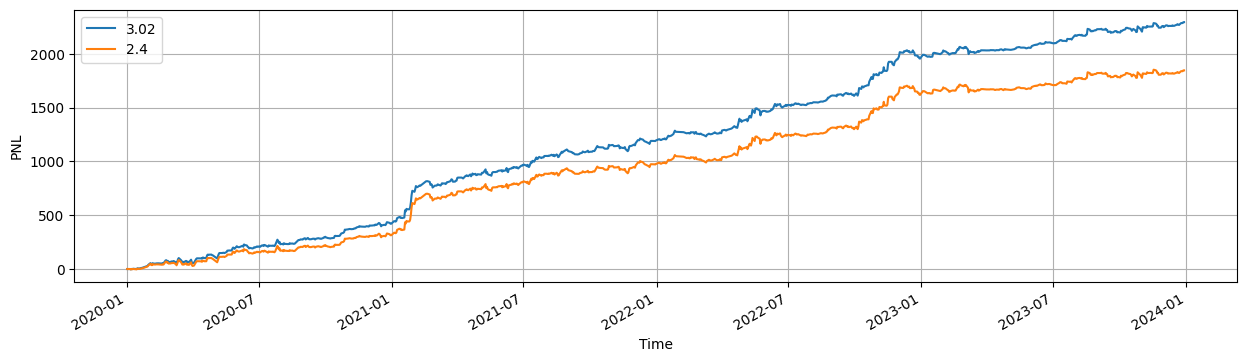

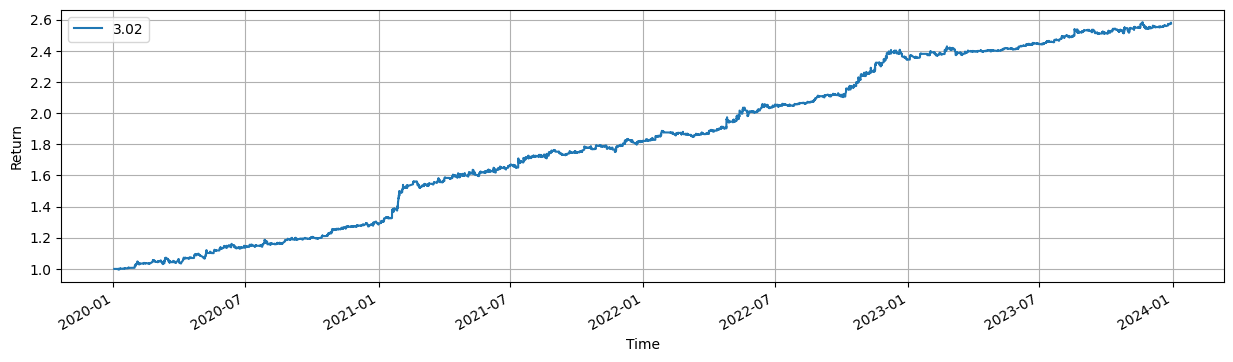

In [15]:
params = best_params
ds = alpha(data_train,params)
backtestInfo = BacktestInformation(ds['Date'], ds['pos'], ds['Close'], fee = 0.3)
pnl = backtestInfo.Plot_PNL() 

Margin: 10.66
MDD: 63.8 (6.97%)

   Total trading quantity: 422
         Profit per trade: 1.03
             Total Profit: 667.1
         Profit after fee: 433.6
 Trading quantity per day: 0.84
 Profit per day after fee: 0.87
                   Return: 0.24
          Profit per year: 217.1
                  HitRate: 0.42
          HitRate per day: 0.48


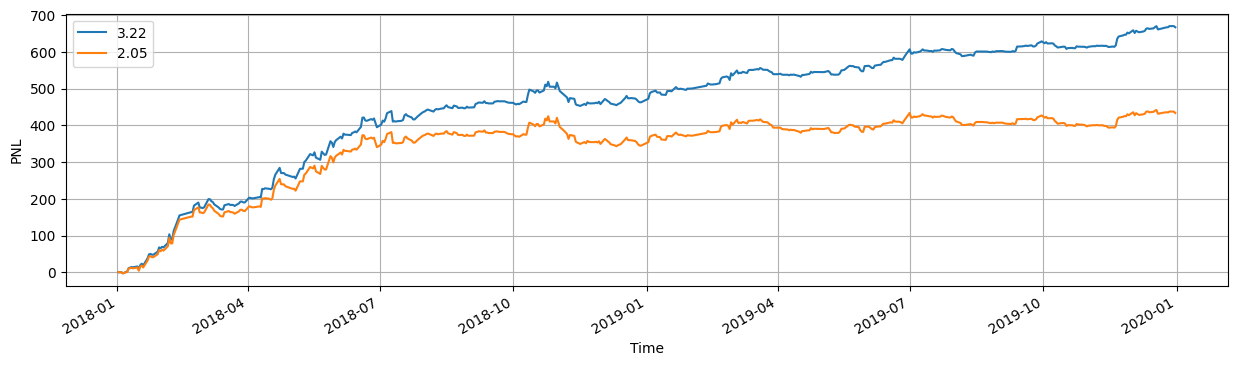

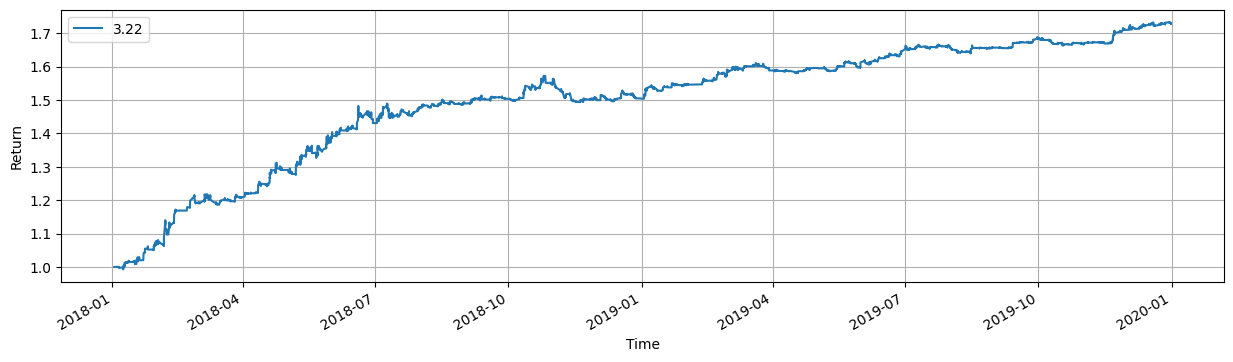

In [16]:
params = best_params
ds = alpha(data_val,params)
backtestInfo = BacktestInformation(ds['Date'], ds['pos'], ds['Close'], fee = 0.3)
pnl = backtestInfo.Plot_PNL() 

Tunning for F1_score

In [11]:
def objective1(trial):
    params={
        'macd_slow': trial.suggest_int('macd_slow', 20, 40),
        'macd_fast': trial.suggest_int('macd_fast', 10, 20),
        'macd_sign': trial.suggest_int('macd_sign', 5, 10),
        'w1': trial.suggest_int('w1', 5, 30),
        'slope_threshold': trial.suggest_float('slope_threshold', 0.01, 3),
        't1': trial.suggest_float('t1', 0.01, 1),
        'w1_1': trial.suggest_int('w1_1', 5, 15),
        'w2_1': trial.suggest_int('w2_1', 20, 40),
        't2': trial.suggest_int('t2', 60, 90),
        't3': trial.suggest_int('t3', 10, 30),
        't4': trial.suggest_int('t4', 40, 70),
        't5': trial.suggest_int('t5', 40, 70),
        'w2': trial.suggest_int('w2', 5, 50),
    }
    try:
        ds = alpha(data_train, params)
        backtestInfo = BacktestInformation(ds['Date'], ds['pos'], ds['Close'], fee = 0.3)
        sharp = backtestInfo.Sharp()
        sharp_after_fee = backtestInfo.Sharp_after_fee()
        hitrate = backtestInfo.Hitrate()
        return_ = backtestInfo.Return()
        profit= backtestInfo.Profit_per_year()
        f1_score = (3*hitrate*return_*(sharp/10))/(sharp + hitrate+return_)
        print(sharp, sharp_after_fee, hitrate, return_)
        return f1_score
    except:
        return 0
    

In [12]:
study = optuna.create_study(direction="maximize")

# Instantiate early stopping callback
early_stopping_callback = EarlyStoppingCallback(early_stopping_rounds=700, direction="maximize")

# Run optimization with callbacks
study.optimize(
    objective1,
    n_trials=4000,
    callbacks=[early_stopping_callback, logging_callback])

[I 2024-12-23 15:50:54,522] A new study created in memory with name: no-name-2fa4f338-a94d-4453-9cb3-23e0152fe836
[I 2024-12-23 15:50:57,049] Trial 0 finished with value: 0.0052171875 and parameters: {'macd_slow': 38, 'macd_fast': 20, 'macd_sign': 10, 'w1': 14, 'slope_threshold': 2.5871484962697795, 't1': 0.5648995253996176, 'w1_1': 7, 'w2_1': 38, 't2': 63, 't3': 29, 't4': 52, 't5': 41, 'w2': 40}. Best is trial 0 with value: 0.0052171875.


1.47 1.17 0.4711111111111111 0.05


[I 2024-12-23 15:50:59,489] Trial 1 finished with value: 0.0007980511571254566 and parameters: {'macd_slow': 30, 'macd_fast': 10, 'macd_sign': 7, 'w1': 7, 'slope_threshold': 1.5690033235604046, 't1': 0.4151221545937741, 'w1_1': 11, 'w2_1': 22, 't2': 74, 't3': 10, 't4': 40, 't5': 58, 'w2': 20}. Best is trial 0 with value: 0.0052171875.


0.84 0.49 0.3939393939393939 0.01


[I 2024-12-23 15:51:01,974] Trial 2 finished with value: 0.0027882835760843325 and parameters: {'macd_slow': 31, 'macd_fast': 17, 'macd_sign': 5, 'w1': 17, 'slope_threshold': 2.2029281156150793, 't1': 0.33023869964984154, 'w1_1': 12, 'w2_1': 31, 't2': 75, 't3': 21, 't4': 62, 't5': 51, 'w2': 27}. Best is trial 0 with value: 0.0052171875.


1.1 0.84 0.4430379746835443 0.03


[I 2024-12-23 15:51:04,376] Trial 3 finished with value: 0.0 and parameters: {'macd_slow': 23, 'macd_fast': 20, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 0.1644986548963238, 't1': 0.6795436225480648, 'w1_1': 6, 'w2_1': 40, 't2': 75, 't3': 24, 't4': 65, 't5': 40, 'w2': 32}. Best is trial 0 with value: 0.0052171875.
[I 2024-12-23 15:51:06,946] Trial 4 finished with value: 0.004391489361702128 and parameters: {'macd_slow': 22, 'macd_fast': 17, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 2.7547277896962177, 't1': 0.2645516020068174, 'w1_1': 7, 'w2_1': 29, 't2': 68, 't3': 16, 't4': 46, 't5': 70, 'w2': 42}. Best is trial 0 with value: 0.0052171875.


1.55 1.27 0.49142857142857144 0.04


[I 2024-12-23 15:51:09,181] Trial 5 finished with value: 0.006660480388307934 and parameters: {'macd_slow': 27, 'macd_fast': 18, 'macd_sign': 8, 'w1': 9, 'slope_threshold': 2.0126301610985924, 't1': 0.9406181653344927, 'w1_1': 12, 'w2_1': 24, 't2': 66, 't3': 24, 't4': 58, 't5': 56, 'w2': 14}. Best is trial 5 with value: 0.006660480388307934.


1.72 1.23 0.4046997389033943 0.07


[I 2024-12-23 15:51:11,511] Trial 6 finished with value: -0.0 and parameters: {'macd_slow': 25, 'macd_fast': 10, 'macd_sign': 8, 'w1': 11, 'slope_threshold': 0.10045930758249869, 't1': 0.047986449497639735, 'w1_1': 12, 'w2_1': 35, 't2': 72, 't3': 24, 't4': 42, 't5': 56, 'w2': 19}. Best is trial 5 with value: 0.006660480388307934.


0.07 -0.08 0.5 -0.0


[I 2024-12-23 15:51:13,695] Trial 7 finished with value: 0.0 and parameters: {'macd_slow': 31, 'macd_fast': 12, 'macd_sign': 8, 'w1': 15, 'slope_threshold': 0.10547686476501468, 't1': 0.9866550461675163, 'w1_1': 8, 'w2_1': 31, 't2': 90, 't3': 17, 't4': 49, 't5': 56, 'w2': 50}. Best is trial 5 with value: 0.006660480388307934.
[I 2024-12-23 15:51:15,918] Trial 8 finished with value: 0.00985441785744483 and parameters: {'macd_slow': 26, 'macd_fast': 15, 'macd_sign': 5, 'w1': 15, 'slope_threshold': 2.9104916470570075, 't1': 0.17091300686220942, 'w1_1': 9, 'w2_1': 22, 't2': 65, 't3': 18, 't4': 67, 't5': 59, 'w2': 30}. Best is trial 8 with value: 0.00985441785744483.


2.26 1.73 0.45260663507109006 0.09


[I 2024-12-23 15:51:18,219] Trial 9 finished with value: 0.0006808239787061684 and parameters: {'macd_slow': 36, 'macd_fast': 13, 'macd_sign': 6, 'w1': 13, 'slope_threshold': 1.2847002958161051, 't1': 0.6355404046603914, 'w1_1': 8, 'w2_1': 22, 't2': 66, 't3': 30, 't4': 46, 't5': 67, 'w2': 34}. Best is trial 8 with value: 0.00985441785744483.


0.53 0.19 0.40437158469945356 0.01


[I 2024-12-23 15:51:20,554] Trial 10 finished with value: 0.01892431014380101 and parameters: {'macd_slow': 20, 'macd_fast': 14, 'macd_sign': 5, 'w1': 29, 'slope_threshold': 0.8922267929061651, 't1': 0.02063121349761432, 'w1_1': 15, 'w2_1': 26, 't2': 83, 't3': 11, 't4': 69, 't5': 63, 'w2': 10}. Best is trial 10 with value: 0.01892431014380101.


2.09 1.79 0.4878640776699029 0.17


[I 2024-12-23 15:51:22,893] Trial 11 finished with value: 0.02941136044880785 and parameters: {'macd_slow': 20, 'macd_fast': 14, 'macd_sign': 5, 'w1': 30, 'slope_threshold': 0.7638340076334653, 't1': 0.05483853207723308, 'w1_1': 15, 'w2_1': 26, 't2': 83, 't3': 11, 't4': 70, 't5': 64, 'w2': 5}. Best is trial 11 with value: 0.02941136044880785.


2.83 2.35 0.475 0.26


[I 2024-12-23 15:51:25,227] Trial 12 finished with value: 0.02317522997531972 and parameters: {'macd_slow': 20, 'macd_fast': 14, 'macd_sign': 5, 'w1': 30, 'slope_threshold': 0.8521817064450401, 't1': 0.04400544978097387, 'w1_1': 15, 'w2_1': 27, 't2': 87, 't3': 10, 't4': 70, 't5': 63, 'w2': 7}. Best is trial 11 with value: 0.02941136044880785.


2.48 2.1 0.468503937007874 0.21


[I 2024-12-23 15:51:27,467] Trial 13 finished with value: 0.029552094399757173 and parameters: {'macd_slow': 20, 'macd_fast': 12, 'macd_sign': 6, 'w1': 30, 'slope_threshold': 0.6943871745682964, 't1': 0.15432271331598874, 'w1_1': 15, 'w2_1': 27, 't2': 84, 't3': 13, 't4': 70, 't5': 63, 'w2': 5}. Best is trial 13 with value: 0.029552094399757173.


3.35 2.77 0.47987616099071206 0.25


[I 2024-12-23 15:51:29,876] Trial 14 finished with value: 0.030240498812351538 and parameters: {'macd_slow': 23, 'macd_fast': 12, 'macd_sign': 6, 'w1': 25, 'slope_threshold': 0.666840897598665, 't1': 0.1728420901474974, 'w1_1': 14, 'w2_1': 27, 't2': 82, 't3': 14, 't4': 60, 't5': 50, 'w2': 5}. Best is trial 14 with value: 0.030240498812351538.


3.5 2.93 0.48825503355704697 0.25


[I 2024-12-23 15:51:32,408] Trial 15 finished with value: -0.0 and parameters: {'macd_slow': 24, 'macd_fast': 12, 'macd_sign': 6, 'w1': 26, 'slope_threshold': 0.5540521686909885, 't1': 0.22837300927736895, 'w1_1': 13, 'w2_1': 33, 't2': 81, 't3': 14, 't4': 58, 't5': 49, 'w2': 14}. Best is trial 14 with value: 0.030240498812351538.


0.04 -0.2 0.38181818181818183 -0.0


[I 2024-12-23 15:51:35,056] Trial 16 finished with value: -0.0 and parameters: {'macd_slow': 29, 'macd_fast': 11, 'macd_sign': 6, 'w1': 21, 'slope_threshold': 1.3836729832272356, 't1': 0.42117546821325325, 'w1_1': 14, 'w2_1': 28, 't2': 79, 't3': 14, 't4': 62, 't5': 48, 'w2': 22}. Best is trial 14 with value: 0.030240498812351538.


0.01 -0.22 0.3793103448275862 -0.0


[I 2024-12-23 15:51:37,504] Trial 17 finished with value: -0.0 and parameters: {'macd_slow': 34, 'macd_fast': 12, 'macd_sign': 10, 'w1': 25, 'slope_threshold': 0.47342384693519746, 't1': 0.17021360166522317, 'w1_1': 10, 'w2_1': 20, 't2': 86, 't3': 14, 't4': 55, 't5': 45, 'w2': 12}. Best is trial 14 with value: 0.030240498812351538.


0.1 -0.07 0.3939393939393939 -0.0


[I 2024-12-23 15:51:39,973] Trial 18 finished with value: 0.010837508168155086 and parameters: {'macd_slow': 22, 'macd_fast': 11, 'macd_sign': 6, 'w1': 27, 'slope_threshold': 1.1019270109005819, 't1': 0.7571377062830797, 'w1_1': 14, 'w2_1': 25, 't2': 79, 't3': 20, 't4': 63, 't5': 52, 'w2': 6}. Best is trial 14 with value: 0.030240498812351538.


2.14 1.59 0.4549266247379455 0.1


[I 2024-12-23 15:51:42,595] Trial 19 finished with value: 0.0 and parameters: {'macd_slow': 28, 'macd_fast': 16, 'macd_sign': 9, 'w1': 18, 'slope_threshold': 1.7601821023832196, 't1': 0.36407295835444253, 'w1_1': 13, 'w2_1': 34, 't2': 90, 't3': 13, 't4': 58, 't5': 60, 'w2': 17}. Best is trial 14 with value: 0.030240498812351538.


0.38 0.3 0.5454545454545454 0.0


[I 2024-12-23 15:51:44,936] Trial 20 finished with value: 0.0 and parameters: {'macd_slow': 22, 'macd_fast': 13, 'macd_sign': 6, 'w1': 27, 'slope_threshold': 0.4913127978670402, 't1': 0.5085665373619425, 'w1_1': 14, 'w2_1': 30, 't2': 85, 't3': 16, 't4': 53, 't5': 45, 'w2': 26}. Best is trial 14 with value: 0.030240498812351538.
[I 2024-12-23 15:51:47,416] Trial 21 finished with value: 0.026496021179449797 and parameters: {'macd_slow': 21, 'macd_fast': 13, 'macd_sign': 5, 'w1': 30, 'slope_threshold': 0.727299917330227, 't1': 0.12985915947592755, 'w1_1': 15, 'w2_1': 24, 't2': 79, 't3': 12, 't4': 67, 't5': 64, 'w2': 5}. Best is trial 14 with value: 0.030240498812351538.


3.07 2.45 0.4717800289435601 0.23


[I 2024-12-23 15:51:50,046] Trial 22 finished with value: 0.010176391283900299 and parameters: {'macd_slow': 24, 'macd_fast': 14, 'macd_sign': 6, 'w1': 24, 'slope_threshold': 1.0746964102449337, 't1': 0.12979513643920854, 'w1_1': 15, 'w2_1': 27, 't2': 83, 't3': 12, 't4': 70, 't5': 67, 'w2': 9}. Best is trial 14 with value: 0.030240498812351538.


1.96 1.54 0.4880636604774536 0.09


[I 2024-12-23 15:51:52,545] Trial 23 finished with value: 0.025707729748522416 and parameters: {'macd_slow': 20, 'macd_fast': 15, 'macd_sign': 7, 'w1': 28, 'slope_threshold': 0.3797484114096748, 't1': 0.23155707232595785, 'w1_1': 13, 'w2_1': 28, 't2': 83, 't3': 19, 't4': 65, 't5': 61, 'w2': 5}. Best is trial 14 with value: 0.030240498812351538.


3.12 2.68 0.5010570824524313 0.21


[I 2024-12-23 15:51:54,879] Trial 24 finished with value: 0.0009833386735020825 and parameters: {'macd_slow': 25, 'macd_fast': 11, 'macd_sign': 5, 'w1': 20, 'slope_threshold': 0.7508136445340532, 't1': 0.2855852790006228, 'w1_1': 14, 'w2_1': 25, 't2': 87, 't3': 15, 't4': 60, 't5': 67, 'w2': 11}. Best is trial 14 with value: 0.030240498812351538.


0.93 0.71 0.5116279069767442 0.01


[I 2024-12-23 15:51:57,275] Trial 25 finished with value: 0.007683962264150945 and parameters: {'macd_slow': 23, 'macd_fast': 15, 'macd_sign': 6, 'w1': 30, 'slope_threshold': 0.9495925334059004, 't1': 0.08620072737893868, 'w1_1': 11, 'w2_1': 32, 't2': 77, 't3': 12, 't4': 67, 't5': 53, 'w2': 16}. Best is trial 14 with value: 0.030240498812351538.


1.81 1.43 0.47635135135135137 0.07


[I 2024-12-23 15:51:59,940] Trial 26 finished with value: 0.019193978359730284 and parameters: {'macd_slow': 20, 'macd_fast': 13, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 0.3735289821087845, 't1': 0.01012282790262814, 'w1_1': 15, 'w2_1': 29, 't2': 60, 't3': 10, 't4': 65, 't5': 70, 'w2': 9}. Best is trial 14 with value: 0.030240498812351538.


2.0 1.77 0.5029940119760479 0.17


[I 2024-12-23 15:52:02,407] Trial 27 finished with value: 0.0007827285254937987 and parameters: {'macd_slow': 40, 'macd_fast': 12, 'macd_sign': 5, 'w1': 28, 'slope_threshold': 1.2577913454910168, 't1': 0.1898679762219297, 'w1_1': 13, 'w2_1': 26, 't2': 81, 't3': 22, 't4': 68, 't5': 54, 'w2': 23}. Best is trial 14 with value: 0.030240498812351538.


0.71 0.44 0.41830065359477125 0.01


[I 2024-12-23 15:52:04,950] Trial 28 finished with value: 0.018943869558047496 and parameters: {'macd_slow': 33, 'macd_fast': 11, 'macd_sign': 6, 'w1': 26, 'slope_threshold': 0.6132885436963859, 't1': 0.11359735410502467, 'w1_1': 14, 'w2_1': 23, 't2': 71, 't3': 16, 't4': 60, 't5': 65, 'w2': 8}. Best is trial 14 with value: 0.030240498812351538.


3.11 2.65 0.5103626943005182 0.15


[I 2024-12-23 15:52:07,516] Trial 29 finished with value: 0.0 and parameters: {'macd_slow': 22, 'macd_fast': 14, 'macd_sign': 9, 'w1': 19, 'slope_threshold': 1.7005308172963658, 't1': 0.4644858989535224, 'w1_1': 5, 'w2_1': 20, 't2': 88, 't3': 27, 't4': 51, 't5': 44, 'w2': 38}. Best is trial 14 with value: 0.030240498812351538.


0.12 0.06 0.23809523809523808 0.0


[I 2024-12-23 15:52:10,140] Trial 30 finished with value: 0.0 and parameters: {'macd_slow': 26, 'macd_fast': 10, 'macd_sign': 5, 'w1': 23, 'slope_threshold': 0.27807549626339667, 't1': 0.2979694385146367, 'w1_1': 11, 'w2_1': 36, 't2': 85, 't3': 13, 't4': 64, 't5': 61, 'w2': 13}. Best is trial 14 with value: 0.030240498812351538.
[I 2024-12-23 15:52:12,559] Trial 31 finished with value: 0.02655328598884358 and parameters: {'macd_slow': 21, 'macd_fast': 13, 'macd_sign': 5, 'w1': 30, 'slope_threshold': 0.7367103768896864, 't1': 0.11242945518754274, 'w1_1': 15, 'w2_1': 24, 't2': 80, 't3': 12, 't4': 67, 't5': 64, 'w2': 5}. Best is trial 14 with value: 0.030240498812351538.


3.05 2.44 0.4736070381231672 0.23


[I 2024-12-23 15:52:15,225] Trial 32 finished with value: 0.029549638222896774 and parameters: {'macd_slow': 21, 'macd_fast': 13, 'macd_sign': 5, 'w1': 28, 'slope_threshold': 0.6863435707211383, 't1': 0.12209320381573444, 'w1_1': 15, 'w2_1': 26, 't2': 81, 't3': 11, 't4': 70, 't5': 58, 'w2': 5}. Best is trial 14 with value: 0.030240498812351538.


3.34 2.75 0.4801223241590214 0.25


[I 2024-12-23 15:52:17,815] Trial 33 finished with value: -0.000545319054979024 and parameters: {'macd_slow': 24, 'macd_fast': 12, 'macd_sign': 6, 'w1': 5, 'slope_threshold': 1.1229361726624987, 't1': 0.35605087564370524, 'w1_1': 14, 'w2_1': 27, 't2': 83, 't3': 10, 't4': 70, 't5': 58, 'w2': 8}. Best is trial 14 with value: 0.030240498812351538.


0.37 -0.2 0.34765625 -0.01


[I 2024-12-23 15:52:20,330] Trial 34 finished with value: 0.013565004488696646 and parameters: {'macd_slow': 21, 'macd_fast': 16, 'macd_sign': 5, 'w1': 28, 'slope_threshold': 1.5503858469615075, 't1': 0.2009571743857274, 'w1_1': 15, 'w2_1': 29, 't2': 77, 't3': 11, 't4': 68, 't5': 50, 'w2': 11}. Best is trial 14 with value: 0.030240498812351538.


2.43 1.99 0.46798029556650245 0.12


[I 2024-12-23 15:52:22,890] Trial 35 finished with value: 0.010637134431064144 and parameters: {'macd_slow': 23, 'macd_fast': 20, 'macd_sign': 7, 'w1': 28, 'slope_threshold': 0.9886202001492149, 't1': 0.0801202325391283, 'w1_1': 13, 'w2_1': 26, 't2': 77, 't3': 15, 't4': 61, 't5': 58, 'w2': 16}. Best is trial 14 with value: 0.030240498812351538.


1.99 1.64 0.453125 0.1


[I 2024-12-23 15:52:25,603] Trial 36 finished with value: 0.025182203389830512 and parameters: {'macd_slow': 21, 'macd_fast': 14, 'macd_sign': 6, 'w1': 24, 'slope_threshold': 2.470406777033306, 't1': 0.2499231375916739, 'w1_1': 12, 'w2_1': 30, 't2': 84, 't3': 11, 't4': 65, 't5': 48, 'w2': 7}. Best is trial 14 with value: 0.030240498812351538.


2.83 2.37 0.5 0.21


[I 2024-12-23 15:52:28,061] Trial 37 finished with value: 0.0 and parameters: {'macd_slow': 23, 'macd_fast': 16, 'macd_sign': 7, 'w1': 26, 'slope_threshold': 0.24045735671132173, 't1': 0.15012713970645333, 'w1_1': 14, 'w2_1': 28, 't2': 81, 't3': 13, 't4': 55, 't5': 61, 'w2': 19}. Best is trial 14 with value: 0.030240498812351538.


0.33 0.28 0.5 0.0


[I 2024-12-23 15:52:30,582] Trial 38 finished with value: 0.0 and parameters: {'macd_slow': 20, 'macd_fast': 19, 'macd_sign': 5, 'w1': 29, 'slope_threshold': 0.6225493199843082, 't1': 0.3109163251333795, 'w1_1': 15, 'w2_1': 25, 't2': 75, 't3': 17, 't4': 66, 't5': 55, 'w2': 46}. Best is trial 14 with value: 0.030240498812351538.


-0.02 -0.13 0.375 -0.0


[I 2024-12-23 15:52:33,080] Trial 39 finished with value: 0.0 and parameters: {'macd_slow': 25, 'macd_fast': 10, 'macd_sign': 5, 'w1': 23, 'slope_threshold': 0.013413837093983805, 't1': 0.06743601268607344, 'w1_1': 12, 'w2_1': 23, 't2': 72, 't3': 15, 't4': 69, 't5': 57, 'w2': 14}. Best is trial 14 with value: 0.030240498812351538.
[I 2024-12-23 15:52:35,469] Trial 40 finished with value: 0.028326654578051384 and parameters: {'macd_slow': 27, 'macd_fast': 12, 'macd_sign': 6, 'w1': 27, 'slope_threshold': 2.020574164809854, 't1': 0.5878992661226938, 'w1_1': 10, 'w2_1': 31, 't2': 88, 't3': 22, 't4': 48, 't5': 69, 'w2': 5}. Best is trial 14 with value: 0.030240498812351538.


2.92 2.39 0.47093889716840537 0.25


[I 2024-12-23 15:52:37,768] Trial 41 finished with value: 0.020336252226274283 and parameters: {'macd_slow': 27, 'macd_fast': 12, 'macd_sign': 6, 'w1': 27, 'slope_threshold': 2.1849383900951036, 't1': 0.7838601223998235, 'w1_1': 9, 'w2_1': 30, 't2': 88, 't3': 23, 't4': 44, 't5': 70, 'w2': 5}. Best is trial 14 with value: 0.030240498812351538.


2.37 1.88 0.4536741214057508 0.19


[I 2024-12-23 15:52:40,263] Trial 42 finished with value: 0.006711412476528269 and parameters: {'macd_slow': 29, 'macd_fast': 13, 'macd_sign': 7, 'w1': 29, 'slope_threshold': 1.8823225377521697, 't1': 0.5400142531359049, 'w1_1': 10, 'w2_1': 32, 't2': 85, 't3': 21, 't4': 40, 't5': 68, 'w2': 10}. Best is trial 14 with value: 0.030240498812351538.


1.38 1.14 0.43700787401574803 0.07


[I 2024-12-23 15:52:42,707] Trial 43 finished with value: 0.016990498919308355 and parameters: {'macd_slow': 22, 'macd_fast': 11, 'macd_sign': 6, 'w1': 25, 'slope_threshold': 2.205577230788631, 't1': 0.675087813171265, 'w1_1': 8, 'w2_1': 27, 't2': 89, 't3': 27, 't4': 47, 't5': 65, 'w2': 8}. Best is trial 14 with value: 0.030240498812351538.


2.15 1.83 0.4899497487437186 0.15


[I 2024-12-23 15:52:45,418] Trial 44 finished with value: 0.027015246789088208 and parameters: {'macd_slow': 23, 'macd_fast': 12, 'macd_sign': 5, 'w1': 22, 'slope_threshold': 2.482792139512423, 't1': 0.5768430074313986, 'w1_1': 9, 'w2_1': 31, 't2': 82, 't3': 26, 't4': 49, 't5': 68, 'w2': 7}. Best is trial 14 with value: 0.030240498812351538.


2.82 2.28 0.4917293233082707 0.23


[I 2024-12-23 15:52:47,970] Trial 45 finished with value: 0.003565802493568178 and parameters: {'macd_slow': 32, 'macd_fast': 13, 'macd_sign': 8, 'w1': 29, 'slope_threshold': 1.3806274742825297, 't1': 0.41079467105598133, 'w1_1': 11, 'w2_1': 38, 't2': 86, 't3': 25, 't4': 53, 't5': 62, 'w2': 12}. Best is trial 14 with value: 0.030240498812351538.


0.99 0.77 0.441747572815534 0.04


[I 2024-12-23 15:52:50,520] Trial 46 finished with value: 0.02665699709912974 and parameters: {'macd_slow': 26, 'macd_fast': 15, 'macd_sign': 7, 'w1': 27, 'slope_threshold': 0.8325067986393717, 't1': 0.053320484121678884, 'w1_1': 7, 'w2_1': 29, 't2': 87, 't3': 18, 't4': 56, 't5': 66, 'w2': 5}. Best is trial 14 with value: 0.030240498812351538.


2.52 2.1 0.45483870967741935 0.25


[I 2024-12-23 15:52:53,062] Trial 47 finished with value: 0.0 and parameters: {'macd_slow': 21, 'macd_fast': 14, 'macd_sign': 6, 'w1': 10, 'slope_threshold': 1.9803724789823645, 't1': 0.1971670311231366, 'w1_1': 14, 'w2_1': 26, 't2': 84, 't3': 11, 't4': 50, 't5': 59, 'w2': 36}. Best is trial 14 with value: 0.030240498812351538.


0.22 0.08 0.38461538461538464 0.0


[I 2024-12-23 15:52:55,513] Trial 48 finished with value: 0.0007805443548387096 and parameters: {'macd_slow': 24, 'macd_fast': 12, 'macd_sign': 5, 'w1': 16, 'slope_threshold': 1.2317724236252379, 't1': 0.5922353356455285, 'w1_1': 10, 'w2_1': 28, 't2': 78, 't3': 13, 't4': 69, 't5': 63, 'w2': 10}. Best is trial 14 with value: 0.030240498812351538.


0.89 0.51 0.3717948717948718 0.01


[I 2024-12-23 15:52:57,927] Trial 49 finished with value: 0.007219073617470941 and parameters: {'macd_slow': 20, 'macd_fast': 11, 'macd_sign': 6, 'w1': 13, 'slope_threshold': 2.7417441989334197, 't1': 0.776117208540027, 'w1_1': 15, 'w2_1': 25, 't2': 89, 't3': 20, 't4': 63, 't5': 52, 'w2': 7}. Best is trial 14 with value: 0.030240498812351538.


1.49 1.19 0.46785714285714286 0.07


[I 2024-12-23 15:53:00,283] Trial 50 finished with value: 0.0 and parameters: {'macd_slow': 30, 'macd_fast': 10, 'macd_sign': 5, 'w1': 30, 'slope_threshold': 0.4125404184080601, 't1': 0.7087641017147084, 'w1_1': 9, 'w2_1': 31, 't2': 81, 't3': 22, 't4': 43, 't5': 68, 'w2': 14}. Best is trial 14 with value: 0.030240498812351538.
[I 2024-12-23 15:53:02,815] Trial 51 finished with value: 0.027069557625145523 and parameters: {'macd_slow': 23, 'macd_fast': 12, 'macd_sign': 5, 'w1': 21, 'slope_threshold': 2.4596859104904194, 't1': 0.6044655353676759, 'w1_1': 8, 'w2_1': 33, 't2': 82, 't3': 27, 't4': 49, 't5': 69, 'w2': 7}. Best is trial 14 with value: 0.030240498812351538.


2.81 2.27 0.4932935916542474 0.23


[I 2024-12-23 15:53:05,446] Trial 52 finished with value: 0.0005555555555555557 and parameters: {'macd_slow': 22, 'macd_fast': 13, 'macd_sign': 5, 'w1': 21, 'slope_threshold': 2.6932333615596704, 't1': 0.6261653569483704, 'w1_1': 6, 'w2_1': 34, 't2': 82, 't3': 29, 't4': 48, 't5': 70, 'w2': 30}. Best is trial 14 with value: 0.030240498812351538.


0.33 0.22 0.43478260869565216 0.01


[I 2024-12-23 15:53:08,059] Trial 53 finished with value: 0.01693195219123506 and parameters: {'macd_slow': 21, 'macd_fast': 12, 'macd_sign': 6, 'w1': 24, 'slope_threshold': 2.337959716398883, 't1': 0.9077076920289295, 'w1_1': 7, 'w2_1': 36, 't2': 84, 't3': 28, 't4': 45, 't5': 69, 'w2': 7}. Best is trial 14 with value: 0.030240498812351538.


2.09 1.68 0.4568627450980392 0.16


[I 2024-12-23 15:53:10,552] Trial 54 finished with value: 0.023951530260626724 and parameters: {'macd_slow': 25, 'macd_fast': 11, 'macd_sign': 5, 'w1': 26, 'slope_threshold': 2.9740661321376853, 't1': 0.49496984370915165, 'w1_1': 8, 'w2_1': 32, 't2': 86, 't3': 30, 't4': 52, 't5': 66, 'w2': 9}. Best is trial 14 with value: 0.030240498812351538.


2.6 2.21 0.4812623274161736 0.21


[I 2024-12-23 15:53:13,155] Trial 55 finished with value: 0.009696184703604034 and parameters: {'macd_slow': 27, 'macd_fast': 14, 'macd_sign': 5, 'w1': 29, 'slope_threshold': 0.6626902260809799, 't1': 0.6219011924738923, 'w1_1': 6, 'w2_1': 33, 't2': 82, 't3': 25, 't4': 47, 't5': 65, 'w2': 5}. Best is trial 14 with value: 0.030240498812351538.


1.81 1.3 0.4152046783625731 0.1


[I 2024-12-23 15:53:15,672] Trial 56 finished with value: 0.0007262851600387972 and parameters: {'macd_slow': 36, 'macd_fast': 13, 'macd_sign': 6, 'w1': 27, 'slope_threshold': 0.8255390962076405, 't1': 0.666632423563284, 'w1_1': 12, 'w2_1': 30, 't2': 79, 't3': 14, 't4': 70, 't5': 41, 'w2': 11}. Best is trial 14 with value: 0.030240498812351538.


0.78 0.54 0.35555555555555557 0.01


[I 2024-12-23 15:53:18,194] Trial 57 finished with value: 0.018317286452146902 and parameters: {'macd_slow': 24, 'macd_fast': 12, 'macd_sign': 5, 'w1': 22, 'slope_threshold': 2.1646422716472435, 't1': 0.44477368418353047, 'w1_1': 15, 'w2_1': 21, 't2': 80, 't3': 10, 't4': 57, 't5': 60, 'w2': 6}. Best is trial 14 with value: 0.030240498812351538.


2.71 2.15 0.4703770197486535 0.16


[I 2024-12-23 15:53:20,766] Trial 58 finished with value: 0.008127943760984184 and parameters: {'macd_slow': 23, 'macd_fast': 11, 'macd_sign': 6, 'w1': 28, 'slope_threshold': 2.5921506255096363, 't1': 0.5391225390336004, 'w1_1': 13, 'w2_1': 23, 't2': 85, 't3': 18, 't4': 68, 't5': 63, 'w2': 9}. Best is trial 14 with value: 0.030240498812351538.


1.64 1.32 0.44761904761904764 0.08


[I 2024-12-23 15:53:23,353] Trial 59 finished with value: 0.008705382395173102 and parameters: {'macd_slow': 22, 'macd_fast': 13, 'macd_sign': 8, 'w1': 18, 'slope_threshold': 1.7374558506023927, 't1': 0.029644909006665193, 'w1_1': 14, 'w2_1': 28, 't2': 90, 't3': 11, 't4': 49, 't5': 55, 'w2': 12}. Best is trial 14 with value: 0.030240498812351538.


1.3 1.02 0.4584450402144772 0.09


[I 2024-12-23 15:53:26,223] Trial 60 finished with value: 0.0007981243830207306 and parameters: {'macd_slow': 28, 'macd_fast': 12, 'macd_sign': 5, 'w1': 25, 'slope_threshold': 0.4772815180472135, 't1': 0.7310884344586689, 'w1_1': 15, 'w2_1': 26, 't2': 80, 't3': 12, 't4': 54, 't5': 69, 'w2': 7}. Best is trial 14 with value: 0.030240498812351538.


0.77 0.65 0.4117647058823529 0.01


[I 2024-12-23 15:53:28,891] Trial 61 finished with value: 0.02338668287116983 and parameters: {'macd_slow': 20, 'macd_fast': 12, 'macd_sign': 5, 'w1': 20, 'slope_threshold': 2.3560244110391926, 't1': 0.5844896711426287, 'w1_1': 9, 'w2_1': 33, 't2': 82, 't3': 26, 't4': 49, 't5': 68, 'w2': 7}. Best is trial 14 with value: 0.030240498812351538.


2.71 2.13 0.4888558692421991 0.2


[I 2024-12-23 15:53:31,213] Trial 62 finished with value: 0.029091601025368535 and parameters: {'macd_slow': 23, 'macd_fast': 12, 'macd_sign': 5, 'w1': 22, 'slope_threshold': 2.5527840755384963, 't1': 0.5633371957511442, 'w1_1': 10, 'w2_1': 31, 't2': 83, 't3': 25, 't4': 51, 't5': 66, 'w2': 6}. Best is trial 14 with value: 0.030240498812351538.


2.96 2.36 0.48408488063660476 0.25


[I 2024-12-23 15:53:33,497] Trial 63 finished with value: 0.030379894218555036 and parameters: {'macd_slow': 21, 'macd_fast': 13, 'macd_sign': 5, 'w1': 26, 'slope_threshold': 2.578145343544148, 't1': 0.5046569004533634, 'w1_1': 10, 'w2_1': 31, 't2': 83, 't3': 24, 't4': 51, 't5': 66, 'w2': 5}. Best is trial 63 with value: 0.030379894218555036.


3.17 2.41 0.4616228070175439 0.27


[I 2024-12-23 15:53:35,729] Trial 64 finished with value: 0.030572712958948502 and parameters: {'macd_slow': 21, 'macd_fast': 14, 'macd_sign': 6, 'w1': 27, 'slope_threshold': 0.9977572406769961, 't1': 0.15186610442222476, 'w1_1': 10, 'w2_1': 31, 't2': 84, 't3': 23, 't4': 53, 't5': 66, 'w2': 5}. Best is trial 64 with value: 0.030572712958948502.


3.11 2.48 0.4493116395494368 0.28


[I 2024-12-23 15:53:37,936] Trial 65 finished with value: 0.01300237317830692 and parameters: {'macd_slow': 21, 'macd_fast': 14, 'macd_sign': 5, 'w1': 26, 'slope_threshold': 0.91997974916615, 't1': 0.1579396566179066, 'w1_1': 10, 'w2_1': 29, 't2': 84, 't3': 23, 't4': 52, 't5': 64, 'w2': 9}. Best is trial 64 with value: 0.030572712958948502.


2.09 1.65 0.46170212765957447 0.12


[I 2024-12-23 15:53:40,152] Trial 66 finished with value: 0.028783307101194335 and parameters: {'macd_slow': 20, 'macd_fast': 15, 'macd_sign': 10, 'w1': 29, 'slope_threshold': 1.0351262360441986, 't1': 0.2621112423921472, 'w1_1': 11, 'w2_1': 27, 't2': 83, 't3': 23, 't4': 53, 't5': 62, 'w2': 6}. Best is trial 64 with value: 0.030572712958948502.


2.98 2.42 0.4579172610556348 0.26


[I 2024-12-23 15:53:42,527] Trial 67 finished with value: 0.001739956958393113 and parameters: {'macd_slow': 22, 'macd_fast': 14, 'macd_sign': 6, 'w1': 24, 'slope_threshold': 0.5550361454003291, 't1': 0.08812312206580081, 'w1_1': 11, 'w2_1': 30, 't2': 86, 't3': 25, 't4': 51, 't5': 66, 'w2': 23}. Best is trial 64 with value: 0.030572712958948502.


0.77 0.6 0.4772727272727273 0.02


[I 2024-12-23 15:53:44,831] Trial 68 finished with value: 0.018501397512929087 and parameters: {'macd_slow': 21, 'macd_fast': 14, 'macd_sign': 5, 'w1': 30, 'slope_threshold': 2.8572763771495437, 't1': 0.10173873325311639, 'w1_1': 10, 'w2_1': 24, 't2': 84, 't3': 24, 't4': 55, 't5': 47, 'w2': 16}. Best is trial 64 with value: 0.030572712958948502.


2.35 2.02 0.49246231155778897 0.16


[I 2024-12-23 15:53:46,994] Trial 69 finished with value: 0.0 and parameters: {'macd_slow': 20, 'macd_fast': 13, 'macd_sign': 6, 'w1': 28, 'slope_threshold': 0.7593036270767675, 't1': 0.22381216681456828, 'w1_1': 11, 'w2_1': 27, 't2': 83, 't3': 13, 't4': 54, 't5': 65, 'w2': 26}. Best is trial 64 with value: 0.030572712958948502.


0.27 0.09 0.5882352941176471 0.0


[I 2024-12-23 15:53:49,288] Trial 70 finished with value: 0.016438969317481136 and parameters: {'macd_slow': 21, 'macd_fast': 13, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 0.6568220400366415, 't1': 0.14449101133854358, 'w1_1': 14, 'w2_1': 29, 't2': 78, 't3': 24, 't4': 59, 't5': 62, 'w2': 10}. Best is trial 64 with value: 0.030572712958948502.


2.49 2.12 0.4905149051490515 0.14


[I 2024-12-23 15:53:51,688] Trial 71 finished with value: 0.025273273273273274 and parameters: {'macd_slow': 20, 'macd_fast': 16, 'macd_sign': 9, 'w1': 29, 'slope_threshold': 1.0259415846464146, 't1': 0.16897482435517625, 'w1_1': 10, 'w2_1': 26, 't2': 81, 't3': 23, 't4': 51, 't5': 62, 'w2': 6}. Best is trial 64 with value: 0.030572712958948502.


2.63 2.08 0.4420485175202156 0.24


[I 2024-12-23 15:53:54,042] Trial 72 finished with value: 0.029661699537762643 and parameters: {'macd_slow': 22, 'macd_fast': 15, 'macd_sign': 10, 'w1': 29, 'slope_threshold': 1.2210044757810807, 't1': 0.26824668913763694, 'w1_1': 11, 'w2_1': 25, 't2': 83, 't3': 21, 't4': 53, 't5': 64, 'w2': 6}. Best is trial 64 with value: 0.030572712958948502.


2.96 2.44 0.4560117302052786 0.27


[I 2024-12-23 15:53:56,307] Trial 73 finished with value: 0.016662875858618025 and parameters: {'macd_slow': 22, 'macd_fast': 15, 'macd_sign': 10, 'w1': 27, 'slope_threshold': 1.1204740386416348, 't1': 0.3502268426873696, 'w1_1': 15, 'w2_1': 25, 't2': 85, 't3': 21, 't4': 57, 't5': 64, 'w2': 8}. Best is trial 64 with value: 0.030572712958948502.


2.2 1.86 0.4755784061696658 0.15


[I 2024-12-23 15:53:58,723] Trial 74 finished with value: 0.0006885697874784608 and parameters: {'macd_slow': 22, 'macd_fast': 17, 'macd_sign': 5, 'w1': 30, 'slope_threshold': 1.3206406518811835, 't1': 0.12524633707219662, 'w1_1': 9, 'w2_1': 24, 't2': 80, 't3': 20, 't4': 66, 't5': 67, 'w2': 43}. Best is trial 64 with value: 0.030572712958948502.


0.54 0.34 0.4065934065934066 0.01


[I 2024-12-23 15:54:01,242] Trial 75 finished with value: 0.032032098983650024 and parameters: {'macd_slow': 23, 'macd_fast': 14, 'macd_sign': 5, 'w1': 28, 'slope_threshold': 1.190440424346428, 't1': 0.1855086917888487, 'w1_1': 14, 'w2_1': 28, 't2': 83, 't3': 21, 't4': 69, 't5': 66, 'w2': 5}. Best is trial 75 with value: 0.032032098983650024.


3.22 2.51 0.47017543859649125 0.28


[I 2024-12-23 15:54:03,629] Trial 76 finished with value: 0.033178651985283726 and parameters: {'macd_slow': 21, 'macd_fast': 15, 'macd_sign': 9, 'w1': 28, 'slope_threshold': 1.1574013401457015, 't1': 0.21998323676434592, 'w1_1': 14, 'w2_1': 28, 't2': 68, 't3': 19, 't4': 69, 't5': 60, 'w2': 5}. Best is trial 76 with value: 0.033178651985283726.


3.4 2.64 0.4349240780911063 0.31


[I 2024-12-23 15:54:05,993] Trial 77 finished with value: 0.0340177934484031 and parameters: {'macd_slow': 24, 'macd_fast': 15, 'macd_sign': 9, 'w1': 28, 'slope_threshold': 1.1813093884426438, 't1': 0.23448770726963578, 'w1_1': 13, 'w2_1': 27, 't2': 69, 't3': 19, 't4': 69, 't5': 59, 'w2': 5}. Best is trial 77 with value: 0.0340177934484031.


3.44 2.66 0.4317937701396348 0.32


[I 2024-12-23 15:54:08,429] Trial 78 finished with value: 0.030094530816213213 and parameters: {'macd_slow': 24, 'macd_fast': 15, 'macd_sign': 9, 'w1': 26, 'slope_threshold': 1.462436548488328, 't1': 0.2826826293864862, 'w1_1': 13, 'w2_1': 28, 't2': 69, 't3': 19, 't4': 66, 't5': 60, 'w2': 8}. Best is trial 77 with value: 0.0340177934484031.


3.27 2.68 0.4722222222222222 0.26


[I 2024-12-23 15:54:10,910] Trial 79 finished with value: 0.03348136660339799 and parameters: {'macd_slow': 25, 'macd_fast': 15, 'macd_sign': 9, 'w1': 26, 'slope_threshold': 1.4631096929618717, 't1': 0.3204491420226992, 'w1_1': 13, 'w2_1': 28, 't2': 68, 't3': 19, 't4': 66, 't5': 57, 'w2': 8}. Best is trial 77 with value: 0.0340177934484031.


3.57 2.96 0.4663805436337625 0.29


[I 2024-12-23 15:54:13,229] Trial 80 finished with value: 0.0146163178984862 and parameters: {'macd_slow': 26, 'macd_fast': 16, 'macd_sign': 9, 'w1': 26, 'slope_threshold': 1.6311781083783015, 't1': 0.38227323463084845, 'w1_1': 13, 'w2_1': 28, 't2': 68, 't3': 19, 't4': 66, 't5': 59, 'w2': 13}. Best is trial 77 with value: 0.0340177934484031.


2.59 2.06 0.46017699115044247 0.13


[I 2024-12-23 15:54:15,611] Trial 81 finished with value: 0.032350422524427935 and parameters: {'macd_slow': 24, 'macd_fast': 15, 'macd_sign': 9, 'w1': 26, 'slope_threshold': 1.446968042860155, 't1': 0.2867345287574549, 'w1_1': 13, 'w2_1': 28, 't2': 67, 't3': 19, 't4': 68, 't5': 57, 'w2': 8}. Best is trial 77 with value: 0.0340177934484031.


3.53 2.86 0.4665757162346521 0.28


[I 2024-12-23 15:54:18,152] Trial 82 finished with value: 0.03147254859309713 and parameters: {'macd_slow': 24, 'macd_fast': 15, 'macd_sign': 9, 'w1': 26, 'slope_threshold': 1.4645257425244607, 't1': 0.31491676120373024, 'w1_1': 13, 'w2_1': 28, 't2': 68, 't3': 19, 't4': 68, 't5': 56, 'w2': 8}. Best is trial 77 with value: 0.0340177934484031.


3.52 2.86 0.4702627939142462 0.27


[I 2024-12-23 15:54:20,549] Trial 83 finished with value: 0.02532007348438457 and parameters: {'macd_slow': 25, 'macd_fast': 15, 'macd_sign': 9, 'w1': 25, 'slope_threshold': 1.4806277157751493, 't1': 0.32805864642211735, 'w1_1': 13, 'w2_1': 29, 't2': 64, 't3': 18, 't4': 69, 't5': 56, 'w2': 9}. Best is trial 77 with value: 0.0340177934484031.


3.28 2.43 0.46359223300970875 0.22


[I 2024-12-23 15:54:22,829] Trial 84 finished with value: 0.02208873087030453 and parameters: {'macd_slow': 25, 'macd_fast': 16, 'macd_sign': 9, 'w1': 27, 'slope_threshold': 1.3878116541487913, 't1': 0.2303106188205154, 'w1_1': 12, 'w2_1': 27, 't2': 68, 't3': 19, 't4': 68, 't5': 57, 'w2': 11}. Best is trial 77 with value: 0.0340177934484031.


2.78 2.27 0.45486725663716815 0.2


[I 2024-12-23 15:54:25,146] Trial 85 finished with value: 0.031278376534788536 and parameters: {'macd_slow': 24, 'macd_fast': 15, 'macd_sign': 9, 'w1': 26, 'slope_threshold': 1.1797544714983417, 't1': 0.1970368310643021, 'w1_1': 14, 'w2_1': 30, 't2': 67, 't3': 17, 't4': 69, 't5': 54, 'w2': 8}. Best is trial 77 with value: 0.0340177934484031.


3.33 2.74 0.4722222222222222 0.27


[I 2024-12-23 15:54:27,571] Trial 86 finished with value: 0.02029750145264381 and parameters: {'macd_slow': 24, 'macd_fast': 15, 'macd_sign': 9, 'w1': 24, 'slope_threshold': 1.6157175477792873, 't1': 0.31105690862012325, 'w1_1': 13, 'w2_1': 30, 't2': 66, 't3': 17, 't4': 67, 't5': 54, 'w2': 10}. Best is trial 77 with value: 0.0340177934484031.


2.84 2.21 0.4606741573033708 0.18


[I 2024-12-23 15:54:30,033] Trial 87 finished with value: 0.01900009939369844 and parameters: {'macd_slow': 26, 'macd_fast': 16, 'macd_sign': 8, 'w1': 28, 'slope_threshold': 1.349875427286516, 't1': 0.20965966091865168, 'w1_1': 12, 'w2_1': 29, 't2': 67, 't3': 20, 't4': 69, 't5': 57, 'w2': 13}. Best is trial 77 with value: 0.0340177934484031.


2.85 2.31 0.4267631103074141 0.18


[I 2024-12-23 15:54:32,615] Trial 88 finished with value: 0.020731131632493342 and parameters: {'macd_slow': 25, 'macd_fast': 17, 'macd_sign': 9, 'w1': 23, 'slope_threshold': 1.1287918860031692, 't1': 0.2522611758624262, 'w1_1': 14, 'w2_1': 28, 't2': 70, 't3': 16, 't4': 68, 't5': 54, 'w2': 9}. Best is trial 77 with value: 0.0340177934484031.


2.92 2.36 0.4692737430167598 0.18


[I 2024-12-23 15:54:35,136] Trial 89 finished with value: 0.029209705208251006 and parameters: {'macd_slow': 24, 'macd_fast': 15, 'macd_sign': 9, 'w1': 27, 'slope_threshold': 1.5308893010669786, 't1': 0.3779457382144254, 'w1_1': 14, 'w2_1': 32, 't2': 72, 't3': 19, 't4': 64, 't5': 56, 'w2': 8}. Best is trial 77 with value: 0.0340177934484031.


3.28 2.71 0.49682539682539684 0.24


[I 2024-12-23 15:54:37,527] Trial 90 finished with value: 0.021192799815498157 and parameters: {'macd_slow': 23, 'macd_fast': 14, 'macd_sign': 9, 'w1': 26, 'slope_threshold': 1.2224547744073375, 't1': 0.19249466927197184, 'w1_1': 13, 'w2_1': 31, 't2': 65, 't3': 17, 't4': 68, 't5': 57, 'w2': 11}. Best is trial 77 with value: 0.0340177934484031.


2.91 2.3 0.4540983606557377 0.19


[I 2024-12-23 15:54:39,930] Trial 91 finished with value: 0.0322299501114204 and parameters: {'macd_slow': 23, 'macd_fast': 15, 'macd_sign': 8, 'w1': 26, 'slope_threshold': 1.1811680679856735, 't1': 0.24024677769662034, 'w1_1': 14, 'w2_1': 28, 't2': 62, 't3': 20, 't4': 67, 't5': 51, 'w2': 6}. Best is trial 77 with value: 0.0340177934484031.


3.39 2.58 0.43584305408271473 0.3


[I 2024-12-23 15:54:42,402] Trial 92 finished with value: 0.03273247990689893 and parameters: {'macd_slow': 24, 'macd_fast': 15, 'macd_sign': 8, 'w1': 26, 'slope_threshold': 1.4372168174608353, 't1': 0.3292771857855591, 'w1_1': 14, 'w2_1': 28, 't2': 61, 't3': 20, 't4': 67, 't5': 53, 'w2': 6}. Best is trial 77 with value: 0.0340177934484031.


3.54 2.63 0.4396887159533074 0.3


[I 2024-12-23 15:54:44,920] Trial 93 finished with value: 0.03176612950369259 and parameters: {'macd_slow': 25, 'macd_fast': 15, 'macd_sign': 8, 'w1': 28, 'slope_threshold': 1.180628598770205, 't1': 0.2940447531884692, 'w1_1': 14, 'w2_1': 28, 't2': 61, 't3': 20, 't4': 67, 't5': 51, 'w2': 6}. Best is trial 77 with value: 0.0340177934484031.


3.47 2.6 0.4421699078812692 0.29


[I 2024-12-23 15:54:47,586] Trial 94 finished with value: 0.03424683122081388 and parameters: {'macd_slow': 24, 'macd_fast': 15, 'macd_sign': 8, 'w1': 28, 'slope_threshold': 1.4418074756885422, 't1': 0.3366882804079378, 'w1_1': 14, 'w2_1': 27, 't2': 61, 't3': 19, 't4': 67, 't5': 51, 'w2': 6}. Best is trial 94 with value: 0.03424683122081388.


3.68 2.78 0.44366197183098594 0.31


[I 2024-12-23 15:54:50,083] Trial 95 finished with value: 0.03474872598980791 and parameters: {'macd_slow': 25, 'macd_fast': 16, 'macd_sign': 8, 'w1': 28, 'slope_threshold': 1.4306811373316684, 't1': 0.33086147481901335, 'w1_1': 14, 'w2_1': 27, 't2': 61, 't3': 20, 't4': 64, 't5': 51, 'w2': 6}. Best is trial 95 with value: 0.03474872598980791.


3.56 2.75 0.43915343915343913 0.32


[I 2024-12-23 15:54:52,585] Trial 96 finished with value: 0.033271040951658566 and parameters: {'macd_slow': 26, 'macd_fast': 16, 'macd_sign': 8, 'w1': 28, 'slope_threshold': 1.2928905525532706, 't1': 0.33957668029819, 'w1_1': 14, 'w2_1': 27, 't2': 61, 't3': 20, 't4': 64, 't5': 51, 'w2': 6}. Best is trial 95 with value: 0.03474872598980791.


3.52 2.72 0.43329775880469584 0.31


[I 2024-12-23 15:54:55,051] Trial 97 finished with value: 0.03518831623415812 and parameters: {'macd_slow': 26, 'macd_fast': 16, 'macd_sign': 8, 'w1': 28, 'slope_threshold': 1.2986291651472572, 't1': 0.3395653407814468, 'w1_1': 14, 'w2_1': 27, 't2': 61, 't3': 21, 't4': 64, 't5': 52, 'w2': 6}. Best is trial 97 with value: 0.03518831623415812.


3.6 2.79 0.4305263157894737 0.33


[I 2024-12-23 15:54:57,560] Trial 98 finished with value: 0.03141931419807187 and parameters: {'macd_slow': 27, 'macd_fast': 16, 'macd_sign': 8, 'w1': 29, 'slope_threshold': 1.296831634524439, 't1': 0.4020516812475493, 'w1_1': 14, 'w2_1': 27, 't2': 62, 't3': 20, 't4': 64, 't5': 52, 'w2': 7}. Best is trial 97 with value: 0.03518831623415812.


3.47 2.68 0.4367816091954023 0.29


[I 2024-12-23 15:55:00,144] Trial 99 finished with value: 0.03252260604113111 and parameters: {'macd_slow': 28, 'macd_fast': 17, 'macd_sign': 8, 'w1': 28, 'slope_threshold': 1.8048375286692513, 't1': 0.3342728870361116, 'w1_1': 14, 'w2_1': 26, 't2': 60, 't3': 18, 't4': 62, 't5': 50, 'w2': 6}. Best is trial 97 with value: 0.03518831623415812.


3.34 2.59 0.4268558951965066 0.31


[I 2024-12-23 15:55:02,568] Trial 100 finished with value: 0.009817962853931382 and parameters: {'macd_slow': 28, 'macd_fast': 17, 'macd_sign': 8, 'w1': 8, 'slope_threshold': 1.4268988636967537, 't1': 0.3341773191882512, 'w1_1': 13, 'w2_1': 27, 't2': 60, 't3': 18, 't4': 62, 't5': 49, 'w2': 10}. Best is trial 97 with value: 0.03518831623415812.


2.29 1.49 0.39850746268656717 0.1


[I 2024-12-23 15:55:05,232] Trial 101 finished with value: 0.036002678445561764 and parameters: {'macd_slow': 26, 'macd_fast': 17, 'macd_sign': 8, 'w1': 28, 'slope_threshold': 1.7946716446634257, 't1': 0.344018293377091, 'w1_1': 14, 'w2_1': 26, 't2': 63, 't3': 21, 't4': 65, 't5': 50, 'w2': 6}. Best is trial 101 with value: 0.036002678445561764.


3.62 2.8 0.42783505154639173 0.34


[I 2024-12-23 15:55:07,786] Trial 102 finished with value: 0.03516336831243672 and parameters: {'macd_slow': 26, 'macd_fast': 18, 'macd_sign': 8, 'w1': 28, 'slope_threshold': 1.785723713136372, 't1': 0.33762179801989517, 'w1_1': 14, 'w2_1': 26, 't2': 63, 't3': 21, 't4': 65, 't5': 53, 'w2': 6}. Best is trial 101 with value: 0.036002678445561764.


3.5 2.69 0.43257261410788383 0.33


[I 2024-12-23 15:55:10,320] Trial 103 finished with value: 0.033292466900015215 and parameters: {'macd_slow': 26, 'macd_fast': 18, 'macd_sign': 8, 'w1': 28, 'slope_threshold': 1.826342485987873, 't1': 0.4407057723826894, 'w1_1': 14, 'w2_1': 26, 't2': 63, 't3': 22, 't4': 64, 't5': 53, 'w2': 6}. Best is trial 101 with value: 0.036002678445561764.


3.51 2.65 0.4199004975124378 0.32


[I 2024-12-23 15:55:12,815] Trial 104 finished with value: 0.03296452343805126 and parameters: {'macd_slow': 26, 'macd_fast': 18, 'macd_sign': 8, 'w1': 29, 'slope_threshold': 1.9339893639353416, 't1': 0.4346802818023142, 'w1_1': 15, 'w2_1': 26, 't2': 63, 't3': 22, 't4': 63, 't5': 53, 'w2': 7}. Best is trial 101 with value: 0.036002678445561764.


3.46 2.69 0.43029637760702527 0.31


[I 2024-12-23 15:55:15,370] Trial 105 finished with value: 0.032904671352882546 and parameters: {'macd_slow': 26, 'macd_fast': 18, 'macd_sign': 8, 'w1': 29, 'slope_threshold': 1.8931639205481436, 't1': 0.43755925998286427, 'w1_1': 15, 'w2_1': 26, 't2': 63, 't3': 22, 't4': 63, 't5': 53, 'w2': 7}. Best is trial 101 with value: 0.036002678445561764.


3.45 2.69 0.42967032967032964 0.31


[I 2024-12-23 15:55:18,015] Trial 106 finished with value: 0.028943119797787905 and parameters: {'macd_slow': 29, 'macd_fast': 18, 'macd_sign': 8, 'w1': 30, 'slope_threshold': 1.65992083001537, 't1': 0.4692015948759703, 'w1_1': 15, 'w2_1': 25, 't2': 64, 't3': 21, 't4': 65, 't5': 49, 'w2': 9}. Best is trial 101 with value: 0.036002678445561764.


3.35 2.65 0.4496732026143791 0.26


[I 2024-12-23 15:55:20,533] Trial 107 finished with value: 0.032649111475653456 and parameters: {'macd_slow': 26, 'macd_fast': 19, 'macd_sign': 8, 'w1': 29, 'slope_threshold': 2.065431267974796, 't1': 0.3920514026332332, 'w1_1': 15, 'w2_1': 26, 't2': 63, 't3': 22, 't4': 61, 't5': 52, 'w2': 7}. Best is trial 101 with value: 0.036002678445561764.


3.32 2.62 0.42923433874709976 0.31


[I 2024-12-23 15:55:23,010] Trial 108 finished with value: 0.03296817257181178 and parameters: {'macd_slow': 27, 'macd_fast': 18, 'macd_sign': 8, 'w1': 28, 'slope_threshold': 1.827437635057372, 't1': 0.3584594004611087, 'w1_1': 14, 'w2_1': 27, 't2': 62, 't3': 21, 't4': 64, 't5': 50, 'w2': 5}. Best is trial 101 with value: 0.036002678445561764.


3.44 2.52 0.4308411214953271 0.31


[I 2024-12-23 15:55:25,281] Trial 109 finished with value: 0.03159183673469387 and parameters: {'macd_slow': 27, 'macd_fast': 19, 'macd_sign': 8, 'w1': 28, 'slope_threshold': 1.819546547534567, 't1': 0.3650629284624245, 'w1_1': 14, 'w2_1': 27, 't2': 62, 't3': 21, 't4': 64, 't5': 50, 'w2': 5}. Best is trial 101 with value: 0.036002678445561764.


3.44 2.49 0.425 0.3


[I 2024-12-23 15:55:27,509] Trial 110 finished with value: 0.03309843445814406 and parameters: {'macd_slow': 27, 'macd_fast': 17, 'macd_sign': 8, 'w1': 27, 'slope_threshold': 1.701387496764774, 't1': 0.34888615708220166, 'w1_1': 14, 'w2_1': 25, 't2': 61, 't3': 21, 't4': 65, 't5': 47, 'w2': 5}. Best is trial 101 with value: 0.036002678445561764.


3.51 2.55 0.43103448275862066 0.31


[I 2024-12-23 15:55:29,882] Trial 111 finished with value: 0.03306648823656378 and parameters: {'macd_slow': 27, 'macd_fast': 17, 'macd_sign': 8, 'w1': 27, 'slope_threshold': 1.5581365582711522, 't1': 0.34897834985225495, 'w1_1': 14, 'w2_1': 25, 't2': 61, 't3': 21, 't4': 65, 't5': 48, 'w2': 5}. Best is trial 101 with value: 0.036002678445561764.


3.49 2.54 0.43105022831050227 0.31


[I 2024-12-23 15:55:32,481] Trial 112 finished with value: 0.03581670480549199 and parameters: {'macd_slow': 25, 'macd_fast': 17, 'macd_sign': 8, 'w1': 27, 'slope_threshold': 1.560550776350124, 't1': 0.4120556109889494, 'w1_1': 14, 'w2_1': 25, 't2': 61, 't3': 21, 't4': 65, 't5': 47, 'w2': 6}. Best is trial 101 with value: 0.036002678445561764.


3.72 2.79 0.43631178707224333 0.33


[I 2024-12-23 15:55:34,907] Trial 113 finished with value: 0.00410919595202112 and parameters: {'macd_slow': 25, 'macd_fast': 17, 'macd_sign': 8, 'w1': 27, 'slope_threshold': 1.680342561306757, 't1': 0.45807588086761386, 'w1_1': 14, 'w2_1': 25, 't2': 64, 't3': 22, 't4': 65, 't5': 45, 'w2': 50}. Best is trial 101 with value: 0.036002678445561764.


1.79 1.31 0.4329004329004329 0.04


[I 2024-12-23 15:55:37,262] Trial 114 finished with value: 0.03129224911217569 and parameters: {'macd_slow': 26, 'macd_fast': 16, 'macd_sign': 8, 'w1': 27, 'slope_threshold': 1.7290532450681462, 't1': 0.42198565712647484, 'w1_1': 13, 'w2_1': 23, 't2': 61, 't3': 20, 't4': 66, 't5': 46, 'w2': 6}. Best is trial 101 with value: 0.036002678445561764.


3.62 2.61 0.4313543599257885 0.29


[I 2024-12-23 15:55:39,713] Trial 115 finished with value: 0.027338592292553685 and parameters: {'macd_slow': 26, 'macd_fast': 18, 'macd_sign': 8, 'w1': 30, 'slope_threshold': 1.5481623960108017, 't1': 0.3735712925537419, 'w1_1': 14, 'w2_1': 24, 't2': 60, 't3': 20, 't4': 66, 't5': 51, 'w2': 9}. Best is trial 101 with value: 0.036002678445561764.


3.36 2.48 0.4392935982339956 0.25


[I 2024-12-23 15:55:41,860] Trial 116 finished with value: 0.03236073288383664 and parameters: {'macd_slow': 25, 'macd_fast': 17, 'macd_sign': 8, 'w1': 28, 'slope_threshold': 1.3296603643278277, 't1': 0.27036947248286336, 'w1_1': 13, 'w2_1': 26, 't2': 65, 't3': 19, 't4': 63, 't5': 48, 'w2': 8}. Best is trial 101 with value: 0.036002678445561764.


3.4 2.78 0.45327754532775455 0.29


[I 2024-12-23 15:55:44,141] Trial 117 finished with value: 0.03196958830138522 and parameters: {'macd_slow': 28, 'macd_fast': 16, 'macd_sign': 7, 'w1': 27, 'slope_threshold': 1.6045509535955855, 't1': 0.4084135715047395, 'w1_1': 14, 'w2_1': 27, 't2': 63, 't3': 21, 't4': 65, 't5': 43, 'w2': 7}. Best is trial 101 with value: 0.036002678445561764.


3.6 2.74 0.44220572640509015 0.29


[I 2024-12-23 15:55:46,380] Trial 118 finished with value: 0.03076922303473492 and parameters: {'macd_slow': 25, 'macd_fast': 16, 'macd_sign': 8, 'w1': 28, 'slope_threshold': 1.764346343711097, 't1': 0.4812836023449808, 'w1_1': 14, 'w2_1': 26, 't2': 61, 't3': 18, 't4': 64, 't5': 47, 'w2': 6}. Best is trial 101 with value: 0.036002678445561764.


3.57 2.61 0.44019607843137254 0.28


[I 2024-12-23 15:55:48,982] Trial 119 finished with value: 0.03422056734866224 and parameters: {'macd_slow': 31, 'macd_fast': 19, 'macd_sign': 8, 'w1': 29, 'slope_threshold': 1.2673157550254326, 't1': 0.3101236295209018, 'w1_1': 14, 'w2_1': 26, 't2': 62, 't3': 22, 't4': 61, 't5': 51, 'w2': 5}. Best is trial 101 with value: 0.036002678445561764.


3.4 2.57 0.4356929212362911 0.32


[I 2024-12-23 15:55:51,535] Trial 120 finished with value: 0.02127321156366165 and parameters: {'macd_slow': 32, 'macd_fast': 19, 'macd_sign': 8, 'w1': 30, 'slope_threshold': 1.2701534627928428, 't1': 0.3024156505391182, 'w1_1': 13, 'w2_1': 27, 't2': 65, 't3': 22, 't4': 62, 't5': 51, 'w2': 12}. Best is trial 101 with value: 0.036002678445561764.


2.78 2.27 0.46055045871559636 0.19


[I 2024-12-23 15:55:54,107] Trial 121 finished with value: 0.03165828702045941 and parameters: {'macd_slow': 31, 'macd_fast': 18, 'macd_sign': 8, 'w1': 29, 'slope_threshold': 1.3614818689933164, 't1': 0.3913554516524481, 'w1_1': 14, 'w2_1': 25, 't2': 62, 't3': 20, 't4': 61, 't5': 52, 'w2': 5}. Best is trial 101 with value: 0.036002678445561764.


3.32 2.46 0.42899702085402186 0.3


[I 2024-12-23 15:55:56,622] Trial 122 finished with value: 0.03153638814016172 and parameters: {'macd_slow': 27, 'macd_fast': 20, 'macd_sign': 8, 'w1': 28, 'slope_threshold': 1.06704590623724, 't1': 0.3476296736075516, 'w1_1': 14, 'w2_1': 24, 't2': 60, 't3': 21, 't4': 65, 't5': 49, 'w2': 6}. Best is trial 101 with value: 0.036002678445561764.


3.5 2.61 0.42276422764227645 0.3


[I 2024-12-23 15:55:59,164] Trial 123 finished with value: 0.01126155426223896 and parameters: {'macd_slow': 29, 'macd_fast': 17, 'macd_sign': 8, 'w1': 29, 'slope_threshold': 1.491446542741364, 't1': 0.28143047740794236, 'w1_1': 15, 'w2_1': 26, 't2': 64, 't3': 19, 't4': 63, 't5': 59, 'w2': 29}. Best is trial 101 with value: 0.036002678445561764.


2.55 2.16 0.4574468085106383 0.1


[I 2024-12-23 15:56:01,770] Trial 124 finished with value: 0.03284841982052282 and parameters: {'macd_slow': 26, 'macd_fast': 16, 'macd_sign': 8, 'w1': 27, 'slope_threshold': 1.4036059040814681, 't1': 0.3189090492668882, 'w1_1': 14, 'w2_1': 25, 't2': 63, 't3': 22, 't4': 66, 't5': 55, 'w2': 8}. Best is trial 101 with value: 0.036002678445561764.


3.53 2.8 0.44166666666666665 0.3


[I 2024-12-23 15:56:04,166] Trial 125 finished with value: 0.03344304682216227 and parameters: {'macd_slow': 25, 'macd_fast': 17, 'macd_sign': 7, 'w1': 29, 'slope_threshold': 1.5863966666413305, 't1': 0.34318267675145725, 'w1_1': 14, 'w2_1': 27, 't2': 61, 't3': 23, 't4': 64, 't5': 51, 'w2': 7}. Best is trial 101 with value: 0.036002678445561764.


3.48 2.68 0.436769394261424 0.31


[I 2024-12-23 15:56:06,683] Trial 126 finished with value: 0.03348848147531185 and parameters: {'macd_slow': 25, 'macd_fast': 19, 'macd_sign': 7, 'w1': 29, 'slope_threshold': 1.59651837806122, 't1': 0.4185262463842336, 'w1_1': 14, 'w2_1': 27, 't2': 62, 't3': 23, 't4': 64, 't5': 51, 'w2': 7}. Best is trial 101 with value: 0.036002678445561764.


3.56 2.75 0.4214963119072708 0.32


[I 2024-12-23 15:56:09,322] Trial 127 finished with value: 0.028773720858193377 and parameters: {'macd_slow': 32, 'macd_fast': 19, 'macd_sign': 7, 'w1': 29, 'slope_threshold': 1.5599531011328698, 't1': 0.4133426684355597, 'w1_1': 15, 'w2_1': 27, 't2': 62, 't3': 23, 't4': 63, 't5': 53, 'w2': 10}. Best is trial 101 with value: 0.036002678445561764.


3.3 2.63 0.44804318488529016 0.26


[I 2024-12-23 15:56:11,944] Trial 128 finished with value: 0.034148899389189816 and parameters: {'macd_slow': 25, 'macd_fast': 19, 'macd_sign': 7, 'w1': 30, 'slope_threshold': 1.6153666422065611, 't1': 0.3822080878561122, 'w1_1': 13, 'w2_1': 26, 't2': 61, 't3': 24, 't4': 64, 't5': 51, 'w2': 7}. Best is trial 101 with value: 0.036002678445561764.


3.57 2.74 0.43049792531120334 0.32


[I 2024-12-23 15:56:14,547] Trial 129 finished with value: 0.002908282828282828 and parameters: {'macd_slow': 25, 'macd_fast': 19, 'macd_sign': 7, 'w1': 30, 'slope_threshold': 1.7798089419419096, 't1': 0.37385900304751213, 'w1_1': 13, 'w2_1': 26, 't2': 73, 't3': 23, 't4': 62, 't5': 52, 'w2': 32}. Best is trial 101 with value: 0.036002678445561764.


1.22 0.98 0.45038167938931295 0.03


[I 2024-12-23 15:56:16,897] Trial 130 finished with value: 0.03358982156456009 and parameters: {'macd_slow': 25, 'macd_fast': 20, 'macd_sign': 7, 'w1': 30, 'slope_threshold': 1.613862140932258, 't1': 0.4242962653665283, 'w1_1': 12, 'w2_1': 26, 't2': 60, 't3': 24, 't4': 60, 't5': 50, 'w2': 7}. Best is trial 101 with value: 0.036002678445561764.


3.49 2.72 0.4245385450597177 0.32


[I 2024-12-23 15:56:19,323] Trial 131 finished with value: 0.03353286496938447 and parameters: {'macd_slow': 25, 'macd_fast': 20, 'macd_sign': 7, 'w1': 30, 'slope_threshold': 1.6057009394803585, 't1': 0.45369482870136424, 'w1_1': 13, 'w2_1': 26, 't2': 60, 't3': 24, 't4': 60, 't5': 50, 'w2': 7}. Best is trial 101 with value: 0.036002678445561764.


3.43 2.66 0.4251883745963401 0.32


[I 2024-12-23 15:56:21,646] Trial 132 finished with value: 0.032476838278409755 and parameters: {'macd_slow': 25, 'macd_fast': 20, 'macd_sign': 7, 'w1': 30, 'slope_threshold': 1.5937317627130825, 't1': 0.3906968428924208, 'w1_1': 12, 'w2_1': 27, 't2': 60, 't3': 24, 't4': 61, 't5': 50, 'w2': 9}. Best is trial 101 with value: 0.036002678445561764.


3.4 2.71 0.4393203883495146 0.3


[I 2024-12-23 15:56:23,927] Trial 133 finished with value: 0.03303933767473674 and parameters: {'macd_slow': 31, 'macd_fast': 20, 'macd_sign': 7, 'w1': 30, 'slope_threshold': 1.6706840713779882, 't1': 0.4245313783122292, 'w1_1': 12, 'w2_1': 26, 't2': 60, 't3': 25, 't4': 59, 't5': 50, 'w2': 8}. Best is trial 101 with value: 0.036002678445561764.


3.36 2.66 0.43391812865497076 0.31


[I 2024-12-23 15:56:26,196] Trial 134 finished with value: 0.03213127671160543 and parameters: {'macd_slow': 25, 'macd_fast': 20, 'macd_sign': 7, 'w1': 29, 'slope_threshold': 1.4935472368695002, 't1': 0.45547509781528683, 'w1_1': 13, 'w2_1': 27, 't2': 62, 't3': 23, 't4': 59, 't5': 49, 'w2': 7}. Best is trial 101 with value: 0.036002678445561764.


3.35 2.62 0.4208754208754209 0.31


[I 2024-12-23 15:56:28,534] Trial 135 finished with value: 0.018765508445097206 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 30, 'slope_threshold': 1.629620074433079, 't1': 0.3082958497289832, 'w1_1': 12, 'w2_1': 26, 't2': 61, 't3': 24, 't4': 60, 't5': 51, 'w2': 21}. Best is trial 101 with value: 0.036002678445561764.


2.8 2.34 0.44933920704845814 0.17


[I 2024-12-23 15:56:30,849] Trial 136 finished with value: 0.029987057390189174 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 29, 'slope_threshold': 1.52062386267303, 't1': 0.5284108248053035, 'w1_1': 13, 'w2_1': 25, 't2': 60, 't3': 24, 't4': 60, 't5': 52, 'w2': 7}. Best is trial 101 with value: 0.036002678445561764.


3.37 2.52 0.4324607329842932 0.28


[I 2024-12-23 15:56:33,292] Trial 137 finished with value: 0.02774855102116737 and parameters: {'macd_slow': 25, 'macd_fast': 20, 'macd_sign': 7, 'w1': 30, 'slope_threshold': 1.7232928647511143, 't1': 0.4846374537029797, 'w1_1': 13, 'w2_1': 26, 't2': 61, 't3': 24, 't4': 66, 't5': 49, 'w2': 9}. Best is trial 101 with value: 0.036002678445561764.


3.29 2.34 0.43040473840078974 0.26


[I 2024-12-23 15:56:35,851] Trial 138 finished with value: 0.015913907284768214 and parameters: {'macd_slow': 25, 'macd_fast': 20, 'macd_sign': 7, 'w1': 13, 'slope_threshold': 1.4037939186624935, 't1': 0.36939339802763815, 'w1_1': 13, 'w2_1': 27, 't2': 62, 't3': 23, 't4': 62, 't5': 48, 'w2': 10}. Best is trial 101 with value: 0.036002678445561764.


2.67 1.96 0.4305343511450382 0.15


[I 2024-12-23 15:56:38,342] Trial 139 finished with value: 0.03634167634786316 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 29, 'slope_threshold': 1.5677238781719403, 't1': 0.40609296205345735, 'w1_1': 13, 'w2_1': 40, 't2': 62, 't3': 26, 't4': 64, 't5': 51, 'w2': 7}. Best is trial 139 with value: 0.03634167634786316.


3.65 2.81 0.4316109422492401 0.34


[I 2024-12-23 15:56:40,678] Trial 140 finished with value: 0.036579872242979386 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 30, 'slope_threshold': 1.5161037055507178, 't1': 0.3926902423598696, 'w1_1': 13, 'w2_1': 24, 't2': 64, 't3': 25, 't4': 63, 't5': 50, 'w2': 8}. Best is trial 140 with value: 0.036579872242979386.


3.64 2.92 0.4485207100591716 0.33


[I 2024-12-23 15:56:42,879] Trial 141 finished with value: 0.036494004502740804 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 30, 'slope_threshold': 1.5040050747090137, 't1': 0.4029061588899474, 'w1_1': 13, 'w2_1': 24, 't2': 64, 't3': 26, 't4': 63, 't5': 50, 'w2': 7}. Best is trial 140 with value: 0.036579872242979386.


3.61 2.84 0.434549356223176 0.34


[I 2024-12-23 15:56:45,268] Trial 142 finished with value: 0.03639759530853539 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 30, 'slope_threshold': 1.647162465518296, 't1': 0.4029925968425961, 'w1_1': 13, 'w2_1': 39, 't2': 64, 't3': 26, 't4': 63, 't5': 50, 'w2': 8}. Best is trial 140 with value: 0.036579872242979386.


3.6 2.88 0.4470046082949309 0.33


[I 2024-12-23 15:56:47,658] Trial 143 finished with value: 0.03295875872769588 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 30, 'slope_threshold': 1.8913773245396608, 't1': 0.3894177772705573, 'w1_1': 13, 'w2_1': 24, 't2': 64, 't3': 26, 't4': 63, 't5': 50, 'w2': 11}. Best is trial 140 with value: 0.036579872242979386.


3.36 2.78 0.46382978723404256 0.29


[I 2024-12-23 15:56:49,948] Trial 144 finished with value: 0.0340045022483722 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 30, 'slope_threshold': 1.6693463652913736, 't1': 0.4089077848186312, 'w1_1': 12, 'w2_1': 40, 't2': 63, 't3': 26, 't4': 61, 't5': 49, 'w2': 8}. Best is trial 140 with value: 0.036579872242979386.


3.46 2.74 0.44547563805104406 0.31


[I 2024-12-23 15:56:52,399] Trial 145 finished with value: 0.035374787086273896 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 29, 'slope_threshold': 1.6986192881400186, 't1': 0.4060347544208449, 'w1_1': 12, 'w2_1': 40, 't2': 66, 't3': 26, 't4': 61, 't5': 49, 'w2': 8}. Best is trial 140 with value: 0.036579872242979386.


3.53 2.86 0.4487334137515078 0.32


[I 2024-12-23 15:56:54,974] Trial 146 finished with value: 0.03489641807040584 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 29, 'slope_threshold': 1.6739382397523452, 't1': 0.40066215942197275, 'w1_1': 12, 'w2_1': 40, 't2': 65, 't3': 26, 't4': 61, 't5': 48, 'w2': 8}. Best is trial 140 with value: 0.036579872242979386.


3.51 2.83 0.4424673784104389 0.32


[I 2024-12-23 15:56:57,689] Trial 147 finished with value: 0.03664624302677096 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 29, 'slope_threshold': 1.7445589937045531, 't1': 0.3731029563517634, 'w1_1': 12, 'w2_1': 40, 't2': 65, 't3': 27, 't4': 63, 't5': 47, 'w2': 9}. Best is trial 147 with value: 0.03664624302677096.


3.56 2.9 0.45141451414514144 0.33


[I 2024-12-23 15:57:00,022] Trial 148 finished with value: 0.03810467169690159 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 29, 'slope_threshold': 1.74487438162289, 't1': 0.3650587154521811, 'w1_1': 12, 'w2_1': 40, 't2': 66, 't3': 27, 't4': 63, 't5': 47, 'w2': 9}. Best is trial 148 with value: 0.03810467169690159.


3.58 2.94 0.45671267252195735 0.34


[I 2024-12-23 15:57:02,647] Trial 149 finished with value: 0.033125652890373274 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 29, 'slope_threshold': 1.990293371110281, 't1': 0.3667340395559965, 'w1_1': 12, 'w2_1': 40, 't2': 66, 't3': 28, 't4': 63, 't5': 46, 'w2': 12}. Best is trial 148 with value: 0.03810467169690159.


3.35 2.81 0.46676737160120846 0.29


[I 2024-12-23 15:57:05,188] Trial 150 finished with value: 0.03446152072973952 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 29, 'slope_threshold': 1.8465884709894471, 't1': 0.39436615930322494, 'w1_1': 12, 'w2_1': 39, 't2': 66, 't3': 27, 't4': 62, 't5': 47, 'w2': 10}. Best is trial 148 with value: 0.03810467169690159.


3.39 2.8 0.46986301369863015 0.3


[I 2024-12-23 15:57:07,656] Trial 151 finished with value: 0.03303122534137567 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 29, 'slope_threshold': 1.759720598620016, 't1': 0.4005061013142246, 'w1_1': 12, 'w2_1': 39, 't2': 66, 't3': 27, 't4': 62, 't5': 46, 'w2': 10}. Best is trial 148 with value: 0.03810467169690159.


3.33 2.74 0.46584699453551914 0.29


[I 2024-12-23 15:57:10,178] Trial 152 finished with value: 0.03376720401898174 and parameters: {'macd_slow': 22, 'macd_fast': 18, 'macd_sign': 7, 'w1': 29, 'slope_threshold': 1.9357644810118857, 't1': 0.357569491652548, 'w1_1': 12, 'w2_1': 39, 't2': 65, 't3': 27, 't4': 63, 't5': 47, 'w2': 9}. Best is trial 148 with value: 0.03810467169690159.


3.46 2.79 0.442002442002442 0.31


[I 2024-12-23 15:57:12,681] Trial 153 finished with value: 0.03342170244579728 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 28, 'slope_threshold': 1.8607189939988686, 't1': 0.3232127713313178, 'w1_1': 12, 'w2_1': 39, 't2': 66, 't3': 28, 't4': 61, 't5': 48, 'w2': 11}. Best is trial 148 with value: 0.03810467169690159.


3.26 2.71 0.47421203438395415 0.29


[I 2024-12-23 15:57:15,282] Trial 154 finished with value: 0.03375933508024894 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 29, 'slope_threshold': 2.0930936043706914, 't1': 0.4025258534953283, 'w1_1': 12, 'w2_1': 39, 't2': 65, 't3': 26, 't4': 62, 't5': 48, 'w2': 9}. Best is trial 148 with value: 0.03810467169690159.


3.41 2.76 0.4431818181818182 0.31


[I 2024-12-23 15:57:17,797] Trial 155 finished with value: 0.03510928892399736 and parameters: {'macd_slow': 23, 'macd_fast': 18, 'macd_sign': 7, 'w1': 28, 'slope_threshold': 1.7668339406285896, 't1': 0.37080227985962877, 'w1_1': 11, 'w2_1': 38, 't2': 64, 't3': 26, 't4': 63, 't5': 47, 'w2': 8}. Best is trial 148 with value: 0.03810467169690159.


3.63 2.89 0.44254835039817975 0.32


[I 2024-12-23 15:57:20,246] Trial 156 finished with value: 0.031736059336689604 and parameters: {'macd_slow': 23, 'macd_fast': 18, 'macd_sign': 7, 'w1': 28, 'slope_threshold': 1.7180359285675637, 't1': 0.4382381900063973, 'w1_1': 11, 'w2_1': 38, 't2': 64, 't3': 27, 't4': 65, 't5': 47, 'w2': 10}. Best is trial 148 with value: 0.03810467169690159.


3.39 2.69 0.4603174603174603 0.28


[I 2024-12-23 15:57:22,729] Trial 157 finished with value: 0.036058216196044275 and parameters: {'macd_slow': 22, 'macd_fast': 18, 'macd_sign': 7, 'w1': 28, 'slope_threshold': 1.8583659768496594, 't1': 0.37599259491557213, 'w1_1': 11, 'w2_1': 40, 't2': 64, 't3': 26, 't4': 63, 't5': 45, 'w2': 8}. Best is trial 148 with value: 0.03810467169690159.


3.66 2.92 0.4409448818897638 0.33


[I 2024-12-23 15:57:24,882] Trial 158 finished with value: 0.03341029328482435 and parameters: {'macd_slow': 22, 'macd_fast': 18, 'macd_sign': 7, 'w1': 28, 'slope_threshold': 1.9111861692909562, 't1': 0.3793854832421419, 'w1_1': 11, 'w2_1': 40, 't2': 65, 't3': 26, 't4': 63, 't5': 45, 'w2': 11}. Best is trial 148 with value: 0.03810467169690159.


3.36 2.78 0.471004243281471 0.29


[I 2024-12-23 15:57:27,231] Trial 159 finished with value: 0.035582848776406606 and parameters: {'macd_slow': 22, 'macd_fast': 18, 'macd_sign': 7, 'w1': 29, 'slope_threshold': 1.831110305921226, 't1': 0.3646210558474127, 'w1_1': 11, 'w2_1': 38, 't2': 64, 't3': 26, 't4': 62, 't5': 43, 'w2': 8}. Best is trial 148 with value: 0.03810467169690159.


3.58 2.85 0.43636363636363634 0.33


[I 2024-12-23 15:57:29,900] Trial 160 finished with value: 0.031750821790657476 and parameters: {'macd_slow': 22, 'macd_fast': 18, 'macd_sign': 7, 'w1': 27, 'slope_threshold': 1.74657758562399, 't1': 0.46762397948114237, 'w1_1': 11, 'w2_1': 38, 't2': 64, 't3': 26, 't4': 63, 't5': 42, 'w2': 8}. Best is trial 148 with value: 0.03810467169690159.


3.48 2.66 0.44168466522678185 0.29


[I 2024-12-23 15:57:32,328] Trial 161 finished with value: 0.03402104058877857 and parameters: {'macd_slow': 23, 'macd_fast': 18, 'macd_sign': 7, 'w1': 29, 'slope_threshold': 1.846109139996608, 't1': 0.35516761568351507, 'w1_1': 11, 'w2_1': 40, 't2': 67, 't3': 25, 't4': 62, 't5': 44, 'w2': 9}. Best is trial 148 with value: 0.03810467169690159.


3.37 2.76 0.46367239101717306 0.3


[I 2024-12-23 15:57:34,864] Trial 162 finished with value: 0.0363751411846618 and parameters: {'macd_slow': 22, 'macd_fast': 19, 'macd_sign': 7, 'w1': 29, 'slope_threshold': 1.7931259537752808, 't1': 0.3965306944095665, 'w1_1': 11, 'w2_1': 37, 't2': 66, 't3': 28, 't4': 62, 't5': 44, 'w2': 8}. Best is trial 148 with value: 0.03810467169690159.


3.58 2.84 0.44719101123595506 0.33


[I 2024-12-23 15:57:37,241] Trial 163 finished with value: 0.036130594984187685 and parameters: {'macd_slow': 22, 'macd_fast': 19, 'macd_sign': 7, 'w1': 30, 'slope_threshold': 1.7810779132453132, 't1': 0.35974816658390335, 'w1_1': 11, 'w2_1': 38, 't2': 65, 't3': 29, 't4': 64, 't5': 43, 'w2': 8}. Best is trial 148 with value: 0.03810467169690159.


3.57 2.78 0.4440894568690096 0.33


[I 2024-12-23 15:57:39,893] Trial 164 finished with value: 0.03466036740229318 and parameters: {'macd_slow': 22, 'macd_fast': 19, 'macd_sign': 7, 'w1': 30, 'slope_threshold': 1.7967534813824222, 't1': 0.3678245709102413, 'w1_1': 11, 'w2_1': 37, 't2': 64, 't3': 28, 't4': 64, 't5': 44, 'w2': 8}. Best is trial 148 with value: 0.03810467169690159.


3.58 2.79 0.4374331550802139 0.32


[I 2024-12-23 15:57:42,448] Trial 165 finished with value: 0.03321011050018684 and parameters: {'macd_slow': 23, 'macd_fast': 18, 'macd_sign': 7, 'w1': 30, 'slope_threshold': 1.7824149495900274, 't1': 0.42647819678939264, 'w1_1': 11, 'w2_1': 37, 't2': 65, 't3': 28, 't4': 65, 't5': 42, 'w2': 9}. Best is trial 148 with value: 0.03810467169690159.


3.5 2.73 0.4478458049886621 0.3


[I 2024-12-23 15:57:44,665] Trial 166 finished with value: 0.014771157065717183 and parameters: {'macd_slow': 22, 'macd_fast': 19, 'macd_sign': 7, 'w1': 5, 'slope_threshold': 1.6814653292194663, 't1': 0.3972678125205129, 'w1_1': 11, 'w2_1': 40, 't2': 64, 't3': 30, 't4': 63, 't5': 46, 'w2': 8}. Best is trial 148 with value: 0.03810467169690159.


2.85 1.58 0.42091152815013405 0.14


[I 2024-12-23 15:57:46,894] Trial 167 finished with value: 0.01454123867199986 and parameters: {'macd_slow': 22, 'macd_fast': 18, 'macd_sign': 7, 'w1': 29, 'slope_threshold': 1.9378134472580022, 't1': 0.36670255674793106, 'w1_1': 11, 'w2_1': 37, 't2': 66, 't3': 29, 't4': 62, 't5': 43, 'w2': 24}. Best is trial 148 with value: 0.03810467169690159.


2.33 1.95 0.43107769423558895 0.14


[I 2024-12-23 15:57:49,174] Trial 168 finished with value: 0.02447974124962391 and parameters: {'macd_slow': 40, 'macd_fast': 19, 'macd_sign': 7, 'w1': 30, 'slope_threshold': 2.0223432068374674, 't1': 0.4080096772884533, 'w1_1': 12, 'w2_1': 38, 't2': 63, 't3': 26, 't4': 63, 't5': 43, 'w2': 12}. Best is trial 148 with value: 0.03810467169690159.


2.83 2.25 0.43859649122807015 0.23


[I 2024-12-23 15:57:51,519] Trial 169 finished with value: 0.038796163905841334 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 28, 'slope_threshold': 1.7302980466818167, 't1': 0.4422180731319233, 'w1_1': 11, 'w2_1': 40, 't2': 67, 't3': 27, 't4': 64, 't5': 40, 'w2': 8}. Best is trial 169 with value: 0.038796163905841334.


3.84 3.08 0.45955056179775283 0.34


[I 2024-12-23 15:57:53,750] Trial 170 finished with value: 0.03125119896724222 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 28, 'slope_threshold': 1.7409569002368945, 't1': 0.44244038556359894, 'w1_1': 11, 'w2_1': 39, 't2': 67, 't3': 29, 't4': 64, 't5': 41, 'w2': 10}. Best is trial 169 with value: 0.038796163905841334.


3.22 2.57 0.45721583652618136 0.28


[I 2024-12-23 15:57:56,035] Trial 171 finished with value: 0.03739757711661799 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 29, 'slope_threshold': 1.6816362161189473, 't1': 0.3858184457022965, 'w1_1': 11, 'w2_1': 40, 't2': 65, 't3': 27, 't4': 65, 't5': 45, 'w2': 8}. Best is trial 169 with value: 0.038796163905841334.


3.75 2.98 0.4432194046306505 0.34


[I 2024-12-23 15:57:58,293] Trial 172 finished with value: 0.03505154282428317 and parameters: {'macd_slow': 22, 'macd_fast': 18, 'macd_sign': 7, 'w1': 28, 'slope_threshold': 1.8702139519613832, 't1': 0.38281635503683903, 'w1_1': 11, 'w2_1': 40, 't2': 64, 't3': 27, 't4': 65, 't5': 40, 'w2': 9}. Best is trial 169 with value: 0.038796163905841334.


3.67 2.91 0.44081172491544535 0.32


[I 2024-12-23 15:58:00,514] Trial 173 finished with value: 0.0370201840495429 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 29, 'slope_threshold': 1.8083552476067355, 't1': 0.35448537058305146, 'w1_1': 11, 'w2_1': 39, 't2': 65, 't3': 27, 't4': 65, 't5': 44, 'w2': 8}. Best is trial 169 with value: 0.038796163905841334.


3.67 2.93 0.4400895856662934 0.34


[I 2024-12-23 15:58:02,767] Trial 174 finished with value: 0.03747269568652449 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 29, 'slope_threshold': 1.7077036786661093, 't1': 0.42433807167773663, 'w1_1': 10, 'w2_1': 39, 't2': 66, 't3': 27, 't4': 65, 't5': 44, 'w2': 7}. Best is trial 169 with value: 0.038796163905841334.


3.72 2.87 0.4448938321536906 0.34


[I 2024-12-23 15:58:05,072] Trial 175 finished with value: 0.03759350139502729 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 29, 'slope_threshold': 1.6691100144547577, 't1': 0.43347827866206695, 'w1_1': 10, 'w2_1': 39, 't2': 66, 't3': 27, 't4': 64, 't5': 44, 'w2': 8}. Best is trial 169 with value: 0.038796163905841334.


3.76 3.01 0.44556677890011226 0.34


[I 2024-12-23 15:58:07,413] Trial 176 finished with value: 0.008574352612808188 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 29, 'slope_threshold': 1.699023074541323, 't1': 0.5116730212965978, 'w1_1': 10, 'w2_1': 39, 't2': 66, 't3': 27, 't4': 65, 't5': 44, 'w2': 18}. Best is trial 169 with value: 0.038796163905841334.


1.92 1.4 0.3983402489626556 0.09


[I 2024-12-23 15:58:09,711] Trial 177 finished with value: 0.03490752253652471 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 30, 'slope_threshold': 1.650170998206625, 't1': 0.4276261972147243, 'w1_1': 10, 'w2_1': 39, 't2': 67, 't3': 27, 't4': 64, 't5': 45, 'w2': 9}. Best is trial 169 with value: 0.038796163905841334.


3.45 2.8 0.45901639344262296 0.31


[I 2024-12-23 15:58:11,992] Trial 178 finished with value: 0.026036800872039568 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 30, 'slope_threshold': 1.5365503930152655, 't1': 0.47442182421363477, 'w1_1': 10, 'w2_1': 40, 't2': 65, 't3': 28, 't4': 66, 't5': 44, 'w2': 11}. Best is trial 169 with value: 0.038796163905841334.


3.09 2.39 0.44136191677175285 0.24


[I 2024-12-23 15:58:14,217] Trial 179 finished with value: 0.036443929312012284 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 29, 'slope_threshold': 1.8184589988482915, 't1': 0.441840545902372, 'w1_1': 11, 'w2_1': 40, 't2': 66, 't3': 29, 't4': 64, 't5': 42, 'w2': 7}. Best is trial 169 with value: 0.038796163905841334.


3.74 2.83 0.4443368828654405 0.33


[I 2024-12-23 15:58:16,471] Trial 180 finished with value: 0.03658846107309465 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 30, 'slope_threshold': 1.948018746388969, 't1': 0.44016694007890567, 'w1_1': 11, 'w2_1': 39, 't2': 67, 't3': 28, 't4': 64, 't5': 42, 'w2': 7}. Best is trial 169 with value: 0.038796163905841334.


3.69 2.82 0.44744744744744747 0.33


[I 2024-12-23 15:58:18,704] Trial 181 finished with value: 0.03519119669876203 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 30, 'slope_threshold': 1.9519859671220174, 't1': 0.4592028964033138, 'w1_1': 11, 'w2_1': 39, 't2': 67, 't3': 29, 't4': 64, 't5': 42, 'w2': 7}. Best is trial 169 with value: 0.038796163905841334.


3.64 2.76 0.44346116027531957 0.32


[I 2024-12-23 15:58:20,936] Trial 182 finished with value: 0.005072848632742409 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 29, 'slope_threshold': 1.8207664692005359, 't1': 0.44750793980078946, 'w1_1': 11, 'w2_1': 39, 't2': 66, 't3': 28, 't4': 65, 't5': 43, 'w2': 40}. Best is trial 169 with value: 0.038796163905841334.


1.52 1.2 0.4492753623188406 0.05


[I 2024-12-23 15:58:23,148] Trial 183 finished with value: 0.03610758446877215 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 30, 'slope_threshold': 1.8754283150574247, 't1': 0.42062085148080997, 'w1_1': 11, 'w2_1': 40, 't2': 65, 't3': 29, 't4': 64, 't5': 42, 'w2': 7}. Best is trial 169 with value: 0.038796163905841334.


3.64 2.74 0.4420849420849421 0.33


[I 2024-12-23 15:58:25,445] Trial 184 finished with value: 0.033607698521774705 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 30, 'slope_threshold': 2.041680238590968, 't1': 0.4241190331267076, 'w1_1': 10, 'w2_1': 40, 't2': 65, 't3': 29, 't4': 41, 't5': 41, 'w2': 7}. Best is trial 169 with value: 0.038796163905841334.


3.32 2.57 0.44337606837606836 0.31


[I 2024-12-23 15:58:27,711] Trial 185 finished with value: 0.03520986863184876 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 30, 'slope_threshold': 2.1326865192310143, 't1': 0.44554596829938997, 'w1_1': 11, 'w2_1': 40, 't2': 69, 't3': 30, 't4': 64, 't5': 42, 'w2': 6}. Best is trial 169 with value: 0.038796163905841334.


3.7 2.74 0.42857142857142855 0.33


[I 2024-12-23 15:58:29,938] Trial 186 finished with value: 0.03668759941764848 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 30, 'slope_threshold': 1.8969167266643565, 't1': 0.42011706052446446, 'w1_1': 11, 'w2_1': 39, 't2': 67, 't3': 28, 't4': 65, 't5': 44, 'w2': 7}. Best is trial 169 with value: 0.038796163905841334.


3.69 2.83 0.44879518072289154 0.33


[I 2024-12-23 15:58:32,199] Trial 187 finished with value: 0.030833048180806646 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 30, 'slope_threshold': 1.8928828802208388, 't1': 0.4938142309649969, 'w1_1': 11, 'w2_1': 39, 't2': 68, 't3': 28, 't4': 66, 't5': 45, 'w2': 9}. Best is trial 169 with value: 0.038796163905841334.


3.29 2.58 0.4483173076923077 0.28


[I 2024-12-23 15:58:34,434] Trial 188 finished with value: 0.036536298903912315 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 29, 'slope_threshold': 2.001040339861453, 't1': 0.4329587321896702, 'w1_1': 11, 'w2_1': 40, 't2': 67, 't3': 27, 't4': 64, 't5': 44, 'w2': 7}. Best is trial 169 with value: 0.038796163905841334.


3.72 2.88 0.4460431654676259 0.33


[I 2024-12-23 15:58:36,711] Trial 189 finished with value: 0.036925469263515455 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 30, 'slope_threshold': 1.9732581440983128, 't1': 0.4771503763528861, 'w1_1': 11, 'w2_1': 39, 't2': 67, 't3': 27, 't4': 64, 't5': 40, 'w2': 7}. Best is trial 169 with value: 0.038796163905841334.


3.8 2.93 0.4494949494949495 0.33


[I 2024-12-23 15:58:38,980] Trial 190 finished with value: 0.036625562526027326 and parameters: {'macd_slow': 21, 'macd_fast': 20, 'macd_sign': 7, 'w1': 30, 'slope_threshold': 2.2487759245774592, 't1': 0.47526232134318314, 'w1_1': 11, 'w2_1': 39, 't2': 67, 't3': 27, 't4': 64, 't5': 40, 'w2': 7}. Best is trial 169 with value: 0.038796163905841334.


3.73 2.86 0.44702320887991925 0.33


[I 2024-12-23 15:58:41,238] Trial 191 finished with value: 0.03542464116997592 and parameters: {'macd_slow': 21, 'macd_fast': 20, 'macd_sign': 7, 'w1': 30, 'slope_threshold': 2.318253700728398, 't1': 0.4707444050885917, 'w1_1': 11, 'w2_1': 39, 't2': 67, 't3': 27, 't4': 64, 't5': 40, 'w2': 7}. Best is trial 169 with value: 0.038796163905841334.


3.69 2.82 0.44556451612903225 0.32


[I 2024-12-23 15:58:43,488] Trial 192 finished with value: 0.033830820979195216 and parameters: {'macd_slow': 21, 'macd_fast': 20, 'macd_sign': 7, 'w1': 30, 'slope_threshold': 1.9846016594185236, 't1': 0.518829351915993, 'w1_1': 11, 'w2_1': 39, 't2': 67, 't3': 28, 't4': 64, 't5': 40, 'w2': 7}. Best is trial 169 with value: 0.038796163905841334.


3.65 2.73 0.4383561643835616 0.31


[I 2024-12-23 15:58:45,708] Trial 193 finished with value: 0.029875951139190927 and parameters: {'macd_slow': 35, 'macd_fast': 20, 'macd_sign': 7, 'w1': 30, 'slope_threshold': 1.9713572614914197, 't1': 0.48209108634302855, 'w1_1': 10, 'w2_1': 40, 't2': 68, 't3': 27, 't4': 65, 't5': 42, 'w2': 10}. Best is trial 169 with value: 0.038796163905841334.


3.11 2.52 0.45479833101529904 0.27


[I 2024-12-23 15:58:47,887] Trial 194 finished with value: 0.033326933595276095 and parameters: {'macd_slow': 23, 'macd_fast': 20, 'macd_sign': 7, 'w1': 29, 'slope_threshold': 2.0586511122817295, 't1': 0.49493275909716233, 'w1_1': 11, 'w2_1': 38, 't2': 66, 't3': 28, 't4': 64, 't5': 41, 'w2': 9}. Best is trial 169 with value: 0.038796163905841334.


3.42 2.69 0.45168800931315484 0.3


[I 2024-12-23 15:58:50,228] Trial 195 finished with value: 0.036398605234289304 and parameters: {'macd_slow': 39, 'macd_fast': 20, 'macd_sign': 7, 'w1': 30, 'slope_threshold': 2.2298323480401403, 't1': 0.44246755547043376, 'w1_1': 11, 'w2_1': 39, 't2': 69, 't3': 27, 't4': 63, 't5': 44, 'w2': 8}. Best is trial 169 with value: 0.038796163905841334.


3.49 2.84 0.44981412639405205 0.33


[I 2024-12-23 15:58:52,502] Trial 196 finished with value: 0.03464068175139582 and parameters: {'macd_slow': 38, 'macd_fast': 20, 'macd_sign': 7, 'w1': 29, 'slope_threshold': 2.2459383600585596, 't1': 0.4551590142958587, 'w1_1': 11, 'w2_1': 39, 't2': 69, 't3': 27, 't4': 63, 't5': 44, 'w2': 8}. Best is trial 169 with value: 0.038796163905841334.


3.43 2.78 0.4408866995073892 0.32


[I 2024-12-23 15:58:54,715] Trial 197 finished with value: 0.03260796082323639 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 29, 'slope_threshold': 2.2557480119200717, 't1': 0.4435327648316586, 'w1_1': 10, 'w2_1': 38, 't2': 67, 't3': 27, 't4': 63, 't5': 44, 'w2': 9}. Best is trial 169 with value: 0.038796163905841334.


3.29 2.65 0.46027742749054223 0.29


[I 2024-12-23 15:58:57,024] Trial 198 finished with value: 0.034050978434288066 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 30, 'slope_threshold': 2.4093598746773206, 't1': 0.46749517502261373, 'w1_1': 11, 'w2_1': 39, 't2': 68, 't3': 27, 't4': 65, 't5': 43, 'w2': 8}. Best is trial 169 with value: 0.038796163905841334.


3.46 2.73 0.4616265750286369 0.3


[I 2024-12-23 15:58:59,326] Trial 199 finished with value: 0.029048645785560642 and parameters: {'macd_slow': 21, 'macd_fast': 20, 'macd_sign': 7, 'w1': 29, 'slope_threshold': 2.1066914124803846, 't1': 0.5483627979701946, 'w1_1': 11, 'w2_1': 40, 't2': 66, 't3': 27, 't4': 63, 't5': 41, 'w2': 6}. Best is trial 169 with value: 0.038796163905841334.


3.41 2.37 0.41644562334217505 0.28


[I 2024-12-23 15:59:01,575] Trial 200 finished with value: 0.0364603931029028 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 30, 'slope_threshold': 1.7295918499944185, 't1': 0.42985783460072124, 'w1_1': 11, 'w2_1': 39, 't2': 67, 't3': 28, 't4': 64, 't5': 40, 'w2': 7}. Best is trial 169 with value: 0.038796163905841334.


3.75 2.87 0.44433399602385687 0.33


[I 2024-12-23 15:59:03,812] Trial 201 finished with value: 0.036450035726572634 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 30, 'slope_threshold': 2.1537267360723584, 't1': 0.4378638093664356, 'w1_1': 11, 'w2_1': 39, 't2': 67, 't3': 28, 't4': 64, 't5': 40, 'w2': 7}. Best is trial 169 with value: 0.038796163905841334.


3.71 2.82 0.44510385756676557 0.33


[I 2024-12-23 15:59:06,161] Trial 202 finished with value: 0.036441649947872405 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 30, 'slope_threshold': 2.19218992455701, 't1': 0.4331494019819398, 'w1_1': 10, 'w2_1': 39, 't2': 67, 't3': 28, 't4': 65, 't5': 40, 'w2': 7}. Best is trial 169 with value: 0.038796163905841334.


3.71 2.82 0.4449901768172888 0.33


[I 2024-12-23 15:59:08,497] Trial 203 finished with value: 0.03563025210084034 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 30, 'slope_threshold': 2.2714569506987634, 't1': 0.43784365435554984, 'w1_1': 10, 'w2_1': 39, 't2': 67, 't3': 28, 't4': 66, 't5': 40, 'w2': 7}. Best is trial 169 with value: 0.038796163905841334.


3.71 2.79 0.4479768786127168 0.32


[I 2024-12-23 15:59:11,082] Trial 204 finished with value: 0.03635928100103724 and parameters: {'macd_slow': 23, 'macd_fast': 20, 'macd_sign': 7, 'w1': 30, 'slope_threshold': 2.1638786957205665, 't1': 0.4339324387369177, 'w1_1': 10, 'w2_1': 39, 't2': 67, 't3': 28, 't4': 65, 't5': 40, 'w2': 7}. Best is trial 169 with value: 0.038796163905841334.


3.69 2.81 0.44433497536945815 0.33


[I 2024-12-23 15:59:13,517] Trial 205 finished with value: 0.03433492605902256 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 30, 'slope_threshold': 2.2980035617765, 't1': 0.4584383727312992, 'w1_1': 10, 'w2_1': 39, 't2': 70, 't3': 28, 't4': 65, 't5': 41, 'w2': 6}. Best is trial 169 with value: 0.038796163905841334.


3.67 2.7 0.4308263695450325 0.32


[I 2024-12-23 15:59:15,938] Trial 206 finished with value: 0.03095660323591806 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 16, 'slope_threshold': 2.166840693681571, 't1': 0.4877589165953569, 'w1_1': 11, 'w2_1': 40, 't2': 68, 't3': 27, 't4': 64, 't5': 40, 'w2': 9}. Best is trial 169 with value: 0.038796163905841334.


3.28 2.6 0.4681933842239186 0.27


[I 2024-12-23 15:59:18,504] Trial 207 finished with value: 0.03359274540689109 and parameters: {'macd_slow': 38, 'macd_fast': 19, 'macd_sign': 7, 'w1': 29, 'slope_threshold': 2.2063827750844216, 't1': 0.42489820543067036, 'w1_1': 9, 'w2_1': 38, 't2': 66, 't3': 28, 't4': 63, 't5': 40, 'w2': 6}. Best is trial 169 with value: 0.038796163905841334.


3.61 2.66 0.42183163737280294 0.32


[I 2024-12-23 15:59:20,878] Trial 208 finished with value: 0.03546481630268059 and parameters: {'macd_slow': 23, 'macd_fast': 20, 'macd_sign': 7, 'w1': 30, 'slope_threshold': 2.2107669901136413, 't1': 0.4440374549970019, 'w1_1': 11, 'w2_1': 39, 't2': 66, 't3': 27, 't4': 66, 't5': 41, 'w2': 8}. Best is trial 169 with value: 0.038796163905841334.


3.63 2.83 0.4475374732334047 0.32


[I 2024-12-23 15:59:23,544] Trial 209 finished with value: 0.03381573949696604 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 29, 'slope_threshold': 2.043590562910169, 't1': 0.4681317894659335, 'w1_1': 10, 'w2_1': 40, 't2': 67, 't3': 27, 't4': 63, 't5': 45, 'w2': 5}. Best is trial 169 with value: 0.038796163905841334.


3.74 2.69 0.42214532871972316 0.32


[I 2024-12-23 15:59:25,952] Trial 210 finished with value: 0.03567420814479638 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 30, 'slope_threshold': 2.3744217364367004, 't1': 0.5003607727307822, 'w1_1': 11, 'w2_1': 39, 't2': 69, 't3': 28, 't4': 64, 't5': 41, 'w2': 7}. Best is trial 169 with value: 0.038796163905841334.


3.65 2.8 0.45 0.32


[I 2024-12-23 15:59:28,430] Trial 211 finished with value: 0.03753144794090864 and parameters: {'macd_slow': 23, 'macd_fast': 20, 'macd_sign': 7, 'w1': 30, 'slope_threshold': 2.1614726422829036, 't1': 0.41677701976940124, 'w1_1': 10, 'w2_1': 39, 't2': 68, 't3': 28, 't4': 65, 't5': 40, 'w2': 8}. Best is trial 169 with value: 0.038796163905841334.


3.62 2.87 0.46205357142857145 0.33


[I 2024-12-23 15:59:30,898] Trial 212 finished with value: 0.0311987963891675 and parameters: {'macd_slow': 23, 'macd_fast': 20, 'macd_sign': 7, 'w1': 30, 'slope_threshold': 2.152983985328577, 't1': 0.425764069150088, 'w1_1': 11, 'w2_1': 39, 't2': 68, 't3': 28, 't4': 65, 't5': 40, 'w2': 10}. Best is trial 169 with value: 0.038796163905841334.


3.22 2.6 0.45634920634920634 0.28


[I 2024-12-23 15:59:33,947] Trial 213 finished with value: 0.036640206185567015 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 29, 'slope_threshold': 2.115526053729079, 't1': 0.3906275137229889, 'w1_1': 10, 'w2_1': 38, 't2': 68, 't3': 27, 't4': 65, 't5': 40, 'w2': 8}. Best is trial 169 with value: 0.038796163905841334.


3.59 2.87 0.45057471264367815 0.33


[I 2024-12-23 15:59:36,373] Trial 214 finished with value: 0.021010176497720072 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 30, 'slope_threshold': 2.103163934354273, 't1': 0.8271765343364186, 'w1_1': 10, 'w2_1': 38, 't2': 68, 't3': 27, 't4': 66, 't5': 40, 'w2': 8}. Best is trial 169 with value: 0.038796163905841334.


2.94 2.01 0.42455775234131116 0.2


[I 2024-12-23 15:59:38,780] Trial 215 finished with value: 0.0355085551990287 and parameters: {'macd_slow': 24, 'macd_fast': 20, 'macd_sign': 7, 'w1': 29, 'slope_threshold': 2.2209304836808057, 't1': 0.4157984077751251, 'w1_1': 9, 'w2_1': 40, 't2': 69, 't3': 27, 't4': 65, 't5': 41, 'w2': 6}. Best is trial 169 with value: 0.038796163905841334.


3.62 2.7 0.4344106463878327 0.33


[I 2024-12-23 15:59:41,111] Trial 216 finished with value: 0.03930807425152907 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 30, 'slope_threshold': 2.0143416810215897, 't1': 0.3890437299340225, 'w1_1': 10, 'w2_1': 39, 't2': 67, 't3': 27, 't4': 65, 't5': 40, 'w2': 7}. Best is trial 216 with value: 0.03930807425152907.


3.78 2.94 0.4539877300613497 0.35


[I 2024-12-23 15:59:43,553] Trial 217 finished with value: 0.035088045802766574 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 11, 'slope_threshold': 2.083293835830905, 't1': 0.4557130542579039, 'w1_1': 10, 'w2_1': 21, 't2': 67, 't3': 27, 't4': 65, 't5': 40, 'w2': 7}. Best is trial 216 with value: 0.03930807425152907.


3.75 2.85 0.45417515274949083 0.31


[I 2024-12-23 15:59:46,106] Trial 218 finished with value: 0.03372666618710211 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 29, 'slope_threshold': 1.999716716501841, 't1': 0.43489435723452474, 'w1_1': 10, 'w2_1': 38, 't2': 70, 't3': 29, 't4': 66, 't5': 40, 'w2': 9}. Best is trial 216 with value: 0.03930807425152907.


3.37 2.7 0.4591584158415842 0.3


[I 2024-12-23 15:59:48,688] Trial 219 finished with value: 0.03901676090242401 and parameters: {'macd_slow': 23, 'macd_fast': 20, 'macd_sign': 7, 'w1': 29, 'slope_threshold': 2.013290158190772, 't1': 0.39204425670041493, 'w1_1': 10, 'w2_1': 40, 't2': 67, 't3': 27, 't4': 65, 't5': 42, 'w2': 7}. Best is trial 216 with value: 0.03930807425152907.


3.78 2.94 0.4502564102564103 0.35


[I 2024-12-23 15:59:51,499] Trial 220 finished with value: 0.034508078117214146 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 29, 'slope_threshold': 2.015901353725559, 't1': 0.38887176756084324, 'w1_1': 10, 'w2_1': 40, 't2': 67, 't3': 28, 't4': 65, 't5': 42, 'w2': 5}. Best is trial 216 with value: 0.03930807425152907.


3.75 2.7 0.41810344827586204 0.33


[I 2024-12-23 15:59:54,130] Trial 221 finished with value: 0.03426500405515003 and parameters: {'macd_slow': 23, 'macd_fast': 20, 'macd_sign': 7, 'w1': 30, 'slope_threshold': 2.1134684564724893, 't1': 0.39212626309529236, 'w1_1': 10, 'w2_1': 39, 't2': 68, 't3': 27, 't4': 67, 't5': 41, 'w2': 6}. Best is trial 216 with value: 0.03930807425152907.


3.65 2.7 0.43029739776951675 0.32


[I 2024-12-23 15:59:56,731] Trial 222 finished with value: 0.03904242671587763 and parameters: {'macd_slow': 23, 'macd_fast': 20, 'macd_sign': 7, 'w1': 30, 'slope_threshold': 1.945422112477102, 't1': 0.41788788393171317, 'w1_1': 9, 'w2_1': 40, 't2': 66, 't3': 27, 't4': 64, 't5': 41, 'w2': 7}. Best is trial 216 with value: 0.03930807425152907.


3.81 2.97 0.4498977505112474 0.35


[I 2024-12-23 15:59:59,222] Trial 223 finished with value: 0.03880879990821477 and parameters: {'macd_slow': 23, 'macd_fast': 20, 'macd_sign': 7, 'w1': 29, 'slope_threshold': 2.0833450633914308, 't1': 0.4166590243278354, 'w1_1': 9, 'w2_1': 40, 't2': 66, 't3': 27, 't4': 64, 't5': 41, 'w2': 7}. Best is trial 216 with value: 0.03930807425152907.


3.79 2.94 0.4473684210526316 0.35


[I 2024-12-23 16:00:01,525] Trial 224 finished with value: 0.035163704277242205 and parameters: {'macd_slow': 24, 'macd_fast': 20, 'macd_sign': 7, 'w1': 29, 'slope_threshold': 1.9297020196403807, 't1': 0.41032436974266545, 'w1_1': 10, 'w2_1': 40, 't2': 66, 't3': 27, 't4': 64, 't5': 41, 'w2': 6}. Best is trial 216 with value: 0.03930807425152907.


3.63 2.69 0.4295051353874883 0.33


[I 2024-12-23 16:00:04,107] Trial 225 finished with value: 0.037235665249173135 and parameters: {'macd_slow': 23, 'macd_fast': 20, 'macd_sign': 7, 'w1': 29, 'slope_threshold': 1.9636106544620546, 't1': 0.38501592911201793, 'w1_1': 9, 'w2_1': 40, 't2': 66, 't3': 27, 't4': 64, 't5': 42, 'w2': 7}. Best is trial 216 with value: 0.03930807425152907.


3.64 2.81 0.44364754098360654 0.34


[I 2024-12-23 16:00:06,460] Trial 226 finished with value: 0.034898027229786056 and parameters: {'macd_slow': 24, 'macd_fast': 20, 'macd_sign': 7, 'w1': 29, 'slope_threshold': 2.007826274468492, 't1': 0.3891134583325435, 'w1_1': 9, 'w2_1': 40, 't2': 66, 't3': 27, 't4': 64, 't5': 41, 'w2': 9}. Best is trial 216 with value: 0.03930807425152907.


3.46 2.8 0.44376528117359415 0.32


[I 2024-12-23 16:00:08,845] Trial 227 finished with value: 0.037556466138328526 and parameters: {'macd_slow': 23, 'macd_fast': 20, 'macd_sign': 7, 'w1': 29, 'slope_threshold': 1.9686116121705848, 't1': 0.3809588764935279, 'w1_1': 9, 'w2_1': 40, 't2': 65, 't3': 26, 't4': 66, 't5': 42, 'w2': 7}. Best is trial 216 with value: 0.03930807425152907.


3.7 2.85 0.44646464646464645 0.34


[I 2024-12-23 16:00:11,109] Trial 228 finished with value: 0.037724008523822336 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 29, 'slope_threshold': 1.9409257544345109, 't1': 0.38938841849236744, 'w1_1': 9, 'w2_1': 40, 't2': 65, 't3': 26, 't4': 66, 't5': 42, 'w2': 8}. Best is trial 216 with value: 0.03930807425152907.


3.73 2.95 0.447973713033954 0.34


[I 2024-12-23 16:00:13,360] Trial 229 finished with value: 0.03349107481959741 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 29, 'slope_threshold': 1.970730955933658, 't1': 0.37320974798330053, 'w1_1': 9, 'w2_1': 40, 't2': 65, 't3': 25, 't4': 66, 't5': 43, 'w2': 10}. Best is trial 216 with value: 0.03930807425152907.


3.45 2.79 0.45338441890166026 0.3


[I 2024-12-23 16:00:15,933] Trial 230 finished with value: 0.037027479024321165 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 28, 'slope_threshold': 1.9206839236307272, 't1': 0.38517114019778587, 'w1_1': 9, 'w2_1': 40, 't2': 65, 't3': 26, 't4': 67, 't5': 42, 'w2': 8}. Best is trial 216 with value: 0.03930807425152907.


3.72 2.91 0.4527098831030818 0.33


[I 2024-12-23 16:00:18,358] Trial 231 finished with value: 0.036785685388873286 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 28, 'slope_threshold': 1.933384063460875, 't1': 0.38104143959869463, 'w1_1': 9, 'w2_1': 40, 't2': 65, 't3': 26, 't4': 67, 't5': 42, 'w2': 8}. Best is trial 216 with value: 0.03930807425152907.


3.7 2.89 0.44989339019189767 0.33


[I 2024-12-23 16:00:20,851] Trial 232 finished with value: 0.037115715114879884 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 28, 'slope_threshold': 1.9068516412546648, 't1': 0.3849345097414949, 'w1_1': 9, 'w2_1': 40, 't2': 65, 't3': 26, 't4': 67, 't5': 42, 'w2': 8}. Best is trial 216 with value: 0.03930807425152907.


3.73 2.92 0.4536741214057508 0.33


[I 2024-12-23 16:00:23,389] Trial 233 finished with value: 0.037027479024321165 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 28, 'slope_threshold': 1.9291885832380051, 't1': 0.3839978408176997, 'w1_1': 9, 'w2_1': 40, 't2': 65, 't3': 26, 't4': 67, 't5': 42, 'w2': 8}. Best is trial 216 with value: 0.03930807425152907.


3.72 2.9 0.4527098831030818 0.33


[I 2024-12-23 16:00:25,939] Trial 234 finished with value: 0.03186343877374035 and parameters: {'macd_slow': 21, 'macd_fast': 20, 'macd_sign': 7, 'w1': 28, 'slope_threshold': 1.9184299549753765, 't1': 0.3800297729400333, 'w1_1': 9, 'w2_1': 40, 't2': 65, 't3': 26, 't4': 67, 't5': 42, 'w2': 9}. Best is trial 216 with value: 0.03930807425152907.


3.43 2.67 0.44469525959367945 0.29


[I 2024-12-23 16:00:28,413] Trial 235 finished with value: 0.03741136363636364 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 28, 'slope_threshold': 1.9434564156597702, 't1': 0.35423784839921557, 'w1_1': 8, 'w2_1': 40, 't2': 65, 't3': 26, 't4': 67, 't5': 42, 'w2': 8}. Best is trial 216 with value: 0.03930807425152907.


3.72 2.93 0.44408602150537635 0.34


[I 2024-12-23 16:00:30,857] Trial 236 finished with value: 0.03767232745946177 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 28, 'slope_threshold': 1.9126231138848475, 't1': 0.36037607116926335, 'w1_1': 8, 'w2_1': 40, 't2': 65, 't3': 26, 't4': 67, 't5': 42, 'w2': 8}. Best is trial 216 with value: 0.03930807425152907.


3.75 2.95 0.44683136412459723 0.34


[I 2024-12-23 16:00:33,610] Trial 237 finished with value: 0.03349757808585268 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 28, 'slope_threshold': 1.8825099460680919, 't1': 0.3488613215347519, 'w1_1': 8, 'w2_1': 40, 't2': 65, 't3': 26, 't4': 67, 't5': 42, 'w2': 9}. Best is trial 216 with value: 0.03930807425152907.


3.5 2.75 0.43707093821510296 0.31


[I 2024-12-23 16:00:36,403] Trial 238 finished with value: 0.036649379436748133 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 28, 'slope_threshold': 1.9294066782668486, 't1': 0.35484543287696224, 'w1_1': 9, 'w2_1': 40, 't2': 65, 't3': 26, 't4': 68, 't5': 43, 'w2': 8}. Best is trial 216 with value: 0.03930807425152907.


3.71 2.88 0.44780793319415446 0.33


[I 2024-12-23 16:00:39,335] Trial 239 finished with value: 0.03426013720787551 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 28, 'slope_threshold': 1.9284682052217645, 't1': 0.3497257839076817, 'w1_1': 8, 'w2_1': 40, 't2': 65, 't3': 25, 't4': 68, 't5': 43, 'w2': 10}. Best is trial 216 with value: 0.03930807425152907.


3.5 2.77 0.4637336504161712 0.3


[I 2024-12-23 16:00:41,765] Trial 240 finished with value: 0.03224936153493549 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 28, 'slope_threshold': 2.051453500733796, 't1': 0.3620697980460331, 'w1_1': 9, 'w2_1': 40, 't2': 65, 't3': 26, 't4': 67, 't5': 43, 'w2': 9}. Best is trial 216 with value: 0.03930807425152907.


3.42 2.67 0.43537414965986393 0.3


[I 2024-12-23 16:00:44,400] Trial 241 finished with value: 0.03554508196721311 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 28, 'slope_threshold': 1.962908546314357, 't1': 0.3827317427174369, 'w1_1': 9, 'w2_1': 40, 't2': 66, 't3': 26, 't4': 67, 't5': 42, 'w2': 8}. Best is trial 216 with value: 0.03930807425152907.


3.64 2.85 0.44842562432138977 0.32


[I 2024-12-23 16:00:46,948] Trial 242 finished with value: 0.03663730397063731 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 28, 'slope_threshold': 1.900561084472916, 't1': 0.37645228479460235, 'w1_1': 9, 'w2_1': 40, 't2': 65, 't3': 26, 't4': 68, 't5': 43, 'w2': 8}. Best is trial 216 with value: 0.03930807425152907.


3.68 2.84 0.44834710743801653 0.33


[I 2024-12-23 16:00:49,549] Trial 243 finished with value: 0.036360848216934666 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 27, 'slope_threshold': 2.0358132932210142, 't1': 0.3513323384386712, 'w1_1': 9, 'w2_1': 40, 't2': 65, 't3': 25, 't4': 67, 't5': 42, 'w2': 8}. Best is trial 216 with value: 0.03930807425152907.


3.65 2.86 0.44529540481400437 0.33


[I 2024-12-23 16:00:52,204] Trial 244 finished with value: 0.03304097392858282 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 28, 'slope_threshold': 1.9584576561195972, 't1': 0.3855257798419711, 'w1_1': 8, 'w2_1': 40, 't2': 66, 't3': 26, 't4': 68, 't5': 41, 'w2': 9}. Best is trial 216 with value: 0.03930807425152907.


3.46 2.68 0.4463087248322148 0.3


[I 2024-12-23 16:00:54,840] Trial 245 finished with value: 0.033728135899331886 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 28, 'slope_threshold': 1.893632382005414, 't1': 0.3599876507014069, 'w1_1': 9, 'w2_1': 40, 't2': 75, 't3': 26, 't4': 66, 't5': 42, 'w2': 8}. Best is trial 216 with value: 0.03930807425152907.


3.32 2.73 0.4606141522029373 0.3


[I 2024-12-23 16:00:57,433] Trial 246 finished with value: 0.034807968212485656 and parameters: {'macd_slow': 23, 'macd_fast': 20, 'macd_sign': 7, 'w1': 27, 'slope_threshold': 1.990207409422543, 't1': 0.3358542277897009, 'w1_1': 9, 'w2_1': 40, 't2': 65, 't3': 26, 't4': 67, 't5': 41, 'w2': 9}. Best is trial 216 with value: 0.03930807425152907.


3.55 2.82 0.44022988505747124 0.32


[I 2024-12-23 16:00:59,954] Trial 247 finished with value: 0.03692522047130259 and parameters: {'macd_slow': 21, 'macd_fast': 20, 'macd_sign': 7, 'w1': 28, 'slope_threshold': 1.8485685503351281, 't1': 0.4064846203394854, 'w1_1': 8, 'w2_1': 40, 't2': 66, 't3': 27, 't4': 66, 't5': 43, 'w2': 8}. Best is trial 216 with value: 0.03930807425152907.


3.73 2.94 0.45108695652173914 0.33


[I 2024-12-23 16:01:02,214] Trial 248 finished with value: 0.019432168107428885 and parameters: {'macd_slow': 21, 'macd_fast': 20, 'macd_sign': 7, 'w1': 14, 'slope_threshold': 1.8415533754260391, 't1': 0.40739691110300574, 'w1_1': 8, 'w2_1': 40, 't2': 66, 't3': 25, 't4': 68, 't5': 43, 'w2': 10}. Best is trial 216 with value: 0.03930807425152907.


2.74 1.98 0.44147582697201015 0.18


[I 2024-12-23 16:01:04,484] Trial 249 finished with value: 0.03509740161069745 and parameters: {'macd_slow': 21, 'macd_fast': 20, 'macd_sign': 7, 'w1': 27, 'slope_threshold': 1.8659171940795642, 't1': 0.3664454322289963, 'w1_1': 8, 'w2_1': 40, 't2': 66, 't3': 26, 't4': 66, 't5': 42, 'w2': 8}. Best is trial 216 with value: 0.03930807425152907.


3.6 2.84 0.4430939226519337 0.32


[I 2024-12-23 16:01:06,781] Trial 250 finished with value: 0.03419107824815145 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 28, 'slope_threshold': 1.9298220147362775, 't1': 0.3990439731252421, 'w1_1': 7, 'w2_1': 40, 't2': 65, 't3': 27, 't4': 66, 't5': 43, 'w2': 6}. Best is trial 216 with value: 0.03930807425152907.


3.63 2.62 0.4297153024911032 0.32


[I 2024-12-23 16:01:09,125] Trial 251 finished with value: 0.03356556142785438 and parameters: {'macd_slow': 21, 'macd_fast': 20, 'macd_sign': 7, 'w1': 28, 'slope_threshold': 2.050904070962116, 't1': 0.32777608744183, 'w1_1': 9, 'w2_1': 40, 't2': 65, 't3': 26, 't4': 67, 't5': 42, 'w2': 9}. Best is trial 216 with value: 0.03930807425152907.


3.52 2.78 0.43757159221076747 0.31


[I 2024-12-23 16:01:11,565] Trial 252 finished with value: 0.03562157922628511 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 27, 'slope_threshold': 1.9112364852832913, 't1': 0.3746985506951584, 'w1_1': 9, 'w2_1': 40, 't2': 66, 't3': 27, 't4': 68, 't5': 43, 'w2': 8}. Best is trial 216 with value: 0.03930807425152907.


3.63 2.79 0.44974093264248705 0.32


[I 2024-12-23 16:01:13,864] Trial 253 finished with value: 0.016551493535443607 and parameters: {'macd_slow': 23, 'macd_fast': 20, 'macd_sign': 7, 'w1': 28, 'slope_threshold': 1.8483574042513256, 't1': 0.9916391551568917, 'w1_1': 9, 'w2_1': 40, 't2': 66, 't3': 26, 't4': 66, 't5': 41, 'w2': 6}. Best is trial 216 with value: 0.03930807425152907.


2.97 1.58 0.3852080123266564 0.17


[I 2024-12-23 16:01:16,202] Trial 254 finished with value: 0.004926778242677824 and parameters: {'macd_slow': 21, 'macd_fast': 20, 'macd_sign': 7, 'w1': 28, 'slope_threshold': 1.970179950116153, 't1': 0.4077802249589388, 'w1_1': 8, 'w2_1': 40, 't2': 65, 't3': 27, 't4': 67, 't5': 43, 'w2': 34}. Best is trial 216 with value: 0.03930807425152907.


1.57 1.0 0.42857142857142855 0.05


[I 2024-12-23 16:01:18,446] Trial 255 finished with value: 0.036803168039817 and parameters: {'macd_slow': 23, 'macd_fast': 20, 'macd_sign': 7, 'w1': 29, 'slope_threshold': 1.9939000104861155, 't1': 0.3543568327379463, 'w1_1': 9, 'w2_1': 39, 't2': 66, 't3': 25, 't4': 66, 't5': 44, 'w2': 7}. Best is trial 216 with value: 0.03930807425152907.


3.69 2.9 0.436769394261424 0.34


[I 2024-12-23 16:01:20,689] Trial 256 finished with value: 0.036491426486683694 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 29, 'slope_threshold': 1.9821497733246243, 't1': 0.3521812043042577, 'w1_1': 9, 'w2_1': 39, 't2': 66, 't3': 25, 't4': 67, 't5': 44, 'w2': 7}. Best is trial 216 with value: 0.03930807425152907.


3.64 2.82 0.44731404958677684 0.33


[I 2024-12-23 16:01:22,983] Trial 257 finished with value: 0.03569434385397328 and parameters: {'macd_slow': 23, 'macd_fast': 20, 'macd_sign': 7, 'w1': 28, 'slope_threshold': 2.0565444084690356, 't1': 0.4116045141838712, 'w1_1': 9, 'w2_1': 39, 't2': 66, 't3': 26, 't4': 66, 't5': 42, 'w2': 6}. Best is trial 216 with value: 0.03930807425152907.


3.74 2.76 0.43422263109475623 0.33


[I 2024-12-23 16:01:25,194] Trial 258 finished with value: 0.037201302075373664 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 19, 'slope_threshold': 1.8920505963510856, 't1': 0.3272199625492743, 'w1_1': 8, 'w2_1': 39, 't2': 66, 't3': 26, 't4': 66, 't5': 44, 'w2': 8}. Best is trial 216 with value: 0.03930807425152907.


3.7 2.98 0.4417808219178082 0.34


[I 2024-12-23 16:01:27,481] Trial 259 finished with value: 0.03983157129915339 and parameters: {'macd_slow': 23, 'macd_fast': 20, 'macd_sign': 7, 'w1': 20, 'slope_threshold': 1.870055456034716, 't1': 0.32899748032222603, 'w1_1': 7, 'w2_1': 39, 't2': 66, 't3': 25, 't4': 66, 't5': 44, 'w2': 7}. Best is trial 259 with value: 0.03983157129915339.


3.81 3.02 0.4469214437367304 0.36


[I 2024-12-23 16:01:29,784] Trial 260 finished with value: 0.03735314758930451 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 27, 'slope_threshold': 1.822541553674095, 't1': 0.3077151075327542, 'w1_1': 7, 'w2_1': 39, 't2': 66, 't3': 25, 't4': 67, 't5': 44, 'w2': 7}. Best is trial 259 with value: 0.03983157129915339.


3.7 2.9 0.4308176100628931 0.35


[I 2024-12-23 16:01:32,111] Trial 261 finished with value: 0.036428037793891456 and parameters: {'macd_slow': 23, 'macd_fast': 20, 'macd_sign': 7, 'w1': 29, 'slope_threshold': 1.8168444961582886, 't1': 0.3155014899007938, 'w1_1': 7, 'w2_1': 39, 't2': 66, 't3': 27, 't4': 66, 't5': 45, 'w2': 5}. Best is trial 259 with value: 0.03983157129915339.


3.68 2.72 0.4320652173913043 0.34


[I 2024-12-23 16:01:34,340] Trial 262 finished with value: 0.0 and parameters: {'macd_slow': 20, 'macd_fast': 20, 'macd_sign': 7, 'w1': 19, 'slope_threshold': 1.8469981783321607, 't1': 0.29380054577022474, 'w1_1': 8, 'w2_1': 39, 't2': 66, 't3': 25, 't4': 66, 't5': 44, 'w2': 7}. Best is trial 259 with value: 0.03983157129915339.
[I 2024-12-23 16:01:36,606] Trial 263 finished with value: 0.03491544280107094 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 20, 'slope_threshold': 2.0255860084265978, 't1': 0.3296730095895868, 'w1_1': 7, 'w2_1': 39, 't2': 66, 't3': 25, 't4': 67, 't5': 44, 'w2': 6}. Best is trial 259 with value: 0.03983157129915339.


3.52 2.6 0.4424860853432282 0.32


[I 2024-12-23 16:01:38,848] Trial 264 finished with value: 0.03840450021788027 and parameters: {'macd_slow': 21, 'macd_fast': 20, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.7959466918513853, 't1': 0.31003028541259675, 'w1_1': 7, 'w2_1': 39, 't2': 64, 't3': 25, 't4': 66, 't5': 41, 'w2': 7}. Best is trial 259 with value: 0.03983157129915339.


3.76 2.91 0.44288577154308617 0.35


[I 2024-12-23 16:01:41,162] Trial 265 finished with value: 0.03604532646409421 and parameters: {'macd_slow': 21, 'macd_fast': 20, 'macd_sign': 7, 'w1': 20, 'slope_threshold': 1.7806590191905247, 't1': 0.3010422839350617, 'w1_1': 6, 'w2_1': 39, 't2': 64, 't3': 25, 't4': 66, 't5': 41, 'w2': 6}. Best is trial 259 with value: 0.03983157129915339.


3.57 2.63 0.4429223744292237 0.33


[I 2024-12-23 16:01:43,397] Trial 266 finished with value: 0.0 and parameters: {'macd_slow': 20, 'macd_fast': 20, 'macd_sign': 7, 'w1': 27, 'slope_threshold': 1.7447710630727367, 't1': 0.2704446584068721, 'w1_1': 7, 'w2_1': 40, 't2': 64, 't3': 27, 't4': 66, 't5': 41, 'w2': 8}. Best is trial 259 with value: 0.03983157129915339.
[I 2024-12-23 16:01:45,599] Trial 267 finished with value: 0.03443843461660833 and parameters: {'macd_slow': 21, 'macd_fast': 20, 'macd_sign': 7, 'w1': 17, 'slope_threshold': 1.8678946222790012, 't1': 0.31939390225151104, 'w1_1': 7, 'w2_1': 35, 't2': 65, 't3': 26, 't4': 67, 't5': 45, 'w2': 10}. Best is trial 259 with value: 0.03983157129915339.


3.52 2.84 0.4659090909090909 0.3


[I 2024-12-23 16:01:47,843] Trial 268 finished with value: 0.03736506643046944 and parameters: {'macd_slow': 21, 'macd_fast': 20, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.7685612413584484, 't1': 0.3083184668850676, 'w1_1': 7, 'w2_1': 39, 't2': 64, 't3': 26, 't4': 66, 't5': 41, 'w2': 7}. Best is trial 259 with value: 0.03983157129915339.


3.66 2.8 0.4448818897637795 0.34


[I 2024-12-23 16:01:50,471] Trial 269 finished with value: 0.035618103520415056 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 19, 'slope_threshold': 1.7920258818386858, 't1': 0.28669190578686277, 'w1_1': 7, 'w2_1': 39, 't2': 64, 't3': 26, 't4': 65, 't5': 41, 'w2': 6}. Best is trial 259 with value: 0.03983157129915339.


3.56 2.65 0.4373259052924791 0.33


[I 2024-12-23 16:01:52,989] Trial 270 finished with value: 0.03774953271028037 and parameters: {'macd_slow': 21, 'macd_fast': 20, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.7203211009183776, 't1': 0.3308090672435913, 'w1_1': 7, 'w2_1': 38, 't2': 65, 't3': 26, 't4': 67, 't5': 41, 'w2': 7}. Best is trial 259 with value: 0.03983157129915339.


3.72 2.83 0.44854368932038835 0.34


[I 2024-12-23 16:01:55,405] Trial 271 finished with value: 0.0 and parameters: {'macd_slow': 20, 'macd_fast': 20, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.6919400082356144, 't1': 0.30572316987486725, 'w1_1': 7, 'w2_1': 38, 't2': 64, 't3': 25, 't4': 67, 't5': 41, 'w2': 5}. Best is trial 259 with value: 0.03983157129915339.
[I 2024-12-23 16:01:57,731] Trial 272 finished with value: 0.0372772808586762 and parameters: {'macd_slow': 21, 'macd_fast': 20, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.750192945857357, 't1': 0.33618624206198156, 'w1_1': 6, 'w2_1': 38, 't2': 65, 't3': 26, 't4': 67, 't5': 42, 'w2': 7}. Best is trial 259 with value: 0.03983157129915339.


3.68 2.81 0.4432485322896282 0.34


[I 2024-12-23 16:02:00,080] Trial 273 finished with value: 0.03495587438112102 and parameters: {'macd_slow': 21, 'macd_fast': 20, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.7272045445789612, 't1': 0.3211080351219914, 'w1_1': 5, 'w2_1': 38, 't2': 64, 't3': 25, 't4': 68, 't5': 42, 'w2': 6}. Best is trial 259 with value: 0.03983157129915339.


3.62 2.62 0.44063324538258575 0.32


[I 2024-12-23 16:02:02,479] Trial 274 finished with value: 0.03911020629260145 and parameters: {'macd_slow': 21, 'macd_fast': 20, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.764161784035986, 't1': 0.26451760634259847, 'w1_1': 6, 'w2_1': 40, 't2': 65, 't3': 26, 't4': 67, 't5': 42, 'w2': 7}. Best is trial 259 with value: 0.03983157129915339.


3.74 2.92 0.4395491803278688 0.36


[I 2024-12-23 16:02:05,120] Trial 275 finished with value: 0.03725210499148013 and parameters: {'macd_slow': 21, 'macd_fast': 20, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.7387232415575573, 't1': 0.2756004738256903, 'w1_1': 6, 'w2_1': 39, 't2': 65, 't3': 26, 't4': 69, 't5': 41, 'w2': 5}. Best is trial 259 with value: 0.03983157129915339.


3.76 2.71 0.4282115869017632 0.35


[I 2024-12-23 16:02:07,753] Trial 276 finished with value: 0.0 and parameters: {'macd_slow': 20, 'macd_fast': 20, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.6662125267229804, 't1': 0.2578407415055663, 'w1_1': 6, 'w2_1': 38, 't2': 64, 't3': 26, 't4': 69, 't5': 41, 'w2': 5}. Best is trial 259 with value: 0.03983157129915339.
[I 2024-12-23 16:02:10,250] Trial 277 finished with value: 0.036405346009035465 and parameters: {'macd_slow': 21, 'macd_fast': 20, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.6854957257401255, 't1': 0.3096872545158016, 'w1_1': 6, 'w2_1': 37, 't2': 65, 't3': 25, 't4': 68, 't5': 41, 'w2': 5}. Best is trial 259 with value: 0.03983157129915339.


3.75 2.67 0.43022295623451695 0.34


[I 2024-12-23 16:02:12,911] Trial 278 finished with value: 0.035724466995073895 and parameters: {'macd_slow': 21, 'macd_fast': 20, 'macd_sign': 7, 'w1': 20, 'slope_threshold': 1.7502767099465586, 't1': 0.2957328162099131, 'w1_1': 6, 'w2_1': 39, 't2': 66, 't3': 26, 't4': 70, 't5': 41, 'w2': 6}. Best is trial 259 with value: 0.03983157129915339.


3.67 2.66 0.4361888111888112 0.33


[I 2024-12-23 16:02:15,519] Trial 279 finished with value: 0.038005474485965904 and parameters: {'macd_slow': 21, 'macd_fast': 20, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.765597214752828, 't1': 0.2624736265416371, 'w1_1': 6, 'w2_1': 39, 't2': 65, 't3': 26, 't4': 66, 't5': 41, 'w2': 7}. Best is trial 259 with value: 0.03983157129915339.


3.73 2.92 0.4384694932781799 0.35


[I 2024-12-23 16:02:17,998] Trial 280 finished with value: 0.0 and parameters: {'macd_slow': 20, 'macd_fast': 20, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.7391727229305114, 't1': 0.2869470202033775, 'w1_1': 6, 'w2_1': 38, 't2': 64, 't3': 26, 't4': 66, 't5': 41, 'w2': 5}. Best is trial 259 with value: 0.03983157129915339.
[I 2024-12-23 16:02:20,474] Trial 281 finished with value: 0.004579008736502358 and parameters: {'macd_slow': 21, 'macd_fast': 20, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.7893506647383426, 't1': 0.255304419993601, 'w1_1': 6, 'w2_1': 39, 't2': 63, 't3': 25, 't4': 66, 't5': 42, 'w2': 46}. Best is trial 259 with value: 0.03983157129915339.


1.93 1.08 0.4854771784232365 0.04


[I 2024-12-23 16:02:23,192] Trial 282 finished with value: 0.038796116504854365 and parameters: {'macd_slow': 21, 'macd_fast': 20, 'macd_sign': 7, 'w1': 19, 'slope_threshold': 1.6452938320072703, 't1': 0.22931858253539295, 'w1_1': 6, 'w2_1': 39, 't2': 66, 't3': 26, 't4': 65, 't5': 41, 'w2': 7}. Best is trial 259 with value: 0.03983157129915339.


3.7 2.94 0.43655913978494626 0.36


[I 2024-12-23 16:02:26,009] Trial 283 finished with value: 0.0 and parameters: {'macd_slow': 20, 'macd_fast': 20, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.6356146627311072, 't1': 0.22861274568870954, 'w1_1': 6, 'w2_1': 38, 't2': 65, 't3': 27, 't4': 65, 't5': 40, 'w2': 6}. Best is trial 259 with value: 0.03983157129915339.
[I 2024-12-23 16:02:28,854] Trial 284 finished with value: 0.038883422973492114 and parameters: {'macd_slow': 21, 'macd_fast': 20, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.719078072478398, 't1': 0.23981295359374633, 'w1_1': 6, 'w2_1': 39, 't2': 66, 't3': 25, 't4': 65, 't5': 41, 'w2': 7}. Best is trial 259 with value: 0.03983157129915339.


3.73 2.97 0.4369565217391304 0.36


[I 2024-12-23 16:02:31,633] Trial 285 finished with value: 0.037506343458521905 and parameters: {'macd_slow': 21, 'macd_fast': 20, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.703461095576571, 't1': 0.24593227054376043, 'w1_1': 5, 'w2_1': 38, 't2': 64, 't3': 25, 't4': 65, 't5': 41, 'w2': 7}. Best is trial 259 with value: 0.03983157129915339.


3.68 2.89 0.4332281808622503 0.35


[I 2024-12-23 16:02:34,459] Trial 286 finished with value: 0.037192470483403864 and parameters: {'macd_slow': 21, 'macd_fast': 20, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.6428555099767133, 't1': 0.20871983172628467, 'w1_1': 7, 'w2_1': 38, 't2': 64, 't3': 24, 't4': 65, 't5': 41, 'w2': 7}. Best is trial 259 with value: 0.03983157129915339.


3.66 2.92 0.42967032967032964 0.35


[I 2024-12-23 16:02:37,501] Trial 287 finished with value: 0.0 and parameters: {'macd_slow': 20, 'macd_fast': 20, 'macd_sign': 7, 'w1': 20, 'slope_threshold': 1.6958256211931075, 't1': 0.23257071529755902, 'w1_1': 5, 'w2_1': 38, 't2': 67, 't3': 25, 't4': 65, 't5': 41, 'w2': 7}. Best is trial 259 with value: 0.03983157129915339.
[I 2024-12-23 16:02:40,040] Trial 288 finished with value: 0.03324687105500451 and parameters: {'macd_slow': 21, 'macd_fast': 20, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.6209061141827206, 't1': 0.2563306887140976, 'w1_1': 7, 'w2_1': 37, 't2': 63, 't3': 25, 't4': 65, 't5': 40, 'w2': 6}. Best is trial 259 with value: 0.03983157129915339.


3.44 2.54 0.4349056603773585 0.31


[I 2024-12-23 16:02:42,508] Trial 289 finished with value: 0.037299490883258346 and parameters: {'macd_slow': 21, 'macd_fast': 20, 'macd_sign': 7, 'w1': 20, 'slope_threshold': 1.7024144399284473, 't1': 0.2396311802881639, 'w1_1': 5, 'w2_1': 39, 't2': 64, 't3': 25, 't4': 66, 't5': 41, 'w2': 7}. Best is trial 259 with value: 0.03983157129915339.


3.65 2.87 0.43126967471143757 0.35


[I 2024-12-23 16:02:45,018] Trial 290 finished with value: 0.0 and parameters: {'macd_slow': 20, 'macd_fast': 20, 'macd_sign': 7, 'w1': 19, 'slope_threshold': 1.6963753116486744, 't1': 0.2487178663510486, 'w1_1': 5, 'w2_1': 39, 't2': 64, 't3': 25, 't4': 65, 't5': 41, 'w2': 7}. Best is trial 259 with value: 0.03983157129915339.
[I 2024-12-23 16:02:47,431] Trial 291 finished with value: 0.011247000266642966 and parameters: {'macd_slow': 21, 'macd_fast': 20, 'macd_sign': 7, 'w1': 20, 'slope_threshold': 1.6671564058896862, 't1': 0.22042740837927463, 'w1_1': 5, 'w2_1': 39, 't2': 63, 't3': 25, 't4': 66, 't5': 40, 'w2': 27}. Best is trial 259 with value: 0.03983157129915339.


2.28 1.6 0.46835443037974683 0.1


[I 2024-12-23 16:02:49,918] Trial 292 finished with value: 0.03554249404289118 and parameters: {'macd_slow': 21, 'macd_fast': 20, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.6002384042673954, 't1': 0.24217591370487193, 'w1_1': 5, 'w2_1': 39, 't2': 64, 't3': 25, 't4': 66, 't5': 40, 'w2': 6}. Best is trial 259 with value: 0.03983157129915339.


3.56 2.68 0.4362934362934363 0.33


[I 2024-12-23 16:02:52,231] Trial 293 finished with value: 0.03764681776628944 and parameters: {'macd_slow': 21, 'macd_fast': 20, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.7936524271418126, 't1': 0.1803159820078421, 'w1_1': 7, 'w2_1': 39, 't2': 67, 't3': 24, 't4': 65, 't5': 41, 'w2': 7}. Best is trial 259 with value: 0.03983157129915339.


3.63 2.94 0.4361948955916473 0.35


[I 2024-12-23 16:02:54,446] Trial 294 finished with value: 0.0 and parameters: {'macd_slow': 20, 'macd_fast': 20, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.7825618574520958, 't1': 0.1944155318710705, 'w1_1': 7, 'w2_1': 39, 't2': 67, 't3': 24, 't4': 65, 't5': 41, 'w2': 9}. Best is trial 259 with value: 0.03983157129915339.
[I 2024-12-23 16:02:56,708] Trial 295 finished with value: 0.015527855618086553 and parameters: {'macd_slow': 21, 'macd_fast': 20, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.8057155713387025, 't1': 0.2691957703315055, 'w1_1': 7, 'w2_1': 40, 't2': 67, 't3': 24, 't4': 65, 't5': 40, 'w2': 20}. Best is trial 259 with value: 0.03983157129915339.


2.43 1.99 0.4611764705882353 0.14


[I 2024-12-23 16:02:58,986] Trial 296 finished with value: 0.03624365482233502 and parameters: {'macd_slow': 21, 'macd_fast': 20, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.8194521540701911, 't1': 0.15870419099765232, 'w1_1': 7, 'w2_1': 39, 't2': 66, 't3': 26, 't4': 65, 't5': 41, 'w2': 7}. Best is trial 259 with value: 0.03983157129915339.


3.5 2.79 0.43389830508474575 0.34


[I 2024-12-23 16:03:01,439] Trial 297 finished with value: 0.0 and parameters: {'macd_slow': 20, 'macd_fast': 20, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.752631960408062, 't1': 0.17660437628073805, 'w1_1': 6, 'w2_1': 40, 't2': 66, 't3': 27, 't4': 66, 't5': 42, 'w2': 6}. Best is trial 259 with value: 0.03983157129915339.
[I 2024-12-23 16:03:04,004] Trial 298 finished with value: 0.0328100907326795 and parameters: {'macd_slow': 33, 'macd_fast': 20, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.7022237396430715, 't1': 0.27326380097310715, 'w1_1': 7, 'w2_1': 39, 't2': 68, 't3': 26, 't4': 65, 't5': 40, 'w2': 9}. Best is trial 259 with value: 0.03983157129915339.


3.31 2.7 0.44680851063829785 0.3


[I 2024-12-23 16:03:06,402] Trial 299 finished with value: 0.03742409365558912 and parameters: {'macd_slow': 21, 'macd_fast': 20, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.801811625545517, 't1': 0.2226806579204716, 'w1_1': 7, 'w2_1': 40, 't2': 67, 't3': 25, 't4': 66, 't5': 42, 'w2': 7}. Best is trial 259 with value: 0.03983157129915339.


3.63 2.9 0.43333333333333335 0.35


[I 2024-12-23 16:03:09,145] Trial 300 finished with value: 0.038286468973585924 and parameters: {'macd_slow': 21, 'macd_fast': 20, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.6218878509139434, 't1': 0.23029679445357235, 'w1_1': 6, 'w2_1': 40, 't2': 67, 't3': 26, 't4': 65, 't5': 42, 'w2': 6}. Best is trial 259 with value: 0.03983157129915339.


3.69 2.87 0.43044354838709675 0.36


[I 2024-12-23 16:03:11,511] Trial 301 finished with value: 0.0 and parameters: {'macd_slow': 20, 'macd_fast': 20, 'macd_sign': 7, 'w1': 18, 'slope_threshold': 1.6386454759606583, 't1': 0.22297997429686606, 'w1_1': 6, 'w2_1': 40, 't2': 67, 't3': 27, 't4': 65, 't5': 42, 'w2': 6}. Best is trial 259 with value: 0.03983157129915339.
[I 2024-12-23 16:03:13,897] Trial 302 finished with value: 0.035286031146767344 and parameters: {'macd_slow': 21, 'macd_fast': 20, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.6248436840412916, 't1': 0.2379089540155402, 'w1_1': 6, 'w2_1': 40, 't2': 68, 't3': 24, 't4': 65, 't5': 42, 'w2': 5}. Best is trial 259 with value: 0.03983157129915339.


3.62 2.7 0.43139097744360905 0.33


[I 2024-12-23 16:03:16,400] Trial 303 finished with value: 0.03547733468585557 and parameters: {'macd_slow': 21, 'macd_fast': 20, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.707235841432048, 't1': 0.2024919441524254, 'w1_1': 6, 'w2_1': 40, 't2': 67, 't3': 25, 't4': 65, 't5': 43, 'w2': 9}. Best is trial 259 with value: 0.03983157129915339.


3.48 2.9 0.45148247978436656 0.32


[I 2024-12-23 16:03:18,980] Trial 304 finished with value: 0.03844895617007323 and parameters: {'macd_slow': 21, 'macd_fast': 20, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.575111988770858, 't1': 0.21347864977758896, 'w1_1': 6, 'w2_1': 40, 't2': 67, 't3': 26, 't4': 66, 't5': 42, 'w2': 6}. Best is trial 259 with value: 0.03983157129915339.


3.67 2.86 0.4329268292682927 0.36


[I 2024-12-23 16:03:21,637] Trial 305 finished with value: 0.037106533633730274 and parameters: {'macd_slow': 21, 'macd_fast': 20, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.5521791628638115, 't1': 0.21839070066223515, 'w1_1': 6, 'w2_1': 40, 't2': 67, 't3': 26, 't4': 66, 't5': 42, 'w2': 5}. Best is trial 259 with value: 0.03983157129915339.


3.66 2.77 0.42857142857142855 0.35


[I 2024-12-23 16:03:24,385] Trial 306 finished with value: 0.03837327927873415 and parameters: {'macd_slow': 21, 'macd_fast': 20, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.6075806545008644, 't1': 0.18347826030962802, 'w1_1': 6, 'w2_1': 40, 't2': 68, 't3': 26, 't4': 66, 't5': 41, 'w2': 6}. Best is trial 259 with value: 0.03983157129915339.


3.67 2.89 0.43198338525441327 0.36


[I 2024-12-23 16:03:27,123] Trial 307 finished with value: 0.0 and parameters: {'macd_slow': 20, 'macd_fast': 20, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.5755366010759253, 't1': 0.1714944790018371, 'w1_1': 6, 'w2_1': 40, 't2': 76, 't3': 25, 't4': 66, 't5': 41, 'w2': 6}. Best is trial 259 with value: 0.03983157129915339.
[I 2024-12-23 16:03:29,673] Trial 308 finished with value: 0.0 and parameters: {'macd_slow': 20, 'macd_fast': 20, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.5818043639466752, 't1': 0.1862628349511174, 'w1_1': 6, 'w2_1': 36, 't2': 68, 't3': 26, 't4': 65, 't5': 40, 'w2': 5}. Best is trial 259 with value: 0.03983157129915339.
[I 2024-12-23 16:03:32,368] Trial 309 finished with value: 0.03843863078650749 and parameters: {'macd_slow': 21, 'macd_fast': 20, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.6545112218836109, 't1': 0.19869178538698506, 'w1_1': 6, 'w2_1': 40, 't2': 68, 't3': 26, 't4': 66, 't5': 41, 'w2': 6}. Best is trial 259 with value: 0.039831571299153

3.65 2.85 0.433264887063655 0.36


[I 2024-12-23 16:03:35,230] Trial 310 finished with value: 0.04003143128863528 and parameters: {'macd_slow': 21, 'macd_fast': 20, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.4931278633448497, 't1': 0.2047187582260794, 'w1_1': 6, 'w2_1': 40, 't2': 68, 't3': 26, 't4': 66, 't5': 41, 'w2': 6}. Best is trial 310 with value: 0.04003143128863528.


3.73 2.93 0.43884892086330934 0.37


[I 2024-12-23 16:03:38,112] Trial 311 finished with value: 0.03571214698877169 and parameters: {'macd_slow': 21, 'macd_fast': 20, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.4946587051811238, 't1': 0.13841532946110138, 'w1_1': 6, 'w2_1': 40, 't2': 69, 't3': 26, 't4': 56, 't5': 41, 'w2': 5}. Best is trial 310 with value: 0.04003143128863528.


3.43 2.68 0.42857142857142855 0.34


[I 2024-12-23 16:03:41,034] Trial 312 finished with value: 0.039093005824716656 and parameters: {'macd_slow': 21, 'macd_fast': 20, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.5440741261802167, 't1': 0.20536932920839926, 'w1_1': 6, 'w2_1': 40, 't2': 68, 't3': 26, 't4': 66, 't5': 40, 'w2': 6}. Best is trial 310 with value: 0.04003143128863528.


3.72 2.92 0.43979591836734694 0.36


[I 2024-12-23 16:03:43,757] Trial 313 finished with value: 0.040473453406421306 and parameters: {'macd_slow': 21, 'macd_fast': 20, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.502532567138852, 't1': 0.19514625106288985, 'w1_1': 6, 'w2_1': 40, 't2': 69, 't3': 26, 't4': 66, 't5': 40, 'w2': 5}. Best is trial 313 with value: 0.040473453406421306.


3.82 2.96 0.4303435114503817 0.38


[I 2024-12-23 16:03:47,478] Trial 314 finished with value: 0.0 and parameters: {'macd_slow': 20, 'macd_fast': 20, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.508767039854745, 't1': 0.1939404789517606, 'w1_1': 6, 'w2_1': 40, 't2': 68, 't3': 26, 't4': 67, 't5': 40, 'w2': 5}. Best is trial 313 with value: 0.040473453406421306.
[I 2024-12-23 16:03:50,515] Trial 315 finished with value: 0.03723887212055249 and parameters: {'macd_slow': 21, 'macd_fast': 20, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.5450886137159285, 't1': 0.1713705184782455, 'w1_1': 6, 'w2_1': 40, 't2': 69, 't3': 26, 't4': 66, 't5': 40, 'w2': 5}. Best is trial 313 with value: 0.040473453406421306.


3.6 2.76 0.43166175024582104 0.35


[I 2024-12-23 16:03:53,211] Trial 316 finished with value: 0.03890610642921989 and parameters: {'macd_slow': 21, 'macd_fast': 20, 'macd_sign': 7, 'w1': 20, 'slope_threshold': 1.4572061500572926, 't1': 0.20091635273892494, 'w1_1': 6, 'w2_1': 40, 't2': 68, 't3': 26, 't4': 67, 't5': 41, 'w2': 6}. Best is trial 313 with value: 0.040473453406421306.


3.68 2.89 0.4383983572895277 0.36


[I 2024-12-23 16:03:55,996] Trial 317 finished with value: 0.03861799012497082 and parameters: {'macd_slow': 21, 'macd_fast': 20, 'macd_sign': 7, 'w1': 20, 'slope_threshold': 1.499147508064034, 't1': 0.20670848145879223, 'w1_1': 6, 'w2_1': 40, 't2': 68, 't3': 26, 't4': 67, 't5': 41, 'w2': 6}. Best is trial 313 with value: 0.040473453406421306.


3.66 2.86 0.4352701325178389 0.36


[I 2024-12-23 16:03:58,827] Trial 318 finished with value: 0.03983945577297802 and parameters: {'macd_slow': 21, 'macd_fast': 20, 'macd_sign': 7, 'w1': 20, 'slope_threshold': 1.4248238591819162, 't1': 0.20034038749562233, 'w1_1': 6, 'w2_1': 40, 't2': 69, 't3': 26, 't4': 68, 't5': 41, 'w2': 6}. Best is trial 313 with value: 0.040473453406421306.


3.71 2.93 0.4369834710743802 0.37


[I 2024-12-23 16:04:01,374] Trial 319 finished with value: 0.0 and parameters: {'macd_slow': 20, 'macd_fast': 20, 'macd_sign': 7, 'w1': 20, 'slope_threshold': 1.3683882061842416, 't1': 0.20601693129315465, 'w1_1': 6, 'w2_1': 40, 't2': 70, 't3': 26, 't4': 68, 't5': 40, 'w2': 5}. Best is trial 313 with value: 0.040473453406421306.
[I 2024-12-23 16:04:03,987] Trial 320 finished with value: 0.020760054793844327 and parameters: {'macd_slow': 21, 'macd_fast': 20, 'macd_sign': 7, 'w1': 20, 'slope_threshold': 1.4517130970355447, 't1': 0.2014115311654991, 'w1_1': 6, 'w2_1': 40, 't2': 71, 't3': 26, 't4': 68, 't5': 41, 'w2': 15}. Best is trial 313 with value: 0.040473453406421306.


2.64 2.19 0.48065173116089616 0.18


[I 2024-12-23 16:04:06,482] Trial 321 finished with value: 0.0 and parameters: {'macd_slow': 20, 'macd_fast': 20, 'macd_sign': 7, 'w1': 19, 'slope_threshold': 1.4443435388030421, 't1': 0.15110046474156652, 'w1_1': 6, 'w2_1': 40, 't2': 69, 't3': 26, 't4': 67, 't5': 40, 'w2': 6}. Best is trial 313 with value: 0.040473453406421306.
[I 2024-12-23 16:04:09,302] Trial 322 finished with value: 0.03889731454985692 and parameters: {'macd_slow': 21, 'macd_fast': 20, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.3837258065414404, 't1': 0.20505515662109602, 'w1_1': 6, 'w2_1': 40, 't2': 68, 't3': 26, 't4': 67, 't5': 41, 'w2': 6}. Best is trial 313 with value: 0.040473453406421306.


3.67 2.87 0.4385245901639344 0.36


[I 2024-12-23 16:04:12,038] Trial 323 finished with value: 0.03819478350250546 and parameters: {'macd_slow': 21, 'macd_fast': 20, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.4439025670058934, 't1': 0.20856093390390051, 'w1_1': 6, 'w2_1': 40, 't2': 68, 't3': 26, 't4': 68, 't5': 41, 'w2': 5}. Best is trial 313 with value: 0.040473453406421306.


3.67 2.78 0.4297597042513863 0.36


[I 2024-12-23 16:04:14,709] Trial 324 finished with value: 0.03687475147441076 and parameters: {'macd_slow': 21, 'macd_fast': 20, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.3508070862625785, 't1': 0.20997262030789546, 'w1_1': 6, 'w2_1': 40, 't2': 69, 't3': 26, 't4': 68, 't5': 40, 'w2': 5}. Best is trial 313 with value: 0.040473453406421306.


3.64 2.74 0.42606284658040666 0.35


[I 2024-12-23 16:04:17,537] Trial 325 finished with value: 0.03677691298942385 and parameters: {'macd_slow': 30, 'macd_fast': 20, 'macd_sign': 7, 'w1': 20, 'slope_threshold': 1.4121972566374448, 't1': 0.18567250501050853, 'w1_1': 6, 'w2_1': 40, 't2': 68, 't3': 27, 't4': 69, 't5': 41, 'w2': 5}. Best is trial 313 with value: 0.040473453406421306.


3.64 2.76 0.424812030075188 0.35


[I 2024-12-23 16:04:20,267] Trial 326 finished with value: 0.0 and parameters: {'macd_slow': 20, 'macd_fast': 20, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.4713893679732608, 't1': 0.20904675148314475, 'w1_1': 6, 'w2_1': 40, 't2': 68, 't3': 26, 't4': 67, 't5': 41, 'w2': 6}. Best is trial 313 with value: 0.040473453406421306.
[I 2024-12-23 16:04:22,842] Trial 327 finished with value: 0.03710615481470477 and parameters: {'macd_slow': 21, 'macd_fast': 20, 'macd_sign': 7, 'w1': 20, 'slope_threshold': 1.396179313305399, 't1': 0.18905665897564164, 'w1_1': 6, 'w2_1': 40, 't2': 70, 't3': 27, 't4': 69, 't5': 40, 'w2': 6}. Best is trial 313 with value: 0.040473453406421306.


3.56 2.77 0.43091095189355166 0.35


[I 2024-12-23 16:04:25,451] Trial 328 finished with value: 0.03842999727203052 and parameters: {'macd_slow': 21, 'macd_fast': 20, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.516296494016554, 't1': 0.1689223132911563, 'w1_1': 6, 'w2_1': 40, 't2': 69, 't3': 26, 't4': 68, 't5': 41, 'w2': 5}. Best is trial 313 with value: 0.040473453406421306.


3.71 2.86 0.4317738791423002 0.36


[I 2024-12-23 16:04:28,263] Trial 329 finished with value: 0.0362803287849858 and parameters: {'macd_slow': 21, 'macd_fast': 20, 'macd_sign': 6, 'w1': 20, 'slope_threshold': 1.530460293412751, 't1': 0.12887312800095108, 'w1_1': 6, 'w2_1': 40, 't2': 69, 't3': 26, 't4': 68, 't5': 40, 'w2': 5}. Best is trial 313 with value: 0.040473453406421306.


3.55 2.75 0.42052313883299797 0.35


[I 2024-12-23 16:04:30,891] Trial 330 finished with value: 0.0 and parameters: {'macd_slow': 20, 'macd_fast': 20, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.482713370564419, 't1': 0.17247071357733643, 'w1_1': 6, 'w2_1': 40, 't2': 71, 't3': 27, 't4': 68, 't5': 41, 'w2': 5}. Best is trial 313 with value: 0.040473453406421306.
[I 2024-12-23 16:04:33,479] Trial 331 finished with value: 0.03581938608858304 and parameters: {'macd_slow': 21, 'macd_fast': 20, 'macd_sign': 7, 'w1': 19, 'slope_threshold': 1.316251265192517, 't1': 0.15680988994897926, 'w1_1': 6, 'w2_1': 40, 't2': 68, 't3': 25, 't4': 67, 't5': 40, 'w2': 5}. Best is trial 313 with value: 0.040473453406421306.


3.47 2.65 0.4289940828402367 0.34


[I 2024-12-23 16:04:36,158] Trial 332 finished with value: 0.03709031892526555 and parameters: {'macd_slow': 21, 'macd_fast': 20, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.4950362525350764, 't1': 0.21815636684352052, 'w1_1': 6, 'w2_1': 40, 't2': 69, 't3': 26, 't4': 69, 't5': 41, 'w2': 6}. Best is trial 313 with value: 0.040473453406421306.


3.67 2.85 0.42813765182186236 0.35


[I 2024-12-23 16:04:38,896] Trial 333 finished with value: 0.0 and parameters: {'macd_slow': 20, 'macd_fast': 20, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.418058526858031, 't1': 0.1997397175271933, 'w1_1': 6, 'w2_1': 40, 't2': 70, 't3': 27, 't4': 68, 't5': 41, 'w2': 6}. Best is trial 313 with value: 0.040473453406421306.
[I 2024-12-23 16:04:41,523] Trial 334 finished with value: 0.036743604361720916 and parameters: {'macd_slow': 21, 'macd_fast': 20, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.5400542341066137, 't1': 0.24020926482850086, 'w1_1': 6, 'w2_1': 40, 't2': 68, 't3': 26, 't4': 67, 't5': 40, 'w2': 5}. Best is trial 313 with value: 0.040473453406421306.


3.7 2.73 0.435759209344115 0.34


[I 2024-12-23 16:04:44,027] Trial 335 finished with value: 0.0 and parameters: {'macd_slow': 20, 'macd_fast': 20, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.4467117393066635, 't1': 0.21898974425562667, 'w1_1': 6, 'w2_1': 40, 't2': 69, 't3': 25, 't4': 68, 't5': 41, 'w2': 6}. Best is trial 313 with value: 0.040473453406421306.
[I 2024-12-23 16:04:47,082] Trial 336 finished with value: 0.036275806451612894 and parameters: {'macd_slow': 21, 'macd_fast': 20, 'macd_sign': 7, 'w1': 20, 'slope_threshold': 1.580425378863764, 't1': 0.16175963369090599, 'w1_1': 6, 'w2_1': 40, 't2': 68, 't3': 27, 't4': 70, 't5': 41, 'w2': 5}. Best is trial 313 with value: 0.040473453406421306.


3.57 2.71 0.42 0.35


[I 2024-12-23 16:04:50,141] Trial 337 finished with value: 0.03768705980632678 and parameters: {'macd_slow': 21, 'macd_fast': 20, 'macd_sign': 7, 'w1': 20, 'slope_threshold': 1.369679685793552, 't1': 0.1901247853731148, 'w1_1': 6, 'w2_1': 40, 't2': 70, 't3': 26, 't4': 67, 't5': 40, 'w2': 6}. Best is trial 313 with value: 0.040473453406421306.


3.56 2.79 0.4384133611691023 0.35


[I 2024-12-23 16:04:53,007] Trial 338 finished with value: 0.04077415580001636 and parameters: {'macd_slow': 21, 'macd_fast': 20, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.5131604385588129, 't1': 0.2309805392549753, 'w1_1': 6, 'w2_1': 34, 't2': 68, 't3': 27, 't4': 66, 't5': 42, 'w2': 6}. Best is trial 338 with value: 0.04077415580001636.


3.84 3.01 0.43343343343343343 0.38


[I 2024-12-23 16:04:55,725] Trial 339 finished with value: 0.0 and parameters: {'macd_slow': 20, 'macd_fast': 20, 'macd_sign': 7, 'w1': 18, 'slope_threshold': 1.511128360191781, 't1': 0.2085435765132055, 'w1_1': 6, 'w2_1': 32, 't2': 68, 't3': 27, 't4': 66, 't5': 42, 'w2': 6}. Best is trial 338 with value: 0.04077415580001636.
[I 2024-12-23 16:04:58,285] Trial 340 finished with value: 0.03990263512571455 and parameters: {'macd_slow': 21, 'macd_fast': 20, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.4506050724642703, 't1': 0.23029727483303128, 'w1_1': 6, 'w2_1': 33, 't2': 68, 't3': 27, 't4': 69, 't5': 42, 'w2': 6}. Best is trial 338 with value: 0.04077415580001636.


3.85 3.0 0.43461160275319566 0.37


[I 2024-12-23 16:05:00,873] Trial 341 finished with value: 0.03837337559429477 and parameters: {'macd_slow': 21, 'macd_fast': 20, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.4357865539622467, 't1': 0.2332168078164435, 'w1_1': 6, 'w2_1': 33, 't2': 69, 't3': 27, 't4': 70, 't5': 42, 'w2': 5}. Best is trial 338 with value: 0.04077415580001636.


3.8 2.85 0.4290909090909091 0.36


[I 2024-12-23 16:05:03,320] Trial 342 finished with value: 0.0 and parameters: {'macd_slow': 20, 'macd_fast': 20, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.3878016763846412, 't1': 0.2347423590841397, 'w1_1': 6, 'w2_1': 33, 't2': 69, 't3': 27, 't4': 70, 't5': 42, 'w2': 6}. Best is trial 338 with value: 0.04077415580001636.
[I 2024-12-23 16:05:05,784] Trial 343 finished with value: 0.03613907422767185 and parameters: {'macd_slow': 21, 'macd_fast': 20, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.5192362569823363, 't1': 0.23797123981814833, 'w1_1': 6, 'w2_1': 35, 't2': 69, 't3': 27, 't4': 69, 't5': 42, 'w2': 5}. Best is trial 338 with value: 0.04077415580001636.


3.69 2.75 0.42805100182149364 0.34


[I 2024-12-23 16:05:08,387] Trial 344 finished with value: 0.03564284279420902 and parameters: {'macd_slow': 21, 'macd_fast': 20, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.5840670351908628, 't1': 0.17913888208340029, 'w1_1': 6, 'w2_1': 34, 't2': 68, 't3': 27, 't4': 70, 't5': 42, 'w2': 6}. Best is trial 338 with value: 0.04077415580001636.


3.52 2.7 0.42542542542542544 0.34


[I 2024-12-23 16:05:11,043] Trial 345 finished with value: 0.040848401918200314 and parameters: {'macd_slow': 21, 'macd_fast': 20, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.3233081603211816, 't1': 0.2231745651026629, 'w1_1': 6, 'w2_1': 32, 't2': 68, 't3': 27, 't4': 70, 't5': 43, 'w2': 6}. Best is trial 345 with value: 0.040848401918200314.


3.91 3.07 0.43280632411067194 0.38


[I 2024-12-23 16:05:13,995] Trial 346 finished with value: 0.0 and parameters: {'macd_slow': 20, 'macd_fast': 20, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.2293024306067248, 't1': 0.19229021793524595, 'w1_1': 6, 'w2_1': 33, 't2': 69, 't3': 27, 't4': 70, 't5': 43, 'w2': 5}. Best is trial 345 with value: 0.040848401918200314.
[I 2024-12-23 16:05:16,917] Trial 347 finished with value: 0.03863267250374268 and parameters: {'macd_slow': 21, 'macd_fast': 20, 'macd_sign': 7, 'w1': 19, 'slope_threshold': 1.3078034553396523, 't1': 0.2506848694650762, 'w1_1': 5, 'w2_1': 34, 't2': 68, 't3': 27, 't4': 70, 't5': 43, 'w2': 5}. Best is trial 345 with value: 0.040848401918200314.


3.8 2.8 0.4322916666666667 0.36


[I 2024-12-23 16:05:19,890] Trial 348 finished with value: 0.03921318228630278 and parameters: {'macd_slow': 21, 'macd_fast': 20, 'macd_sign': 7, 'w1': 19, 'slope_threshold': 1.4442348349526366, 't1': 0.2566729450941766, 'w1_1': 5, 'w2_1': 34, 't2': 69, 't3': 27, 't4': 69, 't5': 43, 'w2': 5}. Best is trial 345 with value: 0.040848401918200314.


3.8 2.81 0.4394736842105263 0.36


[I 2024-12-23 16:05:22,658] Trial 349 finished with value: 0.03774502764622891 and parameters: {'macd_slow': 21, 'macd_fast': 20, 'macd_sign': 7, 'w1': 19, 'slope_threshold': 1.3171829077166208, 't1': 0.25786405823859976, 'w1_1': 5, 'w2_1': 34, 't2': 70, 't3': 28, 't4': 69, 't5': 43, 'w2': 5}. Best is trial 345 with value: 0.040848401918200314.


3.76 2.78 0.43447669305189096 0.35


[I 2024-12-23 16:05:25,388] Trial 350 finished with value: 0.005189619365084905 and parameters: {'macd_slow': 21, 'macd_fast': 20, 'macd_sign': 7, 'w1': 18, 'slope_threshold': 1.3108020708242116, 't1': 0.25232371309886825, 'w1_1': 5, 'w2_1': 34, 't2': 68, 't3': 27, 't4': 69, 't5': 43, 'w2': 37}. Best is trial 345 with value: 0.040848401918200314.


1.68 1.25 0.44866920152091255 0.05


[I 2024-12-23 16:05:28,080] Trial 351 finished with value: 0.04056500851919702 and parameters: {'macd_slow': 21, 'macd_fast': 20, 'macd_sign': 7, 'w1': 19, 'slope_threshold': 1.2578922825690804, 't1': 0.21754733072143662, 'w1_1': 5, 'w2_1': 32, 't2': 68, 't3': 27, 't4': 70, 't5': 43, 'w2': 6}. Best is trial 345 with value: 0.040848401918200314.


3.84 3.0 0.43098311817279045 0.38


[I 2024-12-23 16:05:31,013] Trial 352 finished with value: 0.03397865362828692 and parameters: {'macd_slow': 20, 'macd_fast': 10, 'macd_sign': 7, 'w1': 19, 'slope_threshold': 1.2398710927611845, 't1': 0.22006114110533434, 'w1_1': 5, 'w2_1': 32, 't2': 68, 't3': 28, 't4': 70, 't5': 43, 'w2': 5}. Best is trial 345 with value: 0.040848401918200314.


3.71 2.66 0.4250214224507284 0.32


[I 2024-12-23 16:05:33,708] Trial 353 finished with value: 0.0 and parameters: {'macd_slow': 20, 'macd_fast': 20, 'macd_sign': 7, 'w1': 19, 'slope_threshold': 1.361864779010897, 't1': 0.21491444383935898, 'w1_1': 5, 'w2_1': 34, 't2': 69, 't3': 27, 't4': 70, 't5': 43, 'w2': 6}. Best is trial 345 with value: 0.040848401918200314.
[I 2024-12-23 16:05:36,864] Trial 354 finished with value: 0.03975596486492099 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 19, 'slope_threshold': 1.3839668372275913, 't1': 0.2466480992447504, 'w1_1': 5, 'w2_1': 33, 't2': 68, 't3': 27, 't4': 70, 't5': 43, 'w2': 6}. Best is trial 345 with value: 0.040848401918200314.


3.85 2.98 0.43285024154589374 0.37


[I 2024-12-23 16:05:39,790] Trial 355 finished with value: 0.003963984483433575 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 19, 'slope_threshold': 1.265235200538554, 't1': 0.25290177069946346, 'w1_1': 5, 'w2_1': 35, 't2': 68, 't3': 27, 't4': 70, 't5': 43, 'w2': 25}. Best is trial 345 with value: 0.040848401918200314.


1.53 0.92 0.4323040380047506 0.04


[I 2024-12-23 16:05:42,500] Trial 356 finished with value: 0.03825013395477006 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 17, 'slope_threshold': 1.2957444104249978, 't1': 0.24786538191763488, 'w1_1': 5, 'w2_1': 32, 't2': 68, 't3': 28, 't4': 70, 't5': 43, 'w2': 6}. Best is trial 345 with value: 0.040848401918200314.


3.76 2.89 0.4284332688588008 0.36


[I 2024-12-23 16:05:45,253] Trial 357 finished with value: 0.03939820061255742 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 18, 'slope_threshold': 1.3568388343573519, 't1': 0.22199649377467504, 'w1_1': 5, 'w2_1': 34, 't2': 67, 't3': 27, 't4': 69, 't5': 43, 'w2': 6}. Best is trial 345 with value: 0.040848401918200314.


3.81 2.96 0.4294117647058823 0.37


[I 2024-12-23 16:05:47,984] Trial 358 finished with value: 0.03966566764953664 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 18, 'slope_threshold': 1.3701542783338114, 't1': 0.22868599463319372, 'w1_1': 5, 'w2_1': 34, 't2': 67, 't3': 27, 't4': 69, 't5': 43, 'w2': 6}. Best is trial 345 with value: 0.040848401918200314.


3.83 2.97 0.4321951219512195 0.37


[I 2024-12-23 16:05:50,912] Trial 359 finished with value: 0.0370617076315311 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 17, 'slope_threshold': 1.3458830426142758, 't1': 0.26999658336407867, 'w1_1': 5, 'w2_1': 33, 't2': 67, 't3': 28, 't4': 69, 't5': 43, 'w2': 6}. Best is trial 345 with value: 0.040848401918200314.


3.73 2.81 0.4264432029795158 0.35


[I 2024-12-23 16:05:53,791] Trial 360 finished with value: 0.03998713642798771 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 18, 'slope_threshold': 1.3899133184585724, 't1': 0.22986966310435744, 'w1_1': 5, 'w2_1': 34, 't2': 73, 't3': 27, 't4': 69, 't5': 43, 'w2': 6}. Best is trial 345 with value: 0.040848401918200314.


3.78 3.01 0.4371700105596621 0.37


[I 2024-12-23 16:05:56,659] Trial 361 finished with value: 0.003892654260528893 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 18, 'slope_threshold': 1.2725109450038734, 't1': 0.22406370602583953, 'w1_1': 5, 'w2_1': 34, 't2': 72, 't3': 27, 't4': 70, 't5': 43, 'w2': 31}. Best is trial 345 with value: 0.040848401918200314.


1.38 1.03 0.43636363636363634 0.04


[I 2024-12-23 16:05:59,452] Trial 362 finished with value: 0.037085155290498904 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 18, 'slope_threshold': 1.1567478624482823, 't1': 0.23784039531927487, 'w1_1': 5, 'w2_1': 35, 't2': 74, 't3': 28, 't4': 69, 't5': 43, 'w2': 7}. Best is trial 345 with value: 0.040848401918200314.


3.69 3.01 0.4542079207920792 0.33


[I 2024-12-23 16:06:02,172] Trial 363 finished with value: 0.039666355653128434 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 18, 'slope_threshold': 1.400228608838559, 't1': 0.2639975916692873, 'w1_1': 5, 'w2_1': 34, 't2': 67, 't3': 27, 't4': 69, 't5': 43, 'w2': 5}. Best is trial 345 with value: 0.040848401918200314.


3.83 2.81 0.4322033898305085 0.37


[I 2024-12-23 16:06:04,984] Trial 364 finished with value: 0.039704680055216636 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 18, 'slope_threshold': 1.4052047630167381, 't1': 0.28233486695359733, 'w1_1': 5, 'w2_1': 34, 't2': 67, 't3': 27, 't4': 69, 't5': 43, 'w2': 7}. Best is trial 345 with value: 0.040848401918200314.


3.84 3.01 0.4446742502585315 0.36


[I 2024-12-23 16:06:08,093] Trial 365 finished with value: 0.038428803672181315 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 10, 'w1': 18, 'slope_threshold': 1.3989211093043445, 't1': 0.2697754382299453, 'w1_1': 5, 'w2_1': 34, 't2': 71, 't3': 27, 't4': 69, 't5': 43, 'w2': 5}. Best is trial 345 with value: 0.040848401918200314.


3.76 2.83 0.43064369900271987 0.36


[I 2024-12-23 16:06:11,206] Trial 366 finished with value: 0.034516876917831577 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 17, 'slope_threshold': 1.375554763975439, 't1': 0.2775579828940763, 'w1_1': 5, 'w2_1': 33, 't2': 67, 't3': 28, 't4': 69, 't5': 44, 'w2': 7}. Best is trial 345 with value: 0.040848401918200314.


3.59 2.75 0.4351851851851852 0.32


[I 2024-12-23 16:06:14,114] Trial 367 finished with value: 0.03836221295662455 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 18, 'slope_threshold': 1.4159817141701248, 't1': 0.2592904797633616, 'w1_1': 5, 'w2_1': 35, 't2': 67, 't3': 27, 't4': 69, 't5': 43, 'w2': 6}. Best is trial 345 with value: 0.040848401918200314.


3.78 2.89 0.42938388625592416 0.36


[I 2024-12-23 16:06:17,067] Trial 368 finished with value: 0.03776730544000646 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 17, 'slope_threshold': 1.3460400511259298, 't1': 0.2803542619709076, 'w1_1': 5, 'w2_1': 34, 't2': 67, 't3': 28, 't4': 70, 't5': 44, 'w2': 6}. Best is trial 345 with value: 0.040848401918200314.


3.75 2.81 0.434981684981685 0.35


[I 2024-12-23 16:06:19,948] Trial 369 finished with value: 0.03977472312044419 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 18, 'slope_threshold': 1.4055773794383513, 't1': 0.23299320203828966, 'w1_1': 5, 'w2_1': 31, 't2': 67, 't3': 27, 't4': 69, 't5': 43, 'w2': 6}. Best is trial 345 with value: 0.040848401918200314.


3.82 2.97 0.4337231968810916 0.37


[I 2024-12-23 16:06:22,841] Trial 370 finished with value: 0.004833961828536249 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 16, 'slope_threshold': 1.2291394425546223, 't1': 0.23994684837652158, 'w1_1': 5, 'w2_1': 33, 't2': 74, 't3': 27, 't4': 69, 't5': 43, 'w2': 22}. Best is trial 345 with value: 0.040848401918200314.


1.34 1.0 0.44014084507042256 0.05


[I 2024-12-23 16:06:25,932] Trial 371 finished with value: 0.040882584779623414 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 18, 'slope_threshold': 1.398469841398169, 't1': 0.22900369001849066, 'w1_1': 5, 'w2_1': 32, 't2': 70, 't3': 27, 't4': 69, 't5': 43, 'w2': 5}. Best is trial 371 with value: 0.040882584779623414.


3.86 2.94 0.4342701722574796 0.38


[I 2024-12-23 16:06:29,121] Trial 372 finished with value: 0.04155391069534188 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 18, 'slope_threshold': 1.3994216961985197, 't1': 0.2300323068540807, 'w1_1': 5, 'w2_1': 32, 't2': 73, 't3': 27, 't4': 69, 't5': 44, 'w2': 5}. Best is trial 372 with value: 0.04155391069534188.


3.86 2.98 0.44214487300094074 0.38


[I 2024-12-23 16:06:32,030] Trial 373 finished with value: 0.039670225219366265 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 18, 'slope_threshold': 1.3988122193497596, 't1': 0.22389629113500115, 'w1_1': 5, 'w2_1': 31, 't2': 70, 't3': 27, 't4': 69, 't5': 44, 'w2': 5}. Best is trial 372 with value: 0.04155391069534188.


3.76 2.86 0.4337899543378995 0.37


[I 2024-12-23 16:06:34,954] Trial 374 finished with value: 0.039247949526813874 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 6, 'w1': 18, 'slope_threshold': 1.4499111807215042, 't1': 0.25827509275338356, 'w1_1': 5, 'w2_1': 31, 't2': 74, 't3': 28, 't4': 69, 't5': 45, 'w2': 5}. Best is trial 372 with value: 0.04155391069534188.


3.84 2.88 0.43902439024390244 0.36


[I 2024-12-23 16:06:37,851] Trial 375 finished with value: 0.03917238333694773 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 6, 'w1': 18, 'slope_threshold': 1.3481079471041495, 't1': 0.2577185845820764, 'w1_1': 5, 'w2_1': 31, 't2': 73, 't3': 28, 't4': 69, 't5': 45, 'w2': 5}. Best is trial 372 with value: 0.04155391069534188.


3.77 2.82 0.43963963963963965 0.36


[I 2024-12-23 16:06:40,898] Trial 376 finished with value: 0.03786312557192894 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 6, 'w1': 18, 'slope_threshold': 1.344669805127373, 't1': 0.2633446813062004, 'w1_1': 5, 'w2_1': 31, 't2': 73, 't3': 28, 't4': 69, 't5': 45, 'w2': 5}. Best is trial 372 with value: 0.04155391069534188.


3.77 2.81 0.435759209344115 0.35


[I 2024-12-23 16:06:43,881] Trial 377 finished with value: 0.0371895471888273 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 18, 'slope_threshold': 1.2851624783941042, 't1': 0.28639978601641836, 'w1_1': 5, 'w2_1': 32, 't2': 72, 't3': 28, 't4': 69, 't5': 45, 'w2': 5}. Best is trial 372 with value: 0.04155391069534188.


3.69 2.74 0.4289544235924933 0.35


[I 2024-12-23 16:06:46,869] Trial 378 finished with value: 0.03635538691962058 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 6, 'w1': 17, 'slope_threshold': 1.4288151221835519, 't1': 0.2569915851086993, 'w1_1': 5, 'w2_1': 31, 't2': 73, 't3': 28, 't4': 70, 't5': 44, 'w2': 5}. Best is trial 372 with value: 0.04155391069534188.


3.68 2.71 0.4311111111111111 0.34


[I 2024-12-23 16:06:49,714] Trial 379 finished with value: 0.03874278098622834 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 6, 'w1': 18, 'slope_threshold': 1.3872514347275622, 't1': 0.22821551409011154, 'w1_1': 5, 'w2_1': 30, 't2': 73, 't3': 29, 't4': 69, 't5': 46, 'w2': 5}. Best is trial 372 with value: 0.04155391069534188.


3.74 2.82 0.434981684981685 0.36


[I 2024-12-23 16:06:53,088] Trial 380 finished with value: 0.03523383090554137 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 6, 'w1': 17, 'slope_threshold': 1.3250927909514356, 't1': 0.282155814453021, 'w1_1': 5, 'w2_1': 31, 't2': 73, 't3': 28, 't4': 69, 't5': 44, 'w2': 5}. Best is trial 372 with value: 0.04155391069534188.


3.68 2.69 0.42933333333333334 0.33


[I 2024-12-23 16:06:56,017] Trial 381 finished with value: 0.040254305938477744 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 6, 'w1': 18, 'slope_threshold': 1.4490994599843803, 't1': 0.24883708082416003, 'w1_1': 5, 'w2_1': 32, 't2': 74, 't3': 28, 't4': 70, 't5': 44, 'w2': 5}. Best is trial 372 with value: 0.04155391069534188.


3.87 2.92 0.4384057971014493 0.37


[I 2024-12-23 16:06:59,004] Trial 382 finished with value: 0.039344936746664116 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 6, 'w1': 18, 'slope_threshold': 1.451775649934069, 't1': 0.24981476295383392, 'w1_1': 5, 'w2_1': 32, 't2': 75, 't3': 28, 't4': 70, 't5': 45, 'w2': 5}. Best is trial 372 with value: 0.04155391069534188.


3.82 2.88 0.4406623735050598 0.36


[I 2024-12-23 16:07:02,021] Trial 383 finished with value: 0.03776823555874762 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 6, 'w1': 18, 'slope_threshold': 1.4539812917522685, 't1': 0.25693659423709336, 'w1_1': 5, 'w2_1': 32, 't2': 75, 't3': 29, 't4': 70, 't5': 45, 'w2': 5}. Best is trial 372 with value: 0.04155391069534188.


3.79 2.83 0.434115523465704 0.35


[I 2024-12-23 16:07:05,610] Trial 384 finished with value: 0.03933168095177178 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 6, 'w1': 18, 'slope_threshold': 1.3971280389560867, 't1': 0.24607733532812143, 'w1_1': 5, 'w2_1': 31, 't2': 74, 't3': 28, 't4': 70, 't5': 46, 'w2': 5}. Best is trial 372 with value: 0.04155391069534188.


3.78 2.85 0.4413919413919414 0.36


[I 2024-12-23 16:07:08,856] Trial 385 finished with value: 0.03414295862532398 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 6, 'w1': 18, 'slope_threshold': 1.199457651500419, 't1': 0.2399955186563946, 'w1_1': 5, 'w2_1': 31, 't2': 74, 't3': 29, 't4': 70, 't5': 46, 'w2': 5}. Best is trial 372 with value: 0.04155391069534188.


3.57 2.63 0.4304147465437788 0.32


[I 2024-12-23 16:07:11,677] Trial 386 finished with value: 0.03762307340783516 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 6, 'w1': 17, 'slope_threshold': 1.4008806825201046, 't1': 0.22906894712684506, 'w1_1': 5, 'w2_1': 30, 't2': 76, 't3': 28, 't4': 70, 't5': 45, 'w2': 5}. Best is trial 372 with value: 0.04155391069534188.


3.75 2.84 0.4331450094161959 0.35


[I 2024-12-23 16:07:14,463] Trial 387 finished with value: 0.038784034699187835 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 6, 'w1': 18, 'slope_threshold': 1.3431527750739272, 't1': 0.24932447855095763, 'w1_1': 5, 'w2_1': 32, 't2': 74, 't3': 28, 't4': 69, 't5': 44, 'w2': 5}. Best is trial 372 with value: 0.04155391069534188.


3.77 2.83 0.43482224247948953 0.36


[I 2024-12-23 16:07:17,205] Trial 388 finished with value: 0.03176681614349776 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 6, 'w1': 16, 'slope_threshold': 1.2642783340827515, 't1': 0.2796698823222676, 'w1_1': 5, 'w2_1': 32, 't2': 76, 't3': 29, 't4': 70, 't5': 45, 'w2': 5}. Best is trial 372 with value: 0.04155391069534188.


3.45 2.51 0.42738205365402404 0.3


[I 2024-12-23 16:07:19,864] Trial 389 finished with value: 0.04116699385625383 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 6, 'w1': 18, 'slope_threshold': 1.4498945438646798, 't1': 0.22769675765058456, 'w1_1': 5, 'w2_1': 30, 't2': 75, 't3': 28, 't4': 69, 't5': 46, 'w2': 5}. Best is trial 372 with value: 0.04155391069534188.


3.9 3.0 0.43673851921274603 0.38


[I 2024-12-23 16:07:22,737] Trial 390 finished with value: 0.03976059964244872 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 6, 'w1': 17, 'slope_threshold': 1.4101555256475014, 't1': 0.2222838672211856, 'w1_1': 5, 'w2_1': 30, 't2': 75, 't3': 28, 't4': 70, 't5': 46, 'w2': 5}. Best is trial 372 with value: 0.04155391069534188.


3.82 2.93 0.43355325164938735 0.37


[I 2024-12-23 16:07:25,710] Trial 391 finished with value: 0.038597990629496176 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 6, 'w1': 17, 'slope_threshold': 1.4108853697628407, 't1': 0.2182761489670164, 'w1_1': 5, 'w2_1': 30, 't2': 74, 't3': 29, 't4': 70, 't5': 46, 'w2': 5}. Best is trial 372 with value: 0.04155391069534188.


3.75 2.85 0.4329608938547486 0.36


[I 2024-12-23 16:07:28,765] Trial 392 finished with value: 0.0389779393538792 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 6, 'w1': 18, 'slope_threshold': 1.473513368237254, 't1': 0.22460536471633122, 'w1_1': 5, 'w2_1': 32, 't2': 76, 't3': 28, 't4': 70, 't5': 46, 'w2': 6}. Best is trial 372 with value: 0.04155391069534188.


3.7 2.92 0.45164718384697133 0.35


[I 2024-12-23 16:07:31,734] Trial 393 finished with value: 0.04001163309343844 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 6, 'w1': 17, 'slope_threshold': 1.3942312002526818, 't1': 0.2302256308275876, 'w1_1': 5, 'w2_1': 30, 't2': 75, 't3': 28, 't4': 70, 't5': 46, 'w2': 5}. Best is trial 372 with value: 0.04155391069534188.


3.85 2.95 0.43592142188961647 0.37


[I 2024-12-23 16:07:34,491] Trial 394 finished with value: 0.03494844606946983 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 6, 'w1': 16, 'slope_threshold': 1.2912717322204574, 't1': 0.23235732347977606, 'w1_1': 5, 'w2_1': 29, 't2': 75, 't3': 28, 't4': 70, 't5': 46, 'w2': 6}. Best is trial 372 with value: 0.04155391069534188.


3.48 2.71 0.44396551724137934 0.32


[I 2024-12-23 16:07:37,441] Trial 395 finished with value: 0.03991346013700627 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 6, 'w1': 17, 'slope_threshold': 1.387683780261028, 't1': 0.21910936952900528, 'w1_1': 5, 'w2_1': 30, 't2': 75, 't3': 28, 't4': 70, 't5': 44, 'w2': 5}. Best is trial 372 with value: 0.04155391069534188.


3.82 2.92 0.4353932584269663 0.37


[I 2024-12-23 16:07:40,378] Trial 396 finished with value: 0.03992517731354845 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 6, 'w1': 17, 'slope_threshold': 1.3765239760298968, 't1': 0.21909842276487645, 'w1_1': 5, 'w2_1': 30, 't2': 75, 't3': 29, 't4': 70, 't5': 44, 'w2': 5}. Best is trial 372 with value: 0.04155391069534188.


3.81 2.9 0.43575418994413406 0.37


[I 2024-12-23 16:07:43,174] Trial 397 finished with value: 0.03986310493462309 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 6, 'w1': 17, 'slope_threshold': 1.373323946493606, 't1': 0.19119280041581876, 'w1_1': 5, 'w2_1': 30, 't2': 75, 't3': 30, 't4': 70, 't5': 44, 'w2': 5}. Best is trial 372 with value: 0.04155391069534188.


3.79 2.93 0.423841059602649 0.38


[I 2024-12-23 16:07:46,074] Trial 398 finished with value: 0.03841399416909621 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 6, 'w1': 16, 'slope_threshold': 1.3399853727055695, 't1': 0.18394483671200534, 'w1_1': 5, 'w2_1': 30, 't2': 75, 't3': 30, 't4': 69, 't5': 44, 'w2': 6}. Best is trial 372 with value: 0.04155391069534188.


3.66 2.91 0.4327233584499462 0.36


[I 2024-12-23 16:07:48,799] Trial 399 finished with value: 0.006209436325678497 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 6, 'w1': 17, 'slope_threshold': 1.1004432673897016, 't1': 0.2172636741411802, 'w1_1': 5, 'w2_1': 30, 't2': 75, 't3': 29, 't4': 70, 't5': 44, 'w2': 18}. Best is trial 372 with value: 0.04155391069534188.


1.53 1.08 0.46285714285714286 0.06


[I 2024-12-23 16:07:51,626] Trial 400 finished with value: 0.03870437317784256 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 6, 'w1': 17, 'slope_threshold': 1.231631710368049, 't1': 0.1904674571216997, 'w1_1': 5, 'w2_1': 29, 't2': 76, 't3': 28, 't4': 69, 't5': 44, 'w2': 5}. Best is trial 372 with value: 0.04155391069534188.


3.68 2.86 0.42391304347826086 0.37


[I 2024-12-23 16:07:54,801] Trial 401 finished with value: 0.03723159303882195 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 6, 'w1': 16, 'slope_threshold': 1.3688210224894488, 't1': 0.2157812540352889, 'w1_1': 5, 'w2_1': 30, 't2': 75, 't3': 28, 't4': 69, 't5': 44, 'w2': 6}. Best is trial 372 with value: 0.04155391069534188.


3.6 2.84 0.44456521739130433 0.34


[I 2024-12-23 16:07:57,581] Trial 402 finished with value: 0.036783278134801395 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 6, 'w1': 17, 'slope_threshold': 1.2975756153433247, 't1': 0.19930547273783294, 'w1_1': 5, 'w2_1': 30, 't2': 77, 't3': 29, 't4': 70, 't5': 44, 'w2': 5}. Best is trial 372 with value: 0.04155391069534188.


3.63 2.77 0.4251207729468599 0.35


[I 2024-12-23 16:08:00,481] Trial 403 finished with value: 0.03795383968583086 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 6, 'w1': 17, 'slope_threshold': 1.3967139812904812, 't1': 0.22413449181209716, 'w1_1': 5, 'w2_1': 33, 't2': 77, 't3': 29, 't4': 70, 't5': 44, 'w2': 6}. Best is trial 372 with value: 0.04155391069534188.


3.7 2.91 0.4517167381974249 0.34


[I 2024-12-23 16:08:03,362] Trial 404 finished with value: 0.03732048657111886 and parameters: {'macd_slow': 23, 'macd_fast': 20, 'macd_sign': 6, 'w1': 19, 'slope_threshold': 1.3237245448526465, 't1': 0.17783605539219033, 'w1_1': 5, 'w2_1': 29, 't2': 76, 't3': 30, 't4': 69, 't5': 44, 'w2': 5}. Best is trial 372 with value: 0.04155391069534188.


3.62 2.8 0.4200196270853778 0.36


[I 2024-12-23 16:08:06,192] Trial 405 finished with value: 0.04033982174722398 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 6, 'w1': 15, 'slope_threshold': 1.2552656921978327, 't1': 0.1421786317942976, 'w1_1': 5, 'w2_1': 30, 't2': 75, 't3': 30, 't4': 69, 't5': 43, 'w2': 6}. Best is trial 372 with value: 0.04155391069534188.


3.84 3.11 0.4400895856662934 0.37


[I 2024-12-23 16:08:08,949] Trial 406 finished with value: 0.03449389833248027 and parameters: {'macd_slow': 36, 'macd_fast': 20, 'macd_sign': 6, 'w1': 15, 'slope_threshold': 1.1958674406136436, 't1': 0.19815686535368765, 'w1_1': 5, 'w2_1': 30, 't2': 75, 't3': 30, 't4': 70, 't5': 45, 'w2': 6}. Best is trial 372 with value: 0.04155391069534188.


3.51 2.8 0.4367816091954023 0.32


[I 2024-12-23 16:08:11,832] Trial 407 finished with value: 0.03005821672964967 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 6, 'w1': 16, 'slope_threshold': 1.2499489115158622, 't1': 0.06201485826289449, 'w1_1': 5, 'w2_1': 30, 't2': 74, 't3': 30, 't4': 70, 't5': 44, 'w2': 5}. Best is trial 372 with value: 0.04155391069534188.


3.0 2.41 0.4134007585335019 0.3


[I 2024-12-23 16:08:14,749] Trial 408 finished with value: 0.039826533066132264 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 6, 'w1': 17, 'slope_threshold': 1.485165571806851, 't1': 0.17386944293884699, 'w1_1': 5, 'w2_1': 31, 't2': 76, 't3': 30, 't4': 69, 't5': 43, 'w2': 6}. Best is trial 372 with value: 0.04155391069534188.


3.73 2.97 0.43636363636363634 0.37


[I 2024-12-23 16:08:17,752] Trial 409 finished with value: 0.036019296950640836 and parameters: {'macd_slow': 23, 'macd_fast': 20, 'macd_sign': 6, 'w1': 17, 'slope_threshold': 1.4857053596501213, 't1': 0.1348721695310268, 'w1_1': 5, 'w2_1': 31, 't2': 76, 't3': 30, 't4': 69, 't5': 44, 'w2': 5}. Best is trial 372 with value: 0.04155391069534188.


3.5 2.72 0.43091095189355166 0.34


[I 2024-12-23 16:08:20,491] Trial 410 finished with value: 0.03785498948098987 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 6, 'w1': 17, 'slope_threshold': 1.466909855170033, 't1': 0.16255519785785988, 'w1_1': 5, 'w2_1': 31, 't2': 75, 't3': 30, 't4': 70, 't5': 43, 'w2': 6}. Best is trial 372 with value: 0.04155391069534188.


3.64 2.89 0.4386339381003202 0.35


[I 2024-12-23 16:08:23,287] Trial 411 finished with value: 0.03806145632754524 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 6, 'w1': 15, 'slope_threshold': 1.4175696909927984, 't1': 0.12164135197722652, 'w1_1': 5, 'w2_1': 29, 't2': 78, 't3': 30, 't4': 68, 't5': 45, 'w2': 5}. Best is trial 372 with value: 0.04155391069534188.


3.61 2.87 0.4294940796555436 0.36


[I 2024-12-23 16:08:26,336] Trial 412 finished with value: 0.035170241379621575 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 6, 'w1': 16, 'slope_threshold': 1.4921352075728538, 't1': 0.10012293661051752, 'w1_1': 5, 'w2_1': 31, 't2': 77, 't3': 30, 't4': 69, 't5': 44, 'w2': 6}. Best is trial 372 with value: 0.04155391069534188.


3.28 2.66 0.438489646772229 0.33


[I 2024-12-23 16:08:29,189] Trial 413 finished with value: 0.03642496465772861 and parameters: {'macd_slow': 23, 'macd_fast': 20, 'macd_sign': 6, 'w1': 17, 'slope_threshold': 1.1647099669891694, 't1': 0.1735475275814104, 'w1_1': 5, 'w2_1': 30, 't2': 76, 't3': 30, 't4': 70, 't5': 43, 'w2': 6}. Best is trial 372 with value: 0.04155391069534188.


3.57 2.83 0.43458980044345896 0.34


[I 2024-12-23 16:08:32,055] Trial 414 finished with value: 0.03812115141387937 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 6, 'w1': 19, 'slope_threshold': 1.2905129296520974, 't1': 0.14194104810425015, 'w1_1': 5, 'w2_1': 33, 't2': 75, 't3': 29, 't4': 69, 't5': 44, 'w2': 5}. Best is trial 372 with value: 0.04155391069534188.


3.65 2.87 0.4293032786885246 0.36


[I 2024-12-23 16:08:34,785] Trial 415 finished with value: 0.03470324044653951 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 6, 'w1': 12, 'slope_threshold': 1.4171047892441195, 't1': 0.15242222500021882, 'w1_1': 5, 'w2_1': 31, 't2': 74, 't3': 30, 't4': 68, 't5': 43, 'w2': 5}. Best is trial 372 with value: 0.04155391069534188.


3.43 2.61 0.42800397219463754 0.33


[I 2024-12-23 16:08:37,743] Trial 416 finished with value: 0.0027994049832651543 and parameters: {'macd_slow': 23, 'macd_fast': 20, 'macd_sign': 6, 'w1': 15, 'slope_threshold': 1.4901038066461023, 't1': 0.19045615975686697, 'w1_1': 5, 'w2_1': 32, 't2': 76, 't3': 29, 't4': 70, 't5': 43, 'w2': 39}. Best is trial 372 with value: 0.04155391069534188.


1.02 0.76 0.4606741573033708 0.03


[I 2024-12-23 16:08:40,960] Trial 417 finished with value: 0.00793718902633861 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 6, 'w1': 19, 'slope_threshold': 1.2708039483525677, 't1': 0.15892649192682576, 'w1_1': 5, 'w2_1': 30, 't2': 72, 't3': 30, 't4': 69, 't5': 45, 'w2': 29}. Best is trial 372 with value: 0.04155391069534188.


1.61 1.28 0.4368932038834951 0.08


[I 2024-12-23 16:08:43,753] Trial 418 finished with value: 0.03855297369424324 and parameters: {'macd_slow': 23, 'macd_fast': 20, 'macd_sign': 6, 'w1': 17, 'slope_threshold': 1.3972014878878807, 't1': 0.20277845474435766, 'w1_1': 5, 'w2_1': 29, 't2': 75, 't3': 29, 't4': 68, 't5': 43, 'w2': 6}. Best is trial 372 with value: 0.04155391069534188.


3.69 2.92 0.4337606837606838 0.36


[I 2024-12-23 16:08:46,464] Trial 419 finished with value: 0.03123691941330933 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 6, 'w1': 19, 'slope_threshold': 1.3352746850785535, 't1': 0.1116056033950569, 'w1_1': 5, 'w2_1': 33, 't2': 75, 't3': 29, 't4': 45, 't5': 44, 'w2': 7}. Best is trial 372 with value: 0.04155391069534188.


2.98 2.42 0.4479578392621871 0.29


[I 2024-12-23 16:08:49,227] Trial 420 finished with value: 0.0018829750546039774 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 6, 'w1': 14, 'slope_threshold': 1.4526138882413517, 't1': 0.18255325952446133, 'w1_1': 5, 'w2_1': 32, 't2': 74, 't3': 15, 't4': 70, 't5': 43, 'w2': 42}. Best is trial 372 with value: 0.04155391069534188.


1.05 0.78 0.45614035087719296 0.02


[I 2024-12-23 16:08:51,914] Trial 421 finished with value: 0.04041947626841244 and parameters: {'macd_slow': 23, 'macd_fast': 20, 'macd_sign': 6, 'w1': 18, 'slope_threshold': 1.4062567850995182, 't1': 0.21083330113447615, 'w1_1': 5, 'w2_1': 31, 't2': 71, 't3': 30, 't4': 69, 't5': 44, 'w2': 6}. Best is trial 372 with value: 0.04155391069534188.


3.82 3.0 0.42971086739780656 0.38


[I 2024-12-23 16:08:54,765] Trial 422 finished with value: 0.04005181003945511 and parameters: {'macd_slow': 23, 'macd_fast': 20, 'macd_sign': 6, 'w1': 18, 'slope_threshold': 1.5097801776957975, 't1': 0.20983385481790842, 'w1_1': 5, 'w2_1': 31, 't2': 71, 't3': 30, 't4': 70, 't5': 45, 'w2': 7}. Best is trial 372 with value: 0.04155391069534188.


3.74 3.0 0.4388646288209607 0.37


[I 2024-12-23 16:08:57,583] Trial 423 finished with value: 0.03875118483412322 and parameters: {'macd_slow': 23, 'macd_fast': 20, 'macd_sign': 6, 'w1': 17, 'slope_threshold': 1.5304137938823568, 't1': 0.20502872200890543, 'w1_1': 5, 'w2_1': 31, 't2': 71, 't3': 30, 't4': 70, 't5': 46, 'w2': 7}. Best is trial 372 with value: 0.04155391069534188.


3.68 2.94 0.43646408839779005 0.36


[I 2024-12-23 16:09:00,292] Trial 424 finished with value: 0.03458827007545895 and parameters: {'macd_slow': 23, 'macd_fast': 11, 'macd_sign': 6, 'w1': 17, 'slope_threshold': 1.4894225413891342, 't1': 0.16392662341026745, 'w1_1': 5, 'w2_1': 30, 't2': 71, 't3': 30, 't4': 70, 't5': 45, 'w2': 7}. Best is trial 372 with value: 0.04155391069534188.


3.57 2.78 0.45121951219512196 0.31


[I 2024-12-23 16:09:03,196] Trial 425 finished with value: 0.0006619859578736208 and parameters: {'macd_slow': 23, 'macd_fast': 20, 'macd_sign': 6, 'w1': 16, 'slope_threshold': 0.174355582331714, 't1': 0.19569388372355864, 'w1_1': 5, 'w2_1': 32, 't2': 72, 't3': 30, 't4': 68, 't5': 46, 'w2': 7}. Best is trial 372 with value: 0.04155391069534188.


0.6 0.48 0.3548387096774194 0.01


[I 2024-12-23 16:09:05,974] Trial 426 finished with value: 0.03595921365813523 and parameters: {'macd_slow': 23, 'macd_fast': 20, 'macd_sign': 6, 'w1': 19, 'slope_threshold': 1.3242849890071318, 't1': 0.17680701824928122, 'w1_1': 5, 'w2_1': 30, 't2': 73, 't3': 30, 't4': 70, 't5': 45, 'w2': 6}. Best is trial 372 with value: 0.04155391069534188.


3.52 2.75 0.42962184873949577 0.34


[I 2024-12-23 16:09:08,950] Trial 427 finished with value: 0.03948060739395991 and parameters: {'macd_slow': 23, 'macd_fast': 20, 'macd_sign': 6, 'w1': 14, 'slope_threshold': 1.4543785365424395, 't1': 0.21263513856015043, 'w1_1': 5, 'w2_1': 32, 't2': 74, 't3': 30, 't4': 70, 't5': 45, 'w2': 7}. Best is trial 372 with value: 0.04155391069534188.


3.76 3.05 0.4566744730679157 0.35


[I 2024-12-23 16:09:11,876] Trial 428 finished with value: 0.007138014527845036 and parameters: {'macd_slow': 23, 'macd_fast': 20, 'macd_sign': 6, 'w1': 7, 'slope_threshold': 1.2193499904579073, 't1': 0.9019005980374, 'w1_1': 5, 'w2_1': 31, 't2': 77, 't3': 29, 't4': 69, 't5': 47, 'w2': 6}. Best is trial 372 with value: 0.04155391069534188.


1.98 1.28 0.3641304347826087 0.08


[I 2024-12-23 16:09:14,616] Trial 429 finished with value: 0.0383298533211715 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 6, 'w1': 18, 'slope_threshold': 1.5281324265269276, 't1': 0.2385834211744184, 'w1_1': 5, 'w2_1': 29, 't2': 75, 't3': 30, 't4': 68, 't5': 44, 'w2': 7}. Best is trial 372 with value: 0.04155391069534188.


3.67 2.95 0.45743473325766176 0.34


[I 2024-12-23 16:09:17,534] Trial 430 finished with value: 0.03767907303370786 and parameters: {'macd_slow': 34, 'macd_fast': 20, 'macd_sign': 6, 'w1': 18, 'slope_threshold': 1.352142762531887, 't1': 0.20999087886793524, 'w1_1': 5, 'w2_1': 30, 't2': 71, 't3': 29, 't4': 69, 't5': 46, 'w2': 6}. Best is trial 372 with value: 0.04155391069534188.


3.65 2.85 0.43613707165109034 0.35


[I 2024-12-23 16:09:20,293] Trial 431 finished with value: 0.03252876692430423 and parameters: {'macd_slow': 21, 'macd_fast': 20, 'macd_sign': 6, 'w1': 16, 'slope_threshold': 1.128363427394202, 't1': 0.23262422333971883, 'w1_1': 5, 'w2_1': 31, 't2': 70, 't3': 30, 't4': 70, 't5': 45, 'w2': 6}. Best is trial 372 with value: 0.04155391069534188.


3.48 2.6 0.42349457058242845 0.31


[I 2024-12-23 16:09:22,857] Trial 432 finished with value: 0.03846447761194029 and parameters: {'macd_slow': 23, 'macd_fast': 20, 'macd_sign': 6, 'w1': 17, 'slope_threshold': 1.4328131992210038, 't1': 0.18681664407071766, 'w1_1': 5, 'w2_1': 30, 't2': 73, 't3': 29, 't4': 69, 't5': 44, 'w2': 6}. Best is trial 372 with value: 0.04155391069534188.


3.64 2.88 0.4338235294117647 0.36


[I 2024-12-23 16:09:25,449] Trial 433 finished with value: 0.03601240926233829 and parameters: {'macd_slow': 21, 'macd_fast': 20, 'macd_sign': 6, 'w1': 19, 'slope_threshold': 1.2727861669080065, 't1': 0.14769253608761035, 'w1_1': 5, 'w2_1': 32, 't2': 76, 't3': 30, 't4': 70, 't5': 44, 'w2': 7}. Best is trial 372 with value: 0.04155391069534188.


3.45 2.8 0.4455324357405141 0.33


[I 2024-12-23 16:09:28,136] Trial 434 finished with value: 0.039875919419303525 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 6, 'w1': 18, 'slope_threshold': 1.4867690904793562, 't1': 0.21429370170296383, 'w1_1': 5, 'w2_1': 31, 't2': 74, 't3': 29, 't4': 69, 't5': 43, 'w2': 5}. Best is trial 372 with value: 0.04155391069534188.


3.78 2.87 0.4358264081255771 0.37


[I 2024-12-23 16:09:31,028] Trial 435 finished with value: 0.038916234705563255 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 6, 'w1': 17, 'slope_threshold': 1.5310556874046835, 't1': 0.17165608265247279, 'w1_1': 5, 'w2_1': 31, 't2': 74, 't3': 29, 't4': 70, 't5': 45, 'w2': 5}. Best is trial 372 with value: 0.04155391069534188.


3.71 2.88 0.42580019398642094 0.37


[I 2024-12-23 16:09:34,099] Trial 436 finished with value: 0.03738898314269517 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 6, 'w1': 19, 'slope_threshold': 1.4760359199858282, 't1': 0.2095276083924427, 'w1_1': 5, 'w2_1': 32, 't2': 74, 't3': 29, 't4': 68, 't5': 43, 'w2': 5}. Best is trial 372 with value: 0.04155391069534188.


3.69 2.79 0.4315004659832246 0.35


[I 2024-12-23 16:09:36,883] Trial 437 finished with value: 0.04120648590736773 and parameters: {'macd_slow': 23, 'macd_fast': 20, 'macd_sign': 6, 'w1': 18, 'slope_threshold': 1.4983089441043806, 't1': 0.1917710507126889, 'w1_1': 5, 'w2_1': 31, 't2': 75, 't3': 29, 't4': 69, 't5': 44, 'w2': 5}. Best is trial 372 with value: 0.04155391069534188.


3.85 3.0 0.4269230769230769 0.39


[I 2024-12-23 16:09:39,772] Trial 438 finished with value: 0.00247819876198898 and parameters: {'macd_slow': 37, 'macd_fast': 20, 'macd_sign': 6, 'w1': 18, 'slope_threshold': 1.5380916605860875, 't1': 0.18952346412697865, 'w1_1': 5, 'w2_1': 31, 't2': 75, 't3': 29, 't4': 69, 't5': 45, 'w2': 33}. Best is trial 372 with value: 0.04155391069534188.


0.88 0.6 0.4144144144144144 0.03


[I 2024-12-23 16:09:42,684] Trial 439 finished with value: 0.03782169457861237 and parameters: {'macd_slow': 23, 'macd_fast': 20, 'macd_sign': 6, 'w1': 17, 'slope_threshold': 1.4725908550917965, 't1': 0.1442858885886992, 'w1_1': 5, 'w2_1': 31, 't2': 72, 't3': 30, 't4': 68, 't5': 44, 'w2': 5}. Best is trial 372 with value: 0.04155391069534188.


3.6 2.79 0.4267326732673267 0.36


[I 2024-12-23 16:09:45,633] Trial 440 finished with value: 0.03656236629681393 and parameters: {'macd_slow': 23, 'macd_fast': 20, 'macd_sign': 6, 'w1': 18, 'slope_threshold': 1.0382878668881532, 't1': 0.19510976800783814, 'w1_1': 5, 'w2_1': 30, 't2': 73, 't3': 29, 't4': 69, 't5': 44, 'w2': 5}. Best is trial 372 with value: 0.04155391069534188.


3.64 2.79 0.4220716360116166 0.35


[I 2024-12-23 16:09:48,755] Trial 441 finished with value: 0.0361780977572461 and parameters: {'macd_slow': 23, 'macd_fast': 20, 'macd_sign': 6, 'w1': 15, 'slope_threshold': 1.5588648366950117, 't1': 0.16506336634877422, 'w1_1': 5, 'w2_1': 30, 't2': 75, 't3': 29, 't4': 68, 't5': 46, 'w2': 5}. Best is trial 372 with value: 0.04155391069534188.


3.49 2.69 0.42063492063492064 0.35


[I 2024-12-23 16:09:51,819] Trial 442 finished with value: 0.03705308456804834 and parameters: {'macd_slow': 21, 'macd_fast': 20, 'macd_sign': 6, 'w1': 18, 'slope_threshold': 1.499054592265865, 't1': 0.21186104178733384, 'w1_1': 5, 'w2_1': 31, 't2': 76, 't3': 30, 't4': 69, 't5': 44, 'w2': 6}. Best is trial 372 with value: 0.04155391069534188.


3.65 2.85 0.4409937888198758 0.34


[I 2024-12-23 16:09:54,601] Trial 443 finished with value: 0.02451262648482182 and parameters: {'macd_slow': 23, 'macd_fast': 20, 'macd_sign': 6, 'w1': 17, 'slope_threshold': 1.440875511979465, 't1': 0.030543185418486746, 'w1_1': 5, 'w2_1': 32, 't2': 74, 't3': 29, 't4': 70, 't5': 45, 'w2': 5}. Best is trial 372 with value: 0.04155391069534188.


2.31 1.91 0.4407894736842105 0.24


[I 2024-12-23 16:09:57,502] Trial 444 finished with value: 0.03520460698091525 and parameters: {'macd_slow': 21, 'macd_fast': 20, 'macd_sign': 6, 'w1': 17, 'slope_threshold': 1.3271065599865108, 't1': 0.22712338449472227, 'w1_1': 5, 'w2_1': 29, 't2': 75, 't3': 30, 't4': 69, 't5': 44, 'w2': 6}. Best is trial 372 with value: 0.04155391069534188.


3.53 2.72 0.4324045407636739 0.33


[I 2024-12-23 16:10:00,618] Trial 445 finished with value: 0.038115623356816994 and parameters: {'macd_slow': 21, 'macd_fast': 20, 'macd_sign': 6, 'w1': 18, 'slope_threshold': 1.3709529325731968, 't1': 0.1860943718671064, 'w1_1': 5, 'w2_1': 30, 't2': 76, 't3': 29, 't4': 68, 't5': 46, 'w2': 5}. Best is trial 372 with value: 0.04155391069534188.


3.71 2.87 0.4278704612365064 0.36


[I 2024-12-23 16:10:03,544] Trial 446 finished with value: 0.001784734701598411 and parameters: {'macd_slow': 29, 'macd_fast': 20, 'macd_sign': 6, 'w1': 16, 'slope_threshold': 1.4417445558612172, 't1': 0.21079585224520164, 'w1_1': 5, 'w2_1': 31, 't2': 74, 't3': 30, 't4': 70, 't5': 43, 'w2': 45}. Best is trial 372 with value: 0.04155391069534188.


0.85 0.6 0.46835443037974683 0.02


[I 2024-12-23 16:10:06,988] Trial 447 finished with value: 0.03353546784093286 and parameters: {'macd_slow': 23, 'macd_fast': 20, 'macd_sign': 6, 'w1': 18, 'slope_threshold': 1.507027446453455, 't1': 0.09074317525629627, 'w1_1': 5, 'w2_1': 32, 't2': 73, 't3': 29, 't4': 69, 't5': 43, 'w2': 6}. Best is trial 372 with value: 0.04155391069534188.


3.2 2.58 0.4313487241798299 0.32


[I 2024-12-23 16:10:10,550] Trial 448 finished with value: 0.03283860317617928 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 6, 'w1': 19, 'slope_threshold': 1.2642487621982896, 't1': 0.13068639199784104, 'w1_1': 5, 'w2_1': 30, 't2': 75, 't3': 30, 't4': 68, 't5': 45, 'w2': 7}. Best is trial 372 with value: 0.04155391069534188.


3.27 2.65 0.43337484433374845 0.31


[I 2024-12-23 16:10:13,397] Trial 449 finished with value: 0.03451869359690588 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 6, 'w1': 13, 'slope_threshold': 1.3227203268328545, 't1': 0.18370843423637725, 'w1_1': 5, 'w2_1': 31, 't2': 71, 't3': 28, 't4': 70, 't5': 44, 'w2': 5}. Best is trial 372 with value: 0.04155391069534188.


3.5 2.63 0.4110371075166508 0.34


[I 2024-12-23 16:10:16,116] Trial 450 finished with value: 0.0007516666666666667 and parameters: {'macd_slow': 21, 'macd_fast': 19, 'macd_sign': 6, 'w1': 16, 'slope_threshold': 1.5613465806313716, 't1': 0.23202441174703645, 'w1_1': 5, 'w2_1': 31, 't2': 76, 't3': 28, 't4': 69, 't5': 44, 'w2': 48}. Best is trial 372 with value: 0.04155391069534188.


0.66 0.46 0.41 0.01


[I 2024-12-23 16:10:18,678] Trial 451 finished with value: 0.0399625500059413 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 6, 'w1': 17, 'slope_threshold': 1.4173465425250835, 't1': 0.16982244984912565, 'w1_1': 5, 'w2_1': 31, 't2': 77, 't3': 29, 't4': 70, 't5': 47, 'w2': 6}. Best is trial 372 with value: 0.04155391069534188.


3.71 3.0 0.43847874720357943 0.37


[I 2024-12-23 16:10:21,312] Trial 452 finished with value: 0.03545495284901422 and parameters: {'macd_slow': 23, 'macd_fast': 20, 'macd_sign': 6, 'w1': 18, 'slope_threshold': 0.8909757120585894, 't1': 0.16362605725493348, 'w1_1': 5, 'w2_1': 32, 't2': 78, 't3': 29, 't4': 69, 't5': 47, 'w2': 6}. Best is trial 372 with value: 0.04155391069534188.


3.61 2.96 0.4339152119700748 0.33


[I 2024-12-23 16:10:23,947] Trial 453 finished with value: 0.03363272097524534 and parameters: {'macd_slow': 21, 'macd_fast': 20, 'macd_sign': 6, 'w1': 17, 'slope_threshold': 1.485742960569241, 't1': 0.1478099795442112, 'w1_1': 5, 'w2_1': 31, 't2': 77, 't3': 30, 't4': 58, 't5': 43, 'w2': 7}. Best is trial 372 with value: 0.04155391069534188.


3.3 2.68 0.44430538172715894 0.31


[I 2024-12-23 16:10:26,627] Trial 454 finished with value: 0.014923093922651932 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 6, 'w1': 19, 'slope_threshold': 1.1950259780492147, 't1': 0.6565474644481979, 'w1_1': 5, 'w2_1': 32, 't2': 77, 't3': 29, 't4': 68, 't5': 43, 'w2': 6}. Best is trial 372 with value: 0.04155391069534188.


2.46 1.59 0.4066666666666667 0.15


[I 2024-12-23 16:10:29,209] Trial 455 finished with value: 0.031439853747714804 and parameters: {'macd_slow': 23, 'macd_fast': 20, 'macd_sign': 6, 'w1': 18, 'slope_threshold': 1.3720121794539313, 't1': 0.17946883059382884, 'w1_1': 5, 'w2_1': 32, 't2': 70, 't3': 16, 't4': 70, 't5': 44, 'w2': 7}. Best is trial 372 with value: 0.04155391069534188.


3.32 2.7 0.4574175824175824 0.28


[I 2024-12-23 16:10:31,719] Trial 456 finished with value: 0.03673598426303217 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 6, 'w1': 24, 'slope_threshold': 1.4345383217059173, 't1': 0.19908036768104972, 'w1_1': 5, 'w2_1': 31, 't2': 72, 't3': 30, 't4': 69, 't5': 45, 'w2': 6}. Best is trial 372 with value: 0.04155391069534188.


3.6 2.8 0.42520491803278687 0.35


[I 2024-12-23 16:10:34,303] Trial 457 finished with value: 0.03111508382687784 and parameters: {'macd_slow': 21, 'macd_fast': 20, 'macd_sign': 6, 'w1': 17, 'slope_threshold': 2.6912734548217516, 't1': 0.16714501136575255, 'w1_1': 5, 'w2_1': 31, 't2': 78, 't3': 29, 't4': 70, 't5': 45, 'w2': 7}. Best is trial 372 with value: 0.04155391069534188.


3.12 2.47 0.44149577804583834 0.29


[I 2024-12-23 16:10:37,105] Trial 458 finished with value: 0.03821877378278544 and parameters: {'macd_slow': 22, 'macd_fast': 19, 'macd_sign': 6, 'w1': 18, 'slope_threshold': 1.5560205703003724, 't1': 0.19883624948193185, 'w1_1': 5, 'w2_1': 33, 't2': 74, 't3': 30, 't4': 69, 't5': 44, 'w2': 5}. Best is trial 372 with value: 0.04155391069534188.


3.73 2.83 0.42870456663560114 0.36


[I 2024-12-23 16:10:39,799] Trial 459 finished with value: 0.03440342007434944 and parameters: {'macd_slow': 23, 'macd_fast': 20, 'macd_sign': 6, 'w1': 19, 'slope_threshold': 1.3027228602411653, 't1': 0.12524636758886723, 'w1_1': 5, 'w2_1': 31, 't2': 76, 't3': 29, 't4': 68, 't5': 43, 'w2': 6}. Best is trial 372 with value: 0.04155391069534188.


3.42 2.73 0.4241379310344828 0.33


[I 2024-12-23 16:10:42,374] Trial 460 finished with value: 0.03913601523111096 and parameters: {'macd_slow': 21, 'macd_fast': 20, 'macd_sign': 6, 'w1': 17, 'slope_threshold': 1.487391248036837, 't1': 0.1526859632413762, 'w1_1': 5, 'w2_1': 31, 't2': 73, 't3': 29, 't4': 50, 't5': 44, 'w2': 5}. Best is trial 372 with value: 0.04155391069534188.


3.58 2.82 0.431513903192585 0.37


[I 2024-12-23 16:10:45,091] Trial 461 finished with value: 0.03553639755117658 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 6, 'w1': 16, 'slope_threshold': 1.3766601241355598, 't1': 0.21280324270783363, 'w1_1': 5, 'w2_1': 30, 't2': 71, 't3': 30, 't4': 70, 't5': 43, 'w2': 7}. Best is trial 372 with value: 0.04155391069534188.


3.61 2.85 0.43502202643171806 0.33


[I 2024-12-23 16:10:47,668] Trial 462 finished with value: 0.036649087702798025 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 6, 'w1': 18, 'slope_threshold': 1.4351643682074806, 't1': 0.24053499304753262, 'w1_1': 5, 'w2_1': 32, 't2': 77, 't3': 29, 't4': 69, 't5': 42, 'w2': 6}. Best is trial 372 with value: 0.04155391069534188.


3.67 2.86 0.448744769874477 0.33


[I 2024-12-23 16:10:50,316] Trial 463 finished with value: 0.036465500945179585 and parameters: {'macd_slow': 21, 'macd_fast': 20, 'macd_sign': 6, 'w1': 18, 'slope_threshold': 1.2391785357405658, 't1': 0.1873725357294056, 'w1_1': 5, 'w2_1': 30, 't2': 70, 't3': 28, 't4': 70, 't5': 45, 'w2': 5}. Best is trial 372 with value: 0.04155391069534188.


3.65 2.75 0.4206128133704735 0.35


[I 2024-12-23 16:10:53,081] Trial 464 finished with value: 0.035467611622962435 and parameters: {'macd_slow': 23, 'macd_fast': 20, 'macd_sign': 5, 'w1': 19, 'slope_threshold': 1.3384047716663032, 't1': 0.21879958340145006, 'w1_1': 5, 'w2_1': 29, 't2': 74, 't3': 30, 't4': 68, 't5': 44, 'w2': 7}. Best is trial 372 with value: 0.04155391069534188.


3.51 2.77 0.45056179775280897 0.32


[I 2024-12-23 16:10:55,733] Trial 465 finished with value: 0.03568584594795915 and parameters: {'macd_slow': 22, 'macd_fast': 19, 'macd_sign': 6, 'w1': 15, 'slope_threshold': 1.5094054291711225, 't1': 0.1692840025036025, 'w1_1': 5, 'w2_1': 32, 't2': 75, 't3': 28, 't4': 69, 't5': 43, 'w2': 6}. Best is trial 372 with value: 0.04155391069534188.


3.56 2.81 0.4382513661202186 0.33


[I 2024-12-23 16:10:58,311] Trial 466 finished with value: 0.03583506269977871 and parameters: {'macd_slow': 21, 'macd_fast': 20, 'macd_sign': 6, 'w1': 17, 'slope_threshold': 1.4214029440433804, 't1': 0.2368706343667413, 'w1_1': 5, 'w2_1': 31, 't2': 76, 't3': 30, 't4': 70, 't5': 43, 'w2': 6}. Best is trial 372 with value: 0.04155391069534188.


3.62 2.8 0.43884892086330934 0.33


[I 2024-12-23 16:11:00,900] Trial 467 finished with value: 0.03502811510655389 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 6, 'w1': 18, 'slope_threshold': 1.2994673854766678, 't1': 0.20032718216412942, 'w1_1': 5, 'w2_1': 33, 't2': 72, 't3': 29, 't4': 69, 't5': 46, 'w2': 8}. Best is trial 372 with value: 0.04155391069534188.


3.5 2.86 0.4445843828715365 0.32


[I 2024-12-23 16:11:03,439] Trial 468 finished with value: 0.03926056118957257 and parameters: {'macd_slow': 23, 'macd_fast': 20, 'macd_sign': 6, 'w1': 20, 'slope_threshold': 1.5587881902707157, 't1': 0.219502936038257, 'w1_1': 5, 'w2_1': 30, 't2': 70, 't3': 28, 't4': 70, 't5': 42, 'w2': 5}. Best is trial 372 with value: 0.04155391069534188.


3.79 2.84 0.4281891168599465 0.37


[I 2024-12-23 16:11:06,061] Trial 469 finished with value: 0.0363493867750781 and parameters: {'macd_slow': 21, 'macd_fast': 20, 'macd_sign': 6, 'w1': 16, 'slope_threshold': 1.4694978681530815, 't1': 0.17943867590733617, 'w1_1': 5, 'w2_1': 36, 't2': 75, 't3': 30, 't4': 68, 't5': 44, 'w2': 7}. Best is trial 372 with value: 0.04155391069534188.


3.56 2.87 0.44733727810650886 0.33


[I 2024-12-23 16:11:08,584] Trial 470 finished with value: 0.039100045487807294 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 6, 'w1': 19, 'slope_threshold': 1.3722283102953954, 't1': 0.24017138129278293, 'w1_1': 6, 'w2_1': 31, 't2': 73, 't3': 28, 't4': 69, 't5': 45, 'w2': 5}. Best is trial 372 with value: 0.04155391069534188.


3.79 2.85 0.4382940108892922 0.36


[I 2024-12-23 16:11:11,280] Trial 471 finished with value: 0.0380366293093139 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 6, 'w1': 17, 'slope_threshold': 1.4137477728496053, 't1': 0.14370421561657187, 'w1_1': 5, 'w2_1': 31, 't2': 74, 't3': 29, 't4': 70, 't5': 42, 'w2': 5}. Best is trial 372 with value: 0.04155391069534188.


3.63 2.83 0.4287138584247258 0.36


[I 2024-12-23 16:11:14,006] Trial 472 finished with value: 0.03753582987510672 and parameters: {'macd_slow': 21, 'macd_fast': 20, 'macd_sign': 6, 'w1': 18, 'slope_threshold': 1.1726907340989259, 't1': 0.20123362939016184, 'w1_1': 5, 'w2_1': 32, 't2': 77, 't3': 29, 't4': 69, 't5': 43, 'w2': 6}. Best is trial 372 with value: 0.04155391069534188.


3.67 2.92 0.4469026548672566 0.34


[I 2024-12-23 16:11:16,642] Trial 473 finished with value: 0.032426413337058764 and parameters: {'macd_slow': 22, 'macd_fast': 19, 'macd_sign': 6, 'w1': 18, 'slope_threshold': 1.267523598238648, 't1': 0.21633186969283352, 'w1_1': 6, 'w2_1': 30, 't2': 75, 't3': 30, 't4': 68, 't5': 44, 'w2': 8}. Best is trial 372 with value: 0.04155391069534188.


3.44 2.79 0.45324675324675323 0.29


[I 2024-12-23 16:11:19,274] Trial 474 finished with value: 0.038342213114754095 and parameters: {'macd_slow': 21, 'macd_fast': 10, 'macd_sign': 6, 'w1': 19, 'slope_threshold': 1.5137587569329447, 't1': 0.17177954472916349, 'w1_1': 5, 'w2_1': 32, 't2': 74, 't3': 28, 't4': 70, 't5': 45, 'w2': 7}. Best is trial 372 with value: 0.04155391069534188.


3.78 3.01 0.4691780821917808 0.33


[I 2024-12-23 16:11:22,004] Trial 475 finished with value: 0.03570608648547995 and parameters: {'macd_slow': 23, 'macd_fast': 20, 'macd_sign': 6, 'w1': 17, 'slope_threshold': 1.3570820593436324, 't1': 0.24006818183506423, 'w1_1': 5, 'w2_1': 29, 't2': 76, 't3': 29, 't4': 69, 't5': 43, 'w2': 5}. Best is trial 372 with value: 0.04155391069534188.


3.62 2.71 0.42393320964749537 0.34


[I 2024-12-23 16:11:24,661] Trial 476 finished with value: 0.0368174734673772 and parameters: {'macd_slow': 28, 'macd_fast': 20, 'macd_sign': 6, 'w1': 16, 'slope_threshold': 1.445709846739531, 't1': 0.11107847001101924, 'w1_1': 5, 'w2_1': 30, 't2': 71, 't3': 28, 't4': 69, 't5': 47, 'w2': 6}. Best is trial 372 with value: 0.04155391069534188.


3.43 2.77 0.44339622641509435 0.34


[I 2024-12-23 16:11:27,138] Trial 477 finished with value: 0.0 and parameters: {'macd_slow': 20, 'macd_fast': 20, 'macd_sign': 6, 'w1': 20, 'slope_threshold': 1.5425884250098592, 't1': 0.1971921515199594, 'w1_1': 6, 'w2_1': 31, 't2': 75, 't3': 29, 't4': 68, 't5': 42, 'w2': 7}. Best is trial 372 with value: 0.04155391069534188.
[I 2024-12-23 16:11:29,741] Trial 478 finished with value: 0.036061638405637524 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 5, 'w1': 23, 'slope_threshold': 1.3209306740092002, 't1': 0.2248699948838862, 'w1_1': 5, 'w2_1': 32, 't2': 79, 't3': 30, 't4': 70, 't5': 44, 'w2': 6}. Best is trial 372 with value: 0.04155391069534188.


3.57 2.78 0.44314558979808716 0.33


[I 2024-12-23 16:11:32,335] Trial 479 finished with value: 0.038962423726702916 and parameters: {'macd_slow': 23, 'macd_fast': 20, 'macd_sign': 6, 'w1': 17, 'slope_threshold': 1.3855175337310726, 't1': 0.18841541300996487, 'w1_1': 5, 'w2_1': 30, 't2': 73, 't3': 28, 't4': 70, 't5': 43, 'w2': 5}. Best is trial 372 with value: 0.04155391069534188.


3.75 2.88 0.42547169811320756 0.37


[I 2024-12-23 16:11:35,125] Trial 480 finished with value: 0.03615222467655412 and parameters: {'macd_slow': 21, 'macd_fast': 20, 'macd_sign': 6, 'w1': 18, 'slope_threshold': 1.4723790818482596, 't1': 0.15473163212778032, 'w1_1': 6, 'w2_1': 33, 't2': 70, 't3': 30, 't4': 69, 't5': 44, 'w2': 7}. Best is trial 372 with value: 0.04155391069534188.


3.51 2.8 0.43243243243243246 0.34


[I 2024-12-23 16:11:38,019] Trial 481 finished with value: 0.03692801292052323 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 6, 'w1': 19, 'slope_threshold': 1.5824732123833458, 't1': 0.20855718683607916, 'w1_1': 5, 'w2_1': 31, 't2': 69, 't3': 29, 't4': 43, 't5': 45, 'w2': 5}. Best is trial 372 with value: 0.04155391069534188.


3.51 2.69 0.42983316977428854 0.35


[I 2024-12-23 16:11:40,867] Trial 482 finished with value: 0.03418434144767747 and parameters: {'macd_slow': 22, 'macd_fast': 19, 'macd_sign': 6, 'w1': 18, 'slope_threshold': 1.4353198865680605, 't1': 0.2394966757769848, 'w1_1': 5, 'w2_1': 31, 't2': 76, 't3': 28, 't4': 54, 't5': 58, 'w2': 6}. Best is trial 372 with value: 0.04155391069534188.


3.28 2.59 0.45308924485125857 0.31


[I 2024-12-23 16:11:43,635] Trial 483 finished with value: 0.0028069251035001876 and parameters: {'macd_slow': 32, 'macd_fast': 20, 'macd_sign': 6, 'w1': 18, 'slope_threshold': 1.2611826768411711, 't1': 0.21941509908820736, 'w1_1': 5, 'w2_1': 32, 't2': 74, 't3': 30, 't4': 68, 't5': 46, 'w2': 35}. Best is trial 372 with value: 0.04155391069534188.


1.13 0.84 0.44221105527638194 0.03


[I 2024-12-23 16:11:46,596] Trial 484 finished with value: 0.01602585111167602 and parameters: {'macd_slow': 21, 'macd_fast': 20, 'macd_sign': 6, 'w1': 17, 'slope_threshold': 1.0932530729741448, 't1': 0.17751073377758897, 'w1_1': 6, 'w2_1': 29, 't2': 69, 't3': 29, 't4': 69, 't5': 42, 'w2': 16}. Best is trial 372 with value: 0.04155391069534188.


2.47 1.96 0.4768611670020121 0.14


[I 2024-12-23 16:11:49,697] Trial 485 finished with value: 0.010835848017621144 and parameters: {'macd_slow': 23, 'macd_fast': 20, 'macd_sign': 6, 'w1': 19, 'slope_threshold': 1.379371930434107, 't1': 0.741710651290212, 'w1_1': 5, 'w2_1': 30, 't2': 75, 't3': 28, 't4': 70, 't5': 43, 'w2': 8}. Best is trial 372 with value: 0.04155391069534188.


2.01 1.36 0.413953488372093 0.11


[I 2024-12-23 16:11:53,208] Trial 486 finished with value: 0.03580961337107845 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 6, 'w1': 17, 'slope_threshold': 1.4925202816708905, 't1': 0.2559457503720129, 'w1_1': 5, 'w2_1': 32, 't2': 72, 't3': 30, 't4': 70, 't5': 44, 'w2': 7}. Best is trial 372 with value: 0.04155391069534188.


3.64 2.84 0.43803418803418803 0.33


[I 2024-12-23 16:11:55,984] Trial 487 finished with value: 0.036243740325027966 and parameters: {'macd_slow': 21, 'macd_fast': 20, 'macd_sign': 6, 'w1': 20, 'slope_threshold': 1.2152781603267915, 't1': 0.19913004580334695, 'w1_1': 6, 'w2_1': 33, 't2': 76, 't3': 27, 't4': 69, 't5': 45, 'w2': 6}. Best is trial 372 with value: 0.04155391069534188.


3.53 2.79 0.44664466446644663 0.33


[I 2024-12-23 16:11:58,711] Trial 488 finished with value: 0.03649430169001697 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 6, 'w1': 16, 'slope_threshold': 1.3395748954168982, 't1': 0.22917056379840886, 'w1_1': 5, 'w2_1': 31, 't2': 75, 't3': 29, 't4': 68, 't5': 43, 'w2': 5}. Best is trial 372 with value: 0.04155391069534188.


3.69 2.78 0.4327102803738318 0.34


[I 2024-12-23 16:12:01,625] Trial 489 finished with value: 0.03806724123974218 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 6, 'w1': 18, 'slope_threshold': 1.5795252175684231, 't1': 0.13087002451420657, 'w1_1': 5, 'w2_1': 31, 't2': 74, 't3': 28, 't4': 70, 't5': 42, 'w2': 6}. Best is trial 372 with value: 0.04155391069534188.


3.61 2.89 0.4420935412026726 0.35


[I 2024-12-23 16:12:04,478] Trial 490 finished with value: 0.007634680230896726 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 6, 'w1': 10, 'slope_threshold': 1.4185636959723917, 't1': 0.7037716201653358, 'w1_1': 5, 'w2_1': 30, 't2': 73, 't3': 27, 't4': 69, 't5': 61, 'w2': 8}. Best is trial 372 with value: 0.04155391069534188.


1.84 1.16 0.4013266998341625 0.08


[I 2024-12-23 16:12:07,270] Trial 491 finished with value: 0.036219570571299736 and parameters: {'macd_slow': 21, 'macd_fast': 20, 'macd_sign': 6, 'w1': 17, 'slope_threshold': 1.5158418070035131, 't1': 0.1667921072823312, 'w1_1': 6, 'w2_1': 33, 't2': 78, 't3': 29, 't4': 69, 't5': 43, 'w2': 5}. Best is trial 372 with value: 0.04155391069534188.


3.53 2.71 0.43283582089552236 0.34


[I 2024-12-23 16:12:10,001] Trial 492 finished with value: 0.0 and parameters: {'macd_slow': 20, 'macd_fast': 20, 'macd_sign': 6, 'w1': 23, 'slope_threshold': 1.2837468489013995, 't1': 0.20711333234159623, 'w1_1': 5, 'w2_1': 30, 't2': 72, 't3': 30, 't4': 70, 't5': 44, 'w2': 7}. Best is trial 372 with value: 0.04155391069534188.
[I 2024-12-23 16:12:12,907] Trial 493 finished with value: 0.03760714807420752 and parameters: {'macd_slow': 21, 'macd_fast': 20, 'macd_sign': 6, 'w1': 19, 'slope_threshold': 1.4330468859964711, 't1': 0.24731892683950493, 'w1_1': 5, 'w2_1': 31, 't2': 69, 't3': 28, 't4': 68, 't5': 47, 'w2': 5}. Best is trial 372 with value: 0.04155391069534188.


3.7 2.72 0.434061135371179 0.35


[I 2024-12-23 16:12:15,966] Trial 494 finished with value: 0.03866997636411385 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 6, 'w1': 18, 'slope_threshold': 1.3476861601548358, 't1': 0.1862837985164661, 'w1_1': 6, 'w2_1': 31, 't2': 77, 't3': 27, 't4': 69, 't5': 42, 'w2': 6}. Best is trial 372 with value: 0.04155391069534188.


3.61 2.89 0.44988864142538976 0.35


[I 2024-12-23 16:12:19,015] Trial 495 finished with value: 0.03711960651743908 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 6, 'w1': 17, 'slope_threshold': 1.465361093363038, 't1': 0.22577559368304645, 'w1_1': 5, 'w2_1': 29, 't2': 70, 't3': 28, 't4': 40, 't5': 45, 'w2': 7}. Best is trial 372 with value: 0.04155391069534188.


3.45 2.78 0.4609004739336493 0.33


[I 2024-12-23 16:12:21,718] Trial 496 finished with value: 0.039592526201963074 and parameters: {'macd_slow': 23, 'macd_fast': 20, 'macd_sign': 6, 'w1': 19, 'slope_threshold': 1.3872424022143188, 't1': 0.19669738595984693, 'w1_1': 5, 'w2_1': 32, 't2': 74, 't3': 30, 't4': 70, 't5': 46, 'w2': 5}. Best is trial 372 with value: 0.04155391069534188.


3.77 2.91 0.4211026615969582 0.38


[I 2024-12-23 16:12:24,718] Trial 497 finished with value: 0.009733378035008471 and parameters: {'macd_slow': 21, 'macd_fast': 19, 'macd_sign': 6, 'w1': 18, 'slope_threshold': 0.3052877296318133, 't1': 0.2610353391289089, 'w1_1': 6, 'w2_1': 30, 't2': 71, 't3': 27, 't4': 69, 't5': 44, 'w2': 6}. Best is trial 372 with value: 0.04155391069534188.


2.27 1.89 0.44554455445544555 0.09


[I 2024-12-23 16:12:27,505] Trial 498 finished with value: 0.03078143451645532 and parameters: {'macd_slow': 35, 'macd_fast': 20, 'macd_sign': 6, 'w1': 16, 'slope_threshold': 1.53065836040395, 't1': 0.16197718724255653, 'w1_1': 5, 'w2_1': 32, 't2': 75, 't3': 29, 't4': 68, 't5': 43, 'w2': 8}. Best is trial 372 with value: 0.04155391069534188.


3.24 2.66 0.43273231622746183 0.29


[I 2024-12-23 16:12:30,097] Trial 499 finished with value: 0.0 and parameters: {'macd_slow': 20, 'macd_fast': 20, 'macd_sign': 6, 'w1': 20, 'slope_threshold': 1.302876602339742, 't1': 0.23924629104595496, 'w1_1': 5, 'w2_1': 31, 't2': 76, 't3': 28, 't4': 70, 't5': 42, 'w2': 5}. Best is trial 372 with value: 0.04155391069534188.
[I 2024-12-23 16:12:33,280] Trial 500 finished with value: 0.038902985042835174 and parameters: {'macd_slow': 23, 'macd_fast': 20, 'macd_sign': 6, 'w1': 17, 'slope_threshold': 1.4748314795660267, 't1': 0.2137302750679096, 'w1_1': 5, 'w2_1': 33, 't2': 70, 't3': 30, 't4': 68, 't5': 43, 'w2': 6}. Best is trial 372 with value: 0.04155391069534188.


3.8 2.95 0.42367906066536204 0.37


[I 2024-12-23 16:12:36,554] Trial 501 finished with value: 0.03904413886547342 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 6, 'w1': 24, 'slope_threshold': 1.2218199325377723, 't1': 0.1821197222985763, 'w1_1': 6, 'w2_1': 30, 't2': 73, 't3': 29, 't4': 69, 't5': 44, 'w2': 7}. Best is trial 372 with value: 0.04155391069534188.


3.66 2.96 0.4405997693194925 0.36


[I 2024-12-23 16:12:40,042] Trial 502 finished with value: 0.026229557986282334 and parameters: {'macd_slow': 21, 'macd_fast': 20, 'macd_sign': 6, 'w1': 18, 'slope_threshold': 1.5976547383853554, 't1': 0.27127330986051723, 'w1_1': 5, 'w2_1': 32, 't2': 75, 't3': 10, 't4': 70, 't5': 45, 'w2': 6}. Best is trial 372 with value: 0.04155391069534188.


3.21 2.57 0.4620991253644315 0.23


[I 2024-12-23 16:12:43,358] Trial 503 finished with value: 0.03861477099087097 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 6, 'w1': 19, 'slope_threshold': 1.4017157588017664, 't1': 0.22402363226884342, 'w1_1': 5, 'w2_1': 31, 't2': 69, 't3': 27, 't4': 69, 't5': 43, 'w2': 5}. Best is trial 372 with value: 0.04155391069534188.


3.74 2.78 0.433392539964476 0.36


[I 2024-12-23 16:12:46,655] Trial 504 finished with value: 0.037321714285714284 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 6, 'w1': 18, 'slope_threshold': 1.3354924914668929, 't1': 0.1494305014884943, 'w1_1': 5, 'w2_1': 36, 't2': 74, 't3': 28, 't4': 70, 't5': 42, 'w2': 7}. Best is trial 372 with value: 0.04155391069534188.


3.54 2.89 0.44727272727272727 0.34


[I 2024-12-23 16:12:49,747] Trial 505 finished with value: 0.03822827897499083 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 6, 'w1': 23, 'slope_threshold': 1.5003929447563165, 't1': 0.2441973826030083, 'w1_1': 6, 'w2_1': 30, 't2': 76, 't3': 27, 't4': 69, 't5': 44, 'w2': 6}. Best is trial 372 with value: 0.04155391069534188.


3.67 2.88 0.4560846560846561 0.34


[I 2024-12-23 16:12:52,948] Trial 506 finished with value: 0.03973709662594629 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 6, 'w1': 17, 'slope_threshold': 1.4237719758091638, 't1': 0.20395005570774385, 'w1_1': 5, 'w2_1': 29, 't2': 75, 't3': 29, 't4': 70, 't5': 46, 'w2': 5}. Best is trial 372 with value: 0.04155391069534188.


3.75 2.88 0.43482397716460514 0.37


[I 2024-12-23 16:12:56,182] Trial 507 finished with value: 0.029712991791678463 and parameters: {'macd_slow': 21, 'macd_fast': 20, 'macd_sign': 6, 'w1': 15, 'slope_threshold': 1.3032938447683293, 't1': 0.18565113915740203, 'w1_1': 5, 'w2_1': 31, 't2': 77, 't3': 30, 't4': 68, 't5': 45, 'w2': 8}. Best is trial 372 with value: 0.04155391069534188.


3.24 2.63 0.44813278008298757 0.27


[I 2024-12-23 16:12:59,338] Trial 508 finished with value: 0.038769430425378504 and parameters: {'macd_slow': 21, 'macd_fast': 20, 'macd_sign': 6, 'w1': 16, 'slope_threshold': 1.5554485835607654, 't1': 0.21751708081575716, 'w1_1': 6, 'w2_1': 32, 't2': 69, 't3': 28, 't4': 69, 't5': 44, 'w2': 6}. Best is trial 372 with value: 0.04155391069534188.


3.83 2.96 0.43333333333333335 0.36


[I 2024-12-23 16:13:02,630] Trial 509 finished with value: 0.0342240862792091 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 6, 'w1': 18, 'slope_threshold': 1.137324834354182, 't1': 0.23399424701525667, 'w1_1': 5, 'w2_1': 30, 't2': 74, 't3': 27, 't4': 48, 't5': 43, 'w2': 5}. Best is trial 372 with value: 0.04155391069534188.


3.4 2.58 0.4357429718875502 0.32


[I 2024-12-23 16:13:05,879] Trial 510 finished with value: 0.03886822175098455 and parameters: {'macd_slow': 23, 'macd_fast': 20, 'macd_sign': 6, 'w1': 17, 'slope_threshold': 1.3740923740619786, 't1': 0.2010320638413593, 'w1_1': 5, 'w2_1': 32, 't2': 70, 't3': 29, 't4': 70, 't5': 42, 'w2': 7}. Best is trial 372 with value: 0.04155391069534188.


3.78 3.04 0.43564356435643564 0.36


[I 2024-12-23 16:13:09,001] Trial 511 finished with value: 0.0 and parameters: {'macd_slow': 20, 'macd_fast': 20, 'macd_sign': 5, 'w1': 19, 'slope_threshold': 1.4600208024094092, 't1': 0.26599912964737493, 'w1_1': 5, 'w2_1': 31, 't2': 76, 't3': 30, 't4': 69, 't5': 43, 'w2': 6}. Best is trial 372 with value: 0.04155391069534188.
[I 2024-12-23 16:13:11,976] Trial 512 finished with value: 0.0008337508239947265 and parameters: {'macd_slow': 22, 'macd_fast': 19, 'macd_sign': 6, 'w1': 20, 'slope_threshold': 1.255627781045498, 't1': 0.6138318498671362, 'w1_1': 6, 'w2_1': 30, 't2': 75, 't3': 28, 't4': 68, 't5': 44, 'w2': 26}. Best is trial 372 with value: 0.04155391069534188.


0.68 0.53 0.47692307692307695 0.01


[I 2024-12-23 16:13:14,730] Trial 513 finished with value: 0.02838176479522098 and parameters: {'macd_slow': 21, 'macd_fast': 13, 'macd_sign': 6, 'w1': 18, 'slope_threshold': 1.5098497631552705, 't1': 0.08065383583778443, 'w1_1': 5, 'w2_1': 32, 't2': 74, 't3': 17, 't4': 70, 't5': 42, 'w2': 8}. Best is trial 372 with value: 0.04155391069534188.


2.99 2.48 0.4694835680751174 0.25


[I 2024-12-23 16:13:17,546] Trial 514 finished with value: 0.023729461215131833 and parameters: {'macd_slow': 23, 'macd_fast': 14, 'macd_sign': 6, 'w1': 6, 'slope_threshold': 1.38987621968692, 't1': 0.16379111805803764, 'w1_1': 5, 'w2_1': 31, 't2': 71, 't3': 27, 't4': 69, 't5': 44, 'w2': 5}. Best is trial 372 with value: 0.04155391069534188.


3.25 2.21 0.41182078169685415 0.23


[I 2024-12-23 16:13:20,623] Trial 515 finished with value: 0.03701123958632577 and parameters: {'macd_slow': 21, 'macd_fast': 20, 'macd_sign': 6, 'w1': 18, 'slope_threshold': 1.4489397425933739, 't1': 0.24542361965337772, 'w1_1': 6, 'w2_1': 33, 't2': 73, 't3': 29, 't4': 68, 't5': 45, 'w2': 7}. Best is trial 372 with value: 0.04155391069534188.


3.59 2.85 0.4556677890011223 0.33


[I 2024-12-23 16:13:23,654] Trial 516 finished with value: 0.010587256554107381 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 6, 'w1': 17, 'slope_threshold': 1.3526716637408296, 't1': 0.1389443031239872, 'w1_1': 5, 'w2_1': 31, 't2': 72, 't3': 30, 't4': 57, 't5': 48, 'w2': 23}. Best is trial 372 with value: 0.04155391069534188.


1.76 1.37 0.4665012406947891 0.1


[I 2024-12-23 16:13:26,383] Trial 517 finished with value: 0.03887187137129926 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 6, 'w1': 19, 'slope_threshold': 1.5796589740917877, 't1': 0.21375753813544815, 'w1_1': 5, 'w2_1': 35, 't2': 69, 't3': 28, 't4': 70, 't5': 43, 'w2': 6}. Best is trial 372 with value: 0.04155391069534188.


3.8 2.93 0.4352482960077897 0.36


[I 2024-12-23 16:13:29,063] Trial 518 finished with value: 0.040284052350945225 and parameters: {'macd_slow': 23, 'macd_fast': 20, 'macd_sign': 6, 'w1': 22, 'slope_threshold': 1.3156054264169672, 't1': 0.1864813476949458, 'w1_1': 5, 'w2_1': 22, 't2': 75, 't3': 27, 't4': 70, 't5': 44, 'w2': 5}. Best is trial 372 with value: 0.04155391069534188.


3.78 2.97 0.42899702085402186 0.38


[I 2024-12-23 16:13:32,048] Trial 519 finished with value: 0.03934656629116118 and parameters: {'macd_slow': 24, 'macd_fast': 20, 'macd_sign': 6, 'w1': 22, 'slope_threshold': 1.1854206047619793, 't1': 0.18025808860605738, 'w1_1': 6, 'w2_1': 20, 't2': 76, 't3': 27, 't4': 70, 't5': 45, 'w2': 5}. Best is trial 372 with value: 0.04155391069534188.


3.74 2.96 0.430327868852459 0.37


[I 2024-12-23 16:13:35,084] Trial 520 finished with value: 0.034886131652952825 and parameters: {'macd_slow': 23, 'macd_fast': 20, 'macd_sign': 6, 'w1': 22, 'slope_threshold': 1.2535064359814367, 't1': 0.1163188158965864, 'w1_1': 5, 'w2_1': 33, 't2': 75, 't3': 28, 't4': 70, 't5': 46, 'w2': 5}. Best is trial 372 with value: 0.04155391069534188.


3.47 2.74 0.42951541850220265 0.33


[I 2024-12-23 16:13:37,846] Trial 521 finished with value: 0.037874705536261676 and parameters: {'macd_slow': 23, 'macd_fast': 20, 'macd_sign': 6, 'w1': 23, 'slope_threshold': 1.330703843149823, 't1': 0.16911772248200574, 'w1_1': 5, 'w2_1': 33, 't2': 75, 't3': 29, 't4': 70, 't5': 44, 'w2': 5}. Best is trial 372 with value: 0.04155391069534188.


3.63 2.83 0.42669362992922144 0.36


[I 2024-12-23 16:13:40,423] Trial 522 finished with value: 0.02794692995988892 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 6, 'w1': 22, 'slope_threshold': 1.2723935835884947, 't1': 0.1547333088000351, 'w1_1': 6, 'w2_1': 23, 't2': 74, 't3': 30, 't4': 69, 't5': 45, 'w2': 14}. Best is trial 372 with value: 0.04155391069534188.


2.96 2.54 0.48295454545454547 0.24


[I 2024-12-23 16:13:43,119] Trial 523 finished with value: 0.03291852678571428 and parameters: {'macd_slow': 24, 'macd_fast': 20, 'macd_sign': 6, 'w1': 16, 'slope_threshold': 1.3073856176633156, 't1': 0.1893753876752726, 'w1_1': 5, 'w2_1': 36, 't2': 76, 't3': 27, 't4': 70, 't5': 44, 'w2': 7}. Best is trial 372 with value: 0.04155391069534188.


3.4 2.75 0.44601542416452444 0.3


[I 2024-12-23 16:13:45,996] Trial 524 finished with value: 0.03770465489566612 and parameters: {'macd_slow': 23, 'macd_fast': 20, 'macd_sign': 6, 'w1': 23, 'slope_threshold': 1.4683547960631216, 't1': 0.2001241114118095, 'w1_1': 5, 'w2_1': 29, 't2': 75, 't3': 29, 't4': 70, 't5': 46, 'w2': 5}. Best is trial 372 with value: 0.04155391069534188.


3.62 2.79 0.4248046875 0.36


[I 2024-12-23 16:13:48,915] Trial 525 finished with value: 0.0 and parameters: {'macd_slow': 20, 'macd_fast': 20, 'macd_sign': 6, 'w1': 20, 'slope_threshold': 1.52920749294595, 't1': 0.2108223074680733, 'w1_1': 6, 'w2_1': 32, 't2': 74, 't3': 14, 't4': 69, 't5': 55, 'w2': 6}. Best is trial 372 with value: 0.04155391069534188.
[I 2024-12-23 16:13:51,661] Trial 526 finished with value: 0.03526271884319591 and parameters: {'macd_slow': 40, 'macd_fast': 20, 'macd_sign': 6, 'w1': 22, 'slope_threshold': 1.3927901532824052, 't1': 0.17734784222847674, 'w1_1': 5, 'w2_1': 32, 't2': 73, 't3': 30, 't4': 69, 't5': 44, 'w2': 5}. Best is trial 372 with value: 0.04155391069534188.


3.53 2.71 0.42015968063872255 0.34


[I 2024-12-23 16:13:54,188] Trial 527 finished with value: 0.03476538476324725 and parameters: {'macd_slow': 23, 'macd_fast': 20, 'macd_sign': 6, 'w1': 20, 'slope_threshold': 1.220881624783116, 't1': 0.1433907668596872, 'w1_1': 5, 'w2_1': 33, 't2': 70, 't3': 27, 't4': 70, 't5': 45, 'w2': 6}. Best is trial 372 with value: 0.04155391069534188.


3.46 2.71 0.4281081081081081 0.33


[I 2024-12-23 16:13:57,127] Trial 528 finished with value: 0.032811193489046216 and parameters: {'macd_slow': 24, 'macd_fast': 20, 'macd_sign': 6, 'w1': 21, 'slope_threshold': 2.893335153703018, 't1': 0.19925142366074944, 'w1_1': 5, 'w2_1': 22, 't2': 77, 't3': 28, 't4': 68, 't5': 42, 'w2': 8}. Best is trial 372 with value: 0.04155391069534188.


3.27 2.67 0.4479578392621871 0.3


[I 2024-12-23 16:13:59,962] Trial 529 finished with value: 0.024947519637812953 and parameters: {'macd_slow': 21, 'macd_fast': 20, 'macd_sign': 6, 'w1': 12, 'slope_threshold': 0.9882041444399382, 't1': 0.22679529918946725, 'w1_1': 6, 'w2_1': 30, 't2': 71, 't3': 29, 't4': 69, 't5': 47, 'w2': 7}. Best is trial 372 with value: 0.04155391069534188.


3.25 2.49 0.4356060606060606 0.23


[I 2024-12-23 16:14:02,798] Trial 530 finished with value: 0.037305574912891985 and parameters: {'macd_slow': 21, 'macd_fast': 19, 'macd_sign': 10, 'w1': 17, 'slope_threshold': 1.3511766451222706, 't1': 0.17357373508160848, 'w1_1': 5, 'w2_1': 35, 't2': 75, 't3': 28, 't4': 70, 't5': 43, 'w2': 6}. Best is trial 372 with value: 0.04155391069534188.


3.56 2.84 0.4465478841870824 0.34


[I 2024-12-23 16:14:05,709] Trial 531 finished with value: 0.040525977290456795 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 6, 'w1': 22, 'slope_threshold': 1.431634136627184, 't1': 0.19324956069909638, 'w1_1': 5, 'w2_1': 32, 't2': 76, 't3': 27, 't4': 69, 't5': 44, 'w2': 5}. Best is trial 372 with value: 0.04155391069534188.


3.78 2.97 0.4318407960199005 0.38


[I 2024-12-23 16:14:08,377] Trial 532 finished with value: 0.011973480662983425 and parameters: {'macd_slow': 23, 'macd_fast': 20, 'macd_sign': 6, 'w1': 22, 'slope_threshold': 0.5235990923303524, 't1': 0.5616403688836102, 'w1_1': 6, 'w2_1': 22, 't2': 74, 't3': 27, 't4': 68, 't5': 45, 'w2': 5}. Best is trial 372 with value: 0.04155391069534188.


2.44 1.6 0.4040268456375839 0.12


[I 2024-12-23 16:14:11,143] Trial 533 finished with value: 0.0412948283471032 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 6, 'w1': 22, 'slope_threshold': 1.4163234994886156, 't1': 0.22054296106184806, 'w1_1': 5, 'w2_1': 32, 't2': 75, 't3': 27, 't4': 69, 't5': 44, 'w2': 5}. Best is trial 372 with value: 0.04155391069534188.


3.87 3.0 0.43888354186718 0.38


[I 2024-12-23 16:14:14,583] Trial 534 finished with value: 0.04117784031656691 and parameters: {'macd_slow': 21, 'macd_fast': 20, 'macd_sign': 6, 'w1': 22, 'slope_threshold': 1.4429879816657891, 't1': 0.21620692032661232, 'w1_1': 5, 'w2_1': 32, 't2': 75, 't3': 27, 't4': 69, 't5': 45, 'w2': 5}. Best is trial 372 with value: 0.04155391069534188.


3.89 3.02 0.43707973102785785 0.38


[I 2024-12-23 16:14:17,667] Trial 535 finished with value: 0.04037304438784791 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 6, 'w1': 23, 'slope_threshold': 1.4308992741423254, 't1': 0.22329075314603383, 'w1_1': 5, 'w2_1': 32, 't2': 75, 't3': 27, 't4': 70, 't5': 46, 'w2': 5}. Best is trial 372 with value: 0.04155391069534188.


3.85 2.97 0.44026974951830444 0.37


[I 2024-12-23 16:14:20,778] Trial 536 finished with value: 0.037920095518001476 and parameters: {'macd_slow': 21, 'macd_fast': 20, 'macd_sign': 6, 'w1': 23, 'slope_threshold': 1.5318609791550621, 't1': 0.24598788242779165, 'w1_1': 5, 'w2_1': 32, 't2': 76, 't3': 12, 't4': 69, 't5': 45, 'w2': 5}. Best is trial 372 with value: 0.04155391069534188.


3.83 3.09 0.46226415094339623 0.33


[I 2024-12-23 16:14:23,792] Trial 537 finished with value: 0.02424850136239782 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 6, 'w1': 23, 'slope_threshold': 1.597364350505611, 't1': 0.7974614117945457, 'w1_1': 5, 'w2_1': 32, 't2': 75, 't3': 27, 't4': 59, 't5': 46, 'w2': 5}. Best is trial 372 with value: 0.04155391069534188.


3.09 2.09 0.4073394495412844 0.24


[I 2024-12-23 16:14:26,793] Trial 538 finished with value: 0.03916084258586697 and parameters: {'macd_slow': 22, 'macd_fast': 19, 'macd_sign': 6, 'w1': 24, 'slope_threshold': 1.4702191374004754, 't1': 0.22853645644262005, 'w1_1': 5, 'w2_1': 32, 't2': 74, 't3': 27, 't4': 70, 't5': 47, 'w2': 5}. Best is trial 372 with value: 0.04155391069534188.


3.79 2.89 0.439047619047619 0.36


[I 2024-12-23 16:14:30,174] Trial 539 finished with value: 0.04045332938466864 and parameters: {'macd_slow': 21, 'macd_fast': 20, 'macd_sign': 6, 'w1': 23, 'slope_threshold': 1.4287284996980565, 't1': 0.259081267950382, 'w1_1': 5, 'w2_1': 33, 't2': 75, 't3': 27, 't4': 69, 't5': 46, 'w2': 5}. Best is trial 372 with value: 0.04155391069534188.


3.9 2.99 0.44015080113100846 0.37


[I 2024-12-23 16:14:33,318] Trial 540 finished with value: 0.039617781959308485 and parameters: {'macd_slow': 21, 'macd_fast': 20, 'macd_sign': 6, 'w1': 23, 'slope_threshold': 1.4061266704864241, 't1': 0.27224940840207057, 'w1_1': 5, 'w2_1': 21, 't2': 75, 't3': 27, 't4': 70, 't5': 46, 'w2': 5}. Best is trial 372 with value: 0.04155391069534188.


3.94 3.0 0.44144981412639406 0.36


[I 2024-12-23 16:14:36,145] Trial 541 finished with value: 0.0 and parameters: {'macd_slow': 20, 'macd_fast': 20, 'macd_sign': 6, 'w1': 24, 'slope_threshold': 1.4321367755948573, 't1': 0.2516804726462713, 'w1_1': 5, 'w2_1': 33, 't2': 76, 't3': 27, 't4': 69, 't5': 48, 'w2': 5}. Best is trial 372 with value: 0.04155391069534188.
[I 2024-12-23 16:14:38,799] Trial 542 finished with value: 0.0 and parameters: {'macd_slow': 20, 'macd_fast': 20, 'macd_sign': 6, 'w1': 22, 'slope_threshold': 1.3143026950994074, 't1': 0.2680448292002571, 'w1_1': 5, 'w2_1': 33, 't2': 75, 't3': 27, 't4': 70, 't5': 47, 'w2': 6}. Best is trial 372 with value: 0.04155391069534188.
[I 2024-12-23 16:14:41,547] Trial 543 finished with value: 0.03849464370465794 and parameters: {'macd_slow': 21, 'macd_fast': 20, 'macd_sign': 6, 'w1': 23, 'slope_threshold': 1.4407131568244096, 't1': 0.243898880907562, 'w1_1': 5, 'w2_1': 33, 't2': 77, 't3': 27, 't4': 69, 't5': 46, 'w2': 6}. Best is trial 372 with value: 0.04155391069534188

3.65 2.88 0.46012931034482757 0.34


[I 2024-12-23 16:14:44,217] Trial 544 finished with value: 0.038961686017163044 and parameters: {'macd_slow': 21, 'macd_fast': 20, 'macd_sign': 6, 'w1': 23, 'slope_threshold': 1.362177653276629, 't1': 0.22726210526417934, 'w1_1': 5, 'w2_1': 33, 't2': 76, 't3': 27, 't4': 68, 't5': 46, 'w2': 5}. Best is trial 372 with value: 0.04155391069534188.


3.82 2.95 0.43592233009708736 0.36


[I 2024-12-23 16:14:47,032] Trial 545 finished with value: 0.0 and parameters: {'macd_slow': 20, 'macd_fast': 20, 'macd_sign': 6, 'w1': 24, 'slope_threshold': 1.5346274490335783, 't1': 0.2638975924009422, 'w1_1': 5, 'w2_1': 32, 't2': 75, 't3': 27, 't4': 70, 't5': 45, 'w2': 5}. Best is trial 372 with value: 0.04155391069534188.
[I 2024-12-23 16:14:50,452] Trial 546 finished with value: 0.038389789157078726 and parameters: {'macd_slow': 31, 'macd_fast': 19, 'macd_sign': 6, 'w1': 25, 'slope_threshold': 1.431026138389973, 't1': 0.2269561373789852, 'w1_1': 5, 'w2_1': 32, 't2': 76, 't3': 27, 't4': 69, 't5': 47, 'w2': 6}. Best is trial 372 with value: 0.04155391069534188.


3.59 2.86 0.446761800219539 0.35


[I 2024-12-23 16:14:53,468] Trial 547 finished with value: 0.03898492426035028 and parameters: {'macd_slow': 21, 'macd_fast': 20, 'macd_sign': 6, 'w1': 22, 'slope_threshold': 1.3275618314050974, 't1': 0.25204241430491714, 'w1_1': 5, 'w2_1': 33, 't2': 75, 't3': 28, 't4': 70, 't5': 46, 'w2': 5}. Best is trial 372 with value: 0.04155391069534188.


3.83 2.9 0.4359925788497217 0.36


[I 2024-12-23 16:14:56,390] Trial 548 finished with value: 0.037482187454448285 and parameters: {'macd_slow': 21, 'macd_fast': 20, 'macd_sign': 6, 'w1': 24, 'slope_threshold': 1.391138794906311, 't1': 0.21666101604943475, 'w1_1': 5, 'w2_1': 32, 't2': 75, 't3': 27, 't4': 69, 't5': 46, 'w2': 6}. Best is trial 372 with value: 0.04155391069534188.


3.61 2.84 0.44764957264957267 0.34


[I 2024-12-23 16:14:59,172] Trial 549 finished with value: 0.03855758258686598 and parameters: {'macd_slow': 21, 'macd_fast': 20, 'macd_sign': 6, 'w1': 23, 'slope_threshold': 1.496598861909558, 't1': 0.2891437885803997, 'w1_1': 5, 'w2_1': 32, 't2': 77, 't3': 28, 't4': 68, 't5': 46, 'w2': 5}. Best is trial 372 with value: 0.04155391069534188.


3.81 2.89 0.4437148217636023 0.35


[I 2024-12-23 16:15:02,061] Trial 550 finished with value: 0.0036506303061487016 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 6, 'w1': 22, 'slope_threshold': 1.2801779266576117, 't1': 0.24156475949588394, 'w1_1': 5, 'w2_1': 32, 't2': 76, 't3': 27, 't4': 69, 't5': 47, 'w2': 21}. Best is trial 372 with value: 0.04155391069534188.


1.29 0.93 0.41044776119402987 0.04


[I 2024-12-23 16:15:04,623] Trial 551 finished with value: 0.0 and parameters: {'macd_slow': 20, 'macd_fast': 20, 'macd_sign': 6, 'w1': 22, 'slope_threshold': 1.5692365734954623, 't1': 0.21181263336443135, 'w1_1': 5, 'w2_1': 23, 't2': 74, 't3': 27, 't4': 70, 't5': 45, 'w2': 7}. Best is trial 372 with value: 0.04155391069534188.
[I 2024-12-23 16:15:07,653] Trial 552 finished with value: 0.0 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 6, 'w1': 22, 'slope_threshold': 0.020481300427019455, 't1': 0.2308424689791997, 'w1_1': 5, 'w2_1': 33, 't2': 78, 't3': 28, 't4': 68, 't5': 45, 'w2': 6}. Best is trial 372 with value: 0.04155391069534188.


0.73 0.72 0.5 0.0


[I 2024-12-23 16:15:10,311] Trial 553 finished with value: 0.038284697694196866 and parameters: {'macd_slow': 29, 'macd_fast': 19, 'macd_sign': 6, 'w1': 23, 'slope_threshold': 1.467122237471603, 't1': 0.20691690393941212, 'w1_1': 5, 'w2_1': 32, 't2': 73, 't3': 27, 't4': 70, 't5': 46, 'w2': 5}. Best is trial 372 with value: 0.04155391069534188.


3.68 2.83 0.4306498545101843 0.36


[I 2024-12-23 16:15:13,024] Trial 554 finished with value: 0.03629476682093271 and parameters: {'macd_slow': 21, 'macd_fast': 20, 'macd_sign': 6, 'w1': 22, 'slope_threshold': 1.3846897032038106, 't1': 0.26335729139174574, 'w1_1': 5, 'w2_1': 32, 't2': 75, 't3': 28, 't4': 69, 't5': 45, 'w2': 7}. Best is trial 372 with value: 0.04155391069534188.


3.54 2.81 0.46153846153846156 0.32


[I 2024-12-23 16:15:15,810] Trial 555 finished with value: 0.03473594599133116 and parameters: {'macd_slow': 22, 'macd_fast': 12, 'macd_sign': 5, 'w1': 23, 'slope_threshold': 1.4328264484179212, 't1': 0.19305032055588306, 'w1_1': 5, 'w2_1': 34, 't2': 76, 't3': 27, 't4': 70, 't5': 47, 'w2': 6}. Best is trial 372 with value: 0.04155391069534188.


3.52 2.7 0.4546402502606882 0.31


[I 2024-12-23 16:15:18,764] Trial 556 finished with value: 0.03950565659458685 and parameters: {'macd_slow': 21, 'macd_fast': 20, 'macd_sign': 6, 'w1': 23, 'slope_threshold': 1.3520352619494487, 't1': 0.24613840794861394, 'w1_1': 5, 'w2_1': 33, 't2': 74, 't3': 28, 't4': 69, 't5': 45, 'w2': 5}. Best is trial 372 with value: 0.04155391069534188.


3.88 2.96 0.441340782122905 0.36


[I 2024-12-23 16:15:21,677] Trial 557 finished with value: 0.01096630853950772 and parameters: {'macd_slow': 21, 'macd_fast': 20, 'macd_sign': 6, 'w1': 22, 'slope_threshold': 1.5108590699070086, 't1': 0.9382202647710056, 'w1_1': 5, 'w2_1': 32, 't2': 75, 't3': 27, 't4': 70, 't5': 46, 'w2': 6}. Best is trial 372 with value: 0.04155391069534188.


2.2 1.27 0.37286324786324787 0.12


[I 2024-12-23 16:15:24,708] Trial 558 finished with value: 0.03869532160995049 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 6, 'w1': 23, 'slope_threshold': 1.1971052712077026, 't1': 0.2206512707359985, 'w1_1': 5, 'w2_1': 33, 't2': 76, 't3': 28, 't4': 68, 't5': 45, 'w2': 5}. Best is trial 372 with value: 0.04155391069534188.


3.77 2.91 0.4337231968810916 0.36


[I 2024-12-23 16:15:27,892] Trial 559 finished with value: 0.038077201331168306 and parameters: {'macd_slow': 21, 'macd_fast': 20, 'macd_sign': 6, 'w1': 24, 'slope_threshold': 1.311438742960721, 't1': 0.19893956264511367, 'w1_1': 5, 'w2_1': 32, 't2': 74, 't3': 27, 't4': 69, 't5': 44, 'w2': 7}. Best is trial 372 with value: 0.04155391069534188.


3.6 2.91 0.4558303886925795 0.34


[I 2024-12-23 16:15:30,766] Trial 560 finished with value: 0.03827972027972027 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 6, 'w1': 22, 'slope_threshold': 1.599424368902864, 't1': 0.24143694882018393, 'w1_1': 5, 'w2_1': 34, 't2': 77, 't3': 27, 't4': 69, 't5': 47, 'w2': 6}. Best is trial 372 with value: 0.04155391069534188.


3.68 2.92 0.45652173913043476 0.34


[I 2024-12-23 16:15:33,500] Trial 561 finished with value: 0.0 and parameters: {'macd_slow': 20, 'macd_fast': 20, 'macd_sign': 6, 'w1': 22, 'slope_threshold': 1.4022852522400593, 't1': 0.21954642681927336, 'w1_1': 5, 'w2_1': 32, 't2': 72, 't3': 28, 't4': 70, 't5': 45, 'w2': 7}. Best is trial 372 with value: 0.04155391069534188.
[I 2024-12-23 16:15:36,500] Trial 562 finished with value: 0.03931745202001344 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 6, 'w1': 23, 'slope_threshold': 1.2599704499052697, 't1': 0.2730249863654786, 'w1_1': 5, 'w2_1': 33, 't2': 75, 't3': 27, 't4': 70, 't5': 44, 'w2': 5}. Best is trial 372 with value: 0.04155391069534188.


3.9 2.95 0.43859649122807015 0.36


[I 2024-12-23 16:15:39,405] Trial 563 finished with value: 0.03980437373452597 and parameters: {'macd_slow': 21, 'macd_fast': 19, 'macd_sign': 6, 'w1': 21, 'slope_threshold': 1.4705837344308472, 't1': 0.18830570904471802, 'w1_1': 5, 'w2_1': 33, 't2': 74, 't3': 28, 't4': 68, 't5': 46, 'w2': 5}. Best is trial 372 with value: 0.04155391069534188.


3.79 2.95 0.43473994111874387 0.37


[I 2024-12-23 16:15:42,298] Trial 564 finished with value: 0.03797923853530399 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 6, 'w1': 22, 'slope_threshold': 1.5303322366106318, 't1': 0.20787818726629773, 'w1_1': 5, 'w2_1': 32, 't2': 73, 't3': 27, 't4': 69, 't5': 44, 'w2': 7}. Best is trial 372 with value: 0.04155391069534188.


3.62 2.92 0.4540162980209546 0.34


[I 2024-12-23 16:15:45,147] Trial 565 finished with value: 0.012146938775510206 and parameters: {'macd_slow': 21, 'macd_fast': 20, 'macd_sign': 6, 'w1': 23, 'slope_threshold': 1.3653392512067277, 't1': 0.230042698295079, 'w1_1': 5, 'w2_1': 21, 't2': 75, 't3': 27, 't4': 70, 't5': 48, 'w2': 17}. Best is trial 372 with value: 0.04155391069534188.


2.08 1.68 0.4708860759493671 0.11


[I 2024-12-23 16:15:47,892] Trial 566 finished with value: 0.03644129306686215 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 6, 'w1': 22, 'slope_threshold': 1.4335086820119667, 't1': 0.2576939766341896, 'w1_1': 5, 'w2_1': 32, 't2': 76, 't3': 28, 't4': 68, 't5': 45, 'w2': 6}. Best is trial 372 with value: 0.04155391069534188.


3.55 2.75 0.4488517745302714 0.33


[I 2024-12-23 16:15:50,805] Trial 567 finished with value: 0.0006202036021926391 and parameters: {'macd_slow': 23, 'macd_fast': 20, 'macd_sign': 6, 'w1': 24, 'slope_threshold': 1.3026059916936863, 't1': 0.28469395584686163, 'w1_1': 5, 'w2_1': 32, 't2': 90, 't3': 28, 't4': 56, 't5': 44, 'w2': 28}. Best is trial 372 with value: 0.04155391069534188.


-0.12 -0.25 0.30985915492957744 -0.01


[I 2024-12-23 16:15:53,683] Trial 568 finished with value: 0.0 and parameters: {'macd_slow': 20, 'macd_fast': 20, 'macd_sign': 6, 'w1': 21, 'slope_threshold': 1.1471801762694256, 't1': 0.18796640058054334, 'w1_1': 5, 'w2_1': 28, 't2': 76, 't3': 27, 't4': 69, 't5': 45, 'w2': 6}. Best is trial 372 with value: 0.04155391069534188.
[I 2024-12-23 16:15:56,572] Trial 569 finished with value: 0.040265527532909046 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 6, 'w1': 22, 'slope_threshold': 1.4865538241811949, 't1': 0.23057071223006953, 'w1_1': 5, 'w2_1': 32, 't2': 75, 't3': 28, 't4': 70, 't5': 44, 'w2': 5}. Best is trial 372 with value: 0.04155391069534188.


3.93 3.01 0.43726591760299627 0.37


[I 2024-12-23 16:15:59,642] Trial 570 finished with value: 0.03849536447083105 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 6, 'w1': 21, 'slope_threshold': 1.6130401512843706, 't1': 0.21091960475950447, 'w1_1': 5, 'w2_1': 31, 't2': 75, 't3': 28, 't4': 70, 't5': 44, 'w2': 5}. Best is trial 372 with value: 0.04155391069534188.


3.75 2.87 0.4316888045540797 0.36


[I 2024-12-23 16:16:02,666] Trial 571 finished with value: 0.04046195977851818 and parameters: {'macd_slow': 33, 'macd_fast': 20, 'macd_sign': 6, 'w1': 22, 'slope_threshold': 1.5199572612738315, 't1': 0.2466849105494822, 'w1_1': 5, 'w2_1': 32, 't2': 74, 't3': 28, 't4': 70, 't5': 44, 'w2': 5}. Best is trial 372 with value: 0.04155391069534188.


3.85 2.94 0.441340782122905 0.37


[I 2024-12-23 16:16:05,372] Trial 572 finished with value: 0.03904272921108742 and parameters: {'macd_slow': 34, 'macd_fast': 20, 'macd_sign': 6, 'w1': 22, 'slope_threshold': 1.5316713607705543, 't1': 0.25427840929501083, 'w1_1': 5, 'w2_1': 32, 't2': 73, 't3': 28, 't4': 70, 't5': 45, 'w2': 5}. Best is trial 372 with value: 0.04155391069534188.


3.74 2.82 0.43870967741935485 0.36


[I 2024-12-23 16:16:08,365] Trial 573 finished with value: 0.03797465024268874 and parameters: {'macd_slow': 37, 'macd_fast': 20, 'macd_sign': 6, 'w1': 22, 'slope_threshold': 1.5738455947025496, 't1': 0.2853402844576757, 'w1_1': 5, 'w2_1': 32, 't2': 74, 't3': 28, 't4': 70, 't5': 46, 'w2': 5}. Best is trial 372 with value: 0.04155391069534188.


3.71 2.79 0.43853211009174314 0.35


[I 2024-12-23 16:16:11,503] Trial 574 finished with value: 0.03733597158358005 and parameters: {'macd_slow': 35, 'macd_fast': 20, 'macd_sign': 6, 'w1': 21, 'slope_threshold': 1.4877359795270524, 't1': 0.24274424994725333, 'w1_1': 5, 'w2_1': 32, 't2': 74, 't3': 28, 't4': 69, 't5': 44, 'w2': 7}. Best is trial 372 with value: 0.04155391069534188.


3.54 2.85 0.46144721233689207 0.33


[I 2024-12-23 16:16:14,220] Trial 575 finished with value: 0.02243554997355896 and parameters: {'macd_slow': 32, 'macd_fast': 20, 'macd_sign': 6, 'w1': 22, 'slope_threshold': 1.6144954502379067, 't1': 0.15872558997249678, 'w1_1': 5, 'w2_1': 32, 't2': 89, 't3': 27, 't4': 70, 't5': 45, 'w2': 8}. Best is trial 372 with value: 0.04155391069534188.


2.55 2.13 0.426056338028169 0.22


[I 2024-12-23 16:16:16,755] Trial 576 finished with value: 0.035978806045364 and parameters: {'macd_slow': 30, 'macd_fast': 20, 'macd_sign': 5, 'w1': 21, 'slope_threshold': 1.5565333856545187, 't1': 0.23436562815828132, 'w1_1': 5, 'w2_1': 32, 't2': 73, 't3': 27, 't4': 69, 't5': 44, 'w2': 6}. Best is trial 372 with value: 0.04155391069534188.


3.55 2.76 0.42915811088295686 0.34


[I 2024-12-23 16:16:19,368] Trial 577 finished with value: 0.03993597534673667 and parameters: {'macd_slow': 31, 'macd_fast': 20, 'macd_sign': 6, 'w1': 22, 'slope_threshold': 1.5019405723115018, 't1': 0.2634471766641914, 'w1_1': 5, 'w2_1': 31, 't2': 74, 't3': 28, 't4': 70, 't5': 46, 'w2': 5}. Best is trial 372 with value: 0.04155391069534188.


3.84 2.93 0.43522833178005593 0.37


[I 2024-12-23 16:16:22,360] Trial 578 finished with value: 0.03699964425471363 and parameters: {'macd_slow': 33, 'macd_fast': 20, 'macd_sign': 6, 'w1': 22, 'slope_threshold': 1.5373266498040175, 't1': 0.2972473361083913, 'w1_1': 5, 'w2_1': 31, 't2': 72, 't3': 28, 't4': 68, 't5': 47, 'w2': 6}. Best is trial 372 with value: 0.04155391069534188.


3.64 2.81 0.4405241935483871 0.34


[I 2024-12-23 16:16:25,085] Trial 579 finished with value: 0.03328136419001217 and parameters: {'macd_slow': 33, 'macd_fast': 19, 'macd_sign': 6, 'w1': 22, 'slope_threshold': 1.6333828590555974, 't1': 0.2673374097578388, 'w1_1': 5, 'w2_1': 31, 't2': 74, 't3': 13, 't4': 52, 't5': 46, 'w2': 5}. Best is trial 372 with value: 0.04155391069534188.


3.3 2.63 0.454320987654321 0.3


[I 2024-12-23 16:16:28,621] Trial 580 finished with value: 0.03919536724427053 and parameters: {'macd_slow': 30, 'macd_fast': 20, 'macd_sign': 6, 'w1': 21, 'slope_threshold': 1.5159129832117735, 't1': 0.2665290054619275, 'w1_1': 5, 'w2_1': 31, 't2': 73, 't3': 28, 't4': 70, 't5': 48, 'w2': 6}. Best is trial 372 with value: 0.04155391069534188.


3.74 2.92 0.44060913705583754 0.36


[I 2024-12-23 16:16:31,759] Trial 581 finished with value: 0.03525194805194805 and parameters: {'macd_slow': 31, 'macd_fast': 20, 'macd_sign': 6, 'w1': 23, 'slope_threshold': 1.571847441392919, 't1': 0.28165620868790175, 'w1_1': 5, 'w2_1': 32, 't2': 74, 't3': 28, 't4': 69, 't5': 46, 'w2': 7}. Best is trial 372 with value: 0.04155391069534188.


3.48 2.76 0.4482758620689655 0.32


[I 2024-12-23 16:16:34,585] Trial 582 finished with value: 0.03746759849130475 and parameters: {'macd_slow': 34, 'macd_fast': 20, 'macd_sign': 6, 'w1': 22, 'slope_threshold': 1.45093846292641, 't1': 0.2536711829496642, 'w1_1': 5, 'w2_1': 31, 't2': 72, 't3': 27, 't4': 69, 't5': 46, 'w2': 5}. Best is trial 372 with value: 0.04155391069534188.


3.63 2.74 0.4338919925512104 0.35


[I 2024-12-23 16:16:37,497] Trial 583 finished with value: 0.037780094786729855 and parameters: {'macd_slow': 32, 'macd_fast': 19, 'macd_sign': 6, 'w1': 21, 'slope_threshold': 1.4754553372177162, 't1': 0.2459479016763112, 'w1_1': 5, 'w2_1': 32, 't2': 73, 't3': 27, 't4': 70, 't5': 47, 'w2': 6}. Best is trial 372 with value: 0.04155391069534188.


3.65 2.87 0.4374342797055731 0.35


[I 2024-12-23 16:16:40,300] Trial 584 finished with value: 0.035998197093496186 and parameters: {'macd_slow': 34, 'macd_fast': 20, 'macd_sign': 6, 'w1': 22, 'slope_threshold': 1.5102702108419228, 't1': 0.17586207101930923, 'w1_1': 5, 'w2_1': 33, 't2': 74, 't3': 28, 't4': 55, 't5': 47, 'w2': 7}. Best is trial 372 with value: 0.04155391069534188.


3.43 2.83 0.43239795918367346 0.34


[I 2024-12-23 16:16:43,356] Trial 585 finished with value: 0.03662088865561519 and parameters: {'macd_slow': 33, 'macd_fast': 20, 'macd_sign': 6, 'w1': 23, 'slope_threshold': 1.4443592552456903, 't1': 0.23195355587231617, 'w1_1': 5, 'w2_1': 32, 't2': 79, 't3': 28, 't4': 46, 't5': 45, 'w2': 5}. Best is trial 372 with value: 0.04155391069534188.


3.47 2.73 0.439701173959445 0.34


[I 2024-12-23 16:16:46,388] Trial 586 finished with value: 0.04035125717522973 and parameters: {'macd_slow': 31, 'macd_fast': 20, 'macd_sign': 6, 'w1': 22, 'slope_threshold': 1.6016439203676527, 't1': 0.29536268538186317, 'w1_1': 5, 'w2_1': 31, 't2': 71, 't3': 27, 't4': 70, 't5': 46, 'w2': 6}. Best is trial 372 with value: 0.04155391069534188.


3.87 3.0 0.4395711500974659 0.37


[I 2024-12-23 16:16:49,356] Trial 587 finished with value: 0.011663621861732152 and parameters: {'macd_slow': 30, 'macd_fast': 20, 'macd_sign': 6, 'w1': 21, 'slope_threshold': 1.598742113782836, 't1': 0.8559251815712086, 'w1_1': 5, 'w2_1': 32, 't2': 71, 't3': 27, 't4': 68, 't5': 45, 'w2': 8}. Best is trial 372 with value: 0.04155391069534188.


2.23 1.48 0.39946018893387314 0.12


[I 2024-12-23 16:16:52,525] Trial 588 finished with value: 0.032745659722222216 and parameters: {'macd_slow': 33, 'macd_fast': 20, 'macd_sign': 6, 'w1': 23, 'slope_threshold': 1.630600903800932, 't1': 0.12768455185702393, 'w1_1': 5, 'w2_1': 31, 't2': 70, 't3': 27, 't4': 69, 't5': 45, 'w2': 7}. Best is trial 372 with value: 0.04155391069534188.


3.17 2.54 0.4348355663824604 0.31


[I 2024-12-23 16:16:55,471] Trial 589 finished with value: 0.032575908026085315 and parameters: {'macd_slow': 31, 'macd_fast': 20, 'macd_sign': 6, 'w1': 13, 'slope_threshold': 1.549678066236282, 't1': 0.19467388041556122, 'w1_1': 5, 'w2_1': 33, 't2': 72, 't3': 27, 't4': 70, 't5': 46, 'w2': 6}. Best is trial 372 with value: 0.04155391069534188.


3.37 2.61 0.4268689057421452 0.31


[I 2024-12-23 16:16:58,243] Trial 590 finished with value: 0.033859334495052434 and parameters: {'macd_slow': 32, 'macd_fast': 20, 'macd_sign': 6, 'w1': 23, 'slope_threshold': 1.4210171183141918, 't1': 0.20576944284304047, 'w1_1': 5, 'w2_1': 32, 't2': 71, 't3': 27, 't4': 69, 't5': 45, 'w2': 8}. Best is trial 372 with value: 0.04155391069534188.


3.35 2.71 0.44627054361567636 0.31


[I 2024-12-23 16:17:01,076] Trial 591 finished with value: 0.036270539580326416 and parameters: {'macd_slow': 36, 'macd_fast': 19, 'macd_sign': 6, 'w1': 22, 'slope_threshold': 1.6022423907657415, 't1': 0.23835053692591388, 'w1_1': 5, 'w2_1': 31, 't2': 76, 't3': 26, 't4': 70, 't5': 44, 'w2': 6}. Best is trial 372 with value: 0.04155391069534188.


3.55 2.79 0.4465065502183406 0.33


[I 2024-12-23 16:17:03,714] Trial 592 finished with value: 0.03365214405615748 and parameters: {'macd_slow': 35, 'macd_fast': 20, 'macd_sign': 6, 'w1': 22, 'slope_threshold': 1.4749170191250567, 't1': 0.2887281777908826, 'w1_1': 5, 'w2_1': 32, 't2': 77, 't3': 27, 't4': 69, 't5': 47, 'w2': 7}. Best is trial 372 with value: 0.04155391069534188.


3.24 2.61 0.4618320610687023 0.3


[I 2024-12-23 16:17:06,586] Trial 593 finished with value: 0.0372027233767362 and parameters: {'macd_slow': 28, 'macd_fast': 20, 'macd_sign': 6, 'w1': 21, 'slope_threshold': 1.227107475787516, 't1': 0.21524020500842425, 'w1_1': 5, 'w2_1': 33, 't2': 71, 't3': 26, 't4': 68, 't5': 43, 'w2': 6}. Best is trial 372 with value: 0.04155391069534188.


3.59 2.82 0.43143459915611815 0.35


[I 2024-12-23 16:17:09,754] Trial 594 finished with value: 0.036765251538654925 and parameters: {'macd_slow': 29, 'macd_fast': 20, 'macd_sign': 6, 'w1': 22, 'slope_threshold': 1.3396166108673155, 't1': 0.15939141768285994, 'w1_1': 5, 'w2_1': 31, 't2': 71, 't3': 27, 't4': 69, 't5': 48, 'w2': 5}. Best is trial 372 with value: 0.04155391069534188.


3.59 2.79 0.4258130081300813 0.35


[I 2024-12-23 16:17:12,844] Trial 595 finished with value: 0.0366408833827094 and parameters: {'macd_slow': 23, 'macd_fast': 20, 'macd_sign': 6, 'w1': 24, 'slope_threshold': 1.4070878100344968, 't1': 0.25196208989788976, 'w1_1': 5, 'w2_1': 33, 't2': 70, 't3': 27, 't4': 70, 't5': 70, 'w2': 7}. Best is trial 372 with value: 0.04155391069534188.


3.51 2.78 0.4389438943894389 0.34


[I 2024-12-23 16:17:16,120] Trial 596 finished with value: 0.0403045724124737 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 6, 'w1': 21, 'slope_threshold': 1.5677777657439467, 't1': 0.186956919640169, 'w1_1': 5, 'w2_1': 32, 't2': 72, 't3': 26, 't4': 68, 't5': 46, 'w2': 5}. Best is trial 372 with value: 0.04155391069534188.


3.85 3.03 0.4277227722772277 0.38


[I 2024-12-23 16:17:19,365] Trial 597 finished with value: 0.039835992050231285 and parameters: {'macd_slow': 23, 'macd_fast': 20, 'macd_sign': 6, 'w1': 21, 'slope_threshold': 1.6325966306286595, 't1': 0.224652745158065, 'w1_1': 5, 'w2_1': 32, 't2': 72, 't3': 26, 't4': 68, 't5': 63, 'w2': 5}. Best is trial 372 with value: 0.04155391069534188.


3.71 2.9 0.4369414101290963 0.37


[I 2024-12-23 16:17:22,300] Trial 598 finished with value: 0.015770628408931984 and parameters: {'macd_slow': 33, 'macd_fast': 20, 'macd_sign': 6, 'w1': 21, 'slope_threshold': 1.5573834968620248, 't1': 0.010275771194152239, 'w1_1': 5, 'w2_1': 32, 't2': 72, 't3': 26, 't4': 68, 't5': 44, 'w2': 5}. Best is trial 372 with value: 0.04155391069534188.


1.57 1.36 0.42676767676767674 0.17


[I 2024-12-23 16:17:25,250] Trial 599 finished with value: 0.03893129538414665 and parameters: {'macd_slow': 22, 'macd_fast': 14, 'macd_sign': 8, 'w1': 22, 'slope_threshold': 1.6548256855468186, 't1': 0.19731843817000155, 'w1_1': 5, 'w2_1': 33, 't2': 71, 't3': 26, 't4': 68, 't5': 46, 'w2': 5}. Best is trial 372 with value: 0.04155391069534188.


3.82 2.95 0.435546875 0.36


[I 2024-12-23 16:17:28,479] Trial 600 finished with value: 0.03664094828464848 and parameters: {'macd_slow': 24, 'macd_fast': 17, 'macd_sign': 6, 'w1': 23, 'slope_threshold': 1.5652116587388887, 't1': 0.27099790510763455, 'w1_1': 5, 'w2_1': 32, 't2': 72, 't3': 26, 't4': 69, 't5': 45, 'w2': 5}. Best is trial 372 with value: 0.04155391069534188.


3.71 2.75 0.43418647166361973 0.34


[I 2024-12-23 16:17:31,363] Trial 601 finished with value: 0.03493006856976122 and parameters: {'macd_slow': 29, 'macd_fast': 20, 'macd_sign': 6, 'w1': 21, 'slope_threshold': 1.5281532543946645, 't1': 0.23488801939977846, 'w1_1': 5, 'w2_1': 32, 't2': 73, 't3': 26, 't4': 69, 't5': 67, 'w2': 6}. Best is trial 372 with value: 0.04155391069534188.


3.34 2.63 0.4334811529933481 0.33


[I 2024-12-23 16:17:34,439] Trial 602 finished with value: 0.03703643284393692 and parameters: {'macd_slow': 23, 'macd_fast': 20, 'macd_sign': 6, 'w1': 23, 'slope_threshold': 1.5064827280096973, 't1': 0.2071014562617008, 'w1_1': 5, 'w2_1': 33, 't2': 71, 't3': 27, 't4': 68, 't5': 43, 'w2': 6}. Best is trial 372 with value: 0.04155391069534188.


3.64 2.85 0.42813141683778233 0.35


[I 2024-12-23 16:17:37,315] Trial 603 finished with value: 0.037938190977352196 and parameters: {'macd_slow': 31, 'macd_fast': 20, 'macd_sign': 6, 'w1': 22, 'slope_threshold': 1.6355346792361156, 't1': 0.24900411130834676, 'w1_1': 5, 'w2_1': 32, 't2': 73, 't3': 27, 't4': 69, 't5': 44, 'w2': 7}. Best is trial 372 with value: 0.04155391069534188.


3.59 2.89 0.4542294322132097 0.34


[I 2024-12-23 16:17:40,201] Trial 604 finished with value: 0.002981051035876705 and parameters: {'macd_slow': 32, 'macd_fast': 19, 'macd_sign': 6, 'w1': 21, 'slope_threshold': 1.5845221059581105, 't1': 0.22407409240310436, 'w1_1': 6, 'w2_1': 32, 't2': 71, 't3': 26, 't4': 68, 't5': 46, 'w2': 49}. Best is trial 372 with value: 0.04155391069534188.


1.14 0.88 0.4791666666666667 0.03


[I 2024-12-23 16:17:43,004] Trial 605 finished with value: 0.040048956524552676 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 6, 'w1': 22, 'slope_threshold': 1.4680704897663275, 't1': 0.18186830587783603, 'w1_1': 5, 'w2_1': 34, 't2': 72, 't3': 27, 't4': 69, 't5': 45, 'w2': 5}. Best is trial 372 with value: 0.04155391069534188.


3.77 2.95 0.42645607107601186 0.38


[I 2024-12-23 16:17:45,669] Trial 606 finished with value: 0.038507002200969975 and parameters: {'macd_slow': 21, 'macd_fast': 20, 'macd_sign': 6, 'w1': 22, 'slope_threshold': 1.49589989141292, 't1': 0.18401784993130232, 'w1_1': 5, 'w2_1': 33, 't2': 72, 't3': 26, 't4': 69, 't5': 45, 'w2': 5}. Best is trial 372 with value: 0.04155391069534188.


3.77 2.92 0.43139190523198423 0.36


[I 2024-12-23 16:17:48,526] Trial 607 finished with value: 0.03100100344786589 and parameters: {'macd_slow': 22, 'macd_fast': 11, 'macd_sign': 6, 'w1': 22, 'slope_threshold': 1.5735872596105134, 't1': 0.14145227731102278, 'w1_1': 5, 'w2_1': 32, 't2': 70, 't3': 27, 't4': 70, 't5': 46, 'w2': 5}. Best is trial 372 with value: 0.04155391069534188.


3.36 2.47 0.4330097087378641 0.29


[I 2024-12-23 16:17:52,165] Trial 608 finished with value: 0.037846677338211746 and parameters: {'macd_slow': 28, 'macd_fast': 20, 'macd_sign': 6, 'w1': 22, 'slope_threshold': 1.4804182902072949, 't1': 0.17872917654135706, 'w1_1': 5, 'w2_1': 31, 't2': 75, 't3': 27, 't4': 69, 't5': 45, 'w2': 5}. Best is trial 372 with value: 0.04155391069534188.


3.64 2.84 0.42611336032388664 0.36


[I 2024-12-23 16:17:55,434] Trial 609 finished with value: 0.03855421756889558 and parameters: {'macd_slow': 24, 'macd_fast': 16, 'macd_sign': 6, 'w1': 21, 'slope_threshold': 1.4576058511207362, 't1': 0.1936955303589126, 'w1_1': 6, 'w2_1': 33, 't2': 71, 't3': 26, 't4': 67, 't5': 45, 'w2': 6}. Best is trial 372 with value: 0.04155391069534188.


3.71 2.92 0.4459601259181532 0.35


[I 2024-12-23 16:17:58,537] Trial 610 finished with value: 0.03599910715946504 and parameters: {'macd_slow': 21, 'macd_fast': 20, 'macd_sign': 6, 'w1': 23, 'slope_threshold': 1.5439101797500743, 't1': 0.1626062014181989, 'w1_1': 5, 'w2_1': 32, 't2': 72, 't3': 27, 't4': 70, 't5': 47, 'w2': 5}. Best is trial 372 with value: 0.04155391069534188.


3.58 2.76 0.4287158746208291 0.34


[I 2024-12-23 16:18:01,540] Trial 611 finished with value: 0.0365156652360515 and parameters: {'macd_slow': 20, 'macd_fast': 19, 'macd_sign': 5, 'w1': 21, 'slope_threshold': 1.6305902860544204, 't1': 0.1887958309601273, 'w1_1': 5, 'w2_1': 32, 't2': 72, 't3': 28, 't4': 69, 't5': 45, 'w2': 5}. Best is trial 372 with value: 0.04155391069534188.


3.65 2.76 0.42125237191650855 0.35


[I 2024-12-23 16:18:04,397] Trial 612 finished with value: 0.004870245641838351 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 6, 'w1': 23, 'slope_threshold': 1.454230333720352, 't1': 0.20567399766314112, 'w1_1': 5, 'w2_1': 31, 't2': 70, 't3': 27, 't4': 70, 't5': 46, 'w2': 31}. Best is trial 372 with value: 0.04155391069534188.


1.49 1.11 0.42907801418439717 0.05


[I 2024-12-23 16:18:06,962] Trial 613 finished with value: 0.035508678286332966 and parameters: {'macd_slow': 30, 'macd_fast': 20, 'macd_sign': 6, 'w1': 22, 'slope_threshold': 1.5338662588205816, 't1': 0.17301852035029042, 'w1_1': 6, 'w2_1': 34, 't2': 71, 't3': 27, 't4': 67, 't5': 44, 'w2': 7}. Best is trial 372 with value: 0.04155391069534188.


3.41 2.73 0.4396248534583822 0.33


[I 2024-12-23 16:18:09,705] Trial 614 finished with value: 0.03451419087136929 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 6, 'w1': 22, 'slope_threshold': 1.3655995638776695, 't1': 0.21354850308150372, 'w1_1': 5, 'w2_1': 31, 't2': 72, 't3': 26, 't4': 68, 't5': 45, 'w2': 8}. Best is trial 372 with value: 0.04155391069534188.


3.44 2.81 0.45348837209302323 0.31


[I 2024-12-23 16:18:12,321] Trial 615 finished with value: 0.026903547409301887 and parameters: {'macd_slow': 39, 'macd_fast': 20, 'macd_sign': 6, 'w1': 21, 'slope_threshold': 1.3056376723434788, 't1': 0.15241097595182818, 'w1_1': 5, 'w2_1': 32, 't2': 87, 't3': 28, 't4': 70, 't5': 46, 'w2': 6}. Best is trial 372 with value: 0.04155391069534188.


2.81 2.26 0.42955801104972374 0.26


[I 2024-12-23 16:18:14,926] Trial 616 finished with value: 0.02790574332205762 and parameters: {'macd_slow': 21, 'macd_fast': 20, 'macd_sign': 6, 'w1': 23, 'slope_threshold': 1.4267394672689377, 't1': 0.19230124992031844, 'w1_1': 5, 'w2_1': 33, 't2': 75, 't3': 11, 't4': 69, 't5': 44, 'w2': 6}. Best is trial 372 with value: 0.04155391069534188.


3.17 2.55 0.4548022598870056 0.25


[I 2024-12-23 16:18:17,546] Trial 617 finished with value: 0.04038615597451902 and parameters: {'macd_slow': 23, 'macd_fast': 20, 'macd_sign': 6, 'w1': 22, 'slope_threshold': 1.4876943080226328, 't1': 0.21519922939968952, 'w1_1': 5, 'w2_1': 32, 't2': 70, 't3': 27, 't4': 69, 't5': 44, 'w2': 5}. Best is trial 372 with value: 0.04155391069534188.


3.83 2.94 0.4291044776119403 0.38


[I 2024-12-23 16:18:20,164] Trial 618 finished with value: 0.014847289433384382 and parameters: {'macd_slow': 24, 'macd_fast': 20, 'macd_sign': 6, 'w1': 22, 'slope_threshold': 1.579562235446455, 't1': 0.17878042810154643, 'w1_1': 6, 'w2_1': 32, 't2': 70, 't3': 26, 't4': 68, 't5': 44, 'w2': 19}. Best is trial 372 with value: 0.04155391069534188.


2.32 1.89 0.44222222222222224 0.14


[I 2024-12-23 16:18:22,972] Trial 619 finished with value: 0.03841871970469461 and parameters: {'macd_slow': 23, 'macd_fast': 20, 'macd_sign': 9, 'w1': 22, 'slope_threshold': 1.5194049498992008, 't1': 0.20571717625522, 'w1_1': 5, 'w2_1': 32, 't2': 70, 't3': 27, 't4': 68, 't5': 44, 'w2': 5}. Best is trial 372 with value: 0.04155391069534188.


3.73 2.87 0.43118383060635224 0.36


[I 2024-12-23 16:18:25,715] Trial 620 finished with value: 0.038639737154868424 and parameters: {'macd_slow': 23, 'macd_fast': 20, 'macd_sign': 6, 'w1': 23, 'slope_threshold': 1.627777541196225, 't1': 0.21687954095301187, 'w1_1': 5, 'w2_1': 32, 't2': 69, 't3': 27, 't4': 69, 't5': 44, 'w2': 7}. Best is trial 372 with value: 0.04155391069534188.


3.67 2.93 0.43530701754385964 0.36


[I 2024-12-23 16:18:29,097] Trial 621 finished with value: 0.03834266943291839 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 6, 'w1': 21, 'slope_threshold': 1.4857517967597826, 't1': 0.25093833851950026, 'w1_1': 5, 'w2_1': 33, 't2': 70, 't3': 26, 't4': 69, 't5': 56, 'w2': 6}. Best is trial 372 with value: 0.04155391069534188.


3.65 2.86 0.444672131147541 0.35


[I 2024-12-23 16:18:31,664] Trial 622 finished with value: 0.033206827624686484 and parameters: {'macd_slow': 23, 'macd_fast': 20, 'macd_sign': 6, 'w1': 24, 'slope_threshold': 1.5739309629305818, 't1': 0.11739787146331498, 'w1_1': 5, 'w2_1': 35, 't2': 71, 't3': 27, 't4': 68, 't5': 43, 'w2': 5}. Best is trial 372 with value: 0.04155391069534188.


3.3 2.58 0.4238773274917853 0.32


[I 2024-12-23 16:18:34,337] Trial 623 finished with value: 0.03955339714735678 and parameters: {'macd_slow': 23, 'macd_fast': 20, 'macd_sign': 6, 'w1': 21, 'slope_threshold': 1.49497833133677, 't1': 0.1905336466820623, 'w1_1': 6, 'w2_1': 33, 't2': 69, 't3': 26, 't4': 69, 't5': 44, 'w2': 6}. Best is trial 372 with value: 0.04155391069534188.


3.78 2.98 0.43193449334698053 0.37


[I 2024-12-23 16:18:36,964] Trial 624 finished with value: 0.0350554699495802 and parameters: {'macd_slow': 23, 'macd_fast': 20, 'macd_sign': 6, 'w1': 22, 'slope_threshold': 1.4326394943894016, 't1': 0.1607099892474146, 'w1_1': 5, 'w2_1': 32, 't2': 69, 't3': 27, 't4': 67, 't5': 43, 'w2': 7}. Best is trial 372 with value: 0.04155391069534188.


3.45 2.75 0.4323394495412844 0.33


[I 2024-12-23 16:18:39,676] Trial 625 finished with value: 0.03088236369842973 and parameters: {'macd_slow': 24, 'macd_fast': 20, 'macd_sign': 6, 'w1': 22, 'slope_threshold': 1.528048158563626, 't1': 0.09209737566993245, 'w1_1': 5, 'w2_1': 31, 't2': 71, 't3': 27, 't4': 68, 't5': 45, 'w2': 5}. Best is trial 372 with value: 0.04155391069534188.


3.11 2.45 0.42289719626168226 0.3


[I 2024-12-23 16:18:42,734] Trial 626 finished with value: 0.03977974645336553 and parameters: {'macd_slow': 23, 'macd_fast': 20, 'macd_sign': 6, 'w1': 23, 'slope_threshold': 1.468878396187981, 't1': 0.22881951916046142, 'w1_1': 5, 'w2_1': 33, 't2': 70, 't3': 27, 't4': 69, 't5': 44, 'w2': 6}. Best is trial 372 with value: 0.04155391069534188.


3.83 3.0 0.43356643356643354 0.37


[I 2024-12-23 16:18:45,590] Trial 627 finished with value: 0.03137521761076258 and parameters: {'macd_slow': 21, 'macd_fast': 20, 'macd_sign': 6, 'w1': 23, 'slope_threshold': 1.6560035739494583, 't1': 0.1409735043903429, 'w1_1': 5, 'w2_1': 32, 't2': 71, 't3': 26, 't4': 70, 't5': 60, 'w2': 8}. Best is trial 372 with value: 0.04155391069534188.


3.08 2.49 0.44692005242463956 0.29


[I 2024-12-23 16:18:48,295] Trial 628 finished with value: 0.0 and parameters: {'macd_slow': 20, 'macd_fast': 20, 'macd_sign': 6, 'w1': 22, 'slope_threshold': 1.5902205480941694, 't1': 0.2946556638549891, 'w1_1': 6, 'w2_1': 32, 't2': 72, 't3': 27, 't4': 69, 't5': 54, 'w2': 43}. Best is trial 372 with value: 0.04155391069534188.
[I 2024-12-23 16:18:50,919] Trial 629 finished with value: 0.03722342623006332 and parameters: {'macd_slow': 22, 'macd_fast': 19, 'macd_sign': 6, 'w1': 21, 'slope_threshold': 1.349355212370547, 't1': 0.20627104321236447, 'w1_1': 5, 'w2_1': 32, 't2': 69, 't3': 27, 't4': 68, 't5': 45, 'w2': 5}. Best is trial 372 with value: 0.04155391069534188.


3.61 2.71 0.4312267657992565 0.35


[I 2024-12-23 16:18:53,682] Trial 630 finished with value: 0.03821853249983253 and parameters: {'macd_slow': 23, 'macd_fast': 20, 'macd_sign': 6, 'w1': 23, 'slope_threshold': 1.419506511685447, 't1': 0.2710587870288735, 'w1_1': 5, 'w2_1': 31, 't2': 71, 't3': 26, 't4': 69, 't5': 43, 'w2': 6}. Best is trial 372 with value: 0.04155391069534188.


3.76 2.9 0.44051130776794495 0.35


[I 2024-12-23 16:18:56,571] Trial 631 finished with value: 0.037028057019283966 and parameters: {'macd_slow': 32, 'macd_fast': 20, 'macd_sign': 6, 'w1': 25, 'slope_threshold': 1.1038120856808065, 't1': 0.17928189835683456, 'w1_1': 5, 'w2_1': 31, 't2': 73, 't3': 27, 't4': 70, 't5': 44, 'w2': 7}. Best is trial 372 with value: 0.04155391069534188.


3.55 2.88 0.4430992736077482 0.34


[I 2024-12-23 16:18:59,558] Trial 632 finished with value: 0.037742187659670134 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 6, 'w1': 22, 'slope_threshold': 1.2513664359865313, 't1': 0.23848592552430695, 'w1_1': 6, 'w2_1': 32, 't2': 70, 't3': 26, 't4': 67, 't5': 44, 'w2': 5}. Best is trial 372 with value: 0.04155391069534188.


3.75 2.83 0.43466172381835033 0.35


[I 2024-12-23 16:19:02,354] Trial 633 finished with value: 0.037533634116108806 and parameters: {'macd_slow': 21, 'macd_fast': 20, 'macd_sign': 6, 'w1': 21, 'slope_threshold': 1.5185071585605179, 't1': 0.21150853890065702, 'w1_1': 5, 'w2_1': 33, 't2': 72, 't3': 28, 't4': 70, 't5': 43, 'w2': 6}. Best is trial 372 with value: 0.04155391069534188.


3.66 2.84 0.4340382678751259 0.35


[I 2024-12-23 16:19:05,288] Trial 634 finished with value: 0.033574035541558876 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 6, 'w1': 22, 'slope_threshold': 1.4447747388898058, 't1': 0.1945234707395691, 'w1_1': 5, 'w2_1': 31, 't2': 73, 't3': 27, 't4': 69, 't5': 45, 'w2': 8}. Best is trial 372 with value: 0.04155391069534188.


3.33 2.71 0.44260204081632654 0.31


[I 2024-12-23 16:19:08,288] Trial 635 finished with value: 0.036174439794603615 and parameters: {'macd_slow': 37, 'macd_fast': 20, 'macd_sign': 6, 'w1': 22, 'slope_threshold': 1.3698976641124299, 't1': 0.25430252870344394, 'w1_1': 5, 'w2_1': 32, 't2': 70, 't3': 27, 't4': 68, 't5': 45, 'w2': 5}. Best is trial 372 with value: 0.04155391069534188.


3.59 2.68 0.4307974335472044 0.34


[I 2024-12-23 16:19:11,300] Trial 636 finished with value: 0.04104546394737931 and parameters: {'macd_slow': 23, 'macd_fast': 20, 'macd_sign': 6, 'w1': 24, 'slope_threshold': 1.5561590943535581, 't1': 0.2345684859933379, 'w1_1': 5, 'w2_1': 34, 't2': 69, 't3': 28, 't4': 69, 't5': 43, 'w2': 7}. Best is trial 372 with value: 0.04155391069534188.


3.84 3.07 0.4486081370449679 0.37


[I 2024-12-23 16:19:14,419] Trial 637 finished with value: 0.003590938255762303 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 6, 'w1': 24, 'slope_threshold': 1.5807329311762224, 't1': 0.27094868808006806, 'w1_1': 5, 'w2_1': 34, 't2': 69, 't3': 28, 't4': 69, 't5': 43, 'w2': 37}. Best is trial 372 with value: 0.04155391069534188.


1.29 0.97 0.4017094017094017 0.04


[I 2024-12-23 16:19:17,570] Trial 638 finished with value: 0.039389720577699 and parameters: {'macd_slow': 23, 'macd_fast': 20, 'macd_sign': 6, 'w1': 24, 'slope_threshold': 1.66605149730561, 't1': 0.24057408885090065, 'w1_1': 5, 'w2_1': 35, 't2': 70, 't3': 28, 't4': 70, 't5': 44, 'w2': 7}. Best is trial 372 with value: 0.04155391069534188.


3.72 2.95 0.44349680170575695 0.36


[I 2024-12-23 16:19:20,430] Trial 639 finished with value: 0.014025733537459414 and parameters: {'macd_slow': 34, 'macd_fast': 20, 'macd_sign': 6, 'w1': 9, 'slope_threshold': 1.1738659367723645, 't1': 0.22694492679437994, 'w1_1': 5, 'w2_1': 34, 't2': 71, 't3': 28, 't4': 69, 't5': 44, 'w2': 9}. Best is trial 372 with value: 0.04155391069534188.


2.37 1.67 0.4116809116809117 0.14


[I 2024-12-23 16:19:23,275] Trial 640 finished with value: 0.03529307865626521 and parameters: {'macd_slow': 23, 'macd_fast': 20, 'macd_sign': 6, 'w1': 25, 'slope_threshold': 1.611683181017142, 't1': 0.25474269791037973, 'w1_1': 5, 'w2_1': 34, 't2': 69, 't3': 28, 't4': 68, 't5': 65, 'w2': 8}. Best is trial 372 with value: 0.04155391069534188.


3.4 2.72 0.4510035419126328 0.32


[I 2024-12-23 16:19:26,227] Trial 641 finished with value: 0.040424577938417895 and parameters: {'macd_slow': 23, 'macd_fast': 20, 'macd_sign': 6, 'w1': 24, 'slope_threshold': 1.5286122254966275, 't1': 0.2271621358639914, 'w1_1': 5, 'w2_1': 35, 't2': 74, 't3': 28, 't4': 70, 't5': 43, 'w2': 7}. Best is trial 372 with value: 0.04155391069534188.


3.7 3.0 0.4569460390355913 0.36


[I 2024-12-23 16:19:29,135] Trial 642 finished with value: 0.033535537455148035 and parameters: {'macd_slow': 24, 'macd_fast': 20, 'macd_sign': 6, 'w1': 24, 'slope_threshold': 1.5555626561390692, 't1': 0.28955942499102433, 'w1_1': 5, 'w2_1': 35, 't2': 74, 't3': 28, 't4': 70, 't5': 43, 'w2': 9}. Best is trial 372 with value: 0.04155391069534188.


3.39 2.81 0.4556786703601108 0.3


[I 2024-12-23 16:19:32,190] Trial 643 finished with value: 0.03772041958186071 and parameters: {'macd_slow': 23, 'macd_fast': 20, 'macd_sign': 6, 'w1': 25, 'slope_threshold': 1.6092018553166418, 't1': 0.24820537090667186, 'w1_1': 5, 'w2_1': 33, 't2': 74, 't3': 28, 't4': 70, 't5': 43, 'w2': 7}. Best is trial 372 with value: 0.04155391069534188.


3.58 2.86 0.45157657657657657 0.34


[I 2024-12-23 16:19:35,034] Trial 644 finished with value: 0.034557132708654646 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 6, 'w1': 24, 'slope_threshold': 1.677276943628319, 't1': 0.27677091949677207, 'w1_1': 5, 'w2_1': 37, 't2': 75, 't3': 28, 't4': 70, 't5': 43, 'w2': 7}. Best is trial 372 with value: 0.04155391069534188.


3.38 2.64 0.45576707726763716 0.31


[I 2024-12-23 16:19:38,058] Trial 645 finished with value: 0.026012787863988158 and parameters: {'macd_slow': 24, 'macd_fast': 20, 'macd_sign': 6, 'w1': 25, 'slope_threshold': 1.5455636970737665, 't1': 0.05279731806370491, 'w1_1': 5, 'w2_1': 33, 't2': 75, 't3': 28, 't4': 70, 't5': 43, 'w2': 8}. Best is trial 372 with value: 0.04155391069534188.


2.54 2.11 0.44122383252818037 0.25


[I 2024-12-23 16:19:41,244] Trial 646 finished with value: 0.03452085405776918 and parameters: {'macd_slow': 23, 'macd_fast': 20, 'macd_sign': 6, 'w1': 24, 'slope_threshold': 1.2980975146651605, 't1': 0.2348623206321841, 'w1_1': 5, 'w2_1': 36, 't2': 74, 't3': 28, 't4': 70, 't5': 44, 'w2': 8}. Best is trial 372 with value: 0.04155391069534188.


3.43 2.79 0.4538558786346397 0.31


[I 2024-12-23 16:19:44,223] Trial 647 finished with value: 0.038029800019177704 and parameters: {'macd_slow': 23, 'macd_fast': 20, 'macd_sign': 6, 'w1': 24, 'slope_threshold': 1.5092184661584234, 't1': 0.22600344801299285, 'w1_1': 5, 'w2_1': 20, 't2': 75, 't3': 28, 't4': 69, 't5': 43, 'w2': 7}. Best is trial 372 with value: 0.04155391069534188.


3.58 2.89 0.4557109557109557 0.34


[I 2024-12-23 16:19:47,246] Trial 648 finished with value: 0.03191099718562953 and parameters: {'macd_slow': 23, 'macd_fast': 20, 'macd_sign': 6, 'w1': 24, 'slope_threshold': 1.408630563304138, 't1': 0.24512009013442168, 'w1_1': 5, 'w2_1': 33, 't2': 74, 't3': 28, 't4': 50, 't5': 43, 'w2': 8}. Best is trial 372 with value: 0.04155391069534188.


3.2 2.6 0.4518229166666667 0.29


[I 2024-12-23 16:19:50,227] Trial 649 finished with value: 0.03380686699581465 and parameters: {'macd_slow': 23, 'macd_fast': 20, 'macd_sign': 5, 'w1': 12, 'slope_threshold': 1.6426050376767654, 't1': 0.2211204418074766, 'w1_1': 5, 'w2_1': 36, 't2': 76, 't3': 28, 't4': 70, 't5': 44, 'w2': 6}. Best is trial 372 with value: 0.04155391069534188.


3.47 2.66 0.44232804232804235 0.31


[I 2024-12-23 16:19:53,031] Trial 650 finished with value: 0.03668946784922395 and parameters: {'macd_slow': 23, 'macd_fast': 20, 'macd_sign': 6, 'w1': 23, 'slope_threshold': 1.5568363184749139, 't1': 0.26393201755685447, 'w1_1': 5, 'w2_1': 35, 't2': 73, 't3': 28, 't4': 69, 't5': 42, 'w2': 7}. Best is trial 372 with value: 0.04155391069534188.


3.57 2.82 0.4517543859649123 0.33


[I 2024-12-23 16:19:56,105] Trial 651 finished with value: 0.038464724459742375 and parameters: {'macd_slow': 24, 'macd_fast': 20, 'macd_sign': 6, 'w1': 23, 'slope_threshold': 1.479731831003233, 't1': 0.2161922526793518, 'w1_1': 5, 'w2_1': 24, 't2': 74, 't3': 27, 't4': 70, 't5': 44, 'w2': 6}. Best is trial 372 with value: 0.04155391069534188.


3.69 2.93 0.432661717921527 0.36


[I 2024-12-23 16:19:58,835] Trial 652 finished with value: 0.029938518184028626 and parameters: {'macd_slow': 27, 'macd_fast': 19, 'macd_sign': 6, 'w1': 25, 'slope_threshold': 1.2229850038860306, 't1': 0.29982713061021093, 'w1_1': 5, 'w2_1': 32, 't2': 75, 't3': 27, 't4': 69, 't5': 43, 'w2': 9}. Best is trial 372 with value: 0.04155391069534188.


3.25 2.7 0.4700460829493088 0.26


[I 2024-12-23 16:20:01,573] Trial 653 finished with value: 0.03754175475687104 and parameters: {'macd_slow': 30, 'macd_fast': 20, 'macd_sign': 8, 'w1': 25, 'slope_threshold': 1.3424622141416827, 't1': 0.25600137397510747, 'w1_1': 5, 'w2_1': 34, 't2': 75, 't3': 29, 't4': 70, 't5': 42, 'w2': 6}. Best is trial 372 with value: 0.04155391069534188.


3.65 2.85 0.434375 0.35


[I 2024-12-23 16:20:04,382] Trial 654 finished with value: 0.041473528173618636 and parameters: {'macd_slow': 23, 'macd_fast': 20, 'macd_sign': 6, 'w1': 23, 'slope_threshold': 1.4013499570292545, 't1': 0.23185742430850476, 'w1_1': 5, 'w2_1': 33, 't2': 74, 't3': 28, 't4': 69, 't5': 44, 'w2': 6}. Best is trial 372 with value: 0.04155391069534188.


3.85 3.07 0.44142259414225943 0.38


[I 2024-12-23 16:20:07,360] Trial 655 finished with value: 0.039994009053953374 and parameters: {'macd_slow': 24, 'macd_fast': 20, 'macd_sign': 6, 'w1': 23, 'slope_threshold': 1.312808980100368, 't1': 0.27717824727693546, 'w1_1': 5, 'w2_1': 34, 't2': 74, 't3': 28, 't4': 42, 't5': 43, 'w2': 5}. Best is trial 372 with value: 0.04155391069534188.


3.7 2.88 0.43909626719056977 0.37


[I 2024-12-23 16:20:10,618] Trial 656 finished with value: 0.008957170283320728 and parameters: {'macd_slow': 23, 'macd_fast': 20, 'macd_sign': 6, 'w1': 24, 'slope_threshold': 1.4032010569613607, 't1': 0.587344052588924, 'w1_1': 5, 'w2_1': 33, 't2': 74, 't3': 28, 't4': 68, 't5': 44, 'w2': 13}. Best is trial 372 with value: 0.04155391069534188.


1.76 1.38 0.4297082228116711 0.09


[I 2024-12-23 16:20:13,543] Trial 657 finished with value: 0.04121691899080805 and parameters: {'macd_slow': 23, 'macd_fast': 20, 'macd_sign': 6, 'w1': 23, 'slope_threshold': 1.2647680267844665, 't1': 0.24321506460728706, 'w1_1': 5, 'w2_1': 33, 't2': 73, 't3': 28, 't4': 68, 't5': 43, 'w2': 5}. Best is trial 372 with value: 0.04155391069534188.


3.93 3.02 0.4366852886405959 0.38


[I 2024-12-23 16:20:16,738] Trial 658 finished with value: 0.038493965824096345 and parameters: {'macd_slow': 24, 'macd_fast': 20, 'macd_sign': 6, 'w1': 23, 'slope_threshold': 1.1777065621021119, 't1': 0.23640607920895135, 'w1_1': 5, 'w2_1': 34, 't2': 73, 't3': 28, 't4': 68, 't5': 42, 'w2': 6}. Best is trial 372 with value: 0.04155391069534188.


3.77 2.98 0.4312306101344364 0.36


[I 2024-12-23 16:20:19,649] Trial 659 finished with value: 0.035669855984108594 and parameters: {'macd_slow': 23, 'macd_fast': 20, 'macd_sign': 10, 'w1': 23, 'slope_threshold': 1.2357117936072806, 't1': 0.2317795875213961, 'w1_1': 5, 'w2_1': 33, 't2': 76, 't3': 15, 't4': 68, 't5': 43, 'w2': 5}. Best is trial 372 with value: 0.04155391069534188.


3.48 2.78 0.45422535211267606 0.32


[I 2024-12-23 16:20:22,503] Trial 660 finished with value: 0.039158787958893694 and parameters: {'macd_slow': 23, 'macd_fast': 20, 'macd_sign': 6, 'w1': 23, 'slope_threshold': 1.0747417703787931, 't1': 0.263481645156862, 'w1_1': 5, 'w2_1': 33, 't2': 73, 't3': 28, 't4': 67, 't5': 42, 'w2': 6}. Best is trial 372 with value: 0.04155391069534188.


3.81 2.98 0.4385786802030457 0.36


[I 2024-12-23 16:20:25,418] Trial 661 finished with value: 0.04000668528797923 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 6, 'w1': 24, 'slope_threshold': 1.2706089542676948, 't1': 0.22220563170362206, 'w1_1': 5, 'w2_1': 34, 't2': 73, 't3': 27, 't4': 68, 't5': 43, 'w2': 5}. Best is trial 372 with value: 0.04155391069534188.


3.8 2.93 0.43695861405197306 0.37


[I 2024-12-23 16:20:28,612] Trial 662 finished with value: 0.038591619629679066 and parameters: {'macd_slow': 23, 'macd_fast': 20, 'macd_sign': 6, 'w1': 24, 'slope_threshold': 1.1969921735296447, 't1': 0.2481939215081445, 'w1_1': 5, 'w2_1': 33, 't2': 69, 't3': 27, 't4': 68, 't5': 43, 'w2': 7}. Best is trial 372 with value: 0.04155391069534188.


3.77 3.0 0.44504896626768226 0.35


[I 2024-12-23 16:20:31,842] Trial 663 finished with value: 0.037716234844145886 and parameters: {'macd_slow': 23, 'macd_fast': 20, 'macd_sign': 6, 'w1': 23, 'slope_threshold': 1.2375336174654172, 't1': 0.20056542650691533, 'w1_1': 5, 'w2_1': 33, 't2': 75, 't3': 28, 't4': 68, 't5': 42, 'w2': 6}. Best is trial 372 with value: 0.04155391069534188.


3.61 2.86 0.4375667022411953 0.35


[I 2024-12-23 16:20:35,009] Trial 664 finished with value: 0.04115394073426141 and parameters: {'macd_slow': 23, 'macd_fast': 20, 'macd_sign': 6, 'w1': 23, 'slope_threshold': 1.3004085100425526, 't1': 0.21147445276924004, 'w1_1': 5, 'w2_1': 34, 't2': 74, 't3': 27, 't4': 69, 't5': 43, 'w2': 5}. Best is trial 372 with value: 0.04155391069534188.


3.88 3.02 0.437015503875969 0.38


[I 2024-12-23 16:20:38,193] Trial 665 finished with value: 0.037058481411265706 and parameters: {'macd_slow': 24, 'macd_fast': 20, 'macd_sign': 6, 'w1': 24, 'slope_threshold': 1.165897814175992, 't1': 0.20584831507243737, 'w1_1': 5, 'w2_1': 35, 't2': 73, 't3': 27, 't4': 68, 't5': 42, 'w2': 7}. Best is trial 372 with value: 0.04155391069534188.


3.58 2.89 0.4427570093457944 0.34


[I 2024-12-23 16:20:41,384] Trial 666 finished with value: 0.04232159583694709 and parameters: {'macd_slow': 23, 'macd_fast': 20, 'macd_sign': 6, 'w1': 23, 'slope_threshold': 1.2689904532804075, 't1': 0.21363377646536208, 'w1_1': 5, 'w2_1': 34, 't2': 74, 't3': 27, 't4': 67, 't5': 43, 'w2': 5}. Best is trial 666 with value: 0.04232159583694709.


3.91 3.07 0.4383561643835616 0.39


[I 2024-12-23 16:20:44,145] Trial 667 finished with value: 0.037423926231497213 and parameters: {'macd_slow': 24, 'macd_fast': 20, 'macd_sign': 6, 'w1': 24, 'slope_threshold': 1.2538989109886627, 't1': 0.21801527795105752, 'w1_1': 5, 'w2_1': 34, 't2': 74, 't3': 27, 't4': 67, 't5': 42, 'w2': 6}. Best is trial 666 with value: 0.04232159583694709.


3.6 2.84 0.4340425531914894 0.35


[I 2024-12-23 16:20:47,183] Trial 668 finished with value: 0.00382214513407088 and parameters: {'macd_slow': 25, 'macd_fast': 19, 'macd_sign': 6, 'w1': 25, 'slope_threshold': 1.1352089331903303, 't1': 0.24132464680528878, 'w1_1': 5, 'w2_1': 34, 't2': 73, 't3': 27, 't4': 67, 't5': 42, 'w2': 24}. Best is trial 666 with value: 0.04232159583694709.


1.27 0.93 0.4385245901639344 0.04


[I 2024-12-23 16:20:50,261] Trial 669 finished with value: 0.03071038658593386 and parameters: {'macd_slow': 35, 'macd_fast': 20, 'macd_sign': 6, 'w1': 23, 'slope_threshold': 1.2609762966746898, 't1': 0.2637367046492945, 'w1_1': 5, 'w2_1': 35, 't2': 73, 't3': 27, 't4': 67, 't5': 43, 'w2': 8}. Best is trial 666 with value: 0.04232159583694709.


3.32 2.69 0.44549125168236875 0.28


[I 2024-12-23 16:20:53,454] Trial 670 finished with value: 0.035652014952657386 and parameters: {'macd_slow': 23, 'macd_fast': 20, 'macd_sign': 8, 'w1': 23, 'slope_threshold': 1.3234359564910407, 't1': 0.20715782661635837, 'w1_1': 5, 'w2_1': 34, 't2': 74, 't3': 27, 't4': 47, 't5': 43, 'w2': 5}. Best is trial 666 with value: 0.04232159583694709.


3.47 2.72 0.4267650158061117 0.34


[I 2024-12-23 16:20:56,398] Trial 671 finished with value: 0.039286797441305366 and parameters: {'macd_slow': 23, 'macd_fast': 20, 'macd_sign': 6, 'w1': 24, 'slope_threshold': 1.295599605948736, 't1': 0.2273739713188222, 'w1_1': 5, 'w2_1': 34, 't2': 74, 't3': 27, 't4': 68, 't5': 42, 'w2': 6}. Best is trial 666 with value: 0.04232159583694709.


3.75 2.98 0.44151738672286617 0.36


[I 2024-12-23 16:20:59,127] Trial 672 finished with value: 0.0409440345682964 and parameters: {'macd_slow': 24, 'macd_fast': 20, 'macd_sign': 6, 'w1': 23, 'slope_threshold': 1.1345219526675674, 't1': 0.2495003612290549, 'w1_1': 5, 'w2_1': 34, 't2': 73, 't3': 27, 't4': 67, 't5': 43, 'w2': 5}. Best is trial 666 with value: 0.04232159583694709.


3.92 3.03 0.4337121212121212 0.38


[I 2024-12-23 16:21:01,718] Trial 673 finished with value: 0.030572304772281927 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 6, 'w1': 24, 'slope_threshold': 1.020171169754684, 't1': 0.2876813367414704, 'w1_1': 5, 'w2_1': 34, 't2': 74, 't3': 27, 't4': 67, 't5': 43, 'w2': 7}. Best is trial 666 with value: 0.04232159583694709.


3.4 2.66 0.45828295042321643 0.27


[I 2024-12-23 16:21:04,364] Trial 674 finished with value: 0.03679205804600934 and parameters: {'macd_slow': 23, 'macd_fast': 20, 'macd_sign': 6, 'w1': 23, 'slope_threshold': 1.1269274222505905, 't1': 0.27248624106637354, 'w1_1': 5, 'w2_1': 34, 't2': 74, 't3': 27, 't4': 67, 't5': 43, 'w2': 6}. Best is trial 666 with value: 0.04232159583694709.


3.63 2.83 0.4380165289256198 0.34


[I 2024-12-23 16:21:07,047] Trial 675 finished with value: 0.038315243475652426 and parameters: {'macd_slow': 24, 'macd_fast': 20, 'macd_sign': 6, 'w1': 23, 'slope_threshold': 0.9334700283273605, 't1': 0.25652672611363464, 'w1_1': 5, 'w2_1': 35, 't2': 73, 't3': 27, 't4': 67, 't5': 42, 'w2': 5}. Best is trial 666 with value: 0.04232159583694709.


3.81 2.91 0.4281609195402299 0.36


[I 2024-12-23 16:21:09,839] Trial 676 finished with value: 0.038824798854493386 and parameters: {'macd_slow': 24, 'macd_fast': 20, 'macd_sign': 6, 'w1': 24, 'slope_threshold': 1.1499690983878526, 't1': 0.30073194970024003, 'w1_1': 5, 'w2_1': 34, 't2': 69, 't3': 28, 't4': 67, 't5': 42, 'w2': 7}. Best is trial 666 with value: 0.04232159583694709.


3.81 2.99 0.44712041884816756 0.35


[I 2024-12-23 16:21:13,111] Trial 677 finished with value: 0.031585483648406236 and parameters: {'macd_slow': 23, 'macd_fast': 20, 'macd_sign': 6, 'w1': 23, 'slope_threshold': 1.0519788786123077, 't1': 0.24656575569851263, 'w1_1': 6, 'w2_1': 35, 't2': 68, 't3': 18, 't4': 68, 't5': 43, 'w2': 5}. Best is trial 666 with value: 0.04232159583694709.


3.5 2.61 0.4386317907444668 0.29


[I 2024-12-23 16:21:16,123] Trial 678 finished with value: 0.03962259731618054 and parameters: {'macd_slow': 23, 'macd_fast': 20, 'macd_sign': 6, 'w1': 23, 'slope_threshold': 1.1037652147905974, 't1': 0.2808108212887196, 'w1_1': 5, 'w2_1': 34, 't2': 73, 't3': 27, 't4': 67, 't5': 43, 'w2': 6}. Best is trial 666 with value: 0.04232159583694709.


3.82 2.99 0.4441025641025641 0.36


[I 2024-12-23 16:21:18,738] Trial 679 finished with value: 0.03783086767010929 and parameters: {'macd_slow': 25, 'macd_fast': 20, 'macd_sign': 6, 'w1': 23, 'slope_threshold': 1.2150947058602637, 't1': 0.23866973948963538, 'w1_1': 5, 'w2_1': 34, 't2': 74, 't3': 28, 't4': 68, 't5': 43, 'w2': 7}. Best is trial 666 with value: 0.04232159583694709.


3.58 2.89 0.45305164319248825 0.34


[I 2024-12-23 16:21:21,430] Trial 680 finished with value: 0.038986996904024754 and parameters: {'macd_slow': 24, 'macd_fast': 20, 'macd_sign': 6, 'w1': 24, 'slope_threshold': 1.190875850002514, 't1': 0.2551319572500742, 'w1_1': 5, 'w2_1': 34, 't2': 74, 't3': 27, 't4': 68, 't5': 42, 'w2': 6}. Best is trial 666 with value: 0.04232159583694709.


3.74 2.94 0.4380165289256198 0.36


[I 2024-12-23 16:21:24,186] Trial 681 finished with value: 0.039589657310717924 and parameters: {'macd_slow': 23, 'macd_fast': 20, 'macd_sign': 6, 'w1': 23, 'slope_threshold': 1.239687070619078, 't1': 0.2239781869354385, 'w1_1': 5, 'w2_1': 35, 't2': 68, 't3': 28, 't4': 69, 't5': 43, 'w2': 5}. Best is trial 666 with value: 0.04232159583694709.


3.81 2.89 0.4317140238313474 0.37


[I 2024-12-23 16:21:27,395] Trial 682 finished with value: 0.02692401731651541 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 6, 'w1': 24, 'slope_threshold': 0.9829384049165262, 't1': 0.26796667329992, 'w1_1': 5, 'w2_1': 34, 't2': 75, 't3': 27, 't4': 67, 't5': 42, 'w2': 8}. Best is trial 666 with value: 0.04232159583694709.


3.2 2.56 0.45518207282913165 0.24


[I 2024-12-23 16:21:30,357] Trial 683 finished with value: 0.012035645389828774 and parameters: {'macd_slow': 23, 'macd_fast': 13, 'macd_sign': 6, 'w1': 25, 'slope_threshold': 1.1832867546022379, 't1': 0.2440864938130666, 'w1_1': 6, 'w2_1': 33, 't2': 73, 't3': 27, 't4': 69, 't5': 43, 'w2': 15}. Best is trial 666 with value: 0.04232159583694709.


2.18 1.74 0.460093896713615 0.11


[I 2024-12-23 16:21:33,475] Trial 684 finished with value: 0.036596695388360224 and parameters: {'macd_slow': 23, 'macd_fast': 20, 'macd_sign': 5, 'w1': 23, 'slope_threshold': 1.0991164843983396, 't1': 0.21555640718994667, 'w1_1': 5, 'w2_1': 35, 't2': 69, 't3': 28, 't4': 69, 't5': 43, 'w2': 6}. Best is trial 666 with value: 0.04232159583694709.


3.69 2.83 0.4340551181102362 0.34


[I 2024-12-23 16:21:36,287] Trial 685 finished with value: 0.03992871159522721 and parameters: {'macd_slow': 24, 'macd_fast': 20, 'macd_sign': 6, 'w1': 23, 'slope_threshold': 1.268688625566948, 't1': 0.23421443611684278, 'w1_1': 5, 'w2_1': 34, 't2': 74, 't3': 27, 't4': 68, 't5': 44, 'w2': 5}. Best is trial 666 with value: 0.04232159583694709.


3.82 2.96 0.4355769230769231 0.37


[I 2024-12-23 16:21:39,216] Trial 686 finished with value: 0.0380566328192072 and parameters: {'macd_slow': 33, 'macd_fast': 20, 'macd_sign': 6, 'w1': 24, 'slope_threshold': 1.3509159005648896, 't1': 0.2577077836409942, 'w1_1': 5, 'w2_1': 33, 't2': 75, 't3': 28, 't4': 69, 't5': 44, 'w2': 5}. Best is trial 666 with value: 0.04232159583694709.


3.71 2.82 0.439581351094196 0.35


[I 2024-12-23 16:21:42,096] Trial 687 finished with value: 0.03890251831647055 and parameters: {'macd_slow': 24, 'macd_fast': 20, 'macd_sign': 6, 'w1': 23, 'slope_threshold': 1.3010892596277757, 't1': 0.2140189807723166, 'w1_1': 5, 'w2_1': 33, 't2': 74, 't3': 27, 't4': 68, 't5': 42, 'w2': 7}. Best is trial 666 with value: 0.04232159583694709.


3.66 2.98 0.4516509433962264 0.35


[I 2024-12-23 16:21:44,867] Trial 688 finished with value: 0.02042890510948905 and parameters: {'macd_slow': 23, 'macd_fast': 20, 'macd_sign': 6, 'w1': 24, 'slope_threshold': 1.3419066445961794, 't1': 0.6511081010488585, 'w1_1': 6, 'w2_1': 33, 't2': 76, 't3': 29, 't4': 67, 't5': 43, 'w2': 6}. Best is trial 666 with value: 0.04232159583694709.


2.81 1.87 0.415 0.2


[I 2024-12-23 16:21:47,785] Trial 689 finished with value: 0.027257095312933348 and parameters: {'macd_slow': 23, 'macd_fast': 20, 'macd_sign': 6, 'w1': 23, 'slope_threshold': 1.2787825390998604, 't1': 0.07327257645515273, 'w1_1': 5, 'w2_1': 34, 't2': 69, 't3': 28, 't4': 69, 't5': 44, 'w2': 7}. Best is trial 666 with value: 0.04232159583694709.


2.8 2.25 0.41935483870967744 0.27


[I 2024-12-23 16:21:50,709] Trial 690 finished with value: 0.03895382377893588 and parameters: {'macd_slow': 23, 'macd_fast': 17, 'macd_sign': 6, 'w1': 23, 'slope_threshold': 1.3707411365054214, 't1': 0.23544408554394652, 'w1_1': 5, 'w2_1': 35, 't2': 73, 't3': 27, 't4': 69, 't5': 43, 'w2': 5}. Best is trial 666 with value: 0.04232159583694709.


3.84 2.92 0.4353932584269663 0.36


[I 2024-12-23 16:21:53,623] Trial 691 finished with value: 0.03622948593792119 and parameters: {'macd_slow': 24, 'macd_fast': 20, 'macd_sign': 6, 'w1': 24, 'slope_threshold': 1.1561117579843292, 't1': 0.20285101566382346, 'w1_1': 5, 'w2_1': 34, 't2': 75, 't3': 28, 't4': 68, 't5': 42, 'w2': 6}. Best is trial 666 with value: 0.04232159583694709.


3.54 2.79 0.4327233584499462 0.34


[I 2024-12-23 16:21:56,526] Trial 692 finished with value: 0.024102122946280228 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 6, 'w1': 23, 'slope_threshold': 0.8368697376839733, 't1': 0.278783258583666, 'w1_1': 5, 'w2_1': 33, 't2': 74, 't3': 26, 't4': 69, 't5': 44, 'w2': 8}. Best is trial 666 with value: 0.04232159583694709.


3.14 2.53 0.4647887323943662 0.21


[I 2024-12-23 16:21:59,216] Trial 693 finished with value: 0.0395563469507973 and parameters: {'macd_slow': 36, 'macd_fast': 20, 'macd_sign': 6, 'w1': 22, 'slope_threshold': 1.2080109565252695, 't1': 0.22463200501407607, 'w1_1': 5, 'w2_1': 34, 't2': 70, 't3': 27, 't4': 68, 't5': 43, 'w2': 5}. Best is trial 666 with value: 0.04232159583694709.


3.74 2.85 0.4328638497652582 0.37


[I 2024-12-23 16:22:01,986] Trial 694 finished with value: 0.029716397843273585 and parameters: {'macd_slow': 20, 'macd_fast': 10, 'macd_sign': 6, 'w1': 23, 'slope_threshold': 1.0455803452949157, 't1': 0.24784292178297232, 'w1_1': 6, 'w2_1': 33, 't2': 68, 't3': 27, 't4': 67, 't5': 44, 'w2': 6}. Best is trial 666 with value: 0.04232159583694709.


3.51 2.54 0.4412050534499514 0.27


[I 2024-12-23 16:22:04,726] Trial 695 finished with value: 0.03324607934790601 and parameters: {'macd_slow': 23, 'macd_fast': 20, 'macd_sign': 6, 'w1': 22, 'slope_threshold': 1.3716610555931583, 't1': 0.20850522101115027, 'w1_1': 5, 'w2_1': 33, 't2': 75, 't3': 17, 't4': 69, 't5': 42, 'w2': 7}. Best is trial 666 with value: 0.04232159583694709.


3.4 2.84 0.4672489082969432 0.29


[I 2024-12-23 16:22:07,370] Trial 696 finished with value: 0.03650409119151173 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 6, 'w1': 24, 'slope_threshold': 1.2978627087789505, 't1': 0.26342528582746516, 'w1_1': 5, 'w2_1': 34, 't2': 76, 't3': 28, 't4': 68, 't5': 44, 'w2': 6}. Best is trial 666 with value: 0.04232159583694709.


3.58 2.77 0.44895833333333335 0.33


[I 2024-12-23 16:22:09,995] Trial 697 finished with value: 0.04144485631806849 and parameters: {'macd_slow': 23, 'macd_fast': 20, 'macd_sign': 6, 'w1': 23, 'slope_threshold': 1.3939656142767403, 't1': 0.30651673512740285, 'w1_1': 5, 'w2_1': 35, 't2': 74, 't3': 29, 't4': 69, 't5': 43, 'w2': 5}. Best is trial 666 with value: 0.04232159583694709.


4.03 3.04 0.4372791519434629 0.38


[I 2024-12-23 16:22:12,676] Trial 698 finished with value: 0.036576674674916904 and parameters: {'macd_slow': 24, 'macd_fast': 15, 'macd_sign': 6, 'w1': 23, 'slope_threshold': 1.400900339850342, 't1': 0.2883866095266503, 'w1_1': 5, 'w2_1': 35, 't2': 73, 't3': 29, 't4': 69, 't5': 44, 'w2': 5}. Best is trial 666 with value: 0.04232159583694709.


3.85 2.84 0.4303460514640639 0.34


[I 2024-12-23 16:22:15,375] Trial 699 finished with value: 0.04175745655435924 and parameters: {'macd_slow': 24, 'macd_fast': 20, 'macd_sign': 6, 'w1': 25, 'slope_threshold': 1.375710203845088, 't1': 0.29418084631549063, 'w1_1': 6, 'w2_1': 36, 't2': 73, 't3': 28, 't4': 68, 't5': 43, 'w2': 5}. Best is trial 666 with value: 0.04232159583694709.


4.0 3.05 0.44152311876699907 0.38


[I 2024-12-23 16:22:18,012] Trial 700 finished with value: 0.04054493946202514 and parameters: {'macd_slow': 24, 'macd_fast': 20, 'macd_sign': 6, 'w1': 25, 'slope_threshold': 1.3430747790735789, 't1': 0.2884214315555482, 'w1_1': 6, 'w2_1': 36, 't2': 73, 't3': 29, 't4': 67, 't5': 43, 'w2': 5}. Best is trial 666 with value: 0.04232159583694709.


3.94 2.99 0.44040036396724297 0.37


[I 2024-12-23 16:22:20,626] Trial 701 finished with value: 0.04032618720122666 and parameters: {'macd_slow': 24, 'macd_fast': 20, 'macd_sign': 6, 'w1': 25, 'slope_threshold': 1.3442279112546625, 't1': 0.29583079118203337, 'w1_1': 6, 'w2_1': 36, 't2': 73, 't3': 29, 't4': 68, 't5': 42, 'w2': 5}. Best is trial 666 with value: 0.04232159583694709.


3.97 3.0 0.4371633752244165 0.37


[I 2024-12-23 16:22:23,260] Trial 702 finished with value: 0.03773564336103595 and parameters: {'macd_slow': 25, 'macd_fast': 20, 'macd_sign': 6, 'w1': 26, 'slope_threshold': 1.3564885557447746, 't1': 0.2919001010682971, 'w1_1': 6, 'w2_1': 36, 't2': 73, 't3': 29, 't4': 67, 't5': 43, 'w2': 5}. Best is trial 666 with value: 0.04232159583694709.


3.79 2.85 0.43370165745856354 0.35


[I 2024-12-23 16:22:25,937] Trial 703 finished with value: 0.03806279381212519 and parameters: {'macd_slow': 24, 'macd_fast': 20, 'macd_sign': 6, 'w1': 26, 'slope_threshold': 1.3063121577852932, 't1': 0.30583465043906943, 'w1_1': 6, 'w2_1': 36, 't2': 73, 't3': 29, 't4': 67, 't5': 43, 'w2': 5}. Best is trial 666 with value: 0.04232159583694709.


3.83 2.87 0.4369900271985494 0.35


[I 2024-12-23 16:22:28,669] Trial 704 finished with value: 0.0384489834037006 and parameters: {'macd_slow': 25, 'macd_fast': 19, 'macd_sign': 6, 'w1': 25, 'slope_threshold': 1.3969129412757022, 't1': 0.3045327529822349, 'w1_1': 6, 'w2_1': 37, 't2': 73, 't3': 29, 't4': 67, 't5': 42, 'w2': 5}. Best is trial 666 with value: 0.04232159583694709.


3.82 2.86 0.4295964125560538 0.36


[I 2024-12-23 16:22:31,288] Trial 705 finished with value: 0.039887496953448696 and parameters: {'macd_slow': 24, 'macd_fast': 20, 'macd_sign': 8, 'w1': 25, 'slope_threshold': 1.343242574614439, 't1': 0.32870068595439345, 'w1_1': 7, 'w2_1': 35, 't2': 73, 't3': 29, 't4': 67, 't5': 43, 'w2': 5}. Best is trial 666 with value: 0.04232159583694709.


3.88 2.94 0.4337899543378995 0.37


[I 2024-12-23 16:22:33,942] Trial 706 finished with value: 0.03730999936187863 and parameters: {'macd_slow': 25, 'macd_fast': 20, 'macd_sign': 6, 'w1': 25, 'slope_threshold': 1.383952247497106, 't1': 0.27441666670089737, 'w1_1': 6, 'w2_1': 36, 't2': 74, 't3': 29, 't4': 67, 't5': 43, 'w2': 6}. Best is trial 666 with value: 0.04232159583694709.


3.66 2.84 0.4311740890688259 0.35


[I 2024-12-23 16:22:36,577] Trial 707 finished with value: 0.037482756733085175 and parameters: {'macd_slow': 25, 'macd_fast': 20, 'macd_sign': 6, 'w1': 26, 'slope_threshold': 1.2851718625290105, 't1': 0.3141822004046184, 'w1_1': 6, 'w2_1': 35, 't2': 73, 't3': 29, 't4': 68, 't5': 42, 'w2': 5}. Best is trial 666 with value: 0.04232159583694709.


3.82 2.85 0.42985611510791366 0.35


[I 2024-12-23 16:22:39,182] Trial 708 finished with value: 0.03375382574179259 and parameters: {'macd_slow': 24, 'macd_fast': 12, 'macd_sign': 6, 'w1': 25, 'slope_threshold': 2.990573824765801, 't1': 0.3179393582122001, 'w1_1': 6, 'w2_1': 36, 't2': 74, 't3': 28, 't4': 67, 't5': 43, 'w2': 6}. Best is trial 666 with value: 0.04232159583694709.


3.59 2.67 0.4386298763082778 0.31


[I 2024-12-23 16:22:41,811] Trial 709 finished with value: 0.03898170234256633 and parameters: {'macd_slow': 25, 'macd_fast': 20, 'macd_sign': 5, 'w1': 25, 'slope_threshold': 1.4109788277843467, 't1': 0.28513794003509185, 'w1_1': 7, 'w2_1': 35, 't2': 72, 't3': 28, 't4': 68, 't5': 42, 'w2': 5}. Best is trial 666 with value: 0.04232159583694709.


3.8 2.84 0.43660714285714286 0.36


[I 2024-12-23 16:22:44,439] Trial 710 finished with value: 0.03771953077875488 and parameters: {'macd_slow': 24, 'macd_fast': 20, 'macd_sign': 6, 'w1': 26, 'slope_threshold': 1.3325134099643658, 't1': 0.2764897624033934, 'w1_1': 6, 'w2_1': 36, 't2': 74, 't3': 28, 't4': 67, 't5': 43, 'w2': 6}. Best is trial 666 with value: 0.04232159583694709.


3.71 2.9 0.4352701325178389 0.35


[I 2024-12-23 16:22:47,026] Trial 711 finished with value: 0.03780643487285936 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 6, 'w1': 24, 'slope_threshold': 1.2473878185511051, 't1': 0.25890495889314596, 'w1_1': 6, 'w2_1': 35, 't2': 73, 't3': 29, 't4': 68, 't5': 44, 'w2': 7}. Best is trial 666 with value: 0.04232159583694709.


3.58 2.85 0.45272525027808674 0.34


[I 2024-12-23 16:22:49,646] Trial 712 finished with value: 0.03841060082592478 and parameters: {'macd_slow': 24, 'macd_fast': 20, 'macd_sign': 6, 'w1': 25, 'slope_threshold': 1.4241498687464853, 't1': 0.3111521691600181, 'w1_1': 6, 'w2_1': 37, 't2': 74, 't3': 28, 't4': 53, 't5': 42, 'w2': 5}. Best is trial 666 with value: 0.04232159583694709.


3.77 2.89 0.4301994301994302 0.36


[I 2024-12-23 16:22:52,404] Trial 713 finished with value: 0.038894814867737146 and parameters: {'macd_slow': 24, 'macd_fast': 20, 'macd_sign': 6, 'w1': 25, 'slope_threshold': 1.3714720005090522, 't1': 0.25640544268469645, 'w1_1': 6, 'w2_1': 36, 't2': 73, 't3': 28, 't4': 68, 't5': 43, 'w2': 6}. Best is trial 666 with value: 0.04232159583694709.


3.76 2.95 0.43641912512716174 0.36


[I 2024-12-23 16:22:55,424] Trial 714 finished with value: 0.03415735964341163 and parameters: {'macd_slow': 25, 'macd_fast': 11, 'macd_sign': 6, 'w1': 24, 'slope_threshold': 1.3035715314901535, 't1': 0.2816634711618015, 'w1_1': 6, 'w2_1': 35, 't2': 72, 't3': 29, 't4': 68, 't5': 44, 'w2': 7}. Best is trial 666 with value: 0.04232159583694709.


3.6 2.78 0.4596069868995633 0.3


[I 2024-12-23 16:22:58,138] Trial 715 finished with value: 0.03993731339660655 and parameters: {'macd_slow': 24, 'macd_fast': 20, 'macd_sign': 6, 'w1': 24, 'slope_threshold': 1.442668256540004, 't1': 0.24452881898368475, 'w1_1': 6, 'w2_1': 35, 't2': 74, 't3': 28, 't4': 67, 't5': 43, 'w2': 5}. Best is trial 666 with value: 0.04232159583694709.


3.85 2.96 0.4350282485875706 0.37


[I 2024-12-23 16:23:00,789] Trial 716 finished with value: 0.004762346024188779 and parameters: {'macd_slow': 23, 'macd_fast': 16, 'macd_sign': 6, 'w1': 26, 'slope_threshold': 1.2225276951429982, 't1': 0.2675708020643334, 'w1_1': 6, 'w2_1': 37, 't2': 73, 't3': 29, 't4': 68, 't5': 44, 'w2': 20}. Best is trial 666 with value: 0.04232159583694709.


1.38 0.99 0.42729970326409494 0.05


[I 2024-12-23 16:23:03,403] Trial 717 finished with value: 0.04039283900066191 and parameters: {'macd_slow': 23, 'macd_fast': 20, 'macd_sign': 6, 'w1': 25, 'slope_threshold': 1.3712656279726603, 't1': 0.23576651978130342, 'w1_1': 7, 'w2_1': 35, 't2': 74, 't3': 28, 't4': 67, 't5': 43, 'w2': 7}. Best is trial 666 with value: 0.04232159583694709.


3.7 3.0 0.45654692931633833 0.36


[I 2024-12-23 16:23:06,030] Trial 718 finished with value: 0.03450888211984796 and parameters: {'macd_slow': 24, 'macd_fast': 20, 'macd_sign': 6, 'w1': 25, 'slope_threshold': 1.3023576161275703, 't1': 0.30735695812291625, 'w1_1': 7, 'w2_1': 35, 't2': 74, 't3': 28, 't4': 66, 't5': 42, 'w2': 8}. Best is trial 666 with value: 0.04232159583694709.


3.48 2.84 0.45235069885641677 0.31


[I 2024-12-23 16:23:08,764] Trial 719 finished with value: 0.03204567877910028 and parameters: {'macd_slow': 24, 'macd_fast': 20, 'macd_sign': 6, 'w1': 26, 'slope_threshold': 1.354943640925608, 't1': 0.26791731233403926, 'w1_1': 7, 'w2_1': 35, 't2': 74, 't3': 28, 't4': 66, 't5': 42, 'w2': 9}. Best is trial 666 with value: 0.04232159583694709.


3.29 2.73 0.4513399153737659 0.29


[I 2024-12-23 16:23:11,853] Trial 720 finished with value: 0.036242870842376214 and parameters: {'macd_slow': 23, 'macd_fast': 20, 'macd_sign': 6, 'w1': 25, 'slope_threshold': 1.3927855041354347, 't1': 0.24233982341727625, 'w1_1': 7, 'w2_1': 36, 't2': 73, 't3': 29, 't4': 67, 't5': 43, 'w2': 9}. Best is trial 666 with value: 0.04232159583694709.


3.52 2.93 0.46132971506105835 0.32


[I 2024-12-23 16:23:15,093] Trial 721 finished with value: 0.03278378974921737 and parameters: {'macd_slow': 23, 'macd_fast': 20, 'macd_sign': 6, 'w1': 26, 'slope_threshold': 1.261625686895591, 't1': 0.23581878605849957, 'w1_1': 6, 'w2_1': 35, 't2': 74, 't3': 28, 't4': 67, 't5': 42, 'w2': 8}. Best is trial 666 with value: 0.04232159583694709.


3.31 2.66 0.44640605296343 0.3


[I 2024-12-23 16:23:17,987] Trial 722 finished with value: 0.039504945284876976 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 6, 'w1': 24, 'slope_threshold': 1.3172550864787151, 't1': 0.25568333619392825, 'w1_1': 7, 'w2_1': 34, 't2': 74, 't3': 29, 't4': 67, 't5': 43, 'w2': 7}. Best is trial 666 with value: 0.04232159583694709.


3.68 2.96 0.45894263217097864 0.35


[I 2024-12-23 16:23:21,076] Trial 723 finished with value: 0.034481158136140944 and parameters: {'macd_slow': 23, 'macd_fast': 20, 'macd_sign': 6, 'w1': 26, 'slope_threshold': 1.3698473831708788, 't1': 0.27365053099084724, 'w1_1': 6, 'w2_1': 35, 't2': 73, 't3': 28, 't4': 67, 't5': 43, 'w2': 8}. Best is trial 666 with value: 0.04232159583694709.


3.47 2.8 0.4522058823529412 0.31


[I 2024-12-23 16:23:24,115] Trial 724 finished with value: 0.03042550531761448 and parameters: {'macd_slow': 23, 'macd_fast': 20, 'macd_sign': 9, 'w1': 25, 'slope_threshold': 1.1937562027111468, 't1': 0.23184098169176592, 'w1_1': 6, 'w2_1': 36, 't2': 74, 't3': 28, 't4': 67, 't5': 43, 'w2': 11}. Best is trial 666 with value: 0.04232159583694709.


3.05 2.62 0.4854014598540146 0.26


[I 2024-12-23 16:23:27,132] Trial 725 finished with value: 0.03099727073703112 and parameters: {'macd_slow': 23, 'macd_fast': 20, 'macd_sign': 6, 'w1': 24, 'slope_threshold': 0.7207137386226017, 't1': 0.30017878520624025, 'w1_1': 6, 'w2_1': 34, 't2': 74, 't3': 28, 't4': 58, 't5': 42, 'w2': 7}. Best is trial 666 with value: 0.04232159583694709.


3.46 2.8 0.4638472032742155 0.27


[I 2024-12-23 16:23:30,244] Trial 726 finished with value: 0.039510024106066695 and parameters: {'macd_slow': 24, 'macd_fast': 20, 'macd_sign': 6, 'w1': 24, 'slope_threshold': 1.4395605215810554, 't1': 0.2475157164569325, 'w1_1': 6, 'w2_1': 35, 't2': 73, 't3': 29, 't4': 66, 't5': 43, 'w2': 6}. Best is trial 666 with value: 0.04232159583694709.


3.77 2.96 0.4316326530612245 0.37


[I 2024-12-23 16:23:33,383] Trial 727 finished with value: 0.03832908716605801 and parameters: {'macd_slow': 26, 'macd_fast': 20, 'macd_sign': 6, 'w1': 25, 'slope_threshold': 2.5473966883607924, 't1': 0.20238459762818592, 'w1_1': 7, 'w2_1': 34, 't2': 72, 't3': 28, 't4': 66, 't5': 44, 'w2': 7}. Best is trial 666 with value: 0.04232159583694709.


3.56 2.86 0.44673539518900346 0.35


[I 2024-12-23 16:23:36,363] Trial 728 finished with value: 0.03613308859047435 and parameters: {'macd_slow': 39, 'macd_fast': 20, 'macd_sign': 6, 'w1': 25, 'slope_threshold': 1.294611894248642, 't1': 0.22569720901489532, 'w1_1': 6, 'w2_1': 34, 't2': 73, 't3': 29, 't4': 68, 't5': 42, 'w2': 6}. Best is trial 666 with value: 0.04232159583694709.


3.56 2.78 0.4309623430962343 0.34


[I 2024-12-23 16:23:39,349] Trial 729 finished with value: 0.03612079327762389 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 6, 'w1': 24, 'slope_threshold': 1.403152768675551, 't1': 0.2582927922188618, 'w1_1': 6, 'w2_1': 37, 't2': 75, 't3': 28, 't4': 68, 't5': 43, 'w2': 6}. Best is trial 666 with value: 0.04232159583694709.


3.62 2.79 0.4427402862985685 0.33


[I 2024-12-23 16:23:42,519] Trial 730 finished with value: 0.03988230921704658 and parameters: {'macd_slow': 23, 'macd_fast': 20, 'macd_sign': 6, 'w1': 25, 'slope_threshold': 1.350275564256772, 't1': 0.2817820921450947, 'w1_1': 6, 'w2_1': 35, 't2': 74, 't3': 29, 't4': 68, 't5': 44, 'w2': 7}. Best is trial 666 with value: 0.04232159583694709.


3.65 2.92 0.4646017699115044 0.35


[I 2024-12-23 16:23:45,560] Trial 731 finished with value: 0.03559469249512884 and parameters: {'macd_slow': 24, 'macd_fast': 20, 'macd_sign': 6, 'w1': 24, 'slope_threshold': 1.2275936735263215, 't1': 0.2010372412207047, 'w1_1': 6, 'w2_1': 34, 't2': 68, 't3': 28, 't4': 68, 't5': 43, 'w2': 5}. Best is trial 666 with value: 0.04232159583694709.


3.59 2.71 0.42314990512333966 0.34


[I 2024-12-23 16:23:48,306] Trial 732 finished with value: 0.03517429308894754 and parameters: {'macd_slow': 25, 'macd_fast': 20, 'macd_sign': 6, 'w1': 24, 'slope_threshold': 1.404501321991754, 't1': 0.2338160407581652, 'w1_1': 8, 'w2_1': 35, 't2': 72, 't3': 28, 't4': 67, 't5': 42, 'w2': 8}. Best is trial 666 with value: 0.04232159583694709.


3.49 2.84 0.4469135802469136 0.32


[I 2024-12-23 16:23:51,066] Trial 733 finished with value: 0.032279934390377255 and parameters: {'macd_slow': 23, 'macd_fast': 20, 'macd_sign': 6, 'w1': 23, 'slope_threshold': 1.4411758093616485, 't1': 0.21661097202278642, 'w1_1': 6, 'w2_1': 36, 't2': 75, 't3': 28, 't4': 68, 't5': 44, 'w2': 10}. Best is trial 666 with value: 0.04232159583694709.


3.28 2.77 0.47244094488188976 0.28


[I 2024-12-23 16:23:53,952] Trial 734 finished with value: 0.04062688316180922 and parameters: {'macd_slow': 23, 'macd_fast': 20, 'macd_sign': 6, 'w1': 24, 'slope_threshold': 1.2815979120521543, 't1': 0.25102023337276813, 'w1_1': 6, 'w2_1': 34, 't2': 74, 't3': 29, 't4': 69, 't5': 43, 'w2': 6}. Best is trial 666 with value: 0.04232159583694709.


3.83 3.0 0.44377510040160645 0.37


[I 2024-12-23 16:23:57,025] Trial 735 finished with value: 0.040170514187821735 and parameters: {'macd_slow': 25, 'macd_fast': 20, 'macd_sign': 6, 'w1': 24, 'slope_threshold': 1.1453630825715675, 't1': 0.29214232207648716, 'w1_1': 6, 'w2_1': 34, 't2': 73, 't3': 29, 't4': 69, 't5': 44, 'w2': 6}. Best is trial 666 with value: 0.04232159583694709.


3.9 3.05 0.4367588932806324 0.37


[I 2024-12-23 16:23:59,865] Trial 736 finished with value: 0.039289766077976546 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 6, 'w1': 23, 'slope_threshold': 1.239100210091998, 't1': 0.27822768820107097, 'w1_1': 6, 'w2_1': 34, 't2': 75, 't3': 29, 't4': 69, 't5': 42, 'w2': 5}. Best is trial 666 with value: 0.04232159583694709.


3.95 2.98 0.4372177055103884 0.36


[I 2024-12-23 16:24:02,857] Trial 737 finished with value: 0.03757293648029577 and parameters: {'macd_slow': 24, 'macd_fast': 20, 'macd_sign': 5, 'w1': 23, 'slope_threshold': 1.1088389740399625, 't1': 0.25434010711875205, 'w1_1': 6, 'w2_1': 34, 't2': 74, 't3': 29, 't4': 69, 't5': 69, 'w2': 5}. Best is trial 666 with value: 0.04232159583694709.


3.61 2.77 0.43572129538763493 0.35


[I 2024-12-23 16:24:05,676] Trial 738 finished with value: 0.021936818235133125 and parameters: {'macd_slow': 24, 'macd_fast': 20, 'macd_sign': 6, 'w1': 24, 'slope_threshold': 0.42836239833829226, 't1': 0.25925680090447434, 'w1_1': 6, 'w2_1': 34, 't2': 72, 't3': 29, 't4': 69, 't5': 43, 'w2': 6}. Best is trial 666 with value: 0.04232159583694709.


3.05 2.38 0.4201438848920863 0.21


[I 2024-12-23 16:24:08,564] Trial 739 finished with value: 0.039545711592836943 and parameters: {'macd_slow': 23, 'macd_fast': 20, 'macd_sign': 6, 'w1': 23, 'slope_threshold': 1.2884855410526272, 't1': 0.20264923480505112, 'w1_1': 6, 'w2_1': 33, 't2': 73, 't3': 29, 't4': 69, 't5': 44, 'w2': 6}. Best is trial 666 with value: 0.04232159583694709.


3.78 3.0 0.43184183142559834 0.37


[I 2024-12-23 16:24:11,262] Trial 740 finished with value: 0.0 and parameters: {'macd_slow': 20, 'macd_fast': 20, 'macd_sign': 6, 'w1': 24, 'slope_threshold': 1.191575591756674, 't1': 0.24367786982480058, 'w1_1': 6, 'w2_1': 34, 't2': 75, 't3': 29, 't4': 69, 't5': 42, 'w2': 5}. Best is trial 666 with value: 0.04232159583694709.
[I 2024-12-23 16:24:14,301] Trial 741 finished with value: 0.026473682500355394 and parameters: {'macd_slow': 23, 'macd_fast': 20, 'macd_sign': 6, 'w1': 23, 'slope_threshold': 1.26640409915078, 't1': 0.6883626562662365, 'w1_1': 6, 'w2_1': 33, 't2': 68, 't3': 29, 't4': 54, 't5': 43, 'w2': 5}. Best is trial 666 with value: 0.04232159583694709.


3.39 2.23 0.4060955518945634 0.26


[I 2024-12-23 16:24:17,182] Trial 742 finished with value: 0.0007941976427923844 and parameters: {'macd_slow': 24, 'macd_fast': 20, 'macd_sign': 6, 'w1': 24, 'slope_threshold': 1.290094041202943, 't1': 0.3197103260901255, 'w1_1': 6, 'w2_1': 34, 't2': 74, 't3': 28, 't4': 45, 't5': 44, 'w2': 41}. Best is trial 666 with value: 0.04232159583694709.


0.73 0.53 0.42105263157894735 0.01


[I 2024-12-23 16:24:20,489] Trial 743 finished with value: 0.0333142998158659 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 6, 'w1': 23, 'slope_threshold': 1.315236123619064, 't1': 0.27382019476003194, 'w1_1': 6, 'w2_1': 33, 't2': 73, 't3': 22, 't4': 68, 't5': 68, 'w2': 7}. Best is trial 666 with value: 0.04232159583694709.


3.28 2.64 0.4718670076726343 0.29


[I 2024-12-23 16:24:23,544] Trial 744 finished with value: 0.03810142579707034 and parameters: {'macd_slow': 23, 'macd_fast': 20, 'macd_sign': 8, 'w1': 22, 'slope_threshold': 1.3440355121197671, 't1': 0.22062567961598745, 'w1_1': 5, 'w2_1': 34, 't2': 75, 't3': 28, 't4': 69, 't5': 43, 'w2': 6}. Best is trial 666 with value: 0.04232159583694709.


3.61 2.85 0.44253490870032225 0.35


[I 2024-12-23 16:24:26,391] Trial 745 finished with value: 0.0 and parameters: {'macd_slow': 20, 'macd_fast': 20, 'macd_sign': 6, 'w1': 23, 'slope_threshold': 1.2093556777758925, 't1': 0.19211802975105952, 'w1_1': 6, 'w2_1': 33, 't2': 74, 't3': 29, 't4': 68, 't5': 44, 'w2': 5}. Best is trial 666 with value: 0.04232159583694709.
[I 2024-12-23 16:24:29,253] Trial 746 finished with value: 0.0028755592841163313 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 6, 'w1': 23, 'slope_threshold': 1.4522391848957135, 't1': 0.2245686992434835, 'w1_1': 5, 'w2_1': 34, 't2': 74, 't3': 28, 't4': 69, 't5': 42, 'w2': 33}. Best is trial 666 with value: 0.04232159583694709.


1.13 0.85 0.457286432160804 0.03


[I 2024-12-23 16:24:32,312] Trial 747 finished with value: 0.00963233479299363 and parameters: {'macd_slow': 23, 'macd_fast': 20, 'macd_sign': 6, 'w1': 24, 'slope_threshold': 1.1536045194782385, 't1': 0.9719523891795802, 'w1_1': 5, 'w2_1': 37, 't2': 76, 't3': 27, 't4': 69, 't5': 43, 'w2': 6}. Best is trial 666 with value: 0.04232159583694709.


2.11 1.29 0.3564102564102564 0.11


[I 2024-12-23 16:24:35,328] Trial 748 finished with value: 0.03831878313432096 and parameters: {'macd_slow': 23, 'macd_fast': 20, 'macd_sign': 6, 'w1': 23, 'slope_threshold': 1.3916193929928373, 't1': 0.29866575295645514, 'w1_1': 6, 'w2_1': 33, 't2': 73, 't3': 29, 't4': 68, 't5': 57, 'w2': 5}. Best is trial 666 with value: 0.04232159583694709.


3.72 2.83 0.4301675977653631 0.36


[I 2024-12-23 16:24:38,333] Trial 749 finished with value: 0.038481950740829704 and parameters: {'macd_slow': 25, 'macd_fast': 20, 'macd_sign': 6, 'w1': 22, 'slope_threshold': 1.4518291055383268, 't1': 0.2471672457000289, 'w1_1': 5, 'w2_1': 34, 't2': 72, 't3': 27, 't4': 69, 't5': 44, 'w2': 7}. Best is trial 666 with value: 0.04232159583694709.


3.64 2.93 0.4467120181405896 0.35


[I 2024-12-23 16:24:41,322] Trial 750 finished with value: 0.03797478097622027 and parameters: {'macd_slow': 24, 'macd_fast': 20, 'macd_sign': 6, 'w1': 24, 'slope_threshold': 1.3288672565732853, 't1': 0.18950989386559483, 'w1_1': 5, 'w2_1': 33, 't2': 75, 't3': 28, 't4': 68, 't5': 43, 'w2': 6}. Best is trial 666 with value: 0.04232159583694709.


3.55 2.82 0.4423913043478261 0.35


[I 2024-12-23 16:24:44,637] Trial 751 finished with value: 0.037320303699531626 and parameters: {'macd_slow': 21, 'macd_fast': 20, 'macd_sign': 6, 'w1': 23, 'slope_threshold': 1.2637814765702986, 't1': 0.26530718272639264, 'w1_1': 5, 'w2_1': 36, 't2': 68, 't3': 28, 't4': 69, 't5': 42, 'w2': 5}. Best is trial 666 with value: 0.04232159583694709.


3.86 2.82 0.4269759450171821 0.35


[I 2024-12-23 16:24:47,501] Trial 752 finished with value: 0.036514658492493905 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 6, 'w1': 22, 'slope_threshold': 1.453031751476638, 't1': 0.21439907923621243, 'w1_1': 6, 'w2_1': 35, 't2': 74, 't3': 16, 't4': 69, 't5': 44, 'w2': 6}. Best is trial 666 with value: 0.04232159583694709.


3.57 2.92 0.46387832699619774 0.32


[I 2024-12-23 16:24:51,025] Trial 753 finished with value: 0.038090488631549214 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 6, 'w1': 24, 'slope_threshold': 1.0738432323037073, 't1': 0.23728090363677123, 'w1_1': 5, 'w2_1': 34, 't2': 69, 't3': 29, 't4': 68, 't5': 43, 'w2': 7}. Best is trial 666 with value: 0.04232159583694709.


3.75 2.97 0.4391025641025641 0.35


[I 2024-12-23 16:24:54,279] Trial 754 finished with value: 0.040639675181431634 and parameters: {'macd_slow': 23, 'macd_fast': 20, 'macd_sign': 6, 'w1': 23, 'slope_threshold': 1.3744305679967646, 't1': 0.2029679354186798, 'w1_1': 5, 'w2_1': 33, 't2': 75, 't3': 27, 't4': 69, 't5': 44, 'w2': 5}. Best is trial 666 with value: 0.04232159583694709.


3.81 2.98 0.432512315270936 0.38


[I 2024-12-23 16:24:57,613] Trial 755 finished with value: 0.037270671713721566 and parameters: {'macd_slow': 26, 'macd_fast': 20, 'macd_sign': 6, 'w1': 23, 'slope_threshold': 1.3527255417260353, 't1': 0.17959829352340914, 'w1_1': 5, 'w2_1': 33, 't2': 76, 't3': 26, 't4': 68, 't5': 42, 'w2': 5}. Best is trial 666 with value: 0.04232159583694709.


3.57 2.78 0.43279022403258655 0.35


[I 2024-12-23 16:25:00,650] Trial 756 finished with value: 0.0 and parameters: {'macd_slow': 20, 'macd_fast': 20, 'macd_sign': 6, 'w1': 23, 'slope_threshold': 1.2033535588274433, 't1': 0.1929177972542543, 'w1_1': 5, 'w2_1': 33, 't2': 75, 't3': 27, 't4': 60, 't5': 44, 'w2': 5}. Best is trial 666 with value: 0.04232159583694709.
[I 2024-12-23 16:25:03,801] Trial 757 finished with value: 0.03673633183093265 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 6, 'w1': 22, 'slope_threshold': 1.2599018444204277, 't1': 0.2578508745361189, 'w1_1': 6, 'w2_1': 34, 't2': 76, 't3': 26, 't4': 69, 't5': 43, 'w2': 5}. Best is trial 666 with value: 0.04232159583694709.


3.71 2.8 0.4354382657869934 0.34


[I 2024-12-23 16:25:06,855] Trial 758 finished with value: 0.0007370576191868969 and parameters: {'macd_slow': 27, 'macd_fast': 19, 'macd_sign': 6, 'w1': 24, 'slope_threshold': 1.3173344290832953, 't1': 0.226708181282469, 'w1_1': 5, 'w2_1': 33, 't2': 75, 't3': 27, 't4': 59, 't5': 43, 'w2': 44}. Best is trial 666 with value: 0.04232159583694709.


0.56 0.35 0.44554455445544555 0.01


[I 2024-12-23 16:25:09,868] Trial 759 finished with value: 0.040896240364079385 and parameters: {'macd_slow': 23, 'macd_fast': 20, 'macd_sign': 6, 'w1': 23, 'slope_threshold': 1.3972867683110137, 't1': 0.20125181796603558, 'w1_1': 5, 'w2_1': 33, 't2': 75, 't3': 27, 't4': 68, 't5': 44, 'w2': 5}. Best is trial 666 with value: 0.04232159583694709.


3.83 3.01 0.43508424182358774 0.38


[I 2024-12-23 16:25:13,030] Trial 760 finished with value: 0.03878255744612721 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 6, 'w1': 22, 'slope_threshold': 1.3729660520248104, 't1': 0.16689959818332067, 'w1_1': 5, 'w2_1': 33, 't2': 76, 't3': 26, 't4': 67, 't5': 44, 'w2': 5}. Best is trial 666 with value: 0.04232159583694709.


3.65 2.87 0.4375644994840041 0.36


[I 2024-12-23 16:25:15,927] Trial 761 finished with value: 0.03870800504074449 and parameters: {'macd_slow': 21, 'macd_fast': 20, 'macd_sign': 6, 'w1': 23, 'slope_threshold': 1.3333414182309455, 't1': 0.198890090706953, 'w1_1': 6, 'w2_1': 33, 't2': 76, 't3': 27, 't4': 68, 't5': 53, 'w2': 5}. Best is trial 666 with value: 0.04232159583694709.


3.67 2.88 0.43615934627170583 0.36


[I 2024-12-23 16:25:18,736] Trial 762 finished with value: 0.04025498484192291 and parameters: {'macd_slow': 23, 'macd_fast': 20, 'macd_sign': 6, 'w1': 22, 'slope_threshold': 1.3991993809470544, 't1': 0.1939307420556191, 'w1_1': 5, 'w2_1': 33, 't2': 75, 't3': 27, 't4': 68, 't5': 45, 'w2': 5}. Best is trial 666 with value: 0.04232159583694709.


3.81 3.0 0.428 0.38


[I 2024-12-23 16:25:21,744] Trial 763 finished with value: 0.036652550999633535 and parameters: {'macd_slow': 24, 'macd_fast': 20, 'macd_sign': 6, 'w1': 23, 'slope_threshold': 1.2901973692794997, 't1': 0.2093354760998128, 'w1_1': 5, 'w2_1': 33, 't2': 75, 't3': 26, 't4': 68, 't5': 44, 'w2': 6}. Best is trial 666 with value: 0.04232159583694709.


3.53 2.8 0.43859649122807015 0.34


[I 2024-12-23 16:25:24,632] Trial 764 finished with value: 0.03838595024043486 and parameters: {'macd_slow': 21, 'macd_fast': 20, 'macd_sign': 6, 'w1': 22, 'slope_threshold': 1.2491703062270272, 't1': 0.18345024836558974, 'w1_1': 6, 'w2_1': 33, 't2': 77, 't3': 27, 't4': 67, 't5': 44, 'w2': 5}. Best is trial 666 with value: 0.04232159583694709.


3.68 2.88 0.43191056910569103 0.36


[I 2024-12-23 16:25:27,444] Trial 765 finished with value: 0.0007315348349921425 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 6, 'w1': 23, 'slope_threshold': 1.402705785561722, 't1': 0.17610452945064986, 'w1_1': 5, 'w2_1': 34, 't2': 76, 't3': 27, 't4': 67, 't5': 44, 'w2': 47}. Best is trial 666 with value: 0.04232159583694709.


0.57 0.38 0.4336283185840708 0.01


[I 2024-12-23 16:25:30,296] Trial 766 finished with value: 0.039459800450595425 and parameters: {'macd_slow': 23, 'macd_fast': 20, 'macd_sign': 6, 'w1': 23, 'slope_threshold': 1.351349672842458, 't1': 0.28469873353155956, 'w1_1': 5, 'w2_1': 33, 't2': 75, 't3': 26, 't4': 68, 't5': 45, 'w2': 5}. Best is trial 666 with value: 0.04232159583694709.


3.84 2.93 0.44164332399626516 0.36


[I 2024-12-23 16:25:33,214] Trial 767 finished with value: 0.0373186629852581 and parameters: {'macd_slow': 22, 'macd_fast': 19, 'macd_sign': 6, 'w1': 22, 'slope_threshold': 1.457969658078275, 't1': 0.2103449762192811, 'w1_1': 5, 'w2_1': 33, 't2': 75, 't3': 27, 't4': 68, 't5': 44, 'w2': 6}. Best is trial 666 with value: 0.04232159583694709.


3.58 2.8 0.44621938232161873 0.34


[I 2024-12-23 16:25:36,080] Trial 768 finished with value: 0.0251080999034083 and parameters: {'macd_slow': 24, 'macd_fast': 20, 'macd_sign': 6, 'w1': 23, 'slope_threshold': 1.2335918224850784, 't1': 0.5295053016305269, 'w1_1': 6, 'w2_1': 34, 't2': 76, 't3': 27, 't4': 67, 't5': 43, 'w2': 5}. Best is trial 666 with value: 0.04232159583694709.


3.24 2.18 0.41973094170403585 0.24


[I 2024-12-23 16:25:38,974] Trial 769 finished with value: 0.0351018204720631 and parameters: {'macd_slow': 23, 'macd_fast': 20, 'macd_sign': 5, 'w1': 22, 'slope_threshold': 1.1683275622881644, 't1': 0.24698288238959507, 'w1_1': 5, 'w2_1': 33, 't2': 75, 't3': 26, 't4': 69, 't5': 45, 'w2': 6}. Best is trial 666 with value: 0.04232159583694709.


3.5 2.72 0.44562899786780386 0.32


[I 2024-12-23 16:25:41,863] Trial 770 finished with value: 0.03653036962658431 and parameters: {'macd_slow': 21, 'macd_fast': 14, 'macd_sign': 8, 'w1': 23, 'slope_threshold': 1.3216698352891167, 't1': 0.1670881778766255, 'w1_1': 5, 'w2_1': 34, 't2': 74, 't3': 27, 't4': 68, 't5': 44, 'w2': 5}. Best is trial 666 with value: 0.04232159583694709.


3.55 2.74 0.4364754098360656 0.34


[I 2024-12-23 16:25:44,796] Trial 771 finished with value: 0.02861322894678807 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 6, 'w1': 23, 'slope_threshold': 1.418948771911668, 't1': 0.3141312461284183, 'w1_1': 5, 'w2_1': 33, 't2': 74, 't3': 13, 't4': 69, 't5': 42, 'w2': 6}. Best is trial 666 with value: 0.04232159583694709.


3.45 2.72 0.4600262123197903 0.25


[I 2024-12-23 16:25:47,667] Trial 772 finished with value: 0.03676323752825365 and parameters: {'macd_slow': 24, 'macd_fast': 20, 'macd_sign': 6, 'w1': 22, 'slope_threshold': 1.382331043487242, 't1': 0.2350265281322501, 'w1_1': 6, 'w2_1': 34, 't2': 75, 't3': 27, 't4': 66, 't5': 43, 'w2': 6}. Best is trial 666 with value: 0.04232159583694709.


3.55 2.8 0.439572192513369 0.34


[I 2024-12-23 16:25:51,325] Trial 773 finished with value: 0.03886319834480413 and parameters: {'macd_slow': 23, 'macd_fast': 20, 'macd_sign': 9, 'w1': 22, 'slope_threshold': 1.4716227384210399, 't1': 0.21635391120880626, 'w1_1': 5, 'w2_1': 33, 't2': 81, 't3': 26, 't4': 69, 't5': 42, 'w2': 5}. Best is trial 666 with value: 0.04232159583694709.


3.67 2.9 0.4508975712777191 0.35


[I 2024-12-23 16:25:54,837] Trial 774 finished with value: 0.0008266824849007766 and parameters: {'macd_slow': 20, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.299529135697148, 't1': 0.2700866591190299, 'w1_1': 5, 'w2_1': 34, 't2': 76, 't3': 23, 't4': 68, 't5': 43, 'w2': 39}. Best is trial 666 with value: 0.04232159583694709.


0.73 0.56 0.44871794871794873 0.01


[I 2024-12-23 16:25:57,814] Trial 775 finished with value: 0.03757869398839649 and parameters: {'macd_slow': 21, 'macd_fast': 20, 'macd_sign': 6, 'w1': 23, 'slope_threshold': 1.3665725670283801, 't1': 0.1989169158573142, 'w1_1': 6, 'w2_1': 33, 't2': 75, 't3': 27, 't4': 68, 't5': 44, 'w2': 5}. Best is trial 666 with value: 0.04232159583694709.


3.69 2.84 0.4339250493096647 0.35


[I 2024-12-23 16:26:00,925] Trial 776 finished with value: 0.035959845015850644 and parameters: {'macd_slow': 22, 'macd_fast': 15, 'macd_sign': 6, 'w1': 22, 'slope_threshold': 1.214365247609362, 't1': 0.24754087426388877, 'w1_1': 5, 'w2_1': 33, 't2': 77, 't3': 27, 't4': 69, 't5': 45, 'w2': 6}. Best is trial 666 with value: 0.04232159583694709.


3.69 2.89 0.45305676855895194 0.32


[I 2024-12-23 16:26:04,120] Trial 777 finished with value: 0.040325938020442154 and parameters: {'macd_slow': 23, 'macd_fast': 20, 'macd_sign': 6, 'w1': 23, 'slope_threshold': 1.4722721768303946, 't1': 0.2267776209907645, 'w1_1': 5, 'w2_1': 33, 't2': 74, 't3': 27, 't4': 67, 't5': 55, 'w2': 5}. Best is trial 666 with value: 0.04232159583694709.


3.77 2.96 0.42971086739780656 0.38


[I 2024-12-23 16:26:07,162] Trial 778 finished with value: 0.0394162858277758 and parameters: {'macd_slow': 23, 'macd_fast': 20, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.4066666646770793, 't1': 0.29601860147919407, 'w1_1': 5, 'w2_1': 34, 't2': 68, 't3': 26, 't4': 69, 't5': 44, 'w2': 6}. Best is trial 666 with value: 0.04232159583694709.


3.82 2.93 0.44154589371980674 0.36


[I 2024-12-23 16:26:10,562] Trial 779 finished with value: 0.03955152819270061 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 6, 'w1': 21, 'slope_threshold': 1.2850289073458154, 't1': 0.1881772353434316, 'w1_1': 5, 'w2_1': 37, 't2': 73, 't3': 27, 't4': 68, 't5': 43, 'w2': 7}. Best is trial 666 with value: 0.04232159583694709.


3.71 3.04 0.44575471698113206 0.36


[I 2024-12-23 16:26:13,858] Trial 780 finished with value: 0.03624069464130448 and parameters: {'macd_slow': 21, 'macd_fast': 17, 'macd_sign': 6, 'w1': 22, 'slope_threshold': 1.340210272991541, 't1': 0.2607299098380159, 'w1_1': 6, 'w2_1': 34, 't2': 74, 't3': 28, 't4': 69, 't5': 44, 'w2': 5}. Best is trial 666 with value: 0.04232159583694709.


3.8 2.83 0.4270172257479601 0.34


[I 2024-12-23 16:26:16,859] Trial 781 finished with value: 0.03379027074235808 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 6, 'w1': 23, 'slope_threshold': 1.1216466546030026, 't1': 0.21302915813963968, 'w1_1': 5, 'w2_1': 32, 't2': 75, 't3': 27, 't4': 66, 't5': 43, 'w2': 7}. Best is trial 666 with value: 0.04232159583694709.


3.41 2.74 0.44363636363636366 0.31


[I 2024-12-23 16:26:19,782] Trial 782 finished with value: 0.03782098718339945 and parameters: {'macd_slow': 24, 'macd_fast': 20, 'macd_sign': 6, 'w1': 24, 'slope_threshold': 1.432335615309928, 't1': 0.17074304105968363, 'w1_1': 5, 'w2_1': 33, 't2': 76, 't3': 28, 't4': 67, 't5': 42, 'w2': 6}. Best is trial 666 with value: 0.04232159583694709.


3.55 2.83 0.44039735099337746 0.35


[I 2024-12-23 16:26:22,476] Trial 783 finished with value: 0.0415999889919599 and parameters: {'macd_slow': 23, 'macd_fast': 20, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.496258200596458, 't1': 0.23808287885815452, 'w1_1': 6, 'w2_1': 32, 't2': 73, 't3': 27, 't4': 68, 't5': 58, 'w2': 5}. Best is trial 666 with value: 0.04232159583694709.


3.87 3.06 0.43098311817279045 0.39


[I 2024-12-23 16:26:25,143] Trial 784 finished with value: 0.003724741081703108 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.492724711693819, 't1': 0.1981979240097345, 'w1_1': 6, 'w2_1': 32, 't2': 73, 't3': 26, 't4': 67, 't5': 42, 'w2': 30}. Best is trial 666 with value: 0.04232159583694709.


1.19 0.86 0.4340425531914894 0.04


[I 2024-12-23 16:26:27,778] Trial 785 finished with value: 0.03732243024136589 and parameters: {'macd_slow': 23, 'macd_fast': 20, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.5086070883591698, 't1': 0.23123764972593203, 'w1_1': 6, 'w2_1': 32, 't2': 73, 't3': 28, 't4': 68, 't5': 59, 'w2': 6}. Best is trial 666 with value: 0.04232159583694709.


3.49 2.78 0.43544857768052514 0.35


[I 2024-12-23 16:26:30,767] Trial 786 finished with value: 0.03957233892752457 and parameters: {'macd_slow': 25, 'macd_fast': 20, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.2618202814418475, 't1': 0.21313476639738624, 'w1_1': 6, 'w2_1': 32, 't2': 72, 't3': 27, 't4': 41, 't5': 43, 'w2': 5}. Best is trial 666 with value: 0.04232159583694709.


3.57 2.83 0.4371069182389937 0.37


[I 2024-12-23 16:26:33,579] Trial 787 finished with value: 0.040866413822166034 and parameters: {'macd_slow': 23, 'macd_fast': 20, 'macd_sign': 7, 'w1': 20, 'slope_threshold': 1.4947582891059812, 't1': 0.2429786874049286, 'w1_1': 6, 'w2_1': 32, 't2': 73, 't3': 26, 't4': 66, 't5': 55, 'w2': 5}. Best is trial 666 with value: 0.04232159583694709.


3.77 2.95 0.4360753221010902 0.38


[I 2024-12-23 16:26:36,416] Trial 788 finished with value: 0.03477499189518176 and parameters: {'macd_slow': 23, 'macd_fast': 20, 'macd_sign': 7, 'w1': 20, 'slope_threshold': 1.364202261455304, 't1': 0.1928533351057061, 'w1_1': 6, 'w2_1': 32, 't2': 72, 't3': 26, 't4': 66, 't5': 60, 'w2': 7}. Best is trial 666 with value: 0.04232159583694709.


3.29 2.67 0.4466501240694789 0.32


[I 2024-12-23 16:26:39,352] Trial 789 finished with value: 0.033585156769875134 and parameters: {'macd_slow': 24, 'macd_fast': 20, 'macd_sign': 7, 'w1': 20, 'slope_threshold': 1.464793189851754, 't1': 0.23211227815109978, 'w1_1': 6, 'w2_1': 32, 't2': 73, 't3': 26, 't4': 66, 't5': 59, 'w2': 6}. Best is trial 666 with value: 0.04232159583694709.


3.25 2.56 0.4306487695749441 0.32


[I 2024-12-23 16:26:42,024] Trial 790 finished with value: 0.03791192344324005 and parameters: {'macd_slow': 23, 'macd_fast': 20, 'macd_sign': 7, 'w1': 20, 'slope_threshold': 1.4177301926231192, 't1': 0.21632513331732947, 'w1_1': 6, 'w2_1': 32, 't2': 72, 't3': 26, 't4': 66, 't5': 54, 'w2': 5}. Best is trial 666 with value: 0.04232159583694709.


3.6 2.8 0.42786069651741293 0.36


[I 2024-12-23 16:26:44,796] Trial 791 finished with value: 0.020009312155218943 and parameters: {'macd_slow': 23, 'macd_fast': 20, 'macd_sign': 7, 'w1': 20, 'slope_threshold': 1.1894425615529134, 't1': 0.7727974358134633, 'w1_1': 6, 'w2_1': 35, 't2': 73, 't3': 26, 't4': 66, 't5': 64, 'w2': 6}. Best is trial 666 with value: 0.04232159583694709.


2.79 2.0 0.42891278375149344 0.19


[I 2024-12-23 16:26:47,328] Trial 792 finished with value: 0.03832872684504557 and parameters: {'macd_slow': 24, 'macd_fast': 20, 'macd_sign': 7, 'w1': 20, 'slope_threshold': 1.3216211382926817, 't1': 0.23603704998723535, 'w1_1': 6, 'w2_1': 34, 't2': 73, 't3': 26, 't4': 67, 't5': 62, 'w2': 5}. Best is trial 666 with value: 0.04232159583694709.


3.57 2.79 0.43380855397148677 0.36


[I 2024-12-23 16:26:50,045] Trial 793 finished with value: 0.03850429243677503 and parameters: {'macd_slow': 23, 'macd_fast': 20, 'macd_sign': 7, 'w1': 19, 'slope_threshold': 1.4913924596354977, 't1': 0.16195494034622537, 'w1_1': 7, 'w2_1': 32, 't2': 72, 't3': 27, 't4': 67, 't5': 41, 'w2': 7}. Best is trial 666 with value: 0.04232159583694709.


3.62 2.95 0.44749403341288785 0.35


[I 2024-12-23 16:26:52,701] Trial 794 finished with value: 0.03623979467122953 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.2647947827952732, 't1': 0.1846687419028093, 'w1_1': 6, 'w2_1': 33, 't2': 68, 't3': 27, 't4': 66, 't5': 55, 'w2': 7}. Best is trial 666 with value: 0.04232159583694709.


3.42 2.75 0.4358974358974359 0.34


[I 2024-12-23 16:26:55,436] Trial 795 finished with value: 0.008431264627967387 and parameters: {'macd_slow': 24, 'macd_fast': 20, 'macd_sign': 7, 'w1': 20, 'slope_threshold': 1.0632011078988435, 't1': 0.20678029051201013, 'w1_1': 6, 'w2_1': 34, 't2': 73, 't3': 26, 't4': 67, 't5': 61, 'w2': 18}. Best is trial 666 with value: 0.04232159583694709.


1.74 1.36 0.4604105571847507 0.08


[I 2024-12-23 16:26:58,093] Trial 796 finished with value: 0.037927178664618366 and parameters: {'macd_slow': 24, 'macd_fast': 20, 'macd_sign': 7, 'w1': 19, 'slope_threshold': 1.4061993535630593, 't1': 0.21928961304349986, 'w1_1': 6, 'w2_1': 32, 't2': 72, 't3': 26, 't4': 66, 't5': 54, 'w2': 5}. Best is trial 666 with value: 0.04232159583694709.


3.59 2.78 0.42828882294757664 0.36


[I 2024-12-23 16:27:00,780] Trial 797 finished with value: 0.03817015411352263 and parameters: {'macd_slow': 23, 'macd_fast': 20, 'macd_sign': 7, 'w1': 20, 'slope_threshold': 1.3575687269604273, 't1': 0.24406520653408673, 'w1_1': 6, 'w2_1': 34, 't2': 73, 't3': 27, 't4': 67, 't5': 57, 'w2': 6}. Best is trial 666 with value: 0.04232159583694709.


3.62 2.9 0.43061674008810574 0.36


[I 2024-12-23 16:27:03,477] Trial 798 finished with value: 0.03947343373831252 and parameters: {'macd_slow': 23, 'macd_fast': 20, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.4546785152899375, 't1': 0.17440317253839493, 'w1_1': 7, 'w2_1': 35, 't2': 74, 't3': 27, 't4': 68, 't5': 58, 'w2': 5}. Best is trial 666 with value: 0.04232159583694709.


3.7 2.94 0.4327731092436975 0.37


[I 2024-12-23 16:27:06,147] Trial 799 finished with value: 0.03887331688019453 and parameters: {'macd_slow': 23, 'macd_fast': 20, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.529349721801418, 't1': 0.2750876256245114, 'w1_1': 6, 'w2_1': 33, 't2': 73, 't3': 27, 't4': 67, 't5': 58, 'w2': 8}. Best is trial 666 with value: 0.04232159583694709.


3.59 3.0 0.46675531914893614 0.34


[I 2024-12-23 16:27:08,768] Trial 800 finished with value: 0.005847415031115365 and parameters: {'macd_slow': 23, 'macd_fast': 20, 'macd_sign': 7, 'w1': 19, 'slope_threshold': 1.160625058953841, 't1': 0.19819351454240883, 'w1_1': 6, 'w2_1': 32, 't2': 68, 't3': 26, 't4': 66, 't5': 56, 'w2': 28}. Best is trial 666 with value: 0.04232159583694709.


1.78 1.36 0.4107744107744108 0.06


[I 2024-12-23 16:27:11,402] Trial 801 finished with value: 0.030762540209372906 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 19, 'slope_threshold': 1.3137635349547232, 't1': 0.22626918191348286, 'w1_1': 6, 'w2_1': 33, 't2': 86, 't3': 27, 't4': 68, 't5': 63, 'w2': 6}. Best is trial 666 with value: 0.04232159583694709.


3.03 2.5 0.4550641940085592 0.28


[I 2024-12-23 16:27:14,156] Trial 802 finished with value: 0.041735987147447334 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.2244893560025698, 't1': 0.2506738236916138, 'w1_1': 6, 'w2_1': 32, 't2': 74, 't3': 27, 't4': 67, 't5': 55, 'w2': 5}. Best is trial 666 with value: 0.04232159583694709.


3.85 3.04 0.4329692154915591 0.39


[I 2024-12-23 16:27:17,001] Trial 803 finished with value: 0.02749594972300792 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.0940819581535575, 't1': 0.26940127109436973, 'w1_1': 6, 'w2_1': 32, 't2': 74, 't3': 15, 't4': 67, 't5': 54, 'w2': 7}. Best is trial 666 with value: 0.04232159583694709.


3.33 2.76 0.48392554991539766 0.23


[I 2024-12-23 16:27:19,987] Trial 804 finished with value: 0.041862295081967205 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.156294232527654, 't1': 0.2882599229804353, 'w1_1': 7, 'w2_1': 36, 't2': 74, 't3': 27, 't4': 68, 't5': 52, 'w2': 5}. Best is trial 666 with value: 0.04232159583694709.


3.92 3.06 0.4444444444444444 0.38


[I 2024-12-23 16:27:22,847] Trial 805 finished with value: 0.03626201217908515 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 26, 'slope_threshold': 1.0213657452265676, 't1': 0.33800268351080004, 'w1_1': 7, 'w2_1': 36, 't2': 74, 't3': 27, 't4': 67, 't5': 57, 'w2': 6}. Best is trial 666 with value: 0.04232159583694709.


3.55 2.79 0.44638949671772427 0.33


[I 2024-12-23 16:27:25,824] Trial 806 finished with value: 0.003962765085712412 and parameters: {'macd_slow': 23, 'macd_fast': 20, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.097482339976379, 't1': 0.2762433285342119, 'w1_1': 8, 'w2_1': 37, 't2': 73, 't3': 12, 't4': 67, 't5': 57, 'w2': 25}. Best is trial 666 with value: 0.04232159583694709.


1.55 1.26 0.4304635761589404 0.04


[I 2024-12-23 16:27:28,925] Trial 807 finished with value: 0.040353905496624876 and parameters: {'macd_slow': 23, 'macd_fast': 20, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.1371141491539256, 't1': 0.3061169091539483, 'w1_1': 7, 'w2_1': 36, 't2': 73, 't3': 27, 't4': 68, 't5': 56, 'w2': 6}. Best is trial 666 with value: 0.04232159583694709.


3.77 3.01 0.4418356456776948 0.37


[I 2024-12-23 16:27:31,856] Trial 808 finished with value: 0.04016386426954368 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 26, 'slope_threshold': 1.0999700135890829, 't1': 0.2988848403954244, 'w1_1': 6, 'w2_1': 36, 't2': 74, 't3': 27, 't4': 68, 't5': 55, 'w2': 5}. Best is trial 666 with value: 0.04232159583694709.


3.8 2.95 0.4388560157790927 0.37


[I 2024-12-23 16:27:35,184] Trial 809 finished with value: 0.03735451023767338 and parameters: {'macd_slow': 23, 'macd_fast': 20, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.1800773615864177, 't1': 0.3242210395786107, 'w1_1': 6, 'w2_1': 36, 't2': 74, 't3': 28, 't4': 67, 't5': 42, 'w2': 7}. Best is trial 666 with value: 0.04232159583694709.


3.59 2.86 0.46039035591274396 0.33


[I 2024-12-23 16:27:38,307] Trial 810 finished with value: 0.04146859466787167 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 26, 'slope_threshold': 0.9958791256390189, 't1': 0.295862168491346, 'w1_1': 7, 'w2_1': 36, 't2': 73, 't3': 28, 't4': 68, 't5': 52, 'w2': 6}. Best is trial 666 with value: 0.04232159583694709.


3.85 3.08 0.44136460554371004 0.38


[I 2024-12-23 16:27:41,525] Trial 811 finished with value: 0.034301696340950524 and parameters: {'macd_slow': 22, 'macd_fast': 19, 'macd_sign': 7, 'w1': 26, 'slope_threshold': 1.0976322378428836, 't1': 0.3301065422339391, 'w1_1': 7, 'w2_1': 36, 't2': 74, 't3': 28, 't4': 68, 't5': 55, 'w2': 7}. Best is trial 666 with value: 0.04232159583694709.


3.45 2.73 0.4657210401891253 0.3


[I 2024-12-23 16:27:44,552] Trial 812 finished with value: 0.031024647468513352 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.0185836832149757, 't1': 0.3167650838603938, 'w1_1': 6, 'w2_1': 36, 't2': 73, 't3': 28, 't4': 68, 't5': 53, 'w2': 8}. Best is trial 666 with value: 0.04232159583694709.


3.37 2.71 0.46675712347354137 0.27


[I 2024-12-23 16:27:47,233] Trial 813 finished with value: 0.028906732883899437 and parameters: {'macd_slow': 23, 'macd_fast': 18, 'macd_sign': 7, 'w1': 26, 'slope_threshold': 0.9248641946190305, 't1': 0.2895185090267588, 'w1_1': 7, 'w2_1': 37, 't2': 74, 't3': 27, 't4': 68, 't5': 52, 'w2': 8}. Best is trial 666 with value: 0.04232159583694709.


3.29 2.67 0.4697406340057637 0.25


[I 2024-12-23 16:27:49,819] Trial 814 finished with value: 0.0317178099701747 and parameters: {'macd_slow': 22, 'macd_fast': 18, 'macd_sign': 7, 'w1': 27, 'slope_threshold': 0.8470863580041061, 't1': 0.26400180456019, 'w1_1': 7, 'w2_1': 35, 't2': 72, 't3': 18, 't4': 68, 't5': 56, 'w2': 7}. Best is trial 666 with value: 0.04232159583694709.


3.49 2.89 0.47518796992481205 0.27


[I 2024-12-23 16:27:52,406] Trial 815 finished with value: 0.03789104524165014 and parameters: {'macd_slow': 25, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 0.9860638037912123, 't1': 0.2559382077885899, 'w1_1': 8, 'w2_1': 36, 't2': 74, 't3': 27, 't4': 68, 't5': 54, 'w2': 6}. Best is trial 666 with value: 0.04232159583694709.


3.61 2.9 0.4398200224971879 0.35


[I 2024-12-23 16:27:55,189] Trial 816 finished with value: 0.03524052232518955 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 19, 'slope_threshold': 1.0040336146524913, 't1': 0.28519931734536297, 'w1_1': 8, 'w2_1': 35, 't2': 73, 't3': 27, 't4': 68, 't5': 52, 'w2': 6}. Best is trial 666 with value: 0.04232159583694709.


3.53 2.78 0.4468325791855204 0.32


[I 2024-12-23 16:27:57,915] Trial 817 finished with value: 0.029036462649461345 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 20, 'slope_threshold': 1.0351474809442405, 't1': 0.2571447425266629, 'w1_1': 7, 'w2_1': 36, 't2': 73, 't3': 28, 't4': 68, 't5': 49, 'w2': 8}. Best is trial 666 with value: 0.04232159583694709.


3.31 2.68 0.4523809523809524 0.26


[I 2024-12-23 16:28:00,585] Trial 818 finished with value: 0.036454362363395644 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 26, 'slope_threshold': 1.1723051394655795, 't1': 0.27328670124887827, 'w1_1': 7, 'w2_1': 35, 't2': 74, 't3': 27, 't4': 69, 't5': 53, 'w2': 7}. Best is trial 666 with value: 0.04232159583694709.


3.51 2.84 0.4500601684717208 0.33


[I 2024-12-23 16:28:03,318] Trial 819 finished with value: 0.01709592771733734 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.1318253592021683, 't1': 0.3106979729589148, 'w1_1': 8, 'w2_1': 37, 't2': 74, 't3': 28, 't4': 68, 't5': 51, 'w2': 13}. Best is trial 666 with value: 0.04232159583694709.


2.48 2.03 0.47577092511013214 0.15


[I 2024-12-23 16:28:06,072] Trial 820 finished with value: 0.0351117116488518 and parameters: {'macd_slow': 24, 'macd_fast': 20, 'macd_sign': 7, 'w1': 26, 'slope_threshold': 1.1973348917235325, 't1': 0.24688168316019363, 'w1_1': 7, 'w2_1': 35, 't2': 75, 't3': 28, 't4': 68, 't5': 55, 'w2': 6}. Best is trial 666 with value: 0.04232159583694709.


3.38 2.67 0.43492769744160176 0.33


[I 2024-12-23 16:28:08,741] Trial 821 finished with value: 0.038631435013718976 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 0.7908990775659108, 't1': 0.28567985679798286, 'w1_1': 8, 'w2_1': 36, 't2': 72, 't3': 27, 't4': 69, 't5': 56, 'w2': 5}. Best is trial 666 with value: 0.04232159583694709.


3.78 2.98 0.432712215320911 0.36


[I 2024-12-23 16:28:11,536] Trial 822 finished with value: 0.04037946118415975 and parameters: {'macd_slow': 23, 'macd_fast': 20, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.235330062391059, 't1': 0.24502181747078053, 'w1_1': 7, 'w2_1': 33, 't2': 73, 't3': 28, 't4': 67, 't5': 54, 'w2': 5}. Best is trial 666 with value: 0.04232159583694709.


3.78 2.95 0.4301181102362205 0.38


[I 2024-12-23 16:28:14,653] Trial 823 finished with value: 0.04016334267515923 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 27, 'slope_threshold': 1.2117534645354087, 't1': 0.26414540763879557, 'w1_1': 6, 'w2_1': 34, 't2': 74, 't3': 27, 't4': 55, 't5': 49, 'w2': 6}. Best is trial 666 with value: 0.04232159583694709.


3.64 2.95 0.4551645856980704 0.36


[I 2024-12-23 16:28:17,976] Trial 824 finished with value: 0.0020613496932515335 and parameters: {'macd_slow': 23, 'macd_fast': 20, 'macd_sign': 7, 'w1': 19, 'slope_threshold': 0.9287606703779946, 't1': 0.24023599998986922, 'w1_1': 7, 'w2_1': 36, 't2': 72, 't3': 14, 't4': 69, 't5': 56, 'w2': 35}. Best is trial 666 with value: 0.04232159583694709.


1.12 0.83 0.504424778761062 0.02


[I 2024-12-23 16:28:20,963] Trial 825 finished with value: 0.03491820414122644 and parameters: {'macd_slow': 24, 'macd_fast': 20, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 0.88646319627189, 't1': 0.29010831587809044, 'w1_1': 6, 'w2_1': 32, 't2': 74, 't3': 27, 't4': 67, 't5': 53, 'w2': 7}. Best is trial 666 with value: 0.04232159583694709.


3.65 3.01 0.4540612516644474 0.31


[I 2024-12-23 16:28:24,240] Trial 826 finished with value: 0.03953794696808132 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.1592057592895522, 't1': 0.25376558982909286, 'w1_1': 6, 'w2_1': 33, 't2': 73, 't3': 28, 't4': 68, 't5': 55, 'w2': 6}. Best is trial 666 with value: 0.04232159583694709.


3.73 2.98 0.43286788399570353 0.37


[I 2024-12-23 16:28:27,086] Trial 827 finished with value: 0.036978606588413475 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 20, 'slope_threshold': 0.9870918237670144, 't1': 0.23388634716066906, 'w1_1': 8, 'w2_1': 35, 't2': 75, 't3': 27, 't4': 52, 't5': 55, 'w2': 5}. Best is trial 666 with value: 0.04232159583694709.


3.55 2.83 0.42950819672131146 0.35


[I 2024-12-23 16:28:29,893] Trial 828 finished with value: 0.03577095394548701 and parameters: {'macd_slow': 22, 'macd_fast': 13, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.2349933314697732, 't1': 0.30326587751871614, 'w1_1': 6, 'w2_1': 34, 't2': 74, 't3': 28, 't4': 69, 't5': 57, 'w2': 5}. Best is trial 666 with value: 0.04232159583694709.


3.7 2.76 0.43614001892147586 0.33


[I 2024-12-23 16:28:32,875] Trial 829 finished with value: 0.035094971851375265 and parameters: {'macd_slow': 23, 'macd_fast': 20, 'macd_sign': 7, 'w1': 26, 'slope_threshold': 1.0949714723293797, 't1': 0.2692412788171152, 'w1_1': 6, 'w2_1': 32, 't2': 73, 't3': 27, 't4': 67, 't5': 53, 'w2': 8}. Best is trial 666 with value: 0.04232159583694709.


3.44 2.84 0.462059620596206 0.31


[I 2024-12-23 16:28:36,071] Trial 830 finished with value: 0.034392523364485984 and parameters: {'macd_slow': 25, 'macd_fast': 20, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 0.957176103651212, 't1': 0.23956049161863907, 'w1_1': 6, 'w2_1': 33, 't2': 75, 't3': 28, 't4': 68, 't5': 55, 'w2': 6}. Best is trial 666 with value: 0.04232159583694709.


3.45 2.75 0.43684820393974505 0.32


[I 2024-12-23 16:28:39,742] Trial 831 finished with value: 0.023729898448147005 and parameters: {'macd_slow': 23, 'macd_fast': 20, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 0.6337503482374518, 't1': 0.33793000542235374, 'w1_1': 6, 'w2_1': 35, 't2': 74, 't3': 26, 't4': 48, 't5': 58, 'w2': 7}. Best is trial 666 with value: 0.04232159583694709.


3.06 2.54 0.45901639344262296 0.21


[I 2024-12-23 16:28:43,295] Trial 832 finished with value: 0.027904399302399845 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 19, 'slope_threshold': 1.0554508222206238, 't1': 0.2247532784739609, 'w1_1': 6, 'w2_1': 32, 't2': 73, 't3': 27, 't4': 69, 't5': 51, 'w2': 9}. Best is trial 666 with value: 0.04232159583694709.


3.22 2.66 0.47342995169082125 0.24


[I 2024-12-23 16:28:46,668] Trial 833 finished with value: 0.03981566962779715 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.247575982068774, 't1': 0.2568558872753713, 'w1_1': 7, 'w2_1': 34, 't2': 72, 't3': 27, 't4': 68, 't5': 56, 'w2': 6}. Best is trial 666 with value: 0.04232159583694709.


3.79 3.04 0.43487621097954793 0.37


[I 2024-12-23 16:28:49,960] Trial 834 finished with value: 0.021754601667340126 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 6, 'slope_threshold': 1.1434792430537732, 't1': 0.2744242437989961, 'w1_1': 6, 'w2_1': 37, 't2': 75, 't3': 28, 't4': 69, 't5': 50, 'w2': 5}. Best is trial 666 with value: 0.04232159583694709.


3.13 2.11 0.41417165668662675 0.21


[I 2024-12-23 16:28:53,340] Trial 835 finished with value: 0.04044848098714707 and parameters: {'macd_slow': 23, 'macd_fast': 20, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.2196480624618635, 't1': 0.22338674721212565, 'w1_1': 7, 'w2_1': 33, 't2': 74, 't3': 27, 't4': 69, 't5': 52, 'w2': 5}. Best is trial 666 with value: 0.04232159583694709.


3.79 2.98 0.4307078763708873 0.38


[I 2024-12-23 16:28:56,593] Trial 836 finished with value: 0.03952053712864071 and parameters: {'macd_slow': 23, 'macd_fast': 20, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.253067823848553, 't1': 0.24747025311117532, 'w1_1': 6, 'w2_1': 34, 't2': 73, 't3': 28, 't4': 67, 't5': 57, 'w2': 6}. Best is trial 666 with value: 0.04232159583694709.


3.71 2.99 0.4331140350877193 0.37


[I 2024-12-23 16:29:00,420] Trial 837 finished with value: 0.03441312788423934 and parameters: {'macd_slow': 24, 'macd_fast': 20, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.1677897641483734, 't1': 0.3073684233621385, 'w1_1': 5, 'w2_1': 32, 't2': 75, 't3': 26, 't4': 68, 't5': 59, 'w2': 7}. Best is trial 666 with value: 0.04232159583694709.


3.36 2.74 0.4541935483870968 0.31


[I 2024-12-23 16:29:03,810] Trial 838 finished with value: 0.04047823184229945 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.2800370772615113, 't1': 0.22087431704918717, 'w1_1': 6, 'w2_1': 33, 't2': 74, 't3': 26, 't4': 69, 't5': 54, 'w2': 5}. Best is trial 666 with value: 0.04232159583694709.


3.76 2.96 0.43172690763052207 0.38


[I 2024-12-23 16:29:07,217] Trial 839 finished with value: 0.0036985133983524292 and parameters: {'macd_slow': 22, 'macd_fast': 16, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.2043732123516548, 't1': 0.279273182938241, 'w1_1': 5, 'w2_1': 35, 't2': 74, 't3': 27, 't4': 68, 't5': 52, 'w2': 22}. Best is trial 666 with value: 0.04232159583694709.


1.24 0.89 0.42338709677419356 0.04


[I 2024-12-23 16:29:10,255] Trial 840 finished with value: 0.039364278042376834 and parameters: {'macd_slow': 23, 'macd_fast': 20, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.0511781494506671, 't1': 0.24362272511087987, 'w1_1': 5, 'w2_1': 32, 't2': 73, 't3': 28, 't4': 67, 't5': 54, 'w2': 5}. Best is trial 666 with value: 0.04232159583694709.


3.74 2.91 0.43054187192118226 0.37


[I 2024-12-23 16:29:13,039] Trial 841 finished with value: 0.0344967032967033 and parameters: {'macd_slow': 24, 'macd_fast': 20, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.2824579900999995, 't1': 0.2152669101593472, 'w1_1': 6, 'w2_1': 34, 't2': 72, 't3': 27, 't4': 56, 't5': 49, 'w2': 7}. Best is trial 666 with value: 0.04232159583694709.


3.27 2.65 0.44320987654320987 0.32


[I 2024-12-23 16:29:15,917] Trial 842 finished with value: 0.03677877732266586 and parameters: {'macd_slow': 23, 'macd_fast': 20, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.137578207183236, 't1': 0.26220941571348944, 'w1_1': 5, 'w2_1': 33, 't2': 75, 't3': 27, 't4': 69, 't5': 56, 'w2': 6}. Best is trial 666 with value: 0.04232159583694709.


3.55 2.83 0.4397790055248619 0.34


[I 2024-12-23 16:29:18,782] Trial 843 finished with value: 0.03890190161010991 and parameters: {'macd_slow': 22, 'macd_fast': 19, 'macd_sign': 7, 'w1': 19, 'slope_threshold': 1.3082609934905616, 't1': 0.23889930841002804, 'w1_1': 5, 'w2_1': 32, 't2': 74, 't3': 28, 't4': 68, 't5': 53, 'w2': 6}. Best is trial 666 with value: 0.04232159583694709.


3.68 2.94 0.45115257958287597 0.35


[I 2024-12-23 16:29:21,877] Trial 844 finished with value: 0.039070012787723776 and parameters: {'macd_slow': 23, 'macd_fast': 20, 'macd_sign': 7, 'w1': 20, 'slope_threshold': 1.2265701933107165, 't1': 0.23158121253799618, 'w1_1': 6, 'w2_1': 33, 't2': 73, 't3': 28, 't4': 69, 't5': 61, 'w2': 5}. Best is trial 666 with value: 0.04232159583694709.


3.67 2.86 0.42857142857142855 0.37


[I 2024-12-23 16:29:24,732] Trial 845 finished with value: 0.03400893011322989 and parameters: {'macd_slow': 24, 'macd_fast': 20, 'macd_sign': 8, 'w1': 22, 'slope_threshold': 1.2809953106615943, 't1': 0.29515001792236956, 'w1_1': 5, 'w2_1': 34, 't2': 75, 't3': 27, 't4': 68, 't5': 50, 'w2': 8}. Best is trial 666 with value: 0.04232159583694709.


3.33 2.78 0.46464646464646464 0.3


[I 2024-12-23 16:29:27,614] Trial 846 finished with value: 0.019156356664584814 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 0.8826291613965302, 't1': 0.8436891783936724, 'w1_1': 5, 'w2_1': 36, 't2': 72, 't3': 26, 't4': 69, 't5': 54, 'w2': 6}. Best is trial 666 with value: 0.04232159583694709.


2.84 2.02 0.43107769423558895 0.18


[I 2024-12-23 16:29:30,592] Trial 847 finished with value: 0.03934056832785948 and parameters: {'macd_slow': 23, 'macd_fast': 20, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 2.7795606442248317, 't1': 0.2554616780419334, 'w1_1': 7, 'w2_1': 32, 't2': 74, 't3': 28, 't4': 67, 't5': 55, 'w2': 5}. Best is trial 666 with value: 0.04232159583694709.


3.74 2.91 0.4302554027504912 0.37


[I 2024-12-23 16:29:33,784] Trial 848 finished with value: 0.03163419353907029 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.3362132315871527, 't1': 0.2058858330214927, 'w1_1': 6, 'w2_1': 35, 't2': 75, 't3': 20, 't4': 69, 't5': 60, 'w2': 7}. Best is trial 666 with value: 0.04232159583694709.


3.19 2.63 0.46448863636363635 0.28


[I 2024-12-23 16:29:36,743] Trial 849 finished with value: 0.038636190312684955 and parameters: {'macd_slow': 23, 'macd_fast': 20, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.196939680401033, 't1': 0.2205265793464919, 'w1_1': 5, 'w2_1': 33, 't2': 73, 't3': 27, 't4': 68, 't5': 56, 'w2': 5}. Best is trial 666 with value: 0.04232159583694709.


3.66 2.87 0.42354124748490946 0.37


[I 2024-12-23 16:29:39,764] Trial 850 finished with value: 0.03932203302306967 and parameters: {'macd_slow': 24, 'macd_fast': 20, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.2551382491191205, 't1': 0.27489619119546793, 'w1_1': 5, 'w2_1': 36, 't2': 74, 't3': 28, 't4': 58, 't5': 58, 'w2': 6}. Best is trial 666 with value: 0.04232159583694709.


3.57 2.89 0.4463276836158192 0.36


[I 2024-12-23 16:29:43,463] Trial 851 finished with value: 0.0006734411085450347 and parameters: {'macd_slow': 23, 'macd_fast': 20, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.3692700673842753, 't1': 0.24355888273509202, 'w1_1': 6, 'w2_1': 32, 't2': 73, 't3': 26, 't4': 68, 't5': 51, 'w2': 50}. Best is trial 666 with value: 0.04232159583694709.


0.54 0.34 0.391304347826087 0.01


[I 2024-12-23 16:29:47,047] Trial 852 finished with value: 0.029707279995495748 and parameters: {'macd_slow': 22, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.145239227040949, 't1': 0.32405397456368923, 'w1_1': 5, 'w2_1': 34, 't2': 75, 't3': 27, 't4': 69, 't5': 52, 'w2': 8}. Best is trial 666 with value: 0.04232159583694709.


3.26 2.64 0.46563814866760167 0.26


[I 2024-12-23 16:29:50,273] Trial 853 finished with value: 0.04098329855640251 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.3174455668196965, 't1': 0.22240003081912668, 'w1_1': 5, 'w2_1': 33, 't2': 72, 't3': 27, 't4': 68, 't5': 51, 'w2': 5}. Best is trial 666 with value: 0.04232159583694709.


3.82 2.99 0.43632773938795655 0.38


[I 2024-12-23 16:29:53,402] Trial 854 finished with value: 0.03954681324905704 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 8, 'w1': 23, 'slope_threshold': 1.3775358714860682, 't1': 0.2699797394227106, 'w1_1': 5, 'w2_1': 33, 't2': 72, 't3': 27, 't4': 67, 't5': 53, 'w2': 5}. Best is trial 666 with value: 0.04232159583694709.


3.74 2.91 0.4327485380116959 0.37


[I 2024-12-23 16:29:56,531] Trial 855 finished with value: 0.04066424641216178 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.3139658297654426, 't1': 0.2328249083763492, 'w1_1': 6, 'w2_1': 33, 't2': 72, 't3': 28, 't4': 67, 't5': 51, 'w2': 5}. Best is trial 666 with value: 0.04232159583694709.


3.85 3.01 0.43192948090107736 0.38


[I 2024-12-23 16:29:59,395] Trial 856 finished with value: 0.040370336657867704 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.3988454357921158, 't1': 0.20827710999172838, 'w1_1': 5, 'w2_1': 33, 't2': 72, 't3': 28, 't4': 66, 't5': 51, 'w2': 5}. Best is trial 666 with value: 0.04232159583694709.


3.8 2.99 0.42957042957042957 0.38


[I 2024-12-23 16:30:02,145] Trial 857 finished with value: 0.04190197442300924 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.3224998956938785, 't1': 0.2294563335646195, 'w1_1': 5, 'w2_1': 33, 't2': 72, 't3': 28, 't4': 67, 't5': 50, 'w2': 5}. Best is trial 666 with value: 0.04232159583694709.


3.85 3.02 0.4348677766895201 0.39


[I 2024-12-23 16:30:05,469] Trial 858 finished with value: 0.04179953928485761 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.3163832559427346, 't1': 0.23091352536187293, 'w1_1': 6, 'w2_1': 33, 't2': 72, 't3': 28, 't4': 66, 't5': 51, 'w2': 5}. Best is trial 666 with value: 0.04232159583694709.


3.9 3.06 0.4326171875 0.39


[I 2024-12-23 16:30:08,485] Trial 859 finished with value: 0.040744253638855275 and parameters: {'macd_slow': 22, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.3298283640834494, 't1': 0.2332535853976143, 'w1_1': 5, 'w2_1': 33, 't2': 72, 't3': 28, 't4': 66, 't5': 52, 'w2': 5}. Best is trial 666 with value: 0.04232159583694709.


3.83 2.97 0.433300876338851 0.38


[I 2024-12-23 16:30:11,347] Trial 860 finished with value: 0.04043987748786983 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.3049841497178956, 't1': 0.2546518476883997, 'w1_1': 5, 'w2_1': 33, 't2': 72, 't3': 28, 't4': 67, 't5': 52, 'w2': 5}. Best is trial 666 with value: 0.04232159583694709.


3.77 2.92 0.43105110896817744 0.38


[I 2024-12-23 16:30:14,310] Trial 861 finished with value: 0.037374342371509515 and parameters: {'macd_slow': 22, 'macd_fast': 17, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 0.7855741892172177, 't1': 0.23083383161444543, 'w1_1': 6, 'w2_1': 33, 't2': 72, 't3': 28, 't4': 66, 't5': 51, 'w2': 5}. Best is trial 666 with value: 0.04232159583694709.


3.7 2.88 0.4310880829015544 0.35


[I 2024-12-23 16:30:17,544] Trial 862 finished with value: 0.039504368557907704 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.4312642867102636, 't1': 0.21739670882617051, 'w1_1': 5, 'w2_1': 33, 't2': 72, 't3': 28, 't4': 66, 't5': 50, 'w2': 6}. Best is trial 666 with value: 0.04232159583694709.


3.66 2.92 0.4340836012861736 0.37


[I 2024-12-23 16:30:21,219] Trial 863 finished with value: 0.04066320215669984 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.3484605586615612, 't1': 0.2568123141780347, 'w1_1': 5, 'w2_1': 32, 't2': 72, 't3': 28, 't4': 66, 't5': 52, 'w2': 5}. Best is trial 666 with value: 0.04232159583694709.


3.74 2.9 0.4343629343629344 0.38


[I 2024-12-23 16:30:24,556] Trial 864 finished with value: 0.03946955312773875 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 0.9502451586455511, 't1': 0.28908333581279727, 'w1_1': 6, 'w2_1': 33, 't2': 71, 't3': 28, 't4': 66, 't5': 50, 'w2': 6}. Best is trial 666 with value: 0.04232159583694709.


3.82 3.03 0.44220572640509015 0.36


[I 2024-12-23 16:30:27,675] Trial 865 finished with value: 0.03784042780748663 and parameters: {'macd_slow': 26, 'macd_fast': 20, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.2372980407631866, 't1': 0.23407252287169056, 'w1_1': 7, 'w2_1': 32, 't2': 72, 't3': 28, 't4': 66, 't5': 51, 'w2': 5}. Best is trial 666 with value: 0.04232159583694709.


3.64 2.81 0.4260355029585799 0.36


[I 2024-12-23 16:30:30,594] Trial 866 finished with value: 0.03948713837738429 and parameters: {'macd_slow': 22, 'macd_fast': 19, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.4474264869395075, 't1': 0.20614570317444733, 'w1_1': 5, 'w2_1': 33, 't2': 71, 't3': 28, 't4': 67, 't5': 50, 'w2': 6}. Best is trial 666 with value: 0.04232159583694709.


3.68 2.93 0.4334038054968288 0.37


[I 2024-12-23 16:30:33,664] Trial 867 finished with value: 0.03899169741697417 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.3908187747868992, 't1': 0.268038282010257, 'w1_1': 5, 'w2_1': 34, 't2': 72, 't3': 27, 't4': 67, 't5': 51, 'w2': 7}. Best is trial 666 with value: 0.04232159583694709.


3.65 2.97 0.45305164319248825 0.35


[I 2024-12-23 16:30:36,914] Trial 868 finished with value: 0.03573722292876749 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.0738201627923822, 't1': 0.2211796771365348, 'w1_1': 6, 'w2_1': 33, 't2': 73, 't3': 19, 't4': 66, 't5': 52, 'w2': 5}. Best is trial 666 with value: 0.04232159583694709.


3.48 2.73 0.4409534127843987 0.33


[I 2024-12-23 16:30:40,091] Trial 869 finished with value: 0.01505813953488372 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 10, 'w1': 22, 'slope_threshold': 1.2921407664064282, 't1': 0.24294362619301818, 'w1_1': 8, 'w2_1': 32, 't2': 72, 't3': 28, 't4': 67, 't5': 52, 'w2': 17}. Best is trial 666 with value: 0.04232159583694709.


2.22 1.85 0.45454545454545453 0.14


[I 2024-12-23 16:30:42,973] Trial 870 finished with value: 0.0370909922384116 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.4945649442103988, 't1': 0.21629050518779674, 'w1_1': 5, 'w2_1': 36, 't2': 73, 't3': 27, 't4': 66, 't5': 50, 'w2': 6}. Best is trial 666 with value: 0.04232159583694709.


3.52 2.8 0.43169398907103823 0.35


[I 2024-12-23 16:30:45,854] Trial 871 finished with value: 0.03892247957550744 and parameters: {'macd_slow': 22, 'macd_fast': 18, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.2047909809038513, 't1': 0.24656067073004473, 'w1_1': 5, 'w2_1': 37, 't2': 73, 't3': 28, 't4': 67, 't5': 51, 'w2': 5}. Best is trial 666 with value: 0.04232159583694709.


3.77 2.89 0.43653846153846154 0.36


[I 2024-12-23 16:30:48,991] Trial 872 finished with value: 0.036315052387102746 and parameters: {'macd_slow': 21, 'macd_fast': 20, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.3626157357542579, 't1': 0.3046107166204655, 'w1_1': 6, 'w2_1': 34, 't2': 72, 't3': 22, 't4': 67, 't5': 51, 'w2': 7}. Best is trial 666 with value: 0.04232159583694709.


3.54 2.88 0.4618272841051314 0.32


[I 2024-12-23 16:30:51,832] Trial 873 finished with value: 0.04128124007524492 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.450377966278909, 't1': 0.2783939103704577, 'w1_1': 5, 'w2_1': 33, 't2': 71, 't3': 27, 't4': 65, 't5': 51, 'w2': 5}. Best is trial 666 with value: 0.04232159583694709.


3.85 2.98 0.4391634980988593 0.38


[I 2024-12-23 16:30:54,448] Trial 874 finished with value: 0.03981513272765548 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.3972110935225783, 't1': 0.2900632779623405, 'w1_1': 5, 'w2_1': 33, 't2': 71, 't3': 27, 't4': 65, 't5': 51, 'w2': 5}. Best is trial 666 with value: 0.04232159583694709.


3.77 2.9 0.43531633616619453 0.37


[I 2024-12-23 16:30:57,342] Trial 875 finished with value: 0.03910696920583468 and parameters: {'macd_slow': 22, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.3334602358058374, 't1': 0.32025417013300606, 'w1_1': 5, 'w2_1': 32, 't2': 71, 't3': 28, 't4': 67, 't5': 51, 'w2': 5}. Best is trial 666 with value: 0.04232159583694709.


3.83 2.9 0.4375 0.36


[I 2024-12-23 16:31:00,235] Trial 876 finished with value: 0.041393241053002475 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.4300603473090763, 't1': 0.2834068968442017, 'w1_1': 5, 'w2_1': 33, 't2': 72, 't3': 27, 't4': 67, 't5': 51, 'w2': 5}. Best is trial 666 with value: 0.04232159583694709.


3.87 2.99 0.4400377714825307 0.38


[I 2024-12-23 16:31:03,551] Trial 877 finished with value: 0.04015137764905954 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.4329356128617252, 't1': 0.32803108717255725, 'w1_1': 5, 'w2_1': 33, 't2': 72, 't3': 28, 't4': 66, 't5': 49, 'w2': 5}. Best is trial 666 with value: 0.04232159583694709.


3.86 2.94 0.43738489871086556 0.37


[I 2024-12-23 16:31:07,082] Trial 878 finished with value: 0.04130639230660444 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.4763448356287547, 't1': 0.30760054274319293, 'w1_1': 5, 'w2_1': 33, 't2': 71, 't3': 27, 't4': 67, 't5': 51, 'w2': 5}. Best is trial 666 with value: 0.04232159583694709.


3.9 2.99 0.43836886005560705 0.38


[I 2024-12-23 16:31:10,662] Trial 879 finished with value: 0.040052698234147574 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.451472953624229, 't1': 0.347384950350634, 'w1_1': 5, 'w2_1': 33, 't2': 71, 't3': 27, 't4': 67, 't5': 50, 'w2': 5}. Best is trial 666 with value: 0.04232159583694709.


3.86 2.92 0.43619909502262444 0.37


[I 2024-12-23 16:31:14,344] Trial 880 finished with value: 0.03858122586567069 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.4268098392241175, 't1': 0.33823816357151903, 'w1_1': 5, 'w2_1': 33, 't2': 71, 't3': 27, 't4': 67, 't5': 50, 'w2': 5}. Best is trial 666 with value: 0.04232159583694709.


3.77 2.83 0.4323104693140794 0.36


[I 2024-12-23 16:31:17,741] Trial 881 finished with value: 0.04016056920340367 and parameters: {'macd_slow': 22, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.4779216765969307, 't1': 0.3087501034366901, 'w1_1': 5, 'w2_1': 33, 't2': 71, 't3': 27, 't4': 67, 't5': 52, 'w2': 6}. Best is trial 666 with value: 0.04232159583694709.


3.85 3.02 0.45010183299389 0.36


[I 2024-12-23 16:31:21,556] Trial 882 finished with value: 0.04181721952773746 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.3974230254602271, 't1': 0.2991187732060797, 'w1_1': 5, 'w2_1': 33, 't2': 71, 't3': 28, 't4': 67, 't5': 50, 'w2': 5}. Best is trial 666 with value: 0.04232159583694709.


3.91 3.01 0.4441340782122905 0.38


[I 2024-12-23 16:31:24,987] Trial 883 finished with value: 0.04153686444803614 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.3976102270310746, 't1': 0.320496655366435, 'w1_1': 5, 'w2_1': 33, 't2': 71, 't3': 29, 't4': 67, 't5': 51, 'w2': 5}. Best is trial 666 with value: 0.04232159583694709.


3.89 2.97 0.44128440366972477 0.38


[I 2024-12-23 16:31:28,508] Trial 884 finished with value: 0.04149354112348899 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.5370077798699515, 't1': 0.31176545106170156, 'w1_1': 5, 'w2_1': 33, 't2': 71, 't3': 29, 't4': 66, 't5': 50, 'w2': 6}. Best is trial 666 with value: 0.04232159583694709.


3.9 3.07 0.4405594405594406 0.38


[I 2024-12-23 16:31:32,014] Trial 885 finished with value: 0.04075619416084237 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.5523161792224547, 't1': 0.3449062108839377, 'w1_1': 5, 'w2_1': 33, 't2': 72, 't3': 29, 't4': 66, 't5': 50, 'w2': 6}. Best is trial 666 with value: 0.04232159583694709.


3.86 3.02 0.44466600199401796 0.37


[I 2024-12-23 16:31:35,451] Trial 886 finished with value: 0.03991224866502425 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.5355219588558382, 't1': 0.32288712537927317, 'w1_1': 5, 'w2_1': 33, 't2': 71, 't3': 29, 't4': 65, 't5': 49, 'w2': 7}. Best is trial 666 with value: 0.04232159583694709.


3.63 2.9 0.4522502744237102 0.36


[I 2024-12-23 16:31:38,810] Trial 887 finished with value: 0.040335794969150456 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.5324358010921966, 't1': 0.33414576233489035, 'w1_1': 5, 'w2_1': 33, 't2': 71, 't3': 29, 't4': 66, 't5': 51, 'w2': 6}. Best is trial 666 with value: 0.04232159583694709.


3.88 3.03 0.4391691394658754 0.37


[I 2024-12-23 16:31:42,114] Trial 888 finished with value: 0.04166195454602963 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.4728548951260023, 't1': 0.3106297371509334, 'w1_1': 5, 'w2_1': 33, 't2': 71, 't3': 29, 't4': 66, 't5': 50, 'w2': 6}. Best is trial 666 with value: 0.04232159583694709.


3.93 3.1 0.44188376753507014 0.38


[I 2024-12-23 16:31:45,867] Trial 889 finished with value: 0.04022182810699339 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.5048858549475983, 't1': 0.3206056171604849, 'w1_1': 5, 'w2_1': 33, 't2': 71, 't3': 29, 't4': 66, 't5': 50, 'w2': 7}. Best is trial 666 with value: 0.04232159583694709.


3.69 2.95 0.4546448087431694 0.36


[I 2024-12-23 16:31:49,671] Trial 890 finished with value: 0.03999814002265611 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.5948740304877793, 't1': 0.31234462244691, 'w1_1': 5, 'w2_1': 33, 't2': 71, 't3': 29, 't4': 65, 't5': 50, 'w2': 7}. Best is trial 666 with value: 0.04232159583694709.


3.67 2.95 0.4523281596452328 0.36


[I 2024-12-23 16:31:53,342] Trial 891 finished with value: 0.03874795794934467 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.5431625880333715, 't1': 0.33706811378395, 'w1_1': 5, 'w2_1': 33, 't2': 71, 't3': 29, 't4': 65, 't5': 51, 'w2': 7}. Best is trial 666 with value: 0.04232159583694709.


3.6 2.87 0.45115257958287597 0.35


[I 2024-12-23 16:31:56,781] Trial 892 finished with value: 0.03973977817696403 and parameters: {'macd_slow': 22, 'macd_fast': 19, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.470888094039371, 't1': 0.35269226259277914, 'w1_1': 5, 'w2_1': 33, 't2': 70, 't3': 29, 't4': 66, 't5': 50, 'w2': 6}. Best is trial 666 with value: 0.04232159583694709.


3.9 3.0 0.4437984496124031 0.36


[I 2024-12-23 16:32:00,068] Trial 893 finished with value: 0.04142907031938699 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.566377728009442, 't1': 0.3074666619463534, 'w1_1': 5, 'w2_1': 33, 't2': 71, 't3': 29, 't4': 66, 't5': 49, 'w2': 6}. Best is trial 666 with value: 0.04232159583694709.


3.88 3.04 0.4402390438247012 0.38


[I 2024-12-23 16:32:03,426] Trial 894 finished with value: 0.03819456073201363 and parameters: {'macd_slow': 22, 'macd_fast': 16, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.4795131317945776, 't1': 0.33931651170432625, 'w1_1': 5, 'w2_1': 33, 't2': 71, 't3': 29, 't4': 66, 't5': 50, 'w2': 6}. Best is trial 666 with value: 0.04232159583694709.


3.81 2.93 0.43909626719056977 0.35


[I 2024-12-23 16:32:06,220] Trial 895 finished with value: 0.04036058927837171 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.592240890036081, 't1': 0.32190016926982007, 'w1_1': 5, 'w2_1': 33, 't2': 71, 't3': 29, 't4': 65, 't5': 49, 'w2': 6}. Best is trial 666 with value: 0.04232159583694709.


3.85 3.01 0.44011976047904194 0.37


[I 2024-12-23 16:32:08,996] Trial 896 finished with value: 0.0409030415633004 and parameters: {'macd_slow': 21, 'macd_fast': 20, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.4654607288170574, 't1': 0.3220655109446096, 'w1_1': 5, 'w2_1': 33, 't2': 71, 't3': 29, 't4': 65, 't5': 49, 'w2': 6}. Best is trial 666 with value: 0.04232159583694709.


3.9 3.05 0.44555444555444557 0.37


[I 2024-12-23 16:32:11,805] Trial 897 finished with value: 0.039896103130899745 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.5276646235203968, 't1': 0.31305254021326756, 'w1_1': 5, 'w2_1': 33, 't2': 71, 't3': 29, 't4': 66, 't5': 51, 'w2': 7}. Best is trial 666 with value: 0.04232159583694709.


3.67 2.94 0.45104510451045104 0.36


[I 2024-12-23 16:32:14,697] Trial 898 finished with value: 0.03855812224029747 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.4409740741469612, 't1': 0.3504452431024396, 'w1_1': 5, 'w2_1': 33, 't2': 71, 't3': 29, 't4': 66, 't5': 50, 'w2': 8}. Best is trial 666 with value: 0.04232159583694709.


3.61 2.94 0.4620024125452352 0.34


[I 2024-12-23 16:32:17,713] Trial 899 finished with value: 0.03937974775122386 and parameters: {'macd_slow': 22, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.4922127299856247, 't1': 0.3043926768904374, 'w1_1': 5, 'w2_1': 33, 't2': 71, 't3': 29, 't4': 65, 't5': 49, 'w2': 5}. Best is trial 666 with value: 0.04232159583694709.


3.78 2.85 0.4419889502762431 0.36


[I 2024-12-23 16:32:20,693] Trial 900 finished with value: 0.03582722443726659 and parameters: {'macd_slow': 21, 'macd_fast': 20, 'macd_sign': 7, 'w1': 26, 'slope_threshold': 1.6014054090685723, 't1': 0.3104743311168102, 'w1_1': 5, 'w2_1': 33, 't2': 71, 't3': 29, 't4': 66, 't5': 50, 'w2': 9}. Best is trial 666 with value: 0.04232159583694709.


3.45 2.83 0.472630173564753 0.31


[I 2024-12-23 16:32:24,157] Trial 901 finished with value: 0.04124368191581033 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.422546579063009, 't1': 0.3044887405949439, 'w1_1': 5, 'w2_1': 33, 't2': 71, 't3': 29, 't4': 66, 't5': 51, 'w2': 6}. Best is trial 666 with value: 0.04232159583694709.


3.88 3.05 0.4380664652567976 0.38


[I 2024-12-23 16:32:28,149] Trial 902 finished with value: 0.03588881083793276 and parameters: {'macd_slow': 21, 'macd_fast': 20, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.5497906870171123, 't1': 0.32770733581644934, 'w1_1': 5, 'w2_1': 33, 't2': 70, 't3': 29, 't4': 65, 't5': 52, 'w2': 8}. Best is trial 666 with value: 0.04232159583694709.


3.52 2.84 0.4562874251497006 0.32


[I 2024-12-23 16:32:31,200] Trial 903 finished with value: 0.038738550788751366 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.448232105969996, 't1': 0.33544847427789226, 'w1_1': 5, 'w2_1': 33, 't2': 71, 't3': 29, 't4': 65, 't5': 51, 'w2': 7}. Best is trial 666 with value: 0.04232159583694709.


3.58 2.86 0.45154185022026433 0.35


[I 2024-12-23 16:32:34,302] Trial 904 finished with value: 0.03965781936588234 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.4347957923869232, 't1': 0.30541881156463124, 'w1_1': 5, 'w2_1': 33, 't2': 70, 't3': 29, 't4': 66, 't5': 50, 'w2': 7}. Best is trial 666 with value: 0.04232159583694709.


3.71 2.96 0.4470842332613391 0.36


[I 2024-12-23 16:32:37,313] Trial 905 finished with value: 0.03975711574952561 and parameters: {'macd_slow': 21, 'macd_fast': 20, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.5142805551679628, 't1': 0.35906628532998514, 'w1_1': 5, 'w2_1': 33, 't2': 71, 't3': 29, 't4': 66, 't5': 51, 'w2': 6}. Best is trial 666 with value: 0.04232159583694709.


3.88 3.01 0.4444444444444444 0.36


[I 2024-12-23 16:32:40,351] Trial 906 finished with value: 0.0334847040075239 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.4897669330261467, 't1': 0.30165927309501317, 'w1_1': 5, 'w2_1': 33, 't2': 70, 't3': 10, 't4': 65, 't5': 52, 'w2': 6}. Best is trial 666 with value: 0.04232159583694709.


3.55 2.92 0.4669479606188467 0.29


[I 2024-12-23 16:32:43,564] Trial 907 finished with value: 0.03803930960350657 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.4098054914338898, 't1': 0.301973503408672, 'w1_1': 5, 'w2_1': 33, 't2': 71, 't3': 29, 't4': 66, 't5': 49, 'w2': 8}. Best is trial 666 with value: 0.04232159583694709.


3.6 2.95 0.45532435740514077 0.34


[I 2024-12-23 16:32:46,457] Trial 908 finished with value: 0.03832737751783466 and parameters: {'macd_slow': 21, 'macd_fast': 19, 'macd_sign': 7, 'w1': 26, 'slope_threshold': 1.5707234929104261, 't1': 0.32267620643275646, 'w1_1': 5, 'w2_1': 32, 't2': 71, 't3': 29, 't4': 66, 't5': 52, 'w2': 6}. Best is trial 666 with value: 0.04232159583694709.


3.77 2.92 0.44167497507477566 0.35


[I 2024-12-23 16:32:49,270] Trial 909 finished with value: 0.04074324117396853 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.4172754069221905, 't1': 0.3003818741179951, 'w1_1': 5, 'w2_1': 33, 't2': 71, 't3': 30, 't4': 66, 't5': 51, 'w2': 6}. Best is trial 666 with value: 0.04232159583694709.


3.89 3.06 0.432 0.38


[I 2024-12-23 16:32:51,989] Trial 910 finished with value: 0.0388114863977915 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.6223271417729968, 't1': 0.34185715721317567, 'w1_1': 5, 'w2_1': 33, 't2': 72, 't3': 29, 't4': 65, 't5': 50, 'w2': 5}. Best is trial 666 with value: 0.04232159583694709.


3.78 2.85 0.4349408553230209 0.36


[I 2024-12-23 16:32:54,830] Trial 911 finished with value: 0.034981682202471276 and parameters: {'macd_slow': 21, 'macd_fast': 12, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.501956006010726, 't1': 0.31765010883147365, 'w1_1': 5, 'w2_1': 32, 't2': 71, 't3': 29, 't4': 66, 't5': 49, 'w2': 7}. Best is trial 666 with value: 0.04232159583694709.


3.59 2.76 0.4564533053515215 0.31


[I 2024-12-23 16:32:57,593] Trial 912 finished with value: 0.03991035246427114 and parameters: {'macd_slow': 22, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.3976895316209796, 't1': 0.2918899338233084, 'w1_1': 5, 'w2_1': 33, 't2': 70, 't3': 29, 't4': 66, 't5': 51, 'w2': 6}. Best is trial 666 with value: 0.04232159583694709.


3.83 2.98 0.44744744744744747 0.36


[I 2024-12-23 16:33:00,263] Trial 913 finished with value: 0.0308148792387071 and parameters: {'macd_slow': 21, 'macd_fast': 14, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.462592956626018, 't1': 0.3027322166592828, 'w1_1': 5, 'w2_1': 32, 't2': 72, 't3': 30, 't4': 67, 't5': 50, 'w2': 9}. Best is trial 666 with value: 0.04232159583694709.


3.32 2.65 0.4646074646074646 0.27


[I 2024-12-23 16:33:03,155] Trial 914 finished with value: 0.0362095795858607 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.5499335967078631, 't1': 0.3325084039072165, 'w1_1': 5, 'w2_1': 33, 't2': 72, 't3': 29, 't4': 65, 't5': 50, 'w2': 8}. Best is trial 666 with value: 0.04232159583694709.


3.44 2.8 0.4485294117647059 0.33


[I 2024-12-23 16:33:05,748] Trial 915 finished with value: 0.030948747292098632 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 26, 'slope_threshold': 1.6615231472207799, 't1': 0.3132057951325817, 'w1_1': 5, 'w2_1': 33, 't2': 71, 't3': 29, 't4': 67, 't5': 51, 'w2': 12}. Best is trial 666 with value: 0.04232159583694709.


3.12 2.64 0.4730831973898858 0.27


[I 2024-12-23 16:33:08,443] Trial 916 finished with value: 0.03850376775787523 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.3839327823120962, 't1': 0.36000740605629095, 'w1_1': 5, 'w2_1': 37, 't2': 72, 't3': 29, 't4': 67, 't5': 49, 'w2': 5}. Best is trial 666 with value: 0.04232159583694709.


3.84 2.87 0.4298480786416443 0.36


[I 2024-12-23 16:33:11,289] Trial 917 finished with value: 0.03844590736821381 and parameters: {'macd_slow': 21, 'macd_fast': 20, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.4635366272590977, 't1': 0.28775747699488774, 'w1_1': 5, 'w2_1': 32, 't2': 70, 't3': 30, 't4': 66, 't5': 52, 'w2': 7}. Best is trial 666 with value: 0.04232159583694709.


3.62 2.87 0.4467391304347826 0.35


[I 2024-12-23 16:33:14,226] Trial 918 finished with value: 0.04121261359426418 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.506348273701828, 't1': 0.2962830192047777, 'w1_1': 5, 'w2_1': 32, 't2': 72, 't3': 29, 't4': 67, 't5': 51, 'w2': 6}. Best is trial 666 with value: 0.04232159583694709.


3.84 3.03 0.4385786802030457 0.38


[I 2024-12-23 16:33:16,981] Trial 919 finished with value: 0.03477860203658481 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 26, 'slope_threshold': 1.588455642232767, 't1': 0.3178230020274992, 'w1_1': 5, 'w2_1': 32, 't2': 72, 't3': 30, 't4': 66, 't5': 51, 'w2': 8}. Best is trial 666 with value: 0.04232159583694709.


3.4 2.74 0.44364508393285373 0.32


[I 2024-12-23 16:33:19,773] Trial 920 finished with value: 0.036413469493278186 and parameters: {'macd_slow': 21, 'macd_fast': 20, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.525920153571642, 't1': 0.29974004210047267, 'w1_1': 5, 'w2_1': 32, 't2': 72, 't3': 30, 't4': 67, 't5': 52, 'w2': 7}. Best is trial 666 with value: 0.04232159583694709.


3.47 2.73 0.45054945054945056 0.33


[I 2024-12-23 16:33:23,581] Trial 921 finished with value: 0.039172281940540093 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.6696834687912598, 't1': 0.34823828799940104, 'w1_1': 5, 'w2_1': 32, 't2': 71, 't3': 29, 't4': 65, 't5': 51, 'w2': 7}. Best is trial 666 with value: 0.04232159583694709.


3.64 2.91 0.4556407447973713 0.35


[I 2024-12-23 16:33:27,093] Trial 922 finished with value: 0.04026270854385349 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.5514373443016067, 't1': 0.3302072109189399, 'w1_1': 5, 'w2_1': 32, 't2': 70, 't3': 29, 't4': 67, 't5': 51, 'w2': 6}. Best is trial 666 with value: 0.04232159583694709.


3.9 3.03 0.43786407766990293 0.37


[I 2024-12-23 16:33:30,046] Trial 923 finished with value: 0.03629981468282253 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.487006768743044, 't1': 0.29753306918424527, 'w1_1': 5, 'w2_1': 33, 't2': 71, 't3': 29, 't4': 66, 't5': 50, 'w2': 9}. Best is trial 666 with value: 0.04232159583694709.


3.43 2.83 0.46461949265687585 0.32


[I 2024-12-23 16:33:32,950] Trial 924 finished with value: 0.007186672873578507 and parameters: {'macd_slow': 21, 'macd_fast': 19, 'macd_sign': 7, 'w1': 26, 'slope_threshold': 1.616043492687639, 't1': 0.3150023448748779, 'w1_1': 5, 'w2_1': 32, 't2': 72, 't3': 30, 't4': 67, 't5': 52, 'w2': 27}. Best is trial 666 with value: 0.04232159583694709.


1.66 1.35 0.4492753623188406 0.07


[I 2024-12-23 16:33:35,665] Trial 925 finished with value: 0.02936184289594501 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 26, 'slope_threshold': 0.5861109109145795, 't1': 0.29117852277393336, 'w1_1': 5, 'w2_1': 33, 't2': 72, 't3': 29, 't4': 66, 't5': 53, 'w2': 6}. Best is trial 666 with value: 0.04232159583694709.


3.37 2.63 0.4387254901960784 0.27


[I 2024-12-23 16:33:38,573] Trial 926 finished with value: 0.042194058457115484 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 27, 'slope_threshold': 1.38556377988119, 't1': 0.3371072839091032, 'w1_1': 5, 'w2_1': 32, 't2': 71, 't3': 29, 't4': 67, 't5': 50, 'w2': 6}. Best is trial 666 with value: 0.04232159583694709.


3.94 3.1 0.44789579158316634 0.38


[I 2024-12-23 16:33:41,391] Trial 927 finished with value: 0.037084999230866986 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 27, 'slope_threshold': 1.378479284714605, 't1': 0.34279267925129475, 'w1_1': 5, 'w2_1': 33, 't2': 71, 't3': 30, 't4': 67, 't5': 50, 'w2': 10}. Best is trial 666 with value: 0.04232159583694709.


3.49 2.94 0.47421203438395415 0.32


[I 2024-12-23 16:33:44,673] Trial 928 finished with value: 0.03890296313051345 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 27, 'slope_threshold': 1.3927985250121482, 't1': 0.3333518384272559, 'w1_1': 5, 'w2_1': 32, 't2': 70, 't3': 29, 't4': 66, 't5': 50, 'w2': 8}. Best is trial 666 with value: 0.04232159583694709.


3.64 2.97 0.45215311004784686 0.35


[I 2024-12-23 16:33:47,830] Trial 929 finished with value: 0.03794806394159943 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 27, 'slope_threshold': 1.3672937613884126, 't1': 0.3124254429826129, 'w1_1': 5, 'w2_1': 33, 't2': 71, 't3': 29, 't4': 67, 't5': 49, 'w2': 8}. Best is trial 666 with value: 0.04232159583694709.


3.6 2.93 0.45410628019323673 0.34


[I 2024-12-23 16:33:51,019] Trial 930 finished with value: 0.040304219025306405 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 26, 'slope_threshold': 1.4410964645971698, 't1': 0.3251259364951756, 'w1_1': 5, 'w2_1': 33, 't2': 71, 't3': 29, 't4': 66, 't5': 49, 'w2': 7}. Best is trial 666 with value: 0.04232159583694709.


3.68 2.94 0.455930359085963 0.36


[I 2024-12-23 16:33:54,146] Trial 931 finished with value: 0.034385718908424116 and parameters: {'macd_slow': 22, 'macd_fast': 10, 'macd_sign': 7, 'w1': 27, 'slope_threshold': 1.503806782049735, 't1': 0.35581962951098683, 'w1_1': 5, 'w2_1': 32, 't2': 72, 't3': 30, 't4': 67, 't5': 51, 'w2': 7}. Best is trial 666 with value: 0.04232159583694709.


3.55 2.68 0.4643226473629783 0.3


[I 2024-12-23 16:33:57,216] Trial 932 finished with value: 0.03978723661172492 and parameters: {'macd_slow': 22, 'macd_fast': 19, 'macd_sign': 7, 'w1': 27, 'slope_threshold': 1.4165535152145072, 't1': 0.29588169925966995, 'w1_1': 15, 'w2_1': 33, 't2': 70, 't3': 29, 't4': 65, 't5': 51, 'w2': 6}. Best is trial 666 with value: 0.04232159583694709.


3.77 2.94 0.44728761514841353 0.36


[I 2024-12-23 16:34:00,230] Trial 933 finished with value: 0.034919053421407054 and parameters: {'macd_slow': 22, 'macd_fast': 15, 'macd_sign': 7, 'w1': 26, 'slope_threshold': 1.3725137851631244, 't1': 0.29184890235786476, 'w1_1': 5, 'w2_1': 32, 't2': 71, 't3': 29, 't4': 66, 't5': 52, 'w2': 7}. Best is trial 666 with value: 0.04232159583694709.


3.45 2.68 0.44432432432432434 0.32


[I 2024-12-23 16:34:03,125] Trial 934 finished with value: 0.04188050126808892 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 27, 'slope_threshold': 1.3593308604406782, 't1': 0.3174203016633536, 'w1_1': 5, 'w2_1': 33, 't2': 70, 't3': 30, 't4': 67, 't5': 50, 'w2': 6}. Best is trial 666 with value: 0.04232159583694709.


3.94 3.08 0.4442250740375123 0.38


[I 2024-12-23 16:34:06,223] Trial 935 finished with value: 0.035800886382912636 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 27, 'slope_threshold': 1.329899266778454, 't1': 0.34892960135237133, 'w1_1': 5, 'w2_1': 34, 't2': 70, 't3': 30, 't4': 67, 't5': 50, 'w2': 9}. Best is trial 666 with value: 0.04232159583694709.


3.44 2.81 0.45717884130982367 0.32


[I 2024-12-23 16:34:09,047] Trial 936 finished with value: 0.039112569024454376 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.356134095277948, 't1': 0.3251407814572877, 'w1_1': 5, 'w2_1': 33, 't2': 70, 't3': 30, 't4': 66, 't5': 49, 'w2': 8}. Best is trial 666 with value: 0.04232159583694709.


3.67 2.98 0.4541176470588235 0.35


[I 2024-12-23 16:34:11,978] Trial 937 finished with value: 0.021253821972648378 and parameters: {'macd_slow': 21, 'macd_fast': 20, 'macd_sign': 7, 'w1': 26, 'slope_threshold': 1.321432084919928, 't1': 0.37084683508697813, 'w1_1': 5, 'w2_1': 34, 't2': 70, 't3': 30, 't4': 67, 't5': 50, 'w2': 14}. Best is trial 666 with value: 0.04232159583694709.


2.7 2.21 0.46306306306306305 0.19


[I 2024-12-23 16:34:15,260] Trial 938 finished with value: 0.0363970443545582 and parameters: {'macd_slow': 22, 'macd_fast': 19, 'macd_sign': 7, 'w1': 26, 'slope_threshold': 1.3614230753189176, 't1': 0.33823562714516675, 'w1_1': 5, 'w2_1': 33, 't2': 71, 't3': 30, 't4': 65, 't5': 50, 'w2': 7}. Best is trial 666 with value: 0.04232159583694709.


3.54 2.77 0.44849785407725323 0.33


[I 2024-12-23 16:34:18,358] Trial 939 finished with value: 0.010015479298769116 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 0.2431127166476712, 't1': 0.30446123800289115, 'w1_1': 5, 'w2_1': 34, 't2': 70, 't3': 30, 't4': 66, 't5': 51, 'w2': 8}. Best is trial 666 with value: 0.04232159583694709.


2.21 1.97 0.4639175257731959 0.09


[I 2024-12-23 16:34:21,562] Trial 940 finished with value: 0.040509156799650094 and parameters: {'macd_slow': 21, 'macd_fast': 20, 'macd_sign': 7, 'w1': 26, 'slope_threshold': 1.4100864449284845, 't1': 0.31842084717273134, 'w1_1': 5, 'w2_1': 33, 't2': 71, 't3': 30, 't4': 67, 't5': 51, 'w2': 6}. Best is trial 666 with value: 0.04232159583694709.


3.92 3.04 0.4403940886699507 0.37


[I 2024-12-23 16:34:24,960] Trial 941 finished with value: 0.03837352059055198 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 26, 'slope_threshold': 1.3406020612809277, 't1': 0.2913558580996105, 'w1_1': 5, 'w2_1': 33, 't2': 72, 't3': 30, 't4': 67, 't5': 50, 'w2': 7}. Best is trial 666 with value: 0.04232159583694709.


3.61 2.89 0.4460511679644049 0.35


[I 2024-12-23 16:34:28,292] Trial 942 finished with value: 0.0406147742669774 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 27, 'slope_threshold': 1.4292619898375323, 't1': 0.3109218789448553, 'w1_1': 5, 'w2_1': 33, 't2': 71, 't3': 29, 't4': 66, 't5': 49, 'w2': 6}. Best is trial 666 with value: 0.04232159583694709.


3.88 3.06 0.44252288911495424 0.37


[I 2024-12-23 16:34:31,338] Trial 943 finished with value: 0.03944628019633634 and parameters: {'macd_slow': 21, 'macd_fast': 20, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.2793909538895485, 't1': 0.3281133133169006, 'w1_1': 5, 'w2_1': 36, 't2': 70, 't3': 30, 't4': 67, 't5': 48, 'w2': 6}. Best is trial 666 with value: 0.04232159583694709.


3.96 3.04 0.4389312977099237 0.36


[I 2024-12-23 16:34:34,488] Trial 944 finished with value: 0.038138325634411184 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 27, 'slope_threshold': 1.365569999234839, 't1': 0.3652297439403286, 'w1_1': 8, 'w2_1': 34, 't2': 72, 't3': 29, 't4': 67, 't5': 51, 'w2': 7}. Best is trial 666 with value: 0.04232159583694709.


3.57 2.82 0.4574235807860262 0.34


[I 2024-12-23 16:34:37,653] Trial 945 finished with value: 0.037365712610807005 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 27, 'slope_threshold': 1.4119714036558546, 't1': 0.2892625377579269, 'w1_1': 5, 'w2_1': 33, 't2': 72, 't3': 29, 't4': 66, 't5': 52, 'w2': 7}. Best is trial 666 with value: 0.04232159583694709.


3.53 2.84 0.44811858608893956 0.34


[I 2024-12-23 16:34:40,682] Trial 946 finished with value: 0.03957799801015595 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 27, 'slope_threshold': 1.3008697874863282, 't1': 0.3455673491936234, 'w1_1': 5, 'w2_1': 34, 't2': 71, 't3': 30, 't4': 65, 't5': 50, 'w2': 6}. Best is trial 666 with value: 0.04232159583694709.


3.85 2.99 0.44288577154308617 0.36


[I 2024-12-23 16:34:43,689] Trial 947 finished with value: 0.03659993985900277 and parameters: {'macd_slow': 21, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.4684193965066468, 't1': 0.3128281641244116, 'w1_1': 5, 'w2_1': 33, 't2': 71, 't3': 29, 't4': 67, 't5': 52, 'w2': 8}. Best is trial 666 with value: 0.04232159583694709.


3.52 2.83 0.46642685851318944 0.32


[I 2024-12-23 16:34:46,492] Trial 948 finished with value: 0.0408735804774643 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 27, 'slope_threshold': 1.3750167391646682, 't1': 0.2919006213275091, 'w1_1': 5, 'w2_1': 33, 't2': 72, 't3': 29, 't4': 66, 't5': 49, 'w2': 5}. Best is trial 666 with value: 0.04232159583694709.


3.79 2.92 0.4476744186046512 0.37


[I 2024-12-23 16:34:49,441] Trial 949 finished with value: 0.01767787671825019 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.3322878457739744, 't1': 0.3117060069795195, 'w1_1': 5, 'w2_1': 34, 't2': 72, 't3': 29, 't4': 67, 't5': 50, 'w2': 15}. Best is trial 666 with value: 0.04232159583694709.


2.4 1.98 0.46405228758169936 0.16


[I 2024-12-23 16:34:52,587] Trial 950 finished with value: 0.04125217786838974 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.429160092200421, 't1': 0.33367895907329076, 'w1_1': 5, 'w2_1': 36, 't2': 70, 't3': 30, 't4': 66, 't5': 51, 'w2': 6}. Best is trial 666 with value: 0.04232159583694709.


3.96 3.08 0.4364694471387003 0.38


[I 2024-12-23 16:34:55,450] Trial 951 finished with value: 0.0360391235758107 and parameters: {'macd_slow': 21, 'macd_fast': 20, 'macd_sign': 7, 'w1': 27, 'slope_threshold': 1.2727364771190044, 't1': 0.3644924455823644, 'w1_1': 5, 'w2_1': 36, 't2': 70, 't3': 30, 't4': 64, 't5': 53, 'w2': 7}. Best is trial 666 with value: 0.04232159583694709.


3.52 2.76 0.44408602150537635 0.33


[I 2024-12-23 16:34:58,413] Trial 952 finished with value: 0.039496671324073314 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.4029068865720236, 't1': 0.33393097382956555, 'w1_1': 5, 'w2_1': 37, 't2': 70, 't3': 30, 't4': 65, 't5': 50, 'w2': 5}. Best is trial 666 with value: 0.04232159583694709.


3.82 2.88 0.43037974683544306 0.37


[I 2024-12-23 16:35:01,344] Trial 953 finished with value: 0.03763531799729364 and parameters: {'macd_slow': 21, 'macd_fast': 20, 'macd_sign': 7, 'w1': 26, 'slope_threshold': 1.3411017915075447, 't1': 0.3470257982360835, 'w1_1': 5, 'w2_1': 36, 't2': 70, 't3': 30, 't4': 65, 't5': 52, 'w2': 6}. Best is trial 666 with value: 0.04232159583694709.


3.75 2.87 0.433300876338851 0.35


[I 2024-12-23 16:35:04,307] Trial 954 finished with value: 0.03699844595949468 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.431242850797478, 't1': 0.3364477598904482, 'w1_1': 5, 'w2_1': 36, 't2': 70, 't3': 30, 't4': 66, 't5': 51, 'w2': 9}. Best is trial 666 with value: 0.04232159583694709.


3.55 2.93 0.45652173913043476 0.33


[I 2024-12-23 16:35:07,363] Trial 955 finished with value: 0.027309655677328133 and parameters: {'macd_slow': 22, 'macd_fast': 19, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 0.6751027481514549, 't1': 0.3214935726184041, 'w1_1': 5, 'w2_1': 36, 't2': 70, 't3': 30, 't4': 65, 't5': 51, 'w2': 6}. Best is trial 666 with value: 0.04232159583694709.


3.28 2.44 0.4230343300110742 0.26


[I 2024-12-23 16:35:10,448] Trial 956 finished with value: 0.041201200687085195 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.2776901014971687, 't1': 0.34955495948676146, 'w1_1': 5, 'w2_1': 36, 't2': 71, 't3': 30, 't4': 66, 't5': 50, 'w2': 5}. Best is trial 666 with value: 0.04232159583694709.


3.95 3.0 0.43608340888485947 0.38


[I 2024-12-23 16:35:13,644] Trial 957 finished with value: 0.03380408952749378 and parameters: {'macd_slow': 21, 'macd_fast': 18, 'macd_sign': 7, 'w1': 27, 'slope_threshold': 1.3719334386570008, 't1': 0.3665657891284841, 'w1_1': 5, 'w2_1': 36, 't2': 71, 't3': 30, 't4': 66, 't5': 48, 'w2': 8}. Best is trial 666 with value: 0.04232159583694709.


3.45 2.73 0.45813953488372094 0.3


[I 2024-12-23 16:35:16,611] Trial 958 finished with value: 0.03971688143801042 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.4331330170768974, 't1': 0.2861432427211331, 'w1_1': 5, 'w2_1': 37, 't2': 71, 't3': 30, 't4': 65, 't5': 51, 'w2': 5}. Best is trial 666 with value: 0.04232159583694709.


3.75 2.86 0.43457943925233644 0.37


[I 2024-12-23 16:35:19,655] Trial 959 finished with value: 0.0051849665212680245 and parameters: {'macd_slow': 22, 'macd_fast': 11, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.2989951382203124, 't1': 0.3155548073757878, 'w1_1': 5, 'w2_1': 37, 't2': 70, 't3': 30, 't4': 66, 't5': 52, 'w2': 21}. Best is trial 666 with value: 0.04232159583694709.


1.49 1.03 0.46518105849582175 0.05


[I 2024-12-23 16:35:22,314] Trial 960 finished with value: 0.04100887709224853 and parameters: {'macd_slow': 23, 'macd_fast': 20, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.3683028094631913, 't1': 0.3011017263936273, 'w1_1': 5, 'w2_1': 37, 't2': 71, 't3': 29, 't4': 67, 't5': 53, 'w2': 6}. Best is trial 666 with value: 0.04232159583694709.


3.87 3.05 0.4355329949238579 0.38


[I 2024-12-23 16:35:25,183] Trial 961 finished with value: 0.039521443938420275 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.4402632518163279, 't1': 0.3344905858562845, 'w1_1': 5, 'w2_1': 36, 't2': 70, 't3': 29, 't4': 66, 't5': 49, 'w2': 7}. Best is trial 666 with value: 0.04232159583694709.


3.76 2.99 0.4442082890541977 0.36


[I 2024-12-23 16:35:27,947] Trial 962 finished with value: 0.03824917175744592 and parameters: {'macd_slow': 21, 'macd_fast': 20, 'macd_sign': 7, 'w1': 26, 'slope_threshold': 1.2628321743373159, 't1': 0.28572236623116704, 'w1_1': 5, 'w2_1': 34, 't2': 71, 't3': 30, 't4': 67, 't5': 50, 'w2': 5}. Best is trial 666 with value: 0.04232159583694709.


3.78 2.87 0.44045368620037806 0.35


[I 2024-12-23 16:35:30,826] Trial 963 finished with value: 0.03943088713025257 and parameters: {'macd_slow': 23, 'macd_fast': 17, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.3319424164505322, 't1': 0.3164489146967431, 'w1_1': 5, 'w2_1': 36, 't2': 72, 't3': 29, 't4': 64, 't5': 51, 'w2': 6}. Best is trial 666 with value: 0.04232159583694709.


3.83 3.0 0.44150559511698884 0.36


[I 2024-12-23 16:35:33,663] Trial 964 finished with value: 0.006292742262467901 and parameters: {'macd_slow': 21, 'macd_fast': 20, 'macd_sign': 7, 'w1': 26, 'slope_threshold': 1.4611345155600963, 't1': 0.2834940919751121, 'w1_1': 5, 'w2_1': 34, 't2': 70, 't3': 30, 't4': 67, 't5': 51, 'w2': 37}. Best is trial 666 with value: 0.04232159583694709.


1.6 1.33 0.46411483253588515 0.06


[I 2024-12-23 16:35:36,419] Trial 965 finished with value: 0.039989980034845544 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.3959948531397512, 't1': 0.3051036896537214, 'w1_1': 5, 'w2_1': 33, 't2': 72, 't3': 29, 't4': 66, 't5': 49, 'w2': 7}. Best is trial 666 with value: 0.04232159583694709.


3.65 2.93 0.45272525027808674 0.36


[I 2024-12-23 16:35:39,334] Trial 966 finished with value: 0.03790293810925402 and parameters: {'macd_slow': 22, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.4743147529842884, 't1': 0.32923673361733674, 'w1_1': 5, 'w2_1': 33, 't2': 71, 't3': 29, 't4': 65, 't5': 50, 'w2': 5}. Best is trial 666 with value: 0.04232159583694709.


3.72 2.78 0.43738656987295826 0.35


[I 2024-12-23 16:35:42,134] Trial 967 finished with value: 0.024448298201560182 and parameters: {'macd_slow': 23, 'macd_fast': 20, 'macd_sign': 7, 'w1': 8, 'slope_threshold': 1.350613427189143, 't1': 0.3529586916508677, 'w1_1': 5, 'w2_1': 33, 't2': 71, 't3': 29, 't4': 67, 't5': 52, 'w2': 6}. Best is trial 666 with value: 0.04232159583694709.


3.26 2.33 0.42557651991614254 0.23


[I 2024-12-23 16:35:44,969] Trial 968 finished with value: 0.03864762340036563 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.227928265510182, 't1': 0.28302262603089295, 'w1_1': 5, 'w2_1': 36, 't2': 72, 't3': 30, 't4': 64, 't5': 50, 'w2': 7}. Best is trial 666 with value: 0.04232159583694709.


3.55 2.86 0.4511363636363636 0.35


[I 2024-12-23 16:35:47,780] Trial 969 finished with value: 0.03684564853449814 and parameters: {'macd_slow': 23, 'macd_fast': 20, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.5239380604475878, 't1': 0.30516924022541986, 'w1_1': 5, 'w2_1': 34, 't2': 71, 't3': 28, 't4': 67, 't5': 51, 'w2': 8}. Best is trial 666 with value: 0.04232159583694709.


3.58 2.92 0.453646477132262 0.33


[I 2024-12-23 16:35:50,717] Trial 970 finished with value: 0.039329557597777294 and parameters: {'macd_slow': 21, 'macd_fast': 20, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.4038973321380668, 't1': 0.32723365185359, 'w1_1': 5, 'w2_1': 37, 't2': 70, 't3': 29, 't4': 66, 't5': 52, 'w2': 5}. Best is trial 666 with value: 0.04232159583694709.


3.81 2.87 0.4406934306569343 0.36


[I 2024-12-23 16:35:53,543] Trial 971 finished with value: 0.038116209086468004 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.2998902321880978, 't1': 0.30089988554394353, 'w1_1': 5, 'w2_1': 33, 't2': 72, 't3': 16, 't4': 67, 't5': 51, 'w2': 5}. Best is trial 666 with value: 0.04232159583694709.


3.66 2.89 0.4548422198041349 0.34


[I 2024-12-23 16:35:56,262] Trial 972 finished with value: 0.04096160351826792 and parameters: {'macd_slow': 22, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.4622527540401105, 't1': 0.28646394362548827, 'w1_1': 8, 'w2_1': 33, 't2': 71, 't3': 28, 't4': 66, 't5': 49, 'w2': 6}. Best is trial 666 with value: 0.04232159583694709.


3.85 3.01 0.4473684210526316 0.37


[I 2024-12-23 16:35:59,049] Trial 973 finished with value: 0.03799887334249349 and parameters: {'macd_slow': 23, 'macd_fast': 20, 'macd_sign': 7, 'w1': 27, 'slope_threshold': 1.3439087562145549, 't1': 0.3396806630304847, 'w1_1': 5, 'w2_1': 36, 't2': 70, 't3': 29, 't4': 65, 't5': 50, 'w2': 5}. Best is trial 666 with value: 0.04232159583694709.


3.72 2.81 0.4386129334582943 0.35


[I 2024-12-23 16:36:02,054] Trial 974 finished with value: 0.040233212622866006 and parameters: {'macd_slow': 21, 'macd_fast': 20, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.40704534296659, 't1': 0.2829858494429227, 'w1_1': 5, 'w2_1': 34, 't2': 72, 't3': 28, 't4': 66, 't5': 51, 'w2': 6}. Best is trial 666 with value: 0.04232159583694709.


3.79 2.99 0.4523809523809524 0.36


[I 2024-12-23 16:36:05,267] Trial 975 finished with value: 0.0045850643955130865 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 26, 'slope_threshold': 1.261133975517716, 't1': 0.3172549449545775, 'w1_1': 5, 'w2_1': 33, 't2': 72, 't3': 30, 't4': 67, 't5': 52, 'w2': 25}. Best is trial 666 with value: 0.04232159583694709.


1.35 1.02 0.40977443609022557 0.05


[I 2024-12-23 16:36:08,234] Trial 976 finished with value: 0.03514117117696213 and parameters: {'macd_slow': 23, 'macd_fast': 20, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.541342605413286, 't1': 0.3697094690657491, 'w1_1': 5, 'w2_1': 33, 't2': 70, 't3': 28, 't4': 67, 't5': 50, 'w2': 9}. Best is trial 666 with value: 0.04232159583694709.


3.34 2.73 0.4656084656084656 0.31


[I 2024-12-23 16:36:11,259] Trial 977 finished with value: 0.040918594414828584 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 8, 'w1': 23, 'slope_threshold': 1.4785127189946763, 't1': 0.28068979554837414, 'w1_1': 5, 'w2_1': 34, 't2': 71, 't3': 29, 't4': 67, 't5': 49, 'w2': 7}. Best is trial 666 with value: 0.04232159583694709.


3.75 3.03 0.4491620111731844 0.37


[I 2024-12-23 16:36:14,475] Trial 978 finished with value: 0.04154447017505351 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.3241884321442554, 't1': 0.3081879039248613, 'w1_1': 5, 'w2_1': 33, 't2': 72, 't3': 28, 't4': 66, 't5': 50, 'w2': 6}. Best is trial 666 with value: 0.04232159583694709.


3.87 3.07 0.44181256436663235 0.38


[I 2024-12-23 16:36:17,685] Trial 979 finished with value: 0.0033056300268096512 and parameters: {'macd_slow': 21, 'macd_fast': 20, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 0.1530970809492862, 't1': 0.32491091559877, 'w1_1': 5, 'w2_1': 33, 't2': 71, 't3': 29, 't4': 65, 't5': 49, 'w2': 8}. Best is trial 666 with value: 0.04232159583694709.


1.37 1.27 0.5128205128205128 0.03


[I 2024-12-23 16:36:20,575] Trial 980 finished with value: 0.03593360877907154 and parameters: {'macd_slow': 22, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.4174997876076716, 't1': 0.3517726238792246, 'w1_1': 5, 'w2_1': 35, 't2': 72, 't3': 30, 't4': 65, 't5': 50, 'w2': 7}. Best is trial 666 with value: 0.04232159583694709.


3.52 2.76 0.4569247546346783 0.32


[I 2024-12-23 16:36:23,323] Trial 981 finished with value: 0.03641336866398837 and parameters: {'macd_slow': 21, 'macd_fast': 20, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.3506715661941755, 't1': 0.3032577585269721, 'w1_1': 5, 'w2_1': 36, 't2': 71, 't3': 28, 't4': 66, 't5': 48, 'w2': 8}. Best is trial 666 with value: 0.04232159583694709.


3.55 2.88 0.46296296296296297 0.32


[I 2024-12-23 16:36:26,026] Trial 982 finished with value: 0.04180355381115538 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.398372926721049, 't1': 0.3119750925670388, 'w1_1': 7, 'w2_1': 34, 't2': 71, 't3': 28, 't4': 66, 't5': 50, 'w2': 6}. Best is trial 666 with value: 0.04232159583694709.


3.93 3.11 0.44354018311291965 0.38


[I 2024-12-23 16:36:28,804] Trial 983 finished with value: 0.0399416895539107 and parameters: {'macd_slow': 28, 'macd_fast': 20, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.3262904111541902, 't1': 0.3338837042361945, 'w1_1': 7, 'w2_1': 35, 't2': 72, 't3': 28, 't4': 65, 't5': 50, 'w2': 7}. Best is trial 666 with value: 0.04232159583694709.


3.71 3.02 0.45063879210220675 0.36


[I 2024-12-23 16:36:31,642] Trial 984 finished with value: 0.025349819826185258 and parameters: {'macd_slow': 21, 'macd_fast': 20, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.3910210223931756, 't1': 0.3615414625064373, 'w1_1': 7, 'w2_1': 35, 't2': 70, 't3': 11, 't4': 66, 't5': 49, 'w2': 7}. Best is trial 666 with value: 0.04232159583694709.


3.24 2.61 0.46533127889060094 0.22


[I 2024-12-23 16:36:34,514] Trial 985 finished with value: 0.004067202337472608 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.4842092536787532, 't1': 0.3162467210723151, 'w1_1': 7, 'w2_1': 34, 't2': 72, 't3': 28, 't4': 66, 't5': 50, 'w2': 32}. Best is trial 666 with value: 0.04232159583694709.


1.28 1.0 0.47540983606557374 0.04


[I 2024-12-23 16:36:37,344] Trial 986 finished with value: 0.039340085543199316 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 26, 'slope_threshold': 2.441609493353713, 't1': 0.3336040074254779, 'w1_1': 7, 'w2_1': 35, 't2': 70, 't3': 28, 't4': 66, 't5': 48, 'w2': 6}. Best is trial 666 with value: 0.04232159583694709.


3.76 2.89 0.4419512195121951 0.36


[I 2024-12-23 16:36:40,038] Trial 987 finished with value: 0.03863421322727564 and parameters: {'macd_slow': 21, 'macd_fast': 20, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 0.8539525998388064, 't1': 0.3076608680811507, 'w1_1': 8, 'w2_1': 34, 't2': 71, 't3': 28, 't4': 65, 't5': 49, 'w2': 6}. Best is trial 666 with value: 0.04232159583694709.


3.87 3.06 0.44337606837606836 0.35


[I 2024-12-23 16:36:42,780] Trial 988 finished with value: 0.03525976739384763 and parameters: {'macd_slow': 22, 'macd_fast': 19, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.344058218216609, 't1': 0.281915830624254, 'w1_1': 7, 'w2_1': 34, 't2': 72, 't3': 28, 't4': 64, 't5': 50, 'w2': 7}. Best is trial 666 with value: 0.04232159583694709.


3.43 2.73 0.44971098265895953 0.32


[I 2024-12-23 16:36:45,506] Trial 989 finished with value: 0.029653944542698332 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 26, 'slope_threshold': 0.7404981926954458, 't1': 0.34972357039701385, 'w1_1': 7, 'w2_1': 36, 't2': 70, 't3': 28, 't4': 67, 't5': 50, 'w2': 9}. Best is trial 666 with value: 0.04232159583694709.


3.43 2.85 0.4794745484400657 0.25


[I 2024-12-23 16:36:48,207] Trial 990 finished with value: 0.04077443786982248 and parameters: {'macd_slow': 21, 'macd_fast': 20, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.5610515015404598, 't1': 0.3191745913128231, 'w1_1': 7, 'w2_1': 34, 't2': 71, 't3': 28, 't4': 66, 't5': 51, 'w2': 6}. Best is trial 666 with value: 0.04232159583694709.


3.88 3.04 0.4444444444444444 0.37


[I 2024-12-23 16:36:51,103] Trial 991 finished with value: 0.03924504950495049 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.3795024507147207, 't1': 0.29810954861871725, 'w1_1': 7, 'w2_1': 35, 't2': 72, 't3': 21, 't4': 66, 't5': 49, 'w2': 5}. Best is trial 666 with value: 0.04232159583694709.


3.73 2.89 0.4543630892678034 0.35


[I 2024-12-23 16:36:53,923] Trial 992 finished with value: 0.03588441926345609 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.4555162848391558, 't1': 0.33605887601098394, 'w1_1': 7, 'w2_1': 34, 't2': 72, 't3': 28, 't4': 65, 't5': 53, 'w2': 8}. Best is trial 666 with value: 0.04232159583694709.


3.48 2.84 0.457286432160804 0.32


[I 2024-12-23 16:36:56,630] Trial 993 finished with value: 0.03918695951185964 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.286257644727273, 't1': 0.29766341034771676, 'w1_1': 7, 'w2_1': 35, 't2': 71, 't3': 28, 't4': 49, 't5': 50, 'w2': 6}. Best is trial 666 with value: 0.04232159583694709.


3.62 2.88 0.44336569579288027 0.36


[I 2024-12-23 16:36:59,388] Trial 994 finished with value: 0.038051817112830025 and parameters: {'macd_slow': 21, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.3061405356761167, 't1': 0.28259854131449724, 'w1_1': 7, 'w2_1': 36, 't2': 71, 't3': 28, 't4': 47, 't5': 51, 'w2': 5}. Best is trial 666 with value: 0.04232159583694709.


3.57 2.76 0.44288577154308617 0.35


[I 2024-12-23 16:37:02,145] Trial 995 finished with value: 0.03799832127351665 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 27, 'slope_threshold': 1.4084467712328648, 't1': 0.3773033916884157, 'w1_1': 7, 'w2_1': 37, 't2': 70, 't3': 28, 't4': 67, 't5': 51, 'w2': 7}. Best is trial 666 with value: 0.04232159583694709.


3.66 2.88 0.4532760472610097 0.34


[I 2024-12-23 16:37:05,225] Trial 996 finished with value: 0.04268112473825906 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.5011169521892054, 't1': 0.3190506957288431, 'w1_1': 7, 'w2_1': 34, 't2': 72, 't3': 29, 't4': 67, 't5': 52, 'w2': 5}. Best is trial 996 with value: 0.04268112473825906.


3.98 3.06 0.44095940959409596 0.39


[I 2024-12-23 16:37:08,172] Trial 997 finished with value: 0.04026180502665651 and parameters: {'macd_slow': 21, 'macd_fast': 20, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.5982289806596115, 't1': 0.30807126785651207, 'w1_1': 7, 'w2_1': 34, 't2': 72, 't3': 29, 't4': 67, 't5': 53, 'w2': 5}. Best is trial 996 with value: 0.04268112473825906.


3.81 2.89 0.4398148148148148 0.37


[I 2024-12-23 16:37:11,101] Trial 998 finished with value: 0.04254000240278724 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.5516339682009332, 't1': 0.2836091495607802, 'w1_1': 7, 'w2_1': 34, 't2': 72, 't3': 28, 't4': 67, 't5': 52, 'w2': 5}. Best is trial 996 with value: 0.04268112473825906.


3.88 3.01 0.44150943396226416 0.39


[I 2024-12-23 16:37:14,072] Trial 999 finished with value: 0.04112343081227135 and parameters: {'macd_slow': 23, 'macd_fast': 20, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.667041188458793, 't1': 0.3132154503456331, 'w1_1': 7, 'w2_1': 34, 't2': 72, 't3': 28, 't4': 67, 't5': 52, 'w2': 5}. Best is trial 996 with value: 0.04268112473825906.


3.86 2.97 0.43709226467847156 0.38


[I 2024-12-23 16:37:16,962] Trial 1000 finished with value: 0.035996041159374756 and parameters: {'macd_slow': 40, 'macd_fast': 20, 'macd_sign': 8, 'w1': 23, 'slope_threshold': 1.6087500906040704, 't1': 0.2830546097207044, 'w1_1': 7, 'w2_1': 34, 't2': 72, 't3': 29, 't4': 67, 't5': 52, 'w2': 5}. Best is trial 996 with value: 0.04268112473825906.


3.51 2.65 0.4303554274735831 0.34


[I 2024-12-23 16:37:19,798] Trial 1001 finished with value: 0.04236884115508379 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.6179527285405693, 't1': 0.29756793894635974, 'w1_1': 7, 'w2_1': 34, 't2': 72, 't3': 28, 't4': 67, 't5': 53, 'w2': 5}. Best is trial 996 with value: 0.04268112473825906.


3.88 3.0 0.4395501405810684 0.39


[I 2024-12-23 16:37:22,683] Trial 1002 finished with value: 0.03994861479825073 and parameters: {'macd_slow': 21, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.568302981644009, 't1': 0.31722168794530375, 'w1_1': 7, 'w2_1': 34, 't2': 72, 't3': 28, 't4': 67, 't5': 53, 'w2': 6}. Best is trial 996 with value: 0.04268112473825906.


3.79 2.96 0.44883485309017224 0.36


[I 2024-12-23 16:37:25,816] Trial 1003 finished with value: 0.04231938422277621 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.5731561330156665, 't1': 0.30201268007044524, 'w1_1': 7, 'w2_1': 34, 't2': 72, 't3': 29, 't4': 67, 't5': 53, 'w2': 5}. Best is trial 996 with value: 0.04268112473825906.


3.9 3.01 0.43854748603351956 0.39


[I 2024-12-23 16:37:28,950] Trial 1004 finished with value: 0.040884875632069675 and parameters: {'macd_slow': 23, 'macd_fast': 20, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.72281896190316, 't1': 0.29526974179569404, 'w1_1': 7, 'w2_1': 34, 't2': 73, 't3': 23, 't4': 67, 't5': 54, 'w2': 6}. Best is trial 996 with value: 0.04268112473825906.


3.79 3.07 0.4478114478114478 0.37


[I 2024-12-23 16:37:32,069] Trial 1005 finished with value: 0.04023982484957038 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.6261135697666316, 't1': 0.28044154427610846, 'w1_1': 7, 'w2_1': 34, 't2': 72, 't3': 29, 't4': 67, 't5': 53, 'w2': 5}. Best is trial 996 with value: 0.04268112473825906.


3.77 2.89 0.44045368620037806 0.37


[I 2024-12-23 16:37:35,312] Trial 1006 finished with value: 0.04088526271081003 and parameters: {'macd_slow': 21, 'macd_fast': 20, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.6956843667500354, 't1': 0.3245035302850915, 'w1_1': 7, 'w2_1': 35, 't2': 72, 't3': 29, 't4': 67, 't5': 53, 'w2': 6}. Best is trial 996 with value: 0.04268112473825906.


3.85 3.02 0.44644644644644643 0.37


[I 2024-12-23 16:37:38,534] Trial 1007 finished with value: 0.037578549816981575 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.6609553581005168, 't1': 0.29635124177045313, 'w1_1': 7, 'w2_1': 34, 't2': 73, 't3': 29, 't4': 67, 't5': 53, 'w2': 7}. Best is trial 996 with value: 0.04268112473825906.


3.5 2.8 0.4517593643586833 0.34


[I 2024-12-23 16:37:41,598] Trial 1008 finished with value: 0.04135579858861503 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.6256957092451734, 't1': 0.34486194614839083, 'w1_1': 7, 'w2_1': 35, 't2': 72, 't3': 29, 't4': 67, 't5': 53, 'w2': 5}. Best is trial 996 with value: 0.04268112473825906.


3.88 2.95 0.43938012762078393 0.38


[I 2024-12-23 16:37:44,503] Trial 1009 finished with value: 0.039802777675446675 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.704395598674842, 't1': 0.2801597745314101, 'w1_1': 7, 'w2_1': 34, 't2': 82, 't3': 29, 't4': 51, 't5': 53, 'w2': 5}. Best is trial 996 with value: 0.04268112473825906.


3.59 2.86 0.4518918918918919 0.36


[I 2024-12-23 16:37:47,301] Trial 1010 finished with value: 0.04055086530090084 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.6759329628970434, 't1': 0.32107528925886436, 'w1_1': 7, 'w2_1': 34, 't2': 73, 't3': 29, 't4': 66, 't5': 52, 'w2': 6}. Best is trial 996 with value: 0.04268112473825906.


3.79 2.99 0.4437627811860941 0.37


[I 2024-12-23 16:37:51,747] Trial 1011 finished with value: 0.03776265597193659 and parameters: {'macd_slow': 21, 'macd_fast': 20, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.663453498072239, 't1': 0.2990374190113228, 'w1_1': 7, 'w2_1': 35, 't2': 72, 't3': 29, 't4': 67, 't5': 52, 'w2': 7}. Best is trial 996 with value: 0.04268112473825906.


3.53 2.81 0.4534368070953437 0.34


[I 2024-12-23 16:37:55,433] Trial 1012 finished with value: 0.03125197922444657 and parameters: {'macd_slow': 23, 'macd_fast': 20, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.6130447469152576, 't1': 0.6349369146993923, 'w1_1': 7, 'w2_1': 34, 't2': 73, 't3': 29, 't4': 66, 't5': 53, 'w2': 5}. Best is trial 996 with value: 0.04268112473825906.


3.45 2.4 0.41968040370058873 0.3


[I 2024-12-23 16:37:58,315] Trial 1013 finished with value: 0.03944652701212789 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.536105042251119, 't1': 0.27882185243310226, 'w1_1': 7, 'w2_1': 34, 't2': 72, 't3': 28, 't4': 44, 't5': 54, 'w2': 6}. Best is trial 996 with value: 0.04268112473825906.


3.56 2.86 0.44816053511705684 0.36


[I 2024-12-23 16:38:01,245] Trial 1014 finished with value: 0.03554226583407672 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.6191267878133315, 't1': 0.30520211470995395, 'w1_1': 7, 'w2_1': 35, 't2': 73, 't3': 29, 't4': 67, 't5': 52, 'w2': 8}. Best is trial 996 with value: 0.04268112473825906.


3.43 2.8 0.45375 0.32


[I 2024-12-23 16:38:04,462] Trial 1015 finished with value: 0.04035946086827016 and parameters: {'macd_slow': 23, 'macd_fast': 20, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.5767461051277774, 't1': 0.33394015499520835, 'w1_1': 7, 'w2_1': 34, 't2': 72, 't3': 29, 't4': 67, 't5': 52, 'w2': 7}. Best is trial 996 with value: 0.04268112473825906.


3.69 2.97 0.4563758389261745 0.36


[I 2024-12-23 16:38:07,171] Trial 1016 finished with value: 0.03955434222539615 and parameters: {'macd_slow': 22, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.6628558686082036, 't1': 0.3228158003333553, 'w1_1': 7, 'w2_1': 34, 't2': 72, 't3': 28, 't4': 66, 't5': 53, 'w2': 6}. Best is trial 996 with value: 0.04268112473825906.


3.7 2.9 0.4460285132382892 0.36


[I 2024-12-23 16:38:10,941] Trial 1017 finished with value: 0.040968998213830064 and parameters: {'macd_slow': 21, 'macd_fast': 20, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.5914406398529057, 't1': 0.2781775012061877, 'w1_1': 7, 'w2_1': 35, 't2': 73, 't3': 28, 't4': 67, 't5': 52, 'w2': 5}. Best is trial 996 with value: 0.04268112473825906.


3.88 2.99 0.4467881112176414 0.37


[I 2024-12-23 16:38:14,077] Trial 1018 finished with value: 0.0419798870510734 and parameters: {'macd_slow': 23, 'macd_fast': 20, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.5615667036892027, 't1': 0.3599747199200664, 'w1_1': 7, 'w2_1': 34, 't2': 72, 't3': 29, 't4': 66, 't5': 54, 'w2': 6}. Best is trial 996 with value: 0.04268112473825906.


3.89 3.08 0.44648318042813456 0.38


[I 2024-12-23 16:38:17,100] Trial 1019 finished with value: 0.024516844429826625 and parameters: {'macd_slow': 23, 'macd_fast': 20, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.6729296845312627, 't1': 0.363993305136502, 'w1_1': 7, 'w2_1': 35, 't2': 85, 't3': 29, 't4': 66, 't5': 53, 'w2': 8}. Best is trial 996 with value: 0.04268112473825906.


2.63 2.21 0.4268502581755594 0.24


[I 2024-12-23 16:38:19,811] Trial 1020 finished with value: 0.0032919071265601935 and parameters: {'macd_slow': 23, 'macd_fast': 20, 'macd_sign': 7, 'w1': 10, 'slope_threshold': 0.341717597944198, 't1': 0.3597384856528317, 'w1_1': 7, 'w2_1': 34, 't2': 73, 't3': 29, 't4': 66, 't5': 54, 'w2': 7}. Best is trial 996 with value: 0.04268112473825906.


1.12 0.86 0.37628865979381443 0.04


[I 2024-12-23 16:38:22,648] Trial 1021 finished with value: 0.03533071410357925 and parameters: {'macd_slow': 23, 'macd_fast': 20, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.6323724769131616, 't1': 0.33812071319906817, 'w1_1': 7, 'w2_1': 35, 't2': 72, 't3': 29, 't4': 66, 't5': 54, 'w2': 9}. Best is trial 996 with value: 0.04268112473825906.


3.35 2.79 0.46814404432132967 0.31


[I 2024-12-23 16:38:25,325] Trial 1022 finished with value: 0.03668832540940307 and parameters: {'macd_slow': 23, 'macd_fast': 20, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.7100635500710368, 't1': 0.34816617404969147, 'w1_1': 7, 'w2_1': 34, 't2': 73, 't3': 29, 't4': 66, 't5': 54, 'w2': 7}. Best is trial 996 with value: 0.04268112473825906.


3.49 2.79 0.45381984036488027 0.33


[I 2024-12-23 16:38:28,413] Trial 1023 finished with value: 0.035445146467547387 and parameters: {'macd_slow': 23, 'macd_fast': 20, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.5705612575844894, 't1': 0.3631365300734692, 'w1_1': 7, 'w2_1': 34, 't2': 72, 't3': 29, 't4': 65, 't5': 54, 'w2': 8}. Best is trial 996 with value: 0.04268112473825906.


3.4 2.77 0.45318352059925093 0.32


[I 2024-12-23 16:38:31,340] Trial 1024 finished with value: 0.002624745269286754 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.577765377884547, 't1': 0.3210028844513973, 'w1_1': 7, 'w2_1': 35, 't2': 73, 't3': 29, 't4': 66, 't5': 54, 'w2': 29}. Best is trial 996 with value: 0.04268112473825906.


0.98 0.69 0.42790697674418604 0.03


[I 2024-12-23 16:38:34,242] Trial 1025 finished with value: 0.03258735532275036 and parameters: {'macd_slow': 23, 'macd_fast': 20, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.6424640079253303, 't1': 0.34938273226435074, 'w1_1': 7, 'w2_1': 34, 't2': 72, 't3': 29, 't4': 67, 't5': 53, 'w2': 10}. Best is trial 996 with value: 0.04268112473825906.


3.19 2.67 0.48042168674698793 0.28


[I 2024-12-23 16:38:37,588] Trial 1026 finished with value: 0.040416739608462676 and parameters: {'macd_slow': 23, 'macd_fast': 20, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.5656702690362274, 't1': 0.3740888485475006, 'w1_1': 8, 'w2_1': 34, 't2': 71, 't3': 29, 't4': 66, 't5': 53, 'w2': 6}. Best is trial 996 with value: 0.04268112473825906.


3.85 3.01 0.4407960199004975 0.37


[I 2024-12-23 16:38:40,661] Trial 1027 finished with value: 0.03044110737386805 and parameters: {'macd_slow': 23, 'macd_fast': 20, 'macd_sign': 7, 'w1': 14, 'slope_threshold': 1.6235054160898175, 't1': 0.3201756036151736, 'w1_1': 7, 'w2_1': 35, 't2': 84, 't3': 29, 't4': 67, 't5': 54, 'w2': 6}. Best is trial 996 with value: 0.04268112473825906.


3.01 2.41 0.4503225806451613 0.28


[I 2024-12-23 16:38:43,744] Trial 1028 finished with value: 0.03919642949240307 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.7424527749806875, 't1': 0.34061632881485876, 'w1_1': 7, 'w2_1': 34, 't2': 72, 't3': 28, 't4': 65, 't5': 55, 'w2': 7}. Best is trial 996 with value: 0.04268112473825906.


3.61 2.91 0.45671981776765375 0.35


[I 2024-12-23 16:38:46,813] Trial 1029 finished with value: 0.039213635899956405 and parameters: {'macd_slow': 26, 'macd_fast': 20, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.530834249152809, 't1': 0.3032728535872568, 'w1_1': 7, 'w2_1': 35, 't2': 73, 't3': 28, 't4': 67, 't5': 52, 'w2': 6}. Best is trial 996 with value: 0.04268112473825906.


3.72 2.94 0.4412997903563941 0.36


[I 2024-12-23 16:38:50,065] Trial 1030 finished with value: 0.03292577542763859 and parameters: {'macd_slow': 23, 'macd_fast': 14, 'macd_sign': 7, 'w1': 27, 'slope_threshold': 1.7091747875938041, 't1': 0.30411981120548753, 'w1_1': 7, 'w2_1': 34, 't2': 73, 't3': 29, 't4': 66, 't5': 53, 'w2': 8}. Best is trial 996 with value: 0.04268112473825906.


3.35 2.67 0.46359223300970875 0.29


[I 2024-12-23 16:38:53,374] Trial 1031 finished with value: 0.03437382868846141 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.586213989743817, 't1': 0.5053351260047565, 'w1_1': 8, 'w2_1': 34, 't2': 71, 't3': 28, 't4': 67, 't5': 53, 'w2': 6}. Best is trial 996 with value: 0.04268112473825906.


3.55 2.65 0.43412322274881515 0.32


[I 2024-12-23 16:38:56,546] Trial 1032 finished with value: 0.037487441979560734 and parameters: {'macd_slow': 22, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.5384466286404124, 't1': 0.33080404961258386, 'w1_1': 7, 'w2_1': 34, 't2': 72, 't3': 29, 't4': 67, 't5': 52, 'w2': 7}. Best is trial 996 with value: 0.04268112473825906.


3.6 2.85 0.4619625137816979 0.33


[I 2024-12-23 16:38:59,658] Trial 1033 finished with value: 0.03627565558538097 and parameters: {'macd_slow': 23, 'macd_fast': 13, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.5352459070924098, 't1': 0.3148518681883319, 'w1_1': 7, 'w2_1': 34, 't2': 72, 't3': 28, 't4': 66, 't5': 52, 'w2': 5}. Best is trial 996 with value: 0.04268112473825906.


3.73 2.77 0.42896174863387976 0.34


[I 2024-12-23 16:39:02,623] Trial 1034 finished with value: 0.0027176937226948716 and parameters: {'macd_slow': 27, 'macd_fast': 18, 'macd_sign': 7, 'w1': 28, 'slope_threshold': 1.5874593541686537, 't1': 0.34411546547909694, 'w1_1': 7, 'w2_1': 35, 't2': 73, 't3': 29, 't4': 68, 't5': 54, 'w2': 41}. Best is trial 996 with value: 0.04268112473825906.


1.03 0.84 0.4396551724137931 0.03


[I 2024-12-23 16:39:05,712] Trial 1035 finished with value: 0.03850624486128652 and parameters: {'macd_slow': 21, 'macd_fast': 20, 'macd_sign': 7, 'w1': 26, 'slope_threshold': 1.6409065666962879, 't1': 0.2962239436786222, 'w1_1': 7, 'w2_1': 34, 't2': 71, 't3': 28, 't4': 64, 't5': 49, 'w2': 5}. Best is trial 996 with value: 0.04268112473825906.


3.69 2.79 0.4458174904942966 0.35


[I 2024-12-23 16:39:09,036] Trial 1036 finished with value: 0.03869125141562855 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.544101500943015, 't1': 0.32276282775505616, 'w1_1': 8, 'w2_1': 35, 't2': 71, 't3': 29, 't4': 67, 't5': 53, 'w2': 7}. Best is trial 996 with value: 0.04268112473825906.


3.61 2.88 0.45016429353778753 0.35


[I 2024-12-23 16:39:12,268] Trial 1037 finished with value: 0.040153000112321695 and parameters: {'macd_slow': 23, 'macd_fast': 20, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.6452643224680923, 't1': 0.29856250014097485, 'w1_1': 7, 'w2_1': 34, 't2': 73, 't3': 28, 't4': 66, 't5': 48, 'w2': 6}. Best is trial 996 with value: 0.04268112473825906.


3.78 2.98 0.43917525773195876 0.37


[I 2024-12-23 16:39:15,348] Trial 1038 finished with value: 0.00769971758664955 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 27, 'slope_threshold': 1.5170241812248342, 't1': 0.2719236003817136, 'w1_1': 7, 'w2_1': 34, 't2': 88, 't3': 29, 't4': 67, 't5': 52, 'w2': 19}. Best is trial 996 with value: 0.04268112473825906.


1.42 1.24 0.43781094527363185 0.08


[I 2024-12-23 16:39:18,451] Trial 1039 finished with value: 0.040142342523095995 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 8, 'w1': 23, 'slope_threshold': 1.5809364459905797, 't1': 0.3578546086634954, 'w1_1': 7, 'w2_1': 35, 't2': 71, 't3': 20, 't4': 65, 't5': 55, 'w2': 5}. Best is trial 996 with value: 0.04268112473825906.


3.68 2.88 0.45389344262295084 0.36


[I 2024-12-23 16:39:21,594] Trial 1040 finished with value: 0.01451434280179582 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.5522242147666934, 't1': 0.8888246814426736, 'w1_1': 7, 'w2_1': 34, 't2': 72, 't3': 28, 't4': 68, 't5': 49, 'w2': 6}. Best is trial 996 with value: 0.04268112473825906.


2.48 1.42 0.39318600368324125 0.15


[I 2024-12-23 16:39:24,752] Trial 1041 finished with value: 0.039264446155239566 and parameters: {'macd_slow': 21, 'macd_fast': 20, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.7111567817260025, 't1': 0.3123975315725595, 'w1_1': 7, 'w2_1': 34, 't2': 72, 't3': 28, 't4': 66, 't5': 50, 'w2': 7}. Best is trial 996 with value: 0.04268112473825906.


3.67 2.95 0.4560810810810811 0.35


[I 2024-12-23 16:39:27,565] Trial 1042 finished with value: 0.0418940245081389 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.5015067528382335, 't1': 0.29315726601553177, 'w1_1': 7, 'w2_1': 35, 't2': 73, 't3': 29, 't4': 68, 't5': 53, 'w2': 6}. Best is trial 996 with value: 0.04268112473825906.


3.88 3.08 0.4456967213114754 0.38


[I 2024-12-23 16:39:30,964] Trial 1043 finished with value: 0.03805925315113677 and parameters: {'macd_slow': 23, 'macd_fast': 20, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.5094013369128554, 't1': 0.2712659253458596, 'w1_1': 7, 'w2_1': 35, 't2': 73, 't3': 29, 't4': 68, 't5': 54, 'w2': 8}. Best is trial 996 with value: 0.04268112473825906.


3.5 2.88 0.4582278481012658 0.34


[I 2024-12-23 16:39:34,481] Trial 1044 finished with value: 0.042208869442186235 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.5025509824058139, 't1': 0.28577216857939713, 'w1_1': 8, 'w2_1': 35, 't2': 73, 't3': 30, 't4': 68, 't5': 53, 'w2': 5}. Best is trial 996 with value: 0.04268112473825906.


3.97 3.07 0.43580131208997186 0.39


[I 2024-12-23 16:39:37,931] Trial 1045 finished with value: 0.04012536903247485 and parameters: {'macd_slow': 21, 'macd_fast': 20, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.5134452498241333, 't1': 0.28376545711778883, 'w1_1': 8, 'w2_1': 35, 't2': 73, 't3': 30, 't4': 68, 't5': 53, 'w2': 5}. Best is trial 996 with value: 0.04268112473825906.


3.87 2.96 0.4368568755846586 0.37


[I 2024-12-23 16:39:41,618] Trial 1046 finished with value: 0.03810568295114656 and parameters: {'macd_slow': 21, 'macd_fast': 20, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.5008007301118815, 't1': 0.27284023472377145, 'w1_1': 7, 'w2_1': 35, 't2': 73, 't3': 30, 't4': 61, 't5': 54, 'w2': 6}. Best is trial 996 with value: 0.04268112473825906.


3.64 2.87 0.4418604651162791 0.35


[I 2024-12-23 16:39:45,169] Trial 1047 finished with value: 0.038214062117942954 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 0.9335273556334841, 't1': 0.28978464509891616, 'w1_1': 7, 'w2_1': 35, 't2': 73, 't3': 30, 't4': 68, 't5': 53, 'w2': 7}. Best is trial 996 with value: 0.04268112473825906.


3.65 2.95 0.45639187574671447 0.34


[I 2024-12-23 16:39:48,303] Trial 1048 finished with value: 0.0043118609837169185 and parameters: {'macd_slow': 38, 'macd_fast': 16, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.607504067293629, 't1': 0.2714227881359034, 'w1_1': 8, 'w2_1': 35, 't2': 73, 't3': 30, 't4': 68, 't5': 53, 'w2': 24}. Best is trial 996 with value: 0.04268112473825906.


1.12 0.8 0.40397350993377484 0.05


[I 2024-12-23 16:39:51,592] Trial 1049 finished with value: 0.03887195229368944 and parameters: {'macd_slow': 21, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.4991572638002837, 't1': 0.2873282753501236, 'w1_1': 8, 'w2_1': 34, 't2': 72, 't3': 30, 't4': 68, 't5': 54, 'w2': 5}. Best is trial 996 with value: 0.04268112473825906.


3.79 2.87 0.43546889507892295 0.36


[I 2024-12-23 16:39:54,631] Trial 1050 finished with value: 0.041123239921111776 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.5152343313203631, 't1': 0.2938212746878761, 'w1_1': 7, 'w2_1': 35, 't2': 73, 't3': 30, 't4': 67, 't5': 53, 'w2': 6}. Best is trial 996 with value: 0.04268112473825906.


3.85 3.05 0.43730886850152906 0.38


[I 2024-12-23 16:39:57,379] Trial 1051 finished with value: 0.038569499122632536 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 2.6283618549071313, 't1': 0.32972558547805464, 'w1_1': 7, 'w2_1': 34, 't2': 72, 't3': 30, 't4': 68, 't5': 53, 'w2': 5}. Best is trial 996 with value: 0.04268112473825906.


3.77 2.83 0.43216531895777177 0.36


[I 2024-12-23 16:40:00,117] Trial 1052 finished with value: 0.035538514076195384 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 26, 'slope_threshold': 1.565909256347454, 't1': 0.2739175162941234, 'w1_1': 7, 'w2_1': 35, 't2': 73, 't3': 30, 't4': 67, 't5': 54, 'w2': 8}. Best is trial 996 with value: 0.04268112473825906.


3.34 2.71 0.4562268803945746 0.32


[I 2024-12-23 16:40:02,933] Trial 1053 finished with value: 0.03775798600240363 and parameters: {'macd_slow': 21, 'macd_fast': 20, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.6367771808735427, 't1': 0.294899908798001, 'w1_1': 7, 'w2_1': 34, 't2': 72, 't3': 30, 't4': 68, 't5': 52, 'w2': 7}. Best is trial 996 with value: 0.04268112473825906.


3.55 2.81 0.45285087719298245 0.34


[I 2024-12-23 16:40:06,019] Trial 1054 finished with value: 0.02566203420601853 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 11, 'slope_threshold': 1.4902534574345716, 't1': 0.2743847464733059, 'w1_1': 8, 'w2_1': 34, 't2': 72, 't3': 28, 't4': 67, 't5': 52, 'w2': 9}. Best is trial 996 with value: 0.04268112473825906.


3.06 2.44 0.45519203413940257 0.23


[I 2024-12-23 16:40:09,102] Trial 1055 finished with value: 0.0338332219482405 and parameters: {'macd_slow': 21, 'macd_fast': 20, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.2087870302110881, 't1': 0.32254508575659807, 'w1_1': 7, 'w2_1': 35, 't2': 73, 't3': 17, 't4': 68, 't5': 55, 'w2': 6}. Best is trial 996 with value: 0.04268112473825906.


3.6 2.89 0.47110552763819097 0.29


[I 2024-12-23 16:40:12,337] Trial 1056 finished with value: 0.03911360638855264 and parameters: {'macd_slow': 22, 'macd_fast': 19, 'macd_sign': 7, 'w1': 27, 'slope_threshold': 1.5184782223085551, 't1': 0.38454038625063236, 'w1_1': 7, 'w2_1': 34, 't2': 80, 't3': 28, 't4': 67, 't5': 54, 'w2': 5}. Best is trial 996 with value: 0.04268112473825906.


3.74 2.9 0.46611909650924027 0.34


[I 2024-12-23 16:40:15,269] Trial 1057 finished with value: 0.032144395719252004 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 14, 'slope_threshold': 1.5902061776983565, 't1': 0.34342329867910787, 'w1_1': 7, 'w2_1': 34, 't2': 72, 't3': 30, 't4': 67, 't5': 53, 'w2': 7}. Best is trial 996 with value: 0.04268112473825906.


3.22 2.49 0.45495495495495497 0.29


[I 2024-12-23 16:40:18,495] Trial 1058 finished with value: 0.04138315680319976 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.4859248629508728, 't1': 0.31052243127428997, 'w1_1': 7, 'w2_1': 35, 't2': 73, 't3': 28, 't4': 60, 't5': 52, 'w2': 5}. Best is trial 996 with value: 0.04268112473825906.


3.77 2.93 0.4421768707482993 0.38


[I 2024-12-23 16:40:22,029] Trial 1059 finished with value: 0.0417402321018854 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.650422400724113, 't1': 0.2725973802747244, 'w1_1': 7, 'w2_1': 34, 't2': 73, 't3': 29, 't4': 68, 't5': 53, 'w2': 6}. Best is trial 996 with value: 0.04268112473825906.


3.85 3.06 0.44455958549222796 0.38


[I 2024-12-23 16:40:25,574] Trial 1060 finished with value: 0.032174300627529184 and parameters: {'macd_slow': 21, 'macd_fast': 20, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.7629203643336548, 't1': 0.28200787385464404, 'w1_1': 8, 'w2_1': 34, 't2': 72, 't3': 30, 't4': 68, 't5': 54, 'w2': 11}. Best is trial 996 with value: 0.04268112473825906.


3.15 2.64 0.47480916030534354 0.28


[I 2024-12-23 16:40:29,310] Trial 1061 finished with value: 0.041427273097217894 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.697889230188229, 't1': 0.2677738220555891, 'w1_1': 7, 'w2_1': 34, 't2': 73, 't3': 29, 't4': 67, 't5': 53, 'w2': 6}. Best is trial 996 with value: 0.04268112473825906.


3.8 3.03 0.44200626959247646 0.38


[I 2024-12-23 16:40:33,030] Trial 1062 finished with value: 0.0399657422043397 and parameters: {'macd_slow': 21, 'macd_fast': 20, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.6886111786695428, 't1': 0.27114154719697947, 'w1_1': 7, 'w2_1': 34, 't2': 72, 't3': 30, 't4': 67, 't5': 53, 'w2': 5}. Best is trial 996 with value: 0.04268112473825906.


3.78 2.9 0.4369114877589454 0.37


[I 2024-12-23 16:40:36,581] Trial 1063 finished with value: 0.03246946297623642 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.6721443335233652, 't1': 0.6025439539479847, 'w1_1': 7, 'w2_1': 34, 't2': 73, 't3': 29, 't4': 68, 't5': 54, 'w2': 7}. Best is trial 996 with value: 0.04268112473825906.


3.31 2.58 0.4574944071588367 0.29


[I 2024-12-23 16:40:39,784] Trial 1064 finished with value: 0.04016744143110531 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.7524366194717373, 't1': 0.29479605445247553, 'w1_1': 7, 'w2_1': 34, 't2': 72, 't3': 29, 't4': 67, 't5': 55, 'w2': 6}. Best is trial 996 with value: 0.04268112473825906.


3.82 3.01 0.43845371312309256 0.37


[I 2024-12-23 16:40:43,105] Trial 1065 finished with value: 0.037533791324619925 and parameters: {'macd_slow': 21, 'macd_fast': 20, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.5958279249463978, 't1': 0.26833467864053834, 'w1_1': 7, 'w2_1': 34, 't2': 71, 't3': 30, 't4': 68, 't5': 53, 'w2': 5}. Best is trial 996 with value: 0.04268112473825906.


3.68 2.77 0.43357933579335795 0.35


[I 2024-12-23 16:40:46,386] Trial 1066 finished with value: 0.03082815982603969 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 9, 'w1': 23, 'slope_threshold': 1.6569370967462471, 't1': 0.5646191949217937, 'w1_1': 8, 'w2_1': 34, 't2': 73, 't3': 29, 't4': 67, 't5': 55, 'w2': 8}. Best is trial 996 with value: 0.04268112473825906.


3.14 2.54 0.45263157894736844 0.28


[I 2024-12-23 16:40:49,829] Trial 1067 finished with value: 0.040820282838247415 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.6384614636100427, 't1': 0.3223299892875682, 'w1_1': 7, 'w2_1': 34, 't2': 72, 't3': 29, 't4': 68, 't5': 54, 'w2': 6}. Best is trial 996 with value: 0.04268112473825906.


3.82 3.0 0.4463390170511535 0.37


[I 2024-12-23 16:40:53,362] Trial 1068 finished with value: 0.039427219693096205 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.6072956901544104, 't1': 0.26768249038595215, 'w1_1': 7, 'w2_1': 34, 't2': 71, 't3': 30, 't4': 67, 't5': 53, 'w2': 5}. Best is trial 996 with value: 0.04268112473825906.


3.72 2.83 0.43175487465181056 0.37


[I 2024-12-23 16:40:56,692] Trial 1069 finished with value: 0.036481426448736996 and parameters: {'macd_slow': 21, 'macd_fast': 20, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.556364194515489, 't1': 0.2984105761257186, 'w1_1': 8, 'w2_1': 35, 't2': 72, 't3': 29, 't4': 66, 't5': 52, 'w2': 7}. Best is trial 996 with value: 0.04268112473825906.


3.44 2.72 0.45230078563411896 0.33


[I 2024-12-23 16:41:00,010] Trial 1070 finished with value: 0.04046492716958483 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 8, 'w1': 24, 'slope_threshold': 1.6781618653362456, 't1': 0.3426124364005407, 'w1_1': 7, 'w2_1': 34, 't2': 73, 't3': 30, 't4': 57, 't5': 53, 'w2': 5}. Best is trial 996 with value: 0.04268112473825906.


3.75 2.93 0.43179587831207067 0.38


[I 2024-12-23 16:41:03,520] Trial 1071 finished with value: 0.03950512538010665 and parameters: {'macd_slow': 21, 'macd_fast': 20, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.584027925885983, 't1': 0.3095732838674373, 'w1_1': 7, 'w2_1': 35, 't2': 72, 't3': 29, 't4': 67, 't5': 54, 'w2': 6}. Best is trial 996 with value: 0.04268112473825906.


3.79 2.96 0.4433198380566802 0.36


[I 2024-12-23 16:41:07,385] Trial 1072 finished with value: 0.035184158095458225 and parameters: {'macd_slow': 22, 'macd_fast': 12, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.7249395580841989, 't1': 0.3714856382159767, 'w1_1': 7, 'w2_1': 34, 't2': 71, 't3': 29, 't4': 68, 't5': 52, 'w2': 7}. Best is trial 996 with value: 0.04268112473825906.


3.67 2.81 0.4574358974358974 0.31


[I 2024-12-23 16:41:10,791] Trial 1073 finished with value: 0.0407256585126802 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.531222423332909, 't1': 0.2720544471000746, 'w1_1': 7, 'w2_1': 34, 't2': 73, 't3': 29, 't4': 66, 't5': 52, 'w2': 5}. Best is trial 996 with value: 0.04268112473825906.


3.82 2.95 0.43330179754020814 0.38


[I 2024-12-23 16:41:14,756] Trial 1074 finished with value: 0.03801938937925047 and parameters: {'macd_slow': 21, 'macd_fast': 20, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.640492367731581, 't1': 0.32811007814469717, 'w1_1': 8, 'w2_1': 34, 't2': 73, 't3': 30, 't4': 67, 't5': 53, 'w2': 6}. Best is trial 996 with value: 0.04268112473825906.


3.68 2.85 0.43980099502487563 0.35


[I 2024-12-23 16:41:18,471] Trial 1075 finished with value: 0.040120011090133745 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.5435140096582212, 't1': 0.28669170749495476, 'w1_1': 7, 'w2_1': 35, 't2': 72, 't3': 29, 't4': 68, 't5': 55, 'w2': 6}. Best is trial 996 with value: 0.04268112473825906.


3.82 3.01 0.4378818737270876 0.37


[I 2024-12-23 16:41:21,833] Trial 1076 finished with value: 0.038097657841140525 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.4858359326141213, 't1': 0.3145944940554774, 'w1_1': 7, 'w2_1': 33, 't2': 71, 't3': 29, 't4': 66, 't5': 54, 'w2': 8}. Best is trial 996 with value: 0.04268112473825906.


3.54 2.89 0.45766871165644174 0.34


[I 2024-12-23 16:41:25,280] Trial 1077 finished with value: 0.04080905093996361 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.6299251458144992, 't1': 0.2914353832460183, 'w1_1': 7, 'w2_1': 33, 't2': 71, 't3': 30, 't4': 67, 't5': 53, 'w2': 5}. Best is trial 996 with value: 0.04268112473825906.


3.81 2.91 0.4345018450184502 0.38


[I 2024-12-23 16:41:28,794] Trial 1078 finished with value: 0.040319283487263956 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.4708686361814716, 't1': 0.35598349995895706, 'w1_1': 7, 'w2_1': 34, 't2': 72, 't3': 28, 't4': 68, 't5': 52, 'w2': 7}. Best is trial 996 with value: 0.04268112473825906.


3.73 2.99 0.4682274247491639 0.35


[I 2024-12-23 16:41:32,955] Trial 1079 finished with value: 0.040138795986622074 and parameters: {'macd_slow': 21, 'macd_fast': 20, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.557744219100249, 't1': 0.2696793449977156, 'w1_1': 7, 'w2_1': 34, 't2': 73, 't3': 29, 't4': 66, 't5': 51, 'w2': 5}. Best is trial 996 with value: 0.04268112473825906.


3.81 2.92 0.43833017077798864 0.37


[I 2024-12-23 16:41:36,985] Trial 1080 finished with value: 0.00368996632996633 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.19286625125733, 't1': 0.3304409074606046, 'w1_1': 8, 'w2_1': 33, 't2': 72, 't3': 28, 't4': 67, 't5': 50, 'w2': 23}. Best is trial 996 with value: 0.04268112473825906.


1.33 0.98 0.412 0.04


[I 2024-12-23 16:41:40,779] Trial 1081 finished with value: 0.032561719851176486 and parameters: {'macd_slow': 21, 'macd_fast': 20, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.484392884435135, 't1': 0.3012326446351636, 'w1_1': 7, 'w2_1': 35, 't2': 73, 't3': 12, 't4': 68, 't5': 52, 'w2': 6}. Best is trial 996 with value: 0.04268112473825906.


3.56 2.89 0.4692202462380301 0.28


[I 2024-12-23 16:41:44,123] Trial 1082 finished with value: 0.01148545060265268 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.2288104531673232, 't1': 0.8079667747423683, 'w1_1': 7, 'w2_1': 34, 't2': 71, 't3': 29, 't4': 65, 't5': 53, 'w2': 9}. Best is trial 996 with value: 0.04268112473825906.


2.1 1.51 0.3976897689768977 0.12


[I 2024-12-23 16:41:47,323] Trial 1083 finished with value: 0.005749396863691195 and parameters: {'macd_slow': 23, 'macd_fast': 20, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.6009929274549266, 't1': 0.268849560445289, 'w1_1': 7, 'w2_1': 33, 't2': 72, 't3': 28, 't4': 67, 't5': 48, 'w2': 39}. Best is trial 996 with value: 0.04268112473825906.


1.55 1.32 0.5256410256410257 0.05


[I 2024-12-23 16:41:50,906] Trial 1084 finished with value: 0.039211065254633234 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.5161503771707814, 't1': 0.3126283617159145, 'w1_1': 7, 'w2_1': 33, 't2': 73, 't3': 29, 't4': 66, 't5': 51, 'w2': 7}. Best is trial 996 with value: 0.04268112473825906.


3.57 2.88 0.45795454545454545 0.35


[I 2024-12-23 16:41:54,374] Trial 1085 finished with value: 0.005166354264292408 and parameters: {'macd_slow': 23, 'macd_fast': 20, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.7030748958029651, 't1': 0.2889780806620359, 'w1_1': 7, 'w2_1': 35, 't2': 71, 't3': 30, 't4': 68, 't5': 54, 'w2': 35}. Best is trial 996 with value: 0.04268112473825906.


1.47 1.18 0.46511627906976744 0.05


[I 2024-12-23 16:41:57,737] Trial 1086 finished with value: 0.04008833063209076 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.4523560189984859, 't1': 0.33020251479208834, 'w1_1': 8, 'w2_1': 34, 't2': 72, 't3': 28, 't4': 67, 't5': 51, 'w2': 5}. Best is trial 996 with value: 0.04268112473825906.


3.82 2.91 0.4375 0.37


[I 2024-12-23 16:42:00,823] Trial 1087 finished with value: 0.039760671386884425 and parameters: {'macd_slow': 21, 'macd_fast': 20, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.5617064535673277, 't1': 0.26797527062473026, 'w1_1': 7, 'w2_1': 34, 't2': 73, 't3': 29, 't4': 67, 't5': 50, 'w2': 6}. Best is trial 996 with value: 0.04268112473825906.


3.75 2.94 0.44742268041237115 0.36


[I 2024-12-23 16:42:04,165] Trial 1088 finished with value: 0.03235182121500596 and parameters: {'macd_slow': 22, 'macd_fast': 15, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.23509006436305, 't1': 0.346274799466002, 'w1_1': 7, 'w2_1': 33, 't2': 71, 't3': 28, 't4': 68, 't5': 52, 'w2': 6}. Best is trial 996 with value: 0.04268112473825906.


3.56 2.65 0.43353174603174605 0.3


[I 2024-12-23 16:42:07,898] Trial 1089 finished with value: 0.023819949517397063 and parameters: {'macd_slow': 23, 'macd_fast': 20, 'macd_sign': 7, 'w1': 5, 'slope_threshold': 1.4605843356542032, 't1': 0.3032890673966359, 'w1_1': 7, 'w2_1': 35, 't2': 72, 't3': 30, 't4': 66, 't5': 55, 'w2': 5}. Best is trial 996 with value: 0.04268112473825906.


3.36 2.12 0.4110835401157982 0.23


[I 2024-12-23 16:42:11,418] Trial 1090 finished with value: 0.035723495993935886 and parameters: {'macd_slow': 21, 'macd_fast': 20, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.5322150636946406, 't1': 0.2883120352950673, 'w1_1': 7, 'w2_1': 33, 't2': 73, 't3': 28, 't4': 68, 't5': 53, 'w2': 7}. Best is trial 996 with value: 0.04268112473825906.


3.45 2.74 0.45579793340987373 0.32


[I 2024-12-23 16:42:14,613] Trial 1091 finished with value: 0.04110477875470018 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.2891952607685186, 't1': 0.31502275468056884, 'w1_1': 7, 'w2_1': 34, 't2': 71, 't3': 29, 't4': 65, 't5': 52, 'w2': 5}. Best is trial 996 with value: 0.04268112473825906.


3.85 2.96 0.43709226467847156 0.38


[I 2024-12-23 16:42:17,818] Trial 1092 finished with value: 0.03830792682926829 and parameters: {'macd_slow': 23, 'macd_fast': 20, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.626177161143753, 't1': 0.26855036517747305, 'w1_1': 8, 'w2_1': 33, 't2': 72, 't3': 29, 't4': 67, 't5': 50, 'w2': 7}. Best is trial 996 with value: 0.04268112473825906.


3.59 2.88 0.4457013574660634 0.35


[I 2024-12-23 16:42:21,098] Trial 1093 finished with value: 0.03819258419689119 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.4498297066909098, 't1': 0.33651829491369734, 'w1_1': 7, 'w2_1': 34, 't2': 73, 't3': 28, 't4': 66, 't5': 53, 'w2': 8}. Best is trial 996 with value: 0.04268112473825906.


3.61 3.0 0.4714285714285714 0.33


[I 2024-12-23 16:42:24,555] Trial 1094 finished with value: 0.03871269454152314 and parameters: {'macd_slow': 23, 'macd_fast': 20, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 2.7938176453758725, 't1': 0.3732902164691451, 'w1_1': 7, 'w2_1': 33, 't2': 71, 't3': 30, 't4': 67, 't5': 51, 'w2': 6}. Best is trial 996 with value: 0.04268112473825906.


3.76 2.88 0.43416030534351147 0.36


[I 2024-12-23 16:42:28,025] Trial 1095 finished with value: 0.04326678083802298 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.3458389629514844, 't1': 0.29231618988856634, 'w1_1': 8, 'w2_1': 35, 't2': 72, 't3': 28, 't4': 68, 't5': 49, 'w2': 5}. Best is trial 1095 with value: 0.04326678083802298.


3.94 3.04 0.448501872659176 0.39


[I 2024-12-23 16:42:31,231] Trial 1096 finished with value: 0.04072301864398398 and parameters: {'macd_slow': 21, 'macd_fast': 20, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.2634942454059466, 't1': 0.29843586856594284, 'w1_1': 8, 'w2_1': 35, 't2': 72, 't3': 29, 't4': 67, 't5': 49, 'w2': 5}. Best is trial 1095 with value: 0.04326678083802298.


3.88 2.95 0.4438254410399257 0.37


[I 2024-12-23 16:42:34,450] Trial 1097 finished with value: 0.040741837709160865 and parameters: {'macd_slow': 21, 'macd_fast': 20, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.1759496055852676, 't1': 0.3144755044319694, 'w1_1': 9, 'w2_1': 35, 't2': 72, 't3': 28, 't4': 68, 't5': 50, 'w2': 5}. Best is trial 1095 with value: 0.04326678083802298.


3.9 2.97 0.44361602982292636 0.37


[I 2024-12-23 16:42:38,019] Trial 1098 finished with value: 0.038783807817254795 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.3233847632748792, 't1': 0.2848232789921218, 'w1_1': 8, 'w2_1': 35, 't2': 71, 't3': 29, 't4': 50, 't5': 49, 'w2': 5}. Best is trial 1095 with value: 0.04326678083802298.


3.62 2.8 0.4383020730503455 0.36


[I 2024-12-23 16:42:41,913] Trial 1099 finished with value: 0.039200126368581605 and parameters: {'macd_slow': 21, 'macd_fast': 20, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.251363340308489, 't1': 0.3274016991864012, 'w1_1': 8, 'w2_1': 35, 't2': 72, 't3': 28, 't4': 67, 't5': 50, 'w2': 5}. Best is trial 1095 with value: 0.04326678083802298.


3.87 2.93 0.4377880184331797 0.36


[I 2024-12-23 16:42:46,723] Trial 1100 finished with value: 0.03876976605069647 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.35078125909411, 't1': 0.30249959149523753, 'w1_1': 9, 'w2_1': 35, 't2': 71, 't3': 30, 't4': 66, 't5': 49, 'w2': 5}. Best is trial 1095 with value: 0.04326678083802298.


3.73 2.81 0.43554327808471455 0.36


[I 2024-12-23 16:42:50,882] Trial 1101 finished with value: 0.03981902496577222 and parameters: {'macd_slow': 21, 'macd_fast': 20, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.3155071442001045, 't1': 0.34777334312148916, 'w1_1': 8, 'w2_1': 35, 't2': 72, 't3': 29, 't4': 68, 't5': 50, 'w2': 6}. Best is trial 1095 with value: 0.04326678083802298.


3.87 2.99 0.44542772861356933 0.36


[I 2024-12-23 16:42:54,277] Trial 1102 finished with value: 0.041893697967240254 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.2161954834918094, 't1': 0.28253717275202594, 'w1_1': 8, 'w2_1': 35, 't2': 71, 't3': 28, 't4': 67, 't5': 48, 'w2': 5}. Best is trial 1095 with value: 0.04326678083802298.


3.88 2.98 0.44569288389513106 0.38


[I 2024-12-23 16:42:57,644] Trial 1103 finished with value: 0.0410932650955852 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 28, 'slope_threshold': 1.1512115503770517, 't1': 0.27007837327302076, 'w1_1': 8, 'w2_1': 35, 't2': 72, 't3': 28, 't4': 68, 't5': 49, 'w2': 5}. Best is trial 1095 with value: 0.04326678083802298.


3.85 3.01 0.4489593657086224 0.37


[I 2024-12-23 16:43:01,233] Trial 1104 finished with value: 0.040852942254588104 and parameters: {'macd_slow': 21, 'macd_fast': 20, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.1765515385040073, 't1': 0.2805063371352588, 'w1_1': 8, 'w2_1': 35, 't2': 71, 't3': 28, 't4': 67, 't5': 49, 'w2': 5}. Best is trial 1095 with value: 0.04326678083802298.


3.87 2.97 0.44561068702290074 0.37


[I 2024-12-23 16:43:04,514] Trial 1105 finished with value: 0.03973626759884178 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.2378938566485147, 't1': 0.26630368976273733, 'w1_1': 8, 'w2_1': 35, 't2': 70, 't3': 28, 't4': 68, 't5': 62, 'w2': 5}. Best is trial 1095 with value: 0.04326678083802298.


3.72 2.88 0.4354995150339476 0.37


[I 2024-12-23 16:43:08,058] Trial 1106 finished with value: 0.04302385190035418 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.1787524691118079, 't1': 0.2903406132014888, 'w1_1': 9, 'w2_1': 35, 't2': 73, 't3': 28, 't4': 67, 't5': 49, 'w2': 5}. Best is trial 1095 with value: 0.04326678083802298.


3.96 3.08 0.445290199809705 0.39


[I 2024-12-23 16:43:11,790] Trial 1107 finished with value: 0.04188162492373761 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.1227949182535109, 't1': 0.28425893950769543, 'w1_1': 8, 'w2_1': 35, 't2': 73, 't3': 28, 't4': 68, 't5': 48, 'w2': 5}. Best is trial 1095 with value: 0.04326678083802298.


3.98 3.08 0.4433872502378687 0.38


[I 2024-12-23 16:43:14,945] Trial 1108 finished with value: 0.04224928391140354 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.0990600894662703, 't1': 0.265556635132499, 'w1_1': 9, 'w2_1': 35, 't2': 73, 't3': 28, 't4': 68, 't5': 48, 'w2': 5}. Best is trial 1095 with value: 0.04326678083802298.


3.96 3.09 0.4481086323957323 0.38


[I 2024-12-23 16:43:18,268] Trial 1109 finished with value: 0.0400938526974865 and parameters: {'macd_slow': 22, 'macd_fast': 19, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.0469199700885563, 't1': 0.27792381378706205, 'w1_1': 9, 'w2_1': 35, 't2': 73, 't3': 28, 't4': 68, 't5': 48, 'w2': 5}. Best is trial 1095 with value: 0.04326678083802298.


3.88 2.98 0.44860710854947167 0.36


[I 2024-12-23 16:43:21,440] Trial 1110 finished with value: 0.04106006074348704 and parameters: {'macd_slow': 21, 'macd_fast': 20, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.1086064873985828, 't1': 0.2654577127001175, 'w1_1': 9, 'w2_1': 35, 't2': 73, 't3': 28, 't4': 68, 't5': 49, 'w2': 5}. Best is trial 1095 with value: 0.04326678083802298.


3.87 2.99 0.4481086323957323 0.37


[I 2024-12-23 16:43:24,710] Trial 1111 finished with value: 0.04179024293896899 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.1052032214942944, 't1': 0.2843592943284424, 'w1_1': 9, 'w2_1': 36, 't2': 73, 't3': 28, 't4': 68, 't5': 48, 'w2': 5}. Best is trial 1095 with value: 0.04326678083802298.


4.0 3.1 0.4419047619047619 0.38


[I 2024-12-23 16:43:28,088] Trial 1112 finished with value: 0.04102384684415196 and parameters: {'macd_slow': 21, 'macd_fast': 20, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.0659791147302742, 't1': 0.28719986677766624, 'w1_1': 9, 'w2_1': 36, 't2': 73, 't3': 28, 't4': 68, 't5': 48, 'w2': 5}. Best is trial 1095 with value: 0.04326678083802298.


3.96 3.05 0.44571428571428573 0.37


[I 2024-12-23 16:43:31,367] Trial 1113 finished with value: 0.019936296508299943 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 8, 'w1': 25, 'slope_threshold': 1.0432027136792916, 't1': 0.7214692206748504, 'w1_1': 9, 'w2_1': 36, 't2': 73, 't3': 28, 't4': 68, 't5': 48, 'w2': 6}. Best is trial 1095 with value: 0.04326678083802298.


3.01 2.03 0.42072538860103625 0.19


[I 2024-12-23 16:43:34,738] Trial 1114 finished with value: 0.04204429510302911 and parameters: {'macd_slow': 21, 'macd_fast': 20, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.1114961056350579, 't1': 0.2888519267103454, 'w1_1': 9, 'w2_1': 36, 't2': 73, 't3': 28, 't4': 68, 't5': 48, 'w2': 5}. Best is trial 1095 with value: 0.04326678083802298.


3.97 3.05 0.44549763033175355 0.38


[I 2024-12-23 16:43:37,985] Trial 1115 finished with value: 0.04101671509858194 and parameters: {'macd_slow': 21, 'macd_fast': 20, 'macd_sign': 7, 'w1': 26, 'slope_threshold': 1.0520768811058645, 't1': 0.2841060560421051, 'w1_1': 9, 'w2_1': 36, 't2': 73, 't3': 28, 't4': 68, 't5': 48, 'w2': 5}. Best is trial 1095 with value: 0.04326678083802298.


3.95 3.05 0.4458413926499033 0.37


[I 2024-12-23 16:43:41,229] Trial 1116 finished with value: 0.04165675474675093 and parameters: {'macd_slow': 21, 'macd_fast': 20, 'macd_sign': 7, 'w1': 26, 'slope_threshold': 1.1286041049490558, 't1': 0.27059707254455356, 'w1_1': 9, 'w2_1': 36, 't2': 73, 't3': 28, 't4': 68, 't5': 48, 'w2': 5}. Best is trial 1095 with value: 0.04326678083802298.


3.92 3.04 0.45419103313840153 0.37


[I 2024-12-23 16:43:44,487] Trial 1117 finished with value: 0.0026031377981209345 and parameters: {'macd_slow': 21, 'macd_fast': 20, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.0893716816158614, 't1': 0.2873703658485375, 'w1_1': 9, 'w2_1': 36, 't2': 73, 't3': 28, 't4': 68, 't5': 48, 'w2': 26}. Best is trial 1095 with value: 0.04326678083802298.


1.13 0.81 0.39906103286384975 0.03


[I 2024-12-23 16:43:47,774] Trial 1118 finished with value: 0.03988659347610763 and parameters: {'macd_slow': 21, 'macd_fast': 19, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 0.9959226110814491, 't1': 0.26672568990667955, 'w1_1': 9, 'w2_1': 36, 't2': 73, 't3': 28, 't4': 68, 't5': 48, 'w2': 5}. Best is trial 1095 with value: 0.04326678083802298.


3.85 2.96 0.44670542635658916 0.36


[I 2024-12-23 16:43:51,363] Trial 1119 finished with value: 0.0 and parameters: {'macd_slow': 20, 'macd_fast': 20, 'macd_sign': 7, 'w1': 26, 'slope_threshold': 1.0983268185077564, 't1': 0.28573177055797705, 'w1_1': 9, 'w2_1': 36, 't2': 73, 't3': 28, 't4': 68, 't5': 48, 'w2': 5}. Best is trial 1095 with value: 0.04326678083802298.
[I 2024-12-23 16:43:54,533] Trial 1120 finished with value: 0.04198101265822785 and parameters: {'macd_slow': 21, 'macd_fast': 20, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.0794102202847384, 't1': 0.28741406562474564, 'w1_1': 9, 'w2_1': 36, 't2': 73, 't3': 28, 't4': 68, 't5': 47, 'w2': 5}. Best is trial 1095 with value: 0.04326678083802298.


3.96 3.05 0.4449715370018975 0.38


[I 2024-12-23 16:43:57,686] Trial 1121 finished with value: 0.0 and parameters: {'macd_slow': 20, 'macd_fast': 20, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.0076608988092268, 't1': 0.29269675844916626, 'w1_1': 9, 'w2_1': 36, 't2': 73, 't3': 28, 't4': 68, 't5': 48, 'w2': 5}. Best is trial 1095 with value: 0.04326678083802298.
[I 2024-12-23 16:44:00,924] Trial 1122 finished with value: 0.03877881468857928 and parameters: {'macd_slow': 21, 'macd_fast': 20, 'macd_sign': 7, 'w1': 26, 'slope_threshold': 1.0863159274062535, 't1': 0.2907974128654346, 'w1_1': 9, 'w2_1': 36, 't2': 73, 't3': 28, 't4': 68, 't5': 48, 'w2': 6}. Best is trial 1095 with value: 0.04326678083802298.


3.79 2.98 0.446985446985447 0.35


[I 2024-12-23 16:44:04,180] Trial 1123 finished with value: 0.04084720111955218 and parameters: {'macd_slow': 21, 'macd_fast': 20, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.0355232856702425, 't1': 0.2896325048556814, 'w1_1': 10, 'w2_1': 36, 't2': 73, 't3': 28, 't4': 68, 't5': 48, 'w2': 5}. Best is trial 1095 with value: 0.04326678083802298.


3.95 3.05 0.4438095238095238 0.37


[I 2024-12-23 16:44:07,545] Trial 1124 finished with value: 0.038347533995980856 and parameters: {'macd_slow': 20, 'macd_fast': 19, 'macd_sign': 7, 'w1': 26, 'slope_threshold': 1.102159602693004, 't1': 0.2976821169147034, 'w1_1': 9, 'w2_1': 36, 't2': 73, 't3': 28, 't4': 68, 't5': 47, 'w2': 6}. Best is trial 1095 with value: 0.04326678083802298.


3.77 2.94 0.4419321685508736 0.35


[I 2024-12-23 16:44:10,762] Trial 1125 finished with value: 0.0 and parameters: {'macd_slow': 20, 'macd_fast': 20, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.0099516279350829, 't1': 0.2636543044425746, 'w1_1': 9, 'w2_1': 36, 't2': 72, 't3': 28, 't4': 68, 't5': 48, 'w2': 47}. Best is trial 1095 with value: 0.04326678083802298.
[I 2024-12-23 16:44:13,900] Trial 1126 finished with value: 0.04007131664516129 and parameters: {'macd_slow': 21, 'macd_fast': 20, 'macd_sign': 7, 'w1': 26, 'slope_threshold': 1.0696308507849073, 't1': 0.27857704198209804, 'w1_1': 9, 'w2_1': 36, 't2': 73, 't3': 28, 't4': 68, 't5': 48, 'w2': 5}. Best is trial 1095 with value: 0.04326678083802298.


3.89 3.0 0.4481086323957323 0.36


[I 2024-12-23 16:44:17,047] Trial 1127 finished with value: 0.039293371116866774 and parameters: {'macd_slow': 21, 'macd_fast': 20, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.0897482948501596, 't1': 0.2990617099856014, 'w1_1': 9, 'w2_1': 37, 't2': 72, 't3': 28, 't4': 67, 't5': 47, 'w2': 6}. Best is trial 1095 with value: 0.04326678083802298.


3.81 2.98 0.4402451481103167 0.36


[I 2024-12-23 16:44:20,376] Trial 1128 finished with value: 0.04127384874156428 and parameters: {'macd_slow': 21, 'macd_fast': 20, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.1296572440085764, 't1': 0.2646635912233729, 'w1_1': 9, 'w2_1': 36, 't2': 73, 't3': 28, 't4': 68, 't5': 48, 'w2': 5}. Best is trial 1095 with value: 0.04326678083802298.


3.89 3.0 0.4502415458937198 0.37


[I 2024-12-23 16:44:23,665] Trial 1129 finished with value: 0.039538867486645514 and parameters: {'macd_slow': 21, 'macd_fast': 20, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.1282589504042484, 't1': 0.2787053804908512, 'w1_1': 9, 'w2_1': 37, 't2': 72, 't3': 28, 't4': 67, 't5': 48, 'w2': 6}. Best is trial 1095 with value: 0.04326678083802298.


3.83 3.0 0.4428424304840371 0.36


[I 2024-12-23 16:44:27,334] Trial 1130 finished with value: 0.04127176259650921 and parameters: {'macd_slow': 21, 'macd_fast': 20, 'macd_sign': 8, 'w1': 25, 'slope_threshold': 1.0039563887314933, 't1': 0.304655256037075, 'w1_1': 10, 'w2_1': 35, 't2': 72, 't3': 28, 't4': 68, 't5': 48, 'w2': 5}. Best is trial 1095 with value: 0.04326678083802298.


3.88 3.0 0.4383954154727794 0.38


[I 2024-12-23 16:44:30,874] Trial 1131 finished with value: 0.03957676916976098 and parameters: {'macd_slow': 21, 'macd_fast': 20, 'macd_sign': 7, 'w1': 26, 'slope_threshold': 1.125105634648305, 't1': 0.29424720033910984, 'w1_1': 9, 'w2_1': 36, 't2': 73, 't3': 28, 't4': 67, 't5': 47, 'w2': 6}. Best is trial 1095 with value: 0.04326678083802298.


3.8 2.98 0.44398340248962653 0.36


[I 2024-12-23 16:44:34,556] Trial 1132 finished with value: 0.0 and parameters: {'macd_slow': 20, 'macd_fast': 20, 'macd_sign': 7, 'w1': 26, 'slope_threshold': 1.07747545835496, 't1': 0.2715114189249715, 'w1_1': 9, 'w2_1': 35, 't2': 73, 't3': 28, 't4': 68, 't5': 47, 'w2': 5}. Best is trial 1095 with value: 0.04326678083802298.
[I 2024-12-23 16:44:38,144] Trial 1133 finished with value: 0.039803381224820175 and parameters: {'macd_slow': 21, 'macd_fast': 20, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 0.9627668030879599, 't1': 0.26563934563172326, 'w1_1': 9, 'w2_1': 35, 't2': 72, 't3': 28, 't4': 67, 't5': 48, 'w2': 6}. Best is trial 1095 with value: 0.04326678083802298.


3.78 2.99 0.4472573839662447 0.36


[I 2024-12-23 16:44:41,709] Trial 1134 finished with value: 0.03639292914288139 and parameters: {'macd_slow': 21, 'macd_fast': 19, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.1469663976512485, 't1': 0.2924281731835632, 'w1_1': 9, 'w2_1': 36, 't2': 73, 't3': 28, 't4': 68, 't5': 49, 'w2': 7}. Best is trial 1095 with value: 0.04326678083802298.


3.52 2.79 0.4634703196347032 0.32


[I 2024-12-23 16:44:44,917] Trial 1135 finished with value: 0.0 and parameters: {'macd_slow': 20, 'macd_fast': 20, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.030574892278942, 't1': 0.30700122522968126, 'w1_1': 8, 'w2_1': 35, 't2': 72, 't3': 28, 't4': 67, 't5': 48, 'w2': 5}. Best is trial 1095 with value: 0.04326678083802298.
[I 2024-12-23 16:44:48,236] Trial 1136 finished with value: 0.04129114126800437 and parameters: {'macd_slow': 21, 'macd_fast': 20, 'macd_sign': 7, 'w1': 26, 'slope_threshold': 1.151983309353315, 't1': 0.2826393234169432, 'w1_1': 10, 'w2_1': 36, 't2': 73, 't3': 28, 't4': 68, 't5': 47, 'w2': 5}. Best is trial 1095 with value: 0.04326678083802298.


3.97 3.06 0.44870565675934804 0.37


[I 2024-12-23 16:44:51,360] Trial 1137 finished with value: 0.03829673887713763 and parameters: {'macd_slow': 21, 'macd_fast': 20, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 0.9593408437691237, 't1': 0.31106609930394385, 'w1_1': 8, 'w2_1': 35, 't2': 72, 't3': 28, 't4': 67, 't5': 49, 'w2': 6}. Best is trial 1095 with value: 0.04326678083802298.


3.83 3.01 0.43995859213250516 0.35


[I 2024-12-23 16:44:54,787] Trial 1138 finished with value: 0.039804292675848556 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.0862956001409398, 't1': 0.26332963218439503, 'w1_1': 9, 'w2_1': 35, 't2': 73, 't3': 28, 't4': 59, 't5': 48, 'w2': 6}. Best is trial 1095 with value: 0.04326678083802298.


3.69 2.96 0.44940152339499456 0.36


[I 2024-12-23 16:44:58,045] Trial 1139 finished with value: 0.03273544786060638 and parameters: {'macd_slow': 21, 'macd_fast': 13, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.138984916489612, 't1': 0.28418180667749093, 'w1_1': 8, 'w2_1': 36, 't2': 72, 't3': 28, 't4': 68, 't5': 49, 'w2': 7}. Best is trial 1095 with value: 0.04326678083802298.


3.47 2.69 0.45730337078651684 0.29


[I 2024-12-23 16:45:01,236] Trial 1140 finished with value: 0.0029185235353877416 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 26, 'slope_threshold': 1.0706119660199083, 't1': 0.26144743245834967, 'w1_1': 10, 'w2_1': 35, 't2': 73, 't3': 28, 't4': 67, 't5': 47, 'w2': 31}. Best is trial 1095 with value: 0.04326678083802298.


1.26 0.97 0.4470588235294118 0.03


[I 2024-12-23 16:45:04,376] Trial 1141 finished with value: 0.03717492286115007 and parameters: {'macd_slow': 22, 'macd_fast': 19, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.1580281358886058, 't1': 0.301894660312157, 'w1_1': 8, 'w2_1': 35, 't2': 74, 't3': 28, 't4': 67, 't5': 48, 'w2': 6}. Best is trial 1095 with value: 0.04326678083802298.


3.66 2.85 0.4423676012461059 0.34


[I 2024-12-23 16:45:07,614] Trial 1142 finished with value: 0.0 and parameters: {'macd_slow': 20, 'macd_fast': 20, 'macd_sign': 7, 'w1': 26, 'slope_threshold': 1.1715517598265923, 't1': 0.3215174474328865, 'w1_1': 8, 'w2_1': 36, 't2': 72, 't3': 28, 't4': 40, 't5': 49, 'w2': 5}. Best is trial 1095 with value: 0.04326678083802298.
[I 2024-12-23 16:45:10,948] Trial 1143 finished with value: 0.0382728827058886 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.0793893420052818, 't1': 0.2838679357986293, 'w1_1': 9, 'w2_1': 35, 't2': 74, 't3': 29, 't4': 68, 't5': 49, 'w2': 7}. Best is trial 1095 with value: 0.04326678083802298.


3.56 2.86 0.45949074074074076 0.34


[I 2024-12-23 16:45:14,187] Trial 1144 finished with value: 0.03942904527613466 and parameters: {'macd_slow': 21, 'macd_fast': 20, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.0103208395963985, 't1': 0.305836320338152, 'w1_1': 9, 'w2_1': 37, 't2': 72, 't3': 28, 't4': 67, 't5': 48, 'w2': 5}. Best is trial 1095 with value: 0.04326678083802298.


3.81 2.9 0.44192634560906513 0.36


[I 2024-12-23 16:45:17,400] Trial 1145 finished with value: 0.04119429474349521 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.1667405735537182, 't1': 0.2620739955061978, 'w1_1': 8, 'w2_1': 35, 't2': 73, 't3': 24, 't4': 68, 't5': 47, 'w2': 5}. Best is trial 1095 with value: 0.04326678083802298.


3.88 3.02 0.4495049504950495 0.37


[I 2024-12-23 16:45:20,882] Trial 1146 finished with value: 0.040491007589924105 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 26, 'slope_threshold': 1.044924316594058, 't1': 0.28170625860815096, 'w1_1': 9, 'w2_1': 36, 't2': 73, 't3': 28, 't4': 67, 't5': 49, 'w2': 6}. Best is trial 1095 with value: 0.04326678083802298.


3.79 3.01 0.4430379746835443 0.37


[I 2024-12-23 16:45:24,000] Trial 1147 finished with value: 0.01468058132343847 and parameters: {'macd_slow': 21, 'macd_fast': 20, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.1136526485269247, 't1': 0.3221058784359002, 'w1_1': 8, 'w2_1': 35, 't2': 72, 't3': 29, 't4': 68, 't5': 48, 'w2': 16}. Best is trial 1095 with value: 0.04326678083802298.


2.41 1.99 0.4701670644391408 0.13


[I 2024-12-23 16:45:27,268] Trial 1148 finished with value: 0.03404493822476227 and parameters: {'macd_slow': 21, 'macd_fast': 11, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.1792659738094575, 't1': 0.29649015540144913, 'w1_1': 9, 'w2_1': 36, 't2': 74, 't3': 28, 't4': 67, 't5': 49, 'w2': 6}. Best is trial 1095 with value: 0.04326678083802298.


3.59 2.73 0.4428424304840371 0.31


[I 2024-12-23 16:45:30,447] Trial 1149 finished with value: 0.03995925503737525 and parameters: {'macd_slow': 22, 'macd_fast': 19, 'macd_sign': 7, 'w1': 26, 'slope_threshold': 1.138635167524055, 't1': 0.26687577103893484, 'w1_1': 10, 'w2_1': 37, 't2': 72, 't3': 29, 't4': 68, 't5': 47, 'w2': 5}. Best is trial 1095 with value: 0.04326678083802298.


3.81 2.92 0.44850818094321465 0.36


[I 2024-12-23 16:45:33,808] Trial 1150 finished with value: 0.03603257076386195 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 0.9832918824528665, 't1': 0.3188875964872152, 'w1_1': 8, 'w2_1': 35, 't2': 73, 't3': 29, 't4': 67, 't5': 48, 'w2': 7}. Best is trial 1095 with value: 0.04326678083802298.


3.52 2.79 0.4583333333333333 0.32


[I 2024-12-23 16:45:36,964] Trial 1151 finished with value: 0.03345545999809589 and parameters: {'macd_slow': 21, 'macd_fast': 20, 'macd_sign': 5, 'w1': 24, 'slope_threshold': 1.039533257636723, 't1': 0.2969814501393657, 'w1_1': 9, 'w2_1': 36, 't2': 72, 't3': 28, 't4': 68, 't5': 49, 'w2': 7}. Best is trial 1095 with value: 0.04326678083802298.


3.42 2.64 0.45364238410596025 0.3


[I 2024-12-23 16:45:40,553] Trial 1152 finished with value: 0.04171051846039693 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 28, 'slope_threshold': 1.1693874529275052, 't1': 0.2597154901782276, 'w1_1': 8, 'w2_1': 35, 't2': 74, 't3': 29, 't4': 68, 't5': 49, 'w2': 5}. Best is trial 1095 with value: 0.04326678083802298.


3.9 3.07 0.4431017119838872 0.38


[I 2024-12-23 16:45:43,911] Trial 1153 finished with value: 0.0061777860603801716 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.1033681767636776, 't1': 0.28136803514488007, 'w1_1': 8, 'w2_1': 35, 't2': 73, 't3': 28, 't4': 67, 't5': 49, 'w2': 20}. Best is trial 1095 with value: 0.04326678083802298.


1.7 1.32 0.4452054794520548 0.06


[I 2024-12-23 16:45:47,157] Trial 1154 finished with value: 0.0005485714285714284 and parameters: {'macd_slow': 21, 'macd_fast': 20, 'macd_sign': 7, 'w1': 26, 'slope_threshold': 1.1859320663102912, 't1': 0.33071912461952546, 'w1_1': 9, 'w2_1': 37, 't2': 89, 't3': 28, 't4': 67, 't5': 48, 'w2': 44}. Best is trial 1095 with value: 0.04326678083802298.


0.44 0.37 0.32 0.01


[I 2024-12-23 16:45:50,477] Trial 1155 finished with value: 0.039856356836164286 and parameters: {'macd_slow': 22, 'macd_fast': 17, 'macd_sign': 10, 'w1': 25, 'slope_threshold': 1.051075633801896, 't1': 0.3062508070897287, 'w1_1': 8, 'w2_1': 36, 't2': 72, 't3': 29, 't4': 67, 't5': 48, 'w2': 6}. Best is trial 1095 with value: 0.04326678083802298.


3.79 2.99 0.43536711478800416 0.37


[I 2024-12-23 16:45:53,793] Trial 1156 finished with value: 0.04154881461969049 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 0.9234777829074097, 't1': 0.2785721497494506, 'w1_1': 9, 'w2_1': 35, 't2': 73, 't3': 28, 't4': 56, 't5': 47, 'w2': 5}. Best is trial 1095 with value: 0.04326678083802298.


3.85 3.03 0.4423076923076923 0.38


[I 2024-12-23 16:45:56,969] Trial 1157 finished with value: 0.040870946758743594 and parameters: {'macd_slow': 21, 'macd_fast': 20, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.1287034234540032, 't1': 0.2583328600494443, 'w1_1': 9, 'w2_1': 35, 't2': 72, 't3': 28, 't4': 68, 't5': 49, 'w2': 6}. Best is trial 1095 with value: 0.04326678083802298.


3.88 3.08 0.4456066945606695 0.37


[I 2024-12-23 16:46:00,223] Trial 1158 finished with value: 0.03949279003670307 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.19025488409642, 't1': 0.30371009078356576, 'w1_1': 8, 'w2_1': 36, 't2': 73, 't3': 29, 't4': 68, 't5': 49, 'w2': 5}. Best is trial 1095 with value: 0.04326678083802298.


3.83 2.91 0.44227188081936686 0.36


[I 2024-12-23 16:46:03,543] Trial 1159 finished with value: 0.0 and parameters: {'macd_slow': 20, 'macd_fast': 20, 'macd_sign': 7, 'w1': 26, 'slope_threshold': 1.117547084549612, 't1': 0.32255252456637806, 'w1_1': 8, 'w2_1': 35, 't2': 74, 't3': 29, 't4': 67, 't5': 47, 'w2': 7}. Best is trial 1095 with value: 0.04326678083802298.
[I 2024-12-23 16:46:06,817] Trial 1160 finished with value: 0.03992009083652797 and parameters: {'macd_slow': 22, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 0.9862572924624344, 't1': 0.2780460216202833, 'w1_1': 9, 'w2_1': 36, 't2': 72, 't3': 28, 't4': 68, 't5': 49, 'w2': 6}. Best is trial 1095 with value: 0.04326678083802298.


3.85 3.05 0.44712041884816756 0.36


[I 2024-12-23 16:46:10,244] Trial 1161 finished with value: 0.04212065366299172 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 27, 'slope_threshold': 1.1551424284958474, 't1': 0.29384766603553997, 'w1_1': 10, 'w2_1': 35, 't2': 73, 't3': 28, 't4': 67, 't5': 48, 'w2': 5}. Best is trial 1095 with value: 0.04326678083802298.


3.94 3.07 0.44703595724003886 0.38


[I 2024-12-23 16:46:13,687] Trial 1162 finished with value: 0.03887895417189935 and parameters: {'macd_slow': 21, 'macd_fast': 20, 'macd_sign': 7, 'w1': 28, 'slope_threshold': 1.0841882464474564, 't1': 0.33275918281853517, 'w1_1': 9, 'w2_1': 35, 't2': 74, 't3': 28, 't4': 67, 't5': 47, 'w2': 5}. Best is trial 1095 with value: 0.04326678083802298.


3.91 2.99 0.4456207892204042 0.35


[I 2024-12-23 16:46:17,343] Trial 1163 finished with value: 0.03969424722145563 and parameters: {'macd_slow': 21, 'macd_fast': 20, 'macd_sign': 7, 'w1': 28, 'slope_threshold': 1.1646123466884735, 't1': 0.2964887662843691, 'w1_1': 9, 'w2_1': 36, 't2': 72, 't3': 28, 't4': 67, 't5': 48, 'w2': 5}. Best is trial 1095 with value: 0.04326678083802298.


3.83 2.94 0.44476744186046513 0.36


[I 2024-12-23 16:46:20,802] Trial 1164 finished with value: 0.04009191109602162 and parameters: {'macd_slow': 22, 'macd_fast': 19, 'macd_sign': 7, 'w1': 27, 'slope_threshold': 1.1947830474054075, 't1': 0.31341232285317516, 'w1_1': 10, 'w2_1': 35, 't2': 72, 't3': 28, 't4': 67, 't5': 48, 'w2': 5}. Best is trial 1095 with value: 0.04326678083802298.


3.9 2.99 0.44814462416745954 0.36


[I 2024-12-23 16:46:24,591] Trial 1165 finished with value: 0.038281783391054945 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 26, 'slope_threshold': 1.0619916998932522, 't1': 0.3336483391994362, 'w1_1': 10, 'w2_1': 35, 't2': 73, 't3': 28, 't4': 67, 't5': 48, 'w2': 5}. Best is trial 1095 with value: 0.04326678083802298.


3.77 2.85 0.4410933081998115 0.35


[I 2024-12-23 16:46:28,346] Trial 1166 finished with value: 0.0018498917280207882 and parameters: {'macd_slow': 22, 'macd_fast': 14, 'macd_sign': 7, 'w1': 28, 'slope_threshold': 1.1948576606005845, 't1': 0.3004969706920718, 'w1_1': 10, 'w2_1': 36, 't2': 73, 't3': 28, 't4': 67, 't5': 48, 'w2': 33}. Best is trial 1095 with value: 0.04326678083802298.


1.13 0.85 0.4315068493150685 0.02


[I 2024-12-23 16:46:31,668] Trial 1167 finished with value: 0.04016594318369141 and parameters: {'macd_slow': 21, 'macd_fast': 20, 'macd_sign': 7, 'w1': 27, 'slope_threshold': 1.1045564577666185, 't1': 0.3201327021106342, 'w1_1': 9, 'w2_1': 36, 't2': 74, 't3': 28, 't4': 67, 't5': 47, 'w2': 5}. Best is trial 1095 with value: 0.04326678083802298.


3.93 3.02 0.4484088717454195 0.36


[I 2024-12-23 16:46:35,083] Trial 1168 finished with value: 0.03865955383123181 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 27, 'slope_threshold': 1.1917446693230647, 't1': 0.3453858234954823, 'w1_1': 10, 'w2_1': 37, 't2': 71, 't3': 28, 't4': 53, 't5': 48, 'w2': 6}. Best is trial 1095 with value: 0.04326678083802298.


3.65 2.89 0.4487594390507012 0.35


[I 2024-12-23 16:46:38,357] Trial 1169 finished with value: 0.04045708519048019 and parameters: {'macd_slow': 21, 'macd_fast': 20, 'macd_sign': 7, 'w1': 27, 'slope_threshold': 1.1310171439008199, 't1': 0.2896799068051643, 'w1_1': 8, 'w2_1': 35, 't2': 72, 't3': 28, 't4': 67, 't5': 49, 'w2': 5}. Best is trial 1095 with value: 0.04326678083802298.


3.84 2.97 0.45401174168297453 0.36


[I 2024-12-23 16:46:41,799] Trial 1170 finished with value: 0.007578431706072462 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 27, 'slope_threshold': 1.0510301611624682, 't1': 0.31094514417898883, 'w1_1': 9, 'w2_1': 35, 't2': 73, 't3': 18, 't4': 68, 't5': 49, 'w2': 18}. Best is trial 1095 with value: 0.04326678083802298.


2.08 1.75 0.45132743362831856 0.07


[I 2024-12-23 16:46:44,939] Trial 1171 finished with value: 0.039103831891223725 and parameters: {'macd_slow': 29, 'macd_fast': 20, 'macd_sign': 7, 'w1': 27, 'slope_threshold': 0.9905151675161998, 't1': 0.2872772439914712, 'w1_1': 8, 'w2_1': 36, 't2': 74, 't3': 28, 't4': 66, 't5': 47, 'w2': 6}. Best is trial 1095 with value: 0.04326678083802298.


3.7 2.97 0.44039735099337746 0.36


[I 2024-12-23 16:46:48,448] Trial 1172 finished with value: 0.04084057703453047 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 26, 'slope_threshold': 1.1414825293592967, 't1': 0.26588251833236254, 'w1_1': 9, 'w2_1': 35, 't2': 72, 't3': 28, 't4': 43, 't5': 48, 'w2': 5}. Best is trial 1095 with value: 0.04326678083802298.


3.67 2.91 0.45015739769150054 0.37


[I 2024-12-23 16:46:51,844] Trial 1173 finished with value: 0.037952275346766824 and parameters: {'macd_slow': 21, 'macd_fast': 20, 'macd_sign': 8, 'w1': 28, 'slope_threshold': 1.2123173073040212, 't1': 0.31326715547815476, 'w1_1': 10, 'w2_1': 35, 't2': 73, 't3': 28, 't4': 67, 't5': 49, 'w2': 7}. Best is trial 1095 with value: 0.04326678083802298.


3.61 2.92 0.4539089848308051 0.34


[I 2024-12-23 16:46:55,359] Trial 1174 finished with value: 0.03510639099461139 and parameters: {'macd_slow': 22, 'macd_fast': 19, 'macd_sign': 7, 'w1': 26, 'slope_threshold': 1.1239930439062762, 't1': 0.33709383698109535, 'w1_1': 8, 'w2_1': 36, 't2': 71, 't3': 28, 't4': 54, 't5': 49, 'w2': 5}. Best is trial 1095 with value: 0.04326678083802298.


3.49 2.63 0.4320388349514563 0.33


[I 2024-12-23 16:46:58,960] Trial 1175 finished with value: 0.036407916050426085 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 27, 'slope_threshold': 1.1765201711950566, 't1': 0.29280691954330623, 'w1_1': 9, 'w2_1': 35, 't2': 83, 't3': 28, 't4': 68, 't5': 48, 'w2': 6}. Best is trial 1095 with value: 0.04326678083802298.


3.41 2.76 0.4667487684729064 0.32


[I 2024-12-23 16:47:02,840] Trial 1176 finished with value: 0.03772162842596045 and parameters: {'macd_slow': 21, 'macd_fast': 20, 'macd_sign': 7, 'w1': 26, 'slope_threshold': 1.2052130003718746, 't1': 0.2608977664944666, 'w1_1': 9, 'w2_1': 37, 't2': 72, 't3': 29, 't4': 67, 't5': 47, 'w2': 7}. Best is trial 1095 with value: 0.04326678083802298.


3.63 2.91 0.4503386004514673 0.34


[I 2024-12-23 16:47:06,736] Trial 1177 finished with value: 0.03248149609181191 and parameters: {'macd_slow': 23, 'macd_fast': 20, 'macd_sign': 7, 'w1': 27, 'slope_threshold': 1.017359911432428, 't1': 0.5400377206365967, 'w1_1': 8, 'w2_1': 35, 't2': 74, 't3': 28, 't4': 68, 't5': 48, 'w2': 5}. Best is trial 1095 with value: 0.04326678083802298.


3.69 2.63 0.43255395683453235 0.3


[I 2024-12-23 16:47:10,129] Trial 1178 finished with value: 0.03578473183391003 and parameters: {'macd_slow': 28, 'macd_fast': 20, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 0.9384827923531245, 't1': 0.3549764663016838, 'w1_1': 9, 'w2_1': 36, 't2': 71, 't3': 28, 't4': 66, 't5': 49, 'w2': 6}. Best is trial 1095 with value: 0.04326678083802298.


3.66 2.85 0.4372340425531915 0.33


[I 2024-12-23 16:47:13,788] Trial 1179 finished with value: 0.03924904151412955 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 26, 'slope_threshold': 1.0923994460912054, 't1': 0.2995353419459265, 'w1_1': 8, 'w2_1': 35, 't2': 73, 't3': 29, 't4': 67, 't5': 47, 'w2': 5}. Best is trial 1095 with value: 0.04326678083802298.


3.81 2.92 0.439696106362773 0.36


[I 2024-12-23 16:47:17,706] Trial 1180 finished with value: 0.0 and parameters: {'macd_slow': 20, 'macd_fast': 20, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.0586326164305622, 't1': 0.280878576315686, 'w1_1': 10, 'w2_1': 36, 't2': 72, 't3': 28, 't4': 61, 't5': 48, 'w2': 5}. Best is trial 1095 with value: 0.04326678083802298.
[I 2024-12-23 16:47:21,335] Trial 1181 finished with value: 0.036943714099756185 and parameters: {'macd_slow': 23, 'macd_fast': 20, 'macd_sign': 7, 'w1': 28, 'slope_threshold': 1.202483247674931, 't1': 0.3291325638672198, 'w1_1': 8, 'w2_1': 35, 't2': 73, 't3': 29, 't4': 68, 't5': 49, 'w2': 7}. Best is trial 1095 with value: 0.04326678083802298.


3.55 2.82 0.45576707726763716 0.33


[I 2024-12-23 16:47:24,923] Trial 1182 finished with value: 0.036631044581841854 and parameters: {'macd_slow': 22, 'macd_fast': 19, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.1383530414787344, 't1': 0.31079195659325237, 'w1_1': 9, 'w2_1': 36, 't2': 71, 't3': 28, 't4': 46, 't5': 50, 'w2': 6}. Best is trial 1095 with value: 0.04326678083802298.


3.56 2.82 0.4375678610206297 0.34


[I 2024-12-23 16:47:28,151] Trial 1183 finished with value: 0.0395221260815822 and parameters: {'macd_slow': 21, 'macd_fast': 20, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.2105964114198644, 't1': 0.2844925060018659, 'w1_1': 9, 'w2_1': 35, 't2': 72, 't3': 29, 't4': 66, 't5': 49, 'w2': 6}. Best is trial 1095 with value: 0.04326678083802298.


3.82 2.99 0.44285714285714284 0.36


[I 2024-12-23 16:47:31,327] Trial 1184 finished with value: 0.036941860465116286 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 26, 'slope_threshold': 1.03343606655806, 't1': 0.2688836475325196, 'w1_1': 8, 'w2_1': 35, 't2': 74, 't3': 28, 't4': 68, 't5': 47, 'w2': 7}. Best is trial 1095 with value: 0.04326678083802298.


3.53 2.85 0.4562647754137116 0.33


[I 2024-12-23 16:47:34,639] Trial 1185 finished with value: 0.03913517884039708 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.1064381745710987, 't1': 0.2587344990987303, 'w1_1': 8, 'w2_1': 35, 't2': 87, 't3': 28, 't4': 67, 't5': 49, 'w2': 5}. Best is trial 1095 with value: 0.04326678083802298.


3.58 2.92 0.45670225385527874 0.35


[I 2024-12-23 16:47:37,761] Trial 1186 finished with value: 0.03603368632463027 and parameters: {'macd_slow': 23, 'macd_fast': 20, 'macd_sign': 5, 'w1': 27, 'slope_threshold': 1.2282737827043797, 't1': 0.3234672672087819, 'w1_1': 10, 'w2_1': 36, 't2': 73, 't3': 29, 't4': 68, 't5': 48, 'w2': 6}. Best is trial 1095 with value: 0.04326678083802298.


3.69 2.82 0.4399205561072492 0.33


[I 2024-12-23 16:47:41,090] Trial 1187 finished with value: 0.03380360746720485 and parameters: {'macd_slow': 22, 'macd_fast': 10, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.1618117302418092, 't1': 0.30056120358234534, 'w1_1': 9, 'w2_1': 36, 't2': 72, 't3': 28, 't4': 67, 't5': 50, 'w2': 5}. Best is trial 1095 with value: 0.04326678083802298.


3.64 2.67 0.4381918819188192 0.31


[I 2024-12-23 16:47:44,449] Trial 1188 finished with value: 0.04019351451604197 and parameters: {'macd_slow': 21, 'macd_fast': 20, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.077602993616973, 't1': 0.28143639031469797, 'w1_1': 8, 'w2_1': 37, 't2': 71, 't3': 29, 't4': 67, 't5': 48, 'w2': 7}. Best is trial 1095 with value: 0.04326678083802298.


3.7 2.96 0.4540420819490587 0.36


[I 2024-12-23 16:47:47,829] Trial 1189 finished with value: 0.04088073303287381 and parameters: {'macd_slow': 23, 'macd_fast': 20, 'macd_sign': 7, 'w1': 26, 'slope_threshold': 1.137725321002707, 't1': 0.34516344070257843, 'w1_1': 8, 'w2_1': 35, 't2': 72, 't3': 28, 't4': 66, 't5': 49, 'w2': 6}. Best is trial 1095 with value: 0.04326678083802298.


3.85 3.05 0.4463917525773196 0.37


[I 2024-12-23 16:47:51,242] Trial 1190 finished with value: 0.04166692987997474 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.2342945761233253, 't1': 0.25713675357295424, 'w1_1': 9, 'w2_1': 36, 't2': 74, 't3': 29, 't4': 68, 't5': 50, 'w2': 5}. Best is trial 1095 with value: 0.04326678083802298.


3.9 3.05 0.44259077526987245 0.38


[I 2024-12-23 16:47:54,679] Trial 1191 finished with value: 0.032850149747621606 and parameters: {'macd_slow': 21, 'macd_fast': 20, 'macd_sign': 7, 'w1': 27, 'slope_threshold': 1.0331505083465395, 't1': 0.3138036880520389, 'w1_1': 8, 'w2_1': 35, 't2': 73, 't3': 28, 't4': 66, 't5': 47, 'w2': 8}. Best is trial 1095 with value: 0.04326678083802298.


3.42 2.76 0.4604409857328145 0.29


[I 2024-12-23 16:47:58,305] Trial 1192 finished with value: 0.038508647848631436 and parameters: {'macd_slow': 22, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 0.9722036762341111, 't1': 0.2969561165079806, 'w1_1': 9, 'w2_1': 35, 't2': 72, 't3': 29, 't4': 68, 't5': 48, 'w2': 5}. Best is trial 1095 with value: 0.04326678083802298.


3.82 2.9 0.4428706326723324 0.35


[I 2024-12-23 16:48:02,186] Trial 1193 finished with value: 0.011579312535118362 and parameters: {'macd_slow': 21, 'macd_fast': 15, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.144197200142739, 't1': 0.9579719945203786, 'w1_1': 9, 'w2_1': 37, 't2': 73, 't3': 28, 't4': 67, 't5': 50, 'w2': 6}. Best is trial 1095 with value: 0.04326678083802298.


2.27 1.35 0.3945578231292517 0.12


[I 2024-12-23 16:48:05,835] Trial 1194 finished with value: 0.04094385158782986 and parameters: {'macd_slow': 23, 'macd_fast': 20, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.2001130141798289, 't1': 0.3287700890576245, 'w1_1': 8, 'w2_1': 35, 't2': 71, 't3': 28, 't4': 67, 't5': 49, 'w2': 5}. Best is trial 1095 with value: 0.04326678083802298.


3.89 2.97 0.43434343434343436 0.38


[I 2024-12-23 16:48:09,551] Trial 1195 finished with value: 0.040718553300423906 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.231303977287726, 't1': 0.2815136909361151, 'w1_1': 8, 'w2_1': 36, 't2': 70, 't3': 22, 't4': 68, 't5': 49, 'w2': 6}. Best is trial 1095 with value: 0.04326678083802298.


3.91 3.14 0.4431202600216685 0.37


[I 2024-12-23 16:48:13,534] Trial 1196 finished with value: 0.03631182025398893 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 26, 'slope_threshold': 1.1095103626843972, 't1': 0.25912980902459076, 'w1_1': 9, 'w2_1': 35, 't2': 73, 't3': 29, 't4': 67, 't5': 48, 'w2': 8}. Best is trial 1095 with value: 0.04326678083802298.


3.52 2.9 0.44783715012722647 0.33


[I 2024-12-23 16:48:17,286] Trial 1197 finished with value: 0.02998831196429836 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.2177979023349275, 't1': 0.36291235480707906, 'w1_1': 10, 'w2_1': 36, 't2': 74, 't3': 19, 't4': 66, 't5': 50, 'w2': 7}. Best is trial 1095 with value: 0.04326678083802298.


3.34 2.72 0.46829971181556196 0.26


[I 2024-12-23 16:48:20,759] Trial 1198 finished with value: 0.030915486567419118 and parameters: {'macd_slow': 21, 'macd_fast': 20, 'macd_sign': 8, 'w1': 26, 'slope_threshold': 1.1640018780347612, 't1': 0.3904615768553819, 'w1_1': 8, 'w2_1': 35, 't2': 72, 't3': 14, 't4': 68, 't5': 52, 'w2': 5}. Best is trial 1095 with value: 0.04326678083802298.


3.5 2.69 0.44419391206313413 0.28


[I 2024-12-23 16:48:24,160] Trial 1199 finished with value: 0.0 and parameters: {'macd_slow': 20, 'macd_fast': 20, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.0592690615706275, 't1': 0.30180104172739675, 'w1_1': 9, 'w2_1': 36, 't2': 72, 't3': 28, 't4': 67, 't5': 49, 'w2': 6}. Best is trial 1095 with value: 0.04326678083802298.
[I 2024-12-23 16:48:27,327] Trial 1200 finished with value: 0.04094374033427888 and parameters: {'macd_slow': 23, 'macd_fast': 20, 'macd_sign': 7, 'w1': 28, 'slope_threshold': 1.2588207108636378, 't1': 0.3210938396699029, 'w1_1': 8, 'w2_1': 35, 't2': 73, 't3': 28, 't4': 67, 't5': 50, 'w2': 5}. Best is trial 1095 with value: 0.04326678083802298.


3.87 2.99 0.44670542635658916 0.37


[I 2024-12-23 16:48:30,727] Trial 1201 finished with value: 0.040890074125051974 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.094065555770372, 't1': 0.27832273606635, 'w1_1': 9, 'w2_1': 36, 't2': 71, 't3': 29, 't4': 68, 't5': 48, 'w2': 7}. Best is trial 1095 with value: 0.04326678083802298.


3.76 3.02 0.4485776805251641 0.37


[I 2024-12-23 16:48:34,110] Trial 1202 finished with value: 0.03627039807176225 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 27, 'slope_threshold': 1.2361550237886199, 't1': 0.29899107907377714, 'w1_1': 8, 'w2_1': 35, 't2': 74, 't3': 28, 't4': 66, 't5': 52, 'w2': 6}. Best is trial 1095 with value: 0.04326678083802298.


3.57 2.8 0.44600431965442766 0.33


[I 2024-12-23 16:48:37,239] Trial 1203 finished with value: 0.03807575104654026 and parameters: {'macd_slow': 21, 'macd_fast': 20, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 0.9103782332294732, 't1': 0.3418544085844578, 'w1_1': 10, 'w2_1': 37, 't2': 73, 't3': 29, 't4': 68, 't5': 51, 'w2': 5}. Best is trial 1095 with value: 0.04326678083802298.


3.85 2.93 0.4367269267364415 0.35


[I 2024-12-23 16:48:40,524] Trial 1204 finished with value: 0.040166935538794205 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 0.9819015305497604, 't1': 0.2591508469981843, 'w1_1': 9, 'w2_1': 35, 't2': 71, 't3': 28, 't4': 66, 't5': 47, 'w2': 5}. Best is trial 1095 with value: 0.04326678083802298.


3.77 2.92 0.4395711500974659 0.37


[I 2024-12-23 16:48:44,029] Trial 1205 finished with value: 0.03783415286941366 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.1829616721759582, 't1': 0.3162643888194806, 'w1_1': 8, 'w2_1': 35, 't2': 72, 't3': 28, 't4': 67, 't5': 53, 'w2': 7}. Best is trial 1095 with value: 0.04326678083802298.


3.63 2.91 0.4518348623853211 0.34


[I 2024-12-23 16:48:47,555] Trial 1206 finished with value: 0.036196845590798186 and parameters: {'macd_slow': 27, 'macd_fast': 20, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.0266663004379954, 't1': 0.27973722972380566, 'w1_1': 9, 'w2_1': 36, 't2': 73, 't3': 29, 't4': 68, 't5': 49, 'w2': 6}. Best is trial 1095 with value: 0.04326678083802298.


3.62 2.85 0.4303931987247609 0.34


[I 2024-12-23 16:48:50,916] Trial 1207 finished with value: 0.039083784806340366 and parameters: {'macd_slow': 21, 'macd_fast': 20, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.122337436841207, 't1': 0.29654752532183315, 'w1_1': 8, 'w2_1': 35, 't2': 70, 't3': 29, 't4': 66, 't5': 47, 'w2': 5}. Best is trial 1095 with value: 0.04326678083802298.


3.83 2.89 0.43721356553620533 0.36


[I 2024-12-23 16:48:54,054] Trial 1208 finished with value: 0.03969803884092562 and parameters: {'macd_slow': 23, 'macd_fast': 20, 'macd_sign': 7, 'w1': 26, 'slope_threshold': 1.2569242216228995, 't1': 0.25645292543557874, 'w1_1': 9, 'w2_1': 36, 't2': 72, 't3': 28, 't4': 67, 't5': 50, 'w2': 6}. Best is trial 1095 with value: 0.04326678083802298.


3.77 3.01 0.43390191897654584 0.37


[I 2024-12-23 16:48:57,220] Trial 1209 finished with value: 0.03741896885447826 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.0889418867319802, 't1': 0.33257319459007506, 'w1_1': 8, 'w2_1': 35, 't2': 74, 't3': 30, 't4': 68, 't5': 48, 'w2': 7}. Best is trial 1095 with value: 0.04326678083802298.


3.58 2.86 0.46153846153846156 0.33


[I 2024-12-23 16:49:00,659] Trial 1210 finished with value: 0.03850527927532208 and parameters: {'macd_slow': 21, 'macd_fast': 19, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.1653169710728566, 't1': 0.28351037176294946, 'w1_1': 10, 'w2_1': 36, 't2': 71, 't3': 28, 't4': 67, 't5': 52, 'w2': 5}. Best is trial 1095 with value: 0.04326678083802298.


3.79 2.88 0.44349477682811017 0.35


[I 2024-12-23 16:49:04,186] Trial 1211 finished with value: 0.024070567766629938 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 9, 'w1': 27, 'slope_threshold': 1.2079299321620363, 't1': 0.7479078859226358, 'w1_1': 9, 'w2_1': 37, 't2': 72, 't3': 29, 't4': 67, 't5': 51, 'w2': 8}. Best is trial 1095 with value: 0.04326678083802298.


2.92 2.3 0.42738589211618255 0.23


[I 2024-12-23 16:49:07,880] Trial 1212 finished with value: 0.020700621055097273 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.256425572950902, 't1': 0.3105124651559497, 'w1_1': 8, 'w2_1': 35, 't2': 73, 't3': 28, 't4': 66, 't5': 49, 'w2': 13}. Best is trial 1095 with value: 0.04326678083802298.


2.61 2.18 0.4803312629399586 0.18


[I 2024-12-23 16:49:11,085] Trial 1213 finished with value: 0.03927687306997171 and parameters: {'macd_slow': 23, 'macd_fast': 20, 'macd_sign': 7, 'w1': 26, 'slope_threshold': 1.0323945141210742, 't1': 0.36083454972191176, 'w1_1': 8, 'w2_1': 35, 't2': 72, 't3': 29, 't4': 62, 't5': 50, 'w2': 6}. Best is trial 1095 with value: 0.04326678083802298.


3.75 2.97 0.44139387539598735 0.36


[I 2024-12-23 16:49:14,429] Trial 1214 finished with value: 0.042434363432900066 and parameters: {'macd_slow': 23, 'macd_fast': 20, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.0841804381629843, 't1': 0.2576707874504607, 'w1_1': 9, 'w2_1': 36, 't2': 74, 't3': 28, 't4': 68, 't5': 48, 'w2': 5}. Best is trial 1095 with value: 0.04326678083802298.


3.95 3.1 0.4387855044074437 0.39


[I 2024-12-23 16:49:18,358] Trial 1215 finished with value: 0.03850419478238028 and parameters: {'macd_slow': 23, 'macd_fast': 20, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.0314454848449441, 't1': 0.25665152264635455, 'w1_1': 9, 'w2_1': 35, 't2': 74, 't3': 28, 't4': 68, 't5': 48, 'w2': 7}. Best is trial 1095 with value: 0.04326678083802298.


3.64 2.97 0.46051032806804376 0.34


[I 2024-12-23 16:49:21,872] Trial 1216 finished with value: 0.04118581817291447 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.0993996011272962, 't1': 0.25868231885774556, 'w1_1': 9, 'w2_1': 36, 't2': 74, 't3': 29, 't4': 67, 't5': 47, 'w2': 5}. Best is trial 1095 with value: 0.04326678083802298.


3.9 3.03 0.43695861405197306 0.38


[I 2024-12-23 16:49:25,440] Trial 1217 finished with value: 0.04055971939500371 and parameters: {'macd_slow': 23, 'macd_fast': 20, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 0.95044345779427, 't1': 0.260370392074684, 'w1_1': 9, 'w2_1': 35, 't2': 74, 't3': 30, 't4': 66, 't5': 48, 'w2': 6}. Best is trial 1095 with value: 0.04326678083802298.


3.8 3.05 0.4317937701396348 0.38


[I 2024-12-23 16:49:29,120] Trial 1218 finished with value: 0.034165390383837105 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 0.9543407125971552, 't1': 0.2736486637150129, 'w1_1': 9, 'w2_1': 36, 't2': 74, 't3': 16, 't4': 68, 't5': 47, 'w2': 5}. Best is trial 1095 with value: 0.04326678083802298.


3.57 2.8 0.46048109965635736 0.3


[I 2024-12-23 16:49:32,321] Trial 1219 finished with value: 0.035914332257961486 and parameters: {'macd_slow': 21, 'macd_fast': 20, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.082730542041941, 't1': 0.2747704347974148, 'w1_1': 9, 'w2_1': 37, 't2': 71, 't3': 13, 't4': 67, 't5': 48, 'w2': 6}. Best is trial 1095 with value: 0.04326678083802298.


3.9 3.22 0.4626865671641791 0.31


[I 2024-12-23 16:49:35,523] Trial 1220 finished with value: 0.03637806653397782 and parameters: {'macd_slow': 23, 'macd_fast': 20, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.1451956078548458, 't1': 0.27586249459987455, 'w1_1': 9, 'w2_1': 35, 't2': 70, 't3': 28, 't4': 68, 't5': 48, 'w2': 8}. Best is trial 1095 with value: 0.04326678083802298.


3.62 2.95 0.44625 0.33


[I 2024-12-23 16:49:38,887] Trial 1221 finished with value: 0.038426455402267454 and parameters: {'macd_slow': 22, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.0005597180702752, 't1': 0.2556413174753589, 'w1_1': 9, 'w2_1': 35, 't2': 74, 't3': 29, 't4': 67, 't5': 49, 'w2': 7}. Best is trial 1095 with value: 0.04326678083802298.


3.61 2.94 0.4602409638554217 0.34


[I 2024-12-23 16:49:42,400] Trial 1222 finished with value: 0.03712025694827041 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.0391665670647616, 't1': 0.2566683495762554, 'w1_1': 9, 'w2_1': 36, 't2': 73, 't3': 21, 't4': 66, 't5': 47, 'w2': 5}. Best is trial 1095 with value: 0.04326678083802298.


3.61 2.8 0.4428424304840371 0.34


[I 2024-12-23 16:49:46,154] Trial 1223 finished with value: 0.03831849986655682 and parameters: {'macd_slow': 21, 'macd_fast': 20, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.0998328858406121, 't1': 0.29566389787736225, 'w1_1': 9, 'w2_1': 35, 't2': 74, 't3': 28, 't4': 68, 't5': 48, 'w2': 6}. Best is trial 1095 with value: 0.04326678083802298.


3.7 2.89 0.443169968717414 0.35


[I 2024-12-23 16:49:49,792] Trial 1224 finished with value: 0.0 and parameters: {'macd_slow': 20, 'macd_fast': 20, 'macd_sign': 7, 'w1': 28, 'slope_threshold': 1.155107923606219, 't1': 0.3138931569351037, 'w1_1': 9, 'w2_1': 34, 't2': 71, 't3': 28, 't4': 68, 't5': 49, 'w2': 6}. Best is trial 1095 with value: 0.04326678083802298.
[I 2024-12-23 16:49:53,617] Trial 1225 finished with value: 0.04007023693070244 and parameters: {'macd_slow': 38, 'macd_fast': 20, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.1335172068974135, 't1': 0.2868285091526353, 'w1_1': 10, 'w2_1': 35, 't2': 81, 't3': 29, 't4': 67, 't5': 48, 'w2': 5}. Best is trial 1095 with value: 0.04326678083802298.


3.71 2.97 0.4522502744237102 0.36


[I 2024-12-23 16:49:57,212] Trial 1226 finished with value: 0.03810101077094497 and parameters: {'macd_slow': 23, 'macd_fast': 20, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.0779869426826565, 't1': 0.25538741855862035, 'w1_1': 9, 'w2_1': 36, 't2': 73, 't3': 30, 't4': 66, 't5': 49, 'w2': 7}. Best is trial 1095 with value: 0.04326678083802298.


3.59 2.91 0.44302325581395346 0.35


[I 2024-12-23 16:50:00,983] Trial 1227 finished with value: 0.0024752171515235078 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.1829056256427888, 't1': 0.3376307975066575, 'w1_1': 10, 'w2_1': 34, 't2': 72, 't3': 28, 't4': 67, 't5': 47, 'w2': 27}. Best is trial 1095 with value: 0.04326678083802298.


1.01 0.69 0.3891625615763547 0.03


[I 2024-12-23 16:50:04,691] Trial 1228 finished with value: 0.03764834783874067 and parameters: {'macd_slow': 21, 'macd_fast': 20, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 0.8781202740730538, 't1': 0.2788616273730723, 'w1_1': 8, 'w2_1': 35, 't2': 70, 't3': 28, 't4': 68, 't5': 53, 'w2': 5}. Best is trial 1095 with value: 0.04326678083802298.


3.74 2.86 0.43368828654404645 0.35


[I 2024-12-23 16:50:08,496] Trial 1229 finished with value: 0.03467348919276576 and parameters: {'macd_slow': 22, 'macd_fast': 17, 'macd_sign': 8, 'w1': 25, 'slope_threshold': 0.9862101301614294, 't1': 0.3023173447376398, 'w1_1': 9, 'w2_1': 35, 't2': 73, 't3': 29, 't4': 67, 't5': 49, 'w2': 6}. Best is trial 1095 with value: 0.04326678083802298.


3.56 2.74 0.4380952380952381 0.32


[I 2024-12-23 16:50:12,303] Trial 1230 finished with value: 0.038803278991269015 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.07718293321774, 't1': 0.31934510913841024, 'w1_1': 9, 'w2_1': 34, 't2': 71, 't3': 28, 't4': 66, 't5': 51, 'w2': 5}. Best is trial 1095 with value: 0.04326678083802298.


3.79 2.89 0.43461900282220134 0.36


[I 2024-12-23 16:50:15,748] Trial 1231 finished with value: 0.04185343036695537 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.1896901055659077, 't1': 0.2717214382368856, 'w1_1': 8, 'w2_1': 36, 't2': 72, 't3': 29, 't4': 68, 't5': 50, 'w2': 6}. Best is trial 1095 with value: 0.04326678083802298.


3.91 3.11 0.44455852156057496 0.38


[I 2024-12-23 16:50:18,974] Trial 1232 finished with value: 0.034318149655333606 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.2281315926471925, 't1': 0.2534799849128209, 'w1_1': 8, 'w2_1': 37, 't2': 71, 't3': 30, 't4': 67, 't5': 50, 'w2': 9}. Best is trial 1095 with value: 0.04326678083802298.


3.42 2.82 0.45113788487282463 0.31


[I 2024-12-23 16:50:22,847] Trial 1233 finished with value: 0.03470721863356847 and parameters: {'macd_slow': 21, 'macd_fast': 20, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.1736567228077182, 't1': 0.2577286135529074, 'w1_1': 8, 'w2_1': 34, 't2': 71, 't3': 23, 't4': 68, 't5': 51, 'w2': 8}. Best is trial 1095 with value: 0.04326678083802298.


3.51 2.9 0.4702627939142462 0.3


[I 2024-12-23 16:50:26,213] Trial 1234 finished with value: 0.03896161417322835 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.2437003318817115, 't1': 0.27330479963515897, 'w1_1': 8, 'w2_1': 36, 't2': 70, 't3': 30, 't4': 66, 't5': 50, 'w2': 8}. Best is trial 1095 with value: 0.04326678083802298.


3.61 2.96 0.4536702767749699 0.35


[I 2024-12-23 16:50:29,856] Trial 1235 finished with value: 0.03040412741784713 and parameters: {'macd_slow': 23, 'macd_fast': 20, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.1652077836439718, 't1': 0.3035417243476157, 'w1_1': 8, 'w2_1': 35, 't2': 72, 't3': 15, 't4': 67, 't5': 50, 'w2': 7}. Best is trial 1095 with value: 0.04326678083802298.


3.59 2.97 0.468944099378882 0.26


[I 2024-12-23 16:50:33,633] Trial 1236 finished with value: 0.0327988848054746 and parameters: {'macd_slow': 21, 'macd_fast': 20, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.2261231239704362, 't1': 0.2573689274561704, 'w1_1': 8, 'w2_1': 34, 't2': 71, 't3': 29, 't4': 67, 't5': 51, 'w2': 10}. Best is trial 1095 with value: 0.04326678083802298.


3.37 2.8 0.47832585949177875 0.28


[I 2024-12-23 16:50:37,711] Trial 1237 finished with value: 0.038549667796208886 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.202606515977341, 't1': 0.35297936479413844, 'w1_1': 8, 'w2_1': 34, 't2': 72, 't3': 30, 't4': 68, 't5': 52, 'w2': 7}. Best is trial 1095 with value: 0.04326678083802298.


3.64 2.87 0.4611171960569551 0.34


[I 2024-12-23 16:50:41,435] Trial 1238 finished with value: 0.03711748306206682 and parameters: {'macd_slow': 20, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.2543143016507277, 't1': 0.2855948497530806, 'w1_1': 8, 'w2_1': 35, 't2': 72, 't3': 29, 't4': 66, 't5': 50, 'w2': 7}. Best is trial 1095 with value: 0.04326678083802298.


3.54 2.82 0.4584269662921348 0.33


[I 2024-12-23 16:50:45,061] Trial 1239 finished with value: 0.04232523328482151 and parameters: {'macd_slow': 23, 'macd_fast': 20, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.1479570634217733, 't1': 0.27085654204534687, 'w1_1': 8, 'w2_1': 36, 't2': 71, 't3': 29, 't4': 68, 't5': 51, 'w2': 6}. Best is trial 1095 with value: 0.04326678083802298.


3.94 3.13 0.4377551020408163 0.39


[I 2024-12-23 16:50:48,620] Trial 1240 finished with value: 0.03767767627591489 and parameters: {'macd_slow': 23, 'macd_fast': 20, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.12264525876894, 't1': 0.2961001643136351, 'w1_1': 8, 'w2_1': 37, 't2': 70, 't3': 30, 't4': 68, 't5': 50, 'w2': 8}. Best is trial 1095 with value: 0.04326678083802298.


3.67 3.0 0.44878048780487806 0.34


[I 2024-12-23 16:50:52,351] Trial 1241 finished with value: 0.03618840715742407 and parameters: {'macd_slow': 23, 'macd_fast': 20, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.022613290118197, 't1': 0.27398270082447074, 'w1_1': 8, 'w2_1': 37, 't2': 70, 't3': 30, 't4': 68, 't5': 52, 'w2': 8}. Best is trial 1095 with value: 0.04326678083802298.


3.56 2.91 0.44512946979038226 0.33


[I 2024-12-23 16:50:56,261] Trial 1242 finished with value: 0.033274352426121846 and parameters: {'macd_slow': 23, 'macd_fast': 20, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.1778455457895343, 't1': 0.3271749778427129, 'w1_1': 8, 'w2_1': 36, 't2': 71, 't3': 29, 't4': 68, 't5': 51, 'w2': 9}. Best is trial 1095 with value: 0.04326678083802298.


3.4 2.81 0.46769662921348315 0.29


[I 2024-12-23 16:50:59,616] Trial 1243 finished with value: 0.038635124236721836 and parameters: {'macd_slow': 23, 'macd_fast': 20, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.12936516380946, 't1': 0.30674120755373363, 'w1_1': 8, 'w2_1': 36, 't2': 70, 't3': 30, 't4': 68, 't5': 53, 'w2': 7}. Best is trial 1095 with value: 0.04326678083802298.


3.68 2.92 0.43501611170784105 0.36


[I 2024-12-23 16:51:03,193] Trial 1244 finished with value: 0.03920114842348116 and parameters: {'macd_slow': 23, 'macd_fast': 20, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.0689506937292645, 't1': 0.27444767470868947, 'w1_1': 8, 'w2_1': 36, 't2': 71, 't3': 29, 't4': 68, 't5': 54, 'w2': 7}. Best is trial 1095 with value: 0.04326678083802298.


3.64 2.95 0.4430523917995444 0.36


[I 2024-12-23 16:51:07,095] Trial 1245 finished with value: 0.04028108518478225 and parameters: {'macd_slow': 23, 'macd_fast': 20, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.1502501410620336, 't1': 0.29248008153938077, 'w1_1': 8, 'w2_1': 37, 't2': 70, 't3': 29, 't4': 68, 't5': 50, 'w2': 7}. Best is trial 1095 with value: 0.04326678083802298.


3.77 3.01 0.4409534127843987 0.37


[I 2024-12-23 16:51:11,122] Trial 1246 finished with value: 0.037610323285485754 and parameters: {'macd_slow': 23, 'macd_fast': 20, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.0623034742449635, 't1': 0.31558276382529554, 'w1_1': 8, 'w2_1': 36, 't2': 71, 't3': 30, 't4': 68, 't5': 49, 'w2': 6}. Best is trial 1095 with value: 0.04326678083802298.


3.79 2.91 0.4321110009910803 0.35


[I 2024-12-23 16:51:15,856] Trial 1247 finished with value: 0.040967754428429974 and parameters: {'macd_slow': 23, 'macd_fast': 20, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.1517208269763495, 't1': 0.2714004996387313, 'w1_1': 8, 'w2_1': 36, 't2': 71, 't3': 29, 't4': 67, 't5': 52, 'w2': 6}. Best is trial 1095 with value: 0.04326678083802298.


3.87 3.08 0.4350515463917526 0.38


[I 2024-12-23 16:51:20,012] Trial 1248 finished with value: 0.03862534588750872 and parameters: {'macd_slow': 23, 'macd_fast': 20, 'macd_sign': 7, 'w1': 27, 'slope_threshold': 1.1907627202439286, 't1': 0.3785469685359407, 'w1_1': 8, 'w2_1': 36, 't2': 70, 't3': 30, 't4': 68, 't5': 51, 'w2': 7}. Best is trial 1095 with value: 0.04326678083802298.


3.68 2.89 0.44758909853249473 0.35


[I 2024-12-23 16:51:23,847] Trial 1249 finished with value: 0.03169760693474468 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 28, 'slope_threshold': 1.0574752515020778, 't1': 0.2952592964424839, 'w1_1': 8, 'w2_1': 36, 't2': 71, 't3': 29, 't4': 67, 't5': 50, 'w2': 9}. Best is trial 1095 with value: 0.04326678083802298.


3.35 2.73 0.4607977991746905 0.28


[I 2024-12-23 16:51:27,781] Trial 1250 finished with value: 0.031694734060442986 and parameters: {'macd_slow': 22, 'macd_fast': 16, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.0978893240901895, 't1': 0.3318542170173362, 'w1_1': 8, 'w2_1': 35, 't2': 72, 't3': 29, 't4': 68, 't5': 49, 'w2': 8}. Best is trial 1095 with value: 0.04326678083802298.


3.5 2.8 0.45674300254452926 0.28


[I 2024-12-23 16:51:32,119] Trial 1251 finished with value: 0.039590099275556755 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.205539403751205, 't1': 0.25564588103530284, 'w1_1': 8, 'w2_1': 35, 't2': 70, 't3': 29, 't4': 67, 't5': 53, 'w2': 6}. Best is trial 1095 with value: 0.04326678083802298.


3.78 2.98 0.4323770491803279 0.37


[I 2024-12-23 16:51:36,293] Trial 1252 finished with value: 0.027008731682668017 and parameters: {'macd_slow': 23, 'macd_fast': 20, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 0.9879103675772096, 't1': 0.49108558541486047, 'w1_1': 8, 'w2_1': 37, 't2': 71, 't3': 29, 't4': 68, 't5': 52, 'w2': 6}. Best is trial 1095 with value: 0.04326678083802298.


3.24 2.33 0.4188118811881188 0.26


[I 2024-12-23 16:51:40,233] Trial 1253 finished with value: 0.035552721535629765 and parameters: {'macd_slow': 39, 'macd_fast': 20, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.1162897524471658, 't1': 0.31505556944428703, 'w1_1': 8, 'w2_1': 36, 't2': 72, 't3': 30, 't4': 68, 't5': 50, 'w2': 6}. Best is trial 1095 with value: 0.04326678083802298.


3.62 2.81 0.4350104821802935 0.33


[I 2024-12-23 16:51:43,877] Trial 1254 finished with value: 0.013794606426898655 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.2493881510001608, 't1': 0.9254001602215527, 'w1_1': 8, 'w2_1': 35, 't2': 71, 't3': 29, 't4': 67, 't5': 54, 'w2': 7}. Best is trial 1095 with value: 0.04326678083802298.


2.28 1.46 0.4072810011376564 0.14


[I 2024-12-23 16:51:47,117] Trial 1255 finished with value: 0.04196481548404448 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.1624888979572365, 't1': 0.2814248612000772, 'w1_1': 10, 'w2_1': 36, 't2': 72, 't3': 30, 't4': 67, 't5': 49, 'w2': 6}. Best is trial 1095 with value: 0.04326678083802298.


3.97 3.15 0.43303121852970794 0.39


[I 2024-12-23 16:51:50,323] Trial 1256 finished with value: 0.016194879089615935 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 9, 'slope_threshold': 1.1296594012451844, 't1': 0.2703901523459663, 'w1_1': 10, 'w2_1': 36, 't2': 73, 't3': 30, 't4': 68, 't5': 49, 'w2': 8}. Best is trial 1095 with value: 0.04326678083802298.


2.53 1.77 0.4444444444444444 0.15


[I 2024-12-23 16:51:53,580] Trial 1257 finished with value: 0.042062942229608186 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.1486290456103672, 't1': 0.2534307718107863, 'w1_1': 10, 'w2_1': 37, 't2': 72, 't3': 30, 't4': 68, 't5': 49, 'w2': 6}. Best is trial 1095 with value: 0.04326678083802298.


3.95 3.15 0.434560327198364 0.39


[I 2024-12-23 16:51:56,698] Trial 1258 finished with value: 0.035983528666455496 and parameters: {'macd_slow': 23, 'macd_fast': 18, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.159887520100796, 't1': 0.26059440911882054, 'w1_1': 10, 'w2_1': 37, 't2': 73, 't3': 30, 't4': 69, 't5': 49, 'w2': 8}. Best is trial 1095 with value: 0.04326678083802298.


3.55 2.9 0.45685279187817257 0.32


[I 2024-12-23 16:52:00,043] Trial 1259 finished with value: 0.038680050122304424 and parameters: {'macd_slow': 23, 'macd_fast': 18, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.0365352276804725, 't1': 0.25249605622312843, 'w1_1': 10, 'w2_1': 38, 't2': 72, 't3': 30, 't4': 69, 't5': 48, 'w2': 7}. Best is trial 1095 with value: 0.04326678083802298.


3.71 2.98 0.447576099210823 0.35


[I 2024-12-23 16:52:03,378] Trial 1260 finished with value: 0.029086020865799835 and parameters: {'macd_slow': 23, 'macd_fast': 18, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.1173605872175179, 't1': 0.24999191117042063, 'w1_1': 10, 'w2_1': 37, 't2': 73, 't3': 30, 't4': 69, 't5': 48, 'w2': 10}. Best is trial 1095 with value: 0.04326678083802298.


3.26 2.7 0.47393364928909953 0.25


[I 2024-12-23 16:52:06,700] Trial 1261 finished with value: 0.03606366886171213 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 8, 'w1': 23, 'slope_threshold': 1.1753121233250885, 't1': 0.24944613811419905, 'w1_1': 10, 'w2_1': 38, 't2': 72, 't3': 30, 't4': 68, 't5': 49, 'w2': 7}. Best is trial 1095 with value: 0.04326678083802298.


3.48 2.79 0.432 0.34


[I 2024-12-23 16:52:10,047] Trial 1262 finished with value: 0.04135588543324469 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.061963205808862, 't1': 0.25201207774002055, 'w1_1': 10, 'w2_1': 38, 't2': 74, 't3': 30, 't4': 68, 't5': 48, 'w2': 7}. Best is trial 1095 with value: 0.04326678083802298.


3.77 3.09 0.4540094339622642 0.37


[I 2024-12-23 16:52:13,295] Trial 1263 finished with value: 0.036340633854242736 and parameters: {'macd_slow': 23, 'macd_fast': 18, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.1208718907212394, 't1': 0.27160842077625913, 'w1_1': 10, 'w2_1': 38, 't2': 73, 't3': 30, 't4': 69, 't5': 49, 'w2': 8}. Best is trial 1095 with value: 0.04326678083802298.


3.58 2.92 0.46114649681528663 0.32


[I 2024-12-23 16:52:16,652] Trial 1264 finished with value: 0.043202701876513955 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.1890453065596758, 't1': 0.2532872782305619, 'w1_1': 10, 'w2_1': 37, 't2': 72, 't3': 30, 't4': 68, 't5': 48, 'w2': 6}. Best is trial 1095 with value: 0.04326678083802298.


3.99 3.18 0.43540183112919634 0.4


[I 2024-12-23 16:52:19,978] Trial 1265 finished with value: 0.03729199480255353 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.0087913108219806, 't1': 0.2551908510331169, 'w1_1': 10, 'w2_1': 38, 't2': 72, 't3': 30, 't4': 69, 't5': 47, 'w2': 6}. Best is trial 1095 with value: 0.04326678083802298.


3.76 2.94 0.4287179487179487 0.35


[I 2024-12-23 16:52:23,194] Trial 1266 finished with value: 0.0320813827746189 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.0823234710755447, 't1': 0.25014291043260284, 'w1_1': 10, 'w2_1': 37, 't2': 73, 't3': 30, 't4': 68, 't5': 47, 'w2': 9}. Best is trial 1095 with value: 0.04326678083802298.


3.41 2.83 0.44862518089725034 0.29


[I 2024-12-23 16:52:26,356] Trial 1267 finished with value: 0.016612190932792942 and parameters: {'macd_slow': 23, 'macd_fast': 18, 'macd_sign': 7, 'w1': 6, 'slope_threshold': 1.1863181652949697, 't1': 0.24771562795837182, 'w1_1': 10, 'w2_1': 37, 't2': 74, 't3': 30, 't4': 68, 't5': 48, 'w2': 6}. Best is trial 1095 with value: 0.04326678083802298.


2.78 1.73 0.41804979253112035 0.16


[I 2024-12-23 16:52:29,491] Trial 1268 finished with value: 0.03853674286776789 and parameters: {'macd_slow': 23, 'macd_fast': 18, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.135931495149199, 't1': 0.24901707240307563, 'w1_1': 10, 'w2_1': 38, 't2': 72, 't3': 30, 't4': 69, 't5': 48, 'w2': 7}. Best is trial 1095 with value: 0.04326678083802298.


3.67 2.94 0.44668911335578004 0.35


[I 2024-12-23 16:52:32,780] Trial 1269 finished with value: 0.039054213061498824 and parameters: {'macd_slow': 23, 'macd_fast': 18, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.067930139129006, 't1': 0.27172322601125165, 'w1_1': 11, 'w2_1': 37, 't2': 73, 't3': 30, 't4': 68, 't5': 48, 'w2': 6}. Best is trial 1095 with value: 0.04326678083802298.


3.78 2.96 0.4379487179487179 0.36


[I 2024-12-23 16:52:36,069] Trial 1270 finished with value: 0.03680769363821912 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 0.9484316914965438, 't1': 0.28629850091963077, 'w1_1': 10, 'w2_1': 37, 't2': 72, 't3': 30, 't4': 68, 't5': 47, 'w2': 8}. Best is trial 1095 with value: 0.04326678083802298.


3.8 3.14 0.4623513870541612 0.32


[I 2024-12-23 16:52:39,282] Trial 1271 finished with value: 0.03976381862718994 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.2003953530764409, 't1': 0.27303028903244836, 'w1_1': 10, 'w2_1': 37, 't2': 73, 't3': 30, 't4': 67, 't5': 48, 'w2': 6}. Best is trial 1095 with value: 0.04326678083802298.


3.79 2.99 0.43425076452599387 0.37


[I 2024-12-23 16:52:42,427] Trial 1272 finished with value: 0.0378790774555128 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 9, 'w1': 23, 'slope_threshold': 1.1569702811277807, 't1': 0.2513993737395081, 'w1_1': 10, 'w2_1': 37, 't2': 72, 't3': 30, 't4': 69, 't5': 48, 'w2': 7}. Best is trial 1095 with value: 0.04326678083802298.


3.6 2.9 0.4399092970521542 0.35


[I 2024-12-23 16:52:45,771] Trial 1273 finished with value: 0.030184768932978466 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.1146020804131918, 't1': 0.5208664990949882, 'w1_1': 10, 'w2_1': 37, 't2': 74, 't3': 30, 't4': 68, 't5': 47, 'w2': 5}. Best is trial 1095 with value: 0.04326678083802298.


3.57 2.5 0.41551724137931034 0.29


[I 2024-12-23 16:52:49,149] Trial 1274 finished with value: 0.038157213025504184 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 5, 'w1': 23, 'slope_threshold': 1.2171087712453805, 't1': 0.2776399976433556, 'w1_1': 10, 'w2_1': 37, 't2': 73, 't3': 30, 't4': 67, 't5': 49, 'w2': 5}. Best is trial 1095 with value: 0.04326678083802298.


3.81 2.87 0.42621448212648944 0.36


[I 2024-12-23 16:52:52,502] Trial 1275 finished with value: 0.03323554160793596 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.0401659330193267, 't1': 0.28723568757037915, 'w1_1': 10, 'w2_1': 37, 't2': 74, 't3': 30, 't4': 67, 't5': 67, 'w2': 6}. Best is trial 1095 with value: 0.04326678083802298.


3.39 2.66 0.421978021978022 0.32


[I 2024-12-23 16:52:55,666] Trial 1276 finished with value: 0.038517200622083976 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.1463163657198956, 't1': 0.25021773891155524, 'w1_1': 11, 'w2_1': 38, 't2': 72, 't3': 30, 't4': 68, 't5': 53, 'w2': 7}. Best is trial 1095 with value: 0.04326678083802298.


3.64 2.95 0.43448275862068964 0.36


[I 2024-12-23 16:52:59,020] Trial 1277 finished with value: 0.03311648291446963 and parameters: {'macd_slow': 23, 'macd_fast': 18, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 0.9992114882555839, 't1': 0.2713588280085291, 'w1_1': 10, 'w2_1': 38, 't2': 73, 't3': 30, 't4': 69, 't5': 48, 'w2': 6}. Best is trial 1095 with value: 0.04326678083802298.


3.5 2.68 0.4315352697095436 0.31


[I 2024-12-23 16:53:02,367] Trial 1278 finished with value: 0.040929795489129145 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.0960046129716179, 't1': 0.28441744003635727, 'w1_1': 10, 'w2_1': 37, 't2': 72, 't3': 30, 't4': 67, 't5': 48, 'w2': 5}. Best is trial 1095 with value: 0.04326678083802298.


3.86 2.95 0.43482309124767227 0.38


[I 2024-12-23 16:53:05,589] Trial 1279 finished with value: 0.036339306604275236 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.1943681035574434, 't1': 0.24945401435861553, 'w1_1': 10, 'w2_1': 37, 't2': 73, 't3': 30, 't4': 68, 't5': 49, 'w2': 8}. Best is trial 1095 with value: 0.04326678083802298.


3.54 2.91 0.4477040816326531 0.33


[I 2024-12-23 16:53:09,058] Trial 1280 finished with value: 0.002608916120853581 and parameters: {'macd_slow': 23, 'macd_fast': 18, 'macd_sign': 7, 'w1': 28, 'slope_threshold': 1.2336728044071936, 't1': 0.2935366742984532, 'w1_1': 10, 'w2_1': 36, 't2': 74, 't3': 30, 't4': 68, 't5': 47, 'w2': 38}. Best is trial 1095 with value: 0.04326678083802298.


0.98 0.77 0.42424242424242425 0.03


[I 2024-12-23 16:53:12,225] Trial 1281 finished with value: 0.0066425181440104356 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 0.9005575474158588, 't1': 0.26465831526918304, 'w1_1': 10, 'w2_1': 38, 't2': 72, 't3': 30, 't4': 67, 't5': 49, 'w2': 22}. Best is trial 1095 with value: 0.04326678083802298.


1.87 1.5 0.4745098039215686 0.06


[I 2024-12-23 16:53:15,546] Trial 1282 finished with value: 0.0373734968132866 and parameters: {'macd_slow': 23, 'macd_fast': 17, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.0550039894192984, 't1': 0.24723029694956597, 'w1_1': 10, 'w2_1': 37, 't2': 73, 't3': 30, 't4': 69, 't5': 54, 'w2': 5}. Best is trial 1095 with value: 0.04326678083802298.


3.77 2.88 0.4295366795366795 0.35


[I 2024-12-23 16:53:18,736] Trial 1283 finished with value: 0.04088077310172588 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 27, 'slope_threshold': 1.1391829896964245, 't1': 0.29003796659452025, 'w1_1': 11, 'w2_1': 36, 't2': 72, 't3': 30, 't4': 67, 't5': 65, 'w2': 6}. Best is trial 1095 with value: 0.04326678083802298.


3.81 3.06 0.4353448275862069 0.38


[I 2024-12-23 16:53:22,051] Trial 1284 finished with value: 0.017478612956810635 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.2351383317764706, 't1': 0.27070420818227725, 'w1_1': 10, 'w2_1': 36, 't2': 73, 't3': 30, 't4': 68, 't5': 53, 'w2': 17}. Best is trial 1095 with value: 0.04326678083802298.


2.35 1.98 0.49502487562189057 0.15


[I 2024-12-23 16:53:25,515] Trial 1285 finished with value: 0.03937060869429898 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.160725461058531, 't1': 0.29985581118985893, 'w1_1': 10, 'w2_1': 36, 't2': 74, 't3': 30, 't4': 67, 't5': 47, 'w2': 7}. Best is trial 1095 with value: 0.04326678083802298.


3.66 2.96 0.45770567786790267 0.35


[I 2024-12-23 16:53:28,770] Trial 1286 finished with value: 0.0028599178184534925 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.087274659428028, 't1': 0.2688425513690756, 'w1_1': 10, 'w2_1': 36, 't2': 72, 't3': 30, 't4': 69, 't5': 49, 'w2': 49}. Best is trial 1095 with value: 0.04326678083802298.


1.16 0.98 0.4489795918367347 0.03


[I 2024-12-23 16:53:32,070] Trial 1287 finished with value: 0.036864303848114045 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 8, 'w1': 23, 'slope_threshold': 1.010292545570406, 't1': 0.24700568114289384, 'w1_1': 10, 'w2_1': 37, 't2': 73, 't3': 30, 't4': 57, 't5': 48, 'w2': 5}. Best is trial 1095 with value: 0.04326678083802298.


3.51 2.73 0.4290091930541369 0.35


[I 2024-12-23 16:53:35,499] Trial 1288 finished with value: 0.038604484304932726 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.1978887125474973, 't1': 0.29019737178011595, 'w1_1': 10, 'w2_1': 36, 't2': 72, 't3': 30, 't4': 67, 't5': 53, 'w2': 6}. Best is trial 1095 with value: 0.04326678083802298.


3.74 2.94 0.433264887063655 0.36


[I 2024-12-23 16:53:39,085] Trial 1289 finished with value: 0.03450707313118209 and parameters: {'macd_slow': 23, 'macd_fast': 12, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.1486169109565376, 't1': 0.2744379252103779, 'w1_1': 11, 'w2_1': 36, 't2': 74, 't3': 30, 't4': 68, 't5': 54, 'w2': 5}. Best is trial 1095 with value: 0.04326678083802298.


3.63 2.7 0.43412322274881515 0.32


[I 2024-12-23 16:53:42,588] Trial 1290 finished with value: 0.03831410182071205 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 27, 'slope_threshold': 1.2464422370281312, 't1': 0.30928725585993905, 'w1_1': 10, 'w2_1': 37, 't2': 73, 't3': 30, 't4': 68, 't5': 49, 'w2': 6}. Best is trial 1095 with value: 0.04326678083802298.


3.77 2.93 0.44150559511698884 0.35


[I 2024-12-23 16:53:46,203] Trial 1291 finished with value: 0.029018606838180968 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.1094265041673645, 't1': 0.24606199470167986, 'w1_1': 11, 'w2_1': 35, 't2': 73, 't3': 30, 't4': 67, 't5': 49, 'w2': 11}. Best is trial 1095 with value: 0.04326678083802298.


3.2 2.71 0.47451669595782076 0.25


[I 2024-12-23 16:53:49,812] Trial 1292 finished with value: 0.035285553448684524 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 0.9445505133899479, 't1': 0.28691215810375126, 'w1_1': 10, 'w2_1': 38, 't2': 72, 't3': 30, 't4': 69, 't5': 70, 'w2': 8}. Best is trial 1095 with value: 0.04326678083802298.


3.61 2.99 0.4603825136612022 0.31


[I 2024-12-23 16:53:53,463] Trial 1293 finished with value: 0.041091200206855055 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.043002512350078, 't1': 0.26706074398240404, 'w1_1': 10, 'w2_1': 36, 't2': 72, 't3': 30, 't4': 68, 't5': 48, 'w2': 7}. Best is trial 1095 with value: 0.04326678083802298.


3.76 3.05 0.4510250569476082 0.37


[I 2024-12-23 16:53:57,435] Trial 1294 finished with value: 0.031012849925705795 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 28, 'slope_threshold': 0.47450201546313386, 't1': 0.30193495844189666, 'w1_1': 10, 'w2_1': 35, 't2': 74, 't3': 30, 't4': 68, 't5': 47, 'w2': 5}. Best is trial 1095 with value: 0.04326678083802298.


3.48 2.77 0.44625 0.28


[I 2024-12-23 16:54:01,285] Trial 1295 finished with value: 0.003620283421546867 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 27, 'slope_threshold': 1.1953316692872493, 't1': 0.24656414100822116, 'w1_1': 10, 'w2_1': 37, 't2': 73, 't3': 29, 't4': 52, 't5': 52, 'w2': 29}. Best is trial 1095 with value: 0.04326678083802298.


1.14 0.85 0.4246575342465753 0.04


[I 2024-12-23 16:54:05,306] Trial 1296 finished with value: 0.041829779654979395 and parameters: {'macd_slow': 23, 'macd_fast': 18, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.2571423214408408, 't1': 0.281283570884787, 'w1_1': 10, 'w2_1': 35, 't2': 72, 't3': 29, 't4': 67, 't5': 48, 'w2': 6}. Best is trial 1095 with value: 0.04326678083802298.


3.96 3.12 0.4432048681541582 0.38


[I 2024-12-23 16:54:09,636] Trial 1297 finished with value: 0.03423219512195122 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.1225588262052029, 't1': 0.3221250905597635, 'w1_1': 11, 'w2_1': 36, 't2': 71, 't3': 30, 't4': 69, 't5': 53, 'w2': 7}. Best is trial 1095 with value: 0.04326678083802298.


3.44 2.68 0.44933920704845814 0.31


[I 2024-12-23 16:54:13,886] Trial 1298 finished with value: 0.03666152195477458 and parameters: {'macd_slow': 22, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.0720977201259165, 't1': 0.3408270101911775, 'w1_1': 9, 'w2_1': 35, 't2': 74, 't3': 29, 't4': 68, 't5': 49, 'w2': 5}. Best is trial 1095 with value: 0.04326678083802298.


3.81 2.85 0.4322820037105751 0.34


[I 2024-12-23 16:54:17,866] Trial 1299 finished with value: 0.035855036978139875 and parameters: {'macd_slow': 22, 'macd_fast': 16, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.213307614535184, 't1': 0.2657569612182667, 'w1_1': 10, 'w2_1': 36, 't2': 73, 't3': 29, 't4': 67, 't5': 54, 'w2': 5}. Best is trial 1095 with value: 0.04326678083802298.


3.61 2.73 0.4261201143946616 0.34


[I 2024-12-23 16:54:22,097] Trial 1300 finished with value: 0.03999697968149368 and parameters: {'macd_slow': 20, 'macd_fast': 19, 'macd_sign': 10, 'w1': 23, 'slope_threshold': 1.1506863312246434, 't1': 0.30149635624688365, 'w1_1': 10, 'w2_1': 37, 't2': 72, 't3': 30, 't4': 68, 't5': 48, 'w2': 6}. Best is trial 1095 with value: 0.04326678083802298.


3.81 2.99 0.43661971830985913 0.37


[I 2024-12-23 16:54:26,266] Trial 1301 finished with value: 0.03340740637539011 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 0.9794470851339585, 't1': 0.2861290086367916, 'w1_1': 9, 'w2_1': 35, 't2': 72, 't3': 29, 't4': 49, 't5': 52, 'w2': 7}. Best is trial 1095 with value: 0.04326678083802298.


3.25 2.62 0.4423791821561338 0.31


[I 2024-12-23 16:54:30,365] Trial 1302 finished with value: 0.035946537120706806 and parameters: {'macd_slow': 22, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.2620083033904212, 't1': 0.3144359304356779, 'w1_1': 9, 'w2_1': 36, 't2': 71, 't3': 30, 't4': 60, 't5': 47, 'w2': 5}. Best is trial 1095 with value: 0.04326678083802298.


3.59 2.67 0.42778793418647165 0.34


[I 2024-12-23 16:54:34,199] Trial 1303 finished with value: 0.003919910841243611 and parameters: {'macd_slow': 22, 'macd_fast': 17, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.0733558897192617, 't1': 0.24367721702946346, 'w1_1': 9, 'w2_1': 35, 't2': 73, 't3': 29, 't4': 67, 't5': 49, 'w2': 36}. Best is trial 1095 with value: 0.04326678083802298.


1.25 1.01 0.4563758389261745 0.04


[I 2024-12-23 16:54:37,998] Trial 1304 finished with value: 0.0376028347184719 and parameters: {'macd_slow': 23, 'macd_fast': 18, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.1723098864056833, 't1': 0.27048597190663776, 'w1_1': 12, 'w2_1': 35, 't2': 74, 't3': 29, 't4': 42, 't5': 53, 'w2': 6}. Best is trial 1095 with value: 0.04326678083802298.


3.5 2.8 0.45208568207440814 0.34


[I 2024-12-23 16:54:42,031] Trial 1305 finished with value: 0.036308189969108666 and parameters: {'macd_slow': 22, 'macd_fast': 19, 'macd_sign': 5, 'w1': 23, 'slope_threshold': 1.1077708939232138, 't1': 0.29563958349799263, 'w1_1': 10, 'w2_1': 36, 't2': 73, 't3': 30, 't4': 69, 't5': 49, 'w2': 7}. Best is trial 1095 with value: 0.04326678083802298.


3.62 2.85 0.45966850828729283 0.32


[I 2024-12-23 16:54:45,977] Trial 1306 finished with value: 0.03968394297712454 and parameters: {'macd_slow': 22, 'macd_fast': 19, 'macd_sign': 7, 'w1': 27, 'slope_threshold': 1.253922333311046, 't1': 0.32483618268972203, 'w1_1': 10, 'w2_1': 35, 't2': 72, 't3': 29, 't4': 68, 't5': 48, 'w2': 5}. Best is trial 1095 with value: 0.04326678083802298.


3.92 2.97 0.4426840633737186 0.36


[I 2024-12-23 16:54:50,651] Trial 1307 finished with value: 0.04097001743275936 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.1963291257928792, 't1': 0.26111965423853367, 'w1_1': 9, 'w2_1': 37, 't2': 74, 't3': 30, 't4': 67, 't5': 47, 'w2': 6}. Best is trial 1095 with value: 0.04326678083802298.


3.83 3.04 0.4359504132231405 0.38


[I 2024-12-23 16:54:55,102] Trial 1308 finished with value: 0.030892911227874423 and parameters: {'macd_slow': 22, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.0491447139206598, 't1': 0.4011857731767604, 'w1_1': 10, 'w2_1': 36, 't2': 71, 't3': 29, 't4': 67, 't5': 53, 'w2': 8}. Best is trial 1095 with value: 0.04326678083802298.


3.39 2.69 0.4639696586599241 0.27


[I 2024-12-23 16:54:59,983] Trial 1309 finished with value: 0.024833930789707186 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 28, 'slope_threshold': 1.1493051002354355, 't1': 0.03313229167107451, 'w1_1': 9, 'w2_1': 35, 't2': 73, 't3': 29, 't4': 58, 't5': 52, 'w2': 5}. Best is trial 1095 with value: 0.04326678083802298.


2.26 1.9 0.450261780104712 0.24


[I 2024-12-23 16:55:04,261] Trial 1310 finished with value: 0.03692269466284596 and parameters: {'macd_slow': 22, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.01252783544385, 't1': 0.2878162508337723, 'w1_1': 10, 'w2_1': 36, 't2': 72, 't3': 29, 't4': 68, 't5': 48, 'w2': 6}. Best is trial 1095 with value: 0.04326678083802298.


3.73 2.89 0.43743536711478803 0.34


[I 2024-12-23 16:55:08,493] Trial 1311 finished with value: 0.039118827467919594 and parameters: {'macd_slow': 23, 'macd_fast': 20, 'macd_sign': 7, 'w1': 26, 'slope_threshold': 1.2536223747273618, 't1': 0.34376058680544513, 'w1_1': 9, 'w2_1': 35, 't2': 72, 't3': 30, 't4': 69, 't5': 54, 'w2': 7}. Best is trial 1095 with value: 0.04326678083802298.


3.66 2.9 0.4544468546637744 0.35


[I 2024-12-23 16:55:12,306] Trial 1312 finished with value: 0.04061960309988591 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.1049514721935896, 't1': 0.2415375590583388, 'w1_1': 9, 'w2_1': 36, 't2': 71, 't3': 30, 't4': 67, 't5': 48, 'w2': 5}. Best is trial 1095 with value: 0.04326678083802298.


3.81 2.96 0.4322766570605187 0.38


[I 2024-12-23 16:55:15,666] Trial 1313 finished with value: 0.03418475292644321 and parameters: {'macd_slow': 21, 'macd_fast': 20, 'macd_sign': 8, 'w1': 23, 'slope_threshold': 1.1913760782253604, 't1': 0.29885928314038, 'w1_1': 11, 'w2_1': 37, 't2': 73, 't3': 29, 't4': 69, 't5': 49, 'w2': 9}. Best is trial 1095 with value: 0.04326678083802298.


3.37 2.8 0.46618705035971225 0.3


[I 2024-12-23 16:55:19,136] Trial 1314 finished with value: 0.037744847579240196 and parameters: {'macd_slow': 24, 'macd_fast': 17, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.2524245119874757, 't1': 0.26527556575809125, 'w1_1': 10, 'w2_1': 35, 't2': 74, 't3': 30, 't4': 68, 't5': 52, 'w2': 6}. Best is trial 1095 with value: 0.04326678083802298.


3.72 2.92 0.43536711478800416 0.35


[I 2024-12-23 16:55:22,918] Trial 1315 finished with value: 0.039955940933245164 and parameters: {'macd_slow': 23, 'macd_fast': 20, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.1385041009615597, 't1': 0.31520846510450273, 'w1_1': 9, 'w2_1': 36, 't2': 72, 't3': 29, 't4': 67, 't5': 48, 'w2': 5}. Best is trial 1095 with value: 0.04326678083802298.


3.87 2.96 0.43482309124767227 0.37


[I 2024-12-23 16:55:26,644] Trial 1316 finished with value: 0.0315932431147593 and parameters: {'macd_slow': 22, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 0.9660188040035445, 't1': 0.2846104223509411, 'w1_1': 10, 'w2_1': 38, 't2': 73, 't3': 29, 't4': 68, 't5': 47, 'w2': 8}. Best is trial 1095 with value: 0.04326678083802298.


3.42 2.76 0.45718050065876153 0.28


[I 2024-12-23 16:55:30,866] Trial 1317 finished with value: 0.0 and parameters: {'macd_slow': 20, 'macd_fast': 20, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.0398900908284519, 't1': 0.36698748529689523, 'w1_1': 9, 'w2_1': 35, 't2': 71, 't3': 30, 't4': 67, 't5': 49, 'w2': 6}. Best is trial 1095 with value: 0.04326678083802298.
[I 2024-12-23 16:55:34,450] Trial 1318 finished with value: 0.035274645649272234 and parameters: {'macd_slow': 21, 'macd_fast': 20, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.201048090793157, 't1': 0.2633117126599619, 'w1_1': 8, 'w2_1': 35, 't2': 73, 't3': 29, 't4': 47, 't5': 53, 'w2': 7}. Best is trial 1095 with value: 0.04326678083802298.


3.29 2.66 0.45387453874538747 0.32


[I 2024-12-23 16:55:37,800] Trial 1319 finished with value: 0.0360763648543039 and parameters: {'macd_slow': 37, 'macd_fast': 18, 'macd_sign': 7, 'w1': 26, 'slope_threshold': 1.1200958994435903, 't1': 0.30954029374062314, 'w1_1': 8, 'w2_1': 36, 't2': 72, 't3': 30, 't4': 68, 't5': 54, 'w2': 5}. Best is trial 1095 with value: 0.04326678083802298.


3.6 2.74 0.4292682926829268 0.34


[I 2024-12-23 16:55:41,424] Trial 1320 finished with value: 0.040769603278077854 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 27, 'slope_threshold': 1.267836937261305, 't1': 0.2427565968245036, 'w1_1': 9, 'w2_1': 37, 't2': 74, 't3': 24, 't4': 54, 't5': 52, 'w2': 5}. Best is trial 1095 with value: 0.04326678083802298.


3.77 3.03 0.44687842278203727 0.37


[I 2024-12-23 16:55:44,777] Trial 1321 finished with value: 0.035299869536284674 and parameters: {'macd_slow': 23, 'macd_fast': 13, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 2.382073413929141, 't1': 0.3268241000235074, 'w1_1': 10, 'w2_1': 35, 't2': 72, 't3': 29, 't4': 67, 't5': 49, 'w2': 6}. Best is trial 1095 with value: 0.04326678083802298.


3.58 2.68 0.43250950570342206 0.33


[I 2024-12-23 16:55:48,277] Trial 1322 finished with value: 0.0005265042979942692 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 0.04732838619769231, 't1': 0.2790872093067388, 'w1_1': 9, 'w2_1': 35, 't2': 73, 't3': 29, 't4': 68, 't5': 47, 'w2': 5}. Best is trial 1095 with value: 0.04326678083802298.


0.35 0.23 0.3620689655172414 0.01


[I 2024-12-23 16:55:51,836] Trial 1323 finished with value: 0.03806793210484824 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.06967903831634, 't1': 0.2972780173251265, 'w1_1': 8, 'w2_1': 36, 't2': 71, 't3': 30, 't4': 69, 't5': 49, 'w2': 7}. Best is trial 1095 with value: 0.04326678083802298.


3.67 2.93 0.44065934065934065 0.35


[I 2024-12-23 16:55:55,670] Trial 1324 finished with value: 0.036240317055219934 and parameters: {'macd_slow': 36, 'macd_fast': 20, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.1782103259594139, 't1': 0.3453355229089804, 'w1_1': 10, 'w2_1': 37, 't2': 72, 't3': 30, 't4': 51, 't5': 51, 'w2': 6}. Best is trial 1095 with value: 0.04326678083802298.


3.45 2.75 0.43512304250559286 0.34


[I 2024-12-23 16:55:59,151] Trial 1325 finished with value: 0.004207105263157894 and parameters: {'macd_slow': 23, 'macd_fast': 20, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.2162024143021113, 't1': 0.2608568590739647, 'w1_1': 9, 'w2_1': 36, 't2': 71, 't3': 29, 't4': 67, 't5': 48, 'w2': 41}. Best is trial 1095 with value: 0.04326678083802298.


1.46 1.23 0.474025974025974 0.04


[I 2024-12-23 16:56:02,645] Trial 1326 finished with value: 0.0359472979182622 and parameters: {'macd_slow': 21, 'macd_fast': 20, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.1259030598159747, 't1': 0.3103043696214174, 'w1_1': 11, 'w2_1': 35, 't2': 74, 't3': 29, 't4': 67, 't5': 53, 'w2': 7}. Best is trial 1095 with value: 0.04326678083802298.


3.43 2.74 0.45955451348182885 0.32


[I 2024-12-23 16:56:06,157] Trial 1327 finished with value: 0.024914463452566097 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.2670624461915554, 't1': 0.6755947235946805, 'w1_1': 7, 'w2_1': 36, 't2': 73, 't3': 30, 't4': 68, 't5': 52, 'w2': 6}. Best is trial 1095 with value: 0.04326678083802298.


3.08 2.12 0.4202077431539188 0.24


[I 2024-12-23 16:56:10,447] Trial 1328 finished with value: 0.0018653809064609452 and parameters: {'macd_slow': 22, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 0.9985443184415588, 't1': 0.2459743123064746, 'w1_1': 8, 'w2_1': 35, 't2': 72, 't3': 29, 't4': 69, 't5': 50, 'w2': 45}. Best is trial 1095 with value: 0.04326678083802298.


0.93 0.72 0.47706422018348627 0.02


[I 2024-12-23 16:56:14,250] Trial 1329 finished with value: 0.04152556014792256 and parameters: {'macd_slow': 23, 'macd_fast': 20, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.0876829111581174, 't1': 0.28336490849346935, 'w1_1': 10, 'w2_1': 35, 't2': 74, 't3': 29, 't4': 68, 't5': 49, 'w2': 5}. Best is trial 1095 with value: 0.04326678083802298.


3.94 3.07 0.44007670182166825 0.38


[I 2024-12-23 16:56:17,939] Trial 1330 finished with value: 0.03680330266995737 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.1762208875224947, 't1': 0.3349408563176023, 'w1_1': 8, 'w2_1': 37, 't2': 73, 't3': 30, 't4': 67, 't5': 48, 'w2': 6}. Best is trial 1095 with value: 0.04326678083802298.


3.68 2.83 0.437 0.34


[I 2024-12-23 16:56:22,046] Trial 1331 finished with value: 0.03649491354229566 and parameters: {'macd_slow': 28, 'macd_fast': 20, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 0.9171922906154752, 't1': 0.2702951954082445, 'w1_1': 7, 'w2_1': 34, 't2': 71, 't3': 29, 't4': 69, 't5': 51, 'w2': 5}. Best is trial 1095 with value: 0.04326678083802298.


3.67 2.79 0.43317073170731707 0.34


[I 2024-12-23 16:56:26,420] Trial 1332 finished with value: 0.038931631600197386 and parameters: {'macd_slow': 21, 'macd_fast': 20, 'macd_sign': 8, 'w1': 26, 'slope_threshold': 1.2336178753310763, 't1': 0.29949827923171285, 'w1_1': 9, 'w2_1': 36, 't2': 72, 't3': 29, 't4': 41, 't5': 47, 'w2': 7}. Best is trial 1095 with value: 0.04326678083802298.


3.48 2.84 0.4567307692307692 0.35


[I 2024-12-23 16:56:30,547] Trial 1333 finished with value: 0.03569495383837107 and parameters: {'macd_slow': 23, 'macd_fast': 20, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.2807731540647893, 't1': 0.28623641081840034, 'w1_1': 10, 'w2_1': 35, 't2': 71, 't3': 30, 't4': 66, 't5': 49, 'w2': 9}. Best is trial 1095 with value: 0.04326678083802298.


3.5 2.9 0.4540540540540541 0.32


[I 2024-12-23 16:56:34,476] Trial 1334 finished with value: 0.03316686162443255 and parameters: {'macd_slow': 22, 'macd_fast': 15, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.1513669901264114, 't1': 0.24227244188331634, 'w1_1': 7, 'w2_1': 36, 't2': 73, 't3': 29, 't4': 68, 't5': 50, 'w2': 8}. Best is trial 1095 with value: 0.04326678083802298.


3.4 2.74 0.4659949622166247 0.29


[I 2024-12-23 16:56:37,873] Trial 1335 finished with value: 0.03384902628573738 and parameters: {'macd_slow': 21, 'macd_fast': 20, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.0367651283523849, 't1': 0.3205297170134356, 'w1_1': 8, 'w2_1': 34, 't2': 74, 't3': 30, 't4': 67, 't5': 54, 'w2': 6}. Best is trial 1095 with value: 0.04326678083802298.


3.43 2.63 0.4439746300211416 0.31


[I 2024-12-23 16:56:41,410] Trial 1336 finished with value: 0.03638576902025179 and parameters: {'macd_slow': 22, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.0861257233510853, 't1': 0.35682621559443084, 'w1_1': 9, 'w2_1': 35, 't2': 72, 't3': 29, 't4': 68, 't5': 53, 'w2': 5}. Best is trial 1095 with value: 0.04326678083802298.


3.76 2.81 0.4297520661157025 0.34


[I 2024-12-23 16:56:44,786] Trial 1337 finished with value: 0.04021951751739931 and parameters: {'macd_slow': 23, 'macd_fast': 20, 'macd_sign': 7, 'w1': 28, 'slope_threshold': 1.2180602210169147, 't1': 0.26103140798455676, 'w1_1': 7, 'w2_1': 38, 't2': 73, 't3': 29, 't4': 67, 't5': 48, 'w2': 7}. Best is trial 1095 with value: 0.04326678083802298.


3.71 3.02 0.454123112659698 0.36


[I 2024-12-23 16:56:48,680] Trial 1338 finished with value: 0.038342882327016305 and parameters: {'macd_slow': 21, 'macd_fast': 20, 'macd_sign': 7, 'w1': 26, 'slope_threshold': 1.139151245635074, 't1': 0.3037001592913418, 'w1_1': 8, 'w2_1': 36, 't2': 72, 't3': 30, 't4': 66, 't5': 52, 'w2': 5}. Best is trial 1095 with value: 0.04326678083802298.


3.75 2.86 0.44232602478551003 0.35


[I 2024-12-23 16:56:52,574] Trial 1339 finished with value: 0.04003682023025888 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.0968875349213918, 't1': 0.2753348386988493, 'w1_1': 9, 'w2_1': 28, 't2': 71, 't3': 29, 't4': 68, 't5': 48, 'w2': 6}. Best is trial 1095 with value: 0.04326678083802298.


3.87 3.05 0.435793731041456 0.37


[I 2024-12-23 16:56:56,263] Trial 1340 finished with value: 0.038675200155744285 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 27, 'slope_threshold': 1.2764872319250762, 't1': 0.3291410404250453, 'w1_1': 10, 'w2_1': 35, 't2': 73, 't3': 30, 't4': 69, 't5': 51, 'w2': 5}. Best is trial 1095 with value: 0.04326678083802298.


3.84 2.9 0.44454887218045114 0.35


[I 2024-12-23 16:57:00,285] Trial 1341 finished with value: 0.03635860947347022 and parameters: {'macd_slow': 24, 'macd_fast': 20, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.0000992165953866, 't1': 0.2854292234125355, 'w1_1': 11, 'w2_1': 37, 't2': 79, 't3': 29, 't4': 67, 't5': 47, 'w2': 7}. Best is trial 1095 with value: 0.04326678083802298.


3.45 2.85 0.4649006622516556 0.32


[I 2024-12-23 16:57:04,222] Trial 1342 finished with value: 0.0 and parameters: {'macd_slow': 20, 'macd_fast': 20, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.1907893354233996, 't1': 0.2440038454772623, 'w1_1': 7, 'w2_1': 34, 't2': 70, 't3': 30, 't4': 68, 't5': 50, 'w2': 6}. Best is trial 1095 with value: 0.04326678083802298.
[I 2024-12-23 16:57:07,715] Trial 1343 finished with value: 0.041077871525838514 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.2870520956208311, 't1': 0.3038901170694183, 'w1_1': 9, 'w2_1': 34, 't2': 74, 't3': 29, 't4': 55, 't5': 49, 'w2': 5}. Best is trial 1095 with value: 0.04326678083802298.


3.79 2.95 0.4381139489194499 0.38


[I 2024-12-23 16:57:11,069] Trial 1344 finished with value: 0.007723882815338376 and parameters: {'macd_slow': 22, 'macd_fast': 14, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.180869198213847, 't1': 0.26416887834157127, 'w1_1': 8, 'w2_1': 35, 't2': 72, 't3': 22, 't4': 67, 't5': 53, 'w2': 15}. Best is trial 1095 with value: 0.04326678083802298.


1.92 1.44 0.4715447154471545 0.07


[I 2024-12-23 16:57:14,510] Trial 1345 finished with value: 0.021971052631578954 and parameters: {'macd_slow': 23, 'macd_fast': 20, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.0449846781252465, 't1': 0.286058256140062, 'w1_1': 10, 'w2_1': 36, 't2': 86, 't3': 29, 't4': 66, 't5': 52, 'w2': 8}. Best is trial 1095 with value: 0.04326678083802298.


2.53 2.14 0.4166666666666667 0.22


[I 2024-12-23 16:57:18,208] Trial 1346 finished with value: 0.026065250711626884 and parameters: {'macd_slow': 21, 'macd_fast': 20, 'macd_sign': 7, 'w1': 13, 'slope_threshold': 1.123459510509248, 't1': 0.2402533226240109, 'w1_1': 8, 'w2_1': 34, 't2': 73, 't3': 30, 't4': 68, 't5': 54, 'w2': 6}. Best is trial 1095 with value: 0.04326678083802298.


3.2 2.4 0.42033898305084744 0.25


[I 2024-12-23 16:57:22,259] Trial 1347 finished with value: 0.039281180073952995 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.235753374712229, 't1': 0.3092264864816301, 'w1_1': 7, 'w2_1': 35, 't2': 71, 't3': 29, 't4': 67, 't5': 48, 'w2': 5}. Best is trial 1095 with value: 0.04326678083802298.


3.86 2.93 0.4390018484288355 0.36


[I 2024-12-23 16:57:26,561] Trial 1348 finished with value: 0.032540812938258105 and parameters: {'macd_slow': 23, 'macd_fast': 20, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.158483955067248, 't1': 0.2641722150087757, 'w1_1': 7, 'w2_1': 37, 't2': 74, 't3': 21, 't4': 69, 't5': 49, 'w2': 7}. Best is trial 1095 with value: 0.04326678083802298.


3.44 2.82 0.4550408719346049 0.29


[I 2024-12-23 16:57:30,644] Trial 1349 finished with value: 0.03749990138542521 and parameters: {'macd_slow': 22, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.0865397751239965, 't1': 0.3367370491366734, 'w1_1': 9, 'w2_1': 36, 't2': 72, 't3': 29, 't4': 68, 't5': 50, 'w2': 6}. Best is trial 1095 with value: 0.04326678083802298.


3.77 2.9 0.4441117764471058 0.34


[I 2024-12-23 16:57:34,071] Trial 1350 finished with value: 0.04045057419318394 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.2804719867932532, 't1': 0.28734150828072497, 'w1_1': 8, 'w2_1': 35, 't2': 73, 't3': 30, 't4': 66, 't5': 51, 'w2': 5}. Best is trial 1095 with value: 0.04326678083802298.


3.84 2.95 0.42964352720450283 0.38


[I 2024-12-23 16:57:37,708] Trial 1351 finished with value: 0.01685957079072447 and parameters: {'macd_slow': 21, 'macd_fast': 20, 'macd_sign': 7, 'w1': 7, 'slope_threshold': 0.9480373673894686, 't1': 0.3136866375559358, 'w1_1': 10, 'w2_1': 34, 't2': 72, 't3': 30, 't4': 69, 't5': 49, 'w2': 6}. Best is trial 1095 with value: 0.04326678083802298.


2.95 1.95 0.42033898305084744 0.16


[I 2024-12-23 16:57:41,076] Trial 1352 finished with value: 0.036873039476636504 and parameters: {'macd_slow': 23, 'macd_fast': 20, 'macd_sign': 7, 'w1': 26, 'slope_threshold': 1.2149266423999086, 't1': 0.2578729690509675, 'w1_1': 7, 'w2_1': 35, 't2': 69, 't3': 29, 't4': 67, 't5': 53, 'w2': 5}. Best is trial 1095 with value: 0.04326678083802298.


3.62 2.76 0.42649903288201163 0.35


[I 2024-12-23 16:57:44,395] Trial 1353 finished with value: 0.035423819742489274 and parameters: {'macd_slow': 22, 'macd_fast': 19, 'macd_sign': 7, 'w1': 27, 'slope_threshold': 1.160299408450544, 't1': 0.3804832914502029, 'w1_1': 9, 'w2_1': 36, 't2': 71, 't3': 29, 't4': 68, 't5': 52, 'w2': 8}. Best is trial 1095 with value: 0.04326678083802298.


3.55 2.84 0.4639423076923077 0.31


[I 2024-12-23 16:57:48,104] Trial 1354 finished with value: 0.03562728186676544 and parameters: {'macd_slow': 23, 'macd_fast': 20, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.0851233713438255, 't1': 0.354519970276488, 'w1_1': 8, 'w2_1': 34, 't2': 74, 't3': 28, 't4': 67, 't5': 48, 'w2': 7}. Best is trial 1095 with value: 0.04326678083802298.


3.62 2.91 0.46511627906976744 0.31


[I 2024-12-23 16:57:51,775] Trial 1355 finished with value: 0.037245714055480564 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.0154591922304832, 't1': 0.2776546824937721, 'w1_1': 9, 'w2_1': 36, 't2': 70, 't3': 30, 't4': 68, 't5': 50, 'w2': 6}. Best is trial 1095 with value: 0.04326678083802298.


3.72 2.88 0.42900302114803623 0.35


[I 2024-12-23 16:57:55,421] Trial 1356 finished with value: 0.03767056288790848 and parameters: {'macd_slow': 24, 'macd_fast': 20, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.2124014712546696, 't1': 0.32363809989658215, 'w1_1': 7, 'w2_1': 37, 't2': 73, 't3': 20, 't4': 66, 't5': 49, 'w2': 5}. Best is trial 1095 with value: 0.04326678083802298.


3.65 2.84 0.4491701244813278 0.34


[I 2024-12-23 16:57:59,203] Trial 1357 finished with value: 0.02677284021017473 and parameters: {'macd_slow': 21, 'macd_fast': 20, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.2827467978763094, 't1': 0.4670647176182816, 'w1_1': 10, 'w2_1': 35, 't2': 72, 't3': 29, 't4': 67, 't5': 47, 'w2': 9}. Best is trial 1095 with value: 0.04326678083802298.


3.08 2.47 0.43654114365411434 0.25


[I 2024-12-23 16:58:03,366] Trial 1358 finished with value: 0.034900347400497425 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.139005927252825, 't1': 0.2419968731428887, 'w1_1': 15, 'w2_1': 35, 't2': 73, 't3': 23, 't4': 45, 't5': 52, 'w2': 7}. Best is trial 1095 with value: 0.04326678083802298.


3.36 2.78 0.46143250688705234 0.31


[I 2024-12-23 16:58:07,385] Trial 1359 finished with value: 0.04066851139818851 and parameters: {'macd_slow': 21, 'macd_fast': 20, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.0702412962255463, 't1': 0.29952986830370204, 'w1_1': 8, 'w2_1': 34, 't2': 72, 't3': 29, 't4': 68, 't5': 51, 'w2': 5}. Best is trial 1095 with value: 0.04326678083802298.


3.86 2.95 0.44360902255639095 0.37


[I 2024-12-23 16:58:11,267] Trial 1360 finished with value: 0.027826426076070502 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 5, 'w1': 26, 'slope_threshold': 1.2163325754384744, 't1': 0.27134773966979536, 'w1_1': 10, 'w2_1': 36, 't2': 71, 't3': 11, 't4': 69, 't5': 48, 'w2': 6}. Best is trial 1095 with value: 0.04326678083802298.


3.41 2.71 0.4468371467025572 0.25


[I 2024-12-23 16:58:15,200] Trial 1361 finished with value: 0.03975657870791629 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 0.8878796385088868, 't1': 0.29346378508425025, 'w1_1': 7, 'w2_1': 35, 't2': 74, 't3': 28, 't4': 67, 't5': 50, 'w2': 5}. Best is trial 1095 with value: 0.04326678083802298.


3.89 3.04 0.4442211055276382 0.36


[I 2024-12-23 16:58:18,933] Trial 1362 finished with value: 0.03957583892617449 and parameters: {'macd_slow': 22, 'macd_fast': 20, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.2827909164967934, 't1': 0.2585243242589172, 'w1_1': 8, 'w2_1': 34, 't2': 73, 't3': 30, 't4': 68, 't5': 53, 'w2': 7}. Best is trial 1095 with value: 0.04326678083802298.


3.64 2.95 0.44776119402985076 0.36


[I 2024-12-23 16:58:22,613] Trial 1363 finished with value: 0.04321100960049552 and parameters: {'macd_slow': 20, 'macd_fast': 19, 'macd_sign': 9, 'w1': 24, 'slope_threshold': 1.1413243802848532, 't1': 0.32704583167425205, 'w1_1': 7, 'w2_1': 36, 't2': 72, 't3': 28, 't4': 67, 't5': 54, 'w2': 6}. Best is trial 1095 with value: 0.04326678083802298.


3.91 3.13 0.4485294117647059 0.39


[I 2024-12-23 16:58:26,098] Trial 1364 finished with value: 0.03389758526702602 and parameters: {'macd_slow': 21, 'macd_fast': 19, 'macd_sign': 8, 'w1': 23, 'slope_threshold': 1.0175699786410117, 't1': 0.35684528220367284, 'w1_1': 9, 'w2_1': 37, 't2': 71, 't3': 28, 't4': 66, 't5': 54, 'w2': 8}. Best is trial 1095 with value: 0.04326678083802298.


3.67 2.99 0.47035040431266845 0.29


[I 2024-12-23 16:58:29,398] Trial 1365 finished with value: 0.017780991978893063 and parameters: {'macd_slow': 20, 'macd_fast': 18, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.108860690342698, 't1': 0.3617369994600953, 'w1_1': 9, 'w2_1': 35, 't2': 71, 't3': 28, 't4': 66, 't5': 55, 'w2': 12}. Best is trial 1095 with value: 0.04326678083802298.


2.61 2.08 0.45817490494296575 0.16


[I 2024-12-23 16:58:33,038] Trial 1366 finished with value: 0.03302474843622518 and parameters: {'macd_slow': 20, 'macd_fast': 19, 'macd_sign': 9, 'w1': 23, 'slope_threshold': 1.1771435887537625, 't1': 0.394109676498417, 'w1_1': 10, 'w2_1': 36, 't2': 72, 't3': 29, 't4': 66, 't5': 54, 'w2': 8}. Best is trial 1095 with value: 0.04326678083802298.


3.44 2.78 0.46264744429882043 0.29


[I 2024-12-23 16:58:36,380] Trial 1367 finished with value: 0.03335939595238586 and parameters: {'macd_slow': 21, 'macd_fast': 19, 'macd_sign': 10, 'w1': 24, 'slope_threshold': 1.0450805077287613, 't1': 0.34314080617051523, 'w1_1': 8, 'w2_1': 34, 't2': 72, 't3': 28, 't4': 67, 't5': 55, 'w2': 7}. Best is trial 1095 with value: 0.04326678083802298.


3.39 2.7 0.452991452991453 0.3


[I 2024-12-23 16:58:39,763] Trial 1368 finished with value: 0.03038763553512216 and parameters: {'macd_slow': 20, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.0993338742214767, 't1': 0.37157236721103604, 'w1_1': 7, 'w2_1': 38, 't2': 70, 't3': 29, 't4': 66, 't5': 55, 'w2': 9}. Best is trial 1095 with value: 0.04326678083802298.


3.35 2.71 0.47506925207756234 0.26


[I 2024-12-23 16:58:43,315] Trial 1369 finished with value: 0.030602698650674665 and parameters: {'macd_slow': 21, 'macd_fast': 19, 'macd_sign': 9, 'w1': 22, 'slope_threshold': 0.9771939655905786, 't1': 0.34504618615064, 'w1_1': 12, 'w2_1': 23, 't2': 71, 't3': 28, 't4': 67, 't5': 54, 'w2': 7}. Best is trial 1095 with value: 0.04326678083802298.


3.24 2.55 0.44594594594594594 0.28


[I 2024-12-23 16:58:46,778] Trial 1370 finished with value: 0.04134772531383836 and parameters: {'macd_slow': 20, 'macd_fast': 19, 'macd_sign': 9, 'w1': 24, 'slope_threshold': 1.2743388823125048, 't1': 0.32416194840133733, 'w1_1': 9, 'w2_1': 35, 't2': 72, 't3': 29, 't4': 66, 't5': 54, 'w2': 6}. Best is trial 1095 with value: 0.04326678083802298.


3.84 3.05 0.44016649323621226 0.38


[I 2024-12-23 16:58:50,321] Trial 1371 finished with value: 0.04211413605533545 and parameters: {'macd_slow': 20, 'macd_fast': 19, 'macd_sign': 10, 'w1': 24, 'slope_threshold': 1.2003901616037702, 't1': 0.33693147078854185, 'w1_1': 7, 'w2_1': 35, 't2': 72, 't3': 28, 't4': 67, 't5': 55, 'w2': 6}. Best is trial 1095 with value: 0.04326678083802298.


3.92 3.14 0.44739638682252925 0.38


[I 2024-12-23 16:58:53,813] Trial 1372 finished with value: 0.03604663372265334 and parameters: {'macd_slow': 20, 'macd_fast': 19, 'macd_sign': 9, 'w1': 24, 'slope_threshold': 1.1561905926536278, 't1': 0.3668334641015586, 'w1_1': 7, 'w2_1': 35, 't2': 72, 't3': 28, 't4': 67, 't5': 56, 'w2': 8}. Best is trial 1095 with value: 0.04326678083802298.


3.58 2.94 0.47229551451187335 0.31


[I 2024-12-23 16:58:57,129] Trial 1373 finished with value: 0.03774110517650514 and parameters: {'macd_slow': 20, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.200920946914006, 't1': 0.3274179756329434, 'w1_1': 7, 'w2_1': 35, 't2': 72, 't3': 28, 't4': 67, 't5': 56, 'w2': 7}. Best is trial 1095 with value: 0.04326678083802298.


3.6 2.87 0.4654586636466591 0.33


[I 2024-12-23 16:59:00,802] Trial 1374 finished with value: 0.040887220179579575 and parameters: {'macd_slow': 20, 'macd_fast': 19, 'macd_sign': 10, 'w1': 24, 'slope_threshold': 1.1166884653190943, 't1': 0.36790950411389495, 'w1_1': 7, 'w2_1': 35, 't2': 72, 't3': 28, 't4': 66, 't5': 54, 'w2': 6}. Best is trial 1095 with value: 0.04326678083802298.


3.84 3.05 0.4466950959488273 0.37


[I 2024-12-23 16:59:04,279] Trial 1375 finished with value: 0.018388264382414133 and parameters: {'macd_slow': 27, 'macd_fast': 19, 'macd_sign': 9, 'w1': 24, 'slope_threshold': 1.1659823264308353, 't1': 0.8610435005641844, 'w1_1': 7, 'w2_1': 35, 't2': 72, 't3': 28, 't4': 67, 't5': 55, 'w2': 6}. Best is trial 1095 with value: 0.04326678083802298.


2.66 1.8 0.41694169416941695 0.18


[I 2024-12-23 16:59:07,722] Trial 1376 finished with value: 0.030658878504672894 and parameters: {'macd_slow': 20, 'macd_fast': 19, 'macd_sign': 8, 'w1': 23, 'slope_threshold': 1.0808575810223249, 't1': 0.3853918930595814, 'w1_1': 7, 'w2_1': 36, 't2': 72, 't3': 28, 't4': 66, 't5': 55, 'w2': 7}. Best is trial 1095 with value: 0.04326678083802298.


3.24 2.5 0.4642857142857143 0.27


[I 2024-12-23 16:59:11,250] Trial 1377 finished with value: 0.041470937988337085 and parameters: {'macd_slow': 20, 'macd_fast': 19, 'macd_sign': 10, 'w1': 24, 'slope_threshold': 1.2176104490347028, 't1': 0.32900115068975433, 'w1_1': 7, 'w2_1': 36, 't2': 72, 't3': 28, 't4': 62, 't5': 55, 'w2': 6}. Best is trial 1095 with value: 0.04326678083802298.


3.78 3.05 0.44298245614035087 0.38


[I 2024-12-23 16:59:14,654] Trial 1378 finished with value: 0.037514846500098974 and parameters: {'macd_slow': 20, 'macd_fast': 18, 'macd_sign': 10, 'w1': 23, 'slope_threshold': 1.045860830312138, 't1': 0.3609404650584075, 'w1_1': 7, 'w2_1': 35, 't2': 73, 't3': 28, 't4': 67, 't5': 55, 'w2': 5}. Best is trial 1095 with value: 0.04326678083802298.


3.69 2.82 0.4331087584215592 0.35


[I 2024-12-23 16:59:18,105] Trial 1379 finished with value: 0.02835242668956081 and parameters: {'macd_slow': 20, 'macd_fast': 19, 'macd_sign': 10, 'w1': 24, 'slope_threshold': 1.1334597940449214, 't1': 0.35390918895066736, 'w1_1': 7, 'w2_1': 35, 't2': 73, 't3': 28, 't4': 68, 't5': 54, 'w2': 10}. Best is trial 1095 with value: 0.04326678083802298.


3.09 2.58 0.4863481228668942 0.24


[I 2024-12-23 16:59:21,489] Trial 1380 finished with value: 0.039049180661439545 and parameters: {'macd_slow': 20, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.2223556554046184, 't1': 0.34189795236554077, 'w1_1': 7, 'w2_1': 36, 't2': 72, 't3': 28, 't4': 67, 't5': 55, 'w2': 6}. Best is trial 1095 with value: 0.04326678083802298.


3.73 2.91 0.45184426229508196 0.35


[I 2024-12-23 16:59:24,922] Trial 1381 finished with value: 0.02754935920602708 and parameters: {'macd_slow': 20, 'macd_fast': 19, 'macd_sign': 10, 'w1': 24, 'slope_threshold': 1.1365647225778206, 't1': 0.33964360640260305, 'w1_1': 7, 'w2_1': 35, 't2': 71, 't3': 18, 't4': 68, 't5': 56, 'w2': 8}. Best is trial 1095 with value: 0.04326678083802298.


3.34 2.73 0.48470209339774556 0.23


[I 2024-12-23 16:59:28,225] Trial 1382 finished with value: 0.03719134189845237 and parameters: {'macd_slow': 20, 'macd_fast': 19, 'macd_sign': 10, 'w1': 23, 'slope_threshold': 1.1801038917735427, 't1': 0.3961952631974466, 'w1_1': 7, 'w2_1': 36, 't2': 72, 't3': 28, 't4': 67, 't5': 54, 'w2': 7}. Best is trial 1095 with value: 0.04326678083802298.


3.62 2.91 0.47218934911242605 0.32


[I 2024-12-23 16:59:31,794] Trial 1383 finished with value: 0.03854006494373026 and parameters: {'macd_slow': 21, 'macd_fast': 19, 'macd_sign': 10, 'w1': 24, 'slope_threshold': 1.0442445162717597, 't1': 0.3394986523510934, 'w1_1': 7, 'w2_1': 35, 't2': 73, 't3': 28, 't4': 66, 't5': 55, 'w2': 5}. Best is trial 1095 with value: 0.04326678083802298.


3.68 2.85 0.4338308457711443 0.36


[I 2024-12-23 16:59:35,462] Trial 1384 finished with value: 0.03882440836863894 and parameters: {'macd_slow': 20, 'macd_fast': 19, 'macd_sign': 9, 'w1': 23, 'slope_threshold': 0.9656127984916634, 't1': 0.3148225545824718, 'w1_1': 7, 'w2_1': 37, 't2': 73, 't3': 28, 't4': 68, 't5': 54, 'w2': 6}. Best is trial 1095 with value: 0.04326678083802298.


3.73 2.97 0.4489571899012075 0.35


[I 2024-12-23 16:59:38,976] Trial 1385 finished with value: 0.03930350743423561 and parameters: {'macd_slow': 20, 'macd_fast': 18, 'macd_sign': 10, 'w1': 22, 'slope_threshold': 1.2276505135217484, 't1': 0.3139846568563373, 'w1_1': 8, 'w2_1': 36, 't2': 72, 't3': 28, 't4': 66, 't5': 55, 'w2': 5}. Best is trial 1095 with value: 0.04326678083802298.


3.74 2.89 0.42980769230769234 0.37


[I 2024-12-23 16:59:42,859] Trial 1386 finished with value: 0.03427856025039124 and parameters: {'macd_slow': 20, 'macd_fast': 19, 'macd_sign': 9, 'w1': 24, 'slope_threshold': 1.1090759180740362, 't1': 0.238334792780453, 'w1_1': 7, 'w2_1': 35, 't2': 71, 't3': 28, 't4': 67, 't5': 56, 'w2': 7}. Best is trial 1095 with value: 0.04326678083802298.


3.33 2.67 0.43838862559241704 0.32


[I 2024-12-23 16:59:46,924] Trial 1387 finished with value: 0.036351856039999755 and parameters: {'macd_slow': 20, 'macd_fast': 19, 'macd_sign': 10, 'w1': 23, 'slope_threshold': 1.1776226401951513, 't1': 0.3301553943112746, 'w1_1': 8, 'w2_1': 36, 't2': 72, 't3': 28, 't4': 67, 't5': 54, 'w2': 8}. Best is trial 1095 with value: 0.04326678083802298.


3.54 2.92 0.4623513870541612 0.32


[I 2024-12-23 16:59:51,171] Trial 1388 finished with value: 0.0017916101429614943 and parameters: {'macd_slow': 20, 'macd_fast': 18, 'macd_sign': 9, 'w1': 22, 'slope_threshold': 1.1035192362099442, 't1': 0.3048769644460878, 'w1_1': 7, 'w2_1': 35, 't2': 73, 't3': 29, 't4': 68, 't5': 54, 'w2': 34}. Best is trial 1095 with value: 0.04326678083802298.


0.97 0.73 0.44029850746268656 0.02


[I 2024-12-23 16:59:55,444] Trial 1389 finished with value: 0.04017473556285727 and parameters: {'macd_slow': 20, 'macd_fast': 19, 'macd_sign': 10, 'w1': 24, 'slope_threshold': 1.2517239636152084, 't1': 0.30096605454223924, 'w1_1': 8, 'w2_1': 34, 't2': 72, 't3': 28, 't4': 67, 't5': 47, 'w2': 6}. Best is trial 1095 with value: 0.04326678083802298.


3.82 3.03 0.43854166666666666 0.37


[I 2024-12-23 16:59:59,142] Trial 1390 finished with value: 0.026907387986085874 and parameters: {'macd_slow': 20, 'macd_fast': 19, 'macd_sign': 8, 'w1': 23, 'slope_threshold': 1.0065863330255378, 't1': 0.5918036125957571, 'w1_1': 10, 'w2_1': 35, 't2': 71, 't3': 28, 't4': 69, 't5': 53, 'w2': 5}. Best is trial 1095 with value: 0.04326678083802298.


3.39 2.25 0.41350210970464135 0.26


[I 2024-12-23 17:00:02,913] Trial 1391 finished with value: 0.04046535500427716 and parameters: {'macd_slow': 20, 'macd_fast': 19, 'macd_sign': 9, 'w1': 24, 'slope_threshold': 1.158378572871985, 't1': 0.37806380254836625, 'w1_1': 9, 'w2_1': 34, 't2': 73, 't3': 29, 't4': 68, 't5': 54, 'w2': 6}. Best is trial 1095 with value: 0.04326678083802298.


3.85 3.03 0.4538860103626943 0.36


[I 2024-12-23 17:00:06,619] Trial 1392 finished with value: 0.032402784769716246 and parameters: {'macd_slow': 21, 'macd_fast': 19, 'macd_sign': 9, 'w1': 23, 'slope_threshold': 1.0726139574371591, 't1': 0.34297297725971276, 'w1_1': 8, 'w2_1': 37, 't2': 72, 't3': 29, 't4': 59, 't5': 53, 'w2': 7}. Best is trial 1095 with value: 0.04326678083802298.


3.24 2.58 0.44254278728606355 0.3


[I 2024-12-23 17:00:10,716] Trial 1393 finished with value: 0.029928386031146767 and parameters: {'macd_slow': 20, 'macd_fast': 19, 'macd_sign': 10, 'w1': 11, 'slope_threshold': 1.2300393000817431, 't1': 0.27689515143353677, 'w1_1': 7, 'w2_1': 36, 't2': 71, 't3': 28, 't4': 68, 't5': 55, 'w2': 5}. Best is trial 1095 with value: 0.04326678083802298.


3.34 2.45 0.43227091633466136 0.28


[I 2024-12-23 17:00:14,174] Trial 1394 finished with value: 0.04027282505105514 and parameters: {'macd_slow': 20, 'macd_fast': 19, 'macd_sign': 10, 'w1': 24, 'slope_threshold': 1.134672823829939, 't1': 0.3201791592540717, 'w1_1': 10, 'w2_1': 35, 't2': 73, 't3': 29, 't4': 66, 't5': 48, 'w2': 6}. Best is trial 1095 with value: 0.04326678083802298.


3.78 2.99 0.440625 0.37


[I 2024-12-23 17:00:17,282] Trial 1395 finished with value: 0.0388266345675112 and parameters: {'macd_slow': 20, 'macd_fast': 19, 'macd_sign': 5, 'w1': 23, 'slope_threshold': 1.281007321494683, 't1': 0.23911238989496533, 'w1_1': 7, 'w2_1': 34, 't2': 72, 't3': 28, 't4': 67, 't5': 47, 'w2': 5}. Best is trial 1095 with value: 0.04326678083802298.


3.85 2.91 0.4336118848653668 0.36


[I 2024-12-23 17:00:20,855] Trial 1396 finished with value: 0.009556150919467344 and parameters: {'macd_slow': 20, 'macd_fast': 19, 'macd_sign': 8, 'w1': 22, 'slope_threshold': 1.2055070241294625, 't1': 0.2889756993772862, 'w1_1': 11, 'w2_1': 36, 't2': 88, 't3': 17, 't4': 66, 't5': 48, 'w2': 9}. Best is trial 1095 with value: 0.04326678083802298.


1.83 1.55 0.46037735849056605 0.09


[I 2024-12-23 17:00:24,129] Trial 1397 finished with value: 0.03599097102566428 and parameters: {'macd_slow': 20, 'macd_fast': 19, 'macd_sign': 10, 'w1': 24, 'slope_threshold': 1.090455937582692, 't1': 0.2596850845960491, 'w1_1': 9, 'w2_1': 35, 't2': 73, 't3': 29, 't4': 69, 't5': 53, 'w2': 7}. Best is trial 1095 with value: 0.04326678083802298.


3.43 2.77 0.44576877234803336 0.33


[I 2024-12-23 17:00:27,250] Trial 1398 finished with value: 0.039311986441103536 and parameters: {'macd_slow': 20, 'macd_fast': 19, 'macd_sign': 8, 'w1': 25, 'slope_threshold': 1.049807444192708, 't1': 0.30538091793175787, 'w1_1': 8, 'w2_1': 36, 't2': 72, 't3': 28, 't4': 68, 't5': 54, 'w2': 5}. Best is trial 1095 with value: 0.04326678083802298.


3.79 2.91 0.4409221902017291 0.36


[I 2024-12-23 17:00:30,407] Trial 1399 finished with value: 0.038804541401019556 and parameters: {'macd_slow': 20, 'macd_fast': 18, 'macd_sign': 9, 'w1': 24, 'slope_threshold': 1.1631197940734646, 't1': 0.26768304945481547, 'w1_1': 7, 'w2_1': 35, 't2': 71, 't3': 29, 't4': 67, 't5': 48, 'w2': 6}. Best is trial 1095 with value: 0.04326678083802298.


3.82 3.0 0.43398157625383826 0.36


[I 2024-12-23 17:00:33,368] Trial 1400 finished with value: 0.03827299810364567 and parameters: {'macd_slow': 20, 'macd_fast': 19, 'macd_sign': 10, 'w1': 23, 'slope_threshold': 1.2825315191809445, 't1': 0.32717638642819047, 'w1_1': 10, 'w2_1': 37, 't2': 73, 't3': 28, 't4': 68, 't5': 47, 'w2': 8}. Best is trial 1095 with value: 0.04326678083802298.


3.64 3.01 0.47174770039421815 0.33


[I 2024-12-23 17:00:36,258] Trial 1401 finished with value: 0.0025864788935311914 and parameters: {'macd_slow': 20, 'macd_fast': 19, 'macd_sign': 9, 'w1': 22, 'slope_threshold': 1.211712448063382, 't1': 0.2934817192378283, 'w1_1': 9, 'w2_1': 21, 't2': 72, 't3': 28, 't4': 53, 't5': 56, 'w2': 30}. Best is trial 1095 with value: 0.04326678083802298.


1.01 0.71 0.41361256544502617 0.03


[I 2024-12-23 17:00:39,573] Trial 1402 finished with value: 0.04050769426751592 and parameters: {'macd_slow': 21, 'macd_fast': 19, 'macd_sign': 9, 'w1': 25, 'slope_threshold': 0.835254202207319, 't1': 0.3562431269998226, 'w1_1': 7, 'w2_1': 34, 't2': 71, 't3': 29, 't4': 67, 't5': 54, 'w2': 5}. Best is trial 1095 with value: 0.04326678083802298.


3.88 3.02 0.44123505976095617 0.37


[I 2024-12-23 17:00:42,870] Trial 1403 finished with value: 0.03397360959977638 and parameters: {'macd_slow': 21, 'macd_fast': 19, 'macd_sign': 9, 'w1': 24, 'slope_threshold': 0.955455906404483, 't1': 0.41647035697792506, 'w1_1': 8, 'w2_1': 36, 't2': 73, 't3': 28, 't4': 69, 't5': 53, 'w2': 6}. Best is trial 1095 with value: 0.04326678083802298.


3.57 2.76 0.44228694714131606 0.31


[I 2024-12-23 17:00:46,048] Trial 1404 finished with value: 0.03567040090986637 and parameters: {'macd_slow': 20, 'macd_fast': 19, 'macd_sign': 8, 'w1': 23, 'slope_threshold': 1.0218852842210335, 't1': 0.23970285870014707, 'w1_1': 10, 'w2_1': 34, 't2': 72, 't3': 29, 't4': 67, 't5': 48, 'w2': 7}. Best is trial 1095 with value: 0.04326678083802298.


3.52 2.82 0.43902439024390244 0.33


[I 2024-12-23 17:00:49,504] Trial 1405 finished with value: 0.03778617351542968 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 10, 'w1': 23, 'slope_threshold': 1.1398606030891962, 't1': 0.2747458232263143, 'w1_1': 7, 'w2_1': 35, 't2': 72, 't3': 28, 't4': 68, 't5': 49, 'w2': 5}. Best is trial 1095 with value: 0.04326678083802298.


3.7 2.85 0.42400774443368827 0.36


[I 2024-12-23 17:00:52,856] Trial 1406 finished with value: 0.03893221110814502 and parameters: {'macd_slow': 20, 'macd_fast': 18, 'macd_sign': 10, 'w1': 24, 'slope_threshold': 1.2895479937850953, 't1': 0.31220130676871055, 'w1_1': 9, 'w2_1': 35, 't2': 73, 't3': 29, 't4': 48, 't5': 55, 'w2': 6}. Best is trial 1095 with value: 0.04326678083802298.


3.55 2.87 0.4419134396355353 0.36


[I 2024-12-23 17:00:56,299] Trial 1407 finished with value: 0.006004762509525018 and parameters: {'macd_slow': 21, 'macd_fast': 19, 'macd_sign': 8, 'w1': 25, 'slope_threshold': 1.2150884757586222, 't1': 0.2545998851666725, 'w1_1': 8, 'w2_1': 36, 't2': 71, 't3': 28, 't4': 66, 't5': 48, 'w2': 23}. Best is trial 1095 with value: 0.04326678083802298.


1.58 1.21 0.4389438943894389 0.06


[I 2024-12-23 17:00:59,855] Trial 1408 finished with value: 0.03831075218073041 and parameters: {'macd_slow': 21, 'macd_fast': 19, 'macd_sign': 8, 'w1': 22, 'slope_threshold': 1.7455915527961787, 't1': 0.34299218332227754, 'w1_1': 8, 'w2_1': 34, 't2': 73, 't3': 29, 't4': 69, 't5': 53, 'w2': 7}. Best is trial 1095 with value: 0.04326678083802298.


3.55 2.81 0.4602649006622517 0.34


[I 2024-12-23 17:01:02,996] Trial 1409 finished with value: 0.007289925613003949 and parameters: {'macd_slow': 21, 'macd_fast': 19, 'macd_sign': 8, 'w1': 23, 'slope_threshold': 1.1070000131460036, 't1': 0.2893660551473025, 'w1_1': 7, 'w2_1': 38, 't2': 71, 't3': 29, 't4': 67, 't5': 49, 'w2': 20}. Best is trial 1095 with value: 0.04326678083802298.


1.8 1.39 0.44680851063829785 0.07


[I 2024-12-23 17:01:05,855] Trial 1410 finished with value: 0.04039541810783317 and parameters: {'macd_slow': 30, 'macd_fast': 18, 'macd_sign': 10, 'w1': 24, 'slope_threshold': 1.1642844664553156, 't1': 0.3056223624360155, 'w1_1': 10, 'w2_1': 37, 't2': 72, 't3': 28, 't4': 68, 't5': 47, 'w2': 5}. Best is trial 1095 with value: 0.04326678083802298.


3.88 2.99 0.4398854961832061 0.37


[I 2024-12-23 17:01:08,955] Trial 1411 finished with value: 0.03315509528096374 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 9, 'w1': 25, 'slope_threshold': 1.0581587562717891, 't1': 0.2772355815853497, 'w1_1': 7, 'w2_1': 35, 't2': 85, 't3': 28, 't4': 66, 't5': 49, 'w2': 6}. Best is trial 1095 with value: 0.04326678083802298.


3.21 2.65 0.4550408719346049 0.3


[I 2024-12-23 17:01:12,484] Trial 1412 finished with value: 0.040060679788914456 and parameters: {'macd_slow': 20, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.692983083635249, 't1': 0.2544144779147378, 'w1_1': 9, 'w2_1': 36, 't2': 73, 't3': 29, 't4': 68, 't5': 53, 'w2': 5}. Best is trial 1095 with value: 0.04326678083802298.


3.76 2.89 0.438512869399428 0.37


[I 2024-12-23 17:01:16,429] Trial 1413 finished with value: 0.03169626168224299 and parameters: {'macd_slow': 21, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 2.880509221579927, 't1': 0.23610019435648572, 'w1_1': 8, 'w2_1': 34, 't2': 71, 't3': 10, 't4': 67, 't5': 54, 'w2': 7}. Best is trial 1095 with value: 0.04326678083802298.


3.23 2.68 0.4642857142857143 0.28


[I 2024-12-23 17:01:20,086] Trial 1414 finished with value: 0.0437427595537936 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.2494424919593825, 't1': 0.2965253802175135, 'w1_1': 9, 'w2_1': 35, 't2': 72, 't3': 28, 't4': 69, 't5': 48, 'w2': 5}. Best is trial 1414 with value: 0.0437427595537936.


4.03 3.11 0.44055299539170506 0.4


[I 2024-12-23 17:01:23,396] Trial 1415 finished with value: 0.03758085887348982 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.3106574808289102, 't1': 0.3339970210015858, 'w1_1': 9, 'w2_1': 35, 't2': 71, 't3': 28, 't4': 69, 't5': 48, 'w2': 8}. Best is trial 1414 with value: 0.0437427595537936.


3.75 3.06 0.45952677459526775 0.33


[I 2024-12-23 17:01:26,807] Trial 1416 finished with value: 0.02495468385060961 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.2599975501121294, 't1': 0.3239926453775947, 'w1_1': 9, 'w2_1': 34, 't2': 90, 't3': 29, 't4': 69, 't5': 49, 'w2': 6}. Best is trial 1414 with value: 0.0437427595537936.


2.74 2.24 0.4132730015082956 0.25


[I 2024-12-23 17:01:30,321] Trial 1417 finished with value: 0.035112152661533315 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 9, 'w1': 23, 'slope_threshold': 1.2892161085054523, 't1': 0.3790332273665787, 'w1_1': 9, 'w2_1': 36, 't2': 72, 't3': 29, 't4': 69, 't5': 47, 'w2': 5}. Best is trial 1414 with value: 0.0437427595537936.


3.68 2.68 0.4148471615720524 0.34


[I 2024-12-23 17:01:33,846] Trial 1418 finished with value: 0.036784987051686834 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.24784798578963, 't1': 0.35474603822554585, 'w1_1': 9, 'w2_1': 37, 't2': 71, 't3': 28, 't4': 69, 't5': 54, 'w2': 6}. Best is trial 1414 with value: 0.0437427595537936.


3.68 2.82 0.4367588932806324 0.34


[I 2024-12-23 17:01:37,551] Trial 1419 finished with value: 0.04097940999750869 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.283331341122532, 't1': 0.3061237523741656, 'w1_1': 9, 'w2_1': 34, 't2': 72, 't3': 29, 't4': 69, 't5': 53, 'w2': 7}. Best is trial 1414 with value: 0.0437427595537936.


3.76 3.04 0.44966442953020136 0.37


[I 2024-12-23 17:01:41,380] Trial 1420 finished with value: 0.030435950197957903 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.298608084431709, 't1': 0.5580499730116065, 'w1_1': 9, 'w2_1': 36, 't2': 71, 't3': 28, 't4': 69, 't5': 49, 'w2': 5}. Best is trial 1414 with value: 0.0437427595537936.


3.63 2.44 0.4180790960451977 0.29


[I 2024-12-23 17:01:44,925] Trial 1421 finished with value: 0.04157930845225028 and parameters: {'macd_slow': 23, 'macd_fast': 18, 'macd_sign': 8, 'w1': 23, 'slope_threshold': 1.2087951075622658, 't1': 0.32344020892587627, 'w1_1': 9, 'w2_1': 35, 't2': 72, 't3': 27, 't4': 69, 't5': 48, 'w2': 6}. Best is trial 1414 with value: 0.0437427595537936.


3.9 3.09 0.4537037037037037 0.37


[I 2024-12-23 17:01:48,375] Trial 1422 finished with value: 0.03497912603267284 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.239607182728255, 't1': 0.30988841841691867, 'w1_1': 9, 'w2_1': 35, 't2': 72, 't3': 28, 't4': 65, 't5': 55, 'w2': 8}. Best is trial 1414 with value: 0.0437427595537936.


3.49 2.87 0.458994708994709 0.31


[I 2024-12-23 17:01:51,629] Trial 1423 finished with value: 0.0400340141041242 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 10, 'w1': 23, 'slope_threshold': 1.3075374836349911, 't1': 0.3441799095696601, 'w1_1': 9, 'w2_1': 36, 't2': 71, 't3': 29, 't4': 68, 't5': 47, 'w2': 7}. Best is trial 1414 with value: 0.0437427595537936.


3.7 2.96 0.4520396912899669 0.36


[I 2024-12-23 17:01:54,961] Trial 1424 finished with value: 0.03939221180912569 and parameters: {'macd_slow': 25, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.6061462413470304, 't1': 0.2881616529693949, 'w1_1': 9, 'w2_1': 37, 't2': 72, 't3': 28, 't4': 66, 't5': 54, 'w2': 5}. Best is trial 1414 with value: 0.0437427595537936.


3.71 2.86 0.43155893536121676 0.37


[I 2024-12-23 17:01:58,487] Trial 1425 finished with value: 0.03736201531088566 and parameters: {'macd_slow': 35, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.2060787790158265, 't1': 0.29635602385702786, 'w1_1': 10, 'w2_1': 25, 't2': 72, 't3': 27, 't4': 67, 't5': 66, 'w2': 6}. Best is trial 1414 with value: 0.0437427595537936.


3.54 2.83 0.4478114478114478 0.34


[I 2024-12-23 17:02:01,920] Trial 1426 finished with value: 0.0406559973187862 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.2455318803613713, 't1': 0.32452836268207447, 'w1_1': 9, 'w2_1': 34, 't2': 71, 't3': 29, 't4': 67, 't5': 48, 'w2': 6}. Best is trial 1414 with value: 0.0437427595537936.


3.87 3.02 0.4432379072063179 0.37


[I 2024-12-23 17:02:05,566] Trial 1427 finished with value: 0.037842590394809715 and parameters: {'macd_slow': 23, 'macd_fast': 18, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.2965824579834497, 't1': 0.26404059034537447, 'w1_1': 9, 'w2_1': 35, 't2': 72, 't3': 28, 't4': 61, 't5': 49, 'w2': 5}. Best is trial 1414 with value: 0.0437427595537936.


3.62 2.77 0.438953488372093 0.35


[I 2024-12-23 17:02:09,515] Trial 1428 finished with value: 0.03883702048077361 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.1744356668262417, 't1': 0.2754335595217543, 'w1_1': 10, 'w2_1': 34, 't2': 71, 't3': 29, 't4': 68, 't5': 53, 'w2': 7}. Best is trial 1414 with value: 0.0437427595537936.


3.62 2.91 0.43896976483762595 0.36


[I 2024-12-23 17:02:13,264] Trial 1429 finished with value: 0.03484017747200125 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 9, 'w1': 22, 'slope_threshold': 1.2245684084837203, 't1': 0.2984237024379956, 'w1_1': 9, 'w2_1': 35, 't2': 72, 't3': 19, 't4': 66, 't5': 49, 'w2': 5}. Best is trial 1414 with value: 0.0437427595537936.


3.52 2.71 0.44142259414225943 0.32


[I 2024-12-23 17:02:17,178] Trial 1430 finished with value: 0.039824866381583064 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.6591488828655194, 't1': 0.2406582212211552, 'w1_1': 10, 'w2_1': 36, 't2': 73, 't3': 27, 't4': 69, 't5': 48, 'w2': 6}. Best is trial 1414 with value: 0.0437427595537936.


3.74 2.97 0.43611404435058077 0.37


[I 2024-12-23 17:02:20,856] Trial 1431 finished with value: 0.0373747286843085 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.2919601164447563, 't1': 0.3144662029338577, 'w1_1': 11, 'w2_1': 35, 't2': 71, 't3': 28, 't4': 68, 't5': 47, 'w2': 8}. Best is trial 1414 with value: 0.0437427595537936.


3.66 2.97 0.4588957055214724 0.33


[I 2024-12-23 17:02:24,413] Trial 1432 finished with value: 0.03583766066838046 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.1886206638582082, 't1': 0.35720411364806515, 'w1_1': 9, 'w2_1': 34, 't2': 72, 't3': 29, 't4': 66, 't5': 55, 'w2': 6}. Best is trial 1414 with value: 0.0437427595537936.


3.57 2.75 0.44008264462809915 0.33


[I 2024-12-23 17:02:28,255] Trial 1433 finished with value: 0.042488357253547535 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.166207366130037, 't1': 0.2768839038556011, 'w1_1': 7, 'w2_1': 36, 't2': 73, 't3': 28, 't4': 67, 't5': 53, 'w2': 5}. Best is trial 1414 with value: 0.0437427595537936.


3.94 3.08 0.4396135265700483 0.39


[I 2024-12-23 17:02:32,139] Trial 1434 finished with value: 0.03565885419555211 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.1060156484109864, 't1': 0.25395778371981875, 'w1_1': 7, 'w2_1': 37, 't2': 73, 't3': 29, 't4': 44, 't5': 53, 'w2': 9}. Best is trial 1414 with value: 0.0437427595537936.


3.48 2.97 0.4692913385826772 0.31


[I 2024-12-23 17:02:35,850] Trial 1435 finished with value: 0.03842542310970414 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.1351464102062303, 't1': 0.2697993736624596, 'w1_1': 7, 'w2_1': 37, 't2': 74, 't3': 28, 't4': 68, 't5': 53, 'w2': 7}. Best is trial 1414 with value: 0.0437427595537936.


3.64 2.97 0.4594594594594595 0.34


[I 2024-12-23 17:02:39,406] Trial 1436 finished with value: 0.033824506207891465 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.6007055012322824, 't1': 0.23612520177107496, 'w1_1': 7, 'w2_1': 36, 't2': 73, 't3': 27, 't4': 69, 't5': 54, 'w2': 10}. Best is trial 1414 with value: 0.0437427595537936.


3.29 2.78 0.4797507788161994 0.29


[I 2024-12-23 17:02:43,283] Trial 1437 finished with value: 0.0398024714607082 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.1541106421110352, 't1': 0.3393712715202787, 'w1_1': 7, 'w2_1': 37, 't2': 73, 't3': 29, 't4': 67, 't5': 53, 'w2': 5}. Best is trial 1414 with value: 0.0437427595537936.


3.8 2.91 0.4344957587181904 0.37


[I 2024-12-23 17:02:47,155] Trial 1438 finished with value: 0.0320406466512702 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.048580147195552, 't1': 0.29302099954022387, 'w1_1': 7, 'w2_1': 36, 't2': 73, 't3': 28, 't4': 67, 't5': 52, 'w2': 7}. Best is trial 1414 with value: 0.0437427595537936.


3.38 2.67 0.44878048780487806 0.29


[I 2024-12-23 17:02:50,764] Trial 1439 finished with value: 0.0396643731546296 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.0041408310326916, 't1': 0.26006783003079004, 'w1_1': 7, 'w2_1': 36, 't2': 74, 't3': 28, 't4': 65, 't5': 54, 'w2': 5}. Best is trial 1414 with value: 0.0437427595537936.


3.74 2.92 0.43417085427135677 0.37


[I 2024-12-23 17:02:54,344] Trial 1440 finished with value: 0.03583068051351633 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.168929667566933, 't1': 0.30928073574312587, 'w1_1': 7, 'w2_1': 37, 't2': 73, 't3': 29, 't4': 68, 't5': 53, 'w2': 6}. Best is trial 1414 with value: 0.0437427595537936.


3.59 2.77 0.43950361944157185 0.33


[I 2024-12-23 17:02:57,958] Trial 1441 finished with value: 0.042517300235242854 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.0669299278046156, 't1': 0.27601133018818186, 'w1_1': 7, 'w2_1': 36, 't2': 73, 't3': 28, 't4': 68, 't5': 52, 'w2': 5}. Best is trial 1414 with value: 0.0437427595537936.


3.95 3.09 0.43972999035679844 0.39


[I 2024-12-23 17:03:01,907] Trial 1442 finished with value: 0.039884631479481646 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 0.8926323414686843, 't1': 0.2388453048514464, 'w1_1': 7, 'w2_1': 37, 't2': 74, 't3': 27, 't4': 67, 't5': 52, 'w2': 5}. Best is trial 1414 with value: 0.0437427595537936.


3.83 3.04 0.4348279457768509 0.37


[I 2024-12-23 17:03:05,742] Trial 1443 finished with value: 0.036429527790251826 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 8, 'w1': 22, 'slope_threshold': 0.959233398672478, 't1': 0.2583578180019093, 'w1_1': 7, 'w2_1': 36, 't2': 73, 't3': 27, 't4': 69, 't5': 52, 'w2': 5}. Best is trial 1414 with value: 0.0437427595537936.


3.59 2.76 0.43417085427135677 0.34


[I 2024-12-23 17:03:09,241] Trial 1444 finished with value: 0.03823173678919671 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 0.9396607164806465, 't1': 0.23848670009881837, 'w1_1': 7, 'w2_1': 37, 't2': 74, 't3': 27, 't4': 66, 't5': 52, 'w2': 5}. Best is trial 1414 with value: 0.0437427595537936.


3.75 2.95 0.42842430484037075 0.36


[I 2024-12-23 17:03:12,738] Trial 1445 finished with value: 0.04242523387194752 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.0950521437052596, 't1': 0.272131852062791, 'w1_1': 7, 'w2_1': 24, 't2': 73, 't3': 28, 't4': 68, 't5': 52, 'w2': 5}. Best is trial 1414 with value: 0.0437427595537936.


3.91 3.05 0.43953934740882916 0.39


[I 2024-12-23 17:03:16,134] Trial 1446 finished with value: 0.01816791604197901 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 0.9957696686488201, 't1': 0.7672473135359555, 'w1_1': 7, 'w2_1': 22, 't2': 74, 't3': 27, 't4': 69, 't5': 52, 'w2': 5}. Best is trial 1414 with value: 0.0437427595537936.


2.92 1.87 0.4036964980544747 0.18


[I 2024-12-23 17:03:19,620] Trial 1447 finished with value: 0.042693204888994835 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.0445922993349872, 't1': 0.2776979759150773, 'w1_1': 7, 'w2_1': 38, 't2': 74, 't3': 28, 't4': 69, 't5': 52, 'w2': 5}. Best is trial 1414 with value: 0.0437427595537936.


3.92 3.06 0.4423828125 0.39


[I 2024-12-23 17:03:23,018] Trial 1448 finished with value: 0.02361134726945389 and parameters: {'macd_slow': 25, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 0.9254662314833296, 't1': 0.628732036363312, 'w1_1': 7, 'w2_1': 38, 't2': 74, 't3': 28, 't4': 69, 't5': 52, 'w2': 5}. Best is trial 1414 with value: 0.0437427595537936.


3.22 2.21 0.41023166023166024 0.23


[I 2024-12-23 17:03:26,280] Trial 1449 finished with value: 0.04027212426660948 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 0.8920960592854725, 't1': 0.2754735722236998, 'w1_1': 7, 'w2_1': 23, 't2': 74, 't3': 28, 't4': 69, 't5': 52, 'w2': 5}. Best is trial 1414 with value: 0.0437427595537936.


3.82 3.0 0.4397163120567376 0.37


[I 2024-12-23 17:03:29,549] Trial 1450 finished with value: 0.03928452277029188 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 0.9942906459512784, 't1': 0.2737635078229034, 'w1_1': 7, 'w2_1': 38, 't2': 74, 't3': 27, 't4': 69, 't5': 52, 'w2': 5}. Best is trial 1414 with value: 0.0437427595537936.


3.8 2.95 0.4403578528827038 0.36


[I 2024-12-23 17:03:32,834] Trial 1451 finished with value: 0.04173269978401729 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.0753309167938954, 't1': 0.2899426146766722, 'w1_1': 7, 'w2_1': 27, 't2': 74, 't3': 27, 't4': 69, 't5': 52, 'w2': 5}. Best is trial 1414 with value: 0.0437427595537936.


3.92 3.06 0.4429268292682927 0.38


[I 2024-12-23 17:03:36,268] Trial 1452 finished with value: 0.037351474052457624 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 0.9653368141579182, 't1': 0.26704567373740984, 'w1_1': 7, 'w2_1': 27, 't2': 74, 't3': 28, 't4': 69, 't5': 52, 'w2': 5}. Best is trial 1414 with value: 0.0437427595537936.


3.73 2.88 0.4301288404360753 0.35


[I 2024-12-23 17:03:39,924] Trial 1453 finished with value: 0.03600724067252852 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.0731313040145647, 't1': 0.30391802897974945, 'w1_1': 7, 'w2_1': 38, 't2': 74, 't3': 28, 't4': 69, 't5': 53, 'w2': 6}. Best is trial 1414 with value: 0.0437427595537936.


3.61 2.83 0.44143167028199565 0.33


[I 2024-12-23 17:03:44,628] Trial 1454 finished with value: 0.04172261540568924 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.0184403988309239, 't1': 0.2751984019912495, 'w1_1': 7, 'w2_1': 38, 't2': 74, 't3': 28, 't4': 69, 't5': 52, 'w2': 5}. Best is trial 1414 with value: 0.0437427595537936.


3.91 3.06 0.4430255402750491 0.38


[I 2024-12-23 17:03:48,328] Trial 1455 finished with value: 0.03546629120424052 and parameters: {'macd_slow': 25, 'macd_fast': 19, 'macd_sign': 5, 'w1': 23, 'slope_threshold': 0.9753072444897026, 't1': 0.293753235432624, 'w1_1': 7, 'w2_1': 20, 't2': 73, 't3': 28, 't4': 69, 't5': 53, 'w2': 5}. Best is trial 1414 with value: 0.0437427595537936.


3.66 2.74 0.4329210275927688 0.33


[I 2024-12-23 17:03:51,979] Trial 1456 finished with value: 0.03804173941792109 and parameters: {'macd_slow': 23, 'macd_fast': 18, 'macd_sign': 10, 'w1': 24, 'slope_threshold': 0.8056871227084664, 't1': 0.32665686594541243, 'w1_1': 7, 'w2_1': 26, 't2': 73, 't3': 27, 't4': 69, 't5': 52, 'w2': 6}. Best is trial 1414 with value: 0.0437427595537936.


3.78 3.06 0.4510035419126328 0.34


[I 2024-12-23 17:03:55,625] Trial 1457 finished with value: 0.03730982129062162 and parameters: {'macd_slow': 26, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 0.905122020196593, 't1': 0.25939893063886316, 'w1_1': 7, 'w2_1': 25, 't2': 74, 't3': 28, 't4': 69, 't5': 53, 'w2': 6}. Best is trial 1414 with value: 0.0437427595537936.


3.68 2.96 0.4436781609195402 0.34


[I 2024-12-23 17:03:59,313] Trial 1458 finished with value: 0.03676154887601624 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.0194816024005526, 't1': 0.31349580601491656, 'w1_1': 7, 'w2_1': 37, 't2': 74, 't3': 27, 't4': 68, 't5': 52, 'w2': 5}. Best is trial 1414 with value: 0.0437427595537936.


3.69 2.8 0.436222005842259 0.34


[I 2024-12-23 17:04:03,037] Trial 1459 finished with value: 0.04167611106478779 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.0167385357880026, 't1': 0.2819381694738681, 'w1_1': 7, 'w2_1': 24, 't2': 74, 't3': 28, 't4': 69, 't5': 53, 'w2': 5}. Best is trial 1414 with value: 0.0437427595537936.


3.88 3.03 0.44313725490196076 0.38


[I 2024-12-23 17:04:06,515] Trial 1460 finished with value: 0.03907655172413793 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.0408796538099236, 't1': 0.2584242236000332, 'w1_1': 7, 'w2_1': 38, 't2': 73, 't3': 28, 't4': 68, 't5': 52, 'w2': 6}. Best is trial 1414 with value: 0.0437427595537936.


3.74 2.99 0.4391304347826087 0.36


[I 2024-12-23 17:04:10,219] Trial 1461 finished with value: 0.036446525883084904 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 0.9679826741036034, 't1': 0.3021276210270768, 'w1_1': 7, 'w2_1': 38, 't2': 73, 't3': 28, 't4': 68, 't5': 51, 'w2': 6}. Best is trial 1414 with value: 0.0437427595537936.


3.7 2.9 0.4452871072589382 0.33


[I 2024-12-23 17:04:13,683] Trial 1462 finished with value: 0.0027933761405880366 and parameters: {'macd_slow': 29, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.0701872242388506, 't1': 0.2794419948451415, 'w1_1': 7, 'w2_1': 38, 't2': 74, 't3': 27, 't4': 69, 't5': 52, 'w2': 25}. Best is trial 1414 with value: 0.0437427595537936.


1.12 0.83 0.44086021505376344 0.03


[I 2024-12-23 17:04:17,576] Trial 1463 finished with value: 0.004761098130841121 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 8, 'w1': 24, 'slope_threshold': 1.0482396261525875, 't1': 0.32906801483526565, 'w1_1': 7, 'w2_1': 21, 't2': 73, 't3': 28, 't4': 68, 't5': 53, 'w2': 19}. Best is trial 1414 with value: 0.0437427595537936.


1.43 1.07 0.4222222222222222 0.05


[I 2024-12-23 17:04:21,123] Trial 1464 finished with value: 0.03840634441087613 and parameters: {'macd_slow': 23, 'macd_fast': 18, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 0.9363442324336413, 't1': 0.2979901987566028, 'w1_1': 7, 'w2_1': 20, 't2': 73, 't3': 28, 't4': 68, 't5': 53, 'w2': 5}. Best is trial 1414 with value: 0.0437427595537936.


3.75 2.87 0.44313725490196076 0.35


[I 2024-12-23 17:04:25,011] Trial 1465 finished with value: 0.03414721164613663 and parameters: {'macd_slow': 25, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.056351675952524, 't1': 0.36962101206399617, 'w1_1': 7, 'w2_1': 38, 't2': 74, 't3': 27, 't4': 69, 't5': 51, 'w2': 6}. Best is trial 1414 with value: 0.0437427595537936.


3.59 2.79 0.44432432432432434 0.31


[I 2024-12-23 17:04:28,610] Trial 1466 finished with value: 0.03695659628313113 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 0.8443795248876923, 't1': 0.2612658740105075, 'w1_1': 7, 'w2_1': 38, 't2': 73, 't3': 28, 't4': 68, 't5': 69, 'w2': 5}. Best is trial 1414 with value: 0.0437427595537936.


3.59 2.82 0.4282700421940928 0.35


[I 2024-12-23 17:04:32,292] Trial 1467 finished with value: 0.03556967322589262 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.0730425103151224, 't1': 0.2800064793460659, 'w1_1': 7, 'w2_1': 28, 't2': 73, 't3': 28, 't4': 68, 't5': 52, 'w2': 7}. Best is trial 1414 with value: 0.0437427595537936.


3.57 2.88 0.4504830917874396 0.32


[I 2024-12-23 17:04:35,857] Trial 1468 finished with value: 0.03421993661424386 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.0145602606747453, 't1': 0.314368496162196, 'w1_1': 7, 'w2_1': 22, 't2': 74, 't3': 28, 't4': 69, 't5': 51, 'w2': 6}. Best is trial 1414 with value: 0.0437427595537936.


3.55 2.74 0.44635193133047213 0.31


[I 2024-12-23 17:04:39,754] Trial 1469 finished with value: 0.04201116279069768 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.0960249127317767, 't1': 0.2506780901753559, 'w1_1': 7, 'w2_1': 37, 't2': 73, 't3': 27, 't4': 68, 't5': 53, 'w2': 5}. Best is trial 1414 with value: 0.0437427595537936.


3.86 3.03 0.4358974358974359 0.39


[I 2024-12-23 17:04:43,513] Trial 1470 finished with value: 0.03986924686192469 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 0.9626514061869417, 't1': 0.24075350230909637, 'w1_1': 7, 'w2_1': 37, 't2': 74, 't3': 27, 't4': 69, 't5': 52, 'w2': 5}. Best is trial 1414 with value: 0.0437427595537936.


3.85 3.02 0.4342105263157895 0.37


[I 2024-12-23 17:04:47,470] Trial 1471 finished with value: 0.037345342171470584 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 9, 'w1': 22, 'slope_threshold': 1.0854788119138479, 't1': 0.24920659990170085, 'w1_1': 7, 'w2_1': 38, 't2': 74, 't3': 27, 't4': 69, 't5': 53, 'w2': 5}. Best is trial 1414 with value: 0.0437427595537936.


3.6 2.8 0.43303121852970794 0.35


[I 2024-12-23 17:04:51,268] Trial 1472 finished with value: 0.040024681126578185 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.0214140829607734, 't1': 0.2504953702743017, 'w1_1': 7, 'w2_1': 37, 't2': 73, 't3': 27, 't4': 69, 't5': 52, 'w2': 5}. Best is trial 1414 with value: 0.0437427595537936.


3.78 2.95 0.4376237623762376 0.37


[I 2024-12-23 17:04:54,928] Trial 1473 finished with value: 0.03946401293852774 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.092265026004843, 't1': 0.23513597746714315, 'w1_1': 7, 'w2_1': 38, 't2': 74, 't3': 27, 't4': 57, 't5': 53, 'w2': 5}. Best is trial 1414 with value: 0.0437427595537936.


3.59 2.84 0.4352818371607516 0.37


[I 2024-12-23 17:04:58,772] Trial 1474 finished with value: 0.04103024807527802 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.001128872133022, 't1': 0.24924049151147154, 'w1_1': 7, 'w2_1': 37, 't2': 73, 't3': 27, 't4': 68, 't5': 52, 'w2': 5}. Best is trial 1414 with value: 0.0437427595537936.


3.86 3.03 0.436 0.38


[I 2024-12-23 17:05:02,620] Trial 1475 finished with value: 0.03850465766649469 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.0868137321509914, 't1': 0.25879100426370577, 'w1_1': 7, 'w2_1': 38, 't2': 75, 't3': 27, 't4': 68, 't5': 53, 'w2': 5}. Best is trial 1414 with value: 0.0437427595537936.


3.71 2.89 0.43270189431704886 0.36


[I 2024-12-23 17:05:06,173] Trial 1476 finished with value: 0.04408497687363594 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.096482835484718, 't1': 0.2635981323211071, 'w1_1': 7, 'w2_1': 37, 't2': 73, 't3': 27, 't4': 69, 't5': 51, 'w2': 5}. Best is trial 1476 with value: 0.04408497687363594.


3.98 3.12 0.4454106280193237 0.4


[I 2024-12-23 17:05:09,666] Trial 1477 finished with value: 0.04034519628986392 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.123239039046893, 't1': 0.24060129823731038, 'w1_1': 7, 'w2_1': 38, 't2': 74, 't3': 27, 't4': 70, 't5': 51, 'w2': 6}. Best is trial 1476 with value: 0.04408497687363594.


3.79 3.06 0.44127332601536773 0.37


[I 2024-12-23 17:05:13,274] Trial 1478 finished with value: 0.03709015776479798 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.0145122584066892, 't1': 0.23100306920758, 'w1_1': 7, 'w2_1': 38, 't2': 73, 't3': 27, 't4': 70, 't5': 51, 'w2': 6}. Best is trial 1476 with value: 0.04408497687363594.


3.61 2.88 0.42951541850220265 0.35


[I 2024-12-23 17:05:17,149] Trial 1479 finished with value: 0.03754144069886537 and parameters: {'macd_slow': 23, 'macd_fast': 18, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 0.9170696832732563, 't1': 0.231429215281577, 'w1_1': 7, 'w2_1': 37, 't2': 73, 't3': 27, 't4': 70, 't5': 51, 'w2': 5}. Best is trial 1476 with value: 0.04408497687363594.


3.76 2.91 0.4318869828456105 0.35


[I 2024-12-23 17:05:20,669] Trial 1480 finished with value: 0.04382182730298211 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.1134256711373391, 't1': 0.2570697022289358, 'w1_1': 7, 'w2_1': 37, 't2': 74, 't3': 27, 't4': 69, 't5': 52, 'w2': 5}. Best is trial 1476 with value: 0.04408497687363594.


3.96 3.12 0.44291338582677164 0.4


[I 2024-12-23 17:05:24,381] Trial 1481 finished with value: 0.03577810725897056 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.11432891539524, 't1': 0.26868210093878486, 'w1_1': 7, 'w2_1': 38, 't2': 74, 't3': 27, 't4': 69, 't5': 51, 'w2': 6}. Best is trial 1476 with value: 0.04408497687363594.


3.59 2.82 0.4387865655471289 0.33


[I 2024-12-23 17:05:28,059] Trial 1482 finished with value: 0.012662402387465804 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 10, 'w1': 22, 'slope_threshold': 1.1049710845790992, 't1': 0.2657474342184611, 'w1_1': 7, 'w2_1': 37, 't2': 75, 't3': 27, 't4': 70, 't5': 51, 'w2': 14}. Best is trial 1476 with value: 0.04408497687363594.


2.13 1.77 0.4450402144772118 0.12


[I 2024-12-23 17:05:32,053] Trial 1483 finished with value: 0.015634886004145303 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.1362011987017022, 't1': 0.25453554194635997, 'w1_1': 7, 'w2_1': 24, 't2': 74, 't3': 27, 't4': 69, 't5': 52, 'w2': 16}. Best is trial 1476 with value: 0.04408497687363594.


2.34 1.98 0.4691689008042895 0.14


[I 2024-12-23 17:05:35,858] Trial 1484 finished with value: 0.03870611911340401 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.0593357248262116, 't1': 0.2633713616116469, 'w1_1': 7, 'w2_1': 37, 't2': 75, 't3': 27, 't4': 70, 't5': 51, 'w2': 7}. Best is trial 1476 with value: 0.04408497687363594.


3.73 3.07 0.4609571788413098 0.34


[I 2024-12-23 17:05:39,593] Trial 1485 finished with value: 0.041244515436643626 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 8, 'w1': 23, 'slope_threshold': 2.5218543100809407, 't1': 0.27643506143591473, 'w1_1': 7, 'w2_1': 26, 't2': 75, 't3': 27, 't4': 69, 't5': 51, 'w2': 5}. Best is trial 1476 with value: 0.04408497687363594.


3.84 2.99 0.438953488372093 0.38


[I 2024-12-23 17:05:43,255] Trial 1486 finished with value: 0.038847412622579826 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.1426436024812183, 't1': 0.2350789956412393, 'w1_1': 7, 'w2_1': 37, 't2': 75, 't3': 27, 't4': 69, 't5': 52, 'w2': 6}. Best is trial 1476 with value: 0.04408497687363594.


3.64 2.93 0.43861607142857145 0.36


[I 2024-12-23 17:05:47,045] Trial 1487 finished with value: 0.04387855044074436 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.038956303049806, 't1': 0.25226052780623404, 'w1_1': 7, 'w2_1': 38, 't2': 74, 't3': 27, 't4': 70, 't5': 52, 'w2': 5}. Best is trial 1476 with value: 0.04408497687363594.


4.0 3.16 0.4426877470355731 0.4


[I 2024-12-23 17:05:50,668] Trial 1488 finished with value: 0.038608662891588284 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 0.9409116740908907, 't1': 0.24012063527640876, 'w1_1': 7, 'w2_1': 38, 't2': 74, 't3': 27, 't4': 70, 't5': 52, 'w2': 7}. Best is trial 1476 with value: 0.04408497687363594.


3.8 3.16 0.458005249343832 0.34


[I 2024-12-23 17:05:54,074] Trial 1489 finished with value: 0.0366118753925722 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 0.8861214383342371, 't1': 0.23066970271166004, 'w1_1': 7, 'w2_1': 37, 't2': 75, 't3': 27, 't4': 70, 't5': 52, 'w2': 6}. Best is trial 1476 with value: 0.04408497687363594.


3.61 2.91 0.4361078546307151 0.34


[I 2024-12-23 17:05:57,593] Trial 1490 finished with value: 0.04088526452732003 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.0346756105622126, 't1': 0.22765407970116197, 'w1_1': 7, 'w2_1': 38, 't2': 74, 't3': 27, 't4': 69, 't5': 51, 'w2': 5}. Best is trial 1476 with value: 0.04408497687363594.


3.82 3.01 0.43517587939698493 0.38


[I 2024-12-23 17:06:01,244] Trial 1491 finished with value: 0.0382962957209324 and parameters: {'macd_slow': 25, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 0.9744976638512273, 't1': 0.2490267950659657, 'w1_1': 7, 'w2_1': 39, 't2': 75, 't3': 27, 't4': 69, 't5': 52, 'w2': 6}. Best is trial 1476 with value: 0.04408497687363594.


3.64 2.94 0.4443168771526981 0.35


[I 2024-12-23 17:06:04,762] Trial 1492 finished with value: 0.041182133676092546 and parameters: {'macd_slow': 25, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.0182189813715186, 't1': 0.25235610305551437, 'w1_1': 7, 'w2_1': 38, 't2': 74, 't3': 27, 't4': 70, 't5': 51, 'w2': 5}. Best is trial 1476 with value: 0.04408497687363594.


3.85 3.02 0.438 0.38


[I 2024-12-23 17:06:08,724] Trial 1493 finished with value: 0.03476867088320158 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 0.9494447042035763, 't1': 0.25252070517039416, 'w1_1': 7, 'w2_1': 38, 't2': 73, 't3': 25, 't4': 70, 't5': 52, 'w2': 7}. Best is trial 1476 with value: 0.04408497687363594.


3.6 2.95 0.45310435931307796 0.31


[I 2024-12-23 17:06:12,643] Trial 1494 finished with value: 0.038746678096870976 and parameters: {'macd_slow': 23, 'macd_fast': 18, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 0.980047261289301, 't1': 0.2309775605385237, 'w1_1': 7, 'w2_1': 38, 't2': 74, 't3': 27, 't4': 70, 't5': 52, 'w2': 5}. Best is trial 1476 with value: 0.04408497687363594.


3.72 2.89 0.43548387096774194 0.36


[I 2024-12-23 17:06:16,223] Trial 1495 finished with value: 0.03531640356897735 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.0130096120466254, 't1': 0.2648437864186948, 'w1_1': 7, 'w2_1': 37, 't2': 75, 't3': 27, 't4': 70, 't5': 52, 'w2': 6}. Best is trial 1476 with value: 0.04408497687363594.


3.52 2.77 0.44816053511705684 0.32


[I 2024-12-23 17:06:19,631] Trial 1496 finished with value: 0.03721343015421471 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.0644204730278775, 't1': 0.2647024034212505, 'w1_1': 7, 'w2_1': 38, 't2': 75, 't3': 27, 't4': 70, 't5': 51, 'w2': 6}. Best is trial 1476 with value: 0.04408497687363594.


3.61 2.86 0.4440789473684211 0.34


[I 2024-12-23 17:06:23,181] Trial 1497 finished with value: 0.03976223863167103 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 0.9028667608994713, 't1': 0.23383322937112155, 'w1_1': 7, 'w2_1': 39, 't2': 75, 't3': 27, 't4': 70, 't5': 52, 'w2': 5}. Best is trial 1476 with value: 0.04408497687363594.


3.86 3.06 0.432712215320911 0.37


[I 2024-12-23 17:06:26,579] Trial 1498 finished with value: 0.03777040736694241 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.0542238869728968, 't1': 0.24788577325540442, 'w1_1': 7, 'w2_1': 39, 't2': 74, 't3': 27, 't4': 70, 't5': 51, 'w2': 7}. Best is trial 1476 with value: 0.04408497687363594.


3.65 2.99 0.4504950495049505 0.34


[I 2024-12-23 17:06:30,144] Trial 1499 finished with value: 0.03634779260169478 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 5, 'w1': 21, 'slope_threshold': 2.694906373989459, 't1': 0.2230114004992777, 'w1_1': 7, 'w2_1': 38, 't2': 74, 't3': 27, 't4': 70, 't5': 52, 'w2': 5}. Best is trial 1476 with value: 0.04408497687363594.


3.55 2.68 0.43405051449953225 0.34


[I 2024-12-23 17:06:33,564] Trial 1500 finished with value: 0.018217680275251284 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.1327858509093391, 't1': 0.6512850718950249, 'w1_1': 7, 'w2_1': 38, 't2': 74, 't3': 27, 't4': 70, 't5': 51, 'w2': 7}. Best is trial 1476 with value: 0.04408497687363594.


2.71 1.97 0.4372523117569353 0.17


[I 2024-12-23 17:06:36,992] Trial 1501 finished with value: 0.036521065618716875 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.1238765227713465, 't1': 0.27096027006651985, 'w1_1': 7, 'w2_1': 37, 't2': 75, 't3': 27, 't4': 70, 't5': 51, 'w2': 6}. Best is trial 1476 with value: 0.04408497687363594.


3.51 2.76 0.45098039215686275 0.33


[I 2024-12-23 17:06:40,467] Trial 1502 finished with value: 0.03808877538189371 and parameters: {'macd_slow': 23, 'macd_fast': 18, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 0.9899546137265647, 't1': 0.2697673185758456, 'w1_1': 7, 'w2_1': 39, 't2': 74, 't3': 27, 't4': 70, 't5': 52, 'w2': 5}. Best is trial 1476 with value: 0.04408497687363594.


3.76 2.88 0.4388560157790927 0.35


[I 2024-12-23 17:06:43,932] Trial 1503 finished with value: 0.034781673908727974 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 8, 'w1': 22, 'slope_threshold': 1.0489445609731807, 't1': 0.22720360888310187, 'w1_1': 7, 'w2_1': 38, 't2': 75, 't3': 27, 't4': 69, 't5': 53, 'w2': 6}. Best is trial 1476 with value: 0.04408497687363594.


3.38 2.69 0.430365296803653 0.33


[I 2024-12-23 17:06:47,357] Trial 1504 finished with value: 0.03797609837125562 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.1098047149282213, 't1': 0.2522211352426094, 'w1_1': 7, 'w2_1': 38, 't2': 74, 't3': 27, 't4': 70, 't5': 52, 'w2': 7}. Best is trial 1476 with value: 0.04408497687363594.


3.67 3.02 0.4527363184079602 0.34


[I 2024-12-23 17:06:50,973] Trial 1505 finished with value: 0.04118803680981595 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 10, 'w1': 23, 'slope_threshold': 1.1481241671037696, 't1': 0.2753369684384347, 'w1_1': 7, 'w2_1': 38, 't2': 74, 't3': 28, 't4': 69, 't5': 51, 'w2': 5}. Best is trial 1476 with value: 0.04408497687363594.


3.82 2.98 0.43873517786561267 0.38


[I 2024-12-23 17:06:54,463] Trial 1506 finished with value: 0.03995511836811079 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.09026270377612, 't1': 0.24620612398807268, 'w1_1': 7, 'w2_1': 37, 't2': 73, 't3': 28, 't4': 69, 't5': 52, 'w2': 6}. Best is trial 1476 with value: 0.04408497687363594.


3.79 3.04 0.43655913978494626 0.37


[I 2024-12-23 17:06:57,891] Trial 1507 finished with value: 0.041433808097935725 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.1797315352611084, 't1': 0.2759915795294658, 'w1_1': 7, 'w2_1': 37, 't2': 74, 't3': 28, 't4': 70, 't5': 53, 'w2': 5}. Best is trial 1476 with value: 0.04408497687363594.


3.89 3.02 0.44007670182166825 0.38


[I 2024-12-23 17:07:01,338] Trial 1508 finished with value: 0.03642948038176035 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 9, 'w1': 22, 'slope_threshold': 2.310036311201695, 't1': 0.25432854637265856, 'w1_1': 7, 'w2_1': 38, 't2': 73, 't3': 27, 't4': 69, 't5': 53, 'w2': 7}. Best is trial 1476 with value: 0.04408497687363594.


3.47 2.8 0.45077105575326215 0.33


[I 2024-12-23 17:07:04,881] Trial 1509 finished with value: 0.042722077145991265 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.0407790534220862, 't1': 0.2823709418298612, 'w1_1': 7, 'w2_1': 37, 't2': 74, 't3': 28, 't4': 69, 't5': 51, 'w2': 5}. Best is trial 1476 with value: 0.04408497687363594.


3.93 3.08 0.442495126705653 0.39


[I 2024-12-23 17:07:08,233] Trial 1510 finished with value: 0.036901746532966406 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 0.9385899440507731, 't1': 0.28875243439632675, 'w1_1': 7, 'w2_1': 39, 't2': 75, 't3': 28, 't4': 70, 't5': 51, 'w2': 5}. Best is trial 1476 with value: 0.04408497687363594.


3.69 2.84 0.4380664652567976 0.34


[I 2024-12-23 17:07:11,772] Trial 1511 finished with value: 0.039569450786129653 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 0.9333988602355529, 't1': 0.2887047484486713, 'w1_1': 7, 'w2_1': 37, 't2': 75, 't3': 28, 't4': 70, 't5': 51, 'w2': 5}. Best is trial 1476 with value: 0.04408497687363594.


3.84 2.98 0.443 0.36


[I 2024-12-23 17:07:15,253] Trial 1512 finished with value: 0.038993958728997656 and parameters: {'macd_slow': 25, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 0.9898352580485753, 't1': 0.2819389274181375, 'w1_1': 7, 'w2_1': 37, 't2': 75, 't3': 28, 't4': 70, 't5': 52, 'w2': 5}. Best is trial 1476 with value: 0.04408497687363594.


3.75 2.91 0.437875751503006 0.36


[I 2024-12-23 17:07:18,724] Trial 1513 finished with value: 0.0 and parameters: {'macd_slow': 25, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 0.9967641654798917, 't1': 0.29539521748373726, 'w1_1': 7, 'w2_1': 38, 't2': 74, 't3': 27, 't4': 69, 't5': 51, 'w2': 43}. Best is trial 1476 with value: 0.04408497687363594.


0.35 0.16 0.43478260869565216 0.0


[I 2024-12-23 17:07:22,270] Trial 1514 finished with value: 0.04173145143029662 and parameters: {'macd_slow': 25, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.0500330626279697, 't1': 0.27480583547812787, 'w1_1': 7, 'w2_1': 38, 't2': 75, 't3': 28, 't4': 70, 't5': 51, 'w2': 5}. Best is trial 1476 with value: 0.04408497687363594.


3.88 3.03 0.4437869822485207 0.38


[I 2024-12-23 17:07:25,728] Trial 1515 finished with value: 0.0367079224153722 and parameters: {'macd_slow': 25, 'macd_fast': 18, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 0.9337852517788507, 't1': 0.2939374730387012, 'w1_1': 7, 'w2_1': 21, 't2': 74, 't3': 27, 't4': 69, 't5': 52, 'w2': 5}. Best is trial 1476 with value: 0.04408497687363594.


3.65 2.8 0.4364364364364364 0.34


[I 2024-12-23 17:07:29,191] Trial 1516 finished with value: 0.04135813953488372 and parameters: {'macd_slow': 25, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 0.865328802858944, 't1': 0.2700151625162972, 'w1_1': 7, 'w2_1': 37, 't2': 74, 't3': 28, 't4': 69, 't5': 51, 'w2': 5}. Best is trial 1476 with value: 0.04408497687363594.


3.9 3.09 0.438974358974359 0.38


[I 2024-12-23 17:07:32,874] Trial 1517 finished with value: 0.039369054808998945 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 0.8640330902019316, 't1': 0.2958572712022538, 'w1_1': 7, 'w2_1': 37, 't2': 75, 't3': 28, 't4': 69, 't5': 52, 'w2': 6}. Best is trial 1476 with value: 0.04408497687363594.


3.85 3.12 0.4531615925058548 0.35


[I 2024-12-23 17:07:36,528] Trial 1518 finished with value: 0.03639743785404566 and parameters: {'macd_slow': 26, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.021521906530128, 't1': 0.2732434805541209, 'w1_1': 7, 'w2_1': 38, 't2': 74, 't3': 28, 't4': 70, 't5': 52, 'w2': 5}. Best is trial 1476 with value: 0.04408497687363594.


3.63 2.79 0.43280632411067194 0.34


[I 2024-12-23 17:07:39,511] Trial 1519 finished with value: 0.0016264462809917357 and parameters: {'macd_slow': 25, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 0.9786987452456767, 't1': 0.2981111438706434, 'w1_1': 7, 'w2_1': 37, 't2': 74, 't3': 27, 't4': 69, 't5': 51, 'w2': 28}. Best is trial 1476 with value: 0.04408497687363594.


0.82 0.56 0.4148148148148148 0.02


[I 2024-12-23 17:07:43,118] Trial 1520 finished with value: 0.03850296103971877 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.0606321112533146, 't1': 0.27774887106814683, 'w1_1': 7, 'w2_1': 38, 't2': 74, 't3': 27, 't4': 70, 't5': 52, 'w2': 6}. Best is trial 1476 with value: 0.04408497687363594.


3.67 2.91 0.44625407166123776 0.35


[I 2024-12-23 17:07:46,518] Trial 1521 finished with value: 0.03982084514160906 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 8, 'w1': 23, 'slope_threshold': 0.811640366524855, 't1': 0.30306875196082683, 'w1_1': 7, 'w2_1': 39, 't2': 75, 't3': 28, 't4': 69, 't5': 53, 'w2': 5}. Best is trial 1476 with value: 0.04408497687363594.


3.9 3.1 0.4447983014861996 0.36


[I 2024-12-23 17:07:49,641] Trial 1522 finished with value: 0.0382113924112297 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.0535340597733367, 't1': 0.2609052936096921, 'w1_1': 7, 'w2_1': 37, 't2': 74, 't3': 28, 't4': 69, 't5': 51, 'w2': 6}. Best is trial 1476 with value: 0.04408497687363594.


3.68 2.93 0.4422657952069717 0.35


[I 2024-12-23 17:07:53,326] Trial 1523 finished with value: 0.03625866560581951 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.0042868155895097, 't1': 0.28230592744296235, 'w1_1': 7, 'w2_1': 37, 't2': 75, 't3': 26, 't4': 70, 't5': 52, 'w2': 5}. Best is trial 1476 with value: 0.04408497687363594.


3.67 2.82 0.44343434343434346 0.33


[I 2024-12-23 17:07:56,564] Trial 1524 finished with value: 0.024601064348232903 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 12, 'slope_threshold': 1.0638777915187583, 't1': 0.259315868025723, 'w1_1': 7, 'w2_1': 23, 't2': 74, 't3': 28, 't4': 69, 't5': 53, 'w2': 6}. Best is trial 1476 with value: 0.04408497687363594.


3.1 2.34 0.43276283618581907 0.23


[I 2024-12-23 17:07:59,706] Trial 1525 finished with value: 0.03912287198013095 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.109933513598632, 't1': 0.30852524637198686, 'w1_1': 7, 'w2_1': 37, 't2': 73, 't3': 27, 't4': 69, 't5': 51, 'w2': 5}. Best is trial 1476 with value: 0.04408497687363594.


3.82 2.91 0.437914691943128 0.36


[I 2024-12-23 17:08:02,894] Trial 1526 finished with value: 0.02358848166028736 and parameters: {'macd_slow': 26, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 0.9818640637562033, 't1': 0.0672897532148169, 'w1_1': 7, 'w2_1': 37, 't2': 73, 't3': 28, 't4': 69, 't5': 53, 'w2': 7}. Best is trial 1476 with value: 0.04408497687363594.


2.41 1.94 0.4363905325443787 0.23


[I 2024-12-23 17:08:06,269] Trial 1527 finished with value: 0.0357627819697584 and parameters: {'macd_slow': 25, 'macd_fast': 18, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.1046386228109821, 't1': 0.28145158353920013, 'w1_1': 7, 'w2_1': 38, 't2': 74, 't3': 28, 't4': 70, 't5': 52, 'w2': 6}. Best is trial 1476 with value: 0.04408497687363594.


3.59 2.81 0.4385775862068966 0.33


[I 2024-12-23 17:08:09,337] Trial 1528 finished with value: 0.041886474294488274 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 0.8836017596714892, 't1': 0.24848664821993696, 'w1_1': 7, 'w2_1': 37, 't2': 73, 't3': 27, 't4': 69, 't5': 51, 'w2': 5}. Best is trial 1476 with value: 0.04408497687363594.


3.97 3.14 0.4436548223350254 0.38


[I 2024-12-23 17:08:12,159] Trial 1529 finished with value: 0.03430345087212951 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.0432852848016203, 't1': 0.3096958734701706, 'w1_1': 7, 'w2_1': 38, 't2': 74, 't3': 28, 't4': 69, 't5': 53, 'w2': 6}. Best is trial 1476 with value: 0.04408497687363594.


3.55 2.76 0.44756756756756755 0.31


[I 2024-12-23 17:08:15,153] Trial 1530 finished with value: 0.034544090346534655 and parameters: {'macd_slow': 26, 'macd_fast': 19, 'macd_sign': 9, 'w1': 23, 'slope_threshold': 1.1634382171094473, 't1': 0.28969462525215894, 'w1_1': 7, 'w2_1': 39, 't2': 75, 't3': 28, 't4': 69, 't5': 52, 'w2': 7}. Best is trial 1476 with value: 0.04408497687363594.


3.43 2.79 0.4541984732824427 0.31


[I 2024-12-23 17:08:18,547] Trial 1531 finished with value: 0.0401760061130922 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 10, 'w1': 24, 'slope_threshold': 1.0187579933162576, 't1': 0.26453104578591274, 'w1_1': 7, 'w2_1': 22, 't2': 73, 't3': 27, 't4': 70, 't5': 52, 'w2': 5}. Best is trial 1476 with value: 0.04408497687363594.


3.77 2.94 0.43968095712861416 0.37


[I 2024-12-23 17:08:21,672] Trial 1532 finished with value: 0.037733894970488825 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 0.9167848088603521, 't1': 0.2349540018366968, 'w1_1': 7, 'w2_1': 37, 't2': 74, 't3': 28, 't4': 69, 't5': 51, 'w2': 6}. Best is trial 1476 with value: 0.04408497687363594.


3.72 3.0 0.43522727272727274 0.35


[I 2024-12-23 17:08:24,523] Trial 1533 finished with value: 0.010293159609120521 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 8, 'slope_threshold': 1.0992111320334779, 't1': 0.6980302068971116, 'w1_1': 7, 'w2_1': 37, 't2': 73, 't3': 26, 't4': 70, 't5': 53, 'w2': 5}. Best is trial 1476 with value: 0.04408497687363594.


2.55 1.54 0.41199478487614083 0.1


[I 2024-12-23 17:08:27,480] Trial 1534 finished with value: 0.03971164128470813 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.1694398591573172, 't1': 0.2719250546149277, 'w1_1': 7, 'w2_1': 36, 't2': 73, 't3': 27, 't4': 69, 't5': 51, 'w2': 7}. Best is trial 1476 with value: 0.04408497687363594.


3.72 3.04 0.4606205250596659 0.35


[I 2024-12-23 17:08:30,712] Trial 1535 finished with value: 0.002939167556029882 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 29, 'slope_threshold': 1.0786044158612582, 't1': 0.3081152827529484, 'w1_1': 7, 'w2_1': 38, 't2': 75, 't3': 28, 't4': 69, 't5': 52, 'w2': 32}. Best is trial 1476 with value: 0.04408497687363594.


1.26 1.05 0.45132743362831856 0.03


[I 2024-12-23 17:08:34,091] Trial 1536 finished with value: 0.03627323471099588 and parameters: {'macd_slow': 23, 'macd_fast': 18, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 0.9816498150256239, 't1': 0.22799244568496235, 'w1_1': 7, 'w2_1': 25, 't2': 74, 't3': 28, 't4': 70, 't5': 53, 'w2': 6}. Best is trial 1476 with value: 0.04408497687363594.


3.56 2.82 0.43281938325991187 0.34


[I 2024-12-23 17:08:37,428] Trial 1537 finished with value: 0.04069664246823956 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.1513626746263226, 't1': 0.2922952625890507, 'w1_1': 7, 'w2_1': 28, 't2': 73, 't3': 27, 't4': 69, 't5': 52, 'w2': 5}. Best is trial 1476 with value: 0.04408497687363594.


3.91 3.01 0.44285714285714284 0.37


[I 2024-12-23 17:08:40,880] Trial 1538 finished with value: 0.037073227694672736 and parameters: {'macd_slow': 25, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.0397393353784863, 't1': 0.2555548217836382, 'w1_1': 7, 'w2_1': 29, 't2': 73, 't3': 28, 't4': 69, 't5': 53, 'w2': 6}. Best is trial 1476 with value: 0.04408497687363594.


3.67 2.91 0.4407894736842105 0.34


[I 2024-12-23 17:08:44,055] Trial 1539 finished with value: 0.0007178092833559914 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.116530390637246, 't1': 0.8000202557301712, 'w1_1': 7, 'w2_1': 37, 't2': 74, 't3': 28, 't4': 68, 't5': 51, 'w2': 18}. Best is trial 1476 with value: 0.04408497687363594.


0.77 0.58 0.3516483516483517 0.01


[I 2024-12-23 17:08:46,891] Trial 1540 finished with value: 0.0037059842216663457 and parameters: {'macd_slow': 27, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.1848151622781806, 't1': 0.28341807222892595, 'w1_1': 7, 'w2_1': 36, 't2': 74, 't3': 27, 't4': 68, 't5': 52, 'w2': 21}. Best is trial 1476 with value: 0.04408497687363594.


1.2 0.85 0.42971887550200805 0.04


[I 2024-12-23 17:08:50,093] Trial 1541 finished with value: 0.03861767638261686 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.0913415552490981, 't1': 0.3043033599397475, 'w1_1': 7, 'w2_1': 37, 't2': 73, 't3': 28, 't4': 69, 't5': 53, 'w2': 5}. Best is trial 1476 with value: 0.04408497687363594.


3.76 2.86 0.44561068702290074 0.35


[I 2024-12-23 17:08:53,187] Trial 1542 finished with value: 0.036643999526122496 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 0.9462882680948826, 't1': 0.26470273302153946, 'w1_1': 7, 'w2_1': 39, 't2': 75, 't3': 28, 't4': 68, 't5': 51, 'w2': 7}. Best is trial 1476 with value: 0.04408497687363594.


3.6 2.95 0.4649350649350649 0.32


[I 2024-12-23 17:08:56,219] Trial 1543 finished with value: 0.03363660236339763 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.1766036762092247, 't1': 0.24309033247647094, 'w1_1': 7, 'w2_1': 36, 't2': 73, 't3': 23, 't4': 70, 't5': 54, 'w2': 8}. Best is trial 1476 with value: 0.04408497687363594.


3.48 2.9 0.4711964549483013 0.29


[I 2024-12-23 17:08:59,308] Trial 1544 finished with value: 0.02195366972477064 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 8, 'w1': 10, 'slope_threshold': 1.0329679140219814, 't1': 0.31923240467999336, 'w1_1': 7, 'w2_1': 38, 't2': 74, 't3': 27, 't4': 69, 't5': 52, 'w2': 5}. Best is trial 1476 with value: 0.04408497687363594.


3.01 2.16 0.42159090909090907 0.21


[I 2024-12-23 17:09:02,317] Trial 1545 finished with value: 0.03551355648764975 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.112278667263178, 't1': 0.28141184397973446, 'w1_1': 7, 'w2_1': 36, 't2': 73, 't3': 15, 't4': 68, 't5': 52, 'w2': 6}. Best is trial 1476 with value: 0.04408497687363594.


3.72 3.08 0.46101231190150477 0.31


[I 2024-12-23 17:09:05,625] Trial 1546 finished with value: 0.04212686763841304 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.201653606540482, 't1': 0.2951741109886455, 'w1_1': 7, 'w2_1': 38, 't2': 74, 't3': 28, 't4': 68, 't5': 53, 'w2': 5}. Best is trial 1476 with value: 0.04408497687363594.


3.92 3.04 0.4475457170356112 0.38


[I 2024-12-23 17:09:08,772] Trial 1547 finished with value: 0.03893336620968537 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.0524617850009366, 't1': 0.26802940432232325, 'w1_1': 7, 'w2_1': 38, 't2': 75, 't3': 27, 't4': 46, 't5': 53, 'w2': 5}. Best is trial 1476 with value: 0.04408497687363594.


3.54 2.81 0.4421841541755889 0.36


[I 2024-12-23 17:09:11,965] Trial 1548 finished with value: 0.04000668528797923 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.1427740336100614, 't1': 0.2876989262698433, 'w1_1': 7, 'w2_1': 39, 't2': 74, 't3': 28, 't4': 69, 't5': 53, 'w2': 5}. Best is trial 1476 with value: 0.04408497687363594.


3.8 2.92 0.43695861405197306 0.37


[I 2024-12-23 17:09:15,200] Trial 1549 finished with value: 0.04068429463171036 and parameters: {'macd_slow': 23, 'macd_fast': 18, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.2097775790465959, 't1': 0.2564918534043176, 'w1_1': 7, 'w2_1': 38, 't2': 74, 't3': 27, 't4': 70, 't5': 53, 'w2': 5}. Best is trial 1476 with value: 0.04408497687363594.


3.88 3.02 0.443359375 0.37


[I 2024-12-23 17:09:18,476] Trial 1550 finished with value: 0.033688585744822676 and parameters: {'macd_slow': 24, 'macd_fast': 12, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 0.9828575258850093, 't1': 0.2771542186430169, 'w1_1': 7, 'w2_1': 38, 't2': 75, 't3': 28, 't4': 69, 't5': 52, 'w2': 5}. Best is trial 1476 with value: 0.04408497687363594.


3.59 2.69 0.43768693918245266 0.31


[I 2024-12-23 17:09:21,789] Trial 1551 finished with value: 0.03684138331715544 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.116562108405838, 't1': 0.29607936884514363, 'w1_1': 7, 'w2_1': 39, 't2': 75, 't3': 26, 't4': 56, 't5': 53, 'w2': 5}. Best is trial 1476 with value: 0.04408497687363594.


3.59 2.79 0.43962848297213625 0.34


[I 2024-12-23 17:09:24,909] Trial 1552 finished with value: 0.038596168848054085 and parameters: {'macd_slow': 23, 'macd_fast': 16, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.0498156062911865, 't1': 0.22996291316007217, 'w1_1': 7, 'w2_1': 38, 't2': 75, 't3': 28, 't4': 69, 't5': 51, 'w2': 5}. Best is trial 1476 with value: 0.04408497687363594.


3.8 2.95 0.4318407960199005 0.36


[I 2024-12-23 17:09:28,155] Trial 1553 finished with value: 0.03758657224591014 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.2015364977276315, 't1': 0.24987072411765734, 'w1_1': 7, 'w2_1': 38, 't2': 74, 't3': 24, 't4': 43, 't5': 53, 'w2': 6}. Best is trial 1476 with value: 0.04408497687363594.


3.45 2.82 0.4532199270959903 0.34


[I 2024-12-23 17:09:31,072] Trial 1554 finished with value: 0.04009895564057491 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.0922893757240568, 't1': 0.2739463374319774, 'w1_1': 7, 'w2_1': 39, 't2': 75, 't3': 28, 't4': 68, 't5': 52, 'w2': 5}. Best is trial 1476 with value: 0.04408497687363594.


3.76 2.92 0.4389763779527559 0.37


[I 2024-12-23 17:09:34,142] Trial 1555 finished with value: 0.035607342956294315 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 0.9665999574848431, 't1': 0.2955545654826923, 'w1_1': 7, 'w2_1': 38, 't2': 74, 't3': 27, 't4': 70, 't5': 52, 'w2': 6}. Best is trial 1476 with value: 0.04408497687363594.


3.58 2.79 0.45076586433260396 0.32


[I 2024-12-23 17:09:37,496] Trial 1556 finished with value: 0.04134670002816949 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.1594864917905807, 't1': 0.26238776049770784, 'w1_1': 7, 'w2_1': 39, 't2': 74, 't3': 28, 't4': 69, 't5': 52, 'w2': 5}. Best is trial 1476 with value: 0.04408497687363594.


3.84 2.98 0.44015444015444016 0.38


[I 2024-12-23 17:09:41,266] Trial 1557 finished with value: 0.03789612816886029 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.224595553285778, 't1': 0.24276399988786995, 'w1_1': 7, 'w2_1': 37, 't2': 75, 't3': 27, 't4': 68, 't5': 53, 'w2': 6}. Best is trial 1476 with value: 0.04408497687363594.


3.58 2.87 0.4406215316315205 0.35


[I 2024-12-23 17:09:44,590] Trial 1558 finished with value: 0.03986052706327915 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.0352123192087443, 't1': 0.29304795101523085, 'w1_1': 7, 'w2_1': 38, 't2': 74, 't3': 28, 't4': 68, 't5': 51, 'w2': 5}. Best is trial 1476 with value: 0.04408497687363594.


3.83 2.96 0.44682926829268294 0.36


[I 2024-12-23 17:09:47,822] Trial 1559 finished with value: 0.03539801729462632 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 0.9035136300756518, 't1': 0.27398462434272586, 'w1_1': 7, 'w2_1': 38, 't2': 74, 't3': 25, 't4': 68, 't5': 51, 'w2': 7}. Best is trial 1476 with value: 0.04408497687363594.


3.69 3.06 0.46005509641873277 0.31


[I 2024-12-23 17:09:51,261] Trial 1560 finished with value: 0.036330742049469976 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.1356158433218335, 't1': 0.30535194358147055, 'w1_1': 7, 'w2_1': 38, 't2': 74, 't3': 28, 't4': 69, 't5': 53, 'w2': 6}. Best is trial 1476 with value: 0.04408497687363594.


3.57 2.79 0.44683136412459723 0.33


[I 2024-12-23 17:09:54,468] Trial 1561 finished with value: 0.04037026863366302 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.0748546766154103, 't1': 0.22892011959258174, 'w1_1': 7, 'w2_1': 37, 't2': 75, 't3': 28, 't4': 68, 't5': 52, 'w2': 5}. Best is trial 1476 with value: 0.04408497687363594.


3.78 2.97 0.4300100704934542 0.38


[I 2024-12-23 17:09:58,007] Trial 1562 finished with value: 0.03729451047465493 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.1797786925136335, 't1': 0.2504104443871273, 'w1_1': 7, 'w2_1': 37, 't2': 73, 't3': 27, 't4': 70, 't5': 52, 'w2': 7}. Best is trial 1476 with value: 0.04408497687363594.


3.58 2.91 0.44589774078478 0.34


[I 2024-12-23 17:10:01,371] Trial 1563 finished with value: 0.04171306711094913 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 0.9932905337651741, 't1': 0.2832711682626776, 'w1_1': 7, 'w2_1': 38, 't2': 74, 't3': 28, 't4': 69, 't5': 51, 'w2': 5}. Best is trial 1476 with value: 0.04408497687363594.


3.87 3.01 0.44379276637341153 0.38


[I 2024-12-23 17:10:04,488] Trial 1564 finished with value: 0.03921546059027102 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.224456137503329, 't1': 0.2638796477811218, 'w1_1': 7, 'w2_1': 38, 't2': 73, 't3': 26, 't4': 68, 't5': 54, 'w2': 6}. Best is trial 1476 with value: 0.04408497687363594.


3.68 2.94 0.4422657952069717 0.36


[I 2024-12-23 17:10:07,464] Trial 1565 finished with value: 0.0007033952594490711 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.1210280436149198, 't1': 0.3105672787141357, 'w1_1': 7, 'w2_1': 37, 't2': 73, 't3': 28, 't4': 70, 't5': 53, 'w2': 42}. Best is trial 1476 with value: 0.04408497687363594.


0.61 0.4 0.3870967741935484 0.01


[I 2024-12-23 17:10:10,446] Trial 1566 finished with value: 0.03469879518072289 and parameters: {'macd_slow': 24, 'macd_fast': 11, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.0939623141012345, 't1': 0.22252765295813778, 'w1_1': 7, 'w2_1': 37, 't2': 74, 't3': 27, 't4': 68, 't5': 53, 'w2': 5}. Best is trial 1476 with value: 0.04408497687363594.


3.6 2.72 0.4375 0.32


[I 2024-12-23 17:10:13,477] Trial 1567 finished with value: 0.03342294169782416 and parameters: {'macd_slow': 23, 'macd_fast': 18, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.2400026467817926, 't1': 0.28793388474645853, 'w1_1': 12, 'w2_1': 39, 't2': 75, 't3': 28, 't4': 69, 't5': 52, 'w2': 7}. Best is trial 1476 with value: 0.04408497687363594.


3.33 2.64 0.4556354916067146 0.3


[I 2024-12-23 17:10:16,372] Trial 1568 finished with value: 0.034302661099339396 and parameters: {'macd_slow': 25, 'macd_fast': 17, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.0126606076123639, 't1': 0.26623483152049016, 'w1_1': 7, 'w2_1': 37, 't2': 73, 't3': 27, 't4': 68, 't5': 51, 'w2': 6}. Best is trial 1476 with value: 0.04408497687363594.


3.56 2.79 0.44730941704035876 0.31


[I 2024-12-23 17:10:19,250] Trial 1569 finished with value: 0.040688025408567356 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.1335715994540079, 't1': 0.3104863729528612, 'w1_1': 8, 'w2_1': 38, 't2': 74, 't3': 28, 't4': 69, 't5': 52, 'w2': 5}. Best is trial 1476 with value: 0.04408497687363594.


3.93 3.02 0.44232602478551003 0.37


[I 2024-12-23 17:10:22,013] Trial 1570 finished with value: 0.03833947623666343 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.1849482687480852, 't1': 0.25006545299535976, 'w1_1': 7, 'w2_1': 37, 't2': 73, 't3': 28, 't4': 68, 't5': 54, 'w2': 6}. Best is trial 1476 with value: 0.04408497687363594.


3.66 2.91 0.4317937701396348 0.36


[I 2024-12-23 17:10:24,885] Trial 1571 finished with value: 0.03916682252136659 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 0.9451060661193985, 't1': 0.28795439455341987, 'w1_1': 13, 'w2_1': 38, 't2': 74, 't3': 27, 't4': 69, 't5': 53, 'w2': 5}. Best is trial 1476 with value: 0.04408497687363594.


3.79 2.94 0.43912175648702595 0.36


[I 2024-12-23 17:10:29,624] Trial 1572 finished with value: 0.03659771871403189 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.0724346768771833, 't1': 0.27245825175744565, 'w1_1': 7, 'w2_1': 37, 't2': 73, 't3': 28, 't4': 68, 't5': 52, 'w2': 7}. Best is trial 1476 with value: 0.04408497687363594.


3.51 2.84 0.4520383693045564 0.33


[I 2024-12-23 17:10:33,963] Trial 1573 finished with value: 0.008186251503502275 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.1718598791348334, 't1': 0.9922621529912055, 'w1_1': 8, 'w2_1': 39, 't2': 75, 't3': 27, 't4': 69, 't5': 51, 'w2': 6}. Best is trial 1476 with value: 0.04408497687363594.


1.83 1.09 0.3812754409769335 0.09


[I 2024-12-23 17:10:37,072] Trial 1574 finished with value: 0.02053364361702128 and parameters: {'macd_slow': 23, 'macd_fast': 10, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 0.5375337484373689, 't1': 0.3101605971951901, 'w1_1': 7, 'w2_1': 37, 't2': 76, 't3': 28, 't4': 70, 't5': 53, 'w2': 5}. Best is trial 1476 with value: 0.04408497687363594.


3.01 2.33 0.4350453172205438 0.19


[I 2024-12-23 17:10:40,583] Trial 1575 finished with value: 0.04007190892836669 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.251501744841761, 't1': 0.24498567899357612, 'w1_1': 7, 'w2_1': 28, 't2': 74, 't3': 26, 't4': 68, 't5': 51, 'w2': 6}. Best is trial 1476 with value: 0.04408497687363594.


3.7 2.98 0.44004400440044006 0.37


[I 2024-12-23 17:10:43,856] Trial 1576 finished with value: 0.040809467995854505 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.0482696080876006, 't1': 0.2944886214990463, 'w1_1': 7, 'w2_1': 38, 't2': 73, 't3': 28, 't4': 68, 't5': 52, 'w2': 5}. Best is trial 1476 with value: 0.04408497687363594.


3.87 2.99 0.44508670520231214 0.37


[I 2024-12-23 17:10:46,906] Trial 1577 finished with value: 0.03696474351951268 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.13171749738021, 't1': 0.2691232713406358, 'w1_1': 8, 'w2_1': 37, 't2': 73, 't3': 28, 't4': 70, 't5': 53, 'w2': 7}. Best is trial 1476 with value: 0.04408497687363594.


3.55 2.86 0.45605700712589076 0.33


[I 2024-12-23 17:10:50,435] Trial 1578 finished with value: 0.03688391721095936 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 5, 'w1': 23, 'slope_threshold': 1.2306242417773072, 't1': 0.3174092422793959, 'w1_1': 7, 'w2_1': 36, 't2': 74, 't3': 27, 't4': 69, 't5': 54, 'w2': 6}. Best is trial 1476 with value: 0.04408497687363594.


3.61 2.79 0.453416149068323 0.33


[I 2024-12-23 17:10:54,274] Trial 1579 finished with value: 0.04195920230658338 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.028568630957321, 't1': 0.23001998316366493, 'w1_1': 7, 'w2_1': 36, 't2': 73, 't3': 28, 't4': 68, 't5': 51, 'w2': 5}. Best is trial 1476 with value: 0.04408497687363594.


3.91 3.08 0.4342235410484669 0.39


[I 2024-12-23 17:10:57,330] Trial 1580 finished with value: 0.002948113207547169 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.0955100133782631, 't1': 0.28661451997023496, 'w1_1': 7, 'w2_1': 38, 't2': 73, 't3': 28, 't4': 69, 't5': 52, 'w2': 38}. Best is trial 1476 with value: 0.04408497687363594.


1.25 1.02 0.45454545454545453 0.03


[I 2024-12-23 17:11:00,444] Trial 1581 finished with value: 0.030813227983731057 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 0.8491255806685906, 't1': 0.25706232072611007, 'w1_1': 7, 'w2_1': 37, 't2': 74, 't3': 27, 't4': 68, 't5': 50, 'w2': 8}. Best is trial 1476 with value: 0.04408497687363594.


3.4 2.81 0.4623493975903614 0.27


[I 2024-12-23 17:11:03,702] Trial 1582 finished with value: 0.01900963721681215 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 0.3934465527250537, 't1': 0.2969018097440701, 'w1_1': 8, 'w2_1': 36, 't2': 75, 't3': 28, 't4': 68, 't5': 52, 'w2': 7}. Best is trial 1476 with value: 0.04408497687363594.


2.82 2.46 0.4868804664723032 0.16


[I 2024-12-23 17:11:07,134] Trial 1583 finished with value: 0.0019139041259241592 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.1524352112599567, 't1': 0.22284544424249386, 'w1_1': 7, 'w2_1': 37, 't2': 73, 't3': 27, 't4': 69, 't5': 53, 'w2': 46}. Best is trial 1476 with value: 0.04408497687363594.


1.07 0.84 0.46296296296296297 0.02


[I 2024-12-23 17:11:10,509] Trial 1584 finished with value: 0.029762259500627268 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 0.9850090113468404, 't1': 0.31924297096154436, 'w1_1': 8, 'w2_1': 36, 't2': 74, 't3': 17, 't4': 70, 't5': 54, 'w2': 5}. Best is trial 1476 with value: 0.04408497687363594.


3.36 2.55 0.4457013574660634 0.27


[I 2024-12-23 17:11:13,630] Trial 1585 finished with value: 0.04179862521198418 and parameters: {'macd_slow': 25, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.1884830234588446, 't1': 0.26827905679334896, 'w1_1': 7, 'w2_1': 37, 't2': 73, 't3': 28, 't4': 68, 't5': 51, 'w2': 6}. Best is trial 1476 with value: 0.04408497687363594.


3.87 3.11 0.4447983014861996 0.38


[I 2024-12-23 17:11:16,516] Trial 1586 finished with value: 0.040649957952141894 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.071732873277244, 't1': 0.24390555026568791, 'w1_1': 7, 'w2_1': 23, 't2': 75, 't3': 28, 't4': 69, 't5': 50, 'w2': 5}. Best is trial 1476 with value: 0.04408497687363594.


3.86 3.03 0.43154761904761907 0.38


[I 2024-12-23 17:11:19,410] Trial 1587 finished with value: 0.036099133757157294 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 0.9252175285970805, 't1': 0.2829611445730712, 'w1_1': 8, 'w2_1': 38, 't2': 74, 't3': 26, 't4': 68, 't5': 53, 'w2': 6}. Best is trial 1476 with value: 0.04408497687363594.


3.59 2.86 0.4431687715269805 0.33


[I 2024-12-23 17:11:22,449] Trial 1588 finished with value: 0.03845933055448941 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.2497707593557343, 't1': 0.3014243416866503, 'w1_1': 7, 'w2_1': 24, 't2': 73, 't3': 27, 't4': 69, 't5': 52, 'w2': 7}. Best is trial 1476 with value: 0.04408497687363594.


3.63 2.94 0.460166468489893 0.34


[I 2024-12-23 17:11:25,373] Trial 1589 finished with value: 0.014896598391794351 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.1386757664522247, 't1': 0.8885163024455145, 'w1_1': 7, 'w2_1': 20, 't2': 72, 't3': 25, 't4': 70, 't5': 51, 'w2': 5}. Best is trial 1476 with value: 0.04408497687363594.


2.77 1.55 0.3963254593175853 0.15


[I 2024-12-23 17:11:28,270] Trial 1590 finished with value: 0.03674847392282155 and parameters: {'macd_slow': 40, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.033225775089556, 't1': 0.26135939566536354, 'w1_1': 7, 'w2_1': 36, 't2': 73, 't3': 29, 't4': 68, 't5': 53, 'w2': 6}. Best is trial 1476 with value: 0.04408497687363594.


3.67 2.94 0.4365079365079365 0.34


[I 2024-12-23 17:11:31,250] Trial 1591 finished with value: 0.02569331685477101 and parameters: {'macd_slow': 23, 'macd_fast': 18, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.1996050261261715, 't1': 0.275388509503697, 'w1_1': 8, 'w2_1': 36, 't2': 76, 't3': 20, 't4': 69, 't5': 52, 'w2': 8}. Best is trial 1476 with value: 0.04408497687363594.


3.09 2.54 0.50177304964539 0.21


[I 2024-12-23 17:11:34,149] Trial 1592 finished with value: 0.03670310941891035 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.1096785011817318, 't1': 0.3207743338488131, 'w1_1': 7, 'w2_1': 38, 't2': 73, 't3': 27, 't4': 68, 't5': 54, 'w2': 5}. Best is trial 1476 with value: 0.04408497687363594.


3.64 2.75 0.43660629170638704 0.34


[I 2024-12-23 17:11:37,229] Trial 1593 finished with value: 0.03879641054402691 and parameters: {'macd_slow': 26, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.258885952323634, 't1': 0.24693050964805563, 'w1_1': 7, 'w2_1': 37, 't2': 74, 't3': 28, 't4': 68, 't5': 50, 'w2': 6}. Best is trial 1476 with value: 0.04408497687363594.


3.66 2.91 0.4375 0.36


[I 2024-12-23 17:11:40,166] Trial 1594 finished with value: 0.03845431057079022 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 0.9812895649959938, 't1': 0.2973883859444587, 'w1_1': 8, 'w2_1': 39, 't2': 72, 't3': 29, 't4': 69, 't5': 51, 'w2': 5}. Best is trial 1476 with value: 0.04408497687363594.


3.77 2.88 0.4307400379506641 0.36


[I 2024-12-23 17:11:43,108] Trial 1595 finished with value: 0.034213500489688166 and parameters: {'macd_slow': 25, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.1765025668432474, 't1': 0.22298487640920855, 'w1_1': 7, 'w2_1': 36, 't2': 82, 't3': 28, 't4': 70, 't5': 52, 'w2': 7}. Best is trial 1476 with value: 0.04408497687363594.


3.25 2.72 0.4544159544159544 0.31


[I 2024-12-23 17:11:46,032] Trial 1596 finished with value: 0.033887447328777597 and parameters: {'macd_slow': 23, 'macd_fast': 18, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.0946710377154072, 't1': 0.27530694310188575, 'w1_1': 7, 'w2_1': 37, 't2': 74, 't3': 22, 't4': 68, 't5': 53, 'w2': 6}. Best is trial 1476 with value: 0.04408497687363594.


3.57 2.84 0.4410377358490566 0.31


[I 2024-12-23 17:11:48,995] Trial 1597 finished with value: 0.03741615427613192 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.0389875267789725, 't1': 0.29931392296143033, 'w1_1': 7, 'w2_1': 38, 't2': 75, 't3': 28, 't4': 59, 't5': 51, 'w2': 5}. Best is trial 1476 with value: 0.04408497687363594.


3.63 2.83 0.4332313965341488 0.35


[I 2024-12-23 17:11:52,026] Trial 1598 finished with value: 0.03682083945778215 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.2367114169156368, 't1': 0.25540203110469745, 'w1_1': 8, 'w2_1': 36, 't2': 72, 't3': 28, 't4': 68, 't5': 52, 'w2': 7}. Best is trial 1476 with value: 0.04408497687363594.


3.49 2.8 0.4418604651162791 0.34


[I 2024-12-23 17:11:54,996] Trial 1599 finished with value: 0.03620867734943684 and parameters: {'macd_slow': 23, 'macd_fast': 15, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.1816922588414027, 't1': 0.3158139229724545, 'w1_1': 7, 'w2_1': 36, 't2': 73, 't3': 29, 't4': 67, 't5': 53, 'w2': 5}. Best is trial 1476 with value: 0.04408497687363594.


3.72 2.79 0.42830365510777885 0.34


[I 2024-12-23 17:11:58,088] Trial 1600 finished with value: 0.03813741857659831 and parameters: {'macd_slow': 22, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.0830761545471794, 't1': 0.2397008328248177, 'w1_1': 7, 'w2_1': 37, 't2': 73, 't3': 27, 't4': 69, 't5': 51, 'w2': 6}. Best is trial 1476 with value: 0.04408497687363594.


3.69 2.94 0.4410810810810811 0.35


[I 2024-12-23 17:12:01,263] Trial 1601 finished with value: 0.033620546373463955 and parameters: {'macd_slow': 23, 'macd_fast': 14, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.1433574404718791, 't1': 0.27777650387987257, 'w1_1': 8, 'w2_1': 36, 't2': 72, 't3': 28, 't4': 69, 't5': 50, 'w2': 5}. Best is trial 1476 with value: 0.04408497687363594.


3.57 2.64 0.42311276794035413 0.32


[I 2024-12-23 17:12:04,244] Trial 1602 finished with value: 0.032490954636927714 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 29, 'slope_threshold': 0.9982183391586955, 't1': 0.2865005216678163, 'w1_1': 7, 'w2_1': 39, 't2': 74, 't3': 26, 't4': 68, 't5': 54, 'w2': 8}. Best is trial 1476 with value: 0.04408497687363594.


3.33 2.75 0.45726495726495725 0.29


[I 2024-12-23 17:12:07,293] Trial 1603 finished with value: 0.03704023878171018 and parameters: {'macd_slow': 29, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.2978130521522162, 't1': 0.2613745379400301, 'w1_1': 7, 'w2_1': 37, 't2': 73, 't3': 29, 't4': 67, 't5': 52, 'w2': 6}. Best is trial 1476 with value: 0.04408497687363594.


3.61 2.85 0.4288747346072187 0.35


[I 2024-12-23 17:12:10,273] Trial 1604 finished with value: 0.03452585861642384 and parameters: {'macd_slow': 22, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.079026241488219, 't1': 0.3257222334825165, 'w1_1': 7, 'w2_1': 38, 't2': 75, 't3': 28, 't4': 68, 't5': 53, 'w2': 5}. Best is trial 1476 with value: 0.04408497687363594.


3.6 2.71 0.43507751937984496 0.32


[I 2024-12-23 17:12:13,360] Trial 1605 finished with value: 0.007316555993247045 and parameters: {'macd_slow': 27, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 2.607736951194669, 't1': 0.21877198067728532, 'w1_1': 7, 'w2_1': 36, 't2': 72, 't3': 27, 't4': 51, 't5': 52, 'w2': 36}. Best is trial 1476 with value: 0.04408497687363594.


1.42 1.2 0.48444444444444446 0.07


[I 2024-12-23 17:12:16,376] Trial 1606 finished with value: 0.03249555033348746 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 0.9258448962121014, 't1': 0.3055559346107434, 'w1_1': 8, 'w2_1': 37, 't2': 74, 't3': 27, 't4': 70, 't5': 50, 'w2': 7}. Best is trial 1476 with value: 0.04408497687363594.


3.5 2.83 0.4697173620457604 0.28


[I 2024-12-23 17:12:19,423] Trial 1607 finished with value: 0.03797572078907435 and parameters: {'macd_slow': 22, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 0.765595083448951, 't1': 0.24464245480245583, 'w1_1': 7, 'w2_1': 38, 't2': 72, 't3': 29, 't4': 69, 't5': 54, 'w2': 6}. Best is trial 1476 with value: 0.04408497687363594.


3.88 3.12 0.4348314606741573 0.35


[I 2024-12-23 17:12:22,660] Trial 1608 finished with value: 0.041158204168893646 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.2132908153792854, 't1': 0.2797961370174348, 'w1_1': 7, 'w2_1': 36, 't2': 73, 't3': 28, 't4': 67, 't5': 52, 'w2': 5}. Best is trial 1476 with value: 0.04408497687363594.


3.86 3.01 0.4375 0.38


[I 2024-12-23 17:12:25,942] Trial 1609 finished with value: 0.02576880707814998 and parameters: {'macd_slow': 23, 'macd_fast': 16, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.14933658472679, 't1': 0.2995056590434785, 'w1_1': 8, 'w2_1': 36, 't2': 76, 't3': 14, 't4': 68, 't5': 53, 'w2': 7}. Best is trial 1476 with value: 0.04408497687363594.


3.31 2.77 0.496309963099631 0.21


[I 2024-12-23 17:12:29,085] Trial 1610 finished with value: 0.03706868175019976 and parameters: {'macd_slow': 38, 'macd_fast': 18, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.0254620509598151, 't1': 0.2566928363028808, 'w1_1': 7, 'w2_1': 37, 't2': 74, 't3': 28, 't4': 69, 't5': 51, 'w2': 5}. Best is trial 1476 with value: 0.04408497687363594.


3.67 2.83 0.44072948328267475 0.34


[I 2024-12-23 17:12:32,371] Trial 1611 finished with value: 0.039840913265975594 and parameters: {'macd_slow': 22, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.2563843134595278, 't1': 0.31941730416833314, 'w1_1': 7, 'w2_1': 29, 't2': 73, 't3': 29, 't4': 67, 't5': 51, 'w2': 6}. Best is trial 1476 with value: 0.04408497687363594.


3.86 3.03 0.4459183673469388 0.36


[I 2024-12-23 17:12:35,461] Trial 1612 finished with value: 0.033781494273768406 and parameters: {'macd_slow': 31, 'macd_fast': 13, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.1192073711718695, 't1': 0.2726644276747803, 'w1_1': 8, 'w2_1': 37, 't2': 72, 't3': 28, 't4': 68, 't5': 52, 'w2': 5}. Best is trial 1476 with value: 0.04408497687363594.


3.48 2.6 0.4274735830931796 0.32


[I 2024-12-23 17:12:38,528] Trial 1613 finished with value: 0.04194402783399744 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.184559206888287, 't1': 0.2898212626050937, 'w1_1': 7, 'w2_1': 38, 't2': 75, 't3': 27, 't4': 70, 't5': 53, 'w2': 6}. Best is trial 1476 with value: 0.04408497687363594.


3.8 3.04 0.46045503791982667 0.37


[I 2024-12-23 17:12:41,677] Trial 1614 finished with value: 0.03671179782637162 and parameters: {'macd_slow': 23, 'macd_fast': 17, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.0723698029583875, 't1': 0.2347233608066183, 'w1_1': 7, 'w2_1': 36, 't2': 73, 't3': 29, 't4': 69, 't5': 50, 'w2': 7}. Best is trial 1476 with value: 0.04408497687363594.


3.54 2.84 0.4528301886792453 0.33


[I 2024-12-23 17:12:45,323] Trial 1615 finished with value: 0.02253857989035687 and parameters: {'macd_slow': 22, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.29297785848772, 't1': 0.2644823098072464, 'w1_1': 8, 'w2_1': 36, 't2': 74, 't3': 12, 't4': 67, 't5': 54, 'w2': 8}. Best is trial 1476 with value: 0.04408497687363594.


2.93 2.41 0.48674242424242425 0.19


[I 2024-12-23 17:12:48,634] Trial 1616 finished with value: 0.025248022442419055 and parameters: {'macd_slow': 28, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 2.9239097039338464, 't1': 0.7231587369611782, 'w1_1': 7, 'w2_1': 39, 't2': 72, 't3': 28, 't4': 68, 't5': 52, 'w2': 5}. Best is trial 1476 with value: 0.04408497687363594.


3.22 2.03 0.4051321928460342 0.25


[I 2024-12-23 17:12:51,797] Trial 1617 finished with value: 0.021842485179885532 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 0.9994050056715577, 't1': 0.5122692148052922, 'w1_1': 7, 'w2_1': 37, 't2': 74, 't3': 27, 't4': 68, 't5': 51, 'w2': 6}. Best is trial 1476 with value: 0.04408497687363594.


2.93 2.09 0.4440639269406393 0.2


[I 2024-12-23 17:12:55,239] Trial 1618 finished with value: 0.03776489885541169 and parameters: {'macd_slow': 22, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.1521498456620445, 't1': 0.32636361416561127, 'w1_1': 7, 'w2_1': 38, 't2': 72, 't3': 28, 't4': 58, 't5': 53, 'w2': 5}. Best is trial 1476 with value: 0.04408497687363594.


3.67 2.82 0.4367704280155642 0.35


[I 2024-12-23 17:12:58,534] Trial 1619 finished with value: 0.04132229867303237 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.2247224898737523, 't1': 0.2997941533544654, 'w1_1': 11, 'w2_1': 37, 't2': 73, 't3': 29, 't4': 67, 't5': 50, 'w2': 6}. Best is trial 1476 with value: 0.04408497687363594.


3.86 3.06 0.4394250513347023 0.38


[I 2024-12-23 17:13:01,764] Trial 1620 finished with value: 0.03143554277721657 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 0.9580526776515007, 't1': 0.28179096475761395, 'w1_1': 8, 'w2_1': 36, 't2': 75, 't3': 28, 't4': 68, 't5': 52, 'w2': 7}. Best is trial 1476 with value: 0.04408497687363594.


3.36 2.71 0.4562334217506631 0.28


[I 2024-12-23 17:13:04,928] Trial 1621 finished with value: 0.04064935248650046 and parameters: {'macd_slow': 22, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.1302420327776768, 't1': 0.2534077530580003, 'w1_1': 7, 'w2_1': 26, 't2': 73, 't3': 27, 't4': 62, 't5': 53, 'w2': 5}. Best is trial 1476 with value: 0.04408497687363594.


3.74 2.93 0.446122860020141 0.37


[I 2024-12-23 17:13:08,033] Trial 1622 finished with value: 0.0339571805253221 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 8, 'w1': 23, 'slope_threshold': 0.8702758442085619, 't1': 0.21896018634979447, 'w1_1': 7, 'w2_1': 36, 't2': 74, 't3': 29, 't4': 70, 't5': 54, 'w2': 6}. Best is trial 1476 with value: 0.04408497687363594.


3.49 2.77 0.42970521541950113 0.32


[I 2024-12-23 17:13:10,837] Trial 1623 finished with value: 0.037246644822478574 and parameters: {'macd_slow': 22, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.0712823992111353, 't1': 0.30901818603084863, 'w1_1': 7, 'w2_1': 37, 't2': 72, 't3': 19, 't4': 69, 't5': 51, 'w2': 5}. Best is trial 1476 with value: 0.04408497687363594.


3.81 2.95 0.4536082474226804 0.33


[I 2024-12-23 17:13:14,056] Trial 1624 finished with value: 0.036660615010423905 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.783706561116355, 't1': 0.2787045058545371, 'w1_1': 8, 'w2_1': 38, 't2': 73, 't3': 28, 't4': 67, 't5': 52, 'w2': 7}. Best is trial 1476 with value: 0.04408497687363594.


3.48 2.79 0.4537037037037037 0.33


[I 2024-12-23 17:13:17,000] Trial 1625 finished with value: 0.0031464696473455706 and parameters: {'macd_slow': 23, 'macd_fast': 18, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.247392188782179, 't1': 0.2393045151615369, 'w1_1': 12, 'w2_1': 36, 't2': 72, 't3': 27, 't4': 69, 't5': 53, 'w2': 40}. Best is trial 1476 with value: 0.04408497687363594.


1.35 1.09 0.48226950354609927 0.03


[I 2024-12-23 17:13:19,762] Trial 1626 finished with value: 0.040942251710277086 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.1858226343809375, 't1': 0.2616933313502929, 'w1_1': 7, 'w2_1': 35, 't2': 74, 't3': 28, 't4': 67, 't5': 50, 'w2': 5}. Best is trial 1476 with value: 0.04408497687363594.


3.83 2.98 0.4356243949661181 0.38


[I 2024-12-23 17:13:22,694] Trial 1627 finished with value: 0.03325616691239329 and parameters: {'macd_slow': 25, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.0337873879679018, 't1': 0.3280988772204822, 'w1_1': 7, 'w2_1': 37, 't2': 72, 't3': 29, 't4': 68, 't5': 51, 'w2': 8}. Best is trial 1476 with value: 0.04408497687363594.


3.54 2.9 0.44754316069057104 0.3


[I 2024-12-23 17:13:25,521] Trial 1628 finished with value: 0.042034438010248296 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.312974456548723, 't1': 0.2989999731146438, 'w1_1': 8, 'w2_1': 25, 't2': 73, 't3': 28, 't4': 68, 't5': 52, 'w2': 6}. Best is trial 1476 with value: 0.04408497687363594.


3.85 3.06 0.448024948024948 0.38


[I 2024-12-23 17:13:28,516] Trial 1629 finished with value: 0.04087211716514225 and parameters: {'macd_slow': 22, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.1002450749008879, 't1': 0.28399742806510303, 'w1_1': 7, 'w2_1': 36, 't2': 73, 't3': 26, 't4': 69, 't5': 54, 'w2': 5}. Best is trial 1476 with value: 0.04408497687363594.


3.86 2.98 0.446064139941691 0.37


[I 2024-12-23 17:13:31,426] Trial 1630 finished with value: 0.003939570017431724 and parameters: {'macd_slow': 22, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.1850998716957266, 't1': 0.26590137835827055, 'w1_1': 7, 'w2_1': 35, 't2': 74, 't3': 27, 't4': 67, 't5': 52, 'w2': 22}. Best is trial 1476 with value: 0.04408497687363594.


1.35 1.0 0.44664031620553357 0.04


[I 2024-12-23 17:13:34,284] Trial 1631 finished with value: 0.012760771992818673 and parameters: {'macd_slow': 36, 'macd_fast': 18, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.1198476356101832, 't1': 0.8262246242266292, 'w1_1': 7, 'w2_1': 38, 't2': 72, 't3': 29, 't4': 70, 't5': 50, 'w2': 6}. Best is trial 1476 with value: 0.04408497687363594.


2.43 1.43 0.3983402489626556 0.13


[I 2024-12-23 17:13:37,311] Trial 1632 finished with value: 0.033891542735028944 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 0.9692978682795994, 't1': 0.24228506372387845, 'w1_1': 8, 'w2_1': 36, 't2': 75, 't3': 28, 't4': 52, 't5': 53, 'w2': 7}. Best is trial 1476 with value: 0.04408497687363594.


3.38 2.78 0.4459279038718291 0.31


[I 2024-12-23 17:13:40,151] Trial 1633 finished with value: 0.04096924037831222 and parameters: {'macd_slow': 22, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.2654052716029967, 't1': 0.3140807665401929, 'w1_1': 7, 'w2_1': 27, 't2': 73, 't3': 29, 't4': 69, 't5': 51, 'w2': 5}. Best is trial 1476 with value: 0.04408497687363594.


3.96 3.02 0.4450600184672207 0.37


[I 2024-12-23 17:13:43,231] Trial 1634 finished with value: 0.0387821869299281 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.0757806464946769, 't1': 0.21617614725313844, 'w1_1': 7, 'w2_1': 37, 't2': 74, 't3': 28, 't4': 49, 't5': 53, 'w2': 6}. Best is trial 1476 with value: 0.04408497687363594.


3.56 2.9 0.439766081871345 0.36


[I 2024-12-23 17:13:46,120] Trial 1635 finished with value: 0.0403948630666873 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.0213289243551376, 't1': 0.28934708827035177, 'w1_1': 7, 'w2_1': 39, 't2': 73, 't3': 27, 't4': 68, 't5': 52, 'w2': 5}. Best is trial 1476 with value: 0.04408497687363594.


3.92 3.04 0.43902439024390244 0.37


[I 2024-12-23 17:13:49,055] Trial 1636 finished with value: 0.013767672413793102 and parameters: {'macd_slow': 22, 'macd_fast': 19, 'macd_sign': 5, 'w1': 11, 'slope_threshold': 1.1884016238717898, 't1': 0.26296550437577815, 'w1_1': 8, 'w2_1': 35, 't2': 72, 't3': 13, 't4': 67, 't5': 50, 'w2': 8}. Best is trial 1476 with value: 0.04408497687363594.


2.73 2.09 0.4642857142857143 0.12


[I 2024-12-23 17:13:51,750] Trial 1637 finished with value: 0.036001416486326966 and parameters: {'macd_slow': 34, 'macd_fast': 19, 'macd_sign': 7, 'w1': 28, 'slope_threshold': 1.1243613726421202, 't1': 0.32871607097823047, 'w1_1': 7, 'w2_1': 36, 't2': 74, 't3': 29, 't4': 67, 't5': 51, 'w2': 7}. Best is trial 1476 with value: 0.04408497687363594.


3.53 2.85 0.4576271186440678 0.32


[I 2024-12-23 17:13:54,177] Trial 1638 finished with value: 0.042231259169759214 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.232507994187387, 't1': 0.3069755435895418, 'w1_1': 7, 'w2_1': 35, 't2': 72, 't3': 28, 't4': 69, 't5': 53, 'w2': 6}. Best is trial 1476 with value: 0.04408497687363594.


3.92 3.1 0.4487704918032787 0.38


[I 2024-12-23 17:13:56,644] Trial 1639 finished with value: 0.002353195052821437 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.3092358003610647, 't1': 0.336727395656569, 'w1_1': 7, 'w2_1': 37, 't2': 72, 't3': 28, 't4': 70, 't5': 54, 'w2': 26}. Best is trial 1476 with value: 0.04408497687363594.


0.99 0.65 0.36607142857142855 0.03


[I 2024-12-23 17:13:59,199] Trial 1640 finished with value: 0.0362639355039618 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.2957966258063818, 't1': 0.3124033286604829, 'w1_1': 7, 'w2_1': 35, 't2': 72, 't3': 28, 't4': 70, 't5': 54, 'w2': 8}. Best is trial 1476 with value: 0.04408497687363594.


3.56 2.9 0.46057571964956195 0.32


[I 2024-12-23 17:14:01,686] Trial 1641 finished with value: 0.02532075471698113 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.3261907899247851, 't1': 0.33500907317764816, 'w1_1': 7, 'w2_1': 36, 't2': 72, 't3': 21, 't4': 70, 't5': 53, 'w2': 8}. Best is trial 1476 with value: 0.04408497687363594.


3.05 2.39 0.47050359712230216 0.22


[I 2024-12-23 17:14:04,263] Trial 1642 finished with value: 0.02497885230129419 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.2637618186199335, 't1': 0.05050088529144586, 'w1_1': 7, 'w2_1': 24, 't2': 71, 't3': 27, 't4': 69, 't5': 53, 'w2': 12}. Best is trial 1476 with value: 0.04408497687363594.


2.42 2.07 0.4661508704061896 0.23


[I 2024-12-23 17:14:06,935] Trial 1643 finished with value: 0.03762123287671233 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 8, 'w1': 22, 'slope_threshold': 1.2192445501216906, 't1': 0.3141688815188276, 'w1_1': 7, 'w2_1': 37, 't2': 72, 't3': 29, 't4': 70, 't5': 54, 'w2': 7}. Best is trial 1476 with value: 0.04408497687363594.


3.59 2.87 0.45 0.34


[I 2024-12-23 17:14:09,824] Trial 1644 finished with value: 0.034269686401693505 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.2383302125670061, 't1': 0.2993989291429397, 'w1_1': 7, 'w2_1': 38, 't2': 71, 't3': 27, 't4': 69, 't5': 53, 'w2': 9}. Best is trial 1476 with value: 0.04408497687363594.


3.54 2.95 0.47953216374269003 0.29


[I 2024-12-23 17:14:12,479] Trial 1645 finished with value: 0.03393154533773761 and parameters: {'macd_slow': 23, 'macd_fast': 18, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.3033748661948605, 't1': 0.27637864603666346, 'w1_1': 7, 'w2_1': 34, 't2': 72, 't3': 28, 't4': 69, 't5': 53, 'w2': 7}. Best is trial 1476 with value: 0.04408497687363594.


3.35 2.62 0.44733861834654587 0.31


[I 2024-12-23 17:14:15,154] Trial 1646 finished with value: 0.029249302865995364 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.2593258822289048, 't1': 0.4531925100545676, 'w1_1': 7, 'w2_1': 35, 't2': 72, 't3': 24, 't4': 69, 't5': 54, 'w2': 6}. Best is trial 1476 with value: 0.04408497687363594.


3.37 2.52 0.4368421052631579 0.27


[I 2024-12-23 17:14:18,212] Trial 1647 finished with value: 0.03955123788035856 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.1931087659099233, 't1': 0.23389905607494813, 'w1_1': 7, 'w2_1': 36, 't2': 71, 't3': 29, 't4': 69, 't5': 52, 'w2': 7}. Best is trial 1476 with value: 0.04408497687363594.


3.71 3.02 0.4334862385321101 0.37


[I 2024-12-23 17:14:21,008] Trial 1648 finished with value: 0.03647445990417819 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.2363188702193508, 't1': 0.3310614359757986, 'w1_1': 7, 'w2_1': 35, 't2': 72, 't3': 26, 't4': 50, 't5': 53, 'w2': 8}. Best is trial 1476 with value: 0.04408497687363594.


3.46 2.91 0.46628407460545196 0.32


[I 2024-12-23 17:14:23,723] Trial 1649 finished with value: 0.04251083503125324 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.3364132101238508, 't1': 0.29598815769105485, 'w1_1': 7, 'w2_1': 21, 't2': 73, 't3': 28, 't4': 70, 't5': 52, 'w2': 6}. Best is trial 1476 with value: 0.04408497687363594.


3.9 3.08 0.4525025536261491 0.38


[I 2024-12-23 17:14:26,579] Trial 1650 finished with value: 0.03851714285714286 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.3467840492849619, 't1': 0.2537852935640544, 'w1_1': 7, 'w2_1': 22, 't2': 72, 't3': 28, 't4': 70, 't5': 52, 'w2': 8}. Best is trial 1476 with value: 0.04408497687363594.


3.66 3.02 0.46017699115044247 0.34


[I 2024-12-23 17:14:29,384] Trial 1651 finished with value: 0.03633910849453322 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.692977993210406, 't1': 0.3068098994183127, 'w1_1': 7, 'w2_1': 21, 't2': 71, 't3': 29, 't4': 70, 't5': 52, 'w2': 9}. Best is trial 1476 with value: 0.04408497687363594.


3.53 2.9 0.46243523316062174 0.32


[I 2024-12-23 17:14:32,112] Trial 1652 finished with value: 0.03777496823773666 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.3352104600987778, 't1': 0.27586542367200867, 'w1_1': 8, 'w2_1': 20, 't2': 72, 't3': 27, 't4': 70, 't5': 51, 'w2': 7}. Best is trial 1476 with value: 0.04408497687363594.


3.64 2.93 0.45080091533180777 0.34


[I 2024-12-23 17:14:35,118] Trial 1653 finished with value: 0.035946300205939884 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.3534566437322222, 't1': 0.3142509734192503, 'w1_1': 7, 'w2_1': 34, 't2': 72, 't3': 28, 't4': 70, 't5': 51, 'w2': 9}. Best is trial 1476 with value: 0.04408497687363594.


3.47 2.89 0.4738292011019284 0.31


[I 2024-12-23 17:14:37,941] Trial 1654 finished with value: 0.040959580505174134 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.306415099814322, 't1': 0.2183042949022076, 'w1_1': 7, 'w2_1': 36, 't2': 73, 't3': 29, 't4': 70, 't5': 52, 'w2': 7}. Best is trial 1476 with value: 0.04408497687363594.


3.79 3.11 0.44871794871794873 0.37


[I 2024-12-23 17:14:40,780] Trial 1655 finished with value: 0.02707958704596511 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.3306830487687507, 't1': 0.34393730619729773, 'w1_1': 7, 'w2_1': 21, 't2': 73, 't3': 16, 't4': 70, 't5': 52, 'w2': 7}. Best is trial 1476 with value: 0.04408497687363594.


3.38 2.7 0.4742268041237113 0.23


[I 2024-12-23 17:14:43,869] Trial 1656 finished with value: 0.02903356640776341 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.3420759441331225, 't1': 0.0965215933938991, 'w1_1': 8, 'w2_1': 21, 't2': 72, 't3': 28, 't4': 70, 't5': 51, 'w2': 7}. Best is trial 1476 with value: 0.04408497687363594.


2.83 2.27 0.4326797385620915 0.28


[I 2024-12-23 17:14:46,931] Trial 1657 finished with value: 0.0038315938439766497 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 0.8902176439838393, 't1': 0.24710643235821925, 'w1_1': 7, 'w2_1': 23, 't2': 71, 't3': 27, 't4': 70, 't5': 52, 'w2': 24}. Best is trial 1476 with value: 0.04408497687363594.


1.52 1.16 0.4148471615720524 0.04


[I 2024-12-23 17:14:49,734] Trial 1658 finished with value: 0.038170296769099166 and parameters: {'macd_slow': 25, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.6581908302327366, 't1': 0.2873530931717199, 'w1_1': 7, 'w2_1': 23, 't2': 72, 't3': 29, 't4': 70, 't5': 52, 'w2': 8}. Best is trial 1476 with value: 0.04408497687363594.


3.63 2.97 0.4563106796116505 0.34


[I 2024-12-23 17:14:52,279] Trial 1659 finished with value: 0.008186064392119172 and parameters: {'macd_slow': 23, 'macd_fast': 18, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 0.1920948055680447, 't1': 0.2659439039722889, 'w1_1': 8, 'w2_1': 21, 't2': 73, 't3': 28, 't4': 70, 't5': 51, 'w2': 6}. Best is trial 1476 with value: 0.04408497687363594.


1.82 1.6 0.43820224719101125 0.08


[I 2024-12-23 17:14:55,001] Trial 1660 finished with value: 0.034805731085053894 and parameters: {'macd_slow': 23, 'macd_fast': 11, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.3363587661720453, 't1': 0.2881671345803731, 'w1_1': 7, 'w2_1': 35, 't2': 72, 't3': 27, 't4': 70, 't5': 51, 'w2': 6}. Best is trial 1476 with value: 0.04408497687363594.


3.7 2.81 0.45125628140703516 0.31


[I 2024-12-23 17:14:57,553] Trial 1661 finished with value: 0.042372845788631534 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 8, 'w1': 24, 'slope_threshold': 1.2804894672726366, 't1': 0.3082757418062582, 'w1_1': 7, 'w2_1': 22, 't2': 73, 't3': 28, 't4': 70, 't5': 52, 'w2': 6}. Best is trial 1476 with value: 0.04408497687363594.


3.9 3.09 0.45087900723888313 0.38


[I 2024-12-23 17:15:00,415] Trial 1662 finished with value: 0.03238440023296112 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 8, 'w1': 24, 'slope_threshold': 1.2591292348106327, 't1': 0.27066515552183684, 'w1_1': 7, 'w2_1': 22, 't2': 80, 't3': 27, 't4': 70, 't5': 53, 'w2': 7}. Best is trial 1476 with value: 0.04408497687363594.


3.1 2.54 0.4626038781163435 0.29


[I 2024-12-23 17:15:02,875] Trial 1663 finished with value: 0.028981371951219515 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 8, 'w1': 24, 'slope_threshold': 1.2764645141516224, 't1': 0.48051545587023825, 'w1_1': 7, 'w2_1': 21, 't2': 73, 't3': 27, 't4': 70, 't5': 52, 'w2': 6}. Best is trial 1476 with value: 0.04408497687363594.


3.23 2.36 0.436 0.27


[I 2024-12-23 17:15:05,406] Trial 1664 finished with value: 0.03151879976263914 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 8, 'w1': 24, 'slope_threshold': 1.769729416440416, 't1': 0.2480487690292466, 'w1_1': 7, 'w2_1': 24, 't2': 73, 't3': 28, 't4': 70, 't5': 53, 'w2': 8}. Best is trial 1476 with value: 0.04408497687363594.


3.13 2.5 0.44766708701134933 0.29


[I 2024-12-23 17:15:08,067] Trial 1665 finished with value: 0.04143226446792722 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 8, 'w1': 24, 'slope_threshold': 1.2284181508484497, 't1': 0.29801879370879414, 'w1_1': 7, 'w2_1': 23, 't2': 73, 't3': 27, 't4': 70, 't5': 52, 'w2': 6}. Best is trial 1476 with value: 0.04408497687363594.


3.84 3.07 0.45329087048832273 0.37


[I 2024-12-23 17:15:10,524] Trial 1666 finished with value: 0.040471508395090845 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 8, 'w1': 24, 'slope_threshold': 1.2596915229810868, 't1': 0.28223588232074304, 'w1_1': 7, 'w2_1': 21, 't2': 73, 't3': 28, 't4': 70, 't5': 52, 'w2': 6}. Best is trial 1476 with value: 0.04408497687363594.


3.81 3.02 0.44234800838574423 0.37


[I 2024-12-23 17:15:13,064] Trial 1667 finished with value: 0.03920010586861894 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 8, 'w1': 24, 'slope_threshold': 1.2190052146851127, 't1': 0.2636885181903722, 'w1_1': 7, 'w2_1': 22, 't2': 73, 't3': 27, 't4': 70, 't5': 53, 'w2': 6}. Best is trial 1476 with value: 0.04408497687363594.


3.71 2.94 0.44136460554371004 0.36


[I 2024-12-23 17:15:15,554] Trial 1668 finished with value: 0.0362115937641895 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 8, 'w1': 24, 'slope_threshold': 1.1495680499464755, 't1': 0.2305997792189528, 'w1_1': 7, 'w2_1': 22, 't2': 73, 't3': 28, 't4': 70, 't5': 52, 'w2': 7}. Best is trial 1476 with value: 0.04408497687363594.


3.48 2.81 0.44749403341288785 0.33


[I 2024-12-23 17:15:18,034] Trial 1669 finished with value: 0.030970973137244603 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 9, 'w1': 24, 'slope_threshold': 1.0425934707056033, 't1': 0.30589406747436343, 'w1_1': 7, 'w2_1': 20, 't2': 73, 't3': 26, 't4': 70, 't5': 53, 'w2': 7}. Best is trial 1476 with value: 0.04408497687363594.


3.35 2.67 0.4489281210592686 0.28


[I 2024-12-23 17:15:20,547] Trial 1670 finished with value: 0.03161831259840089 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 8, 'w1': 24, 'slope_threshold': 1.2699619612917878, 't1': 0.28246437971556676, 'w1_1': 7, 'w2_1': 36, 't2': 60, 't3': 28, 't4': 70, 't5': 53, 'w2': 9}. Best is trial 1476 with value: 0.04408497687363594.


3.56 2.39 0.4540182270091135 0.28


[I 2024-12-23 17:15:23,068] Trial 1671 finished with value: 0.038909834484355095 and parameters: {'macd_slow': 25, 'macd_fast': 19, 'macd_sign': 9, 'w1': 23, 'slope_threshold': 1.1393432505368555, 't1': 0.25802396201246564, 'w1_1': 7, 'w2_1': 22, 't2': 73, 't3': 28, 't4': 70, 't5': 52, 'w2': 6}. Best is trial 1476 with value: 0.04408497687363594.


3.68 2.93 0.43844492440604754 0.36


[I 2024-12-23 17:15:25,652] Trial 1672 finished with value: 0.03912388971357653 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 8, 'w1': 24, 'slope_threshold': 0.9212425005830852, 't1': 0.30778293495007947, 'w1_1': 7, 'w2_1': 20, 't2': 73, 't3': 27, 't4': 70, 't5': 53, 'w2': 6}. Best is trial 1476 with value: 0.04408497687363594.


3.79 3.03 0.45139664804469276 0.35


[I 2024-12-23 17:15:28,215] Trial 1673 finished with value: 0.03734767759562842 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 8, 'w1': 23, 'slope_threshold': 0.9820844213253223, 't1': 0.24308996634735086, 'w1_1': 7, 'w2_1': 21, 't2': 74, 't3': 28, 't4': 70, 't5': 54, 'w2': 5}. Best is trial 1476 with value: 0.04408497687363594.


3.65 2.83 0.4318869828456105 0.35


[I 2024-12-23 17:15:30,799] Trial 1674 finished with value: 0.03579399770457376 and parameters: {'macd_slow': 23, 'macd_fast': 18, 'macd_sign': 8, 'w1': 24, 'slope_threshold': 1.2846668879964243, 't1': 0.27790463052255315, 'w1_1': 7, 'w2_1': 23, 't2': 73, 't3': 28, 't4': 69, 't5': 52, 'w2': 8}. Best is trial 1476 with value: 0.04408497687363594.


3.49 2.87 0.4557291666666667 0.32


[I 2024-12-23 17:15:33,279] Trial 1675 finished with value: 0.04003401513601963 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 9, 'w1': 23, 'slope_threshold': 1.7541093080849683, 't1': 0.29513423249908044, 'w1_1': 7, 'w2_1': 21, 't2': 73, 't3': 27, 't4': 69, 't5': 52, 'w2': 5}. Best is trial 1476 with value: 0.04408497687363594.


3.85 2.97 0.4361904761904762 0.37


[I 2024-12-23 17:15:36,080] Trial 1676 finished with value: 0.03676380829806727 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 8, 'w1': 24, 'slope_threshold': 1.7089583657977132, 't1': 0.32102849554815877, 'w1_1': 8, 'w2_1': 23, 't2': 74, 't3': 28, 't4': 70, 't5': 68, 'w2': 7}. Best is trial 1476 with value: 0.04408497687363594.


3.51 2.83 0.45433255269320844 0.33


[I 2024-12-23 17:15:38,958] Trial 1677 finished with value: 0.03847313846388748 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 5, 'w1': 23, 'slope_threshold': 1.197383936376481, 't1': 0.26038840932776036, 'w1_1': 7, 'w2_1': 22, 't2': 72, 't3': 27, 't4': 69, 't5': 53, 'w2': 6}. Best is trial 1476 with value: 0.04408497687363594.


3.76 2.93 0.4437627811860941 0.35


[I 2024-12-23 17:15:41,943] Trial 1678 finished with value: 0.03876520545364002 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 9, 'w1': 23, 'slope_threshold': 1.0724531918340352, 't1': 0.22675956177764156, 'w1_1': 7, 'w2_1': 21, 't2': 73, 't3': 28, 't4': 69, 't5': 52, 'w2': 5}. Best is trial 1476 with value: 0.04408497687363594.


3.67 2.86 0.43687374749499 0.36


[I 2024-12-23 17:15:44,653] Trial 1679 finished with value: 0.042224915460098045 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.6404716489753048, 't1': 0.27010182195193955, 'w1_1': 7, 'w2_1': 23, 't2': 72, 't3': 27, 't4': 70, 't5': 54, 'w2': 6}. Best is trial 1476 with value: 0.04408497687363594.


3.88 3.08 0.4495884773662551 0.38


[I 2024-12-23 17:15:47,568] Trial 1680 finished with value: 0.0368295325989878 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.7167884702124099, 't1': 0.23658074392284395, 'w1_1': 7, 'w2_1': 22, 't2': 72, 't3': 26, 't4': 70, 't5': 54, 'w2': 8}. Best is trial 1476 with value: 0.04408497687363594.


3.55 2.93 0.4541935483870968 0.33


[I 2024-12-23 17:15:50,673] Trial 1681 finished with value: 0.033221361459933145 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.7495368347896183, 't1': 0.21423314265412227, 'w1_1': 7, 'w2_1': 24, 't2': 72, 't3': 27, 't4': 70, 't5': 54, 'w2': 10}. Best is trial 1476 with value: 0.04408497687363594.


3.19 2.67 0.4732142857142857 0.29


[I 2024-12-23 17:15:53,608] Trial 1682 finished with value: 0.0017555266579973995 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.7355012752320567, 't1': 0.24703209374647084, 'w1_1': 7, 'w2_1': 22, 't2': 72, 't3': 26, 't4': 70, 't5': 54, 'w2': 48}. Best is trial 1476 with value: 0.04408497687363594.


1.0 0.76 0.421875 0.02


[I 2024-12-23 17:15:56,452] Trial 1683 finished with value: 0.031183188032494553 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 8, 'w1': 24, 'slope_threshold': 1.7340974739441546, 't1': 0.21242412031094732, 'w1_1': 7, 'w2_1': 20, 't2': 72, 't3': 27, 't4': 70, 't5': 54, 'w2': 8}. Best is trial 1476 with value: 0.04408497687363594.


3.11 2.49 0.44289340101522845 0.29


[I 2024-12-23 17:15:59,175] Trial 1684 finished with value: 0.02114458286145716 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.6460676048048977, 't1': 0.26412049892990064, 'w1_1': 7, 'w2_1': 22, 't2': 72, 't3': 26, 't4': 70, 't5': 55, 'w2': 15}. Best is trial 1476 with value: 0.04408497687363594.


2.68 2.24 0.46107784431137727 0.19


[I 2024-12-23 17:16:01,858] Trial 1685 finished with value: 0.034909664176040724 and parameters: {'macd_slow': 23, 'macd_fast': 18, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.6244290712540963, 't1': 0.24256643059894303, 'w1_1': 7, 'w2_1': 22, 't2': 72, 't3': 26, 't4': 70, 't5': 54, 'w2': 7}. Best is trial 1476 with value: 0.04408497687363594.


3.46 2.75 0.4439306358381503 0.32


[I 2024-12-23 17:16:04,656] Trial 1686 finished with value: 0.028663424283098128 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.825324395916779, 't1': 0.5726930380343194, 'w1_1': 7, 'w2_1': 23, 't2': 72, 't3': 27, 't4': 70, 't5': 53, 'w2': 7}. Best is trial 1476 with value: 0.04408497687363594.


3.16 2.33 0.4500525762355415 0.26


[I 2024-12-23 17:16:07,533] Trial 1687 finished with value: 0.03466888634692377 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.6422346302461475, 't1': 0.26545411350268366, 'w1_1': 7, 'w2_1': 22, 't2': 62, 't3': 27, 't4': 70, 't5': 54, 'w2': 8}. Best is trial 1476 with value: 0.04408497687363594.


3.65 2.63 0.45045045045045046 0.31


[I 2024-12-23 17:16:10,585] Trial 1688 finished with value: 0.034089339308473465 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.6985527592864114, 't1': 0.2735763019933193, 'w1_1': 7, 'w2_1': 23, 't2': 72, 't3': 26, 't4': 70, 't5': 52, 'w2': 9}. Best is trial 1476 with value: 0.04408497687363594.


3.31 2.74 0.4664804469273743 0.3


[I 2024-12-23 17:16:13,494] Trial 1689 finished with value: 0.03683129237288136 and parameters: {'macd_slow': 23, 'macd_fast': 18, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.6421395493710707, 't1': 0.22857886956452506, 'w1_1': 7, 'w2_1': 23, 't2': 71, 't3': 27, 't4': 70, 't5': 53, 'w2': 7}. Best is trial 1476 with value: 0.04408497687363594.


3.56 2.86 0.44022988505747124 0.34


[I 2024-12-23 17:16:16,319] Trial 1690 finished with value: 0.03783063062199122 and parameters: {'macd_slow': 25, 'macd_fast': 19, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.7187770595149803, 't1': 0.24995304349027622, 'w1_1': 7, 'w2_1': 22, 't2': 73, 't3': 27, 't4': 70, 't5': 52, 'w2': 6}. Best is trial 1476 with value: 0.04408497687363594.


3.63 2.87 0.4385593220338983 0.35


[I 2024-12-23 17:16:19,210] Trial 1691 finished with value: 0.03540936887727839 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.149977647217247, 't1': 0.28788816485200325, 'w1_1': 7, 'w2_1': 21, 't2': 72, 't3': 27, 't4': 69, 't5': 52, 'w2': 7}. Best is trial 1476 with value: 0.04408497687363594.


3.55 2.83 0.44871794871794873 0.32


[I 2024-12-23 17:16:22,127] Trial 1692 finished with value: 0.03726463700234192 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 9, 'w1': 24, 'slope_threshold': 1.6812977182801787, 't1': 0.2685027367740582, 'w1_1': 7, 'w2_1': 22, 't2': 72, 't3': 27, 't4': 70, 't5': 63, 'w2': 6}. Best is trial 1476 with value: 0.04408497687363594.


3.51 2.75 0.4472843450479233 0.34


[I 2024-12-23 17:16:25,083] Trial 1693 finished with value: 0.04169554135843981 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.6644008554336986, 't1': 0.3009714252736251, 'w1_1': 7, 'w2_1': 24, 't2': 73, 't3': 26, 't4': 69, 't5': 54, 'w2': 6}. Best is trial 1476 with value: 0.04408497687363594.


3.87 3.08 0.4557894736842105 0.37


[I 2024-12-23 17:16:27,696] Trial 1694 finished with value: 0.03865378132374424 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.8239266799547658, 't1': 0.25059503504607217, 'w1_1': 7, 'w2_1': 23, 't2': 74, 't3': 27, 't4': 70, 't5': 51, 'w2': 7}. Best is trial 1476 with value: 0.04408497687363594.


3.64 2.97 0.4489311163895487 0.35


[I 2024-12-23 17:16:30,255] Trial 1695 finished with value: 0.036321729048835134 and parameters: {'macd_slow': 32, 'macd_fast': 18, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.1006059801566475, 't1': 0.21352359570901677, 'w1_1': 7, 'w2_1': 23, 't2': 72, 't3': 27, 't4': 69, 't5': 53, 'w2': 6}. Best is trial 1476 with value: 0.04408497687363594.


3.47 2.75 0.4356984478935698 0.34


[I 2024-12-23 17:16:32,787] Trial 1696 finished with value: 0.033796649141617036 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 8, 'w1': 24, 'slope_threshold': 1.1815273320853974, 't1': 0.2787432471804151, 'w1_1': 7, 'w2_1': 22, 't2': 73, 't3': 27, 't4': 70, 't5': 55, 'w2': 8}. Best is trial 1476 with value: 0.04408497687363594.


3.42 2.81 0.45883940620782726 0.3


[I 2024-12-23 17:16:35,428] Trial 1697 finished with value: 0.037521878862793574 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.0127596225753406, 't1': 0.31242689721344585, 'w1_1': 7, 'w2_1': 24, 't2': 71, 't3': 28, 't4': 69, 't5': 51, 'w2': 6}. Best is trial 1476 with value: 0.04408497687363594.


3.84 2.97 0.44285714285714284 0.34


[I 2024-12-23 17:16:38,014] Trial 1698 finished with value: 0.04006148055207026 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.2252600937023395, 't1': 0.23942532983264425, 'w1_1': 7, 'w2_1': 20, 't2': 73, 't3': 27, 't4': 69, 't5': 53, 'w2': 7}. Best is trial 1476 with value: 0.04408497687363594.


3.67 3.01 0.453125 0.36


[I 2024-12-23 17:16:40,517] Trial 1699 finished with value: 0.012382243307353439 and parameters: {'macd_slow': 25, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.6062710401890459, 't1': 0.29100809743631995, 'w1_1': 7, 'w2_1': 23, 't2': 74, 't3': 28, 't4': 70, 't5': 52, 'w2': 17}. Best is trial 1476 with value: 0.04408497687363594.


2.03 1.66 0.43859649122807015 0.12


[I 2024-12-23 17:16:43,143] Trial 1700 finished with value: 0.04240137924223971 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.0653048380518388, 't1': 0.2578684852979659, 'w1_1': 7, 'w2_1': 21, 't2': 72, 't3': 27, 't4': 69, 't5': 52, 'w2': 5}. Best is trial 1476 with value: 0.04408497687363594.


3.88 3.03 0.43992248062015504 0.39


[I 2024-12-23 17:16:45,822] Trial 1701 finished with value: 0.020538922155688623 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 0.9423242429174494, 't1': 0.5385753206265989, 'w1_1': 7, 'w2_1': 22, 't2': 82, 't3': 26, 't4': 69, 't5': 51, 'w2': 5}. Best is trial 1476 with value: 0.04408497687363594.


2.66 1.94 0.4224137931034483 0.2


[I 2024-12-23 17:16:48,328] Trial 1702 finished with value: 0.037888311572568056 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 0.841107337102537, 't1': 0.2260134188798877, 'w1_1': 7, 'w2_1': 37, 't2': 71, 't3': 28, 't4': 69, 't5': 52, 'w2': 5}. Best is trial 1476 with value: 0.04408497687363594.


3.74 2.91 0.42439516129032256 0.36


[I 2024-12-23 17:16:50,875] Trial 1703 finished with value: 0.03851159915092978 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.0326158687726827, 't1': 0.21381212996769294, 'w1_1': 7, 'w2_1': 21, 't2': 73, 't3': 25, 't4': 69, 't5': 51, 'w2': 5}. Best is trial 1476 with value: 0.04408497687363594.


3.63 2.83 0.43465045592705165 0.36


[I 2024-12-23 17:16:53,620] Trial 1704 finished with value: 0.001761523655151454 and parameters: {'macd_slow': 23, 'macd_fast': 18, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 0.9247548406548649, 't1': 0.2495805857863693, 'w1_1': 7, 'w2_1': 20, 't2': 74, 't3': 28, 't4': 69, 't5': 52, 'w2': 30}. Best is trial 1476 with value: 0.04408497687363594.


0.92 0.67 0.4405594405594406 0.02


[I 2024-12-23 17:16:56,283] Trial 1705 finished with value: 0.03361058699849522 and parameters: {'macd_slow': 23, 'macd_fast': 17, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 0.9852288928179274, 't1': 0.2361700524759558, 'w1_1': 7, 'w2_1': 21, 't2': 72, 't3': 28, 't4': 69, 't5': 51, 'w2': 5}. Best is trial 1476 with value: 0.04408497687363594.


3.49 2.61 0.4248302618816683 0.32


[I 2024-12-23 17:16:58,870] Trial 1706 finished with value: 0.04075071915909677 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.0599651205017904, 't1': 0.2621661752635422, 'w1_1': 7, 'w2_1': 21, 't2': 73, 't3': 27, 't4': 69, 't5': 64, 'w2': 5}. Best is trial 1476 with value: 0.04408497687363594.


3.8 2.99 0.4340382678751259 0.38


[I 2024-12-23 17:17:01,470] Trial 1707 finished with value: 0.035548931725745796 and parameters: {'macd_slow': 23, 'macd_fast': 13, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.0890699543880975, 't1': 0.2531469513266657, 'w1_1': 7, 'w2_1': 20, 't2': 72, 't3': 28, 't4': 69, 't5': 52, 'w2': 5}. Best is trial 1476 with value: 0.04408497687363594.


3.71 2.77 0.4329210275927688 0.33


[I 2024-12-23 17:17:04,030] Trial 1708 finished with value: 0.03188161391443943 and parameters: {'macd_slow': 30, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 0.9915499842745581, 't1': 0.2273589413352714, 'w1_1': 7, 'w2_1': 25, 't2': 71, 't3': 18, 't4': 69, 't5': 51, 'w2': 5}. Best is trial 1476 with value: 0.04408497687363594.


3.37 2.59 0.4465478841870824 0.29


[I 2024-12-23 17:17:06,774] Trial 1709 finished with value: 0.035713536733865514 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 9, 'w1': 23, 'slope_threshold': 1.0416152765998312, 't1': 0.28023946642196496, 'w1_1': 6, 'w2_1': 21, 't2': 74, 't3': 27, 't4': 69, 't5': 52, 'w2': 6}. Best is trial 1476 with value: 0.04408497687363594.


3.51 2.78 0.4398663697104677 0.33


[I 2024-12-23 17:17:09,451] Trial 1710 finished with value: 0.03990835722583088 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.1190215029818618, 't1': 0.20805145155204655, 'w1_1': 7, 'w2_1': 20, 't2': 73, 't3': 28, 't4': 69, 't5': 51, 'w2': 5}. Best is trial 1476 with value: 0.04408497687363594.


3.76 2.95 0.42502482621648463 0.38


[I 2024-12-23 17:17:12,036] Trial 1711 finished with value: 0.038699643810808565 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.0723018295293398, 't1': 0.3012235403617823, 'w1_1': 7, 'w2_1': 21, 't2': 72, 't3': 27, 't4': 69, 't5': 52, 'w2': 6}. Best is trial 1476 with value: 0.04408497687363594.


3.79 2.99 0.4459745762711864 0.35


[I 2024-12-23 17:17:14,804] Trial 1712 finished with value: 0.03840003517050368 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 0.9772792810826458, 't1': 0.2593199889556048, 'w1_1': 7, 'w2_1': 21, 't2': 73, 't3': 28, 't4': 69, 't5': 52, 'w2': 6}. Best is trial 1476 with value: 0.04408497687363594.


3.67 2.92 0.44492911668484186 0.35


[I 2024-12-23 17:17:17,393] Trial 1713 finished with value: 0.03657319747910825 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.143779075830733, 't1': 0.3252315440483611, 'w1_1': 7, 'w2_1': 20, 't2': 75, 't3': 28, 't4': 69, 't5': 51, 'w2': 5}. Best is trial 1476 with value: 0.04408497687363594.


3.69 2.78 0.43374642516682554 0.34


[I 2024-12-23 17:17:20,075] Trial 1714 finished with value: 0.0276890729883961 and parameters: {'macd_slow': 26, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.027569027510102, 't1': 0.6060325765259291, 'w1_1': 7, 'w2_1': 21, 't2': 72, 't3': 27, 't4': 69, 't5': 52, 'w2': 5}. Best is trial 1476 with value: 0.04408497687363594.


3.45 2.41 0.40913160250671443 0.27


[I 2024-12-23 17:17:22,962] Trial 1715 finished with value: 0.020999532137685194 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.0968732838060122, 't1': 0.022899783185678813, 'w1_1': 6, 'w2_1': 20, 't2': 74, 't3': 26, 't4': 69, 't5': 52, 'w2': 6}. Best is trial 1476 with value: 0.04408497687363594.


1.96 1.65 0.4446601941747573 0.21


[I 2024-12-23 17:17:25,798] Trial 1716 finished with value: 0.040033034257748776 and parameters: {'macd_slow': 23, 'macd_fast': 18, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.1632794055127293, 't1': 0.2810389452869495, 'w1_1': 7, 'w2_1': 21, 't2': 71, 't3': 28, 't4': 69, 't5': 51, 'w2': 5}. Best is trial 1476 with value: 0.04408497687363594.


3.79 2.89 0.4375 0.37


[I 2024-12-23 17:17:28,759] Trial 1717 finished with value: 0.03890513388255779 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 0.9615432876401938, 't1': 0.23851746408743862, 'w1_1': 7, 'w2_1': 20, 't2': 73, 't3': 28, 't4': 70, 't5': 53, 'w2': 6}. Best is trial 1476 with value: 0.04408497687363594.


3.77 3.04 0.4363233665559247 0.36


[I 2024-12-23 17:17:31,864] Trial 1718 finished with value: 0.03493640074799352 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 8, 'w1': 23, 'slope_threshold': 1.0545767307595137, 't1': 0.31045828631248606, 'w1_1': 15, 'w2_1': 21, 't2': 72, 't3': 27, 't4': 69, 't5': 52, 'w2': 7}. Best is trial 1476 with value: 0.04408497687363594.


3.56 2.85 0.4565483476132191 0.31


[I 2024-12-23 17:17:34,816] Trial 1719 finished with value: 0.03768834042155641 and parameters: {'macd_slow': 23, 'macd_fast': 15, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.1258752356455604, 't1': 0.26284211487824655, 'w1_1': 7, 'w2_1': 21, 't2': 74, 't3': 28, 't4': 69, 't5': 51, 'w2': 5}. Best is trial 1476 with value: 0.04408497687363594.


3.74 2.85 0.43419788664745435 0.35


[I 2024-12-23 17:17:37,815] Trial 1720 finished with value: 0.036292919495635304 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 0.8838665650492772, 't1': 0.2914878681320955, 'w1_1': 7, 'w2_1': 21, 't2': 73, 't3': 28, 't4': 69, 't5': 53, 'w2': 7}. Best is trial 1476 with value: 0.04408497687363594.


3.71 3.05 0.4572538860103627 0.32


[I 2024-12-23 17:17:40,802] Trial 1721 finished with value: 0.04120827083406007 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.202169733509585, 't1': 0.2754783179660768, 'w1_1': 7, 'w2_1': 22, 't2': 71, 't3': 27, 't4': 70, 't5': 52, 'w2': 6}. Best is trial 1476 with value: 0.04408497687363594.


3.87 3.05 0.4498977505112474 0.37


[I 2024-12-23 17:17:43,745] Trial 1722 finished with value: 0.041053424153090684 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.096373982930288, 't1': 0.24600104761961514, 'w1_1': 6, 'w2_1': 21, 't2': 72, 't3': 28, 't4': 69, 't5': 51, 'w2': 5}. Best is trial 1476 with value: 0.04408497687363594.


3.89 3.03 0.4356243949661181 0.38


[I 2024-12-23 17:17:46,754] Trial 1723 finished with value: 0.03491144067237535 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.0392964301071859, 't1': 0.3209593729633064, 'w1_1': 7, 'w2_1': 20, 't2': 73, 't3': 27, 't4': 70, 't5': 53, 'w2': 5}. Best is trial 1476 with value: 0.04408497687363594.


3.54 2.65 0.4281663516068053 0.33


[I 2024-12-23 17:17:49,479] Trial 1724 finished with value: 0.03495992729075435 and parameters: {'macd_slow': 23, 'macd_fast': 18, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.175210477038844, 't1': 0.29858345313150164, 'w1_1': 7, 'w2_1': 21, 't2': 74, 't3': 28, 't4': 63, 't5': 52, 'w2': 6}. Best is trial 1476 with value: 0.04408497687363594.


3.44 2.69 0.44516829533116176 0.32


[I 2024-12-23 17:17:52,150] Trial 1725 finished with value: 0.035584353187030036 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 0.940626939402565, 't1': 0.22841086564525476, 'w1_1': 7, 'w2_1': 20, 't2': 75, 't3': 26, 't4': 69, 't5': 53, 'w2': 7}. Best is trial 1476 with value: 0.04408497687363594.


3.63 3.0 0.4642375168690958 0.31


[I 2024-12-23 17:17:54,687] Trial 1726 finished with value: 0.04109304059977235 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.2397164536305436, 't1': 0.263072900880149, 'w1_1': 7, 'w2_1': 22, 't2': 73, 't3': 28, 't4': 60, 't5': 52, 'w2': 5}. Best is trial 1476 with value: 0.04408497687363594.


3.8 2.99 0.4380664652567976 0.38


[I 2024-12-23 17:17:57,209] Trial 1727 finished with value: 0.03874246629928319 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.004847272816178, 't1': 0.2795160896677027, 'w1_1': 7, 'w2_1': 21, 't2': 71, 't3': 27, 't4': 70, 't5': 51, 'w2': 6}. Best is trial 1476 with value: 0.04408497687363594.


3.79 2.97 0.446521287642783 0.35


[I 2024-12-23 17:17:59,849] Trial 1728 finished with value: 0.04060364917713325 and parameters: {'macd_slow': 25, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.1275928592249256, 't1': 0.2951704974395387, 'w1_1': 6, 'w2_1': 21, 't2': 72, 't3': 28, 't4': 69, 't5': 52, 'w2': 6}. Best is trial 1476 with value: 0.04408497687363594.


3.86 3.06 0.44282744282744285 0.37


[I 2024-12-23 17:18:02,592] Trial 1729 finished with value: 0.03795321405167107 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 5, 'w1': 24, 'slope_threshold': 1.1800044559552592, 't1': 0.3274480512156187, 'w1_1': 7, 'w2_1': 21, 't2': 73, 't3': 28, 't4': 69, 't5': 53, 'w2': 5}. Best is trial 1476 with value: 0.04408497687363594.


3.8 2.85 0.43624772313296906 0.35


[I 2024-12-23 17:18:05,505] Trial 1730 finished with value: 0.03563986494935601 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.0763574964700626, 't1': 0.2101202409446499, 'w1_1': 7, 'w2_1': 20, 't2': 72, 't3': 27, 't4': 70, 't5': 52, 'w2': 7}. Best is trial 1476 with value: 0.04408497687363594.


3.48 2.81 0.4396135265700483 0.33


[I 2024-12-23 17:18:08,690] Trial 1731 finished with value: 0.03830427579078569 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 9, 'w1': 22, 'slope_threshold': 1.2684452709189795, 't1': 0.24756276109522418, 'w1_1': 7, 'w2_1': 21, 't2': 74, 't3': 27, 't4': 42, 't5': 51, 'w2': 5}. Best is trial 1476 with value: 0.04408497687363594.


3.5 2.8 0.4352557127312296 0.36


[I 2024-12-23 17:18:11,606] Trial 1732 finished with value: 0.022127329192546587 and parameters: {'macd_slow': 30, 'macd_fast': 19, 'macd_sign': 8, 'w1': 21, 'slope_threshold': 1.135744521059645, 't1': 0.2722067135418486, 'w1_1': 7, 'w2_1': 20, 't2': 73, 't3': 28, 't4': 69, 't5': 53, 'w2': 11}. Best is trial 1476 with value: 0.04408497687363594.


2.75 2.29 0.4832347140039448 0.19


[I 2024-12-23 17:18:14,458] Trial 1733 finished with value: 0.034269119347537264 and parameters: {'macd_slow': 23, 'macd_fast': 18, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.0083184799720242, 't1': 0.3087170806654214, 'w1_1': 9, 'w2_1': 26, 't2': 71, 't3': 26, 't4': 69, 't5': 51, 'w2': 8}. Best is trial 1476 with value: 0.04408497687363594.


3.67 3.0 0.4761255115961801 0.29


[I 2024-12-23 17:18:17,248] Trial 1734 finished with value: 0.0015932827735644635 and parameters: {'macd_slow': 22, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.2170970003885155, 't1': 0.25673031635200144, 'w1_1': 7, 'w2_1': 22, 't2': 75, 't3': 28, 't4': 55, 't5': 53, 'w2': 33}. Best is trial 1476 with value: 0.04408497687363594.


0.86 0.6 0.3931034482758621 0.02


[I 2024-12-23 17:18:20,023] Trial 1735 finished with value: 0.035515016069221264 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.0841931293151648, 't1': 0.29222595569081916, 'w1_1': 6, 'w2_1': 21, 't2': 74, 't3': 27, 't4': 70, 't5': 52, 'w2': 6}. Best is trial 1476 with value: 0.04408497687363594.


3.58 2.79 0.44946236559139785 0.32


[I 2024-12-23 17:18:23,031] Trial 1736 finished with value: 0.038240201696080674 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.165638083135711, 't1': 0.23161938082221678, 'w1_1': 7, 'w2_1': 20, 't2': 72, 't3': 28, 't4': 69, 't5': 52, 'w2': 6}. Best is trial 1476 with value: 0.04408497687363594.


3.68 2.92 0.43009605122732125 0.36


[I 2024-12-23 17:18:26,030] Trial 1737 finished with value: 0.03657379021710698 and parameters: {'macd_slow': 22, 'macd_fast': 19, 'macd_sign': 7, 'w1': 14, 'slope_threshold': 1.282838083786117, 't1': 0.2767259153012191, 'w1_1': 9, 'w2_1': 22, 't2': 73, 't3': 27, 't4': 68, 't5': 51, 'w2': 5}. Best is trial 1476 with value: 0.04408497687363594.


3.68 2.8 0.43398058252427185 0.34


[I 2024-12-23 17:18:29,089] Trial 1738 finished with value: 0.032083329950180664 and parameters: {'macd_slow': 23, 'macd_fast': 18, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.0307818686786432, 't1': 0.32451188072379233, 'w1_1': 7, 'w2_1': 25, 't2': 74, 't3': 28, 't4': 70, 't5': 53, 'w2': 7}. Best is trial 1476 with value: 0.04408497687363594.


3.43 2.69 0.4648910411622276 0.28


[I 2024-12-23 17:18:32,174] Trial 1739 finished with value: 0.03946277381008416 and parameters: {'macd_slow': 22, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 0.9503147236967044, 't1': 0.2567532975079252, 'w1_1': 7, 'w2_1': 21, 't2': 72, 't3': 28, 't4': 69, 't5': 52, 'w2': 5}. Best is trial 1476 with value: 0.04408497687363594.


3.77 2.91 0.4432485322896282 0.36


[I 2024-12-23 17:18:34,947] Trial 1740 finished with value: 0.03719605413131185 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.1028036335418456, 't1': 0.30211724927862366, 'w1_1': 7, 'w2_1': 22, 't2': 71, 't3': 28, 't4': 68, 't5': 52, 'w2': 6}. Best is trial 1476 with value: 0.04408497687363594.


3.75 2.91 0.4405737704918033 0.34


[I 2024-12-23 17:18:38,059] Trial 1741 finished with value: 0.03711327531122617 and parameters: {'macd_slow': 25, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.2222742549610313, 't1': 0.2879002275718699, 'w1_1': 7, 'w2_1': 21, 't2': 73, 't3': 27, 't4': 70, 't5': 53, 'w2': 7}. Best is trial 1476 with value: 0.04408497687363594.


3.62 2.93 0.4563106796116505 0.33


[I 2024-12-23 17:18:41,205] Trial 1742 finished with value: 0.03771118665920647 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.178711342815056, 't1': 0.3400913777689999, 'w1_1': 9, 'w2_1': 20, 't2': 74, 't3': 28, 't4': 69, 't5': 51, 'w2': 5}. Best is trial 1476 with value: 0.04408497687363594.


3.81 2.88 0.4329608938547486 0.35


[I 2024-12-23 17:18:44,123] Trial 1743 finished with value: 0.03966754042415658 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.2970098008087745, 't1': 0.23421963548111063, 'w1_1': 6, 'w2_1': 21, 't2': 72, 't3': 27, 't4': 68, 't5': 53, 'w2': 6}. Best is trial 1476 with value: 0.04408497687363594.


3.75 3.01 0.43398268398268397 0.37


[I 2024-12-23 17:18:46,754] Trial 1744 finished with value: 0.030842307692307697 and parameters: {'macd_slow': 22, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.071710185732673, 't1': 0.2700577474672261, 'w1_1': 7, 'w2_1': 21, 't2': 75, 't3': 28, 't4': 68, 't5': 51, 'w2': 8}. Best is trial 1476 with value: 0.04408497687363594.


3.33 2.7 0.4647887323943662 0.27


[I 2024-12-23 17:18:49,778] Trial 1745 finished with value: 0.04057566939928934 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.1445873588508289, 't1': 0.3122934591391208, 'w1_1': 7, 'w2_1': 20, 't2': 73, 't3': 28, 't4': 69, 't5': 52, 'w2': 5}. Best is trial 1476 with value: 0.04408497687363594.


3.9 2.99 0.4416195856873823 0.37


[I 2024-12-23 17:18:52,655] Trial 1746 finished with value: 0.03843611248149975 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.0493673863761572, 't1': 0.2863220472330481, 'w1_1': 7, 'w2_1': 28, 't2': 72, 't3': 26, 't4': 68, 't5': 52, 'w2': 6}. Best is trial 1476 with value: 0.04408497687363594.


3.71 2.94 0.4444444444444444 0.35


[I 2024-12-23 17:18:55,458] Trial 1747 finished with value: 0.03252378455315005 and parameters: {'macd_slow': 22, 'macd_fast': 19, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.2152071825286295, 't1': 0.246852915874484, 'w1_1': 9, 'w2_1': 37, 't2': 73, 't3': 27, 't4': 70, 't5': 53, 'w2': 9}. Best is trial 1476 with value: 0.04408497687363594.


3.35 2.78 0.4743777452415813 0.28


[I 2024-12-23 17:18:58,547] Trial 1748 finished with value: 0.036124111469119716 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 0.9982314885549229, 't1': 0.22347093131654502, 'w1_1': 7, 'w2_1': 36, 't2': 71, 't3': 28, 't4': 69, 't5': 51, 'w2': 7}. Best is trial 1476 with value: 0.04408497687363594.


3.57 2.89 0.4306049822064057 0.34


[I 2024-12-23 17:19:01,468] Trial 1749 finished with value: 0.04159915505109858 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.123785748248368, 't1': 0.2642550894952603, 'w1_1': 7, 'w2_1': 22, 't2': 76, 't3': 28, 't4': 68, 't5': 51, 'w2': 5}. Best is trial 1476 with value: 0.04408497687363594.


3.85 3.02 0.4428997020854022 0.38


[I 2024-12-23 17:19:04,380] Trial 1750 finished with value: 0.034892715197693575 and parameters: {'macd_slow': 22, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 0.9209622977571797, 't1': 0.3132402338841756, 'w1_1': 7, 'w2_1': 21, 't2': 74, 't3': 27, 't4': 69, 't5': 50, 'w2': 6}. Best is trial 1476 with value: 0.04408497687363594.


3.59 2.82 0.4551569506726457 0.31


[I 2024-12-23 17:19:07,335] Trial 1751 finished with value: 0.04389049481380717 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.2894691723960972, 't1': 0.2966163822211506, 'w1_1': 6, 'w2_1': 27, 't2': 72, 't3': 28, 't4': 70, 't5': 52, 'w2': 5}. Best is trial 1476 with value: 0.04408497687363594.


4.05 3.14 0.4417744916820702 0.4


[I 2024-12-23 17:19:10,077] Trial 1752 finished with value: 0.04046359617799887 and parameters: {'macd_slow': 23, 'macd_fast': 16, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.3121579562906083, 't1': 0.2537846144302593, 'w1_1': 6, 'w2_1': 26, 't2': 73, 't3': 27, 't4': 70, 't5': 51, 'w2': 5}. Best is trial 1476 with value: 0.04408497687363594.


3.87 2.98 0.4409221902017291 0.37


[I 2024-12-23 17:19:12,721] Trial 1753 finished with value: 0.04095526011059577 and parameters: {'macd_slow': 22, 'macd_fast': 18, 'macd_sign': 8, 'w1': 23, 'slope_threshold': 1.3111783152083125, 't1': 0.2764451025543692, 'w1_1': 6, 'w2_1': 25, 't2': 74, 't3': 26, 't4': 69, 't5': 51, 'w2': 5}. Best is trial 1476 with value: 0.04408497687363594.


3.92 3.05 0.44574780058651026 0.37


[I 2024-12-23 17:19:15,472] Trial 1754 finished with value: 0.04139490061737223 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.330276768365546, 't1': 0.21382442727631712, 'w1_1': 6, 'w2_1': 24, 't2': 72, 't3': 28, 't4': 70, 't5': 52, 'w2': 5}. Best is trial 1476 with value: 0.04408497687363594.


3.88 3.04 0.42843232716650437 0.39


[I 2024-12-23 17:19:18,058] Trial 1755 finished with value: 0.04299636096950469 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.26267051211728, 't1': 0.2819473331231268, 'w1_1': 6, 'w2_1': 28, 't2': 73, 't3': 27, 't4': 70, 't5': 52, 'w2': 5}. Best is trial 1476 with value: 0.04408497687363594.


4.0 3.11 0.4441233140655106 0.39


[I 2024-12-23 17:19:20,952] Trial 1756 finished with value: 0.041682048 and parameters: {'macd_slow': 25, 'macd_fast': 18, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.316932954255893, 't1': 0.29382080163876767, 'w1_1': 6, 'w2_1': 26, 't2': 73, 't3': 26, 't4': 70, 't5': 52, 'w2': 5}. Best is trial 1476 with value: 0.04408497687363594.


3.94 3.04 0.4419047619047619 0.38


[I 2024-12-23 17:19:24,112] Trial 1757 finished with value: 0.04073641824099863 and parameters: {'macd_slow': 25, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.3025121073463968, 't1': 0.2942180321707455, 'w1_1': 6, 'w2_1': 27, 't2': 71, 't3': 26, 't4': 70, 't5': 52, 'w2': 5}. Best is trial 1476 with value: 0.04408497687363594.


3.91 3.0 0.4315004659832246 0.38


[I 2024-12-23 17:19:27,148] Trial 1758 finished with value: 0.021034480898779444 and parameters: {'macd_slow': 25, 'macd_fast': 19, 'macd_sign': 7, 'w1': 7, 'slope_threshold': 1.3447109327837237, 't1': 0.3273551091424048, 'w1_1': 6, 'w2_1': 26, 't2': 74, 't3': 26, 't4': 70, 't5': 51, 'w2': 5}. Best is trial 1476 with value: 0.04408497687363594.


3.11 2.09 0.42052313883299797 0.2


[I 2024-12-23 17:19:30,198] Trial 1759 finished with value: 0.04017952477249748 and parameters: {'macd_slow': 25, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.345063004164205, 't1': 0.2872603781272143, 'w1_1': 6, 'w2_1': 22, 't2': 72, 't3': 27, 't4': 70, 't5': 66, 'w2': 5}. Best is trial 1476 with value: 0.04408497687363594.


3.82 2.98 0.4269005847953216 0.38


[I 2024-12-23 17:19:32,990] Trial 1760 finished with value: 0.017955795372003733 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.2718333497688725, 't1': 0.30796978192420144, 'w1_1': 6, 'w2_1': 29, 't2': 75, 't3': 27, 't4': 70, 't5': 52, 'w2': 13}. Best is trial 1476 with value: 0.04408497687363594.


2.45 2.05 0.4703196347031963 0.16


[I 2024-12-23 17:19:35,923] Trial 1761 finished with value: 0.040247465986554015 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.2559505084525266, 't1': 0.27841102219159897, 'w1_1': 6, 'w2_1': 28, 't2': 73, 't3': 26, 't4': 70, 't5': 51, 'w2': 6}. Best is trial 1476 with value: 0.04408497687363594.


3.68 2.9 0.45521601685985247 0.36


[I 2024-12-23 17:19:38,682] Trial 1762 finished with value: 0.03845434408072852 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 9, 'w1': 24, 'slope_threshold': 1.2858415044082234, 't1': 0.3232847031306286, 'w1_1': 6, 'w2_1': 27, 't2': 72, 't3': 26, 't4': 70, 't5': 52, 'w2': 6}. Best is trial 1476 with value: 0.04408497687363594.


3.72 2.92 0.4444444444444444 0.35


[I 2024-12-23 17:19:41,582] Trial 1763 finished with value: 0.03986848980262482 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 8, 'w1': 23, 'slope_threshold': 1.2829473971185468, 't1': 0.30022910696077504, 'w1_1': 6, 'w2_1': 37, 't2': 71, 't3': 25, 't4': 70, 't5': 52, 'w2': 5}. Best is trial 1476 with value: 0.04408497687363594.


3.81 2.92 0.43507109004739336 0.37


[I 2024-12-23 17:19:44,586] Trial 1764 finished with value: 0.043376560183586856 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.3376939553879397, 't1': 0.27381987032019806, 'w1_1': 6, 'w2_1': 28, 't2': 75, 't3': 27, 't4': 70, 't5': 51, 'w2': 5}. Best is trial 1476 with value: 0.04408497687363594.


3.96 3.1 0.449317738791423 0.39


[I 2024-12-23 17:19:47,490] Trial 1765 finished with value: 0.03692233623423233 and parameters: {'macd_slow': 25, 'macd_fast': 19, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.3364039797685685, 't1': 0.24036420009328685, 'w1_1': 6, 'w2_1': 28, 't2': 75, 't3': 26, 't4': 70, 't5': 50, 'w2': 6}. Best is trial 1476 with value: 0.04408497687363594.


3.49 2.76 0.4432194046306505 0.34


[I 2024-12-23 17:19:50,328] Trial 1766 finished with value: 0.03586327383213065 and parameters: {'macd_slow': 25, 'macd_fast': 19, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.3556090327075845, 't1': 0.258272621580273, 'w1_1': 6, 'w2_1': 27, 't2': 76, 't3': 26, 't4': 70, 't5': 51, 'w2': 7}. Best is trial 1476 with value: 0.04408497687363594.


3.44 2.8 0.45807259073842305 0.32


[I 2024-12-23 17:19:53,237] Trial 1767 finished with value: 0.041208714169704716 and parameters: {'macd_slow': 25, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.239848161789032, 't1': 0.24728968894141795, 'w1_1': 6, 'w2_1': 29, 't2': 76, 't3': 27, 't4': 70, 't5': 51, 'w2': 5}. Best is trial 1476 with value: 0.04408497687363594.


3.83 3.02 0.4387550200803213 0.38


[I 2024-12-23 17:19:56,303] Trial 1768 finished with value: 0.03789190888852555 and parameters: {'macd_slow': 25, 'macd_fast': 19, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.3211646306935294, 't1': 0.26711012105121823, 'w1_1': 6, 'w2_1': 29, 't2': 76, 't3': 27, 't4': 70, 't5': 50, 'w2': 6}. Best is trial 1476 with value: 0.04408497687363594.


3.55 2.81 0.4546448087431694 0.34


[I 2024-12-23 17:19:59,401] Trial 1769 finished with value: 0.04161632966194652 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.3416546558616975, 't1': 0.23434378005598067, 'w1_1': 6, 'w2_1': 27, 't2': 74, 't3': 26, 't4': 70, 't5': 51, 'w2': 5}. Best is trial 1476 with value: 0.04408497687363594.


3.85 3.03 0.4431017119838872 0.38


[I 2024-12-23 17:20:02,247] Trial 1770 finished with value: 0.03761476050243404 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.2772187249996843, 't1': 0.2693812064540879, 'w1_1': 6, 'w2_1': 29, 't2': 75, 't3': 26, 't4': 70, 't5': 51, 'w2': 6}. Best is trial 1476 with value: 0.04408497687363594.


3.54 2.79 0.4511930585683297 0.34


[I 2024-12-23 17:20:05,234] Trial 1771 finished with value: 0.042181607610414125 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.343079532431696, 't1': 0.25987601992933884, 'w1_1': 6, 'w2_1': 28, 't2': 76, 't3': 27, 't4': 70, 't5': 50, 'w2': 5}. Best is trial 1476 with value: 0.04408497687363594.


3.93 3.09 0.44796828543111994 0.38


[I 2024-12-23 17:20:08,012] Trial 1772 finished with value: 0.03545402187183719 and parameters: {'macd_slow': 25, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.2593778882189228, 't1': 0.2781943014676581, 'w1_1': 6, 'w2_1': 28, 't2': 75, 't3': 27, 't4': 70, 't5': 51, 'w2': 7}. Best is trial 1476 with value: 0.04408497687363594.


3.47 2.81 0.45141451414514144 0.32


[I 2024-12-23 17:20:10,611] Trial 1773 finished with value: 0.041466503209057474 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.3016946819620023, 't1': 0.24557222908842088, 'w1_1': 6, 'w2_1': 25, 't2': 76, 't3': 27, 't4': 70, 't5': 50, 'w2': 5}. Best is trial 1476 with value: 0.04408497687363594.


3.88 3.06 0.4406779661016949 0.38


[I 2024-12-23 17:20:13,343] Trial 1774 finished with value: 0.036622024892268436 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.347135780558561, 't1': 0.22183019059245537, 'w1_1': 6, 'w2_1': 22, 't2': 75, 't3': 27, 't4': 70, 't5': 51, 'w2': 6}. Best is trial 1476 with value: 0.04408497687363594.


3.53 2.81 0.4381898454746137 0.34


[I 2024-12-23 17:20:15,875] Trial 1775 finished with value: 0.03643222851984323 and parameters: {'macd_slow': 25, 'macd_fast': 19, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.255277869362236, 't1': 0.28036120349023724, 'w1_1': 6, 'w2_1': 28, 't2': 75, 't3': 27, 't4': 70, 't5': 51, 'w2': 7}. Best is trial 1476 with value: 0.04408497687363594.


3.51 2.85 0.4497549019607843 0.33


[I 2024-12-23 17:20:18,786] Trial 1776 finished with value: 0.041618379186150974 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.2798242831477877, 't1': 0.25452797751750533, 'w1_1': 6, 'w2_1': 26, 't2': 75, 't3': 27, 't4': 70, 't5': 51, 'w2': 5}. Best is trial 1476 with value: 0.04408497687363594.


3.9 3.07 0.44202180376610506 0.38


[I 2024-12-23 17:20:21,654] Trial 1777 finished with value: 0.03871429505393648 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.2303707544900762, 't1': 0.27693690931137277, 'w1_1': 6, 'w2_1': 27, 't2': 76, 't3': 26, 't4': 70, 't5': 50, 'w2': 6}. Best is trial 1476 with value: 0.04408497687363594.


3.56 2.82 0.4654226125137212 0.34


[I 2024-12-23 17:20:24,434] Trial 1778 finished with value: 0.04099130677348141 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.3637446974280343, 't1': 0.25938856786965314, 'w1_1': 6, 'w2_1': 28, 't2': 75, 't3': 23, 't4': 70, 't5': 52, 'w2': 5}. Best is trial 1476 with value: 0.04408497687363594.


3.86 3.04 0.4475025484199796 0.37


[I 2024-12-23 17:20:27,172] Trial 1779 finished with value: 0.03400905612244898 and parameters: {'macd_slow': 26, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.3031820760645594, 't1': 0.23501977720197195, 'w1_1': 6, 'w2_1': 28, 't2': 75, 't3': 27, 't4': 70, 't5': 51, 'w2': 7}. Best is trial 1476 with value: 0.04408497687363594.


3.29 2.65 0.45018450184501846 0.31


[I 2024-12-23 17:20:30,110] Trial 1780 finished with value: 0.03995785748753418 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 8, 'w1': 24, 'slope_threshold': 1.2159905607758088, 't1': 0.2071308091943328, 'w1_1': 6, 'w2_1': 27, 't2': 76, 't3': 27, 't4': 70, 't5': 52, 'w2': 5}. Best is trial 1476 with value: 0.04408497687363594.


3.73 2.96 0.43795620437956206 0.37


[I 2024-12-23 17:20:33,007] Trial 1781 finished with value: 0.03326975476839237 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 5, 'w1': 25, 'slope_threshold': 1.2521539978794165, 't1': 0.28380731947875276, 'w1_1': 6, 'w2_1': 26, 't2': 78, 't3': 25, 't4': 70, 't5': 51, 'w2': 6}. Best is trial 1476 with value: 0.04408497687363594.


3.35 2.6 0.45272525027808674 0.3


[I 2024-12-23 17:20:35,883] Trial 1782 finished with value: 0.037836858141035136 and parameters: {'macd_slow': 25, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.3553264425138816, 't1': 0.267648671956994, 'w1_1': 6, 'w2_1': 28, 't2': 75, 't3': 27, 't4': 70, 't5': 50, 'w2': 7}. Best is trial 1476 with value: 0.04408497687363594.


3.59 2.93 0.4528763769889841 0.34


[I 2024-12-23 17:20:38,874] Trial 1783 finished with value: 0.044005822574932574 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.3021267101630998, 't1': 0.29130591033512754, 'w1_1': 6, 'w2_1': 27, 't2': 74, 't3': 27, 't4': 70, 't5': 52, 'w2': 5}. Best is trial 1476 with value: 0.04408497687363594.


4.07 3.18 0.44263862332695986 0.4


[I 2024-12-23 17:20:41,777] Trial 1784 finished with value: 0.03873388410244305 and parameters: {'macd_slow': 25, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.3513902378004599, 't1': 0.2998637292275237, 'w1_1': 6, 'w2_1': 26, 't2': 74, 't3': 27, 't4': 70, 't5': 52, 'w2': 6}. Best is trial 1476 with value: 0.04408497687363594.


3.66 2.89 0.4494736842105263 0.35


[I 2024-12-23 17:20:44,629] Trial 1785 finished with value: 0.041872258178991484 and parameters: {'macd_slow': 25, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.3089775547951412, 't1': 0.2952425935121372, 'w1_1': 6, 'w2_1': 27, 't2': 77, 't3': 26, 't4': 70, 't5': 52, 'w2': 5}. Best is trial 1476 with value: 0.04408497687363594.


3.89 3.05 0.4452191235059761 0.38


[I 2024-12-23 17:20:47,534] Trial 1786 finished with value: 0.03289556469279768 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.2058557508665477, 't1': 0.28922557036590874, 'w1_1': 6, 'w2_1': 27, 't2': 75, 't3': 27, 't4': 70, 't5': 52, 'w2': 8}. Best is trial 1476 with value: 0.04408497687363594.


3.41 2.82 0.46143057503506313 0.29


[I 2024-12-23 17:20:50,395] Trial 1787 finished with value: 0.02773854961832061 and parameters: {'macd_slow': 25, 'macd_fast': 19, 'macd_sign': 7, 'w1': 12, 'slope_threshold': 1.3848250775183821, 't1': 0.31416329267156445, 'w1_1': 6, 'w2_1': 27, 't2': 74, 't3': 27, 't4': 70, 't5': 51, 'w2': 6}. Best is trial 1476 with value: 0.04408497687363594.


3.23 2.42 0.45 0.25


[I 2024-12-23 17:20:53,366] Trial 1788 finished with value: 0.04274211237890893 and parameters: {'macd_slow': 25, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.2744331992597646, 't1': 0.28928283220131185, 'w1_1': 6, 'w2_1': 27, 't2': 74, 't3': 27, 't4': 70, 't5': 52, 'w2': 5}. Best is trial 1476 with value: 0.04408497687363594.


4.0 3.13 0.441233140655106 0.39


[I 2024-12-23 17:20:56,445] Trial 1789 finished with value: 0.037879627107992045 and parameters: {'macd_slow': 26, 'macd_fast': 18, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.3386684469267027, 't1': 0.33576548931941635, 'w1_1': 6, 'w2_1': 28, 't2': 75, 't3': 26, 't4': 70, 't5': 52, 'w2': 5}. Best is trial 1476 with value: 0.04408497687363594.


3.76 2.86 0.4361904761904762 0.35


[I 2024-12-23 17:20:59,447] Trial 1790 finished with value: 0.039403867722529996 and parameters: {'macd_slow': 25, 'macd_fast': 19, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.3741392166370159, 't1': 0.31293472077983864, 'w1_1': 6, 'w2_1': 28, 't2': 76, 't3': 26, 't4': 70, 't5': 52, 'w2': 5}. Best is trial 1476 with value: 0.04408497687363594.


3.8 2.93 0.4418377321603128 0.36


[I 2024-12-23 17:21:02,560] Trial 1791 finished with value: 0.04043164835164836 and parameters: {'macd_slow': 25, 'macd_fast': 19, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.3042654550364317, 't1': 0.30273090496778127, 'w1_1': 6, 'w2_1': 27, 't2': 75, 't3': 26, 't4': 70, 't5': 52, 'w2': 5}. Best is trial 1476 with value: 0.04408497687363594.


3.85 2.98 0.44097560975609756 0.37


[I 2024-12-23 17:21:05,751] Trial 1792 finished with value: 0.03943500277748706 and parameters: {'macd_slow': 25, 'macd_fast': 19, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.356726319106246, 't1': 0.3360220031781332, 'w1_1': 6, 'w2_1': 27, 't2': 74, 't3': 27, 't4': 70, 't5': 52, 'w2': 5}. Best is trial 1476 with value: 0.04408497687363594.


3.86 2.94 0.44090056285178236 0.36


[I 2024-12-23 17:21:08,683] Trial 1793 finished with value: 0.0403148414440324 and parameters: {'macd_slow': 25, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.3008152206112928, 't1': 0.3195046817472032, 'w1_1': 6, 'w2_1': 27, 't2': 75, 't3': 27, 't4': 70, 't5': 52, 'w2': 5}. Best is trial 1476 with value: 0.04408497687363594.


3.86 2.97 0.4393505253104107 0.37


[I 2024-12-23 17:21:11,683] Trial 1794 finished with value: 0.042207667943651786 and parameters: {'macd_slow': 25, 'macd_fast': 19, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.2901147397488761, 't1': 0.29677410778894325, 'w1_1': 6, 'w2_1': 27, 't2': 74, 't3': 27, 't4': 70, 't5': 52, 'w2': 5}. Best is trial 1476 with value: 0.04408497687363594.


3.96 3.08 0.4359961501443696 0.39


[I 2024-12-23 17:21:14,543] Trial 1795 finished with value: 0.04288740504346058 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.3778883307246736, 't1': 0.2877351162701421, 'w1_1': 6, 'w2_1': 27, 't2': 76, 't3': 26, 't4': 70, 't5': 52, 'w2': 5}. Best is trial 1476 with value: 0.04408497687363594.


3.95 3.1 0.4558093346573982 0.38


[I 2024-12-23 17:21:17,898] Trial 1796 finished with value: 0.03718751394777952 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.3706631091991204, 't1': 0.2847522357860824, 'w1_1': 6, 'w2_1': 27, 't2': 76, 't3': 26, 't4': 70, 't5': 51, 'w2': 6}. Best is trial 1476 with value: 0.04408497687363594.


3.51 2.76 0.460196292257361 0.33


[I 2024-12-23 17:21:21,159] Trial 1797 finished with value: 0.042383132530120486 and parameters: {'macd_slow': 25, 'macd_fast': 19, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.360049650173801, 't1': 0.2850506832965229, 'w1_1': 6, 'w2_1': 27, 't2': 76, 't3': 26, 't4': 70, 't5': 52, 'w2': 5}. Best is trial 1476 with value: 0.04408497687363594.


3.9 3.06 0.451 0.38


[I 2024-12-23 17:21:24,518] Trial 1798 finished with value: 0.0411254487639758 and parameters: {'macd_slow': 25, 'macd_fast': 18, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.394475814779817, 't1': 0.2749373412151596, 'w1_1': 6, 'w2_1': 27, 't2': 76, 't3': 25, 't4': 70, 't5': 52, 'w2': 5}. Best is trial 1476 with value: 0.04408497687363594.


3.87 3.04 0.44889779559118237 0.37


[I 2024-12-23 17:21:27,727] Trial 1799 finished with value: 0.04091267038791087 and parameters: {'macd_slow': 25, 'macd_fast': 19, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.3755496210665237, 't1': 0.27913793256561437, 'w1_1': 6, 'w2_1': 26, 't2': 76, 't3': 26, 't4': 70, 't5': 51, 'w2': 5}. Best is trial 1476 with value: 0.04408497687363594.


3.86 3.02 0.44655344655344653 0.37


[I 2024-12-23 17:21:31,114] Trial 1800 finished with value: 0.04118565590003177 and parameters: {'macd_slow': 25, 'macd_fast': 19, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.3739631257376703, 't1': 0.27876230290527043, 'w1_1': 6, 'w2_1': 27, 't2': 77, 't3': 26, 't4': 70, 't5': 52, 'w2': 5}. Best is trial 1476 with value: 0.04408497687363594.


3.84 3.03 0.45030425963488846 0.37


[I 2024-12-23 17:21:34,103] Trial 1801 finished with value: 0.039839144676077146 and parameters: {'macd_slow': 26, 'macd_fast': 19, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.3557571935996275, 't1': 0.26552410159722495, 'w1_1': 6, 'w2_1': 27, 't2': 77, 't3': 25, 't4': 70, 't5': 51, 'w2': 5}. Best is trial 1476 with value: 0.04408497687363594.


3.73 2.92 0.4488752556237219 0.36


[I 2024-12-23 17:21:37,090] Trial 1802 finished with value: 0.042100096422184756 and parameters: {'macd_slow': 25, 'macd_fast': 19, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.3744344701636841, 't1': 0.2795845500027547, 'w1_1': 6, 'w2_1': 27, 't2': 76, 't3': 26, 't4': 70, 't5': 52, 'w2': 5}. Best is trial 1476 with value: 0.04408497687363594.


3.89 3.06 0.44789579158316634 0.38


[I 2024-12-23 17:21:40,056] Trial 1803 finished with value: 0.041122629310344834 and parameters: {'macd_slow': 25, 'macd_fast': 19, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.4048442794095588, 't1': 0.2584941713590586, 'w1_1': 6, 'w2_1': 27, 't2': 77, 't3': 26, 't4': 70, 't5': 52, 'w2': 5}. Best is trial 1476 with value: 0.04408497687363594.


3.82 3.01 0.45 0.37


[I 2024-12-23 17:21:42,939] Trial 1804 finished with value: 0.039441735457861386 and parameters: {'macd_slow': 26, 'macd_fast': 19, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.3967081594695525, 't1': 0.2921845391830771, 'w1_1': 6, 'w2_1': 26, 't2': 77, 't3': 25, 't4': 70, 't5': 51, 'w2': 5}. Best is trial 1476 with value: 0.04408497687363594.


3.77 2.94 0.4429868819374369 0.36


[I 2024-12-23 17:21:45,960] Trial 1805 finished with value: 0.037096686539099054 and parameters: {'macd_slow': 26, 'macd_fast': 19, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.4052013095460536, 't1': 0.26351456105716936, 'w1_1': 6, 'w2_1': 27, 't2': 77, 't3': 24, 't4': 70, 't5': 52, 'w2': 6}. Best is trial 1476 with value: 0.04408497687363594.


3.5 2.81 0.4592074592074592 0.33


[I 2024-12-23 17:21:49,043] Trial 1806 finished with value: 0.04068254851439382 and parameters: {'macd_slow': 25, 'macd_fast': 18, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.3396535993260357, 't1': 0.28960291821486533, 'w1_1': 6, 'w2_1': 28, 't2': 77, 't3': 26, 't4': 70, 't5': 51, 'w2': 5}. Best is trial 1476 with value: 0.04408497687363594.


3.84 3.0 0.4442231075697211 0.37


[I 2024-12-23 17:21:52,076] Trial 1807 finished with value: 0.0380837766197234 and parameters: {'macd_slow': 25, 'macd_fast': 19, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.3367000137506626, 't1': 0.2685801242062539, 'w1_1': 6, 'w2_1': 26, 't2': 76, 't3': 25, 't4': 70, 't5': 52, 'w2': 6}. Best is trial 1476 with value: 0.04408497687363594.


3.57 2.85 0.4566929133858268 0.34


[I 2024-12-23 17:21:55,195] Trial 1808 finished with value: 0.04104537311481126 and parameters: {'macd_slow': 25, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.3263871778371266, 't1': 0.2901369854540971, 'w1_1': 6, 'w2_1': 27, 't2': 78, 't3': 25, 't4': 70, 't5': 51, 'w2': 5}. Best is trial 1476 with value: 0.04408497687363594.


3.83 3.01 0.44883485309017224 0.37


[I 2024-12-23 17:21:58,205] Trial 1809 finished with value: 0.036226076526581934 and parameters: {'macd_slow': 25, 'macd_fast': 19, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.3839142751196671, 't1': 0.25193167375799946, 'w1_1': 6, 'w2_1': 28, 't2': 76, 't3': 25, 't4': 70, 't5': 52, 'w2': 6}. Best is trial 1476 with value: 0.04408497687363594.


3.48 2.77 0.44769403824521936 0.33


[I 2024-12-23 17:22:01,022] Trial 1810 finished with value: 0.04249045777083281 and parameters: {'macd_slow': 25, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.4145896172908514, 't1': 0.2801565749043597, 'w1_1': 6, 'w2_1': 26, 't2': 77, 't3': 26, 't4': 70, 't5': 52, 'w2': 5}. Best is trial 1476 with value: 0.04408497687363594.


3.88 3.06 0.45271629778672035 0.38


[I 2024-12-23 17:22:03,797] Trial 1811 finished with value: 0.04070948697333825 and parameters: {'macd_slow': 25, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.409075950185786, 't1': 0.2563057464861703, 'w1_1': 6, 'w2_1': 26, 't2': 77, 't3': 26, 't4': 70, 't5': 51, 'w2': 5}. Best is trial 1476 with value: 0.04408497687363594.


3.81 2.98 0.4452261306532663 0.37


[I 2024-12-23 17:22:06,484] Trial 1812 finished with value: 0.036752078710686115 and parameters: {'macd_slow': 26, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.4132788823646734, 't1': 0.27205032146135805, 'w1_1': 6, 'w2_1': 26, 't2': 76, 't3': 26, 't4': 70, 't5': 53, 'w2': 6}. Best is trial 1476 with value: 0.04408497687363594.


3.44 2.71 0.4560622914349277 0.33


[I 2024-12-23 17:22:09,342] Trial 1813 finished with value: 0.04070097049180328 and parameters: {'macd_slow': 26, 'macd_fast': 18, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.4230720145965952, 't1': 0.25235976289843376, 'w1_1': 6, 'w2_1': 28, 't2': 77, 't3': 25, 't4': 70, 't5': 52, 'w2': 5}. Best is trial 1476 with value: 0.04408497687363594.


3.83 3.02 0.4446700507614213 0.37


[I 2024-12-23 17:22:12,269] Trial 1814 finished with value: 0.03609869491581708 and parameters: {'macd_slow': 25, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.3117910834637845, 't1': 0.3002306929994689, 'w1_1': 6, 'w2_1': 26, 't2': 79, 't3': 26, 't4': 70, 't5': 50, 'w2': 6}. Best is trial 1476 with value: 0.04408497687363594.


3.44 2.75 0.4614485981308411 0.32


[I 2024-12-23 17:22:15,374] Trial 1815 finished with value: 0.04108590309828565 and parameters: {'macd_slow': 26, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.4373321979290734, 't1': 0.27063419112608683, 'w1_1': 6, 'w2_1': 28, 't2': 77, 't3': 26, 't4': 70, 't5': 53, 'w2': 5}. Best is trial 1476 with value: 0.04408497687363594.


3.76 2.94 0.45096056622851366 0.37


[I 2024-12-23 17:22:18,212] Trial 1816 finished with value: 0.038804586394516005 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.320699219523823, 't1': 0.29049165580270336, 'w1_1': 6, 'w2_1': 28, 't2': 77, 't3': 26, 't4': 70, 't5': 51, 'w2': 6}. Best is trial 1476 with value: 0.04408497687363594.


3.57 2.84 0.4663677130044843 0.34


[I 2024-12-23 17:22:21,183] Trial 1817 finished with value: 0.040467258182973066 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.4239911312739544, 't1': 0.24554842033173224, 'w1_1': 6, 'w2_1': 27, 't2': 77, 't3': 26, 't4': 69, 't5': 52, 'w2': 5}. Best is trial 1476 with value: 0.04408497687363594.


3.8 2.99 0.44252288911495424 0.37


[I 2024-12-23 17:22:24,154] Trial 1818 finished with value: 0.03625456097429022 and parameters: {'macd_slow': 27, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.2990486224953373, 't1': 0.3073636764081904, 'w1_1': 6, 'w2_1': 27, 't2': 76, 't3': 26, 't4': 70, 't5': 50, 'w2': 7}. Best is trial 1476 with value: 0.04408497687363594.


3.5 2.87 0.462033462033462 0.32


[I 2024-12-23 17:22:27,255] Trial 1819 finished with value: 0.03678161672282488 and parameters: {'macd_slow': 25, 'macd_fast': 18, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.3823737756587753, 't1': 0.277436894006554, 'w1_1': 6, 'w2_1': 26, 't2': 76, 't3': 25, 't4': 69, 't5': 51, 'w2': 6}. Best is trial 1476 with value: 0.04408497687363594.


3.44 2.72 0.4564732142857143 0.33


[I 2024-12-23 17:22:30,235] Trial 1820 finished with value: 0.03925337810096439 and parameters: {'macd_slow': 26, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.284595106877986, 't1': 0.257247162992986, 'w1_1': 6, 'w2_1': 27, 't2': 77, 't3': 26, 't4': 69, 't5': 52, 'w2': 5}. Best is trial 1476 with value: 0.04408497687363594.


3.68 2.88 0.4427402862985685 0.36


[I 2024-12-23 17:22:33,171] Trial 1821 finished with value: 0.035072306892968474 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.3712922181363372, 't1': 0.28873128079881605, 'w1_1': 6, 'w2_1': 25, 't2': 78, 't3': 26, 't4': 70, 't5': 53, 'w2': 7}. Best is trial 1476 with value: 0.04408497687363594.


3.35 2.75 0.4642857142857143 0.31


[I 2024-12-23 17:22:36,084] Trial 1822 finished with value: 0.039956802020336274 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.324808459886895, 't1': 0.312578919546714, 'w1_1': 6, 'w2_1': 26, 't2': 78, 't3': 27, 't4': 69, 't5': 52, 'w2': 6}. Best is trial 1476 with value: 0.04408497687363594.


3.64 2.94 0.46583143507972663 0.35


[I 2024-12-23 17:22:39,083] Trial 1823 finished with value: 0.04246610015803518 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.2663573522896756, 't1': 0.2659985125262877, 'w1_1': 6, 'w2_1': 27, 't2': 78, 't3': 27, 't4': 70, 't5': 51, 'w2': 5}. Best is trial 1476 with value: 0.04408497687363594.


3.86 3.05 0.45288753799392095 0.38


[I 2024-12-23 17:22:42,166] Trial 1824 finished with value: 0.04062863118754357 and parameters: {'macd_slow': 25, 'macd_fast': 19, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.2956710981731254, 't1': 0.29519596627674144, 'w1_1': 6, 'w2_1': 27, 't2': 76, 't3': 26, 't4': 70, 't5': 50, 'w2': 5}. Best is trial 1476 with value: 0.04408497687363594.


3.85 3.0 0.4433497536945813 0.37


[I 2024-12-23 17:22:45,447] Trial 1825 finished with value: 0.03959386893279808 and parameters: {'macd_slow': 25, 'macd_fast': 18, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.2702711342511503, 't1': 0.2759307576615426, 'w1_1': 6, 'w2_1': 27, 't2': 77, 't3': 27, 't4': 70, 't5': 50, 'w2': 6}. Best is trial 1476 with value: 0.04408497687363594.


3.66 2.93 0.46059933407325193 0.35


[I 2024-12-23 17:22:48,522] Trial 1826 finished with value: 0.04088204592901879 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.3184256129294523, 't1': 0.3153328889406016, 'w1_1': 6, 'w2_1': 28, 't2': 79, 't3': 27, 't4': 70, 't5': 51, 'w2': 6}. Best is trial 1476 with value: 0.04408497687363594.


3.73 3.03 0.4755244755244755 0.35


[I 2024-12-23 17:22:51,540] Trial 1827 finished with value: 0.04219618072421142 and parameters: {'macd_slow': 25, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.3899747830444684, 't1': 0.2953990775953883, 'w1_1': 6, 'w2_1': 28, 't2': 76, 't3': 26, 't4': 70, 't5': 50, 'w2': 5}. Best is trial 1476 with value: 0.04408497687363594.


3.91 3.05 0.4485798237022527 0.38


[I 2024-12-23 17:22:54,424] Trial 1828 finished with value: 0.035500879301721494 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.2567620892034719, 't1': 0.27269259275812, 'w1_1': 6, 'w2_1': 27, 't2': 78, 't3': 25, 't4': 70, 't5': 51, 'w2': 7}. Best is trial 1476 with value: 0.04408497687363594.


3.38 2.79 0.4697986577181208 0.31


[I 2024-12-23 17:22:56,985] Trial 1829 finished with value: 0.03506843091600886 and parameters: {'macd_slow': 25, 'macd_fast': 19, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.3622827074522759, 't1': 0.3188401234434547, 'w1_1': 6, 'w2_1': 28, 't2': 78, 't3': 27, 't4': 70, 't5': 51, 'w2': 7}. Best is trial 1476 with value: 0.04408497687363594.


3.32 2.71 0.46511627906976744 0.31


[I 2024-12-23 17:22:59,648] Trial 1830 finished with value: 0.0427613880126183 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.4223371169784689, 't1': 0.2787078269635721, 'w1_1': 6, 'w2_1': 28, 't2': 78, 't3': 27, 't4': 70, 't5': 51, 'w2': 5}. Best is trial 1476 with value: 0.04408497687363594.


3.92 3.09 0.455 0.38


[I 2024-12-23 17:23:02,218] Trial 1831 finished with value: 0.0025812266972589835 and parameters: {'macd_slow': 25, 'macd_fast': 19, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.4490772770028308, 't1': 0.3095721535804197, 'w1_1': 6, 'w2_1': 28, 't2': 78, 't3': 26, 't4': 70, 't5': 50, 'w2': 23}. Best is trial 1476 with value: 0.04408497687363594.


1.0 0.75 0.41420118343195267 0.03


[I 2024-12-23 17:23:04,891] Trial 1832 finished with value: 0.0 and parameters: {'macd_slow': 25, 'macd_fast': 19, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.4077318442344156, 't1': 0.29949302575364417, 'w1_1': 6, 'w2_1': 29, 't2': 79, 't3': 26, 't4': 70, 't5': 50, 'w2': 28}. Best is trial 1476 with value: 0.04408497687363594.


0.3 0.11 0.39622641509433965 0.0


[I 2024-12-23 17:23:07,535] Trial 1833 finished with value: 0.040319434372733866 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.4104183681831843, 't1': 0.2867776394612454, 'w1_1': 6, 'w2_1': 28, 't2': 79, 't3': 26, 't4': 70, 't5': 50, 'w2': 6}. Best is trial 1476 with value: 0.04408497687363594.


3.67 2.97 0.4697674418604651 0.35


[I 2024-12-23 17:23:10,343] Trial 1834 finished with value: 0.0389829703315501 and parameters: {'macd_slow': 25, 'macd_fast': 19, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.4398056590511215, 't1': 0.32413439704720165, 'w1_1': 6, 'w2_1': 27, 't2': 79, 't3': 27, 't4': 70, 't5': 50, 'w2': 5}. Best is trial 1476 with value: 0.04408497687363594.


3.72 2.87 0.45123152709359604 0.35


[I 2024-12-23 17:23:13,057] Trial 1835 finished with value: 0.0426997072844359 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.4348919626798045, 't1': 0.285491971318672, 'w1_1': 6, 'w2_1': 28, 't2': 78, 't3': 27, 't4': 70, 't5': 51, 'w2': 5}. Best is trial 1476 with value: 0.04408497687363594.


3.92 3.08 0.4542743538767396 0.38


[I 2024-12-23 17:23:15,796] Trial 1836 finished with value: 0.03871874481989562 and parameters: {'macd_slow': 25, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.439658643191708, 't1': 0.33109559753011675, 'w1_1': 6, 'w2_1': 29, 't2': 77, 't3': 26, 't4': 70, 't5': 51, 'w2': 6}. Best is trial 1476 with value: 0.04408497687363594.


3.59 2.85 0.46467991169977924 0.34


[I 2024-12-23 17:23:18,316] Trial 1837 finished with value: 0.0 and parameters: {'macd_slow': 25, 'macd_fast': 18, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.3502223598799614, 't1': 0.3195219592401301, 'w1_1': 6, 'w2_1': 28, 't2': 79, 't3': 26, 't4': 70, 't5': 51, 'w2': 44}. Best is trial 1476 with value: 0.04408497687363594.


-0.09 -0.18 0.23529411764705882 -0.0


[I 2024-12-23 17:23:21,002] Trial 1838 finished with value: 0.036896445729914205 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.4439692835845321, 't1': 0.30802737943338876, 'w1_1': 6, 'w2_1': 28, 't2': 78, 't3': 26, 't4': 70, 't5': 50, 'w2': 7}. Best is trial 1476 with value: 0.04408497687363594.


3.49 2.87 0.47150259067357514 0.32


[I 2024-12-23 17:23:23,644] Trial 1839 finished with value: 0.043189358129923805 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.4248090519813459, 't1': 0.29651882173761857, 'w1_1': 6, 'w2_1': 29, 't2': 80, 't3': 27, 't4': 70, 't5': 51, 'w2': 5}. Best is trial 1476 with value: 0.04408497687363594.


3.92 3.12 0.4600409836065574 0.38


[I 2024-12-23 17:23:26,217] Trial 1840 finished with value: 0.036757873907546854 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.4617439108501833, 't1': 0.34886458341515614, 'w1_1': 6, 'w2_1': 29, 't2': 80, 't3': 26, 't4': 70, 't5': 51, 'w2': 6}. Best is trial 1476 with value: 0.04408497687363594.


3.44 2.74 0.47093023255813954 0.32


[I 2024-12-23 17:23:28,777] Trial 1841 finished with value: 0.038399528116397956 and parameters: {'macd_slow': 25, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.4536427829666123, 't1': 0.3401834329460516, 'w1_1': 6, 'w2_1': 28, 't2': 77, 't3': 27, 't4': 70, 't5': 50, 'w2': 5}. Best is trial 1476 with value: 0.04408497687363594.


3.74 2.85 0.4432793136320305 0.35


[I 2024-12-23 17:23:31,408] Trial 1842 finished with value: 0.03425572749951773 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.4071183150707427, 't1': 0.3331801044223952, 'w1_1': 6, 'w2_1': 29, 't2': 79, 't3': 27, 't4': 70, 't5': 51, 'w2': 7}. Best is trial 1476 with value: 0.04408497687363594.


3.27 2.67 0.4702774108322325 0.3


[I 2024-12-23 17:23:34,133] Trial 1843 finished with value: 0.04049954344848577 and parameters: {'macd_slow': 25, 'macd_fast': 19, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.4518757955190005, 't1': 0.3189883955241827, 'w1_1': 6, 'w2_1': 29, 't2': 79, 't3': 27, 't4': 70, 't5': 50, 'w2': 6}. Best is trial 1476 with value: 0.04408497687363594.


3.7 2.99 0.4713302752293578 0.35


[I 2024-12-23 17:23:36,687] Trial 1844 finished with value: 0.04267638199411023 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.4120554762508088, 't1': 0.3035186990925077, 'w1_1': 6, 'w2_1': 29, 't2': 78, 't3': 26, 't4': 70, 't5': 51, 'w2': 5}. Best is trial 1476 with value: 0.04408497687363594.


3.92 3.08 0.454 0.38


[I 2024-12-23 17:23:39,229] Trial 1845 finished with value: 0.038844783868630765 and parameters: {'macd_slow': 25, 'macd_fast': 19, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.4658916814813174, 't1': 0.3403855034699966, 'w1_1': 6, 'w2_1': 29, 't2': 78, 't3': 26, 't4': 70, 't5': 50, 'w2': 5}. Best is trial 1476 with value: 0.04408497687363594.


3.73 2.85 0.44921875 0.35


[I 2024-12-23 17:23:41,775] Trial 1846 finished with value: 0.037651618697909096 and parameters: {'macd_slow': 25, 'macd_fast': 19, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.4501431473150173, 't1': 0.34837118824556385, 'w1_1': 6, 'w2_1': 29, 't2': 78, 't3': 25, 't4': 70, 't5': 51, 'w2': 6}. Best is trial 1476 with value: 0.04408497687363594.


3.52 2.8 0.4663625997719498 0.33


[I 2024-12-23 17:23:44,342] Trial 1847 finished with value: 0.03381122959013661 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.4751307279206956, 't1': 0.32809707953971123, 'w1_1': 6, 'w2_1': 28, 't2': 80, 't3': 25, 't4': 70, 't5': 50, 'w2': 7}. Best is trial 1476 with value: 0.04408497687363594.


3.26 2.7 0.46368715083798884 0.3


[I 2024-12-23 17:23:46,938] Trial 1848 finished with value: 0.040677757996724954 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.4219299749457972, 't1': 0.31942353375942173, 'w1_1': 6, 'w2_1': 28, 't2': 79, 't3': 26, 't4': 70, 't5': 50, 'w2': 5}. Best is trial 1476 with value: 0.04408497687363594.


3.81 2.97 0.4574574574574575 0.36


[I 2024-12-23 17:23:49,513] Trial 1849 finished with value: 0.039656978231310834 and parameters: {'macd_slow': 25, 'macd_fast': 18, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.4599483994769988, 't1': 0.3056065782682643, 'w1_1': 6, 'w2_1': 29, 't2': 80, 't3': 26, 't4': 70, 't5': 51, 'w2': 6}. Best is trial 1476 with value: 0.04408497687363594.


3.61 2.93 0.4767580452920143 0.34


[I 2024-12-23 17:23:52,137] Trial 1850 finished with value: 0.039023277042446375 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.4161999518399306, 't1': 0.3447871278654181, 'w1_1': 6, 'w2_1': 29, 't2': 78, 't3': 25, 't4': 70, 't5': 50, 'w2': 5}. Best is trial 1476 with value: 0.04408497687363594.


3.75 2.89 0.45103857566765576 0.35


[I 2024-12-23 17:23:54,712] Trial 1851 finished with value: 0.0006141078838174274 and parameters: {'macd_slow': 26, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.440475543793783, 't1': 0.3243191889615077, 'w1_1': 6, 'w2_1': 29, 't2': 79, 't3': 25, 't4': 70, 't5': 51, 'w2': 32}. Best is trial 1476 with value: 0.04408497687363594.


0.37 0.23 0.47058823529411764 0.01


[I 2024-12-23 17:23:57,275] Trial 1852 finished with value: 0.03764828333403459 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.3881442342131474, 't1': 0.3055188968772482, 'w1_1': 6, 'w2_1': 28, 't2': 78, 't3': 26, 't4': 70, 't5': 50, 'w2': 6}. Best is trial 1476 with value: 0.04408497687363594.


3.51 2.8 0.4665911664779162 0.33


[I 2024-12-23 17:23:59,925] Trial 1853 finished with value: 0.002581718477898403 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.3847505021045174, 't1': 0.3059679654250588, 'w1_1': 6, 'w2_1': 28, 't2': 78, 't3': 26, 't4': 70, 't5': 51, 'w2': 21}. Best is trial 1476 with value: 0.04408497687363594.


0.98 0.7 0.41798941798941797 0.03


[I 2024-12-23 17:24:02,640] Trial 1854 finished with value: 0.03796617903137193 and parameters: {'macd_slow': 25, 'macd_fast': 19, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.4755054502323546, 't1': 0.3226478783083093, 'w1_1': 6, 'w2_1': 29, 't2': 78, 't3': 25, 't4': 70, 't5': 51, 'w2': 7}. Best is trial 1476 with value: 0.04408497687363594.


3.5 2.91 0.4712950600801068 0.33


[I 2024-12-23 17:24:05,156] Trial 1855 finished with value: 0.04301590583744235 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.5006126373469764, 't1': 0.299260594897235, 'w1_1': 6, 'w2_1': 29, 't2': 79, 't3': 26, 't4': 70, 't5': 50, 'w2': 5}. Best is trial 1476 with value: 0.04408497687363594.


3.98 3.15 0.4566532258064516 0.38


[I 2024-12-23 17:24:07,691] Trial 1856 finished with value: 0.0383712327588679 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.4922735027566663, 't1': 0.3382028650945218, 'w1_1': 6, 'w2_1': 29, 't2': 79, 't3': 26, 't4': 70, 't5': 50, 'w2': 6}. Best is trial 1476 with value: 0.04408497687363594.


3.6 2.89 0.47416762342135477 0.33


[I 2024-12-23 17:24:10,276] Trial 1857 finished with value: 0.03217057917094705 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.5103110267749116, 't1': 0.3550351748642028, 'w1_1': 6, 'w2_1': 29, 't2': 80, 't3': 26, 't4': 70, 't5': 50, 'w2': 7}. Best is trial 1476 with value: 0.04408497687363594.


3.19 2.62 0.4562841530054645 0.29


[I 2024-12-23 17:24:12,970] Trial 1858 finished with value: 0.03954534919653894 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.4900325394722198, 't1': 0.3261341352587277, 'w1_1': 6, 'w2_1': 29, 't2': 80, 't3': 26, 't4': 70, 't5': 50, 'w2': 5}. Best is trial 1476 with value: 0.04408497687363594.


3.75 2.91 0.45774647887323944 0.35


[I 2024-12-23 17:24:15,538] Trial 1859 finished with value: 0.038321383558964785 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.5093927907159013, 't1': 0.3127333768511415, 'w1_1': 6, 'w2_1': 29, 't2': 80, 't3': 26, 't4': 70, 't5': 50, 'w2': 6}. Best is trial 1476 with value: 0.04408497687363594.


3.51 2.82 0.47596717467760846 0.33


[I 2024-12-23 17:24:18,309] Trial 1860 finished with value: 0.038030896563083345 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.4234054275443975, 't1': 0.34838313292823775, 'w1_1': 6, 'w2_1': 28, 't2': 80, 't3': 25, 't4': 70, 't5': 50, 'w2': 5}. Best is trial 1476 with value: 0.04408497687363594.


3.63 2.8 0.45445344129554655 0.34


[I 2024-12-23 17:24:20,851] Trial 1861 finished with value: 0.03480091129303868 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.4803479827354484, 't1': 0.3053337240234393, 'w1_1': 6, 'w2_1': 30, 't2': 79, 't3': 26, 't4': 69, 't5': 50, 'w2': 7}. Best is trial 1476 with value: 0.04408497687363594.


3.33 2.73 0.46082337317397076 0.31


[I 2024-12-23 17:24:23,485] Trial 1862 finished with value: 0.038268226774278845 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.3829082475688315, 't1': 0.32932882278351583, 'w1_1': 6, 'w2_1': 28, 't2': 80, 't3': 26, 't4': 70, 't5': 50, 'w2': 5}. Best is trial 1476 with value: 0.04408497687363594.


3.68 2.83 0.4563691073219659 0.34


[I 2024-12-23 17:24:26,102] Trial 1863 finished with value: 0.03922738057490242 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.399966549526058, 't1': 0.3023504367532671, 'w1_1': 6, 'w2_1': 29, 't2': 79, 't3': 24, 't4': 70, 't5': 50, 'w2': 6}. Best is trial 1476 with value: 0.04408497687363594.


3.58 2.91 0.4717887154861945 0.34


[I 2024-12-23 17:24:28,714] Trial 1864 finished with value: 0.03153724226855888 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.4911609197616067, 't1': 0.3044069391240938, 'w1_1': 6, 'w2_1': 29, 't2': 80, 't3': 26, 't4': 69, 't5': 50, 'w2': 8}. Best is trial 1476 with value: 0.04408497687363594.


3.19 2.7 0.4628751974723539 0.28


[I 2024-12-23 17:24:31,257] Trial 1865 finished with value: 0.041792409296812154 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.4312154666578898, 't1': 0.3327673226588881, 'w1_1': 6, 'w2_1': 28, 't2': 79, 't3': 27, 't4': 70, 't5': 51, 'w2': 5}. Best is trial 1476 with value: 0.04408497687363594.


3.85 3.0 0.45742574257425744 0.37


[I 2024-12-23 17:24:33,805] Trial 1866 finished with value: 0.0005786272806255431 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.3664359928020628, 't1': 0.3161254171463996, 'w1_1': 6, 'w2_1': 29, 't2': 81, 't3': 25, 't4': 69, 't5': 50, 'w2': 26}. Best is trial 1476 with value: 0.04408497687363594.


0.37 0.2 0.41379310344827586 0.01


[I 2024-12-23 17:24:36,483] Trial 1867 finished with value: 0.040453724717363845 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.5149585321869272, 't1': 0.29483874593733705, 'w1_1': 6, 'w2_1': 28, 't2': 79, 't3': 26, 't4': 69, 't5': 51, 'w2': 6}. Best is trial 1476 with value: 0.04408497687363594.


3.63 2.94 0.4725787631271879 0.35


[I 2024-12-23 17:24:39,212] Trial 1868 finished with value: 0.038737972324650094 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.4425671715490045, 't1': 0.3000650821805448, 'w1_1': 6, 'w2_1': 30, 't2': 80, 't3': 27, 't4': 70, 't5': 50, 'w2': 6}. Best is trial 1476 with value: 0.04408497687363594.


3.61 2.91 0.4644107351225204 0.34


[I 2024-12-23 17:24:41,967] Trial 1869 finished with value: 0.03398061628914144 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.418226183525765, 't1': 0.32478987699633677, 'w1_1': 6, 'w2_1': 29, 't2': 79, 't3': 26, 't4': 70, 't5': 51, 'w2': 7}. Best is trial 1476 with value: 0.04408497687363594.


3.26 2.67 0.4663143989431968 0.3


[I 2024-12-23 17:24:44,947] Trial 1870 finished with value: 0.04096779826676222 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.3689645787866327, 't1': 0.3533996266166251, 'w1_1': 6, 'w2_1': 28, 't2': 79, 't3': 25, 't4': 69, 't5': 50, 'w2': 5}. Best is trial 1476 with value: 0.04408497687363594.


3.83 2.99 0.46060606060606063 0.36


[I 2024-12-23 17:24:47,947] Trial 1871 finished with value: 0.0427712105941169 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.505269838209068, 't1': 0.29522978615386414, 'w1_1': 6, 'w2_1': 28, 't2': 81, 't3': 27, 't4': 70, 't5': 51, 'w2': 5}. Best is trial 1476 with value: 0.04408497687363594.


3.85 3.06 0.456725755995829 0.38


[I 2024-12-23 17:24:50,998] Trial 1872 finished with value: 0.021364922440082354 and parameters: {'macd_slow': 25, 'macd_fast': 19, 'macd_sign': 7, 'w1': 5, 'slope_threshold': 1.4475014538186677, 't1': 0.2952179283027997, 'w1_1': 6, 'w2_1': 27, 't2': 81, 't3': 26, 't4': 69, 't5': 50, 'w2': 5}. Best is trial 1476 with value: 0.04408497687363594.


3.11 2.12 0.4279835390946502 0.2


[I 2024-12-23 17:24:53,794] Trial 1873 finished with value: 0.042157220240454485 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.5164556894059504, 't1': 0.31721997034877863, 'w1_1': 6, 'w2_1': 28, 't2': 81, 't3': 26, 't4': 70, 't5': 50, 'w2': 5}. Best is trial 1476 with value: 0.04408497687363594.


3.85 3.04 0.4618556701030928 0.37


[I 2024-12-23 17:24:57,018] Trial 1874 finished with value: 0.042730242688926966 and parameters: {'macd_slow': 25, 'macd_fast': 19, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.5176183989706689, 't1': 0.2916167698153275, 'w1_1': 6, 'w2_1': 28, 't2': 80, 't3': 27, 't4': 69, 't5': 51, 'w2': 5}. Best is trial 1476 with value: 0.04408497687363594.


3.87 3.09 0.4557752341311134 0.38


[I 2024-12-23 17:25:00,164] Trial 1875 finished with value: 0.03852399814900508 and parameters: {'macd_slow': 25, 'macd_fast': 19, 'macd_sign': 7, 'w1': 26, 'slope_threshold': 1.5205900765280533, 't1': 0.33538568098710925, 'w1_1': 6, 'w2_1': 28, 't2': 81, 't3': 26, 't4': 70, 't5': 50, 'w2': 5}. Best is trial 1476 with value: 0.04408497687363594.


3.66 2.85 0.4602683178534572 0.34


[I 2024-12-23 17:25:02,871] Trial 1876 finished with value: 0.03581293107629627 and parameters: {'macd_slow': 25, 'macd_fast': 19, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.5421679549182445, 't1': 0.3475075940598079, 'w1_1': 6, 'w2_1': 28, 't2': 82, 't3': 26, 't4': 69, 't5': 50, 'w2': 5}. Best is trial 1476 with value: 0.04408497687363594.


3.52 2.72 0.4552083333333333 0.32


[I 2024-12-23 17:25:05,914] Trial 1877 finished with value: 0.04205998847760334 and parameters: {'macd_slow': 25, 'macd_fast': 18, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.566147358393709, 't1': 0.31779373941858424, 'w1_1': 6, 'w2_1': 28, 't2': 81, 't3': 27, 't4': 69, 't5': 50, 'w2': 5}. Best is trial 1476 with value: 0.04408497687363594.


3.85 3.03 0.4606741573033708 0.37


[I 2024-12-23 17:25:08,966] Trial 1878 finished with value: 0.04100475565759265 and parameters: {'macd_slow': 25, 'macd_fast': 19, 'macd_sign': 7, 'w1': 26, 'slope_threshold': 1.528570069328286, 't1': 0.304688600082144, 'w1_1': 6, 'w2_1': 27, 't2': 81, 't3': 26, 't4': 70, 't5': 51, 'w2': 5}. Best is trial 1476 with value: 0.04408497687363594.


3.78 2.99 0.46226415094339623 0.36


[I 2024-12-23 17:25:11,836] Trial 1879 finished with value: 0.037562113350628624 and parameters: {'macd_slow': 26, 'macd_fast': 19, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.517663943397568, 't1': 0.3259786611165383, 'w1_1': 6, 'w2_1': 28, 't2': 81, 't3': 27, 't4': 70, 't5': 51, 'w2': 6}. Best is trial 1476 with value: 0.04408497687363594.


3.51 2.83 0.46539379474940334 0.33


[I 2024-12-23 17:25:14,965] Trial 1880 finished with value: 0.04191559081304219 and parameters: {'macd_slow': 25, 'macd_fast': 19, 'macd_sign': 7, 'w1': 26, 'slope_threshold': 1.516839715499216, 't1': 0.30261188850247434, 'w1_1': 6, 'w2_1': 28, 't2': 80, 't3': 27, 't4': 69, 't5': 50, 'w2': 5}. Best is trial 1476 with value: 0.04408497687363594.


3.79 2.99 0.4603501544799176 0.37


[I 2024-12-23 17:25:17,880] Trial 1881 finished with value: 0.04045786266349583 and parameters: {'macd_slow': 25, 'macd_fast': 19, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.4894918212012804, 't1': 0.2968387990303758, 'w1_1': 6, 'w2_1': 29, 't2': 82, 't3': 26, 't4': 70, 't5': 51, 'w2': 5}. Best is trial 1476 with value: 0.04408497687363594.


3.76 2.98 0.45589798087141337 0.36


[I 2024-12-23 17:25:20,976] Trial 1882 finished with value: 0.037515406989579655 and parameters: {'macd_slow': 25, 'macd_fast': 19, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.5258711861147167, 't1': 0.31875954898996994, 'w1_1': 6, 'w2_1': 28, 't2': 81, 't3': 27, 't4': 69, 't5': 51, 'w2': 6}. Best is trial 1476 with value: 0.04408497687363594.


3.53 2.86 0.46420047732696895 0.33


[I 2024-12-23 17:25:24,066] Trial 1883 finished with value: 0.008947856315179607 and parameters: {'macd_slow': 25, 'macd_fast': 19, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.483924134423948, 't1': 0.959837313690677, 'w1_1': 6, 'w2_1': 28, 't2': 82, 't3': 27, 't4': 70, 't5': 50, 'w2': 6}. Best is trial 1476 with value: 0.04408497687363594.


1.65 1.1 0.38613861386138615 0.1


[I 2024-12-23 17:25:27,126] Trial 1884 finished with value: 0.04068404687873714 and parameters: {'macd_slow': 25, 'macd_fast': 18, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.5718739921040894, 't1': 0.34757614529538916, 'w1_1': 6, 'w2_1': 29, 't2': 81, 't3': 27, 't4': 69, 't5': 50, 'w2': 5}. Best is trial 1476 with value: 0.04408497687363594.


3.78 2.96 0.45824847250509165 0.36


[I 2024-12-23 17:25:30,109] Trial 1885 finished with value: 0.03917159238277252 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 26, 'slope_threshold': 1.4743050943185185, 't1': 0.2902717719977119, 'w1_1': 6, 'w2_1': 28, 't2': 79, 't3': 26, 't4': 70, 't5': 51, 'w2': 6}. Best is trial 1476 with value: 0.04408497687363594.


3.63 2.93 0.4696969696969697 0.34


[I 2024-12-23 17:25:33,092] Trial 1886 finished with value: 0.04276611535199323 and parameters: {'macd_slow': 25, 'macd_fast': 19, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.564145021824595, 't1': 0.29242065408550133, 'w1_1': 6, 'w2_1': 28, 't2': 80, 't3': 27, 't4': 69, 't5': 51, 'w2': 5}. Best is trial 1476 with value: 0.04408497687363594.


3.86 3.07 0.45643153526970953 0.38


[I 2024-12-23 17:25:36,027] Trial 1887 finished with value: 0.034463823329071115 and parameters: {'macd_slow': 26, 'macd_fast': 14, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.5224142900526718, 't1': 0.34339264477241466, 'w1_1': 6, 'w2_1': 28, 't2': 81, 't3': 26, 't4': 69, 't5': 50, 'w2': 5}. Best is trial 1476 with value: 0.04408497687363594.


3.54 2.69 0.4501541623843782 0.31


[I 2024-12-23 17:25:39,012] Trial 1888 finished with value: 0.032192401807002134 and parameters: {'macd_slow': 26, 'macd_fast': 19, 'macd_sign': 7, 'w1': 26, 'slope_threshold': 1.56772412919413, 't1': 0.32122498834325897, 'w1_1': 6, 'w2_1': 29, 't2': 80, 't3': 26, 't4': 69, 't5': 50, 'w2': 7}. Best is trial 1476 with value: 0.04408497687363594.


3.15 2.58 0.4578804347826087 0.29


[I 2024-12-23 17:25:41,693] Trial 1889 finished with value: 0.04078605032822756 and parameters: {'macd_slow': 26, 'macd_fast': 19, 'macd_sign': 7, 'w1': 26, 'slope_threshold': 1.4561823690662563, 't1': 0.3089785153964304, 'w1_1': 6, 'w2_1': 27, 't2': 80, 't3': 26, 't4': 69, 't5': 50, 'w2': 5}. Best is trial 1476 with value: 0.04408497687363594.


3.74 2.94 0.4604989604989605 0.36


[I 2024-12-23 17:25:44,457] Trial 1890 finished with value: 0.03746254799126747 and parameters: {'macd_slow': 25, 'macd_fast': 19, 'macd_sign': 7, 'w1': 26, 'slope_threshold': 1.550217448683361, 't1': 0.29016935885568385, 'w1_1': 6, 'w2_1': 28, 't2': 81, 't3': 27, 't4': 70, 't5': 51, 'w2': 6}. Best is trial 1476 with value: 0.04408497687363594.


3.48 2.81 0.464839094159714 0.33


[I 2024-12-23 17:25:47,072] Trial 1891 finished with value: 0.039238044774142264 and parameters: {'macd_slow': 25, 'macd_fast': 18, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.474195169215555, 't1': 0.3276176447014314, 'w1_1': 6, 'w2_1': 27, 't2': 80, 't3': 27, 't4': 69, 't5': 51, 'w2': 6}. Best is trial 1476 with value: 0.04408497687363594.


3.63 2.94 0.47058823529411764 0.34


[I 2024-12-23 17:25:49,831] Trial 1892 finished with value: 0.039631716647711174 and parameters: {'macd_slow': 25, 'macd_fast': 19, 'macd_sign': 7, 'w1': 26, 'slope_threshold': 1.454378182730775, 't1': 0.30742368752309795, 'w1_1': 6, 'w2_1': 29, 't2': 80, 't3': 27, 't4': 70, 't5': 50, 'w2': 5}. Best is trial 1476 with value: 0.04408497687363594.


3.74 2.92 0.4591002044989775 0.35


[I 2024-12-23 17:25:52,745] Trial 1893 finished with value: 0.0320874146842962 and parameters: {'macd_slow': 26, 'macd_fast': 19, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.5606082560207364, 't1': 0.36392136318849533, 'w1_1': 6, 'w2_1': 28, 't2': 80, 't3': 26, 't4': 70, 't5': 51, 'w2': 7}. Best is trial 1476 with value: 0.04408497687363594.


3.15 2.6 0.4561891515994437 0.29


[I 2024-12-23 17:25:55,706] Trial 1894 finished with value: 0.04172677214972331 and parameters: {'macd_slow': 25, 'macd_fast': 19, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.4702491500101138, 't1': 0.28862099428118543, 'w1_1': 6, 'w2_1': 28, 't2': 81, 't3': 27, 't4': 69, 't5': 51, 'w2': 5}. Best is trial 1476 with value: 0.04408497687363594.


3.78 3.02 0.4582893347412883 0.37


[I 2024-12-23 17:25:58,774] Trial 1895 finished with value: 0.036703035616438354 and parameters: {'macd_slow': 25, 'macd_fast': 19, 'macd_sign': 7, 'w1': 26, 'slope_threshold': 1.42467323260038, 't1': 0.3377396869402335, 'w1_1': 6, 'w2_1': 27, 't2': 80, 't3': 27, 't4': 69, 't5': 51, 'w2': 6}. Best is trial 1476 with value: 0.04408497687363594.


3.48 2.78 0.46900584795321637 0.32


[I 2024-12-23 17:26:01,505] Trial 1896 finished with value: 0.0406873131277873 and parameters: {'macd_slow': 25, 'macd_fast': 18, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.5367385444405492, 't1': 0.292702376357752, 'w1_1': 6, 'w2_1': 28, 't2': 82, 't3': 26, 't4': 70, 't5': 50, 'w2': 5}. Best is trial 1476 with value: 0.04408497687363594.


3.78 2.99 0.4582893347412883 0.36


[I 2024-12-23 17:26:04,640] Trial 1897 finished with value: 0.03345737892562527 and parameters: {'macd_slow': 25, 'macd_fast': 19, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.431049180516191, 't1': 0.3158333767757903, 'w1_1': 6, 'w2_1': 29, 't2': 79, 't3': 27, 't4': 70, 't5': 50, 'w2': 7}. Best is trial 1476 with value: 0.04408497687363594.


3.22 2.62 0.4594240837696335 0.3


[I 2024-12-23 17:26:07,662] Trial 1898 finished with value: 0.037696153846153845 and parameters: {'macd_slow': 25, 'macd_fast': 19, 'macd_sign': 7, 'w1': 26, 'slope_threshold': 1.5091162657289883, 't1': 0.29197704186158757, 'w1_1': 6, 'w2_1': 27, 't2': 80, 't3': 27, 't4': 69, 't5': 51, 'w2': 6}. Best is trial 1476 with value: 0.04408497687363594.


3.52 2.84 0.4669811320754717 0.33


[I 2024-12-23 17:26:10,625] Trial 1899 finished with value: 0.04177389299015255 and parameters: {'macd_slow': 26, 'macd_fast': 19, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.4700252582938518, 't1': 0.31501474854702766, 'w1_1': 6, 'w2_1': 28, 't2': 80, 't3': 27, 't4': 69, 't5': 51, 'w2': 5}. Best is trial 1476 with value: 0.04408497687363594.


3.82 3.01 0.45790554414784396 0.37


[I 2024-12-23 17:26:13,875] Trial 1900 finished with value: 0.038006176135967865 and parameters: {'macd_slow': 25, 'macd_fast': 19, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.414600429174196, 't1': 0.33503810237567677, 'w1_1': 6, 'w2_1': 28, 't2': 78, 't3': 26, 't4': 70, 't5': 50, 'w2': 6}. Best is trial 1476 with value: 0.04408497687363594.


3.56 2.83 0.4701912260967379 0.33


[I 2024-12-23 17:26:16,664] Trial 1901 finished with value: 0.04278580559841305 and parameters: {'macd_slow': 25, 'macd_fast': 19, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.5731786422206664, 't1': 0.28991571250534875, 'w1_1': 6, 'w2_1': 29, 't2': 80, 't3': 26, 't4': 70, 't5': 51, 'w2': 5}. Best is trial 1476 with value: 0.04408497687363594.


3.87 3.08 0.45643153526970953 0.38


[I 2024-12-23 17:26:19,554] Trial 1902 finished with value: 0.0006716349108789184 and parameters: {'macd_slow': 26, 'macd_fast': 19, 'macd_sign': 7, 'w1': 26, 'slope_threshold': 1.5642807032144244, 't1': 0.2839549151771539, 'w1_1': 6, 'w2_1': 27, 't2': 81, 't3': 27, 't4': 69, 't5': 50, 'w2': 35}. Best is trial 1476 with value: 0.04408497687363594.


0.47 0.35 0.43661971830985913 0.01


[I 2024-12-23 17:26:22,107] Trial 1903 finished with value: 0.018938064575902164 and parameters: {'macd_slow': 25, 'macd_fast': 19, 'macd_sign': 7, 'w1': 26, 'slope_threshold': 1.5216711225241752, 't1': 0.2834221207272559, 'w1_1': 6, 'w2_1': 28, 't2': 80, 't3': 27, 't4': 69, 't5': 51, 'w2': 14}. Best is trial 1476 with value: 0.04408497687363594.


2.4 2.11 0.4704225352112676 0.17


[I 2024-12-23 17:26:24,903] Trial 1904 finished with value: 0.0 and parameters: {'macd_slow': 26, 'macd_fast': 19, 'macd_sign': 7, 'w1': 26, 'slope_threshold': 1.5952092086201914, 't1': 0.28674389382155646, 'w1_1': 6, 'w2_1': 27, 't2': 81, 't3': 27, 't4': 70, 't5': 51, 'w2': 40}. Best is trial 1476 with value: 0.04408497687363594.


0.23 0.13 0.4339622641509434 0.0


[I 2024-12-23 17:26:27,493] Trial 1905 finished with value: 0.033930984234057035 and parameters: {'macd_slow': 26, 'macd_fast': 18, 'macd_sign': 7, 'w1': 26, 'slope_threshold': 1.5361861234407976, 't1': 0.28705774053096345, 'w1_1': 6, 'w2_1': 28, 't2': 80, 't3': 25, 't4': 69, 't5': 50, 'w2': 7}. Best is trial 1476 with value: 0.04408497687363594.


3.29 2.72 0.4646324549237171 0.3


[I 2024-12-23 17:26:30,024] Trial 1906 finished with value: 0.04181268393107726 and parameters: {'macd_slow': 26, 'macd_fast': 19, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.587442903680801, 't1': 0.3043673625799101, 'w1_1': 6, 'w2_1': 29, 't2': 80, 't3': 27, 't4': 70, 't5': 51, 'w2': 5}. Best is trial 1476 with value: 0.04408497687363594.


3.84 3.03 0.45790554414784396 0.37


[I 2024-12-23 17:26:32,757] Trial 1907 finished with value: 0.037486623679517085 and parameters: {'macd_slow': 25, 'macd_fast': 19, 'macd_sign': 7, 'w1': 26, 'slope_threshold': 1.445783520497207, 't1': 0.2968753994986617, 'w1_1': 6, 'w2_1': 27, 't2': 81, 't3': 26, 't4': 69, 't5': 51, 'w2': 6}. Best is trial 1476 with value: 0.04408497687363594.


3.45 2.8 0.46601941747572817 0.33


[I 2024-12-23 17:26:35,381] Trial 1908 finished with value: 0.04106693114196657 and parameters: {'macd_slow': 25, 'macd_fast': 19, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.5495041817881632, 't1': 0.2798534140898014, 'w1_1': 6, 'w2_1': 29, 't2': 83, 't3': 27, 't4': 70, 't5': 50, 'w2': 5}. Best is trial 1476 with value: 0.04408497687363594.


3.78 3.03 0.46304347826086956 0.36


[I 2024-12-23 17:26:38,064] Trial 1909 finished with value: 0.03351792637029911 and parameters: {'macd_slow': 25, 'macd_fast': 19, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.577576238114201, 't1': 0.2772202711618392, 'w1_1': 6, 'w2_1': 28, 't2': 82, 't3': 26, 't4': 70, 't5': 51, 'w2': 7}. Best is trial 1476 with value: 0.04408497687363594.


3.21 2.66 0.4606741573033708 0.3


[I 2024-12-23 17:26:40,743] Trial 1910 finished with value: 0.03892274635090434 and parameters: {'macd_slow': 25, 'macd_fast': 19, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.6200604684066466, 't1': 0.3167188997946221, 'w1_1': 6, 'w2_1': 28, 't2': 79, 't3': 27, 't4': 69, 't5': 50, 'w2': 6}. Best is trial 1476 with value: 0.04408497687363594.


3.63 2.93 0.4663625997719498 0.34


[I 2024-12-23 17:26:43,359] Trial 1911 finished with value: 0.041923481185621184 and parameters: {'macd_slow': 25, 'macd_fast': 19, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.5585485639591659, 't1': 0.30574264384687205, 'w1_1': 6, 'w2_1': 27, 't2': 80, 't3': 27, 't4': 70, 't5': 51, 'w2': 5}. Best is trial 1476 with value: 0.04408497687363594.


3.85 3.04 0.45901639344262296 0.37


[I 2024-12-23 17:26:45,989] Trial 1912 finished with value: 0.031683220552815694 and parameters: {'macd_slow': 26, 'macd_fast': 19, 'macd_sign': 7, 'w1': 26, 'slope_threshold': 1.5909829168154856, 't1': 0.2784480782379689, 'w1_1': 6, 'w2_1': 28, 't2': 81, 't3': 26, 't4': 69, 't5': 50, 'w2': 8}. Best is trial 1476 with value: 0.04408497687363594.


3.09 2.61 0.46855345911949686 0.28


[I 2024-12-23 17:26:48,532] Trial 1913 finished with value: 0.02079029071408411 and parameters: {'macd_slow': 25, 'macd_fast': 19, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.5752227357812532, 't1': 0.673047464976991, 'w1_1': 6, 'w2_1': 29, 't2': 79, 't3': 27, 't4': 69, 't5': 51, 'w2': 7}. Best is trial 1476 with value: 0.04408497687363594.


2.54 1.99 0.43283582089552236 0.2


[I 2024-12-23 17:26:51,190] Trial 1914 finished with value: 0.038907392909070575 and parameters: {'macd_slow': 25, 'macd_fast': 18, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.5087437065296958, 't1': 0.29095460956832253, 'w1_1': 6, 'w2_1': 27, 't2': 80, 't3': 27, 't4': 70, 't5': 51, 'w2': 6}. Best is trial 1476 with value: 0.04408497687363594.


3.59 2.9 0.4672131147540984 0.34


[I 2024-12-23 17:26:54,119] Trial 1915 finished with value: 0.03818992063087566 and parameters: {'macd_slow': 26, 'macd_fast': 19, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.49547632566098, 't1': 0.33107124661919607, 'w1_1': 6, 'w2_1': 30, 't2': 81, 't3': 26, 't4': 70, 't5': 50, 'w2': 5}. Best is trial 1476 with value: 0.04408497687363594.


3.64 2.83 0.4563206577595067 0.34


[I 2024-12-23 17:26:56,977] Trial 1916 finished with value: 0.036549378542308844 and parameters: {'macd_slow': 25, 'macd_fast': 19, 'macd_sign': 7, 'w1': 15, 'slope_threshold': 1.5345099783322214, 't1': 0.3076459679812449, 'w1_1': 6, 'w2_1': 28, 't2': 81, 't3': 27, 't4': 69, 't5': 51, 'w2': 5}. Best is trial 1476 with value: 0.04408497687363594.


3.47 2.7 0.452431289640592 0.33


[I 2024-12-23 17:26:59,923] Trial 1917 finished with value: 0.03897044151550282 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 26, 'slope_threshold': 1.4596973656900634, 't1': 0.2753797431561751, 'w1_1': 6, 'w2_1': 27, 't2': 79, 't3': 26, 't4': 69, 't5': 50, 'w2': 6}. Best is trial 1476 with value: 0.04408497687363594.


3.59 2.9 0.46806039488966317 0.34


[I 2024-12-23 17:27:02,959] Trial 1918 finished with value: 0.039428172505594564 and parameters: {'macd_slow': 25, 'macd_fast': 19, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.4808575048874915, 't1': 0.2935198046469584, 'w1_1': 6, 'w2_1': 28, 't2': 82, 't3': 24, 't4': 70, 't5': 51, 'w2': 5}. Best is trial 1476 with value: 0.04408497687363594.


3.69 2.93 0.45770065075921906 0.35


[I 2024-12-23 17:27:06,026] Trial 1919 finished with value: 0.0004940982706560528 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 26, 'slope_threshold': 1.5809388219809537, 't1': 0.2745037350625013, 'w1_1': 6, 'w2_1': 29, 't2': 80, 't3': 27, 't4': 69, 't5': 51, 'w2': 45}. Best is trial 1476 with value: 0.04408497687363594.


0.3 0.19 0.37735849056603776 0.01


[I 2024-12-23 17:27:09,097] Trial 1920 finished with value: 0.032590508347401986 and parameters: {'macd_slow': 27, 'macd_fast': 19, 'macd_sign': 7, 'w1': 13, 'slope_threshold': 1.3821556341131966, 't1': 0.3209220710636742, 'w1_1': 6, 'w2_1': 28, 't2': 79, 't3': 27, 't4': 70, 't5': 49, 'w2': 6}. Best is trial 1476 with value: 0.04408497687363594.


3.4 2.73 0.474025974025974 0.28


[I 2024-12-23 17:27:12,379] Trial 1921 finished with value: 0.027736606622362135 and parameters: {'macd_slow': 25, 'macd_fast': 19, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.503304743967176, 't1': 0.2690048943406429, 'w1_1': 6, 'w2_1': 29, 't2': 83, 't3': 25, 't4': 70, 't5': 51, 'w2': 8}. Best is trial 1476 with value: 0.04408497687363594.


2.83 2.39 0.4629948364888124 0.25


[I 2024-12-23 17:27:15,589] Trial 1922 finished with value: 0.03361331822492135 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.3553250725415629, 't1': 0.30223825331713433, 'w1_1': 6, 'w2_1': 27, 't2': 80, 't3': 27, 't4': 69, 't5': 50, 'w2': 7}. Best is trial 1476 with value: 0.04408497687363594.


3.19 2.62 0.462787550744249 0.3


[I 2024-12-23 17:27:18,753] Trial 1923 finished with value: 0.03802677987200562 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.3839519155300117, 't1': 0.350418037281891, 'w1_1': 6, 'w2_1': 28, 't2': 80, 't3': 26, 't4': 70, 't5': 51, 'w2': 5}. Best is trial 1476 with value: 0.04408497687363594.


3.65 2.83 0.45390070921985815 0.34


[I 2024-12-23 17:27:21,808] Trial 1924 finished with value: 0.03512246304716177 and parameters: {'macd_slow': 25, 'macd_fast': 19, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.4301475831406465, 't1': 0.289293244965128, 'w1_1': 6, 'w2_1': 27, 't2': 81, 't3': 27, 't4': 69, 't5': 50, 'w2': 7}. Best is trial 1476 with value: 0.04408497687363594.


3.32 2.77 0.4659248956884562 0.31


[I 2024-12-23 17:27:24,948] Trial 1925 finished with value: 0.008040609137055836 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 26, 'slope_threshold': 0.2988930291220957, 't1': 0.32568806930555994, 'w1_1': 6, 'w2_1': 29, 't2': 82, 't3': 27, 't4': 69, 't5': 51, 'w2': 6}. Best is trial 1476 with value: 0.04408497687363594.


1.68 1.37 0.4384057971014493 0.08


[I 2024-12-23 17:27:28,475] Trial 1926 finished with value: 0.038740469789784494 and parameters: {'macd_slow': 26, 'macd_fast': 19, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.594931781495788, 't1': 0.2679801333747385, 'w1_1': 6, 'w2_1': 30, 't2': 79, 't3': 26, 't4': 70, 't5': 50, 'w2': 5}. Best is trial 1476 with value: 0.04408497687363594.


3.64 2.84 0.45005149330587024 0.35


[I 2024-12-23 17:27:31,713] Trial 1927 finished with value: 0.04135036927621861 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.500288765282283, 't1': 0.30961329565930434, 'w1_1': 6, 'w2_1': 28, 't2': 79, 't3': 27, 't4': 69, 't5': 49, 'w2': 5}. Best is trial 1476 with value: 0.04408497687363594.


3.88 3.03 0.4513888888888889 0.37


[I 2024-12-23 17:27:34,537] Trial 1928 finished with value: 0.0042658048879014344 and parameters: {'macd_slow': 25, 'macd_fast': 18, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.3756807940977942, 't1': 0.2865847301263427, 'w1_1': 6, 'w2_1': 27, 't2': 80, 't3': 27, 't4': 70, 't5': 51, 'w2': 19}. Best is trial 1476 with value: 0.04408497687363594.


1.12 0.88 0.39819004524886875 0.05


[I 2024-12-23 17:27:37,283] Trial 1929 finished with value: 0.037096084631214186 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 26, 'slope_threshold': 1.5329221398460116, 't1': 0.26597174540856633, 'w1_1': 6, 'w2_1': 28, 't2': 80, 't3': 27, 't4': 70, 't5': 51, 'w2': 6}. Best is trial 1476 with value: 0.04408497687363594.


3.48 2.8 0.4597432905484247 0.33


[I 2024-12-23 17:27:40,302] Trial 1930 finished with value: 0.03641683514059915 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.471832674130824, 't1': 0.30791655256014844, 'w1_1': 6, 'w2_1': 29, 't2': 81, 't3': 25, 't4': 70, 't5': 50, 'w2': 6}. Best is trial 1476 with value: 0.04408497687363594.


3.44 2.78 0.46601941747572817 0.32


[I 2024-12-23 17:27:43,769] Trial 1931 finished with value: 0.042039609065338386 and parameters: {'macd_slow': 25, 'macd_fast': 19, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.4013723914764507, 't1': 0.2840381910032355, 'w1_1': 6, 'w2_1': 28, 't2': 81, 't3': 26, 't4': 69, 't5': 50, 'w2': 5}. Best is trial 1476 with value: 0.04408497687363594.


3.8 3.03 0.4616204690831556 0.37


[I 2024-12-23 17:27:46,683] Trial 1932 finished with value: 0.0334304217867818 and parameters: {'macd_slow': 24, 'macd_fast': 17, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.5924339160622036, 't1': 0.3566294541730364, 'w1_1': 6, 'w2_1': 27, 't2': 79, 't3': 26, 't4': 69, 't5': 51, 'w2': 7}. Best is trial 1476 with value: 0.04408497687363594.


3.25 2.65 0.4746666666666667 0.29


[I 2024-12-23 17:27:49,601] Trial 1933 finished with value: 0.03827088485627107 and parameters: {'macd_slow': 26, 'macd_fast': 19, 'macd_sign': 7, 'w1': 26, 'slope_threshold': 1.4711710059745913, 't1': 0.33172540084017377, 'w1_1': 6, 'w2_1': 28, 't2': 80, 't3': 27, 't4': 70, 't5': 49, 'w2': 6}. Best is trial 1476 with value: 0.04408497687363594.


3.54 2.84 0.4744186046511628 0.33


[I 2024-12-23 17:27:52,437] Trial 1934 finished with value: 0.041423505072076885 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.3769142990775411, 't1': 0.26319359115510305, 'w1_1': 6, 'w2_1': 29, 't2': 79, 't3': 27, 't4': 69, 't5': 51, 'w2': 5}. Best is trial 1476 with value: 0.04408497687363594.


3.83 3.04 0.453416149068323 0.37


[I 2024-12-23 17:27:55,379] Trial 1935 finished with value: 0.03690720171981369 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.4251795740325273, 't1': 0.2989048138310482, 'w1_1': 6, 'w2_1': 27, 't2': 78, 't3': 27, 't4': 70, 't5': 50, 'w2': 7}. Best is trial 1476 with value: 0.04408497687363594.


3.48 2.85 0.4719387755102041 0.32


[I 2024-12-23 17:27:58,103] Trial 1936 finished with value: 0.042890773867173604 and parameters: {'macd_slow': 25, 'macd_fast': 19, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.5387028602230384, 't1': 0.27433835439030174, 'w1_1': 6, 'w2_1': 29, 't2': 80, 't3': 26, 't4': 69, 't5': 51, 'w2': 5}. Best is trial 1476 with value: 0.04408497687363594.


3.84 3.06 0.458377239199157 0.38


[I 2024-12-23 17:28:01,183] Trial 1937 finished with value: 0.03475710270523481 and parameters: {'macd_slow': 26, 'macd_fast': 19, 'macd_sign': 7, 'w1': 26, 'slope_threshold': 1.582993530556116, 't1': 0.2618904641520917, 'w1_1': 6, 'w2_1': 30, 't2': 80, 't3': 26, 't4': 69, 't5': 50, 'w2': 6}. Best is trial 1476 with value: 0.04408497687363594.


3.29 2.62 0.46135552913198574 0.31


[I 2024-12-23 17:28:04,128] Trial 1938 finished with value: 0.03755882257065554 and parameters: {'macd_slow': 26, 'macd_fast': 19, 'macd_sign': 7, 'w1': 26, 'slope_threshold': 1.5561434394594589, 't1': 0.25446612980395616, 'w1_1': 6, 'w2_1': 29, 't2': 81, 't3': 25, 't4': 69, 't5': 49, 'w2': 5}. Best is trial 1476 with value: 0.04408497687363594.


3.53 2.79 0.4507042253521127 0.34


[I 2024-12-23 17:28:06,970] Trial 1939 finished with value: 0.034413433551412104 and parameters: {'macd_slow': 25, 'macd_fast': 19, 'macd_sign': 7, 'w1': 26, 'slope_threshold': 1.5261174501585717, 't1': 0.2648559693980353, 'w1_1': 6, 'w2_1': 29, 't2': 80, 't3': 26, 't4': 69, 't5': 50, 'w2': 8}. Best is trial 1476 with value: 0.04408497687363594.


3.31 2.81 0.4714946070878274 0.3


[I 2024-12-23 17:28:10,157] Trial 1940 finished with value: 0.04201993191378838 and parameters: {'macd_slow': 25, 'macd_fast': 19, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.59819919341491, 't1': 0.2708653006256676, 'w1_1': 6, 'w2_1': 29, 't2': 81, 't3': 26, 't4': 70, 't5': 51, 'w2': 5}. Best is trial 1476 with value: 0.04408497687363594.


3.77 3.0 0.4621131270010672 0.37


[I 2024-12-23 17:28:13,572] Trial 1941 finished with value: 0.037421648416691336 and parameters: {'macd_slow': 25, 'macd_fast': 19, 'macd_sign': 7, 'w1': 26, 'slope_threshold': 1.3634807819948531, 't1': 0.25695140002008326, 'w1_1': 6, 'w2_1': 30, 't2': 79, 't3': 25, 't4': 69, 't5': 49, 'w2': 6}. Best is trial 1476 with value: 0.04408497687363594.


3.51 2.83 0.4634433962264151 0.33


[I 2024-12-23 17:28:16,790] Trial 1942 finished with value: 0.0076339144771459646 and parameters: {'macd_slow': 25, 'macd_fast': 19, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.3425034198022616, 't1': 0.27976817892476336, 'w1_1': 6, 'w2_1': 30, 't2': 79, 't3': 25, 't4': 70, 't5': 51, 'w2': 16}. Best is trial 1476 with value: 0.04408497687363594.


1.55 1.26 0.420863309352518 0.08


[I 2024-12-23 17:28:20,098] Trial 1943 finished with value: 0.03190646180520727 and parameters: {'macd_slow': 25, 'macd_fast': 19, 'macd_sign': 7, 'w1': 26, 'slope_threshold': 1.496295148616855, 't1': 0.24811907789197235, 'w1_1': 6, 'w2_1': 29, 't2': 81, 't3': 25, 't4': 69, 't5': 50, 'w2': 7}. Best is trial 1476 with value: 0.04408497687363594.


3.15 2.6 0.45327754532775455 0.29


[I 2024-12-23 17:28:23,390] Trial 1944 finished with value: 0.04103995404917967 and parameters: {'macd_slow': 25, 'macd_fast': 18, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.435148809993544, 't1': 0.2748144398545419, 'w1_1': 6, 'w2_1': 29, 't2': 82, 't3': 26, 't4': 70, 't5': 51, 'w2': 5}. Best is trial 1476 with value: 0.04408497687363594.


3.73 2.97 0.4639397201291712 0.36


[I 2024-12-23 17:28:26,108] Trial 1945 finished with value: 0.035834905822211556 and parameters: {'macd_slow': 26, 'macd_fast': 19, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.6176691887666355, 't1': 0.24827056418133944, 'w1_1': 6, 'w2_1': 28, 't2': 80, 't3': 25, 't4': 69, 't5': 50, 'w2': 6}. Best is trial 1476 with value: 0.04408497687363594.


3.4 2.74 0.45878136200716846 0.32


[I 2024-12-23 17:28:29,218] Trial 1946 finished with value: 0.041489517410860224 and parameters: {'macd_slow': 25, 'macd_fast': 19, 'macd_sign': 7, 'w1': 26, 'slope_threshold': 1.5423472732406978, 't1': 0.2832671050994364, 'w1_1': 6, 'w2_1': 28, 't2': 80, 't3': 26, 't4': 70, 't5': 51, 'w2': 5}. Best is trial 1476 with value: 0.04408497687363594.


3.82 3.04 0.4544502617801047 0.37


[I 2024-12-23 17:28:32,192] Trial 1947 finished with value: 0.025812623941958882 and parameters: {'macd_slow': 25, 'macd_fast': 19, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.3491393110692091, 't1': 0.48946710878299377, 'w1_1': 6, 'w2_1': 29, 't2': 79, 't3': 26, 't4': 69, 't5': 50, 'w2': 7}. Best is trial 1476 with value: 0.04408497687363594.


2.86 2.29 0.4442857142857143 0.24


[I 2024-12-23 17:28:34,897] Trial 1948 finished with value: 0.036288387986435744 and parameters: {'macd_slow': 26, 'macd_fast': 19, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.4116300978377598, 't1': 0.2678868416624001, 'w1_1': 6, 'w2_1': 28, 't2': 80, 't3': 25, 't4': 70, 't5': 51, 'w2': 6}. Best is trial 1476 with value: 0.04408497687363594.


3.45 2.8 0.4638922888616891 0.32


[I 2024-12-23 17:28:37,609] Trial 1949 finished with value: 0.04207278762834674 and parameters: {'macd_slow': 25, 'macd_fast': 19, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.4812984404543024, 't1': 0.2840900633820752, 'w1_1': 6, 'w2_1': 28, 't2': 81, 't3': 26, 't4': 69, 't5': 49, 'w2': 5}. Best is trial 1476 with value: 0.04408497687363594.


3.78 3.0 0.4625131995776135 0.37


[I 2024-12-23 17:28:41,125] Trial 1950 finished with value: 0.03440092505302852 and parameters: {'macd_slow': 25, 'macd_fast': 18, 'macd_sign': 7, 'w1': 26, 'slope_threshold': 1.3274985211177524, 't1': 0.253335898679315, 'w1_1': 6, 'w2_1': 28, 't2': 79, 't3': 26, 't4': 70, 't5': 51, 'w2': 8}. Best is trial 1476 with value: 0.04408497687363594.


3.37 2.86 0.4695121951219512 0.3


[I 2024-12-23 17:28:44,123] Trial 1951 finished with value: 0.038956692409670375 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.4354904362356549, 't1': 0.28907946240978166, 'w1_1': 6, 'w2_1': 29, 't2': 80, 't3': 26, 't4': 69, 't5': 50, 'w2': 6}. Best is trial 1476 with value: 0.04408497687363594.


3.57 2.9 0.4684147794994041 0.34


[I 2024-12-23 17:28:47,157] Trial 1952 finished with value: 0.04102052186335126 and parameters: {'macd_slow': 25, 'macd_fast': 19, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.5498316695539733, 't1': 0.2702753114415787, 'w1_1': 6, 'w2_1': 30, 't2': 79, 't3': 26, 't4': 70, 't5': 49, 'w2': 5}. Best is trial 1476 with value: 0.04408497687363594.


3.78 2.97 0.44969199178644764 0.37


[I 2024-12-23 17:28:50,321] Trial 1953 finished with value: 0.034542865785433634 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 26, 'slope_threshold': 1.6386739720546417, 't1': 0.25137525650571363, 'w1_1': 6, 'w2_1': 27, 't2': 78, 't3': 24, 't4': 69, 't5': 51, 'w2': 7}. Best is trial 1476 with value: 0.04408497687363594.


3.31 2.72 0.45755968169761274 0.31


[I 2024-12-23 17:28:53,312] Trial 1954 finished with value: 0.03500185229335926 and parameters: {'macd_slow': 27, 'macd_fast': 19, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.3361657799373323, 't1': 0.290348905825985, 'w1_1': 6, 'w2_1': 29, 't2': 81, 't3': 25, 't4': 70, 't5': 51, 'w2': 6}. Best is trial 1476 with value: 0.04408497687363594.


3.31 2.67 0.46441947565543074 0.31


[I 2024-12-23 17:28:55,961] Trial 1955 finished with value: 0.039561943163612216 and parameters: {'macd_slow': 26, 'macd_fast': 19, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.6121995003884444, 't1': 0.2702218351535597, 'w1_1': 6, 'w2_1': 28, 't2': 82, 't3': 26, 't4': 69, 't5': 50, 'w2': 5}. Best is trial 1476 with value: 0.04408497687363594.


3.63 2.88 0.4609544468546638 0.35


[I 2024-12-23 17:28:58,774] Trial 1956 finished with value: 0.03890611690353703 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.4698431044029985, 't1': 0.2925592463534892, 'w1_1': 6, 'w2_1': 27, 't2': 78, 't3': 26, 't4': 70, 't5': 51, 'w2': 6}. Best is trial 1476 with value: 0.04408497687363594.


3.63 2.9 0.46613995485327314 0.34


[I 2024-12-23 17:29:01,791] Trial 1957 finished with value: 0.039848692209153366 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.3823561900594796, 't1': 0.2394659316689054, 'w1_1': 6, 'w2_1': 27, 't2': 80, 't3': 26, 't4': 70, 't5': 49, 'w2': 5}. Best is trial 1476 with value: 0.04408497687363594.


3.71 2.94 0.4494736842105263 0.36


[I 2024-12-23 17:29:04,737] Trial 1958 finished with value: 0.03445105030788042 and parameters: {'macd_slow': 25, 'macd_fast': 18, 'macd_sign': 7, 'w1': 26, 'slope_threshold': 1.550368780726672, 't1': 0.270201175936785, 'w1_1': 6, 'w2_1': 28, 't2': 79, 't3': 26, 't4': 69, 't5': 50, 'w2': 8}. Best is trial 1476 with value: 0.04408497687363594.


3.33 2.82 0.47147147147147145 0.3


[I 2024-12-23 17:29:07,661] Trial 1959 finished with value: 0.0406594389180731 and parameters: {'macd_slow': 25, 'macd_fast': 19, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.389551786491546, 't1': 0.2948498784333574, 'w1_1': 6, 'w2_1': 30, 't2': 80, 't3': 24, 't4': 69, 't5': 51, 'w2': 5}. Best is trial 1476 with value: 0.04408497687363594.


3.76 3.0 0.4584221748400853 0.36


[I 2024-12-23 17:29:10,687] Trial 1960 finished with value: 0.021678128051332124 and parameters: {'macd_slow': 24, 'macd_fast': 12, 'macd_sign': 7, 'w1': 10, 'slope_threshold': 1.4871315951122401, 't1': 0.24560481551092203, 'w1_1': 6, 'w2_1': 29, 't2': 81, 't3': 27, 't4': 70, 't5': 51, 'w2': 7}. Best is trial 1476 with value: 0.04408497687363594.


2.87 2.2 0.467438494934877 0.19


[I 2024-12-23 17:29:13,641] Trial 1961 finished with value: 0.036257733243600286 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.3271601098950137, 't1': 0.30032566288289547, 'w1_1': 6, 'w2_1': 29, 't2': 79, 't3': 25, 't4': 70, 't5': 50, 'w2': 6}. Best is trial 1476 with value: 0.04408497687363594.


3.47 2.79 0.4628975265017668 0.32


[I 2024-12-23 17:29:16,505] Trial 1962 finished with value: 0.040643903177948165 and parameters: {'macd_slow': 25, 'macd_fast': 19, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.4255386659146132, 't1': 0.2661657863700151, 'w1_1': 6, 'w2_1': 28, 't2': 78, 't3': 27, 't4': 69, 't5': 51, 'w2': 5}. Best is trial 1476 with value: 0.04408497687363594.


3.77 2.96 0.4453524004085802 0.37


[I 2024-12-23 17:29:19,426] Trial 1963 finished with value: 0.0016123756906077347 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 26, 'slope_threshold': 1.6069016544410033, 't1': 0.2823254502136833, 'w1_1': 6, 'w2_1': 28, 't2': 81, 't3': 26, 't4': 69, 't5': 49, 'w2': 24}. Best is trial 1476 with value: 0.04408497687363594.


0.76 0.56 0.4266666666666667 0.02


[I 2024-12-23 17:29:22,529] Trial 1964 finished with value: 0.0006705655526992288 and parameters: {'macd_slow': 25, 'macd_fast': 19, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.5150696577631524, 't1': 0.24577538538774435, 'w1_1': 6, 'w2_1': 27, 't2': 80, 't3': 27, 't4': 70, 't5': 50, 'w2': 36}. Best is trial 1476 with value: 0.04408497687363594.


0.47 0.33 0.43529411764705883 0.01


[I 2024-12-23 17:29:25,467] Trial 1965 finished with value: 0.0018902240987333549 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 0.09792008628407256, 't1': 0.29681978651502655, 'w1_1': 6, 'w2_1': 29, 't2': 79, 't3': 27, 't4': 69, 't5': 51, 'w2': 6}. Best is trial 1476 with value: 0.04408497687363594.


0.97 0.91 0.47619047619047616 0.02


[I 2024-12-23 17:29:28,352] Trial 1966 finished with value: 0.007622934706295342 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.4588472731111868, 't1': 0.9163780570390123, 'w1_1': 6, 'w2_1': 28, 't2': 80, 't3': 22, 't4': 70, 't5': 51, 'w2': 7}. Best is trial 1476 with value: 0.04408497687363594.


1.56 1.14 0.41927710843373495 0.08


[I 2024-12-23 17:29:31,594] Trial 1967 finished with value: 0.0005435793731041456 and parameters: {'macd_slow': 26, 'macd_fast': 19, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.5466850738095834, 't1': 0.267387539854029, 'w1_1': 6, 'w2_1': 27, 't2': 82, 't3': 26, 't4': 70, 't5': 50, 'w2': 34}. Best is trial 1476 with value: 0.04408497687363594.


0.32 0.2 0.4307692307692308 0.01


[I 2024-12-23 17:29:35,409] Trial 1968 finished with value: 0.041455218283729375 and parameters: {'macd_slow': 25, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.3204493705603373, 't1': 0.31057378650831685, 'w1_1': 6, 'w2_1': 29, 't2': 80, 't3': 27, 't4': 69, 't5': 49, 'w2': 5}. Best is trial 1476 with value: 0.04408497687363594.


3.81 2.99 0.45426829268292684 0.37


[I 2024-12-23 17:29:38,306] Trial 1969 finished with value: 0.04194688248699819 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 2.811408124563678, 't1': 0.282539944140296, 'w1_1': 6, 'w2_1': 28, 't2': 81, 't3': 27, 't4': 69, 't5': 51, 'w2': 5}. Best is trial 1476 with value: 0.04408497687363594.


3.77 2.99 0.4612202688728025 0.37


[I 2024-12-23 17:29:41,145] Trial 1970 finished with value: 0.037004813426478114 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 26, 'slope_threshold': 1.3780692416233282, 't1': 0.2584141477413662, 'w1_1': 6, 'w2_1': 27, 't2': 78, 't3': 26, 't4': 70, 't5': 51, 'w2': 6}. Best is trial 1476 with value: 0.04408497687363594.


3.51 2.81 0.4576659038901602 0.33


[I 2024-12-23 17:29:44,141] Trial 1971 finished with value: 0.03373779874296018 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.3469845757898515, 't1': 0.3114331348217417, 'w1_1': 6, 'w2_1': 28, 't2': 79, 't3': 27, 't4': 70, 't5': 50, 'w2': 7}. Best is trial 1476 with value: 0.04408497687363594.


3.26 2.66 0.46254927726675427 0.3


[I 2024-12-23 17:29:47,012] Trial 1972 finished with value: 0.04180913397746805 and parameters: {'macd_slow': 25, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.4224744888642422, 't1': 0.2805099079140394, 'w1_1': 6, 'w2_1': 27, 't2': 80, 't3': 26, 't4': 69, 't5': 51, 'w2': 5}. Best is trial 1476 with value: 0.04408497687363594.


3.8 3.01 0.45881126173096975 0.37


[I 2024-12-23 17:29:49,733] Trial 1973 finished with value: 0.03522614898893344 and parameters: {'macd_slow': 26, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.30443897478223, 't1': 0.2453137984072822, 'w1_1': 6, 'w2_1': 28, 't2': 78, 't3': 27, 't4': 70, 't5': 50, 'w2': 6}. Best is trial 1476 with value: 0.04408497687363594.


3.41 2.71 0.4497716894977169 0.32


[I 2024-12-23 17:29:52,663] Trial 1974 finished with value: 0.03585066186402521 and parameters: {'macd_slow': 24, 'macd_fast': 10, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.6546141493436464, 't1': 0.3003383761921076, 'w1_1': 6, 'w2_1': 29, 't2': 81, 't3': 26, 't4': 69, 't5': 49, 'w2': 5}. Best is trial 1476 with value: 0.04408497687363594.


3.67 2.78 0.452 0.32


[I 2024-12-23 17:29:55,679] Trial 1975 finished with value: 0.03368174982376439 and parameters: {'macd_slow': 25, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.4820803826555764, 't1': 0.2698645464839811, 'w1_1': 6, 'w2_1': 30, 't2': 79, 't3': 25, 't4': 70, 't5': 51, 'w2': 8}. Best is trial 1476 with value: 0.04408497687363594.


3.22 2.73 0.4796875 0.29


[I 2024-12-23 17:29:58,522] Trial 1976 finished with value: 0.03758950333218749 and parameters: {'macd_slow': 27, 'macd_fast': 19, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.3803949144114895, 't1': 0.29096540619648215, 'w1_1': 6, 'w2_1': 26, 't2': 80, 't3': 27, 't4': 69, 't5': 50, 'w2': 6}. Best is trial 1476 with value: 0.04408497687363594.


3.53 2.86 0.46522781774580335 0.33


[I 2024-12-23 17:30:01,694] Trial 1977 finished with value: 0.03354583903470581 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.5607917714776876, 't1': 0.25669091063533794, 'w1_1': 6, 'w2_1': 28, 't2': 81, 't3': 26, 't4': 70, 't5': 52, 'w2': 7}. Best is trial 1476 with value: 0.04408497687363594.


3.22 2.65 0.4607977991746905 0.3


[I 2024-12-23 17:30:04,558] Trial 1978 finished with value: 0.035529663920170054 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.3167051199095279, 't1': 0.43420964930613254, 'w1_1': 6, 'w2_1': 27, 't2': 78, 't3': 27, 't4': 69, 't5': 51, 'w2': 5}. Best is trial 1476 with value: 0.04408497687363594.


3.64 2.74 0.4482090997095837 0.32


[I 2024-12-23 17:30:07,523] Trial 1979 finished with value: 0.03646903565034915 and parameters: {'macd_slow': 25, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.4483693764575858, 't1': 0.30983230473233164, 'w1_1': 6, 'w2_1': 29, 't2': 79, 't3': 27, 't4': 40, 't5': 50, 'w2': 6}. Best is trial 1476 with value: 0.04408497687363594.


3.35 2.73 0.45465686274509803 0.33


[I 2024-12-23 17:30:10,343] Trial 1980 finished with value: 0.04254756460963321 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.5232144162330217, 't1': 0.27880780704809766, 'w1_1': 6, 'w2_1': 28, 't2': 79, 't3': 27, 't4': 70, 't5': 51, 'w2': 5}. Best is trial 1476 with value: 0.04408497687363594.


3.87 3.06 0.4536187563710499 0.38


[I 2024-12-23 17:30:13,290] Trial 1981 finished with value: 0.033396194598240635 and parameters: {'macd_slow': 25, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.599865063583475, 't1': 0.24380291772725027, 'w1_1': 6, 'w2_1': 29, 't2': 82, 't3': 26, 't4': 69, 't5': 49, 'w2': 7}. Best is trial 1476 with value: 0.04408497687363594.


3.24 2.7 0.45786516853932585 0.3


[I 2024-12-23 17:30:16,187] Trial 1982 finished with value: 0.013769583975346689 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 26, 'slope_threshold': 1.3961590025794899, 't1': 0.30175106867416573, 'w1_1': 6, 'w2_1': 27, 't2': 80, 't3': 27, 't4': 69, 't5': 52, 'w2': 13}. Best is trial 1476 with value: 0.04408497687363594.


2.01 1.68 0.456 0.13


[I 2024-12-23 17:30:19,221] Trial 1983 finished with value: 0.037465210976689284 and parameters: {'macd_slow': 25, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.3256806869290818, 't1': 0.26645314990048213, 'w1_1': 6, 'w2_1': 28, 't2': 78, 't3': 27, 't4': 70, 't5': 57, 'w2': 6}. Best is trial 1476 with value: 0.04408497687363594.


3.52 2.83 0.44971098265895953 0.34


[I 2024-12-23 17:30:22,048] Trial 1984 finished with value: 0.02733892971561318 and parameters: {'macd_slow': 26, 'macd_fast': 19, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.4757458377355581, 't1': 0.07612812837116445, 'w1_1': 6, 'w2_1': 27, 't2': 80, 't3': 26, 't4': 70, 't5': 51, 'w2': 5}. Best is trial 1476 with value: 0.04408497687363594.


2.77 2.21 0.42181340341655715 0.27


[I 2024-12-23 17:30:24,913] Trial 1985 finished with value: 0.04245558433193937 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.3785477939760191, 't1': 0.28416417100986247, 'w1_1': 6, 'w2_1': 29, 't2': 81, 't3': 27, 't4': 69, 't5': 52, 'w2': 5}. Best is trial 1476 with value: 0.04408497687363594.


3.79 3.01 0.4669464847848898 0.37


[I 2024-12-23 17:30:27,791] Trial 1986 finished with value: 0.04027776500344907 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.3034536772836949, 't1': 0.31287964099231325, 'w1_1': 6, 'w2_1': 30, 't2': 79, 't3': 27, 't4': 70, 't5': 49, 'w2': 6}. Best is trial 1476 with value: 0.04408497687363594.


3.68 2.98 0.4689655172413793 0.35


[I 2024-12-23 17:30:30,613] Trial 1987 finished with value: 0.03107013357300028 and parameters: {'macd_slow': 25, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.430672123109129, 't1': 0.2450555834050378, 'w1_1': 6, 'w2_1': 28, 't2': 83, 't3': 25, 't4': 69, 't5': 50, 'w2': 7}. Best is trial 1476 with value: 0.04408497687363594.


3.08 2.57 0.45857988165680474 0.28


[I 2024-12-23 17:30:33,450] Trial 1988 finished with value: 0.0417410887407368 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 26, 'slope_threshold': 1.576805130657773, 't1': 0.2946754515020029, 'w1_1': 6, 'w2_1': 28, 't2': 80, 't3': 26, 't4': 70, 't5': 51, 'w2': 5}. Best is trial 1476 with value: 0.04408497687363594.


3.87 3.07 0.45634095634095634 0.37


[I 2024-12-23 17:30:36,434] Trial 1989 finished with value: 0.006446703837323712 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.5081809085438416, 't1': 0.26355338178207094, 'w1_1': 6, 'w2_1': 29, 't2': 81, 't3': 27, 't4': 69, 't5': 52, 'w2': 18}. Best is trial 1476 with value: 0.04408497687363594.


1.3 1.05 0.4235294117647059 0.07


[I 2024-12-23 17:30:39,280] Trial 1990 finished with value: 0.039273531877891996 and parameters: {'macd_slow': 25, 'macd_fast': 19, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.6510218347419818, 't1': 0.32191666178877665, 'w1_1': 6, 'w2_1': 27, 't2': 79, 't3': 27, 't4': 70, 't5': 52, 'w2': 6}. Best is trial 1476 with value: 0.04408497687363594.


3.62 2.91 0.4713302752293578 0.34


[I 2024-12-23 17:30:42,413] Trial 1991 finished with value: 0.02813429952699669 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.3444675586409187, 't1': 0.23634090736146132, 'w1_1': 6, 'w2_1': 26, 't2': 82, 't3': 26, 't4': 69, 't5': 67, 'w2': 9}. Best is trial 1476 with value: 0.04408497687363594.


2.84 2.44 0.47026022304832715 0.25


[I 2024-12-23 17:30:45,286] Trial 1992 finished with value: 0.04284555673457527 and parameters: {'macd_slow': 25, 'macd_fast': 19, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.4489014527541886, 't1': 0.27777571871113904, 'w1_1': 6, 'w2_1': 28, 't2': 80, 't3': 27, 't4': 70, 't5': 50, 'w2': 5}. Best is trial 1476 with value: 0.04408497687363594.


3.88 3.09 0.4569055036344756 0.38


[I 2024-12-23 17:30:48,162] Trial 1993 finished with value: 0.033557582668187 and parameters: {'macd_slow': 26, 'macd_fast': 19, 'macd_sign': 7, 'w1': 26, 'slope_threshold': 1.4609051730158187, 't1': 0.29445179161481616, 'w1_1': 6, 'w2_1': 28, 't2': 80, 't3': 26, 't4': 70, 't5': 49, 'w2': 7}. Best is trial 1476 with value: 0.04408497687363594.


3.27 2.69 0.4594594594594595 0.3


[I 2024-12-23 17:30:51,566] Trial 1994 finished with value: 0.036219264257406784 and parameters: {'macd_slow': 26, 'macd_fast': 18, 'macd_sign': 7, 'w1': 26, 'slope_threshold': 1.5088233202023835, 't1': 0.2608502901738003, 'w1_1': 6, 'w2_1': 28, 't2': 80, 't3': 26, 't4': 70, 't5': 49, 'w2': 8}. Best is trial 1476 with value: 0.04408497687363594.


3.4 2.9 0.4799382716049383 0.31


[I 2024-12-23 17:30:54,847] Trial 1995 finished with value: 0.0 and parameters: {'macd_slow': 25, 'macd_fast': 19, 'macd_sign': 7, 'w1': 26, 'slope_threshold': 1.425922823710322, 't1': 0.31581616379762184, 'w1_1': 6, 'w2_1': 27, 't2': 81, 't3': 27, 't4': 70, 't5': 50, 'w2': 50}. Best is trial 1476 with value: 0.04408497687363594.


0.08 0.02 0.3333333333333333 0.0


[I 2024-12-23 17:30:58,013] Trial 1996 finished with value: 0.040562289883083115 and parameters: {'macd_slow': 26, 'macd_fast': 19, 'macd_sign': 7, 'w1': 26, 'slope_threshold': 1.4715869166787205, 't1': 0.28586779322580297, 'w1_1': 6, 'w2_1': 28, 't2': 80, 't3': 26, 't4': 70, 't5': 49, 'w2': 5}. Best is trial 1476 with value: 0.04408497687363594.


3.78 2.99 0.456725755995829 0.36


[I 2024-12-23 17:31:01,300] Trial 1997 finished with value: 0.03970349027568594 and parameters: {'macd_slow': 26, 'macd_fast': 19, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.5289376241797825, 't1': 0.2740594858447678, 'w1_1': 6, 'w2_1': 29, 't2': 79, 't3': 27, 't4': 70, 't5': 50, 'w2': 6}. Best is trial 1476 with value: 0.04408497687363594.


3.6 2.91 0.4635838150289017 0.35


[I 2024-12-23 17:31:04,384] Trial 1998 finished with value: 0.03955479452054795 and parameters: {'macd_slow': 25, 'macd_fast': 19, 'macd_sign': 7, 'w1': 26, 'slope_threshold': 1.41078800477821, 't1': 0.3069272470800716, 'w1_1': 6, 'w2_1': 28, 't2': 80, 't3': 27, 't4': 70, 't5': 49, 'w2': 5}. Best is trial 1476 with value: 0.04408497687363594.


3.75 2.93 0.4578680203045685 0.35


[I 2024-12-23 17:31:07,010] Trial 1999 finished with value: 0.03580490158744924 and parameters: {'macd_slow': 25, 'macd_fast': 19, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.4692719534903018, 't1': 0.254992136509009, 'w1_1': 6, 'w2_1': 28, 't2': 81, 't3': 26, 't4': 70, 't5': 50, 'w2': 6}. Best is trial 1476 with value: 0.04408497687363594.


3.35 2.69 0.4597839135654262 0.32


[I 2024-12-23 17:31:10,076] Trial 2000 finished with value: 0.03772246610297774 and parameters: {'macd_slow': 25, 'macd_fast': 19, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.5563558927184968, 't1': 0.23408839557911382, 'w1_1': 6, 'w2_1': 28, 't2': 80, 't3': 27, 't4': 70, 't5': 50, 'w2': 5}. Best is trial 1476 with value: 0.04408497687363594.


3.56 2.79 0.438871473354232 0.35


[I 2024-12-23 17:31:13,143] Trial 2001 finished with value: 0.03390410958904109 and parameters: {'macd_slow': 26, 'macd_fast': 18, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.4388601193855246, 't1': 0.3305866263781193, 'w1_1': 6, 'w2_1': 27, 't2': 78, 't3': 26, 't4': 70, 't5': 49, 'w2': 7}. Best is trial 1476 with value: 0.04408497687363594.


3.3 2.68 0.4639175257731959 0.3


[I 2024-12-23 17:31:15,870] Trial 2002 finished with value: 0.039914271463308185 and parameters: {'macd_slow': 25, 'macd_fast': 19, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.3842656967021054, 't1': 0.2812564345511743, 'w1_1': 6, 'w2_1': 29, 't2': 79, 't3': 27, 't4': 70, 't5': 50, 'w2': 6}. Best is trial 1476 with value: 0.04408497687363594.


3.64 2.95 0.4652777777777778 0.35


[I 2024-12-23 17:31:18,663] Trial 2003 finished with value: 0.037706255591777135 and parameters: {'macd_slow': 26, 'macd_fast': 19, 'macd_sign': 7, 'w1': 26, 'slope_threshold': 1.3881852734245905, 't1': 0.2999076355764029, 'w1_1': 6, 'w2_1': 27, 't2': 81, 't3': 27, 't4': 54, 't5': 50, 'w2': 5}. Best is trial 1476 with value: 0.04408497687363594.


3.49 2.77 0.45374449339207046 0.34


[I 2024-12-23 17:31:21,799] Trial 2004 finished with value: 0.03347056682740424 and parameters: {'macd_slow': 25, 'macd_fast': 19, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.596663292463858, 't1': 0.26556803098471166, 'w1_1': 6, 'w2_1': 29, 't2': 79, 't3': 26, 't4': 69, 't5': 49, 'w2': 7}. Best is trial 1476 with value: 0.04408497687363594.


3.27 2.66 0.4581151832460733 0.3


[I 2024-12-23 17:31:24,608] Trial 2005 finished with value: 0.03420405788669916 and parameters: {'macd_slow': 25, 'macd_fast': 16, 'macd_sign': 7, 'w1': 26, 'slope_threshold': 1.50785961641524, 't1': 0.32254739606774413, 'w1_1': 6, 'w2_1': 29, 't2': 82, 't3': 27, 't4': 70, 't5': 50, 'w2': 6}. Best is trial 1476 with value: 0.04408497687363594.


3.35 2.67 0.46706586826347307 0.3


[I 2024-12-23 17:31:27,728] Trial 2006 finished with value: 0.03303168474792596 and parameters: {'macd_slow': 25, 'macd_fast': 19, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.364511261426084, 't1': 0.2902401796144506, 'w1_1': 6, 'w2_1': 28, 't2': 80, 't3': 26, 't4': 69, 't5': 50, 'w2': 8}. Best is trial 1476 with value: 0.04408497687363594.


3.26 2.78 0.46794871794871795 0.29


[I 2024-12-23 17:31:31,839] Trial 2007 finished with value: 0.03836118980169972 and parameters: {'macd_slow': 25, 'macd_fast': 19, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.4560950160211672, 't1': 0.2373528292276301, 'w1_1': 6, 'w2_1': 27, 't2': 78, 't3': 24, 't4': 70, 't5': 50, 'w2': 5}. Best is trial 1476 with value: 0.04408497687363594.


3.65 2.87 0.44491080797481636 0.35


[I 2024-12-23 17:31:34,833] Trial 2008 finished with value: 0.03576674468171601 and parameters: {'macd_slow': 26, 'macd_fast': 19, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.5294540713702662, 't1': 0.25873242120693646, 'w1_1': 6, 'w2_1': 30, 't2': 81, 't3': 27, 't4': 70, 't5': 51, 'w2': 6}. Best is trial 1476 with value: 0.04408497687363594.


3.35 2.69 0.4592326139088729 0.32


[I 2024-12-23 17:31:37,830] Trial 2009 finished with value: 0.039490618659505816 and parameters: {'macd_slow': 25, 'macd_fast': 19, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.3347252978614539, 't1': 0.3054433134374519, 'w1_1': 6, 'w2_1': 26, 't2': 80, 't3': 25, 't4': 69, 't5': 49, 'w2': 5}. Best is trial 1476 with value: 0.04408497687363594.


3.72 2.92 0.45776850886339937 0.35


[I 2024-12-23 17:31:40,704] Trial 2010 finished with value: 0.041369390990644725 and parameters: {'macd_slow': 25, 'macd_fast': 18, 'macd_sign': 7, 'w1': 26, 'slope_threshold': 1.408276007733062, 't1': 0.28119966577024924, 'w1_1': 6, 'w2_1': 28, 't2': 79, 't3': 27, 't4': 70, 't5': 50, 'w2': 5}. Best is trial 1476 with value: 0.04408497687363594.


3.87 3.06 0.45184426229508196 0.37


[I 2024-12-23 17:31:43,602] Trial 2011 finished with value: 0.0 and parameters: {'macd_slow': 25, 'macd_fast': 19, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 2.4965500074649376, 't1': 0.27006446023729597, 'w1_1': 6, 'w2_1': 28, 't2': 80, 't3': 21, 't4': 69, 't5': 51, 'w2': 37}. Best is trial 1476 with value: 0.04408497687363594.


-0.01 -0.15 0.34375 -0.0


[I 2024-12-23 17:31:46,621] Trial 2012 finished with value: 0.029064118372379783 and parameters: {'macd_slow': 24, 'macd_fast': 15, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.581515912016448, 't1': 0.10864985568117569, 'w1_1': 6, 'w2_1': 27, 't2': 82, 't3': 27, 't4': 70, 't5': 49, 'w2': 7}. Best is trial 1476 with value: 0.04408497687363594.


2.91 2.38 0.4472573839662447 0.27


[I 2024-12-23 17:31:49,471] Trial 2013 finished with value: 0.02900293793609989 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 26, 'slope_threshold': 1.4635102711868413, 't1': 0.3253734482088244, 'w1_1': 6, 'w2_1': 28, 't2': 81, 't3': 26, 't4': 69, 't5': 51, 'w2': 8}. Best is trial 1476 with value: 0.04408497687363594.


3.0 2.53 0.4431818181818182 0.27


[I 2024-12-23 17:31:52,340] Trial 2014 finished with value: 0.03350367536655743 and parameters: {'macd_slow': 28, 'macd_fast': 19, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.3197065907714296, 't1': 0.2980341071155909, 'w1_1': 6, 'w2_1': 29, 't2': 84, 't3': 27, 't4': 69, 't5': 50, 'w2': 6}. Best is trial 1476 with value: 0.04408497687363594.


3.24 2.65 0.4595300261096606 0.3


[I 2024-12-23 17:31:55,325] Trial 2015 finished with value: 0.039202070929329536 and parameters: {'macd_slow': 25, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 2.256573616054487, 't1': 0.25112339642839954, 'w1_1': 6, 'w2_1': 28, 't2': 78, 't3': 26, 't4': 70, 't5': 51, 'w2': 5}. Best is trial 1476 with value: 0.04408497687363594.


3.69 2.88 0.4418604651162791 0.36


[I 2024-12-23 17:31:58,267] Trial 2016 finished with value: 0.038905486324648 and parameters: {'macd_slow': 37, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.5106515427496026, 't1': 0.28138435685062435, 'w1_1': 6, 'w2_1': 30, 't2': 79, 't3': 27, 't4': 69, 't5': 50, 'w2': 6}. Best is trial 1476 with value: 0.04408497687363594.


3.58 2.91 0.46745562130177515 0.34


[I 2024-12-23 17:32:01,107] Trial 2017 finished with value: 0.04122845273785676 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.4042365035991442, 't1': 0.3065334818162019, 'w1_1': 6, 'w2_1': 29, 't2': 80, 't3': 25, 't4': 70, 't5': 51, 'w2': 5}. Best is trial 1476 with value: 0.04408497687363594.


3.82 3.02 0.46409989594172735 0.36


[I 2024-12-23 17:32:03,878] Trial 2018 finished with value: 0.03454762221041445 and parameters: {'macd_slow': 25, 'macd_fast': 18, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.6362591210487267, 't1': 0.24300196843787905, 'w1_1': 6, 'w2_1': 27, 't2': 81, 't3': 27, 't4': 70, 't5': 50, 'w2': 7}. Best is trial 1476 with value: 0.04408497687363594.


3.29 2.72 0.4582210242587601 0.31


[I 2024-12-23 17:32:06,806] Trial 2019 finished with value: 0.0381465039761534 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.301668729984829, 't1': 0.2685407958627059, 'w1_1': 6, 'w2_1': 28, 't2': 78, 't3': 27, 't4': 69, 't5': 49, 'w2': 6}. Best is trial 1476 with value: 0.04408497687363594.


3.59 2.87 0.45701357466063347 0.34


[I 2024-12-23 17:32:09,637] Trial 2020 finished with value: 0.0388396548293675 and parameters: {'macd_slow': 26, 'macd_fast': 19, 'macd_sign': 7, 'w1': 26, 'slope_threshold': 1.4545585545078146, 't1': 0.3332901288856041, 'w1_1': 6, 'w2_1': 27, 't2': 80, 't3': 26, 't4': 57, 't5': 51, 'w2': 5}. Best is trial 1476 with value: 0.04408497687363594.


3.56 2.81 0.4533762057877814 0.35


[I 2024-12-23 17:32:12,918] Trial 2021 finished with value: 0.03788468634686347 and parameters: {'macd_slow': 27, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.353536851578009, 't1': 0.29060990945149917, 'w1_1': 6, 'w2_1': 28, 't2': 80, 't3': 27, 't4': 70, 't5': 51, 'w2': 6}. Best is trial 1476 with value: 0.04408497687363594.


3.51 2.84 0.46987951807228917 0.33


[I 2024-12-23 17:32:15,779] Trial 2022 finished with value: 0.023917632727919736 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.5640856359786157, 't1': 0.3111914228035074, 'w1_1': 6, 'w2_1': 29, 't2': 79, 't3': 27, 't4': 69, 't5': 51, 'w2': 12}. Best is trial 1476 with value: 0.04408497687363594.


2.68 2.33 0.4769585253456221 0.21


[I 2024-12-23 17:32:18,780] Trial 2023 finished with value: 0.039457396884417587 and parameters: {'macd_slow': 25, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.5075360249458116, 't1': 0.2592905498685368, 'w1_1': 6, 'w2_1': 29, 't2': 81, 't3': 25, 't4': 53, 't5': 49, 'w2': 5}. Best is trial 1476 with value: 0.04408497687363594.


3.61 2.89 0.4470198675496689 0.36


[I 2024-12-23 17:32:22,824] Trial 2024 finished with value: 0.03477949727340196 and parameters: {'macd_slow': 25, 'macd_fast': 18, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.398884001171829, 't1': 0.23657146293307912, 'w1_1': 6, 'w2_1': 28, 't2': 79, 't3': 26, 't4': 70, 't5': 50, 'w2': 7}. Best is trial 1476 with value: 0.04408497687363594.


3.34 2.75 0.46021220159151194 0.31


[I 2024-12-23 17:32:25,849] Trial 2025 finished with value: 0.03803145122856794 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.308123402257261, 't1': 0.2787310680343686, 'w1_1': 6, 'w2_1': 27, 't2': 80, 't3': 27, 't4': 69, 't5': 51, 'w2': 6}. Best is trial 1476 with value: 0.04408497687363594.


3.51 2.85 0.47192353643966545 0.33


[I 2024-12-23 17:32:28,619] Trial 2026 finished with value: 0.0005761872608597794 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 26, 'slope_threshold': 1.2811564257397612, 't1': 0.2955711314957214, 'w1_1': 6, 'w2_1': 28, 't2': 81, 't3': 26, 't4': 70, 't5': 49, 'w2': 20}. Best is trial 1476 with value: 0.04408497687363594.


0.4 0.15 0.378698224852071 0.01


[I 2024-12-23 17:32:31,509] Trial 2027 finished with value: 0.024862108922363842 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.3670603445875236, 't1': 0.6257047027820506, 'w1_1': 6, 'w2_1': 26, 't2': 78, 't3': 27, 't4': 70, 't5': 50, 'w2': 5}. Best is trial 1476 with value: 0.04408497687363594.


3.12 2.13 0.41814780168381666 0.24


[I 2024-12-23 17:32:34,202] Trial 2028 finished with value: 0.033232313842149294 and parameters: {'macd_slow': 25, 'macd_fast': 19, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.4358148266328599, 't1': 0.31718034430473624, 'w1_1': 14, 'w2_1': 29, 't2': 79, 't3': 27, 't4': 46, 't5': 51, 'w2': 7}. Best is trial 1476 with value: 0.04408497687363594.


3.12 2.58 0.4590846047156727 0.3


[I 2024-12-23 17:32:36,935] Trial 2029 finished with value: 0.030636244404614463 and parameters: {'macd_slow': 26, 'macd_fast': 17, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.5565276047862415, 't1': 0.4576304301081675, 'w1_1': 6, 'w2_1': 26, 't2': 80, 't3': 26, 't4': 69, 't5': 50, 'w2': 6}. Best is trial 1476 with value: 0.04408497687363594.


3.22 2.52 0.4645006016847172 0.27


[I 2024-12-23 17:32:39,632] Trial 2030 finished with value: 0.01579245380141041 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 9, 'slope_threshold': 1.4839898898091959, 't1': 0.26131969198428046, 'w1_1': 6, 'w2_1': 27, 't2': 83, 't3': 26, 't4': 69, 't5': 51, 'w2': 8}. Best is trial 1476 with value: 0.04408497687363594.


2.36 1.81 0.43844856661045534 0.15


[I 2024-12-23 17:32:42,403] Trial 2031 finished with value: 0.04083921184022825 and parameters: {'macd_slow': 25, 'macd_fast': 19, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.6295880463491248, 't1': 0.2777969140504251, 'w1_1': 6, 'w2_1': 28, 't2': 79, 't3': 27, 't4': 70, 't5': 51, 'w2': 5}. Best is trial 1476 with value: 0.04408497687363594.


3.76 2.96 0.4479591836734694 0.37


[I 2024-12-23 17:32:45,404] Trial 2032 finished with value: 0.040856259134319305 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.2855759564407023, 't1': 0.3336531686882644, 'w1_1': 6, 'w2_1': 29, 't2': 82, 't3': 27, 't4': 69, 't5': 50, 'w2': 5}. Best is trial 1476 with value: 0.04408497687363594.


3.75 2.96 0.46113445378151263 0.36


[I 2024-12-23 17:32:48,121] Trial 2033 finished with value: 0.0007223113964687 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.3782975736782808, 't1': 0.3004453774473633, 'w1_1': 6, 'w2_1': 27, 't2': 81, 't3': 27, 't4': 70, 't5': 49, 'w2': 31}. Best is trial 1476 with value: 0.04408497687363594.


0.5 0.36 0.47368421052631576 0.01


[I 2024-12-23 17:32:50,731] Trial 2034 finished with value: 0.0 and parameters: {'macd_slow': 26, 'macd_fast': 18, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.4339107074858668, 't1': 0.7814622944552216, 'w1_1': 6, 'w2_1': 28, 't2': 80, 't3': 26, 't4': 69, 't5': 52, 'w2': 47}. Best is trial 1476 with value: 0.04408497687363594.
[I 2024-12-23 17:32:53,612] Trial 2035 finished with value: 0.02577063944761333 and parameters: {'macd_slow': 25, 'macd_fast': 19, 'macd_sign': 7, 'w1': 26, 'slope_threshold': 1.34131798440906, 't1': 0.22854301086588913, 'w1_1': 6, 'w2_1': 30, 't2': 79, 't3': 20, 't4': 70, 't5': 51, 'w2': 9}. Best is trial 1476 with value: 0.04408497687363594.


2.85 2.42 0.487378640776699 0.22


[I 2024-12-23 17:32:56,196] Trial 2036 finished with value: 0.0005453198320572981 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.4771255933988714, 't1': 0.25348679650579004, 'w1_1': 6, 'w2_1': 27, 't2': 81, 't3': 27, 't4': 69, 't5': 50, 'w2': 42}. Best is trial 1476 with value: 0.04408497687363594.


0.32 0.21 0.4339622641509434 0.01


[I 2024-12-23 17:32:58,889] Trial 2037 finished with value: 0.0382302566749566 and parameters: {'macd_slow': 25, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.5468369007505463, 't1': 0.2842707975287819, 'w1_1': 6, 'w2_1': 28, 't2': 78, 't3': 26, 't4': 70, 't5': 52, 'w2': 6}. Best is trial 1476 with value: 0.04408497687363594.


3.55 2.83 0.45918367346938777 0.34


[I 2024-12-23 17:33:01,834] Trial 2038 finished with value: 0.0404928 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.2731623609084708, 't1': 0.31716310568045336, 'w1_1': 6, 'w2_1': 30, 't2': 80, 't3': 27, 't4': 69, 't5': 51, 'w2': 5}. Best is trial 1476 with value: 0.04408497687363594.


3.8 2.99 0.4553846153846154 0.36


[I 2024-12-23 17:33:04,582] Trial 2039 finished with value: 0.035301136077933136 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.6173284363663343, 't1': 0.2761152988361958, 'w1_1': 6, 'w2_1': 28, 't2': 82, 't3': 27, 't4': 70, 't5': 50, 'w2': 7}. Best is trial 1476 with value: 0.04408497687363594.


3.36 2.8 0.46740638002773927 0.31


[I 2024-12-23 17:33:07,423] Trial 2040 finished with value: 0.032000275527470395 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.4191738074743279, 't1': 0.5191464553817954, 'w1_1': 6, 'w2_1': 29, 't2': 79, 't3': 25, 't4': 70, 't5': 49, 'w2': 6}. Best is trial 1476 with value: 0.04408497687363594.


3.27 2.56 0.4681107099879663 0.28


[I 2024-12-23 17:33:10,557] Trial 2041 finished with value: 0.03911947961685861 and parameters: {'macd_slow': 26, 'macd_fast': 18, 'macd_sign': 7, 'w1': 26, 'slope_threshold': 1.3433553862029795, 't1': 0.29668779587502336, 'w1_1': 6, 'w2_1': 27, 't2': 78, 't3': 27, 't4': 48, 't5': 52, 'w2': 5}. Best is trial 1476 with value: 0.04408497687363594.


3.61 2.88 0.4427645788336933 0.36


[I 2024-12-23 17:33:13,461] Trial 2042 finished with value: 0.037488202623499854 and parameters: {'macd_slow': 25, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.5154908116854104, 't1': 0.25024837598251237, 'w1_1': 6, 'w2_1': 28, 't2': 80, 't3': 26, 't4': 69, 't5': 51, 'w2': 6}. Best is trial 1476 with value: 0.04408497687363594.


3.47 2.8 0.4654761904761905 0.33


[I 2024-12-23 17:33:16,252] Trial 2043 finished with value: 0.034937590262017745 and parameters: {'macd_slow': 25, 'macd_fast': 19, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.280339945182422, 't1': 0.26677866078352025, 'w1_1': 6, 'w2_1': 28, 't2': 79, 't3': 25, 't4': 70, 't5': 50, 'w2': 7}. Best is trial 1476 with value: 0.04408497687363594.


3.35 2.78 0.46227709190672156 0.31


[I 2024-12-23 17:33:19,045] Trial 2044 finished with value: 0.040919550255536626 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.4325101829602165, 't1': 0.3471278402838992, 'w1_1': 6, 'w2_1': 29, 't2': 81, 't3': 27, 't4': 69, 't5': 52, 'w2': 5}. Best is trial 1476 with value: 0.04408497687363594.


3.74 2.94 0.46217616580310883 0.36


[I 2024-12-23 17:33:21,908] Trial 2045 finished with value: 0.03786709533819711 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.335469980424582, 't1': 0.3002787979533817, 'w1_1': 6, 'w2_1': 26, 't2': 80, 't3': 26, 't4': 70, 't5': 51, 'w2': 6}. Best is trial 1476 with value: 0.04408497687363594.


3.56 2.89 0.4682634730538922 0.33


[I 2024-12-23 17:33:24,703] Trial 2046 finished with value: 0.03034500851431215 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.4841923428395916, 't1': 0.5508089664896353, 'w1_1': 6, 'w2_1': 27, 't2': 79, 't3': 27, 't4': 69, 't5': 49, 'w2': 5}. Best is trial 1476 with value: 0.04408497687363594.


3.3 2.39 0.44007670182166825 0.28


[I 2024-12-23 17:33:27,607] Trial 2047 finished with value: 0.029644421581704026 and parameters: {'macd_slow': 25, 'macd_fast': 19, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.5975416235076838, 't1': 0.23402330221619966, 'w1_1': 6, 'w2_1': 28, 't2': 81, 't3': 27, 't4': 69, 't5': 51, 'w2': 8}. Best is trial 1476 with value: 0.04408497687363594.


2.99 2.48 0.45468277945619334 0.27


[I 2024-12-23 17:33:30,604] Trial 2048 finished with value: 0.017535689415041786 and parameters: {'macd_slow': 25, 'macd_fast': 18, 'macd_sign': 7, 'w1': 26, 'slope_threshold': 1.3653127239707181, 't1': 0.7501568434517218, 'w1_1': 6, 'w2_1': 29, 't2': 80, 't3': 27, 't4': 70, 't5': 50, 'w2': 7}. Best is trial 1476 with value: 0.04408497687363594.


2.37 1.86 0.43103448275862066 0.17


[I 2024-12-23 17:33:33,398] Trial 2049 finished with value: 0.04256174765369968 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.2648712386913743, 't1': 0.3140604642980814, 'w1_1': 6, 'w2_1': 27, 't2': 78, 't3': 26, 't4': 69, 't5': 52, 'w2': 5}. Best is trial 1476 with value: 0.04408497687363594.


3.93 3.1 0.4524291497975709 0.38


[I 2024-12-23 17:33:36,349] Trial 2050 finished with value: 0.040289920296210674 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.6753836566075044, 't1': 0.28711695075621885, 'w1_1': 6, 'w2_1': 28, 't2': 79, 't3': 27, 't4': 70, 't5': 51, 'w2': 6}. Best is trial 1476 with value: 0.04408497687363594.


3.66 2.96 0.46964490263459335 0.35


[I 2024-12-23 17:33:39,126] Trial 2051 finished with value: 0.03954566958935217 and parameters: {'macd_slow': 25, 'macd_fast': 19, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.5500346653639658, 't1': 0.3335371636629148, 'w1_1': 6, 'w2_1': 29, 't2': 80, 't3': 26, 't4': 69, 't5': 52, 'w2': 5}. Best is trial 1476 with value: 0.04408497687363594.


3.74 2.93 0.45799180327868855 0.35


[I 2024-12-23 17:33:42,069] Trial 2052 finished with value: 0.03858760674330855 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.3901428463978034, 't1': 0.2677873193766143, 'w1_1': 6, 'w2_1': 27, 't2': 79, 't3': 27, 't4': 61, 't5': 50, 'w2': 6}. Best is trial 1476 with value: 0.04408497687363594.


3.49 2.83 0.4656398104265403 0.34


[I 2024-12-23 17:33:44,907] Trial 2053 finished with value: 0.0 and parameters: {'macd_slow': 25, 'macd_fast': 19, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.490018616891809, 't1': 0.24902026131791455, 'w1_1': 6, 'w2_1': 29, 't2': 81, 't3': 27, 't4': 70, 't5': 49, 'w2': 29}. Best is trial 1476 with value: 0.04408497687363594.


0.2 0.02 0.39344262295081966 0.0


[I 2024-12-23 17:33:47,696] Trial 2054 finished with value: 0.039755689265165046 and parameters: {'macd_slow': 26, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.2691847294821819, 't1': 0.2951524322987215, 'w1_1': 6, 'w2_1': 28, 't2': 82, 't3': 26, 't4': 56, 't5': 51, 'w2': 5}. Best is trial 1476 with value: 0.04408497687363594.


3.61 2.9 0.4507829977628635 0.36


[I 2024-12-23 17:33:50,766] Trial 2055 finished with value: 0.034604345322869004 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 26, 'slope_threshold': 1.4266964366329227, 't1': 0.31390266547323087, 'w1_1': 6, 'w2_1': 28, 't2': 80, 't3': 27, 't4': 69, 't5': 52, 'w2': 7}. Best is trial 1476 with value: 0.04408497687363594.


3.26 2.69 0.4599728629579376 0.31


[I 2024-12-23 17:33:53,945] Trial 2056 finished with value: 0.03841197342006567 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.3190450445706616, 't1': 0.2789989451494535, 'w1_1': 6, 'w2_1': 29, 't2': 78, 't3': 27, 't4': 70, 't5': 51, 'w2': 6}. Best is trial 1476 with value: 0.04408497687363594.


3.55 2.83 0.4616252821670429 0.34


[I 2024-12-23 17:33:56,770] Trial 2057 finished with value: 0.01291294530858003 and parameters: {'macd_slow': 25, 'macd_fast': 18, 'macd_sign': 7, 'w1': 26, 'slope_threshold': 1.5647855326160998, 't1': 0.8814798339531273, 'w1_1': 6, 'w2_1': 27, 't2': 81, 't3': 27, 't4': 70, 't5': 50, 'w2': 5}. Best is trial 1476 with value: 0.04408497687363594.


2.28 1.42 0.37719298245614036 0.14


[I 2024-12-23 17:34:00,025] Trial 2058 finished with value: 0.03511260906446922 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.3792221648416083, 't1': 0.2674693418880327, 'w1_1': 6, 'w2_1': 28, 't2': 80, 't3': 26, 't4': 69, 't5': 52, 'w2': 7}. Best is trial 1476 with value: 0.04408497687363594.


3.27 2.7 0.4673024523160763 0.31


[I 2024-12-23 17:34:02,766] Trial 2059 finished with value: 0.03895250792204573 and parameters: {'macd_slow': 25, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.4756355822147573, 't1': 0.23082912757556331, 'w1_1': 6, 'w2_1': 27, 't2': 77, 't3': 26, 't4': 70, 't5': 51, 'w2': 5}. Best is trial 1476 with value: 0.04408497687363594.


3.73 2.91 0.4378159757330637 0.36


[I 2024-12-23 17:34:05,350] Trial 2060 finished with value: 0.03870893234482014 and parameters: {'macd_slow': 27, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.2754192470599235, 't1': 0.28711634110287976, 'w1_1': 6, 'w2_1': 29, 't2': 80, 't3': 27, 't4': 69, 't5': 50, 'w2': 6}. Best is trial 1476 with value: 0.04408497687363594.


3.55 2.89 0.46562123039806996 0.34


[I 2024-12-23 17:34:08,634] Trial 2061 finished with value: 0.022299043237820244 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.4299856321031126, 't1': 0.31797537210040766, 'w1_1': 6, 'w2_1': 26, 't2': 79, 't3': 25, 't4': 70, 't5': 52, 'w2': 10}. Best is trial 1476 with value: 0.04408497687363594.


2.63 2.22 0.4657258064516129 0.2


[I 2024-12-23 17:34:11,643] Trial 2062 finished with value: 0.0331721676725351 and parameters: {'macd_slow': 26, 'macd_fast': 18, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.5227339154136434, 't1': 0.256439903431518, 'w1_1': 6, 'w2_1': 30, 't2': 81, 't3': 27, 't4': 69, 't5': 49, 'w2': 8}. Best is trial 1476 with value: 0.04408497687363594.


3.23 2.73 0.4711388455538221 0.29


[I 2024-12-23 17:34:14,225] Trial 2063 finished with value: 0.04144778037383177 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.3332349574588287, 't1': 0.30406965048948403, 'w1_1': 6, 'w2_1': 28, 't2': 79, 't3': 26, 't4': 70, 't5': 51, 'w2': 5}. Best is trial 1476 with value: 0.04408497687363594.


3.87 3.05 0.4527918781725888 0.37


[I 2024-12-23 17:34:16,668] Trial 2064 finished with value: 0.0 and parameters: {'macd_slow': 25, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.260024937009777, 't1': 0.27776372463505805, 'w1_1': 12, 'w2_1': 28, 't2': 80, 't3': 27, 't4': 69, 't5': 50, 'w2': 27}. Best is trial 1476 with value: 0.04408497687363594.


0.29 0.09 0.3983050847457627 0.0


[I 2024-12-23 17:34:19,192] Trial 2065 finished with value: 0.03901540549574096 and parameters: {'macd_slow': 25, 'macd_fast': 19, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.385526820107077, 't1': 0.3390423119626298, 'w1_1': 6, 'w2_1': 30, 't2': 78, 't3': 27, 't4': 70, 't5': 52, 'w2': 6}. Best is trial 1476 with value: 0.04408497687363594.


3.64 2.92 0.46734234234234234 0.34


[I 2024-12-23 17:34:21,712] Trial 2066 finished with value: 0.03719189696058526 and parameters: {'macd_slow': 31, 'macd_fast': 19, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.6578125078694412, 't1': 0.2530041060225374, 'w1_1': 6, 'w2_1': 27, 't2': 81, 't3': 26, 't4': 59, 't5': 51, 'w2': 5}. Best is trial 1476 with value: 0.04408497687363594.


3.52 2.8 0.4460511679644049 0.34


[I 2024-12-23 17:34:24,449] Trial 2067 finished with value: 0.016731673728813557 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 26, 'slope_threshold': 1.598866209111, 't1': 0.011074577862961177, 'w1_1': 6, 'w2_1': 28, 't2': 79, 't3': 27, 't4': 69, 't5': 49, 'w2': 7}. Best is trial 1476 with value: 0.04408497687363594.


1.63 1.42 0.4535809018567639 0.17


[I 2024-12-23 17:34:26,872] Trial 2068 finished with value: 0.032274161131966496 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 0.6072673658912697, 't1': 0.2952430829961767, 'w1_1': 6, 'w2_1': 29, 't2': 78, 't3': 27, 't4': 70, 't5': 52, 'w2': 5}. Best is trial 1476 with value: 0.04408497687363594.


3.51 2.78 0.449079754601227 0.29


[I 2024-12-23 17:34:29,345] Trial 2069 finished with value: 0.03939560298001159 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.4343461962145814, 't1': 0.32487719494047473, 'w1_1': 6, 'w2_1': 28, 't2': 80, 't3': 27, 't4': 69, 't5': 50, 'w2': 6}. Best is trial 1476 with value: 0.04408497687363594.


3.58 2.89 0.4740566037735849 0.34


[I 2024-12-23 17:34:31,864] Trial 2070 finished with value: 0.019080675123401093 and parameters: {'macd_slow': 25, 'macd_fast': 13, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.522339188078708, 't1': 0.27239001281167885, 'w1_1': 6, 'w2_1': 27, 't2': 87, 't3': 26, 't4': 70, 't5': 51, 'w2': 7}. Best is trial 1476 with value: 0.04408497687363594.


2.38 1.88 0.42063492063492064 0.19


[I 2024-12-23 17:34:34,428] Trial 2071 finished with value: 0.03579893747445852 and parameters: {'macd_slow': 26, 'macd_fast': 18, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.3154841668717667, 't1': 0.24388672280445564, 'w1_1': 6, 'w2_1': 27, 't2': 82, 't3': 27, 't4': 70, 't5': 57, 'w2': 6}. Best is trial 1476 with value: 0.04408497687363594.


3.35 2.73 0.4596977329974811 0.32


[I 2024-12-23 17:34:36,974] Trial 2072 finished with value: 0.04138424836832516 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.2512260813266316, 't1': 0.29747991650796496, 'w1_1': 6, 'w2_1': 29, 't2': 79, 't3': 26, 't4': 69, 't5': 51, 'w2': 5}. Best is trial 1476 with value: 0.04408497687363594.


3.85 3.05 0.4524793388429752 0.37


[I 2024-12-23 17:34:39,524] Trial 2073 finished with value: 0.04417576339842128 and parameters: {'macd_slow': 25, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.479090503792208, 't1': 0.2747093355173345, 'w1_1': 6, 'w2_1': 28, 't2': 80, 't3': 27, 't4': 69, 't5': 49, 'w2': 5}. Best is trial 2073 with value: 0.04417576339842128.


3.93 3.14 0.4591520165460186 0.39


[I 2024-12-23 17:34:42,014] Trial 2074 finished with value: 0.029450644706902156 and parameters: {'macd_slow': 25, 'macd_fast': 14, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.5831425922165512, 't1': 0.22294372138239058, 'w1_1': 13, 'w2_1': 29, 't2': 81, 't3': 24, 't4': 69, 't5': 62, 'w2': 8}. Best is trial 2073 with value: 0.04417576339842128.


3.0 2.5 0.48946515397082657 0.25


[I 2024-12-23 17:34:44,538] Trial 2075 finished with value: 0.03605642300111406 and parameters: {'macd_slow': 26, 'macd_fast': 19, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.6367176418779017, 't1': 0.2497466437834364, 'w1_1': 6, 'w2_1': 28, 't2': 80, 't3': 25, 't4': 69, 't5': 49, 'w2': 6}. Best is trial 2073 with value: 0.04417576339842128.


3.38 2.72 0.4625445897740785 0.32


[I 2024-12-23 17:34:47,044] Trial 2076 finished with value: 0.03306054296963575 and parameters: {'macd_slow': 26, 'macd_fast': 18, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.541115091259258, 't1': 0.231057757982025, 'w1_1': 6, 'w2_1': 26, 't2': 81, 't3': 26, 't4': 69, 't5': 49, 'w2': 7}. Best is trial 2073 with value: 0.04417576339842128.


3.24 2.68 0.45267489711934156 0.3


[I 2024-12-23 17:34:49,519] Trial 2077 finished with value: 0.03548418556494439 and parameters: {'macd_slow': 26, 'macd_fast': 19, 'macd_sign': 7, 'w1': 26, 'slope_threshold': 0.698603816500811, 't1': 0.2699810242703009, 'w1_1': 6, 'w2_1': 28, 't2': 80, 't3': 27, 't4': 69, 't5': 49, 'w2': 5}. Best is trial 2073 with value: 0.04417576339842128.


3.57 2.87 0.4492753623188406 0.32


[I 2024-12-23 17:34:52,055] Trial 2078 finished with value: 0.035425768409738906 and parameters: {'macd_slow': 25, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.4979085783766093, 't1': 0.2600044166201354, 'w1_1': 11, 'w2_1': 29, 't2': 82, 't3': 26, 't4': 69, 't5': 49, 'w2': 6}. Best is trial 2073 with value: 0.04417576339842128.


3.34 2.7 0.4698646986469865 0.31


[I 2024-12-23 17:34:54,711] Trial 2079 finished with value: 0.0016286960736791082 and parameters: {'macd_slow': 26, 'macd_fast': 19, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.6129676219246811, 't1': 0.23448537837615255, 'w1_1': 6, 'w2_1': 30, 't2': 81, 't3': 27, 't4': 69, 't5': 49, 'w2': 39}. Best is trial 2073 with value: 0.04417576339842128.


0.64 0.52 0.4861111111111111 0.02


[I 2024-12-23 17:34:57,477] Trial 2080 finished with value: 0.04219777927816513 and parameters: {'macd_slow': 25, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.5350745692588537, 't1': 0.26143925670472085, 'w1_1': 6, 'w2_1': 27, 't2': 80, 't3': 27, 't4': 69, 't5': 49, 'w2': 5}. Best is trial 2073 with value: 0.04417576339842128.


3.81 3.02 0.45087900723888313 0.38


[I 2024-12-23 17:35:00,049] Trial 2081 finished with value: 0.014944126782578648 and parameters: {'macd_slow': 25, 'macd_fast': 11, 'macd_sign': 7, 'w1': 7, 'slope_threshold': 1.4750299107158258, 't1': 0.2817461410638756, 'w1_1': 6, 'w2_1': 28, 't2': 80, 't3': 27, 't4': 69, 't5': 50, 'w2': 6}. Best is trial 2073 with value: 0.04417576339842128.


2.53 1.67 0.4369538077403246 0.14


[I 2024-12-23 17:35:02,690] Trial 2082 finished with value: 0.035760043827611394 and parameters: {'macd_slow': 26, 'macd_fast': 19, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.6667929734029983, 't1': 0.24174469241840546, 'w1_1': 6, 'w2_1': 27, 't2': 80, 't3': 23, 't4': 69, 't5': 49, 'w2': 5}. Best is trial 2073 with value: 0.04417576339842128.


3.44 2.68 0.4423076923076923 0.33


[I 2024-12-23 17:35:05,417] Trial 2083 finished with value: 0.03208044754092734 and parameters: {'macd_slow': 25, 'macd_fast': 19, 'macd_sign': 7, 'w1': 26, 'slope_threshold': 1.546831444121479, 't1': 0.2678507751367821, 'w1_1': 6, 'w2_1': 27, 't2': 80, 't3': 26, 't4': 69, 't5': 50, 'w2': 7}. Best is trial 2073 with value: 0.04417576339842128.


3.16 2.58 0.45576407506702415 0.29


[I 2024-12-23 17:35:07,918] Trial 2084 finished with value: 0.04079230682101352 and parameters: {'macd_slow': 25, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.4683474377030614, 't1': 0.30270228314073355, 'w1_1': 6, 'w2_1': 29, 't2': 81, 't3': 27, 't4': 69, 't5': 49, 'w2': 5}. Best is trial 2073 with value: 0.04417576339842128.


3.73 2.94 0.4608247422680412 0.36


[I 2024-12-23 17:35:10,631] Trial 2085 finished with value: 0.03750394063117032 and parameters: {'macd_slow': 25, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.3812236488374465, 't1': 0.2838864321390652, 'w1_1': 6, 'w2_1': 28, 't2': 81, 't3': 27, 't4': 70, 't5': 49, 'w2': 6}. Best is trial 2073 with value: 0.04417576339842128.


3.51 2.85 0.4645858343337335 0.33


[I 2024-12-23 17:35:13,096] Trial 2086 finished with value: 0.03334703940731654 and parameters: {'macd_slow': 26, 'macd_fast': 18, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.599450216801751, 't1': 0.25067755863668856, 'w1_1': 6, 'w2_1': 28, 't2': 81, 't3': 25, 't4': 70, 't5': 49, 'w2': 8}. Best is trial 2073 with value: 0.04417576339842128.


3.22 2.74 0.4742765273311897 0.29


[I 2024-12-23 17:35:15,724] Trial 2087 finished with value: 0.03801434818974789 and parameters: {'macd_slow': 25, 'macd_fast': 19, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.3257063395705897, 't1': 0.31819671847467484, 'w1_1': 6, 'w2_1': 28, 't2': 82, 't3': 26, 't4': 69, 't5': 49, 'w2': 5}. Best is trial 2073 with value: 0.04417576339842128.


3.61 2.82 0.45473684210526316 0.34


[I 2024-12-23 17:35:18,368] Trial 2088 finished with value: 0.015251324981932064 and parameters: {'macd_slow': 26, 'macd_fast': 19, 'macd_sign': 7, 'w1': 6, 'slope_threshold': 1.264136835015898, 't1': 0.22655137113010565, 'w1_1': 6, 'w2_1': 26, 't2': 80, 't3': 26, 't4': 69, 't5': 50, 'w2': 6}. Best is trial 2073 with value: 0.04417576339842128.


2.49 1.66 0.41595092024539876 0.15


[I 2024-12-23 17:35:20,892] Trial 2089 finished with value: 0.03523684541123491 and parameters: {'macd_slow': 25, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.4982278723843474, 't1': 0.28121038084263283, 'w1_1': 6, 'w2_1': 29, 't2': 80, 't3': 27, 't4': 70, 't5': 49, 'w2': 7}. Best is trial 2073 with value: 0.04417576339842128.


3.38 2.79 0.46586345381526106 0.31


[I 2024-12-23 17:35:23,502] Trial 2090 finished with value: 0.037348702465830795 and parameters: {'macd_slow': 25, 'macd_fast': 19, 'macd_sign': 7, 'w1': 26, 'slope_threshold': 1.5827672529334016, 't1': 0.3057182205103905, 'w1_1': 6, 'w2_1': 27, 't2': 80, 't3': 27, 't4': 69, 't5': 50, 'w2': 6}. Best is trial 2073 with value: 0.04417576339842128.


3.5 2.8 0.4627039627039627 0.33


[I 2024-12-23 17:35:26,136] Trial 2091 finished with value: 0.042258869214745046 and parameters: {'macd_slow': 25, 'macd_fast': 18, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.4054562428050967, 't1': 0.2634000600796528, 'w1_1': 6, 'w2_1': 30, 't2': 81, 't3': 26, 't4': 70, 't5': 49, 'w2': 5}. Best is trial 2073 with value: 0.04417576339842128.


3.83 3.05 0.4635691657866948 0.37


[I 2024-12-23 17:35:28,570] Trial 2092 finished with value: 0.028794615620032975 and parameters: {'macd_slow': 25, 'macd_fast': 19, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.4646487828858934, 't1': 0.2929177877662581, 'w1_1': 6, 'w2_1': 28, 't2': 81, 't3': 27, 't4': 69, 't5': 50, 'w2': 9}. Best is trial 2073 with value: 0.04417576339842128.


2.91 2.49 0.460573476702509 0.26


[I 2024-12-23 17:35:31,141] Trial 2093 finished with value: 0.03281604729729729 and parameters: {'macd_slow': 26, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.3311906359207066, 't1': 0.33953934946759423, 'w1_1': 6, 'w2_1': 27, 't2': 79, 't3': 27, 't4': 70, 't5': 48, 'w2': 7}. Best is trial 2073 with value: 0.04417576339842128.


3.19 2.59 0.4666666666666667 0.29


[I 2024-12-23 17:35:33,600] Trial 2094 finished with value: 0.03947405690200211 and parameters: {'macd_slow': 25, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.2443335190107885, 't1': 0.24365224544350625, 'w1_1': 6, 'w2_1': 29, 't2': 80, 't3': 27, 't4': 70, 't5': 50, 'w2': 5}. Best is trial 2073 with value: 0.04417576339842128.


3.69 2.92 0.44526315789473686 0.36


[I 2024-12-23 17:35:36,163] Trial 2095 finished with value: 0.024695847976210963 and parameters: {'macd_slow': 25, 'macd_fast': 19, 'macd_sign': 7, 'w1': 8, 'slope_threshold': 1.5450174344366014, 't1': 0.27091251166806063, 'w1_1': 6, 'w2_1': 29, 't2': 83, 't3': 26, 't4': 69, 't5': 50, 'w2': 5}. Best is trial 2073 with value: 0.04417576339842128.


3.05 2.25 0.4360730593607306 0.23


[I 2024-12-23 17:35:38,837] Trial 2096 finished with value: 0.040281050734682564 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.2568980353189259, 't1': 0.3146919800102119, 'w1_1': 6, 'w2_1': 26, 't2': 79, 't3': 27, 't4': 70, 't5': 49, 'w2': 6}. Best is trial 2073 with value: 0.04417576339842128.


3.69 2.99 0.46875 0.35


[I 2024-12-23 17:35:41,426] Trial 2097 finished with value: 0.03761988765320018 and parameters: {'macd_slow': 27, 'macd_fast': 19, 'macd_sign': 7, 'w1': 26, 'slope_threshold': 1.4161451930355933, 't1': 0.29089886977417845, 'w1_1': 6, 'w2_1': 28, 't2': 80, 't3': 26, 't4': 69, 't5': 52, 'w2': 6}. Best is trial 2073 with value: 0.04417576339842128.


3.47 2.81 0.46731234866828086 0.33


[I 2024-12-23 17:35:43,936] Trial 2098 finished with value: 0.03468467146957731 and parameters: {'macd_slow': 25, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.6594061617919227, 't1': 0.2563791819711601, 'w1_1': 6, 'w2_1': 30, 't2': 81, 't3': 27, 't4': 70, 't5': 50, 'w2': 7}. Best is trial 2073 with value: 0.04417576339842128.


3.3 2.72 0.4599728629579376 0.31


[I 2024-12-23 17:35:46,356] Trial 2099 finished with value: 0.04173941245469984 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.4978761495937638, 't1': 0.3073541605202, 'w1_1': 6, 'w2_1': 27, 't2': 80, 't3': 27, 't4': 69, 't5': 52, 'w2': 5}. Best is trial 2073 with value: 0.04417576339842128.


3.87 3.06 0.4563206577595067 0.37


[I 2024-12-23 17:35:48,905] Trial 2100 finished with value: 0.04169099272424993 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.340094188036483, 't1': 0.27643975161834566, 'w1_1': 6, 'w2_1': 28, 't2': 79, 't3': 27, 't4': 70, 't5': 49, 'w2': 5}. Best is trial 2073 with value: 0.04417576339842128.


3.87 3.04 0.4557344064386318 0.37


[I 2024-12-23 17:35:51,653] Trial 2101 finished with value: 0.036222199384593055 and parameters: {'macd_slow': 26, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.3836953266684722, 't1': 0.22641714827321857, 'w1_1': 6, 'w2_1': 29, 't2': 82, 't3': 25, 't4': 69, 't5': 48, 'w2': 6}. Best is trial 2073 with value: 0.04417576339842128.


3.42 2.8 0.46378653113087676 0.32


[I 2024-12-23 17:35:54,025] Trial 2102 finished with value: 0.016220798794272795 and parameters: {'macd_slow': 25, 'macd_fast': 19, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 0.44261871064871094, 't1': 0.33819469404373687, 'w1_1': 6, 'w2_1': 28, 't2': 81, 't3': 26, 't4': 69, 't5': 51, 'w2': 6}. Best is trial 2073 with value: 0.04417576339842128.


2.5 2.07 0.4823529411764706 0.14


[I 2024-12-23 17:35:56,458] Trial 2103 finished with value: 0.028438931836990092 and parameters: {'macd_slow': 25, 'macd_fast': 17, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.2398021834783521, 't1': 0.29001852577032755, 'w1_1': 6, 'w2_1': 27, 't2': 79, 't3': 27, 't4': 70, 't5': 50, 'w2': 8}. Best is trial 2073 with value: 0.04417576339842128.


3.1 2.56 0.46687211093990755 0.25


[I 2024-12-23 17:35:58,935] Trial 2104 finished with value: 0.03505560276922147 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.2986227191685917, 't1': 0.24894943948560094, 'w1_1': 6, 'w2_1': 29, 't2': 80, 't3': 26, 't4': 70, 't5': 52, 'w2': 7}. Best is trial 2073 with value: 0.04417576339842128.


3.32 2.76 0.4649243466299862 0.31


[I 2024-12-23 17:36:01,446] Trial 2105 finished with value: 0.03768463456847326 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 26, 'slope_threshold': 1.4544277789102424, 't1': 0.3596558849140212, 'w1_1': 6, 'w2_1': 28, 't2': 81, 't3': 17, 't4': 69, 't5': 50, 'w2': 5}. Best is trial 2073 with value: 0.04417576339842128.


3.53 2.83 0.4817001180637544 0.32


[I 2024-12-23 17:36:03,822] Trial 2106 finished with value: 0.041693875059902165 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.5844175064097317, 't1': 0.2691517624282946, 'w1_1': 6, 'w2_1': 27, 't2': 80, 't3': 25, 't4': 70, 't5': 52, 'w2': 5}. Best is trial 2073 with value: 0.04417576339842128.


3.82 3.04 0.4569327731092437 0.37


[I 2024-12-23 17:36:06,260] Trial 2107 finished with value: 0.03227605992986931 and parameters: {'macd_slow': 25, 'macd_fast': 15, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.5250382487826137, 't1': 0.30912232743658685, 'w1_1': 11, 'w2_1': 28, 't2': 79, 't3': 15, 't4': 69, 't5': 51, 'w2': 6}. Best is trial 2073 with value: 0.04417576339842128.


3.5 2.9 0.4843517138599106 0.27


[I 2024-12-23 17:36:08,706] Trial 2108 finished with value: 0.01485349213691027 and parameters: {'macd_slow': 25, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.3720875825231071, 't1': 0.3299702160185677, 'w1_1': 6, 'w2_1': 26, 't2': 82, 't3': 10, 't4': 70, 't5': 48, 'w2': 7}. Best is trial 2073 with value: 0.04417576339842128.


2.41 1.97 0.47674418604651164 0.13


[I 2024-12-23 17:36:11,600] Trial 2109 finished with value: 0.012877270554493307 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.4444179736095801, 't1': 0.8312414316045487, 'w1_1': 6, 'w2_1': 29, 't2': 80, 't3': 19, 't4': 69, 't5': 51, 'w2': 5}. Best is trial 2073 with value: 0.04417576339842128.


2.25 1.51 0.4093333333333333 0.13


[I 2024-12-23 17:36:14,127] Trial 2110 finished with value: 0.03635200660270299 and parameters: {'macd_slow': 26, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.3049309267127025, 't1': 0.28782913699229973, 'w1_1': 6, 'w2_1': 27, 't2': 81, 't3': 27, 't4': 70, 't5': 49, 'w2': 6}. Best is trial 2073 with value: 0.04417576339842128.


3.45 2.8 0.46480582524271846 0.32


[I 2024-12-23 17:36:16,628] Trial 2111 finished with value: 0.0005903669724770642 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.6773949049571364, 't1': 0.2628885518316161, 'w1_1': 6, 'w2_1': 28, 't2': 79, 't3': 27, 't4': 69, 't5': 52, 'w2': 49}. Best is trial 2073 with value: 0.04417576339842128.


0.39 0.28 0.4074074074074074 0.01


[I 2024-12-23 17:36:19,199] Trial 2112 finished with value: 0.03756955927409851 and parameters: {'macd_slow': 24, 'macd_fast': 16, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.2341550848026184, 't1': 0.24011575625389064, 'w1_1': 6, 'w2_1': 29, 't2': 80, 't3': 27, 't4': 70, 't5': 51, 'w2': 5}. Best is trial 2073 with value: 0.04417576339842128.


3.66 2.86 0.44758909853249473 0.34


[I 2024-12-23 17:36:21,872] Trial 2113 finished with value: 0.03369677086223915 and parameters: {'macd_slow': 25, 'macd_fast': 19, 'macd_sign': 7, 'w1': 26, 'slope_threshold': 1.501111872451578, 't1': 0.3041377016292689, 'w1_1': 6, 'w2_1': 28, 't2': 81, 't3': 26, 't4': 69, 't5': 50, 'w2': 7}. Best is trial 2073 with value: 0.04417576339842128.


3.23 2.68 0.4628330995792426 0.3


[I 2024-12-23 17:36:24,668] Trial 2114 finished with value: 0.03762810578413238 and parameters: {'macd_slow': 25, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.386403838696712, 't1': 0.28044813978907157, 'w1_1': 6, 'w2_1': 27, 't2': 80, 't3': 27, 't4': 70, 't5': 52, 'w2': 6}. Best is trial 2073 with value: 0.04417576339842128.


3.5 2.84 0.4665871121718377 0.33


[I 2024-12-23 17:36:27,285] Trial 2115 finished with value: 0.04054400767018217 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.2897414279045798, 't1': 0.32046288558103453, 'w1_1': 6, 'w2_1': 29, 't2': 79, 't3': 26, 't4': 69, 't5': 50, 'w2': 5}. Best is trial 2073 with value: 0.04417576339842128.


3.82 2.98 0.45555555555555555 0.36


[I 2024-12-23 17:36:29,824] Trial 2116 finished with value: 0.02706577676370662 and parameters: {'macd_slow': 29, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.5451174512187074, 't1': 0.2201861333069024, 'w1_1': 6, 'w2_1': 28, 't2': 80, 't3': 27, 't4': 70, 't5': 49, 'w2': 8}. Best is trial 2073 with value: 0.04417576339842128.


2.87 2.35 0.4487369985141159 0.25


[I 2024-12-23 17:36:32,403] Trial 2117 finished with value: 0.0368456415520427 and parameters: {'macd_slow': 26, 'macd_fast': 19, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.2387384238159518, 't1': 0.2678518190009441, 'w1_1': 6, 'w2_1': 30, 't2': 82, 't3': 27, 't4': 45, 't5': 51, 'w2': 5}. Best is trial 2073 with value: 0.04417576339842128.


3.41 2.73 0.4443168771526981 0.34


[I 2024-12-23 17:36:35,107] Trial 2118 finished with value: 0.036520198141787835 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 26, 'slope_threshold': 1.450707320197814, 't1': 0.2974805169505298, 'w1_1': 6, 'w2_1': 27, 't2': 81, 't3': 26, 't4': 69, 't5': 48, 'w2': 6}. Best is trial 2073 with value: 0.04417576339842128.


3.45 2.77 0.46722288438617404 0.32


[I 2024-12-23 17:36:37,639] Trial 2119 finished with value: 0.03787350761856599 and parameters: {'macd_slow': 25, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.6148672217994868, 't1': 0.2541746578213001, 'w1_1': 6, 'w2_1': 28, 't2': 79, 't3': 27, 't4': 62, 't5': 52, 'w2': 6}. Best is trial 2073 with value: 0.04417576339842128.


3.5 2.84 0.4557260920897285 0.34


[I 2024-12-23 17:36:40,138] Trial 2120 finished with value: 0.03217946542502647 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 2.1878263059894887, 't1': 0.2838985281323808, 'w1_1': 6, 'w2_1': 28, 't2': 80, 't3': 26, 't4': 70, 't5': 51, 'w2': 7}. Best is trial 2073 with value: 0.04417576339842128.


3.15 2.56 0.4576719576719577 0.29


[I 2024-12-23 17:36:42,721] Trial 2121 finished with value: 0.03912645082467928 and parameters: {'macd_slow': 25, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.3642423046242178, 't1': 0.32494574602771387, 'w1_1': 6, 'w2_1': 27, 't2': 80, 't3': 27, 't4': 69, 't5': 50, 'w2': 5}. Best is trial 2073 with value: 0.04417576339842128.


3.66 2.84 0.45454545454545453 0.35


[I 2024-12-23 17:36:45,170] Trial 2122 finished with value: 0.029862867004447204 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.3054700955954093, 't1': 0.23995966310667907, 'w1_1': 6, 'w2_1': 29, 't2': 79, 't3': 27, 't4': 70, 't5': 49, 'w2': 9}. Best is trial 2073 with value: 0.04417576339842128.


3.09 2.62 0.47377326565143824 0.26


[I 2024-12-23 17:36:47,611] Trial 2123 finished with value: 0.04059927498705333 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.4252670371783833, 't1': 0.2984052700043819, 'w1_1': 15, 'w2_1': 30, 't2': 82, 't3': 26, 't4': 69, 't5': 52, 'w2': 5}. Best is trial 2073 with value: 0.04417576339842128.


3.74 2.98 0.4581545064377682 0.36


[I 2024-12-23 17:36:50,098] Trial 2124 finished with value: 0.037795236545510605 and parameters: {'macd_slow': 25, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.23999196976909, 't1': 0.27122331195294663, 'w1_1': 6, 'w2_1': 26, 't2': 81, 't3': 27, 't4': 70, 't5': 51, 'w2': 6}. Best is trial 2073 with value: 0.04417576339842128.


3.51 2.87 0.46863468634686345 0.33


[I 2024-12-23 17:36:52,669] Trial 2125 finished with value: 0.03110112002771203 and parameters: {'macd_slow': 26, 'macd_fast': 14, 'macd_sign': 7, 'w1': 14, 'slope_threshold': 2.42425754200713, 't1': 0.31175764325626404, 'w1_1': 13, 'w2_1': 28, 't2': 80, 't3': 25, 't4': 63, 't5': 50, 'w2': 7}. Best is trial 2073 with value: 0.04417576339842128.


3.1 2.54 0.4584487534626039 0.28


[I 2024-12-23 17:36:55,267] Trial 2126 finished with value: 0.03877725718739483 and parameters: {'macd_slow': 27, 'macd_fast': 18, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.486356499168512, 't1': 0.34734480497460624, 'w1_1': 6, 'w2_1': 29, 't2': 79, 't3': 27, 't4': 69, 't5': 51, 'w2': 5}. Best is trial 2073 with value: 0.04417576339842128.


3.69 2.84 0.44930417495029823 0.35


[I 2024-12-23 17:36:57,944] Trial 2127 finished with value: 0.030623883279589786 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 26, 'slope_threshold': 1.5489216582328986, 't1': 0.256434556911642, 'w1_1': 6, 'w2_1': 28, 't2': 81, 't3': 26, 't4': 55, 't5': 52, 'w2': 7}. Best is trial 2073 with value: 0.04417576339842128.


2.98 2.45 0.4544179523141655 0.28


[I 2024-12-23 17:37:00,686] Trial 2128 finished with value: 0.035333685880486514 and parameters: {'macd_slow': 39, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.3518673694134333, 't1': 0.28469745038907357, 'w1_1': 6, 'w2_1': 27, 't2': 79, 't3': 27, 't4': 70, 't5': 48, 'w2': 5}. Best is trial 2073 with value: 0.04417576339842128.


3.48 2.66 0.449438202247191 0.32


[I 2024-12-23 17:37:03,346] Trial 2129 finished with value: 0.03534944615755654 and parameters: {'macd_slow': 25, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.4051600279580423, 't1': 0.22025504508935395, 'w1_1': 11, 'w2_1': 27, 't2': 80, 't3': 26, 't4': 69, 't5': 49, 'w2': 6}. Best is trial 2073 with value: 0.04417576339842128.


3.42 2.76 0.45126353790613716 0.32


[I 2024-12-23 17:37:05,989] Trial 2130 finished with value: 0.03726433102817626 and parameters: {'macd_slow': 24, 'macd_fast': 12, 'macd_sign': 7, 'w1': 26, 'slope_threshold': 1.4884684013182365, 't1': 0.2743112347719427, 'w1_1': 6, 'w2_1': 29, 't2': 81, 't3': 27, 't4': 70, 't5': 50, 'w2': 5}. Best is trial 2073 with value: 0.04417576339842128.


3.7 2.85 0.4564102564102564 0.33


[I 2024-12-23 17:37:08,578] Trial 2131 finished with value: 0.031032182877633353 and parameters: {'macd_slow': 25, 'macd_fast': 18, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.6000487259964438, 't1': 0.3018770420508175, 'w1_1': 6, 'w2_1': 28, 't2': 80, 't3': 27, 't4': 69, 't5': 51, 'w2': 8}. Best is trial 2073 with value: 0.04417576339842128.


3.17 2.66 0.4550989345509893 0.28


[I 2024-12-23 17:37:11,186] Trial 2132 finished with value: 0.03978349960411718 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.3003929983753442, 't1': 0.32744675802846573, 'w1_1': 6, 'w2_1': 28, 't2': 79, 't3': 26, 't4': 70, 't5': 52, 'w2': 6}. Best is trial 2073 with value: 0.04417576339842128.


3.64 2.95 0.4776470588235294 0.34


[I 2024-12-23 17:37:13,796] Trial 2133 finished with value: 0.039481069179801626 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.2395270544784034, 't1': 0.2556787696778944, 'w1_1': 6, 'w2_1': 26, 't2': 80, 't3': 25, 't4': 47, 't5': 50, 'w2': 5}. Best is trial 2073 with value: 0.04417576339842128.


3.58 2.89 0.44808126410835214 0.36


[I 2024-12-23 17:37:16,451] Trial 2134 finished with value: 0.037915727667662234 and parameters: {'macd_slow': 25, 'macd_fast': 19, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.351379263411463, 't1': 0.2897460226866646, 'w1_1': 6, 'w2_1': 29, 't2': 81, 't3': 27, 't4': 69, 't5': 51, 'w2': 6}. Best is trial 2073 with value: 0.04417576339842128.


3.49 2.84 0.470873786407767 0.33


[I 2024-12-23 17:37:18,980] Trial 2135 finished with value: 0.03349555163382678 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.4478108765489681, 't1': 0.2393103164565861, 'w1_1': 6, 'w2_1': 27, 't2': 79, 't3': 26, 't4': 70, 't5': 52, 'w2': 7}. Best is trial 2073 with value: 0.04417576339842128.


3.23 2.64 0.45970937912813736 0.3


[I 2024-12-23 17:37:21,338] Trial 2136 finished with value: 0.03941727539724377 and parameters: {'macd_slow': 36, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.5334384347733447, 't1': 0.27090448525183225, 'w1_1': 6, 'w2_1': 28, 't2': 80, 't3': 27, 't4': 50, 't5': 49, 'w2': 5}. Best is trial 2073 with value: 0.04417576339842128.


3.59 2.87 0.4470198675496689 0.36


[I 2024-12-23 17:37:23,705] Trial 2137 finished with value: 0.03735609983128746 and parameters: {'macd_slow': 26, 'macd_fast': 18, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.6847086328519265, 't1': 0.3154255321866126, 'w1_1': 6, 'w2_1': 30, 't2': 81, 't3': 27, 't4': 58, 't5': 51, 'w2': 6}. Best is trial 2073 with value: 0.04417576339842128.


3.45 2.82 0.4641975308641975 0.33


[I 2024-12-23 17:37:26,044] Trial 2138 finished with value: 0.04096640652444947 and parameters: {'macd_slow': 25, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.2287214091454357, 't1': 0.2948830511309261, 'w1_1': 6, 'w2_1': 27, 't2': 79, 't3': 26, 't4': 69, 't5': 59, 'w2': 5}. Best is trial 2073 with value: 0.04417576339842128.


3.8 3.03 0.4485683987274655 0.37


[I 2024-12-23 17:37:28,427] Trial 2139 finished with value: 0.028411068334937437 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.3943773880281345, 't1': 0.37471803954961613, 'w1_1': 6, 'w2_1': 28, 't2': 83, 't3': 22, 't4': 52, 't5': 50, 'w2': 7}. Best is trial 2073 with value: 0.04417576339842128.


2.9 2.46 0.4539130434782609 0.26


[I 2024-12-23 17:37:30,806] Trial 2140 finished with value: 0.039604311885173465 and parameters: {'macd_slow': 25, 'macd_fast': 19, 'macd_sign': 7, 'w1': 26, 'slope_threshold': 1.3138714937697293, 't1': 0.2657224773634407, 'w1_1': 6, 'w2_1': 29, 't2': 80, 't3': 27, 't4': 70, 't5': 69, 'w2': 5}. Best is trial 2073 with value: 0.04417576339842128.


3.68 2.95 0.44713656387665196 0.36


[I 2024-12-23 17:37:33,169] Trial 2141 finished with value: 0.034882573289902276 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.597788540736212, 't1': 0.245939552060645, 'w1_1': 6, 'w2_1': 27, 't2': 82, 't3': 26, 't4': 70, 't5': 52, 'w2': 6}. Best is trial 2073 with value: 0.04417576339842128.


3.29 2.65 0.4632352941176471 0.31


[I 2024-12-23 17:37:35,559] Trial 2142 finished with value: 0.03539571676635154 and parameters: {'macd_slow': 35, 'macd_fast': 19, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.4765009175592438, 't1': 0.40846164197797274, 'w1_1': 6, 'w2_1': 28, 't2': 81, 't3': 27, 't4': 69, 't5': 48, 'w2': 5}. Best is trial 2073 with value: 0.04417576339842128.


3.51 2.67 0.44954128440366975 0.32


[I 2024-12-23 17:37:37,881] Trial 2143 finished with value: 0.03005418156352512 and parameters: {'macd_slow': 25, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.4189881525914703, 't1': 0.308185852804295, 'w1_1': 6, 'w2_1': 30, 't2': 79, 't3': 27, 't4': 70, 't5': 51, 'w2': 8}. Best is trial 2073 with value: 0.04417576339842128.


3.02 2.51 0.4608294930875576 0.27


[I 2024-12-23 17:37:40,264] Trial 2144 finished with value: 0.038021775082690196 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.224978765444581, 't1': 0.3412985082552189, 'w1_1': 6, 'w2_1': 29, 't2': 80, 't3': 27, 't4': 69, 't5': 51, 'w2': 6}. Best is trial 2073 with value: 0.04417576339842128.


3.51 2.84 0.4717887154861945 0.33


[I 2024-12-23 17:37:42,666] Trial 2145 finished with value: 0.04319795119011751 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.2989657622467343, 't1': 0.2784408575914551, 'w1_1': 6, 'w2_1': 28, 't2': 80, 't3': 26, 't4': 69, 't5': 52, 'w2': 5}. Best is trial 2073 with value: 0.04417576339842128.


3.85 3.07 0.4617801047120419 0.38


[I 2024-12-23 17:37:44,995] Trial 2146 finished with value: 0.0015315700619020819 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.29693921349053, 't1': 0.2291249771759507, 'w1_1': 6, 'w2_1': 28, 't2': 80, 't3': 25, 't4': 70, 't5': 52, 'w2': 25}. Best is trial 2073 with value: 0.04417576339842128.


0.72 0.47 0.4064516129032258 0.02


[I 2024-12-23 17:37:47,391] Trial 2147 finished with value: 0.03355276215679788 and parameters: {'macd_slow': 26, 'macd_fast': 18, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.3352848986798729, 't1': 0.2524151683645848, 'w1_1': 6, 'w2_1': 28, 't2': 80, 't3': 26, 't4': 70, 't5': 52, 'w2': 7}. Best is trial 2073 with value: 0.04417576339842128.


3.22 2.66 0.4609053497942387 0.3


[I 2024-12-23 17:37:49,904] Trial 2148 finished with value: 0.034998365022503905 and parameters: {'macd_slow': 25, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.291834925487636, 't1': 0.27711114943726733, 'w1_1': 6, 'w2_1': 28, 't2': 81, 't3': 25, 't4': 69, 't5': 52, 'w2': 6}. Best is trial 2073 with value: 0.04417576339842128.


3.34 2.71 0.4634760705289673 0.31


[I 2024-12-23 17:37:52,384] Trial 2149 finished with value: 0.03972800345154241 and parameters: {'macd_slow': 25, 'macd_fast': 19, 'macd_sign': 7, 'w1': 26, 'slope_threshold': 1.3327955368617423, 't1': 0.26407357899757095, 'w1_1': 6, 'w2_1': 28, 't2': 79, 't3': 25, 't4': 69, 't5': 52, 'w2': 5}. Best is trial 2073 with value: 0.04417576339842128.


3.7 2.93 0.44820295983086683 0.36


[I 2024-12-23 17:37:54,889] Trial 2150 finished with value: 0.03645619925944665 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.2673391375156413, 't1': 0.29437847808961815, 'w1_1': 6, 'w2_1': 29, 't2': 80, 't3': 25, 't4': 70, 't5': 52, 'w2': 6}. Best is trial 2073 with value: 0.04417576339842128.


3.44 2.78 0.4665856622114216 0.32


[I 2024-12-23 17:37:57,255] Trial 2151 finished with value: 0.03717164147391945 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.3553897113198932, 't1': 0.21022213706547327, 'w1_1': 6, 'w2_1': 27, 't2': 81, 't3': 25, 't4': 69, 't5': 52, 'w2': 5}. Best is trial 2073 with value: 0.04417576339842128.


3.53 2.79 0.44552319309600863 0.34


[I 2024-12-23 17:37:59,608] Trial 2152 finished with value: 0.03209678999494849 and parameters: {'macd_slow': 33, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.2753911576873103, 't1': 0.24154374089221547, 'w1_1': 6, 'w2_1': 28, 't2': 82, 't3': 26, 't4': 70, 't5': 52, 'w2': 7}. Best is trial 2073 with value: 0.04417576339842128.


3.13 2.61 0.456973293768546 0.29


[I 2024-12-23 17:38:02,009] Trial 2153 finished with value: 0.018568521213655202 and parameters: {'macd_slow': 25, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.3659104942323348, 't1': 0.32206023382575233, 'w1_1': 6, 'w2_1': 28, 't2': 80, 't3': 26, 't4': 69, 't5': 52, 'w2': 11}. Best is trial 2073 with value: 0.04417576339842128.


2.41 2.07 0.45913461538461536 0.17


[I 2024-12-23 17:38:04,402] Trial 2154 finished with value: 0.042416746365401714 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.2976241659311725, 't1': 0.2812658412222539, 'w1_1': 6, 'w2_1': 27, 't2': 81, 't3': 26, 't4': 70, 't5': 48, 'w2': 5}. Best is trial 2073 with value: 0.04417576339842128.


3.86 3.07 0.4647739221871714 0.37


[I 2024-12-23 17:38:06,880] Trial 2155 finished with value: 0.02092797368656583 and parameters: {'macd_slow': 26, 'macd_fast': 18, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.382951106982721, 't1': 0.5880386014149004, 'w1_1': 6, 'w2_1': 29, 't2': 79, 't3': 26, 't4': 70, 't5': 52, 'w2': 6}. Best is trial 2073 with value: 0.04417576339842128.


2.69 1.97 0.4552238805970149 0.19


[I 2024-12-23 17:38:09,276] Trial 2156 finished with value: 0.03162233399121411 and parameters: {'macd_slow': 25, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.2359951353092584, 't1': 0.26242301315837396, 'w1_1': 6, 'w2_1': 28, 't2': 79, 't3': 26, 't4': 69, 't5': 49, 'w2': 8}. Best is trial 2073 with value: 0.04417576339842128.


3.24 2.74 0.46275752773375595 0.28


[I 2024-12-23 17:38:11,653] Trial 2157 finished with value: 0.028602131795168774 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 12, 'slope_threshold': 1.3271328011381063, 't1': 0.3043325925161058, 'w1_1': 6, 'w2_1': 28, 't2': 80, 't3': 26, 't4': 70, 't5': 52, 'w2': 5}. Best is trial 2073 with value: 0.04417576339842128.


3.23 2.45 0.4469525959367946 0.26


[I 2024-12-23 17:38:14,019] Trial 2158 finished with value: 0.03392924447490149 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 26, 'slope_threshold': 1.373716549825185, 't1': 0.2845633625537028, 'w1_1': 6, 'w2_1': 27, 't2': 81, 't3': 25, 't4': 69, 't5': 51, 'w2': 7}. Best is trial 2073 with value: 0.04417576339842128.


3.26 2.72 0.46551724137931033 0.3


[I 2024-12-23 17:38:16,425] Trial 2159 finished with value: 0.035198324854451485 and parameters: {'macd_slow': 28, 'macd_fast': 19, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 2.9456191314322955, 't1': 0.2366986104856185, 'w1_1': 6, 'w2_1': 29, 't2': 80, 't3': 26, 't4': 69, 't5': 52, 'w2': 6}. Best is trial 2073 with value: 0.04417576339842128.


3.31 2.64 0.45218417945690675 0.32


[I 2024-12-23 17:38:18,796] Trial 2160 finished with value: 0.04132490119258875 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.2316220923417835, 't1': 0.32707961652983675, 'w1_1': 6, 'w2_1': 27, 't2': 78, 't3': 26, 't4': 70, 't5': 51, 'w2': 5}. Best is trial 2073 with value: 0.04417576339842128.


3.82 2.99 0.45245245245245247 0.37


[I 2024-12-23 17:38:21,223] Trial 2161 finished with value: 0.034016883518143436 and parameters: {'macd_slow': 29, 'macd_fast': 18, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.4270081661131022, 't1': 0.25976168620665896, 'w1_1': 6, 'w2_1': 29, 't2': 79, 't3': 16, 't4': 70, 't5': 49, 'w2': 6}. Best is trial 2073 with value: 0.04417576339842128.


3.41 2.82 0.47919655667144906 0.29


[I 2024-12-23 17:38:23,597] Trial 2162 finished with value: 0.0422366635688778 and parameters: {'macd_slow': 25, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.3265857217570052, 't1': 0.29990705700236586, 'w1_1': 6, 'w2_1': 28, 't2': 80, 't3': 26, 't4': 69, 't5': 50, 'w2': 5}. Best is trial 2073 with value: 0.04417576339842128.


3.8 3.0 0.4640250260688217 0.37


[I 2024-12-23 17:38:26,018] Trial 2163 finished with value: 0.031963562368427054 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.2831241372360294, 't1': 0.2201727738151961, 'w1_1': 6, 'w2_1': 28, 't2': 81, 't3': 25, 't4': 70, 't5': 65, 'w2': 7}. Best is trial 2073 with value: 0.04417576339842128.


3.05 2.54 0.4574314574314574 0.29


[I 2024-12-23 17:38:28,401] Trial 2164 finished with value: 0.017585138692042923 and parameters: {'macd_slow': 25, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.4121263342844141, 't1': 0.706295677119959, 'w1_1': 6, 'w2_1': 27, 't2': 84, 't3': 26, 't4': 69, 't5': 52, 'w2': 6}. Best is trial 2073 with value: 0.04417576339842128.


2.34 1.83 0.4337748344370861 0.17


[I 2024-12-23 17:38:30,774] Trial 2165 finished with value: 0.03863698635321187 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.2417878772201953, 't1': 0.2769244776484411, 'w1_1': 6, 'w2_1': 29, 't2': 79, 't3': 26, 't4': 44, 't5': 48, 'w2': 5}. Best is trial 2073 with value: 0.04417576339842128.


3.54 2.81 0.45125958378970427 0.35


[I 2024-12-23 17:38:33,182] Trial 2166 finished with value: 0.030942366693256427 and parameters: {'macd_slow': 26, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.4686334256052214, 't1': 0.3541506545372547, 'w1_1': 6, 'w2_1': 26, 't2': 81, 't3': 26, 't4': 70, 't5': 51, 'w2': 7}. Best is trial 2073 with value: 0.04417576339842128.


3.03 2.5 0.45809248554913296 0.28


[I 2024-12-23 17:38:35,543] Trial 2167 finished with value: 0.037117159108288604 and parameters: {'macd_slow': 34, 'macd_fast': 19, 'macd_sign': 7, 'w1': 26, 'slope_threshold': 1.3613544416383032, 't1': 0.31008015688882007, 'w1_1': 6, 'w2_1': 28, 't2': 80, 't3': 24, 't4': 69, 't5': 49, 'w2': 5}. Best is trial 2073 with value: 0.04417576339842128.


3.6 2.81 0.45686900958466453 0.33


[I 2024-12-23 17:38:37,967] Trial 2168 finished with value: 0.037844149561327374 and parameters: {'macd_slow': 25, 'macd_fast': 18, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.2772239428202832, 't1': 0.2902060203229472, 'w1_1': 6, 'w2_1': 27, 't2': 80, 't3': 26, 't4': 69, 't5': 51, 'w2': 6}. Best is trial 2073 with value: 0.04417576339842128.


3.48 2.82 0.4701583434835566 0.33


[I 2024-12-23 17:38:40,326] Trial 2169 finished with value: 0.02985863303469206 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.497057270574942, 't1': 0.25622703381626055, 'w1_1': 6, 'w2_1': 29, 't2': 79, 't3': 26, 't4': 70, 't5': 52, 'w2': 9}. Best is trial 2073 with value: 0.04417576339842128.


3.02 2.57 0.4761092150170648 0.26


[I 2024-12-23 17:38:42,706] Trial 2170 finished with value: 0.039373024276365305 and parameters: {'macd_slow': 25, 'macd_fast': 19, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.4279001410162084, 't1': 0.27862043733117164, 'w1_1': 6, 'w2_1': 28, 't2': 82, 't3': 26, 't4': 69, 't5': 70, 'w2': 5}. Best is trial 2073 with value: 0.04417576339842128.


3.62 2.91 0.45875706214689266 0.35


[I 2024-12-23 17:38:45,078] Trial 2171 finished with value: 0.014500133026968193 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.2173677903156876, 't1': 0.32628786539952276, 'w1_1': 6, 'w2_1': 27, 't2': 81, 't3': 14, 't4': 70, 't5': 50, 'w2': 8}. Best is trial 2073 with value: 0.04417576339842128.


2.52 2.09 0.45864661654135336 0.13


[I 2024-12-23 17:38:47,415] Trial 2172 finished with value: 0.040678370163996704 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.563812535971242, 't1': 0.24524242359424184, 'w1_1': 6, 'w2_1': 28, 't2': 79, 't3': 25, 't4': 69, 't5': 52, 'w2': 6}. Best is trial 2073 with value: 0.04417576339842128.


3.67 3.0 0.4609004739336493 0.36


[I 2024-12-23 17:38:49,843] Trial 2173 finished with value: 0.01652439366981927 and parameters: {'macd_slow': 25, 'macd_fast': 19, 'macd_sign': 7, 'w1': 9, 'slope_threshold': 1.332836747327689, 't1': 0.3029675434257233, 'w1_1': 6, 'w2_1': 29, 't2': 78, 't3': 24, 't4': 60, 't5': 51, 'w2': 7}. Best is trial 2073 with value: 0.04417576339842128.


2.46 1.87 0.42630744849445323 0.16


[I 2024-12-23 17:38:52,344] Trial 2174 finished with value: 0.02518250806207437 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.4015594164597471, 't1': 0.047408067225381045, 'w1_1': 6, 'w2_1': 28, 't2': 80, 't3': 27, 't4': 70, 't5': 48, 'w2': 5}. Best is trial 2073 with value: 0.04417576339842128.


2.46 2.0 0.42835595776772245 0.25


[I 2024-12-23 17:38:54,948] Trial 2175 finished with value: 0.03346459052707017 and parameters: {'macd_slow': 24, 'macd_fast': 17, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.287874578748752, 't1': 0.2645761251488177, 'w1_1': 6, 'w2_1': 27, 't2': 82, 't3': 25, 't4': 69, 't5': 49, 'w2': 6}. Best is trial 2073 with value: 0.04417576339842128.


3.28 2.64 0.4742785445420326 0.29


[I 2024-12-23 17:38:57,414] Trial 2176 finished with value: 0.044212330627133124 and parameters: {'macd_slow': 26, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.5141313377275458, 't1': 0.2878710390009711, 'w1_1': 6, 'w2_1': 28, 't2': 80, 't3': 27, 't4': 70, 't5': 52, 'w2': 5}. Best is trial 2176 with value: 0.044212330627133124.


3.9 3.11 0.4602683178534572 0.39


[I 2024-12-23 17:38:59,992] Trial 2177 finished with value: 0.031631687894211336 and parameters: {'macd_slow': 26, 'macd_fast': 18, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.217647539243548, 't1': 0.2461193022406739, 'w1_1': 6, 'w2_1': 29, 't2': 81, 't3': 20, 't4': 70, 't5': 53, 'w2': 6}. Best is trial 2176 with value: 0.044212330627133124.


3.29 2.7 0.46143057503506313 0.28


[I 2024-12-23 17:39:02,564] Trial 2178 finished with value: 0.034729214188240216 and parameters: {'macd_slow': 27, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.3718482453546526, 't1': 0.22183418751263584, 'w1_1': 12, 'w2_1': 28, 't2': 78, 't3': 26, 't4': 70, 't5': 53, 'w2': 7}. Best is trial 2176 with value: 0.044212330627133124.


3.26 2.68 0.46184738955823296 0.31


[I 2024-12-23 17:39:05,442] Trial 2179 finished with value: 0.027416169150247294 and parameters: {'macd_slow': 32, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.4425742254243412, 't1': 0.5010484404563392, 'w1_1': 6, 'w2_1': 27, 't2': 79, 't3': 26, 't4': 70, 't5': 53, 'w2': 5}. Best is trial 2176 with value: 0.044212330627133124.


3.05 2.19 0.4311377245508982 0.26


[I 2024-12-23 17:39:08,034] Trial 2180 finished with value: 0.03519430864783827 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.299779599805504, 't1': 0.2735314418858223, 'w1_1': 6, 'w2_1': 26, 't2': 80, 't3': 27, 't4': 41, 't5': 53, 'w2': 6}. Best is trial 2176 with value: 0.044212330627133124.


3.29 2.68 0.4527112232030265 0.32


[I 2024-12-23 17:39:10,432] Trial 2181 finished with value: 0.039324596639603325 and parameters: {'macd_slow': 28, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.4904169427442397, 't1': 0.26000642150391945, 'w1_1': 6, 'w2_1': 29, 't2': 79, 't3': 27, 't4': 70, 't5': 52, 'w2': 5}. Best is trial 2176 with value: 0.044212330627133124.


3.67 2.88 0.44387229660144184 0.36


[I 2024-12-23 17:39:12,891] Trial 2182 finished with value: 0.028316956355541562 and parameters: {'macd_slow': 27, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.2352920153227214, 't1': 0.28386595475856086, 'w1_1': 6, 'w2_1': 28, 't2': 80, 't3': 26, 't4': 70, 't5': 53, 'w2': 8}. Best is trial 2176 with value: 0.044212330627133124.


3.02 2.53 0.4672268907563025 0.25


[I 2024-12-23 17:39:15,295] Trial 2183 finished with value: 0.038341674348445494 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.3599859490222082, 't1': 0.2341114509142156, 'w1_1': 6, 'w2_1': 28, 't2': 81, 't3': 27, 't4': 70, 't5': 52, 'w2': 6}. Best is trial 2176 with value: 0.044212330627133124.


3.56 2.91 0.46041412911084045 0.34


[I 2024-12-23 17:39:17,650] Trial 2184 finished with value: 0.040656788658506124 and parameters: {'macd_slow': 26, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.6236084643673936, 't1': 0.3137998531753504, 'w1_1': 11, 'w2_1': 29, 't2': 77, 't3': 27, 't4': 70, 't5': 52, 'w2': 5}. Best is trial 2176 with value: 0.044212330627133124.


3.85 2.98 0.4436893203883495 0.37


[I 2024-12-23 17:39:20,030] Trial 2185 finished with value: 0.03354618877650853 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.5508741147398664, 't1': 0.294629239623325, 'w1_1': 6, 'w2_1': 30, 't2': 80, 't3': 26, 't4': 70, 't5': 53, 'w2': 7}. Best is trial 2176 with value: 0.044212330627133124.


3.24 2.66 0.4601889338731444 0.3


[I 2024-12-23 17:39:22,361] Trial 2186 finished with value: 0.022106903225806447 and parameters: {'macd_slow': 24, 'macd_fast': 15, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.4510046604214617, 't1': 0.6578256938648672, 'w1_1': 6, 'w2_1': 27, 't2': 79, 't3': 27, 't4': 70, 't5': 52, 'w2': 5}. Best is trial 2176 with value: 0.044212330627133124.


2.94 1.97 0.4269230769230769 0.21


[I 2024-12-23 17:39:24,911] Trial 2187 finished with value: 0.035234198944327645 and parameters: {'macd_slow': 26, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.4145149803734705, 't1': 0.26840638978100934, 'w1_1': 6, 'w2_1': 28, 't2': 81, 't3': 26, 't4': 70, 't5': 53, 'w2': 6}. Best is trial 2176 with value: 0.044212330627133124.


3.34 2.71 0.4669987546699875 0.31


[I 2024-12-23 17:39:27,832] Trial 2188 finished with value: 0.0007646017699115044 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.2975477956760595, 't1': 0.34330191175540403, 'w1_1': 6, 'w2_1': 30, 't2': 80, 't3': 18, 't4': 70, 't5': 52, 'w2': 22}. Best is trial 2176 with value: 0.044212330627133124.


0.72 0.55 0.4 0.01


[I 2024-12-23 17:39:30,492] Trial 2189 finished with value: 0.03810315975981888 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 15, 'slope_threshold': 1.2178727193095953, 't1': 0.25547611958713445, 'w1_1': 6, 'w2_1': 27, 't2': 78, 't3': 27, 't4': 70, 't5': 52, 'w2': 5}. Best is trial 2176 with value: 0.044212330627133124.


3.74 2.95 0.4394904458598726 0.35


[I 2024-12-23 17:39:33,104] Trial 2190 finished with value: 0.028703030303030307 and parameters: {'macd_slow': 40, 'macd_fast': 18, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.344205246309917, 't1': 0.315669488088624, 'w1_1': 6, 'w2_1': 28, 't2': 81, 't3': 27, 't4': 70, 't5': 53, 'w2': 7}. Best is trial 2176 with value: 0.044212330627133124.


2.96 2.44 0.45714285714285713 0.26


[I 2024-12-23 17:39:35,614] Trial 2191 finished with value: 0.029937345375063054 and parameters: {'macd_slow': 25, 'macd_fast': 10, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.5147265249653394, 't1': 0.28549932125912997, 'w1_1': 6, 'w2_1': 29, 't2': 80, 't3': 25, 't4': 69, 't5': 52, 'w2': 6}. Best is trial 2176 with value: 0.044212330627133124.


3.22 2.49 0.4709371293001186 0.26


[I 2024-12-23 17:39:38,289] Trial 2192 finished with value: 0.03799877237206346 and parameters: {'macd_slow': 25, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.4084407375725616, 't1': 0.23131165311892543, 'w1_1': 6, 'w2_1': 28, 't2': 80, 't3': 26, 't4': 70, 't5': 52, 'w2': 5}. Best is trial 2176 with value: 0.044212330627133124.


3.56 2.8 0.4424498416050686 0.35


[I 2024-12-23 17:39:40,921] Trial 2193 finished with value: 0.03826391731960882 and parameters: {'macd_slow': 26, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.2850168607150896, 't1': 0.27315939750160945, 'w1_1': 6, 'w2_1': 27, 't2': 79, 't3': 27, 't4': 69, 't5': 53, 'w2': 6}. Best is trial 2176 with value: 0.044212330627133124.


3.49 2.83 0.4612634088200238 0.34


[I 2024-12-23 17:39:43,295] Trial 2194 finished with value: 0.03066171839484234 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.64103974274937, 't1': 0.30429611107106985, 'w1_1': 6, 'w2_1': 29, 't2': 81, 't3': 26, 't4': 70, 't5': 48, 'w2': 8}. Best is trial 2176 with value: 0.044212330627133124.


3.11 2.62 0.4507936507936508 0.28


[I 2024-12-23 17:39:45,767] Trial 2195 finished with value: 0.04016995780915868 and parameters: {'macd_slow': 27, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.5553874443631022, 't1': 0.24835700975358324, 'w1_1': 6, 'w2_1': 26, 't2': 82, 't3': 27, 't4': 70, 't5': 52, 'w2': 5}. Best is trial 2176 with value: 0.044212330627133124.


3.66 2.9 0.4547413793103448 0.36


[I 2024-12-23 17:39:48,364] Trial 2196 finished with value: 0.03354913988097177 and parameters: {'macd_slow': 25, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 2.9986597721729926, 't1': 0.3316001163511514, 'w1_1': 6, 'w2_1': 28, 't2': 79, 't3': 26, 't4': 69, 't5': 52, 'w2': 7}. Best is trial 2176 with value: 0.044212330627133124.


3.24 2.64 0.4602346805736636 0.3


[I 2024-12-23 17:39:50,901] Trial 2197 finished with value: 0.04084887828458106 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.4857772736995356, 't1': 0.29365633486590687, 'w1_1': 6, 'w2_1': 27, 't2': 80, 't3': 27, 't4': 70, 't5': 51, 'w2': 6}. Best is trial 2176 with value: 0.044212330627133124.


3.72 3.03 0.4753521126760563 0.35


[I 2024-12-23 17:39:53,699] Trial 2198 finished with value: 0.041797252765039115 and parameters: {'macd_slow': 25, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.229522389068974, 't1': 0.2687513242846761, 'w1_1': 6, 'w2_1': 29, 't2': 77, 't3': 27, 't4': 69, 't5': 53, 'w2': 5}. Best is trial 2176 with value: 0.044212330627133124.


3.87 3.06 0.4447821681864235 0.38


[I 2024-12-23 17:39:56,481] Trial 2199 finished with value: 0.03744982928018953 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.3762354641704835, 't1': 0.21203593919746683, 'w1_1': 6, 'w2_1': 28, 't2': 80, 't3': 26, 't4': 70, 't5': 57, 'w2': 5}. Best is trial 2176 with value: 0.044212330627133124.


3.53 2.79 0.43609022556390975 0.35


[I 2024-12-23 17:39:58,975] Trial 2200 finished with value: 0.03858847470169273 and parameters: {'macd_slow': 25, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.4386791154518734, 't1': 0.31223748978158344, 'w1_1': 6, 'w2_1': 28, 't2': 78, 't3': 27, 't4': 69, 't5': 51, 'w2': 6}. Best is trial 2176 with value: 0.044212330627133124.


3.6 2.88 0.4626696832579186 0.34


[I 2024-12-23 17:40:01,596] Trial 2201 finished with value: 0.03512892594028693 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.3103372557340438, 't1': 0.27972886308074824, 'w1_1': 6, 'w2_1': 30, 't2': 79, 't3': 27, 't4': 70, 't5': 52, 'w2': 7}. Best is trial 2176 with value: 0.044212330627133124.


3.34 2.74 0.4654255319148936 0.31


[I 2024-12-23 17:40:04,532] Trial 2202 finished with value: 0.03941159823658616 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.22031461076954, 't1': 0.24853766175386233, 'w1_1': 6, 'w2_1': 27, 't2': 85, 't3': 25, 't4': 69, 't5': 49, 'w2': 5}. Best is trial 2176 with value: 0.044212330627133124.


3.66 2.98 0.4582366589327146 0.35


[I 2024-12-23 17:40:07,158] Trial 2203 finished with value: 0.0376451805036233 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 2.6520576803870304, 't1': 0.2985803526025409, 'w1_1': 6, 'w2_1': 29, 't2': 81, 't3': 26, 't4': 70, 't5': 51, 'w2': 6}. Best is trial 2176 with value: 0.044212330627133124.


3.5 2.82 0.466824644549763 0.33


[I 2024-12-23 17:40:10,257] Trial 2204 finished with value: 0.027532201405152223 and parameters: {'macd_slow': 29, 'macd_fast': 13, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.569490589037688, 't1': 0.26569445597795466, 'w1_1': 6, 'w2_1': 26, 't2': 81, 't3': 27, 't4': 69, 't5': 61, 'w2': 7}. Best is trial 2176 with value: 0.044212330627133124.


2.85 2.28 0.4583333333333333 0.25


[I 2024-12-23 17:40:13,089] Trial 2205 finished with value: 0.03799286300148589 and parameters: {'macd_slow': 26, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.352983101126737, 't1': 0.330274633324206, 'w1_1': 6, 'w2_1': 27, 't2': 82, 't3': 27, 't4': 70, 't5': 50, 'w2': 5}. Best is trial 2176 with value: 0.044212330627133124.


3.61 2.83 0.4544502617801047 0.34


[I 2024-12-23 17:40:15,885] Trial 2206 finished with value: 0.04280345113168186 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.4713606021461212, 't1': 0.2834803745620179, 'w1_1': 6, 'w2_1': 28, 't2': 78, 't3': 26, 't4': 69, 't5': 48, 'w2': 5}. Best is trial 2176 with value: 0.044212330627133124.


3.91 3.06 0.4557213930348259 0.38


[I 2024-12-23 17:40:18,409] Trial 2207 finished with value: 0.03136954572624029 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.507367322164526, 't1': 0.25285433741658486, 'w1_1': 6, 'w2_1': 29, 't2': 79, 't3': 25, 't4': 69, 't5': 49, 'w2': 9}. Best is trial 2176 with value: 0.044212330627133124.


3.11 2.67 0.4807692307692308 0.27


[I 2024-12-23 17:40:20,960] Trial 2208 finished with value: 0.04016657093624353 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.5374333649758374, 't1': 0.2254239365922247, 'w1_1': 6, 'w2_1': 28, 't2': 78, 't3': 25, 't4': 69, 't5': 48, 'w2': 6}. Best is trial 2176 with value: 0.044212330627133124.


3.7 3.01 0.4537037037037037 0.36


[I 2024-12-23 17:40:23,556] Trial 2209 finished with value: 0.036387361867704276 and parameters: {'macd_slow': 30, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.4961961976970903, 't1': 0.24274372258583912, 'w1_1': 6, 'w2_1': 29, 't2': 77, 't3': 25, 't4': 69, 't5': 47, 'w2': 7}. Best is trial 2176 with value: 0.044212330627133124.


3.43 2.82 0.4658792650918635 0.32


[I 2024-12-23 17:40:26,223] Trial 2210 finished with value: 0.040948909178113564 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.5962806315188047, 't1': 0.2775890213491578, 'w1_1': 6, 'w2_1': 28, 't2': 78, 't3': 25, 't4': 68, 't5': 48, 'w2': 5}. Best is trial 2176 with value: 0.044212330627133124.


3.82 2.99 0.44789579158316634 0.37


[I 2024-12-23 17:40:28,917] Trial 2211 finished with value: 0.03591552822681617 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.4688600123306201, 't1': 0.2578944440754487, 'w1_1': 6, 'w2_1': 28, 't2': 77, 't3': 25, 't4': 69, 't5': 47, 'w2': 8}. Best is trial 2176 with value: 0.044212330627133124.


3.47 2.93 0.47337278106508873 0.31


[I 2024-12-23 17:40:31,500] Trial 2212 finished with value: 0.03846543818625458 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.538674392502162, 't1': 0.277068872336333, 'w1_1': 6, 'w2_1': 29, 't2': 78, 't3': 26, 't4': 69, 't5': 48, 'w2': 6}. Best is trial 2176 with value: 0.044212330627133124.


3.61 2.88 0.460762331838565 0.34


[I 2024-12-23 17:40:34,064] Trial 2213 finished with value: 0.03893930707991603 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.6248508534223678, 't1': 0.23391273272852336, 'w1_1': 6, 'w2_1': 28, 't2': 79, 't3': 26, 't4': 69, 't5': 48, 'w2': 5}. Best is trial 2176 with value: 0.044212330627133124.


3.67 2.88 0.4390495867768595 0.36


[I 2024-12-23 17:40:36,693] Trial 2214 finished with value: 0.039082481200015916 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.4766806314665617, 't1': 0.304980309514138, 'w1_1': 6, 'w2_1': 29, 't2': 77, 't3': 26, 't4': 68, 't5': 47, 'w2': 6}. Best is trial 2176 with value: 0.044212330627133124.


3.6 2.85 0.4692982456140351 0.34


[I 2024-12-23 17:40:39,245] Trial 2215 finished with value: 0.043172380464473796 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.5586622933830545, 't1': 0.26699351491928836, 'w1_1': 6, 'w2_1': 28, 't2': 77, 't3': 25, 't4': 69, 't5': 49, 'w2': 5}. Best is trial 2176 with value: 0.044212330627133124.


3.98 3.15 0.44655344655344653 0.39


[I 2024-12-23 17:40:41,932] Trial 2216 finished with value: 0.04029259245240168 and parameters: {'macd_slow': 24, 'macd_fast': 16, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.5538533380516855, 't1': 0.2292723479308557, 'w1_1': 6, 'w2_1': 28, 't2': 77, 't3': 25, 't4': 68, 't5': 48, 'w2': 6}. Best is trial 2176 with value: 0.044212330627133124.


3.7 2.99 0.46864310148232613 0.35


[I 2024-12-23 17:40:44,562] Trial 2217 finished with value: 0.03323611154737748 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.7116204516506033, 't1': 0.21920105089190664, 'w1_1': 6, 'w2_1': 29, 't2': 76, 't3': 25, 't4': 68, 't5': 48, 'w2': 7}. Best is trial 2176 with value: 0.044212330627133124.


3.26 2.64 0.43954659949622166 0.31


[I 2024-12-23 17:40:47,068] Trial 2218 finished with value: 0.0372773731033887 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.7091643762840156, 't1': 0.21006086789591333, 'w1_1': 6, 'w2_1': 28, 't2': 78, 't3': 24, 't4': 68, 't5': 48, 'w2': 5}. Best is trial 2176 with value: 0.044212330627133124.


3.54 2.77 0.4336099585062241 0.35


[I 2024-12-23 17:40:49,576] Trial 2219 finished with value: 0.03995894320517498 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.603308949800612, 't1': 0.24569095997035192, 'w1_1': 6, 'w2_1': 28, 't2': 78, 't3': 25, 't4': 68, 't5': 48, 'w2': 5}. Best is trial 2176 with value: 0.044212330627133124.


3.79 2.99 0.43660531697341515 0.37


[I 2024-12-23 17:40:52,193] Trial 2220 finished with value: 0.029239925671621897 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.6916489483956305, 't1': 0.2544296477896632, 'w1_1': 11, 'w2_1': 29, 't2': 77, 't3': 11, 't4': 54, 't5': 47, 'w2': 6}. Best is trial 2176 with value: 0.044212330627133124.


3.05 2.53 0.4638364779874214 0.26


[I 2024-12-23 17:40:54,766] Trial 2221 finished with value: 0.0376715550044893 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.6146716175607707, 't1': 0.262808833995207, 'w1_1': 6, 'w2_1': 28, 't2': 78, 't3': 25, 't4': 68, 't5': 48, 'w2': 7}. Best is trial 2176 with value: 0.044212330627133124.


3.5 2.9 0.4671916010498688 0.33


[I 2024-12-23 17:40:57,301] Trial 2222 finished with value: 0.03824840662478582 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.6315605714385706, 't1': 0.20614790854946574, 'w1_1': 6, 'w2_1': 29, 't2': 77, 't3': 24, 't4': 69, 't5': 47, 'w2': 5}. Best is trial 2176 with value: 0.044212330627133124.


3.7 2.9 0.4297435897435897 0.36


[I 2024-12-23 17:40:59,965] Trial 2223 finished with value: 0.03744711309601088 and parameters: {'macd_slow': 31, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.6067633632686673, 't1': 0.2391205702049249, 'w1_1': 6, 'w2_1': 30, 't2': 77, 't3': 25, 't4': 49, 't5': 48, 'w2': 6}. Best is trial 2176 with value: 0.044212330627133124.


3.43 2.8 0.4518879415347138 0.34


[I 2024-12-23 17:41:02,686] Trial 2224 finished with value: 0.011505420372545731 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.6619180801789781, 't1': 0.26261542408335314, 'w1_1': 6, 'w2_1': 28, 't2': 77, 't3': 23, 't4': 68, 't5': 48, 'w2': 15}. Best is trial 2176 with value: 0.044212330627133124.


1.96 1.62 0.447887323943662 0.11


[I 2024-12-23 17:41:05,150] Trial 2225 finished with value: 0.04145258385711485 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.5758385942609914, 't1': 0.2864285370715828, 'w1_1': 14, 'w2_1': 29, 't2': 78, 't3': 24, 't4': 69, 't5': 49, 'w2': 5}. Best is trial 2176 with value: 0.044212330627133124.


3.86 3.04 0.4530776992936428 0.37


[I 2024-12-23 17:41:07,952] Trial 2226 finished with value: 0.03959988668555241 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.566033765548066, 't1': 0.2683172492924445, 'w1_1': 6, 'w2_1': 28, 't2': 76, 't3': 26, 't4': 69, 't5': 48, 'w2': 8}. Best is trial 2176 with value: 0.044212330627133124.


3.66 3.1 0.47464788732394364 0.34


[I 2024-12-23 17:41:10,616] Trial 2227 finished with value: 0.03957917359089375 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.6835926326965613, 't1': 0.30037236761392766, 'w1_1': 6, 'w2_1': 28, 't2': 76, 't3': 25, 't4': 68, 't5': 49, 'w2': 6}. Best is trial 2176 with value: 0.044212330627133124.


3.6 2.87 0.4619625137816979 0.35


[I 2024-12-23 17:41:13,391] Trial 2228 finished with value: 0.03553866414899183 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.6518198390233676, 't1': 0.24000074785911596, 'w1_1': 6, 'w2_1': 29, 't2': 76, 't3': 25, 't4': 69, 't5': 49, 'w2': 7}. Best is trial 2176 with value: 0.044212330627133124.


3.42 2.79 0.45397225725094575 0.32


[I 2024-12-23 17:41:15,913] Trial 2229 finished with value: 0.04008693556896974 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.5431554138337982, 't1': 0.36686832628285465, 'w1_1': 6, 'w2_1': 30, 't2': 77, 't3': 26, 't4': 68, 't5': 48, 'w2': 5}. Best is trial 2176 with value: 0.044212330627133124.


3.81 2.93 0.45009596928982726 0.36


[I 2024-12-23 17:41:18,554] Trial 2230 finished with value: 0.03861798186088672 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.5470094551941576, 't1': 0.2853187329389534, 'w1_1': 6, 'w2_1': 28, 't2': 77, 't3': 26, 't4': 69, 't5': 47, 'w2': 6}. Best is trial 2176 with value: 0.044212330627133124.


3.6 2.86 0.46306504961411243 0.34


[I 2024-12-23 17:41:21,127] Trial 2231 finished with value: 0.042149546683023134 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.5199450549974258, 't1': 0.2662613595029712, 'w1_1': 6, 'w2_1': 28, 't2': 78, 't3': 26, 't4': 69, 't5': 49, 'w2': 5}. Best is trial 2176 with value: 0.044212330627133124.


3.91 3.09 0.44803229061553984 0.38


[I 2024-12-23 17:41:23,771] Trial 2232 finished with value: 0.03538596940080847 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.6359316210477428, 't1': 0.3120612228082122, 'w1_1': 6, 'w2_1': 29, 't2': 76, 't3': 26, 't4': 68, 't5': 48, 'w2': 8}. Best is trial 2176 with value: 0.044212330627133124.


3.38 2.82 0.46808510638297873 0.31


[I 2024-12-23 17:41:26,265] Trial 2233 finished with value: 0.03750023982437477 and parameters: {'macd_slow': 25, 'macd_fast': 18, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.596956212380562, 't1': 0.25097072136358195, 'w1_1': 6, 'w2_1': 28, 't2': 78, 't3': 25, 't4': 69, 't5': 49, 'w2': 7}. Best is trial 2176 with value: 0.044212330627133124.


3.49 2.89 0.4650856389986825 0.33


[I 2024-12-23 17:41:28,721] Trial 2234 finished with value: 0.03972359337245426 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.5614993104237382, 't1': 0.22932781998543392, 'w1_1': 6, 'w2_1': 29, 't2': 77, 't3': 25, 't4': 69, 't5': 48, 'w2': 5}. Best is trial 2176 with value: 0.044212330627133124.


3.77 2.96 0.4342105263157895 0.37


[I 2024-12-23 17:41:31,238] Trial 2235 finished with value: 0.038433125627321416 and parameters: {'macd_slow': 25, 'macd_fast': 18, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.5103397455985, 't1': 0.28858529257261706, 'w1_1': 6, 'w2_1': 28, 't2': 77, 't3': 26, 't4': 68, 't5': 47, 'w2': 6}. Best is trial 2176 with value: 0.044212330627133124.


3.59 2.86 0.4608501118568233 0.34


[I 2024-12-23 17:41:33,938] Trial 2236 finished with value: 0.0400226807384349 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.67523151770532, 't1': 0.3231855392277617, 'w1_1': 6, 'w2_1': 28, 't2': 77, 't3': 26, 't4': 69, 't5': 49, 'w2': 5}. Best is trial 2176 with value: 0.044212330627133124.


3.83 2.96 0.44884169884169883 0.36


[I 2024-12-23 17:41:36,604] Trial 2237 finished with value: 0.038772089050237574 and parameters: {'macd_slow': 25, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.4850175758676256, 't1': 0.26190696946574826, 'w1_1': 12, 'w2_1': 29, 't2': 79, 't3': 26, 't4': 69, 't5': 49, 'w2': 6}. Best is trial 2176 with value: 0.044212330627133124.


3.56 2.87 0.4662004662004662 0.34


[I 2024-12-23 17:41:39,341] Trial 2238 finished with value: 0.03133011215701983 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.776419051452361, 't1': 0.2945378650409806, 'w1_1': 6, 'w2_1': 28, 't2': 76, 't3': 26, 't4': 57, 't5': 49, 'w2': 10}. Best is trial 2176 with value: 0.044212330627133124.


3.09 2.64 0.4807692307692308 0.27


[I 2024-12-23 17:41:42,282] Trial 2239 finished with value: 0.035332434846304106 and parameters: {'macd_slow': 30, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.560454573980858, 't1': 0.27958246136194087, 'w1_1': 6, 'w2_1': 29, 't2': 78, 't3': 25, 't4': 69, 't5': 48, 'w2': 7}. Best is trial 2176 with value: 0.044212330627133124.


3.35 2.74 0.46816976127320953 0.31


[I 2024-12-23 17:41:45,154] Trial 2240 finished with value: 0.03681434759480204 and parameters: {'macd_slow': 25, 'macd_fast': 12, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.577165390509057, 't1': 0.2037372142431911, 'w1_1': 6, 'w2_1': 30, 't2': 77, 't3': 26, 't4': 68, 't5': 49, 'w2': 5}. Best is trial 2176 with value: 0.044212330627133124.


3.67 2.81 0.43737574552683894 0.34


[I 2024-12-23 17:41:47,938] Trial 2241 finished with value: 0.0409510477262112 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.5112941256666805, 't1': 0.3471183249340677, 'w1_1': 6, 'w2_1': 28, 't2': 77, 't3': 21, 't4': 69, 't5': 49, 'w2': 6}. Best is trial 2176 with value: 0.044212330627133124.


3.73 3.05 0.47642079806529625 0.35


[I 2024-12-23 17:41:50,832] Trial 2242 finished with value: 0.039507341757890974 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.6423789229394758, 't1': 0.31327633676363886, 'w1_1': 6, 'w2_1': 28, 't2': 79, 't3': 26, 't4': 51, 't5': 48, 'w2': 5}. Best is trial 2176 with value: 0.044212330627133124.


3.65 2.89 0.446652719665272 0.36


[I 2024-12-23 17:41:53,626] Trial 2243 finished with value: 0.036694048616932096 and parameters: {'macd_slow': 25, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.4729981047530136, 't1': 0.24290094765196535, 'w1_1': 6, 'w2_1': 29, 't2': 79, 't3': 26, 't4': 68, 't5': 47, 'w2': 7}. Best is trial 2176 with value: 0.044212330627133124.


3.42 2.84 0.47058823529411764 0.32


[I 2024-12-23 17:41:56,857] Trial 2244 finished with value: 0.03920462537011772 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.4668328940172273, 't1': 0.27678379336843895, 'w1_1': 6, 'w2_1': 28, 't2': 80, 't3': 26, 't4': 69, 't5': 49, 'w2': 6}. Best is trial 2176 with value: 0.044212330627133124.


3.59 2.9 0.4712103407755582 0.34


[I 2024-12-23 17:41:59,896] Trial 2245 finished with value: 0.040848059482163024 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.5096514024323862, 't1': 0.3004584502644031, 'w1_1': 6, 'w2_1': 27, 't2': 79, 't3': 25, 't4': 69, 't5': 49, 'w2': 5}. Best is trial 2176 with value: 0.044212330627133124.


3.79 2.97 0.46006066734074824 0.36


[I 2024-12-23 17:42:03,337] Trial 2246 finished with value: 0.03441454150841021 and parameters: {'macd_slow': 25, 'macd_fast': 19, 'macd_sign': 7, 'w1': 13, 'slope_threshold': 1.7302530254346657, 't1': 0.26073120403644884, 'w1_1': 6, 'w2_1': 29, 't2': 78, 't3': 26, 't4': 68, 't5': 48, 'w2': 6}. Best is trial 2176 with value: 0.044212330627133124.


3.41 2.71 0.4528301886792453 0.31


[I 2024-12-23 17:42:06,191] Trial 2247 finished with value: 0.034166309561659364 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.5749936404935847, 't1': 0.32597275640495094, 'w1_1': 6, 'w2_1': 27, 't2': 76, 't3': 25, 't4': 69, 't5': 47, 'w2': 8}. Best is trial 2176 with value: 0.044212330627133124.


3.38 2.83 0.4656160458452722 0.3


[I 2024-12-23 17:42:08,972] Trial 2248 finished with value: 0.03662706758423316 and parameters: {'macd_slow': 25, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.6159014073081912, 't1': 0.2321032969027472, 'w1_1': 6, 'w2_1': 29, 't2': 78, 't3': 26, 't4': 69, 't5': 48, 'w2': 5}. Best is trial 2176 with value: 0.044212330627133124.


3.54 2.74 0.4380081300813008 0.34


[I 2024-12-23 17:42:11,728] Trial 2249 finished with value: 0.002842952640994256 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.4657521584284772, 't1': 0.2754605160704616, 'w1_1': 11, 'w2_1': 28, 't2': 77, 't3': 26, 't4': 68, 't5': 49, 'w2': 30}. Best is trial 2176 with value: 0.044212330627133124.


1.1 0.87 0.4552238805970149 0.03


[I 2024-12-23 17:42:14,406] Trial 2250 finished with value: 0.031759597359197984 and parameters: {'macd_slow': 24, 'macd_fast': 17, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.5283873211114096, 't1': 0.2932519598892033, 'w1_1': 6, 'w2_1': 30, 't2': 80, 't3': 26, 't4': 69, 't5': 49, 'w2': 7}. Best is trial 2176 with value: 0.044212330627133124.


3.19 2.58 0.46657754010695185 0.28


[I 2024-12-23 17:42:16,910] Trial 2251 finished with value: 0.0410458695652174 and parameters: {'macd_slow': 25, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.440541722894814, 't1': 0.2553655310966261, 'w1_1': 6, 'w2_1': 28, 't2': 80, 't3': 25, 't4': 70, 't5': 48, 'w2': 5}. Best is trial 2176 with value: 0.044212330627133124.


3.78 2.99 0.45 0.37


[I 2024-12-23 17:42:19,544] Trial 2252 finished with value: 0.03666331081485024 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.5917427986546457, 't1': 0.30789774002142256, 'w1_1': 6, 'w2_1': 28, 't2': 81, 't3': 24, 't4': 68, 't5': 49, 'w2': 6}. Best is trial 2176 with value: 0.044212330627133124.


3.38 2.74 0.4713216957605985 0.32


[I 2024-12-23 17:42:22,327] Trial 2253 finished with value: 0.04203589318329729 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.4619787617511872, 't1': 0.2789743843663927, 'w1_1': 6, 'w2_1': 27, 't2': 79, 't3': 26, 't4': 69, 't5': 47, 'w2': 5}. Best is trial 2176 with value: 0.044212330627133124.


3.93 3.08 0.45854145854145856 0.37


[I 2024-12-23 17:42:25,253] Trial 2254 finished with value: 0.03764169318849855 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.5705154654540556, 't1': 0.22116540559943715, 'w1_1': 6, 'w2_1': 29, 't2': 76, 't3': 26, 't4': 70, 't5': 48, 'w2': 7}. Best is trial 2176 with value: 0.044212330627133124.


3.53 2.9 0.4518147684605757 0.34


[I 2024-12-23 17:42:28,182] Trial 2255 finished with value: 0.037195740935290614 and parameters: {'macd_slow': 25, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.6429184883509014, 't1': 0.34081878799412835, 'w1_1': 6, 'w2_1': 27, 't2': 81, 't3': 26, 't4': 69, 't5': 49, 'w2': 6}. Best is trial 2176 with value: 0.044212330627133124.


3.42 2.75 0.47784431137724553 0.32


[I 2024-12-23 17:42:30,986] Trial 2256 finished with value: 0.03949416009621808 and parameters: {'macd_slow': 25, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.5103830304162704, 't1': 0.2521945543626986, 'w1_1': 6, 'w2_1': 28, 't2': 78, 't3': 26, 't4': 70, 't5': 49, 'w2': 5}. Best is trial 2176 with value: 0.044212330627133124.


3.74 2.93 0.444331983805668 0.36


[I 2024-12-23 17:42:33,847] Trial 2257 finished with value: 0.034221843730040453 and parameters: {'macd_slow': 38, 'macd_fast': 18, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.4334523892663327, 't1': 0.29286958243242245, 'w1_1': 6, 'w2_1': 29, 't2': 80, 't3': 25, 't4': 69, 't5': 49, 'w2': 6}. Best is trial 2176 with value: 0.044212330627133124.


3.29 2.64 0.4691358024691358 0.3


[I 2024-12-23 17:42:36,378] Trial 2258 finished with value: 0.03478644919991231 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.516516074471763, 't1': 0.3162862281334231, 'w1_1': 6, 'w2_1': 28, 't2': 79, 't3': 26, 't4': 43, 't5': 48, 'w2': 7}. Best is trial 2176 with value: 0.044212330627133124.


3.26 2.7 0.462707182320442 0.31


[I 2024-12-23 17:42:39,136] Trial 2259 finished with value: 0.03982498917052808 and parameters: {'macd_slow': 27, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.4203479269815382, 't1': 0.2660048077320747, 'w1_1': 6, 'w2_1': 28, 't2': 76, 't3': 26, 't4': 68, 't5': 49, 'w2': 5}. Best is trial 2176 with value: 0.044212330627133124.


3.77 2.95 0.43543543543543545 0.37


[I 2024-12-23 17:42:41,925] Trial 2260 finished with value: 0.010380465101193566 and parameters: {'macd_slow': 25, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 2.350541671655895, 't1': 0.28675996781834634, 'w1_1': 6, 'w2_1': 27, 't2': 82, 't3': 26, 't4': 69, 't5': 47, 'w2': 17}. Best is trial 2176 with value: 0.044212330627133124.


1.63 1.39 0.4160839160839161 0.11


[I 2024-12-23 17:42:44,926] Trial 2261 finished with value: 0.031094012743249834 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.6697610333736392, 't1': 0.26985845635761413, 'w1_1': 6, 'w2_1': 30, 't2': 62, 't3': 26, 't4': 70, 't5': 50, 'w2': 9}. Best is trial 2176 with value: 0.044212330627133124.


3.46 2.41 0.4480578139114724 0.28


[I 2024-12-23 17:42:48,048] Trial 2262 finished with value: 0.013256526579460064 and parameters: {'macd_slow': 33, 'macd_fast': 19, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.5212211525223567, 't1': 0.9390799678093329, 'w1_1': 6, 'w2_1': 29, 't2': 80, 't3': 25, 't4': 61, 't5': 48, 'w2': 6}. Best is trial 2176 with value: 0.044212330627133124.


2.07 1.57 0.43223443223443225 0.13


[I 2024-12-23 17:42:50,903] Trial 2263 finished with value: 0.039469875900720576 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.427151731776647, 't1': 0.24191896699543478, 'w1_1': 6, 'w2_1': 27, 't2': 77, 't3': 26, 't4': 68, 't5': 56, 'w2': 5}. Best is trial 2176 with value: 0.044212330627133124.


3.74 2.96 0.4318181818181818 0.37


[I 2024-12-23 17:42:53,694] Trial 2264 finished with value: 0.03358053302433372 and parameters: {'macd_slow': 28, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.609458909884679, 't1': 0.3034843443528331, 'w1_1': 6, 'w2_1': 29, 't2': 79, 't3': 27, 't4': 70, 't5': 50, 'w2': 7}. Best is trial 2176 with value: 0.044212330627133124.


3.22 2.62 0.4613368283093054 0.3


[I 2024-12-23 17:42:56,444] Trial 2265 finished with value: 0.030115884422610945 and parameters: {'macd_slow': 25, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.4746435015722301, 't1': 0.32674053513962514, 'w1_1': 6, 'w2_1': 28, 't2': 80, 't3': 27, 't4': 69, 't5': 49, 'w2': 8}. Best is trial 2176 with value: 0.044212330627133124.


3.09 2.6 0.4595879556259905 0.27


[I 2024-12-23 17:42:59,240] Trial 2266 finished with value: 0.04279854764164998 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.5365539951218843, 't1': 0.27498437294476136, 'w1_1': 6, 'w2_1': 28, 't2': 81, 't3': 23, 't4': 70, 't5': 50, 'w2': 5}. Best is trial 2176 with value: 0.044212330627133124.


3.82 3.06 0.4703982777179763 0.37


[I 2024-12-23 17:43:02,060] Trial 2267 finished with value: 0.03697648366028483 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.4063034767481835, 't1': 0.21503115044724821, 'w1_1': 6, 'w2_1': 28, 't2': 81, 't3': 23, 't4': 70, 't5': 49, 'w2': 6}. Best is trial 2176 with value: 0.044212330627133124.


3.53 2.91 0.45674300254452926 0.33


[I 2024-12-23 17:43:04,922] Trial 2268 finished with value: 0.04158510233423545 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.4619046564723337, 't1': 0.23613303657046755, 'w1_1': 6, 'w2_1': 30, 't2': 82, 't3': 25, 't4': 70, 't5': 49, 'w2': 5}. Best is trial 2176 with value: 0.044212330627133124.


3.77 3.01 0.45680345572354214 0.37


[I 2024-12-23 17:43:07,731] Trial 2269 finished with value: 0.03613317355285781 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.3992168817436295, 't1': 0.24668679060740115, 'w1_1': 6, 'w2_1': 27, 't2': 83, 't3': 23, 't4': 56, 't5': 48, 'w2': 6}. Best is trial 2176 with value: 0.044212330627133124.


3.36 2.79 0.4642375168690958 0.32


[I 2024-12-23 17:43:10,501] Trial 2270 finished with value: 0.03687703122846247 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.5040064530914619, 't1': 0.20001601016185733, 'w1_1': 6, 'w2_1': 29, 't2': 82, 't3': 25, 't4': 70, 't5': 50, 'w2': 5}. Best is trial 2176 with value: 0.044212330627133124.


3.48 2.75 0.4428726877040261 0.34


[I 2024-12-23 17:43:13,354] Trial 2271 finished with value: 0.027835051546391747 and parameters: {'macd_slow': 23, 'macd_fast': 11, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.4463026429305845, 't1': 0.25034897503653664, 'w1_1': 6, 'w2_1': 28, 't2': 83, 't3': 24, 't4': 70, 't5': 49, 'w2': 7}. Best is trial 2176 with value: 0.044212330627133124.


3.0 2.43 0.47928994082840237 0.24


[I 2024-12-23 17:43:16,311] Trial 2272 finished with value: 0.0033741131351869617 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.3939178243513417, 't1': 0.22260319088819536, 'w1_1': 6, 'w2_1': 27, 't2': 82, 't3': 24, 't4': 70, 't5': 49, 'w2': 19}. Best is trial 2176 with value: 0.044212330627133124.


1.06 0.81 0.39712918660287083 0.04


[I 2024-12-23 17:43:19,364] Trial 2273 finished with value: 0.0 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.549351288352651, 't1': 0.2613395912052951, 'w1_1': 6, 'w2_1': 28, 't2': 82, 't3': 24, 't4': 70, 't5': 49, 'w2': 46}. Best is trial 2176 with value: 0.044212330627133124.


0.13 0.06 0.3076923076923077 0.0


[I 2024-12-23 17:43:22,176] Trial 2274 finished with value: 0.03726086124401914 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.4800282525233388, 't1': 0.26761683735792635, 'w1_1': 6, 'w2_1': 29, 't2': 82, 't3': 23, 't4': 70, 't5': 50, 'w2': 6}. Best is trial 2176 with value: 0.044212330627133124.


3.38 2.77 0.48 0.32


[I 2024-12-23 17:43:25,126] Trial 2275 finished with value: 0.03944797963728921 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.3742005938044577, 't1': 0.2275185613573869, 'w1_1': 11, 'w2_1': 27, 't2': 81, 't3': 20, 't4': 70, 't5': 48, 'w2': 5}. Best is trial 2176 with value: 0.044212330627133124.


3.62 2.89 0.4597315436241611 0.35


[I 2024-12-23 17:43:28,104] Trial 2276 finished with value: 0.0424400191838522 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.5181151325817128, 't1': 0.2523914721383709, 'w1_1': 6, 'w2_1': 28, 't2': 81, 't3': 23, 't4': 70, 't5': 50, 'w2': 5}. Best is trial 2176 with value: 0.044212330627133124.


3.82 3.06 0.46601941747572817 0.37


[I 2024-12-23 17:43:30,976] Trial 2277 finished with value: 0.03701937850847551 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.4446077775123571, 't1': 0.2747209992045655, 'w1_1': 6, 'w2_1': 29, 't2': 81, 't3': 24, 't4': 70, 't5': 50, 'w2': 7}. Best is trial 2176 with value: 0.044212330627133124.


3.42 2.88 0.4752906976744186 0.32


[I 2024-12-23 17:43:33,965] Trial 2278 finished with value: 0.03859884224975617 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.3827031491881097, 't1': 0.2377088491330076, 'w1_1': 6, 'w2_1': 28, 't2': 83, 't3': 24, 't4': 70, 't5': 48, 'w2': 6}. Best is trial 2176 with value: 0.044212330627133124.


3.51 2.9 0.4798439531859558 0.33


[I 2024-12-23 17:43:36,964] Trial 2279 finished with value: 0.04263238989824084 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.573746741889954, 't1': 0.27336457822123866, 'w1_1': 6, 'w2_1': 27, 't2': 81, 't3': 23, 't4': 70, 't5': 49, 'w2': 5}. Best is trial 2176 with value: 0.044212330627133124.


3.84 3.07 0.4678800856531049 0.37


[I 2024-12-23 17:43:39,570] Trial 2280 finished with value: 0.0 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.4949839875807893, 't1': 0.2536050816631956, 'w1_1': 6, 'w2_1': 29, 't2': 81, 't3': 22, 't4': 70, 't5': 50, 'w2': 42}. Best is trial 2176 with value: 0.044212330627133124.


0.2 0.13 0.3448275862068966 0.0


[I 2024-12-23 17:43:42,309] Trial 2281 finished with value: 0.034911672202463176 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.4521745514813096, 't1': 0.28651954510995514, 'w1_1': 6, 'w2_1': 28, 't2': 77, 't3': 24, 't4': 69, 't5': 47, 'w2': 8}. Best is trial 2176 with value: 0.044212330627133124.


3.32 2.79 0.4789156626506024 0.3


[I 2024-12-23 17:43:45,155] Trial 2282 finished with value: 0.03735451023767338 and parameters: {'macd_slow': 23, 'macd_fast': 18, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.3617185872206898, 't1': 0.27171118567613495, 'w1_1': 6, 'w2_1': 28, 't2': 76, 't3': 22, 't4': 70, 't5': 49, 'w2': 6}. Best is trial 2176 with value: 0.044212330627133124.


3.59 2.87 0.46039035591274396 0.33


[I 2024-12-23 17:43:47,641] Trial 2283 finished with value: 0.03698253416059964 and parameters: {'macd_slow': 23, 'macd_fast': 14, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.4087964762899956, 't1': 0.2585368963475194, 'w1_1': 6, 'w2_1': 27, 't2': 82, 't3': 23, 't4': 69, 't5': 48, 'w2': 5}. Best is trial 2176 with value: 0.044212330627133124.


3.72 2.92 0.4520990312163617 0.33


[I 2024-12-23 17:43:50,279] Trial 2284 finished with value: 0.0286868950975224 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.5191824415987525, 't1': 0.23381296934346033, 'w1_1': 6, 'w2_1': 30, 't2': 81, 't3': 21, 't4': 70, 't5': 50, 'w2': 9}. Best is trial 2176 with value: 0.044212330627133124.


3.06 2.65 0.494 0.24


[I 2024-12-23 17:43:52,773] Trial 2285 finished with value: 0.037420363811976824 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.5926152140391, 't1': 0.29197203864149296, 'w1_1': 6, 'w2_1': 29, 't2': 76, 't3': 24, 't4': 69, 't5': 58, 'w2': 6}. Best is trial 2176 with value: 0.044212330627133124.


3.47 2.78 0.4645308924485126 0.33


[I 2024-12-23 17:43:55,223] Trial 2286 finished with value: 0.04093411858360115 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.3367869535166508, 't1': 0.2767612290302164, 'w1_1': 6, 'w2_1': 28, 't2': 81, 't3': 21, 't4': 70, 't5': 50, 'w2': 5}. Best is trial 2176 with value: 0.044212330627133124.


3.69 2.95 0.4772475027746948 0.35


[I 2024-12-23 17:43:57,737] Trial 2287 finished with value: 0.02285936731107206 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.199900735197374, 't1': 0.42439106466637555, 'w1_1': 6, 'w2_1': 29, 't2': 80, 't3': 25, 't4': 69, 't5': 49, 'w2': 7}. Best is trial 2176 with value: 0.044212330627133124.


2.79 2.21 0.4484848484848485 0.21


[I 2024-12-23 17:44:00,230] Trial 2288 finished with value: 0.0409459527612003 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.4527075857425653, 't1': 0.24872499778420717, 'w1_1': 6, 'w2_1': 27, 't2': 77, 't3': 22, 't4': 70, 't5': 50, 'w2': 6}. Best is trial 2176 with value: 0.044212330627133124.


3.72 3.05 0.4630071599045346 0.36


[I 2024-12-23 17:44:02,694] Trial 2289 finished with value: 0.03907639213529493 and parameters: {'macd_slow': 23, 'macd_fast': 18, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.5395556022655255, 't1': 0.301310482413942, 'w1_1': 6, 'w2_1': 28, 't2': 82, 't3': 25, 't4': 70, 't5': 48, 'w2': 5}. Best is trial 2176 with value: 0.044212330627133124.


3.74 2.92 0.465625 0.34


[I 2024-12-23 17:44:05,215] Trial 2290 finished with value: 0.005860161184927031 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.4058128318550527, 't1': 0.27513950502389317, 'w1_1': 6, 'w2_1': 28, 't2': 78, 't3': 23, 't4': 69, 't5': 49, 'w2': 16}. Best is trial 2176 with value: 0.044212330627133124.


1.52 1.2 0.4306569343065693 0.06


[I 2024-12-23 17:44:07,662] Trial 2291 finished with value: 0.03260643635691853 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.3543390415918124, 't1': 0.30618154494670935, 'w1_1': 6, 'w2_1': 29, 't2': 81, 't3': 25, 't4': 70, 't5': 50, 'w2': 7}. Best is trial 2176 with value: 0.044212330627133124.


3.21 2.67 0.46266471449487556 0.29


[I 2024-12-23 17:44:10,180] Trial 2292 finished with value: 0.04068929586987213 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.1963814458325932, 't1': 0.2204818102770563, 'w1_1': 6, 'w2_1': 26, 't2': 76, 't3': 25, 't4': 69, 't5': 47, 'w2': 5}. Best is trial 2176 with value: 0.044212330627133124.


3.81 3.01 0.4330949948927477 0.38


[I 2024-12-23 17:44:12,668] Trial 2293 finished with value: 0.03617059165251587 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.6471482815771337, 't1': 0.25638677727991466, 'w1_1': 6, 'w2_1': 28, 't2': 80, 't3': 25, 't4': 70, 't5': 48, 'w2': 8}. Best is trial 2176 with value: 0.044212330627133124.


3.38 2.88 0.4798136645962733 0.31


[I 2024-12-23 17:44:15,101] Trial 2294 finished with value: 0.03223763101424623 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 11, 'slope_threshold': 1.4939247159984563, 't1': 0.20136231631048196, 'w1_1': 6, 'w2_1': 27, 't2': 78, 't3': 25, 't4': 69, 't5': 50, 'w2': 6}. Best is trial 2176 with value: 0.044212330627133124.


3.3 2.62 0.4541003671970624 0.29


[I 2024-12-23 17:44:17,681] Trial 2295 finished with value: 0.025858474623931784 and parameters: {'macd_slow': 23, 'macd_fast': 17, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.3041936107140224, 't1': 0.4725054748072668, 'w1_1': 6, 'w2_1': 30, 't2': 81, 't3': 26, 't4': 70, 't5': 46, 'w2': 5}. Best is trial 2176 with value: 0.044212330627133124.


3.09 2.19 0.437941473259334 0.24


[I 2024-12-23 17:44:20,188] Trial 2296 finished with value: 0.03824878453660458 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.5823345473729298, 't1': 0.289525876132629, 'w1_1': 6, 'w2_1': 28, 't2': 80, 't3': 24, 't4': 69, 't5': 49, 'w2': 6}. Best is trial 2176 with value: 0.044212330627133124.


3.53 2.87 0.474390243902439 0.33


[I 2024-12-23 17:44:22,681] Trial 2297 finished with value: 0.03565543772922979 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.4204863370743748, 't1': 0.27108899584064594, 'w1_1': 6, 'w2_1': 29, 't2': 79, 't3': 26, 't4': 70, 't5': 60, 'w2': 7}. Best is trial 2176 with value: 0.044212330627133124.


3.26 2.69 0.47580645161290325 0.31


[I 2024-12-23 17:44:25,131] Trial 2298 finished with value: 0.030700247301925644 and parameters: {'macd_slow': 24, 'macd_fast': 15, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.2504230518026742, 't1': 0.31762257233938823, 'w1_1': 6, 'w2_1': 27, 't2': 82, 't3': 26, 't4': 69, 't5': 49, 'w2': 5}. Best is trial 2176 with value: 0.044212330627133124.


3.38 2.55 0.4437367303609342 0.28


[I 2024-12-23 17:44:27,658] Trial 2299 finished with value: 0.029436217435598894 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.4843114236846244, 't1': 0.29282778815375965, 'w1_1': 6, 'w2_1': 29, 't2': 77, 't3': 12, 't4': 68, 't5': 50, 'w2': 6}. Best is trial 2176 with value: 0.044212330627133124.


3.35 2.73 0.47774480712166173 0.25


[I 2024-12-23 17:44:30,133] Trial 2300 finished with value: 0.04056868057437009 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.3645576682367693, 't1': 0.24611213009134797, 'w1_1': 6, 'w2_1': 28, 't2': 80, 't3': 25, 't4': 70, 't5': 48, 'w2': 5}. Best is trial 2176 with value: 0.044212330627133124.


3.8 3.01 0.44375 0.37


[I 2024-12-23 17:44:32,655] Trial 2301 finished with value: 0.022284417849809005 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.2141467733982467, 't1': 0.2642282369373243, 'w1_1': 6, 'w2_1': 27, 't2': 89, 't3': 26, 't4': 69, 't5': 50, 'w2': 7}. Best is trial 2176 with value: 0.044212330627133124.


2.57 2.15 0.4219858156028369 0.22


[I 2024-12-23 17:44:35,138] Trial 2302 finished with value: 0.03893589852728357 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.5565139218740862, 't1': 0.23368449546723263, 'w1_1': 6, 'w2_1': 28, 't2': 76, 't3': 22, 't4': 68, 't5': 48, 'w2': 6}. Best is trial 2176 with value: 0.044212330627133124.


3.63 2.95 0.4528301886792453 0.35


[I 2024-12-23 17:44:37,695] Trial 2303 finished with value: 0.040757579354716175 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.3013313274963307, 't1': 0.285016538390726, 'w1_1': 6, 'w2_1': 28, 't2': 81, 't3': 22, 't4': 70, 't5': 49, 'w2': 5}. Best is trial 2176 with value: 0.044212330627133124.


3.75 2.98 0.4733984799131379 0.35


[I 2024-12-23 17:44:40,238] Trial 2304 finished with value: 0.03058344853122686 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.4104633229148322, 't1': 0.314781142906106, 'w1_1': 6, 'w2_1': 27, 't2': 79, 't3': 25, 't4': 69, 't5': 50, 'w2': 8}. Best is trial 2176 with value: 0.044212330627133124.


3.09 2.6 0.46771653543307085 0.27


[I 2024-12-23 17:44:42,690] Trial 2305 finished with value: 0.03898316563467493 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.6336169496087978, 't1': 0.26722039217048893, 'w1_1': 6, 'w2_1': 29, 't2': 78, 't3': 19, 't4': 70, 't5': 49, 'w2': 6}. Best is trial 2176 with value: 0.044212330627133124.


3.63 3.0 0.4671717171717172 0.34


[I 2024-12-23 17:44:45,222] Trial 2306 finished with value: 0.04247779900649599 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 2.0954256999750167, 't1': 0.30236065723679406, 'w1_1': 6, 'w2_1': 28, 't2': 80, 't3': 20, 't4': 69, 't5': 50, 'w2': 5}. Best is trial 2176 with value: 0.044212330627133124.


3.76 3.01 0.48131868131868133 0.36


[I 2024-12-23 17:44:47,620] Trial 2307 finished with value: 0.027914953921967283 and parameters: {'macd_slow': 23, 'macd_fast': 18, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.4660901780548854, 't1': 0.3393956641470963, 'w1_1': 12, 'w2_1': 30, 't2': 81, 't3': 26, 't4': 60, 't5': 50, 'w2': 7}. Best is trial 2176 with value: 0.044212330627133124.


2.88 2.34 0.4645441389290883 0.25


[I 2024-12-23 17:44:50,088] Trial 2308 finished with value: 0.04213685084079494 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.7115209480708318, 't1': 0.2881503476806516, 'w1_1': 6, 'w2_1': 29, 't2': 80, 't3': 24, 't4': 70, 't5': 48, 'w2': 5}. Best is trial 2176 with value: 0.044212330627133124.


3.88 3.07 0.4609053497942387 0.37


[I 2024-12-23 17:44:52,556] Trial 2309 finished with value: 0.03473249153473324 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.5256521923501831, 't1': 0.2491925486863853, 'w1_1': 6, 'w2_1': 28, 't2': 83, 't3': 26, 't4': 68, 't5': 47, 'w2': 6}. Best is trial 2176 with value: 0.044212330627133124.


3.3 2.65 0.4606879606879607 0.31


[I 2024-12-23 17:44:54,966] Trial 2310 finished with value: 0.014913982075814458 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.3482101046707504, 't1': 0.9759157356276702, 'w1_1': 11, 'w2_1': 27, 't2': 79, 't3': 23, 't4': 69, 't5': 49, 'w2': 6}. Best is trial 2176 with value: 0.044212330627133124.


2.39 1.85 0.4089285714285714 0.15


[I 2024-12-23 17:44:57,356] Trial 2311 finished with value: 0.03789352755972754 and parameters: {'macd_slow': 23, 'macd_fast': 18, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.2112416152053707, 't1': 0.27800992872447416, 'w1_1': 6, 'w2_1': 26, 't2': 78, 't3': 26, 't4': 70, 't5': 50, 'w2': 5}. Best is trial 2176 with value: 0.044212330627133124.


3.69 2.85 0.4511581067472306 0.34


[I 2024-12-23 17:44:59,836] Trial 2312 finished with value: 0.04081658034926713 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.2681540792812938, 't1': 0.3161936349749046, 'w1_1': 6, 'w2_1': 28, 't2': 82, 't3': 26, 't4': 69, 't5': 50, 'w2': 5}. Best is trial 2176 with value: 0.044212330627133124.


3.77 2.99 0.46014877789585545 0.36


[I 2024-12-23 17:45:02,299] Trial 2313 finished with value: 0.03191116461114929 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.4350743020218286, 't1': 0.224008384395253, 'w1_1': 6, 'w2_1': 28, 't2': 80, 't3': 25, 't4': 68, 't5': 49, 'w2': 7}. Best is trial 2176 with value: 0.044212330627133124.


3.14 2.58 0.4536652835408022 0.29


[I 2024-12-23 17:45:04,861] Trial 2314 finished with value: 0.0369197030268418 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.3282588537684419, 't1': 0.3637244500003079, 'w1_1': 6, 'w2_1': 29, 't2': 76, 't3': 22, 't4': 70, 't5': 48, 'w2': 6}. Best is trial 2176 with value: 0.044212330627133124.


3.64 2.88 0.46781609195402296 0.32


[I 2024-12-23 17:45:07,244] Trial 2315 finished with value: 0.042555458191577224 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.5396288804459919, 't1': 0.25719540251516976, 'w1_1': 6, 'w2_1': 27, 't2': 81, 't3': 25, 't4': 69, 't5': 49, 'w2': 5}. Best is trial 2176 with value: 0.044212330627133124.


3.83 3.07 0.45464247598719315 0.38


[I 2024-12-23 17:45:09,635] Trial 2316 finished with value: 0.009668688754083062 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 0.35813211675447865, 't1': 0.30067046435299083, 'w1_1': 6, 'w2_1': 29, 't2': 79, 't3': 26, 't4': 70, 't5': 50, 'w2': 8}. Best is trial 2176 with value: 0.044212330627133124.


2.1 1.9 0.5174825174825175 0.08


[I 2024-12-23 17:45:12,186] Trial 2317 finished with value: 0.0016113686051595975 and parameters: {'macd_slow': 25, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.2025760268769479, 't1': 0.2774054051490391, 'w1_1': 6, 'w2_1': 30, 't2': 77, 't3': 27, 't4': 69, 't5': 47, 'w2': 23}. Best is trial 2176 with value: 0.044212330627133124.


0.83 0.55 0.4065934065934066 0.02


[I 2024-12-23 17:45:14,615] Trial 2318 finished with value: 0.03944847393272647 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.6093856123107657, 't1': 0.33150696956593756, 'w1_1': 6, 'w2_1': 28, 't2': 80, 't3': 26, 't4': 68, 't5': 50, 'w2': 5}. Best is trial 2176 with value: 0.044212330627133124.


3.74 2.91 0.4567404426559356 0.35


[I 2024-12-23 17:45:17,041] Trial 2319 finished with value: 0.03750996636179144 and parameters: {'macd_slow': 25, 'macd_fast': 18, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.3930256355896269, 't1': 0.2396851261372318, 'w1_1': 6, 'w2_1': 27, 't2': 81, 't3': 27, 't4': 70, 't5': 48, 'w2': 6}. Best is trial 2176 with value: 0.044212330627133124.


3.54 2.88 0.463855421686747 0.33


[I 2024-12-23 17:45:19,485] Trial 2320 finished with value: 0.035004132525828284 and parameters: {'macd_slow': 24, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.5036123303082087, 't1': 0.29193598035030843, 'w1_1': 6, 'w2_1': 29, 't2': 79, 't3': 21, 't4': 69, 't5': 49, 'w2': 7}. Best is trial 2176 with value: 0.044212330627133124.


3.38 2.85 0.4785185185185185 0.3


[I 2024-12-23 17:45:21,913] Trial 2321 finished with value: 0.04432540390630879 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.45791620765339, 't1': 0.26328813230988296, 'w1_1': 6, 'w2_1': 28, 't2': 80, 't3': 27, 't4': 70, 't5': 49, 'w2': 5}. Best is trial 2321 with value: 0.04432540390630879.


3.96 3.16 0.46018614270941055 0.39


[I 2024-12-23 17:45:24,392] Trial 2322 finished with value: 0.03892956934463156 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.3395928508169501, 't1': 0.2136084320811917, 'w1_1': 6, 'w2_1': 28, 't2': 79, 't3': 26, 't4': 68, 't5': 48, 'w2': 6}. Best is trial 2321 with value: 0.04432540390630879.


3.61 2.94 0.4532544378698225 0.35


[I 2024-12-23 17:45:26,851] Trial 2323 finished with value: 0.032874212512987784 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.383721279537875, 't1': 0.2086381570202862, 'w1_1': 6, 'w2_1': 29, 't2': 79, 't3': 27, 't4': 69, 't5': 48, 'w2': 7}. Best is trial 2321 with value: 0.04432540390630879.


3.22 2.63 0.45039164490861616 0.3


[I 2024-12-23 17:45:29,248] Trial 2324 finished with value: 0.04071262133276405 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.2963881511388957, 't1': 0.23329678791329478, 'w1_1': 6, 'w2_1': 28, 't2': 79, 't3': 26, 't4': 70, 't5': 49, 'w2': 5}. Best is trial 2321 with value: 0.04432540390630879.


3.8 3.02 0.44549266247379454 0.37


[I 2024-12-23 17:45:31,653] Trial 2325 finished with value: 0.03679221328819298 and parameters: {'macd_slow': 37, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.4376897157966158, 't1': 0.23980674491368237, 'w1_1': 6, 'w2_1': 26, 't2': 78, 't3': 27, 't4': 69, 't5': 49, 'w2': 6}. Best is trial 2321 with value: 0.04432540390630879.


3.45 2.76 0.4563445867287544 0.33


[I 2024-12-23 17:45:34,229] Trial 2326 finished with value: 0.038927807486631 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.265335732157992, 't1': 0.2279937493975625, 'w1_1': 6, 'w2_1': 27, 't2': 80, 't3': 27, 't4': 70, 't5': 48, 'w2': 5}. Best is trial 2321 with value: 0.04432540390630879.


3.68 2.89 0.4386694386694387 0.36


[I 2024-12-23 17:45:36,661] Trial 2327 finished with value: 0.038937904649794 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.3890056950380432, 't1': 0.2486938478887594, 'w1_1': 6, 'w2_1': 28, 't2': 80, 't3': 25, 't4': 68, 't5': 48, 'w2': 6}. Best is trial 2321 with value: 0.04432540390630879.


3.62 2.95 0.46682750301568154 0.34


[I 2024-12-23 17:45:39,062] Trial 2328 finished with value: 0.03895537853363748 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.3557829942671227, 't1': 0.19667173658482276, 'w1_1': 6, 'w2_1': 27, 't2': 79, 't3': 26, 't4': 69, 't5': 49, 'w2': 5}. Best is trial 2321 with value: 0.04432540390630879.


3.63 2.87 0.4402116402116402 0.36


[I 2024-12-23 17:45:41,579] Trial 2329 finished with value: 0.036175037702841285 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.18977123311648, 't1': 0.2559679325408311, 'w1_1': 6, 'w2_1': 29, 't2': 78, 't3': 27, 't4': 70, 't5': 49, 'w2': 7}. Best is trial 2321 with value: 0.04432540390630879.


3.48 2.86 0.461439588688946 0.32


[I 2024-12-23 17:45:44,050] Trial 2330 finished with value: 0.03866257254061108 and parameters: {'macd_slow': 23, 'macd_fast': 18, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.4458021754341976, 't1': 0.22457233396863804, 'w1_1': 6, 'w2_1': 28, 't2': 80, 't3': 26, 't4': 69, 't5': 48, 'w2': 5}. Best is trial 2321 with value: 0.04432540390630879.


3.7 2.91 0.44758909853249473 0.35


[I 2024-12-23 17:45:46,473] Trial 2331 finished with value: 0.038817476408735514 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.2616390602054108, 't1': 0.25768869423563345, 'w1_1': 6, 'w2_1': 30, 't2': 79, 't3': 24, 't4': 70, 't5': 47, 'w2': 6}. Best is trial 2321 with value: 0.04432540390630879.


3.61 2.93 0.4654761904761905 0.34


[I 2024-12-23 17:45:48,885] Trial 2332 finished with value: 0.03140971674463283 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.3329278349709048, 't1': 0.24284785588460814, 'w1_1': 6, 'w2_1': 29, 't2': 80, 't3': 27, 't4': 68, 't5': 49, 'w2': 8}. Best is trial 2321 with value: 0.04432540390630879.


3.15 2.63 0.46200607902735563 0.28


[I 2024-12-23 17:45:51,320] Trial 2333 finished with value: 0.036790629284040165 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 25, 'slope_threshold': 1.4028228806650451, 't1': 0.2624104878638277, 'w1_1': 13, 'w2_1': 27, 't2': 78, 't3': 27, 't4': 69, 't5': 68, 'w2': 6}. Best is trial 2321 with value: 0.04432540390630879.


3.43 2.76 0.4568764568764569 0.33


[I 2024-12-23 17:45:53,774] Trial 2334 finished with value: 0.03454738548507773 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.4539810068093892, 't1': 0.21093286888265594, 'w1_1': 6, 'w2_1': 27, 't2': 79, 't3': 26, 't4': 70, 't5': 46, 'w2': 7}. Best is trial 2321 with value: 0.04432540390630879.


3.31 2.71 0.4576271186440678 0.31


[I 2024-12-23 17:45:56,268] Trial 2335 finished with value: 0.043320541883864715 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.3361154523075527, 't1': 0.26061652034538324, 'w1_1': 6, 'w2_1': 28, 't2': 76, 't3': 26, 't4': 70, 't5': 48, 'w2': 5}. Best is trial 2321 with value: 0.04432540390630879.


4.01 3.15 0.4476003917727718 0.39


[I 2024-12-23 17:45:58,744] Trial 2336 finished with value: 0.04082792043644456 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.3088748113536954, 't1': 0.2450920516293567, 'w1_1': 15, 'w2_1': 28, 't2': 77, 't3': 25, 't4': 69, 't5': 47, 'w2': 5}. Best is trial 2321 with value: 0.04432540390630879.


3.91 3.08 0.4325674325674326 0.38


[I 2024-12-23 17:46:01,158] Trial 2337 finished with value: 0.03541057839458292 and parameters: {'macd_slow': 23, 'macd_fast': 18, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.2860679436918336, 't1': 0.22015733373814184, 'w1_1': 6, 'w2_1': 27, 't2': 76, 't3': 27, 't4': 68, 't5': 47, 'w2': 7}. Best is trial 2321 with value: 0.04432540390630879.


3.45 2.82 0.45132743362831856 0.32


[I 2024-12-23 17:46:03,612] Trial 2338 finished with value: 0.039873642645607096 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.3159804547099483, 't1': 0.2286469191294365, 'w1_1': 6, 'w2_1': 28, 't2': 76, 't3': 27, 't4': 70, 't5': 48, 'w2': 6}. Best is trial 2321 with value: 0.04432540390630879.


3.74 3.0 0.44906900328587074 0.36


[I 2024-12-23 17:46:06,052] Trial 2339 finished with value: 0.032427882383488996 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.2756262242789151, 't1': 0.1922636251035554, 'w1_1': 6, 'w2_1': 27, 't2': 76, 't3': 26, 't4': 69, 't5': 47, 'w2': 9}. Best is trial 2321 with value: 0.04432540390630879.


3.26 2.75 0.4755134281200632 0.28


[I 2024-12-23 17:46:08,571] Trial 2340 finished with value: 0.043228623149824306 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.3215123330383858, 't1': 0.22654050151322158, 'w1_1': 6, 'w2_1': 28, 't2': 76, 't3': 27, 't4': 70, 't5': 47, 'w2': 5}. Best is trial 2321 with value: 0.04432540390630879.


3.98 3.15 0.4358974358974359 0.4


[I 2024-12-23 17:46:11,096] Trial 2341 finished with value: 0.03950139434141058 and parameters: {'macd_slow': 23, 'macd_fast': 18, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.2965163505620843, 't1': 0.18160652570308705, 'w1_1': 6, 'w2_1': 28, 't2': 76, 't3': 27, 't4': 69, 't5': 47, 'w2': 5}. Best is trial 2321 with value: 0.04432540390630879.


3.72 2.93 0.4326530612244898 0.37


[I 2024-12-23 17:46:13,548] Trial 2342 finished with value: 0.03536429525842565 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.2510054003329916, 't1': 0.2010218949075436, 'w1_1': 6, 'w2_1': 28, 't2': 76, 't3': 27, 't4': 68, 't5': 47, 'w2': 6}. Best is trial 2321 with value: 0.04432540390630879.


3.45 2.74 0.43658810325476993 0.33


[I 2024-12-23 17:46:15,961] Trial 2343 finished with value: 0.03495953757225433 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.3067014715669334, 't1': 0.20173658619214793, 'w1_1': 6, 'w2_1': 27, 't2': 76, 't3': 27, 't4': 70, 't5': 47, 'w2': 7}. Best is trial 2321 with value: 0.04432540390630879.


3.42 2.79 0.44569288389513106 0.32


[I 2024-12-23 17:46:18,380] Trial 2344 finished with value: 0.040929152775715696 and parameters: {'macd_slow': 32, 'macd_fast': 19, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.3339660851971422, 't1': 0.19263236812711215, 'w1_1': 6, 'w2_1': 27, 't2': 77, 't3': 27, 't4': 69, 't5': 46, 'w2': 5}. Best is trial 2321 with value: 0.04432540390630879.


3.8 3.02 0.43613707165109034 0.38


[I 2024-12-23 17:46:20,823] Trial 2345 finished with value: 0.03878784638849098 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 10, 'w1': 22, 'slope_threshold': 1.2613058655057512, 't1': 0.22267401335477055, 'w1_1': 6, 'w2_1': 26, 't2': 76, 't3': 27, 't4': 69, 't5': 47, 'w2': 6}. Best is trial 2321 with value: 0.04432540390630879.


3.63 2.93 0.4509132420091324 0.35


[I 2024-12-23 17:46:23,326] Trial 2346 finished with value: 0.002040242805755396 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.23203276919037, 't1': 0.20127862786554396, 'w1_1': 11, 'w2_1': 28, 't2': 76, 't3': 13, 't4': 70, 't5': 47, 'w2': 33}. Best is trial 2321 with value: 0.04432540390630879.


1.21 0.97 0.4807692307692308 0.02


[I 2024-12-23 17:46:25,817] Trial 2347 finished with value: 0.02623502707433134 and parameters: {'macd_slow': 23, 'macd_fast': 16, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.339308039325129, 't1': 0.20413070407649042, 'w1_1': 6, 'w2_1': 28, 't2': 76, 't3': 18, 't4': 68, 't5': 47, 'w2': 8}. Best is trial 2321 with value: 0.04432540390630879.


3.06 2.54 0.4896907216494845 0.22


[I 2024-12-23 17:46:28,269] Trial 2348 finished with value: 0.041989207266895964 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.3411581529010161, 't1': 0.21731678024559495, 'w1_1': 6, 'w2_1': 27, 't2': 77, 't3': 27, 't4': 70, 't5': 46, 'w2': 5}. Best is trial 2321 with value: 0.04432540390630879.


3.91 3.09 0.43456543456543456 0.39


[I 2024-12-23 17:46:30,736] Trial 2349 finished with value: 0.03835487674984784 and parameters: {'macd_slow': 23, 'macd_fast': 18, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.267695794854183, 't1': 0.2041006606798088, 'w1_1': 6, 'w2_1': 28, 't2': 76, 't3': 27, 't4': 69, 't5': 47, 'w2': 6}. Best is trial 2321 with value: 0.04432540390630879.


3.61 2.9 0.44581005586592176 0.35


[I 2024-12-23 17:46:33,196] Trial 2350 finished with value: 0.03488182606183184 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.2003706014204658, 't1': 0.18590790440495025, 'w1_1': 6, 'w2_1': 28, 't2': 76, 't3': 27, 't4': 70, 't5': 47, 'w2': 7}. Best is trial 2321 with value: 0.04432540390630879.


3.42 2.79 0.4445843828715365 0.32


[I 2024-12-23 17:46:35,698] Trial 2351 finished with value: 0.04224108648340271 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.3405098607899975, 't1': 0.21870092363022506, 'w1_1': 6, 'w2_1': 27, 't2': 76, 't3': 27, 't4': 69, 't5': 46, 'w2': 5}. Best is trial 2321 with value: 0.04432540390630879.


3.91 3.09 0.43743743743743746 0.39


[I 2024-12-23 17:46:38,143] Trial 2352 finished with value: 0.04051819326879883 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.2513466706685727, 't1': 0.21328313690193795, 'w1_1': 6, 'w2_1': 28, 't2': 77, 't3': 27, 't4': 68, 't5': 48, 'w2': 5}. Best is trial 2321 with value: 0.04432540390630879.


3.78 2.99 0.43174924165824063 0.38


[I 2024-12-23 17:46:40,605] Trial 2353 finished with value: 0.04101589456190215 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.3527626084139055, 't1': 0.2268589133660039, 'w1_1': 6, 'w2_1': 27, 't2': 76, 't3': 27, 't4': 70, 't5': 46, 'w2': 6}. Best is trial 2321 with value: 0.04432540390630879.


3.79 3.04 0.44940152339499456 0.37


[I 2024-12-23 17:46:43,096] Trial 2354 finished with value: 0.037948292640916335 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.1987970490013105, 't1': 0.22830501041540835, 'w1_1': 6, 'w2_1': 28, 't2': 76, 't3': 27, 't4': 69, 't5': 48, 'w2': 7}. Best is trial 2321 with value: 0.04432540390630879.


3.61 2.98 0.4538558786346397 0.34


[I 2024-12-23 17:46:45,526] Trial 2355 finished with value: 0.0374209161624892 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.3001622054128052, 't1': 0.23595728532565496, 'w1_1': 6, 'w2_1': 28, 't2': 75, 't3': 26, 't4': 70, 't5': 47, 'w2': 8}. Best is trial 2321 with value: 0.04432540390630879.


3.64 3.07 0.4600280504908836 0.33


[I 2024-12-23 17:46:47,906] Trial 2356 finished with value: 0.03897872814654872 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.2556969526948492, 't1': 0.18731592475136558, 'w1_1': 6, 'w2_1': 27, 't2': 77, 't3': 27, 't4': 68, 't5': 48, 'w2': 5}. Best is trial 2321 with value: 0.04432540390630879.


3.68 2.91 0.42723492723492723 0.37


[I 2024-12-23 17:46:50,429] Trial 2357 finished with value: 0.03496584189860261 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.365112262301564, 't1': 0.1271097925472924, 'w1_1': 6, 'w2_1': 27, 't2': 77, 't3': 27, 't4': 69, 't5': 46, 'w2': 6}. Best is trial 2321 with value: 0.04432540390630879.


3.37 2.72 0.4331742243436754 0.33


[I 2024-12-23 17:46:52,903] Trial 2358 finished with value: 0.03579464897883871 and parameters: {'macd_slow': 23, 'macd_fast': 18, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.3312506933038462, 't1': 0.2168399126084892, 'w1_1': 6, 'w2_1': 28, 't2': 61, 't3': 27, 't4': 70, 't5': 46, 'w2': 5}. Best is trial 2321 with value: 0.04432540390630879.


3.71 2.71 0.42311033883579496 0.34


[I 2024-12-23 17:46:55,351] Trial 2359 finished with value: 0.03867653863951875 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.1896657116728298, 't1': 0.23432643557985253, 'w1_1': 6, 'w2_1': 28, 't2': 77, 't3': 26, 't4': 69, 't5': 46, 'w2': 6}. Best is trial 2321 with value: 0.04432540390630879.


3.6 2.89 0.4502262443438914 0.35


[I 2024-12-23 17:46:57,776] Trial 2360 finished with value: 0.03452590211694666 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 8, 'w1': 22, 'slope_threshold': 1.2693987076773634, 't1': 0.23796886882796137, 'w1_1': 6, 'w2_1': 26, 't2': 77, 't3': 26, 't4': 70, 't5': 46, 'w2': 7}. Best is trial 2321 with value: 0.04432540390630879.


3.34 2.73 0.4564369310793238 0.31


[I 2024-12-23 17:47:00,231] Trial 2361 finished with value: 0.04205345236492435 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.344890628150154, 't1': 0.23799950844005574, 'w1_1': 6, 'w2_1': 28, 't2': 76, 't3': 27, 't4': 68, 't5': 47, 'w2': 5}. Best is trial 2321 with value: 0.04432540390630879.


3.98 3.15 0.4338308457711443 0.39


[I 2024-12-23 17:47:02,821] Trial 2362 finished with value: 0.040877463173028754 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.199476118974, 't1': 0.21759497729602031, 'w1_1': 6, 'w2_1': 27, 't2': 77, 't3': 27, 't4': 70, 't5': 47, 'w2': 5}. Best is trial 2321 with value: 0.04432540390630879.


3.81 3.01 0.4353059177532598 0.38


[I 2024-12-23 17:47:05,261] Trial 2363 finished with value: 0.03666558344469878 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.3780124273766678, 't1': 0.20232479897577046, 'w1_1': 6, 'w2_1': 28, 't2': 76, 't3': 26, 't4': 69, 't5': 48, 'w2': 6}. Best is trial 2321 with value: 0.04432540390630879.


3.51 2.81 0.4392735527809308 0.34


[I 2024-12-23 17:47:07,701] Trial 2364 finished with value: 0.03549435289556042 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.2871335812438192, 't1': 0.25057211120379164, 'w1_1': 6, 'w2_1': 28, 't2': 75, 't3': 27, 't4': 45, 't5': 47, 'w2': 6}. Best is trial 2321 with value: 0.04432540390630879.


3.38 2.71 0.44022988505747124 0.33


[I 2024-12-23 17:47:10,140] Trial 2365 finished with value: 0.0385411423357066 and parameters: {'macd_slow': 23, 'macd_fast': 18, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.3757899871363795, 't1': 0.2389830868993977, 'w1_1': 6, 'w2_1': 27, 't2': 75, 't3': 27, 't4': 70, 't5': 48, 'w2': 7}. Best is trial 2321 with value: 0.04432540390630879.


3.63 2.96 0.4612590799031477 0.34


[I 2024-12-23 17:47:12,572] Trial 2366 finished with value: 0.035524050341425396 and parameters: {'macd_slow': 23, 'macd_fast': 14, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.2512918692525943, 't1': 0.24243775696677528, 'w1_1': 6, 'w2_1': 28, 't2': 77, 't3': 26, 't4': 69, 't5': 46, 'w2': 5}. Best is trial 2321 with value: 0.04432540390630879.


3.7 2.8 0.43280632411067194 0.33


[I 2024-12-23 17:47:15,018] Trial 2367 finished with value: 0.039852 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.3076248943407, 't1': 0.22329240530129893, 'w1_1': 6, 'w2_1': 27, 't2': 76, 't3': 27, 't4': 68, 't5': 48, 'w2': 6}. Best is trial 2321 with value: 0.04432540390630879.


3.69 2.97 0.45 0.36


[I 2024-12-23 17:47:17,488] Trial 2368 finished with value: 0.04376004166473961 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.206151081518872, 't1': 0.2480563510075238, 'w1_1': 6, 'w2_1': 28, 't2': 75, 't3': 27, 't4': 70, 't5': 48, 'w2': 5}. Best is trial 2321 with value: 0.04432540390630879.


4.03 3.18 0.4407443682664055 0.4


[I 2024-12-23 17:47:19,940] Trial 2369 finished with value: 0.03658496097559511 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.1714221706524401, 't1': 0.18292156554596778, 'w1_1': 14, 'w2_1': 28, 't2': 75, 't3': 27, 't4': 70, 't5': 48, 'w2': 7}. Best is trial 2321 with value: 0.04432540390630879.


3.44 2.82 0.45373891001267425 0.33


[I 2024-12-23 17:47:22,406] Trial 2370 finished with value: 0.02313556460870152 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.2200793202587248, 't1': 0.21527878409907375, 'w1_1': 6, 'w2_1': 27, 't2': 75, 't3': 27, 't4': 70, 't5': 47, 'w2': 12}. Best is trial 2321 with value: 0.04432540390630879.


2.82 2.38 0.47834645669291337 0.2


[I 2024-12-23 17:47:24,872] Trial 2371 finished with value: 0.04056491616755224 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.1937808064088775, 't1': 0.19567878689971946, 'w1_1': 6, 'w2_1': 28, 't2': 75, 't3': 27, 't4': 53, 't5': 47, 'w2': 5}. Best is trial 2321 with value: 0.04432540390630879.


3.68 2.94 0.4345991561181435 0.38


[I 2024-12-23 17:47:27,291] Trial 2372 finished with value: 0.03109062559477622 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.2024939314473302, 't1': 0.21829902070586793, 'w1_1': 6, 'w2_1': 28, 't2': 77, 't3': 27, 't4': 70, 't5': 47, 'w2': 8}. Best is trial 2321 with value: 0.04432540390630879.


3.19 2.63 0.45545977011494254 0.28


[I 2024-12-23 17:47:29,792] Trial 2373 finished with value: 0.037918616660346856 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.2050729715115596, 't1': 0.22839674673217775, 'w1_1': 6, 'w2_1': 27, 't2': 75, 't3': 27, 't4': 70, 't5': 48, 'w2': 6}. Best is trial 2321 with value: 0.04432540390630879.


3.61 2.88 0.44017563117453345 0.35


[I 2024-12-23 17:47:32,254] Trial 2374 finished with value: 0.04091411928580473 and parameters: {'macd_slow': 23, 'macd_fast': 18, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.1858080287846868, 't1': 0.22838260532484886, 'w1_1': 6, 'w2_1': 28, 't2': 75, 't3': 27, 't4': 70, 't5': 48, 'w2': 5}. Best is trial 2321 with value: 0.04432540390630879.


3.83 2.99 0.43529411764705883 0.38


[I 2024-12-23 17:47:34,694] Trial 2375 finished with value: 0.002926105263157894 and parameters: {'macd_slow': 23, 'macd_fast': 17, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.2480338973549894, 't1': 0.2066041172567734, 'w1_1': 6, 'w2_1': 26, 't2': 75, 't3': 27, 't4': 70, 't5': 46, 'w2': 31}. Best is trial 2321 with value: 0.04432540390630879.


1.13 0.84 0.4685714285714286 0.03


[I 2024-12-23 17:47:37,136] Trial 2376 finished with value: 0.03962095961179472 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.1904272811152892, 't1': 0.24116176500952913, 'w1_1': 6, 'w2_1': 29, 't2': 75, 't3': 27, 't4': 70, 't5': 48, 'w2': 6}. Best is trial 2321 with value: 0.04432540390630879.


3.71 2.96 0.4466230936819172 0.36


[I 2024-12-23 17:47:39,607] Trial 2377 finished with value: 0.0358850729086723 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.1928698182604798, 't1': 0.2097140948444237, 'w1_1': 6, 'w2_1': 28, 't2': 75, 't3': 27, 't4': 62, 't5': 47, 'w2': 7}. Best is trial 2321 with value: 0.04432540390630879.


3.43 2.82 0.44430217669654287 0.33


[I 2024-12-23 17:47:42,035] Trial 2378 finished with value: 0.04125260690324145 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 9, 'w1': 22, 'slope_threshold': 1.2580860016467232, 't1': 0.24303001992667445, 'w1_1': 6, 'w2_1': 27, 't2': 75, 't3': 27, 't4': 70, 't5': 48, 'w2': 5}. Best is trial 2321 with value: 0.04432540390630879.


3.84 3.01 0.4390485629335976 0.38


[I 2024-12-23 17:47:44,580] Trial 2379 finished with value: 0.039126689454905 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 20, 'slope_threshold': 1.2546397225074473, 't1': 0.2434045807996658, 'w1_1': 6, 'w2_1': 28, 't2': 76, 't3': 27, 't4': 70, 't5': 48, 'w2': 6}. Best is trial 2321 with value: 0.04432540390630879.


3.64 2.91 0.4550499445061043 0.35


[I 2024-12-23 17:47:47,016] Trial 2380 finished with value: 0.038914273492467344 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.1940467559455297, 't1': 0.19830296544385326, 'w1_1': 6, 'w2_1': 26, 't2': 75, 't3': 27, 't4': 70, 't5': 48, 'w2': 5}. Best is trial 2321 with value: 0.04432540390630879.


3.72 2.92 0.4255533199195171 0.37


[I 2024-12-23 17:47:49,458] Trial 2381 finished with value: 0.03356348921784562 and parameters: {'macd_slow': 23, 'macd_fast': 18, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.2575164055803971, 't1': 0.16951492960235648, 'w1_1': 11, 'w2_1': 27, 't2': 76, 't3': 27, 't4': 70, 't5': 47, 'w2': 8}. Best is trial 2321 with value: 0.04432540390630879.


3.35 2.78 0.45722300140252453 0.3


[I 2024-12-23 17:47:51,899] Trial 2382 finished with value: 0.03899446877664497 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.1647077605197427, 't1': 0.2329872907429614, 'w1_1': 6, 'w2_1': 29, 't2': 75, 't3': 27, 't4': 70, 't5': 46, 'w2': 6}. Best is trial 2321 with value: 0.04432540390630879.


3.67 2.92 0.43973941368078173 0.36


[I 2024-12-23 17:47:54,360] Trial 2383 finished with value: 0.03399532020026405 and parameters: {'macd_slow': 23, 'macd_fast': 13, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.2880719545164647, 't1': 0.2545820222681614, 'w1_1': 6, 'w2_1': 28, 't2': 75, 't3': 27, 't4': 70, 't5': 48, 'w2': 5}. Best is trial 2321 with value: 0.04432540390630879.


3.62 2.69 0.42721217887725976 0.32


[I 2024-12-23 17:47:56,909] Trial 2384 finished with value: 0.030278279504056333 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.263648608843696, 't1': 0.21701728601286363, 'w1_1': 6, 'w2_1': 29, 't2': 76, 't3': 27, 't4': 70, 't5': 47, 'w2': 10}. Best is trial 2321 with value: 0.04432540390630879.


3.17 2.69 0.47863247863247865 0.26


[I 2024-12-23 17:47:59,345] Trial 2385 finished with value: 0.038048384916880666 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.224447343218216, 't1': 0.2493815336540774, 'w1_1': 6, 'w2_1': 28, 't2': 75, 't3': 27, 't4': 69, 't5': 48, 'w2': 7}. Best is trial 2321 with value: 0.04432540390630879.


3.6 2.95 0.45544554455445546 0.34


[I 2024-12-23 17:48:01,783] Trial 2386 finished with value: 0.0411710421235438 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.1800553679026498, 't1': 0.2518115061601297, 'w1_1': 6, 'w2_1': 27, 't2': 76, 't3': 27, 't4': 70, 't5': 48, 'w2': 5}. Best is trial 2321 with value: 0.04432540390630879.


3.85 3.01 0.4378698224852071 0.38


[I 2024-12-23 17:48:04,249] Trial 2387 finished with value: 0.03637332738626227 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 10, 'w1': 22, 'slope_threshold': 1.3200965539097438, 't1': 0.22925646539374178, 'w1_1': 6, 'w2_1': 28, 't2': 75, 't3': 27, 't4': 50, 't5': 48, 'w2': 6}. Best is trial 2321 with value: 0.04432540390630879.


3.38 2.73 0.43876337693222356 0.34


[I 2024-12-23 17:48:06,680] Trial 2388 finished with value: 0.03921563660439275 and parameters: {'macd_slow': 23, 'macd_fast': 18, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.292745015702641, 't1': 0.2553007310520663, 'w1_1': 6, 'w2_1': 29, 't2': 76, 't3': 27, 't4': 59, 't5': 47, 'w2': 5}. Best is trial 2321 with value: 0.04432540390630879.


3.71 2.89 0.44155844155844154 0.36


[I 2024-12-23 17:48:09,157] Trial 2389 finished with value: 0.000712871287128713 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.1663804385181284, 't1': 0.2291689302728196, 'w1_1': 6, 'w2_1': 27, 't2': 76, 't3': 27, 't4': 69, 't5': 48, 'w2': 38}. Best is trial 2321 with value: 0.04432540390630879.


0.6 0.37 0.4 0.01


[I 2024-12-23 17:48:11,682] Trial 2390 finished with value: 0.03595393387138767 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 8, 'w1': 21, 'slope_threshold': 1.2348858512400378, 't1': 0.24885439389569947, 'w1_1': 6, 'w2_1': 28, 't2': 75, 't3': 27, 't4': 70, 't5': 49, 'w2': 6}. Best is trial 2321 with value: 0.04432540390630879.


3.47 2.75 0.44419889502762433 0.33


[I 2024-12-23 17:48:14,183] Trial 2391 finished with value: 0.03706021423826237 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.3216049565038568, 't1': 0.2150595011289167, 'w1_1': 6, 'w2_1': 27, 't2': 75, 't3': 27, 't4': 69, 't5': 48, 'w2': 7}. Best is trial 2321 with value: 0.04432540390630879.


3.53 2.88 0.4440344403444034 0.34


[I 2024-12-23 17:48:16,623] Trial 2392 finished with value: 0.039302882716861914 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 20, 'slope_threshold': 1.2375144530143602, 't1': 0.26055307568725133, 'w1_1': 6, 'w2_1': 29, 't2': 76, 't3': 28, 't4': 70, 't5': 47, 'w2': 5}. Best is trial 2321 with value: 0.04432540390630879.


3.77 2.89 0.44126074498567336 0.36


[I 2024-12-23 17:48:19,061] Trial 2393 finished with value: 0.02726425439052271 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.2797465492273146, 't1': 0.18942342485945618, 'w1_1': 6, 'w2_1': 26, 't2': 90, 't3': 27, 't4': 69, 't5': 49, 'w2': 6}. Best is trial 2321 with value: 0.04432540390630879.


2.87 2.36 0.43407407407407406 0.26


[I 2024-12-23 17:48:21,531] Trial 2394 finished with value: 0.019855129986108354 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.3218434640113539, 't1': 0.7340517235130672, 'w1_1': 12, 'w2_1': 28, 't2': 75, 't3': 27, 't4': 70, 't5': 49, 'w2': 5}. Best is trial 2321 with value: 0.04432540390630879.


2.9 1.78 0.3993055555555556 0.2


[I 2024-12-23 17:48:24,132] Trial 2395 finished with value: 0.03672445540770593 and parameters: {'macd_slow': 23, 'macd_fast': 18, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.1720631795062484, 't1': 0.2583108495481346, 'w1_1': 6, 'w2_1': 28, 't2': 76, 't3': 27, 't4': 69, 't5': 49, 'w2': 7}. Best is trial 2321 with value: 0.04432540390630879.


3.62 2.97 0.4655612244897959 0.32


[I 2024-12-23 17:48:26,578] Trial 2396 finished with value: 0.0345174606279957 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.2403499395927287, 't1': 0.24453924817827688, 'w1_1': 6, 'w2_1': 29, 't2': 75, 't3': 28, 't4': 70, 't5': 46, 'w2': 8}. Best is trial 2321 with value: 0.04432540390630879.


3.48 2.87 0.4524765729585007 0.31


[I 2024-12-23 17:48:28,999] Trial 2397 finished with value: 0.040925874345549736 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.1731308180881779, 't1': 0.23182866262415713, 'w1_1': 6, 'w2_1': 28, 't2': 74, 't3': 26, 't4': 48, 't5': 47, 'w2': 6}. Best is trial 2321 with value: 0.04432540390630879.


3.63 2.97 0.4522144522144522 0.37


[I 2024-12-23 17:48:31,458] Trial 2398 finished with value: 0.04385155691393161 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.2981713155457633, 't1': 0.26087163289031606, 'w1_1': 6, 'w2_1': 27, 't2': 75, 't3': 27, 't4': 69, 't5': 48, 'w2': 5}. Best is trial 2321 with value: 0.04432540390630879.


4.01 3.15 0.4421768707482993 0.4


[I 2024-12-23 17:48:33,971] Trial 2399 finished with value: 0.040154041234208425 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.2153420354863964, 't1': 0.1974449238903102, 'w1_1': 6, 'w2_1': 26, 't2': 75, 't3': 27, 't4': 68, 't5': 47, 'w2': 5}. Best is trial 2321 with value: 0.04432540390630879.


3.75 2.97 0.42813455657492355 0.38


[I 2024-12-23 17:48:36,405] Trial 2400 finished with value: 0.03738415446071905 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.2523696805996278, 't1': 0.21499135315446022, 'w1_1': 6, 'w2_1': 27, 't2': 75, 't3': 28, 't4': 68, 't5': 47, 'w2': 7}. Best is trial 2321 with value: 0.04432540390630879.


3.54 2.89 0.4481074481074481 0.34


[I 2024-12-23 17:48:38,893] Trial 2401 finished with value: 0.0386352053817144 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.2900436971105609, 't1': 0.23533669342046992, 'w1_1': 6, 'w2_1': 26, 't2': 76, 't3': 26, 't4': 68, 't5': 48, 'w2': 6}. Best is trial 2321 with value: 0.04432540390630879.


3.61 2.89 0.449438202247191 0.35


[I 2024-12-23 17:48:41,365] Trial 2402 finished with value: 0.029672491909385115 and parameters: {'macd_slow': 34, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.1751186243318612, 't1': 0.2139670164842713, 'w1_1': 8, 'w2_1': 26, 't2': 75, 't3': 28, 't4': 68, 't5': 48, 'w2': 9}. Best is trial 2321 with value: 0.04432540390630879.


3.14 2.62 0.46869983948635635 0.26


[I 2024-12-23 17:48:43,793] Trial 2403 finished with value: 0.0007192492458943136 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.2629471957736833, 't1': 0.24281767820302302, 'w1_1': 6, 'w2_1': 27, 't2': 76, 't3': 27, 't4': 69, 't5': 47, 'w2': 43}. Best is trial 2321 with value: 0.04432540390630879.


0.58 0.39 0.4157303370786517 0.01


[I 2024-12-23 17:48:46,256] Trial 2404 finished with value: 0.0348033715178339 and parameters: {'macd_slow': 23, 'macd_fast': 10, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.220130002167112, 't1': 0.25679280019773587, 'w1_1': 6, 'w2_1': 26, 't2': 75, 't3': 27, 't4': 68, 't5': 48, 'w2': 6}. Best is trial 2321 with value: 0.04432540390630879.


3.67 2.84 0.4519230769230769 0.31


[I 2024-12-23 17:48:48,726] Trial 2405 finished with value: 0.042294149016287336 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.2988708610408333, 't1': 0.23646711924571573, 'w1_1': 6, 'w2_1': 26, 't2': 75, 't3': 26, 't4': 69, 't5': 46, 'w2': 5}. Best is trial 2321 with value: 0.04432540390630879.


4.0 3.15 0.4361493123772102 0.39


[I 2024-12-23 17:48:51,264] Trial 2406 finished with value: 0.04286154484778092 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.1827050805510584, 't1': 0.2587061380685666, 'w1_1': 6, 'w2_1': 27, 't2': 75, 't3': 26, 't4': 69, 't5': 48, 'w2': 5}. Best is trial 2321 with value: 0.04432540390630879.


3.99 3.14 0.4428007889546351 0.39


[I 2024-12-23 17:48:53,743] Trial 2407 finished with value: 0.03899438591627391 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.3043833645030398, 't1': 0.22688185425955137, 'w1_1': 6, 'w2_1': 27, 't2': 76, 't3': 28, 't4': 69, 't5': 48, 'w2': 7}. Best is trial 2321 with value: 0.04432540390630879.


3.65 3.01 0.45308641975308644 0.35


[I 2024-12-23 17:48:56,182] Trial 2408 finished with value: 0.04032595358762337 and parameters: {'macd_slow': 23, 'macd_fast': 18, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.226449422988686, 't1': 0.25426642355964457, 'w1_1': 11, 'w2_1': 27, 't2': 75, 't3': 27, 't4': 68, 't5': 47, 'w2': 5}. Best is trial 2321 with value: 0.04432540390630879.


3.84 2.97 0.43992248062015504 0.37


[I 2024-12-23 17:48:58,681] Trial 2409 finished with value: 0.03803873580734366 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.3199523416748355, 't1': 0.21195308600336688, 'w1_1': 8, 'w2_1': 27, 't2': 76, 't3': 27, 't4': 69, 't5': 47, 'w2': 6}. Best is trial 2321 with value: 0.04432540390630879.


3.56 2.84 0.4429678848283499 0.35


[I 2024-12-23 17:49:01,157] Trial 2410 finished with value: 0.03362894571180191 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.2527048671424696, 't1': 0.1824132102166122, 'w1_1': 6, 'w2_1': 26, 't2': 75, 't3': 28, 't4': 68, 't5': 46, 'w2': 8}. Best is trial 2321 with value: 0.04432540390630879.


3.32 2.74 0.44369063772048845 0.31


[I 2024-12-23 17:49:03,621] Trial 2411 finished with value: 0.035120822956145104 and parameters: {'macd_slow': 29, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.1865569837636254, 't1': 0.2565682827425163, 'w1_1': 6, 'w2_1': 27, 't2': 76, 't3': 26, 't4': 69, 't5': 48, 'w2': 6}. Best is trial 2321 with value: 0.04432540390630879.


3.43 2.72 0.44772727272727275 0.32


[I 2024-12-23 17:49:06,154] Trial 2412 finished with value: 0.042318394429653905 and parameters: {'macd_slow': 23, 'macd_fast': 18, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.3062452532817859, 't1': 0.23564403378507798, 'w1_1': 6, 'w2_1': 27, 't2': 75, 't3': 27, 't4': 69, 't5': 48, 'w2': 5}. Best is trial 2321 with value: 0.04432540390630879.


3.96 3.1 0.4372549019607843 0.39


[I 2024-12-23 17:49:08,622] Trial 2413 finished with value: 0.03865021659446852 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.2686540971559137, 't1': 0.26209940542964005, 'w1_1': 6, 'w2_1': 26, 't2': 75, 't3': 27, 't4': 68, 't5': 47, 'w2': 7}. Best is trial 2321 with value: 0.04432540390630879.


3.61 2.95 0.4632352941176471 0.34


[I 2024-12-23 17:49:11,088] Trial 2414 finished with value: 0.043024656529466535 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.1735901752189926, 't1': 0.2629174517168925, 'w1_1': 6, 'w2_1': 27, 't2': 76, 't3': 28, 't4': 69, 't5': 47, 'w2': 5}. Best is trial 2321 with value: 0.04432540390630879.


3.95 3.08 0.4455159112825458 0.39


[I 2024-12-23 17:49:13,631] Trial 2415 finished with value: 0.040805657021133306 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.1486059415065877, 't1': 0.2181737384793747, 'w1_1': 6, 'w2_1': 27, 't2': 76, 't3': 28, 't4': 68, 't5': 46, 'w2': 6}. Best is trial 2321 with value: 0.04432540390630879.


3.72 3.0 0.4485049833887043 0.37


[I 2024-12-23 17:49:16,082] Trial 2416 finished with value: 0.0430440686734133 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.1491500289567043, 't1': 0.2384132091719738, 'w1_1': 6, 'w2_1': 27, 't2': 75, 't3': 28, 't4': 68, 't5': 46, 'w2': 5}. Best is trial 2321 with value: 0.04432540390630879.


3.98 3.13 0.433852140077821 0.4


[I 2024-12-23 17:49:18,565] Trial 2417 finished with value: 0.0356939191946674 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 8, 'w1': 21, 'slope_threshold': 1.1369071066279777, 't1': 0.15594723559772455, 'w1_1': 6, 'w2_1': 27, 't2': 75, 't3': 28, 't4': 68, 't5': 46, 'w2': 7}. Best is trial 2321 with value: 0.04432540390630879.


3.39 2.78 0.44272844272844275 0.33


[I 2024-12-23 17:49:21,037] Trial 2418 finished with value: 0.02072080328863131 and parameters: {'macd_slow': 22, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.1805988642929117, 't1': 0.19778153136395715, 'w1_1': 8, 'w2_1': 27, 't2': 75, 't3': 28, 't4': 68, 't5': 46, 'w2': 14}. Best is trial 2321 with value: 0.04432540390630879.


2.6 2.2 0.48131868131868133 0.18


[I 2024-12-23 17:49:23,475] Trial 2419 finished with value: 0.00753607594936709 and parameters: {'macd_slow': 23, 'macd_fast': 16, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.1529453624392307, 't1': 0.20798633687247536, 'w1_1': 6, 'w2_1': 26, 't2': 75, 't3': 28, 't4': 68, 't5': 46, 'w2': 21}. Best is trial 2321 with value: 0.04432540390630879.


1.68 1.33 0.4753521126760563 0.07


[I 2024-12-23 17:49:25,913] Trial 2420 finished with value: 0.037832396712226414 and parameters: {'macd_slow': 23, 'macd_fast': 18, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.1531453077762164, 't1': 0.17850701217408999, 'w1_1': 6, 'w2_1': 27, 't2': 76, 't3': 28, 't4': 68, 't5': 47, 'w2': 6}. Best is trial 2321 with value: 0.04432540390630879.


3.57 2.87 0.44004524886877827 0.35


[I 2024-12-23 17:49:28,381] Trial 2421 finished with value: 0.040468839354011577 and parameters: {'macd_slow': 22, 'macd_fast': 19, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.1686436358193264, 't1': 0.20424805754550293, 'w1_1': 6, 'w2_1': 26, 't2': 75, 't3': 28, 't4': 69, 't5': 46, 'w2': 5}. Best is trial 2321 with value: 0.04432540390630879.


3.77 2.96 0.43139190523198423 0.38


[I 2024-12-23 17:49:30,966] Trial 2422 finished with value: 0.03763457276079939 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.1403479873674842, 't1': 0.20191109272600893, 'w1_1': 6, 'w2_1': 26, 't2': 76, 't3': 28, 't4': 68, 't5': 46, 'w2': 5}. Best is trial 2321 with value: 0.04432540390630879.


3.6 2.81 0.42439516129032256 0.36


[I 2024-12-23 17:49:33,441] Trial 2423 finished with value: 0.0374801307414416 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.1625202808089294, 't1': 0.22262776658377345, 'w1_1': 6, 'w2_1': 27, 't2': 75, 't3': 28, 't4': 68, 't5': 47, 'w2': 7}. Best is trial 2321 with value: 0.04432540390630879.


3.56 2.92 0.4488778054862843 0.34


[I 2024-12-23 17:49:35,888] Trial 2424 finished with value: 0.038952508616438994 and parameters: {'macd_slow': 22, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.1923757247138242, 't1': 0.216527561605374, 'w1_1': 6, 'w2_1': 26, 't2': 75, 't3': 28, 't4': 68, 't5': 47, 'w2': 6}. Best is trial 2321 with value: 0.04432540390630879.


3.63 2.91 0.44017563117453345 0.36


[I 2024-12-23 17:49:38,306] Trial 2425 finished with value: 0.0393279808214221 and parameters: {'macd_slow': 23, 'macd_fast': 18, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.1565982175250993, 't1': 0.18113775585716543, 'w1_1': 8, 'w2_1': 27, 't2': 76, 't3': 28, 't4': 68, 't5': 46, 'w2': 5}. Best is trial 2321 with value: 0.04432540390630879.


3.73 2.95 0.430327868852459 0.37


[I 2024-12-23 17:49:40,727] Trial 2426 finished with value: 0.03972330554227084 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 20, 'slope_threshold': 1.1296493768020117, 't1': 0.22269614521331438, 'w1_1': 6, 'w2_1': 27, 't2': 76, 't3': 28, 't4': 68, 't5': 46, 'w2': 6}. Best is trial 2321 with value: 0.04432540390630879.


3.73 3.01 0.44742729306487694 0.36


[I 2024-12-23 17:49:43,155] Trial 2427 finished with value: 0.03764035989717224 and parameters: {'macd_slow': 22, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.155512631329049, 't1': 0.23000678351709053, 'w1_1': 6, 'w2_1': 27, 't2': 75, 't3': 28, 't4': 68, 't5': 46, 'w2': 7}. Best is trial 2321 with value: 0.04432540390630879.


3.57 2.9 0.4648581997533909 0.33


[I 2024-12-23 17:49:45,710] Trial 2428 finished with value: 0.032995529061102834 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.2073714282776202, 't1': 0.23446713300553962, 'w1_1': 6, 'w2_1': 26, 't2': 75, 't3': 28, 't4': 68, 't5': 46, 'w2': 8}. Best is trial 2321 with value: 0.04432540390630879.


3.3 2.72 0.4499314128943759 0.3


[I 2024-12-23 17:49:48,153] Trial 2429 finished with value: 0.03747512998051141 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.1407062541381399, 't1': 0.19976846319258412, 'w1_1': 6, 'w2_1': 27, 't2': 75, 't3': 28, 't4': 68, 't5': 46, 'w2': 5}. Best is trial 2321 with value: 0.04432540390630879.


3.65 2.85 0.42126379137412234 0.36


[I 2024-12-23 17:49:50,618] Trial 2430 finished with value: 0.03979797116924719 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.210278869158011, 't1': 0.2349301233444032, 'w1_1': 6, 'w2_1': 25, 't2': 76, 't3': 28, 't4': 68, 't5': 47, 'w2': 6}. Best is trial 2321 with value: 0.04432540390630879.


3.74 3.01 0.4481236203090508 0.36


[I 2024-12-23 17:49:53,070] Trial 2431 finished with value: 0.04056935359172437 and parameters: {'macd_slow': 22, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.217584442537111, 't1': 0.23027477923874298, 'w1_1': 6, 'w2_1': 26, 't2': 76, 't3': 28, 't4': 68, 't5': 46, 'w2': 5}. Best is trial 2321 with value: 0.04432540390630879.


3.89 3.04 0.4299706170421156 0.38


[I 2024-12-23 17:49:55,535] Trial 2432 finished with value: 0.03831565993952604 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 9, 'w1': 21, 'slope_threshold': 1.1365811633239193, 't1': 0.2400930499965033, 'w1_1': 10, 'w2_1': 27, 't2': 75, 't3': 28, 't4': 69, 't5': 47, 'w2': 5}. Best is trial 2321 with value: 0.04432540390630879.


3.72 2.88 0.4301288404360753 0.36


[I 2024-12-23 17:49:58,077] Trial 2433 finished with value: 0.000823728813559322 and parameters: {'macd_slow': 22, 'macd_fast': 19, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.137504747214108, 't1': 0.21813662438567966, 'w1_1': 6, 'w2_1': 27, 't2': 76, 't3': 28, 't4': 68, 't5': 46, 'w2': 48}. Best is trial 2321 with value: 0.04432540390630879.


0.72 0.54 0.45 0.01


[I 2024-12-23 17:50:00,523] Trial 2434 finished with value: 0.0007244785949506037 and parameters: {'macd_slow': 23, 'macd_fast': 18, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.214110769694991, 't1': 0.5682282143827757, 'w1_1': 6, 'w2_1': 27, 't2': 75, 't3': 28, 't4': 69, 't5': 46, 'w2': 27}. Best is trial 2321 with value: 0.04432540390630879.


0.55 0.37 0.4383561643835616 0.01


[I 2024-12-23 17:50:02,926] Trial 2435 finished with value: 0.03807464933138457 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.2178899533125591, 't1': 0.25038273738507305, 'w1_1': 8, 'w2_1': 27, 't2': 75, 't3': 28, 't4': 69, 't5': 47, 'w2': 6}. Best is trial 2321 with value: 0.04432540390630879.


3.64 2.88 0.4414607948442535 0.35


[I 2024-12-23 17:50:05,542] Trial 2436 finished with value: 0.0404322788162195 and parameters: {'macd_slow': 22, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.1687310740460983, 't1': 0.2039177662408766, 'w1_1': 6, 'w2_1': 26, 't2': 76, 't3': 28, 't4': 69, 't5': 46, 'w2': 5}. Best is trial 2321 with value: 0.04432540390630879.


3.84 3.03 0.4294294294294294 0.38


[I 2024-12-23 17:50:07,988] Trial 2437 finished with value: 0.0038630735615440633 and parameters: {'macd_slow': 23, 'macd_fast': 18, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.211876465034852, 't1': 0.24052667642468298, 'w1_1': 6, 'w2_1': 27, 't2': 75, 't3': 28, 't4': 68, 't5': 47, 'w2': 25}. Best is trial 2321 with value: 0.04432540390630879.


1.19 0.87 0.45614035087719296 0.04


[I 2024-12-23 17:50:10,512] Trial 2438 finished with value: 0.009953818564096223 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.1496721411530244, 't1': 0.226206845119848, 'w1_1': 6, 'w2_1': 27, 't2': 75, 't3': 28, 't4': 58, 't5': 46, 'w2': 18}. Best is trial 2321 with value: 0.04432540390630879.


1.84 1.49 0.4835820895522388 0.09


[I 2024-12-23 17:50:12,927] Trial 2439 finished with value: 0.031432832172106094 and parameters: {'macd_slow': 23, 'macd_fast': 17, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.2347025264287819, 't1': 0.24266914460255315, 'w1_1': 6, 'w2_1': 27, 't2': 76, 't3': 28, 't4': 69, 't5': 47, 'w2': 8}. Best is trial 2321 with value: 0.04432540390630879.


3.36 2.74 0.4561891515994437 0.28


[I 2024-12-23 17:50:15,440] Trial 2440 finished with value: 0.03761453550250875 and parameters: {'macd_slow': 22, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.1484688664644689, 't1': 0.24852718730794793, 'w1_1': 6, 'w2_1': 26, 't2': 76, 't3': 28, 't4': 63, 't5': 47, 'w2': 6}. Best is trial 2321 with value: 0.04432540390630879.


3.62 2.89 0.4491620111731844 0.34


[I 2024-12-23 17:50:17,854] Trial 2441 finished with value: 0.037163196341939445 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.2288937188407802, 't1': 0.21089475427899076, 'w1_1': 6, 'w2_1': 27, 't2': 75, 't3': 28, 't4': 69, 't5': 47, 'w2': 7}. Best is trial 2321 with value: 0.04432540390630879.


3.59 2.94 0.44390243902439025 0.34


[I 2024-12-23 17:50:20,305] Trial 2442 finished with value: 0.0388909703215582 and parameters: {'macd_slow': 22, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.1175066416129265, 't1': 0.18719031454090698, 'w1_1': 10, 'w2_1': 27, 't2': 75, 't3': 28, 't4': 68, 't5': 46, 'w2': 5}. Best is trial 2321 with value: 0.04432540390630879.


3.69 2.9 0.42594484167517876 0.37


[I 2024-12-23 17:50:22,762] Trial 2443 finished with value: 0.03506818718372458 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 20, 'slope_threshold': 2.7326988901185056, 't1': 0.24404799805990982, 'w1_1': 9, 'w2_1': 27, 't2': 75, 't3': 28, 't4': 69, 't5': 47, 'w2': 9}. Best is trial 2321 with value: 0.04432540390630879.


3.36 2.81 0.4639321074964639 0.31


[I 2024-12-23 17:50:25,291] Trial 2444 finished with value: 0.03913707034858281 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.2518074802467427, 't1': 0.22285442048472118, 'w1_1': 11, 'w2_1': 26, 't2': 75, 't3': 28, 't4': 68, 't5': 47, 'w2': 6}. Best is trial 2321 with value: 0.04432540390630879.


3.69 2.95 0.4410480349344978 0.36


[I 2024-12-23 17:50:27,760] Trial 2445 finished with value: 0.038644938615552314 and parameters: {'macd_slow': 22, 'macd_fast': 19, 'macd_sign': 8, 'w1': 23, 'slope_threshold': 1.1910890961922551, 't1': 0.168330574123776, 'w1_1': 8, 'w2_1': 27, 't2': 76, 't3': 28, 't4': 69, 't5': 47, 'w2': 5}. Best is trial 2321 with value: 0.04432540390630879.


3.65 2.89 0.43584305408271473 0.36


[I 2024-12-23 17:50:30,195] Trial 2446 finished with value: 0.037361800141743444 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.2115924599122083, 't1': 0.256663519572748, 'w1_1': 6, 'w2_1': 27, 't2': 76, 't3': 28, 't4': 69, 't5': 46, 'w2': 7}. Best is trial 2321 with value: 0.04432540390630879.


3.55 2.9 0.46153846153846156 0.33


[I 2024-12-23 17:50:32,643] Trial 2447 finished with value: 0.0027047772689425477 and parameters: {'macd_slow': 23, 'macd_fast': 18, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.1292104223323995, 't1': 0.24008332688013218, 'w1_1': 6, 'w2_1': 27, 't2': 75, 't3': 28, 't4': 68, 't5': 48, 'w2': 35}. Best is trial 2321 with value: 0.04432540390630879.


1.05 0.83 0.4330708661417323 0.03


[I 2024-12-23 17:50:35,134] Trial 2448 finished with value: 0.03806709925218961 and parameters: {'macd_slow': 22, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.2563252661195488, 't1': 0.2603828382647997, 'w1_1': 6, 'w2_1': 27, 't2': 76, 't3': 28, 't4': 69, 't5': 47, 'w2': 6}. Best is trial 2321 with value: 0.04432540390630879.


3.63 2.85 0.45493562231759654 0.34


[I 2024-12-23 17:50:37,600] Trial 2449 finished with value: 0.03475594222171031 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.1679042366882006, 't1': 0.19773124811854062, 'w1_1': 6, 'w2_1': 28, 't2': 75, 't3': 28, 't4': 69, 't5': 46, 'w2': 6}. Best is trial 2321 with value: 0.04432540390630879.


3.43 2.71 0.42872807017543857 0.33


[I 2024-12-23 17:50:40,009] Trial 2450 finished with value: 0.03815051589307483 and parameters: {'macd_slow': 23, 'macd_fast': 15, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.2695628248329478, 't1': 0.22635159233608013, 'w1_1': 6, 'w2_1': 26, 't2': 76, 't3': 28, 't4': 68, 't5': 47, 'w2': 5}. Best is trial 2321 with value: 0.04432540390630879.


3.78 2.9 0.4267701260911736 0.36


[I 2024-12-23 17:50:42,432] Trial 2451 finished with value: 0.04176993022640819 and parameters: {'macd_slow': 22, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.1196164032211486, 't1': 0.2563608278060119, 'w1_1': 6, 'w2_1': 28, 't2': 75, 't3': 28, 't4': 69, 't5': 48, 'w2': 5}. Best is trial 2321 with value: 0.04432540390630879.


3.95 3.08 0.44271844660194176 0.38


[I 2024-12-23 17:50:44,907] Trial 2452 finished with value: 0.027272425658637658 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.2548973813980895, 't1': 0.44253694817891814, 'w1_1': 9, 'w2_1': 27, 't2': 76, 't3': 28, 't4': 69, 't5': 47, 'w2': 7}. Best is trial 2321 with value: 0.04432540390630879.


3.09 2.39 0.46523388116308473 0.24


[I 2024-12-23 17:50:47,378] Trial 2453 finished with value: 0.03860428193939528 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.2213946618247389, 't1': 0.2567458697963787, 'w1_1': 6, 'w2_1': 28, 't2': 75, 't3': 28, 't4': 68, 't5': 48, 'w2': 7}. Best is trial 2321 with value: 0.04432540390630879.


3.63 2.97 0.4621026894865526 0.34


[I 2024-12-23 17:50:49,913] Trial 2454 finished with value: 0.038561121077683704 and parameters: {'macd_slow': 22, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.126994904130434, 't1': 0.24424667412998316, 'w1_1': 6, 'w2_1': 25, 't2': 77, 't3': 28, 't4': 69, 't5': 48, 'w2': 6}. Best is trial 2321 with value: 0.04432540390630879.


3.67 2.93 0.46051167964404893 0.34


[I 2024-12-23 17:50:52,401] Trial 2455 finished with value: 0.03923284221653402 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.1908922186811035, 't1': 0.21824559999104903, 'w1_1': 6, 'w2_1': 28, 't2': 76, 't3': 28, 't4': 68, 't5': 47, 'w2': 5}. Best is trial 2321 with value: 0.04432540390630879.


3.79 2.97 0.4278557114228457 0.37


[I 2024-12-23 17:50:54,806] Trial 2456 finished with value: 0.0 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 0.013361548170332416, 't1': 0.2566920010267608, 'w1_1': 6, 'w2_1': 27, 't2': 76, 't3': 27, 't4': 69, 't5': 47, 'w2': 6}. Best is trial 2321 with value: 0.04432540390630879.
[I 2024-12-23 17:50:57,314] Trial 2457 finished with value: 0.04009847436847246 and parameters: {'macd_slow': 22, 'macd_fast': 18, 'macd_sign': 10, 'w1': 23, 'slope_threshold': 1.26733438196728, 't1': 0.234755441374789, 'w1_1': 6, 'w2_1': 27, 't2': 75, 't3': 27, 't4': 69, 't5': 48, 'w2': 5}. Best is trial 2321 with value: 0.04432540390630879.


3.8 2.98 0.4380664652567976 0.37


[I 2024-12-23 17:50:59,734] Trial 2458 finished with value: 0.03225275699877058 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.1403717229416512, 't1': 0.09154482401118821, 'w1_1': 8, 'w2_1': 28, 't2': 75, 't3': 28, 't4': 68, 't5': 46, 'w2': 5}. Best is trial 2321 with value: 0.04432540390630879.


3.15 2.51 0.4280618311533888 0.31


[I 2024-12-23 17:51:02,201] Trial 2459 finished with value: 0.03764026910379123 and parameters: {'macd_slow': 22, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.1953102182935436, 't1': 0.2644087211841162, 'w1_1': 6, 'w2_1': 26, 't2': 75, 't3': 27, 't4': 69, 't5': 48, 'w2': 7}. Best is trial 2321 with value: 0.04432540390630879.


3.6 2.92 0.464068209500609 0.33


[I 2024-12-23 17:51:04,731] Trial 2460 finished with value: 0.03710088157775152 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.2799940553334164, 't1': 0.26303375130874757, 'w1_1': 6, 'w2_1': 39, 't2': 75, 't3': 28, 't4': 70, 't5': 64, 'w2': 6}. Best is trial 2321 with value: 0.04432540390630879.


3.54 2.8 0.4443231441048035 0.34


[I 2024-12-23 17:51:07,168] Trial 2461 finished with value: 0.04116081169812501 and parameters: {'macd_slow': 23, 'macd_fast': 18, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.242125051302776, 't1': 0.24073820696592185, 'w1_1': 6, 'w2_1': 28, 't2': 76, 't3': 27, 't4': 68, 't5': 47, 'w2': 5}. Best is trial 2321 with value: 0.04432540390630879.


3.91 3.06 0.43645320197044335 0.38


[I 2024-12-23 17:51:09,639] Trial 2462 finished with value: 0.03660927215491748 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.136514468195995, 't1': 0.19643279712409617, 'w1_1': 6, 'w2_1': 27, 't2': 77, 't3': 28, 't4': 69, 't5': 48, 'w2': 6}. Best is trial 2321 with value: 0.04432540390630879.


3.5 2.8 0.4387755102040816 0.34


[I 2024-12-23 17:51:12,146] Trial 2463 finished with value: 0.019487214737420953 and parameters: {'macd_slow': 39, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.1855006419381287, 't1': 0.5327825793833256, 'w1_1': 9, 'w2_1': 28, 't2': 76, 't3': 27, 't4': 70, 't5': 48, 'w2': 8}. Best is trial 2321 with value: 0.04432540390630879.


2.73 2.19 0.4432624113475177 0.18


[I 2024-12-23 17:51:14,618] Trial 2464 finished with value: 0.01678984485190409 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.28494703337722, 't1': 0.8654547637164531, 'w1_1': 13, 'w2_1': 27, 't2': 74, 't3': 27, 't4': 40, 't5': 45, 'w2': 7}. Best is trial 2321 with value: 0.04432540390630879.


2.48 1.92 0.43349753694581283 0.16


[I 2024-12-23 17:51:17,056] Trial 2465 finished with value: 0.03772835996087382 and parameters: {'macd_slow': 22, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.2270075661388227, 't1': 0.22725201437473452, 'w1_1': 6, 'w2_1': 28, 't2': 86, 't3': 28, 't4': 69, 't5': 46, 'w2': 5}. Best is trial 2321 with value: 0.04432540390630879.


3.59 2.88 0.4514285714285714 0.34


[I 2024-12-23 17:51:19,594] Trial 2466 finished with value: 0.040206163335342944 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.113125818802993, 't1': 0.26524284937936493, 'w1_1': 6, 'w2_1': 26, 't2': 75, 't3': 27, 't4': 69, 't5': 48, 'w2': 5}. Best is trial 2321 with value: 0.04432540390630879.


3.81 2.95 0.439143135345667 0.37


[I 2024-12-23 17:51:22,103] Trial 2467 finished with value: 0.03204707153274159 and parameters: {'macd_slow': 22, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.1941125885878243, 't1': 0.26186401136327797, 'w1_1': 6, 'w2_1': 27, 't2': 74, 't3': 15, 't4': 44, 't5': 47, 'w2': 6}. Best is trial 2321 with value: 0.04432540390630879.


3.27 2.7 0.46888567293777134 0.28


[I 2024-12-23 17:51:24,500] Trial 2468 finished with value: 0.03872220014538406 and parameters: {'macd_slow': 23, 'macd_fast': 18, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.2783600111270166, 't1': 0.20970692467097612, 'w1_1': 8, 'w2_1': 28, 't2': 74, 't3': 28, 't4': 68, 't5': 48, 'w2': 6}. Best is trial 2321 with value: 0.04432540390630879.


3.69 2.96 0.4358695652173913 0.36


[I 2024-12-23 17:51:26,931] Trial 2469 finished with value: 0.03418603843327618 and parameters: {'macd_slow': 23, 'macd_fast': 13, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.2868766675108072, 't1': 0.23962165739752606, 'w1_1': 10, 'w2_1': 28, 't2': 77, 't3': 27, 't4': 70, 't5': 46, 'w2': 5}. Best is trial 2321 with value: 0.04432540390630879.


3.61 2.71 0.4300970873786408 0.32


[I 2024-12-23 17:51:29,396] Trial 2470 finished with value: 0.03802080731378328 and parameters: {'macd_slow': 22, 'macd_fast': 19, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.1620355771185242, 't1': 0.24489253337530378, 'w1_1': 6, 'w2_1': 27, 't2': 75, 't3': 27, 't4': 69, 't5': 47, 'w2': 7}. Best is trial 2321 with value: 0.04432540390630879.


3.69 3.01 0.4669987546699875 0.33


[I 2024-12-23 17:51:31,923] Trial 2471 finished with value: 0.04430405848720592 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.310156968774396, 't1': 0.2679074418821597, 'w1_1': 6, 'w2_1': 27, 't2': 75, 't3': 28, 't4': 70, 't5': 48, 'w2': 5}. Best is trial 2321 with value: 0.04432540390630879.


4.04 3.15 0.44656488549618323 0.4


[I 2024-12-23 17:51:34,349] Trial 2472 finished with value: 0.031086738201896037 and parameters: {'macd_slow': 22, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.3187156975821566, 't1': 0.2265638184121921, 'w1_1': 6, 'w2_1': 26, 't2': 76, 't3': 28, 't4': 68, 't5': 48, 'w2': 8}. Best is trial 2321 with value: 0.04432540390630879.


3.21 2.62 0.4547945205479452 0.28


[I 2024-12-23 17:51:36,826] Trial 2473 finished with value: 0.03909631522059546 and parameters: {'macd_slow': 28, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.263814460787219, 't1': 0.218160747034513, 'w1_1': 6, 'w2_1': 26, 't2': 76, 't3': 28, 't4': 70, 't5': 48, 'w2': 5}. Best is trial 2321 with value: 0.04432540390630879.


3.76 2.93 0.42686567164179107 0.37


[I 2024-12-23 17:51:39,285] Trial 2474 finished with value: 0.03876890923566879 and parameters: {'macd_slow': 22, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.3069808303650177, 't1': 0.24468672570689395, 'w1_1': 6, 'w2_1': 26, 't2': 75, 't3': 28, 't4': 69, 't5': 47, 'w2': 6}. Best is trial 2321 with value: 0.04432540390630879.


3.71 2.93 0.44871794871794873 0.35


[I 2024-12-23 17:51:41,700] Trial 2475 finished with value: 0.03626543138188534 and parameters: {'macd_slow': 22, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.3334447223984842, 't1': 0.18792898091679172, 'w1_1': 6, 'w2_1': 26, 't2': 75, 't3': 28, 't4': 69, 't5': 48, 'w2': 7}. Best is trial 2321 with value: 0.04432540390630879.


3.41 2.77 0.45012165450121655 0.33


[I 2024-12-23 17:51:44,279] Trial 2476 finished with value: 0.03481001281242231 and parameters: {'macd_slow': 23, 'macd_fast': 11, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.3269031902740305, 't1': 0.26011885870947943, 'w1_1': 6, 'w2_1': 27, 't2': 76, 't3': 28, 't4': 70, 't5': 48, 'w2': 5}. Best is trial 2321 with value: 0.04432540390630879.


3.67 2.72 0.4374412041392286 0.32


[I 2024-12-23 17:51:46,747] Trial 2477 finished with value: 0.03708057580366039 and parameters: {'macd_slow': 22, 'macd_fast': 18, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.3288092395367737, 't1': 0.21177343704608348, 'w1_1': 8, 'w2_1': 26, 't2': 75, 't3': 28, 't4': 55, 't5': 47, 'w2': 6}. Best is trial 2321 with value: 0.04432540390630879.


3.51 2.8 0.44481981981981983 0.34


[I 2024-12-23 17:51:49,267] Trial 2478 finished with value: 0.041731384800177025 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.1104905385998745, 't1': 0.24085482991886376, 'w1_1': 6, 'w2_1': 27, 't2': 76, 't3': 28, 't4': 68, 't5': 48, 'w2': 5}. Best is trial 2321 with value: 0.04432540390630879.


3.9 3.07 0.4318407960199005 0.39


[I 2024-12-23 17:51:51,731] Trial 2479 finished with value: 0.03862206086703393 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.2404199223353536, 't1': 0.26486276438099904, 'w1_1': 9, 'w2_1': 27, 't2': 75, 't3': 28, 't4': 69, 't5': 47, 'w2': 7}. Best is trial 2321 with value: 0.04432540390630879.


3.6 2.93 0.46311970979443773 0.34


[I 2024-12-23 17:51:54,214] Trial 2480 finished with value: 0.03804928057553957 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 8, 'w1': 23, 'slope_threshold': 1.317650451177088, 't1': 0.26597261395179567, 'w1_1': 6, 'w2_1': 27, 't2': 75, 't3': 28, 't4': 70, 't5': 48, 'w2': 6}. Best is trial 2321 with value: 0.04432540390630879.


3.65 2.88 0.44089456869009586 0.35


[I 2024-12-23 17:51:56,686] Trial 2481 finished with value: 0.040700780798688115 and parameters: {'macd_slow': 22, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.2049252338652976, 't1': 0.23018767345795205, 'w1_1': 6, 'w2_1': 25, 't2': 76, 't3': 28, 't4': 70, 't5': 47, 'w2': 5}. Best is trial 2321 with value: 0.04432540390630879.


3.91 3.05 0.4310850439882698 0.38


[I 2024-12-23 17:51:59,258] Trial 2482 finished with value: 0.015770472188986896 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.3377342466577145, 't1': 0.6427963315457977, 'w1_1': 6, 'w2_1': 27, 't2': 77, 't3': 28, 't4': 69, 't5': 48, 'w2': 9}. Best is trial 2321 with value: 0.04432540390630879.


2.29 1.83 0.4408817635270541 0.15


[I 2024-12-23 17:52:01,705] Trial 2483 finished with value: 0.03853175576262874 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.1159852607529819, 't1': 0.24397214249854568, 'w1_1': 6, 'w2_1': 26, 't2': 75, 't3': 28, 't4': 68, 't5': 48, 'w2': 6}. Best is trial 2321 with value: 0.04432540390630879.


3.65 2.91 0.44711014176663033 0.35


[I 2024-12-23 17:52:04,218] Trial 2484 finished with value: 0.04203633089206387 and parameters: {'macd_slow': 22, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.2289999327782293, 't1': 0.26116458828106864, 'w1_1': 6, 'w2_1': 27, 't2': 76, 't3': 28, 't4': 70, 't5': 48, 'w2': 5}. Best is trial 2321 with value: 0.04432540390630879.


3.98 3.09 0.44519230769230766 0.38


[I 2024-12-23 17:52:06,679] Trial 2485 finished with value: 0.01980742611770649 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.1694224006768674, 't1': 0.2653796873388202, 'w1_1': 10, 'w2_1': 27, 't2': 75, 't3': 28, 't4': 42, 't5': 47, 'w2': 13}. Best is trial 2321 with value: 0.04432540390630879.


2.48 2.09 0.49206349206349204 0.17


[I 2024-12-23 17:52:09,143] Trial 2486 finished with value: 0.0316889939584975 and parameters: {'macd_slow': 22, 'macd_fast': 19, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.2817276907437185, 't1': 0.21173412444523393, 'w1_1': 8, 'w2_1': 26, 't2': 76, 't3': 28, 't4': 68, 't5': 46, 'w2': 8}. Best is trial 2321 with value: 0.04432540390630879.


3.2 2.63 0.4482758620689655 0.29


[I 2024-12-23 17:52:11,652] Trial 2487 finished with value: 0.03329286337843737 and parameters: {'macd_slow': 23, 'macd_fast': 18, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.1107555472189201, 't1': 0.14823500566232992, 'w1_1': 6, 'w2_1': 27, 't2': 75, 't3': 28, 't4': 69, 't5': 47, 'w2': 7}. Best is trial 2321 with value: 0.04432540390630879.


3.29 2.67 0.43954659949622166 0.31


[I 2024-12-23 17:52:14,129] Trial 2488 finished with value: 0.04223780125654027 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.3360621702422246, 't1': 0.24318799466571683, 'w1_1': 6, 'w2_1': 27, 't2': 76, 't3': 28, 't4': 70, 't5': 48, 'w2': 5}. Best is trial 2321 with value: 0.04432540390630879.


3.98 3.12 0.43592233009708736 0.39


[I 2024-12-23 17:52:16,643] Trial 2489 finished with value: 0.033621351569938264 and parameters: {'macd_slow': 23, 'macd_fast': 12, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.2109768635693954, 't1': 0.264960906566574, 'w1_1': 6, 'w2_1': 26, 't2': 77, 't3': 28, 't4': 69, 't5': 48, 'w2': 6}. Best is trial 2321 with value: 0.04432540390630879.


3.56 2.76 0.45253863134657835 0.3


[I 2024-12-23 17:52:19,082] Trial 2490 finished with value: 0.00174672273064556 and parameters: {'macd_slow': 22, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.2605959007732261, 't1': 0.690056917790391, 'w1_1': 6, 'w2_1': 27, 't2': 75, 't3': 28, 't4': 70, 't5': 48, 'w2': 20}. Best is trial 2321 with value: 0.04432540390630879.


1.07 0.87 0.4074074074074074 0.02


[I 2024-12-23 17:52:21,528] Trial 2491 finished with value: 0.040623444199309 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.355744462706005, 't1': 0.22986850375224802, 'w1_1': 6, 'w2_1': 27, 't2': 77, 't3': 28, 't4': 69, 't5': 46, 'w2': 5}. Best is trial 2321 with value: 0.04432540390630879.


3.9 3.06 0.4303921568627451 0.38


[I 2024-12-23 17:52:24,066] Trial 2492 finished with value: 0.037681280612301825 and parameters: {'macd_slow': 22, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.1723148840353645, 't1': 0.24992179857232089, 'w1_1': 6, 'w2_1': 27, 't2': 75, 't3': 27, 't4': 68, 't5': 47, 'w2': 7}. Best is trial 2321 with value: 0.04432540390630879.


3.61 2.94 0.4643734643734644 0.33


[I 2024-12-23 17:52:26,531] Trial 2493 finished with value: 0.03946349686119507 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.2921030807159335, 't1': 0.27043208221251824, 'w1_1': 11, 'w2_1': 27, 't2': 76, 't3': 28, 't4': 70, 't5': 48, 'w2': 6}. Best is trial 2321 with value: 0.04432540390630879.


3.71 2.94 0.45766345123258306 0.35


[I 2024-12-23 17:52:29,000] Trial 2494 finished with value: 0.041336685902720535 and parameters: {'macd_slow': 22, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.1064751453755162, 't1': 0.22932320947755683, 'w1_1': 9, 'w2_1': 26, 't2': 75, 't3': 27, 't4': 63, 't5': 47, 'w2': 5}. Best is trial 2321 with value: 0.04432540390630879.


3.86 3.06 0.43959390862944164 0.38


[I 2024-12-23 17:52:31,446] Trial 2495 finished with value: 0.04006078937661379 and parameters: {'macd_slow': 23, 'macd_fast': 14, 'macd_sign': 9, 'w1': 23, 'slope_threshold': 1.2356935508561686, 't1': 0.2539819008513307, 'w1_1': 6, 'w2_1': 27, 't2': 74, 't3': 28, 't4': 69, 't5': 49, 'w2': 6}. Best is trial 2321 with value: 0.04432540390630879.


3.84 3.06 0.4490889603429796 0.36


[I 2024-12-23 17:52:33,889] Trial 2496 finished with value: 0.03610444363974962 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.3526730818986124, 't1': 0.18890778529522473, 'w1_1': 6, 'w2_1': 27, 't2': 75, 't3': 27, 't4': 70, 't5': 48, 'w2': 6}. Best is trial 2321 with value: 0.04432540390630879.


3.5 2.78 0.4320441988950276 0.34


[I 2024-12-23 17:52:36,355] Trial 2497 finished with value: 0.03840723865751139 and parameters: {'macd_slow': 23, 'macd_fast': 18, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.185849981015638, 't1': 0.27288350709031967, 'w1_1': 6, 'w2_1': 27, 't2': 76, 't3': 27, 't4': 68, 't5': 46, 'w2': 5}. Best is trial 2321 with value: 0.04432540390630879.


3.75 2.88 0.44314868804664725 0.35


[I 2024-12-23 17:52:38,888] Trial 2498 finished with value: 0.0317053234980448 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.2925183235721223, 't1': 0.2116157838968195, 'w1_1': 8, 'w2_1': 39, 't2': 74, 't3': 28, 't4': 69, 't5': 49, 'w2': 11}. Best is trial 2321 with value: 0.04432540390630879.


3.18 2.72 0.48426573426573427 0.27


[I 2024-12-23 17:52:41,357] Trial 2499 finished with value: 0.030908004812796385 and parameters: {'macd_slow': 22, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.2439924098040402, 't1': 0.24231971081355602, 'w1_1': 6, 'w2_1': 27, 't2': 75, 't3': 28, 't4': 61, 't5': 48, 'w2': 8}. Best is trial 2321 with value: 0.04432540390630879.


3.17 2.59 0.4530386740331492 0.28


[I 2024-12-23 17:52:43,804] Trial 2500 finished with value: 0.03946648383652073 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 20, 'slope_threshold': 1.3571928044013986, 't1': 0.27141863826272755, 'w1_1': 6, 'w2_1': 28, 't2': 76, 't3': 27, 't4': 70, 't5': 49, 'w2': 6}. Best is trial 2321 with value: 0.04432540390630879.


3.67 2.91 0.45869565217391306 0.35


[I 2024-12-23 17:52:46,301] Trial 2501 finished with value: 0.03802356502571638 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.1130265542699345, 't1': 0.25094022322770604, 'w1_1': 10, 'w2_1': 26, 't2': 77, 't3': 27, 't4': 69, 't5': 47, 'w2': 7}. Best is trial 2321 with value: 0.04432540390630879.


3.62 3.0 0.4688311688311688 0.33


[I 2024-12-23 17:52:48,753] Trial 2502 finished with value: 0.04037379844897252 and parameters: {'macd_slow': 22, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.1548301851690943, 't1': 0.2668197129489539, 'w1_1': 6, 'w2_1': 27, 't2': 74, 't3': 28, 't4': 68, 't5': 49, 'w2': 5}. Best is trial 2321 with value: 0.04432540390630879.


3.84 2.97 0.44049904030710174 0.37


[I 2024-12-23 17:52:51,298] Trial 2503 finished with value: 0.041431967570938574 and parameters: {'macd_slow': 22, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.3154376469295357, 't1': 0.23252051145833294, 'w1_1': 6, 'w2_1': 28, 't2': 75, 't3': 27, 't4': 70, 't5': 48, 'w2': 5}. Best is trial 2321 with value: 0.04432540390630879.


3.92 3.07 0.43940886699507387 0.38


[I 2024-12-23 17:52:53,767] Trial 2504 finished with value: 0.03764816837397575 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.2389012432383162, 't1': 0.2693036236201446, 'w1_1': 6, 'w2_1': 26, 't2': 76, 't3': 28, 't4': 57, 't5': 49, 'w2': 6}. Best is trial 2321 with value: 0.04432540390630879.


3.53 2.82 0.4519015659955257 0.34


[I 2024-12-23 17:52:56,249] Trial 2505 finished with value: 0.03846612990697092 and parameters: {'macd_slow': 23, 'macd_fast': 18, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.1773316990531475, 't1': 0.2047737615352834, 'w1_1': 12, 'w2_1': 28, 't2': 63, 't3': 27, 't4': 70, 't5': 46, 'w2': 7}. Best is trial 2321 with value: 0.04432540390630879.


3.82 2.91 0.42980769230769234 0.36


[I 2024-12-23 17:52:58,674] Trial 2506 finished with value: 0.04329522208458681 and parameters: {'macd_slow': 22, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.3646597844409953, 't1': 0.25607605195494537, 'w1_1': 8, 'w2_1': 27, 't2': 74, 't3': 28, 't4': 69, 't5': 48, 'w2': 5}. Best is trial 2321 with value: 0.04432540390630879.


4.03 3.14 0.44688995215311006 0.39


[I 2024-12-23 17:53:01,139] Trial 2507 finished with value: 0.041315266752815216 and parameters: {'macd_slow': 22, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.3082924504409255, 't1': 0.21976752929109078, 'w1_1': 8, 'w2_1': 26, 't2': 74, 't3': 28, 't4': 68, 't5': 47, 'w2': 6}. Best is trial 2321 with value: 0.04432540390630879.


3.84 3.09 0.4397849462365591 0.38


[I 2024-12-23 17:53:03,715] Trial 2508 finished with value: 0.03569446210341356 and parameters: {'macd_slow': 22, 'macd_fast': 18, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.3309540747655186, 't1': 0.22194262925015043, 'w1_1': 9, 'w2_1': 27, 't2': 60, 't3': 28, 't4': 68, 't5': 47, 'w2': 5}. Best is trial 2321 with value: 0.04432540390630879.


3.61 2.61 0.42400690846286704 0.34


[I 2024-12-23 17:53:06,181] Trial 2509 finished with value: 0.0381619123505976 and parameters: {'macd_slow': 22, 'macd_fast': 16, 'macd_sign': 8, 'w1': 22, 'slope_threshold': 1.3653551312083991, 't1': 0.19675279423624636, 'w1_1': 9, 'w2_1': 26, 't2': 74, 't3': 28, 't4': 68, 't5': 47, 'w2': 5}. Best is trial 2321 with value: 0.04432540390630879.


3.73 2.91 0.428 0.36


[I 2024-12-23 17:53:08,638] Trial 2510 finished with value: 0.038365592270845184 and parameters: {'macd_slow': 22, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.2938517409107009, 't1': 0.23384942338863624, 'w1_1': 8, 'w2_1': 27, 't2': 74, 't3': 28, 't4': 68, 't5': 47, 'w2': 7}. Best is trial 2321 with value: 0.04432540390630879.


3.61 2.92 0.4594272076372315 0.34


[I 2024-12-23 17:53:11,132] Trial 2511 finished with value: 0.039490901073866186 and parameters: {'macd_slow': 22, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.2632956519862404, 't1': 0.23991066342061226, 'w1_1': 8, 'w2_1': 26, 't2': 74, 't3': 28, 't4': 68, 't5': 45, 'w2': 6}. Best is trial 2321 with value: 0.04432540390630879.


3.8 3.01 0.4429175475687104 0.36


[I 2024-12-23 17:53:13,615] Trial 2512 finished with value: 0.03569677033492823 and parameters: {'macd_slow': 22, 'macd_fast': 19, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.3595634710216316, 't1': 0.21537206908386064, 'w1_1': 8, 'w2_1': 27, 't2': 74, 't3': 28, 't4': 68, 't5': 46, 'w2': 8}. Best is trial 2321 with value: 0.04432540390630879.


3.46 2.86 0.4551451187335092 0.32


[I 2024-12-23 17:53:16,074] Trial 2513 finished with value: 0.040165909968200283 and parameters: {'macd_slow': 22, 'macd_fast': 17, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.289661985042701, 't1': 0.248336884868757, 'w1_1': 8, 'w2_1': 26, 't2': 74, 't3': 28, 't4': 68, 't5': 47, 'w2': 5}. Best is trial 2321 with value: 0.04432540390630879.


3.86 2.96 0.43755958055290756 0.37


[I 2024-12-23 17:53:18,623] Trial 2514 finished with value: 0.036852834183105296 and parameters: {'macd_slow': 31, 'macd_fast': 15, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.2315598686048979, 't1': 0.16761056986344963, 'w1_1': 8, 'w2_1': 27, 't2': 74, 't3': 28, 't4': 69, 't5': 48, 'w2': 5}. Best is trial 2321 with value: 0.04432540390630879.


3.54 2.76 0.4281282316442606 0.35


[I 2024-12-23 17:53:21,124] Trial 2515 finished with value: 0.005094689936873375 and parameters: {'macd_slow': 22, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.3594643350252653, 't1': 0.24570666278953116, 'w1_1': 9, 'w2_1': 27, 't2': 75, 't3': 28, 't4': 69, 't5': 47, 'w2': 28}. Best is trial 2321 with value: 0.04432540390630879.


1.4 1.1 0.46445497630331756 0.05


[I 2024-12-23 17:53:23,550] Trial 2516 finished with value: 0.03933722516845081 and parameters: {'macd_slow': 22, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.2991628844102279, 't1': 0.22610876790828985, 'w1_1': 8, 'w2_1': 27, 't2': 74, 't3': 28, 't4': 68, 't5': 47, 'w2': 6}. Best is trial 2321 with value: 0.04432540390630879.


3.78 3.02 0.4414607948442535 0.36


[I 2024-12-23 17:53:26,009] Trial 2517 finished with value: 0.03749191120683325 and parameters: {'macd_slow': 22, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.227552667046197, 't1': 0.25291071829123013, 'w1_1': 9, 'w2_1': 27, 't2': 74, 't3': 28, 't4': 69, 't5': 48, 'w2': 7}. Best is trial 2321 with value: 0.04432540390630879.


3.58 2.89 0.4625445897740785 0.33


[I 2024-12-23 17:53:28,506] Trial 2518 finished with value: 0.03665743272779026 and parameters: {'macd_slow': 22, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.3425220804719684, 't1': 0.21152822854161774, 'w1_1': 8, 'w2_1': 27, 't2': 75, 't3': 17, 't4': 69, 't5': 48, 'w2': 5}. Best is trial 2321 with value: 0.04432540390630879.


3.58 2.85 0.4374307862679956 0.34


[I 2024-12-23 17:53:31,021] Trial 2519 finished with value: 0.03887749101600784 and parameters: {'macd_slow': 22, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.3707655581040563, 't1': 0.24772054278220906, 'w1_1': 8, 'w2_1': 26, 't2': 75, 't3': 28, 't4': 69, 't5': 46, 'w2': 6}. Best is trial 2321 with value: 0.04432540390630879.


3.76 2.97 0.44893617021276594 0.35


[I 2024-12-23 17:53:33,483] Trial 2520 finished with value: 0.03721639750327435 and parameters: {'macd_slow': 22, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.2750903338022084, 't1': 0.22566356533668164, 'w1_1': 9, 'w2_1': 26, 't2': 74, 't3': 28, 't4': 68, 't5': 48, 'w2': 7}. Best is trial 2321 with value: 0.04432540390630879.


3.57 2.89 0.4451073985680191 0.34


[I 2024-12-23 17:53:36,014] Trial 2521 finished with value: 0.04117200710038716 and parameters: {'macd_slow': 22, 'macd_fast': 18, 'macd_sign': 10, 'w1': 21, 'slope_threshold': 1.195128332402365, 't1': 0.19725480087295783, 'w1_1': 8, 'w2_1': 27, 't2': 75, 't3': 28, 't4': 69, 't5': 47, 'w2': 5}. Best is trial 2321 with value: 0.04432540390630879.


3.79 3.0 0.43922369765066394 0.38


[I 2024-12-23 17:53:38,528] Trial 2522 finished with value: 0.02038996302806231 and parameters: {'macd_slow': 22, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.1062725398372195, 't1': 0.2511059238007607, 'w1_1': 8, 'w2_1': 27, 't2': 84, 't3': 28, 't4': 68, 't5': 46, 'w2': 9}. Best is trial 2321 with value: 0.04432540390630879.


2.6 2.16 0.44509803921568625 0.19


[I 2024-12-23 17:53:40,993] Trial 2523 finished with value: 0.0398549591567142 and parameters: {'macd_slow': 22, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.3001235098951704, 't1': 0.26636236880339276, 'w1_1': 9, 'w2_1': 27, 't2': 74, 't3': 28, 't4': 69, 't5': 47, 'w2': 6}. Best is trial 2321 with value: 0.04432540390630879.


3.82 3.01 0.446985446985447 0.36


[I 2024-12-23 17:53:43,513] Trial 2524 finished with value: 0.0017851822814582518 and parameters: {'macd_slow': 22, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.2422471083807518, 't1': 0.23325604567874078, 'w1_1': 8, 'w2_1': 27, 't2': 74, 't3': 28, 't4': 69, 't5': 48, 'w2': 44}. Best is trial 2321 with value: 0.04432540390630879.


0.99 0.78 0.4339622641509434 0.02


[I 2024-12-23 17:53:45,999] Trial 2525 finished with value: 0.0412736883192922 and parameters: {'macd_slow': 22, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.364501540418848, 't1': 0.24617122368542727, 'w1_1': 9, 'w2_1': 25, 't2': 75, 't3': 28, 't4': 68, 't5': 48, 'w2': 5}. Best is trial 2321 with value: 0.04432540390630879.


3.94 3.07 0.437137330754352 0.38


[I 2024-12-23 17:53:48,506] Trial 2526 finished with value: 0.03655459729390575 and parameters: {'macd_slow': 22, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.1620774476343771, 't1': 0.1787401047196474, 'w1_1': 8, 'w2_1': 26, 't2': 75, 't3': 28, 't4': 69, 't5': 47, 'w2': 6}. Best is trial 2321 with value: 0.04432540390630879.


3.53 2.82 0.43729189789123196 0.34


[I 2024-12-23 17:53:51,000] Trial 2527 finished with value: 0.03254303372770616 and parameters: {'macd_slow': 23, 'macd_fast': 18, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.2105690751742328, 't1': 0.25966073824188457, 'w1_1': 9, 'w2_1': 27, 't2': 74, 't3': 16, 't4': 69, 't5': 48, 'w2': 7}. Best is trial 2321 with value: 0.04432540390630879.


3.6 3.0 0.48615384615384616 0.27


[I 2024-12-23 17:53:53,459] Trial 2528 finished with value: 0.03920142421159715 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.3336426633610432, 't1': 0.23093065854974099, 'w1_1': 8, 'w2_1': 27, 't2': 86, 't3': 28, 't4': 68, 't5': 46, 'w2': 5}. Best is trial 2321 with value: 0.04432540390630879.


3.67 2.97 0.4552661381653454 0.35


[I 2024-12-23 17:53:56,058] Trial 2529 finished with value: 0.03766041227962493 and parameters: {'macd_slow': 22, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.2873809580871003, 't1': 0.2649898736406938, 'w1_1': 9, 'w2_1': 27, 't2': 75, 't3': 28, 't4': 69, 't5': 47, 'w2': 6}. Best is trial 2321 with value: 0.04432540390630879.


3.68 2.88 0.44831223628691985 0.34


[I 2024-12-23 17:53:58,519] Trial 2530 finished with value: 0.042666639807906144 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.1079226634807693, 't1': 0.26878804355287755, 'w1_1': 8, 'w2_1': 27, 't2': 74, 't3': 27, 't4': 68, 't5': 48, 'w2': 5}. Best is trial 2321 with value: 0.04432540390630879.


3.97 3.11 0.4410058027079304 0.39


[I 2024-12-23 17:54:00,979] Trial 2531 finished with value: 0.03404283587217959 and parameters: {'macd_slow': 22, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.1707113394797448, 't1': 0.20997890580210915, 'w1_1': 10, 'w2_1': 26, 't2': 75, 't3': 27, 't4': 69, 't5': 45, 'w2': 8}. Best is trial 2321 with value: 0.04432540390630879.


3.4 2.81 0.44761904761904764 0.31


[I 2024-12-23 17:54:03,447] Trial 2532 finished with value: 0.039408652657601975 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.2317305352190722, 't1': 0.242618308925551, 'w1_1': 8, 'w2_1': 27, 't2': 75, 't3': 28, 't4': 69, 't5': 48, 'w2': 6}. Best is trial 2321 with value: 0.04432540390630879.


3.69 2.94 0.4444444444444444 0.36


[I 2024-12-23 17:54:05,912] Trial 2533 finished with value: 0.040803194988253716 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.367012406928123, 't1': 0.2662269543448352, 'w1_1': 10, 'w2_1': 28, 't2': 74, 't3': 27, 't4': 68, 't5': 46, 'w2': 7}. Best is trial 2321 with value: 0.04432540390630879.


3.74 3.06 0.4607142857142857 0.36


[I 2024-12-23 17:54:08,492] Trial 2534 finished with value: 0.037766806889435664 and parameters: {'macd_slow': 22, 'macd_fast': 19, 'macd_sign': 8, 'w1': 21, 'slope_threshold': 1.274353396855908, 't1': 0.23258028230212227, 'w1_1': 9, 'w2_1': 38, 't2': 76, 't3': 28, 't4': 69, 't5': 48, 'w2': 5}. Best is trial 2321 with value: 0.04432540390630879.


3.68 2.85 0.4242125984251969 0.36


[I 2024-12-23 17:54:10,976] Trial 2535 finished with value: 0.02667404938132098 and parameters: {'macd_slow': 23, 'macd_fast': 18, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.3691128537477255, 't1': 0.6185226852566299, 'w1_1': 9, 'w2_1': 27, 't2': 75, 't3': 27, 't4': 69, 't5': 47, 'w2': 5}. Best is trial 2321 with value: 0.04432540390630879.


3.32 2.23 0.4111014744145707 0.26


[I 2024-12-23 17:54:13,425] Trial 2536 finished with value: 0.03702791635707463 and parameters: {'macd_slow': 22, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.089380624858942, 't1': 0.2703675525942032, 'w1_1': 8, 'w2_1': 26, 't2': 74, 't3': 28, 't4': 68, 't5': 47, 'w2': 6}. Best is trial 2321 with value: 0.04432540390630879.


3.6 2.81 0.4418604651162791 0.34


[I 2024-12-23 17:54:15,908] Trial 2537 finished with value: 0.03802998472116119 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.1837069364250583, 't1': 0.2492297333958997, 'w1_1': 10, 'w2_1': 25, 't2': 88, 't3': 27, 't4': 69, 't5': 48, 'w2': 5}. Best is trial 2321 with value: 0.04432540390630879.


3.54 2.89 0.45676004872107184 0.34


[I 2024-12-23 17:54:18,402] Trial 2538 finished with value: 0.03262133309955087 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.309096144824971, 't1': 0.2714022844184567, 'w1_1': 9, 'w2_1': 28, 't2': 76, 't3': 28, 't4': 70, 't5': 46, 'w2': 8}. Best is trial 2321 with value: 0.04432540390630879.


3.29 2.69 0.4604904632152589 0.29


[I 2024-12-23 17:54:20,942] Trial 2539 finished with value: 0.03699478242989694 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.2415960248522553, 't1': 0.19742073858592502, 'w1_1': 8, 'w2_1': 28, 't2': 74, 't3': 27, 't4': 68, 't5': 47, 'w2': 7}. Best is trial 2321 with value: 0.04432540390630879.


3.47 2.82 0.44471445929526127 0.34


[I 2024-12-23 17:54:23,427] Trial 2540 finished with value: 0.04062527399558751 and parameters: {'macd_slow': 22, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.1479143892778918, 't1': 0.22324773823557362, 'w1_1': 10, 'w2_1': 27, 't2': 74, 't3': 28, 't4': 69, 't5': 56, 'w2': 6}. Best is trial 2321 with value: 0.04432540390630879.


3.81 3.09 0.43234323432343236 0.38


[I 2024-12-23 17:54:25,926] Trial 2541 finished with value: 0.04396713237187741 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.319335113829608, 't1': 0.2504377089566021, 'w1_1': 8, 'w2_1': 27, 't2': 75, 't3': 27, 't4': 70, 't5': 47, 'w2': 5}. Best is trial 2321 with value: 0.04432540390630879.


4.02 3.17 0.4432485322896282 0.4


[I 2024-12-23 17:54:28,394] Trial 2542 finished with value: 0.04093353547604609 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.3513373097787993, 't1': 0.20616356332359248, 'w1_1': 8, 'w2_1': 27, 't2': 76, 't3': 27, 't4': 70, 't5': 46, 'w2': 5}. Best is trial 2321 with value: 0.04432540390630879.


3.82 3.02 0.4357429718875502 0.38


[I 2024-12-23 17:54:30,866] Trial 2543 finished with value: 0.040682279394085114 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.383174566556227, 't1': 0.21711237734596234, 'w1_1': 8, 'w2_1': 26, 't2': 75, 't3': 27, 't4': 70, 't5': 45, 'w2': 7}. Best is trial 2321 with value: 0.04432540390630879.


3.74 3.08 0.4591961023142509 0.36


[I 2024-12-23 17:54:33,487] Trial 2544 finished with value: 0.03134563656970155 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.3808548901146913, 't1': 0.2266332760032745, 'w1_1': 8, 'w2_1': 26, 't2': 75, 't3': 27, 't4': 70, 't5': 47, 'w2': 10}. Best is trial 2321 with value: 0.04432540390630879.


3.19 2.7 0.47768595041322315 0.27


[I 2024-12-23 17:54:35,949] Trial 2545 finished with value: 0.03684032979635695 and parameters: {'macd_slow': 23, 'macd_fast': 18, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.3796247813044251, 't1': 0.18560870549539316, 'w1_1': 6, 'w2_1': 26, 't2': 76, 't3': 27, 't4': 70, 't5': 46, 'w2': 6}. Best is trial 2321 with value: 0.04432540390630879.


3.54 2.82 0.4408482142857143 0.34


[I 2024-12-23 17:54:38,447] Trial 2546 finished with value: 0.04181575635849405 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.3356295359289354, 't1': 0.23339770061306006, 'w1_1': 8, 'w2_1': 27, 't2': 76, 't3': 27, 't4': 70, 't5': 45, 'w2': 5}. Best is trial 2321 with value: 0.04432540390630879.


3.91 3.06 0.4325897187196896 0.39


[I 2024-12-23 17:54:40,912] Trial 2547 finished with value: 0.039011811023622035 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.3161443858612667, 't1': 0.21319513159387438, 'w1_1': 8, 'w2_1': 27, 't2': 75, 't3': 27, 't4': 70, 't5': 46, 'w2': 6}. Best is trial 2321 with value: 0.04432540390630879.


3.67 2.94 0.43995633187772926 0.36


[I 2024-12-23 17:54:43,461] Trial 2548 finished with value: 0.04039150218093953 and parameters: {'macd_slow': 23, 'macd_fast': 18, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.3623468696923509, 't1': 0.2355433213284057, 'w1_1': 8, 'w2_1': 27, 't2': 76, 't3': 27, 't4': 70, 't5': 47, 'w2': 5}. Best is trial 2321 with value: 0.04432540390630879.


3.9 3.04 0.43940886699507387 0.37


[I 2024-12-23 17:54:45,985] Trial 2549 finished with value: 0.03232954075299959 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.3738340467444619, 't1': 0.24607656405954256, 'w1_1': 8, 'w2_1': 27, 't2': 85, 't3': 27, 't4': 70, 't5': 47, 'w2': 7}. Best is trial 2321 with value: 0.04432540390630879.


3.17 2.65 0.4594594594594595 0.29


[I 2024-12-23 17:54:48,435] Trial 2550 finished with value: 0.03938823529411764 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.3030266011835774, 't1': 0.21906359931736866, 'w1_1': 8, 'w2_1': 27, 't2': 75, 't3': 27, 't4': 70, 't5': 46, 'w2': 6}. Best is trial 2321 with value: 0.04432540390630879.


3.72 2.98 0.4434782608695652 0.36


[I 2024-12-23 17:54:51,039] Trial 2551 finished with value: 0.04373284862456498 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.383133206747522, 't1': 0.23875053649527425, 'w1_1': 8, 'w2_1': 26, 't2': 75, 't3': 27, 't4': 70, 't5': 46, 'w2': 5}. Best is trial 2321 with value: 0.04432540390630879.


4.01 3.16 0.44086021505376344 0.4


[I 2024-12-23 17:54:53,498] Trial 2552 finished with value: 0.03845145872655843 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.3937167870023481, 't1': 0.17444723424503852, 'w1_1': 8, 'w2_1': 28, 't2': 75, 't3': 27, 't4': 70, 't5': 45, 'w2': 5}. Best is trial 2321 with value: 0.04432540390630879.


3.67 2.88 0.4329580348004094 0.36


[I 2024-12-23 17:54:55,954] Trial 2553 finished with value: 0.03772548482148976 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 20, 'slope_threshold': 1.401683414046119, 't1': 0.18090810815334213, 'w1_1': 8, 'w2_1': 28, 't2': 75, 't3': 27, 't4': 70, 't5': 46, 'w2': 7}. Best is trial 2321 with value: 0.04432540390630879.


3.52 2.88 0.45320197044334976 0.34


[I 2024-12-23 17:54:58,475] Trial 2554 finished with value: 0.039188745603751456 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.3958126064309773, 't1': 0.22703397800319058, 'w1_1': 8, 'w2_1': 26, 't2': 75, 't3': 27, 't4': 70, 't5': 46, 'w2': 6}. Best is trial 2321 with value: 0.04432540390630879.


3.66 2.91 0.44241119483315394 0.36


[I 2024-12-23 17:55:00,989] Trial 2555 finished with value: 0.03839027543819713 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 9, 'w1': 22, 'slope_threshold': 1.3552964660750817, 't1': 0.20284551745631135, 'w1_1': 8, 'w2_1': 26, 't2': 75, 't3': 27, 't4': 70, 't5': 46, 'w2': 5}. Best is trial 2321 with value: 0.04432540390630879.


3.64 2.84 0.4328960645812311 0.36


[I 2024-12-23 17:55:03,453] Trial 2556 finished with value: 0.00385413870246085 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.3887302034154665, 't1': 0.15879452956704024, 'w1_1': 8, 'w2_1': 25, 't2': 75, 't3': 27, 't4': 70, 't5': 46, 'w2': 41}. Best is trial 2321 with value: 0.04432540390630879.


1.18 0.95 0.45625 0.04


[I 2024-12-23 17:55:05,885] Trial 2557 finished with value: 0.03276735553772071 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.3885456659726607, 't1': 0.19369537095480407, 'w1_1': 8, 'w2_1': 25, 't2': 74, 't3': 27, 't4': 70, 't5': 46, 'w2': 8}. Best is trial 2321 with value: 0.04432540390630879.


3.25 2.65 0.44786096256684493 0.3


[I 2024-12-23 17:55:08,399] Trial 2558 finished with value: 0.0014533678756476684 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.3854553450992864, 't1': 0.2016836562762602, 'w1_1': 8, 'w2_1': 25, 't2': 84, 't3': 27, 't4': 70, 't5': 46, 'w2': 26}. Best is trial 2321 with value: 0.04432540390630879.


0.68 0.51 0.3873239436619718 0.02


[I 2024-12-23 17:55:10,993] Trial 2559 finished with value: 0.039399586532782034 and parameters: {'macd_slow': 23, 'macd_fast': 18, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.3252323028799622, 't1': 0.1980313949527446, 'w1_1': 8, 'w2_1': 25, 't2': 75, 't3': 27, 't4': 70, 't5': 47, 'w2': 6}. Best is trial 2321 with value: 0.04432540390630879.


3.66 2.93 0.44505494505494503 0.36


[I 2024-12-23 17:55:13,464] Trial 2560 finished with value: 0.04302264135604243 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.3822090268440062, 't1': 0.22236614758239448, 'w1_1': 8, 'w2_1': 26, 't2': 75, 't3': 27, 't4': 70, 't5': 46, 'w2': 5}. Best is trial 2321 with value: 0.04432540390630879.


4.0 3.16 0.43320235756385067 0.4


[I 2024-12-23 17:55:15,944] Trial 2561 finished with value: 0.03770415869499547 and parameters: {'macd_slow': 23, 'macd_fast': 18, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.3259505484433747, 't1': 0.2176301829259254, 'w1_1': 8, 'w2_1': 25, 't2': 74, 't3': 27, 't4': 70, 't5': 45, 'w2': 6}. Best is trial 2321 with value: 0.04432540390630879.


3.68 2.91 0.43576017130620986 0.35


[I 2024-12-23 17:55:18,463] Trial 2562 finished with value: 0.03709004120188926 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.3831900612657464, 't1': 0.23549686565453049, 'w1_1': 8, 'w2_1': 26, 't2': 75, 't3': 27, 't4': 70, 't5': 45, 'w2': 7}. Best is trial 2321 with value: 0.04432540390630879.


3.56 2.89 0.4575242718446602 0.33


[I 2024-12-23 17:55:20,933] Trial 2563 finished with value: 0.03446704147782685 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.3322088349108478, 't1': 0.20677849894098366, 'w1_1': 8, 'w2_1': 26, 't2': 75, 't3': 27, 't4': 70, 't5': 45, 'w2': 9}. Best is trial 2321 with value: 0.04432540390630879.


3.38 2.85 0.47023809523809523 0.3


[I 2024-12-23 17:55:23,514] Trial 2564 finished with value: 0.04364126022606632 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.4087609803846932, 't1': 0.2395373715020325, 'w1_1': 8, 'w2_1': 25, 't2': 74, 't3': 27, 't4': 70, 't5': 45, 'w2': 5}. Best is trial 2321 with value: 0.04432540390630879.


4.06 3.18 0.43881453154875716 0.4


[I 2024-12-23 17:55:26,056] Trial 2565 finished with value: 0.0415184964761159 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 8, 'w1': 23, 'slope_threshold': 1.409246716674398, 't1': 0.24456390396790825, 'w1_1': 8, 'w2_1': 26, 't2': 74, 't3': 27, 't4': 70, 't5': 47, 'w2': 5}. Best is trial 2321 with value: 0.04432540390630879.


3.85 3.01 0.4419512195121951 0.38


[I 2024-12-23 17:55:28,552] Trial 2566 finished with value: 0.041887319100892946 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.3748040771202872, 't1': 0.2284656315139511, 'w1_1': 8, 'w2_1': 24, 't2': 74, 't3': 27, 't4': 70, 't5': 45, 'w2': 7}. Best is trial 2321 with value: 0.04432540390630879.


3.81 3.14 0.4595238095238095 0.37


[I 2024-12-23 17:55:30,995] Trial 2567 finished with value: 0.041698777571981815 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.4081366336579901, 't1': 0.24553040528013464, 'w1_1': 8, 'w2_1': 25, 't2': 74, 't3': 27, 't4': 70, 't5': 45, 'w2': 6}. Best is trial 2321 with value: 0.04432540390630879.


3.87 3.1 0.44362486828240255 0.38


[I 2024-12-23 17:55:33,448] Trial 2568 finished with value: 0.04130530716525374 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.4106644151725558, 't1': 0.2163230580097819, 'w1_1': 8, 'w2_1': 25, 't2': 74, 't3': 27, 't4': 70, 't5': 45, 'w2': 5}. Best is trial 2321 with value: 0.04432540390630879.


3.9 3.05 0.4383561643835616 0.38


[I 2024-12-23 17:55:36,059] Trial 2569 finished with value: 0.016076234747239973 and parameters: {'macd_slow': 23, 'macd_fast': 18, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.405813365028037, 't1': 0.8136679676309198, 'w1_1': 8, 'w2_1': 25, 't2': 74, 't3': 27, 't4': 70, 't5': 48, 'w2': 6}. Best is trial 2321 with value: 0.04432540390630879.


2.64 1.68 0.40683229813664595 0.16


[I 2024-12-23 17:55:38,535] Trial 2570 finished with value: 0.03589084399849003 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.3926976521676597, 't1': 0.24857509617607756, 'w1_1': 8, 'w2_1': 24, 't2': 74, 't3': 27, 't4': 70, 't5': 47, 'w2': 8}. Best is trial 2321 with value: 0.04432540390630879.


3.57 2.96 0.455026455026455 0.32


[I 2024-12-23 17:55:41,052] Trial 2571 finished with value: 0.039067992522702884 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.3960234391861, 't1': 0.18762051120751913, 'w1_1': 8, 'w2_1': 25, 't2': 74, 't3': 27, 't4': 70, 't5': 45, 'w2': 5}. Best is trial 2321 with value: 0.04432540390630879.


3.7 2.88 0.42786069651741293 0.37


[I 2024-12-23 17:55:43,595] Trial 2572 finished with value: 0.04068288125564448 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.337631052817972, 't1': 0.24296747401218233, 'w1_1': 8, 'w2_1': 25, 't2': 74, 't3': 27, 't4': 70, 't5': 48, 'w2': 7}. Best is trial 2321 with value: 0.04432540390630879.


3.78 3.11 0.45823389021479716 0.36


[I 2024-12-23 17:55:46,078] Trial 2573 finished with value: 0.04006268231779889 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.4085153780369812, 't1': 0.215791611348197, 'w1_1': 8, 'w2_1': 25, 't2': 74, 't3': 27, 't4': 70, 't5': 45, 'w2': 6}. Best is trial 2321 with value: 0.04432540390630879.


3.8 3.04 0.4376344086021505 0.37


[I 2024-12-23 17:55:48,648] Trial 2574 finished with value: 0.04398582009743732 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.3408684283876942, 't1': 0.245683197468354, 'w1_1': 8, 'w2_1': 24, 't2': 74, 't3': 27, 't4': 70, 't5': 47, 'w2': 5}. Best is trial 2321 with value: 0.04432540390630879.


4.05 3.19 0.4428294573643411 0.4


[I 2024-12-23 17:55:51,179] Trial 2575 finished with value: 0.04000712906721657 and parameters: {'macd_slow': 22, 'macd_fast': 19, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.3419971149865042, 't1': 0.19547184174368534, 'w1_1': 8, 'w2_1': 24, 't2': 74, 't3': 27, 't4': 70, 't5': 45, 'w2': 6}. Best is trial 2321 with value: 0.04432540390630879.


3.72 2.97 0.4387865655471289 0.37


[I 2024-12-23 17:55:53,631] Trial 2576 finished with value: 0.042238714189897386 and parameters: {'macd_slow': 22, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.332723346784644, 't1': 0.21840127455339342, 'w1_1': 8, 'w2_1': 25, 't2': 74, 't3': 27, 't4': 70, 't5': 45, 'w2': 5}. Best is trial 2321 with value: 0.04432540390630879.


3.92 3.07 0.4371957156767283 0.39


[I 2024-12-23 17:55:56,147] Trial 2577 finished with value: 0.04181822476957633 and parameters: {'macd_slow': 22, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.3302712708207427, 't1': 0.2196663927786693, 'w1_1': 8, 'w2_1': 26, 't2': 74, 't3': 27, 't4': 70, 't5': 46, 'w2': 7}. Best is trial 2321 with value: 0.04432540390630879.


3.81 3.14 0.45868263473053894 0.37


[I 2024-12-23 17:55:58,664] Trial 2578 finished with value: 0.039177635275545616 and parameters: {'macd_slow': 23, 'macd_fast': 18, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.3126503035846442, 't1': 0.17120167214584606, 'w1_1': 8, 'w2_1': 24, 't2': 74, 't3': 27, 't4': 70, 't5': 46, 'w2': 5}. Best is trial 2321 with value: 0.04432540390630879.


3.76 2.96 0.42784552845528456 0.37


[I 2024-12-23 17:56:01,254] Trial 2579 finished with value: 0.03916877165905354 and parameters: {'macd_slow': 22, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.37976907269042, 't1': 0.20197383027256824, 'w1_1': 8, 'w2_1': 24, 't2': 74, 't3': 27, 't4': 70, 't5': 45, 'w2': 6}. Best is trial 2321 with value: 0.04432540390630879.


3.7 2.95 0.4412081984897519 0.36


[I 2024-12-23 17:56:03,704] Trial 2580 finished with value: 0.04174232779672647 and parameters: {'macd_slow': 22, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.3326562923647587, 't1': 0.23137451396161016, 'w1_1': 8, 'w2_1': 25, 't2': 74, 't3': 27, 't4': 70, 't5': 45, 'w2': 5}. Best is trial 2321 with value: 0.04432540390630879.


3.97 3.09 0.44197292069632493 0.38


[I 2024-12-23 17:56:06,144] Trial 2581 finished with value: 0.036174334800339165 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.3214251124729037, 't1': 0.20217246133936495, 'w1_1': 8, 'w2_1': 26, 't2': 74, 't3': 27, 't4': 70, 't5': 46, 'w2': 6}. Best is trial 2321 with value: 0.04432540390630879.


3.54 2.8 0.4319912948857454 0.34


[I 2024-12-23 17:56:08,649] Trial 2582 finished with value: 0.04184250592083003 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.3973201653932659, 't1': 0.23237154770997565, 'w1_1': 8, 'w2_1': 25, 't2': 74, 't3': 27, 't4': 70, 't5': 47, 'w2': 7}. Best is trial 2321 with value: 0.04432540390630879.


3.85 3.18 0.4580335731414868 0.37


[I 2024-12-23 17:56:11,206] Trial 2583 finished with value: 0.04306157015335318 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.3159661451266478, 't1': 0.243658156002665, 'w1_1': 8, 'w2_1': 24, 't2': 74, 't3': 27, 't4': 70, 't5': 46, 'w2': 5}. Best is trial 2321 with value: 0.04432540390630879.


4.02 3.15 0.4444444444444444 0.39


[I 2024-12-23 17:56:13,753] Trial 2584 finished with value: 0.029536511977780344 and parameters: {'macd_slow': 22, 'macd_fast': 10, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.3638331271371702, 't1': 0.21937983325867066, 'w1_1': 8, 'w2_1': 25, 't2': 74, 't3': 27, 't4': 70, 't5': 45, 'w2': 8}. Best is trial 2321 with value: 0.04432540390630879.


3.32 2.61 0.48046875 0.25


[I 2024-12-23 17:56:16,210] Trial 2585 finished with value: 0.04134743773838905 and parameters: {'macd_slow': 23, 'macd_fast': 18, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.4049497617797144, 't1': 0.24951063223568126, 'w1_1': 8, 'w2_1': 24, 't2': 74, 't3': 27, 't4': 70, 't5': 47, 'w2': 6}. Best is trial 2321 with value: 0.04432540390630879.


3.87 3.08 0.4515789473684211 0.37


[I 2024-12-23 17:56:18,718] Trial 2586 finished with value: 0.04235838978634705 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.304616420868805, 't1': 0.25053220655481695, 'w1_1': 8, 'w2_1': 26, 't2': 74, 't3': 27, 't4': 70, 't5': 47, 'w2': 5}. Best is trial 2321 with value: 0.04432540390630879.


3.97 3.11 0.4375 0.39


[I 2024-12-23 17:56:21,220] Trial 2587 finished with value: 0.03946217136059741 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 10, 'w1': 23, 'slope_threshold': 1.3552128559108696, 't1': 0.23344648266319415, 'w1_1': 8, 'w2_1': 25, 't2': 74, 't3': 27, 't4': 70, 't5': 47, 'w2': 7}. Best is trial 2321 with value: 0.04432540390630879.


3.63 2.98 0.45965770171149145 0.35


[I 2024-12-23 17:56:23,701] Trial 2588 finished with value: 0.03745205789235639 and parameters: {'macd_slow': 22, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.404230079492507, 't1': 0.1909133261723744, 'w1_1': 8, 'w2_1': 25, 't2': 74, 't3': 27, 't4': 70, 't5': 46, 'w2': 6}. Best is trial 2321 with value: 0.04432540390630879.


3.54 2.8 0.4358695652173913 0.35


[I 2024-12-23 17:56:26,249] Trial 2589 finished with value: 0.04203051221812286 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.3295077402763467, 't1': 0.21656713618375595, 'w1_1': 8, 'w2_1': 25, 't2': 75, 't3': 27, 't4': 70, 't5': 45, 'w2': 5}. Best is trial 2321 with value: 0.04432540390630879.


3.93 3.1 0.43461160275319566 0.39


[I 2024-12-23 17:56:28,743] Trial 2590 finished with value: 0.039472786153594945 and parameters: {'macd_slow': 22, 'macd_fast': 18, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.3054787530539744, 't1': 0.2529981662247187, 'w1_1': 8, 'w2_1': 24, 't2': 74, 't3': 27, 't4': 70, 't5': 47, 'w2': 6}. Best is trial 2321 with value: 0.04432540390630879.


3.81 3.01 0.4424686192468619 0.36


[I 2024-12-23 17:56:31,251] Trial 2591 finished with value: 0.03984062607106135 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 8, 'w1': 21, 'slope_threshold': 1.41028407042951, 't1': 0.23130946310049363, 'w1_1': 8, 'w2_1': 25, 't2': 74, 't3': 27, 't4': 70, 't5': 46, 'w2': 5}. Best is trial 2321 with value: 0.04432540390630879.


3.77 2.92 0.4356243949661181 0.37


[I 2024-12-23 17:56:33,737] Trial 2592 finished with value: 0.037582071268280524 and parameters: {'macd_slow': 22, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.2949942665717904, 't1': 0.25186197582110176, 'w1_1': 8, 'w2_1': 25, 't2': 75, 't3': 27, 't4': 70, 't5': 46, 'w2': 7}. Best is trial 2321 with value: 0.04432540390630879.


3.61 2.92 0.4630071599045346 0.33


[I 2024-12-23 17:56:36,190] Trial 2593 finished with value: 0.040916303703961814 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.358681492043903, 't1': 0.20774657328095064, 'w1_1': 8, 'w2_1': 24, 't2': 75, 't3': 27, 't4': 70, 't5': 47, 'w2': 5}. Best is trial 2321 with value: 0.04432540390630879.


3.78 2.97 0.4364364364364364 0.38


[I 2024-12-23 17:56:38,771] Trial 2594 finished with value: 0.04254387761978571 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.2931725089460253, 't1': 0.23742515581969165, 'w1_1': 8, 'w2_1': 24, 't2': 74, 't3': 27, 't4': 70, 't5': 46, 'w2': 6}. Best is trial 2321 with value: 0.04432540390630879.


3.91 3.15 0.44089456869009586 0.39


[I 2024-12-23 17:56:41,227] Trial 2595 finished with value: 0.04507000761312104 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.3755517970743298, 't1': 0.25097390295155847, 'w1_1': 8, 'w2_1': 24, 't2': 74, 't3': 27, 't4': 70, 't5': 47, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


4.1 3.23 0.4426229508196721 0.41


[I 2024-12-23 17:56:43,725] Trial 2596 finished with value: 0.03294971198501126 and parameters: {'macd_slow': 22, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.2929208964503673, 't1': 0.18080061650394855, 'w1_1': 8, 'w2_1': 24, 't2': 74, 't3': 27, 't4': 70, 't5': 47, 'w2': 8}. Best is trial 2595 with value: 0.04507000761312104.


3.28 2.69 0.4497991967871486 0.3


[I 2024-12-23 17:56:46,232] Trial 2597 finished with value: 0.03803108344226862 and parameters: {'macd_slow': 22, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.3528255276149497, 't1': 0.2249187653185341, 'w1_1': 8, 'w2_1': 24, 't2': 86, 't3': 27, 't4': 70, 't5': 47, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


3.61 2.89 0.4549600912200684 0.34


[I 2024-12-23 17:56:48,717] Trial 2598 finished with value: 0.04015037210291303 and parameters: {'macd_slow': 22, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.2901061366466708, 't1': 0.2119010154869454, 'w1_1': 8, 'w2_1': 24, 't2': 74, 't3': 27, 't4': 70, 't5': 47, 'w2': 7}. Best is trial 2595 with value: 0.04507000761312104.


3.72 3.06 0.4530120481927711 0.36


[I 2024-12-23 17:56:51,324] Trial 2599 finished with value: 0.03840117357941722 and parameters: {'macd_slow': 22, 'macd_fast': 19, 'macd_sign': 9, 'w1': 22, 'slope_threshold': 1.3535495044484016, 't1': 0.20440879204796686, 'w1_1': 8, 'w2_1': 24, 't2': 74, 't3': 27, 't4': 70, 't5': 47, 'w2': 6}. Best is trial 2595 with value: 0.04507000761312104.


3.61 2.88 0.44640883977900553 0.35


[I 2024-12-23 17:56:53,861] Trial 2600 finished with value: 0.0025278939316675164 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.2811713511168923, 't1': 0.22990203370934215, 'w1_1': 8, 'w2_1': 24, 't2': 74, 't3': 27, 't4': 70, 't5': 46, 'w2': 29}. Best is trial 2595 with value: 0.04507000761312104.


1.02 0.71 0.39901477832512317 0.03


[I 2024-12-23 17:56:56,318] Trial 2601 finished with value: 0.04130521364170914 and parameters: {'macd_slow': 23, 'macd_fast': 18, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.3948677759692545, 't1': 0.23120865842661686, 'w1_1': 8, 'w2_1': 24, 't2': 75, 't3': 27, 't4': 69, 't5': 45, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


3.92 3.06 0.43792766373411535 0.38


[I 2024-12-23 17:56:58,797] Trial 2602 finished with value: 0.007416612164813605 and parameters: {'macd_slow': 22, 'macd_fast': 19, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 0.25273455572096215, 't1': 0.24607079560255216, 'w1_1': 8, 'w2_1': 24, 't2': 74, 't3': 27, 't4': 70, 't5': 47, 'w2': 6}. Best is trial 2595 with value: 0.04507000761312104.


1.71 1.4 0.46332046332046334 0.07


[I 2024-12-23 17:57:01,316] Trial 2603 finished with value: 0.03885907293009199 and parameters: {'macd_slow': 35, 'macd_fast': 17, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.2990994323124299, 't1': 0.21518335849661702, 'w1_1': 8, 'w2_1': 25, 't2': 74, 't3': 27, 't4': 69, 't5': 46, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


3.68 2.86 0.43781094527363185 0.36


[I 2024-12-23 17:57:03,859] Trial 2604 finished with value: 0.03971537716560852 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.3671728623006822, 't1': 0.24259644092623284, 'w1_1': 8, 'w2_1': 24, 't2': 75, 't3': 27, 't4': 70, 't5': 47, 'w2': 7}. Best is trial 2595 with value: 0.04507000761312104.


3.7 3.03 0.46116504854368934 0.35


[I 2024-12-23 17:57:06,316] Trial 2605 finished with value: 0.03157003518078249 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.2884893139385927, 't1': 0.1958852362915377, 'w1_1': 8, 'w2_1': 24, 't2': 75, 't3': 27, 't4': 69, 't5': 46, 'w2': 8}. Best is trial 2595 with value: 0.04507000761312104.


3.23 2.65 0.44550408719346046 0.29


[I 2024-12-23 17:57:08,855] Trial 2606 finished with value: 0.00301554681915654 and parameters: {'macd_slow': 22, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.407298308674342, 't1': 0.2529809606362843, 'w1_1': 8, 'w2_1': 24, 't2': 74, 't3': 27, 't4': 70, 't5': 47, 'w2': 34}. Best is trial 2595 with value: 0.04507000761312104.


1.25 0.98 0.46875 0.03


[I 2024-12-23 17:57:11,316] Trial 2607 finished with value: 0.032026306644198047 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.3510622943236619, 't1': 0.1338071000883993, 'w1_1': 8, 'w2_1': 23, 't2': 85, 't3': 27, 't4': 69, 't5': 45, 'w2': 6}. Best is trial 2595 with value: 0.04507000761312104.


3.24 2.64 0.4367666232073012 0.3


[I 2024-12-23 17:57:13,809] Trial 2608 finished with value: 0.040855185190230354 and parameters: {'macd_slow': 23, 'macd_fast': 18, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.2779938399420103, 't1': 0.2340180836704461, 'w1_1': 8, 'w2_1': 24, 't2': 74, 't3': 27, 't4': 70, 't5': 46, 'w2': 6}. Best is trial 2595 with value: 0.04507000761312104.


3.86 3.08 0.445859872611465 0.37


[I 2024-12-23 17:57:16,388] Trial 2609 finished with value: 0.039323378576386216 and parameters: {'macd_slow': 22, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 2.5631595914940144, 't1': 0.2214906365347133, 'w1_1': 8, 'w2_1': 24, 't2': 75, 't3': 27, 't4': 70, 't5': 47, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


3.75 2.91 0.4298245614035088 0.37


[I 2024-12-23 17:57:18,874] Trial 2610 finished with value: 0.04264208438514245 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.343943716056103, 't1': 0.2546843832204846, 'w1_1': 8, 'w2_1': 25, 't2': 74, 't3': 27, 't4': 69, 't5': 46, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


3.99 3.12 0.44030563514804205 0.39


[I 2024-12-23 17:57:21,344] Trial 2611 finished with value: 0.036766542933636855 and parameters: {'macd_slow': 22, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.4057108279015726, 't1': 0.1810239246888665, 'w1_1': 8, 'w2_1': 25, 't2': 75, 't3': 27, 't4': 69, 't5': 47, 'w2': 6}. Best is trial 2595 with value: 0.04507000761312104.


3.51 2.8 0.4406215316315205 0.34


[I 2024-12-23 17:57:23,818] Trial 2612 finished with value: 0.030763627669748165 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.291405919094505, 't1': 0.2513825998042758, 'w1_1': 8, 'w2_1': 23, 't2': 74, 't3': 14, 't4': 70, 't5': 47, 'w2': 7}. Best is trial 2595 with value: 0.04507000761312104.


3.43 2.86 0.47943037974683544 0.26


[I 2024-12-23 17:57:26,335] Trial 2613 finished with value: 0.03683402757668233 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.3438352791793315, 't1': 0.20642281499714527, 'w1_1': 8, 'w2_1': 23, 't2': 75, 't3': 19, 't4': 70, 't5': 47, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


3.55 2.79 0.4405144694533762 0.34


[I 2024-12-23 17:57:28,949] Trial 2614 finished with value: 0.037811264391208285 and parameters: {'macd_slow': 22, 'macd_fast': 19, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.2647464871459544, 't1': 0.22560149671876487, 'w1_1': 8, 'w2_1': 25, 't2': 74, 't3': 27, 't4': 69, 't5': 48, 'w2': 6}. Best is trial 2595 with value: 0.04507000761312104.


3.67 2.92 0.4373650107991361 0.35


[I 2024-12-23 17:57:31,473] Trial 2615 finished with value: 0.003635938641344046 and parameters: {'macd_slow': 23, 'macd_fast': 18, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.4058965955209468, 't1': 0.2528641147291529, 'w1_1': 8, 'w2_1': 24, 't2': 74, 't3': 27, 't4': 69, 't5': 46, 'w2': 24}. Best is trial 2595 with value: 0.04507000761312104.


1.22 0.89 0.4163265306122449 0.04


[I 2024-12-23 17:57:33,939] Trial 2616 finished with value: 0.03257706345068347 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.3426084814613701, 't1': 0.25400578067420637, 'w1_1': 8, 'w2_1': 24, 't2': 75, 't3': 27, 't4': 70, 't5': 47, 'w2': 9}. Best is trial 2595 with value: 0.04507000761312104.


3.29 2.75 0.47706422018348627 0.28


[I 2024-12-23 17:57:36,407] Trial 2617 finished with value: 0.04201177123355074 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.27097584704034, 't1': 0.23005702580355702, 'w1_1': 8, 'w2_1': 23, 't2': 74, 't3': 27, 't4': 69, 't5': 48, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


3.88 3.05 0.4354679802955665 0.39


[I 2024-12-23 17:57:38,886] Trial 2618 finished with value: 0.03823455022141929 and parameters: {'macd_slow': 22, 'macd_fast': 19, 'macd_sign': 8, 'w1': 23, 'slope_threshold': 1.393732767554397, 't1': 0.2409518368916393, 'w1_1': 8, 'w2_1': 25, 't2': 75, 't3': 27, 't4': 70, 't5': 47, 'w2': 7}. Best is trial 2595 with value: 0.04507000761312104.


3.62 2.96 0.45742092457420924 0.34


[I 2024-12-23 17:57:41,454] Trial 2619 finished with value: 0.039677275452692166 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.323401328194713, 't1': 0.2575225165778788, 'w1_1': 8, 'w2_1': 25, 't2': 75, 't3': 27, 't4': 69, 't5': 48, 'w2': 6}. Best is trial 2595 with value: 0.04507000761312104.


3.7 2.95 0.44756756756756755 0.36


[I 2024-12-23 17:57:43,995] Trial 2620 finished with value: 0.04107219665271966 and parameters: {'macd_slow': 22, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.4208998932392072, 't1': 0.2110641689744734, 'w1_1': 8, 'w2_1': 24, 't2': 74, 't3': 27, 't4': 70, 't5': 45, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


3.87 3.04 0.4362745098039216 0.38


[I 2024-12-23 17:57:46,510] Trial 2621 finished with value: 0.0241656953791781 and parameters: {'macd_slow': 23, 'macd_fast': 18, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.2706067018562097, 't1': 0.23998141230291195, 'w1_1': 8, 'w2_1': 25, 't2': 87, 't3': 27, 't4': 70, 't5': 46, 'w2': 7}. Best is trial 2595 with value: 0.04507000761312104.


2.7 2.2 0.43670886075949367 0.23


[I 2024-12-23 17:57:48,975] Trial 2622 finished with value: 0.044420559189557604 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.3470949953330305, 't1': 0.2601172442592255, 'w1_1': 8, 'w2_1': 24, 't2': 74, 't3': 27, 't4': 69, 't5': 47, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


4.05 3.18 0.44764649375600385 0.4


[I 2024-12-23 17:57:51,486] Trial 2623 finished with value: 0.004263234111021722 and parameters: {'macd_slow': 22, 'macd_fast': 19, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.4012339086548147, 't1': 0.16326196227803294, 'w1_1': 8, 'w2_1': 24, 't2': 74, 't3': 27, 't4': 70, 't5': 46, 'w2': 50}. Best is trial 2595 with value: 0.04507000761312104.


1.38 1.18 0.49230769230769234 0.04


[I 2024-12-23 17:57:54,024] Trial 2624 finished with value: 0.03879321442742444 and parameters: {'macd_slow': 22, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.4217566582541474, 't1': 0.21410819299813694, 'w1_1': 8, 'w2_1': 23, 't2': 74, 't3': 27, 't4': 69, 't5': 47, 'w2': 6}. Best is trial 2595 with value: 0.04507000761312104.


3.63 2.89 0.43817787418655096 0.36


[I 2024-12-23 17:57:56,487] Trial 2625 finished with value: 0.04173126853697671 and parameters: {'macd_slow': 22, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.3587933894594009, 't1': 0.22832532297893748, 'w1_1': 8, 'w2_1': 24, 't2': 74, 't3': 27, 't4': 70, 't5': 46, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


3.98 3.11 0.44163424124513617 0.38


[I 2024-12-23 17:57:58,969] Trial 2626 finished with value: 0.030134063716303876 and parameters: {'macd_slow': 23, 'macd_fast': 12, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.4066231414371109, 't1': 0.2400802122833591, 'w1_1': 8, 'w2_1': 23, 't2': 74, 't3': 27, 't4': 69, 't5': 47, 'w2': 8}. Best is trial 2595 with value: 0.04507000761312104.


3.35 2.65 0.47058823529411764 0.26


[I 2024-12-23 17:58:01,496] Trial 2627 finished with value: 0.036444665691795525 and parameters: {'macd_slow': 22, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.3578165020415094, 't1': 0.18581836580047906, 'w1_1': 8, 'w2_1': 24, 't2': 75, 't3': 27, 't4': 70, 't5': 47, 'w2': 6}. Best is trial 2595 with value: 0.04507000761312104.


3.48 2.75 0.4370860927152318 0.34


[I 2024-12-23 17:58:03,962] Trial 2628 finished with value: 0.0028194558944765044 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.4247095175888458, 't1': 0.20848318695574458, 'w1_1': 8, 'w2_1': 24, 't2': 74, 't3': 27, 't4': 69, 't5': 46, 'w2': 32}. Best is trial 2595 with value: 0.04507000761312104.


1.14 0.83 0.4433497536945813 0.03


[I 2024-12-23 17:58:06,489] Trial 2629 finished with value: 0.04191079897959813 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.3434215732008523, 't1': 0.229694372833932, 'w1_1': 8, 'w2_1': 24, 't2': 75, 't3': 28, 't4': 70, 't5': 47, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


3.94 3.09 0.43304007820136853 0.39


[I 2024-12-23 17:58:08,972] Trial 2630 finished with value: 0.04150922531957492 and parameters: {'macd_slow': 22, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.42593897604578, 't1': 0.24860650617793467, 'w1_1': 8, 'w2_1': 24, 't2': 74, 't3': 27, 't4': 69, 't5': 47, 'w2': 7}. Best is trial 2595 with value: 0.04507000761312104.


3.81 3.12 0.46785714285714286 0.36


[I 2024-12-23 17:58:11,520] Trial 2631 finished with value: 0.0392453531598513 and parameters: {'macd_slow': 23, 'macd_fast': 16, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.3430527062663957, 't1': 0.26027120688174876, 'w1_1': 8, 'w2_1': 23, 't2': 75, 't3': 27, 't4': 70, 't5': 46, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


3.91 3.0 0.4375 0.36


[I 2024-12-23 17:58:13,983] Trial 2632 finished with value: 0.03740856381526016 and parameters: {'macd_slow': 23, 'macd_fast': 18, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.4190870277790892, 't1': 0.19651185301542032, 'w1_1': 8, 'w2_1': 24, 't2': 74, 't3': 28, 't4': 69, 't5': 47, 'w2': 6}. Best is trial 2595 with value: 0.04507000761312104.


3.62 2.88 0.4333694474539545 0.35


[I 2024-12-23 17:58:16,440] Trial 2633 finished with value: 0.031304255261074866 and parameters: {'macd_slow': 22, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.2781692348706797, 't1': 0.23386881015390856, 'w1_1': 8, 'w2_1': 24, 't2': 75, 't3': 27, 't4': 70, 't5': 48, 'w2': 8}. Best is trial 2595 with value: 0.04507000761312104.


3.29 2.69 0.45604395604395603 0.28


[I 2024-12-23 17:58:19,044] Trial 2634 finished with value: 0.005537130497476569 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 0.1298972925263575, 't1': 0.25845915428643984, 'w1_1': 8, 'w2_1': 25, 't2': 74, 't3': 28, 't4': 69, 't5': 47, 'w2': 6}. Best is trial 2595 with value: 0.04507000761312104.


1.6 1.43 0.4948453608247423 0.05


[I 2024-12-23 17:58:21,528] Trial 2635 finished with value: 0.04073611028125134 and parameters: {'macd_slow': 22, 'macd_fast': 19, 'macd_sign': 7, 'w1': 20, 'slope_threshold': 1.3488779436962328, 't1': 0.21309387312979192, 'w1_1': 8, 'w2_1': 23, 't2': 74, 't3': 27, 't4': 69, 't5': 48, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


3.78 2.96 0.4343137254901961 0.38


[I 2024-12-23 17:58:23,999] Trial 2636 finished with value: 0.0018760107816711594 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.4208433007258303, 't1': 0.2332625142633942, 'w1_1': 8, 'w2_1': 24, 't2': 75, 't3': 27, 't4': 70, 't5': 45, 'w2': 39}. Best is trial 2595 with value: 0.04507000761312104.


1.0 0.78 0.464 0.02


[I 2024-12-23 17:58:26,513] Trial 2637 finished with value: 0.03733106567228574 and parameters: {'macd_slow': 22, 'macd_fast': 18, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 2.8276801945475354, 't1': 0.2564277093618466, 'w1_1': 8, 'w2_1': 24, 't2': 74, 't3': 28, 't4': 70, 't5': 46, 'w2': 7}. Best is trial 2595 with value: 0.04507000761312104.


3.59 2.86 0.46006749156355453 0.33


[I 2024-12-23 17:58:28,977] Trial 2638 finished with value: 0.04241584176402671 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.281629601554041, 't1': 0.2554925300721604, 'w1_1': 8, 'w2_1': 23, 't2': 75, 't3': 27, 't4': 69, 't5': 45, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


3.93 3.06 0.4390009606147935 0.39


[I 2024-12-23 17:58:31,561] Trial 2639 finished with value: 0.03712120884345357 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 10, 'w1': 23, 'slope_threshold': 1.3575818567857592, 't1': 0.22976815646061088, 'w1_1': 8, 'w2_1': 25, 't2': 75, 't3': 28, 't4': 70, 't5': 48, 'w2': 6}. Best is trial 2595 with value: 0.04507000761312104.


3.59 2.86 0.44334433443344334 0.34


[I 2024-12-23 17:58:34,024] Trial 2640 finished with value: 0.04067758726779864 and parameters: {'macd_slow': 29, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.313144911063592, 't1': 0.25466477794680376, 'w1_1': 8, 'w2_1': 24, 't2': 74, 't3': 27, 't4': 70, 't5': 48, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


3.84 2.98 0.4323017408123791 0.38


[I 2024-12-23 17:58:36,542] Trial 2641 finished with value: 0.041444809104431796 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.426220369132988, 't1': 0.26300243493948666, 'w1_1': 8, 'w2_1': 23, 't2': 75, 't3': 27, 't4': 69, 't5': 47, 'w2': 7}. Best is trial 2595 with value: 0.04507000761312104.


3.77 3.1 0.4680337756332931 0.36


[I 2024-12-23 17:58:39,026] Trial 2642 finished with value: 0.03993657953346618 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.2647512531333585, 't1': 0.215823542975771, 'w1_1': 8, 'w2_1': 24, 't2': 74, 't3': 28, 't4': 70, 't5': 47, 'w2': 6}. Best is trial 2595 with value: 0.04507000761312104.


3.78 3.03 0.43655913978494626 0.37


[I 2024-12-23 17:58:41,492] Trial 2643 finished with value: 0.03958466515047803 and parameters: {'macd_slow': 22, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.3720207808539375, 't1': 0.1940337846400232, 'w1_1': 8, 'w2_1': 25, 't2': 74, 't3': 27, 't4': 69, 't5': 46, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


3.73 2.93 0.43343343343343343 0.37


[I 2024-12-23 17:58:44,047] Trial 2644 finished with value: 0.03887288796652526 and parameters: {'macd_slow': 23, 'macd_fast': 18, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.3160847467122374, 't1': 0.23928008609123705, 'w1_1': 8, 'w2_1': 25, 't2': 75, 't3': 28, 't4': 69, 't5': 48, 'w2': 6}. Best is trial 2595 with value: 0.04507000761312104.


3.67 2.9 0.4510226049515608 0.35


[I 2024-12-23 17:58:46,553] Trial 2645 finished with value: 0.042411004151374776 and parameters: {'macd_slow': 22, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.2603370312450406, 't1': 0.2395256278973596, 'w1_1': 8, 'w2_1': 23, 't2': 74, 't3': 27, 't4': 70, 't5': 47, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


3.99 3.12 0.43768115942028984 0.39


[I 2024-12-23 17:58:49,072] Trial 2646 finished with value: 0.04000168581580517 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.4194076598803238, 't1': 0.2650688468258903, 'w1_1': 8, 'w2_1': 24, 't2': 74, 't3': 28, 't4': 70, 't5': 48, 'w2': 7}. Best is trial 2595 with value: 0.04507000761312104.


3.7 3.01 0.4648711943793911 0.35


[I 2024-12-23 17:58:51,580] Trial 2647 finished with value: 0.043043119266055044 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.3541463992580614, 't1': 0.26522802866270945, 'w1_1': 8, 'w2_1': 25, 't2': 75, 't3': 27, 't4': 69, 't5': 48, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


4.01 3.14 0.4444444444444444 0.39


[I 2024-12-23 17:58:54,088] Trial 2648 finished with value: 0.04195527563145251 and parameters: {'macd_slow': 22, 'macd_fast': 19, 'macd_sign': 8, 'w1': 23, 'slope_threshold': 1.316097896844677, 't1': 0.2212166942393621, 'w1_1': 8, 'w2_1': 24, 't2': 73, 't3': 27, 't4': 70, 't5': 46, 'w2': 7}. Best is trial 2595 with value: 0.04507000761312104.


3.78 3.11 0.46107784431137727 0.37


[I 2024-12-23 17:58:56,657] Trial 2649 finished with value: 0.03348900726392251 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 15, 'slope_threshold': 1.2631761438499864, 't1': 0.24671582703612005, 'w1_1': 8, 'w2_1': 25, 't2': 75, 't3': 28, 't4': 52, 't5': 47, 'w2': 6}. Best is trial 2595 with value: 0.04507000761312104.


3.38 2.69 0.44 0.31


[I 2024-12-23 17:58:59,149] Trial 2650 finished with value: 0.04152133030266779 and parameters: {'macd_slow': 22, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.437051391434268, 't1': 0.2692895716204714, 'w1_1': 8, 'w2_1': 25, 't2': 74, 't3': 27, 't4': 69, 't5': 48, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


3.92 3.02 0.44045368620037806 0.38


[I 2024-12-23 17:59:01,690] Trial 2651 finished with value: 0.03659464158697542 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.3597472050915458, 't1': 0.21939934902795735, 'w1_1': 8, 'w2_1': 24, 't2': 73, 't3': 28, 't4': 69, 't5': 47, 'w2': 9}. Best is trial 2595 with value: 0.04507000761312104.


3.54 2.98 0.4658119658119658 0.32


[I 2024-12-23 17:59:04,145] Trial 2652 finished with value: 0.018579584379995434 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.2601896190872366, 't1': 0.2451709126096709, 'w1_1': 8, 'w2_1': 24, 't2': 73, 't3': 27, 't4': 70, 't5': 45, 'w2': 14}. Best is trial 2595 with value: 0.04507000761312104.


2.55 2.11 0.48497854077253216 0.16


[I 2024-12-23 17:59:06,621] Trial 2653 finished with value: 0.04036291672213453 and parameters: {'macd_slow': 22, 'macd_fast': 19, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.3719799167983684, 't1': 0.19977579791099276, 'w1_1': 8, 'w2_1': 23, 't2': 75, 't3': 28, 't4': 70, 't5': 46, 'w2': 6}. Best is trial 2595 with value: 0.04507000761312104.


3.74 3.0 0.44264069264069267 0.37


[I 2024-12-23 17:59:09,249] Trial 2654 finished with value: 0.03398876155015457 and parameters: {'macd_slow': 23, 'macd_fast': 18, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.4311990487568012, 't1': 0.26011260509845396, 'w1_1': 8, 'w2_1': 25, 't2': 74, 't3': 27, 't4': 47, 't5': 48, 'w2': 8}. Best is trial 2595 with value: 0.04507000761312104.


3.33 2.76 0.4643356643356643 0.3


[I 2024-12-23 17:59:11,732] Trial 2655 finished with value: 0.042874926943308016 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.2999063458016935, 't1': 0.2683061646032727, 'w1_1': 8, 'w2_1': 24, 't2': 75, 't3': 28, 't4': 69, 't5': 48, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


3.99 3.12 0.4429530201342282 0.39


[I 2024-12-23 17:59:14,172] Trial 2656 finished with value: 0.041013827289329514 and parameters: {'macd_slow': 22, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.2563228646399225, 't1': 0.23360082879272678, 'w1_1': 8, 'w2_1': 24, 't2': 74, 't3': 27, 't4': 70, 't5': 47, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


3.94 3.07 0.43410852713178294 0.38


[I 2024-12-23 17:59:16,651] Trial 2657 finished with value: 0.032972664455686966 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.329284336473999, 't1': 0.24411344438082155, 'w1_1': 8, 'w2_1': 25, 't2': 73, 't3': 10, 't4': 69, 't5': 47, 'w2': 6}. Best is trial 2595 with value: 0.04507000761312104.


3.62 3.02 0.45722713864306785 0.29


[I 2024-12-23 17:59:19,161] Trial 2658 finished with value: 0.0029862815079188037 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.414358947283843, 't1': 0.21705024571575526, 'w1_1': 8, 'w2_1': 24, 't2': 74, 't3': 27, 't4': 70, 't5': 46, 'w2': 37}. Best is trial 2595 with value: 0.04507000761312104.


1.19 0.94 0.4716981132075472 0.03


[I 2024-12-23 17:59:21,755] Trial 2659 finished with value: 0.015698438605594604 and parameters: {'macd_slow': 32, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.3824261263223443, 't1': 0.1743505707906732, 'w1_1': 8, 'w2_1': 25, 't2': 75, 't3': 27, 't4': 51, 't5': 48, 'w2': 17}. Best is trial 2595 with value: 0.04507000761312104.


2.13 1.79 0.4831168831168831 0.14


[I 2024-12-23 17:59:24,240] Trial 2660 finished with value: 0.0346907870486128 and parameters: {'macd_slow': 30, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.255150102767744, 't1': 0.26925923816839614, 'w1_1': 8, 'w2_1': 23, 't2': 75, 't3': 28, 't4': 69, 't5': 47, 'w2': 6}. Best is trial 2595 with value: 0.04507000761312104.


3.47 2.71 0.440567066521265 0.32


[I 2024-12-23 17:59:26,808] Trial 2661 finished with value: 0.039796563594637034 and parameters: {'macd_slow': 22, 'macd_fast': 18, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.3039502965118577, 't1': 0.2523010034831167, 'w1_1': 8, 'w2_1': 23, 't2': 73, 't3': 28, 't4': 70, 't5': 48, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


3.83 2.92 0.4337686567164179 0.37


[I 2024-12-23 17:59:29,282] Trial 2662 finished with value: 0.03791483074833012 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.369989950896269, 't1': 0.2709204902884663, 'w1_1': 8, 'w2_1': 25, 't2': 74, 't3': 27, 't4': 56, 't5': 46, 'w2': 7}. Best is trial 2595 with value: 0.04507000761312104.


3.54 2.91 0.45521472392638035 0.34


[I 2024-12-23 17:59:31,735] Trial 2663 finished with value: 0.03769966540287748 and parameters: {'macd_slow': 23, 'macd_fast': 11, 'macd_sign': 9, 'w1': 23, 'slope_threshold': 1.3216935199099011, 't1': 0.22815129120402552, 'w1_1': 8, 'w2_1': 25, 't2': 75, 't3': 27, 't4': 69, 't5': 47, 'w2': 7}. Best is trial 2595 with value: 0.04507000761312104.


3.71 3.02 0.4770755885997522 0.32


[I 2024-12-23 17:59:34,307] Trial 2664 finished with value: 0.04409293518993333 and parameters: {'macd_slow': 22, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.4307102186320968, 't1': 0.24311430383130886, 'w1_1': 8, 'w2_1': 24, 't2': 74, 't3': 27, 't4': 70, 't5': 48, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


4.05 3.17 0.444015444015444 0.4


[I 2024-12-23 17:59:36,833] Trial 2665 finished with value: 0.040568297349002455 and parameters: {'macd_slow': 22, 'macd_fast': 19, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.4335994831504135, 't1': 0.21524589543320843, 'w1_1': 8, 'w2_1': 23, 't2': 74, 't3': 28, 't4': 70, 't5': 47, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


3.77 2.93 0.4325626204238921 0.38


[I 2024-12-23 17:59:39,325] Trial 2666 finished with value: 0.040512575470070734 and parameters: {'macd_slow': 22, 'macd_fast': 19, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.4474625013400666, 't1': 0.19198477123987437, 'w1_1': 8, 'w2_1': 24, 't2': 74, 't3': 27, 't4': 70, 't5': 48, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


3.78 2.97 0.4316831683168317 0.38


[I 2024-12-23 17:59:41,857] Trial 2667 finished with value: 0.04139396628404871 and parameters: {'macd_slow': 22, 'macd_fast': 19, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.431540447696736, 't1': 0.19835962394489134, 'w1_1': 8, 'w2_1': 24, 't2': 75, 't3': 27, 't4': 70, 't5': 46, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


3.84 3.02 0.42927794263105834 0.39


[I 2024-12-23 17:59:44,486] Trial 2668 finished with value: 0.03968448610985282 and parameters: {'macd_slow': 22, 'macd_fast': 18, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.4382448197509934, 't1': 0.23437257148165136, 'w1_1': 8, 'w2_1': 24, 't2': 75, 't3': 28, 't4': 70, 't5': 48, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


3.85 2.97 0.43199233716475094 0.37


[I 2024-12-23 17:59:47,092] Trial 2669 finished with value: 0.041841043234313674 and parameters: {'macd_slow': 22, 'macd_fast': 19, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.4341311070971412, 't1': 0.20689514196869951, 'w1_1': 8, 'w2_1': 24, 't2': 74, 't3': 27, 't4': 70, 't5': 47, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


3.83 3.01 0.43461160275319566 0.39


[I 2024-12-23 17:59:49,546] Trial 2670 finished with value: 0.040521100841381025 and parameters: {'macd_slow': 22, 'macd_fast': 19, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.439506051272838, 't1': 0.22331277167914676, 'w1_1': 8, 'w2_1': 23, 't2': 74, 't3': 28, 't4': 70, 't5': 48, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


3.82 2.97 0.4309021113243762 0.38


[I 2024-12-23 17:59:52,092] Trial 2671 finished with value: 0.04170706875939994 and parameters: {'macd_slow': 22, 'macd_fast': 19, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.3894882260785026, 't1': 0.2449467485193275, 'w1_1': 8, 'w2_1': 24, 't2': 75, 't3': 27, 't4': 70, 't5': 46, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


3.91 3.03 0.44284341978866476 0.38


[I 2024-12-23 17:59:54,570] Trial 2672 finished with value: 0.029219373556752918 and parameters: {'macd_slow': 22, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.4296594393462378, 't1': 0.4917768598533654, 'w1_1': 8, 'w2_1': 24, 't2': 74, 't3': 28, 't4': 70, 't5': 45, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


3.49 2.37 0.41735537190082644 0.28


[I 2024-12-23 17:59:57,058] Trial 2673 finished with value: 0.04283229686899731 and parameters: {'macd_slow': 22, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.389733652664495, 't1': 0.24080896410264083, 'w1_1': 8, 'w2_1': 23, 't2': 75, 't3': 27, 't4': 70, 't5': 47, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


4.03 3.16 0.44163424124513617 0.39


[I 2024-12-23 17:59:59,700] Trial 2674 finished with value: 0.03252784442266752 and parameters: {'macd_slow': 36, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.4446916139577832, 't1': 0.16277122861608662, 'w1_1': 8, 'w2_1': 24, 't2': 74, 't3': 27, 't4': 70, 't5': 48, 'w2': 6}. Best is trial 2595 with value: 0.04507000761312104.


3.26 2.55 0.42905405405405406 0.31


[I 2024-12-23 18:00:02,211] Trial 2675 finished with value: 0.04068200221049334 and parameters: {'macd_slow': 22, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.3751159044649748, 't1': 0.26971364070847803, 'w1_1': 8, 'w2_1': 24, 't2': 74, 't3': 28, 't4': 70, 't5': 47, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


3.9 2.97 0.4428969359331476 0.37


[I 2024-12-23 18:00:04,714] Trial 2676 finished with value: 0.03828427205100956 and parameters: {'macd_slow': 39, 'macd_fast': 18, 'macd_sign': 7, 'w1': 16, 'slope_threshold': 1.3621977775586995, 't1': 0.2030434692079064, 'w1_1': 8, 'w2_1': 23, 't2': 75, 't3': 27, 't4': 70, 't5': 48, 'w2': 6}. Best is trial 2595 with value: 0.04507000761312104.


3.65 2.97 0.44391971664698937 0.35


[I 2024-12-23 18:00:07,224] Trial 2677 finished with value: 0.038696520843320655 and parameters: {'macd_slow': 22, 'macd_fast': 19, 'macd_sign': 7, 'w1': 20, 'slope_threshold': 1.4458473282369206, 't1': 0.2270596232578236, 'w1_1': 8, 'w2_1': 24, 't2': 74, 't3': 28, 't4': 70, 't5': 45, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


3.81 2.9 0.4328638497652582 0.36


[I 2024-12-23 18:00:09,716] Trial 2678 finished with value: 0.026362199949465176 and parameters: {'macd_slow': 22, 'macd_fast': 19, 'macd_sign': 7, 'w1': 20, 'slope_threshold': 1.4396410663574204, 't1': 0.06438305571155306, 'w1_1': 8, 'w2_1': 25, 't2': 75, 't3': 27, 't4': 54, 't5': 46, 'w2': 6}. Best is trial 2595 with value: 0.04507000761312104.


2.64 2.13 0.4257703081232493 0.26


[I 2024-12-23 18:00:12,324] Trial 2679 finished with value: 0.042053123427928864 and parameters: {'macd_slow': 22, 'macd_fast': 19, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.3895056782234518, 't1': 0.2531017219583415, 'w1_1': 8, 'w2_1': 25, 't2': 75, 't3': 28, 't4': 70, 't5': 47, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


3.97 3.07 0.445600756859035 0.38


[I 2024-12-23 18:00:14,876] Trial 2680 finished with value: 0.04240009954067376 and parameters: {'macd_slow': 22, 'macd_fast': 19, 'macd_sign': 8, 'w1': 22, 'slope_threshold': 1.3795971624336791, 't1': 0.26899152630869966, 'w1_1': 8, 'w2_1': 24, 't2': 74, 't3': 27, 't4': 70, 't5': 48, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


3.95 3.08 0.4383954154727794 0.39


[I 2024-12-23 18:00:17,473] Trial 2681 finished with value: 0.03671722895279641 and parameters: {'macd_slow': 22, 'macd_fast': 19, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.39718348506233, 't1': 0.23362454414619516, 'w1_1': 8, 'w2_1': 24, 't2': 84, 't3': 27, 't4': 70, 't5': 48, 'w2': 6}. Best is trial 2595 with value: 0.04507000761312104.


3.46 2.82 0.46977329974811083 0.32


[I 2024-12-23 18:00:19,972] Trial 2682 finished with value: 0.022981262995983714 and parameters: {'macd_slow': 22, 'macd_fast': 18, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.447911021407991, 't1': 0.03037795801593468, 'w1_1': 8, 'w2_1': 24, 't2': 75, 't3': 27, 't4': 69, 't5': 47, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


2.24 1.85 0.43140495867768597 0.23


[I 2024-12-23 18:00:22,470] Trial 2683 finished with value: 0.03489682158737894 and parameters: {'macd_slow': 22, 'macd_fast': 19, 'macd_sign': 7, 'w1': 14, 'slope_threshold': 1.332135138238055, 't1': 0.2690878033268976, 'w1_1': 8, 'w2_1': 23, 't2': 74, 't3': 28, 't4': 70, 't5': 46, 'w2': 6}. Best is trial 2595 with value: 0.04507000761312104.


3.63 2.81 0.439572192513369 0.32


[I 2024-12-23 18:00:25,086] Trial 2684 finished with value: 0.03894343154651639 and parameters: {'macd_slow': 22, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.3589159495544265, 't1': 0.21131010863043534, 'w1_1': 8, 'w2_1': 25, 't2': 74, 't3': 27, 't4': 69, 't5': 48, 'w2': 6}. Best is trial 2595 with value: 0.04507000761312104.


3.68 2.95 0.4388646288209607 0.36


[I 2024-12-23 18:00:27,623] Trial 2685 finished with value: 0.03919706964886157 and parameters: {'macd_slow': 22, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.4490758692918064, 't1': 0.18844672005824262, 'w1_1': 8, 'w2_1': 25, 't2': 75, 't3': 28, 't4': 70, 't5': 47, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


3.7 2.89 0.4294234592445328 0.37


[I 2024-12-23 18:00:30,128] Trial 2686 finished with value: 0.042982020268061465 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.3328970593036251, 't1': 0.2472252402597886, 'w1_1': 8, 'w2_1': 25, 't2': 74, 't3': 27, 't4': 69, 't5': 48, 'w2': 6}. Best is trial 2595 with value: 0.04507000761312104.


3.89 3.14 0.44635193133047213 0.39


[I 2024-12-23 18:00:32,647] Trial 2687 finished with value: 0.0384964072005585 and parameters: {'macd_slow': 22, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.4451049682438522, 't1': 0.2712514223136019, 'w1_1': 8, 'w2_1': 23, 't2': 73, 't3': 12, 't4': 70, 't5': 46, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


3.87 3.11 0.4691501746216531 0.33


[I 2024-12-23 18:00:35,172] Trial 2688 finished with value: 0.024655088495575222 and parameters: {'macd_slow': 23, 'macd_fast': 16, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.3730146896562558, 't1': 0.23074194961135233, 'w1_1': 8, 'w2_1': 24, 't2': 75, 't3': 11, 't4': 69, 't5': 48, 'w2': 6}. Best is trial 2595 with value: 0.04507000761312104.


3.08 2.46 0.45548961424332346 0.22


[I 2024-12-23 18:00:37,859] Trial 2689 finished with value: 0.037806837304587476 and parameters: {'macd_slow': 23, 'macd_fast': 15, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.3322828592628406, 't1': 0.25082852184319165, 'w1_1': 8, 'w2_1': 23, 't2': 74, 't3': 27, 't4': 70, 't5': 45, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


3.81 2.88 0.4341736694677871 0.35


[I 2024-12-23 18:00:40,371] Trial 2690 finished with value: 0.03780632131962491 and parameters: {'macd_slow': 22, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.3873192407139636, 't1': 0.2714267443830479, 'w1_1': 8, 'w2_1': 24, 't2': 75, 't3': 28, 't4': 70, 't5': 47, 'w2': 6}. Best is trial 2595 with value: 0.04507000761312104.


3.62 2.82 0.4517133956386293 0.34


[I 2024-12-23 18:00:42,850] Trial 2691 finished with value: 0.04248852900415761 and parameters: {'macd_slow': 23, 'macd_fast': 18, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.4489225243689874, 't1': 0.2549246910134615, 'w1_1': 8, 'w2_1': 25, 't2': 73, 't3': 27, 't4': 69, 't5': 47, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


3.98 3.08 0.4504761904761905 0.38


[I 2024-12-23 18:00:45,350] Trial 2692 finished with value: 0.035832502912590374 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 10, 'w1': 21, 'slope_threshold': 1.3196660373342244, 't1': 0.22091311128635593, 'w1_1': 8, 'w2_1': 24, 't2': 76, 't3': 28, 't4': 70, 't5': 56, 'w2': 7}. Best is trial 2595 with value: 0.04507000761312104.


3.37 2.78 0.4596026490066225 0.32


[I 2024-12-23 18:00:47,899] Trial 2693 finished with value: 0.043468904669679356 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.3163021213455282, 't1': 0.2454041804640578, 'w1_1': 8, 'w2_1': 25, 't2': 74, 't3': 27, 't4': 69, 't5': 48, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


4.04 3.19 0.43731778425655976 0.4


[I 2024-12-23 18:00:50,528] Trial 2694 finished with value: 0.041632401173646305 and parameters: {'macd_slow': 22, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.3730042838969105, 't1': 0.19965389000704192, 'w1_1': 8, 'w2_1': 25, 't2': 74, 't3': 27, 't4': 69, 't5': 48, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


3.86 3.05 0.43156843156843155 0.39


[I 2024-12-23 18:00:53,030] Trial 2695 finished with value: 0.038942897103333735 and parameters: {'macd_slow': 22, 'macd_fast': 19, 'macd_sign': 7, 'w1': 20, 'slope_threshold': 1.3277026933342118, 't1': 0.21893251231652436, 'w1_1': 8, 'w2_1': 25, 't2': 74, 't3': 27, 't4': 70, 't5': 48, 'w2': 7}. Best is trial 2595 with value: 0.04507000761312104.


3.64 2.98 0.4526699029126214 0.35


[I 2024-12-23 18:00:55,556] Trial 2696 finished with value: 0.043474580558131685 and parameters: {'macd_slow': 22, 'macd_fast': 19, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.3819907668025198, 't1': 0.20835920300896343, 'w1_1': 8, 'w2_1': 25, 't2': 75, 't3': 27, 't4': 70, 't5': 48, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


3.88 3.07 0.4407960199004975 0.4


[I 2024-12-23 18:00:58,056] Trial 2697 finished with value: 0.03699803180033594 and parameters: {'macd_slow': 22, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.4474204264326067, 't1': 0.16872769643649022, 'w1_1': 8, 'w2_1': 25, 't2': 74, 't3': 27, 't4': 69, 't5': 48, 'w2': 6}. Best is trial 2595 with value: 0.04507000761312104.


3.52 2.8 0.4434589800443459 0.34


[I 2024-12-23 18:01:00,598] Trial 2698 finished with value: 0.03831532524807056 and parameters: {'macd_slow': 22, 'macd_fast': 19, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.4223023418049279, 't1': 0.14785778376199832, 'w1_1': 8, 'w2_1': 25, 't2': 74, 't3': 27, 't4': 70, 't5': 48, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


3.62 2.85 0.43243243243243246 0.36


[I 2024-12-23 18:01:03,156] Trial 2699 finished with value: 0.009198436278342456 and parameters: {'macd_slow': 22, 'macd_fast': 19, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.446129066169383, 't1': 0.14926026242944423, 'w1_1': 8, 'w2_1': 24, 't2': 75, 't3': 27, 't4': 69, 't5': 48, 'w2': 22}. Best is trial 2595 with value: 0.04507000761312104.


1.72 1.39 0.4470588235294118 0.09


[I 2024-12-23 18:01:05,658] Trial 2700 finished with value: 0.03578840865046033 and parameters: {'macd_slow': 22, 'macd_fast': 18, 'macd_sign': 7, 'w1': 20, 'slope_threshold': 1.3992679929252614, 't1': 0.21113756461307884, 'w1_1': 8, 'w2_1': 25, 't2': 75, 't3': 27, 't4': 70, 't5': 48, 'w2': 6}. Best is trial 2595 with value: 0.04507000761312104.


3.49 2.75 0.4414019715224535 0.33


[I 2024-12-23 18:01:08,199] Trial 2701 finished with value: 0.040371544247262435 and parameters: {'macd_slow': 22, 'macd_fast': 19, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.3878332377852651, 't1': 0.1817324675344581, 'w1_1': 8, 'w2_1': 25, 't2': 74, 't3': 27, 't4': 69, 't5': 48, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


3.8 3.0 0.42958459979736574 0.38


[I 2024-12-23 18:01:10,710] Trial 2702 finished with value: 0.03717326699236779 and parameters: {'macd_slow': 22, 'macd_fast': 19, 'macd_sign': 7, 'w1': 20, 'slope_threshold': 1.452541519214741, 't1': 0.18808936621496725, 'w1_1': 8, 'w2_1': 24, 't2': 74, 't3': 27, 't4': 70, 't5': 48, 'w2': 7}. Best is trial 2595 with value: 0.04507000761312104.


3.5 2.84 0.44632086851628466 0.34


[I 2024-12-23 18:01:13,190] Trial 2703 finished with value: 0.04033346091488878 and parameters: {'macd_slow': 22, 'macd_fast': 19, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.3773361074643244, 't1': 0.19461831591062306, 'w1_1': 8, 'w2_1': 24, 't2': 75, 't3': 27, 't4': 70, 't5': 48, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


3.8 2.98 0.42913776015857286 0.38


[I 2024-12-23 18:01:15,816] Trial 2704 finished with value: 0.03527682925263522 and parameters: {'macd_slow': 22, 'macd_fast': 18, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.462473729189782, 't1': 0.17607953169997526, 'w1_1': 8, 'w2_1': 25, 't2': 74, 't3': 27, 't4': 69, 't5': 48, 'w2': 6}. Best is trial 2595 with value: 0.04507000761312104.


3.54 2.79 0.4331491712707182 0.33


[I 2024-12-23 18:01:18,305] Trial 2705 finished with value: 0.03653542684431614 and parameters: {'macd_slow': 22, 'macd_fast': 19, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.3902252707803933, 't1': 0.15509017484328727, 'w1_1': 8, 'w2_1': 25, 't2': 75, 't3': 27, 't4': 70, 't5': 48, 'w2': 6}. Best is trial 2595 with value: 0.04507000761312104.


3.47 2.77 0.43855693348365277 0.34


[I 2024-12-23 18:01:20,805] Trial 2706 finished with value: 0.03328028504270576 and parameters: {'macd_slow': 22, 'macd_fast': 17, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.4557032638216765, 't1': 0.17160392908539424, 'w1_1': 8, 'w2_1': 25, 't2': 74, 't3': 27, 't4': 69, 't5': 48, 'w2': 7}. Best is trial 2595 with value: 0.04507000761312104.


3.3 2.64 0.4390832328106152 0.31


[I 2024-12-23 18:01:23,304] Trial 2707 finished with value: 0.040702186795322254 and parameters: {'macd_slow': 22, 'macd_fast': 19, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.3374945832598326, 't1': 0.19166475197273591, 'w1_1': 8, 'w2_1': 24, 't2': 75, 't3': 26, 't4': 70, 't5': 49, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


3.8 2.99 0.4334677419354839 0.38


[I 2024-12-23 18:01:25,786] Trial 2708 finished with value: 0.04150070651136147 and parameters: {'macd_slow': 22, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.390734356092451, 't1': 0.20810861064919794, 'w1_1': 8, 'w2_1': 25, 't2': 74, 't3': 27, 't4': 69, 't5': 49, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


3.87 3.06 0.4298507462686567 0.39


[I 2024-12-23 18:01:28,356] Trial 2709 finished with value: 0.030452871557902675 and parameters: {'macd_slow': 22, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.3342209298536645, 't1': 0.13546002484473252, 'w1_1': 8, 'w2_1': 25, 't2': 75, 't3': 27, 't4': 70, 't5': 48, 'w2': 7}. Best is trial 2595 with value: 0.04507000761312104.


3.03 2.42 0.4336283185840708 0.29


[I 2024-12-23 18:01:30,900] Trial 2710 finished with value: 0.0379545769109783 and parameters: {'macd_slow': 22, 'macd_fast': 19, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.4518739690064417, 't1': 0.20194957325616553, 'w1_1': 8, 'w2_1': 25, 't2': 74, 't3': 26, 't4': 69, 't5': 48, 'w2': 6}. Best is trial 2595 with value: 0.04507000761312104.


3.6 2.88 0.4408839779005525 0.35


[I 2024-12-23 18:01:33,382] Trial 2711 finished with value: 0.03673137222543113 and parameters: {'macd_slow': 22, 'macd_fast': 18, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.387437062578086, 't1': 0.17875491680431127, 'w1_1': 8, 'w2_1': 25, 't2': 74, 't3': 27, 't4': 70, 't5': 49, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


3.66 2.85 0.42378048780487804 0.35


[I 2024-12-23 18:01:35,833] Trial 2712 finished with value: 0.03940007258228892 and parameters: {'macd_slow': 22, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.3260833178022868, 't1': 0.21585240648944326, 'w1_1': 8, 'w2_1': 25, 't2': 75, 't3': 26, 't4': 70, 't5': 48, 'w2': 6}. Best is trial 2595 with value: 0.04507000761312104.


3.66 2.94 0.4450610432852386 0.36


[I 2024-12-23 18:01:38,322] Trial 2713 finished with value: 0.042427117926809615 and parameters: {'macd_slow': 22, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.4206381894081352, 't1': 0.23251709407215582, 'w1_1': 8, 'w2_1': 25, 't2': 74, 't3': 27, 't4': 69, 't5': 47, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


3.99 3.13 0.43786407766990293 0.39


[I 2024-12-23 18:01:40,990] Trial 2714 finished with value: 0.03302738036507153 and parameters: {'macd_slow': 22, 'macd_fast': 13, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.3593476462925007, 't1': 0.21156957973440704, 'w1_1': 8, 'w2_1': 25, 't2': 75, 't3': 26, 't4': 69, 't5': 49, 'w2': 7}. Best is trial 2595 with value: 0.04507000761312104.


3.42 2.73 0.4632352941176471 0.29


[I 2024-12-23 18:01:43,493] Trial 2715 finished with value: 0.024437165308498255 and parameters: {'macd_slow': 22, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 0.4939008201640618, 't1': 0.23518005329661393, 'w1_1': 8, 'w2_1': 25, 't2': 74, 't3': 27, 't4': 70, 't5': 66, 'w2': 6}. Best is trial 2595 with value: 0.04507000761312104.


3.01 2.43 0.43206106870229005 0.23


[I 2024-12-23 18:01:45,992] Trial 2716 finished with value: 0.043298869261086524 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.467888299952316, 't1': 0.2374476844291199, 'w1_1': 8, 'w2_1': 24, 't2': 75, 't3': 27, 't4': 69, 't5': 48, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


4.02 3.18 0.435847208619001 0.4


[I 2024-12-23 18:01:48,511] Trial 2717 finished with value: 0.04043091095189356 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.4514407652177352, 't1': 0.19351708671008735, 'w1_1': 8, 'w2_1': 24, 't2': 75, 't3': 26, 't4': 69, 't5': 47, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


3.78 2.97 0.4307228915662651 0.38


[I 2024-12-23 18:01:51,026] Trial 2718 finished with value: 0.03755922361686418 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.4666295602752513, 't1': 0.19997928298147713, 'w1_1': 8, 'w2_1': 24, 't2': 75, 't3': 27, 't4': 70, 't5': 47, 'w2': 6}. Best is trial 2595 with value: 0.04507000761312104.


3.6 2.87 0.43578485181119647 0.35


[I 2024-12-23 18:01:53,585] Trial 2719 finished with value: 0.03763451706246887 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.4602662244661366, 't1': 0.21632176664356634, 'w1_1': 8, 'w2_1': 24, 't2': 75, 't3': 26, 't4': 69, 't5': 47, 'w2': 8}. Best is trial 2595 with value: 0.04507000761312104.


3.6 3.03 0.46398891966759004 0.33


[I 2024-12-23 18:01:56,122] Trial 2720 finished with value: 0.04237919417868213 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.4777236745276698, 't1': 0.20921164470919906, 'w1_1': 8, 'w2_1': 24, 't2': 75, 't3': 26, 't4': 70, 't5': 48, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


3.84 3.03 0.4405594405594406 0.39


[I 2024-12-23 18:01:58,613] Trial 2721 finished with value: 0.03641646230941466 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 20, 'slope_threshold': 1.4510286202727423, 't1': 0.19201937263189167, 'w1_1': 8, 'w2_1': 23, 't2': 75, 't3': 26, 't4': 70, 't5': 48, 'w2': 7}. Best is trial 2595 with value: 0.04507000761312104.


3.45 2.82 0.45112781954887216 0.33


[I 2024-12-23 18:02:01,103] Trial 2722 finished with value: 0.04042257949011745 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.474117654279922, 't1': 0.2255837609620566, 'w1_1': 8, 'w2_1': 24, 't2': 75, 't3': 27, 't4': 69, 't5': 47, 'w2': 6}. Best is trial 2595 with value: 0.04507000761312104.


3.73 2.99 0.4436008676789588 0.37


[I 2024-12-23 18:02:03,605] Trial 2723 finished with value: 0.04076879233328473 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.4667496012914432, 't1': 0.1837912126610266, 'w1_1': 8, 'w2_1': 24, 't2': 76, 't3': 26, 't4': 70, 't5': 47, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


3.8 3.01 0.43425076452599387 0.38


[I 2024-12-23 18:02:06,250] Trial 2724 finished with value: 0.03943200387013545 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.4041837438202516, 't1': 0.22460933796340074, 'w1_1': 8, 'w2_1': 23, 't2': 88, 't3': 27, 't4': 69, 't5': 48, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


3.62 2.96 0.4595238095238095 0.35


[I 2024-12-23 18:02:08,753] Trial 2725 finished with value: 0.03882912978119258 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.4684606919221517, 't1': 0.2138282271193926, 'w1_1': 8, 'w2_1': 24, 't2': 75, 't3': 27, 't4': 70, 't5': 48, 'w2': 7}. Best is trial 2595 with value: 0.04507000761312104.


3.6 2.95 0.4522058823529412 0.35


[I 2024-12-23 18:02:11,366] Trial 2726 finished with value: 0.038553882330710644 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 20, 'slope_threshold': 1.4019779665341545, 't1': 0.16427753294030434, 'w1_1': 8, 'w2_1': 24, 't2': 75, 't3': 26, 't4': 69, 't5': 47, 'w2': 6}. Best is trial 2595 with value: 0.04507000761312104.


3.56 2.86 0.4496567505720824 0.35


[I 2024-12-23 18:02:13,858] Trial 2727 finished with value: 0.04433989616573469 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.4570121097321052, 't1': 0.2294538757721152, 'w1_1': 8, 'w2_1': 25, 't2': 75, 't3': 27, 't4': 70, 't5': 47, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


4.04 3.2 0.4359726295210166 0.41


[I 2024-12-23 18:02:16,355] Trial 2728 finished with value: 0.038191559932642755 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.4877962002043412, 't1': 0.1832240340007662, 'w1_1': 8, 'w2_1': 25, 't2': 76, 't3': 26, 't4': 70, 't5': 46, 'w2': 6}. Best is trial 2595 with value: 0.04507000761312104.


3.6 2.89 0.4439461883408072 0.35


[I 2024-12-23 18:02:18,990] Trial 2729 finished with value: 0.040700223937965845 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.4558577143040272, 't1': 0.1781925008398481, 'w1_1': 8, 'w2_1': 25, 't2': 76, 't3': 26, 't4': 70, 't5': 46, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


3.77 2.98 0.4341164453524004 0.38


[I 2024-12-23 18:02:21,503] Trial 2730 finished with value: 0.03487349245459447 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.4769923626550294, 't1': 0.19615803684614816, 'w1_1': 8, 'w2_1': 25, 't2': 76, 't3': 26, 't4': 70, 't5': 47, 'w2': 8}. Best is trial 2595 with value: 0.04507000761312104.


3.35 2.79 0.4613220815752461 0.31


[I 2024-12-23 18:02:23,998] Trial 2731 finished with value: 0.03069311377245509 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.4868363569182317, 't1': 0.11301752490680994, 'w1_1': 8, 'w2_1': 25, 't2': 76, 't3': 26, 't4': 70, 't5': 47, 'w2': 7}. Best is trial 2595 with value: 0.04507000761312104.


3.03 2.46 0.4375 0.29


[I 2024-12-23 18:02:26,542] Trial 2732 finished with value: 0.039534734477779554 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.4758667556273828, 't1': 0.20853805962717065, 'w1_1': 8, 'w2_1': 25, 't2': 76, 't3': 27, 't4': 70, 't5': 46, 'w2': 6}. Best is trial 2595 with value: 0.04507000761312104.


3.7 2.97 0.4457831325301205 0.36


[I 2024-12-23 18:02:29,037] Trial 2733 finished with value: 0.03925257284562926 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 20, 'slope_threshold': 1.473937854749559, 't1': 0.2009002798187793, 'w1_1': 8, 'w2_1': 25, 't2': 75, 't3': 27, 't4': 70, 't5': 47, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


3.68 2.87 0.4305555555555556 0.37


[I 2024-12-23 18:02:31,622] Trial 2734 finished with value: 0.04185675934803452 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.4212107414070205, 't1': 0.2134177497056512, 'w1_1': 8, 'w2_1': 25, 't2': 76, 't3': 26, 't4': 70, 't5': 46, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


3.86 3.05 0.4341317365269461 0.39


[I 2024-12-23 18:02:34,165] Trial 2735 finished with value: 0.04056976760727003 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.4717512507081856, 't1': 0.22075604393430365, 'w1_1': 8, 'w2_1': 24, 't2': 75, 't3': 27, 't4': 70, 't5': 47, 'w2': 6}. Best is trial 2595 with value: 0.04507000761312104.


3.76 3.02 0.44468546637744033 0.37


[I 2024-12-23 18:02:36,674] Trial 2736 finished with value: 0.007824728850325379 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.420028879899609, 't1': 0.19596176272912438, 'w1_1': 8, 'w2_1': 24, 't2': 75, 't3': 27, 't4': 70, 't5': 46, 'w2': 21}. Best is trial 2595 with value: 0.04507000761312104.


1.67 1.34 0.42452830188679247 0.08


[I 2024-12-23 18:02:39,165] Trial 2737 finished with value: 0.03911579861228864 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.4103384863216584, 't1': 0.1733868007994111, 'w1_1': 8, 'w2_1': 25, 't2': 75, 't3': 27, 't4': 70, 't5': 47, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


3.72 2.93 0.4279877425944842 0.37


[I 2024-12-23 18:02:41,691] Trial 2738 finished with value: 0.04108716962998558 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.4650083103189429, 't1': 0.22909755446421615, 'w1_1': 8, 'w2_1': 24, 't2': 75, 't3': 26, 't4': 70, 't5': 47, 'w2': 7}. Best is trial 2595 with value: 0.04507000761312104.


3.79 3.14 0.4630541871921182 0.36


[I 2024-12-23 18:02:44,289] Trial 2739 finished with value: 0.03700586157268088 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.419367952973763, 't1': 0.1524977425155325, 'w1_1': 8, 'w2_1': 25, 't2': 75, 't3': 27, 't4': 70, 't5': 46, 'w2': 6}. Best is trial 2595 with value: 0.04507000761312104.


3.51 2.79 0.4438202247191011 0.34


[I 2024-12-23 18:02:46,816] Trial 2740 finished with value: 0.043627499816265035 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.4819188196436306, 't1': 0.22726081701182216, 'w1_1': 8, 'w2_1': 24, 't2': 76, 't3': 26, 't4': 70, 't5': 47, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


4.02 3.18 0.439484126984127 0.4


[I 2024-12-23 18:02:49,393] Trial 2741 finished with value: 0.03325022665457842 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.500092089692872, 't1': 0.17502626124769505, 'w1_1': 8, 'w2_1': 25, 't2': 76, 't3': 26, 't4': 70, 't5': 45, 'w2': 8}. Best is trial 2595 with value: 0.04507000761312104.


3.25 2.69 0.4553072625698324 0.3


[I 2024-12-23 18:02:51,906] Trial 2742 finished with value: 0.026217215435256187 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.4047808560727169, 't1': 0.20727957264078023, 'w1_1': 8, 'w2_1': 24, 't2': 89, 't3': 26, 't4': 70, 't5': 46, 'w2': 7}. Best is trial 2595 with value: 0.04507000761312104.


2.77 2.32 0.4361525704809287 0.25


[I 2024-12-23 18:02:54,444] Trial 2743 finished with value: 0.017963665415035555 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.4979964361303915, 't1': 0.18225487747611138, 'w1_1': 8, 'w2_1': 25, 't2': 76, 't3': 26, 't4': 70, 't5': 46, 'w2': 16}. Best is trial 2595 with value: 0.04507000761312104.


2.39 2.02 0.47342995169082125 0.16


[I 2024-12-23 18:02:57,048] Trial 2744 finished with value: 0.039872975073226125 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.397157428519566, 't1': 0.20658490461244575, 'w1_1': 8, 'w2_1': 23, 't2': 76, 't3': 26, 't4': 70, 't5': 45, 'w2': 6}. Best is trial 2595 with value: 0.04507000761312104.


3.66 2.94 0.4510022271714922 0.36


[I 2024-12-23 18:02:59,527] Trial 2745 finished with value: 0.0007538477646319758 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.4846080189122008, 't1': 0.22231331534763013, 'w1_1': 8, 'w2_1': 25, 't2': 76, 't3': 26, 't4': 70, 't5': 46, 'w2': 46}. Best is trial 2595 with value: 0.04507000761312104.


0.6 0.4 0.43956043956043955 0.01


[I 2024-12-23 18:03:01,985] Trial 2746 finished with value: 0.0395874988881971 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 20, 'slope_threshold': 1.4060196593970122, 't1': 0.1961918126159568, 'w1_1': 8, 'w2_1': 24, 't2': 76, 't3': 26, 't4': 70, 't5': 47, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


3.73 2.93 0.4334677419354839 0.37


[I 2024-12-23 18:03:04,532] Trial 2747 finished with value: 0.03971977054111381 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.3386999167793194, 't1': 0.2262198989322398, 'w1_1': 8, 'w2_1': 25, 't2': 76, 't3': 26, 't4': 70, 't5': 45, 'w2': 6}. Best is trial 2595 with value: 0.04507000761312104.


3.71 2.98 0.4478594950603732 0.36


[I 2024-12-23 18:03:07,090] Trial 2748 finished with value: 0.03291923096926304 and parameters: {'macd_slow': 30, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.4312061995253111, 't1': 0.20647574677847894, 'w1_1': 8, 'w2_1': 24, 't2': 76, 't3': 13, 't4': 70, 't5': 46, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


3.44 2.74 0.4449818621523579 0.3


[I 2024-12-23 18:03:09,666] Trial 2749 finished with value: 0.0 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 5, 'slope_threshold': 0.20015957999156653, 't1': 0.22859226870174726, 'w1_1': 8, 'w2_1': 24, 't2': 76, 't3': 26, 't4': 70, 't5': 47, 'w2': 6}. Best is trial 2595 with value: 0.04507000761312104.


0.67 0.11 0.3895582329317269 0.0


[I 2024-12-23 18:03:12,222] Trial 2750 finished with value: 0.03377381385006745 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.3768344036268165, 't1': 0.19209711477364386, 'w1_1': 8, 'w2_1': 25, 't2': 76, 't3': 26, 't4': 70, 't5': 46, 'w2': 7}. Best is trial 2595 with value: 0.04507000761312104.


3.35 2.73 0.4450063211125158 0.31


[I 2024-12-23 18:03:14,740] Trial 2751 finished with value: 0.043626570915619396 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.307035529819198, 't1': 0.23246925138652322, 'w1_1': 8, 'w2_1': 23, 't2': 75, 't3': 26, 't4': 70, 't5': 47, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


4.05 3.21 0.4388560157790927 0.4


[I 2024-12-23 18:03:17,232] Trial 2752 finished with value: 0.03936064098111965 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.314979117591094, 't1': 0.16603266872622957, 'w1_1': 8, 'w2_1': 23, 't2': 75, 't3': 26, 't4': 70, 't5': 46, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


3.74 2.96 0.43049792531120334 0.37


[I 2024-12-23 18:03:19,807] Trial 2753 finished with value: 0.03853456256750501 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.481832356669276, 't1': 0.1761771001047881, 'w1_1': 8, 'w2_1': 23, 't2': 75, 't3': 26, 't4': 70, 't5': 46, 'w2': 6}. Best is trial 2595 with value: 0.04507000761312104.


3.55 2.83 0.44966442953020136 0.35


[I 2024-12-23 18:03:22,417] Trial 2754 finished with value: 0.04218125447877587 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 20, 'slope_threshold': 1.326512021661147, 't1': 0.21067280274305347, 'w1_1': 8, 'w2_1': 23, 't2': 75, 't3': 26, 't4': 70, 't5': 45, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


3.87 3.05 0.4376237623762376 0.39


[I 2024-12-23 18:03:24,897] Trial 2755 finished with value: 0.035990598067380516 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 20, 'slope_threshold': 1.286776137481056, 't1': 0.18987053014616703, 'w1_1': 8, 'w2_1': 23, 't2': 74, 't3': 27, 't4': 70, 't5': 46, 'w2': 7}. Best is trial 2595 with value: 0.04507000761312104.


3.48 2.83 0.4444444444444444 0.33


[I 2024-12-23 18:03:27,432] Trial 2756 finished with value: 0.03973761651306963 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.2882590991644014, 't1': 0.2059988659173968, 'w1_1': 8, 'w2_1': 23, 't2': 75, 't3': 26, 't4': 70, 't5': 46, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


3.72 2.91 0.435515873015873 0.37


[I 2024-12-23 18:03:29,962] Trial 2757 finished with value: 0.03452179455748958 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.3782484497934162, 't1': 0.18712359446673474, 'w1_1': 8, 'w2_1': 23, 't2': 74, 't3': 27, 't4': 70, 't5': 47, 'w2': 8}. Best is trial 2595 with value: 0.04507000761312104.


3.34 2.75 0.4563758389261745 0.31


[I 2024-12-23 18:03:32,455] Trial 2758 finished with value: 0.03773353725212782 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.4275531700250463, 't1': 0.21083208706320938, 'w1_1': 8, 'w2_1': 23, 't2': 75, 't3': 27, 't4': 70, 't5': 47, 'w2': 6}. Best is trial 2595 with value: 0.04507000761312104.


3.58 2.85 0.4385201305767138 0.35


[I 2024-12-23 18:03:35,056] Trial 2759 finished with value: 0.031808002666273566 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.2797964199399472, 't1': 0.15093343892934769, 'w1_1': 8, 'w2_1': 23, 't2': 74, 't3': 26, 't4': 70, 't5': 46, 'w2': 7}. Best is trial 2595 with value: 0.04507000761312104.


3.16 2.54 0.43570536828963796 0.3


[I 2024-12-23 18:03:37,602] Trial 2760 finished with value: 0.04101421351797617 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.3787874363837826, 't1': 0.22100104310646634, 'w1_1': 8, 'w2_1': 23, 't2': 74, 't3': 27, 't4': 69, 't5': 45, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


3.83 2.99 0.4364694471387003 0.38


[I 2024-12-23 18:03:40,072] Trial 2761 finished with value: 0.039688841201716736 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.4834687557013955, 't1': 0.22954492424075423, 'w1_1': 8, 'w2_1': 24, 't2': 75, 't3': 26, 't4': 70, 't5': 47, 'w2': 6}. Best is trial 2595 with value: 0.04507000761312104.


3.7 2.96 0.4477124183006536 0.36


[I 2024-12-23 18:03:42,542] Trial 2762 finished with value: 0.040489427729854824 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.2876175113144372, 't1': 0.20530186056014732, 'w1_1': 8, 'w2_1': 23, 't2': 74, 't3': 27, 't4': 70, 't5': 47, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


3.7 2.9 0.4332344213649852 0.38


[I 2024-12-23 18:03:45,069] Trial 2763 finished with value: 0.03926315789473684 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.3695713473526852, 't1': 0.23129572539246174, 'w1_1': 8, 'w2_1': 24, 't2': 75, 't3': 27, 't4': 69, 't5': 46, 'w2': 6}. Best is trial 2595 with value: 0.04507000761312104.


3.73 2.98 0.44168466522678185 0.36


[I 2024-12-23 18:03:47,632] Trial 2764 finished with value: 0.0392968268003626 and parameters: {'macd_slow': 28, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.4281093972253782, 't1': 0.19036227234429567, 'w1_1': 8, 'w2_1': 25, 't2': 74, 't3': 26, 't4': 70, 't5': 47, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


3.74 2.93 0.42972699696663297 0.37


[I 2024-12-23 18:03:50,212] Trial 2765 finished with value: 0.0391584951808709 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.3001846400041814, 't1': 0.2214418819692384, 'w1_1': 8, 'w2_1': 24, 't2': 75, 't3': 27, 't4': 69, 't5': 47, 'w2': 7}. Best is trial 2595 with value: 0.04507000761312104.


3.61 2.97 0.4562268803945746 0.35


[I 2024-12-23 18:03:52,767] Trial 2766 finished with value: 0.03656699555158773 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.488566230977996, 't1': 0.163494113433982, 'w1_1': 8, 'w2_1': 23, 't2': 74, 't3': 27, 't4': 70, 't5': 46, 'w2': 6}. Best is trial 2595 with value: 0.04507000761312104.


3.52 2.79 0.43770672546857775 0.34


[I 2024-12-23 18:03:55,266] Trial 2767 finished with value: 0.04434264278107167 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.3586441867504815, 't1': 0.23547994011915188, 'w1_1': 8, 'w2_1': 25, 't2': 74, 't3': 27, 't4': 69, 't5': 47, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


4.05 3.2 0.4357976653696498 0.41


[I 2024-12-23 18:03:57,760] Trial 2768 finished with value: 0.037972165991902826 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.4276131315969327, 't1': 0.18809281218303647, 'w1_1': 8, 'w2_1': 25, 't2': 74, 't3': 26, 't4': 69, 't5': 46, 'w2': 6}. Best is trial 2595 with value: 0.04507000761312104.


3.6 2.88 0.4411111111111111 0.35


[I 2024-12-23 18:04:00,381] Trial 2769 finished with value: 0.037573529411764714 and parameters: {'macd_slow': 23, 'macd_fast': 14, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.4902557018888778, 't1': 0.2009435390987298, 'w1_1': 8, 'w2_1': 25, 't2': 74, 't3': 27, 't4': 69, 't5': 47, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


3.65 2.79 0.43478260869565216 0.35


[I 2024-12-23 18:04:02,865] Trial 2770 finished with value: 0.032065670200606945 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 20, 'slope_threshold': 1.3842768894208, 't1': 0.20997137146558553, 'w1_1': 8, 'w2_1': 25, 't2': 74, 't3': 27, 't4': 69, 't5': 45, 'w2': 8}. Best is trial 2595 with value: 0.04507000761312104.


3.33 2.72 0.4505347593582888 0.29


[I 2024-12-23 18:04:05,348] Trial 2771 finished with value: 0.040546090914947056 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.438154978111455, 't1': 0.21782085788118194, 'w1_1': 8, 'w2_1': 25, 't2': 74, 't3': 26, 't4': 69, 't5': 47, 'w2': 7}. Best is trial 2595 with value: 0.04507000761312104.


3.72 3.07 0.4579780755176614 0.36


[I 2024-12-23 18:04:07,926] Trial 2772 finished with value: 0.03949212316180641 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.4898303287559271, 't1': 0.17066367459751422, 'w1_1': 8, 'w2_1': 25, 't2': 74, 't3': 27, 't4': 69, 't5': 46, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


3.69 2.9 0.4332313965341488 0.37


[I 2024-12-23 18:04:10,436] Trial 2773 finished with value: 0.03016199484092863 and parameters: {'macd_slow': 31, 'macd_fast': 19, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.3567290285803546, 't1': 0.20520974905398995, 'w1_1': 8, 'w2_1': 25, 't2': 74, 't3': 18, 't4': 69, 't5': 47, 'w2': 6}. Best is trial 2595 with value: 0.04507000761312104.


3.12 2.49 0.44218551461245237 0.28


[I 2024-12-23 18:04:13,007] Trial 2774 finished with value: 0.04313110601857435 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.419652933465237, 't1': 0.2312820448417245, 'w1_1': 8, 'w2_1': 25, 't2': 74, 't3': 27, 't4': 69, 't5': 46, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


4.0 3.15 0.43440233236151604 0.4


[I 2024-12-23 18:04:15,520] Trial 2775 finished with value: 0.03777256740914419 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.3073863922011484, 't1': 0.18736991485239385, 'w1_1': 8, 'w2_1': 24, 't2': 74, 't3': 27, 't4': 69, 't5': 47, 'w2': 6}. Best is trial 2595 with value: 0.04507000761312104.


3.58 2.86 0.43902439024390244 0.35


[I 2024-12-23 18:04:18,002] Trial 2776 finished with value: 0.04211905128640931 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.3728391108514608, 't1': 0.22453598491773083, 'w1_1': 8, 'w2_1': 24, 't2': 74, 't3': 26, 't4': 69, 't5': 47, 'w2': 7}. Best is trial 2595 with value: 0.04507000761312104.


3.77 3.12 0.4633251833740831 0.37


[I 2024-12-23 18:04:20,502] Trial 2777 finished with value: 0.042206605762473655 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 20, 'slope_threshold': 1.2738625791844405, 't1': 0.21862921408147637, 'w1_1': 8, 'w2_1': 25, 't2': 74, 't3': 27, 't4': 69, 't5': 46, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


3.85 3.02 0.4383561643835616 0.39


[I 2024-12-23 18:04:23,065] Trial 2778 finished with value: 0.04001444141689373 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.4905474125721059, 't1': 0.23391873670901575, 'w1_1': 8, 'w2_1': 25, 't2': 73, 't3': 27, 't4': 69, 't5': 47, 'w2': 6}. Best is trial 2595 with value: 0.04507000761312104.


3.78 3.02 0.4375 0.37


[I 2024-12-23 18:04:25,636] Trial 2779 finished with value: 0.04061991408114558 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.4209918537183006, 't1': 0.20899597460281583, 'w1_1': 8, 'w2_1': 24, 't2': 74, 't3': 26, 't4': 69, 't5': 45, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


3.87 3.05 0.43098311817279045 0.38


[I 2024-12-23 18:04:28,134] Trial 2780 finished with value: 0.039964850615114234 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.350291490042626, 't1': 0.23473490940021108, 'w1_1': 8, 'w2_1': 25, 't2': 75, 't3': 27, 't4': 69, 't5': 46, 'w2': 7}. Best is trial 2595 with value: 0.04507000761312104.


3.72 3.07 0.4638922888616891 0.35


[I 2024-12-23 18:04:30,660] Trial 2781 finished with value: 0.039637636458152825 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.265490946115259, 't1': 0.19603887268001888, 'w1_1': 8, 'w2_1': 24, 't2': 75, 't3': 27, 't4': 59, 't5': 47, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


3.68 2.92 0.43523316062176165 0.37


[I 2024-12-23 18:04:33,168] Trial 2782 finished with value: 0.04155459611928756 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.4374389209009926, 't1': 0.23414218611366677, 'w1_1': 8, 'w2_1': 25, 't2': 73, 't3': 26, 't4': 70, 't5': 47, 'w2': 6}. Best is trial 2595 with value: 0.04507000761312104.


3.88 3.12 0.44171122994652406 0.38


[I 2024-12-23 18:04:35,662] Trial 2783 finished with value: 0.03564625436863699 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.327917921476045, 't1': 0.21685304469404917, 'w1_1': 8, 'w2_1': 24, 't2': 74, 't3': 27, 't4': 69, 't5': 47, 'w2': 8}. Best is trial 2595 with value: 0.04507000761312104.


3.46 2.87 0.4544235924932976 0.32


[I 2024-12-23 18:04:38,279] Trial 2784 finished with value: 0.03813827293152291 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.3769772942113578, 't1': 0.23461298721891205, 'w1_1': 8, 'w2_1': 25, 't2': 75, 't3': 27, 't4': 70, 't5': 46, 'w2': 6}. Best is trial 2595 with value: 0.04507000761312104.


3.61 2.86 0.443010752688172 0.35


[I 2024-12-23 18:04:40,789] Trial 2785 finished with value: 0.03905018607314105 and parameters: {'macd_slow': 22, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.4924327559143458, 't1': 0.18197456508748927, 'w1_1': 8, 'w2_1': 25, 't2': 74, 't3': 26, 't4': 69, 't5': 47, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


3.71 2.91 0.4274193548387097 0.37


[I 2024-12-23 18:04:43,307] Trial 2786 finished with value: 0.034277816171389086 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.2778531499809715, 't1': 0.20769851699181108, 'w1_1': 8, 'w2_1': 24, 't2': 73, 't3': 27, 't4': 70, 't5': 46, 'w2': 9}. Best is trial 2595 with value: 0.04507000761312104.


3.41 2.86 0.46647230320699706 0.3


[I 2024-12-23 18:04:45,835] Trial 2787 finished with value: 0.03907543111652517 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.4159811315032955, 't1': 0.2370523233303959, 'w1_1': 8, 'w2_1': 23, 't2': 75, 't3': 27, 't4': 69, 't5': 45, 'w2': 6}. Best is trial 2595 with value: 0.04507000761312104.


3.7 2.95 0.4400428265524625 0.36


[I 2024-12-23 18:04:48,327] Trial 2788 finished with value: 0.03747022319118855 and parameters: {'macd_slow': 22, 'macd_fast': 19, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.3434588268371914, 't1': 0.2398352319231762, 'w1_1': 8, 'w2_1': 24, 't2': 74, 't3': 26, 't4': 70, 't5': 47, 'w2': 7}. Best is trial 2595 with value: 0.04507000761312104.


3.6 2.92 0.4617253948967193 0.33


[I 2024-12-23 18:04:50,934] Trial 2789 finished with value: 0.04172459831062854 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.495194544970937, 't1': 0.21563104662225746, 'w1_1': 8, 'w2_1': 25, 't2': 75, 't3': 27, 't4': 69, 't5': 47, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


3.89 3.07 0.43197616683217477 0.39


[I 2024-12-23 18:04:53,512] Trial 2790 finished with value: 0.04039775621588842 and parameters: {'macd_slow': 22, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.275495411275857, 't1': 0.19354497711808427, 'w1_1': 8, 'w2_1': 24, 't2': 74, 't3': 27, 't4': 70, 't5': 45, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


3.77 2.95 0.4305555555555556 0.38


[I 2024-12-23 18:04:56,007] Trial 2791 finished with value: 0.04223237095184348 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.3859849275457796, 't1': 0.23090828195783195, 'w1_1': 8, 'w2_1': 25, 't2': 73, 't3': 26, 't4': 69, 't5': 46, 'w2': 7}. Best is trial 2595 with value: 0.04507000761312104.


3.84 3.16 0.4630071599045346 0.37


[I 2024-12-23 18:04:58,477] Trial 2792 finished with value: 0.043101891024007334 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.3173855411241289, 't1': 0.23457783560009854, 'w1_1': 8, 'w2_1': 24, 't2': 75, 't3': 27, 't4': 70, 't5': 47, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


3.95 3.11 0.4351219512195122 0.4


[I 2024-12-23 18:05:00,992] Trial 2793 finished with value: 0.036322739139738935 and parameters: {'macd_slow': 22, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.435689694128921, 't1': 0.13150519110488998, 'w1_1': 8, 'w2_1': 23, 't2': 73, 't3': 27, 't4': 51, 't5': 46, 'w2': 6}. Best is trial 2595 with value: 0.04507000761312104.


3.41 2.77 0.43727598566308246 0.34


[I 2024-12-23 18:05:03,602] Trial 2794 finished with value: 0.0051883948756593825 and parameters: {'macd_slow': 33, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.2553802755025132, 't1': 0.16889240133075986, 'w1_1': 8, 'w2_1': 26, 't2': 74, 't3': 27, 't4': 70, 't5': 47, 'w2': 38}. Best is trial 2595 with value: 0.04507000761312104.


1.53 1.27 0.46153846153846156 0.05


[I 2024-12-23 18:05:06,112] Trial 2795 finished with value: 0.04088441783397878 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 20, 'slope_threshold': 1.3614206604843102, 't1': 0.21438179326470141, 'w1_1': 8, 'w2_1': 25, 't2': 75, 't3': 26, 't4': 69, 't5': 47, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


3.81 2.99 0.43538767395626243 0.38


[I 2024-12-23 18:05:08,662] Trial 2796 finished with value: 0.03397757947506688 and parameters: {'macd_slow': 38, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.4836290589446022, 't1': 0.23829473234259857, 'w1_1': 8, 'w2_1': 26, 't2': 74, 't3': 26, 't4': 70, 't5': 47, 'w2': 7}. Best is trial 2595 with value: 0.04507000761312104.


3.35 2.7 0.44801980198019803 0.31


[I 2024-12-23 18:05:11,169] Trial 2797 finished with value: 0.03262999590564076 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.313340757582373, 't1': 0.20204696610925596, 'w1_1': 8, 'w2_1': 24, 't2': 73, 't3': 27, 't4': 69, 't5': 46, 'w2': 10}. Best is trial 2595 with value: 0.04507000761312104.


3.3 2.8 0.4776357827476038 0.28


[I 2024-12-23 18:05:13,676] Trial 2798 finished with value: 0.03803470882127468 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.4150271857166934, 't1': 0.24108138168369514, 'w1_1': 8, 'w2_1': 25, 't2': 75, 't3': 27, 't4': 46, 't5': 47, 'w2': 6}. Best is trial 2595 with value: 0.04507000761312104.


3.55 2.87 0.4431687715269805 0.35


[I 2024-12-23 18:05:16,281] Trial 2799 finished with value: 0.04171380942138094 and parameters: {'macd_slow': 22, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.2638623107579874, 't1': 0.21864267269759088, 'w1_1': 9, 'w2_1': 23, 't2': 74, 't3': 27, 't4': 70, 't5': 47, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


3.9 3.06 0.431640625 0.39


[I 2024-12-23 18:05:18,777] Trial 2800 finished with value: 0.026300062338502832 and parameters: {'macd_slow': 22, 'macd_fast': 19, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.495508205093266, 't1': 0.23890196498264743, 'w1_1': 8, 'w2_1': 24, 't2': 75, 't3': 15, 't4': 62, 't5': 46, 'w2': 8}. Best is trial 2595 with value: 0.04507000761312104.


3.09 2.58 0.49005424954792043 0.22


[I 2024-12-23 18:05:21,281] Trial 2801 finished with value: 0.04008711818441336 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.3663285695077965, 't1': 0.2431927466069837, 'w1_1': 8, 'w2_1': 25, 't2': 74, 't3': 26, 't4': 69, 't5': 47, 'w2': 6}. Best is trial 2595 with value: 0.04507000761312104.


3.73 2.98 0.43952483801295894 0.37


[I 2024-12-23 18:05:23,802] Trial 2802 finished with value: 0.03911746550075743 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.4254362791294994, 't1': 0.1980117838159343, 'w1_1': 8, 'w2_1': 26, 't2': 73, 't3': 27, 't4': 69, 't5': 45, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


3.72 2.89 0.4280078895463511 0.37


[I 2024-12-23 18:05:26,274] Trial 2803 finished with value: 0.018293528331426508 and parameters: {'macd_slow': 22, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 2.1520755709096173, 't1': 0.7659485907454826, 'w1_1': 8, 'w2_1': 24, 't2': 75, 't3': 26, 't4': 70, 't5': 46, 'w2': 7}. Best is trial 2595 with value: 0.04507000761312104.


2.55 1.78 0.41824644549763035 0.18


[I 2024-12-23 18:05:28,848] Trial 2804 finished with value: 0.03887934960573612 and parameters: {'macd_slow': 23, 'macd_fast': 18, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.2498853956870994, 't1': 0.22089220775868162, 'w1_1': 9, 'w2_1': 25, 't2': 73, 't3': 27, 't4': 70, 't5': 48, 'w2': 6}. Best is trial 2595 with value: 0.04507000761312104.


3.76 3.0 0.4362272240085745 0.36


[I 2024-12-23 18:05:31,379] Trial 2805 finished with value: 0.042646669227123415 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.317874189952832, 't1': 0.24680841658967645, 'w1_1': 8, 'w2_1': 24, 't2': 74, 't3': 26, 't4': 69, 't5': 48, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


3.93 3.07 0.44163424124513617 0.39


[I 2024-12-23 18:05:33,882] Trial 2806 finished with value: 0.040697467727090375 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.4492494186985851, 't1': 0.22167029477082986, 'w1_1': 8, 'w2_1': 25, 't2': 75, 't3': 27, 't4': 70, 't5': 47, 'w2': 6}. Best is trial 2595 with value: 0.04507000761312104.


3.78 3.04 0.44577006507592193 0.37


[I 2024-12-23 18:05:36,378] Trial 2807 finished with value: 0.0403530803817938 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.3753949157783494, 't1': 0.18714911423998346, 'w1_1': 8, 'w2_1': 26, 't2': 74, 't3': 27, 't4': 69, 't5': 46, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


3.81 3.01 0.4291497975708502 0.38


[I 2024-12-23 18:05:38,882] Trial 2808 finished with value: 0.03490288688611499 and parameters: {'macd_slow': 22, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.3075629735972412, 't1': 0.24334695791925484, 'w1_1': 9, 'w2_1': 23, 't2': 73, 't3': 26, 't4': 53, 't5': 48, 'w2': 7}. Best is trial 2595 with value: 0.04507000761312104.


3.4 2.76 0.4454203262233375 0.32


[I 2024-12-23 18:05:41,494] Trial 2809 finished with value: 0.006412364353830976 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 0.7660918960304173, 't1': 0.21777364498675195, 'w1_1': 8, 'w2_1': 26, 't2': 75, 't3': 27, 't4': 70, 't5': 47, 'w2': 15}. Best is trial 2595 with value: 0.04507000761312104.


1.75 1.36 0.4626334519572954 0.06


[I 2024-12-23 18:05:43,967] Trial 2810 finished with value: 0.03995464103957296 and parameters: {'macd_slow': 22, 'macd_fast': 18, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.2514096870137914, 't1': 0.2427530648028846, 'w1_1': 8, 'w2_1': 24, 't2': 74, 't3': 27, 't4': 69, 't5': 48, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


3.84 2.97 0.43545279383429675 0.37


[I 2024-12-23 18:05:46,462] Trial 2811 finished with value: 0.036577279266088863 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 20, 'slope_threshold': 1.5045199462403533, 't1': 0.1696205110873562, 'w1_1': 8, 'w2_1': 25, 't2': 74, 't3': 27, 't4': 70, 't5': 47, 'w2': 6}. Best is trial 2595 with value: 0.04507000761312104.


3.52 2.79 0.43784378437843785 0.34


[I 2024-12-23 18:05:48,981] Trial 2812 finished with value: 0.03651442122177237 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.379374915035633, 't1': 0.19819096800290179, 'w1_1': 8, 'w2_1': 26, 't2': 75, 't3': 27, 't4': 70, 't5': 46, 'w2': 7}. Best is trial 2595 with value: 0.04507000761312104.


3.49 2.85 0.45141451414514144 0.33


[I 2024-12-23 18:05:51,544] Trial 2813 finished with value: 0.040407433585030024 and parameters: {'macd_slow': 22, 'macd_fast': 19, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.3219467463393677, 't1': 0.22959275925549927, 'w1_1': 8, 'w2_1': 24, 't2': 74, 't3': 26, 't4': 69, 't5': 45, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


3.86 2.99 0.4404646660212972 0.37


[I 2024-12-23 18:05:54,186] Trial 2814 finished with value: 0.030715648854961832 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.4478115431002032, 't1': 0.08007508005508074, 'w1_1': 8, 'w2_1': 25, 't2': 73, 't3': 27, 't4': 70, 't5': 48, 'w2': 8}. Best is trial 2595 with value: 0.04507000761312104.


2.95 2.46 0.44047619047619047 0.29


[I 2024-12-23 18:05:56,726] Trial 2815 finished with value: 0.037484050273986484 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.3820486369576201, 't1': 0.23813192335114594, 'w1_1': 8, 'w2_1': 23, 't2': 74, 't3': 17, 't4': 69, 't5': 47, 'w2': 6}. Best is trial 2595 with value: 0.04507000761312104.


3.68 3.03 0.44597989949748745 0.34


[I 2024-12-23 18:05:59,218] Trial 2816 finished with value: 0.03301062214704924 and parameters: {'macd_slow': 22, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 0.6623822821615787, 't1': 0.24557899640638703, 'w1_1': 9, 'w2_1': 26, 't2': 75, 't3': 27, 't4': 69, 't5': 48, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


3.61 2.81 0.4274640088593577 0.31


[I 2024-12-23 18:06:01,729] Trial 2817 finished with value: 0.039675914089995726 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.2437031698495133, 't1': 0.21229075030833142, 'w1_1': 8, 'w2_1': 24, 't2': 73, 't3': 26, 't4': 70, 't5': 47, 'w2': 6}. Best is trial 2595 with value: 0.04507000761312104.


3.74 3.0 0.43431053203040176 0.37


[I 2024-12-23 18:06:04,272] Trial 2818 finished with value: 0.038936150497330735 and parameters: {'macd_slow': 22, 'macd_fast': 18, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.3285748210461195, 't1': 0.24549245950140985, 'w1_1': 8, 'w2_1': 25, 't2': 75, 't3': 27, 't4': 70, 't5': 46, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


3.78 2.89 0.4364851957975167 0.36


[I 2024-12-23 18:06:06,920] Trial 2819 finished with value: 0.03793462260739739 and parameters: {'macd_slow': 34, 'macd_fast': 12, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.48946269539583, 't1': 0.22435658035867004, 'w1_1': 9, 'w2_1': 24, 't2': 76, 't3': 26, 't4': 69, 't5': 48, 'w2': 7}. Best is trial 2595 with value: 0.04507000761312104.


3.61 2.98 0.46786632390745503 0.33


[I 2024-12-23 18:06:09,460] Trial 2820 finished with value: 0.04506264092664092 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.426353726352607, 't1': 0.24379746584280843, 'w1_1': 8, 'w2_1': 26, 't2': 73, 't3': 27, 't4': 70, 't5': 47, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


4.09 3.21 0.44274809160305345 0.41


[I 2024-12-23 18:06:12,082] Trial 2821 finished with value: 0.03886238532110091 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.525693820958653, 't1': 0.19839138880330415, 'w1_1': 8, 'w2_1': 26, 't2': 73, 't3': 27, 't4': 49, 't5': 46, 'w2': 6}. Best is trial 2595 with value: 0.04507000761312104.


3.53 2.85 0.44154370034052215 0.36


[I 2024-12-23 18:06:14,588] Trial 2822 finished with value: 0.03967820904538959 and parameters: {'macd_slow': 22, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.513889680732725, 't1': 0.22042168823147607, 'w1_1': 8, 'w2_1': 26, 't2': 73, 't3': 26, 't4': 70, 't5': 45, 'w2': 6}. Best is trial 2595 with value: 0.04507000761312104.


3.78 3.01 0.4334398296059638 0.37


[I 2024-12-23 18:06:17,095] Trial 2823 finished with value: 0.044207453627195074 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.5011546281879695, 't1': 0.24750382453967082, 'w1_1': 8, 'w2_1': 26, 't2': 73, 't3': 27, 't4': 70, 't5': 46, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


4.06 3.18 0.44507575757575757 0.4


[I 2024-12-23 18:06:19,705] Trial 2824 finished with value: 0.03831754252348313 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.5222877063190072, 't1': 0.251419976268182, 'w1_1': 8, 'w2_1': 26, 't2': 73, 't3': 27, 't4': 70, 't5': 45, 'w2': 8}. Best is trial 2595 with value: 0.04507000761312104.


3.72 3.08 0.45605095541401275 0.34


[I 2024-12-23 18:06:22,218] Trial 2825 finished with value: 0.04007651485383751 and parameters: {'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.5096654929196833, 't1': 0.24265978215435768, 'w1_1': 8, 'w2_1': 26, 't2': 73, 't3': 26, 't4': 70, 't5': 45, 'w2': 6}. Best is trial 2595 with value: 0.04507000761312104.


3.79 3.01 0.4380252100840336 0.37


[I 2024-12-23 18:06:24,752] Trial 2826 finished with value: 0.04415062012333006 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.5245367378868138, 't1': 0.25174941125745687, 'w1_1': 8, 'w2_1': 26, 't2': 73, 't3': 27, 't4': 70, 't5': 46, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


4.04 3.15 0.4448633364750236 0.4


[I 2024-12-23 18:06:27,318] Trial 2827 finished with value: 0.04435747240041061 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.5405587063636115, 't1': 0.2542915539155803, 'w1_1': 9, 'w2_1': 26, 't2': 73, 't3': 27, 't4': 70, 't5': 45, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


4.07 3.17 0.44652908067542213 0.4


[I 2024-12-23 18:06:29,839] Trial 2828 finished with value: 0.03856135690201287 and parameters: {'macd_slow': 24, 'macd_fast': 17, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.5181079299602573, 't1': 0.2543827957075089, 'w1_1': 9, 'w2_1': 26, 't2': 73, 't3': 27, 't4': 70, 't5': 45, 'w2': 7}. Best is trial 2595 with value: 0.04507000761312104.


3.7 2.97 0.45977011494252873 0.34


[I 2024-12-23 18:06:32,423] Trial 2829 finished with value: 0.0394578962240033 and parameters: {'macd_slow': 24, 'macd_fast': 17, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.549977721802358, 't1': 0.25390167009527764, 'w1_1': 9, 'w2_1': 26, 't2': 73, 't3': 27, 't4': 70, 't5': 45, 'w2': 6}. Best is trial 2595 with value: 0.04507000761312104.


3.78 2.97 0.44295991778006166 0.36


[I 2024-12-23 18:06:34,928] Trial 2830 finished with value: 0.04182842922431604 and parameters: {'macd_slow': 24, 'macd_fast': 17, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.5499915768884638, 't1': 0.25286140887022385, 'w1_1': 9, 'w2_1': 26, 't2': 73, 't3': 27, 't4': 70, 't5': 45, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


3.94 3.02 0.44361602982292636 0.38


[I 2024-12-23 18:06:37,459] Trial 2831 finished with value: 0.03779929197830092 and parameters: {'macd_slow': 24, 'macd_fast': 16, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.5443149841921686, 't1': 0.2580159537840061, 'w1_1': 9, 'w2_1': 26, 't2': 73, 't3': 27, 't4': 43, 't5': 45, 'w2': 7}. Best is trial 2595 with value: 0.04507000761312104.


3.56 2.91 0.46732429099876693 0.33


[I 2024-12-23 18:06:39,994] Trial 2832 finished with value: 0.04064941215180056 and parameters: {'macd_slow': 24, 'macd_fast': 16, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.5421486445318777, 't1': 0.25771679038818057, 'w1_1': 9, 'w2_1': 26, 't2': 73, 't3': 27, 't4': 70, 't5': 45, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


3.92 2.99 0.44207599629286376 0.37


[I 2024-12-23 18:06:42,510] Trial 2833 finished with value: 0.039338645918303314 and parameters: {'macd_slow': 24, 'macd_fast': 17, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.5335288026404568, 't1': 0.2545874706819853, 'w1_1': 9, 'w2_1': 26, 't2': 73, 't3': 27, 't4': 70, 't5': 45, 'w2': 6}. Best is trial 2595 with value: 0.04507000761312104.


3.78 2.96 0.4414784394250513 0.36


[I 2024-12-23 18:06:45,090] Trial 2834 finished with value: 0.02362301248076594 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 6, 'slope_threshold': 1.577408803392967, 't1': 0.25643246635280703, 'w1_1': 9, 'w2_1': 26, 't2': 73, 't3': 27, 't4': 70, 't5': 45, 'w2': 7}. Best is trial 2595 with value: 0.04507000761312104.


3.18 2.29 0.43122270742358076 0.22


[I 2024-12-23 18:06:47,557] Trial 2835 finished with value: 0.04167191610255692 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.5312547565735852, 't1': 0.25535202022850123, 'w1_1': 9, 'w2_1': 26, 't2': 73, 't3': 27, 't4': 70, 't5': 45, 'w2': 6}. Best is trial 2595 with value: 0.04507000761312104.


3.86 3.06 0.44353182751540043 0.38


[I 2024-12-23 18:06:50,111] Trial 2836 finished with value: 0.04077099556062443 and parameters: {'macd_slow': 24, 'macd_fast': 17, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.547829960897636, 't1': 0.2633037848723572, 'w1_1': 9, 'w2_1': 26, 't2': 73, 't3': 27, 't4': 70, 't5': 45, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


3.94 3.01 0.4431082331174838 0.37


[I 2024-12-23 18:06:52,666] Trial 2837 finished with value: 0.03533748062906419 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.5359997891449568, 't1': 0.2528195122358227, 'w1_1': 9, 'w2_1': 26, 't2': 73, 't3': 27, 't4': 41, 't5': 45, 'w2': 9}. Best is trial 2595 with value: 0.04507000761312104.


3.32 2.8 0.4855403348554033 0.3


[I 2024-12-23 18:06:55,169] Trial 2838 finished with value: 0.025123150259067358 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.5332710435416614, 't1': 0.2513181740301583, 'w1_1': 9, 'w2_1': 26, 't2': 87, 't3': 27, 't4': 60, 't5': 45, 'w2': 8}. Best is trial 2595 with value: 0.04507000761312104.


2.76 2.34 0.43416370106761565 0.24


[I 2024-12-23 18:06:57,773] Trial 2839 finished with value: 0.04415978474436494 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.5140454906130225, 't1': 0.2601979255037102, 'w1_1': 8, 'w2_1': 26, 't2': 73, 't3': 27, 't4': 70, 't5': 45, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


4.06 3.15 0.4445479962721342 0.4


[I 2024-12-23 18:07:00,261] Trial 2840 finished with value: 0.04405697468383309 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.5348300055859996, 't1': 0.26438730594357734, 'w1_1': 9, 'w2_1': 26, 't2': 73, 't3': 27, 't4': 70, 't5': 45, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


4.04 3.13 0.4438254410399257 0.4


[I 2024-12-23 18:07:02,776] Trial 2841 finished with value: 0.03691349362864078 and parameters: {'macd_slow': 24, 'macd_fast': 17, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.5477518357458742, 't1': 0.2685058080147377, 'w1_1': 9, 'w2_1': 26, 't2': 73, 't3': 27, 't4': 52, 't5': 44, 'w2': 6}. Best is trial 2595 with value: 0.04507000761312104.


3.47 2.72 0.45748116254036597 0.33


[I 2024-12-23 18:07:05,288] Trial 2842 finished with value: 0.038998284734133803 and parameters: {'macd_slow': 24, 'macd_fast': 17, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.584948433414334, 't1': 0.2706176225240106, 'w1_1': 9, 'w2_1': 26, 't2': 73, 't3': 27, 't4': 70, 't5': 44, 'w2': 6}. Best is trial 2595 with value: 0.04507000761312104.


3.77 2.93 0.45025125628140705 0.35


[I 2024-12-23 18:07:07,773] Trial 2843 finished with value: 0.037842515792691885 and parameters: {'macd_slow': 24, 'macd_fast': 17, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.6126033096235366, 't1': 0.26777883327269725, 'w1_1': 9, 'w2_1': 26, 't2': 73, 't3': 27, 't4': 69, 't5': 44, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


3.79 2.84 0.43505903723887374 0.35


[I 2024-12-23 18:07:10,383] Trial 2844 finished with value: 0.039144666708471824 and parameters: {'macd_slow': 24, 'macd_fast': 17, 'macd_sign': 7, 'w1': 20, 'slope_threshold': 1.5862124569629128, 't1': 0.2697179568339913, 'w1_1': 8, 'w2_1': 26, 't2': 73, 't3': 27, 't4': 70, 't5': 44, 'w2': 7}. Best is trial 2595 with value: 0.04507000761312104.


3.75 3.01 0.4662857142857143 0.34


[I 2024-12-23 18:07:12,952] Trial 2845 finished with value: 0.03923620117170523 and parameters: {'macd_slow': 24, 'macd_fast': 17, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.5755440210593228, 't1': 0.2725936098909421, 'w1_1': 9, 'w2_1': 26, 't2': 73, 't3': 27, 't4': 70, 't5': 44, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


3.87 2.9 0.4382326420198377 0.36


[I 2024-12-23 18:07:15,455] Trial 2846 finished with value: 0.003895161290322581 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.6048064102580717, 't1': 0.26851402219074305, 'w1_1': 9, 'w2_1': 26, 't2': 73, 't3': 27, 't4': 69, 't5': 44, 'w2': 30}. Best is trial 2595 with value: 0.04507000761312104.


1.33 1.0 0.4423076923076923 0.04


[I 2024-12-23 18:07:17,958] Trial 2847 finished with value: 0.038898289765175016 and parameters: {'macd_slow': 24, 'macd_fast': 17, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.5889836511043383, 't1': 0.2617665832525293, 'w1_1': 9, 'w2_1': 26, 't2': 73, 't3': 27, 't4': 70, 't5': 45, 'w2': 7}. Best is trial 2595 with value: 0.04507000761312104.


3.71 2.98 0.464 0.34


[I 2024-12-23 18:07:20,578] Trial 2848 finished with value: 0.040945155156494335 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.6467934614335853, 't1': 0.27128230487594357, 'w1_1': 9, 'w2_1': 26, 't2': 73, 't3': 27, 't4': 69, 't5': 45, 'w2': 6}. Best is trial 2595 with value: 0.04507000761312104.


3.84 3.04 0.4473953013278856 0.37


[I 2024-12-23 18:07:23,140] Trial 2849 finished with value: 0.043804012286574386 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.5869152657228274, 't1': 0.2608285096166971, 'w1_1': 9, 'w2_1': 26, 't2': 73, 't3': 27, 't4': 70, 't5': 46, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


4.03 3.13 0.4412313432835821 0.4


[I 2024-12-23 18:07:25,681] Trial 2850 finished with value: 0.04060597735782174 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.6534681842266388, 't1': 0.25246525679674436, 'w1_1': 9, 'w2_1': 26, 't2': 73, 't3': 27, 't4': 70, 't5': 45, 'w2': 6}. Best is trial 2595 with value: 0.04507000761312104.


3.84 3.04 0.44329896907216493 0.37


[I 2024-12-23 18:07:28,294] Trial 2851 finished with value: 0.042934797529169524 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 20, 'slope_threshold': 1.64040149936003, 't1': 0.2535783961358748, 'w1_1': 9, 'w2_1': 26, 't2': 73, 't3': 27, 't4': 70, 't5': 45, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


4.01 3.1 0.44321329639889195 0.39


[I 2024-12-23 18:07:30,802] Trial 2852 finished with value: 0.0390016475114129 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.6164253533889472, 't1': 0.2563863264352119, 'w1_1': 9, 'w2_1': 26, 't2': 73, 't3': 27, 't4': 70, 't5': 45, 'w2': 8}. Best is trial 2595 with value: 0.04507000761312104.


3.73 3.09 0.4648786717752235 0.34


[I 2024-12-23 18:07:33,330] Trial 2853 finished with value: 0.04084712133407734 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.7331361325687054, 't1': 0.25384413881702617, 'w1_1': 9, 'w2_1': 26, 't2': 73, 't3': 27, 't4': 70, 't5': 45, 'w2': 7}. Best is trial 2595 with value: 0.04507000761312104.


3.82 3.1 0.45933562428407787 0.36


[I 2024-12-23 18:07:35,929] Trial 2854 finished with value: 0.042580468178493064 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.725640222953723, 't1': 0.25646353443822023, 'w1_1': 9, 'w2_1': 26, 't2': 73, 't3': 27, 't4': 70, 't5': 45, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


3.98 3.07 0.4398148148148148 0.39


[I 2024-12-23 18:07:38,457] Trial 2855 finished with value: 0.040568853881583336 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.6810138279409272, 't1': 0.2513572440788884, 'w1_1': 9, 'w2_1': 26, 't2': 73, 't3': 27, 't4': 70, 't5': 45, 'w2': 6}. Best is trial 2595 with value: 0.04507000761312104.


3.82 3.03 0.44329896907216493 0.37


[I 2024-12-23 18:07:40,958] Trial 2856 finished with value: 0.04291626990202082 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.6354913375434836, 't1': 0.2697155238974783, 'w1_1': 9, 'w2_1': 26, 't2': 73, 't3': 27, 't4': 70, 't5': 46, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


4.01 3.1 0.44300278035217794 0.39


[I 2024-12-23 18:07:43,498] Trial 2857 finished with value: 0.04060723506229285 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.5956558955125604, 't1': 0.2555975125521397, 'w1_1': 9, 'w2_1': 26, 't2': 73, 't3': 27, 't4': 70, 't5': 44, 'w2': 6}. Best is trial 2595 with value: 0.04507000761312104.


3.82 3.02 0.4437627811860941 0.37


[I 2024-12-23 18:07:46,004] Trial 2858 finished with value: 0.039639840429630764 and parameters: {'macd_slow': 24, 'macd_fast': 17, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.5927199225200732, 't1': 0.27005767805897496, 'w1_1': 9, 'w2_1': 26, 't2': 73, 't3': 26, 't4': 70, 't5': 45, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


3.87 2.93 0.44321329639889195 0.36


[I 2024-12-23 18:07:48,568] Trial 2859 finished with value: 0.03929660931605327 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 20, 'slope_threshold': 1.6031573964812031, 't1': 0.24235141897454798, 'w1_1': 8, 'w2_1': 26, 't2': 73, 't3': 27, 't4': 70, 't5': 45, 'w2': 7}. Best is trial 2595 with value: 0.04507000761312104.


3.66 2.96 0.45674740484429066 0.35


[I 2024-12-23 18:07:51,169] Trial 2860 finished with value: 0.040351513341298294 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.6714661162069318, 't1': 0.24649931685994686, 'w1_1': 9, 'w2_1': 26, 't2': 73, 't3': 27, 't4': 70, 't5': 44, 'w2': 6}. Best is trial 2595 with value: 0.04507000761312104.


3.83 3.03 0.4404517453798768 0.37


[I 2024-12-23 18:07:53,634] Trial 2861 finished with value: 0.04145438555889841 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.7024586387709237, 't1': 0.2698646057497119, 'w1_1': 9, 'w2_1': 26, 't2': 73, 't3': 27, 't4': 70, 't5': 45, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


3.92 2.99 0.4396709323583181 0.38


[I 2024-12-23 18:07:56,135] Trial 2862 finished with value: 0.044282895962718005 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.5437369510323609, 't1': 0.2469410744606145, 'w1_1': 9, 'w2_1': 26, 't2': 73, 't3': 27, 't4': 70, 't5': 45, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


4.07 3.18 0.4457034938621341 0.4


[I 2024-12-23 18:07:58,692] Trial 2863 finished with value: 0.0018141742248470787 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.6419952701006666, 't1': 0.27083071876560905, 'w1_1': 9, 'w2_1': 26, 't2': 73, 't3': 26, 't4': 70, 't5': 45, 'w2': 40}. Best is trial 2595 with value: 0.04507000761312104.


0.94 0.69 0.4552238805970149 0.02


[I 2024-12-23 18:08:01,278] Trial 2864 finished with value: 0.04060199064636048 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.5953923418485498, 't1': 0.24887879693039017, 'w1_1': 9, 'w2_1': 26, 't2': 73, 't3': 27, 't4': 70, 't5': 44, 'w2': 7}. Best is trial 2595 with value: 0.04507000761312104.


3.8 3.09 0.45674740484429066 0.36


[I 2024-12-23 18:08:03,771] Trial 2865 finished with value: 0.00080746644295302 and parameters: {'macd_slow': 24, 'macd_fast': 17, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.683916014286644, 't1': 0.26538534648774936, 'w1_1': 9, 'w2_1': 26, 't2': 73, 't3': 27, 't4': 70, 't5': 44, 'w2': 45}. Best is trial 2595 with value: 0.04507000761312104.


0.7 0.47 0.4435483870967742 0.01


[I 2024-12-23 18:08:06,315] Trial 2866 finished with value: 0.04157286565893123 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.5648010213172636, 't1': 0.24500473177298798, 'w1_1': 9, 'w2_1': 26, 't2': 73, 't3': 27, 't4': 69, 't5': 44, 'w2': 6}. Best is trial 2595 with value: 0.04507000761312104.


3.86 3.07 0.4423676012461059 0.38


[I 2024-12-23 18:08:08,824] Trial 2867 finished with value: 0.042435652002884676 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.5896813604819464, 't1': 0.2695410627276753, 'w1_1': 8, 'w2_1': 26, 't2': 73, 't3': 26, 't4': 70, 't5': 45, 'w2': 8}. Best is trial 2595 with value: 0.04507000761312104.


3.93 3.3 0.4765625 0.36


[I 2024-12-23 18:08:11,327] Trial 2868 finished with value: 0.041862870230100324 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.5506254347210215, 't1': 0.2434853441563313, 'w1_1': 9, 'w2_1': 26, 't2': 73, 't3': 26, 't4': 70, 't5': 45, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


3.93 3.04 0.444234404536862 0.38


[I 2024-12-23 18:08:13,959] Trial 2869 finished with value: 0.04090756628289365 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.5637524879794102, 't1': 0.2664541455429562, 'w1_1': 9, 'w2_1': 26, 't2': 73, 't3': 27, 't4': 69, 't5': 44, 'w2': 6}. Best is trial 2595 with value: 0.04507000761312104.


3.82 3.01 0.4473953013278856 0.37


[I 2024-12-23 18:08:16,446] Trial 2870 finished with value: 0.03872715765247411 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.8035065484146666, 't1': 0.24551013344415135, 'w1_1': 9, 'w2_1': 26, 't2': 73, 't3': 27, 't4': 70, 't5': 45, 'w2': 7}. Best is trial 2595 with value: 0.04507000761312104.


3.67 2.96 0.4491428571428571 0.35


[I 2024-12-23 18:08:18,940] Trial 2871 finished with value: 0.04132947193057224 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.6663794970558765, 't1': 0.2703570585114699, 'w1_1': 9, 'w2_1': 26, 't2': 73, 't3': 27, 't4': 69, 't5': 45, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


3.94 3.02 0.4377880184331797 0.38


[I 2024-12-23 18:08:21,511] Trial 2872 finished with value: 0.02382246961036368 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.5644946215697888, 't1': 0.5510676944534675, 'w1_1': 9, 'w2_1': 26, 't2': 73, 't3': 27, 't4': 70, 't5': 44, 'w2': 6}. Best is trial 2595 with value: 0.04507000761312104.


3.13 2.11 0.43667296786389415 0.22


[I 2024-12-23 18:08:23,980] Trial 2873 finished with value: 0.04089983973074766 and parameters: {'macd_slow': 24, 'macd_fast': 17, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.621320040293025, 't1': 0.2385542787818532, 'w1_1': 9, 'w2_1': 26, 't2': 73, 't3': 26, 't4': 69, 't5': 45, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


3.93 3.03 0.4448669201520912 0.37


[I 2024-12-23 18:08:26,609] Trial 2874 finished with value: 0.041264529995195275 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.5439206220249226, 't1': 0.275080900817452, 'w1_1': 9, 'w2_1': 26, 't2': 73, 't3': 27, 't4': 70, 't5': 44, 'w2': 6}. Best is trial 2595 with value: 0.04507000761312104.


3.86 3.03 0.4508032128514056 0.37


[I 2024-12-23 18:08:29,214] Trial 2875 finished with value: 0.0383375566126955 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 20, 'slope_threshold': 1.585927630578117, 't1': 0.253367559763029, 'w1_1': 9, 'w2_1': 26, 't2': 73, 't3': 16, 't4': 69, 't5': 44, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


3.67 2.89 0.4575371549893843 0.34


[I 2024-12-23 18:08:31,708] Trial 2876 finished with value: 0.0397668484022414 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.544594954429867, 't1': 0.27440707855167984, 'w1_1': 9, 'w2_1': 26, 't2': 73, 't3': 26, 't4': 70, 't5': 45, 'w2': 7}. Best is trial 2595 with value: 0.04507000761312104.


3.77 3.06 0.4601156069364162 0.35


[I 2024-12-23 18:08:34,180] Trial 2877 finished with value: 0.0087290042325685 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.631253431305226, 't1': 0.2393726781733978, 'w1_1': 9, 'w2_1': 26, 't2': 73, 't3': 27, 't4': 70, 't5': 45, 'w2': 20}. Best is trial 2595 with value: 0.04507000761312104.


1.73 1.37 0.4182825484764543 0.09


[I 2024-12-23 18:08:36,756] Trial 2878 finished with value: 0.04046429494164298 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.7115787473290496, 't1': 0.2509668379143212, 'w1_1': 9, 'w2_1': 26, 't2': 73, 't3': 27, 't4': 69, 't5': 45, 'w2': 6}. Best is trial 2595 with value: 0.04507000761312104.


3.8 3.02 0.44248704663212435 0.37


[I 2024-12-23 18:08:39,350] Trial 2879 finished with value: 0.040871361871880646 and parameters: {'macd_slow': 24, 'macd_fast': 17, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.5404981115820726, 't1': 0.2585128364217203, 'w1_1': 9, 'w2_1': 26, 't2': 73, 't3': 26, 't4': 70, 't5': 45, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


3.9 2.98 0.4451733833177132 0.37


[I 2024-12-23 18:08:41,851] Trial 2880 finished with value: 0.03913031129544891 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.61753431634312, 't1': 0.27402778622594787, 'w1_1': 9, 'w2_1': 26, 't2': 73, 't3': 27, 't4': 69, 't5': 46, 'w2': 8}. Best is trial 2595 with value: 0.04507000761312104.


3.72 3.08 0.46683673469387754 0.34


[I 2024-12-23 18:08:44,464] Trial 2881 finished with value: 0.04391166896206336 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.5430028694410085, 't1': 0.23425974867951854, 'w1_1': 9, 'w2_1': 26, 't2': 73, 't3': 26, 't4': 70, 't5': 45, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


4.04 3.16 0.44221585482330467 0.4


[I 2024-12-23 18:08:47,002] Trial 2882 finished with value: 0.04098395179857586 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.5401566005541327, 't1': 0.23749537108574997, 'w1_1': 9, 'w2_1': 26, 't2': 73, 't3': 26, 't4': 69, 't5': 44, 'w2': 6}. Best is trial 2595 with value: 0.04507000761312104.


3.83 3.06 0.43611404435058077 0.38


[I 2024-12-23 18:08:49,488] Trial 2883 finished with value: 0.0403963843870326 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.5297439158259851, 't1': 0.2257487798015658, 'w1_1': 9, 'w2_1': 26, 't2': 73, 't3': 26, 't4': 70, 't5': 44, 'w2': 7}. Best is trial 2595 with value: 0.04507000761312104.


3.78 3.09 0.4546525323910483 0.36


[I 2024-12-23 18:08:52,260] Trial 2884 finished with value: 0.004990231649455762 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.5222764556168458, 't1': 0.23208226536914492, 'w1_1': 9, 'w2_1': 26, 't2': 73, 't3': 26, 't4': 69, 't5': 44, 'w2': 26}. Best is trial 2595 with value: 0.04507000761312104.


1.49 1.16 0.4426877470355731 0.05


[I 2024-12-23 18:08:54,789] Trial 2885 finished with value: 0.01249679293110703 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.5285543328000641, 't1': 0.23642642685085738, 'w1_1': 9, 'w2_1': 26, 't2': 73, 't3': 26, 't4': 70, 't5': 44, 'w2': 18}. Best is trial 2595 with value: 0.04507000761312104.


2.05 1.69 0.44235924932975873 0.12


[I 2024-12-23 18:08:57,324] Trial 2886 finished with value: 0.03894938568192738 and parameters: {'macd_slow': 24, 'macd_fast': 17, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.5447982387562305, 't1': 0.2275845974241079, 'w1_1': 9, 'w2_1': 26, 't2': 73, 't3': 27, 't4': 69, 't5': 44, 'w2': 6}. Best is trial 2595 with value: 0.04507000761312104.


3.78 2.99 0.43664921465968587 0.36


[I 2024-12-23 18:08:59,844] Trial 2887 finished with value: 0.04203242316076187 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 20, 'slope_threshold': 1.50746306477401, 't1': 0.23354979016313537, 'w1_1': 9, 'w2_1': 26, 't2': 73, 't3': 27, 't4': 70, 't5': 45, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


3.9 3.02 0.4352720450281426 0.39


[I 2024-12-23 18:09:02,354] Trial 2888 finished with value: 0.03926816095058061 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.5464753920922503, 't1': 0.2364144340562048, 'w1_1': 9, 'w2_1': 26, 't2': 73, 't3': 27, 't4': 70, 't5': 45, 'w2': 7}. Best is trial 2595 with value: 0.04507000761312104.


3.7 3.0 0.45538818076477405 0.35


[I 2024-12-23 18:09:04,931] Trial 2889 finished with value: 0.04177180788754393 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.5130732543789298, 't1': 0.24834849070368234, 'w1_1': 9, 'w2_1': 26, 't2': 73, 't3': 26, 't4': 69, 't5': 45, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


3.91 3.02 0.44360189573459713 0.38


[I 2024-12-23 18:09:07,469] Trial 2890 finished with value: 0.0236684866520873 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.6051186600845009, 't1': 0.5901660728068376, 'w1_1': 9, 'w2_1': 26, 't2': 73, 't3': 27, 't4': 70, 't5': 44, 'w2': 6}. Best is trial 2595 with value: 0.04507000761312104.


3.16 2.11 0.43268337975858867 0.22


[I 2024-12-23 18:09:10,029] Trial 2891 finished with value: 0.02179024298831907 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 10, 'slope_threshold': 1.5183459894385196, 't1': 0.2342007802713326, 'w1_1': 9, 'w2_1': 26, 't2': 73, 't3': 27, 't4': 69, 't5': 45, 'w2': 9}. Best is trial 2595 with value: 0.04507000761312104.


2.85 2.2 0.44541484716157204 0.2


[I 2024-12-23 18:09:12,582] Trial 2892 finished with value: 0.04181874896221268 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.5648776271393503, 't1': 0.24979576218193106, 'w1_1': 9, 'w2_1': 26, 't2': 73, 't3': 26, 't4': 70, 't5': 44, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


3.94 3.05 0.4435028248587571 0.38


[I 2024-12-23 18:09:15,174] Trial 2893 finished with value: 0.024384789806360992 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.6379141230544951, 't1': 0.04497447668238047, 'w1_1': 9, 'w2_1': 26, 't2': 73, 't3': 27, 't4': 48, 't5': 45, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


2.32 1.88 0.43759398496240604 0.24


[I 2024-12-23 18:09:17,774] Trial 2894 finished with value: 0.04066854805725972 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.5054153513750668, 't1': 0.22609227608513524, 'w1_1': 9, 'w2_1': 26, 't2': 73, 't3': 27, 't4': 69, 't5': 44, 'w2': 6}. Best is trial 2595 with value: 0.04507000761312104.


3.82 3.05 0.4326315789473684 0.38


[I 2024-12-23 18:09:20,320] Trial 2895 finished with value: 0.037270325269964225 and parameters: {'macd_slow': 24, 'macd_fast': 17, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.5227994916919092, 't1': 0.24926560771982573, 'w1_1': 9, 'w2_1': 26, 't2': 73, 't3': 26, 't4': 70, 't5': 45, 'w2': 6}. Best is trial 2595 with value: 0.04507000761312104.


3.65 2.85 0.44386694386694386 0.34


[I 2024-12-23 18:09:22,849] Trial 2896 finished with value: 0.041031607686653364 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.5838718121451367, 't1': 0.25745971371644794, 'w1_1': 9, 'w2_1': 26, 't2': 73, 't3': 27, 't4': 70, 't5': 45, 'w2': 7}. Best is trial 2595 with value: 0.04507000761312104.


3.78 3.07 0.4626006904487917 0.36


[I 2024-12-23 18:09:25,342] Trial 2897 finished with value: 0.04226016734499264 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.5108822781868603, 't1': 0.22858411030366793, 'w1_1': 9, 'w2_1': 26, 't2': 73, 't3': 27, 't4': 69, 't5': 46, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


3.92 3.06 0.437440305635148 0.39


[I 2024-12-23 18:09:27,855] Trial 2898 finished with value: 0.04167008622905615 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.5943318784935803, 't1': 0.2738135490927796, 'w1_1': 9, 'w2_1': 26, 't2': 73, 't3': 26, 't4': 69, 't5': 45, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


3.96 3.04 0.441340782122905 0.38


[I 2024-12-23 18:09:30,501] Trial 2899 finished with value: 0.03413348729792148 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.5084283746998037, 't1': 0.45728494426715527, 'w1_1': 9, 'w2_1': 26, 't2': 72, 't3': 28, 't4': 70, 't5': 46, 'w2': 8}. Best is trial 2595 with value: 0.04507000761312104.


3.57 2.82 0.46 0.3


[I 2024-12-23 18:09:33,020] Trial 2900 finished with value: 0.044046530382452966 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.6692141405164749, 't1': 0.2564348892124015, 'w1_1': 9, 'w2_1': 25, 't2': 73, 't3': 27, 't4': 70, 't5': 45, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


4.08 3.17 0.44288389513108617 0.4


[I 2024-12-23 18:09:35,494] Trial 2901 finished with value: 0.038050409416581374 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.776996942169587, 't1': 0.22901406620323456, 'w1_1': 9, 'w2_1': 25, 't2': 72, 't3': 27, 't4': 70, 't5': 44, 'w2': 7}. Best is trial 2595 with value: 0.04507000761312104.


3.65 2.94 0.4409090909090909 0.35


[I 2024-12-23 18:09:38,041] Trial 2902 finished with value: 0.018176289643955727 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.722506678948315, 't1': 0.7152146112530282, 'w1_1': 9, 'w2_1': 25, 't2': 72, 't3': 28, 't4': 70, 't5': 45, 'w2': 6}. Best is trial 2595 with value: 0.04507000761312104.


2.8 1.66 0.40718562874251496 0.18


[I 2024-12-23 18:09:40,561] Trial 2903 finished with value: 0.03911830467273973 and parameters: {'macd_slow': 24, 'macd_fast': 17, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.6431523650038464, 't1': 0.24960887950321528, 'w1_1': 9, 'w2_1': 25, 't2': 72, 't3': 26, 't4': 70, 't5': 44, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


3.81 2.88 0.43807763401109057 0.36


[I 2024-12-23 18:09:43,154] Trial 2904 finished with value: 0.042287123383694884 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.7377646132275826, 't1': 0.2728767729144489, 'w1_1': 9, 'w2_1': 25, 't2': 72, 't3': 27, 't4': 70, 't5': 45, 'w2': 6}. Best is trial 2595 with value: 0.04507000761312104.


3.96 3.12 0.4485514485514486 0.38


[I 2024-12-23 18:09:45,674] Trial 2905 finished with value: 0.03731318326291971 and parameters: {'macd_slow': 24, 'macd_fast': 17, 'macd_sign': 7, 'w1': 20, 'slope_threshold': 1.716819660197109, 't1': 0.23363388535832047, 'w1_1': 9, 'w2_1': 25, 't2': 73, 't3': 27, 't4': 70, 't5': 45, 'w2': 7}. Best is trial 2595 with value: 0.04507000761312104.


3.62 2.9 0.4590542099192618 0.33


[I 2024-12-23 18:09:48,175] Trial 2906 finished with value: 0.04147204564446878 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.7061524416736698, 't1': 0.2549752705875427, 'w1_1': 9, 'w2_1': 25, 't2': 73, 't3': 28, 't4': 70, 't5': 44, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


3.97 3.04 0.43882244710211593 0.38


[I 2024-12-23 18:09:50,685] Trial 2907 finished with value: 0.04181389546138955 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.7373661669770337, 't1': 0.2606171545885803, 'w1_1': 9, 'w2_1': 25, 't2': 72, 't3': 26, 't4': 70, 't5': 45, 'w2': 6}. Best is trial 2595 with value: 0.04507000761312104.


3.92 3.1 0.44387755102040816 0.38


[I 2024-12-23 18:09:53,258] Trial 2908 finished with value: 0.04142667576326113 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.7325979346062872, 't1': 0.2760819017140524, 'w1_1': 9, 'w2_1': 25, 't2': 73, 't3': 27, 't4': 70, 't5': 44, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


3.97 3.03 0.4382940108892922 0.38


[I 2024-12-23 18:09:55,836] Trial 2909 finished with value: 0.033940333952914424 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.7764775527291254, 't1': 0.22610063565468128, 'w1_1': 9, 'w2_1': 25, 't2': 72, 't3': 27, 't4': 70, 't5': 45, 'w2': 11}. Best is trial 2595 with value: 0.04507000761312104.


3.34 2.85 0.4800637958532695 0.29


[I 2024-12-23 18:09:58,373] Trial 2910 finished with value: 0.03708945908863644 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.8854163403990891, 't1': 0.24066801988097047, 'w1_1': 9, 'w2_1': 26, 't2': 73, 't3': 26, 't4': 70, 't5': 44, 'w2': 8}. Best is trial 2595 with value: 0.04507000761312104.


3.59 2.95 0.45674300254452926 0.33


[I 2024-12-23 18:10:00,930] Trial 2911 finished with value: 0.0399619017752656 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.6637676093040077, 't1': 0.2772251947779679, 'w1_1': 9, 'w2_1': 25, 't2': 73, 't3': 28, 't4': 70, 't5': 45, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


3.89 2.94 0.43447037701974867 0.37


[I 2024-12-23 18:10:03,444] Trial 2912 finished with value: 0.03974437607581662 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.8407915841111941, 't1': 0.2544794364002092, 'w1_1': 9, 'w2_1': 26, 't2': 72, 't3': 27, 't4': 70, 't5': 45, 'w2': 7}. Best is trial 2595 with value: 0.04507000761312104.


3.72 2.99 0.4479283314669653 0.36


[I 2024-12-23 18:10:05,955] Trial 2913 finished with value: 0.029195789759608855 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.8033892466269363, 't1': 0.5140410447440846, 'w1_1': 9, 'w2_1': 26, 't2': 73, 't3': 28, 't4': 70, 't5': 46, 'w2': 6}. Best is trial 2595 with value: 0.04507000761312104.


3.29 2.31 0.43800904977375565 0.27


[I 2024-12-23 18:10:08,568] Trial 2914 finished with value: 0.039366120999346825 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.8731193685145846, 't1': 0.22512247772945984, 'w1_1': 9, 'w2_1': 25, 't2': 72, 't3': 27, 't4': 70, 't5': 45, 'w2': 6}. Best is trial 2595 with value: 0.04507000761312104.


3.75 2.96 0.43034055727554177 0.37


[I 2024-12-23 18:10:11,101] Trial 2915 finished with value: 0.04057005339550275 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.6830369988560974, 't1': 0.2446960108458346, 'w1_1': 9, 'w2_1': 26, 't2': 73, 't3': 26, 't4': 58, 't5': 44, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


3.78 2.96 0.4442250740375123 0.37


[I 2024-12-23 18:10:13,630] Trial 2916 finished with value: 0.010125212464589233 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.6561779285777254, 't1': 0.27291062206760036, 'w1_1': 9, 'w2_1': 26, 't2': 73, 't3': 27, 't4': 70, 't5': 46, 'w2': 19}. Best is trial 2595 with value: 0.04507000761312104.


1.85 1.5 0.43513513513513513 0.1


[I 2024-12-23 18:10:16,205] Trial 2917 finished with value: 0.03592535591342969 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.5852410133332615, 't1': 0.21981184244429797, 'w1_1': 9, 'w2_1': 25, 't2': 88, 't3': 28, 't4': 70, 't5': 46, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


3.49 2.8 0.44328703703703703 0.33


[I 2024-12-23 18:10:18,681] Trial 2918 finished with value: 0.015939283372979455 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.783622569077939, 't1': 0.8488718331822129, 'w1_1': 9, 'w2_1': 25, 't2': 73, 't3': 27, 't4': 69, 't5': 45, 'w2': 7}. Best is trial 2595 with value: 0.04507000761312104.


2.49 1.65 0.40778923253150057 0.16


[I 2024-12-23 18:10:21,283] Trial 2919 finished with value: 0.040006283080075124 and parameters: {'macd_slow': 24, 'macd_fast': 17, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.6629880867272513, 't1': 0.272633386369019, 'w1_1': 9, 'w2_1': 26, 't2': 72, 't3': 27, 't4': 70, 't5': 44, 'w2': 6}. Best is trial 2595 with value: 0.04507000761312104.


3.84 2.98 0.44841269841269843 0.36


[I 2024-12-23 18:10:23,809] Trial 2920 finished with value: 0.041537106918238996 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.6421910084509102, 't1': 0.24509730470616153, 'w1_1': 9, 'w2_1': 26, 't2': 72, 't3': 28, 't4': 70, 't5': 46, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


3.95 3.04 0.44 0.38


[I 2024-12-23 18:10:26,342] Trial 2921 finished with value: 0.038439937087839 and parameters: {'macd_slow': 24, 'macd_fast': 17, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.8348072453709081, 't1': 0.26255409933031204, 'w1_1': 9, 'w2_1': 25, 't2': 73, 't3': 26, 't4': 69, 't5': 46, 'w2': 6}. Best is trial 2595 with value: 0.04507000761312104.


3.64 2.84 0.44616977225672877 0.35


[I 2024-12-23 18:10:28,901] Trial 2922 finished with value: 0.03746810036831142 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 0.7871590308849437, 't1': 0.22227223668827634, 'w1_1': 9, 'w2_1': 26, 't2': 73, 't3': 27, 't4': 70, 't5': 45, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


3.74 2.93 0.4313929313929314 0.35


[I 2024-12-23 18:10:31,449] Trial 2923 finished with value: 0.034339341775511255 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.7762616289038902, 't1': 0.24185323901149458, 'w1_1': 9, 'w2_1': 25, 't2': 74, 't3': 28, 't4': 69, 't5': 44, 'w2': 8}. Best is trial 2595 with value: 0.04507000761312104.


3.42 2.77 0.4514501891551072 0.31


[I 2024-12-23 18:10:34,019] Trial 2924 finished with value: 0.04086598997815752 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.6830891335681715, 't1': 0.2743663970984456, 'w1_1': 9, 'w2_1': 26, 't2': 73, 't3': 27, 't4': 70, 't5': 46, 'w2': 7}. Best is trial 2595 with value: 0.04507000761312104.


3.8 3.08 0.4600456621004566 0.36


[I 2024-12-23 18:10:36,546] Trial 2925 finished with value: 0.04093545105673414 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 16, 'slope_threshold': 1.6118391405450891, 't1': 0.2596435400675339, 'w1_1': 9, 'w2_1': 26, 't2': 73, 't3': 26, 't4': 69, 't5': 45, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


3.86 2.96 0.4468283582089552 0.37


[I 2024-12-23 18:10:39,080] Trial 2926 finished with value: 0.04200312868354287 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.6020638888401515, 't1': 0.22541435810525978, 'w1_1': 9, 'w2_1': 25, 't2': 72, 't3': 27, 't4': 70, 't5': 46, 'w2': 6}. Best is trial 2595 with value: 0.04507000761312104.


3.92 3.13 0.43451143451143454 0.39


[I 2024-12-23 18:10:41,604] Trial 2927 finished with value: 0.021212399629400865 and parameters: {'macd_slow': 24, 'macd_fast': 17, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.5748087046412111, 't1': 0.2765702608191462, 'w1_1': 9, 'w2_1': 26, 't2': 89, 't3': 28, 't4': 69, 't5': 45, 'w2': 7}. Best is trial 2595 with value: 0.04507000761312104.


2.45 1.97 0.4238095238095238 0.21


[I 2024-12-23 18:10:44,113] Trial 2928 finished with value: 0.043109508157413615 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.5780957311362585, 't1': 0.24249502849068844, 'w1_1': 9, 'w2_1': 26, 't2': 74, 't3': 26, 't4': 70, 't5': 46, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


4.0 3.13 0.4454106280193237 0.39


[I 2024-12-23 18:10:46,766] Trial 2929 finished with value: 0.0405694287769912 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.6688574581367295, 't1': 0.2564901137227009, 'w1_1': 9, 'w2_1': 25, 't2': 73, 't3': 27, 't4': 70, 't5': 46, 'w2': 6}. Best is trial 2595 with value: 0.04507000761312104.


3.81 3.02 0.44353182751540043 0.37


[I 2024-12-23 18:10:49,295] Trial 2930 finished with value: 0.042036881918742386 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.6301761789081626, 't1': 0.22223791136967297, 'w1_1': 9, 'w2_1': 25, 't2': 74, 't3': 27, 't4': 69, 't5': 46, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


3.87 3.03 0.4359726295210166 0.39


[I 2024-12-23 18:10:51,843] Trial 2931 finished with value: 0.01134953600883564 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.7033107007099508, 't1': 0.8981799226349431, 'w1_1': 9, 'w2_1': 26, 't2': 72, 't3': 28, 't4': 70, 't5': 44, 'w2': 6}. Best is trial 2595 with value: 0.04507000761312104.


2.35 1.14 0.3827054794520548 0.12


[I 2024-12-23 18:10:54,376] Trial 2932 finished with value: 0.04162441516916012 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.524421999793542, 't1': 0.27751729845712136, 'w1_1': 9, 'w2_1': 26, 't2': 74, 't3': 26, 't4': 69, 't5': 45, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


3.94 3.02 0.4412313432835821 0.38


[I 2024-12-23 18:10:56,902] Trial 2933 finished with value: 0.040336229488093664 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.513769971047894, 't1': 0.2388220146627968, 'w1_1': 9, 'w2_1': 25, 't2': 73, 't3': 27, 't4': 70, 't5': 46, 'w2': 6}. Best is trial 2595 with value: 0.04507000761312104.


3.81 3.04 0.440713536201469 0.37


[I 2024-12-23 18:10:59,511] Trial 2934 finished with value: 0.0355110805044085 and parameters: {'macd_slow': 40, 'macd_fast': 18, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.5718229620736504, 't1': 0.2592002543027128, 'w1_1': 9, 'w2_1': 26, 't2': 74, 't3': 28, 't4': 69, 't5': 45, 'w2': 7}. Best is trial 2595 with value: 0.04507000761312104.


3.44 2.76 0.4530321046373365 0.32


[I 2024-12-23 18:11:02,067] Trial 2935 finished with value: 0.03142821054565497 and parameters: {'macd_slow': 24, 'macd_fast': 17, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.5314235276132384, 't1': 0.27819413276641775, 'w1_1': 9, 'w2_1': 25, 't2': 90, 't3': 27, 't4': 70, 't5': 46, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


3.25 2.59 0.4426829268292683 0.29


[I 2024-12-23 18:11:04,597] Trial 2936 finished with value: 0.03735721565724065 and parameters: {'macd_slow': 29, 'macd_fast': 18, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.633580698047751, 't1': 0.2422022821104941, 'w1_1': 9, 'w2_1': 26, 't2': 73, 't3': 26, 't4': 69, 't5': 44, 'w2': 6}. Best is trial 2595 with value: 0.04507000761312104.


3.61 2.84 0.43294614572333684 0.35


[I 2024-12-23 18:11:07,134] Trial 2937 finished with value: 0.027973736991485334 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 8, 'slope_threshold': 1.5050401224035896, 't1': 0.21577767663997316, 'w1_1': 9, 'w2_1': 25, 't2': 72, 't3': 27, 't4': 70, 't5': 45, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


3.38 2.42 0.4153846153846154 0.27


[I 2024-12-23 18:11:09,687] Trial 2938 finished with value: 0.0036277880380735897 and parameters: {'macd_slow': 35, 'macd_fast': 18, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.6858243887890227, 't1': 0.255410811859779, 'w1_1': 9, 'w2_1': 26, 't2': 74, 't3': 27, 't4': 70, 't5': 46, 'w2': 24}. Best is trial 2595 with value: 0.04507000761312104.


1.14 0.82 0.42585551330798477 0.04


[I 2024-12-23 18:11:12,438] Trial 2939 finished with value: 0.038588596481661235 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.5004985735136285, 't1': 0.27744830525523956, 'w1_1': 9, 'w2_1': 26, 't2': 72, 't3': 28, 't4': 69, 't5': 45, 'w2': 8}. Best is trial 2595 with value: 0.04507000761312104.


3.74 3.07 0.4591584158415842 0.34


[I 2024-12-23 18:11:15,046] Trial 2940 finished with value: 0.03284662262280106 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.7578935361647523, 't1': 0.09897804389947928, 'w1_1': 8, 'w2_1': 25, 't2': 73, 't3': 19, 't4': 70, 't5': 46, 'w2': 7}. Best is trial 2595 with value: 0.04507000761312104.


3.11 2.59 0.4533715925394548 0.3


[I 2024-12-23 18:11:17,571] Trial 2941 finished with value: 0.04254779889199977 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.5718509363787945, 't1': 0.2321355142105846, 'w1_1': 8, 'w2_1': 26, 't2': 74, 't3': 27, 't4': 70, 't5': 44, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


3.99 3.11 0.43923444976076553 0.39


[I 2024-12-23 18:11:20,150] Trial 2942 finished with value: 0.035649012834535566 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.5073304334868638, 't1': 0.2575060614126906, 'w1_1': 9, 'w2_1': 26, 't2': 73, 't3': 26, 't4': 69, 't5': 46, 'w2': 9}. Best is trial 2595 with value: 0.04507000761312104.


3.45 2.9 0.4699853587115666 0.31


[I 2024-12-23 18:11:22,650] Trial 2943 finished with value: 0.03955065793795021 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 20, 'slope_threshold': 1.6346129772460254, 't1': 0.279237534290246, 'w1_1': 8, 'w2_1': 25, 't2': 74, 't3': 28, 't4': 69, 't5': 45, 'w2': 6}. Best is trial 2595 with value: 0.04507000761312104.


3.81 2.98 0.44343434343434346 0.36


[I 2024-12-23 18:11:25,260] Trial 2944 finished with value: 0.04204024075251253 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.571402836642212, 't1': 0.2175836737952248, 'w1_1': 9, 'w2_1': 26, 't2': 72, 't3': 27, 't4': 70, 't5': 45, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


3.9 3.03 0.435361216730038 0.39


[I 2024-12-23 18:11:27,810] Trial 2945 finished with value: 0.04142200320880129 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.501340647044074, 't1': 0.23767766214920621, 'w1_1': 8, 'w2_1': 25, 't2': 73, 't3': 26, 't4': 70, 't5': 46, 'w2': 6}. Best is trial 2595 with value: 0.04507000761312104.


3.82 3.06 0.44148936170212766 0.38


[I 2024-12-23 18:11:30,363] Trial 2946 finished with value: 0.04080568498807835 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.6302793354890088, 't1': 0.24672642417352683, 'w1_1': 8, 'w2_1': 26, 't2': 74, 't3': 27, 't4': 69, 't5': 46, 'w2': 7}. Best is trial 2595 with value: 0.04507000761312104.


3.73 3.05 0.46099290780141844 0.36


[I 2024-12-23 18:11:32,952] Trial 2947 finished with value: 0.03429300313292555 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 0.7271420165433851, 't1': 0.2770147677881251, 'w1_1': 9, 'w2_1': 25, 't2': 73, 't3': 28, 't4': 70, 't5': 44, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


3.64 2.77 0.43091095189355166 0.32


[I 2024-12-23 18:11:35,488] Trial 2948 finished with value: 0.03955890474734242 and parameters: {'macd_slow': 24, 'macd_fast': 17, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.495245138873687, 't1': 0.25971197276029045, 'w1_1': 8, 'w2_1': 26, 't2': 74, 't3': 27, 't4': 69, 't5': 45, 'w2': 6}. Best is trial 2595 with value: 0.04507000761312104.


3.75 2.95 0.44490644490644493 0.36


[I 2024-12-23 18:11:38,144] Trial 2949 finished with value: 0.04218105501985254 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.5568256100154587, 't1': 0.21454123598587466, 'w1_1': 8, 'w2_1': 26, 't2': 72, 't3': 27, 't4': 70, 't5': 46, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


3.92 3.06 0.43653846153846154 0.39


[I 2024-12-23 18:11:40,687] Trial 2950 finished with value: 0.04099961846623427 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.4970009400996687, 't1': 0.2570578122672111, 'w1_1': 9, 'w2_1': 25, 't2': 73, 't3': 27, 't4': 69, 't5': 45, 'w2': 7}. Best is trial 2595 with value: 0.04507000761312104.


3.8 3.1 0.4617169373549884 0.36


[I 2024-12-23 18:11:43,202] Trial 2951 finished with value: 0.04102543508446651 and parameters: {'macd_slow': 28, 'macd_fast': 17, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.594386039406028, 't1': 0.23681480079973088, 'w1_1': 8, 'w2_1': 26, 't2': 74, 't3': 28, 't4': 70, 't5': 46, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


3.84 2.96 0.4363807728557964 0.38


[I 2024-12-23 18:11:45,757] Trial 2952 finished with value: 0.04066410254104699 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.6788312502921974, 't1': 0.26101604797294164, 'w1_1': 8, 'w2_1': 25, 't2': 73, 't3': 26, 't4': 69, 't5': 44, 'w2': 6}. Best is trial 2595 with value: 0.04507000761312104.


3.79 2.99 0.4451345755693582 0.37


[I 2024-12-23 18:11:48,309] Trial 2953 finished with value: 0.03987404436963884 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.5562077872455526, 't1': 0.2770000964822066, 'w1_1': 9, 'w2_1': 26, 't2': 74, 't3': 28, 't4': 70, 't5': 46, 'w2': 7}. Best is trial 2595 with value: 0.04507000761312104.


3.69 2.97 0.4634703196347032 0.35


[I 2024-12-23 18:11:50,954] Trial 2954 finished with value: 0.04148584020239942 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.4993232009423545, 't1': 0.21940191629879902, 'w1_1': 8, 'w2_1': 25, 't2': 72, 't3': 26, 't4': 70, 't5': 45, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


3.92 3.05 0.4400386847195358 0.38


[I 2024-12-23 18:11:53,507] Trial 2955 finished with value: 0.04036716014666557 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.6176381246520815, 't1': 0.24496158833769963, 'w1_1': 8, 'w2_1': 26, 't2': 74, 't3': 27, 't4': 70, 't5': 46, 'w2': 6}. Best is trial 2595 with value: 0.04507000761312104.


3.76 2.99 0.4422268907563025 0.37


[I 2024-12-23 18:11:56,032] Trial 2956 finished with value: 0.027697529868615314 and parameters: {'macd_slow': 24, 'macd_fast': 17, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.4866556331025043, 't1': 0.2783967759286606, 'w1_1': 9, 'w2_1': 26, 't2': 73, 't3': 27, 't4': 69, 't5': 45, 'w2': 10}. Best is trial 2595 with value: 0.04507000761312104.


3.07 2.52 0.47417840375586856 0.24


[I 2024-12-23 18:11:58,536] Trial 2957 finished with value: 0.026619391982026258 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.5557266990559644, 't1': 0.23160580512178974, 'w1_1': 8, 'w2_1': 25, 't2': 85, 't3': 27, 't4': 70, 't5': 46, 'w2': 8}. Best is trial 2595 with value: 0.04507000761312104.


2.84 2.38 0.4413223140495868 0.25


[I 2024-12-23 18:12:01,100] Trial 2958 finished with value: 0.0446037520236168 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.5320510839184511, 't1': 0.25874181230533716, 'w1_1': 9, 'w2_1': 26, 't2': 74, 't3': 28, 't4': 69, 't5': 45, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


4.1 3.2 0.44863336475023563 0.4


[I 2024-12-23 18:12:03,698] Trial 2959 finished with value: 0.014129447328437579 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.6823353224125315, 't1': 0.994194679651111, 'w1_1': 9, 'w2_1': 25, 't2': 73, 't3': 28, 't4': 69, 't5': 44, 'w2': 6}. Best is trial 2595 with value: 0.04507000761312104.


2.55 1.52 0.3791423001949318 0.15


[I 2024-12-23 18:12:06,227] Trial 2960 finished with value: 0.03979541025302239 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.6193248497398505, 't1': 0.216628309148998, 'w1_1': 9, 'w2_1': 26, 't2': 73, 't3': 28, 't4': 70, 't5': 44, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


3.8 2.92 0.4344106463878327 0.37


[I 2024-12-23 18:12:08,801] Trial 2961 finished with value: 0.0392188108026894 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.5791736653241033, 't1': 0.23928379166302488, 'w1_1': 9, 'w2_1': 26, 't2': 72, 't3': 28, 't4': 69, 't5': 44, 'w2': 7}. Best is trial 2595 with value: 0.04507000761312104.


3.69 2.97 0.4420697412823397 0.36


[I 2024-12-23 18:12:11,361] Trial 2962 finished with value: 0.005904818916492067 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.7635886041780364, 't1': 0.25522536733461904, 'w1_1': 9, 'w2_1': 25, 't2': 73, 't3': 28, 't4': 70, 't5': 45, 'w2': 31}. Best is trial 2595 with value: 0.04507000761312104.


1.37 1.1 0.45021645021645024 0.06


[I 2024-12-23 18:12:13,909] Trial 2963 finished with value: 0.041230554300036984 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 20, 'slope_threshold': 1.6116864903207662, 't1': 0.28109978437389804, 'w1_1': 9, 'w2_1': 25, 't2': 73, 't3': 28, 't4': 70, 't5': 45, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


3.96 3.0 0.4362176628010705 0.38


[I 2024-12-23 18:12:16,519] Trial 2964 finished with value: 0.033365483012689316 and parameters: {'macd_slow': 24, 'macd_fast': 17, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.5413799357486069, 't1': 0.2129323370930632, 'w1_1': 9, 'w2_1': 26, 't2': 74, 't3': 14, 't4': 69, 't5': 44, 'w2': 6}. Best is trial 2595 with value: 0.04507000761312104.


3.44 2.81 0.4517426273458445 0.3


[I 2024-12-23 18:12:19,034] Trial 2965 finished with value: 0.03546291027687184 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.6673992536613895, 't1': 0.23924922700288007, 'w1_1': 9, 'w2_1': 26, 't2': 73, 't3': 28, 't4': 70, 't5': 45, 'w2': 8}. Best is trial 2595 with value: 0.04507000761312104.


3.51 2.85 0.4504950495049505 0.32


[I 2024-12-23 18:12:21,615] Trial 2966 finished with value: 0.03827877153227585 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.5596831777684257, 't1': 0.2748385318381731, 'w1_1': 9, 'w2_1': 25, 't2': 74, 't3': 28, 't4': 45, 't5': 44, 'w2': 6}. Best is trial 2595 with value: 0.04507000761312104.


3.53 2.8 0.44685466377440347 0.35


[I 2024-12-23 18:12:24,260] Trial 2967 finished with value: 0.0036592810954735643 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.5218832387580288, 't1': 0.25774166858399106, 'w1_1': 9, 'w2_1': 26, 't2': 72, 't3': 28, 't4': 70, 't5': 45, 'w2': 29}. Best is trial 2595 with value: 0.04507000761312104.


1.27 0.92 0.4139344262295082 0.04


[I 2024-12-23 18:12:26,805] Trial 2968 finished with value: 0.007682858738135121 and parameters: {'macd_slow': 25, 'macd_fast': 18, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.628788336900756, 't1': 0.22989773028283345, 'w1_1': 9, 'w2_1': 26, 't2': 74, 't3': 28, 't4': 69, 't5': 45, 'w2': 23}. Best is trial 2595 with value: 0.04507000761312104.


1.6 1.28 0.4201954397394137 0.08


[I 2024-12-23 18:12:29,466] Trial 2969 finished with value: 0.03866069661587176 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.563303850859037, 't1': 0.2557379690398313, 'w1_1': 9, 'w2_1': 25, 't2': 73, 't3': 20, 't4': 69, 't5': 63, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


3.66 2.88 0.4485294117647059 0.35


[I 2024-12-23 18:12:31,943] Trial 2970 finished with value: 0.041285302593659944 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.5030321039551173, 't1': 0.2088002112539148, 'w1_1': 9, 'w2_1': 26, 't2': 72, 't3': 28, 't4': 63, 't5': 44, 'w2': 6}. Best is trial 2595 with value: 0.04507000761312104.


3.77 3.02 0.4410201912858661 0.38


[I 2024-12-23 18:12:34,463] Trial 2971 finished with value: 0.002850166481687015 and parameters: {'macd_slow': 37, 'macd_fast': 18, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.71227400465258, 't1': 0.27934737342608335, 'w1_1': 9, 'w2_1': 25, 't2': 74, 't3': 28, 't4': 70, 't5': 45, 'w2': 33}. Best is trial 2595 with value: 0.04507000761312104.


1.07 0.83 0.4624277456647399 0.03


[I 2024-12-23 18:12:37,009] Trial 2972 finished with value: 0.04099314835955726 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.5924361630674715, 't1': 0.23852272707817151, 'w1_1': 9, 'w2_1': 26, 't2': 73, 't3': 28, 't4': 70, 't5': 45, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


3.87 2.97 0.43534883720930234 0.38


[I 2024-12-23 18:12:39,561] Trial 2973 finished with value: 0.03790933282095555 and parameters: {'macd_slow': 24, 'macd_fast': 17, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.4934445428321628, 't1': 0.26066654126005295, 'w1_1': 9, 'w2_1': 25, 't2': 74, 't3': 28, 't4': 69, 't5': 45, 'w2': 7}. Best is trial 2595 with value: 0.04507000761312104.


3.61 2.9 0.46751740139211134 0.33


[I 2024-12-23 18:12:42,192] Trial 2974 finished with value: 0.03491245566683768 and parameters: {'macd_slow': 25, 'macd_fast': 18, 'macd_sign': 7, 'w1': 13, 'slope_threshold': 1.5320579753404224, 't1': 0.2226264686772321, 'w1_1': 9, 'w2_1': 26, 't2': 73, 't3': 28, 't4': 70, 't5': 45, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


3.49 2.62 0.42938388625592416 0.33


[I 2024-12-23 18:12:44,761] Trial 2975 finished with value: 0.03931720772702276 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.630694304200702, 't1': 0.27817249651472664, 'w1_1': 9, 'w2_1': 26, 't2': 74, 't3': 28, 't4': 69, 't5': 44, 'w2': 6}. Best is trial 2595 with value: 0.04507000761312104.


3.8 2.97 0.4407630522088353 0.36


[I 2024-12-23 18:12:47,262] Trial 2976 finished with value: 0.04122896012509774 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.4830081030634965, 't1': 0.24326247732866252, 'w1_1': 9, 'w2_1': 25, 't2': 72, 't3': 28, 't4': 70, 't5': 46, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


3.92 3.01 0.43703703703703706 0.38


[I 2024-12-23 18:12:49,773] Trial 2977 finished with value: 0.04081458966565349 and parameters: {'macd_slow': 25, 'macd_fast': 18, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.5698796906613208, 't1': 0.28093779968361354, 'w1_1': 9, 'w2_1': 25, 't2': 73, 't3': 28, 't4': 69, 't5': 44, 'w2': 7}. Best is trial 2595 with value: 0.04507000761312104.


3.73 3.01 0.46110484780157834 0.36


[I 2024-12-23 18:12:52,441] Trial 2978 finished with value: 0.04138335820365239 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.5021188424649792, 't1': 0.2553799729416828, 'w1_1': 9, 'w2_1': 26, 't2': 72, 't3': 28, 't4': 69, 't5': 46, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


3.88 2.98 0.4397031539888683 0.38


[I 2024-12-23 18:12:55,048] Trial 2979 finished with value: 0.037593302558485246 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.6671464483925267, 't1': 0.22690508551600058, 'w1_1': 9, 'w2_1': 26, 't2': 74, 't3': 28, 't4': 61, 't5': 69, 'w2': 6}. Best is trial 2595 with value: 0.04507000761312104.


3.52 2.83 0.43820224719101125 0.35


[I 2024-12-23 18:12:57,556] Trial 2980 finished with value: 0.03963607510455908 and parameters: {'macd_slow': 25, 'macd_fast': 17, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.5496258975118022, 't1': 0.26158869141004365, 'w1_1': 9, 'w2_1': 25, 't2': 73, 't3': 12, 't4': 70, 't5': 46, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


3.94 3.19 0.46830985915492956 0.34


[I 2024-12-23 18:13:00,117] Trial 2981 finished with value: 0.04013771351291267 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.487966840313456, 't1': 0.20612244451596046, 'w1_1': 9, 'w2_1': 26, 't2': 74, 't3': 28, 't4': 70, 't5': 45, 'w2': 6}. Best is trial 2595 with value: 0.04507000761312104.


3.79 3.04 0.4387646432374867 0.37


[I 2024-12-23 18:13:02,619] Trial 2982 finished with value: 0.03680633107486977 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.6113391396175725, 't1': 0.2458473081035493, 'w1_1': 9, 'w2_1': 26, 't2': 73, 't3': 28, 't4': 70, 't5': 45, 'w2': 8}. Best is trial 2595 with value: 0.04507000761312104.


3.59 2.93 0.45285359801488834 0.33


[I 2024-12-23 18:13:05,201] Trial 2983 finished with value: 0.025892783505154636 and parameters: {'macd_slow': 32, 'macd_fast': 18, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.4814022238420859, 't1': 0.4200738048155094, 'w1_1': 9, 'w2_1': 25, 't2': 74, 't3': 18, 't4': 69, 't5': 46, 'w2': 7}. Best is trial 2595 with value: 0.04507000761312104.


3.22 2.59 0.4550989345509893 0.23


[I 2024-12-23 18:13:07,865] Trial 2984 finished with value: 0.00304125665429908 and parameters: {'macd_slow': 24, 'macd_fast': 17, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.5715329488264098, 't1': 0.28109860433749645, 'w1_1': 9, 'w2_1': 26, 't2': 72, 't3': 28, 't4': 69, 't5': 44, 'w2': 43}. Best is trial 2595 with value: 0.04507000761312104.


1.33 1.08 0.4632352941176471 0.03


[I 2024-12-23 18:13:10,399] Trial 2985 finished with value: 0.021248580475357052 and parameters: {'macd_slow': 25, 'macd_fast': 18, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.5225521369009447, 't1': 0.6659569979341107, 'w1_1': 9, 'w2_1': 25, 't2': 74, 't3': 27, 't4': 70, 't5': 46, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


3.06 1.87 0.40507364975450083 0.21


[I 2024-12-23 18:13:12,949] Trial 2986 finished with value: 0.03864649080617115 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.7293183832879668, 't1': 0.23088022263139624, 'w1_1': 8, 'w2_1': 26, 't2': 73, 't3': 27, 't4': 70, 't5': 45, 'w2': 6}. Best is trial 2595 with value: 0.04507000761312104.


3.72 2.94 0.4342379958246347 0.36


[I 2024-12-23 18:13:15,517] Trial 2987 finished with value: 0.004249027237354085 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.4772763383964322, 't1': 0.2610766495260036, 'w1_1': 8, 'w2_1': 25, 't2': 73, 't3': 28, 't4': 69, 't5': 46, 'w2': 36}. Best is trial 2595 with value: 0.04507000761312104.


1.4 1.13 0.4875 0.04


[I 2024-12-23 18:13:18,050] Trial 2988 finished with value: 0.04073111501498399 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.6176971712374637, 't1': 0.23492944275343328, 'w1_1': 9, 'w2_1': 26, 't2': 74, 't3': 28, 't4': 70, 't5': 45, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


3.9 3.0 0.43164794007490637 0.38


[I 2024-12-23 18:13:20,660] Trial 2989 finished with value: 0.026943614092262744 and parameters: {'macd_slow': 25, 'macd_fast': 18, 'macd_sign': 7, 'w1': 19, 'slope_threshold': 1.544425078901953, 't1': 0.28050428273008005, 'w1_1': 9, 'w2_1': 26, 't2': 72, 't3': 11, 't4': 69, 't5': 46, 'w2': 7}. Best is trial 2595 with value: 0.04507000761312104.


3.39 2.79 0.47126436781609193 0.23


[I 2024-12-23 18:13:23,282] Trial 2990 finished with value: 0.039089752335342676 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.8313651716072028, 't1': 0.21244729466828094, 'w1_1': 8, 'w2_1': 25, 't2': 73, 't3': 27, 't4': 70, 't5': 44, 'w2': 6}. Best is trial 2595 with value: 0.04507000761312104.


3.72 2.95 0.4276729559748428 0.37


[I 2024-12-23 18:13:25,820] Trial 2991 finished with value: 0.0006415552855407047 and parameters: {'macd_slow': 24, 'macd_fast': 17, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.4823440007489774, 't1': 0.25849752162799616, 'w1_1': 8, 'w2_1': 26, 't2': 74, 't3': 27, 't4': 70, 't5': 45, 'w2': 49}. Best is trial 2595 with value: 0.04507000761312104.


0.44 0.25 0.425531914893617 0.01


[I 2024-12-23 18:13:28,362] Trial 2992 finished with value: 0.04328807856332407 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.5573364323890453, 't1': 0.23988286172404152, 'w1_1': 9, 'w2_1': 25, 't2': 72, 't3': 27, 't4': 69, 't5': 46, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


4.0 3.12 0.43614001892147586 0.4


[I 2024-12-23 18:13:30,947] Trial 2993 finished with value: 0.03967637344538713 and parameters: {'macd_slow': 25, 'macd_fast': 18, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.6327379064535483, 't1': 0.2781788035059311, 'w1_1': 8, 'w2_1': 26, 't2': 74, 't3': 27, 't4': 70, 't5': 44, 'w2': 6}. Best is trial 2595 with value: 0.04507000761312104.


3.76 2.94 0.44613821138211385 0.36


[I 2024-12-23 18:13:33,587] Trial 2994 finished with value: 0.03920519106289662 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.4849181324316842, 't1': 0.21154527978906854, 'w1_1': 9, 'w2_1': 25, 't2': 73, 't3': 28, 't4': 69, 't5': 46, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


3.78 2.93 0.4277400581959263 0.37


[I 2024-12-23 18:13:36,177] Trial 2995 finished with value: 0.04026183017312448 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.6735734722153528, 't1': 0.24660620466175867, 'w1_1': 8, 'w2_1': 26, 't2': 73, 't3': 28, 't4': 70, 't5': 45, 'w2': 7}. Best is trial 2595 with value: 0.04507000761312104.


3.74 3.02 0.4539249146757679 0.36


[I 2024-12-23 18:13:38,732] Trial 2996 finished with value: 0.039844607893256986 and parameters: {'macd_slow': 25, 'macd_fast': 18, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.492320896777623, 't1': 0.2677524293815896, 'w1_1': 8, 'w2_1': 26, 't2': 74, 't3': 27, 't4': 57, 't5': 44, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


3.77 2.93 0.43567251461988304 0.37


[I 2024-12-23 18:13:41,242] Trial 2997 finished with value: 0.03680293286447405 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.5818900500615647, 't1': 0.22599968106775897, 'w1_1': 8, 'w2_1': 25, 't2': 74, 't3': 27, 't4': 69, 't5': 46, 'w2': 9}. Best is trial 2595 with value: 0.04507000761312104.


3.49 2.94 0.47016011644832606 0.32


[I 2024-12-23 18:13:43,788] Trial 2998 finished with value: 0.04039009053593782 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.5381100741309512, 't1': 0.2575586399412094, 'w1_1': 9, 'w2_1': 25, 't2': 72, 't3': 28, 't4': 70, 't5': 45, 'w2': 7}. Best is trial 2595 with value: 0.04507000761312104.


3.76 3.03 0.4550499445061043 0.36


[I 2024-12-23 18:13:46,422] Trial 2999 finished with value: 0.0425850517439632 and parameters: {'macd_slow': 25, 'macd_fast': 18, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.4884466646878818, 't1': 0.2821088115264162, 'w1_1': 8, 'w2_1': 26, 't2': 73, 't3': 27, 't4': 70, 't5': 46, 'w2': 6}. Best is trial 2595 with value: 0.04507000761312104.


3.96 3.15 0.4520408163265306 0.38


[I 2024-12-23 18:13:48,967] Trial 3000 finished with value: 0.042379344733346445 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.6866242810690337, 't1': 0.23840428814076098, 'w1_1': 9, 'w2_1': 26, 't2': 74, 't3': 26, 't4': 69, 't5': 45, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


3.95 3.08 0.43815915627996166 0.39


[I 2024-12-23 18:13:51,546] Trial 3001 finished with value: 0.0433632689468504 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.586918182635392, 't1': 0.28072359454916757, 'w1_1': 8, 'w2_1': 25, 't2': 72, 't3': 28, 't4': 69, 't5': 46, 'w2': 6}. Best is trial 2595 with value: 0.04507000761312104.


3.99 3.14 0.4485148514851485 0.39


[I 2024-12-23 18:13:54,051] Trial 3002 finished with value: 0.03525152623312099 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.4680451639988126, 't1': 0.2201173067838061, 'w1_1': 8, 'w2_1': 26, 't2': 73, 't3': 27, 't4': 70, 't5': 46, 'w2': 8}. Best is trial 2595 with value: 0.04507000761312104.


3.49 2.86 0.44801026957637996 0.32


[I 2024-12-23 18:13:56,582] Trial 3003 finished with value: 0.04075052218330532 and parameters: {'macd_slow': 24, 'macd_fast': 17, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.5362941694027779, 't1': 0.2552231172166888, 'w1_1': 9, 'w2_1': 26, 't2': 74, 't3': 26, 't4': 70, 't5': 45, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


3.92 3.01 0.44328922495274103 0.37


[I 2024-12-23 18:13:59,236] Trial 3004 finished with value: 0.03708362430167598 and parameters: {'macd_slow': 27, 'macd_fast': 18, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.5324273330259863, 't1': 0.2068621000089992, 'w1_1': 8, 'w2_1': 25, 't2': 73, 't3': 27, 't4': 69, 't5': 45, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


3.57 2.73 0.43037974683544306 0.35


[I 2024-12-23 18:14:01,756] Trial 3005 finished with value: 0.040283987442534384 and parameters: {'macd_slow': 25, 'macd_fast': 18, 'macd_sign': 7, 'w1': 20, 'slope_threshold': 1.6216719873062415, 't1': 0.24386243885545283, 'w1_1': 9, 'w2_1': 24, 't2': 74, 't3': 28, 't4': 70, 't5': 44, 'w2': 6}. Best is trial 2595 with value: 0.04507000761312104.


3.81 3.02 0.44008264462809915 0.37


[I 2024-12-23 18:14:04,251] Trial 3006 finished with value: 0.041784723227746214 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.482299975339356, 't1': 0.262412539518397, 'w1_1': 8, 'w2_1': 26, 't2': 72, 't3': 27, 't4': 70, 't5': 46, 'w2': 6}. Best is trial 2595 with value: 0.04507000761312104.


3.93 3.11 0.4433198380566802 0.38


[I 2024-12-23 18:14:06,823] Trial 3007 finished with value: 0.0026247168590227596 and parameters: {'macd_slow': 28, 'macd_fast': 17, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.7859070795660783, 't1': 0.28229621800428145, 'w1_1': 8, 'w2_1': 25, 't2': 73, 't3': 27, 't4': 69, 't5': 60, 'w2': 27}. Best is trial 2595 with value: 0.04507000761312104.


1.05 0.72 0.4153225806451613 0.03


[I 2024-12-23 18:14:09,371] Trial 3008 finished with value: 0.043119203382731314 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.488091110736002, 't1': 0.223579106824849, 'w1_1': 8, 'w2_1': 26, 't2': 73, 't3': 27, 't4': 70, 't5': 46, 'w2': 7}. Best is trial 2595 with value: 0.04507000761312104.


3.89 3.2 0.45990566037735847 0.38


[I 2024-12-23 18:14:12,022] Trial 3009 finished with value: 0.03786461039918851 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 0.8177144632291482, 't1': 0.24349083538506672, 'w1_1': 9, 'w2_1': 26, 't2': 74, 't3': 26, 't4': 69, 't5': 46, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


3.82 3.0 0.4346917450365726 0.35


[I 2024-12-23 18:14:14,622] Trial 3010 finished with value: 0.040678482546253045 and parameters: {'macd_slow': 25, 'macd_fast': 18, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.5986831462861846, 't1': 0.2613226966334296, 'w1_1': 8, 'w2_1': 24, 't2': 74, 't3': 28, 't4': 69, 't5': 45, 'w2': 7}. Best is trial 2595 with value: 0.04507000761312104.


3.74 3.03 0.45914844649021863 0.36


[I 2024-12-23 18:14:17,182] Trial 3011 finished with value: 0.041973916739875876 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.4747242951007113, 't1': 0.28103803866928434, 'w1_1': 8, 'w2_1': 25, 't2': 73, 't3': 26, 't4': 70, 't5': 44, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


4.01 3.06 0.4438356164383562 0.38


[I 2024-12-23 18:14:19,680] Trial 3012 finished with value: 0.038496262074758494 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.5556042900894156, 't1': 0.2071010585760917, 'w1_1': 9, 'w2_1': 26, 't2': 72, 't3': 27, 't4': 70, 't5': 45, 'w2': 6}. Best is trial 2595 with value: 0.04507000761312104.


3.69 2.91 0.4330543933054393 0.36


[I 2024-12-23 18:14:22,251] Trial 3013 finished with value: 0.04207379872604368 and parameters: {'macd_slow': 25, 'macd_fast': 18, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.6794666594610606, 't1': 0.2412508517550337, 'w1_1': 8, 'w2_1': 25, 't2': 74, 't3': 28, 't4': 69, 't5': 46, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


3.92 3.04 0.43531633616619453 0.39


[I 2024-12-23 18:14:24,915] Trial 3014 finished with value: 0.023466666666666663 and parameters: {'macd_slow': 24, 'macd_fast': 17, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.4843227097035065, 't1': 0.2590733010658045, 'w1_1': 9, 'w2_1': 26, 't2': 73, 't3': 27, 't4': 70, 't5': 61, 'w2': 12}. Best is trial 2595 with value: 0.04507000761312104.


2.8 2.32 0.4870848708487085 0.2


[I 2024-12-23 18:14:27,490] Trial 3015 finished with value: 0.03929131139454584 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.539952933362563, 't1': 0.2261723294141571, 'w1_1': 8, 'w2_1': 24, 't2': 74, 't3': 26, 't4': 70, 't5': 45, 'w2': 8}. Best is trial 2595 with value: 0.04507000761312104.


3.77 3.15 0.46774193548387094 0.34


[I 2024-12-23 18:14:30,025] Trial 3016 finished with value: 0.042939938702287676 and parameters: {'macd_slow': 25, 'macd_fast': 18, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.4658922947141653, 't1': 0.27831940095800306, 'w1_1': 9, 'w2_1': 25, 't2': 72, 't3': 28, 't4': 69, 't5': 46, 'w2': 6}. Best is trial 2595 with value: 0.04507000761312104.


3.96 3.13 0.44433299899699097 0.39


[I 2024-12-23 18:14:32,591] Trial 3017 finished with value: 0.04269704196816209 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.585883231480993, 't1': 0.2628825674228877, 'w1_1': 8, 'w2_1': 26, 't2': 73, 't3': 27, 't4': 69, 't5': 44, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


3.99 3.08 0.4409302325581395 0.39


[I 2024-12-23 18:14:35,147] Trial 3018 finished with value: 0.041341686544508295 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.6322627853185028, 't1': 0.2379258171537715, 'w1_1': 10, 'w2_1': 25, 't2': 74, 't3': 27, 't4': 70, 't5': 46, 'w2': 6}. Best is trial 2595 with value: 0.04507000761312104.


3.85 3.08 0.439873417721519 0.38


[I 2024-12-23 18:14:37,772] Trial 3019 finished with value: 0.03066102667658625 and parameters: {'macd_slow': 29, 'macd_fast': 18, 'macd_sign': 7, 'w1': 20, 'slope_threshold': 1.468509235145709, 't1': 0.22554426138829395, 'w1_1': 8, 'w2_1': 24, 't2': 72, 't3': 17, 't4': 69, 't5': 44, 'w2': 7}. Best is trial 2595 with value: 0.04507000761312104.


3.36 2.75 0.4608695652173913 0.27


[I 2024-12-23 18:14:40,306] Trial 3020 finished with value: 0.03703669671956921 and parameters: {'macd_slow': 25, 'macd_fast': 18, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.742515892813962, 't1': 0.20512715076495353, 'w1_1': 8, 'w2_1': 26, 't2': 73, 't3': 26, 't4': 70, 't5': 45, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


3.58 2.74 0.4295366795366795 0.35


[I 2024-12-23 18:14:42,839] Trial 3021 finished with value: 0.03862747446793131 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.4727318356405648, 't1': 0.2769033052152069, 'w1_1': 9, 'w2_1': 26, 't2': 74, 't3': 28, 't4': 70, 't5': 46, 'w2': 7}. Best is trial 2595 with value: 0.04507000761312104.


3.64 2.92 0.46215596330275227 0.34


[I 2024-12-23 18:14:45,409] Trial 3022 finished with value: 0.04258378130403586 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.541523367457756, 't1': 0.2490028977552878, 'w1_1': 8, 'w2_1': 25, 't2': 72, 't3': 27, 't4': 70, 't5': 46, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


3.95 3.06 0.44048734770384257 0.39


[I 2024-12-23 18:14:47,991] Trial 3023 finished with value: 0.0006813593539703903 and parameters: {'macd_slow': 24, 'macd_fast': 17, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.5983294870337184, 't1': 0.2824515575573015, 'w1_1': 9, 'w2_1': 26, 't2': 86, 't3': 28, 't4': 69, 't5': 45, 'w2': 47}. Best is trial 2595 with value: 0.04507000761312104.


0.45 0.37 0.46875 0.01


[I 2024-12-23 18:14:50,680] Trial 3024 finished with value: 0.04044436993137866 and parameters: {'macd_slow': 25, 'macd_fast': 18, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.528339227033043, 't1': 0.2613438595382349, 'w1_1': 8, 'w2_1': 25, 't2': 74, 't3': 27, 't4': 70, 't5': 46, 'w2': 6}. Best is trial 2595 with value: 0.04507000761312104.


3.83 3.03 0.4415718717683557 0.37


[I 2024-12-23 18:14:53,219] Trial 3025 finished with value: 0.0408983185422676 and parameters: {'macd_slow': 24, 'macd_fast': 17, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.6801902967419813, 't1': 0.24102995307999037, 'w1_1': 8, 'w2_1': 24, 't2': 73, 't3': 27, 't4': 69, 't5': 45, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


3.9 3.0 0.44549763033175355 0.37


[I 2024-12-23 18:14:55,792] Trial 3026 finished with value: 0.039223062804959935 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.4707747550358894, 't1': 0.22437174819672556, 'w1_1': 10, 'w2_1': 26, 't2': 73, 't3': 26, 't4': 60, 't5': 46, 'w2': 6}. Best is trial 2595 with value: 0.04507000761312104.


3.66 2.94 0.4428412874583796 0.36


[I 2024-12-23 18:14:58,343] Trial 3027 finished with value: 0.042644494682178104 and parameters: {'macd_slow': 25, 'macd_fast': 18, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.5410259425006592, 't1': 0.264110270403102, 'w1_1': 9, 'w2_1': 26, 't2': 74, 't3': 28, 't4': 70, 't5': 45, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


3.99 3.07 0.44033302497687327 0.39


[I 2024-12-23 18:15:00,891] Trial 3028 finished with value: 0.03890262188582267 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.4597202667173137, 't1': 0.2843406498144922, 'w1_1': 8, 'w2_1': 25, 't2': 73, 't3': 27, 't4': 69, 't5': 44, 'w2': 7}. Best is trial 2595 with value: 0.04507000761312104.


3.67 2.96 0.4650630011454754 0.34


[I 2024-12-23 18:15:03,491] Trial 3029 finished with value: 0.0406940705422395 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.6372227521820906, 't1': 0.24358677134541795, 'w1_1': 9, 'w2_1': 26, 't2': 74, 't3': 21, 't4': 70, 't5': 46, 'w2': 6}. Best is trial 2595 with value: 0.04507000761312104.


3.77 3.06 0.4459613196814562 0.37


[I 2024-12-23 18:15:06,071] Trial 3030 finished with value: 0.04123294878057946 and parameters: {'macd_slow': 25, 'macd_fast': 18, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.5281617573453676, 't1': 0.2197617195584074, 'w1_1': 8, 'w2_1': 24, 't2': 73, 't3': 26, 't4': 69, 't5': 45, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


3.85 3.0 0.43859649122807015 0.38


[I 2024-12-23 18:15:08,633] Trial 3031 finished with value: 0.03245363766048502 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.590066509982441, 't1': 0.1977926938285826, 'w1_1': 8, 'w2_1': 25, 't2': 72, 't3': 27, 't4': 70, 't5': 46, 'w2': 8}. Best is trial 2595 with value: 0.04507000761312104.


3.25 2.62 0.4430379746835443 0.3


[I 2024-12-23 18:15:11,117] Trial 3032 finished with value: 0.038268289227184706 and parameters: {'macd_slow': 23, 'macd_fast': 18, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.4661760405304278, 't1': 0.26306971546405256, 'w1_1': 9, 'w2_1': 26, 't2': 74, 't3': 28, 't4': 69, 't5': 44, 'w2': 6}. Best is trial 2595 with value: 0.04507000761312104.


3.76 2.94 0.44114636642784033 0.35


[I 2024-12-23 18:15:13,715] Trial 3033 finished with value: 0.01571003449518612 and parameters: {'macd_slow': 31, 'macd_fast': 18, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.5996918198578443, 't1': 0.7897591798697746, 'w1_1': 8, 'w2_1': 26, 't2': 73, 't3': 27, 't4': 70, 't5': 46, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


2.86 1.55 0.3902633679169992 0.16


[I 2024-12-23 18:15:16,318] Trial 3034 finished with value: 0.037427553875785884 and parameters: {'macd_slow': 24, 'macd_fast': 17, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.5335471034920367, 't1': 0.2813493406137574, 'w1_1': 9, 'w2_1': 24, 't2': 74, 't3': 27, 't4': 70, 't5': 45, 'w2': 6}. Best is trial 2595 with value: 0.04507000761312104.


3.68 2.84 0.44523326572008115 0.34


[I 2024-12-23 18:15:18,843] Trial 3035 finished with value: 0.03656335440362041 and parameters: {'macd_slow': 23, 'macd_fast': 18, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.471204388997567, 't1': 0.24300018344687224, 'w1_1': 8, 'w2_1': 25, 't2': 72, 't3': 26, 't4': 70, 't5': 46, 'w2': 7}. Best is trial 2595 with value: 0.04507000761312104.


3.61 2.88 0.44902634593356244 0.33


[I 2024-12-23 18:15:21,388] Trial 3036 finished with value: 0.04141713254835018 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.734640623186573, 't1': 0.2635764664347989, 'w1_1': 10, 'w2_1': 25, 't2': 73, 't3': 28, 't4': 69, 't5': 45, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


3.91 2.99 0.43944954128440367 0.38


[I 2024-12-23 18:15:23,916] Trial 3037 finished with value: 0.01853801874683987 and parameters: {'macd_slow': 23, 'macd_fast': 18, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.4568792940253257, 't1': 0.47384892940619555, 'w1_1': 8, 'w2_1': 26, 't2': 74, 't3': 27, 't4': 69, 't5': 46, 'w2': 9}. Best is trial 2595 with value: 0.04507000761312104.


2.54 1.96 0.42507645259938837 0.18


[I 2024-12-23 18:15:26,459] Trial 3038 finished with value: 0.04066194500654684 and parameters: {'macd_slow': 25, 'macd_fast': 18, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.6548187853216956, 't1': 0.23336609801274522, 'w1_1': 8, 'w2_1': 24, 't2': 72, 't3': 28, 't4': 69, 't5': 45, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


3.9 3.0 0.4308411214953271 0.38


[I 2024-12-23 18:15:29,120] Trial 3039 finished with value: 0.041294984072555115 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.5346721798938474, 't1': 0.28107621766376445, 'w1_1': 9, 'w2_1': 26, 't2': 73, 't3': 27, 't4': 70, 't5': 44, 'w2': 7}. Best is trial 2595 with value: 0.04507000761312104.


3.82 3.1 0.4649321266968326 0.36


[I 2024-12-23 18:15:31,667] Trial 3040 finished with value: 0.038608806108750775 and parameters: {'macd_slow': 23, 'macd_fast': 18, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.585173597004782, 't1': 0.21032956621285798, 'w1_1': 8, 'w2_1': 26, 't2': 74, 't3': 27, 't4': 70, 't5': 46, 'w2': 6}. Best is trial 2595 with value: 0.04507000761312104.


3.66 2.91 0.43515541264737406 0.36


[I 2024-12-23 18:15:34,207] Trial 3041 finished with value: 0.04126729689376801 and parameters: {'macd_slow': 23, 'macd_fast': 18, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.471557104197168, 't1': 0.2518600281586701, 'w1_1': 9, 'w2_1': 25, 't2': 73, 't3': 26, 't4': 70, 't5': 44, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


3.96 3.03 0.44863336475023563 0.37


[I 2024-12-23 18:15:36,835] Trial 3042 finished with value: 0.04179864255841175 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.4680151564514368, 't1': 0.2286935421455902, 'w1_1': 8, 'w2_1': 24, 't2': 74, 't3': 28, 't4': 54, 't5': 46, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


3.84 3.05 0.4339051463168517 0.39


[I 2024-12-23 18:15:39,415] Trial 3043 finished with value: 0.038867546579590045 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.5407514597348733, 't1': 0.26230472437524405, 'w1_1': 8, 'w2_1': 26, 't2': 72, 't3': 27, 't4': 55, 't5': 45, 'w2': 7}. Best is trial 2595 with value: 0.04507000761312104.


3.55 2.89 0.4540023894862604 0.35


[I 2024-12-23 18:15:42,097] Trial 3044 finished with value: 0.037247920480776874 and parameters: {'macd_slow': 25, 'macd_fast': 17, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.6661307512806607, 't1': 0.2019801627820927, 'w1_1': 9, 'w2_1': 25, 't2': 74, 't3': 27, 't4': 69, 't5': 45, 'w2': 6}. Best is trial 2595 with value: 0.04507000761312104.


3.53 2.79 0.4334763948497854 0.35


[I 2024-12-23 18:15:44,683] Trial 3045 finished with value: 0.036990824853618334 and parameters: {'macd_slow': 23, 'macd_fast': 18, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.5161335163482472, 't1': 0.24455228133422252, 'w1_1': 8, 'w2_1': 26, 't2': 63, 't3': 26, 't4': 70, 't5': 46, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


3.76 2.72 0.4376612209802236 0.34


[I 2024-12-23 18:15:47,224] Trial 3046 finished with value: 0.03685619119967276 and parameters: {'macd_slow': 23, 'macd_fast': 18, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.4653386889856201, 't1': 0.27557101165291703, 'w1_1': 8, 'w2_1': 25, 't2': 73, 't3': 27, 't4': 69, 't5': 46, 'w2': 8}. Best is trial 2595 with value: 0.04507000761312104.


3.6 2.95 0.46794871794871795 0.32


[I 2024-12-23 18:15:49,859] Trial 3047 finished with value: 0.03864745510426877 and parameters: {'macd_slow': 24, 'macd_fast': 17, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.6142163714888187, 't1': 0.2841462587020669, 'w1_1': 9, 'w2_1': 26, 't2': 73, 't3': 28, 't4': 70, 't5': 44, 'w2': 6}. Best is trial 2595 with value: 0.04507000761312104.


3.78 2.9 0.44553483807654565 0.35


[I 2024-12-23 18:15:52,458] Trial 3048 finished with value: 0.03759510833444105 and parameters: {'macd_slow': 23, 'macd_fast': 18, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.5623963280216766, 't1': 0.2216135020366573, 'w1_1': 8, 'w2_1': 24, 't2': 74, 't3': 26, 't4': 70, 't5': 45, 'w2': 6}. Best is trial 2595 with value: 0.04507000761312104.


3.64 2.87 0.43529411764705883 0.35


[I 2024-12-23 18:15:55,102] Trial 3049 finished with value: 0.037889371608816974 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 14, 'slope_threshold': 1.464337569518507, 't1': 0.24739183506104406, 'w1_1': 15, 'w2_1': 25, 't2': 72, 't3': 27, 't4': 69, 't5': 46, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


3.71 2.81 0.4374412041392286 0.35


[I 2024-12-23 18:15:57,648] Trial 3050 finished with value: 0.03747638989169675 and parameters: {'macd_slow': 23, 'macd_fast': 18, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.517427751424617, 't1': 0.2591835304566565, 'w1_1': 9, 'w2_1': 26, 't2': 73, 't3': 28, 't4': 69, 't5': 46, 'w2': 7}. Best is trial 2595 with value: 0.04507000761312104.


3.56 2.84 0.46285714285714286 0.33


[I 2024-12-23 18:16:00,185] Trial 3051 finished with value: 0.02579776212184003 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.6200962595285078, 't1': 0.5729267115854588, 'w1_1': 8, 'w2_1': 26, 't2': 74, 't3': 27, 't4': 70, 't5': 45, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


3.32 2.15 0.41262135922330095 0.25


[I 2024-12-23 18:16:02,740] Trial 3052 finished with value: 0.01360200824136788 and parameters: {'macd_slow': 25, 'macd_fast': 18, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.460492477664262, 't1': 0.928535731331053, 'w1_1': 10, 'w2_1': 25, 't2': 72, 't3': 26, 't4': 69, 't5': 45, 'w2': 6}. Best is trial 2595 with value: 0.04507000761312104.


2.59 1.53 0.3901477832512315 0.14


[I 2024-12-23 18:16:05,322] Trial 3053 finished with value: 0.04201780785662974 and parameters: {'macd_slow': 23, 'macd_fast': 18, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.529125232890701, 't1': 0.2832084074196594, 'w1_1': 8, 'w2_1': 24, 't2': 73, 't3': 27, 't4': 70, 't5': 46, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


4.02 3.07 0.4441391941391941 0.38


[I 2024-12-23 18:16:07,961] Trial 3054 finished with value: 0.040762383147866114 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.454929696888763, 't1': 0.2332954578004834, 'w1_1': 9, 'w2_1': 26, 't2': 74, 't3': 28, 't4': 69, 't5': 44, 'w2': 7}. Best is trial 2595 with value: 0.04507000761312104.


3.73 3.05 0.4604486422668241 0.36


[I 2024-12-23 18:16:10,598] Trial 3055 finished with value: 0.03874143449911085 and parameters: {'macd_slow': 23, 'macd_fast': 18, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.7245443370750209, 't1': 0.19878446146432638, 'w1_1': 8, 'w2_1': 25, 't2': 74, 't3': 27, 't4': 70, 't5': 46, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


3.68 2.86 0.4243614931237721 0.37


[I 2024-12-23 18:16:13,145] Trial 3056 finished with value: 0.039649345335515555 and parameters: {'macd_slow': 23, 'macd_fast': 17, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.5817265770614137, 't1': 0.263918769274398, 'w1_1': 8, 'w2_1': 26, 't2': 72, 't3': 27, 't4': 70, 't5': 45, 'w2': 6}. Best is trial 2595 with value: 0.04507000761312104.


3.88 3.03 0.4431137724550898 0.36


[I 2024-12-23 18:16:15,717] Trial 3057 finished with value: 0.03946611217264247 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.514022662799461, 't1': 0.24523353346949142, 'w1_1': 9, 'w2_1': 25, 't2': 61, 't3': 28, 't4': 69, 't5': 45, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


3.9 2.86 0.4283319362950545 0.37


[I 2024-12-23 18:16:18,316] Trial 3058 finished with value: 0.03530149781218445 and parameters: {'macd_slow': 30, 'macd_fast': 16, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.568696905882846, 't1': 0.22274815733251555, 'w1_1': 8, 'w2_1': 24, 't2': 73, 't3': 26, 't4': 70, 't5': 46, 'w2': 8}. Best is trial 2595 with value: 0.04507000761312104.


3.47 2.86 0.4642857142857143 0.31


[I 2024-12-23 18:16:20,968] Trial 3059 finished with value: 0.03903738202455123 and parameters: {'macd_slow': 25, 'macd_fast': 18, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.937715427199509, 't1': 0.26475440540261136, 'w1_1': 8, 'w2_1': 26, 't2': 74, 't3': 27, 't4': 69, 't5': 44, 'w2': 7}. Best is trial 2595 with value: 0.04507000761312104.


3.69 2.98 0.45265588914549654 0.35


[I 2024-12-23 18:16:23,528] Trial 3060 finished with value: 0.03904867951727069 and parameters: {'macd_slow': 27, 'macd_fast': 18, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.4540096886734555, 't1': 0.24810543036679492, 'w1_1': 8, 'w2_1': 25, 't2': 73, 't3': 28, 't4': 70, 't5': 46, 'w2': 6}. Best is trial 2595 with value: 0.04507000761312104.


3.7 2.92 0.4397089397089397 0.36


[I 2024-12-23 18:16:26,110] Trial 3061 finished with value: 0.04121329093468175 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.4614327681904484, 't1': 0.2146742031158605, 'w1_1': 9, 'w2_1': 26, 't2': 74, 't3': 26, 't4': 70, 't5': 44, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


3.87 3.02 0.43792766373411535 0.38


[I 2024-12-23 18:16:28,629] Trial 3062 finished with value: 0.039149984027260144 and parameters: {'macd_slow': 23, 'macd_fast': 18, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.6946710648521595, 't1': 0.2879156175745423, 'w1_1': 9, 'w2_1': 24, 't2': 73, 't3': 27, 't4': 69, 't5': 46, 'w2': 6}. Best is trial 2595 with value: 0.04507000761312104.


3.76 2.92 0.4524291497975709 0.35


[I 2024-12-23 18:16:31,159] Trial 3063 finished with value: 0.03908127418874664 and parameters: {'macd_slow': 23, 'macd_fast': 18, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.622207643480591, 't1': 0.2832630680595688, 'w1_1': 8, 'w2_1': 26, 't2': 72, 't3': 27, 't4': 70, 't5': 68, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


3.74 2.88 0.4391891891891892 0.36


[I 2024-12-23 18:16:33,847] Trial 3064 finished with value: 0.04000118970663072 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 20, 'slope_threshold': 1.5360543630465167, 't1': 0.229751191488832, 'w1_1': 14, 'w2_1': 25, 't2': 74, 't3': 28, 't4': 69, 't5': 45, 'w2': 6}. Best is trial 2595 with value: 0.04507000761312104.


3.77 3.0 0.43756558237145854 0.37


[I 2024-12-23 18:16:36,390] Trial 3065 finished with value: 0.040615287072912995 and parameters: {'macd_slow': 23, 'macd_fast': 18, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.4557991181936785, 't1': 0.2663878371275684, 'w1_1': 8, 'w2_1': 26, 't2': 73, 't3': 27, 't4': 70, 't5': 46, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


3.92 2.99 0.44166666666666665 0.37


[I 2024-12-23 18:16:38,992] Trial 3066 finished with value: 0.040827300930713545 and parameters: {'macd_slow': 25, 'macd_fast': 17, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.5086332386189325, 't1': 0.24336524907039792, 'w1_1': 9, 'w2_1': 24, 't2': 74, 't3': 26, 't4': 69, 't5': 45, 'w2': 7}. Best is trial 2595 with value: 0.04507000761312104.


3.76 3.09 0.4605263157894737 0.36


[I 2024-12-23 18:16:41,573] Trial 3067 finished with value: 0.0423529648578378 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.57449161747791, 't1': 0.2836862546116545, 'w1_1': 9, 'w2_1': 26, 't2': 73, 't3': 28, 't4': 70, 't5': 46, 'w2': 6}. Best is trial 2595 with value: 0.04507000761312104.


3.92 3.08 0.450199203187251 0.38


[I 2024-12-23 18:16:44,139] Trial 3068 finished with value: 0.025430574626049553 and parameters: {'macd_slow': 23, 'macd_fast': 18, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.6657441337371037, 't1': 0.26088466616133077, 'w1_1': 8, 'w2_1': 25, 't2': 72, 't3': 10, 't4': 70, 't5': 45, 'w2': 7}. Best is trial 2595 with value: 0.04507000761312104.


3.15 2.54 0.46967340590979784 0.22


[I 2024-12-23 18:16:46,780] Trial 3069 finished with value: 0.03812902025080869 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.4608203698063442, 't1': 0.19814707143910415, 'w1_1': 10, 'w2_1': 26, 't2': 74, 't3': 27, 't4': 69, 't5': 44, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


3.68 2.86 0.4287128712871287 0.36


[I 2024-12-23 18:16:49,314] Trial 3070 finished with value: 0.036284207778647874 and parameters: {'macd_slow': 23, 'macd_fast': 17, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.5262043600371922, 't1': 0.2299171588821347, 'w1_1': 8, 'w2_1': 25, 't2': 73, 't3': 27, 't4': 70, 't5': 46, 'w2': 8}. Best is trial 2595 with value: 0.04507000761312104.


3.63 2.98 0.45907928388746805 0.32


[I 2024-12-23 18:16:51,863] Trial 3071 finished with value: 0.04330141490504732 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.6044235878434656, 't1': 0.25187168565003776, 'w1_1': 8, 'w2_1': 24, 't2': 74, 't3': 28, 't4': 69, 't5': 45, 'w2': 6}. Best is trial 2595 with value: 0.04507000761312104.


3.98 3.18 0.448024948024948 0.39


[I 2024-12-23 18:16:54,422] Trial 3072 finished with value: 0.0406775166787065 and parameters: {'macd_slow': 23, 'macd_fast': 18, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.7668083165110304, 't1': 0.28394585863307914, 'w1_1': 9, 'w2_1': 26, 't2': 72, 't3': 26, 't4': 70, 't5': 46, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


3.92 2.98 0.4424131627056673 0.37


[I 2024-12-23 18:16:56,989] Trial 3073 finished with value: 0.0380696618845706 and parameters: {'macd_slow': 25, 'macd_fast': 18, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.500675084098108, 't1': 0.20963998271470202, 'w1_1': 8, 'w2_1': 26, 't2': 73, 't3': 27, 't4': 69, 't5': 46, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


3.63 2.8 0.429126213592233 0.36


[I 2024-12-23 18:16:59,652] Trial 3074 finished with value: 0.016558239070620605 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.566481840051481, 't1': 0.24281809780414396, 'w1_1': 9, 'w2_1': 25, 't2': 74, 't3': 26, 't4': 70, 't5': 44, 'w2': 15}. Best is trial 2595 with value: 0.04507000761312104.


2.36 1.96 0.4636363636363636 0.15


[I 2024-12-23 18:17:02,217] Trial 3075 finished with value: 0.03954122189218033 and parameters: {'macd_slow': 23, 'macd_fast': 17, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.460255739448716, 't1': 0.26554197327442547, 'w1_1': 8, 'w2_1': 24, 't2': 72, 't3': 27, 't4': 69, 't5': 45, 'w2': 6}. Best is trial 2595 with value: 0.04507000761312104.


3.83 2.99 0.44287158746208294 0.36


[I 2024-12-23 18:17:04,741] Trial 3076 finished with value: 0.04159670982695224 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.5130037715660034, 't1': 0.2220754406912904, 'w1_1': 8, 'w2_1': 26, 't2': 73, 't3': 28, 't4': 70, 't5': 46, 'w2': 7}. Best is trial 2595 with value: 0.04507000761312104.


3.84 3.14 0.45528455284552843 0.37


[I 2024-12-23 18:17:07,298] Trial 3077 finished with value: 0.04044456852791878 and parameters: {'macd_slow': 23, 'macd_fast': 18, 'macd_sign': 7, 'w1': 20, 'slope_threshold': 1.6446030502409554, 't1': 0.26246168969325495, 'w1_1': 8, 'w2_1': 25, 't2': 73, 't3': 27, 't4': 70, 't5': 45, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


3.88 2.94 0.44047619047619047 0.37


[I 2024-12-23 18:17:09,848] Trial 3078 finished with value: 0.04111408522028503 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.461010689301288, 't1': 0.284398760740158, 'w1_1': 9, 'w2_1': 26, 't2': 74, 't3': 27, 't4': 69, 't5': 44, 'w2': 6}. Best is trial 2595 with value: 0.04507000761312104.


3.84 3.03 0.449438202247191 0.37


[I 2024-12-23 18:17:12,458] Trial 3079 finished with value: 0.04185268589042967 and parameters: {'macd_slow': 25, 'macd_fast': 18, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.4453382953746798, 't1': 0.23616956572630776, 'w1_1': 8, 'w2_1': 25, 't2': 74, 't3': 28, 't4': 70, 't5': 65, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


3.87 3.06 0.4338677354709419 0.39


[I 2024-12-23 18:17:15,134] Trial 3080 finished with value: 0.039320894132569596 and parameters: {'macd_slow': 23, 'macd_fast': 18, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.5707788308875685, 't1': 0.2479750447806473, 'w1_1': 10, 'w2_1': 26, 't2': 72, 't3': 27, 't4': 69, 't5': 46, 'w2': 7}. Best is trial 2595 with value: 0.04507000761312104.


3.72 2.99 0.45558086560364464 0.35


[I 2024-12-23 18:17:17,667] Trial 3081 finished with value: 0.03704936103430236 and parameters: {'macd_slow': 23, 'macd_fast': 18, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.6162163027570966, 't1': 0.19127872386267006, 'w1_1': 9, 'w2_1': 24, 't2': 73, 't3': 26, 't4': 70, 't5': 46, 'w2': 6}. Best is trial 2595 with value: 0.04507000761312104.


3.55 2.81 0.43042071197411 0.35


[I 2024-12-23 18:17:20,244] Trial 3082 finished with value: 0.0412983827387712 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.4606237013258592, 't1': 0.2684059975270157, 'w1_1': 8, 'w2_1': 25, 't2': 74, 't3': 28, 't4': 69, 't5': 45, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


3.92 3.01 0.437847866419295 0.38


[I 2024-12-23 18:17:22,812] Trial 3083 finished with value: 0.032409703504043125 and parameters: {'macd_slow': 23, 'macd_fast': 18, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.7000974427520767, 't1': 0.21175593587607916, 'w1_1': 8, 'w2_1': 26, 't2': 73, 't3': 27, 't4': 70, 't5': 46, 'w2': 9}. Best is trial 2595 with value: 0.04507000761312104.


3.34 2.76 0.45569620253164556 0.29


[I 2024-12-23 18:17:25,434] Trial 3084 finished with value: 0.04128803554303784 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.5113741314711882, 't1': 0.2867863787096671, 'w1_1': 9, 'w2_1': 26, 't2': 73, 't3': 27, 't4': 69, 't5': 45, 'w2': 6}. Best is trial 2595 with value: 0.04507000761312104.


3.87 3.05 0.4508611955420466 0.37


[I 2024-12-23 18:17:28,015] Trial 3085 finished with value: 0.030818143821029795 and parameters: {'macd_slow': 23, 'macd_fast': 15, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.8336432446080977, 't1': 0.6021741060645369, 'w1_1': 8, 'w2_1': 27, 't2': 74, 't3': 26, 't4': 42, 't5': 46, 'w2': 7}. Best is trial 2595 with value: 0.04507000761312104.


3.24 2.6 0.46701846965699206 0.27


[I 2024-12-23 18:17:30,578] Trial 3086 finished with value: 0.041698933596758005 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.4501785266393867, 't1': 0.2301057896214927, 'w1_1': 9, 'w2_1': 24, 't2': 72, 't3': 28, 't4': 70, 't5': 44, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


3.95 3.05 0.43042671614100186 0.39


[I 2024-12-23 18:17:33,135] Trial 3087 finished with value: 0.04391286429202237 and parameters: {'macd_slow': 25, 'macd_fast': 18, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.578558929055338, 't1': 0.2514418654525987, 'w1_1': 8, 'w2_1': 25, 't2': 74, 't3': 27, 't4': 69, 't5': 45, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


4.01 3.13 0.44285714285714284 0.4


[I 2024-12-23 18:17:35,763] Trial 3088 finished with value: 0.024186772219907456 and parameters: {'macd_slow': 25, 'macd_fast': 18, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.6396806847438257, 't1': 0.25379066592801436, 'w1_1': 8, 'w2_1': 25, 't2': 74, 't3': 27, 't4': 69, 't5': 44, 'w2': 13}. Best is trial 2595 with value: 0.04507000761312104.


2.87 2.43 0.4756335282651072 0.21


[I 2024-12-23 18:17:38,370] Trial 3089 finished with value: 0.03278717583137451 and parameters: {'macd_slow': 25, 'macd_fast': 17, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.6930673892924788, 't1': 0.22647551974850302, 'w1_1': 8, 'w2_1': 25, 't2': 87, 't3': 28, 't4': 68, 't5': 44, 'w2': 6}. Best is trial 2595 with value: 0.04507000761312104.


3.26 2.65 0.44787644787644787 0.3


[I 2024-12-23 18:17:40,911] Trial 3090 finished with value: 0.03981659914145208 and parameters: {'macd_slow': 25, 'macd_fast': 18, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.6650657109060185, 't1': 0.2667239926086158, 'w1_1': 8, 'w2_1': 25, 't2': 72, 't3': 27, 't4': 69, 't5': 45, 'w2': 8}. Best is trial 2595 with value: 0.04507000761312104.


3.79 3.15 0.46027742749054223 0.35


[I 2024-12-23 18:17:43,497] Trial 3091 finished with value: 0.04161510325426399 and parameters: {'macd_slow': 26, 'macd_fast': 18, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.60331243528798, 't1': 0.28510697358214665, 'w1_1': 8, 'w2_1': 25, 't2': 73, 't3': 26, 't4': 69, 't5': 43, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


3.99 3.04 0.4400731930466606 0.38


[I 2024-12-23 18:17:46,040] Trial 3092 finished with value: 0.01129350761585827 and parameters: {'macd_slow': 27, 'macd_fast': 18, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.6655444919969942, 't1': 0.2472011772724436, 'w1_1': 8, 'w2_1': 25, 't2': 73, 't3': 26, 't4': 68, 't5': 45, 'w2': 17}. Best is trial 2595 with value: 0.04507000761312104.


1.98 1.59 0.43672456575682383 0.11


[I 2024-12-23 18:17:48,547] Trial 3093 finished with value: 0.03798591286914403 and parameters: {'macd_slow': 25, 'macd_fast': 18, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.7217460485057223, 't1': 0.20843365249872386, 'w1_1': 8, 'w2_1': 25, 't2': 74, 't3': 27, 't4': 69, 't5': 44, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


3.58 2.75 0.42926356589147285 0.36


[I 2024-12-23 18:17:51,245] Trial 3094 finished with value: 0.03688619052875594 and parameters: {'macd_slow': 25, 'macd_fast': 18, 'macd_sign': 5, 'w1': 23, 'slope_threshold': 1.6184922503341088, 't1': 0.23459443623815934, 'w1_1': 8, 'w2_1': 24, 't2': 74, 't3': 28, 't4': 69, 't5': 45, 'w2': 6}. Best is trial 2595 with value: 0.04507000761312104.


3.64 2.81 0.43902439024390244 0.34


[I 2024-12-23 18:17:53,763] Trial 3095 finished with value: 0.03797504776548859 and parameters: {'macd_slow': 24, 'macd_fast': 17, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.5794742645162199, 't1': 0.26711581428464415, 'w1_1': 8, 'w2_1': 25, 't2': 72, 't3': 27, 't4': 68, 't5': 44, 'w2': 7}. Best is trial 2595 with value: 0.04507000761312104.


3.65 2.91 0.4532130777903044 0.34


[I 2024-12-23 18:17:56,349] Trial 3096 finished with value: 0.004099922156959875 and parameters: {'macd_slow': 25, 'macd_fast': 18, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.6267919883053874, 't1': 0.1889314047715813, 'w1_1': 8, 'w2_1': 25, 't2': 73, 't3': 28, 't4': 69, 't5': 45, 'w2': 48}. Best is trial 2595 with value: 0.04507000761312104.


1.42 1.2 0.46258503401360546 0.04


[I 2024-12-23 18:17:58,893] Trial 3097 finished with value: 0.03991964760861301 and parameters: {'macd_slow': 27, 'macd_fast': 18, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.5851144083842446, 't1': 0.2850007233166388, 'w1_1': 8, 'w2_1': 24, 't2': 73, 't3': 26, 't4': 69, 't5': 43, 'w2': 6}. Best is trial 2595 with value: 0.04507000761312104.


3.74 2.93 0.4496439471007121 0.36


[I 2024-12-23 18:18:01,394] Trial 3098 finished with value: 0.04257159723426733 and parameters: {'macd_slow': 25, 'macd_fast': 18, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.6808631185857068, 't1': 0.2514691562784901, 'w1_1': 8, 'w2_1': 25, 't2': 74, 't3': 27, 't4': 69, 't5': 44, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


3.97 3.08 0.4399243140964995 0.39


[I 2024-12-23 18:18:04,042] Trial 3099 finished with value: 0.03991665104428519 and parameters: {'macd_slow': 25, 'macd_fast': 18, 'macd_sign': 7, 'w1': 20, 'slope_threshold': 1.5705050938952256, 't1': 0.2201198828853461, 'w1_1': 8, 'w2_1': 25, 't2': 73, 't3': 27, 't4': 68, 't5': 45, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


3.71 2.87 0.4379210779595765 0.37


[I 2024-12-23 18:18:06,629] Trial 3100 finished with value: 0.04028556298053405 and parameters: {'macd_slow': 25, 'macd_fast': 18, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.5462229371699339, 't1': 0.23733341019853138, 'w1_1': 8, 'w2_1': 24, 't2': 72, 't3': 28, 't4': 62, 't5': 45, 'w2': 6}. Best is trial 2595 with value: 0.04507000761312104.


3.79 3.03 0.440552016985138 0.37


[I 2024-12-23 18:18:09,177] Trial 3101 finished with value: 0.03903228367713146 and parameters: {'macd_slow': 25, 'macd_fast': 17, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.7617760029184881, 't1': 0.2675912507778924, 'w1_1': 8, 'w2_1': 25, 't2': 74, 't3': 27, 't4': 64, 't5': 44, 'w2': 7}. Best is trial 2595 with value: 0.04507000761312104.


3.62 2.93 0.45433255269320844 0.35


[I 2024-12-23 18:18:11,808] Trial 3102 finished with value: 0.040223704231150965 and parameters: {'macd_slow': 26, 'macd_fast': 18, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.6429362929915985, 't1': 0.28675572502971436, 'w1_1': 8, 'w2_1': 24, 't2': 74, 't3': 26, 't4': 69, 't5': 45, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


3.86 2.94 0.4382544103992572 0.37


[I 2024-12-23 18:18:14,394] Trial 3103 finished with value: 0.03732160623118209 and parameters: {'macd_slow': 25, 'macd_fast': 18, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.5519497933675204, 't1': 0.25078967925397083, 'w1_1': 8, 'w2_1': 25, 't2': 74, 't3': 15, 't4': 69, 't5': 46, 'w2': 6}. Best is trial 2595 with value: 0.04507000761312104.


3.61 2.99 0.4594240837696335 0.33


[I 2024-12-23 18:18:17,000] Trial 3104 finished with value: 0.03791736588857517 and parameters: {'macd_slow': 25, 'macd_fast': 18, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.616894109543047, 't1': 0.20769472583321863, 'w1_1': 8, 'w2_1': 25, 't2': 73, 't3': 27, 't4': 69, 't5': 45, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


3.62 2.79 0.42745861733203505 0.36


[I 2024-12-23 18:18:19,657] Trial 3105 finished with value: 0.014771489361702127 and parameters: {'macd_slow': 25, 'macd_fast': 18, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 0.5563602650478361, 't1': 0.23022308861309707, 'w1_1': 8, 'w2_1': 24, 't2': 72, 't3': 28, 't4': 68, 't5': 46, 'w2': 8}. Best is trial 2595 with value: 0.04507000761312104.


2.61 2.07 0.42827868852459017 0.14


[I 2024-12-23 18:18:22,198] Trial 3106 finished with value: 0.03778100847702225 and parameters: {'macd_slow': 36, 'macd_fast': 18, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.5675035638451016, 't1': 0.2679225136028702, 'w1_1': 8, 'w2_1': 26, 't2': 73, 't3': 27, 't4': 69, 't5': 45, 'w2': 7}. Best is trial 2595 with value: 0.04507000761312104.


3.6 2.9 0.4518779342723005 0.34


[I 2024-12-23 18:18:24,758] Trial 3107 finished with value: 0.0029335777126099707 and parameters: {'macd_slow': 25, 'macd_fast': 17, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.6808457477708751, 't1': 0.24587744030006176, 'w1_1': 8, 'w2_1': 26, 't2': 74, 't3': 27, 't4': 69, 't5': 44, 'w2': 35}. Best is trial 2595 with value: 0.04507000761312104.


1.17 0.92 0.4634146341463415 0.03


[I 2024-12-23 18:18:27,349] Trial 3108 finished with value: 0.04024205000810921 and parameters: {'macd_slow': 25, 'macd_fast': 18, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.5273045202010966, 't1': 0.2858827802087827, 'w1_1': 8, 'w2_1': 25, 't2': 73, 't3': 26, 't4': 68, 't5': 46, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


3.9 2.99 0.4376163873370577 0.37


[I 2024-12-23 18:18:30,021] Trial 3109 finished with value: 0.026011886143259298 and parameters: {'macd_slow': 26, 'macd_fast': 18, 'macd_sign': 7, 'w1': 12, 'slope_threshold': 1.5258140100165491, 't1': 0.4379827567670718, 'w1_1': 8, 'w2_1': 26, 't2': 74, 't3': 28, 't4': 69, 't5': 62, 'w2': 6}. Best is trial 2595 with value: 0.04507000761312104.


3.08 2.25 0.4411764705882353 0.24


[I 2024-12-23 18:18:32,608] Trial 3110 finished with value: 0.03982354458326026 and parameters: {'macd_slow': 26, 'macd_fast': 18, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.594587599531663, 't1': 0.22162074986763025, 'w1_1': 9, 'w2_1': 24, 't2': 72, 't3': 27, 't4': 70, 't5': 43, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


3.78 2.89 0.43519394512771997 0.37


[I 2024-12-23 18:18:35,221] Trial 3111 finished with value: 0.026431402911117993 and parameters: {'macd_slow': 25, 'macd_fast': 18, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.5140652530853478, 't1': 0.5364657429581647, 'w1_1': 8, 'w2_1': 25, 't2': 74, 't3': 26, 't4': 69, 't5': 45, 'w2': 6}. Best is trial 2595 with value: 0.04507000761312104.


3.27 2.34 0.44387755102040816 0.24


[I 2024-12-23 18:18:37,780] Trial 3112 finished with value: 0.03538221874672891 and parameters: {'macd_slow': 25, 'macd_fast': 18, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.658727982896983, 't1': 0.26018973580795285, 'w1_1': 9, 'w2_1': 26, 't2': 73, 't3': 28, 't4': 58, 't5': 46, 'w2': 8}. Best is trial 2595 with value: 0.04507000761312104.


3.47 2.86 0.45039164490861616 0.32


[I 2024-12-23 18:18:40,376] Trial 3113 finished with value: 0.038939247005134056 and parameters: {'macd_slow': 27, 'macd_fast': 18, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.5814037392481526, 't1': 0.2411046775009797, 'w1_1': 8, 'w2_1': 26, 't2': 73, 't3': 27, 't4': 70, 't5': 44, 'w2': 7}. Best is trial 2595 with value: 0.04507000761312104.


3.63 2.93 0.4528735632183908 0.35


[I 2024-12-23 18:18:43,005] Trial 3114 finished with value: 0.03694316688567674 and parameters: {'macd_slow': 25, 'macd_fast': 18, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.5177964965002722, 't1': 0.1940363215591592, 'w1_1': 8, 'w2_1': 25, 't2': 74, 't3': 27, 't4': 69, 't5': 45, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


3.57 2.76 0.42857142857142855 0.35


[I 2024-12-23 18:18:45,600] Trial 3115 finished with value: 0.04233060015614221 and parameters: {'macd_slow': 25, 'macd_fast': 17, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.7375467007776777, 't1': 0.272412531324231, 'w1_1': 9, 'w2_1': 24, 't2': 72, 't3': 28, 't4': 70, 't5': 46, 'w2': 6}. Best is trial 2595 with value: 0.04507000761312104.


3.96 3.11 0.44906033630069236 0.38


[I 2024-12-23 18:18:48,208] Trial 3116 finished with value: 0.028613225109305793 and parameters: {'macd_slow': 25, 'macd_fast': 18, 'macd_sign': 7, 'w1': 9, 'slope_threshold': 1.5060857833598842, 't1': 0.24857341400732005, 'w1_1': 8, 'w2_1': 26, 't2': 72, 't3': 26, 't4': 69, 't5': 45, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


3.4 2.44 0.4255111976630964 0.27


[I 2024-12-23 18:18:50,843] Trial 3117 finished with value: 0.03493234672304439 and parameters: {'macd_slow': 25, 'macd_fast': 18, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.5550919789692916, 't1': 0.2858808337593749, 'w1_1': 9, 'w2_1': 25, 't2': 74, 't3': 16, 't4': 50, 't5': 46, 'w2': 6}. Best is trial 2595 with value: 0.04507000761312104.


3.28 2.72 0.4642857142857143 0.31


[I 2024-12-23 18:18:53,471] Trial 3118 finished with value: 0.03868075963103634 and parameters: {'macd_slow': 26, 'macd_fast': 18, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.6454334773332353, 't1': 0.21910468766139152, 'w1_1': 8, 'w2_1': 26, 't2': 73, 't3': 27, 't4': 68, 't5': 46, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


3.7 2.86 0.4351219512195122 0.36


[I 2024-12-23 18:18:56,066] Trial 3119 finished with value: 0.040551906440243514 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 19, 'slope_threshold': 1.45895779148786, 't1': 0.26653750660556347, 'w1_1': 8, 'w2_1': 25, 't2': 73, 't3': 27, 't4': 59, 't5': 44, 'w2': 7}. Best is trial 2595 with value: 0.04507000761312104.


3.75 3.09 0.4573170731707317 0.36


[I 2024-12-23 18:18:58,644] Trial 3120 finished with value: 0.04020208450437151 and parameters: {'macd_slow': 25, 'macd_fast': 18, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.5781769705686215, 't1': 0.23370839791153925, 'w1_1': 9, 'w2_1': 24, 't2': 74, 't3': 28, 't4': 70, 't5': 45, 'w2': 6}. Best is trial 2595 with value: 0.04507000761312104.


3.82 3.04 0.438871473354232 0.37


[I 2024-12-23 18:19:01,215] Trial 3121 finished with value: 0.040274114362315254 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.515146291762007, 't1': 0.2040281243610299, 'w1_1': 8, 'w2_1': 27, 't2': 74, 't3': 26, 't4': 70, 't5': 47, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


3.84 3.01 0.42757936507936506 0.38


[I 2024-12-23 18:19:03,753] Trial 3122 finished with value: 0.0029554054054054045 and parameters: {'macd_slow': 25, 'macd_fast': 18, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.6180228502543308, 't1': 0.2839026538522222, 'w1_1': 8, 'w2_1': 25, 't2': 72, 't3': 27, 't4': 70, 't5': 45, 'w2': 34}. Best is trial 2595 with value: 0.04507000761312104.


1.17 0.9 0.4682080924855491 0.03


[I 2024-12-23 18:19:06,351] Trial 3123 finished with value: 0.035831220360848154 and parameters: {'macd_slow': 27, 'macd_fast': 18, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.4473509749874922, 't1': 0.4051579062668621, 'w1_1': 10, 'w2_1': 26, 't2': 73, 't3': 27, 't4': 68, 't5': 46, 'w2': 6}. Best is trial 2595 with value: 0.04507000761312104.


3.63 2.77 0.4385614385614386 0.33


[I 2024-12-23 18:19:08,958] Trial 3124 finished with value: 0.037840986426255 and parameters: {'macd_slow': 24, 'macd_fast': 17, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.510510023580967, 't1': 0.2564387782860198, 'w1_1': 9, 'w2_1': 26, 't2': 74, 't3': 28, 't4': 69, 't5': 47, 'w2': 7}. Best is trial 2595 with value: 0.04507000761312104.


3.58 2.87 0.46736596736596736 0.33


[I 2024-12-23 18:19:11,498] Trial 3125 finished with value: 0.003601701591302978 and parameters: {'macd_slow': 26, 'macd_fast': 18, 'macd_sign': 7, 'w1': 5, 'slope_threshold': 1.7018499273090966, 't1': 0.23783485992803213, 'w1_1': 8, 'w2_1': 24, 't2': 73, 't3': 27, 't4': 69, 't5': 46, 'w2': 41}. Best is trial 2595 with value: 0.04507000761312104.


1.27 1.0 0.40540540540540543 0.04


[I 2024-12-23 18:19:14,062] Trial 3126 finished with value: 0.03967136022510426 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.5987849406528503, 't1': 0.2675246520869734, 'w1_1': 9, 'w2_1': 26, 't2': 72, 't3': 28, 't4': 70, 't5': 44, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


3.8 2.85 0.4329159212880143 0.37


[I 2024-12-23 18:19:16,633] Trial 3127 finished with value: 0.03395533980582524 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.4529644605423788, 't1': 0.2191628171088028, 'w1_1': 8, 'w2_1': 27, 't2': 74, 't3': 27, 't4': 69, 't5': 46, 'w2': 10}. Best is trial 2595 with value: 0.04507000761312104.


3.35 2.85 0.48 0.29


[I 2024-12-23 18:19:19,213] Trial 3128 finished with value: 0.01857785778577857 and parameters: {'macd_slow': 25, 'macd_fast': 18, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.5118958674759546, 't1': 0.01619458212772179, 'w1_1': 8, 'w2_1': 25, 't2': 73, 't3': 26, 't4': 70, 't5': 45, 'w2': 8}. Best is trial 2595 with value: 0.04507000761312104.


1.72 1.47 0.4750593824228028 0.18


[I 2024-12-23 18:19:21,858] Trial 3129 finished with value: 0.043061415819261026 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.4405099432203448, 't1': 0.28816396304638225, 'w1_1': 9, 'w2_1': 27, 't2': 74, 't3': 26, 't4': 70, 't5': 47, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


4.05 3.12 0.4438202247191011 0.39


[I 2024-12-23 18:19:24,406] Trial 3130 finished with value: 0.039004123647412646 and parameters: {'macd_slow': 25, 'macd_fast': 16, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.5659610968902207, 't1': 0.2506400055458775, 'w1_1': 8, 'w2_1': 25, 't2': 73, 't3': 27, 't4': 69, 't5': 47, 'w2': 7}. Best is trial 2595 with value: 0.04507000761312104.


3.7 2.98 0.46565774155995343 0.34


[I 2024-12-23 18:19:26,991] Trial 3131 finished with value: 0.03139372216143902 and parameters: {'macd_slow': 24, 'macd_fast': 17, 'macd_sign': 7, 'w1': 15, 'slope_threshold': 1.4560476528177124, 't1': 0.2683615760529129, 'w1_1': 8, 'w2_1': 26, 't2': 74, 't3': 28, 't4': 68, 't5': 45, 'w2': 6}. Best is trial 2595 with value: 0.04507000761312104.


3.37 2.56 0.43889479277364507 0.29


[I 2024-12-23 18:19:29,582] Trial 3132 finished with value: 0.03948184496313212 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.5124820350688886, 't1': 0.18789943804833625, 'w1_1': 9, 'w2_1': 24, 't2': 73, 't3': 27, 't4': 70, 't5': 46, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


3.71 2.89 0.4326450344149459 0.37


[I 2024-12-23 18:19:32,193] Trial 3133 finished with value: 0.04078883412845485 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.6189593148537411, 't1': 0.23466634866232552, 'w1_1': 8, 'w2_1': 27, 't2': 72, 't3': 28, 't4': 69, 't5': 43, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


3.92 3.01 0.4319029850746269 0.38


[I 2024-12-23 18:19:34,757] Trial 3134 finished with value: 0.03761304627249357 and parameters: {'macd_slow': 25, 'macd_fast': 18, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.460447611340192, 't1': 0.28606686916050417, 'w1_1': 8, 'w2_1': 26, 't2': 74, 't3': 26, 't4': 47, 't5': 47, 'w2': 6}. Best is trial 2595 with value: 0.04507000761312104.


3.46 2.78 0.4533029612756264 0.34


[I 2024-12-23 18:19:37,335] Trial 3135 finished with value: 0.03622313531582979 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.5715930425568272, 't1': 0.2548849378387585, 'w1_1': 9, 'w2_1': 23, 't2': 84, 't3': 27, 't4': 70, 't5': 44, 'w2': 6}. Best is trial 2595 with value: 0.04507000761312104.


3.44 2.79 0.4632352941176471 0.32


[I 2024-12-23 18:19:39,881] Trial 3136 finished with value: 0.00486283675728872 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.689442361986253, 't1': 0.20976043467438002, 'w1_1': 10, 'w2_1': 25, 't2': 73, 't3': 27, 't4': 69, 't5': 45, 'w2': 28}. Best is trial 2595 with value: 0.04507000761312104.


1.34 1.01 0.44360902255639095 0.05


[I 2024-12-23 18:19:42,449] Trial 3137 finished with value: 0.03454056826066117 and parameters: {'macd_slow': 33, 'macd_fast': 18, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.5072167639380027, 't1': 0.2329450742597484, 'w1_1': 8, 'w2_1': 26, 't2': 72, 't3': 28, 't4': 70, 't5': 46, 'w2': 9}. Best is trial 2595 with value: 0.04507000761312104.


3.42 2.85 0.4544179523141655 0.31


[I 2024-12-23 18:19:45,026] Trial 3138 finished with value: 0.04258197228311933 and parameters: {'macd_slow': 25, 'macd_fast': 18, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.4485531941976166, 't1': 0.267429090269216, 'w1_1': 9, 'w2_1': 27, 't2': 74, 't3': 27, 't4': 69, 't5': 46, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


3.99 3.09 0.439622641509434 0.39


[I 2024-12-23 18:19:47,578] Trial 3139 finished with value: 0.028928581392104896 and parameters: {'macd_slow': 24, 'macd_fast': 17, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.6459317525438444, 't1': 0.2448877674457102, 'w1_1': 8, 'w2_1': 25, 't2': 85, 't3': 28, 't4': 70, 't5': 47, 'w2': 7}. Best is trial 2595 with value: 0.04507000761312104.


3.01 2.46 0.4595375722543353 0.26


[I 2024-12-23 18:19:50,230] Trial 3140 finished with value: 0.04075462894778701 and parameters: {'macd_slow': 28, 'macd_fast': 18, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.531828346727618, 't1': 0.28689728816972543, 'w1_1': 8, 'w2_1': 24, 't2': 73, 't3': 27, 't4': 68, 't5': 45, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


3.89 2.97 0.43213296398891965 0.38


[I 2024-12-23 18:19:52,775] Trial 3141 finished with value: 0.03968478503317906 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.5551117605676934, 't1': 0.22225931000223154, 'w1_1': 9, 'w2_1': 26, 't2': 74, 't3': 26, 't4': 70, 't5': 44, 'w2': 6}. Best is trial 2595 with value: 0.04507000761312104.


3.79 3.02 0.43329775880469584 0.37


[I 2024-12-23 18:19:55,353] Trial 3142 finished with value: 0.0364574695188364 and parameters: {'macd_slow': 25, 'macd_fast': 18, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.586605214329819, 't1': 0.2612402703957581, 'w1_1': 8, 'w2_1': 27, 't2': 72, 't3': 27, 't4': 44, 't5': 59, 'w2': 7}. Best is trial 2595 with value: 0.04507000761312104.


3.26 2.66 0.45717884130982367 0.33


[I 2024-12-23 18:19:57,987] Trial 3143 finished with value: 0.04172574478624357 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.4406832311142876, 't1': 0.2486174037306448, 'w1_1': 8, 'w2_1': 26, 't2': 73, 't3': 26, 't4': 69, 't5': 47, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


3.91 3.04 0.4430622009569378 0.38


[I 2024-12-23 18:20:00,532] Trial 3144 finished with value: 0.03811880404679817 and parameters: {'macd_slow': 26, 'macd_fast': 18, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.4372149229536078, 't1': 0.29033875192926045, 'w1_1': 9, 'w2_1': 25, 't2': 74, 't3': 28, 't4': 70, 't5': 46, 'w2': 6}. Best is trial 2595 with value: 0.04507000761312104.


3.7 2.88 0.44060913705583754 0.35


[I 2024-12-23 18:20:03,092] Trial 3145 finished with value: 0.03294711654556231 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.7246966006530238, 't1': 0.11180263330895668, 'w1_1': 8, 'w2_1': 24, 't2': 73, 't3': 27, 't4': 69, 't5': 45, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


3.3 2.59 0.42017738359201773 0.32


[I 2024-12-23 18:20:05,655] Trial 3146 finished with value: 0.0353862591164584 and parameters: {'macd_slow': 25, 'macd_fast': 18, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.5044128198485658, 't1': 0.20884974764136846, 'w1_1': 8, 'w2_1': 26, 't2': 73, 't3': 21, 't4': 68, 't5': 47, 'w2': 7}. Best is trial 2595 with value: 0.04507000761312104.


3.45 2.84 0.45098039215686275 0.32


[I 2024-12-23 18:20:08,371] Trial 3147 finished with value: 0.03741786888335183 and parameters: {'macd_slow': 24, 'macd_fast': 17, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.6270795110582423, 't1': 0.2710625557221124, 'w1_1': 9, 'w2_1': 27, 't2': 74, 't3': 26, 't4': 70, 't5': 46, 'w2': 6}. Best is trial 2595 with value: 0.04507000761312104.


3.65 2.84 0.4458204334365325 0.34


[I 2024-12-23 18:20:11,040] Trial 3148 finished with value: 0.03990860769273675 and parameters: {'macd_slow': 30, 'macd_fast': 18, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.499599649931991, 't1': 0.23116516299800668, 'w1_1': 8, 'w2_1': 25, 't2': 72, 't3': 27, 't4': 70, 't5': 45, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


3.8 2.91 0.4357754519505233 0.37


[I 2024-12-23 18:20:13,601] Trial 3149 finished with value: 0.03992963329059787 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 20, 'slope_threshold': 1.7850701070669506, 't1': 0.24745178611352342, 'w1_1': 8, 'w2_1': 26, 't2': 74, 't3': 28, 't4': 56, 't5': 47, 'w2': 6}. Best is trial 2595 with value: 0.04507000761312104.


3.65 2.93 0.4519650655021834 0.36


[I 2024-12-23 18:20:16,210] Trial 3150 finished with value: 0.04176971841368126 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.5606786333448486, 't1': 0.2703066737067742, 'w1_1': 9, 'w2_1': 24, 't2': 73, 't3': 27, 't4': 69, 't5': 44, 'w2': 8}. Best is trial 2595 with value: 0.04507000761312104.


3.86 3.22 0.469910371318822 0.36


[I 2024-12-23 18:20:18,785] Trial 3151 finished with value: 0.04043620799562882 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 2.2852159519821775, 't1': 0.2216854161725934, 'w1_1': 8, 'w2_1': 23, 't2': 74, 't3': 27, 't4': 70, 't5': 46, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


3.8 2.94 0.4303435114503817 0.38


[I 2024-12-23 18:20:21,426] Trial 3152 finished with value: 0.03676965879378524 and parameters: {'macd_slow': 25, 'macd_fast': 18, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.450640980283688, 't1': 0.18044247307790065, 'w1_1': 8, 'w2_1': 27, 't2': 72, 't3': 28, 't4': 68, 't5': 45, 'w2': 7}. Best is trial 2595 with value: 0.04507000761312104.


3.54 2.86 0.43990665110851807 0.34


[I 2024-12-23 18:20:24,035] Trial 3153 finished with value: 0.04322868043482938 and parameters: {'macd_slow': 25, 'macd_fast': 18, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.510189299285803, 't1': 0.24404060422121265, 'w1_1': 10, 'w2_1': 26, 't2': 73, 't3': 27, 't4': 70, 't5': 44, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


4.02 3.14 0.44634377967711303 0.39


[I 2024-12-23 18:20:26,620] Trial 3154 finished with value: 0.03905726691790923 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.438558837253886, 't1': 0.28957947618241764, 'w1_1': 9, 'w2_1': 25, 't2': 74, 't3': 26, 't4': 69, 't5': 47, 'w2': 6}. Best is trial 2595 with value: 0.04507000761312104.


3.67 2.89 0.45340314136125653 0.35


[I 2024-12-23 18:20:29,196] Trial 3155 finished with value: 0.009999136740331495 and parameters: {'macd_slow': 26, 'macd_fast': 17, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.6454149852467879, 't1': 0.1983174163492144, 'w1_1': 8, 'w2_1': 25, 't2': 72, 't3': 20, 't4': 49, 't5': 46, 'w2': 19}. Best is trial 2595 with value: 0.04507000761312104.


1.95 1.58 0.4782608695652174 0.09


[I 2024-12-23 18:20:31,815] Trial 3156 finished with value: 0.041233689429262824 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.4374811426472074, 't1': 0.2685511721672602, 'w1_1': 9, 'w2_1': 27, 't2': 74, 't3': 27, 't4': 69, 't5': 45, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


3.92 3.01 0.43709226467847156 0.38


[I 2024-12-23 18:20:34,454] Trial 3157 finished with value: 0.038570176365217826 and parameters: {'macd_slow': 23, 'macd_fast': 18, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.5596118534328531, 't1': 0.2525964188998076, 'w1_1': 8, 'w2_1': 26, 't2': 73, 't3': 28, 't4': 70, 't5': 46, 'w2': 6}. Best is trial 2595 with value: 0.04507000761312104.


3.74 2.91 0.4454638124362895 0.35


[I 2024-12-23 18:20:37,063] Trial 3158 finished with value: 0.041528689887360234 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.5002531977463076, 't1': 0.23406398227141903, 'w1_1': 8, 'w2_1': 25, 't2': 74, 't3': 26, 't4': 69, 't5': 43, 'w2': 7}. Best is trial 2595 with value: 0.04507000761312104.


3.79 3.12 0.4556354916067146 0.37


[I 2024-12-23 18:20:39,653] Trial 3159 finished with value: 0.04029481209597897 and parameters: {'macd_slow': 23, 'macd_fast': 18, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.6413433435549138, 't1': 0.28244299592631894, 'w1_1': 8, 'w2_1': 24, 't2': 73, 't3': 27, 't4': 70, 't5': 67, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


3.77 2.9 0.4411196911196911 0.37


[I 2024-12-23 18:20:42,231] Trial 3160 finished with value: 0.03851545962642773 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.446775700318278, 't1': 0.21929493751146742, 'w1_1': 9, 'w2_1': 26, 't2': 74, 't3': 19, 't4': 69, 't5': 47, 'w2': 6}. Best is trial 2595 with value: 0.04507000761312104.


3.64 2.98 0.4471445929526124 0.35


[I 2024-12-23 18:20:44,955] Trial 3161 finished with value: 0.0391012543581934 and parameters: {'macd_slow': 24, 'macd_fast': 17, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.562541933002495, 't1': 0.2600505093793444, 'w1_1': 9, 'w2_1': 27, 't2': 72, 't3': 28, 't4': 70, 't5': 47, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


3.78 2.85 0.43853211009174314 0.36


[I 2024-12-23 18:20:47,555] Trial 3162 finished with value: 0.03843490916562505 and parameters: {'macd_slow': 25, 'macd_fast': 18, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.705004675728821, 't1': 0.2848391901361446, 'w1_1': 8, 'w2_1': 26, 't2': 73, 't3': 27, 't4': 68, 't5': 45, 'w2': 8}. Best is trial 2595 with value: 0.04507000761312104.


3.73 3.1 0.4573643410852713 0.34


[I 2024-12-23 18:20:50,207] Trial 3163 finished with value: 0.041016602177027406 and parameters: {'macd_slow': 23, 'macd_fast': 18, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.5031669366272147, 't1': 0.24322056252161028, 'w1_1': 9, 'w2_1': 24, 't2': 73, 't3': 27, 't4': 70, 't5': 46, 'w2': 6}. Best is trial 2595 with value: 0.04507000761312104.


3.86 3.06 0.44780793319415446 0.37


[I 2024-12-23 18:20:52,745] Trial 3164 finished with value: 0.0391757033465128 and parameters: {'macd_slow': 23, 'macd_fast': 18, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.4378751792526911, 't1': 0.2050375032159087, 'w1_1': 8, 'w2_1': 25, 't2': 74, 't3': 28, 't4': 69, 't5': 45, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


3.72 2.89 0.4287118977384464 0.37


[I 2024-12-23 18:20:55,326] Trial 3165 finished with value: 0.012532164355539162 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.6024583921964843, 't1': 0.9491993552185838, 'w1_1': 8, 'w2_1': 27, 't2': 72, 't3': 26, 't4': 70, 't5': 46, 'w2': 7}. Best is trial 2595 with value: 0.04507000761312104.


2.33 1.46 0.39354066985645936 0.13


[I 2024-12-23 18:20:57,950] Trial 3166 finished with value: 0.04193544421350551 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.5437818643923815, 't1': 0.26394261002041325, 'w1_1': 8, 'w2_1': 26, 't2': 73, 't3': 27, 't4': 69, 't5': 47, 'w2': 6}. Best is trial 2595 with value: 0.04507000761312104.


3.86 3.07 0.4466321243523316 0.38


[I 2024-12-23 18:21:00,518] Trial 3167 finished with value: 0.04035751411874106 and parameters: {'macd_slow': 23, 'macd_fast': 17, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.4298639888799796, 't1': 0.29071260236340996, 'w1_1': 9, 'w2_1': 25, 't2': 74, 't3': 28, 't4': 70, 't5': 44, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


3.95 2.97 0.4379496402877698 0.37


[I 2024-12-23 18:21:03,100] Trial 3168 finished with value: 0.024354085516324023 and parameters: {'macd_slow': 25, 'macd_fast': 14, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.482330930308064, 't1': 0.6357047369359984, 'w1_1': 8, 'w2_1': 27, 't2': 73, 't3': 27, 't4': 68, 't5': 47, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


3.37 2.14 0.402766476810415 0.24


[I 2024-12-23 18:21:05,722] Trial 3169 finished with value: 0.037886745423652744 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.593269478783358, 't1': 0.22941733482367016, 'w1_1': 8, 'w2_1': 26, 't2': 74, 't3': 26, 't4': 41, 't5': 44, 'w2': 6}. Best is trial 2595 with value: 0.04507000761312104.


3.49 2.81 0.44279176201373 0.35


[I 2024-12-23 18:21:08,344] Trial 3170 finished with value: 0.036568950903796804 and parameters: {'macd_slow': 23, 'macd_fast': 18, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.4327151388451467, 't1': 0.2565814631265974, 'w1_1': 10, 'w2_1': 23, 't2': 72, 't3': 27, 't4': 69, 't5': 46, 'w2': 8}. Best is trial 2595 with value: 0.04507000761312104.


3.63 2.98 0.4631043256997455 0.32


[I 2024-12-23 18:21:11,085] Trial 3171 finished with value: 0.017954932805500576 and parameters: {'macd_slow': 27, 'macd_fast': 13, 'macd_sign': 7, 'w1': 7, 'slope_threshold': 1.487717199265196, 't1': 0.23554685964013555, 'w1_1': 9, 'w2_1': 24, 't2': 74, 't3': 28, 't4': 70, 't5': 45, 'w2': 7}. Best is trial 2595 with value: 0.04507000761312104.


2.77 1.9 0.4280701754385965 0.17


[I 2024-12-23 18:21:13,665] Trial 3172 finished with value: 0.02419075351457145 and parameters: {'macd_slow': 23, 'macd_fast': 18, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.5419663220175752, 't1': 0.6839139293733688, 'w1_1': 8, 'w2_1': 25, 't2': 73, 't3': 27, 't4': 70, 't5': 47, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


3.28 2.04 0.4017160686427457 0.24


[I 2024-12-23 18:21:16,231] Trial 3173 finished with value: 0.03964992382644396 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.60836076853931, 't1': 0.2659093977115934, 'w1_1': 8, 'w2_1': 27, 't2': 73, 't3': 26, 't4': 69, 't5': 46, 'w2': 6}. Best is trial 2595 with value: 0.04507000761312104.


3.71 2.92 0.446985446985447 0.36


[I 2024-12-23 18:21:18,851] Trial 3174 finished with value: 0.04108842279980384 and parameters: {'macd_slow': 25, 'macd_fast': 18, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.674083720320759, 't1': 0.2889246782181723, 'w1_1': 9, 'w2_1': 26, 't2': 72, 't3': 28, 't4': 70, 't5': 45, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


3.94 2.99 0.4349775784753363 0.38


[I 2024-12-23 18:21:21,503] Trial 3175 finished with value: 0.031194004496627525 and parameters: {'macd_slow': 23, 'macd_fast': 18, 'macd_sign': 7, 'w1': 30, 'slope_threshold': 1.4951991114270669, 't1': 0.20830643060516524, 'w1_1': 9, 'w2_1': 25, 't2': 62, 't3': 27, 't4': 69, 't5': 47, 'w2': 7}. Best is trial 2595 with value: 0.04507000761312104.


3.28 2.44 0.423 0.3


[I 2024-12-23 18:21:24,046] Trial 3176 finished with value: 0.04265821953081992 and parameters: {'macd_slow': 26, 'macd_fast': 17, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.4358789645788699, 't1': 0.24833739100502755, 'w1_1': 8, 'w2_1': 26, 't2': 74, 't3': 27, 't4': 69, 't5': 45, 'w2': 6}. Best is trial 2595 with value: 0.04507000761312104.


3.92 3.15 0.4419831223628692 0.39


[I 2024-12-23 18:21:26,642] Trial 3177 finished with value: 0.036363542580639556 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 11, 'slope_threshold': 1.5343556452420575, 't1': 0.27245485267991476, 'w1_1': 8, 'w2_1': 27, 't2': 74, 't3': 26, 't4': 68, 't5': 46, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


3.75 2.85 0.4430255402750491 0.33


[I 2024-12-23 18:21:29,175] Trial 3178 finished with value: 0.03780543195555837 and parameters: {'macd_slow': 25, 'macd_fast': 18, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.5658278090473425, 't1': 0.18559091499949532, 'w1_1': 8, 'w2_1': 26, 't2': 73, 't3': 27, 't4': 70, 't5': 46, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


3.61 2.8 0.4262948207171315 0.36


[I 2024-12-23 18:21:31,799] Trial 3179 finished with value: 0.03691884068477687 and parameters: {'macd_slow': 23, 'macd_fast': 18, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.4407700057401371, 't1': 0.22206089292537576, 'w1_1': 9, 'w2_1': 24, 't2': 72, 't3': 28, 't4': 70, 't5': 47, 'w2': 7}. Best is trial 2595 with value: 0.04507000761312104.


3.65 2.93 0.43922018348623854 0.34


[I 2024-12-23 18:21:34,404] Trial 3180 finished with value: 0.03902190906926922 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 20, 'slope_threshold': 1.7575024566036739, 't1': 0.2480793462737065, 'w1_1': 8, 'w2_1': 25, 't2': 74, 't3': 26, 't4': 68, 't5': 44, 'w2': 6}. Best is trial 2595 with value: 0.04507000761312104.


3.64 2.88 0.4408033826638478 0.36


[I 2024-12-23 18:21:36,966] Trial 3181 finished with value: 0.03964639710949285 and parameters: {'macd_slow': 23, 'macd_fast': 18, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.6261790773241431, 't1': 0.2899715778167844, 'w1_1': 10, 'w2_1': 26, 't2': 73, 't3': 27, 't4': 70, 't5': 43, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


3.95 2.95 0.4415929203539823 0.36


[I 2024-12-23 18:21:39,565] Trial 3182 finished with value: 0.039597460734264026 and parameters: {'macd_slow': 24, 'macd_fast': 17, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.5011861681611116, 't1': 0.23175030055208784, 'w1_1': 8, 'w2_1': 27, 't2': 74, 't3': 27, 't4': 69, 't5': 46, 'w2': 6}. Best is trial 2595 with value: 0.04507000761312104.


3.75 2.97 0.44538706256627786 0.36


[I 2024-12-23 18:21:42,209] Trial 3183 finished with value: 0.036539207048458144 and parameters: {'macd_slow': 23, 'macd_fast': 18, 'macd_sign': 8, 'w1': 22, 'slope_threshold': 1.425705811458136, 't1': 0.26984704602525356, 'w1_1': 8, 'w2_1': 25, 't2': 72, 't3': 28, 't4': 70, 't5': 45, 'w2': 9}. Best is trial 2595 with value: 0.04507000761312104.


3.6 3.01 0.463448275862069 0.32


[I 2024-12-23 18:21:44,802] Trial 3184 finished with value: 0.03913170058867479 and parameters: {'macd_slow': 24, 'macd_fast': 15, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.5743818752640069, 't1': 0.25052636621306024, 'w1_1': 9, 'w2_1': 24, 't2': 73, 't3': 27, 't4': 69, 't5': 47, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


3.78 2.88 0.43890977443609025 0.36


[I 2024-12-23 18:21:47,491] Trial 3185 finished with value: 0.03363405257160031 and parameters: {'macd_slow': 25, 'macd_fast': 16, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.660638363869424, 't1': 0.21301333132544864, 'w1_1': 8, 'w2_1': 27, 't2': 74, 't3': 26, 't4': 70, 't5': 44, 'w2': 8}. Best is trial 2595 with value: 0.04507000761312104.


3.47 2.84 0.455026455026455 0.3


[I 2024-12-23 18:21:50,068] Trial 3186 finished with value: 0.002623197115384615 and parameters: {'macd_slow': 23, 'macd_fast': 10, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 2.0376496733933083, 't1': 0.2889413883755583, 'w1_1': 9, 'w2_1': 26, 't2': 73, 't3': 28, 't4': 53, 't5': 46, 'w2': 25}. Best is trial 2595 with value: 0.04507000761312104.


0.97 0.61 0.42955326460481097 0.03


[I 2024-12-23 18:21:52,706] Trial 3187 finished with value: 0.04065346278462785 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.4866381845483705, 't1': 0.26922904625369704, 'w1_1': 8, 'w2_1': 23, 't2': 74, 't3': 27, 't4': 69, 't5': 47, 'w2': 6}. Best is trial 2595 with value: 0.04507000761312104.


3.83 3.05 0.4440961337513062 0.37


[I 2024-12-23 18:21:55,277] Trial 3188 finished with value: 0.018118056098602647 and parameters: {'macd_slow': 23, 'macd_fast': 16, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.5329396532910282, 't1': 0.23589866679450278, 'w1_1': 8, 'w2_1': 26, 't2': 72, 't3': 28, 't4': 70, 't5': 46, 'w2': 14}. Best is trial 2595 with value: 0.04507000761312104.


2.51 2.02 0.4725897920604915 0.16


[I 2024-12-23 18:21:57,973] Trial 3189 finished with value: 0.03960685975252131 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.4295598773095646, 't1': 0.2531995995672879, 'w1_1': 9, 'w2_1': 25, 't2': 73, 't3': 27, 't4': 68, 't5': 45, 'w2': 7}. Best is trial 2595 with value: 0.04507000761312104.


3.72 3.04 0.4592680047225502 0.35


[I 2024-12-23 18:22:00,538] Trial 3190 finished with value: 0.041654271844660196 and parameters: {'macd_slow': 23, 'macd_fast': 18, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.4328335244861554, 't1': 0.19594637887848498, 'w1_1': 9, 'w2_1': 24, 't2': 74, 't3': 26, 't4': 70, 't5': 45, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


3.86 3.04 0.4318181818181818 0.39


[I 2024-12-23 18:22:03,087] Trial 3191 finished with value: 0.03938299401197604 and parameters: {'macd_slow': 25, 'macd_fast': 18, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.579129365334562, 't1': 0.22235485085853954, 'w1_1': 14, 'w2_1': 27, 't2': 74, 't3': 28, 't4': 69, 't5': 47, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


3.72 2.88 0.43121951219512195 0.37


[I 2024-12-23 18:22:05,671] Trial 3192 finished with value: 0.0016344549125168236 and parameters: {'macd_slow': 31, 'macd_fast': 18, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.4942084849952502, 't1': 0.7405685678693, 'w1_1': 8, 'w2_1': 26, 't2': 72, 't3': 27, 't4': 61, 't5': 44, 'w2': 22}. Best is trial 2595 with value: 0.04507000761312104.


0.88 0.65 0.40350877192982454 0.02


[I 2024-12-23 18:22:08,251] Trial 3193 finished with value: 0.03485711074900265 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 12, 'slope_threshold': 1.6543990015209613, 't1': 0.2718930109481604, 'w1_1': 8, 'w2_1': 25, 't2': 73, 't3': 27, 't4': 69, 't5': 45, 'w2': 6}. Best is trial 2595 with value: 0.04507000761312104.


3.59 2.79 0.4399574920297556 0.32


[I 2024-12-23 18:22:10,902] Trial 3194 finished with value: 0.03680004492512054 and parameters: {'macd_slow': 23, 'macd_fast': 18, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.7112072807743235, 't1': 0.29391575448336626, 'w1_1': 8, 'w2_1': 26, 't2': 73, 't3': 27, 't4': 70, 't5': 46, 'w2': 7}. Best is trial 2595 with value: 0.04507000761312104.


3.61 2.86 0.4668911335578002 0.32


[I 2024-12-23 18:22:13,507] Trial 3195 finished with value: 0.03933842123618196 and parameters: {'macd_slow': 23, 'macd_fast': 17, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.4337201125959456, 't1': 0.25369372093737075, 'w1_1': 9, 'w2_1': 25, 't2': 74, 't3': 26, 't4': 70, 't5': 47, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


3.88 2.97 0.43927893738140417 0.36


[I 2024-12-23 18:22:16,046] Trial 3196 finished with value: 0.04081935483870968 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.5400073105511702, 't1': 0.23635996283501226, 'w1_1': 8, 'w2_1': 27, 't2': 72, 't3': 28, 't4': 69, 't5': 58, 'w2': 6}. Best is trial 2595 with value: 0.04507000761312104.


3.78 3.03 0.43529411764705883 0.38


[I 2024-12-23 18:22:18,656] Trial 3197 finished with value: 0.04416873374069817 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.6152021667321768, 't1': 0.26611261140012893, 'w1_1': 8, 'w2_1': 26, 't2': 73, 't3': 27, 't4': 70, 't5': 46, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


4.09 3.18 0.44402985074626866 0.4


[I 2024-12-23 18:22:21,194] Trial 3198 finished with value: 0.037621774748400436 and parameters: {'macd_slow': 25, 'macd_fast': 18, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.756140427813489, 't1': 0.2196623534966074, 'w1_1': 8, 'w2_1': 26, 't2': 74, 't3': 26, 't4': 68, 't5': 46, 'w2': 7}. Best is trial 2595 with value: 0.04507000761312104.


3.55 2.9 0.45102781136638453 0.34


[I 2024-12-23 18:22:23,837] Trial 3199 finished with value: 0.04155769389609318 and parameters: {'macd_slow': 25, 'macd_fast': 18, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.6825463955869517, 't1': 0.2373665281617135, 'w1_1': 8, 'w2_1': 25, 't2': 74, 't3': 26, 't4': 69, 't5': 46, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


3.88 3.02 0.441747572815534 0.38


[I 2024-12-23 18:22:26,418] Trial 3200 finished with value: 0.03677644614937197 and parameters: {'macd_slow': 25, 'macd_fast': 18, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.779150883395883, 't1': 0.2077133183340551, 'w1_1': 8, 'w2_1': 26, 't2': 74, 't3': 26, 't4': 46, 't5': 46, 'w2': 6}. Best is trial 2595 with value: 0.04507000761312104.


3.39 2.72 0.4439306358381503 0.34


[I 2024-12-23 18:22:28,993] Trial 3201 finished with value: 0.042595071966827484 and parameters: {'macd_slow': 25, 'macd_fast': 18, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.7143197004611692, 't1': 0.2516302985250398, 'w1_1': 8, 'w2_1': 25, 't2': 74, 't3': 26, 't4': 70, 't5': 46, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


3.97 3.09 0.44019138755980863 0.39


[I 2024-12-23 18:22:31,580] Trial 3202 finished with value: 0.038950631911532384 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.6613636475891929, 't1': 0.23164772710538375, 'w1_1': 8, 'w2_1': 26, 't2': 73, 't3': 26, 't4': 69, 't5': 45, 'w2': 7}. Best is trial 2595 with value: 0.04507000761312104.


3.65 2.96 0.4525205158264947 0.35


[I 2024-12-23 18:22:34,280] Trial 3203 finished with value: 0.03444274247901477 and parameters: {'macd_slow': 25, 'macd_fast': 17, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.7260125557062815, 't1': 0.24922810761121178, 'w1_1': 8, 'w2_1': 25, 't2': 74, 't3': 13, 't4': 70, 't5': 46, 'w2': 6}. Best is trial 2595 with value: 0.04507000761312104.


3.6 2.95 0.46390374331550804 0.3


[I 2024-12-23 18:22:36,854] Trial 3204 finished with value: 0.04064727115218019 and parameters: {'macd_slow': 25, 'macd_fast': 18, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.6252669001170388, 't1': 0.22334669300139673, 'w1_1': 8, 'w2_1': 26, 't2': 73, 't3': 27, 't4': 70, 't5': 47, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


3.85 3.0 0.43173076923076925 0.38


[I 2024-12-23 18:22:39,466] Trial 3205 finished with value: 0.041627242932731075 and parameters: {'macd_slow': 25, 'macd_fast': 18, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.7091326392003836, 't1': 0.2596659435331875, 'w1_1': 8, 'w2_1': 25, 't2': 73, 't3': 26, 't4': 68, 't5': 45, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


3.89 3.0 0.44234404536862004 0.38


[I 2024-12-23 18:22:42,014] Trial 3206 finished with value: 0.031239347539945676 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.6613989936673896, 't1': 0.20411024514503928, 'w1_1': 8, 'w2_1': 26, 't2': 74, 't3': 27, 't4': 69, 't5': 46, 'w2': 8}. Best is trial 2595 with value: 0.04507000761312104.


3.16 2.55 0.44228274967574577 0.29


[I 2024-12-23 18:22:44,589] Trial 3207 finished with value: 0.03963332558489327 and parameters: {'macd_slow': 24, 'macd_fast': 17, 'macd_sign': 7, 'w1': 20, 'slope_threshold': 1.6321017172149737, 't1': 0.23568256176910438, 'w1_1': 8, 'w2_1': 26, 't2': 73, 't3': 27, 't4': 70, 't5': 47, 'w2': 6}. Best is trial 2595 with value: 0.04507000761312104.


3.78 2.99 0.445141065830721 0.36


[I 2024-12-23 18:22:47,236] Trial 3208 finished with value: 0.025813001383125863 and parameters: {'macd_slow': 26, 'macd_fast': 18, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.6160953915288372, 't1': 0.056804394115578694, 'w1_1': 8, 'w2_1': 25, 't2': 74, 't3': 27, 't4': 70, 't5': 45, 'w2': 6}. Best is trial 2595 with value: 0.04507000761312104.


2.59 2.11 0.41750358680057387 0.26


[I 2024-12-23 18:22:49,826] Trial 3209 finished with value: 0.04150683480822369 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.7912165703571021, 't1': 0.2619824634155671, 'w1_1': 8, 'w2_1': 26, 't2': 75, 't3': 26, 't4': 68, 't5': 46, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


3.91 3.03 0.44049904030710174 0.38


[I 2024-12-23 18:22:52,461] Trial 3210 finished with value: 0.04071924329353388 and parameters: {'macd_slow': 25, 'macd_fast': 18, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.7147704890830726, 't1': 0.24298936014290562, 'w1_1': 8, 'w2_1': 25, 't2': 74, 't3': 27, 't4': 69, 't5': 47, 'w2': 7}. Best is trial 2595 with value: 0.04507000761312104.


3.76 3.08 0.4591715976331361 0.36


[I 2024-12-23 18:22:55,030] Trial 3211 finished with value: 0.03708017065606635 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.6235974730918652, 't1': 0.1926067731124112, 'w1_1': 8, 'w2_1': 26, 't2': 73, 't3': 27, 't4': 70, 't5': 46, 'w2': 6}. Best is trial 2595 with value: 0.04507000761312104.


3.58 2.83 0.43009605122732125 0.35


[I 2024-12-23 18:22:57,601] Trial 3212 finished with value: 0.014799809342230696 and parameters: {'macd_slow': 25, 'macd_fast': 18, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.607601859875398, 't1': 0.8749437571358478, 'w1_1': 8, 'w2_1': 24, 't2': 73, 't3': 26, 't4': 69, 't5': 45, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


2.76 1.43 0.39366883116883117 0.15


[I 2024-12-23 18:23:00,386] Trial 3213 finished with value: 0.04044572565902625 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.6823456578479024, 't1': 0.2238550660670978, 'w1_1': 8, 'w2_1': 25, 't2': 74, 't3': 27, 't4': 63, 't5': 47, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


3.77 2.96 0.4311199207135778 0.38


[I 2024-12-23 18:23:02,966] Trial 3214 finished with value: 0.03360579299436517 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 5, 'w1': 23, 'slope_threshold': 1.591087772940071, 't1': 0.2667075343967456, 'w1_1': 8, 'w2_1': 26, 't2': 75, 't3': 26, 't4': 70, 't5': 46, 'w2': 7}. Best is trial 2595 with value: 0.04507000761312104.


3.46 2.73 0.4548611111111111 0.3


[I 2024-12-23 18:23:05,576] Trial 3215 finished with value: 0.04145258783528523 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.5795020562734137, 't1': 0.2473423376499601, 'w1_1': 8, 'w2_1': 26, 't2': 73, 't3': 27, 't4': 69, 't5': 47, 'w2': 6}. Best is trial 2595 with value: 0.04507000761312104.


3.85 3.08 0.4411764705882353 0.38


[I 2024-12-23 18:23:08,148] Trial 3216 finished with value: 0.03868303442443888 and parameters: {'macd_slow': 25, 'macd_fast': 17, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.6628151040571824, 't1': 0.2201624402057485, 'w1_1': 8, 'w2_1': 25, 't2': 74, 't3': 27, 't4': 70, 't5': 45, 'w2': 6}. Best is trial 2595 with value: 0.04507000761312104.


3.71 2.95 0.43492063492063493 0.36


[I 2024-12-23 18:23:10,848] Trial 3217 finished with value: 0.039578809945510114 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.5743961276091203, 't1': 0.27047562513833495, 'w1_1': 8, 'w2_1': 24, 't2': 74, 't3': 26, 't4': 68, 't5': 46, 'w2': 8}. Best is trial 2595 with value: 0.04507000761312104.


3.73 3.12 0.4725568942436412 0.34


[I 2024-12-23 18:23:13,455] Trial 3218 finished with value: 0.037421787376208084 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.8456048717899467, 't1': 0.18110282318619872, 'w1_1': 8, 'w2_1': 26, 't2': 73, 't3': 27, 't4': 69, 't5': 44, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


3.63 2.81 0.42105263157894735 0.36


[I 2024-12-23 18:23:16,022] Trial 3219 finished with value: 0.04263926987417443 and parameters: {'macd_slow': 25, 'macd_fast': 18, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.5966022756886011, 't1': 0.24296751159930688, 'w1_1': 8, 'w2_1': 25, 't2': 75, 't3': 27, 't4': 70, 't5': 46, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


3.97 3.11 0.4406943105110897 0.39


[I 2024-12-23 18:23:18,667] Trial 3220 finished with value: 0.03929991973602069 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.7669055641328404, 't1': 0.25715517747378147, 'w1_1': 8, 'w2_1': 25, 't2': 73, 't3': 26, 't4': 70, 't5': 45, 'w2': 7}. Best is trial 2595 with value: 0.04507000761312104.


3.7 2.98 0.45579793340987373 0.35


[I 2024-12-23 18:23:21,249] Trial 3221 finished with value: 0.03689710610932476 and parameters: {'macd_slow': 26, 'macd_fast': 18, 'macd_sign': 8, 'w1': 21, 'slope_threshold': 1.5552686113400305, 't1': 0.22524610499015868, 'w1_1': 8, 'w2_1': 24, 't2': 75, 't3': 27, 't4': 69, 't5': 47, 'w2': 6}. Best is trial 2595 with value: 0.04507000761312104.


3.5 2.77 0.4426229508196721 0.34


[I 2024-12-23 18:23:23,820] Trial 3222 finished with value: 0.04274052670251106 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.653190739275957, 't1': 0.2725866136075934, 'w1_1': 8, 'w2_1': 23, 't2': 74, 't3': 27, 't4': 69, 't5': 47, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


3.99 3.09 0.4414245548266167 0.39


[I 2024-12-23 18:23:26,467] Trial 3223 finished with value: 0.02879723892350887 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 0.6542177511195186, 't1': 0.24276802509696394, 'w1_1': 8, 'w2_1': 26, 't2': 73, 't3': 26, 't4': 70, 't5': 45, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


3.38 2.56 0.42905027932960893 0.27


[I 2024-12-23 18:23:29,092] Trial 3224 finished with value: 0.04064492235024691 and parameters: {'macd_slow': 25, 'macd_fast': 17, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.5358287756015183, 't1': 0.26859008468556217, 'w1_1': 9, 'w2_1': 26, 't2': 74, 't3': 27, 't4': 70, 't5': 46, 'w2': 6}. Best is trial 2595 with value: 0.04507000761312104.


3.79 3.0 0.44490216271884653 0.37


[I 2024-12-23 18:23:31,654] Trial 3225 finished with value: 0.03363974310540234 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.6171932111011327, 't1': 0.20030281260073202, 'w1_1': 8, 'w2_1': 25, 't2': 73, 't3': 27, 't4': 69, 't5': 46, 'w2': 8}. Best is trial 2595 with value: 0.04507000761312104.


3.34 2.72 0.44329896907216493 0.31


[I 2024-12-23 18:23:34,276] Trial 3226 finished with value: 0.038958324502418054 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 20, 'slope_threshold': 1.71834561575009, 't1': 0.23584200943186276, 'w1_1': 8, 'w2_1': 26, 't2': 74, 't3': 26, 't4': 68, 't5': 47, 'w2': 6}. Best is trial 2595 with value: 0.04507000761312104.


3.68 2.94 0.43905070118662354 0.36


[I 2024-12-23 18:23:36,913] Trial 3227 finished with value: 0.01895437909481136 and parameters: {'macd_slow': 25, 'macd_fast': 18, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.5654529071908083, 't1': 0.21551670571487896, 'w1_1': 9, 'w2_1': 25, 't2': 75, 't3': 27, 't4': 70, 't5': 44, 'w2': 16}. Best is trial 2595 with value: 0.04507000761312104.


2.48 2.11 0.4671361502347418 0.17


[I 2024-12-23 18:23:39,522] Trial 3228 finished with value: 0.041376023463277525 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.5304981443184318, 't1': 0.25738656104700636, 'w1_1': 8, 'w2_1': 24, 't2': 74, 't3': 27, 't4': 69, 't5': 45, 'w2': 7}. Best is trial 2595 with value: 0.04507000761312104.


3.8 3.11 0.4664310954063604 0.36


[I 2024-12-23 18:23:42,118] Trial 3229 finished with value: 0.04308021001431915 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.6536053211995816, 't1': 0.26930322395336986, 'w1_1': 8, 'w2_1': 26, 't2': 73, 't3': 27, 't4': 70, 't5': 45, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


4.05 3.13 0.4440333024976873 0.39


[I 2024-12-23 18:23:44,671] Trial 3230 finished with value: 0.03446883345274539 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.607487784000845, 't1': 0.24401927652709404, 'w1_1': 9, 'w2_1': 26, 't2': 75, 't3': 26, 't4': 69, 't5': 47, 'w2': 9}. Best is trial 2595 with value: 0.04507000761312104.


3.36 2.83 0.47085201793721976 0.3


[I 2024-12-23 18:23:47,383] Trial 3231 finished with value: 0.040977145374691944 and parameters: {'macd_slow': 25, 'macd_fast': 17, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.524711998700649, 't1': 0.20673523815935402, 'w1_1': 8, 'w2_1': 25, 't2': 73, 't3': 27, 't4': 70, 't5': 46, 'w2': 6}. Best is trial 2595 with value: 0.04507000761312104.


3.83 3.08 0.43603411513859275 0.38


[I 2024-12-23 18:23:49,962] Trial 3232 finished with value: 0.04292353320911965 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.5682235446082908, 't1': 0.27777768417237436, 'w1_1': 8, 'w2_1': 26, 't2': 74, 't3': 27, 't4': 68, 't5': 46, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


4.03 3.13 0.4426691729323308 0.39


[I 2024-12-23 18:23:52,633] Trial 3233 finished with value: 0.03926765244576373 and parameters: {'macd_slow': 25, 'macd_fast': 18, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.491553776675718, 't1': 0.2299311763267316, 'w1_1': 9, 'w2_1': 24, 't2': 73, 't3': 26, 't4': 70, 't5': 47, 'w2': 7}. Best is trial 2595 with value: 0.04507000761312104.


3.73 3.05 0.45465393794749404 0.35


[I 2024-12-23 18:23:55,205] Trial 3234 finished with value: 0.0402115617692788 and parameters: {'macd_slow': 29, 'macd_fast': 18, 'macd_sign': 7, 'w1': 19, 'slope_threshold': 1.6833875299476968, 't1': 0.25480507002152303, 'w1_1': 8, 'w2_1': 26, 't2': 74, 't3': 27, 't4': 69, 't5': 45, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


3.81 2.92 0.43920829406220546 0.37


[I 2024-12-23 18:23:57,792] Trial 3235 finished with value: 0.038829912315663614 and parameters: {'macd_slow': 24, 'macd_fast': 17, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.5011954405257797, 't1': 0.2786028958930209, 'w1_1': 8, 'w2_1': 25, 't2': 75, 't3': 26, 't4': 70, 't5': 44, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


3.85 2.91 0.4462962962962963 0.35


[I 2024-12-23 18:24:00,498] Trial 3236 finished with value: 0.04013655071694105 and parameters: {'macd_slow': 25, 'macd_fast': 18, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.8038857051393125, 't1': 0.25089994304220203, 'w1_1': 9, 'w2_1': 23, 't2': 74, 't3': 27, 't4': 69, 't5': 46, 'w2': 6}. Best is trial 2595 with value: 0.04507000761312104.


3.77 3.0 0.4392033542976939 0.37


[I 2024-12-23 18:24:03,079] Trial 3237 finished with value: 0.03814670225149768 and parameters: {'macd_slow': 26, 'macd_fast': 18, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.6111335054548417, 't1': 0.23146838251170263, 'w1_1': 10, 'w2_1': 24, 't2': 73, 't3': 27, 't4': 68, 't5': 44, 'w2': 6}. Best is trial 2595 with value: 0.04507000761312104.


3.65 2.88 0.42962184873949577 0.36


[I 2024-12-23 18:24:05,701] Trial 3238 finished with value: 0.036531628050912056 and parameters: {'macd_slow': 28, 'macd_fast': 18, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.5144944218988248, 't1': 0.21177345132352743, 'w1_1': 8, 'w2_1': 25, 't2': 75, 't3': 27, 't4': 70, 't5': 47, 'w2': 7}. Best is trial 2595 with value: 0.04507000761312104.


3.49 2.84 0.45165238678090575 0.33


[I 2024-12-23 18:24:08,306] Trial 3239 finished with value: 0.0431342936802974 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.5749101375307213, 't1': 0.2569966010511513, 'w1_1': 9, 'w2_1': 26, 't2': 73, 't3': 26, 't4': 69, 't5': 46, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


3.95 3.06 0.4467680608365019 0.39


[I 2024-12-23 18:24:11,012] Trial 3240 finished with value: 0.031741426004703144 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.5457567900961866, 't1': 0.17525779168345318, 'w1_1': 8, 'w2_1': 26, 't2': 74, 't3': 27, 't4': 70, 't5': 45, 'w2': 8}. Best is trial 2595 with value: 0.04507000761312104.


3.23 2.62 0.44823066841415465 0.29


[I 2024-12-23 18:24:13,645] Trial 3241 finished with value: 0.04088972291765794 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.6314180219595482, 't1': 0.27979476373402223, 'w1_1': 8, 'w2_1': 25, 't2': 74, 't3': 27, 't4': 70, 't5': 47, 'w2': 6}. Best is trial 2595 with value: 0.04507000761312104.


3.8 2.99 0.44763860369609854 0.37


[I 2024-12-23 18:24:16,193] Trial 3242 finished with value: 0.04249456596858846 and parameters: {'macd_slow': 25, 'macd_fast': 17, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.497984353590318, 't1': 0.23530776503324408, 'w1_1': 8, 'w2_1': 24, 't2': 73, 't3': 27, 't4': 69, 't5': 43, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


3.99 3.1 0.4386298763082778 0.39


[I 2024-12-23 18:24:18,821] Trial 3243 finished with value: 0.0007308310991957103 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.4879191137378118, 't1': 0.26451600457801894, 'w1_1': 9, 'w2_1': 26, 't2': 75, 't3': 26, 't4': 68, 't5': 45, 'w2': 40}. Best is trial 2595 with value: 0.04507000761312104.


0.58 0.35 0.42727272727272725 0.01


[I 2024-12-23 18:24:21,421] Trial 3244 finished with value: 0.039567046664196914 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.7318995549572636, 't1': 0.2165607101700854, 'w1_1': 8, 'w2_1': 25, 't2': 73, 't3': 27, 't4': 70, 't5': 46, 'w2': 6}. Best is trial 2595 with value: 0.04507000761312104.


3.69 2.93 0.43414120126448896 0.37


[I 2024-12-23 18:24:24,065] Trial 3245 finished with value: 0.041122939212718215 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.6076024691897979, 't1': 0.2794289762544448, 'w1_1': 8, 'w2_1': 26, 't2': 74, 't3': 26, 't4': 69, 't5': 47, 'w2': 7}. Best is trial 2595 with value: 0.04507000761312104.


3.77 3.08 0.4639905548996458 0.36


[I 2024-12-23 18:24:26,658] Trial 3246 finished with value: 0.04273201229053459 and parameters: {'macd_slow': 25, 'macd_fast': 18, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.5599953964570468, 't1': 0.24341739055435846, 'w1_1': 9, 'w2_1': 25, 't2': 75, 't3': 27, 't4': 70, 't5': 46, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


3.95 3.09 0.4421768707482993 0.39


[I 2024-12-23 18:24:29,206] Trial 3247 finished with value: 0.04059186580155088 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.6789308328192147, 't1': 0.2535741163808505, 'w1_1': 9, 'w2_1': 23, 't2': 73, 't3': 27, 't4': 70, 't5': 45, 'w2': 7}. Best is trial 2595 with value: 0.04507000761312104.


3.8 3.08 0.45662100456621 0.36


[I 2024-12-23 18:24:31,748] Trial 3248 finished with value: 0.04320860281364426 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.4812911231899195, 't1': 0.2802354128570742, 'w1_1': 8, 'w2_1': 26, 't2': 74, 't3': 26, 't4': 69, 't5': 47, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


4.06 3.15 0.44528301886792454 0.39


[I 2024-12-23 18:24:34,481] Trial 3249 finished with value: 0.04245336711918915 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.5465609829536768, 't1': 0.2289566495191994, 'w1_1': 8, 'w2_1': 24, 't2': 74, 't3': 27, 't4': 70, 't5': 44, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


3.97 3.1 0.43857965451055664 0.39


[I 2024-12-23 18:24:37,064] Trial 3250 finished with value: 0.037158694660644136 and parameters: {'macd_slow': 25, 'macd_fast': 18, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.473967169052677, 't1': 0.2007363262890304, 'w1_1': 8, 'w2_1': 25, 't2': 73, 't3': 27, 't4': 68, 't5': 45, 'w2': 6}. Best is trial 2595 with value: 0.04507000761312104.


3.59 2.85 0.43086816720257237 0.35


[I 2024-12-23 18:24:39,677] Trial 3251 finished with value: 0.03357680273488426 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.6564888472119272, 't1': 0.29192914516712765, 'w1_1': 9, 'w2_1': 26, 't2': 75, 't3': 27, 't4': 69, 't5': 47, 'w2': 9}. Best is trial 2595 with value: 0.04507000761312104.


3.32 2.78 0.47485207100591714 0.29


[I 2024-12-23 18:24:42,236] Trial 3252 finished with value: 0.03862290134729878 and parameters: {'macd_slow': 35, 'macd_fast': 18, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.5575500526028774, 't1': 0.2562851651696606, 'w1_1': 8, 'w2_1': 25, 't2': 73, 't3': 26, 't4': 69, 't5': 46, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


3.74 2.85 0.446139180171592 0.35


[I 2024-12-23 18:24:44,843] Trial 3253 finished with value: 0.0337689821832013 and parameters: {'macd_slow': 26, 'macd_fast': 17, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.497136131299093, 't1': 0.23587945837524532, 'w1_1': 8, 'w2_1': 24, 't2': 84, 't3': 27, 't4': 70, 't5': 44, 'w2': 7}. Best is trial 2595 with value: 0.04507000761312104.


3.28 2.74 0.4624277456647399 0.3


[I 2024-12-23 18:24:47,463] Trial 3254 finished with value: 0.03771486929699549 and parameters: {'macd_slow': 23, 'macd_fast': 18, 'macd_sign': 7, 'w1': 20, 'slope_threshold': 1.6086429646759537, 't1': 0.1890941167277443, 'w1_1': 9, 'w2_1': 26, 't2': 72, 't3': 27, 't4': 69, 't5': 47, 'w2': 6}. Best is trial 2595 with value: 0.04507000761312104.


3.59 2.84 0.43803418803418803 0.35


[I 2024-12-23 18:24:50,049] Trial 3255 finished with value: 0.03810276417265058 and parameters: {'macd_slow': 25, 'macd_fast': 14, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.4667574361943454, 't1': 0.2679412624878048, 'w1_1': 10, 'w2_1': 26, 't2': 74, 't3': 26, 't4': 70, 't5': 45, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


3.86 2.92 0.4368568755846586 0.35


[I 2024-12-23 18:24:52,661] Trial 3256 finished with value: 0.03549610106051154 and parameters: {'macd_slow': 34, 'macd_fast': 18, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.5551438803999509, 't1': 0.21574803003809778, 'w1_1': 8, 'w2_1': 27, 't2': 60, 't3': 27, 't4': 70, 't5': 46, 'w2': 6}. Best is trial 2595 with value: 0.04507000761312104.


3.63 2.59 0.434010152284264 0.33


[I 2024-12-23 18:24:55,230] Trial 3257 finished with value: 0.03851948136002761 and parameters: {'macd_slow': 24, 'macd_fast': 17, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.4448339659182559, 't1': 0.24510940576429327, 'w1_1': 8, 'w2_1': 25, 't2': 74, 't3': 26, 't4': 68, 't5': 47, 'w2': 6}. Best is trial 2595 with value: 0.04507000761312104.


3.67 2.9 0.4464668094218415 0.35


[I 2024-12-23 18:24:57,895] Trial 3258 finished with value: 0.040956819140954705 and parameters: {'macd_slow': 23, 'macd_fast': 18, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.7343048479909149, 't1': 0.2923558112540921, 'w1_1': 9, 'w2_1': 26, 't2': 75, 't3': 27, 't4': 69, 't5': 46, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


3.91 2.98 0.44598337950138506 0.37


[I 2024-12-23 18:25:00,510] Trial 3259 finished with value: 0.03507594525916174 and parameters: {'macd_slow': 30, 'macd_fast': 18, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.5173168855520172, 't1': 0.26532804621491524, 'w1_1': 8, 'w2_1': 25, 't2': 73, 't3': 27, 't4': 70, 't5': 45, 'w2': 8}. Best is trial 2595 with value: 0.04507000761312104.


3.54 2.92 0.45910290237467016 0.31


[I 2024-12-23 18:25:03,056] Trial 3260 finished with value: 0.038737857056767494 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 8, 'w1': 23, 'slope_threshold': 1.646630618266144, 't1': 0.22416385895167473, 'w1_1': 8, 'w2_1': 24, 't2': 73, 't3': 26, 't4': 70, 't5': 46, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


3.72 2.86 0.43537414965986393 0.36


[I 2024-12-23 18:25:05,670] Trial 3261 finished with value: 0.037718733901027306 and parameters: {'macd_slow': 24, 'macd_fast': 16, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.59955576836058, 't1': 0.24911253523299726, 'w1_1': 8, 'w2_1': 26, 't2': 72, 't3': 27, 't4': 69, 't5': 44, 'w2': 7}. Best is trial 2595 with value: 0.04507000761312104.


3.67 2.93 0.44932432432432434 0.34


[I 2024-12-23 18:25:08,261] Trial 3262 finished with value: 0.02152933546629772 and parameters: {'macd_slow': 23, 'macd_fast': 18, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.4310452679483323, 't1': 0.27547852499723957, 'w1_1': 9, 'w2_1': 27, 't2': 75, 't3': 27, 't4': 69, 't5': 46, 'w2': 11}. Best is trial 2595 with value: 0.04507000761312104.


2.73 2.24 0.46886446886446886 0.19


[I 2024-12-23 18:25:10,905] Trial 3263 finished with value: 0.042519630484988455 and parameters: {'macd_slow': 25, 'macd_fast': 18, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.5101506160972034, 't1': 0.288958182786966, 'w1_1': 9, 'w2_1': 26, 't2': 74, 't3': 27, 't4': 70, 't5': 47, 'w2': 6}. Best is trial 2595 with value: 0.04507000761312104.


3.91 3.11 0.4523809523809524 0.38


[I 2024-12-23 18:25:13,519] Trial 3264 finished with value: 0.04204666315063492 and parameters: {'macd_slow': 23, 'macd_fast': 18, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.4355854990826808, 't1': 0.2317727533768458, 'w1_1': 8, 'w2_1': 23, 't2': 74, 't3': 26, 't4': 70, 't5': 45, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


3.97 3.08 0.4455252918287938 0.38


[I 2024-12-23 18:25:16,116] Trial 3265 finished with value: 0.03825742908254536 and parameters: {'macd_slow': 23, 'macd_fast': 18, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.5726863538201497, 't1': 0.25592362668802254, 'w1_1': 8, 'w2_1': 25, 't2': 73, 't3': 27, 't4': 69, 't5': 43, 'w2': 7}. Best is trial 2595 with value: 0.04507000761312104.


3.66 2.93 0.45671981776765375 0.34


[I 2024-12-23 18:25:18,729] Trial 3266 finished with value: 0.0006210116731517509 and parameters: {'macd_slow': 24, 'macd_fast': 17, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 0.06598754816415431, 't1': 0.20350839551223535, 'w1_1': 9, 'w2_1': 24, 't2': 72, 't3': 28, 't4': 68, 't5': 47, 'w2': 6}. Best is trial 2595 with value: 0.04507000761312104.


0.38 0.34 0.4666666666666667 0.01


[I 2024-12-23 18:25:21,399] Trial 3267 finished with value: 0.04285252983649715 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.4907675278780548, 't1': 0.2691869898461971, 'w1_1': 8, 'w2_1': 27, 't2': 73, 't3': 27, 't4': 70, 't5': 45, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


3.98 3.06 0.4429097605893186 0.39


[I 2024-12-23 18:25:24,006] Trial 3268 finished with value: 0.037494351428074855 and parameters: {'macd_slow': 25, 'macd_fast': 11, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.6835100569048262, 't1': 0.23575065793582656, 'w1_1': 8, 'w2_1': 26, 't2': 75, 't3': 26, 't4': 69, 't5': 46, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


3.78 2.85 0.4438149197355996 0.34


[I 2024-12-23 18:25:26,583] Trial 3269 finished with value: 0.003595890410958904 and parameters: {'macd_slow': 27, 'macd_fast': 18, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.4346399953940947, 't1': 0.1572147679448801, 'w1_1': 8, 'w2_1': 25, 't2': 74, 't3': 27, 't4': 70, 't5': 44, 'w2': 32}. Best is trial 2595 with value: 0.04507000761312104.


1.12 0.81 0.423728813559322 0.04


[I 2024-12-23 18:25:29,172] Trial 3270 finished with value: 0.03795600416918097 and parameters: {'macd_slow': 23, 'macd_fast': 18, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.5267837663076929, 't1': 0.2924587001800272, 'w1_1': 10, 'w2_1': 26, 't2': 74, 't3': 27, 't4': 70, 't5': 47, 'w2': 6}. Best is trial 2595 with value: 0.04507000761312104.


3.7 2.89 0.4517453798767967 0.34


[I 2024-12-23 18:25:31,794] Trial 3271 finished with value: 0.03723410017877598 and parameters: {'macd_slow': 26, 'macd_fast': 18, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.6123747101364545, 't1': 0.21783750584989395, 'w1_1': 9, 'w2_1': 27, 't2': 73, 't3': 28, 't4': 68, 't5': 46, 'w2': 7}. Best is trial 2595 with value: 0.04507000761312104.


3.58 2.89 0.44509345794392524 0.34


[I 2024-12-23 18:25:34,456] Trial 3272 finished with value: 0.04199746599327785 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.5536079046148394, 't1': 0.25059142329720946, 'w1_1': 13, 'w2_1': 25, 't2': 72, 't3': 28, 't4': 69, 't5': 45, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


3.95 3.04 0.44537815126050423 0.38


[I 2024-12-23 18:25:37,018] Trial 3273 finished with value: 0.035072042983306954 and parameters: {'macd_slow': 23, 'macd_fast': 17, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.4326514483788066, 't1': 0.26743656859751797, 'w1_1': 8, 'w2_1': 26, 't2': 75, 't3': 26, 't4': 70, 't5': 47, 'w2': 8}. Best is trial 2595 with value: 0.04507000761312104.


3.53 2.92 0.47527472527472525 0.3


[I 2024-12-23 18:25:39,600] Trial 3274 finished with value: 0.041656144618778104 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.4909777687647892, 't1': 0.241546459499706, 'w1_1': 8, 'w2_1': 24, 't2': 74, 't3': 27, 't4': 69, 't5': 46, 'w2': 6}. Best is trial 2595 with value: 0.04507000761312104.


3.88 3.12 0.4429028815368196 0.38


[I 2024-12-23 18:25:42,235] Trial 3275 finished with value: 0.03528701684082379 and parameters: {'macd_slow': 40, 'macd_fast': 15, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.6344180054470734, 't1': 0.19643273373445708, 'w1_1': 9, 'w2_1': 26, 't2': 73, 't3': 26, 't4': 70, 't5': 45, 'w2': 6}. Best is trial 2595 with value: 0.04507000761312104.


3.47 2.71 0.43501611170784105 0.33


[I 2024-12-23 18:25:44,926] Trial 3276 finished with value: 0.040974866788716084 and parameters: {'macd_slow': 23, 'macd_fast': 18, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.554514628659896, 't1': 0.2875356451631245, 'w1_1': 8, 'w2_1': 25, 't2': 72, 't3': 27, 't4': 69, 't5': 47, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


3.92 2.98 0.44598337950138506 0.37


[I 2024-12-23 18:25:47,521] Trial 3277 finished with value: 0.039634131632904544 and parameters: {'macd_slow': 25, 'macd_fast': 18, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.430066810469114, 't1': 0.25782700820837384, 'w1_1': 9, 'w2_1': 27, 't2': 74, 't3': 27, 't4': 68, 't5': 44, 'w2': 7}. Best is trial 2595 with value: 0.04507000761312104.


3.72 3.04 0.45961995249406173 0.35


[I 2024-12-23 18:25:50,124] Trial 3278 finished with value: 0.013304413947930627 and parameters: {'macd_slow': 38, 'macd_fast': 18, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.49692371291932, 't1': 0.8231442216613848, 'w1_1': 8, 'w2_1': 24, 't2': 73, 't3': 27, 't4': 70, 't5': 46, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


2.68 1.37 0.37799834574028124 0.14


[I 2024-12-23 18:25:52,715] Trial 3279 finished with value: 0.04146075963633632 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.592152298983503, 't1': 0.21505667151038496, 'w1_1': 8, 'w2_1': 27, 't2': 75, 't3': 28, 't4': 70, 't5': 47, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


3.85 3.01 0.4298245614035088 0.39


[I 2024-12-23 18:25:55,371] Trial 3280 finished with value: 0.03938167511898976 and parameters: {'macd_slow': 23, 'macd_fast': 18, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.7068140516942545, 't1': 0.23664211257791495, 'w1_1': 9, 'w2_1': 26, 't2': 74, 't3': 28, 't4': 69, 't5': 45, 'w2': 6}. Best is trial 2595 with value: 0.04507000761312104.


3.76 2.96 0.4424686192468619 0.36


[I 2024-12-23 18:25:58,085] Trial 3281 finished with value: 0.03627198733520758 and parameters: {'macd_slow': 33, 'macd_fast': 18, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.4673353997407736, 't1': 0.26403645996226927, 'w1_1': 8, 'w2_1': 25, 't2': 73, 't3': 26, 't4': 70, 't5': 45, 'w2': 7}. Best is trial 2595 with value: 0.04507000761312104.


3.57 2.88 0.4460260972716489 0.33


[I 2024-12-23 18:26:00,694] Trial 3282 finished with value: 0.04131072631072631 and parameters: {'macd_slow': 24, 'macd_fast': 17, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.538750120049946, 't1': 0.2242536286483358, 'w1_1': 8, 'w2_1': 26, 't2': 75, 't3': 27, 't4': 69, 't5': 47, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


3.86 3.02 0.43928923988154 0.38


[I 2024-12-23 18:26:03,302] Trial 3283 finished with value: 0.039801942501055704 and parameters: {'macd_slow': 25, 'macd_fast': 18, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.4210030028996201, 't1': 0.28874537632304365, 'w1_1': 10, 'w2_1': 23, 't2': 74, 't3': 27, 't4': 68, 't5': 46, 'w2': 6}. Best is trial 2595 with value: 0.04507000761312104.


3.79 3.0 0.44700944386149005 0.36


[I 2024-12-23 18:26:05,889] Trial 3284 finished with value: 0.03844540866427641 and parameters: {'macd_slow': 23, 'macd_fast': 18, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.6532576856167074, 't1': 0.25088616878468684, 'w1_1': 9, 'w2_1': 27, 't2': 72, 't3': 26, 't4': 69, 't5': 44, 'w2': 6}. Best is trial 2595 with value: 0.04507000761312104.


3.72 2.9 0.44432989690721647 0.35


[I 2024-12-23 18:26:08,610] Trial 3285 finished with value: 0.02940294736842105 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.4932213064395998, 't1': 0.07440841410197091, 'w1_1': 8, 'w2_1': 25, 't2': 73, 't3': 28, 't4': 70, 't5': 46, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


3.01 2.41 0.41739130434782606 0.29


[I 2024-12-23 18:26:11,292] Trial 3286 finished with value: 0.025265513858768563 and parameters: {'macd_slow': 23, 'macd_fast': 18, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.4233135618668584, 't1': 0.2773338826088865, 'w1_1': 9, 'w2_1': 26, 't2': 74, 't3': 17, 't4': 70, 't5': 45, 'w2': 8}. Best is trial 2595 with value: 0.04507000761312104.


3.08 2.5 0.4925124792013311 0.21


[I 2024-12-23 18:26:13,882] Trial 3287 finished with value: 0.03030448777668349 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 16, 'slope_threshold': 1.8121230420079415, 't1': 0.49970890625834685, 'w1_1': 8, 'w2_1': 24, 't2': 72, 't3': 27, 't4': 69, 't5': 47, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


3.53 2.39 0.41821112006446415 0.29


[I 2024-12-23 18:26:16,478] Trial 3288 finished with value: 0.039881670617778635 and parameters: {'macd_slow': 25, 'macd_fast': 18, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.6062259729234971, 't1': 0.24073444078789538, 'w1_1': 8, 'w2_1': 26, 't2': 73, 't3': 27, 't4': 70, 't5': 47, 'w2': 6}. Best is trial 2595 with value: 0.04507000761312104.


3.82 3.05 0.4350104821802935 0.37


[I 2024-12-23 18:26:19,123] Trial 3289 finished with value: 0.03521410727984421 and parameters: {'macd_slow': 23, 'macd_fast': 18, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.505401801880816, 't1': 0.2714214865251827, 'w1_1': 8, 'w2_1': 25, 't2': 75, 't3': 26, 't4': 69, 't5': 46, 'w2': 7}. Best is trial 2595 with value: 0.04507000761312104.


3.5 2.81 0.46218487394957986 0.31


[I 2024-12-23 18:26:21,786] Trial 3290 finished with value: 0.04026620989167359 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.56109226760515, 't1': 0.22126920199951844, 'w1_1': 9, 'w2_1': 27, 't2': 75, 't3': 28, 't4': 70, 't5': 45, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


3.86 3.0 0.42706333973128596 0.38


[I 2024-12-23 18:26:24,389] Trial 3291 finished with value: 0.03691811429437623 and parameters: {'macd_slow': 23, 'macd_fast': 18, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.7579735074236131, 't1': 0.1851627507630743, 'w1_1': 8, 'w2_1': 26, 't2': 74, 't3': 27, 't4': 68, 't5': 43, 'w2': 6}. Best is trial 2595 with value: 0.04507000761312104.


3.52 2.78 0.4423913043478261 0.34


[I 2024-12-23 18:26:26,965] Trial 3292 finished with value: 0.0042310669685240625 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.4303554759517665, 't1': 0.25569456006472896, 'w1_1': 8, 'w2_1': 24, 't2': 73, 't3': 27, 't4': 70, 't5': 44, 'w2': 37}. Best is trial 2595 with value: 0.04507000761312104.


1.42 1.16 0.48226950354609927 0.04


[I 2024-12-23 18:26:29,538] Trial 3293 finished with value: 0.03563431934649145 and parameters: {'macd_slow': 25, 'macd_fast': 17, 'macd_sign': 7, 'w1': 21, 'slope_threshold': 1.688422462955772, 't1': 0.29156992538266946, 'w1_1': 9, 'w2_1': 25, 't2': 72, 't3': 28, 't4': 69, 't5': 46, 'w2': 7}. Best is trial 2595 with value: 0.04507000761312104.


3.56 2.79 0.45164835164835165 0.32


[I 2024-12-23 18:26:32,225] Trial 3294 finished with value: 0.040877884615384615 and parameters: {'macd_slow': 23, 'macd_fast': 18, 'macd_sign': 7, 'w1': 22, 'slope_threshold': 1.54637612104203, 't1': 0.24488565725555458, 'w1_1': 8, 'w2_1': 26, 't2': 74, 't3': 26, 't4': 55, 't5': 47, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


3.83 3.01 0.44680851063829785 0.37


[I 2024-12-23 18:26:34,797] Trial 3295 finished with value: 0.03631680978023577 and parameters: {'macd_slow': 24, 'macd_fast': 18, 'macd_sign': 7, 'w1': 24, 'slope_threshold': 1.4307515435152263, 't1': 0.20233486317727142, 'w1_1': 8, 'w2_1': 25, 't2': 73, 't3': 20, 't4': 70, 't5': 46, 'w2': 5}. Best is trial 2595 with value: 0.04507000761312104.


3.52 2.74 0.434375 0.34


In [13]:
best_params = study.best_params
print(best_params)

{'macd_slow': 23, 'macd_fast': 19, 'macd_sign': 7, 'w1': 23, 'slope_threshold': 1.3755517970743298, 't1': 0.25097390295155847, 'w1_1': 8, 'w2_1': 24, 't2': 74, 't3': 27, 't4': 70, 't5': 47, 'w2': 5}


In [14]:
study.best_value

0.04507000761312104

In [15]:
best_params

{'macd_slow': 23,
 'macd_fast': 19,
 'macd_sign': 7,
 'w1': 23,
 'slope_threshold': 1.3755517970743298,
 't1': 0.25097390295155847,
 'w1_1': 8,
 'w2_1': 24,
 't2': 74,
 't3': 27,
 't4': 70,
 't5': 47,
 'w2': 5}

Margin: 13.21
MDD: 82.93 (5.28%)

   Total trading quantity: 1037
         Profit per trade: 2.46
             Total Profit: 3187.4
         Profit after fee: 2553.6
 Trading quantity per day: 1.04
 Profit per day after fee: 2.55
                   Return: 0.41
          Profit per year: 639.28
                  HitRate: 0.44
          HitRate per day: 0.53


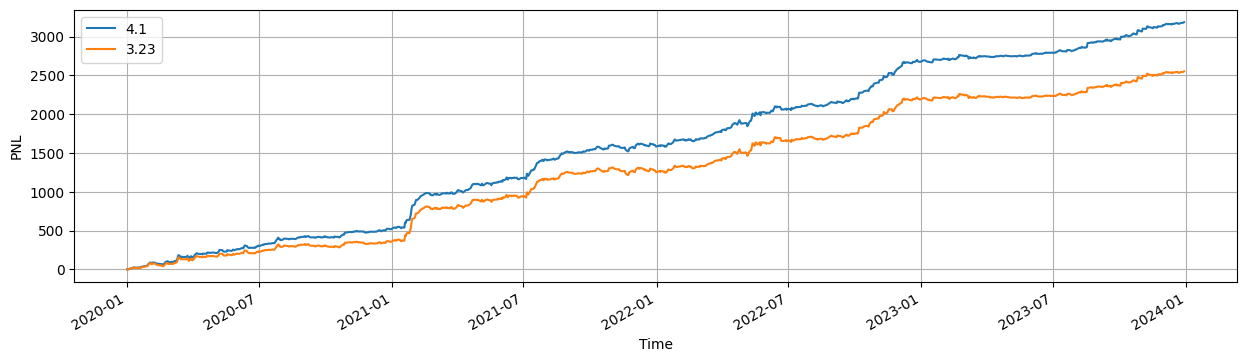

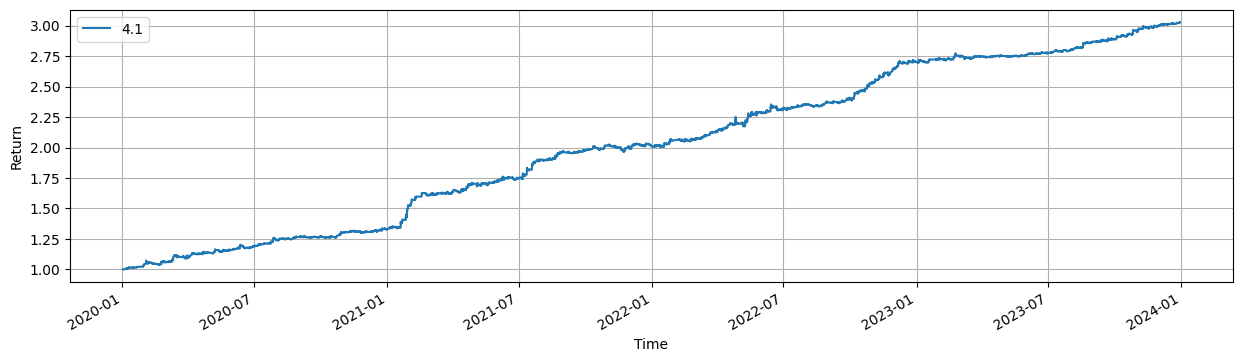

In [16]:
params = best_params
ds = alpha(data_train,params)
backtestInfo = BacktestInformation(ds['Date'], ds['pos'], ds['Close'], fee = 0.3)
pnl = backtestInfo.Plot_PNL() 

Margin: 11.62
MDD: 41.27 (3.5%)

   Total trading quantity: 499
         Profit per trade: 1.58
             Total Profit: 1087.8
         Profit after fee: 788.1
 Trading quantity per day: 1.0
 Profit per day after fee: 1.58
                   Return: 0.33
          Profit per year: 394.59
                  HitRate: 0.45
          HitRate per day: 0.56


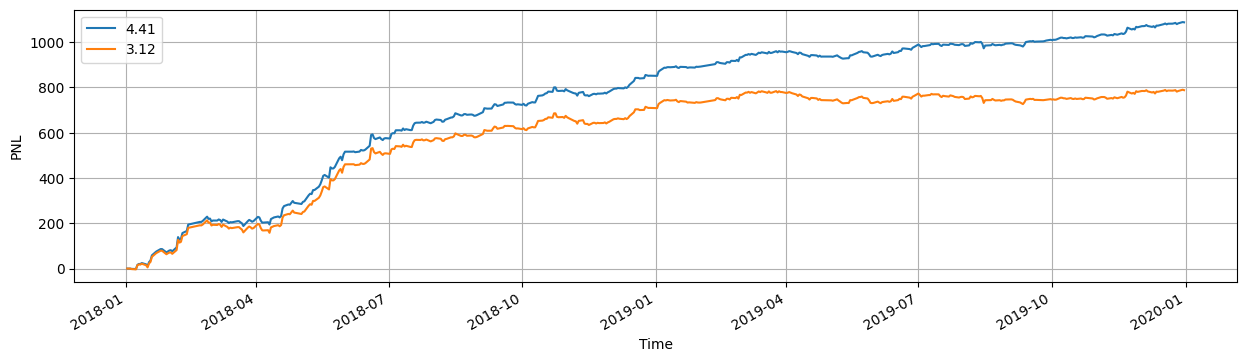

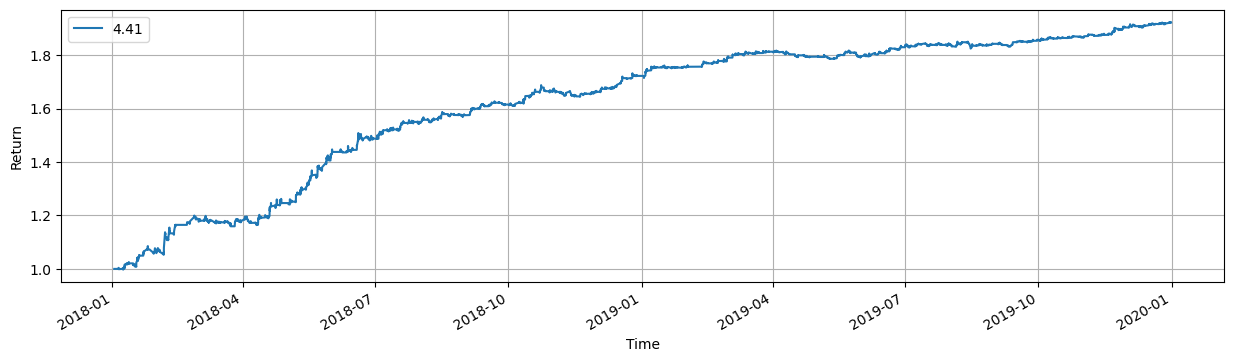

In [17]:
params = best_params
ds = alpha(data_val,params)
backtestInfo = BacktestInformation(ds['Date'], ds['pos'], ds['Close'], fee = 0.3)
pnl = backtestInfo.Plot_PNL() 